### Fetch Data from FBRef API

In [376]:
# Set Seed
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Optionally, force deterministic behavior:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

First get the API key

In [377]:
from python.fbref import FBRAPIDataset
import requests
import time

dataset = FBRAPIDataset()

Get the country codes and league ids

In [381]:
target_countries = ['England', 'Spain', 'Italy', 'France', 'Germany']
target_leagues = ['Premier League', 'La Liga', 'Serie A', 'Ligue 1', 'Bundesliga']
# target_countries = ['England']
# target_leagues = ['Premier League']

country_ids = dataset.get_country_ids(target_countries)
league_ids = dataset.get_league_ids(target_leagues, country_ids)
#season_ids = dataset.get_season_ids(league_ids) POSSIBLY USE THIS LATER, BUT FOR NOW WE ARE JUST USING 2018-2019 UNTIL 2023-2024
season_ids = ['2018-2019']

print("Country IDs:", country_ids, "league ids", league_ids, "season ids", season_ids)

Country IDs: ['ENG', 'FRA', 'GER', 'ITA', 'ESP'] league ids [9, 13, 11, 208, 12] season ids ['2018-2019']


Fetch data for each league and season

In [382]:
# Loop over each combination of league and season
import json
import os

stats = []
for league_id in league_ids:
    for season_id in season_ids:
        stats.extend(dataset.fetch_team_stats(league_id, season_id))

# Save raw data to a JSON file for future use in the ./data directory
output_path = os.path.join('./data', "add_raw_team_stats.json")
with open(output_path, "w") as f:
    json.dump(stats, f, indent=2)

print(f"Raw data saved to {output_path}")

Failed to fetch for league 208, season 2018-2019


KeyboardInterrupt: 

Flatten dictionary and save to csv file

In [364]:
import pandas as pd

# with open("./data/raw_team_stats.json", "r") as f:
#     raw_data = json.load(f)
output_path = "./data/feature_eng_stats.json"
with open(output_path, "r") as f:
    raw_data = json.load(f)

# Use the static method to flatten each record
flattened_data = [FBRAPIDataset.flatten_dict(record) for record in raw_data]

# Optionally, convert the flattened data to a DataFrame for easier inspection
df_flat = pd.DataFrame(flattened_data)
df_flat.to_csv("./data/team_stats.csv", index=False)
print("Structured data saved to team_stats.csv")

Structured data saved to team_stats.csv


### Attach ELO ratings to csv files as target column

In [365]:
import importlib
import python.elo

# Reload the module
importlib.reload(python.elo)

# Use the class directly from the module
elo_dataset = python.elo.ELODataset(['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024'])

# Load your team season stats CSV file
team_stats = pd.read_csv("data/team_stats.csv")

# Retrieve Elo ratings based on the team_stats data.
ratings_df = elo_dataset.get_ratings(team_stats)
print("ELO Ratings DataFrame:")
print(ratings_df.head())

# Merge the Elo ratings into the team_stats DataFrame.
merged_team_stats = elo_dataset.merge_ratings(team_stats)
print("Merged Dataset with Elo column:")
print(merged_team_stats.head())

# Save the merged dataset to a CSV file.
merged_data_path = "data/feature_eng_stats_with_elo.csv"
# "data/team_stats_with_elo.csv"
merged_team_stats.to_csv(merged_data_path, index=False)


ELO Ratings DataFrame:
  meta_data_team_name  season_id          Elo
0             Arsenal  2018-2019  1870.875122
1         Bournemouth  2018-2019  1694.885864
2            Brighton  2018-2019  1620.250977
3             Burnley  2018-2019  1685.654907
4        Cardiff City  2018-2019          NaN
Merged Dataset with Elo column:
  meta_data_team_id meta_data_team_name  stats_stats_avg_gls  \
0          18bb7c10             Arsenal             1.815789   
1          4ba7cbea         Bournemouth             1.447368   
2          d07537b9            Brighton             0.921053   
3          943e8050             Burnley             1.131579   
4          75fae011        Cardiff City             0.868421   

   stats_stats_avg_ast  stats_stats_avg_non_pen_gls  stats_stats_avg_xg  \
0             1.368421                     1.710526            1.581579   
1             1.131579                     1.263158            1.402632   
2             0.631579                     0.789474        

### Normalize Data

In [366]:
import importlib
import python.dataset

# Force reload the module to get the latest changes
importlib.reload(python.dataset)

# Now import the function
from python.dataset import load_and_normalize_data

# Load and normalize data with PCA
# "data/team_stats_with_elo_normalized_pca.csv"
output_path = "data/feature_eng_stats_with_elo_normalized.csv"
normalized_data = load_and_normalize_data(
    csv_path=merged_data_path,
    output_path=output_path,
    apply_pca=False,
    pca_components=3  # Choose appropriate number of components
)

# Display the first few rows to verify
print(normalized_data.head())


Initial data shape: (572, 20)
Numeric features shape: (572, 16)
Scaled features shape: (572, 16)
  meta_data_team_id meta_data_team_name  season_id  stats_stats_avg_gls  \
0          18bb7c10             Arsenal  2018-2019             0.977548   
1          4ba7cbea         Bournemouth  2018-2019             0.186110   
2          d07537b9            Brighton  2018-2019            -0.944515   
3          943e8050             Burnley  2018-2019            -0.492265   
4          75fae011        Cardiff City  2018-2019            -1.057578   

   stats_stats_avg_ast  stats_stats_avg_non_pen_gls  stats_stats_avg_xg  \
0             1.289631                     1.103442            0.682925   
1             0.605634                     0.089206            0.157864   
2            -0.838361                    -0.984691           -1.232002   
3            -0.230363                    -0.328420           -0.529348   
4            -1.142360                    -0.984691           -0.683777   

 

Split Data

In [367]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Quick info about the data
print("Full dataset shape:", normalized_data.shape)
print("Columns in data:")
print(normalized_data.columns.tolist())

# Identify all numeric columns and then select those for features (excluding the Elo target)
numeric_cols = normalized_data.select_dtypes(exclude=['object']).columns.tolist()
features = [col for col in numeric_cols if col != "Elo"]
print("\nNumeric feature columns (excluding Elo):")
print(features)

# Split data into 70% train and 30% temporary set (for validation and test)
train_data, temp_data = train_test_split(normalized_data, test_size=0.30, random_state=42, shuffle=True)

# Further split the temporary set equally into 15% validation and 15% test sets
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print("\nDataset split sizes:")
print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Test set shape:", test_data.shape)

# Split each dataset into X (features) and y (target: Elo)
x_train = train_data[features]
y_train = train_data["Elo"]

x_val = val_data[features]
y_val = val_data["Elo"]

x_test = test_data[features]
y_test = test_data["Elo"]

# Print the shapes of the resulting splits to verify
print("\nFeature and target shapes:")
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_val:", x_val.shape, "y_val:", y_val.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

# Display the first few rows from each split for inspection
print("\nFirst few rows of X_train:")
print(x_train.head())
print("\nFirst few rows of y_train:")
print(y_train.head())

print("\nFirst few rows of X_val:")
print(x_val.head())
print("\nFirst few rows of y_val:")
print(y_val.head())

print("\nFirst few rows of X_test:")
print(x_test.head())
print("\nFirst few rows of y_test:")
print(y_test.head())


Full dataset shape: (572, 20)
Columns in data:
['meta_data_team_id', 'meta_data_team_name', 'season_id', 'stats_stats_avg_gls', 'stats_stats_avg_ast', 'stats_stats_avg_non_pen_gls', 'stats_stats_avg_xg', 'stats_stats_avg_non_pen_xg', 'stats_stats_avg_xag', 'stats_stats_avg_pk_made', 'stats_stats_avg_pk_att', 'stats_stats_avg_yellow_cards', 'stats_stats_avg_red_cards', 'stats_stats_avg_carries_prog', 'stats_stats_avg_passes_prog', 'pca_features_pca_1', 'pca_features_pca_2', 'pca_features_pca_3', 'pca_features_pca_4', 'Elo']

Numeric feature columns (excluding Elo):
['stats_stats_avg_gls', 'stats_stats_avg_ast', 'stats_stats_avg_non_pen_gls', 'stats_stats_avg_xg', 'stats_stats_avg_non_pen_xg', 'stats_stats_avg_xag', 'stats_stats_avg_pk_made', 'stats_stats_avg_pk_att', 'stats_stats_avg_yellow_cards', 'stats_stats_avg_red_cards', 'stats_stats_avg_carries_prog', 'stats_stats_avg_passes_prog', 'pca_features_pca_1', 'pca_features_pca_2', 'pca_features_pca_3', 'pca_features_pca_4']

Dataset sp

In [368]:
import torch
from torch.utils.data import TensorDataset
import pandas as pd

# Example: Assuming x_train, y_train, x_val, y_val, x_test, y_test are already loaded

# Convert training data
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Convert validation data
X_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Convert test data
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets for each split
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


### Model Training and Evaluation

In [369]:
import matplotlib.pyplot as plt

def plot_training_history(training_losses, validation_losses):
    """
    Plot training and validation losses.
    
    Parameters:
        training_losses (list): List of training losses over epochs.
        validation_losses (list): List of validation losses over epochs.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Optional: Add log scale for better visualization of small changes
    plt.yscale('log')
    
    # Save the plot if needed
    # plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# After training the model, you would call it like this:
# model, training_losses, validation_losses = model.train_model(...)
# plot_training_history(training_losses, validation_losses)

In [370]:
def plot_learning_rates(learning_rates, validation_losses):
    # Plot the learning rate over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates)
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')  # Log scale makes it easier to see the drops
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # You can also plot the learning rate against the validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(learning_rates, validation_losses, marker='o')
    plt.title('Validation Loss vs Learning Rate')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Loss')
    plt.xscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

importlib.reload(python.model)
from python.model import SimpleNN, train_model


# Instantiate the model (input dimension based on x_train)
model = SimpleNN(X_train_tensor.shape[1])

# Define hyperparameters in a dictionary (adjust as needed)
hyperparams = {
    "batch_size": 32,
    "epochs": 1000,
    "learning_rate": 0.001,
    "print_every": 10,
    "best_model_path": "best_model.pth",
    "l2_lambda": 0.001,  # L2 regularization strength - adjust as needed
    "patience": 40
}

# Train the model
model, training_losses, validation_losses, learning_rates = train_model(model, train_dataset, val_dataset, hyperparams)


### Hyperparameter Tuning

c:\Users\tobia\miniconda3\envs\cv1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training with hyperparameters: {'batch_size': 16, 'epochs': 1000, 'learning_rate': 0.001, 'l2_lambda': 0.001, 'patience': 40, 'print_every': 100}


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epochs:  30%|██▉       | 295/1000 [00:24<00:57, 12.21it/s]


Early stopping triggered after 296 epochs
Final validation loss: 4382.292344204215
Best hyperparameters found: {'batch_size': 16, 'epochs': 1000, 'learning_rate': 0.001, 'l2_lambda': 0.001, 'patience': 40, 'print_every': 100}
Best final validation loss: 4382.292344204215


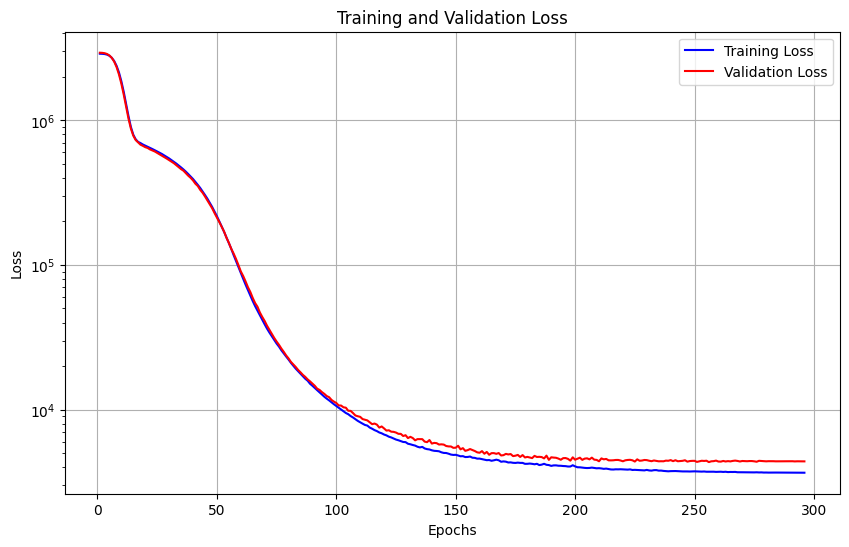

In [371]:
import itertools
import copy
import numpy as np
import importlib
import torch
import python.model
importlib.reload(python.model)
from python.model import SimpleNN, train_model

# Define a grid for hyperparameter tuning
hyperparams_grid = {
    "batch_size": [16],
    "epochs": [1000],
    "learning_rate": [0.001],
    "l2_lambda": [0.001],
    "patience": [40],
    "print_every": [100]
}

# Create the grid (list of hyperparameter dictionaries)
keys, values = zip(*hyperparams_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_loss = float('inf')
best_hyperparams = None
best_training_losses = None
best_validation_losses = None

# Loop through each hyperparameter combination
for hp in grid:
    print("Training with hyperparameters:", hp)
    
    # Reload your model module to ensure a fresh start if needed
    importlib.reload(python.model)
    
    # Instantiate a new model (ensure that X_train_tensor exists and has the right shape)
    model = SimpleNN(X_train_tensor.shape[1])
    
    # Train the model with the current hyperparameters
    model, training_losses, validation_losses, learning_rates = train_model(model, train_dataset, val_dataset, hp)
    
    # Use the final validation loss as our metric
    final_val_loss = validation_losses[-1]
    print("Final validation loss:", final_val_loss)
    
    # Keep the best hyperparameters based on validation loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_hyperparams = copy.deepcopy(hp)
        best_training_losses = training_losses
        best_validation_losses = validation_losses
        # Optionally save the best model
        torch.save(model.state_dict(), "best_model.pth")

print("Best hyperparameters found:", best_hyperparams)
print("Best final validation loss:", best_val_loss)

# Optionally, plot the training history for the best run:
plot_training_history(best_training_losses, best_validation_losses)

In [372]:
from python.model import evaluate_model
import torch

# Load the best model state (if not already loaded)
model.load_state_dict(torch.load(hyperparams["best_model_path"]))
model.eval()

# Evaluate the model on the test dataset
test_loss = evaluate_model(model, test_dataset, hyperparams)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 4791.5172


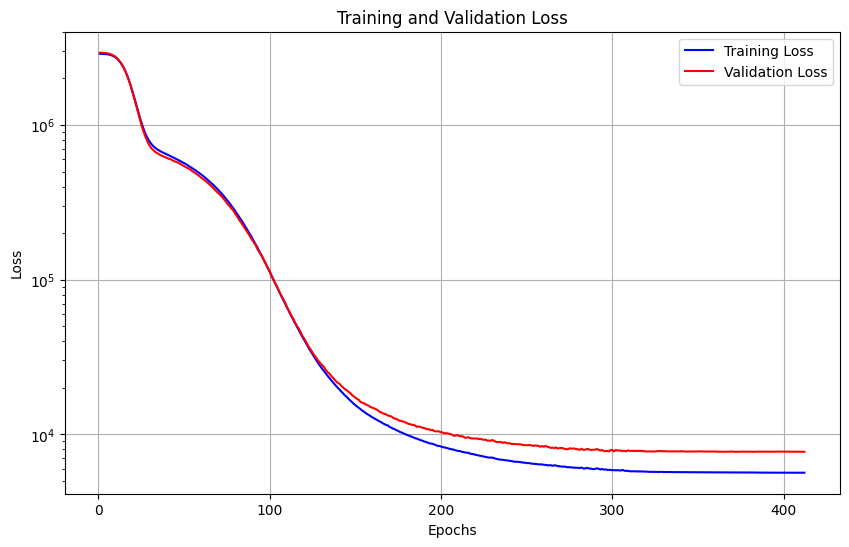

In [ ]:
plot_training_history(training_losses, validation_losses)

Sample of 15 predictions vs actual values:
     Actual ELO  Predicted ELO  Absolute Error
68  2035.033691    2005.543091       29.490601
30  1697.769043    1687.328247       10.440796
20  1808.968506    1847.272705       38.304199
48  1753.304932    1790.682495       37.377563
73  1833.274902    1753.000854       80.274048
15  1784.743652    1705.223511       79.520142
45  1696.034180    1557.897583      138.136597
17  1987.611572    1947.143188       40.468384
61  1581.307373    1620.951904       39.644531
55  1591.197876    1621.802856       30.604980
80  1756.954956    1651.706055      105.248901
19  1649.969849    1684.135376       34.165527
49  1696.034180    1569.281616      126.752563
42  1823.541748    1679.872437      143.669312
24  1790.556641    1915.173096      124.616455

Overall Metrics:
Mean Absolute Error (MAE): 51.35
Root Mean Squared Error (RMSE): 66.20


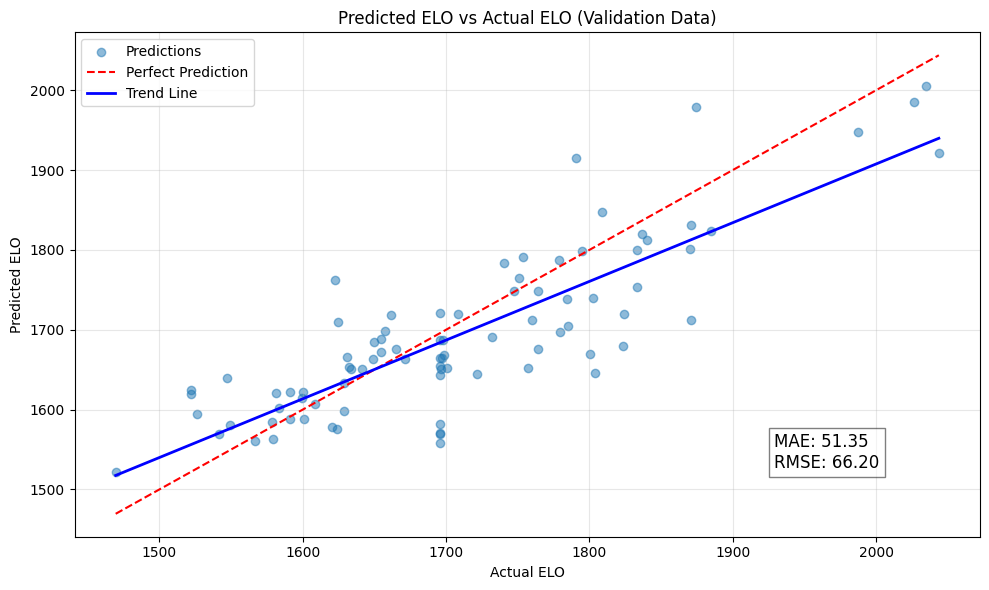

In [375]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compare_predictions_to_actual_val(model, val_dataset, num_samples=100, include_plot=True):
    """
    Compare model predictions with actual target values using the validation dataset.
    
    Parameters:
        model: The trained neural network model.
        val_dataset: Validation dataset (TensorDataset).
        num_samples: Number of examples to display.
        include_plot: Whether to show a scatter plot visualization.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get all inputs and targets from the validation dataset
    X_val = val_dataset.tensors[0]
    y_val = val_dataset.tensors[1]
    
    # Get predictions for all validation samples
    with torch.no_grad():
        predictions = model(X_val).squeeze()
    
    # Convert to numpy arrays for easier handling
    predictions = predictions.numpy()
    actual = y_val.squeeze().numpy()
    
    # Calculate errors
    absolute_errors = np.abs(predictions - actual)
    
    # Create a DataFrame for display
    results_df = pd.DataFrame({
        'Actual ELO': actual,
        'Predicted ELO': predictions,
        'Absolute Error': absolute_errors
    })
    
    # Display a sample of the results
    print(f"Sample of {num_samples} predictions vs actual values:")
    print(results_df.sample(num_samples))
    
    # Calculate overall metrics
    mae = np.mean(absolute_errors)
    rmse = np.sqrt(np.mean((predictions - actual) ** 2))
    print(f"\nOverall Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    if include_plot:
        plt.figure(figsize=(10, 6))
        
        # Scatter plot of predictions vs actual values
        plt.scatter(actual, predictions, alpha=0.5, label='Predictions')
        
        # Perfect prediction line (y=x)
        min_val = min(np.min(actual), np.min(predictions))
        max_val = max(np.max(actual), np.max(predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        
        # Fit a regression line through the predicted points
        coeffs = np.polyfit(actual, predictions, 1)  # Fit: y = ax+b
        poly_eq = np.poly1d(coeffs)
        line_x = np.linspace(min_val, max_val, 100)
        line_y = poly_eq(line_x)
        plt.plot(line_x, line_y, color='blue', linestyle='-', linewidth=2, label='Trend Line')
        
        plt.title('Predicted ELO vs Actual ELO (Validation Data)')
        plt.xlabel('Actual ELO')
        plt.ylabel('Predicted ELO')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add text with metrics
        plt.text(
            min_val + 0.8 * (max_val - min_val), 
            min_val + 0.1 * (max_val - min_val),
            f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', 
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.5)
        )
        
        plt.tight_layout()
        plt.show()

# Usage example:
compare_predictions_to_actual_val(model, val_dataset, num_samples=15)

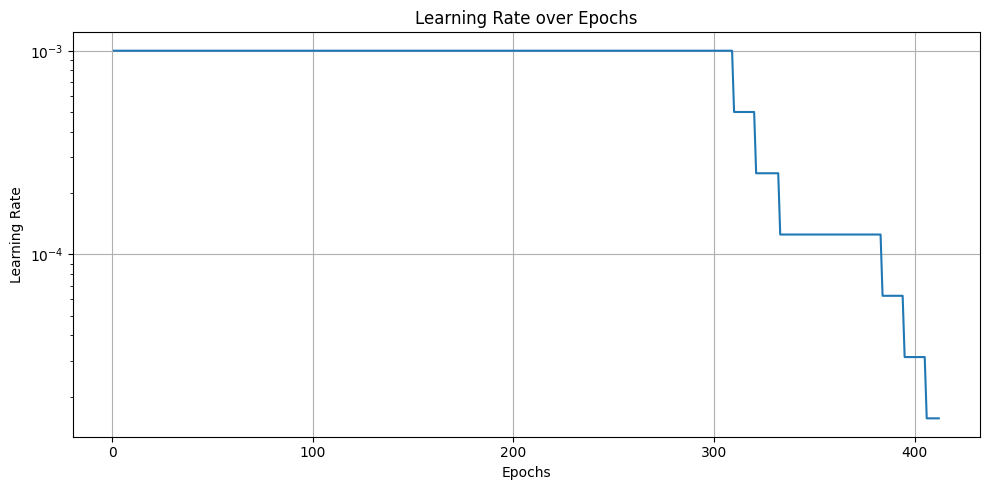

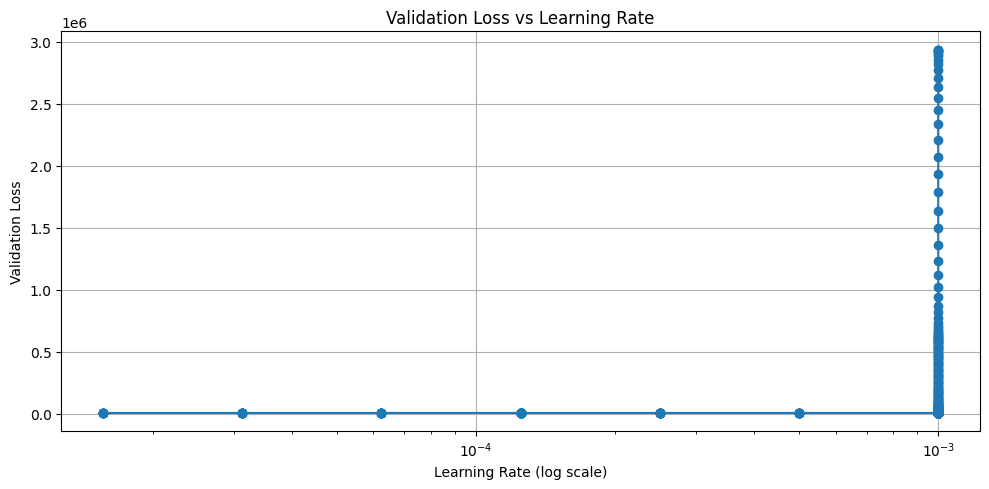

In [ ]:
plot_learning_rates(learning_rates, validation_losses)

### Nested Cross Validation

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import KFold
importlib.reload(python.model)
from python.model import SimpleEloModel, train_model, evaluate_model  # ensure you have implemented evaluate_model


# Define the nested cross-validation routine
def nested_cross_validation(dataset, model_class, hyperparameter_grid, num_outer_folds=5, num_inner_folds=5):
    outer_cv = KFold(n_splits=num_outer_folds, shuffle=True, random_state=42)
    outer_results = []
    data_indices = np.arange(len(dataset))
    
    # Outer CV loop
    for outer_train_val_idx, outer_test_idx in outer_cv.split(data_indices):
        # Create outer training+validation and outer test sets
        outer_train_val = torch.utils.data.Subset(dataset, outer_train_val_idx)
        outer_test = torch.utils.data.Subset(dataset, outer_test_idx)
        
        best_hp = None
        best_inner_loss = float('inf')
        
        # Inner CV loop for hyperparameter tuning
        inner_cv = KFold(n_splits=num_inner_folds, shuffle=True, random_state=42)
        for hp in hyperparameter_grid:
            inner_losses = []
            # For each candidate hyperparameter, perform inner cross-validation on the outer training set.
            inner_indices = np.arange(len(outer_train_val))
            for inner_train_idx, inner_val_idx in inner_cv.split(inner_indices):
                inner_train = torch.utils.data.Subset(outer_train_val, inner_train_idx)
                inner_val = torch.utils.data.Subset(outer_train_val, inner_val_idx)
                
                # Instantiate and train the model on the inner training set
                model = model_class(input_size=INPUT_SIZE)
                model, train_losses, val_losses, _ = train_model(model, inner_train, inner_val, hp)
                inner_losses.append(val_losses[-1])
            
            avg_inner_loss = np.mean(inner_losses)
            if avg_inner_loss < best_inner_loss:
                best_inner_loss = avg_inner_loss
                best_hp = hp
        
        print("Best hyperparameters for this outer fold:", best_hp)
        
        # Retrain model on the entire outer training+validation fold with best hyperparameters
        final_model = model_class(input_size=INPUT_SIZE)
        final_model, train_losses, val_losses, _ = train_model(final_model, outer_train_val, outer_test, best_hp)
        
        # Evaluate the retrained model on the outer test fold
        test_loss = evaluate_model(final_model, outer_test, best_hp)
        print("Outer test loss:", test_loss)
        outer_results.append(test_loss)
    
    return outer_results

# Example hyperparameter grid (you can add more combinations)
hyperparameter_grid = [
    {
        "batch_size": 32,
        "epochs": 1000,
        "learning_rate": 0.001,
        "print_every": 10,
        "best_model_path": "best_model.pth",
        "l2_lambda": 0.001,
        "patience": 40
    },
    {
        "batch_size": 32,
        "epochs": 1000,
        "learning_rate": 0.0005,
        "print_every": 10,
        "best_model_path": "best_model.pth",
        "l2_lambda": 0.001,
        "patience": 40
    }
]

# Set INPUT_SIZE based on your training features. For example:
INPUT_SIZE = X_train_tensor.shape[1]  # adjust as needed

# Run nested cross-validation. Assume train_dataset is your full dataset.
outer_test_losses = nested_cross_validation(train_dataset, SimpleEloModel, hyperparameter_grid,
                                            num_outer_folds=5, num_inner_folds=5)

print("Nested CV outer test losses:", outer_test_losses)
print("Average outer test loss:", np.mean(outer_test_losses))

c:\Users\tobia\miniconda3\envs\cv1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epochs:   0%|          | 4/1000 [00:00<00:59, 16.83it/s]

Epoch [1]: New best model saved with Validation Loss: 2825200.8750
Epoch [2]: New best model saved with Validation Loss: 2824605.7500
Epoch [3]: New best model saved with Validation Loss: 2823895.1250
Epoch [4]: New best model saved with Validation Loss: 2823075.6250


Training epochs:   1%|          | 7/1000 [00:00<00:50, 19.56it/s]

Epoch [5]: New best model saved with Validation Loss: 2822288.8750
Epoch [6]: New best model saved with Validation Loss: 2821490.6250
Epoch [7]: New best model saved with Validation Loss: 2820648.8750
Epoch [8]: New best model saved with Validation Loss: 2819713.7500
Epoch [9]: New best model saved with Validation Loss: 2819003.1250


Training epochs:   1%|          | 10/1000 [00:00<00:47, 20.80it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2885984.9062, Validation Loss: 2818190.2500
Epoch [10]: New best model saved with Validation Loss: 2818190.2500
Epoch [11]: New best model saved with Validation Loss: 2816858.5000
Epoch [12]: New best model saved with Validation Loss: 2815850.1250


Training epochs:   2%|▏         | 16/1000 [00:00<00:50, 19.32it/s]

Epoch [13]: New best model saved with Validation Loss: 2814947.1250
Epoch [14]: New best model saved with Validation Loss: 2813891.2500
Epoch [15]: New best model saved with Validation Loss: 2812837.7500
Epoch [16]: New best model saved with Validation Loss: 2811699.6250
Epoch [17]: New best model saved with Validation Loss: 2810734.7500


Training epochs:   2%|▏         | 19/1000 [00:00<00:50, 19.50it/s]

Epoch [18]: New best model saved with Validation Loss: 2809272.8750
Epoch [19]: New best model saved with Validation Loss: 2807823.7500


Training epochs:   2%|▏         | 21/1000 [00:01<01:16, 12.76it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2872140.3438, Validation Loss: 2805801.5000
Epoch [20]: New best model saved with Validation Loss: 2805801.5000
Epoch [21]: New best model saved with Validation Loss: 2803856.0000
Epoch [22]: New best model saved with Validation Loss: 2801901.7500
Epoch [23]: New best model saved with Validation Loss: 2800413.3750


Training epochs:   3%|▎         | 28/1000 [00:01<00:58, 16.58it/s]

Epoch [24]: New best model saved with Validation Loss: 2798342.1250
Epoch [25]: New best model saved with Validation Loss: 2797124.1250
Epoch [26]: New best model saved with Validation Loss: 2795380.0000
Epoch [27]: New best model saved with Validation Loss: 2792811.3750
Epoch [28]: New best model saved with Validation Loss: 2790978.2500


Training epochs:   3%|▎         | 31/1000 [00:01<00:53, 18.24it/s]

Epoch [29]: New best model saved with Validation Loss: 2787594.3750
Epoch [30/1000], LR: 0.001000, Training Loss: 2851048.0000, Validation Loss: 2785340.5000
Epoch [30]: New best model saved with Validation Loss: 2785340.5000
Epoch [31]: New best model saved with Validation Loss: 2783090.2500
Epoch [32]: New best model saved with Validation Loss: 2781512.5000


Training epochs:   4%|▎         | 35/1000 [00:02<00:54, 17.59it/s]

Epoch [33]: New best model saved with Validation Loss: 2779885.2500
Epoch [34]: New best model saved with Validation Loss: 2776425.3750
Epoch [35]: New best model saved with Validation Loss: 2772616.2500
Epoch [36]: New best model saved with Validation Loss: 2771164.3750
Epoch [37]: New best model saved with Validation Loss: 2767323.7500


Training epochs:   4%|▍         | 40/1000 [00:02<00:51, 18.70it/s]

Epoch [38]: New best model saved with Validation Loss: 2764531.0000
Epoch [39]: New best model saved with Validation Loss: 2761090.0000
Epoch [40/1000], LR: 0.001000, Training Loss: 2822120.9688, Validation Loss: 2757640.5000
Epoch [40]: New best model saved with Validation Loss: 2757640.5000
Epoch [41]: New best model saved with Validation Loss: 2756085.3750


Training epochs:   4%|▍         | 43/1000 [00:02<00:48, 19.79it/s]

Epoch [42]: New best model saved with Validation Loss: 2751843.2500
Epoch [43]: New best model saved with Validation Loss: 2748765.0000
Epoch [44]: New best model saved with Validation Loss: 2746500.1250
Epoch [45]: New best model saved with Validation Loss: 2742572.2500
Epoch [46]: New best model saved with Validation Loss: 2737121.5000


Training epochs:   5%|▍         | 49/1000 [00:02<00:45, 20.76it/s]

Epoch [47]: New best model saved with Validation Loss: 2734505.6250
Epoch [48]: New best model saved with Validation Loss: 2730085.3750
Epoch [49]: New best model saved with Validation Loss: 2725528.5000
Epoch [50/1000], LR: 0.001000, Training Loss: 2784807.7188, Validation Loss: 2721115.3750
Epoch [50]: New best model saved with Validation Loss: 2721115.3750
Epoch [51]: New best model saved with Validation Loss: 2718427.0000


Training epochs:   6%|▌         | 55/1000 [00:02<00:42, 22.26it/s]

Epoch [52]: New best model saved with Validation Loss: 2713947.0000
Epoch [53]: New best model saved with Validation Loss: 2709081.6250
Epoch [54]: New best model saved with Validation Loss: 2706435.0000
Epoch [55]: New best model saved with Validation Loss: 2701421.6250
Epoch [56]: New best model saved with Validation Loss: 2697156.5000


Training epochs:   6%|▌         | 61/1000 [00:03<00:46, 20.19it/s]

Epoch [57]: New best model saved with Validation Loss: 2689396.0000
Epoch [58]: New best model saved with Validation Loss: 2688256.3750
Epoch [59]: New best model saved with Validation Loss: 2681691.3750
Epoch [60/1000], LR: 0.001000, Training Loss: 2740360.8438, Validation Loss: 2671667.0000
Epoch [60]: New best model saved with Validation Loss: 2671667.0000
Epoch [61]: New best model saved with Validation Loss: 2670069.0000


Training epochs:   6%|▋         | 64/1000 [00:03<00:48, 19.48it/s]

Epoch [62]: New best model saved with Validation Loss: 2668306.0000
Epoch [63]: New best model saved with Validation Loss: 2655674.8750
Epoch [64]: New best model saved with Validation Loss: 2654927.2500
Epoch [65]: New best model saved with Validation Loss: 2646435.8750


Training epochs:   7%|▋         | 70/1000 [00:03<00:44, 20.93it/s]

Epoch [66]: New best model saved with Validation Loss: 2645548.1250
Epoch [67]: New best model saved with Validation Loss: 2642767.5000
Epoch [68]: New best model saved with Validation Loss: 2633149.5000
Epoch [70/1000], LR: 0.001000, Training Loss: 2688603.0312, Validation Loss: 2622702.3750
Epoch [70]: New best model saved with Validation Loss: 2622702.3750


Training epochs:   7%|▋         | 73/1000 [00:03<00:45, 20.23it/s]

Epoch [71]: New best model saved with Validation Loss: 2617893.7500
Epoch [72]: New best model saved with Validation Loss: 2611055.7500
Epoch [74]: New best model saved with Validation Loss: 2599028.2500


Training epochs:   8%|▊         | 76/1000 [00:04<00:45, 20.22it/s]

Epoch [75]: New best model saved with Validation Loss: 2592273.7500
Epoch [76]: New best model saved with Validation Loss: 2586891.8750
Epoch [77]: New best model saved with Validation Loss: 2586551.5000
Epoch [78]: New best model saved with Validation Loss: 2580118.3750
Epoch [79]: New best model saved with Validation Loss: 2575389.2500


Training epochs:   8%|▊         | 82/1000 [00:04<00:44, 20.71it/s]

Epoch [80/1000], LR: 0.001000, Training Loss: 2630641.5625, Validation Loss: 2564616.8750
Epoch [80]: New best model saved with Validation Loss: 2564616.8750
Epoch [81]: New best model saved with Validation Loss: 2555099.6250
Epoch [83]: New best model saved with Validation Loss: 2545780.7500


Training epochs:   9%|▉         | 88/1000 [00:04<00:42, 21.35it/s]

Epoch [84]: New best model saved with Validation Loss: 2530560.8750
Epoch [85]: New best model saved with Validation Loss: 2527948.5000
Epoch [87]: New best model saved with Validation Loss: 2509181.6250


Training epochs:   9%|▉         | 91/1000 [00:04<00:42, 21.60it/s]

Epoch [89]: New best model saved with Validation Loss: 2495235.1250
Epoch [90/1000], LR: 0.001000, Training Loss: 2565416.4375, Validation Loss: 2503933.5000
Epoch [91]: New best model saved with Validation Loss: 2491880.3750
Epoch [92]: New best model saved with Validation Loss: 2489995.2500
Epoch [93]: New best model saved with Validation Loss: 2471639.1250


Training epochs:  10%|▉         | 97/1000 [00:05<00:43, 20.55it/s]

Epoch [94]: New best model saved with Validation Loss: 2468709.3750
Epoch [95]: New best model saved with Validation Loss: 2457644.1250
Epoch [96]: New best model saved with Validation Loss: 2456432.2500
Epoch [97]: New best model saved with Validation Loss: 2449327.5000
Epoch [98]: New best model saved with Validation Loss: 2445841.7500


Training epochs:  10%|█         | 100/1000 [00:05<00:43, 20.59it/s]

Epoch [99]: New best model saved with Validation Loss: 2436179.2500
Epoch [100/1000], LR: 0.001000, Training Loss: 2495411.9688, Validation Loss: 2431151.1250
Epoch [100]: New best model saved with Validation Loss: 2431151.1250
Epoch [102]: New best model saved with Validation Loss: 2417813.5000
Epoch [103]: New best model saved with Validation Loss: 2401888.3750


Training epochs:  11%|█         | 106/1000 [00:05<00:42, 21.04it/s]

Epoch [104]: New best model saved with Validation Loss: 2394600.8750
Epoch [105]: New best model saved with Validation Loss: 2386657.1250
Epoch [106]: New best model saved with Validation Loss: 2371383.1250


Training epochs:  11%|█         | 112/1000 [00:05<00:40, 22.04it/s]

Epoch [109]: New best model saved with Validation Loss: 2361712.8750
Epoch [110/1000], LR: 0.001000, Training Loss: 2420856.0312, Validation Loss: 2365984.1250
Epoch [111]: New best model saved with Validation Loss: 2345170.2500
Epoch [112]: New best model saved with Validation Loss: 2342882.5000
Epoch [113]: New best model saved with Validation Loss: 2331606.5000


Training epochs:  12%|█▏        | 115/1000 [00:05<00:40, 21.67it/s]

Epoch [114]: New best model saved with Validation Loss: 2326745.5000
Epoch [115]: New best model saved with Validation Loss: 2302842.6250
Epoch [117]: New best model saved with Validation Loss: 2295396.5000
Epoch [118]: New best model saved with Validation Loss: 2290389.2500


Training epochs:  12%|█▏        | 121/1000 [00:06<00:39, 22.18it/s]

Epoch [119]: New best model saved with Validation Loss: 2270741.6250
Epoch [120/1000], LR: 0.001000, Training Loss: 2341032.4688, Validation Loss: 2284853.6250
Epoch [121]: New best model saved with Validation Loss: 2269650.1250
Epoch [122]: New best model saved with Validation Loss: 2261820.6250
Epoch [123]: New best model saved with Validation Loss: 2237741.5000


Training epochs:  13%|█▎        | 130/1000 [00:06<00:38, 22.81it/s]

Epoch [126]: New best model saved with Validation Loss: 2217244.7500
Epoch [129]: New best model saved with Validation Loss: 2207361.8750
Epoch [130/1000], LR: 0.001000, Training Loss: 2257817.7812, Validation Loss: 2199951.0000
Epoch [130]: New best model saved with Validation Loss: 2199951.0000
Epoch [131]: New best model saved with Validation Loss: 2166049.3750


Training epochs:  14%|█▍        | 139/1000 [00:06<00:35, 24.11it/s]

Epoch [135]: New best model saved with Validation Loss: 2165849.3750
Epoch [136]: New best model saved with Validation Loss: 2138041.8750
Epoch [137]: New best model saved with Validation Loss: 2122175.7500
Epoch [140/1000], LR: 0.001000, Training Loss: 2169058.5312, Validation Loss: 2112631.2500
Epoch [140]: New best model saved with Validation Loss: 2112631.2500


Training epochs:  14%|█▍        | 142/1000 [00:07<00:37, 22.71it/s]

Epoch [141]: New best model saved with Validation Loss: 2101897.4375
Epoch [142]: New best model saved with Validation Loss: 2097743.6250
Epoch [143]: New best model saved with Validation Loss: 2083634.2500
Epoch [145]: New best model saved with Validation Loss: 2060257.6250


Training epochs:  15%|█▍        | 148/1000 [00:07<00:40, 20.88it/s]

Epoch [146]: New best model saved with Validation Loss: 2044946.1875
Epoch [149]: New best model saved with Validation Loss: 2026454.0625


Training epochs:  15%|█▌        | 151/1000 [00:07<00:49, 17.25it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2081102.2344, Validation Loss: 2014057.1875
Epoch [150]: New best model saved with Validation Loss: 2014057.1875
Epoch [151]: New best model saved with Validation Loss: 2012605.6875


Training epochs:  16%|█▌        | 155/1000 [00:07<00:49, 16.99it/s]

Epoch [153]: New best model saved with Validation Loss: 2004878.3750
Epoch [154]: New best model saved with Validation Loss: 1974053.3750
Epoch [157]: New best model saved with Validation Loss: 1960075.0000


Training epochs:  16%|█▌        | 161/1000 [00:08<00:44, 18.90it/s]

Epoch [158]: New best model saved with Validation Loss: 1934472.1875
Epoch [159]: New best model saved with Validation Loss: 1929752.3750
Epoch [160/1000], LR: 0.001000, Training Loss: 1989451.8438, Validation Loss: 1919825.9375
Epoch [160]: New best model saved with Validation Loss: 1919825.9375
Epoch [161]: New best model saved with Validation Loss: 1919550.3750
Epoch [162]: New best model saved with Validation Loss: 1894605.7500


Training epochs:  17%|█▋        | 169/1000 [00:08<00:39, 21.16it/s]

Epoch [166]: New best model saved with Validation Loss: 1894456.8750
Epoch [167]: New best model saved with Validation Loss: 1864926.5625
Epoch [168]: New best model saved with Validation Loss: 1828446.7500
Epoch [170/1000], LR: 0.001000, Training Loss: 1905489.2812, Validation Loss: 1836841.8750


Training epochs:  18%|█▊        | 175/1000 [00:08<00:38, 21.46it/s]

Epoch [172]: New best model saved with Validation Loss: 1814502.2500
Epoch [174]: New best model saved with Validation Loss: 1812491.8125
Epoch [175]: New best model saved with Validation Loss: 1803625.7500
Epoch [176]: New best model saved with Validation Loss: 1771615.3125


Training epochs:  18%|█▊        | 181/1000 [00:09<00:36, 22.57it/s]

Epoch [179]: New best model saved with Validation Loss: 1722958.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1807533.6406, Validation Loss: 1746723.1875


Training epochs:  19%|█▊        | 187/1000 [00:09<00:36, 22.37it/s]

Epoch [184]: New best model saved with Validation Loss: 1704740.3750
Epoch [187]: New best model saved with Validation Loss: 1696221.8125
Epoch [188]: New best model saved with Validation Loss: 1674227.2500


Training epochs:  19%|█▉        | 190/1000 [00:09<00:38, 21.23it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1715541.0938, Validation Loss: 1671150.5625
Epoch [190]: New best model saved with Validation Loss: 1671150.5625
Epoch [191]: New best model saved with Validation Loss: 1635617.1250


Training epochs:  20%|█▉        | 195/1000 [00:10<00:59, 13.47it/s]

Epoch [193]: New best model saved with Validation Loss: 1620664.3750
Epoch [195]: New best model saved with Validation Loss: 1614018.3125
Epoch [196]: New best model saved with Validation Loss: 1606642.5625


Training epochs:  20%|██        | 200/1000 [00:10<00:50, 15.78it/s]

Epoch [198]: New best model saved with Validation Loss: 1571504.1250
Epoch [200/1000], LR: 0.001000, Training Loss: 1620028.9531, Validation Loss: 1571828.4375
Epoch [201]: New best model saved with Validation Loss: 1560751.1875


Training epochs:  21%|██        | 207/1000 [00:10<00:42, 18.50it/s]

Epoch [204]: New best model saved with Validation Loss: 1502529.7500
Epoch [207]: New best model saved with Validation Loss: 1496734.0625
Epoch [208]: New best model saved with Validation Loss: 1494691.6875


Training epochs:  21%|██        | 210/1000 [00:10<00:42, 18.45it/s]

Epoch [209]: New best model saved with Validation Loss: 1483511.4375
Epoch [210/1000], LR: 0.001000, Training Loss: 1525360.8750, Validation Loss: 1460698.6875
Epoch [210]: New best model saved with Validation Loss: 1460698.6875
Epoch [211]: New best model saved with Validation Loss: 1456811.3125
Epoch [212]: New best model saved with Validation Loss: 1454313.0625


Training epochs:  21%|██▏       | 214/1000 [00:11<00:48, 16.05it/s]

Epoch [213]: New best model saved with Validation Loss: 1438101.2500
Epoch [215]: New best model saved with Validation Loss: 1427759.5625
Epoch [216]: New best model saved with Validation Loss: 1413486.0000


Training epochs:  22%|██▏       | 220/1000 [00:11<00:48, 15.93it/s]

Epoch [217]: New best model saved with Validation Loss: 1402463.1250
Epoch [218]: New best model saved with Validation Loss: 1394255.8750
Epoch [220/1000], LR: 0.001000, Training Loss: 1443989.9688, Validation Loss: 1376319.7500
Epoch [220]: New best model saved with Validation Loss: 1376319.7500


Training epochs:  22%|██▏       | 222/1000 [00:11<00:54, 14.15it/s]

Epoch [221]: New best model saved with Validation Loss: 1368592.0000
Epoch [222]: New best model saved with Validation Loss: 1357185.0625
Epoch [224]: New best model saved with Validation Loss: 1346510.6250
Epoch [225]: New best model saved with Validation Loss: 1339521.8750


Training epochs:  23%|██▎       | 228/1000 [00:11<00:42, 18.17it/s]

Epoch [226]: New best model saved with Validation Loss: 1314422.2500
Epoch [230/1000], LR: 0.001000, Training Loss: 1350479.5938, Validation Loss: 1293423.5625
Epoch [230]: New best model saved with Validation Loss: 1293423.5625
Epoch [231]: New best model saved with Validation Loss: 1292827.0625


Training epochs:  23%|██▎       | 234/1000 [00:12<00:36, 20.86it/s]

Epoch [232]: New best model saved with Validation Loss: 1289401.6875
Epoch [233]: New best model saved with Validation Loss: 1266007.5625
Epoch [235]: New best model saved with Validation Loss: 1244711.0000
Epoch [236]: New best model saved with Validation Loss: 1219641.4375


Training epochs:  24%|██▍       | 243/1000 [00:12<00:36, 20.64it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1258614.0156, Validation Loss: 1234412.3750
Epoch [241]: New best model saved with Validation Loss: 1216601.1250
Epoch [242]: New best model saved with Validation Loss: 1167098.5000
Epoch [245]: New best model saved with Validation Loss: 1162708.7500


Training epochs:  25%|██▍       | 249/1000 [00:13<00:55, 13.45it/s]

Epoch [247]: New best model saved with Validation Loss: 1142175.0625
Epoch [250/1000], LR: 0.001000, Training Loss: 1166911.6250, Validation Loss: 1106568.8750
Epoch [250]: New best model saved with Validation Loss: 1106568.8750


Training epochs:  26%|██▌       | 257/1000 [00:13<00:41, 17.81it/s]

Epoch [254]: New best model saved with Validation Loss: 1088089.9375
Epoch [256]: New best model saved with Validation Loss: 1069002.1250


Training epochs:  26%|██▌       | 260/1000 [00:13<00:40, 18.36it/s]

Epoch [259]: New best model saved with Validation Loss: 1038420.8750
Epoch [260/1000], LR: 0.001000, Training Loss: 1086757.8906, Validation Loss: 1035971.0312
Epoch [260]: New best model saved with Validation Loss: 1035971.0312


Training epochs:  26%|██▋       | 265/1000 [00:13<00:41, 17.90it/s]

Epoch [263]: New best model saved with Validation Loss: 1012504.9688
Epoch [264]: New best model saved with Validation Loss: 1003163.3750
Epoch [265]: New best model saved with Validation Loss: 983954.4062


Training epochs:  27%|██▋       | 271/1000 [00:14<00:36, 19.94it/s]

Epoch [268]: New best model saved with Validation Loss: 972452.1562
Epoch [270/1000], LR: 0.001000, Training Loss: 1005474.5078, Validation Loss: 1000036.2188
Epoch [271]: New best model saved with Validation Loss: 962692.0625
Epoch [272]: New best model saved with Validation Loss: 956000.8750


Training epochs:  27%|██▋       | 274/1000 [00:14<00:35, 20.54it/s]

Epoch [273]: New best model saved with Validation Loss: 941301.2812
Epoch [274]: New best model saved with Validation Loss: 918562.5625
Epoch [277]: New best model saved with Validation Loss: 904460.3125


Training epochs:  28%|██▊       | 280/1000 [00:14<00:35, 20.49it/s]

Epoch [278]: New best model saved with Validation Loss: 895633.8438
Epoch [280/1000], LR: 0.001000, Training Loss: 921354.9219, Validation Loss: 895730.3125
Epoch [281]: New best model saved with Validation Loss: 889648.0312
Epoch [282]: New best model saved with Validation Loss: 887332.5312


Training epochs:  29%|██▊       | 286/1000 [00:14<00:34, 20.67it/s]

Epoch [283]: New best model saved with Validation Loss: 847452.2812
Epoch [285]: New best model saved with Validation Loss: 840396.4062
Epoch [287]: New best model saved with Validation Loss: 807043.6562


Training epochs:  29%|██▉       | 292/1000 [00:15<00:33, 21.23it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 848641.9219, Validation Loss: 803413.9062
Epoch [290]: New best model saved with Validation Loss: 803413.9062
Epoch [294]: New best model saved with Validation Loss: 769141.3750


Training epochs:  30%|██▉       | 298/1000 [00:15<00:33, 21.09it/s]

Epoch [295]: New best model saved with Validation Loss: 758334.6875
Epoch [298]: New best model saved with Validation Loss: 749772.0312


Training epochs:  30%|███       | 301/1000 [00:15<00:33, 21.08it/s]

Epoch [299]: New best model saved with Validation Loss: 694728.5938
Epoch [300/1000], LR: 0.001000, Training Loss: 773460.4922, Validation Loss: 770816.0625


Training epochs:  31%|███       | 312/1000 [00:16<00:36, 18.80it/s]

Epoch [309]: New best model saved with Validation Loss: 679713.0938
Epoch [310/1000], LR: 0.001000, Training Loss: 705413.8203, Validation Loss: 711361.9375
Epoch [311]: New best model saved with Validation Loss: 645983.3125
Epoch [312]: New best model saved with Validation Loss: 644677.7812


Training epochs:  32%|███▏      | 318/1000 [00:16<00:34, 19.81it/s]

Epoch [315]: New best model saved with Validation Loss: 637802.0312
Epoch [317]: New best model saved with Validation Loss: 633918.4688
Epoch [318]: New best model saved with Validation Loss: 618838.5625
Epoch [319]: New best model saved with Validation Loss: 591042.8438


Training epochs:  32%|███▏      | 321/1000 [00:16<00:33, 20.53it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 634787.8750, Validation Loss: 631335.4375
Epoch [323]: New best model saved with Validation Loss: 580875.3125


Training epochs:  33%|███▎      | 330/1000 [00:17<00:29, 22.92it/s]

Epoch [325]: New best model saved with Validation Loss: 572623.0938
Epoch [330/1000], LR: 0.001000, Training Loss: 574503.0938, Validation Loss: 576939.4375


Training epochs:  33%|███▎      | 333/1000 [00:17<00:29, 22.49it/s]

Epoch [331]: New best model saved with Validation Loss: 539881.8750
Epoch [333]: New best model saved with Validation Loss: 537458.7500
Epoch [334]: New best model saved with Validation Loss: 531374.6406
Epoch [335]: New best model saved with Validation Loss: 523572.8750


Training epochs:  34%|███▍      | 339/1000 [00:17<00:29, 22.11it/s]

Epoch [336]: New best model saved with Validation Loss: 497447.8750
Epoch [337]: New best model saved with Validation Loss: 496024.5625
Epoch [340/1000], LR: 0.001000, Training Loss: 516728.7656, Validation Loss: 473982.6875
Epoch [340]: New best model saved with Validation Loss: 473982.6875


Training epochs:  35%|███▍      | 348/1000 [00:17<00:28, 23.12it/s]

Epoch [345]: New best model saved with Validation Loss: 473482.0000
Epoch [346]: New best model saved with Validation Loss: 421018.0938


Training epochs:  35%|███▌      | 354/1000 [00:18<00:29, 21.95it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 459968.6133, Validation Loss: 427729.0625
Epoch [351]: New best model saved with Validation Loss: 413072.2500


Training epochs:  36%|███▌      | 357/1000 [00:18<00:28, 22.40it/s]

Epoch [355]: New best model saved with Validation Loss: 392015.2969
Epoch [359]: New best model saved with Validation Loss: 368582.7969
Epoch [360/1000], LR: 0.001000, Training Loss: 407625.9336, Validation Loss: 394275.8906


Training epochs:  37%|███▋      | 369/1000 [00:18<00:27, 23.16it/s]

Epoch [365]: New best model saved with Validation Loss: 361909.9688
Epoch [368]: New best model saved with Validation Loss: 324976.1719


Training epochs:  37%|███▋      | 372/1000 [00:18<00:26, 23.27it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 355099.4531, Validation Loss: 340706.1250


Training epochs:  38%|███▊      | 378/1000 [00:19<00:38, 16.12it/s]

Epoch [375]: New best model saved with Validation Loss: 318939.9531
Epoch [376]: New best model saved with Validation Loss: 305131.6094


Training epochs:  38%|███▊      | 381/1000 [00:19<00:34, 17.80it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 314355.6367, Validation Loss: 307415.5156
Epoch [381]: New best model saved with Validation Loss: 292552.9219


Training epochs:  39%|███▊      | 387/1000 [00:19<00:32, 18.77it/s]

Epoch [384]: New best model saved with Validation Loss: 269922.4219
Epoch [388]: New best model saved with Validation Loss: 267113.8125


Training epochs:  39%|███▉      | 393/1000 [00:20<00:29, 20.39it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 273640.3184, Validation Loss: 278422.8906
Epoch [391]: New best model saved with Validation Loss: 264572.3359
Epoch [393]: New best model saved with Validation Loss: 235467.9922


Training epochs:  40%|████      | 402/1000 [00:20<00:26, 22.78it/s]

Epoch [398]: New best model saved with Validation Loss: 231624.2812
Epoch [400/1000], LR: 0.001000, Training Loss: 237140.3730, Validation Loss: 215897.1328
Epoch [400]: New best model saved with Validation Loss: 215897.1328


Training epochs:  41%|████      | 408/1000 [00:20<00:26, 22.59it/s]

Epoch [405]: New best model saved with Validation Loss: 198417.8125
Epoch [409]: New best model saved with Validation Loss: 179422.7266


Training epochs:  41%|████▏     | 414/1000 [00:21<00:26, 22.50it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 205907.9121, Validation Loss: 218186.4062
Epoch [413]: New best model saved with Validation Loss: 168700.2500


Training epochs:  42%|████▏     | 423/1000 [00:21<00:25, 22.94it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 175361.3828, Validation Loss: 168337.2578
Epoch [420]: New best model saved with Validation Loss: 168337.2578
Epoch [421]: New best model saved with Validation Loss: 162346.8750


Training epochs:  43%|████▎     | 429/1000 [00:21<00:25, 22.51it/s]

Epoch [427]: New best model saved with Validation Loss: 153191.6875
Epoch [430/1000], LR: 0.001000, Training Loss: 151970.5166, Validation Loss: 136067.3828
Epoch [430]: New best model saved with Validation Loss: 136067.3828


Training epochs:  44%|████▎     | 435/1000 [00:22<00:25, 22.29it/s]

Epoch [432]: New best model saved with Validation Loss: 130042.9609


Training epochs:  44%|████▍     | 443/1000 [00:22<00:32, 17.14it/s]

Epoch [439]: New best model saved with Validation Loss: 126723.7539
Epoch [440/1000], LR: 0.001000, Training Loss: 124120.5957, Validation Loss: 133636.1719
Epoch [442]: New best model saved with Validation Loss: 117541.0273
Epoch [443]: New best model saved with Validation Loss: 115961.5508


Training epochs:  45%|████▍     | 449/1000 [00:22<00:28, 19.47it/s]

Epoch [446]: New best model saved with Validation Loss: 109348.6172
Epoch [448]: New best model saved with Validation Loss: 104428.1211
Epoch [450/1000], LR: 0.001000, Training Loss: 105995.7188, Validation Loss: 99756.1133
Epoch [450]: New best model saved with Validation Loss: 99756.1133


Training epochs:  46%|████▌     | 458/1000 [00:23<00:25, 21.30it/s]

Epoch [454]: New best model saved with Validation Loss: 92615.4570
Epoch [457]: New best model saved with Validation Loss: 82080.3828


Training epochs:  46%|████▌     | 461/1000 [00:23<00:25, 21.24it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 85873.4141, Validation Loss: 90235.1094
Epoch [462]: New best model saved with Validation Loss: 81214.3984


Training epochs:  47%|████▋     | 470/1000 [00:23<00:24, 21.49it/s]

Epoch [468]: New best model saved with Validation Loss: 79401.9922
Epoch [470/1000], LR: 0.001000, Training Loss: 73182.2637, Validation Loss: 69990.3496
Epoch [470]: New best model saved with Validation Loss: 69990.3496


Training epochs:  48%|████▊     | 479/1000 [00:24<00:24, 21.34it/s]

Epoch [476]: New best model saved with Validation Loss: 55394.4609
Epoch [480/1000], LR: 0.001000, Training Loss: 56949.9424, Validation Loss: 61418.7500


Training epochs:  49%|████▉     | 488/1000 [00:24<00:21, 23.35it/s]

Epoch [485]: New best model saved with Validation Loss: 55352.6719
Epoch [486]: New best model saved with Validation Loss: 43563.2266
Epoch [490/1000], LR: 0.001000, Training Loss: 48264.5859, Validation Loss: 60677.5566


Training epochs:  50%|█████     | 503/1000 [00:25<00:20, 24.36it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 39134.3108, Validation Loss: 51301.3535
Epoch [502]: New best model saved with Validation Loss: 39523.7246


Training epochs:  51%|█████     | 512/1000 [00:25<00:20, 23.89it/s]

Epoch [508]: New best model saved with Validation Loss: 38062.1855
Epoch [510/1000], LR: 0.000500, Training Loss: 34189.5664, Validation Loss: 42517.5566


Training epochs:  52%|█████▏    | 518/1000 [00:26<00:27, 17.34it/s]

Epoch [514]: New best model saved with Validation Loss: 37743.8184
Epoch [518]: New best model saved with Validation Loss: 37356.2852


Training epochs:  52%|█████▏    | 524/1000 [00:26<00:23, 20.23it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 30427.3196, Validation Loss: 41111.7520
Epoch [521]: New best model saved with Validation Loss: 34587.0742


Training epochs:  53%|█████▎    | 530/1000 [00:26<00:23, 19.74it/s]

Epoch [528]: New best model saved with Validation Loss: 30844.2227
Epoch [530/1000], LR: 0.000500, Training Loss: 27653.5312, Validation Loss: 35376.0977


Training epochs:  54%|█████▍    | 542/1000 [00:27<00:19, 23.57it/s]

Epoch [537]: New best model saved with Validation Loss: 28485.0781
Epoch [540/1000], LR: 0.000500, Training Loss: 25186.6790, Validation Loss: 31531.6387


Training epochs:  55%|█████▍    | 548/1000 [00:27<00:19, 23.01it/s]

Epoch [545]: New best model saved with Validation Loss: 26599.8721
Epoch [548]: New best model saved with Validation Loss: 26369.8994
Epoch [550/1000], LR: 0.000500, Training Loss: 23407.0892, Validation Loss: 27733.8340


Training epochs:  56%|█████▌    | 557/1000 [00:27<00:19, 23.06it/s]

Epoch [554]: New best model saved with Validation Loss: 25062.0996


Training epochs:  56%|█████▋    | 563/1000 [00:28<00:19, 22.89it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 18760.3099, Validation Loss: 26854.4951
Epoch [561]: New best model saved with Validation Loss: 23138.5908
Epoch [564]: New best model saved with Validation Loss: 20416.7695


Training epochs:  57%|█████▋    | 572/1000 [00:28<00:18, 23.74it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 15553.4447, Validation Loss: 23928.3828


Training epochs:  58%|█████▊    | 584/1000 [00:29<00:17, 24.37it/s]

Epoch [580/1000], LR: 0.000250, Training Loss: 14408.3677, Validation Loss: 20809.7461


Training epochs:  59%|█████▉    | 593/1000 [00:29<00:26, 15.18it/s]

Epoch [590/1000], LR: 0.000125, Training Loss: 14947.5280, Validation Loss: 22098.8691


Training epochs:  60%|██████    | 603/1000 [00:30<00:19, 19.92it/s]


Epoch [600/1000], LR: 0.000063, Training Loss: 14484.8401, Validation Loss: 21791.1172
Early stopping triggered after 604 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:08, 14.62it/s]

Epoch [1]: New best model saved with Validation Loss: 2947923.2500
Epoch [2]: New best model saved with Validation Loss: 2947318.5000
Epoch [3]: New best model saved with Validation Loss: 2946248.7500
Epoch [4]: New best model saved with Validation Loss: 2945370.7500
Epoch [5]: New best model saved with Validation Loss: 2944319.7500


Training epochs:   1%|          | 10/1000 [00:00<00:46, 21.12it/s]

Epoch [6]: New best model saved with Validation Loss: 2943302.0000
Epoch [7]: New best model saved with Validation Loss: 2942522.7500
Epoch [8]: New best model saved with Validation Loss: 2941610.2500
Epoch [9]: New best model saved with Validation Loss: 2940539.8750
Epoch [10/1000], LR: 0.001000, Training Loss: 2856589.0000, Validation Loss: 2939514.5000
Epoch [10]: New best model saved with Validation Loss: 2939514.5000
Epoch [11]: New best model saved with Validation Loss: 2938436.1250


Training epochs:   2%|▏         | 16/1000 [00:00<00:44, 22.08it/s]

Epoch [12]: New best model saved with Validation Loss: 2937364.3750
Epoch [13]: New best model saved with Validation Loss: 2936105.7500
Epoch [14]: New best model saved with Validation Loss: 2934977.8750
Epoch [15]: New best model saved with Validation Loss: 2933538.0000
Epoch [16]: New best model saved with Validation Loss: 2932063.2500


Training epochs:   2%|▏         | 19/1000 [00:00<00:46, 21.11it/s]

Epoch [17]: New best model saved with Validation Loss: 2931008.8750
Epoch [18]: New best model saved with Validation Loss: 2929747.7500
Epoch [19]: New best model saved with Validation Loss: 2928049.7500
Epoch [20/1000], LR: 0.001000, Training Loss: 2843672.7812, Validation Loss: 2926728.2500
Epoch [20]: New best model saved with Validation Loss: 2926728.2500
Epoch [21]: New best model saved with Validation Loss: 2924543.2500


Training epochs:   2%|▎         | 25/1000 [00:01<00:48, 19.92it/s]

Epoch [22]: New best model saved with Validation Loss: 2922794.5000
Epoch [23]: New best model saved with Validation Loss: 2921189.6250
Epoch [24]: New best model saved with Validation Loss: 2919162.3750
Epoch [25]: New best model saved with Validation Loss: 2915681.2500
Epoch [26]: New best model saved with Validation Loss: 2914665.8750


Training epochs:   3%|▎         | 28/1000 [00:01<00:47, 20.50it/s]

Epoch [27]: New best model saved with Validation Loss: 2912460.2500
Epoch [28]: New best model saved with Validation Loss: 2909330.3750
Epoch [29]: New best model saved with Validation Loss: 2907806.2500
Epoch [30/1000], LR: 0.001000, Training Loss: 2823915.7812, Validation Loss: 2905415.6250
Epoch [30]: New best model saved with Validation Loss: 2905415.6250
Epoch [31]: New best model saved with Validation Loss: 2902049.1250


Training epochs:   3%|▎         | 34/1000 [00:01<00:47, 20.52it/s]

Epoch [32]: New best model saved with Validation Loss: 2899759.0000
Epoch [33]: New best model saved with Validation Loss: 2896475.0000
Epoch [34]: New best model saved with Validation Loss: 2894810.5000
Epoch [35]: New best model saved with Validation Loss: 2892527.5000
Epoch [36]: New best model saved with Validation Loss: 2890709.7500


Training epochs:   4%|▍         | 40/1000 [00:01<00:47, 20.32it/s]

Epoch [37]: New best model saved with Validation Loss: 2886468.0000
Epoch [38]: New best model saved with Validation Loss: 2883518.1250
Epoch [39]: New best model saved with Validation Loss: 2878385.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2796273.4688, Validation Loss: 2875812.3750
Epoch [40]: New best model saved with Validation Loss: 2875812.3750


Training epochs:   4%|▍         | 45/1000 [00:02<01:09, 13.81it/s]

Epoch [42]: New best model saved with Validation Loss: 2867136.0000
Epoch [43]: New best model saved with Validation Loss: 2865170.5000
Epoch [44]: New best model saved with Validation Loss: 2862241.6250
Epoch [45]: New best model saved with Validation Loss: 2858446.5000


Training epochs:   5%|▍         | 48/1000 [00:02<01:00, 15.71it/s]

Epoch [46]: New best model saved with Validation Loss: 2856780.7500
Epoch [47]: New best model saved with Validation Loss: 2851477.7500
Epoch [48]: New best model saved with Validation Loss: 2849416.5000
Epoch [49]: New best model saved with Validation Loss: 2842737.2500
Epoch [50/1000], LR: 0.001000, Training Loss: 2759792.5000, Validation Loss: 2838719.1250
Epoch [50]: New best model saved with Validation Loss: 2838719.1250


Training epochs:   5%|▌         | 53/1000 [00:02<00:54, 17.36it/s]

Epoch [51]: New best model saved with Validation Loss: 2834098.8750
Epoch [52]: New best model saved with Validation Loss: 2828393.6250
Epoch [53]: New best model saved with Validation Loss: 2823487.3750
Epoch [55]: New best model saved with Validation Loss: 2812893.1250


Training epochs:   6%|▌         | 59/1000 [00:03<00:49, 18.99it/s]

Epoch [56]: New best model saved with Validation Loss: 2810989.2500
Epoch [57]: New best model saved with Validation Loss: 2801167.2500
Epoch [58]: New best model saved with Validation Loss: 2796673.3750
Epoch [59]: New best model saved with Validation Loss: 2793398.2500
Epoch [60/1000], LR: 0.001000, Training Loss: 2716041.3125, Validation Loss: 2789141.2500
Epoch [60]: New best model saved with Validation Loss: 2789141.2500


Training epochs:   6%|▌         | 62/1000 [00:03<00:52, 17.77it/s]

Epoch [61]: New best model saved with Validation Loss: 2786594.7500
Epoch [62]: New best model saved with Validation Loss: 2778677.7500
Epoch [63]: New best model saved with Validation Loss: 2767982.2500


Training epochs:   7%|▋         | 66/1000 [00:03<00:54, 17.17it/s]

Epoch [64]: New best model saved with Validation Loss: 2767965.7500
Epoch [65]: New best model saved with Validation Loss: 2761925.1250
Epoch [66]: New best model saved with Validation Loss: 2757849.0000
Epoch [68]: New best model saved with Validation Loss: 2750866.5000


Training epochs:   7%|▋         | 71/1000 [00:03<00:51, 17.87it/s]

Epoch [69]: New best model saved with Validation Loss: 2745376.8750
Epoch [70/1000], LR: 0.001000, Training Loss: 2663886.7812, Validation Loss: 2732733.7500
Epoch [70]: New best model saved with Validation Loss: 2732733.7500
Epoch [72]: New best model saved with Validation Loss: 2716429.7500


Training epochs:   8%|▊         | 76/1000 [00:04<00:50, 18.33it/s]

Epoch [74]: New best model saved with Validation Loss: 2712197.8750
Epoch [75]: New best model saved with Validation Loss: 2703054.3750
Epoch [76]: New best model saved with Validation Loss: 2697584.2500
Epoch [78]: New best model saved with Validation Loss: 2680034.2500


Training epochs:   8%|▊         | 82/1000 [00:04<00:47, 19.25it/s]

Epoch [79]: New best model saved with Validation Loss: 2671882.3750
Epoch [80/1000], LR: 0.001000, Training Loss: 2605658.1562, Validation Loss: 2670145.2500
Epoch [80]: New best model saved with Validation Loss: 2670145.2500
Epoch [81]: New best model saved with Validation Loss: 2664756.7500
Epoch [82]: New best model saved with Validation Loss: 2657809.5000


Training epochs:   9%|▊         | 86/1000 [00:04<00:47, 19.34it/s]

Epoch [83]: New best model saved with Validation Loss: 2652704.2500
Epoch [84]: New best model saved with Validation Loss: 2648066.2500
Epoch [85]: New best model saved with Validation Loss: 2636986.5000
Epoch [86]: New best model saved with Validation Loss: 2636936.5000
Epoch [87]: New best model saved with Validation Loss: 2630752.0000


Training epochs:   9%|▉         | 90/1000 [00:05<01:13, 12.42it/s]

Epoch [88]: New best model saved with Validation Loss: 2619265.8750
Epoch [90/1000], LR: 0.001000, Training Loss: 2540918.0000, Validation Loss: 2606987.8750
Epoch [90]: New best model saved with Validation Loss: 2606987.8750
Epoch [91]: New best model saved with Validation Loss: 2582435.6250


Training epochs:  10%|▉         | 96/1000 [00:05<00:54, 16.70it/s]

Epoch [93]: New best model saved with Validation Loss: 2578801.3750
Epoch [94]: New best model saved with Validation Loss: 2564304.0000
Epoch [96]: New best model saved with Validation Loss: 2554715.1250


Training epochs:  10%|█         | 101/1000 [00:05<00:49, 18.29it/s]

Epoch [98]: New best model saved with Validation Loss: 2538325.3750
Epoch [99]: New best model saved with Validation Loss: 2530589.2500
Epoch [100/1000], LR: 0.001000, Training Loss: 2472799.1250, Validation Loss: 2534949.0000
Epoch [101]: New best model saved with Validation Loss: 2523956.0000


Training epochs:  10%|█         | 104/1000 [00:05<00:46, 19.30it/s]

Epoch [102]: New best model saved with Validation Loss: 2522408.7500
Epoch [103]: New best model saved with Validation Loss: 2495977.7500
Epoch [106]: New best model saved with Validation Loss: 2485585.7500


Training epochs:  11%|█         | 110/1000 [00:06<00:44, 19.85it/s]

Epoch [107]: New best model saved with Validation Loss: 2478491.2500
Epoch [108]: New best model saved with Validation Loss: 2464717.1250
Epoch [109]: New best model saved with Validation Loss: 2425368.1250
Epoch [110/1000], LR: 0.001000, Training Loss: 2396470.4062, Validation Loss: 2468990.2500


Training epochs:  12%|█▏        | 116/1000 [00:06<00:43, 20.18it/s]

Epoch [113]: New best model saved with Validation Loss: 2422066.7500
Epoch [115]: New best model saved with Validation Loss: 2411933.0000
Epoch [116]: New best model saved with Validation Loss: 2384847.6250


Training epochs:  12%|█▏        | 124/1000 [00:06<00:42, 20.42it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2319171.2500, Validation Loss: 2364117.3750
Epoch [120]: New best model saved with Validation Loss: 2364117.3750
Epoch [121]: New best model saved with Validation Loss: 2354962.1250
Epoch [123]: New best model saved with Validation Loss: 2347805.0000
Epoch [124]: New best model saved with Validation Loss: 2306825.6250


Training epochs:  13%|█▎        | 132/1000 [00:07<00:43, 19.97it/s]

Epoch [128]: New best model saved with Validation Loss: 2303568.0000
Epoch [129]: New best model saved with Validation Loss: 2284784.0000
Epoch [130/1000], LR: 0.001000, Training Loss: 2235145.4375, Validation Loss: 2283649.0000
Epoch [130]: New best model saved with Validation Loss: 2283649.0000
Epoch [131]: New best model saved with Validation Loss: 2280301.3750


Training epochs:  14%|█▎        | 135/1000 [00:07<00:42, 20.52it/s]

Epoch [133]: New best model saved with Validation Loss: 2257895.5000
Epoch [134]: New best model saved with Validation Loss: 2252611.3750
Epoch [136]: New best model saved with Validation Loss: 2247085.3750
Epoch [137]: New best model saved with Validation Loss: 2241741.3750


Training epochs:  14%|█▍        | 140/1000 [00:07<00:46, 18.48it/s]

Epoch [138]: New best model saved with Validation Loss: 2219684.6250
Epoch [139]: New best model saved with Validation Loss: 2208307.8750
Epoch [140/1000], LR: 0.001000, Training Loss: 2151733.6250, Validation Loss: 2172829.8750
Epoch [140]: New best model saved with Validation Loss: 2172829.8750


Training epochs:  15%|█▍        | 147/1000 [00:08<00:58, 14.68it/s]

Epoch [145]: New best model saved with Validation Loss: 2128545.8750
Epoch [147]: New best model saved with Validation Loss: 2116504.6250
Epoch [149]: New best model saved with Validation Loss: 2115648.3750


Training epochs:  15%|█▌        | 152/1000 [00:08<00:49, 17.20it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2060704.5938, Validation Loss: 2126641.0000
Epoch [152]: New best model saved with Validation Loss: 2110736.1875
Epoch [153]: New best model saved with Validation Loss: 2081938.1250


Training epochs:  16%|█▌        | 156/1000 [00:08<00:46, 18.35it/s]

Epoch [154]: New best model saved with Validation Loss: 2070736.6250
Epoch [156]: New best model saved with Validation Loss: 2043176.0625
Epoch [157]: New best model saved with Validation Loss: 2017304.0625


Training epochs:  16%|█▌        | 162/1000 [00:08<00:43, 19.15it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1968525.8281, Validation Loss: 2023392.6250
Epoch [161]: New best model saved with Validation Loss: 2001206.5625
Epoch [162]: New best model saved with Validation Loss: 1990340.0000
Epoch [164]: New best model saved with Validation Loss: 1983615.0000


Training epochs:  17%|█▋        | 168/1000 [00:09<00:42, 19.58it/s]

Epoch [166]: New best model saved with Validation Loss: 1923835.8125


Training epochs:  17%|█▋        | 171/1000 [00:09<00:41, 19.88it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1877249.8438, Validation Loss: 1902594.1875
Epoch [170]: New best model saved with Validation Loss: 1902594.1875
Epoch [171]: New best model saved with Validation Loss: 1901550.0000
Epoch [174]: New best model saved with Validation Loss: 1870721.1250


Training epochs:  18%|█▊        | 176/1000 [00:09<00:42, 19.21it/s]

Epoch [175]: New best model saved with Validation Loss: 1863672.5625
Epoch [177]: New best model saved with Validation Loss: 1831290.6875


Training epochs:  18%|█▊        | 184/1000 [00:10<00:41, 19.80it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1782674.5156, Validation Loss: 1824782.3750
Epoch [180]: New best model saved with Validation Loss: 1824782.3750
Epoch [182]: New best model saved with Validation Loss: 1821360.0625
Epoch [184]: New best model saved with Validation Loss: 1805640.6875


Training epochs:  19%|█▉        | 188/1000 [00:10<00:42, 18.97it/s]

Epoch [185]: New best model saved with Validation Loss: 1741406.6250


Training epochs:  19%|█▉        | 190/1000 [00:10<00:44, 18.16it/s]

Epoch [189]: New best model saved with Validation Loss: 1736791.2500
Epoch [190/1000], LR: 0.001000, Training Loss: 1692786.8906, Validation Loss: 1737604.5625


Training epochs:  19%|█▉        | 194/1000 [00:10<00:49, 16.45it/s]

Epoch [192]: New best model saved with Validation Loss: 1675701.3125


Training epochs:  20%|██        | 201/1000 [00:11<00:57, 13.84it/s]

Epoch [198]: New best model saved with Validation Loss: 1651635.7500
Epoch [200/1000], LR: 0.001000, Training Loss: 1600233.3281, Validation Loss: 1661099.7500
Epoch [202]: New best model saved with Validation Loss: 1643873.1250


Training epochs:  21%|██        | 206/1000 [00:11<00:48, 16.42it/s]

Epoch [204]: New best model saved with Validation Loss: 1624647.6875
Epoch [205]: New best model saved with Validation Loss: 1581931.0625


Training epochs:  21%|██        | 210/1000 [00:11<00:48, 16.41it/s]

Epoch [209]: New best model saved with Validation Loss: 1530695.3750
Epoch [210/1000], LR: 0.001000, Training Loss: 1511170.5469, Validation Loss: 1582773.5625


Training epochs:  22%|██▏       | 215/1000 [00:12<00:41, 18.75it/s]

Epoch [214]: New best model saved with Validation Loss: 1508432.6250
Epoch [215]: New best model saved with Validation Loss: 1505779.0625
Epoch [217]: New best model saved with Validation Loss: 1483437.1250


Training epochs:  22%|██▏       | 221/1000 [00:12<00:44, 17.50it/s]

Epoch [218]: New best model saved with Validation Loss: 1467691.3125
Epoch [220/1000], LR: 0.001000, Training Loss: 1417745.3594, Validation Loss: 1465318.5625
Epoch [220]: New best model saved with Validation Loss: 1465318.5625
Epoch [221]: New best model saved with Validation Loss: 1412744.8125


Training epochs:  23%|██▎       | 226/1000 [00:12<00:42, 18.32it/s]

Epoch [224]: New best model saved with Validation Loss: 1407422.0000
Epoch [227]: New best model saved with Validation Loss: 1360392.3125


Training epochs:  23%|██▎       | 232/1000 [00:13<00:42, 18.22it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1327401.9062, Validation Loss: 1389127.5000
Epoch [231]: New best model saved with Validation Loss: 1316209.6875


Training epochs:  24%|██▍       | 238/1000 [00:13<00:39, 19.38it/s]

Epoch [237]: New best model saved with Validation Loss: 1263352.2500
Epoch [240/1000], LR: 0.001000, Training Loss: 1236965.2188, Validation Loss: 1300953.1250
Epoch [241]: New best model saved with Validation Loss: 1242386.6250


Training epochs:  25%|██▍       | 247/1000 [00:14<00:57, 13.20it/s]

Epoch [245]: New best model saved with Validation Loss: 1236323.1875
Epoch [246]: New best model saved with Validation Loss: 1235540.5625
Epoch [247]: New best model saved with Validation Loss: 1211062.0000
Epoch [248]: New best model saved with Validation Loss: 1187277.1875


Training epochs:  25%|██▌       | 254/1000 [00:14<00:41, 17.83it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1150260.6250, Validation Loss: 1209404.2500
Epoch [251]: New best model saved with Validation Loss: 1150359.7500


Training epochs:  26%|██▌       | 260/1000 [00:14<00:40, 18.33it/s]

Epoch [257]: New best model saved with Validation Loss: 1098974.1250
Epoch [260/1000], LR: 0.001000, Training Loss: 1071020.7500, Validation Loss: 1091299.2812
Epoch [260]: New best model saved with Validation Loss: 1091299.2812


Training epochs:  26%|██▋       | 265/1000 [00:14<00:39, 18.39it/s]

Epoch [263]: New best model saved with Validation Loss: 1050885.7500
Epoch [264]: New best model saved with Validation Loss: 1046339.5312


Training epochs:  27%|██▋       | 269/1000 [00:15<00:40, 18.12it/s]

Epoch [267]: New best model saved with Validation Loss: 1017438.5000
Epoch [269]: New best model saved with Validation Loss: 1005090.6875
Epoch [270/1000], LR: 0.001000, Training Loss: 982618.7734, Validation Loss: 1011650.2188


Training epochs:  28%|██▊       | 275/1000 [00:15<00:42, 17.03it/s]

Epoch [273]: New best model saved with Validation Loss: 978428.0312
Epoch [274]: New best model saved with Validation Loss: 960534.4688
Epoch [277]: New best model saved with Validation Loss: 939760.6562


Training epochs:  28%|██▊       | 280/1000 [00:15<00:37, 19.01it/s]

Epoch [278]: New best model saved with Validation Loss: 925590.5938
Epoch [279]: New best model saved with Validation Loss: 923235.2812
Epoch [280/1000], LR: 0.001000, Training Loss: 905504.8750, Validation Loss: 989313.9688


Training epochs:  29%|██▊       | 286/1000 [00:16<00:35, 20.37it/s]

Epoch [283]: New best model saved with Validation Loss: 895891.5625
Epoch [287]: New best model saved with Validation Loss: 884564.1562


Training epochs:  29%|██▉       | 289/1000 [00:16<00:34, 20.34it/s]

Epoch [288]: New best model saved with Validation Loss: 862044.6250
Epoch [290/1000], LR: 0.001000, Training Loss: 827153.0234, Validation Loss: 892981.4062
Epoch [291]: New best model saved with Validation Loss: 861425.8438


Training epochs:  29%|██▉       | 294/1000 [00:16<00:39, 18.02it/s]

Epoch [293]: New best model saved with Validation Loss: 854786.0625
Epoch [294]: New best model saved with Validation Loss: 817618.2500


Training epochs:  30%|██▉       | 298/1000 [00:16<00:54, 12.91it/s]

Epoch [297]: New best model saved with Validation Loss: 816328.3125
Epoch [298]: New best model saved with Validation Loss: 790252.4062
Epoch [300/1000], LR: 0.001000, Training Loss: 753130.1172, Validation Loss: 824588.1562


Training epochs:  30%|███       | 304/1000 [00:17<00:43, 15.93it/s]

Epoch [302]: New best model saved with Validation Loss: 780199.5312
Epoch [303]: New best model saved with Validation Loss: 774813.4375
Epoch [304]: New best model saved with Validation Loss: 739540.3125


Training epochs:  31%|███       | 309/1000 [00:17<00:38, 17.95it/s]

Epoch [307]: New best model saved with Validation Loss: 730553.9688
Epoch [308]: New best model saved with Validation Loss: 693929.9375
Epoch [310/1000], LR: 0.001000, Training Loss: 686221.3594, Validation Loss: 739078.6562


Training epochs:  31%|███▏      | 313/1000 [00:17<00:39, 17.59it/s]

Epoch [312]: New best model saved with Validation Loss: 682997.8438


Training epochs:  32%|███▏      | 318/1000 [00:17<00:35, 19.01it/s]

Epoch [316]: New best model saved with Validation Loss: 601482.7500
Epoch [320/1000], LR: 0.001000, Training Loss: 621975.7812, Validation Loss: 687453.0312


Training epochs:  33%|███▎      | 326/1000 [00:18<00:33, 20.31it/s]

Epoch [323]: New best model saved with Validation Loss: 575321.9688


Training epochs:  33%|███▎      | 332/1000 [00:18<00:36, 18.12it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 554501.2891, Validation Loss: 616273.7500
Epoch [331]: New best model saved with Validation Loss: 508569.6406


Training epochs:  34%|███▍      | 342/1000 [00:19<00:33, 19.73it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 505620.9102, Validation Loss: 570455.2188
Epoch [341]: New best model saved with Validation Loss: 508086.6875


Training epochs:  35%|███▍      | 348/1000 [00:19<00:32, 19.76it/s]

Epoch [345]: New best model saved with Validation Loss: 476101.3281
Epoch [346]: New best model saved with Validation Loss: 469277.7344


Training epochs:  35%|███▌      | 351/1000 [00:19<00:31, 20.58it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 446806.9727, Validation Loss: 451457.9062
Epoch [350]: New best model saved with Validation Loss: 451457.9062
Epoch [354]: New best model saved with Validation Loss: 449416.0312


Training epochs:  36%|███▌      | 360/1000 [00:20<00:44, 14.39it/s]

Epoch [357]: New best model saved with Validation Loss: 386470.0000
Epoch [360/1000], LR: 0.001000, Training Loss: 396948.6289, Validation Loss: 472038.6562
Epoch [361]: New best model saved with Validation Loss: 373077.1719


Training epochs:  37%|███▋      | 372/1000 [00:21<00:34, 18.06it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 347406.5781, Validation Loss: 389861.5000
Epoch [373]: New best model saved with Validation Loss: 358201.7656


Training epochs:  38%|███▊      | 378/1000 [00:21<00:33, 18.58it/s]

Epoch [376]: New best model saved with Validation Loss: 350716.7656
Epoch [378]: New best model saved with Validation Loss: 329408.1406
Epoch [380/1000], LR: 0.000500, Training Loss: 321585.6133, Validation Loss: 354965.4219


Training epochs:  39%|███▊      | 387/1000 [00:21<00:29, 20.49it/s]

Epoch [386]: New best model saved with Validation Loss: 323482.5938
Epoch [389]: New best model saved with Validation Loss: 306779.8750
Epoch [390/1000], LR: 0.000500, Training Loss: 297566.5078, Validation Loss: 371893.0312


Training epochs:  40%|███▉      | 396/1000 [00:22<00:30, 19.85it/s]

Epoch [393]: New best model saved with Validation Loss: 300153.7344


Training epochs:  40%|████      | 402/1000 [00:22<00:28, 20.68it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 276381.3555, Validation Loss: 308162.4062


Training epochs:  40%|████      | 405/1000 [00:22<00:29, 19.84it/s]

Epoch [404]: New best model saved with Validation Loss: 276857.8203


Training epochs:  41%|████▏     | 413/1000 [00:23<00:33, 17.35it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 259269.9668, Validation Loss: 303864.3438
Epoch [411]: New best model saved with Validation Loss: 272445.0156
Epoch [414]: New best model saved with Validation Loss: 263579.4375


Training epochs:  42%|████▏     | 419/1000 [00:23<00:39, 14.73it/s]

Epoch [417]: New best model saved with Validation Loss: 257619.3203
Epoch [420/1000], LR: 0.000500, Training Loss: 236638.3691, Validation Loss: 278824.9766


Training epochs:  42%|████▏     | 423/1000 [00:24<01:01,  9.32it/s]

Epoch [422]: New best model saved with Validation Loss: 254227.7344
Epoch [425]: New best model saved with Validation Loss: 246428.3906


Training epochs:  43%|████▎     | 433/1000 [00:24<00:37, 15.31it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 221107.8203, Validation Loss: 262751.9375


Training epochs:  44%|████▍     | 438/1000 [00:25<00:36, 15.56it/s]

Epoch [436]: New best model saved with Validation Loss: 231542.2422


Training epochs:  44%|████▍     | 442/1000 [00:25<00:35, 15.88it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 207755.1699, Validation Loss: 242033.8828
Epoch [442]: New best model saved with Validation Loss: 210781.7734


Training epochs:  45%|████▌     | 452/1000 [00:25<00:31, 17.15it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 184330.3477, Validation Loss: 199521.6016
Epoch [450]: New best model saved with Validation Loss: 199521.6016


Training epochs:  46%|████▌     | 456/1000 [00:26<00:31, 17.10it/s]

Epoch [453]: New best model saved with Validation Loss: 196944.3125
Epoch [455]: New best model saved with Validation Loss: 192520.5781


Training epochs:  46%|████▋     | 463/1000 [00:26<00:29, 18.42it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 175724.3203, Validation Loss: 199698.2031


Training epochs:  47%|████▋     | 469/1000 [00:26<00:29, 18.11it/s]

Epoch [466]: New best model saved with Validation Loss: 166998.3125
Epoch [470/1000], LR: 0.000500, Training Loss: 159644.3301, Validation Loss: 181165.4219


Training epochs:  48%|████▊     | 480/1000 [00:27<00:39, 13.23it/s]

Epoch [478]: New best model saved with Validation Loss: 165062.5859
Epoch [480/1000], LR: 0.000250, Training Loss: 153532.4414, Validation Loss: 164802.5000
Epoch [480]: New best model saved with Validation Loss: 164802.5000


Training epochs:  49%|████▊     | 487/1000 [00:28<00:28, 17.76it/s]

Epoch [485]: New best model saved with Validation Loss: 163109.3438
Epoch [490/1000], LR: 0.000250, Training Loss: 139025.7637, Validation Loss: 158748.0469


Training epochs:  49%|████▉     | 493/1000 [00:28<00:25, 20.20it/s]

Epoch [490]: New best model saved with Validation Loss: 158748.0469


Training epochs:  50%|█████     | 501/1000 [00:28<00:24, 20.65it/s]

Epoch [497]: New best model saved with Validation Loss: 150719.9922
Epoch [500/1000], LR: 0.000250, Training Loss: 131539.3867, Validation Loss: 165745.4141


Training epochs:  50%|█████     | 504/1000 [00:28<00:25, 19.45it/s]

Epoch [502]: New best model saved with Validation Loss: 149284.7812


Training epochs:  51%|█████▏    | 514/1000 [00:29<00:23, 20.66it/s]

Epoch [510/1000], LR: 0.000250, Training Loss: 126297.2041, Validation Loss: 172076.1172
Epoch [512]: New best model saved with Validation Loss: 145893.8359


Training epochs:  52%|█████▏    | 523/1000 [00:29<00:21, 21.88it/s]

Epoch [520/1000], LR: 0.000250, Training Loss: 123013.7939, Validation Loss: 149109.2969
Epoch [522]: New best model saved with Validation Loss: 134748.1016


Training epochs:  53%|█████▎    | 532/1000 [00:30<00:20, 22.82it/s]

Epoch [530/1000], LR: 0.000250, Training Loss: 117416.8984, Validation Loss: 147242.0586


Training epochs:  54%|█████▍    | 541/1000 [00:30<00:19, 22.98it/s]

Epoch [537]: New best model saved with Validation Loss: 134558.3945
Epoch [538]: New best model saved with Validation Loss: 134518.2773
Epoch [540/1000], LR: 0.000125, Training Loss: 109170.9619, Validation Loss: 139471.0938


Training epochs:  54%|█████▍    | 544/1000 [00:30<00:21, 21.55it/s]

Epoch [543]: New best model saved with Validation Loss: 133588.4844
Epoch [544]: New best model saved with Validation Loss: 131960.3320


Training epochs:  55%|█████▌    | 551/1000 [00:31<00:36, 12.32it/s]

Epoch [550/1000], LR: 0.000125, Training Loss: 105640.1631, Validation Loss: 129478.8672
Epoch [550]: New best model saved with Validation Loss: 129478.8672
Epoch [552]: New best model saved with Validation Loss: 129029.1602


Training epochs:  56%|█████▌    | 561/1000 [00:32<00:25, 17.23it/s]

Epoch [558]: New best model saved with Validation Loss: 119795.8906
Epoch [560/1000], LR: 0.000125, Training Loss: 104504.5947, Validation Loss: 133525.4297


Training epochs:  57%|█████▋    | 573/1000 [00:32<00:19, 21.89it/s]

Epoch [570/1000], LR: 0.000063, Training Loss: 102634.3232, Validation Loss: 127623.8789


Training epochs:  58%|█████▊    | 582/1000 [00:33<00:19, 20.93it/s]

Epoch [580/1000], LR: 0.000063, Training Loss: 100479.8750, Validation Loss: 128777.6211


Training epochs:  59%|█████▉    | 592/1000 [00:33<00:21, 18.66it/s]

Epoch [590/1000], LR: 0.000031, Training Loss: 100025.1924, Validation Loss: 122297.2891


Training epochs:  60%|█████▉    | 597/1000 [00:33<00:22, 17.60it/s]


Early stopping triggered after 598 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:13, 13.67it/s]

Epoch [1]: New best model saved with Validation Loss: 2781520.5000
Epoch [2]: New best model saved with Validation Loss: 2780997.2500


Training epochs:   0%|          | 4/1000 [00:00<01:06, 15.06it/s]

Epoch [3]: New best model saved with Validation Loss: 2780241.3750
Epoch [4]: New best model saved with Validation Loss: 2779296.0000
Epoch [5]: New best model saved with Validation Loss: 2778344.0000
Epoch [6]: New best model saved with Validation Loss: 2777543.5000


Training epochs:   1%|          | 6/1000 [00:00<01:02, 15.87it/s]

Epoch [7]: New best model saved with Validation Loss: 2776605.0000
Epoch [8]: New best model saved with Validation Loss: 2775703.5000


Training epochs:   1%|          | 10/1000 [00:00<01:51,  8.86it/s]

Epoch [9]: New best model saved with Validation Loss: 2774954.1250
Epoch [10/1000], LR: 0.001000, Training Loss: 2897699.9688, Validation Loss: 2774274.3750
Epoch [10]: New best model saved with Validation Loss: 2774274.3750
Epoch [11]: New best model saved with Validation Loss: 2773304.8750
Epoch [12]: New best model saved with Validation Loss: 2772269.2500


Training epochs:   2%|▏         | 15/1000 [00:01<01:18, 12.52it/s]

Epoch [13]: New best model saved with Validation Loss: 2771283.6250
Epoch [14]: New best model saved with Validation Loss: 2770108.7500
Epoch [15]: New best model saved with Validation Loss: 2768891.7500
Epoch [16]: New best model saved with Validation Loss: 2768408.0000


Training epochs:   2%|▏         | 19/1000 [00:01<01:07, 14.54it/s]

Epoch [17]: New best model saved with Validation Loss: 2767224.1250
Epoch [18]: New best model saved with Validation Loss: 2766292.1250
Epoch [19]: New best model saved with Validation Loss: 2764884.3750
Epoch [20/1000], LR: 0.001000, Training Loss: 2884976.7188, Validation Loss: 2763564.5000
Epoch [20]: New best model saved with Validation Loss: 2763564.5000


Training epochs:   2%|▏         | 23/1000 [00:01<01:06, 14.66it/s]

Epoch [21]: New best model saved with Validation Loss: 2762003.3750
Epoch [22]: New best model saved with Validation Loss: 2760716.3750
Epoch [23]: New best model saved with Validation Loss: 2759113.3750


Training epochs:   3%|▎         | 27/1000 [00:01<01:03, 15.43it/s]

Epoch [24]: New best model saved with Validation Loss: 2757565.7500
Epoch [25]: New best model saved with Validation Loss: 2755587.0000
Epoch [26]: New best model saved with Validation Loss: 2754212.3750
Epoch [27]: New best model saved with Validation Loss: 2752864.0000


Training epochs:   3%|▎         | 29/1000 [00:02<00:59, 16.37it/s]

Epoch [28]: New best model saved with Validation Loss: 2751159.6250
Epoch [29]: New best model saved with Validation Loss: 2749006.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2865322.0938, Validation Loss: 2747025.0000
Epoch [30]: New best model saved with Validation Loss: 2747025.0000
Epoch [31]: New best model saved with Validation Loss: 2744768.8750


Training epochs:   3%|▎         | 33/1000 [00:02<01:03, 15.27it/s]

Epoch [32]: New best model saved with Validation Loss: 2742490.0000
Epoch [33]: New best model saved with Validation Loss: 2740231.7500
Epoch [34]: New best model saved with Validation Loss: 2739141.0000
Epoch [35]: New best model saved with Validation Loss: 2736631.3750


Training epochs:   4%|▍         | 38/1000 [00:02<00:57, 16.78it/s]

Epoch [36]: New best model saved with Validation Loss: 2733634.2500
Epoch [37]: New best model saved with Validation Loss: 2729941.0000
Epoch [38]: New best model saved with Validation Loss: 2728422.8750
Epoch [39]: New best model saved with Validation Loss: 2725349.0000


Training epochs:   4%|▍         | 41/1000 [00:02<00:55, 17.39it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2837596.5938, Validation Loss: 2723671.7500
Epoch [40]: New best model saved with Validation Loss: 2723671.7500
Epoch [41]: New best model saved with Validation Loss: 2720485.1250
Epoch [42]: New best model saved with Validation Loss: 2716092.5000
Epoch [43]: New best model saved with Validation Loss: 2713207.8750


Training epochs:   4%|▍         | 45/1000 [00:02<00:55, 17.15it/s]

Epoch [44]: New best model saved with Validation Loss: 2709451.5000
Epoch [45]: New best model saved with Validation Loss: 2708077.6250
Epoch [46]: New best model saved with Validation Loss: 2704166.0000
Epoch [47]: New best model saved with Validation Loss: 2699170.1250


Training epochs:   5%|▍         | 48/1000 [00:03<00:52, 18.08it/s]

Epoch [48]: New best model saved with Validation Loss: 2698306.1250
Epoch [49]: New best model saved with Validation Loss: 2695247.6250


Training epochs:   5%|▌         | 50/1000 [00:03<01:32, 10.31it/s]

Epoch [50/1000], LR: 0.001000, Training Loss: 2801156.3750, Validation Loss: 2694456.6250
Epoch [50]: New best model saved with Validation Loss: 2694456.6250
Epoch [51]: New best model saved with Validation Loss: 2687497.2500


Training epochs:   5%|▌         | 54/1000 [00:03<01:29, 10.54it/s]

Epoch [52]: New best model saved with Validation Loss: 2682002.1250
Epoch [53]: New best model saved with Validation Loss: 2678808.8750
Epoch [54]: New best model saved with Validation Loss: 2678498.3750
Epoch [55]: New best model saved with Validation Loss: 2673537.8750


Training epochs:   6%|▌         | 58/1000 [00:04<01:19, 11.92it/s]

Epoch [56]: New best model saved with Validation Loss: 2670085.7500
Epoch [57]: New best model saved with Validation Loss: 2665250.2500
Epoch [58]: New best model saved with Validation Loss: 2660306.3750
Epoch [59]: New best model saved with Validation Loss: 2654166.8750


Training epochs:   6%|▌         | 60/1000 [00:04<01:12, 12.88it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2756777.0625, Validation Loss: 2650731.2500
Epoch [60]: New best model saved with Validation Loss: 2650731.2500
Epoch [61]: New best model saved with Validation Loss: 2648621.6250
Epoch [62]: New best model saved with Validation Loss: 2642157.6250


Training epochs:   6%|▋         | 64/1000 [00:04<01:12, 12.94it/s]

Epoch [63]: New best model saved with Validation Loss: 2636919.1250
Epoch [64]: New best model saved with Validation Loss: 2632760.2500
Epoch [65]: New best model saved with Validation Loss: 2630190.0000
Epoch [66]: New best model saved with Validation Loss: 2624693.1250


Training epochs:   7%|▋         | 69/1000 [00:04<00:58, 16.04it/s]

Epoch [67]: New best model saved with Validation Loss: 2620961.5000
Epoch [68]: New best model saved with Validation Loss: 2613566.3750
Epoch [69]: New best model saved with Validation Loss: 2611285.7500
Epoch [70/1000], LR: 0.001000, Training Loss: 2705330.7500, Validation Loss: 2607486.3750
Epoch [70]: New best model saved with Validation Loss: 2607486.3750


Training epochs:   7%|▋         | 73/1000 [00:05<00:59, 15.59it/s]

Epoch [71]: New best model saved with Validation Loss: 2597478.8750
Epoch [72]: New best model saved with Validation Loss: 2590853.6250
Epoch [73]: New best model saved with Validation Loss: 2590603.1250
Epoch [74]: New best model saved with Validation Loss: 2587654.7500


Training epochs:   8%|▊         | 76/1000 [00:05<00:55, 16.59it/s]

Epoch [75]: New best model saved with Validation Loss: 2582464.7500
Epoch [76]: New best model saved with Validation Loss: 2576806.3750
Epoch [77]: New best model saved with Validation Loss: 2566529.0000
Epoch [78]: New best model saved with Validation Loss: 2562801.0000


Training epochs:   8%|▊         | 80/1000 [00:05<00:59, 15.44it/s]

Epoch [79]: New best model saved with Validation Loss: 2561770.6250
Epoch [80/1000], LR: 0.001000, Training Loss: 2646938.2188, Validation Loss: 2547455.5000
Epoch [80]: New best model saved with Validation Loss: 2547455.5000
Epoch [81]: New best model saved with Validation Loss: 2544790.7500
Epoch [82]: New best model saved with Validation Loss: 2537746.5000


Training epochs:   9%|▊         | 87/1000 [00:05<00:52, 17.25it/s]

Epoch [84]: New best model saved with Validation Loss: 2527154.0000
Epoch [85]: New best model saved with Validation Loss: 2525989.1250
Epoch [86]: New best model saved with Validation Loss: 2511853.2500
Epoch [88]: New best model saved with Validation Loss: 2501601.5000


Training epochs:   9%|▉         | 91/1000 [00:06<01:22, 10.98it/s]

Epoch [89]: New best model saved with Validation Loss: 2499422.2500
Epoch [90/1000], LR: 0.001000, Training Loss: 2582572.5938, Validation Loss: 2498535.8750
Epoch [90]: New best model saved with Validation Loss: 2498535.8750
Epoch [91]: New best model saved with Validation Loss: 2486718.2500


Training epochs:   9%|▉         | 93/1000 [00:06<01:16, 11.93it/s]

Epoch [92]: New best model saved with Validation Loss: 2477051.2500
Epoch [93]: New best model saved with Validation Loss: 2476300.3750
Epoch [94]: New best model saved with Validation Loss: 2473709.3750
Epoch [95]: New best model saved with Validation Loss: 2465534.3750


Training epochs:  10%|▉         | 97/1000 [00:06<01:08, 13.09it/s]

Epoch [96]: New best model saved with Validation Loss: 2455371.5000
Epoch [97]: New best model saved with Validation Loss: 2453107.7500
Epoch [98]: New best model saved with Validation Loss: 2448341.1250


Training epochs:  10%|█         | 101/1000 [00:07<01:04, 13.99it/s]

Epoch [99]: New best model saved with Validation Loss: 2441455.5000
Epoch [100/1000], LR: 0.001000, Training Loss: 2511644.0312, Validation Loss: 2434931.1250
Epoch [100]: New best model saved with Validation Loss: 2434931.1250
Epoch [101]: New best model saved with Validation Loss: 2432979.3750
Epoch [102]: New best model saved with Validation Loss: 2414110.5000


Training epochs:  10%|█         | 105/1000 [00:07<01:01, 14.51it/s]

Epoch [103]: New best model saved with Validation Loss: 2413195.7500
Epoch [104]: New best model saved with Validation Loss: 2396743.2500
Epoch [105]: New best model saved with Validation Loss: 2392016.0000


Training epochs:  11%|█         | 107/1000 [00:07<01:01, 14.61it/s]

Epoch [106]: New best model saved with Validation Loss: 2385628.7500
Epoch [108]: New best model saved with Validation Loss: 2380473.6250
Epoch [109]: New best model saved with Validation Loss: 2372552.5000


Training epochs:  11%|█▏        | 113/1000 [00:08<00:57, 15.34it/s]

Epoch [110/1000], LR: 0.001000, Training Loss: 2436406.3125, Validation Loss: 2362211.3750
Epoch [110]: New best model saved with Validation Loss: 2362211.3750
Epoch [111]: New best model saved with Validation Loss: 2355199.3750
Epoch [112]: New best model saved with Validation Loss: 2341248.0000


Training epochs:  12%|█▏        | 115/1000 [00:08<01:06, 13.40it/s]

Epoch [114]: New best model saved with Validation Loss: 2338160.0000
Epoch [115]: New best model saved with Validation Loss: 2336504.7500
Epoch [116]: New best model saved with Validation Loss: 2316641.7500


Training epochs:  12%|█▏        | 119/1000 [00:08<01:00, 14.68it/s]

Epoch [117]: New best model saved with Validation Loss: 2299904.7500
Epoch [119]: New best model saved with Validation Loss: 2295565.0000
Epoch [120/1000], LR: 0.001000, Training Loss: 2357030.4375, Validation Loss: 2294670.8750
Epoch [120]: New best model saved with Validation Loss: 2294670.8750
Epoch [121]: New best model saved with Validation Loss: 2281930.2500


Training epochs:  12%|█▏        | 124/1000 [00:08<00:51, 17.00it/s]

Epoch [122]: New best model saved with Validation Loss: 2262068.2500
Epoch [123]: New best model saved with Validation Loss: 2253802.8750
Epoch [125]: New best model saved with Validation Loss: 2250169.0000


Training epochs:  13%|█▎        | 129/1000 [00:08<00:47, 18.47it/s]

Epoch [126]: New best model saved with Validation Loss: 2239501.3750
Epoch [128]: New best model saved with Validation Loss: 2217907.8750


Training epochs:  13%|█▎        | 131/1000 [00:09<01:16, 11.30it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 2273268.3438, Validation Loss: 2210513.1250
Epoch [130]: New best model saved with Validation Loss: 2210513.1250
Epoch [131]: New best model saved with Validation Loss: 2200861.0000
Epoch [132]: New best model saved with Validation Loss: 2192461.7500
Epoch [133]: New best model saved with Validation Loss: 2180968.7500


Training epochs:  14%|█▍        | 138/1000 [00:09<00:55, 15.47it/s]

Epoch [135]: New best model saved with Validation Loss: 2166039.8750
Epoch [136]: New best model saved with Validation Loss: 2143396.8750
Epoch [138]: New best model saved with Validation Loss: 2141671.5000


Training epochs:  14%|█▍        | 141/1000 [00:09<00:51, 16.82it/s]

Epoch [140/1000], LR: 0.001000, Training Loss: 2191035.5625, Validation Loss: 2119175.7500
Epoch [140]: New best model saved with Validation Loss: 2119175.7500
Epoch [142]: New best model saved with Validation Loss: 2105882.6250


Training epochs:  14%|█▍        | 145/1000 [00:10<00:56, 15.11it/s]

Epoch [143]: New best model saved with Validation Loss: 2095526.1875
Epoch [144]: New best model saved with Validation Loss: 2094790.3125
Epoch [145]: New best model saved with Validation Loss: 2072429.8750


Training epochs:  15%|█▍        | 148/1000 [00:10<00:52, 16.23it/s]

Epoch [147]: New best model saved with Validation Loss: 2071095.4375
Epoch [148]: New best model saved with Validation Loss: 2058768.2500
Epoch [149]: New best model saved with Validation Loss: 2057759.5625


Training epochs:  15%|█▌        | 152/1000 [00:10<00:53, 15.80it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2101206.6719, Validation Loss: 2061390.6250
Epoch [151]: New best model saved with Validation Loss: 2051650.3125
Epoch [152]: New best model saved with Validation Loss: 2020992.7500


Training epochs:  16%|█▌        | 156/1000 [00:10<00:50, 16.62it/s]

Epoch [154]: New best model saved with Validation Loss: 2003752.5625
Epoch [155]: New best model saved with Validation Loss: 1997825.0000
Epoch [157]: New best model saved with Validation Loss: 1996901.3125


Training epochs:  16%|█▌        | 160/1000 [00:11<00:48, 17.20it/s]

Epoch [158]: New best model saved with Validation Loss: 1967413.6250
Epoch [159]: New best model saved with Validation Loss: 1959223.9375
Epoch [160/1000], LR: 0.001000, Training Loss: 2004874.1250, Validation Loss: 1935384.6875
Epoch [160]: New best model saved with Validation Loss: 1935384.6875
Epoch [161]: New best model saved with Validation Loss: 1930014.1250


Training epochs:  16%|█▋        | 164/1000 [00:11<00:54, 15.40it/s]

Epoch [163]: New best model saved with Validation Loss: 1929896.7500
Epoch [164]: New best model saved with Validation Loss: 1908126.7500
Epoch [166]: New best model saved with Validation Loss: 1886859.8750


Training epochs:  17%|█▋        | 170/1000 [00:11<00:42, 19.50it/s]

Epoch [168]: New best model saved with Validation Loss: 1864854.0000
Epoch [170/1000], LR: 0.001000, Training Loss: 1913662.5938, Validation Loss: 1869660.4375
Epoch [171]: New best model saved with Validation Loss: 1856010.1875
Epoch [172]: New best model saved with Validation Loss: 1855117.5625
Epoch [173]: New best model saved with Validation Loss: 1831565.6250


Training epochs:  18%|█▊        | 176/1000 [00:11<00:37, 22.22it/s]

Epoch [174]: New best model saved with Validation Loss: 1810124.2500
Epoch [175]: New best model saved with Validation Loss: 1802379.1250


Training epochs:  18%|█▊        | 183/1000 [00:12<00:32, 25.24it/s]

Epoch [179]: New best model saved with Validation Loss: 1770849.7500
Epoch [180/1000], LR: 0.001000, Training Loss: 1820658.6250, Validation Loss: 1779183.6875
Epoch [181]: New best model saved with Validation Loss: 1758182.1250
Epoch [182]: New best model saved with Validation Loss: 1733575.3750


Training epochs:  19%|█▉        | 189/1000 [00:12<00:32, 25.32it/s]

Epoch [186]: New best model saved with Validation Loss: 1731747.0625
Epoch [187]: New best model saved with Validation Loss: 1704126.1875
Epoch [188]: New best model saved with Validation Loss: 1685628.7500
Epoch [189]: New best model saved with Validation Loss: 1679593.5000
Epoch [190/1000], LR: 0.001000, Training Loss: 1728708.0625, Validation Loss: 1676358.9375
Epoch [190]: New best model saved with Validation Loss: 1676358.9375


Training epochs:  20%|█▉        | 195/1000 [00:12<00:32, 25.04it/s]

Epoch [192]: New best model saved with Validation Loss: 1657799.8750
Epoch [193]: New best model saved with Validation Loss: 1630201.8125
Epoch [196]: New best model saved with Validation Loss: 1621919.0000


Training epochs:  20%|█▉        | 198/1000 [00:12<00:34, 23.01it/s]

Epoch [197]: New best model saved with Validation Loss: 1621684.4375
Epoch [199]: New best model saved with Validation Loss: 1574731.1875
Epoch [200/1000], LR: 0.001000, Training Loss: 1638413.0312, Validation Loss: 1573084.5000
Epoch [200]: New best model saved with Validation Loss: 1573084.5000


Training epochs:  20%|██        | 204/1000 [00:12<00:34, 23.16it/s]

Epoch [202]: New best model saved with Validation Loss: 1554975.5625
Epoch [205]: New best model saved with Validation Loss: 1549519.6875


Training epochs:  21%|██        | 210/1000 [00:13<00:38, 20.49it/s]

Epoch [207]: New best model saved with Validation Loss: 1548543.2500
Epoch [208]: New best model saved with Validation Loss: 1495553.1875
Epoch [210/1000], LR: 0.001000, Training Loss: 1541346.8125, Validation Loss: 1514428.1250
Epoch [211]: New best model saved with Validation Loss: 1478736.0625


Training epochs:  22%|██▏       | 216/1000 [00:13<00:35, 21.97it/s]

Epoch [212]: New best model saved with Validation Loss: 1446033.5000


Training epochs:  22%|██▏       | 219/1000 [00:13<00:37, 21.03it/s]

Epoch [217]: New best model saved with Validation Loss: 1434808.9375
Epoch [219]: New best model saved with Validation Loss: 1412266.6250
Epoch [220/1000], LR: 0.001000, Training Loss: 1445257.9375, Validation Loss: 1401507.5000
Epoch [220]: New best model saved with Validation Loss: 1401507.5000


Training epochs:  22%|██▏       | 222/1000 [00:14<01:22,  9.42it/s]

Epoch [222]: New best model saved with Validation Loss: 1387075.0625


Training epochs:  23%|██▎       | 226/1000 [00:14<01:15, 10.19it/s]

Epoch [224]: New best model saved with Validation Loss: 1379428.6250
Epoch [225]: New best model saved with Validation Loss: 1371828.1250
Epoch [226]: New best model saved with Validation Loss: 1367344.1250
Epoch [227]: New best model saved with Validation Loss: 1324241.7500


Training epochs:  23%|██▎       | 232/1000 [00:15<00:50, 15.20it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1357481.5156, Validation Loss: 1301889.2500
Epoch [230]: New best model saved with Validation Loss: 1301889.2500
Epoch [234]: New best model saved with Validation Loss: 1293134.3750


Training epochs:  24%|██▍       | 238/1000 [00:15<00:39, 19.38it/s]

Epoch [235]: New best model saved with Validation Loss: 1285787.1875
Epoch [236]: New best model saved with Validation Loss: 1225145.5625
Epoch [240/1000], LR: 0.001000, Training Loss: 1263668.1562, Validation Loss: 1230480.1250


Training epochs:  24%|██▍       | 244/1000 [00:15<00:35, 21.36it/s]

Epoch [241]: New best model saved with Validation Loss: 1212114.1875
Epoch [242]: New best model saved with Validation Loss: 1202510.2500
Epoch [244]: New best model saved with Validation Loss: 1201138.8125
Epoch [245]: New best model saved with Validation Loss: 1192206.4375


Training epochs:  25%|██▌       | 250/1000 [00:15<00:32, 22.85it/s]

Epoch [247]: New best model saved with Validation Loss: 1147449.5625
Epoch [250/1000], LR: 0.001000, Training Loss: 1176583.4219, Validation Loss: 1147706.2500
Epoch [252]: New best model saved with Validation Loss: 1111970.8750


Training epochs:  26%|██▌       | 259/1000 [00:16<00:29, 24.79it/s]

Epoch [256]: New best model saved with Validation Loss: 1089900.2500
Epoch [257]: New best model saved with Validation Loss: 1087641.8125
Epoch [259]: New best model saved with Validation Loss: 1071461.6875
Epoch [260/1000], LR: 0.001000, Training Loss: 1091919.0938, Validation Loss: 1074867.8750


Training epochs:  26%|██▋       | 265/1000 [00:16<00:29, 25.04it/s]

Epoch [262]: New best model saved with Validation Loss: 1055140.2500
Epoch [263]: New best model saved with Validation Loss: 1045815.3750
Epoch [264]: New best model saved with Validation Loss: 1032454.3125
Epoch [266]: New best model saved with Validation Loss: 978934.1562


Training epochs:  27%|██▋       | 274/1000 [00:16<00:29, 24.21it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 1012251.6875, Validation Loss: 1029363.2188
Epoch [272]: New best model saved with Validation Loss: 959773.1562
Epoch [273]: New best model saved with Validation Loss: 946850.6875


Training epochs:  28%|██▊       | 280/1000 [00:16<00:29, 24.26it/s]

Epoch [276]: New best model saved with Validation Loss: 913842.6562
Epoch [279]: New best model saved with Validation Loss: 902167.7812
Epoch [280/1000], LR: 0.001000, Training Loss: 930670.7891, Validation Loss: 934426.8125


Training epochs:  28%|██▊       | 283/1000 [00:17<00:29, 24.03it/s]

Epoch [282]: New best model saved with Validation Loss: 871032.6562
Epoch [285]: New best model saved with Validation Loss: 863011.8750


Training epochs:  29%|██▉       | 292/1000 [00:17<00:30, 22.86it/s]

Epoch [288]: New best model saved with Validation Loss: 845428.4688
Epoch [289]: New best model saved with Validation Loss: 824284.0625
Epoch [290/1000], LR: 0.001000, Training Loss: 850448.7734, Validation Loss: 864920.4062
Epoch [292]: New best model saved with Validation Loss: 814052.7812


Training epochs:  30%|██▉       | 298/1000 [00:17<00:29, 23.97it/s]

Epoch [296]: New best model saved with Validation Loss: 760396.5625
Epoch [300/1000], LR: 0.001000, Training Loss: 776691.2812, Validation Loss: 771511.6562


Training epochs:  30%|███       | 304/1000 [00:18<00:28, 24.14it/s]

Epoch [302]: New best model saved with Validation Loss: 736217.7500
Epoch [303]: New best model saved with Validation Loss: 703240.3750
Epoch [306]: New best model saved with Validation Loss: 702157.2812


Training epochs:  31%|███       | 310/1000 [00:18<00:30, 22.65it/s]

Epoch [308]: New best model saved with Validation Loss: 693318.1562
Epoch [309]: New best model saved with Validation Loss: 691867.2812
Epoch [310/1000], LR: 0.001000, Training Loss: 709663.9531, Validation Loss: 677912.0000
Epoch [310]: New best model saved with Validation Loss: 677912.0000
Epoch [313]: New best model saved with Validation Loss: 646476.6250


Training epochs:  32%|███▏      | 319/1000 [00:18<00:27, 24.86it/s]

Epoch [316]: New best model saved with Validation Loss: 613235.4062
Epoch [320/1000], LR: 0.001000, Training Loss: 642325.3984, Validation Loss: 646669.2188
Epoch [321]: New best model saved with Validation Loss: 612919.6562


Training epochs:  32%|███▎      | 325/1000 [00:18<00:27, 24.21it/s]

Epoch [323]: New best model saved with Validation Loss: 606336.0625
Epoch [325]: New best model saved with Validation Loss: 574243.2188
Epoch [327]: New best model saved with Validation Loss: 573268.7812


Training epochs:  33%|███▎      | 331/1000 [00:19<00:27, 23.96it/s]

Epoch [329]: New best model saved with Validation Loss: 569865.1250
Epoch [330/1000], LR: 0.001000, Training Loss: 577103.7656, Validation Loss: 569588.0312
Epoch [330]: New best model saved with Validation Loss: 569588.0312
Epoch [331]: New best model saved with Validation Loss: 568438.2812
Epoch [332]: New best model saved with Validation Loss: 553312.0938
Epoch [333]: New best model saved with Validation Loss: 540559.8125


Training epochs:  34%|███▎      | 337/1000 [00:19<00:27, 24.26it/s]

Epoch [334]: New best model saved with Validation Loss: 517730.3125
Epoch [338]: New best model saved with Validation Loss: 488189.0469


Training epochs:  34%|███▍      | 343/1000 [00:19<00:26, 24.36it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 513402.8438, Validation Loss: 554641.7812
Epoch [341]: New best model saved with Validation Loss: 486266.7500
Epoch [344]: New best model saved with Validation Loss: 482352.1719
Epoch [345]: New best model saved with Validation Loss: 480213.0312


Training epochs:  35%|███▍      | 349/1000 [00:19<00:25, 25.60it/s]

Epoch [346]: New best model saved with Validation Loss: 475802.2969
Epoch [349]: New best model saved with Validation Loss: 418103.2188
Epoch [350/1000], LR: 0.001000, Training Loss: 465193.8242, Validation Loss: 491918.7188


Training epochs:  36%|███▌      | 355/1000 [00:20<00:25, 25.37it/s]

Epoch [352]: New best model saved with Validation Loss: 396968.6875


Training epochs:  36%|███▋      | 364/1000 [00:20<00:25, 25.11it/s]

Epoch [359]: New best model saved with Validation Loss: 372495.4844
Epoch [360/1000], LR: 0.001000, Training Loss: 415150.3320, Validation Loss: 402903.9531


Training epochs:  37%|███▋      | 370/1000 [00:20<00:25, 24.64it/s]

Epoch [366]: New best model saved with Validation Loss: 354302.2969
Epoch [369]: New best model saved with Validation Loss: 353970.3750
Epoch [370/1000], LR: 0.001000, Training Loss: 357292.6953, Validation Loss: 357469.6250
Epoch [371]: New best model saved with Validation Loss: 335509.8594


Training epochs:  38%|███▊      | 379/1000 [00:21<00:24, 25.32it/s]

Epoch [375]: New best model saved with Validation Loss: 331248.3594
Epoch [376]: New best model saved with Validation Loss: 326206.4688
Epoch [377]: New best model saved with Validation Loss: 301381.2500


Training epochs:  38%|███▊      | 382/1000 [00:21<00:24, 25.63it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 313067.2227, Validation Loss: 304095.6406
Epoch [383]: New best model saved with Validation Loss: 288471.4844
Epoch [385]: New best model saved with Validation Loss: 286660.5156


Training epochs:  39%|███▉      | 391/1000 [00:21<00:22, 26.71it/s]

Epoch [386]: New best model saved with Validation Loss: 280503.6406
Epoch [390/1000], LR: 0.001000, Training Loss: 271553.4043, Validation Loss: 261672.9844
Epoch [390]: New best model saved with Validation Loss: 261672.9844


Training epochs:  40%|████      | 400/1000 [00:21<00:21, 28.28it/s]

Epoch [395]: New best model saved with Validation Loss: 234982.0469
Epoch [400/1000], LR: 0.001000, Training Loss: 236709.2949, Validation Loss: 239715.5625


Training epochs:  40%|████      | 403/1000 [00:21<00:20, 28.44it/s]

Epoch [401]: New best model saved with Validation Loss: 223154.3750
Epoch [407]: New best model saved with Validation Loss: 217936.2109


Training epochs:  41%|████▏     | 414/1000 [00:22<00:21, 27.84it/s]

Epoch [409]: New best model saved with Validation Loss: 194903.8438
Epoch [410/1000], LR: 0.001000, Training Loss: 204620.5898, Validation Loss: 225309.9219


Training epochs:  42%|████▏     | 420/1000 [00:22<00:22, 26.31it/s]

Epoch [419]: New best model saved with Validation Loss: 176196.3594
Epoch [420/1000], LR: 0.001000, Training Loss: 179186.6328, Validation Loss: 176032.4219
Epoch [420]: New best model saved with Validation Loss: 176032.4219
Epoch [421]: New best model saved with Validation Loss: 168187.9062


Training epochs:  43%|████▎     | 426/1000 [00:22<00:23, 24.23it/s]

Epoch [424]: New best model saved with Validation Loss: 161490.9453
Epoch [428]: New best model saved with Validation Loss: 157130.3125
Epoch [429]: New best model saved with Validation Loss: 153647.7266


Training epochs:  44%|████▎     | 435/1000 [00:23<00:23, 23.99it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 146445.5479, Validation Loss: 176181.2344
Epoch [431]: New best model saved with Validation Loss: 140819.1797


Training epochs:  44%|████▍     | 441/1000 [00:23<00:22, 25.25it/s]

Epoch [437]: New best model saved with Validation Loss: 135967.1289
Epoch [438]: New best model saved with Validation Loss: 128735.6641
Epoch [440/1000], LR: 0.001000, Training Loss: 127111.4375, Validation Loss: 141645.2656
Epoch [441]: New best model saved with Validation Loss: 117389.0352
Epoch [442]: New best model saved with Validation Loss: 110274.6758


Training epochs:  46%|████▌     | 455/1000 [00:23<00:19, 27.51it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 105191.8115, Validation Loss: 106670.7266
Epoch [450]: New best model saved with Validation Loss: 106670.7266
Epoch [451]: New best model saved with Validation Loss: 100206.1719


Training epochs:  46%|████▌     | 461/1000 [00:24<00:20, 26.48it/s]

Epoch [457]: New best model saved with Validation Loss: 94864.7070
Epoch [459]: New best model saved with Validation Loss: 89820.7734
Epoch [460/1000], LR: 0.001000, Training Loss: 86650.7012, Validation Loss: 105617.4688
Epoch [461]: New best model saved with Validation Loss: 84142.2383


Training epochs:  47%|████▋     | 470/1000 [00:24<00:28, 18.63it/s]

Epoch [467]: New best model saved with Validation Loss: 80206.9766
Epoch [470/1000], LR: 0.001000, Training Loss: 72949.6509, Validation Loss: 89485.3203
Epoch [471]: New best model saved with Validation Loss: 67574.9316


Training epochs:  48%|████▊     | 480/1000 [00:25<00:22, 22.94it/s]

Epoch [475]: New best model saved with Validation Loss: 63443.6582
Epoch [478]: New best model saved with Validation Loss: 58353.2031
Epoch [480/1000], LR: 0.001000, Training Loss: 59163.3770, Validation Loss: 62907.5488


Training epochs:  49%|████▊     | 486/1000 [00:25<00:23, 22.28it/s]

Epoch [482]: New best model saved with Validation Loss: 56323.4121
Epoch [486]: New best model saved with Validation Loss: 55288.7695


Training epochs:  49%|████▉     | 492/1000 [00:25<00:22, 23.02it/s]

Epoch [490/1000], LR: 0.001000, Training Loss: 48692.6650, Validation Loss: 51053.6289
Epoch [490]: New best model saved with Validation Loss: 51053.6289
Epoch [491]: New best model saved with Validation Loss: 50655.7109
Epoch [494]: New best model saved with Validation Loss: 44374.3301


Training epochs:  50%|█████     | 501/1000 [00:26<00:21, 22.90it/s]

Epoch [499]: New best model saved with Validation Loss: 43311.5723
Epoch [500/1000], LR: 0.001000, Training Loss: 38485.3425, Validation Loss: 47160.5430


Training epochs:  51%|█████     | 507/1000 [00:26<00:20, 23.66it/s]

Epoch [505]: New best model saved with Validation Loss: 38976.8486
Epoch [507]: New best model saved with Validation Loss: 38929.0059


Training epochs:  51%|█████▏    | 513/1000 [00:26<00:20, 23.46it/s]

Epoch [510/1000], LR: 0.001000, Training Loss: 31320.5359, Validation Loss: 46898.8047
Epoch [512]: New best model saved with Validation Loss: 37685.3955


Training epochs:  52%|█████▏    | 517/1000 [00:26<00:19, 24.85it/s]

Epoch [516]: New best model saved with Validation Loss: 30021.7598
Epoch [520/1000], LR: 0.001000, Training Loss: 23758.2493, Validation Loss: 39461.0332


Training epochs:  53%|█████▎    | 526/1000 [00:27<00:18, 25.19it/s]

Epoch [521]: New best model saved with Validation Loss: 27983.9922


Training epochs:  53%|█████▎    | 532/1000 [00:27<00:20, 23.23it/s]

Epoch [530/1000], LR: 0.001000, Training Loss: 20953.0662, Validation Loss: 24977.1172
Epoch [530]: New best model saved with Validation Loss: 24977.1172
Epoch [533]: New best model saved with Validation Loss: 24746.4170
Epoch [534]: New best model saved with Validation Loss: 22709.5146


Training epochs:  54%|█████▍    | 541/1000 [00:27<00:19, 23.44it/s]

Epoch [538]: New best model saved with Validation Loss: 21024.5576
Epoch [540/1000], LR: 0.001000, Training Loss: 19954.3174, Validation Loss: 27119.9512
Epoch [541]: New best model saved with Validation Loss: 16644.5786


Training epochs:  55%|█████▌    | 552/1000 [00:28<00:22, 19.82it/s]

Epoch [550/1000], LR: 0.001000, Training Loss: 13222.6440, Validation Loss: 17440.5044


Training epochs:  56%|█████▌    | 561/1000 [00:28<00:21, 20.67it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 13567.1467, Validation Loss: 21368.9067
Epoch [563]: New best model saved with Validation Loss: 14609.7510


Training epochs:  57%|█████▋    | 573/1000 [00:29<00:18, 22.56it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 11596.0658, Validation Loss: 18580.4902


Training epochs:  58%|█████▊    | 582/1000 [00:29<00:17, 24.21it/s]

Epoch [580/1000], LR: 0.000250, Training Loss: 9540.9658, Validation Loss: 16522.1685
Epoch [582]: New best model saved with Validation Loss: 14340.6978


Training epochs:  59%|█████▉    | 591/1000 [00:30<00:18, 21.84it/s]

Epoch [590/1000], LR: 0.000250, Training Loss: 12477.0227, Validation Loss: 17090.6191
Epoch [591]: New best model saved with Validation Loss: 14099.5332


Training epochs:  60%|██████    | 602/1000 [00:30<00:15, 26.41it/s]

Epoch [598]: New best model saved with Validation Loss: 13992.8516
Epoch [600/1000], LR: 0.000250, Training Loss: 8312.3085, Validation Loss: 13341.6572
Epoch [600]: New best model saved with Validation Loss: 13341.6572


Training epochs:  61%|██████    | 608/1000 [00:30<00:14, 26.52it/s]

Epoch [605]: New best model saved with Validation Loss: 12965.3447


Training epochs:  61%|██████▏   | 614/1000 [00:31<00:17, 22.13it/s]

Epoch [610/1000], LR: 0.000250, Training Loss: 7543.5688, Validation Loss: 13873.8872


Training epochs:  62%|██████▏   | 623/1000 [00:31<00:15, 24.09it/s]

Epoch [620/1000], LR: 0.000125, Training Loss: 7478.9756, Validation Loss: 14913.4531


Training epochs:  63%|██████▎   | 632/1000 [00:31<00:15, 23.35it/s]

Epoch [630/1000], LR: 0.000063, Training Loss: 7586.8916, Validation Loss: 14298.1187


Training epochs:  64%|██████▍   | 641/1000 [00:32<00:16, 21.79it/s]

Epoch [640/1000], LR: 0.000031, Training Loss: 6494.6269, Validation Loss: 14556.4087


Training epochs:  64%|██████▍   | 644/1000 [00:32<00:18, 19.71it/s]


Early stopping triggered after 645 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:53, 18.65it/s]

Epoch [1]: New best model saved with Validation Loss: 2958763.1250
Epoch [2]: New best model saved with Validation Loss: 2957936.6250
Epoch [3]: New best model saved with Validation Loss: 2956871.2500
Epoch [4]: New best model saved with Validation Loss: 2955701.5000
Epoch [5]: New best model saved with Validation Loss: 2954495.7500


Training epochs:   0%|          | 5/1000 [00:00<00:44, 22.44it/s]

Epoch [6]: New best model saved with Validation Loss: 2953345.5000
Epoch [7]: New best model saved with Validation Loss: 2952411.8750


Training epochs:   1%|          | 8/1000 [00:00<00:51, 19.10it/s]

Epoch [8]: New best model saved with Validation Loss: 2951816.2500
Epoch [9]: New best model saved with Validation Loss: 2950694.2500
Epoch [10/1000], LR: 0.001000, Training Loss: 2853630.6875, Validation Loss: 2949350.0000
Epoch [10]: New best model saved with Validation Loss: 2949350.0000


Training epochs:   1%|          | 11/1000 [00:00<00:47, 20.75it/s]

Epoch [11]: New best model saved with Validation Loss: 2948462.3750
Epoch [12]: New best model saved with Validation Loss: 2947479.8750


Training epochs:   1%|▏         | 14/1000 [00:00<00:49, 20.08it/s]

Epoch [13]: New best model saved with Validation Loss: 2946123.3750
Epoch [14]: New best model saved with Validation Loss: 2944704.6250
Epoch [15]: New best model saved with Validation Loss: 2943417.6250
Epoch [16]: New best model saved with Validation Loss: 2942361.5000
Epoch [17]: New best model saved with Validation Loss: 2940403.5000


Training epochs:   2%|▏         | 17/1000 [00:00<00:49, 19.74it/s]

Epoch [18]: New best model saved with Validation Loss: 2938657.6250
Epoch [19]: New best model saved with Validation Loss: 2937950.8750


Training epochs:   2%|▏         | 20/1000 [00:00<00:48, 20.29it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2841013.6562, Validation Loss: 2935618.3750
Epoch [20]: New best model saved with Validation Loss: 2935618.3750
Epoch [21]: New best model saved with Validation Loss: 2933666.5000
Epoch [22]: New best model saved with Validation Loss: 2931678.0000


Training epochs:   2%|▏         | 23/1000 [00:01<00:49, 19.62it/s]

Epoch [23]: New best model saved with Validation Loss: 2930149.6250


Training epochs:   3%|▎         | 26/1000 [00:01<00:47, 20.30it/s]

Epoch [24]: New best model saved with Validation Loss: 2927601.0000
Epoch [25]: New best model saved with Validation Loss: 2926060.1250
Epoch [26]: New best model saved with Validation Loss: 2923525.8750
Epoch [27]: New best model saved with Validation Loss: 2921805.6250
Epoch [28]: New best model saved with Validation Loss: 2919409.5000

Training epochs:   3%|▎         | 31/1000 [00:01<00:50, 19.36it/s]


Epoch [29]: New best model saved with Validation Loss: 2917053.1250
Epoch [30/1000], LR: 0.001000, Training Loss: 2821398.4688, Validation Loss: 2916741.2500
Epoch [30]: New best model saved with Validation Loss: 2916741.2500
Epoch [31]: New best model saved with Validation Loss: 2911018.1250
Epoch [32]: New best model saved with Validation Loss: 2908450.5000


Training epochs:   4%|▎         | 35/1000 [00:01<01:00, 16.07it/s]

Epoch [33]: New best model saved with Validation Loss: 2908401.7500
Epoch [34]: New best model saved with Validation Loss: 2903446.8750
Epoch [35]: New best model saved with Validation Loss: 2900072.2500


Training epochs:   4%|▎         | 37/1000 [00:02<01:04, 14.98it/s]

Epoch [36]: New best model saved with Validation Loss: 2899106.1250
Epoch [37]: New best model saved with Validation Loss: 2894503.0000


Training epochs:   4%|▍         | 39/1000 [00:02<01:31, 10.53it/s]

Epoch [38]: New best model saved with Validation Loss: 2891288.1250
Epoch [39]: New best model saved with Validation Loss: 2890484.3750
Epoch [40/1000], LR: 0.001000, Training Loss: 2793736.0312, Validation Loss: 2883628.0000
Epoch [40]: New best model saved with Validation Loss: 2883628.0000
Epoch [42]: New best model saved with Validation Loss: 2880364.8750


Training epochs:   4%|▍         | 44/1000 [00:02<01:06, 14.43it/s]

Epoch [43]: New best model saved with Validation Loss: 2876160.3750
Epoch [44]: New best model saved with Validation Loss: 2872242.3750
Epoch [45]: New best model saved with Validation Loss: 2865751.8750
Epoch [46]: New best model saved with Validation Loss: 2862446.6250


Training epochs:   5%|▌         | 50/1000 [00:02<00:53, 17.66it/s]

Epoch [47]: New best model saved with Validation Loss: 2858574.5000
Epoch [48]: New best model saved with Validation Loss: 2853734.8750
Epoch [49]: New best model saved with Validation Loss: 2852010.7500
Epoch [50/1000], LR: 0.001000, Training Loss: 2757597.5312, Validation Loss: 2849508.1250
Epoch [50]: New best model saved with Validation Loss: 2849508.1250
Epoch [51]: New best model saved with Validation Loss: 2840617.1250


Training epochs:   5%|▌         | 54/1000 [00:03<00:58, 16.24it/s]

Epoch [52]: New best model saved with Validation Loss: 2840189.1250
Epoch [53]: New best model saved with Validation Loss: 2837701.5000
Epoch [54]: New best model saved with Validation Loss: 2831510.8750
Epoch [55]: New best model saved with Validation Loss: 2828318.3750


Training epochs:   6%|▌         | 57/1000 [00:03<00:55, 16.91it/s]

Epoch [56]: New best model saved with Validation Loss: 2825805.3750
Epoch [57]: New best model saved with Validation Loss: 2816478.6250
Epoch [58]: New best model saved with Validation Loss: 2811893.7500


Training epochs:   6%|▋         | 63/1000 [00:03<00:47, 19.91it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2714050.5000, Validation Loss: 2807838.0000
Epoch [60]: New best model saved with Validation Loss: 2807838.0000
Epoch [61]: New best model saved with Validation Loss: 2800694.7500
Epoch [62]: New best model saved with Validation Loss: 2792791.8750
Epoch [63]: New best model saved with Validation Loss: 2786388.0000
Epoch [64]: New best model saved with Validation Loss: 2781729.2500
Epoch [65]: New best model saved with Validation Loss: 2776604.1250


Training epochs:   7%|▋         | 69/1000 [00:03<00:44, 20.93it/s]

Epoch [66]: New best model saved with Validation Loss: 2776539.2500
Epoch [68]: New best model saved with Validation Loss: 2763447.1250
Epoch [69]: New best model saved with Validation Loss: 2757374.6250
Epoch [70/1000], LR: 0.001000, Training Loss: 2663192.5938, Validation Loss: 2752196.8750
Epoch [70]: New best model saved with Validation Loss: 2752196.8750


Training epochs:   7%|▋         | 72/1000 [00:03<00:44, 21.04it/s]

Epoch [71]: New best model saved with Validation Loss: 2750050.0000
Epoch [72]: New best model saved with Validation Loss: 2743102.5000
Epoch [73]: New best model saved with Validation Loss: 2733580.5000
Epoch [74]: New best model saved with Validation Loss: 2732925.5000
Epoch [75]: New best model saved with Validation Loss: 2720507.8750


Training epochs:   8%|▊         | 78/1000 [00:04<00:49, 18.52it/s]

Epoch [76]: New best model saved with Validation Loss: 2720327.5000
Epoch [77]: New best model saved with Validation Loss: 2713350.7500


Training epochs:   8%|▊         | 80/1000 [00:04<00:51, 17.85it/s]

Epoch [79]: New best model saved with Validation Loss: 2703677.6250
Epoch [80/1000], LR: 0.001000, Training Loss: 2604913.0000, Validation Loss: 2690766.1250
Epoch [80]: New best model saved with Validation Loss: 2690766.1250
Epoch [82]: New best model saved with Validation Loss: 2684293.2500
Epoch [83]: New best model saved with Validation Loss: 2681722.8750


Training epochs:   9%|▉         | 88/1000 [00:04<00:44, 20.44it/s]

Epoch [84]: New best model saved with Validation Loss: 2671309.0000
Epoch [85]: New best model saved with Validation Loss: 2664395.6250
Epoch [86]: New best model saved with Validation Loss: 2652652.0000
Epoch [87]: New best model saved with Validation Loss: 2651985.2500


Training epochs:   9%|▉         | 91/1000 [00:04<00:41, 21.79it/s]

Epoch [89]: New best model saved with Validation Loss: 2637989.3750
Epoch [90/1000], LR: 0.001000, Training Loss: 2540986.5000, Validation Loss: 2634129.7500
Epoch [90]: New best model saved with Validation Loss: 2634129.7500
Epoch [91]: New best model saved with Validation Loss: 2623574.3750
Epoch [93]: New best model saved with Validation Loss: 2608090.7500


Training epochs:  10%|▉         | 97/1000 [00:05<00:43, 20.56it/s]

Epoch [94]: New best model saved with Validation Loss: 2607459.2500
Epoch [95]: New best model saved with Validation Loss: 2595032.3750
Epoch [96]: New best model saved with Validation Loss: 2594199.3750
Epoch [97]: New best model saved with Validation Loss: 2590114.3750
Epoch [98]: New best model saved with Validation Loss: 2578570.3750


Training epochs:  10%|█         | 100/1000 [00:05<00:43, 20.64it/s]

Epoch [99]: New best model saved with Validation Loss: 2575865.6250
Epoch [100/1000], LR: 0.001000, Training Loss: 2471751.0000, Validation Loss: 2552813.8750
Epoch [100]: New best model saved with Validation Loss: 2552813.8750
Epoch [101]: New best model saved with Validation Loss: 2550787.8750


Training epochs:  10%|█         | 103/1000 [00:05<01:07, 13.35it/s]

Epoch [102]: New best model saved with Validation Loss: 2532857.0000
Epoch [104]: New best model saved with Validation Loss: 2528721.3750
Epoch [106]: New best model saved with Validation Loss: 2512915.7500


Training epochs:  11%|█         | 111/1000 [00:06<00:50, 17.66it/s]

Epoch [107]: New best model saved with Validation Loss: 2512358.5000
Epoch [108]: New best model saved with Validation Loss: 2503654.3750
Epoch [109]: New best model saved with Validation Loss: 2495568.6250
Epoch [110/1000], LR: 0.001000, Training Loss: 2398739.2188, Validation Loss: 2472895.5000
Epoch [110]: New best model saved with Validation Loss: 2472895.5000
Epoch [112]: New best model saved with Validation Loss: 2454687.5000


Training epochs:  12%|█▏        | 120/1000 [00:06<00:38, 22.77it/s]

Epoch [115]: New best model saved with Validation Loss: 2440560.8750
Epoch [116]: New best model saved with Validation Loss: 2427081.8750
Epoch [119]: New best model saved with Validation Loss: 2423159.1250
Epoch [120/1000], LR: 0.001000, Training Loss: 2319170.9062, Validation Loss: 2407778.0000
Epoch [120]: New best model saved with Validation Loss: 2407778.0000


Training epochs:  12%|█▏        | 123/1000 [00:06<00:39, 22.36it/s]

Epoch [121]: New best model saved with Validation Loss: 2394716.6250
Epoch [122]: New best model saved with Validation Loss: 2390180.5000
Epoch [123]: New best model saved with Validation Loss: 2379543.6250
Epoch [124]: New best model saved with Validation Loss: 2365657.2500


Training epochs:  13%|█▎        | 129/1000 [00:06<00:38, 22.48it/s]

Epoch [126]: New best model saved with Validation Loss: 2364665.5000
Epoch [127]: New best model saved with Validation Loss: 2352527.1250
Epoch [128]: New best model saved with Validation Loss: 2325957.6250
Epoch [129]: New best model saved with Validation Loss: 2315809.7500
Epoch [130/1000], LR: 0.001000, Training Loss: 2236976.4688, Validation Loss: 2332660.7500
Epoch [131]: New best model saved with Validation Loss: 2304624.2500
Epoch [132]: New best model saved with Validation Loss: 2290066.5000


Training epochs:  14%|█▎        | 136/1000 [00:07<00:36, 23.88it/s]

Epoch [133]: New best model saved with Validation Loss: 2284873.6250
Epoch [134]: New best model saved with Validation Loss: 2282214.1250
Epoch [136]: New best model saved with Validation Loss: 2254354.3750


Training epochs:  14%|█▍        | 139/1000 [00:07<00:35, 24.29it/s]

Epoch [138]: New best model saved with Validation Loss: 2244938.5000
Epoch [140/1000], LR: 0.001000, Training Loss: 2150562.4375, Validation Loss: 2233732.2500
Epoch [140]: New best model saved with Validation Loss: 2233732.2500
Epoch [141]: New best model saved with Validation Loss: 2200361.7500


Training epochs:  15%|█▍        | 148/1000 [00:07<00:40, 21.10it/s]

Epoch [145]: New best model saved with Validation Loss: 2178137.6250
Epoch [146]: New best model saved with Validation Loss: 2165130.3750
Epoch [148]: New best model saved with Validation Loss: 2140208.1250


Training epochs:  15%|█▌        | 151/1000 [00:07<00:40, 20.85it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2063865.6406, Validation Loss: 2153737.8750
Epoch [152]: New best model saved with Validation Loss: 2108724.1875
Epoch [154]: New best model saved with Validation Loss: 2096020.5000


Training epochs:  16%|█▌        | 160/1000 [00:08<00:36, 23.22it/s]

Epoch [156]: New best model saved with Validation Loss: 2079063.6250
Epoch [157]: New best model saved with Validation Loss: 2076465.2500
Epoch [158]: New best model saved with Validation Loss: 2054598.1250
Epoch [160/1000], LR: 0.001000, Training Loss: 1972780.5938, Validation Loss: 2005292.5000
Epoch [160]: New best model saved with Validation Loss: 2005292.5000


Training epochs:  17%|█▋        | 166/1000 [00:08<00:36, 22.69it/s]

Epoch [163]: New best model saved with Validation Loss: 2003705.1250
Epoch [165]: New best model saved with Validation Loss: 1979883.1875
Epoch [167]: New best model saved with Validation Loss: 1978215.7500
Epoch [168]: New best model saved with Validation Loss: 1968682.8125


Training epochs:  17%|█▋        | 173/1000 [00:08<00:32, 25.06it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1880686.4531, Validation Loss: 1967823.2500
Epoch [170]: New best model saved with Validation Loss: 1967823.2500
Epoch [171]: New best model saved with Validation Loss: 1959397.6875
Epoch [172]: New best model saved with Validation Loss: 1885427.8125


Training epochs:  18%|█▊        | 179/1000 [00:09<00:38, 21.40it/s]

Epoch [177]: New best model saved with Validation Loss: 1868417.4375
Epoch [180/1000], LR: 0.001000, Training Loss: 1787936.5781, Validation Loss: 1852800.6250
Epoch [180]: New best model saved with Validation Loss: 1852800.6250
Epoch [182]: New best model saved with Validation Loss: 1824115.5625


Training epochs:  19%|█▉        | 188/1000 [00:09<00:34, 23.77it/s]

Epoch [184]: New best model saved with Validation Loss: 1822854.7500
Epoch [185]: New best model saved with Validation Loss: 1814179.3125
Epoch [186]: New best model saved with Validation Loss: 1798649.5625
Epoch [187]: New best model saved with Validation Loss: 1770483.7500
Epoch [188]: New best model saved with Validation Loss: 1757841.3750


Training epochs:  19%|█▉        | 191/1000 [00:09<00:34, 23.44it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1695439.9062, Validation Loss: 1754013.3125
Epoch [190]: New best model saved with Validation Loss: 1754013.3125
Epoch [192]: New best model saved with Validation Loss: 1731203.7500


Training epochs:  20%|█▉        | 197/1000 [00:09<00:42, 18.83it/s]

Epoch [195]: New best model saved with Validation Loss: 1716161.8750
Epoch [196]: New best model saved with Validation Loss: 1682120.8125
Epoch [198]: New best model saved with Validation Loss: 1644683.1875


Training epochs:  20%|██        | 202/1000 [00:10<00:44, 17.95it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1601151.3906, Validation Loss: 1659873.4375
Epoch [201]: New best model saved with Validation Loss: 1642627.0625
Epoch [202]: New best model saved with Validation Loss: 1623027.0000
Epoch [203]: New best model saved with Validation Loss: 1616048.2500


Training epochs:  21%|██        | 208/1000 [00:10<00:43, 18.09it/s]

Epoch [205]: New best model saved with Validation Loss: 1603218.9375
Epoch [208]: New best model saved with Validation Loss: 1546523.2500


Training epochs:  21%|██        | 210/1000 [00:10<00:44, 17.78it/s]

Epoch [209]: New best model saved with Validation Loss: 1541587.7500
Epoch [210/1000], LR: 0.001000, Training Loss: 1509762.1875, Validation Loss: 1593069.5000


Training epochs:  22%|██▏       | 216/1000 [00:11<00:48, 16.15it/s]

Epoch [213]: New best model saved with Validation Loss: 1538087.6875
Epoch [214]: New best model saved with Validation Loss: 1476027.6250


Training epochs:  22%|██▏       | 218/1000 [00:11<00:45, 17.04it/s]

Epoch [218]: New best model saved with Validation Loss: 1469417.0625
Epoch [219]: New best model saved with Validation Loss: 1461122.2500
Epoch [220/1000], LR: 0.001000, Training Loss: 1416203.6562, Validation Loss: 1498168.3750


Training epochs:  22%|██▏       | 224/1000 [00:11<00:56, 13.85it/s]

Epoch [222]: New best model saved with Validation Loss: 1433358.7500
Epoch [223]: New best model saved with Validation Loss: 1430281.1875
Epoch [225]: New best model saved with Validation Loss: 1380594.6875


Training epochs:  23%|██▎       | 232/1000 [00:12<00:54, 14.00it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1327246.4531, Validation Loss: 1387383.7500
Epoch [231]: New best model saved with Validation Loss: 1358346.2500


Training epochs:  23%|██▎       | 234/1000 [00:12<00:58, 13.17it/s]

Epoch [233]: New best model saved with Validation Loss: 1348160.6875
Epoch [235]: New best model saved with Validation Loss: 1328779.3125


Training epochs:  24%|██▍       | 240/1000 [00:12<00:51, 14.76it/s]

Epoch [237]: New best model saved with Validation Loss: 1299007.4375
Epoch [239]: New best model saved with Validation Loss: 1255755.1250
Epoch [240/1000], LR: 0.001000, Training Loss: 1236545.4375, Validation Loss: 1312895.2500


Training epochs:  24%|██▍       | 245/1000 [00:13<00:43, 17.33it/s]

Epoch [242]: New best model saved with Validation Loss: 1213908.0625


Training epochs:  25%|██▌       | 251/1000 [00:13<00:45, 16.64it/s]

Epoch [248]: New best model saved with Validation Loss: 1176274.3750
Epoch [250/1000], LR: 0.001000, Training Loss: 1146529.7969, Validation Loss: 1171495.7500
Epoch [250]: New best model saved with Validation Loss: 1171495.7500
Epoch [252]: New best model saved with Validation Loss: 1163577.0625


Training epochs:  26%|██▌       | 256/1000 [00:13<00:42, 17.63it/s]

Epoch [255]: New best model saved with Validation Loss: 1159943.3750
Epoch [256]: New best model saved with Validation Loss: 1108419.7500


Training epochs:  26%|██▌       | 262/1000 [00:14<00:42, 17.33it/s]

Epoch [259]: New best model saved with Validation Loss: 1101883.2500
Epoch [260/1000], LR: 0.001000, Training Loss: 1064669.4375, Validation Loss: 1068991.6250
Epoch [260]: New best model saved with Validation Loss: 1068991.6250


Training epochs:  27%|██▋       | 267/1000 [00:14<00:40, 18.06it/s]

Epoch [265]: New best model saved with Validation Loss: 1062768.9062
Epoch [267]: New best model saved with Validation Loss: 1037159.5625
Epoch [268]: New best model saved with Validation Loss: 1019716.0312


Training epochs:  27%|██▋       | 271/1000 [00:14<00:44, 16.41it/s]

Epoch [269]: New best model saved with Validation Loss: 1005911.1250
Epoch [270/1000], LR: 0.001000, Training Loss: 985655.3594, Validation Loss: 1057891.3125
Epoch [272]: New best model saved with Validation Loss: 970008.7812


Training epochs:  28%|██▊       | 278/1000 [00:15<00:39, 18.51it/s]

Epoch [276]: New best model saved with Validation Loss: 961592.5938
Epoch [277]: New best model saved with Validation Loss: 911180.2500


Training epochs:  28%|██▊       | 280/1000 [00:15<00:39, 18.09it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 909081.9219, Validation Loss: 892432.8125
Epoch [280]: New best model saved with Validation Loss: 892432.8125


Training epochs:  29%|██▊       | 287/1000 [00:15<00:49, 14.29it/s]

Epoch [284]: New best model saved with Validation Loss: 880394.2500
Epoch [286]: New best model saved with Validation Loss: 858509.8125


Training epochs:  29%|██▉       | 293/1000 [00:16<00:38, 18.45it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 830464.8203, Validation Loss: 873071.0938
Epoch [291]: New best model saved with Validation Loss: 853956.6875
Epoch [293]: New best model saved with Validation Loss: 806586.0000


Training epochs:  30%|██▉       | 299/1000 [00:16<00:31, 22.37it/s]

Epoch [297]: New best model saved with Validation Loss: 742284.2188
Epoch [300/1000], LR: 0.001000, Training Loss: 752273.5000, Validation Loss: 809104.0938
Epoch [302]: New best model saved with Validation Loss: 740747.6562


Training epochs:  31%|███       | 309/1000 [00:16<00:26, 25.75it/s]

Epoch [305]: New best model saved with Validation Loss: 737881.8438
Epoch [306]: New best model saved with Validation Loss: 707531.4688
Epoch [310/1000], LR: 0.001000, Training Loss: 684694.9453, Validation Loss: 693877.0625
Epoch [310]: New best model saved with Validation Loss: 693877.0625


Training epochs:  32%|███▏      | 315/1000 [00:16<00:29, 23.02it/s]

Epoch [313]: New best model saved with Validation Loss: 650136.9375
Epoch [316]: New best model saved with Validation Loss: 637748.4375


Training epochs:  32%|███▏      | 324/1000 [00:17<00:30, 21.94it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 618312.8438, Validation Loss: 649563.1875
Epoch [322]: New best model saved with Validation Loss: 606330.2500
Epoch [324]: New best model saved with Validation Loss: 589227.0938


Training epochs:  33%|███▎      | 333/1000 [00:17<00:30, 22.02it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 559101.8359, Validation Loss: 555572.9688
Epoch [330]: New best model saved with Validation Loss: 555572.9688


Training epochs:  34%|███▎      | 336/1000 [00:17<00:30, 21.92it/s]

Epoch [334]: New best model saved with Validation Loss: 529873.4219
Epoch [339]: New best model saved with Validation Loss: 490501.9375


Training epochs:  34%|███▍      | 342/1000 [00:18<00:27, 24.35it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 504446.9883, Validation Loss: 565241.7500
Epoch [344]: New best model saved with Validation Loss: 489108.3750


Training epochs:  35%|███▌      | 351/1000 [00:18<00:29, 21.71it/s]

Epoch [348]: New best model saved with Validation Loss: 485706.0000
Epoch [350/1000], LR: 0.001000, Training Loss: 442227.8477, Validation Loss: 455572.2656
Epoch [350]: New best model saved with Validation Loss: 455572.2656
Epoch [351]: New best model saved with Validation Loss: 420262.0781


Training epochs:  36%|███▋      | 363/1000 [00:19<00:28, 22.52it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 390760.8672, Validation Loss: 461341.9375
Epoch [361]: New best model saved with Validation Loss: 404765.0469
Epoch [362]: New best model saved with Validation Loss: 404222.8906
Epoch [363]: New best model saved with Validation Loss: 375239.8125


Training epochs:  37%|███▋      | 366/1000 [00:19<00:27, 23.09it/s]

Epoch [366]: New best model saved with Validation Loss: 366874.0312
Epoch [369]: New best model saved with Validation Loss: 345217.1406


Training epochs:  37%|███▋      | 372/1000 [00:19<00:34, 17.99it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 346535.8438, Validation Loss: 400049.3438


Training epochs:  38%|███▊      | 381/1000 [00:19<00:28, 22.10it/s]

Epoch [377]: New best model saved with Validation Loss: 321276.2344
Epoch [379]: New best model saved with Validation Loss: 304605.2500
Epoch [380/1000], LR: 0.001000, Training Loss: 299852.3398, Validation Loss: 317399.4688


Training epochs:  39%|███▉      | 390/1000 [00:20<00:25, 24.23it/s]

Epoch [386]: New best model saved with Validation Loss: 287433.1094
Epoch [389]: New best model saved with Validation Loss: 284791.1250
Epoch [390/1000], LR: 0.001000, Training Loss: 267704.1406, Validation Loss: 299571.5781


Training epochs:  40%|███▉      | 396/1000 [00:20<00:25, 23.65it/s]

Epoch [392]: New best model saved with Validation Loss: 260164.0625


Training epochs:  40%|████      | 402/1000 [00:20<00:25, 23.58it/s]

Epoch [399]: New best model saved with Validation Loss: 258248.3281
Epoch [400/1000], LR: 0.001000, Training Loss: 227923.2422, Validation Loss: 250827.1875
Epoch [400]: New best model saved with Validation Loss: 250827.1875
Epoch [401]: New best model saved with Validation Loss: 240912.0156
Epoch [402]: New best model saved with Validation Loss: 236368.1562
Epoch [403]: New best model saved with Validation Loss: 227491.5156


Training epochs:  41%|████      | 411/1000 [00:21<00:23, 24.93it/s]

Epoch [407]: New best model saved with Validation Loss: 206113.7422
Epoch [410/1000], LR: 0.001000, Training Loss: 194256.3633, Validation Loss: 209294.6562


Training epochs:  42%|████▏     | 417/1000 [00:21<00:24, 24.15it/s]

Epoch [414]: New best model saved with Validation Loss: 192320.1641
Epoch [417]: New best model saved with Validation Loss: 190933.9375
Epoch [419]: New best model saved with Validation Loss: 174032.9922


Training epochs:  42%|████▏     | 423/1000 [00:21<00:25, 22.65it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 169963.6758, Validation Loss: 188362.5781
Epoch [422]: New best model saved with Validation Loss: 165818.4922
Epoch [424]: New best model saved with Validation Loss: 163221.2500


Training epochs:  43%|████▎     | 432/1000 [00:22<00:24, 23.52it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 140056.5537, Validation Loss: 140233.4219
Epoch [430]: New best model saved with Validation Loss: 140233.4219


Training epochs:  44%|████▍     | 441/1000 [00:22<00:25, 21.97it/s]

Epoch [439]: New best model saved with Validation Loss: 125052.6133
Epoch [440/1000], LR: 0.001000, Training Loss: 120746.0957, Validation Loss: 150592.7188


Training epochs:  45%|████▍     | 448/1000 [00:22<00:24, 22.33it/s]

Epoch [446]: New best model saved with Validation Loss: 96027.7031
Epoch [450/1000], LR: 0.001000, Training Loss: 104397.1416, Validation Loss: 150392.1953


Training epochs:  46%|████▌     | 462/1000 [00:23<00:28, 18.62it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 84785.1621, Validation Loss: 111002.2031
Epoch [462]: New best model saved with Validation Loss: 93551.6953


Training epochs:  47%|████▋     | 471/1000 [00:24<00:25, 20.83it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 73328.3711, Validation Loss: 83603.8594
Epoch [470]: New best model saved with Validation Loss: 83603.8594


Training epochs:  48%|████▊     | 483/1000 [00:24<00:23, 22.27it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 74024.2739, Validation Loss: 93314.9727
Epoch [481]: New best model saved with Validation Loss: 83485.0586
Epoch [483]: New best model saved with Validation Loss: 78073.8047


Training epochs:  49%|████▉     | 489/1000 [00:24<00:23, 21.89it/s]

Epoch [487]: New best model saved with Validation Loss: 74522.1016
Epoch [490/1000], LR: 0.000500, Training Loss: 60499.0571, Validation Loss: 72020.9570
Epoch [490]: New best model saved with Validation Loss: 72020.9570


Training epochs:  50%|█████     | 501/1000 [00:25<00:20, 24.75it/s]

Epoch [498]: New best model saved with Validation Loss: 70432.6055
Epoch [500/1000], LR: 0.000500, Training Loss: 57992.5537, Validation Loss: 82441.9922
Epoch [503]: New best model saved with Validation Loss: 67905.2227


Training epochs:  51%|█████     | 510/1000 [00:25<00:19, 25.35it/s]

Epoch [507]: New best model saved with Validation Loss: 65774.4336
Epoch [508]: New best model saved with Validation Loss: 62952.0938
Epoch [510/1000], LR: 0.000500, Training Loss: 49165.7295, Validation Loss: 62729.4941
Epoch [510]: New best model saved with Validation Loss: 62729.4941
Epoch [511]: New best model saved with Validation Loss: 59988.5352


Training epochs:  52%|█████▏    | 522/1000 [00:26<00:19, 24.93it/s]

Epoch [518]: New best model saved with Validation Loss: 57483.4121
Epoch [520/1000], LR: 0.000500, Training Loss: 41992.8538, Validation Loss: 64310.5469
Epoch [521]: New best model saved with Validation Loss: 53742.3516


Training epochs:  53%|█████▎    | 528/1000 [00:26<00:18, 25.36it/s]

Epoch [525]: New best model saved with Validation Loss: 50023.1777


Training epochs:  53%|█████▎    | 534/1000 [00:26<00:19, 24.30it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 42402.0486, Validation Loss: 54914.4922


Training epochs:  54%|█████▍    | 540/1000 [00:26<00:19, 23.16it/s]

Epoch [536]: New best model saved with Validation Loss: 46716.1953
Epoch [540/1000], LR: 0.000500, Training Loss: 37709.7585, Validation Loss: 41915.6055
Epoch [540]: New best model saved with Validation Loss: 41915.6055


Training epochs:  55%|█████▌    | 552/1000 [00:27<00:23, 19.09it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 30121.2339, Validation Loss: 41443.6992
Epoch [550]: New best model saved with Validation Loss: 41443.6992
Epoch [553]: New best model saved with Validation Loss: 40011.9609


Training epochs:  56%|█████▌    | 561/1000 [00:28<00:18, 23.45it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 24927.2000, Validation Loss: 44136.4551
Epoch [562]: New best model saved with Validation Loss: 39200.5820
Epoch [563]: New best model saved with Validation Loss: 37460.4287


Training epochs:  57%|█████▋    | 570/1000 [00:28<00:19, 22.09it/s]

Epoch [566]: New best model saved with Validation Loss: 32513.9062
Epoch [570/1000], LR: 0.000500, Training Loss: 23961.6699, Validation Loss: 41193.9668


Training epochs:  58%|█████▊    | 579/1000 [00:28<00:17, 23.63it/s]

Epoch [577]: New best model saved with Validation Loss: 31050.2881
Epoch [580/1000], LR: 0.000500, Training Loss: 21542.9250, Validation Loss: 31007.8213
Epoch [580]: New best model saved with Validation Loss: 31007.8213


Training epochs:  58%|█████▊    | 585/1000 [00:29<00:20, 20.55it/s]

Epoch [583]: New best model saved with Validation Loss: 30600.7432
Epoch [586]: New best model saved with Validation Loss: 29376.3545


Training epochs:  59%|█████▉    | 594/1000 [00:29<00:18, 21.41it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 20557.3173, Validation Loss: 28943.8545
Epoch [590]: New best model saved with Validation Loss: 28943.8545
Epoch [593]: New best model saved with Validation Loss: 25256.9404


Training epochs:  60%|██████    | 603/1000 [00:29<00:17, 23.23it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 16282.2664, Validation Loss: 31822.8604
Epoch [604]: New best model saved with Validation Loss: 23753.4736


Training epochs:  61%|██████    | 608/1000 [00:30<00:28, 13.61it/s]

Epoch [607]: New best model saved with Validation Loss: 23455.8896


Training epochs:  61%|██████    | 612/1000 [00:30<00:27, 14.03it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 14579.3738, Validation Loss: 25839.8418


Training epochs:  62%|██████▏   | 618/1000 [00:31<00:20, 18.46it/s]

Epoch [616]: New best model saved with Validation Loss: 19411.1597
Epoch [620/1000], LR: 0.000500, Training Loss: 11897.9248, Validation Loss: 28830.3379


Training epochs:  63%|██████▎   | 630/1000 [00:31<00:16, 22.32it/s]

Epoch [627]: New best model saved with Validation Loss: 19089.3418
Epoch [630/1000], LR: 0.000500, Training Loss: 10984.6199, Validation Loss: 20979.3682


Training epochs:  64%|██████▍   | 642/1000 [00:32<00:14, 24.43it/s]

Epoch [639]: New best model saved with Validation Loss: 19051.7373
Epoch [640/1000], LR: 0.000250, Training Loss: 8411.4938, Validation Loss: 20995.5303


Training epochs:  65%|██████▍   | 648/1000 [00:32<00:14, 25.04it/s]

Epoch [645]: New best model saved with Validation Loss: 18699.4961
Epoch [650/1000], LR: 0.000250, Training Loss: 10401.3120, Validation Loss: 20096.7510


Training epochs:  66%|██████▋   | 663/1000 [00:33<00:15, 21.26it/s]

Epoch [660/1000], LR: 0.000125, Training Loss: 9230.4136, Validation Loss: 20507.6152


Training epochs:  67%|██████▋   | 672/1000 [00:33<00:16, 19.53it/s]

Epoch [670/1000], LR: 0.000063, Training Loss: 7047.0649, Validation Loss: 20791.1689


Training epochs:  68%|██████▊   | 682/1000 [00:34<00:19, 16.28it/s]

Epoch [680/1000], LR: 0.000031, Training Loss: 8305.0914, Validation Loss: 20261.9258


Training epochs:  68%|██████▊   | 684/1000 [00:34<00:15, 19.90it/s]


Early stopping triggered after 685 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:02, 16.06it/s]

Epoch [1]: New best model saved with Validation Loss: 2890053.5000
Epoch [2]: New best model saved with Validation Loss: 2889369.7500
Epoch [3]: New best model saved with Validation Loss: 2888378.2500
Epoch [4]: New best model saved with Validation Loss: 2887278.3750


Training epochs:   1%|          | 8/1000 [00:00<00:49, 19.87it/s]

Epoch [5]: New best model saved with Validation Loss: 2886259.6250
Epoch [6]: New best model saved with Validation Loss: 2885405.2500
Epoch [7]: New best model saved with Validation Loss: 2884574.1250
Epoch [8]: New best model saved with Validation Loss: 2883715.3750
Epoch [9]: New best model saved with Validation Loss: 2882510.0000


Training epochs:   1%|          | 11/1000 [00:00<00:48, 20.26it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2869635.2812, Validation Loss: 2881532.1250
Epoch [10]: New best model saved with Validation Loss: 2881532.1250
Epoch [11]: New best model saved with Validation Loss: 2880564.8750
Epoch [12]: New best model saved with Validation Loss: 2879240.1250
Epoch [13]: New best model saved with Validation Loss: 2878222.8750


Training epochs:   1%|▏         | 14/1000 [00:00<00:45, 21.47it/s]

Epoch [14]: New best model saved with Validation Loss: 2876927.7500


Training epochs:   2%|▏         | 17/1000 [00:00<00:47, 20.73it/s]

Epoch [15]: New best model saved with Validation Loss: 2875860.7500
Epoch [16]: New best model saved with Validation Loss: 2874537.7500
Epoch [17]: New best model saved with Validation Loss: 2873270.7500
Epoch [18]: New best model saved with Validation Loss: 2871847.6250
Epoch [19]: New best model saved with Validation Loss: 2870335.5000


Training epochs:   2%|▏         | 20/1000 [00:00<00:46, 21.11it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2857193.5312, Validation Loss: 2868708.8750
Epoch [20]: New best model saved with Validation Loss: 2868708.8750
Epoch [21]: New best model saved with Validation Loss: 2867290.5000
Epoch [22]: New best model saved with Validation Loss: 2865623.7500
Epoch [23]: New best model saved with Validation Loss: 2863729.2500


Training epochs:   2%|▎         | 25/1000 [00:01<00:52, 18.68it/s]

Epoch [24]: New best model saved with Validation Loss: 2862594.3750
Epoch [25]: New best model saved with Validation Loss: 2860728.1250


Training epochs:   3%|▎         | 27/1000 [00:01<00:51, 18.71it/s]

Epoch [26]: New best model saved with Validation Loss: 2858560.8750
Epoch [27]: New best model saved with Validation Loss: 2856718.3750
Epoch [28]: New best model saved with Validation Loss: 2854895.0000


Training epochs:   3%|▎         | 29/1000 [00:01<00:51, 18.92it/s]

Epoch [29]: New best model saved with Validation Loss: 2853170.7500


Training epochs:   3%|▎         | 31/1000 [00:01<00:51, 18.92it/s]

Epoch [30/1000], LR: 0.001000, Training Loss: 2837750.0938, Validation Loss: 2850211.2500
Epoch [30]: New best model saved with Validation Loss: 2850211.2500
Epoch [31]: New best model saved with Validation Loss: 2846894.1250
Epoch [32]: New best model saved with Validation Loss: 2844907.2500
Epoch [33]: New best model saved with Validation Loss: 2842767.7500


Training epochs:   4%|▎         | 36/1000 [00:01<00:54, 17.74it/s]

Epoch [34]: New best model saved with Validation Loss: 2840938.7500
Epoch [35]: New best model saved with Validation Loss: 2838580.7500
Epoch [36]: New best model saved with Validation Loss: 2835403.6250
Epoch [37]: New best model saved with Validation Loss: 2833302.5000


Training epochs:   4%|▍         | 41/1000 [00:02<00:48, 19.67it/s]

Epoch [38]: New best model saved with Validation Loss: 2827558.7500
Epoch [39]: New best model saved with Validation Loss: 2826578.1250
Epoch [40/1000], LR: 0.001000, Training Loss: 2810630.2188, Validation Loss: 2822569.1250
Epoch [40]: New best model saved with Validation Loss: 2822569.1250
Epoch [41]: New best model saved with Validation Loss: 2820010.0000
Epoch [42]: New best model saved with Validation Loss: 2814943.7500


Training epochs:   5%|▍         | 47/1000 [00:02<00:45, 21.12it/s]

Epoch [43]: New best model saved with Validation Loss: 2812739.1250
Epoch [44]: New best model saved with Validation Loss: 2809834.7500
Epoch [45]: New best model saved with Validation Loss: 2808219.3750
Epoch [46]: New best model saved with Validation Loss: 2800809.3750
Epoch [47]: New best model saved with Validation Loss: 2798203.3750


Training epochs:   5%|▌         | 50/1000 [00:02<00:50, 18.91it/s]

Epoch [48]: New best model saved with Validation Loss: 2795497.1250
Epoch [49]: New best model saved with Validation Loss: 2790307.7500
Epoch [50/1000], LR: 0.001000, Training Loss: 2774580.7812, Validation Loss: 2787523.5000
Epoch [50]: New best model saved with Validation Loss: 2787523.5000
Epoch [51]: New best model saved with Validation Loss: 2784290.7500
Epoch [52]: New best model saved with Validation Loss: 2775616.1250


Training epochs:   6%|▌         | 55/1000 [00:03<01:08, 13.81it/s]

Epoch [53]: New best model saved with Validation Loss: 2773954.0000
Epoch [54]: New best model saved with Validation Loss: 2768086.8750
Epoch [55]: New best model saved with Validation Loss: 2765503.0000
Epoch [56]: New best model saved with Validation Loss: 2760834.5000
Epoch [57]: New best model saved with Validation Loss: 2755682.7500


Training epochs:   6%|▌         | 61/1000 [00:03<00:53, 17.58it/s]

Epoch [58]: New best model saved with Validation Loss: 2748699.7500
Epoch [59]: New best model saved with Validation Loss: 2746301.6250
Epoch [60/1000], LR: 0.001000, Training Loss: 2731194.9062, Validation Loss: 2737205.6250
Epoch [60]: New best model saved with Validation Loss: 2737205.6250
Epoch [61]: New best model saved with Validation Loss: 2730330.2500
Epoch [62]: New best model saved with Validation Loss: 2727709.2500
Epoch [63]: New best model saved with Validation Loss: 2723231.3750


Training epochs:   7%|▋         | 67/1000 [00:03<00:45, 20.44it/s]

Epoch [64]: New best model saved with Validation Loss: 2715604.8750
Epoch [65]: New best model saved with Validation Loss: 2714080.6250
Epoch [66]: New best model saved with Validation Loss: 2707820.0000
Epoch [67]: New best model saved with Validation Loss: 2691888.3750


Training epochs:   7%|▋         | 73/1000 [00:03<00:42, 21.69it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2680579.1875, Validation Loss: 2681259.3750
Epoch [70]: New best model saved with Validation Loss: 2681259.3750
Epoch [72]: New best model saved with Validation Loss: 2675373.3750
Epoch [73]: New best model saved with Validation Loss: 2666996.2500
Epoch [75]: New best model saved with Validation Loss: 2653008.2500


Training epochs:   8%|▊         | 79/1000 [00:04<00:41, 22.25it/s]

Epoch [76]: New best model saved with Validation Loss: 2646866.8750
Epoch [77]: New best model saved with Validation Loss: 2636147.3750
Epoch [78]: New best model saved with Validation Loss: 2631967.5000
Epoch [79]: New best model saved with Validation Loss: 2630115.5000
Epoch [80/1000], LR: 0.001000, Training Loss: 2622269.3438, Validation Loss: 2613564.6250
Epoch [80]: New best model saved with Validation Loss: 2613564.6250


Training epochs:   8%|▊         | 85/1000 [00:04<00:40, 22.51it/s]

Epoch [81]: New best model saved with Validation Loss: 2609586.7500
Epoch [83]: New best model saved with Validation Loss: 2607066.1250
Epoch [84]: New best model saved with Validation Loss: 2603069.0000
Epoch [85]: New best model saved with Validation Loss: 2593613.3750


Training epochs:   9%|▉         | 91/1000 [00:04<00:38, 23.74it/s]

Epoch [86]: New best model saved with Validation Loss: 2579993.7500
Epoch [87]: New best model saved with Validation Loss: 2569708.5000
Epoch [89]: New best model saved with Validation Loss: 2559869.1250
Epoch [90/1000], LR: 0.001000, Training Loss: 2559612.8125, Validation Loss: 2554532.6250
Epoch [90]: New best model saved with Validation Loss: 2554532.6250
Epoch [91]: New best model saved with Validation Loss: 2539267.6250


Training epochs:   9%|▉         | 94/1000 [00:04<00:40, 22.49it/s]

Epoch [92]: New best model saved with Validation Loss: 2532013.6250
Epoch [93]: New best model saved with Validation Loss: 2529013.0000
Epoch [94]: New best model saved with Validation Loss: 2524468.7500
Epoch [96]: New best model saved with Validation Loss: 2509757.3750


Training epochs:  10%|█         | 103/1000 [00:05<00:37, 23.71it/s]

Epoch [98]: New best model saved with Validation Loss: 2501475.3750
Epoch [99]: New best model saved with Validation Loss: 2482067.6250
Epoch [100/1000], LR: 0.001000, Training Loss: 2489983.2500, Validation Loss: 2480940.5000
Epoch [100]: New best model saved with Validation Loss: 2480940.5000
Epoch [101]: New best model saved with Validation Loss: 2459110.3750
Epoch [103]: New best model saved with Validation Loss: 2446319.5000


Training epochs:  11%|█         | 109/1000 [00:05<00:37, 23.86it/s]

Epoch [106]: New best model saved with Validation Loss: 2438824.0000
Epoch [107]: New best model saved with Validation Loss: 2413510.1250
Epoch [109]: New best model saved with Validation Loss: 2409693.8750
Epoch [110/1000], LR: 0.001000, Training Loss: 2415111.0312, Validation Loss: 2404965.3750
Epoch [110]: New best model saved with Validation Loss: 2404965.3750


Training epochs:  11%|█         | 112/1000 [00:05<00:38, 23.26it/s]

Epoch [111]: New best model saved with Validation Loss: 2395217.8750
Epoch [112]: New best model saved with Validation Loss: 2380727.3750
Epoch [113]: New best model saved with Validation Loss: 2379354.0000
Epoch [114]: New best model saved with Validation Loss: 2372919.8750


Training epochs:  12%|█▏        | 118/1000 [00:05<00:41, 21.34it/s]

Epoch [115]: New best model saved with Validation Loss: 2362690.8750
Epoch [116]: New best model saved with Validation Loss: 2348243.5000
Epoch [118]: New best model saved with Validation Loss: 2329089.7500


Training epochs:  12%|█▏        | 124/1000 [00:06<00:39, 22.05it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2336130.3125, Validation Loss: 2323015.5000
Epoch [120]: New best model saved with Validation Loss: 2323015.5000
Epoch [121]: New best model saved with Validation Loss: 2306347.8750
Epoch [122]: New best model saved with Validation Loss: 2305144.6250
Epoch [123]: New best model saved with Validation Loss: 2293818.5000
Epoch [124]: New best model saved with Validation Loss: 2265157.1250


Training epochs:  13%|█▎        | 130/1000 [00:06<00:54, 16.03it/s]

Epoch [127]: New best model saved with Validation Loss: 2258560.2500
Epoch [128]: New best model saved with Validation Loss: 2249920.5000
Epoch [130/1000], LR: 0.001000, Training Loss: 2254669.2500, Validation Loss: 2235624.0000
Epoch [130]: New best model saved with Validation Loss: 2235624.0000
Epoch [131]: New best model saved with Validation Loss: 2226607.5000


Training epochs:  13%|█▎        | 134/1000 [00:06<00:52, 16.50it/s]

Epoch [132]: New best model saved with Validation Loss: 2217778.6250
Epoch [133]: New best model saved with Validation Loss: 2217493.0000
Epoch [134]: New best model saved with Validation Loss: 2186978.6250


Training epochs:  14%|█▍        | 139/1000 [00:07<00:44, 19.19it/s]

Epoch [136]: New best model saved with Validation Loss: 2164630.8750
Epoch [137]: New best model saved with Validation Loss: 2158373.1250
Epoch [138]: New best model saved with Validation Loss: 2152691.6250
Epoch [140/1000], LR: 0.001000, Training Loss: 2164802.2656, Validation Loss: 2140662.3750
Epoch [140]: New best model saved with Validation Loss: 2140662.3750


Training epochs:  14%|█▍        | 145/1000 [00:07<00:39, 21.55it/s]

Epoch [142]: New best model saved with Validation Loss: 2122684.7500
Epoch [143]: New best model saved with Validation Loss: 2109733.8125
Epoch [146]: New best model saved with Validation Loss: 2103121.6875


Training epochs:  15%|█▌        | 151/1000 [00:07<00:38, 22.29it/s]

Epoch [147]: New best model saved with Validation Loss: 2096413.5000
Epoch [148]: New best model saved with Validation Loss: 2080249.4375
Epoch [149]: New best model saved with Validation Loss: 2067899.1875
Epoch [150/1000], LR: 0.001000, Training Loss: 2076459.5469, Validation Loss: 2038369.5000
Epoch [150]: New best model saved with Validation Loss: 2038369.5000
Epoch [151]: New best model saved with Validation Loss: 2030330.5625


Training epochs:  16%|█▌        | 160/1000 [00:07<00:33, 24.76it/s]

Epoch [154]: New best model saved with Validation Loss: 2020198.3125
Epoch [155]: New best model saved with Validation Loss: 2011228.2500
Epoch [157]: New best model saved with Validation Loss: 1962130.0000
Epoch [159]: New best model saved with Validation Loss: 1953006.6250
Epoch [160/1000], LR: 0.001000, Training Loss: 1986515.0781, Validation Loss: 1983248.1875


Training epochs:  16%|█▋        | 163/1000 [00:08<00:38, 21.56it/s]

Epoch [161]: New best model saved with Validation Loss: 1940829.4375
Epoch [162]: New best model saved with Validation Loss: 1939316.5000
Epoch [163]: New best model saved with Validation Loss: 1922610.9375
Epoch [165]: New best model saved with Validation Loss: 1908174.0000


Training epochs:  17%|█▋        | 169/1000 [00:08<00:38, 21.57it/s]

Epoch [166]: New best model saved with Validation Loss: 1906672.5625
Epoch [167]: New best model saved with Validation Loss: 1892575.2500
Epoch [169]: New best model saved with Validation Loss: 1882471.3125
Epoch [170/1000], LR: 0.001000, Training Loss: 1892083.3594, Validation Loss: 1856200.8125
Epoch [170]: New best model saved with Validation Loss: 1856200.8125


Training epochs:  18%|█▊        | 175/1000 [00:08<00:37, 22.15it/s]

Epoch [172]: New best model saved with Validation Loss: 1833027.5000
Epoch [174]: New best model saved with Validation Loss: 1803170.9375


Training epochs:  18%|█▊        | 181/1000 [00:08<00:33, 24.31it/s]

Epoch [178]: New best model saved with Validation Loss: 1787414.0000
Epoch [180/1000], LR: 0.001000, Training Loss: 1800619.4688, Validation Loss: 1763201.3125
Epoch [180]: New best model saved with Validation Loss: 1763201.3125


Training epochs:  19%|█▊        | 187/1000 [00:09<00:35, 22.67it/s]

Epoch [183]: New best model saved with Validation Loss: 1741853.3750
Epoch [184]: New best model saved with Validation Loss: 1740852.4375
Epoch [185]: New best model saved with Validation Loss: 1727954.1875
Epoch [186]: New best model saved with Validation Loss: 1709551.7500


Training epochs:  19%|█▉        | 190/1000 [00:09<00:40, 20.03it/s]

Epoch [189]: New best model saved with Validation Loss: 1681329.8125
Epoch [190/1000], LR: 0.001000, Training Loss: 1702918.6562, Validation Loss: 1681169.0625
Epoch [190]: New best model saved with Validation Loss: 1681169.0625
Epoch [191]: New best model saved with Validation Loss: 1646864.2500


Training epochs:  20%|█▉        | 199/1000 [00:09<00:34, 23.12it/s]

Epoch [195]: New best model saved with Validation Loss: 1634531.2500
Epoch [197]: New best model saved with Validation Loss: 1609512.6250
Epoch [199]: New best model saved with Validation Loss: 1608285.9375
Epoch [200/1000], LR: 0.001000, Training Loss: 1613185.2031, Validation Loss: 1611546.2500


Training epochs:  20%|██        | 205/1000 [00:09<00:31, 24.85it/s]

Epoch [201]: New best model saved with Validation Loss: 1572603.1250
Epoch [203]: New best model saved with Validation Loss: 1551826.9375
Epoch [204]: New best model saved with Validation Loss: 1541476.1250
Epoch [205]: New best model saved with Validation Loss: 1538285.6875
Epoch [206]: New best model saved with Validation Loss: 1523493.8125


Training epochs:  21%|██        | 211/1000 [00:10<00:30, 25.52it/s]

Epoch [208]: New best model saved with Validation Loss: 1496388.7500
Epoch [210/1000], LR: 0.001000, Training Loss: 1520926.7031, Validation Loss: 1534236.5625
Epoch [212]: New best model saved with Validation Loss: 1470052.8125
Epoch [213]: New best model saved with Validation Loss: 1468863.6250


Training epochs:  21%|██▏       | 214/1000 [00:10<00:30, 25.85it/s]

Epoch [214]: New best model saved with Validation Loss: 1464790.0625


Training epochs:  22%|██▏       | 217/1000 [00:10<00:54, 14.42it/s]

Epoch [216]: New best model saved with Validation Loss: 1445799.5000
Epoch [217]: New best model saved with Validation Loss: 1406540.2500
Epoch [220/1000], LR: 0.001000, Training Loss: 1426252.9531, Validation Loss: 1409229.1250


Training epochs:  22%|██▏       | 223/1000 [00:11<00:44, 17.39it/s]

Epoch [221]: New best model saved with Validation Loss: 1399369.4375
Epoch [223]: New best model saved with Validation Loss: 1374891.8125
Epoch [224]: New best model saved with Validation Loss: 1345690.1875


Training epochs:  23%|██▎       | 229/1000 [00:11<00:39, 19.28it/s]

Epoch [227]: New best model saved with Validation Loss: 1331520.2500
Epoch [229]: New best model saved with Validation Loss: 1312893.3750
Epoch [230/1000], LR: 0.001000, Training Loss: 1335610.7344, Validation Loss: 1312756.3750
Epoch [230]: New best model saved with Validation Loss: 1312756.3750


Training epochs:  24%|██▎       | 235/1000 [00:11<00:35, 21.29it/s]

Epoch [232]: New best model saved with Validation Loss: 1284389.3125
Epoch [233]: New best model saved with Validation Loss: 1280691.3125
Epoch [235]: New best model saved with Validation Loss: 1254510.2500
Epoch [237]: New best model saved with Validation Loss: 1229668.5625


Training epochs:  24%|██▍       | 241/1000 [00:11<00:33, 22.77it/s]

Epoch [238]: New best model saved with Validation Loss: 1218996.3750
Epoch [240/1000], LR: 0.001000, Training Loss: 1249576.8750, Validation Loss: 1207797.1875
Epoch [240]: New best model saved with Validation Loss: 1207797.1875
Epoch [242]: New best model saved with Validation Loss: 1171253.7500


Training epochs:  25%|██▍       | 247/1000 [00:12<00:31, 23.74it/s]

Epoch [245]: New best model saved with Validation Loss: 1158801.5625
Epoch [249]: New best model saved with Validation Loss: 1123334.6875
Epoch [250/1000], LR: 0.001000, Training Loss: 1161714.3594, Validation Loss: 1165763.0000


Training epochs:  25%|██▌       | 253/1000 [00:12<00:32, 22.89it/s]

Epoch [251]: New best model saved with Validation Loss: 1104982.1875
Epoch [254]: New best model saved with Validation Loss: 1096266.5000


Training epochs:  26%|██▌       | 256/1000 [00:12<00:34, 21.50it/s]

Epoch [255]: New best model saved with Validation Loss: 1090068.1250
Epoch [256]: New best model saved with Validation Loss: 1088012.5000
Epoch [258]: New best model saved with Validation Loss: 1087308.7500
Epoch [259]: New best model saved with Validation Loss: 1045534.5625


Training epochs:  26%|██▌       | 262/1000 [00:12<00:37, 19.72it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1074074.8203, Validation Loss: 1056995.8750
Epoch [263]: New best model saved with Validation Loss: 994939.2812


Training epochs:  27%|██▋       | 272/1000 [00:13<00:37, 19.16it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 994916.5000, Validation Loss: 964774.2500
Epoch [270]: New best model saved with Validation Loss: 964774.2500
Epoch [271]: New best model saved with Validation Loss: 958840.9062
Epoch [273]: New best model saved with Validation Loss: 946973.7188


Training epochs:  27%|██▋       | 274/1000 [00:13<00:37, 19.29it/s]

Epoch [274]: New best model saved with Validation Loss: 941947.7500


Training epochs:  28%|██▊       | 278/1000 [00:13<00:57, 12.49it/s]

Epoch [277]: New best model saved with Validation Loss: 914729.0938
Epoch [280/1000], LR: 0.001000, Training Loss: 906575.1016, Validation Loss: 905784.6562
Epoch [280]: New best model saved with Validation Loss: 905784.6562


Training epochs:  28%|██▊       | 285/1000 [00:14<00:42, 16.73it/s]

Epoch [281]: New best model saved with Validation Loss: 896406.8438
Epoch [282]: New best model saved with Validation Loss: 845418.7188


Training epochs:  29%|██▉       | 289/1000 [00:14<00:40, 17.42it/s]

Epoch [286]: New best model saved with Validation Loss: 835928.9062
Epoch [287]: New best model saved with Validation Loss: 813594.4688
Epoch [290/1000], LR: 0.001000, Training Loss: 833167.0312, Validation Loss: 826965.7812


Training epochs:  30%|██▉       | 298/1000 [00:14<00:37, 18.62it/s]

Epoch [294]: New best model saved with Validation Loss: 794728.4688
Epoch [295]: New best model saved with Validation Loss: 781267.4688
Epoch [297]: New best model saved with Validation Loss: 779425.0312


Training epochs:  30%|███       | 300/1000 [00:15<00:38, 18.39it/s]

Epoch [299]: New best model saved with Validation Loss: 774498.9062
Epoch [300/1000], LR: 0.001000, Training Loss: 765456.0312, Validation Loss: 761828.8750
Epoch [300]: New best model saved with Validation Loss: 761828.8750
Epoch [303]: New best model saved with Validation Loss: 747822.3438


Training epochs:  30%|███       | 305/1000 [00:15<00:38, 18.07it/s]

Epoch [304]: New best model saved with Validation Loss: 733557.5625
Epoch [305]: New best model saved with Validation Loss: 725429.5000
Epoch [306]: New best model saved with Validation Loss: 701886.9062


Training epochs:  31%|███       | 312/1000 [00:15<00:36, 18.70it/s]

Epoch [309]: New best model saved with Validation Loss: 690250.5938
Epoch [310/1000], LR: 0.001000, Training Loss: 688740.4219, Validation Loss: 701898.1250
Epoch [312]: New best model saved with Validation Loss: 684599.2188


Training epochs:  31%|███▏      | 314/1000 [00:15<00:37, 18.33it/s]

Epoch [313]: New best model saved with Validation Loss: 671417.9062
Epoch [314]: New best model saved with Validation Loss: 658869.9375


Training epochs:  32%|███▏      | 319/1000 [00:16<00:36, 18.74it/s]

Epoch [317]: New best model saved with Validation Loss: 656147.0000
Epoch [318]: New best model saved with Validation Loss: 617934.8438
Epoch [320/1000], LR: 0.001000, Training Loss: 623358.3438, Validation Loss: 655825.3750
Epoch [321]: New best model saved with Validation Loss: 601830.1250


Training epochs:  33%|███▎      | 326/1000 [00:16<00:36, 18.57it/s]

Epoch [324]: New best model saved with Validation Loss: 592861.2188
Epoch [327]: New best model saved with Validation Loss: 584101.1250


Training epochs:  33%|███▎      | 330/1000 [00:16<00:37, 17.74it/s]

Epoch [328]: New best model saved with Validation Loss: 571172.0938
Epoch [330/1000], LR: 0.001000, Training Loss: 560682.4961, Validation Loss: 602537.0938
Epoch [331]: New best model saved with Validation Loss: 551156.9688


Training epochs:  34%|███▍      | 338/1000 [00:17<00:36, 17.96it/s]

Epoch [336]: New best model saved with Validation Loss: 488263.2656


Training epochs:  34%|███▍      | 342/1000 [00:17<00:56, 11.74it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 501841.4609, Validation Loss: 527190.9219
Epoch [341]: New best model saved with Validation Loss: 480476.8906


Training epochs:  35%|███▍      | 348/1000 [00:17<00:39, 16.34it/s]

Epoch [346]: New best model saved with Validation Loss: 459623.4688
Epoch [348]: New best model saved with Validation Loss: 451721.3906
Epoch [350/1000], LR: 0.001000, Training Loss: 446735.9883, Validation Loss: 457161.2969


Training epochs:  35%|███▌      | 354/1000 [00:18<00:37, 17.09it/s]

Epoch [351]: New best model saved with Validation Loss: 450037.9688
Epoch [353]: New best model saved with Validation Loss: 443236.4688


Training epochs:  36%|███▌      | 359/1000 [00:18<00:34, 18.85it/s]

Epoch [356]: New best model saved with Validation Loss: 417671.5469
Epoch [359]: New best model saved with Validation Loss: 394466.3438
Epoch [360/1000], LR: 0.001000, Training Loss: 397975.1992, Validation Loss: 377343.5938
Epoch [360]: New best model saved with Validation Loss: 377343.5938


Training epochs:  37%|███▋      | 371/1000 [00:19<00:33, 18.85it/s]

Epoch [368]: New best model saved with Validation Loss: 352843.2031
Epoch [370/1000], LR: 0.001000, Training Loss: 347341.8203, Validation Loss: 371213.2188
Epoch [372]: New best model saved with Validation Loss: 328966.8594


Training epochs:  38%|███▊      | 380/1000 [00:19<00:30, 20.53it/s]

Epoch [379]: New best model saved with Validation Loss: 324606.7500
Epoch [380/1000], LR: 0.001000, Training Loss: 307188.6328, Validation Loss: 336464.8125
Epoch [381]: New best model saved with Validation Loss: 312551.5156


Training epochs:  39%|███▊      | 386/1000 [00:19<00:30, 20.32it/s]

Epoch [384]: New best model saved with Validation Loss: 283392.0156
Epoch [386]: New best model saved with Validation Loss: 249641.9531


Training epochs:  39%|███▉      | 392/1000 [00:20<00:34, 17.52it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 271307.4160, Validation Loss: 272809.8125


Training epochs:  40%|███▉      | 396/1000 [00:20<00:34, 17.39it/s]

Epoch [395]: New best model saved with Validation Loss: 244534.1172


Training epochs:  40%|████      | 403/1000 [00:20<00:32, 18.50it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 229044.7930, Validation Loss: 241472.7812
Epoch [400]: New best model saved with Validation Loss: 241472.7812
Epoch [402]: New best model saved with Validation Loss: 237033.0078


Training epochs:  40%|████      | 405/1000 [00:20<00:34, 17.26it/s]

Epoch [404]: New best model saved with Validation Loss: 227352.4609
Epoch [405]: New best model saved with Validation Loss: 207772.5391


Training epochs:  41%|████      | 411/1000 [00:21<00:42, 13.70it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 197673.7773, Validation Loss: 204800.0781
Epoch [410]: New best model saved with Validation Loss: 204800.0781
Epoch [413]: New best model saved with Validation Loss: 194243.6719


Training epochs:  42%|████▏     | 420/1000 [00:22<00:32, 17.70it/s]

Epoch [418]: New best model saved with Validation Loss: 177222.1641
Epoch [420/1000], LR: 0.001000, Training Loss: 170228.5938, Validation Loss: 190528.3906
Epoch [422]: New best model saved with Validation Loss: 176211.4375


Training epochs:  43%|████▎     | 426/1000 [00:22<00:30, 19.12it/s]

Epoch [423]: New best model saved with Validation Loss: 167360.8906


Training epochs:  43%|████▎     | 428/1000 [00:22<00:30, 18.88it/s]

Epoch [427]: New best model saved with Validation Loss: 159557.5156
Epoch [430/1000], LR: 0.001000, Training Loss: 145908.5215, Validation Loss: 162793.9922


Training epochs:  43%|████▎     | 433/1000 [00:22<00:29, 19.31it/s]

Epoch [432]: New best model saved with Validation Loss: 142413.3672
Epoch [434]: New best model saved with Validation Loss: 137860.0625


Training epochs:  44%|████▍     | 439/1000 [00:22<00:28, 20.00it/s]

Epoch [436]: New best model saved with Validation Loss: 136440.1797
Epoch [439]: New best model saved with Validation Loss: 131087.9570
Epoch [440/1000], LR: 0.001000, Training Loss: 120995.7793, Validation Loss: 139768.6875


Training epochs:  44%|████▍     | 445/1000 [00:23<00:25, 21.40it/s]

Epoch [443]: New best model saved with Validation Loss: 112497.1719


Training epochs:  45%|████▌     | 454/1000 [00:23<00:27, 20.00it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 101075.4746, Validation Loss: 112650.9727
Epoch [451]: New best model saved with Validation Loss: 111145.9531
Epoch [453]: New best model saved with Validation Loss: 94676.8242


Training epochs:  46%|████▌     | 460/1000 [00:24<00:26, 20.41it/s]

Epoch [459]: New best model saved with Validation Loss: 79489.3516
Epoch [460/1000], LR: 0.001000, Training Loss: 87554.6416, Validation Loss: 116538.7812


Training epochs:  47%|████▋     | 472/1000 [00:24<00:24, 21.82it/s]

Epoch [470/1000], LR: 0.001000, Training Loss: 71151.8877, Validation Loss: 81306.0156


Training epochs:  48%|████▊     | 481/1000 [00:24<00:23, 21.65it/s]

Epoch [477]: New best model saved with Validation Loss: 76038.3672
Epoch [480/1000], LR: 0.000500, Training Loss: 61394.2588, Validation Loss: 81760.7344


Training epochs:  48%|████▊     | 484/1000 [00:25<00:37, 13.85it/s]

Epoch [483]: New best model saved with Validation Loss: 72968.2930


Training epochs:  49%|████▉     | 490/1000 [00:25<00:28, 17.83it/s]

Epoch [487]: New best model saved with Validation Loss: 72847.1367
Epoch [489]: New best model saved with Validation Loss: 71403.9102
Epoch [490/1000], LR: 0.000500, Training Loss: 54876.2637, Validation Loss: 72133.1562


Training epochs:  50%|████▉     | 496/1000 [00:25<00:26, 18.77it/s]

Epoch [492]: New best model saved with Validation Loss: 65442.0195


Training epochs:  50%|█████     | 501/1000 [00:26<00:27, 18.40it/s]

Epoch [499]: New best model saved with Validation Loss: 64875.0195
Epoch [500/1000], LR: 0.000500, Training Loss: 53765.8262, Validation Loss: 71044.1406
Epoch [503]: New best model saved with Validation Loss: 61826.1992


Training epochs:  51%|█████     | 507/1000 [00:26<00:24, 20.21it/s]

Epoch [506]: New best model saved with Validation Loss: 61382.5391
Epoch [507]: New best model saved with Validation Loss: 60354.8340
Epoch [508]: New best model saved with Validation Loss: 59994.1562
Epoch [510/1000], LR: 0.000500, Training Loss: 46010.9751, Validation Loss: 68070.1562


Training epochs:  51%|█████▏    | 513/1000 [00:26<00:22, 21.23it/s]

Epoch [511]: New best model saved with Validation Loss: 59940.4141
Epoch [515]: New best model saved with Validation Loss: 54459.8750


Training epochs:  52%|█████▏    | 522/1000 [00:27<00:21, 21.75it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 40296.6729, Validation Loss: 53929.4199
Epoch [520]: New best model saved with Validation Loss: 53929.4199
Epoch [522]: New best model saved with Validation Loss: 52339.6113


Training epochs:  53%|█████▎    | 531/1000 [00:27<00:21, 22.26it/s]

Epoch [527]: New best model saved with Validation Loss: 50673.3828
Epoch [530/1000], LR: 0.000500, Training Loss: 37111.2810, Validation Loss: 53022.7422
Epoch [531]: New best model saved with Validation Loss: 50345.1074


Training epochs:  54%|█████▎    | 537/1000 [00:27<00:20, 22.35it/s]

Epoch [533]: New best model saved with Validation Loss: 50010.5781
Epoch [534]: New best model saved with Validation Loss: 44650.1738


Training epochs:  54%|█████▍    | 543/1000 [00:28<00:20, 22.63it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 36901.0305, Validation Loss: 48030.5820


Training epochs:  55%|█████▌    | 552/1000 [00:28<00:19, 23.55it/s]

Epoch [550/1000], LR: 0.000250, Training Loss: 29166.1582, Validation Loss: 50726.0293


Training epochs:  56%|█████▌    | 561/1000 [00:28<00:18, 23.53it/s]

Epoch [560/1000], LR: 0.000125, Training Loss: 26010.9641, Validation Loss: 45736.0000


Training epochs:  57%|█████▋    | 571/1000 [00:29<00:26, 16.01it/s]

Epoch [567]: New best model saved with Validation Loss: 44151.7246
Epoch [570/1000], LR: 0.000125, Training Loss: 27657.0256, Validation Loss: 45022.3457


Training epochs:  58%|█████▊    | 582/1000 [00:30<00:20, 20.68it/s]

Epoch [580/1000], LR: 0.000063, Training Loss: 24328.5375, Validation Loss: 44384.0918
Epoch [581]: New best model saved with Validation Loss: 42920.6484


Training epochs:  59%|█████▉    | 588/1000 [00:30<00:22, 18.29it/s]

Epoch [586]: New best model saved with Validation Loss: 42831.0996


Training epochs:  59%|█████▉    | 594/1000 [00:30<00:19, 20.57it/s]

Epoch [590/1000], LR: 0.000063, Training Loss: 28185.4595, Validation Loss: 45899.0117


Training epochs:  60%|██████    | 603/1000 [00:31<00:17, 22.54it/s]

Epoch [600/1000], LR: 0.000031, Training Loss: 26397.2119, Validation Loss: 42700.5488
Epoch [600]: New best model saved with Validation Loss: 42700.5488
Epoch [604]: New best model saved with Validation Loss: 42552.4395


Training epochs:  61%|██████    | 612/1000 [00:31<00:16, 24.00it/s]

Epoch [610/1000], LR: 0.000031, Training Loss: 25289.3505, Validation Loss: 44327.6543


Training epochs:  62%|██████▏   | 621/1000 [00:31<00:17, 21.63it/s]

Epoch [620/1000], LR: 0.000016, Training Loss: 23836.9312, Validation Loss: 44784.4707


Training epochs:  63%|██████▎   | 633/1000 [00:32<00:15, 23.80it/s]

Epoch [630/1000], LR: 0.000008, Training Loss: 24812.0840, Validation Loss: 43499.2090


Training epochs:  64%|██████▎   | 636/1000 [00:32<00:15, 23.84it/s]

Epoch [635]: New best model saved with Validation Loss: 42512.6152
Epoch [636]: New best model saved with Validation Loss: 42501.2578


Training epochs:  64%|██████▍   | 639/1000 [00:32<00:15, 23.19it/s]

Epoch [640/1000], LR: 0.000008, Training Loss: 24036.5703, Validation Loss: 44124.3262


Training epochs:  65%|██████▍   | 647/1000 [00:33<00:20, 17.46it/s]

Epoch [644]: New best model saved with Validation Loss: 42265.8633


Training epochs:  65%|██████▌   | 653/1000 [00:33<00:16, 20.81it/s]

Epoch [650/1000], LR: 0.000008, Training Loss: 25606.3406, Validation Loss: 43465.5840
Epoch [654]: New best model saved with Validation Loss: 41784.2734


Training epochs:  66%|██████▌   | 662/1000 [00:33<00:14, 22.71it/s]

Epoch [660/1000], LR: 0.000008, Training Loss: 25759.4597, Validation Loss: 44279.1191
Epoch [663]: New best model saved with Validation Loss: 41768.9531


Training epochs:  67%|██████▋   | 674/1000 [00:34<00:14, 22.94it/s]

Epoch [670/1000], LR: 0.000008, Training Loss: 23948.7853, Validation Loss: 43156.4238


Training epochs:  68%|██████▊   | 682/1000 [00:34<00:16, 19.24it/s]

Epoch [680/1000], LR: 0.000004, Training Loss: 26325.6426, Validation Loss: 44110.8438


Training epochs:  69%|██████▉   | 694/1000 [00:35<00:13, 22.79it/s]

Epoch [690/1000], LR: 0.000002, Training Loss: 24395.6316, Validation Loss: 43458.1367


Training epochs:  70%|███████   | 702/1000 [00:35<00:15, 19.58it/s]


Epoch [700/1000], LR: 0.000001, Training Loss: 24507.3229, Validation Loss: 43147.3711
Early stopping triggered after 703 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2825481.5000

Training epochs:   0%|          | 3/1000 [00:00<00:46, 21.50it/s]


Epoch [3]: New best model saved with Validation Loss: 2825287.0000
Epoch [4]: New best model saved with Validation Loss: 2824884.2500
Epoch [5]: New best model saved with Validation Loss: 2824454.0000


Training epochs:   1%|          | 9/1000 [00:00<00:47, 20.86it/s]

Epoch [6]: New best model saved with Validation Loss: 2824046.2500
Epoch [7]: New best model saved with Validation Loss: 2823686.0000
Epoch [8]: New best model saved with Validation Loss: 2823376.7500
Epoch [9]: New best model saved with Validation Loss: 2822951.6250
Epoch [10/1000], LR: 0.000500, Training Loss: 2891065.7188, Validation Loss: 2822573.8750
Epoch [10]: New best model saved with Validation Loss: 2822573.8750


Training epochs:   2%|▏         | 15/1000 [00:00<00:43, 22.48it/s]

Epoch [11]: New best model saved with Validation Loss: 2822215.8750
Epoch [12]: New best model saved with Validation Loss: 2821806.2500
Epoch [13]: New best model saved with Validation Loss: 2821393.5000
Epoch [14]: New best model saved with Validation Loss: 2820977.5000
Epoch [15]: New best model saved with Validation Loss: 2820604.0000


Training epochs:   2%|▏         | 18/1000 [00:00<00:47, 20.72it/s]

Epoch [16]: New best model saved with Validation Loss: 2820107.5000
Epoch [17]: New best model saved with Validation Loss: 2819682.0000
Epoch [18]: New best model saved with Validation Loss: 2819420.1250
Epoch [19]: New best model saved with Validation Loss: 2818769.5000


Training epochs:   2%|▏         | 21/1000 [00:00<00:46, 21.11it/s]

Epoch [20/1000], LR: 0.000500, Training Loss: 2886217.1250, Validation Loss: 2818364.2500
Epoch [20]: New best model saved with Validation Loss: 2818364.2500
Epoch [21]: New best model saved with Validation Loss: 2817885.5000
Epoch [22]: New best model saved with Validation Loss: 2817416.3750
Epoch [23]: New best model saved with Validation Loss: 2816968.8750
Epoch [24]: New best model saved with Validation Loss: 2816849.6250


Training epochs:   3%|▎         | 27/1000 [00:01<00:48, 19.87it/s]

Epoch [25]: New best model saved with Validation Loss: 2816321.8750
Epoch [26]: New best model saved with Validation Loss: 2815599.3750
Epoch [27]: New best model saved with Validation Loss: 2814816.1250
Epoch [28]: New best model saved with Validation Loss: 2814272.2500


Training epochs:   3%|▎         | 33/1000 [00:01<00:46, 20.58it/s]

Epoch [29]: New best model saved with Validation Loss: 2813698.6250
Epoch [30/1000], LR: 0.000500, Training Loss: 2880393.6250, Validation Loss: 2813256.8750
Epoch [30]: New best model saved with Validation Loss: 2813256.8750
Epoch [31]: New best model saved with Validation Loss: 2812969.3750
Epoch [32]: New best model saved with Validation Loss: 2812204.8750
Epoch [33]: New best model saved with Validation Loss: 2811343.3750


Training epochs:   4%|▍         | 39/1000 [00:01<00:44, 21.45it/s]

Epoch [34]: New best model saved with Validation Loss: 2810758.3750
Epoch [35]: New best model saved with Validation Loss: 2810038.0000
Epoch [36]: New best model saved with Validation Loss: 2809439.5000
Epoch [37]: New best model saved with Validation Loss: 2808542.0000
Epoch [38]: New best model saved with Validation Loss: 2807630.0000


Training epochs:   4%|▍         | 42/1000 [00:02<00:46, 20.78it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2873127.0625, Validation Loss: 2807162.0000
Epoch [40]: New best model saved with Validation Loss: 2807162.0000
Epoch [41]: New best model saved with Validation Loss: 2806028.5000
Epoch [42]: New best model saved with Validation Loss: 2804706.7500
Epoch [43]: New best model saved with Validation Loss: 2803955.1250
Epoch [44]: New best model saved with Validation Loss: 2803460.2500


Training epochs:   5%|▍         | 48/1000 [00:02<00:46, 20.60it/s]

Epoch [45]: New best model saved with Validation Loss: 2802240.0000
Epoch [46]: New best model saved with Validation Loss: 2801632.0000
Epoch [47]: New best model saved with Validation Loss: 2800762.1250
Epoch [48]: New best model saved with Validation Loss: 2799842.8750
Epoch [49]: New best model saved with Validation Loss: 2799008.3750


Training epochs:   5%|▌         | 51/1000 [00:02<00:44, 21.46it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2863969.6562, Validation Loss: 2797797.0000
Epoch [50]: New best model saved with Validation Loss: 2797797.0000
Epoch [51]: New best model saved with Validation Loss: 2797336.8750
Epoch [52]: New best model saved with Validation Loss: 2796296.1250
Epoch [53]: New best model saved with Validation Loss: 2795025.2500
Epoch [54]: New best model saved with Validation Loss: 2794581.0000


Training epochs:   6%|▌         | 57/1000 [00:02<00:43, 21.63it/s]

Epoch [55]: New best model saved with Validation Loss: 2793714.6250
Epoch [56]: New best model saved with Validation Loss: 2792242.5000
Epoch [57]: New best model saved with Validation Loss: 2791421.1250
Epoch [58]: New best model saved with Validation Loss: 2790357.3750
Epoch [59]: New best model saved with Validation Loss: 2789003.7500


Training epochs:   6%|▋         | 63/1000 [00:03<00:45, 20.41it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2852870.5938, Validation Loss: 2788370.8750
Epoch [60]: New best model saved with Validation Loss: 2788370.8750
Epoch [61]: New best model saved with Validation Loss: 2787926.6250
Epoch [62]: New best model saved with Validation Loss: 2786026.8750
Epoch [63]: New best model saved with Validation Loss: 2784658.1250
Epoch [64]: New best model saved with Validation Loss: 2783283.8750


Training epochs:   7%|▋         | 66/1000 [00:03<00:44, 20.90it/s]

Epoch [65]: New best model saved with Validation Loss: 2782003.5000
Epoch [66]: New best model saved with Validation Loss: 2780881.7500
Epoch [67]: New best model saved with Validation Loss: 2780705.5000
Epoch [68]: New best model saved with Validation Loss: 2778314.2500
Epoch [69]: New best model saved with Validation Loss: 2776836.6250


Training epochs:   7%|▋         | 72/1000 [00:03<00:41, 22.23it/s]

Epoch [70/1000], LR: 0.000500, Training Loss: 2840005.7812, Validation Loss: 2776111.7500
Epoch [70]: New best model saved with Validation Loss: 2776111.7500
Epoch [71]: New best model saved with Validation Loss: 2774941.3750
Epoch [72]: New best model saved with Validation Loss: 2773263.1250
Epoch [73]: New best model saved with Validation Loss: 2772707.6250
Epoch [74]: New best model saved with Validation Loss: 2770831.0000


Training epochs:   8%|▊         | 78/1000 [00:03<00:42, 21.60it/s]

Epoch [75]: New best model saved with Validation Loss: 2769359.8750
Epoch [76]: New best model saved with Validation Loss: 2767614.8750
Epoch [77]: New best model saved with Validation Loss: 2765623.7500
Epoch [78]: New best model saved with Validation Loss: 2764309.6250


Training epochs:   8%|▊         | 81/1000 [00:03<00:46, 19.64it/s]

Epoch [79]: New best model saved with Validation Loss: 2763511.7500
Epoch [80/1000], LR: 0.000500, Training Loss: 2824894.1875, Validation Loss: 2762078.7500
Epoch [80]: New best model saved with Validation Loss: 2762078.7500
Epoch [81]: New best model saved with Validation Loss: 2761313.5000
Epoch [82]: New best model saved with Validation Loss: 2759724.5000
Epoch [83]: New best model saved with Validation Loss: 2758412.0000


Training epochs:   9%|▊         | 87/1000 [00:04<00:47, 19.42it/s]

Epoch [84]: New best model saved with Validation Loss: 2755266.6250
Epoch [85]: New best model saved with Validation Loss: 2754679.0000
Epoch [86]: New best model saved with Validation Loss: 2754178.1250
Epoch [87]: New best model saved with Validation Loss: 2750719.3750


Training epochs:   9%|▉         | 89/1000 [00:04<00:49, 18.44it/s]

Epoch [88]: New best model saved with Validation Loss: 2749368.7500
Epoch [89]: New best model saved with Validation Loss: 2747520.2500
Epoch [90/1000], LR: 0.000500, Training Loss: 2807838.3125, Validation Loss: 2744739.1250
Epoch [90]: New best model saved with Validation Loss: 2744739.1250
Epoch [91]: New best model saved with Validation Loss: 2743732.6250


Training epochs:   9%|▉         | 94/1000 [00:04<00:49, 18.42it/s]

Epoch [92]: New best model saved with Validation Loss: 2743147.7500
Epoch [93]: New best model saved with Validation Loss: 2740714.7500
Epoch [94]: New best model saved with Validation Loss: 2739911.8750
Epoch [95]: New best model saved with Validation Loss: 2738782.8750
Epoch [96]: New best model saved with Validation Loss: 2736532.5000


Training epochs:  10%|█         | 100/1000 [00:04<00:44, 20.21it/s]

Epoch [97]: New best model saved with Validation Loss: 2734725.1250
Epoch [98]: New best model saved with Validation Loss: 2731681.1250
Epoch [99]: New best model saved with Validation Loss: 2728739.5000
Epoch [100/1000], LR: 0.000500, Training Loss: 2789296.7188, Validation Loss: 2729193.5000
Epoch [101]: New best model saved with Validation Loss: 2726530.5000


Training epochs:  10%|█         | 103/1000 [00:05<00:43, 20.68it/s]

Epoch [102]: New best model saved with Validation Loss: 2724276.7500
Epoch [103]: New best model saved with Validation Loss: 2723406.3750
Epoch [104]: New best model saved with Validation Loss: 2722458.1250
Epoch [105]: New best model saved with Validation Loss: 2717952.8750
Epoch [106]: New best model saved with Validation Loss: 2716324.8750


Training epochs:  11%|█         | 112/1000 [00:05<00:38, 22.79it/s]

Epoch [108]: New best model saved with Validation Loss: 2713941.2500
Epoch [109]: New best model saved with Validation Loss: 2708760.3750
Epoch [110/1000], LR: 0.000500, Training Loss: 2769296.5938, Validation Loss: 2711268.0000
Epoch [111]: New best model saved with Validation Loss: 2707175.2500
Epoch [112]: New best model saved with Validation Loss: 2704739.6250


Training epochs:  12%|█▏        | 115/1000 [00:05<00:40, 22.12it/s]

Epoch [113]: New best model saved with Validation Loss: 2701177.0000
Epoch [114]: New best model saved with Validation Loss: 2698524.0000
Epoch [116]: New best model saved with Validation Loss: 2697646.7500
Epoch [117]: New best model saved with Validation Loss: 2694108.7500


Training epochs:  12%|█▏        | 118/1000 [00:05<00:40, 21.85it/s]

Epoch [118]: New best model saved with Validation Loss: 2690488.0000
Epoch [120/1000], LR: 0.000500, Training Loss: 2746573.8750, Validation Loss: 2688532.0000
Epoch [120]: New best model saved with Validation Loss: 2688532.0000
Epoch [121]: New best model saved with Validation Loss: 2684444.2500


Training epochs:  12%|█▏        | 124/1000 [00:06<00:45, 19.37it/s]

Epoch [122]: New best model saved with Validation Loss: 2681416.8750
Epoch [124]: New best model saved with Validation Loss: 2678541.6250
Epoch [125]: New best model saved with Validation Loss: 2673207.3750


Training epochs:  13%|█▎        | 128/1000 [00:06<00:47, 18.26it/s]

Epoch [126]: New best model saved with Validation Loss: 2672375.6250
Epoch [127]: New best model saved with Validation Loss: 2671793.7500
Epoch [128]: New best model saved with Validation Loss: 2670094.1250
Epoch [129]: New best model saved with Validation Loss: 2663939.2500
Epoch [130/1000], LR: 0.000500, Training Loss: 2722947.1562, Validation Loss: 2663505.5000
Epoch [130]: New best model saved with Validation Loss: 2663505.5000


Training epochs:  13%|█▎        | 134/1000 [00:06<00:42, 20.55it/s]

Epoch [131]: New best model saved with Validation Loss: 2659763.2500
Epoch [133]: New best model saved with Validation Loss: 2658970.7500
Epoch [134]: New best model saved with Validation Loss: 2653646.8750


Training epochs:  14%|█▎        | 137/1000 [00:06<00:50, 17.13it/s]

Epoch [136]: New best model saved with Validation Loss: 2650217.2500
Epoch [137]: New best model saved with Validation Loss: 2649467.5000


Training epochs:  14%|█▍        | 139/1000 [00:07<01:10, 12.25it/s]

Epoch [138]: New best model saved with Validation Loss: 2642804.5000
Epoch [140/1000], LR: 0.000500, Training Loss: 2697595.7812, Validation Loss: 2639879.8750
Epoch [140]: New best model saved with Validation Loss: 2639879.8750


Training epochs:  14%|█▍        | 145/1000 [00:07<00:52, 16.16it/s]

Epoch [142]: New best model saved with Validation Loss: 2629739.7500
Epoch [144]: New best model saved with Validation Loss: 2627453.5000
Epoch [146]: New best model saved with Validation Loss: 2625677.7500


Training epochs:  15%|█▍        | 149/1000 [00:07<00:49, 17.12it/s]

Epoch [147]: New best model saved with Validation Loss: 2620144.0000
Epoch [148]: New best model saved with Validation Loss: 2619585.1250
Epoch [149]: New best model saved with Validation Loss: 2615644.7500
Epoch [150/1000], LR: 0.000500, Training Loss: 2670545.4688, Validation Loss: 2614032.0000
Epoch [150]: New best model saved with Validation Loss: 2614032.0000
Epoch [151]: New best model saved with Validation Loss: 2614004.6250


Training epochs:  16%|█▌        | 155/1000 [00:07<00:44, 19.13it/s]

Epoch [152]: New best model saved with Validation Loss: 2607778.6250
Epoch [153]: New best model saved with Validation Loss: 2607711.0000
Epoch [154]: New best model saved with Validation Loss: 2604731.3750
Epoch [155]: New best model saved with Validation Loss: 2600939.7500


Training epochs:  16%|█▌        | 161/1000 [00:08<00:39, 21.14it/s]

Epoch [157]: New best model saved with Validation Loss: 2596414.7500
Epoch [159]: New best model saved with Validation Loss: 2590559.3750
Epoch [160/1000], LR: 0.000500, Training Loss: 2644027.4375, Validation Loss: 2584423.8750
Epoch [160]: New best model saved with Validation Loss: 2584423.8750


Training epochs:  16%|█▋        | 164/1000 [00:08<00:41, 20.06it/s]

Epoch [162]: New best model saved with Validation Loss: 2577422.8750
Epoch [164]: New best model saved with Validation Loss: 2571402.2500


Training epochs:  17%|█▋        | 167/1000 [00:08<00:42, 19.77it/s]

Epoch [166]: New best model saved with Validation Loss: 2565270.0000
Epoch [167]: New best model saved with Validation Loss: 2559857.2500
Epoch [168]: New best model saved with Validation Loss: 2556724.7500
Epoch [170/1000], LR: 0.000500, Training Loss: 2614903.7188, Validation Loss: 2560483.2500


Training epochs:  18%|█▊        | 176/1000 [00:08<00:36, 22.36it/s]

Epoch [173]: New best model saved with Validation Loss: 2543707.0000
Epoch [174]: New best model saved with Validation Loss: 2542987.0000
Epoch [175]: New best model saved with Validation Loss: 2542401.5000
Epoch [176]: New best model saved with Validation Loss: 2538803.7500


Training epochs:  18%|█▊        | 182/1000 [00:09<00:36, 22.47it/s]

Epoch [178]: New best model saved with Validation Loss: 2535791.7500
Epoch [179]: New best model saved with Validation Loss: 2530558.5000
Epoch [180/1000], LR: 0.000500, Training Loss: 2585094.8438, Validation Loss: 2524085.2500
Epoch [180]: New best model saved with Validation Loss: 2524085.2500
Epoch [181]: New best model saved with Validation Loss: 2521468.3750


Training epochs:  19%|█▉        | 188/1000 [00:09<00:35, 22.78it/s]

Epoch [184]: New best model saved with Validation Loss: 2515629.8750
Epoch [185]: New best model saved with Validation Loss: 2514772.2500
Epoch [186]: New best model saved with Validation Loss: 2506359.1250
Epoch [188]: New best model saved with Validation Loss: 2504433.7500


Training epochs:  19%|█▉        | 191/1000 [00:09<00:35, 22.58it/s]

Epoch [189]: New best model saved with Validation Loss: 2498195.3750
Epoch [190/1000], LR: 0.000500, Training Loss: 2553418.9688, Validation Loss: 2501023.0000
Epoch [191]: New best model saved with Validation Loss: 2487774.5000
Epoch [193]: New best model saved with Validation Loss: 2486983.0000


Training epochs:  19%|█▉        | 194/1000 [00:09<00:35, 22.96it/s]

Epoch [194]: New best model saved with Validation Loss: 2480684.2500
Epoch [195]: New best model saved with Validation Loss: 2475841.3750


Training epochs:  20%|██        | 200/1000 [00:10<00:51, 15.67it/s]

Epoch [197]: New best model saved with Validation Loss: 2475428.3750
Epoch [198]: New best model saved with Validation Loss: 2468312.3750
Epoch [199]: New best model saved with Validation Loss: 2461877.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2520234.7188, Validation Loss: 2458346.8750
Epoch [200]: New best model saved with Validation Loss: 2458346.8750


Training epochs:  21%|██        | 206/1000 [00:10<00:42, 18.77it/s]

Epoch [202]: New best model saved with Validation Loss: 2455266.6250
Epoch [203]: New best model saved with Validation Loss: 2450638.3750
Epoch [204]: New best model saved with Validation Loss: 2447031.0000
Epoch [205]: New best model saved with Validation Loss: 2446788.5000
Epoch [206]: New best model saved with Validation Loss: 2434428.2500


Training epochs:  21%|██        | 209/1000 [00:10<00:40, 19.57it/s]

Epoch [208]: New best model saved with Validation Loss: 2427045.7500
Epoch [210/1000], LR: 0.000500, Training Loss: 2487088.0625, Validation Loss: 2424813.6250
Epoch [210]: New best model saved with Validation Loss: 2424813.6250
Epoch [212]: New best model saved with Validation Loss: 2422398.3750


Training epochs:  22%|██▏       | 215/1000 [00:10<00:38, 20.32it/s]

Epoch [213]: New best model saved with Validation Loss: 2420644.3750
Epoch [214]: New best model saved with Validation Loss: 2414251.1250
Epoch [215]: New best model saved with Validation Loss: 2408933.8750
Epoch [216]: New best model saved with Validation Loss: 2407579.2500
Epoch [217]: New best model saved with Validation Loss: 2405500.8750


Training epochs:  22%|██▏       | 221/1000 [00:11<00:36, 21.37it/s]

Epoch [218]: New best model saved with Validation Loss: 2403304.1250
Epoch [219]: New best model saved with Validation Loss: 2399181.3750
Epoch [220/1000], LR: 0.000500, Training Loss: 2452752.8438, Validation Loss: 2393722.5000
Epoch [220]: New best model saved with Validation Loss: 2393722.5000
Epoch [222]: New best model saved with Validation Loss: 2387913.7500


Training epochs:  23%|██▎       | 227/1000 [00:11<00:35, 21.73it/s]

Epoch [225]: New best model saved with Validation Loss: 2363857.3750
Epoch [229]: New best model saved with Validation Loss: 2360594.7500
Epoch [230/1000], LR: 0.000500, Training Loss: 2417494.8750, Validation Loss: 2359026.1250
Epoch [230]: New best model saved with Validation Loss: 2359026.1250


Training epochs:  23%|██▎       | 233/1000 [00:11<00:35, 21.58it/s]

Epoch [231]: New best model saved with Validation Loss: 2358249.0000
Epoch [232]: New best model saved with Validation Loss: 2346739.0000
Epoch [234]: New best model saved with Validation Loss: 2340769.8750
Epoch [235]: New best model saved with Validation Loss: 2339977.5000


Training epochs:  24%|██▍       | 239/1000 [00:11<00:34, 22.03it/s]

Epoch [236]: New best model saved with Validation Loss: 2338616.2500
Epoch [239]: New best model saved with Validation Loss: 2334506.6250
Epoch [240/1000], LR: 0.000500, Training Loss: 2381384.7500, Validation Loss: 2328414.0000
Epoch [240]: New best model saved with Validation Loss: 2328414.0000


Training epochs:  24%|██▍       | 245/1000 [00:12<00:34, 22.00it/s]

Epoch [241]: New best model saved with Validation Loss: 2322395.2500
Epoch [242]: New best model saved with Validation Loss: 2305601.1250
Epoch [245]: New best model saved with Validation Loss: 2299392.5000


Training epochs:  25%|██▍       | 248/1000 [00:12<00:34, 21.67it/s]

Epoch [247]: New best model saved with Validation Loss: 2292435.5000
Epoch [249]: New best model saved with Validation Loss: 2290268.5000
Epoch [250/1000], LR: 0.000500, Training Loss: 2344448.9062, Validation Loss: 2291934.1250
Epoch [251]: New best model saved with Validation Loss: 2278603.0000


Training epochs:  25%|██▌       | 254/1000 [00:12<00:35, 21.00it/s]

Epoch [253]: New best model saved with Validation Loss: 2267912.3750
Epoch [255]: New best model saved with Validation Loss: 2256821.7500


Training epochs:  26%|██▌       | 257/1000 [00:12<00:43, 16.92it/s]

Epoch [257]: New best model saved with Validation Loss: 2252175.5000


Training epochs:  26%|██▌       | 261/1000 [00:13<00:50, 14.75it/s]

Epoch [259]: New best model saved with Validation Loss: 2244303.5000
Epoch [260/1000], LR: 0.000500, Training Loss: 2306940.8125, Validation Loss: 2270460.6250
Epoch [261]: New best model saved with Validation Loss: 2235967.1250
Epoch [263]: New best model saved with Validation Loss: 2225036.7500


Training epochs:  27%|██▋       | 269/1000 [00:13<00:39, 18.28it/s]

Epoch [266]: New best model saved with Validation Loss: 2212896.7500
Epoch [268]: New best model saved with Validation Loss: 2207355.6250
Epoch [270/1000], LR: 0.000500, Training Loss: 2269405.1562, Validation Loss: 2212157.8750


Training epochs:  28%|██▊       | 275/1000 [00:13<00:34, 21.28it/s]

Epoch [272]: New best model saved with Validation Loss: 2194251.0000
Epoch [276]: New best model saved with Validation Loss: 2181951.2500


Training epochs:  28%|██▊       | 281/1000 [00:14<00:34, 21.13it/s]

Epoch [278]: New best model saved with Validation Loss: 2177892.7500
Epoch [279]: New best model saved with Validation Loss: 2163114.8750
Epoch [280/1000], LR: 0.000500, Training Loss: 2228375.0312, Validation Loss: 2175184.0000
Epoch [282]: New best model saved with Validation Loss: 2158397.8750


Training epochs:  29%|██▊       | 287/1000 [00:14<00:31, 22.40it/s]

Epoch [284]: New best model saved with Validation Loss: 2158233.8750
Epoch [286]: New best model saved with Validation Loss: 2143039.6250
Epoch [288]: New best model saved with Validation Loss: 2134798.1250
Epoch [289]: New best model saved with Validation Loss: 2125949.7500


Training epochs:  29%|██▉       | 293/1000 [00:14<00:29, 23.81it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2189416.2500, Validation Loss: 2124513.1250
Epoch [290]: New best model saved with Validation Loss: 2124513.1250
Epoch [293]: New best model saved with Validation Loss: 2117647.2500


Training epochs:  30%|██▉       | 299/1000 [00:14<00:30, 22.87it/s]

Epoch [295]: New best model saved with Validation Loss: 2115789.8750
Epoch [296]: New best model saved with Validation Loss: 2105699.7500
Epoch [297]: New best model saved with Validation Loss: 2099194.5625
Epoch [298]: New best model saved with Validation Loss: 2098786.0000


Training epochs:  30%|███       | 302/1000 [00:15<00:29, 23.79it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2150010.0625, Validation Loss: 2109745.8125
Epoch [301]: New best model saved with Validation Loss: 2088725.8125
Epoch [302]: New best model saved with Validation Loss: 2082562.3125
Epoch [303]: New best model saved with Validation Loss: 2074378.3125
Epoch [304]: New best model saved with Validation Loss: 2071209.1250


Training epochs:  31%|███       | 308/1000 [00:15<00:31, 21.94it/s]

Epoch [305]: New best model saved with Validation Loss: 2065312.7500
Epoch [308]: New best model saved with Validation Loss: 2061577.6250


Training epochs:  31%|███       | 311/1000 [00:15<00:33, 20.64it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2111089.8906, Validation Loss: 2062426.3750
Epoch [311]: New best model saved with Validation Loss: 2057439.8750
Epoch [312]: New best model saved with Validation Loss: 2053557.8125
Epoch [313]: New best model saved with Validation Loss: 2052842.1250


Training epochs:  31%|███▏      | 314/1000 [00:15<00:34, 20.00it/s]

Epoch [314]: New best model saved with Validation Loss: 2041394.2500


Training epochs:  32%|███▏      | 317/1000 [00:16<00:52, 13.00it/s]

Epoch [315]: New best model saved with Validation Loss: 2034022.1250
Epoch [316]: New best model saved with Validation Loss: 2029965.3125
Epoch [318]: New best model saved with Validation Loss: 2014434.1250


Training epochs:  32%|███▏      | 322/1000 [00:16<00:44, 15.20it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2071273.3906, Validation Loss: 2013800.4375
Epoch [320]: New best model saved with Validation Loss: 2013800.4375
Epoch [321]: New best model saved with Validation Loss: 1992719.6250
Epoch [323]: New best model saved with Validation Loss: 1990078.3750


Training epochs:  33%|███▎      | 331/1000 [00:16<00:35, 18.91it/s]

Epoch [328]: New best model saved with Validation Loss: 1961153.7500
Epoch [330/1000], LR: 0.000500, Training Loss: 2029653.1094, Validation Loss: 1974016.1250


Training epochs:  34%|███▎      | 337/1000 [00:17<00:31, 21.37it/s]

Epoch [333]: New best model saved with Validation Loss: 1956803.7500
Epoch [335]: New best model saved with Validation Loss: 1941496.1250


Training epochs:  34%|███▍      | 340/1000 [00:17<00:32, 20.51it/s]

Epoch [338]: New best model saved with Validation Loss: 1930369.8125
Epoch [340/1000], LR: 0.000500, Training Loss: 1988298.4844, Validation Loss: 1945076.8750
Epoch [341]: New best model saved with Validation Loss: 1927586.5000


Training epochs:  35%|███▍      | 346/1000 [00:17<00:29, 21.84it/s]

Epoch [342]: New best model saved with Validation Loss: 1924922.3750
Epoch [343]: New best model saved with Validation Loss: 1916266.8750
Epoch [346]: New best model saved with Validation Loss: 1906912.8750
Epoch [347]: New best model saved with Validation Loss: 1904597.1875


Training epochs:  35%|███▌      | 352/1000 [00:17<00:27, 23.61it/s]

Epoch [349]: New best model saved with Validation Loss: 1893782.8750
Epoch [350/1000], LR: 0.000500, Training Loss: 1946576.8125, Validation Loss: 1891505.5625
Epoch [350]: New best model saved with Validation Loss: 1891505.5625
Epoch [352]: New best model saved with Validation Loss: 1877689.7500


Training epochs:  36%|███▌      | 355/1000 [00:17<00:31, 20.24it/s]

Epoch [354]: New best model saved with Validation Loss: 1874658.8125
Epoch [355]: New best model saved with Validation Loss: 1867351.9375
Epoch [356]: New best model saved with Validation Loss: 1864882.6250
Epoch [358]: New best model saved with Validation Loss: 1861060.0000


Training epochs:  36%|███▋      | 364/1000 [00:18<00:28, 22.48it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1900884.9531, Validation Loss: 1859527.3125
Epoch [360]: New best model saved with Validation Loss: 1859527.3125
Epoch [363]: New best model saved with Validation Loss: 1843683.7500
Epoch [364]: New best model saved with Validation Loss: 1837243.6875


Training epochs:  37%|███▋      | 367/1000 [00:18<00:28, 22.00it/s]

Epoch [367]: New best model saved with Validation Loss: 1835306.6250


Training epochs:  37%|███▋      | 372/1000 [00:18<00:40, 15.41it/s]

Epoch [369]: New best model saved with Validation Loss: 1832574.7500
Epoch [370/1000], LR: 0.000500, Training Loss: 1866624.8906, Validation Loss: 1808851.5625
Epoch [370]: New best model saved with Validation Loss: 1808851.5625
Epoch [372]: New best model saved with Validation Loss: 1800576.8750


Training epochs:  37%|███▋      | 374/1000 [00:18<00:38, 16.21it/s]

Epoch [373]: New best model saved with Validation Loss: 1798507.3125
Epoch [376]: New best model saved with Validation Loss: 1790100.0625


Training epochs:  38%|███▊      | 383/1000 [00:19<00:27, 22.21it/s]

Epoch [378]: New best model saved with Validation Loss: 1756405.1250
Epoch [380/1000], LR: 0.000500, Training Loss: 1822510.8438, Validation Loss: 1769429.2500


Training epochs:  39%|███▉      | 389/1000 [00:19<00:29, 20.88it/s]

Epoch [386]: New best model saved with Validation Loss: 1735494.2500
Epoch [387]: New best model saved with Validation Loss: 1727527.7500
Epoch [390/1000], LR: 0.000500, Training Loss: 1781710.2812, Validation Loss: 1759823.5000


Training epochs:  39%|███▉      | 392/1000 [00:19<00:29, 20.85it/s]

Epoch [391]: New best model saved with Validation Loss: 1688477.5625


Training epochs:  40%|████      | 400/1000 [00:20<00:30, 19.38it/s]

Epoch [397]: New best model saved with Validation Loss: 1683993.5000
Epoch [399]: New best model saved with Validation Loss: 1679335.1875
Epoch [400/1000], LR: 0.000500, Training Loss: 1740066.7812, Validation Loss: 1681404.9375


Training epochs:  41%|████      | 406/1000 [00:20<00:40, 14.50it/s]

Epoch [404]: New best model saved with Validation Loss: 1663920.8125


Training epochs:  41%|████▏     | 413/1000 [00:21<00:31, 18.67it/s]

Epoch [409]: New best model saved with Validation Loss: 1653069.1875
Epoch [410/1000], LR: 0.000500, Training Loss: 1696671.4375, Validation Loss: 1657082.5625
Epoch [411]: New best model saved with Validation Loss: 1635821.1875


Training epochs:  42%|████▏     | 416/1000 [00:21<00:29, 19.58it/s]

Epoch [414]: New best model saved with Validation Loss: 1617275.6875
Epoch [418]: New best model saved with Validation Loss: 1611453.8125


Training epochs:  42%|████▏     | 422/1000 [00:21<00:26, 21.83it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1650073.1875, Validation Loss: 1607147.1250
Epoch [420]: New best model saved with Validation Loss: 1607147.1250


Training epochs:  42%|████▎     | 425/1000 [00:21<00:40, 14.04it/s]

Epoch [423]: New best model saved with Validation Loss: 1589339.8750
Epoch [424]: New best model saved with Validation Loss: 1582007.3750


Training epochs:  43%|████▎     | 432/1000 [00:22<00:32, 17.65it/s]

Epoch [428]: New best model saved with Validation Loss: 1580073.3125
Epoch [429]: New best model saved with Validation Loss: 1558311.5000
Epoch [430/1000], LR: 0.000500, Training Loss: 1609078.0781, Validation Loss: 1568803.1250
Epoch [432]: New best model saved with Validation Loss: 1554375.1250


Training epochs:  44%|████▍     | 438/1000 [00:22<00:25, 21.65it/s]

Epoch [433]: New best model saved with Validation Loss: 1552228.6250
Epoch [435]: New best model saved with Validation Loss: 1519556.3125


Training epochs:  44%|████▍     | 444/1000 [00:22<00:24, 22.65it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1566935.5469, Validation Loss: 1533553.0000
Epoch [443]: New best model saved with Validation Loss: 1509704.8750


Training epochs:  45%|████▌     | 450/1000 [00:22<00:23, 23.18it/s]

Epoch [446]: New best model saved with Validation Loss: 1500414.1875
Epoch [448]: New best model saved with Validation Loss: 1481355.6875
Epoch [450/1000], LR: 0.000500, Training Loss: 1527386.2812, Validation Loss: 1499492.8125


Training epochs:  46%|████▌     | 456/1000 [00:23<00:24, 21.84it/s]

Epoch [453]: New best model saved with Validation Loss: 1457020.4375
Epoch [456]: New best model saved with Validation Loss: 1446194.0625


Training epochs:  46%|████▌     | 462/1000 [00:23<00:24, 22.34it/s]

Epoch [459]: New best model saved with Validation Loss: 1422060.3125
Epoch [460/1000], LR: 0.000500, Training Loss: 1488320.3125, Validation Loss: 1479563.6250


Training epochs:  47%|████▋     | 468/1000 [00:23<00:22, 24.00it/s]

Epoch [465]: New best model saved with Validation Loss: 1418667.8750
Epoch [468]: New best model saved with Validation Loss: 1407185.9375
Epoch [469]: New best model saved with Validation Loss: 1405682.3125
Epoch [470/1000], LR: 0.000500, Training Loss: 1440171.2812, Validation Loss: 1405159.6875
Epoch [470]: New best model saved with Validation Loss: 1405159.6875


Training epochs:  47%|████▋     | 471/1000 [00:23<00:22, 23.95it/s]

Epoch [471]: New best model saved with Validation Loss: 1392247.0000
Epoch [474]: New best model saved with Validation Loss: 1379458.0625


Training epochs:  48%|████▊     | 479/1000 [00:24<00:33, 15.65it/s]

Epoch [477]: New best model saved with Validation Loss: 1372214.5000


Training epochs:  48%|████▊     | 481/1000 [00:24<00:33, 15.71it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1400524.3438, Validation Loss: 1349720.6875
Epoch [480]: New best model saved with Validation Loss: 1349720.6875
Epoch [482]: New best model saved with Validation Loss: 1329564.4375


Training epochs:  49%|████▉     | 493/1000 [00:25<00:24, 21.02it/s]

Epoch [489]: New best model saved with Validation Loss: 1320922.8125
Epoch [490/1000], LR: 0.000500, Training Loss: 1361703.8750, Validation Loss: 1322265.4375
Epoch [491]: New best model saved with Validation Loss: 1310696.2500
Epoch [492]: New best model saved with Validation Loss: 1300601.6250


Training epochs:  50%|████▉     | 496/1000 [00:25<00:24, 20.93it/s]

Epoch [495]: New best model saved with Validation Loss: 1283969.6250


Training epochs:  50%|█████     | 501/1000 [00:25<00:29, 16.88it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1324009.2344, Validation Loss: 1274464.8750
Epoch [500]: New best model saved with Validation Loss: 1274464.8750


Training epochs:  50%|█████     | 505/1000 [00:25<00:32, 15.45it/s]

Epoch [503]: New best model saved with Validation Loss: 1228830.5625


Training epochs:  51%|█████▏    | 513/1000 [00:26<00:25, 18.80it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1274617.3906, Validation Loss: 1250831.3750
Epoch [514]: New best model saved with Validation Loss: 1217242.8125


Training epochs:  52%|█████▏    | 522/1000 [00:26<00:23, 20.22it/s]

Epoch [518]: New best model saved with Validation Loss: 1185308.3750
Epoch [520/1000], LR: 0.000500, Training Loss: 1236160.2812, Validation Loss: 1204867.1250
Epoch [523]: New best model saved with Validation Loss: 1182566.7500


Training epochs:  53%|█████▎    | 527/1000 [00:27<00:33, 14.32it/s]

Epoch [524]: New best model saved with Validation Loss: 1173432.7500


Training epochs:  53%|█████▎    | 533/1000 [00:27<00:25, 18.15it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1195887.9688, Validation Loss: 1195152.2500
Epoch [531]: New best model saved with Validation Loss: 1156871.2500
Epoch [533]: New best model saved with Validation Loss: 1153044.1875
Epoch [534]: New best model saved with Validation Loss: 1129036.6875


Training epochs:  54%|█████▍    | 542/1000 [00:27<00:21, 21.45it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1160295.0781, Validation Loss: 1141963.5000
Epoch [541]: New best model saved with Validation Loss: 1116131.1875


Training epochs:  55%|█████▍    | 548/1000 [00:28<00:21, 20.68it/s]

Epoch [545]: New best model saved with Validation Loss: 1094376.3750
Epoch [548]: New best model saved with Validation Loss: 1084102.6875


Training epochs:  55%|█████▌    | 554/1000 [00:28<00:21, 21.23it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1118922.3594, Validation Loss: 1100633.9375
Epoch [552]: New best model saved with Validation Loss: 1080127.1250
Epoch [553]: New best model saved with Validation Loss: 1046690.3438


Training epochs:  56%|█████▌    | 560/1000 [00:28<00:18, 23.41it/s]

Epoch [556]: New best model saved with Validation Loss: 1037135.9375
Epoch [560/1000], LR: 0.000500, Training Loss: 1085723.8594, Validation Loss: 1037747.6562


Training epochs:  57%|█████▋    | 566/1000 [00:28<00:17, 24.46it/s]

Epoch [562]: New best model saved with Validation Loss: 1032163.9375
Epoch [564]: New best model saved with Validation Loss: 1026410.0000
Epoch [567]: New best model saved with Validation Loss: 1010705.1250


Training epochs:  57%|█████▋    | 572/1000 [00:29<00:17, 24.64it/s]

Epoch [568]: New best model saved with Validation Loss: 1007352.1875
Epoch [570/1000], LR: 0.000500, Training Loss: 1039975.0000, Validation Loss: 1032699.5625
Epoch [571]: New best model saved with Validation Loss: 999337.4062


Training epochs:  57%|█████▊    | 575/1000 [00:29<00:18, 23.44it/s]

Epoch [573]: New best model saved with Validation Loss: 988875.6562
Epoch [574]: New best model saved with Validation Loss: 972254.0000
Epoch [577]: New best model saved with Validation Loss: 960625.2500


Training epochs:  58%|█████▊    | 581/1000 [00:29<00:17, 23.38it/s]

Epoch [578]: New best model saved with Validation Loss: 954578.5625
Epoch [580/1000], LR: 0.000500, Training Loss: 1002056.0625, Validation Loss: 954953.7812


Training epochs:  58%|█████▊    | 584/1000 [00:29<00:16, 24.89it/s]

Epoch [583]: New best model saved with Validation Loss: 938862.9062


Training epochs:  59%|█████▉    | 590/1000 [00:30<00:23, 17.14it/s]

Epoch [587]: New best model saved with Validation Loss: 937073.4688
Epoch [588]: New best model saved with Validation Loss: 930313.8438
Epoch [590/1000], LR: 0.000500, Training Loss: 966881.7188, Validation Loss: 927964.9062
Epoch [590]: New best model saved with Validation Loss: 927964.9062


Training epochs:  60%|█████▉    | 596/1000 [00:30<00:20, 20.10it/s]

Epoch [593]: New best model saved with Validation Loss: 926324.4375
Epoch [597]: New best model saved with Validation Loss: 893470.5312


Training epochs:  60%|██████    | 605/1000 [00:30<00:17, 23.08it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 930126.0781, Validation Loss: 897889.4375
Epoch [601]: New best model saved with Validation Loss: 877352.1250
Epoch [605]: New best model saved with Validation Loss: 873610.4375


Training epochs:  61%|██████    | 611/1000 [00:30<00:15, 25.25it/s]

Epoch [608]: New best model saved with Validation Loss: 851789.4688
Epoch [610/1000], LR: 0.000500, Training Loss: 893334.4062, Validation Loss: 862696.1562


Training epochs:  62%|██████▏   | 620/1000 [00:31<00:15, 24.69it/s]

Epoch [616]: New best model saved with Validation Loss: 823109.1250
Epoch [620/1000], LR: 0.000500, Training Loss: 863935.4453, Validation Loss: 865260.5000


Training epochs:  62%|██████▏   | 623/1000 [00:31<00:17, 21.55it/s]

Epoch [621]: New best model saved with Validation Loss: 820719.6250
Epoch [622]: New best model saved with Validation Loss: 819504.8750
Epoch [623]: New best model saved with Validation Loss: 811436.2500


Training epochs:  63%|██████▎   | 629/1000 [00:31<00:16, 22.46it/s]

Epoch [627]: New best model saved with Validation Loss: 807780.5000
Epoch [628]: New best model saved with Validation Loss: 802120.0000
Epoch [630/1000], LR: 0.000500, Training Loss: 825573.8594, Validation Loss: 785093.4688
Epoch [630]: New best model saved with Validation Loss: 785093.4688


Training epochs:  64%|██████▎   | 635/1000 [00:32<00:16, 22.39it/s]

Epoch [633]: New best model saved with Validation Loss: 760497.5938


Training epochs:  64%|██████▍   | 641/1000 [00:32<00:16, 21.98it/s]

Epoch [639]: New best model saved with Validation Loss: 748330.5938
Epoch [640/1000], LR: 0.000500, Training Loss: 788702.4531, Validation Loss: 772696.8750


Training epochs:  65%|██████▌   | 650/1000 [00:32<00:14, 23.51it/s]

Epoch [647]: New best model saved with Validation Loss: 746205.5312
Epoch [650/1000], LR: 0.000500, Training Loss: 757921.1016, Validation Loss: 710796.5312
Epoch [650]: New best model saved with Validation Loss: 710796.5312
Epoch [651]: New best model saved with Validation Loss: 639151.6250


Training epochs:  66%|██████▌   | 662/1000 [00:33<00:17, 19.26it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 719495.5469, Validation Loss: 732321.3438


Training epochs:  67%|██████▋   | 674/1000 [00:33<00:14, 21.95it/s]

Epoch [670/1000], LR: 0.000250, Training Loss: 703878.0625, Validation Loss: 680387.2188


Training epochs:  68%|██████▊   | 683/1000 [00:34<00:14, 21.40it/s]

Epoch [680/1000], LR: 0.000125, Training Loss: 686744.4453, Validation Loss: 680786.9062


Training epochs:  69%|██████▉   | 690/1000 [00:34<00:15, 19.90it/s]


Epoch [690/1000], LR: 0.000063, Training Loss: 682886.6484, Validation Loss: 659599.8438
Early stopping triggered after 691 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:45, 22.01it/s]

Epoch [1]: New best model saved with Validation Loss: 2947054.6250
Epoch [2]: New best model saved with Validation Loss: 2946608.3750
Epoch [3]: New best model saved with Validation Loss: 2946028.2500
Epoch [4]: New best model saved with Validation Loss: 2945433.2500
Epoch [5]: New best model saved with Validation Loss: 2944805.1250


Training epochs:   1%|          | 6/1000 [00:00<00:47, 21.02it/s]

Epoch [6]: New best model saved with Validation Loss: 2944274.2500
Epoch [7]: New best model saved with Validation Loss: 2943761.5000
Epoch [8]: New best model saved with Validation Loss: 2943269.7500


Training epochs:   1%|          | 9/1000 [00:00<00:44, 22.42it/s]

Epoch [9]: New best model saved with Validation Loss: 2942736.2500
Epoch [10/1000], LR: 0.000500, Training Loss: 2859396.5000, Validation Loss: 2942367.6250
Epoch [10]: New best model saved with Validation Loss: 2942367.6250


Training epochs:   1%|          | 12/1000 [00:00<00:48, 20.25it/s]

Epoch [11]: New best model saved with Validation Loss: 2941912.2500
Epoch [12]: New best model saved with Validation Loss: 2941411.7500
Epoch [13]: New best model saved with Validation Loss: 2940898.3750
Epoch [14]: New best model saved with Validation Loss: 2940332.3750
Epoch [15]: New best model saved with Validation Loss: 2939623.1250


Training epochs:   2%|▏         | 15/1000 [00:00<00:48, 20.50it/s]

Epoch [16]: New best model saved with Validation Loss: 2939233.5000
Epoch [17]: New best model saved with Validation Loss: 2938776.8750


Training epochs:   2%|▏         | 18/1000 [00:00<00:46, 21.02it/s]

Epoch [18]: New best model saved with Validation Loss: 2938317.7500
Epoch [19]: New best model saved with Validation Loss: 2937767.5000
Epoch [20/1000], LR: 0.000500, Training Loss: 2854288.5625, Validation Loss: 2937077.5000
Epoch [20]: New best model saved with Validation Loss: 2937077.5000


Training epochs:   2%|▏         | 21/1000 [00:00<00:45, 21.48it/s]

Epoch [21]: New best model saved with Validation Loss: 2936582.5000
Epoch [22]: New best model saved with Validation Loss: 2935812.3750


Training epochs:   2%|▏         | 24/1000 [00:01<00:49, 19.75it/s]

Epoch [23]: New best model saved with Validation Loss: 2935343.3750
Epoch [24]: New best model saved with Validation Loss: 2934936.3750
Epoch [25]: New best model saved with Validation Loss: 2934246.0000

Training epochs:   3%|▎         | 27/1000 [00:01<00:56, 17.36it/s]


Epoch [26]: New best model saved with Validation Loss: 2933471.5000
Epoch [27]: New best model saved with Validation Loss: 2932728.3750
Epoch [28]: New best model saved with Validation Loss: 2932133.7500


Training epochs:   3%|▎         | 32/1000 [00:01<00:52, 18.41it/s]

Epoch [29]: New best model saved with Validation Loss: 2931294.8750
Epoch [30/1000], LR: 0.000500, Training Loss: 2848293.2812, Validation Loss: 2930772.6250
Epoch [30]: New best model saved with Validation Loss: 2930772.6250
Epoch [31]: New best model saved with Validation Loss: 2930105.1250
Epoch [32]: New best model saved with Validation Loss: 2929475.3750
Epoch [33]: New best model saved with Validation Loss: 2928757.0000
Epoch [34]: New best model saved with Validation Loss: 2928024.1250


Training epochs:   4%|▍         | 38/1000 [00:01<00:44, 21.55it/s]

Epoch [35]: New best model saved with Validation Loss: 2926868.0000
Epoch [36]: New best model saved with Validation Loss: 2925978.0000
Epoch [37]: New best model saved with Validation Loss: 2925569.7500
Epoch [38]: New best model saved with Validation Loss: 2925342.2500
Epoch [39]: New best model saved with Validation Loss: 2923869.5000


Training epochs:   4%|▍         | 41/1000 [00:02<00:46, 20.59it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2840574.3438, Validation Loss: 2923153.3750
Epoch [40]: New best model saved with Validation Loss: 2923153.3750
Epoch [41]: New best model saved with Validation Loss: 2922413.3750
Epoch [42]: New best model saved with Validation Loss: 2921201.7500
Epoch [43]: New best model saved with Validation Loss: 2919714.5000
Epoch [44]: New best model saved with Validation Loss: 2918944.1250


Training epochs:   5%|▍         | 47/1000 [00:02<00:47, 19.90it/s]

Epoch [45]: New best model saved with Validation Loss: 2918444.5000
Epoch [46]: New best model saved with Validation Loss: 2917802.1250
Epoch [47]: New best model saved with Validation Loss: 2916935.2500
Epoch [48]: New best model saved with Validation Loss: 2915338.8750


Training epochs:   5%|▌         | 50/1000 [00:02<00:47, 20.05it/s]

Epoch [49]: New best model saved with Validation Loss: 2914093.1250
Epoch [50/1000], LR: 0.000500, Training Loss: 2831034.5312, Validation Loss: 2912994.8750
Epoch [50]: New best model saved with Validation Loss: 2912994.8750
Epoch [51]: New best model saved with Validation Loss: 2912578.0000
Epoch [52]: New best model saved with Validation Loss: 2911525.0000
Epoch [53]: New best model saved with Validation Loss: 2910479.3750


Training epochs:   6%|▌         | 56/1000 [00:02<00:46, 20.47it/s]

Epoch [54]: New best model saved with Validation Loss: 2909376.1250
Epoch [55]: New best model saved with Validation Loss: 2908292.6250
Epoch [56]: New best model saved with Validation Loss: 2906997.6250
Epoch [57]: New best model saved with Validation Loss: 2904664.7500
Epoch [58]: New best model saved with Validation Loss: 2903748.3750


Training epochs:   6%|▌         | 62/1000 [00:03<00:44, 21.01it/s]

Epoch [59]: New best model saved with Validation Loss: 2903175.1250
Epoch [60/1000], LR: 0.000500, Training Loss: 2819677.6250, Validation Loss: 2901721.0000
Epoch [60]: New best model saved with Validation Loss: 2901721.0000
Epoch [61]: New best model saved with Validation Loss: 2900848.7500
Epoch [62]: New best model saved with Validation Loss: 2898989.3750
Epoch [63]: New best model saved with Validation Loss: 2897331.7500


Training epochs:   7%|▋         | 68/1000 [00:03<00:41, 22.33it/s]

Epoch [64]: New best model saved with Validation Loss: 2896725.3750
Epoch [65]: New best model saved with Validation Loss: 2895992.2500
Epoch [66]: New best model saved with Validation Loss: 2893942.5000
Epoch [67]: New best model saved with Validation Loss: 2891697.6250
Epoch [68]: New best model saved with Validation Loss: 2890808.7500


Training epochs:   7%|▋         | 71/1000 [00:03<00:42, 22.08it/s]

Epoch [69]: New best model saved with Validation Loss: 2889832.5000
Epoch [70/1000], LR: 0.000500, Training Loss: 2806565.4688, Validation Loss: 2886319.8750
Epoch [70]: New best model saved with Validation Loss: 2886319.8750
Epoch [71]: New best model saved with Validation Loss: 2886210.1250
Epoch [72]: New best model saved with Validation Loss: 2885075.2500


Training epochs:   8%|▊         | 77/1000 [00:03<00:43, 21.03it/s]

Epoch [74]: New best model saved with Validation Loss: 2881671.3750
Epoch [75]: New best model saved with Validation Loss: 2879988.0000
Epoch [76]: New best model saved with Validation Loss: 2878660.7500
Epoch [77]: New best model saved with Validation Loss: 2876849.0000
Epoch [78]: New best model saved with Validation Loss: 2874527.1250


Training epochs:   8%|▊         | 80/1000 [00:03<00:41, 22.08it/s]

Epoch [79]: New best model saved with Validation Loss: 2872566.5000
Epoch [80/1000], LR: 0.000500, Training Loss: 2791319.9688, Validation Loss: 2872847.7500
Epoch [81]: New best model saved with Validation Loss: 2871811.8750
Epoch [82]: New best model saved with Validation Loss: 2869455.3750


Training epochs:   8%|▊         | 85/1000 [00:04<00:58, 15.60it/s]

Epoch [83]: New best model saved with Validation Loss: 2866538.1250
Epoch [85]: New best model saved with Validation Loss: 2863298.8750
Epoch [86]: New best model saved with Validation Loss: 2862555.0000


Training epochs:   9%|▉         | 90/1000 [00:04<00:50, 18.18it/s]

Epoch [87]: New best model saved with Validation Loss: 2859715.8750
Epoch [89]: New best model saved with Validation Loss: 2856708.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2773830.9688, Validation Loss: 2857366.3750
Epoch [91]: New best model saved with Validation Loss: 2853442.2500


Training epochs:  10%|▉         | 96/1000 [00:04<00:44, 20.19it/s]

Epoch [92]: New best model saved with Validation Loss: 2852540.5000
Epoch [93]: New best model saved with Validation Loss: 2850006.7500
Epoch [94]: New best model saved with Validation Loss: 2847702.8750
Epoch [95]: New best model saved with Validation Loss: 2846999.5000
Epoch [96]: New best model saved with Validation Loss: 2843419.2500
Epoch [97]: New best model saved with Validation Loss: 2840283.2500


Training epochs:  10%|█         | 102/1000 [00:05<00:45, 19.75it/s]

Epoch [100/1000], LR: 0.000500, Training Loss: 2755203.0000, Validation Loss: 2835180.8750
Epoch [100]: New best model saved with Validation Loss: 2835180.8750
Epoch [101]: New best model saved with Validation Loss: 2834641.2500
Epoch [102]: New best model saved with Validation Loss: 2830306.6250
Epoch [104]: New best model saved with Validation Loss: 2828421.2500


Training epochs:  11%|█         | 108/1000 [00:05<00:45, 19.72it/s]

Epoch [105]: New best model saved with Validation Loss: 2823299.0000
Epoch [106]: New best model saved with Validation Loss: 2823162.2500
Epoch [107]: New best model saved with Validation Loss: 2820986.1250
Epoch [108]: New best model saved with Validation Loss: 2819698.3750


Training epochs:  11%|█         | 111/1000 [00:05<00:43, 20.47it/s]

Epoch [109]: New best model saved with Validation Loss: 2816711.1250
Epoch [110/1000], LR: 0.000500, Training Loss: 2734520.5938, Validation Loss: 2816275.2500
Epoch [110]: New best model saved with Validation Loss: 2816275.2500
Epoch [111]: New best model saved with Validation Loss: 2813123.5000
Epoch [112]: New best model saved with Validation Loss: 2811099.5000
Epoch [113]: New best model saved with Validation Loss: 2808960.2500
Epoch [114]: New best model saved with Validation Loss: 2807466.5000


Training epochs:  12%|█▏        | 117/1000 [00:05<00:42, 20.56it/s]

Epoch [115]: New best model saved with Validation Loss: 2799736.5000
Epoch [117]: New best model saved with Validation Loss: 2797842.2500


Training epochs:  12%|█▏        | 123/1000 [00:06<00:41, 20.99it/s]

Epoch [119]: New best model saved with Validation Loss: 2794039.8750
Epoch [120/1000], LR: 0.000500, Training Loss: 2712380.0000, Validation Loss: 2795114.8750
Epoch [121]: New best model saved with Validation Loss: 2792871.0000
Epoch [122]: New best model saved with Validation Loss: 2784777.8750


Training epochs:  13%|█▎        | 129/1000 [00:06<00:40, 21.72it/s]

Epoch [125]: New best model saved with Validation Loss: 2784196.3750
Epoch [126]: New best model saved with Validation Loss: 2773094.6250
Epoch [129]: New best model saved with Validation Loss: 2771319.3750


Training epochs:  13%|█▎        | 132/1000 [00:06<00:45, 19.06it/s]

Epoch [130/1000], LR: 0.000500, Training Loss: 2688678.4062, Validation Loss: 2769552.1250
Epoch [130]: New best model saved with Validation Loss: 2769552.1250
Epoch [131]: New best model saved with Validation Loss: 2763532.5000
Epoch [132]: New best model saved with Validation Loss: 2760122.6250
Epoch [134]: New best model saved with Validation Loss: 2759073.2500


Training epochs:  14%|█▍        | 138/1000 [00:06<00:42, 20.42it/s]

Epoch [135]: New best model saved with Validation Loss: 2752673.2500
Epoch [138]: New best model saved with Validation Loss: 2747244.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2664333.4688, Validation Loss: 2744483.8750
Epoch [140]: New best model saved with Validation Loss: 2744483.8750


Training epochs:  14%|█▍        | 141/1000 [00:07<00:39, 21.86it/s]

Epoch [141]: New best model saved with Validation Loss: 2738284.0000


Training epochs:  14%|█▍        | 144/1000 [00:07<01:02, 13.71it/s]

Epoch [142]: New best model saved with Validation Loss: 2729312.6250
Epoch [146]: New best model saved with Validation Loss: 2725469.7500


Training epochs:  15%|█▌        | 150/1000 [00:07<00:49, 17.10it/s]

Epoch [148]: New best model saved with Validation Loss: 2721874.1250
Epoch [149]: New best model saved with Validation Loss: 2718687.6250
Epoch [150/1000], LR: 0.000500, Training Loss: 2636554.9375, Validation Loss: 2714631.1250
Epoch [150]: New best model saved with Validation Loss: 2714631.1250


Training epochs:  16%|█▌        | 156/1000 [00:07<00:46, 18.28it/s]

Epoch [152]: New best model saved with Validation Loss: 2704851.1250
Epoch [155]: New best model saved with Validation Loss: 2697563.1250
Epoch [156]: New best model saved with Validation Loss: 2697425.7500


Training epochs:  16%|█▌        | 159/1000 [00:08<00:44, 19.01it/s]

Epoch [157]: New best model saved with Validation Loss: 2690712.7500
Epoch [159]: New best model saved with Validation Loss: 2689403.6250
Epoch [160/1000], LR: 0.000500, Training Loss: 2608451.0625, Validation Loss: 2691779.5000
Epoch [161]: New best model saved with Validation Loss: 2687372.2500


Training epochs:  16%|█▋        | 165/1000 [00:08<00:38, 21.75it/s]

Epoch [163]: New best model saved with Validation Loss: 2675563.7500
Epoch [164]: New best model saved with Validation Loss: 2674530.3750
Epoch [166]: New best model saved with Validation Loss: 2671247.1250
Epoch [167]: New best model saved with Validation Loss: 2668155.2500


Training epochs:  17%|█▋        | 171/1000 [00:08<00:41, 19.97it/s]

Epoch [168]: New best model saved with Validation Loss: 2659510.3750
Epoch [169]: New best model saved with Validation Loss: 2655456.0000
Epoch [170/1000], LR: 0.000500, Training Loss: 2579934.6250, Validation Loss: 2655276.8750
Epoch [170]: New best model saved with Validation Loss: 2655276.8750


Training epochs:  18%|█▊        | 177/1000 [00:08<00:39, 20.99it/s]

Epoch [173]: New best model saved with Validation Loss: 2646483.6250
Epoch [175]: New best model saved with Validation Loss: 2629867.8750


Training epochs:  18%|█▊        | 183/1000 [00:09<00:36, 22.66it/s]

Epoch [179]: New best model saved with Validation Loss: 2627570.3750
Epoch [180/1000], LR: 0.000500, Training Loss: 2551152.5000, Validation Loss: 2634894.8750
Epoch [181]: New best model saved with Validation Loss: 2613807.6250
Epoch [184]: New best model saved with Validation Loss: 2606172.7500


Training epochs:  19%|█▉        | 192/1000 [00:09<00:33, 24.02it/s]

Epoch [188]: New best model saved with Validation Loss: 2588274.1250
Epoch [190/1000], LR: 0.000500, Training Loss: 2520617.0938, Validation Loss: 2592335.0000
Epoch [191]: New best model saved with Validation Loss: 2584688.5000
Epoch [193]: New best model saved with Validation Loss: 2576950.2500


Training epochs:  20%|█▉        | 198/1000 [00:09<00:34, 22.93it/s]

Epoch [195]: New best model saved with Validation Loss: 2575682.1250
Epoch [196]: New best model saved with Validation Loss: 2573269.3750
Epoch [197]: New best model saved with Validation Loss: 2556643.2500


Training epochs:  20%|██        | 201/1000 [00:09<00:33, 23.65it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2486177.8438, Validation Loss: 2568451.8750
Epoch [201]: New best model saved with Validation Loss: 2548495.5000


Training epochs:  21%|██        | 207/1000 [00:10<00:48, 16.52it/s]

Epoch [203]: New best model saved with Validation Loss: 2544340.2500
Epoch [205]: New best model saved with Validation Loss: 2531068.8750


Training epochs:  21%|██▏       | 213/1000 [00:10<00:39, 19.92it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2453943.0312, Validation Loss: 2534763.3750
Epoch [211]: New best model saved with Validation Loss: 2519707.7500
Epoch [212]: New best model saved with Validation Loss: 2497200.5000


Training epochs:  22%|██▏       | 216/1000 [00:10<00:39, 19.87it/s]

Epoch [215]: New best model saved with Validation Loss: 2496894.3750


Training epochs:  22%|██▏       | 222/1000 [00:11<00:35, 21.67it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2419609.3750, Validation Loss: 2493118.5000
Epoch [220]: New best model saved with Validation Loss: 2493118.5000
Epoch [221]: New best model saved with Validation Loss: 2482430.2500
Epoch [222]: New best model saved with Validation Loss: 2477348.6250
Epoch [224]: New best model saved with Validation Loss: 2466355.3750


Training epochs:  23%|██▎       | 228/1000 [00:11<00:34, 22.70it/s]

Epoch [226]: New best model saved with Validation Loss: 2464647.7500
Epoch [227]: New best model saved with Validation Loss: 2455994.5000
Epoch [230/1000], LR: 0.000500, Training Loss: 2384642.8438, Validation Loss: 2451747.2500
Epoch [230]: New best model saved with Validation Loss: 2451747.2500


Training epochs:  23%|██▎       | 234/1000 [00:11<00:34, 21.89it/s]

Epoch [232]: New best model saved with Validation Loss: 2443393.2500
Epoch [233]: New best model saved with Validation Loss: 2439920.5000
Epoch [234]: New best model saved with Validation Loss: 2424626.2500
Epoch [236]: New best model saved with Validation Loss: 2416389.5000


Training epochs:  24%|██▍       | 243/1000 [00:12<00:33, 22.52it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2349492.2188, Validation Loss: 2411964.5000
Epoch [240]: New best model saved with Validation Loss: 2411964.5000
Epoch [242]: New best model saved with Validation Loss: 2397186.1250


Training epochs:  25%|██▍       | 249/1000 [00:12<00:31, 24.20it/s]

Epoch [247]: New best model saved with Validation Loss: 2369116.8750
Epoch [249]: New best model saved with Validation Loss: 2361165.8750
Epoch [250/1000], LR: 0.000500, Training Loss: 2314498.5938, Validation Loss: 2390179.3750
Epoch [251]: New best model saved with Validation Loss: 2357928.2500


Training epochs:  26%|██▌       | 258/1000 [00:12<00:31, 23.84it/s]

Epoch [253]: New best model saved with Validation Loss: 2355548.3750
Epoch [255]: New best model saved with Validation Loss: 2348385.2500
Epoch [258]: New best model saved with Validation Loss: 2346537.7500


Training epochs:  26%|██▋       | 264/1000 [00:12<00:29, 24.97it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2276776.4688, Validation Loss: 2335062.0000
Epoch [260]: New best model saved with Validation Loss: 2335062.0000
Epoch [261]: New best model saved with Validation Loss: 2325919.1250
Epoch [263]: New best model saved with Validation Loss: 2316713.2500
Epoch [265]: New best model saved with Validation Loss: 2311160.7500


Training epochs:  27%|██▋       | 267/1000 [00:13<00:30, 23.96it/s]

Epoch [266]: New best model saved with Validation Loss: 2296234.2500


Training epochs:  27%|██▋       | 273/1000 [00:13<00:44, 16.46it/s]

Epoch [269]: New best model saved with Validation Loss: 2266932.5000
Epoch [270/1000], LR: 0.000500, Training Loss: 2237551.0312, Validation Loss: 2315873.6250


Training epochs:  28%|██▊       | 279/1000 [00:13<00:38, 18.57it/s]

Epoch [277]: New best model saved with Validation Loss: 2266720.0000
Epoch [278]: New best model saved with Validation Loss: 2262974.5000
Epoch [279]: New best model saved with Validation Loss: 2230864.1250
Epoch [280/1000], LR: 0.000500, Training Loss: 2197582.2500, Validation Loss: 2255690.3750


Training epochs:  29%|██▉       | 288/1000 [00:14<00:33, 20.96it/s]

Epoch [285]: New best model saved with Validation Loss: 2230570.0000
Epoch [287]: New best model saved with Validation Loss: 2226882.8750
Epoch [289]: New best model saved with Validation Loss: 2207962.2500


Training epochs:  29%|██▉       | 294/1000 [00:14<00:33, 21.35it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2161466.4062, Validation Loss: 2215649.8750
Epoch [292]: New best model saved with Validation Loss: 2205864.7500
Epoch [293]: New best model saved with Validation Loss: 2188039.7500


Training epochs:  30%|███       | 300/1000 [00:14<00:30, 22.63it/s]

Epoch [295]: New best model saved with Validation Loss: 2178836.8750
Epoch [299]: New best model saved with Validation Loss: 2169923.1250
Epoch [300/1000], LR: 0.000500, Training Loss: 2121319.0625, Validation Loss: 2161983.5000
Epoch [300]: New best model saved with Validation Loss: 2161983.5000


Training epochs:  30%|███       | 303/1000 [00:14<00:29, 23.28it/s]

Epoch [301]: New best model saved with Validation Loss: 2160280.7500
Epoch [302]: New best model saved with Validation Loss: 2155449.6250
Epoch [304]: New best model saved with Validation Loss: 2134607.6250


Training epochs:  31%|███       | 309/1000 [00:15<00:29, 23.04it/s]

Epoch [306]: New best model saved with Validation Loss: 2133694.2500
Epoch [307]: New best model saved with Validation Loss: 2121329.3125
Epoch [309]: New best model saved with Validation Loss: 2109404.7500
Epoch [310/1000], LR: 0.000500, Training Loss: 2084478.1562, Validation Loss: 2133049.3750


Training epochs:  32%|███▏      | 315/1000 [00:15<00:32, 20.88it/s]

Epoch [313]: New best model saved with Validation Loss: 2107445.6250
Epoch [316]: New best model saved with Validation Loss: 2092130.0625


Training epochs:  32%|███▏      | 318/1000 [00:15<00:31, 21.81it/s]

Epoch [318]: New best model saved with Validation Loss: 2043697.1250


Training epochs:  32%|███▏      | 321/1000 [00:15<00:47, 14.20it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2043467.8594, Validation Loss: 2081781.3750
Epoch [321]: New best model saved with Validation Loss: 2037996.5000


Training epochs:  33%|███▎      | 330/1000 [00:16<00:33, 19.88it/s]

Epoch [328]: New best model saved with Validation Loss: 2022026.5000
Epoch [330/1000], LR: 0.000500, Training Loss: 2001259.6250, Validation Loss: 2053350.6875
Epoch [331]: New best model saved with Validation Loss: 1984239.6250


Training epochs:  34%|███▍      | 339/1000 [00:16<00:28, 23.41it/s]

Epoch [334]: New best model saved with Validation Loss: 1981952.1250
Epoch [340/1000], LR: 0.000500, Training Loss: 1959249.6406, Validation Loss: 1988760.4375


Training epochs:  34%|███▍      | 345/1000 [00:16<00:26, 25.16it/s]

Epoch [342]: New best model saved with Validation Loss: 1972282.2500
Epoch [344]: New best model saved with Validation Loss: 1957562.1250


Training epochs:  35%|███▍      | 348/1000 [00:17<00:27, 23.86it/s]

Epoch [347]: New best model saved with Validation Loss: 1951902.1875
Epoch [348]: New best model saved with Validation Loss: 1948556.3125
Epoch [350/1000], LR: 0.000500, Training Loss: 1918850.4844, Validation Loss: 1913343.5625
Epoch [350]: New best model saved with Validation Loss: 1913343.5625


Training epochs:  36%|███▌      | 357/1000 [00:17<00:27, 23.15it/s]

Epoch [356]: New best model saved with Validation Loss: 1908440.5625
Epoch [359]: New best model saved with Validation Loss: 1906930.0625


Training epochs:  36%|███▋      | 363/1000 [00:17<00:28, 22.57it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1877730.7188, Validation Loss: 1921716.9375
Epoch [362]: New best model saved with Validation Loss: 1889220.5000
Epoch [364]: New best model saved with Validation Loss: 1851097.5000


Training epochs:  37%|███▋      | 369/1000 [00:17<00:27, 22.98it/s]

Epoch [366]: New best model saved with Validation Loss: 1840078.8750
Epoch [370/1000], LR: 0.000500, Training Loss: 1839549.6094, Validation Loss: 1875958.6875


Training epochs:  38%|███▊      | 375/1000 [00:18<00:25, 24.10it/s]

Epoch [372]: New best model saved with Validation Loss: 1837751.0625
Epoch [374]: New best model saved with Validation Loss: 1826690.0000


Training epochs:  38%|███▊      | 384/1000 [00:18<00:25, 24.61it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1792608.6094, Validation Loss: 1807189.0000
Epoch [380]: New best model saved with Validation Loss: 1807189.0000
Epoch [384]: New best model saved with Validation Loss: 1803129.7500


Training epochs:  39%|███▊      | 387/1000 [00:18<00:24, 24.89it/s]

Epoch [385]: New best model saved with Validation Loss: 1795571.0625
Epoch [387]: New best model saved with Validation Loss: 1770934.1250


Training epochs:  39%|███▉      | 393/1000 [00:19<00:35, 17.16it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1754636.3438, Validation Loss: 1773697.6250
Epoch [392]: New best model saved with Validation Loss: 1769213.6875
Epoch [393]: New best model saved with Validation Loss: 1753265.3750


Training epochs:  40%|███▉      | 397/1000 [00:19<00:35, 17.02it/s]

Epoch [396]: New best model saved with Validation Loss: 1750656.0000
Epoch [398]: New best model saved with Validation Loss: 1743219.0625
Epoch [399]: New best model saved with Validation Loss: 1720364.1250
Epoch [400/1000], LR: 0.000500, Training Loss: 1716435.2969, Validation Loss: 1733115.7500


Training epochs:  41%|████      | 409/1000 [00:19<00:29, 20.28it/s]

Epoch [406]: New best model saved with Validation Loss: 1703438.3750
Epoch [407]: New best model saved with Validation Loss: 1699898.8750
Epoch [408]: New best model saved with Validation Loss: 1680351.1875
Epoch [410/1000], LR: 0.000500, Training Loss: 1669555.8906, Validation Loss: 1712163.8125
Epoch [411]: New best model saved with Validation Loss: 1658743.4375


Training epochs:  42%|████▏     | 421/1000 [00:20<00:24, 23.78it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1627419.6250, Validation Loss: 1667113.1250
Epoch [421]: New best model saved with Validation Loss: 1634482.8750
Epoch [423]: New best model saved with Validation Loss: 1633553.8750


Training epochs:  43%|████▎     | 427/1000 [00:20<00:26, 21.71it/s]

Epoch [424]: New best model saved with Validation Loss: 1613002.8750
Epoch [427]: New best model saved with Validation Loss: 1598083.7500


Training epochs:  43%|████▎     | 433/1000 [00:21<00:25, 22.17it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1589072.9531, Validation Loss: 1596065.6875
Epoch [430]: New best model saved with Validation Loss: 1596065.6875
Epoch [431]: New best model saved with Validation Loss: 1588028.2500
Epoch [434]: New best model saved with Validation Loss: 1584555.4375


Training epochs:  44%|████▎     | 436/1000 [00:21<00:26, 21.22it/s]

Epoch [435]: New best model saved with Validation Loss: 1583488.4375
Epoch [436]: New best model saved with Validation Loss: 1576800.8125
Epoch [437]: New best model saved with Validation Loss: 1570759.7500


Training epochs:  44%|████▍     | 442/1000 [00:21<00:24, 22.48it/s]

Epoch [439]: New best model saved with Validation Loss: 1552072.1875
Epoch [440/1000], LR: 0.000500, Training Loss: 1543495.7500, Validation Loss: 1584154.6875
Epoch [444]: New best model saved with Validation Loss: 1523913.5625


Training epochs:  45%|████▌     | 454/1000 [00:21<00:22, 24.22it/s]

Epoch [449]: New best model saved with Validation Loss: 1484782.9375
Epoch [450/1000], LR: 0.000500, Training Loss: 1509863.6875, Validation Loss: 1543537.5625


Training epochs:  46%|████▌     | 457/1000 [00:22<00:22, 24.30it/s]

Epoch [459]: New best model saved with Validation Loss: 1461145.5000


Training epochs:  46%|████▌     | 462/1000 [00:22<00:35, 15.12it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1462846.0469, Validation Loss: 1467122.7500
Epoch [463]: New best model saved with Validation Loss: 1448737.3750


Training epochs:  47%|████▋     | 468/1000 [00:22<00:28, 18.75it/s]

Epoch [466]: New best model saved with Validation Loss: 1432708.8125
Epoch [469]: New best model saved with Validation Loss: 1412007.2500
Epoch [470/1000], LR: 0.000500, Training Loss: 1423805.3594, Validation Loss: 1450989.8125


Training epochs:  48%|████▊     | 477/1000 [00:23<00:22, 22.96it/s]

Epoch [472]: New best model saved with Validation Loss: 1408410.8750
Epoch [476]: New best model saved with Validation Loss: 1404528.2500
Epoch [477]: New best model saved with Validation Loss: 1388808.9375


Training epochs:  48%|████▊     | 483/1000 [00:23<00:21, 24.22it/s]

Epoch [479]: New best model saved with Validation Loss: 1372666.3125
Epoch [480/1000], LR: 0.000500, Training Loss: 1378133.9062, Validation Loss: 1401286.5000
Epoch [482]: New best model saved with Validation Loss: 1367858.5000


Training epochs:  49%|████▉     | 489/1000 [00:23<00:20, 25.17it/s]

Epoch [485]: New best model saved with Validation Loss: 1361289.8750
Epoch [486]: New best model saved with Validation Loss: 1356126.8125
Epoch [487]: New best model saved with Validation Loss: 1333164.0000
Epoch [490/1000], LR: 0.000500, Training Loss: 1340413.4688, Validation Loss: 1351914.5000


Training epochs:  50%|████▉     | 495/1000 [00:23<00:20, 24.87it/s]

Epoch [492]: New best model saved with Validation Loss: 1324627.1250


Training epochs:  50%|████▉     | 498/1000 [00:24<00:21, 23.74it/s]

Epoch [497]: New best model saved with Validation Loss: 1316016.0000
Epoch [498]: New best model saved with Validation Loss: 1310334.1250
Epoch [499]: New best model saved with Validation Loss: 1299034.3125
Epoch [500/1000], LR: 0.000500, Training Loss: 1304006.4219, Validation Loss: 1305745.9375


Training epochs:  51%|█████     | 507/1000 [00:24<00:21, 23.03it/s]

Epoch [503]: New best model saved with Validation Loss: 1298159.2500
Epoch [506]: New best model saved with Validation Loss: 1279225.3750
Epoch [507]: New best model saved with Validation Loss: 1268894.7500


Training epochs:  51%|█████     | 510/1000 [00:24<00:21, 22.49it/s]

Epoch [508]: New best model saved with Validation Loss: 1263812.0625
Epoch [510/1000], LR: 0.000500, Training Loss: 1260788.6562, Validation Loss: 1253808.2500
Epoch [510]: New best model saved with Validation Loss: 1253808.2500


Training epochs:  52%|█████▏    | 516/1000 [00:24<00:20, 24.09it/s]

Epoch [513]: New best model saved with Validation Loss: 1218975.0625
Epoch [516]: New best model saved with Validation Loss: 1216326.5625


Training epochs:  52%|█████▏    | 522/1000 [00:25<00:18, 25.67it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1228277.0469, Validation Loss: 1189984.2500
Epoch [520]: New best model saved with Validation Loss: 1189984.2500


Training epochs:  53%|█████▎    | 531/1000 [00:25<00:19, 24.12it/s]

Epoch [529]: New best model saved with Validation Loss: 1166755.1250
Epoch [530/1000], LR: 0.000500, Training Loss: 1183627.9219, Validation Loss: 1201691.0000
Epoch [532]: New best model saved with Validation Loss: 1165492.5000


Training epochs:  54%|█████▎    | 537/1000 [00:25<00:20, 22.12it/s]

Epoch [534]: New best model saved with Validation Loss: 1155698.3750
Epoch [537]: New best model saved with Validation Loss: 1128738.7500


Training epochs:  54%|█████▍    | 543/1000 [00:25<00:20, 22.63it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1143177.0625, Validation Loss: 1149085.1875


Training epochs:  55%|█████▍    | 549/1000 [00:26<00:20, 21.86it/s]

Epoch [547]: New best model saved with Validation Loss: 1110156.8750
Epoch [548]: New best model saved with Validation Loss: 1109530.3750
Epoch [550/1000], LR: 0.000500, Training Loss: 1103338.4375, Validation Loss: 1113609.0625


Training epochs:  56%|█████▌    | 555/1000 [00:26<00:19, 22.73it/s]

Epoch [552]: New best model saved with Validation Loss: 1093626.7812
Epoch [555]: New best model saved with Validation Loss: 1086880.3750


Training epochs:  56%|█████▌    | 561/1000 [00:26<00:19, 22.02it/s]

Epoch [558]: New best model saved with Validation Loss: 1067059.7500
Epoch [560/1000], LR: 0.000500, Training Loss: 1065636.2422, Validation Loss: 1109384.3750
Epoch [561]: New best model saved with Validation Loss: 1059533.2188
Epoch [562]: New best model saved with Validation Loss: 1021395.2188


Training epochs:  57%|█████▋    | 567/1000 [00:27<00:19, 22.49it/s]

Epoch [565]: New best model saved with Validation Loss: 1010231.3750


Training epochs:  57%|█████▋    | 573/1000 [00:27<00:19, 22.28it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1027084.2422, Validation Loss: 1045690.9062


Training epochs:  58%|█████▊    | 579/1000 [00:27<00:18, 23.38it/s]

Epoch [575]: New best model saved with Validation Loss: 999635.1562
Epoch [580/1000], LR: 0.000500, Training Loss: 990320.3750, Validation Loss: 1047133.1875


Training epochs:  58%|█████▊    | 585/1000 [00:27<00:17, 23.69it/s]

Epoch [582]: New best model saved with Validation Loss: 964300.1250
Epoch [583]: New best model saved with Validation Loss: 943827.7188


Training epochs:  59%|█████▉    | 591/1000 [00:28<00:17, 22.74it/s]

Epoch [587]: New best model saved with Validation Loss: 943710.3125
Epoch [590/1000], LR: 0.000500, Training Loss: 948426.3672, Validation Loss: 964832.4375


Training epochs:  60%|█████▉    | 597/1000 [00:28<00:16, 24.73it/s]

Epoch [594]: New best model saved with Validation Loss: 930880.5312


Training epochs:  60%|██████    | 604/1000 [00:28<00:15, 26.05it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 915160.3359, Validation Loss: 936308.1250
Epoch [601]: New best model saved with Validation Loss: 889870.7500


Training epochs:  61%|██████    | 607/1000 [00:28<00:16, 23.97it/s]

Epoch [605]: New best model saved with Validation Loss: 864748.9375


Training epochs:  61%|██████▏   | 613/1000 [00:28<00:16, 23.70it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 879472.0156, Validation Loss: 873066.8750
Epoch [613]: New best model saved with Validation Loss: 841030.9375


Training epochs:  62%|██████▏   | 619/1000 [00:29<00:16, 23.48it/s]

Epoch [617]: New best model saved with Validation Loss: 821672.8125
Epoch [620/1000], LR: 0.000500, Training Loss: 845002.2422, Validation Loss: 780741.3438
Epoch [620]: New best model saved with Validation Loss: 780741.3438


Training epochs:  63%|██████▎   | 632/1000 [00:29<00:15, 24.42it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 811605.5000, Validation Loss: 807091.3438


Training epochs:  64%|██████▍   | 641/1000 [00:30<00:15, 23.10it/s]

Epoch [640/1000], LR: 0.000250, Training Loss: 796564.8203, Validation Loss: 811470.5938


Training epochs:  65%|██████▌   | 650/1000 [00:30<00:16, 21.51it/s]

Epoch [649]: New best model saved with Validation Loss: 778280.8750
Epoch [650/1000], LR: 0.000125, Training Loss: 779757.2891, Validation Loss: 787273.2500


Training epochs:  66%|██████▌   | 662/1000 [00:31<00:17, 19.66it/s]

Epoch [660/1000], LR: 0.000125, Training Loss: 768628.4375, Validation Loss: 793521.8438


Training epochs:  67%|██████▋   | 674/1000 [00:31<00:17, 18.77it/s]

Epoch [670/1000], LR: 0.000063, Training Loss: 765845.5703, Validation Loss: 790971.2500
Epoch [674]: New best model saved with Validation Loss: 777103.0312


Training epochs:  68%|██████▊   | 683/1000 [00:32<00:14, 21.66it/s]

Epoch [680/1000], LR: 0.000031, Training Loss: 760179.3516, Validation Loss: 783978.3438


Training epochs:  69%|██████▉   | 692/1000 [00:32<00:12, 23.78it/s]

Epoch [690/1000], LR: 0.000016, Training Loss: 758152.0469, Validation Loss: 773297.3125
Epoch [690]: New best model saved with Validation Loss: 773297.3125


Training epochs:  70%|███████   | 705/1000 [00:33<00:11, 25.94it/s]

Epoch [700/1000], LR: 0.000016, Training Loss: 759474.8594, Validation Loss: 787442.0938


Training epochs:  71%|███████▏  | 714/1000 [00:33<00:10, 26.13it/s]

Epoch [710/1000], LR: 0.000008, Training Loss: 757885.2031, Validation Loss: 784024.0312


Training epochs:  72%|███████▏  | 723/1000 [00:33<00:12, 22.05it/s]

Epoch [720/1000], LR: 0.000004, Training Loss: 757753.6172, Validation Loss: 782521.1250


Training epochs:  73%|███████▎  | 729/1000 [00:34<00:12, 21.25it/s]


Epoch [730/1000], LR: 0.000002, Training Loss: 756690.2891, Validation Loss: 777536.9062
Early stopping triggered after 730 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:37, 26.79it/s]

Epoch [1]: New best model saved with Validation Loss: 2781769.8750
Epoch [2]: New best model saved with Validation Loss: 2781616.2500
Epoch [3]: New best model saved with Validation Loss: 2781333.6250
Epoch [4]: New best model saved with Validation Loss: 2781013.8750
Epoch [5]: New best model saved with Validation Loss: 2780581.3750
Epoch [6]: New best model saved with Validation Loss: 2780084.6250

Training epochs:   1%|          | 6/1000 [00:00<00:39, 25.32it/s]

Training epochs:   1%|          | 9/1000 [00:00<01:20, 12.31it/s]

Epoch [7]: New best model saved with Validation Loss: 2779736.1250
Epoch [8]: New best model saved with Validation Loss: 2779279.0000
Epoch [9]: New best model saved with Validation Loss: 2778831.7500
Epoch [10/1000], LR: 0.000500, Training Loss: 2902160.2188, Validation Loss: 2778427.2500
Epoch [10]: New best model saved with Validation Loss: 2778427.2500


Training epochs:   1%|          | 12/1000 [00:00<01:07, 14.66it/s]

Epoch [11]: New best model saved with Validation Loss: 2778075.7500
Epoch [12]: New best model saved with Validation Loss: 2777766.6250
Epoch [13]: New best model saved with Validation Loss: 2777346.3750
Epoch [14]: New best model saved with Validation Loss: 2776943.3750
Epoch [15]: New best model saved with Validation Loss: 2776566.6250


Training epochs:   2%|▏         | 18/1000 [00:01<00:52, 18.63it/s]

Epoch [16]: New best model saved with Validation Loss: 2776089.5000
Epoch [17]: New best model saved with Validation Loss: 2775650.3750
Epoch [18]: New best model saved with Validation Loss: 2775452.6250
Epoch [19]: New best model saved with Validation Loss: 2774916.7500
Epoch [20/1000], LR: 0.000500, Training Loss: 2897593.3750, Validation Loss: 2774524.2500
Epoch [20]: New best model saved with Validation Loss: 2774524.2500


Training epochs:   2%|▏         | 24/1000 [00:01<00:47, 20.36it/s]

Epoch [21]: New best model saved with Validation Loss: 2774071.5000
Epoch [22]: New best model saved with Validation Loss: 2773481.6250
Epoch [23]: New best model saved with Validation Loss: 2773015.5000
Epoch [24]: New best model saved with Validation Loss: 2772607.5000
Epoch [25]: New best model saved with Validation Loss: 2772259.1250
Epoch [26]: New best model saved with Validation Loss: 2771736.2500


Training epochs:   3%|▎         | 30/1000 [00:01<00:45, 21.13it/s]

Epoch [27]: New best model saved with Validation Loss: 2771216.0000
Epoch [28]: New best model saved with Validation Loss: 2770716.0000
Epoch [29]: New best model saved with Validation Loss: 2770292.5000
Epoch [30/1000], LR: 0.000500, Training Loss: 2891973.2188, Validation Loss: 2769714.1250
Epoch [30]: New best model saved with Validation Loss: 2769714.1250


Training epochs:   3%|▎         | 33/1000 [00:01<00:49, 19.56it/s]

Epoch [31]: New best model saved with Validation Loss: 2769240.2500
Epoch [32]: New best model saved with Validation Loss: 2768623.1250
Epoch [33]: New best model saved with Validation Loss: 2767986.3750
Epoch [34]: New best model saved with Validation Loss: 2767333.2500


Training epochs:   4%|▎         | 36/1000 [00:01<00:51, 18.59it/s]

Epoch [35]: New best model saved with Validation Loss: 2766658.6250
Epoch [36]: New best model saved with Validation Loss: 2766155.7500
Epoch [37]: New best model saved with Validation Loss: 2765430.0000
Epoch [38]: New best model saved with Validation Loss: 2764433.6250


Training epochs:   4%|▍         | 40/1000 [00:02<01:06, 14.51it/s]

Epoch [39]: New best model saved with Validation Loss: 2763668.5000
Epoch [40/1000], LR: 0.000500, Training Loss: 2884874.1250, Validation Loss: 2763159.5000
Epoch [40]: New best model saved with Validation Loss: 2763159.5000
Epoch [41]: New best model saved with Validation Loss: 2762020.0000
Epoch [42]: New best model saved with Validation Loss: 2761626.7500


Training epochs:   5%|▍         | 46/1000 [00:02<00:57, 16.51it/s]

Epoch [43]: New best model saved with Validation Loss: 2761102.2500
Epoch [44]: New best model saved with Validation Loss: 2760329.8750
Epoch [45]: New best model saved with Validation Loss: 2759345.5000
Epoch [46]: New best model saved with Validation Loss: 2758352.1250


Training epochs:   5%|▌         | 50/1000 [00:02<00:53, 17.63it/s]

Epoch [47]: New best model saved with Validation Loss: 2757928.7500
Epoch [48]: New best model saved with Validation Loss: 2757208.6250
Epoch [49]: New best model saved with Validation Loss: 2755922.7500
Epoch [50/1000], LR: 0.000500, Training Loss: 2875829.3438, Validation Loss: 2754687.6250
Epoch [50]: New best model saved with Validation Loss: 2754687.6250
Epoch [51]: New best model saved with Validation Loss: 2753767.6250


Training epochs:   6%|▌         | 55/1000 [00:03<00:49, 19.01it/s]

Epoch [52]: New best model saved with Validation Loss: 2753098.0000
Epoch [53]: New best model saved with Validation Loss: 2752823.8750
Epoch [54]: New best model saved with Validation Loss: 2751847.8750
Epoch [55]: New best model saved with Validation Loss: 2750745.0000


Training epochs:   6%|▌         | 57/1000 [00:03<01:19, 11.83it/s]

Epoch [56]: New best model saved with Validation Loss: 2749538.6250
Epoch [57]: New best model saved with Validation Loss: 2748411.8750
Epoch [58]: New best model saved with Validation Loss: 2747531.5000
Epoch [59]: New best model saved with Validation Loss: 2746679.5000


Training epochs:   6%|▋         | 63/1000 [00:03<00:57, 16.34it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2865032.5938, Validation Loss: 2744660.1250
Epoch [60]: New best model saved with Validation Loss: 2744660.1250
Epoch [61]: New best model saved with Validation Loss: 2744208.1250
Epoch [62]: New best model saved with Validation Loss: 2743490.1250
Epoch [63]: New best model saved with Validation Loss: 2742035.5000
Epoch [64]: New best model saved with Validation Loss: 2741728.1250
Epoch [65]: New best model saved with Validation Loss: 2740245.6250


Training epochs:   7%|▋         | 69/1000 [00:03<00:47, 19.50it/s]

Epoch [66]: New best model saved with Validation Loss: 2738744.7500
Epoch [67]: New best model saved with Validation Loss: 2737957.5000
Epoch [68]: New best model saved with Validation Loss: 2736481.0000
Epoch [69]: New best model saved with Validation Loss: 2735298.6250
Epoch [70/1000], LR: 0.000500, Training Loss: 2852108.5938, Validation Loss: 2734398.2500
Epoch [70]: New best model saved with Validation Loss: 2734398.2500


Training epochs:   7%|▋         | 72/1000 [00:04<00:44, 20.74it/s]

Epoch [71]: New best model saved with Validation Loss: 2733249.1250
Epoch [72]: New best model saved with Validation Loss: 2731065.0000
Epoch [73]: New best model saved with Validation Loss: 2730435.3750
Epoch [74]: New best model saved with Validation Loss: 2728569.1250
Epoch [75]: New best model saved with Validation Loss: 2727248.3750


Training epochs:   8%|▊         | 78/1000 [00:04<00:45, 20.45it/s]

Epoch [76]: New best model saved with Validation Loss: 2726424.6250
Epoch [77]: New best model saved with Validation Loss: 2725405.7500
Epoch [78]: New best model saved with Validation Loss: 2724089.5000
Epoch [79]: New best model saved with Validation Loss: 2723021.2500
Epoch [80/1000], LR: 0.000500, Training Loss: 2836876.9688, Validation Loss: 2721486.7500
Epoch [80]: New best model saved with Validation Loss: 2721486.7500
Epoch [81]: New best model saved with Validation Loss: 2719744.8750


Training epochs:   8%|▊         | 84/1000 [00:04<00:43, 21.23it/s]

Epoch [82]: New best model saved with Validation Loss: 2717462.2500
Epoch [83]: New best model saved with Validation Loss: 2716200.7500
Epoch [84]: New best model saved with Validation Loss: 2715051.8750
Epoch [85]: New best model saved with Validation Loss: 2712131.7500
Epoch [86]: New best model saved with Validation Loss: 2711641.1250


Training epochs:   9%|▉         | 90/1000 [00:04<00:42, 21.42it/s]

Epoch [87]: New best model saved with Validation Loss: 2709936.1250
Epoch [88]: New best model saved with Validation Loss: 2708774.1250
Epoch [89]: New best model saved with Validation Loss: 2706820.6250
Epoch [90/1000], LR: 0.000500, Training Loss: 2819906.2812, Validation Loss: 2706505.2500
Epoch [90]: New best model saved with Validation Loss: 2706505.2500
Epoch [91]: New best model saved with Validation Loss: 2704663.1250


Training epochs:   9%|▉         | 93/1000 [00:05<00:43, 20.84it/s]

Epoch [92]: New best model saved with Validation Loss: 2702348.3750
Epoch [93]: New best model saved with Validation Loss: 2701380.7500
Epoch [94]: New best model saved with Validation Loss: 2699447.1250
Epoch [95]: New best model saved with Validation Loss: 2697383.3750
Epoch [96]: New best model saved with Validation Loss: 2695149.7500


Training epochs:  10%|▉         | 99/1000 [00:05<00:46, 19.47it/s]

Epoch [97]: New best model saved with Validation Loss: 2693510.1250
Epoch [98]: New best model saved with Validation Loss: 2691896.5000
Epoch [99]: New best model saved with Validation Loss: 2688785.5000
Epoch [100/1000], LR: 0.000500, Training Loss: 2801384.8438, Validation Loss: 2690566.3750


Training epochs:  10%|█         | 103/1000 [00:05<00:48, 18.61it/s]

Epoch [101]: New best model saved with Validation Loss: 2688760.0000
Epoch [102]: New best model saved with Validation Loss: 2686444.0000
Epoch [103]: New best model saved with Validation Loss: 2685253.1250
Epoch [104]: New best model saved with Validation Loss: 2683862.6250


Training epochs:  11%|█         | 108/1000 [00:05<00:44, 19.91it/s]

Epoch [105]: New best model saved with Validation Loss: 2679499.2500
Epoch [106]: New best model saved with Validation Loss: 2677348.7500
Epoch [107]: New best model saved with Validation Loss: 2676754.8750
Epoch [108]: New best model saved with Validation Loss: 2675079.7500
Epoch [109]: New best model saved with Validation Loss: 2672650.6250
Epoch [110/1000], LR: 0.000500, Training Loss: 2781434.7500, Validation Loss: 2671712.6250
Epoch [110]: New best model saved with Validation Loss: 2671712.6250


Training epochs:  12%|█▏        | 116/1000 [00:06<00:53, 16.62it/s]

Epoch [112]: New best model saved with Validation Loss: 2668551.6250
Epoch [113]: New best model saved with Validation Loss: 2666269.3750
Epoch [114]: New best model saved with Validation Loss: 2663207.7500
Epoch [115]: New best model saved with Validation Loss: 2661001.0000


Training epochs:  12%|█▏        | 121/1000 [00:06<00:45, 19.30it/s]

Epoch [117]: New best model saved with Validation Loss: 2658079.3750
Epoch [118]: New best model saved with Validation Loss: 2653962.8750
Epoch [120/1000], LR: 0.000500, Training Loss: 2758740.0938, Validation Loss: 2648777.5000
Epoch [120]: New best model saved with Validation Loss: 2648777.5000


Training epochs:  13%|█▎        | 127/1000 [00:06<00:41, 21.22it/s]

Epoch [123]: New best model saved with Validation Loss: 2643614.8750
Epoch [124]: New best model saved with Validation Loss: 2642307.5000
Epoch [125]: New best model saved with Validation Loss: 2640562.7500
Epoch [126]: New best model saved with Validation Loss: 2639940.8750
Epoch [127]: New best model saved with Validation Loss: 2635769.3750


Training epochs:  13%|█▎        | 133/1000 [00:07<00:37, 23.09it/s]

Epoch [129]: New best model saved with Validation Loss: 2635231.5000
Epoch [130/1000], LR: 0.000500, Training Loss: 2735217.7500, Validation Loss: 2630474.2500
Epoch [130]: New best model saved with Validation Loss: 2630474.2500
Epoch [131]: New best model saved with Validation Loss: 2629026.6250
Epoch [132]: New best model saved with Validation Loss: 2625532.2500
Epoch [133]: New best model saved with Validation Loss: 2619899.7500


Training epochs:  14%|█▎        | 136/1000 [00:07<00:36, 23.62it/s]

Epoch [134]: New best model saved with Validation Loss: 2617632.2500
Epoch [136]: New best model saved with Validation Loss: 2616826.0000
Epoch [137]: New best model saved with Validation Loss: 2612885.5000
Epoch [138]: New best model saved with Validation Loss: 2612765.1250
Epoch [139]: New best model saved with Validation Loss: 2608339.5000


Training epochs:  14%|█▍        | 142/1000 [00:07<00:39, 21.71it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2710201.6875, Validation Loss: 2608012.2500
Epoch [140]: New best model saved with Validation Loss: 2608012.2500
Epoch [141]: New best model saved with Validation Loss: 2605012.7500
Epoch [142]: New best model saved with Validation Loss: 2601786.6250
Epoch [143]: New best model saved with Validation Loss: 2601365.5000
Epoch [144]: New best model saved with Validation Loss: 2596689.0000


Training epochs:  15%|█▍        | 148/1000 [00:07<00:38, 22.31it/s]

Epoch [145]: New best model saved with Validation Loss: 2594801.1250
Epoch [147]: New best model saved with Validation Loss: 2591882.1250
Epoch [148]: New best model saved with Validation Loss: 2586758.1250
Epoch [149]: New best model saved with Validation Loss: 2584734.5000
Epoch [150/1000], LR: 0.000500, Training Loss: 2683624.4375, Validation Loss: 2586498.8750


Training epochs:  15%|█▌        | 154/1000 [00:08<00:36, 23.16it/s]

Epoch [151]: New best model saved with Validation Loss: 2578940.5000
Epoch [153]: New best model saved with Validation Loss: 2575553.5000
Epoch [154]: New best model saved with Validation Loss: 2572199.8750
Epoch [155]: New best model saved with Validation Loss: 2571323.2500
Epoch [156]: New best model saved with Validation Loss: 2569788.6250


Training epochs:  16%|█▌        | 160/1000 [00:08<00:36, 23.22it/s]

Epoch [157]: New best model saved with Validation Loss: 2566870.2500
Epoch [158]: New best model saved with Validation Loss: 2563531.8750
Epoch [159]: New best model saved with Validation Loss: 2559796.8750
Epoch [160/1000], LR: 0.000500, Training Loss: 2655576.8125, Validation Loss: 2557849.3750
Epoch [160]: New best model saved with Validation Loss: 2557849.3750
Epoch [161]: New best model saved with Validation Loss: 2552793.8750


Training epochs:  17%|█▋        | 166/1000 [00:08<00:35, 23.55it/s]

Epoch [163]: New best model saved with Validation Loss: 2551448.2500
Epoch [164]: New best model saved with Validation Loss: 2550893.3750
Epoch [165]: New best model saved with Validation Loss: 2547168.2500
Epoch [166]: New best model saved with Validation Loss: 2541261.6250
Epoch [167]: New best model saved with Validation Loss: 2540931.8750
Epoch [168]: New best model saved with Validation Loss: 2535119.2500


Training epochs:  17%|█▋        | 169/1000 [00:08<00:34, 23.83it/s]

Epoch [169]: New best model saved with Validation Loss: 2530476.0000
Epoch [170/1000], LR: 0.000500, Training Loss: 2627403.5938, Validation Loss: 2531457.0000
Epoch [171]: New best model saved with Validation Loss: 2527243.1250


Training epochs:  17%|█▋        | 174/1000 [00:09<00:53, 15.48it/s]

Epoch [172]: New best model saved with Validation Loss: 2523947.5000
Epoch [174]: New best model saved with Validation Loss: 2519274.8750
Epoch [175]: New best model saved with Validation Loss: 2512878.6250


Training epochs:  18%|█▊        | 180/1000 [00:09<00:43, 18.83it/s]

Epoch [177]: New best model saved with Validation Loss: 2508702.2500
Epoch [180/1000], LR: 0.000500, Training Loss: 2595932.0625, Validation Loss: 2499679.2500
Epoch [180]: New best model saved with Validation Loss: 2499679.2500
Epoch [182]: New best model saved with Validation Loss: 2494057.6250


Training epochs:  19%|█▊        | 186/1000 [00:09<00:36, 22.34it/s]

Epoch [185]: New best model saved with Validation Loss: 2486206.1250
Epoch [188]: New best model saved with Validation Loss: 2481633.5000
Epoch [189]: New best model saved with Validation Loss: 2477429.6250


Training epochs:  19%|█▉        | 192/1000 [00:10<00:39, 20.56it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2564461.3125, Validation Loss: 2471163.2500
Epoch [190]: New best model saved with Validation Loss: 2471163.2500
Epoch [192]: New best model saved with Validation Loss: 2469374.6250
Epoch [193]: New best model saved with Validation Loss: 2468869.7500
Epoch [194]: New best model saved with Validation Loss: 2461354.8750


Training epochs:  20%|█▉        | 198/1000 [00:10<00:36, 21.80it/s]

Epoch [196]: New best model saved with Validation Loss: 2459342.2500
Epoch [197]: New best model saved with Validation Loss: 2451828.3750
Epoch [199]: New best model saved with Validation Loss: 2449879.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2533486.7500, Validation Loss: 2448211.0000
Epoch [200]: New best model saved with Validation Loss: 2448211.0000


Training epochs:  20%|██        | 204/1000 [00:10<00:36, 21.66it/s]

Epoch [201]: New best model saved with Validation Loss: 2439360.3750
Epoch [203]: New best model saved with Validation Loss: 2436095.6250
Epoch [204]: New best model saved with Validation Loss: 2429245.5000
Epoch [205]: New best model saved with Validation Loss: 2427538.6250
Epoch [206]: New best model saved with Validation Loss: 2417855.0000


Training epochs:  21%|██▏       | 213/1000 [00:10<00:33, 23.34it/s]

Epoch [209]: New best model saved with Validation Loss: 2417198.2500
Epoch [210/1000], LR: 0.000500, Training Loss: 2498857.5625, Validation Loss: 2421031.2500
Epoch [211]: New best model saved with Validation Loss: 2414547.3750
Epoch [212]: New best model saved with Validation Loss: 2412354.1250
Epoch [213]: New best model saved with Validation Loss: 2399796.0000


Training epochs:  22%|██▏       | 216/1000 [00:11<00:33, 23.39it/s]

Epoch [214]: New best model saved with Validation Loss: 2397623.6250
Epoch [215]: New best model saved with Validation Loss: 2396309.1250
Epoch [217]: New best model saved with Validation Loss: 2392832.3750
Epoch [218]: New best model saved with Validation Loss: 2385192.3750


Training epochs:  22%|██▏       | 222/1000 [00:11<00:32, 23.99it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2463186.2500, Validation Loss: 2381983.7500
Epoch [220]: New best model saved with Validation Loss: 2381983.7500
Epoch [221]: New best model saved with Validation Loss: 2376341.5000
Epoch [223]: New best model saved with Validation Loss: 2375138.0000


Training epochs:  22%|██▎       | 225/1000 [00:11<00:40, 18.92it/s]

Epoch [225]: New best model saved with Validation Loss: 2361842.2500
Epoch [227]: New best model saved with Validation Loss: 2361692.2500


Training epochs:  23%|██▎       | 232/1000 [00:11<00:41, 18.69it/s]

Epoch [229]: New best model saved with Validation Loss: 2349300.5000
Epoch [230/1000], LR: 0.000500, Training Loss: 2429487.1562, Validation Loss: 2351892.2500
Epoch [231]: New best model saved with Validation Loss: 2342600.7500
Epoch [234]: New best model saved with Validation Loss: 2331387.6250


Training epochs:  24%|██▍       | 240/1000 [00:12<00:48, 15.64it/s]

Epoch [236]: New best model saved with Validation Loss: 2326229.1250
Epoch [237]: New best model saved with Validation Loss: 2324295.5000
Epoch [238]: New best model saved with Validation Loss: 2323175.2500
Epoch [239]: New best model saved with Validation Loss: 2321774.3750
Epoch [240/1000], LR: 0.000500, Training Loss: 2391506.9688, Validation Loss: 2321885.1250


Training epochs:  24%|██▍       | 243/1000 [00:12<00:43, 17.54it/s]

Epoch [241]: New best model saved with Validation Loss: 2308882.1250
Epoch [243]: New best model saved with Validation Loss: 2308110.3750
Epoch [244]: New best model saved with Validation Loss: 2302504.7500


Training epochs:  25%|██▌       | 250/1000 [00:13<00:39, 19.20it/s]

Epoch [246]: New best model saved with Validation Loss: 2297826.1250
Epoch [247]: New best model saved with Validation Loss: 2293979.5000
Epoch [248]: New best model saved with Validation Loss: 2292366.6250
Epoch [249]: New best model saved with Validation Loss: 2286960.3750
Epoch [250/1000], LR: 0.000500, Training Loss: 2356644.1250, Validation Loss: 2279520.1250
Epoch [250]: New best model saved with Validation Loss: 2279520.1250


Training epochs:  25%|██▌       | 253/1000 [00:13<00:37, 19.69it/s]

Epoch [251]: New best model saved with Validation Loss: 2269494.1250
Epoch [253]: New best model saved with Validation Loss: 2258742.5000


Training epochs:  26%|██▌       | 262/1000 [00:13<00:35, 20.68it/s]

Epoch [259]: New best model saved with Validation Loss: 2255801.2500
Epoch [260/1000], LR: 0.000500, Training Loss: 2317398.5312, Validation Loss: 2242998.8750
Epoch [260]: New best model saved with Validation Loss: 2242998.8750
Epoch [261]: New best model saved with Validation Loss: 2241236.6250
Epoch [263]: New best model saved with Validation Loss: 2235731.6250


Training epochs:  27%|██▋       | 268/1000 [00:13<00:33, 21.83it/s]

Epoch [264]: New best model saved with Validation Loss: 2235442.2500
Epoch [265]: New best model saved with Validation Loss: 2224608.3750
Epoch [268]: New best model saved with Validation Loss: 2216532.1250


Training epochs:  27%|██▋       | 271/1000 [00:13<00:32, 22.24it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2280354.5000, Validation Loss: 2207884.3750
Epoch [270]: New best model saved with Validation Loss: 2207884.3750
Epoch [272]: New best model saved with Validation Loss: 2202767.5000


Training epochs:  28%|██▊       | 277/1000 [00:14<00:34, 21.10it/s]

Epoch [275]: New best model saved with Validation Loss: 2195120.3750
Epoch [276]: New best model saved with Validation Loss: 2188406.8750
Epoch [277]: New best model saved with Validation Loss: 2182266.8750
Epoch [278]: New best model saved with Validation Loss: 2179464.3750


Training epochs:  28%|██▊       | 283/1000 [00:14<00:33, 21.13it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2241177.0938, Validation Loss: 2166377.8750
Epoch [280]: New best model saved with Validation Loss: 2166377.8750
Epoch [282]: New best model saved with Validation Loss: 2163986.8750
Epoch [284]: New best model saved with Validation Loss: 2157755.7500


Training epochs:  29%|██▉       | 292/1000 [00:14<00:29, 23.69it/s]

Epoch [288]: New best model saved with Validation Loss: 2137950.5000
Epoch [290/1000], LR: 0.000500, Training Loss: 2202115.7031, Validation Loss: 2133135.6250
Epoch [290]: New best model saved with Validation Loss: 2133135.6250
Epoch [292]: New best model saved with Validation Loss: 2129664.6250
Epoch [293]: New best model saved with Validation Loss: 2121876.8750


Training epochs:  30%|██▉       | 295/1000 [00:15<00:29, 23.86it/s]

Epoch [295]: New best model saved with Validation Loss: 2112596.0000


Training epochs:  30%|███       | 301/1000 [00:15<00:42, 16.51it/s]

Epoch [299]: New best model saved with Validation Loss: 2106801.9375
Epoch [300/1000], LR: 0.000500, Training Loss: 2161339.2188, Validation Loss: 2104838.5625
Epoch [300]: New best model saved with Validation Loss: 2104838.5625
Epoch [301]: New best model saved with Validation Loss: 2095226.4375
Epoch [302]: New best model saved with Validation Loss: 2094900.8750
Epoch [303]: New best model saved with Validation Loss: 2088620.1250


Training epochs:  31%|███       | 307/1000 [00:15<00:36, 18.88it/s]

Epoch [304]: New best model saved with Validation Loss: 2085884.6875
Epoch [306]: New best model saved with Validation Loss: 2080912.3750
Epoch [307]: New best model saved with Validation Loss: 2079462.3125
Epoch [308]: New best model saved with Validation Loss: 2066028.0000


Training epochs:  31%|███▏      | 313/1000 [00:16<00:33, 20.80it/s]

Epoch [309]: New best model saved with Validation Loss: 2062416.6875
Epoch [310/1000], LR: 0.000500, Training Loss: 2124239.6562, Validation Loss: 2052299.3750
Epoch [310]: New best model saved with Validation Loss: 2052299.3750
Epoch [311]: New best model saved with Validation Loss: 2049755.0000
Epoch [313]: New best model saved with Validation Loss: 2045086.5625


Training epochs:  32%|███▏      | 319/1000 [00:16<00:30, 22.31it/s]

Epoch [315]: New best model saved with Validation Loss: 2043180.0625
Epoch [316]: New best model saved with Validation Loss: 2040408.8125
Epoch [318]: New best model saved with Validation Loss: 2025814.0000


Training epochs:  32%|███▏      | 322/1000 [00:16<00:30, 22.08it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2081182.6094, Validation Loss: 2012200.1250
Epoch [320]: New best model saved with Validation Loss: 2012200.1250
Epoch [322]: New best model saved with Validation Loss: 2008446.6875
Epoch [324]: New best model saved with Validation Loss: 2007320.2500


Training epochs:  33%|███▎      | 328/1000 [00:16<00:31, 21.28it/s]

Epoch [326]: New best model saved with Validation Loss: 1996285.5625
Epoch [328]: New best model saved with Validation Loss: 1983718.6875
Epoch [330/1000], LR: 0.000500, Training Loss: 2041115.3594, Validation Loss: 1993893.7500


Training epochs:  33%|███▎      | 334/1000 [00:17<00:29, 22.87it/s]

Epoch [331]: New best model saved with Validation Loss: 1977042.5000
Epoch [333]: New best model saved with Validation Loss: 1975318.1250
Epoch [334]: New best model saved with Validation Loss: 1966480.5625


Training epochs:  34%|███▍      | 340/1000 [00:17<00:27, 23.95it/s]

Epoch [337]: New best model saved with Validation Loss: 1951029.3750
Epoch [339]: New best model saved with Validation Loss: 1947852.0625
Epoch [340/1000], LR: 0.000500, Training Loss: 1999430.9531, Validation Loss: 1955320.6875
Epoch [342]: New best model saved with Validation Loss: 1936837.0625


Training epochs:  35%|███▍      | 346/1000 [00:17<00:28, 22.86it/s]

Epoch [343]: New best model saved with Validation Loss: 1929438.3750
Epoch [344]: New best model saved with Validation Loss: 1926964.6875
Epoch [345]: New best model saved with Validation Loss: 1921612.0000
Epoch [346]: New best model saved with Validation Loss: 1918178.6250


Training epochs:  35%|███▍      | 349/1000 [00:17<00:29, 22.40it/s]

Epoch [347]: New best model saved with Validation Loss: 1916250.5000
Epoch [348]: New best model saved with Validation Loss: 1911352.5000
Epoch [349]: New best model saved with Validation Loss: 1906016.8125
Epoch [350/1000], LR: 0.000500, Training Loss: 1955568.2344, Validation Loss: 1905927.6250
Epoch [350]: New best model saved with Validation Loss: 1905927.6250


Training epochs:  35%|███▌      | 354/1000 [00:18<00:40, 15.83it/s]

Epoch [352]: New best model saved with Validation Loss: 1891249.3125
Epoch [354]: New best model saved with Validation Loss: 1873963.9375


Training epochs:  36%|███▌      | 361/1000 [00:18<00:34, 18.38it/s]

Epoch [357]: New best model saved with Validation Loss: 1861151.5625
Epoch [360/1000], LR: 0.000500, Training Loss: 1915615.9688, Validation Loss: 1879553.8750
Epoch [361]: New best model saved with Validation Loss: 1854575.2500


Training epochs:  37%|███▋      | 367/1000 [00:18<00:30, 20.52it/s]

Epoch [363]: New best model saved with Validation Loss: 1843164.2500
Epoch [365]: New best model saved with Validation Loss: 1832742.0625


Training epochs:  37%|███▋      | 370/1000 [00:18<00:29, 21.62it/s]

Epoch [368]: New best model saved with Validation Loss: 1826430.0625
Epoch [369]: New best model saved with Validation Loss: 1811848.4375
Epoch [370/1000], LR: 0.000500, Training Loss: 1873034.0312, Validation Loss: 1812787.3750


Training epochs:  38%|███▊      | 376/1000 [00:19<00:29, 21.20it/s]

Epoch [373]: New best model saved with Validation Loss: 1804357.3125
Epoch [374]: New best model saved with Validation Loss: 1801316.0625
Epoch [377]: New best model saved with Validation Loss: 1801020.1250
Epoch [378]: New best model saved with Validation Loss: 1792201.8125


Training epochs:  38%|███▊      | 382/1000 [00:19<00:28, 22.01it/s]

Epoch [379]: New best model saved with Validation Loss: 1784997.6875
Epoch [380/1000], LR: 0.000500, Training Loss: 1831681.7031, Validation Loss: 1781812.2500
Epoch [380]: New best model saved with Validation Loss: 1781812.2500
Epoch [381]: New best model saved with Validation Loss: 1775002.6875
Epoch [382]: New best model saved with Validation Loss: 1764428.1875


Training epochs:  39%|███▉      | 391/1000 [00:19<00:24, 24.73it/s]

Epoch [387]: New best model saved with Validation Loss: 1745856.7500
Epoch [388]: New best model saved with Validation Loss: 1741189.2500
Epoch [390/1000], LR: 0.000500, Training Loss: 1789587.8438, Validation Loss: 1729110.6875
Epoch [390]: New best model saved with Validation Loss: 1729110.6875


Training epochs:  39%|███▉      | 394/1000 [00:19<00:25, 23.69it/s]

Epoch [393]: New best model saved with Validation Loss: 1714773.3750
Epoch [395]: New best model saved with Validation Loss: 1714510.9375


Training epochs:  40%|████      | 400/1000 [00:20<00:30, 19.70it/s]

Epoch [397]: New best model saved with Validation Loss: 1699083.8125
Epoch [399]: New best model saved with Validation Loss: 1683875.8750
Epoch [400/1000], LR: 0.000500, Training Loss: 1746021.4688, Validation Loss: 1713695.1250


Training epochs:  41%|████      | 406/1000 [00:20<00:46, 12.83it/s]

Epoch [404]: New best model saved with Validation Loss: 1656483.0625


Training epochs:  41%|████      | 412/1000 [00:21<00:36, 16.19it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1703766.5938, Validation Loss: 1661301.0000
Epoch [411]: New best model saved with Validation Loss: 1645432.5625
Epoch [414]: New best model saved with Validation Loss: 1632328.7500


Training epochs:  42%|████▏     | 418/1000 [00:21<00:31, 18.36it/s]

Epoch [415]: New best model saved with Validation Loss: 1624112.0000
Epoch [416]: New best model saved with Validation Loss: 1623643.0625
Epoch [418]: New best model saved with Validation Loss: 1614703.0625


Training epochs:  42%|████▏     | 424/1000 [00:21<00:28, 19.97it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1659246.7969, Validation Loss: 1624730.3750
Epoch [422]: New best model saved with Validation Loss: 1610438.7500
Epoch [423]: New best model saved with Validation Loss: 1595684.9375


Training epochs:  43%|████▎     | 430/1000 [00:21<00:27, 20.67it/s]

Epoch [426]: New best model saved with Validation Loss: 1589951.5625
Epoch [428]: New best model saved with Validation Loss: 1583576.0000
Epoch [429]: New best model saved with Validation Loss: 1574799.4375
Epoch [430/1000], LR: 0.000500, Training Loss: 1617411.0156, Validation Loss: 1576315.3750


Training epochs:  43%|████▎     | 433/1000 [00:22<00:27, 20.51it/s]

Epoch [431]: New best model saved with Validation Loss: 1564198.5000
Epoch [433]: New best model saved with Validation Loss: 1549762.8125


Training epochs:  44%|████▍     | 442/1000 [00:22<00:26, 20.76it/s]

Epoch [439]: New best model saved with Validation Loss: 1534429.8750
Epoch [440/1000], LR: 0.000500, Training Loss: 1575872.5000, Validation Loss: 1542671.6250
Epoch [441]: New best model saved with Validation Loss: 1532225.2500
Epoch [442]: New best model saved with Validation Loss: 1524014.5000


Training epochs:  45%|████▍     | 448/1000 [00:22<00:26, 20.53it/s]

Epoch [445]: New best model saved with Validation Loss: 1499497.2500
Epoch [449]: New best model saved with Validation Loss: 1475337.6875


Training epochs:  45%|████▌     | 451/1000 [00:22<00:26, 20.74it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1532052.3438, Validation Loss: 1473539.0000
Epoch [450]: New best model saved with Validation Loss: 1473539.0000


Training epochs:  46%|████▌     | 456/1000 [00:23<00:33, 16.42it/s]

Epoch [455]: New best model saved with Validation Loss: 1453588.0625


Training epochs:  46%|████▋     | 464/1000 [00:23<00:27, 19.57it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1494609.4219, Validation Loss: 1452344.1875
Epoch [460]: New best model saved with Validation Loss: 1452344.1875
Epoch [461]: New best model saved with Validation Loss: 1448491.7500
Epoch [462]: New best model saved with Validation Loss: 1420371.6250


Training epochs:  47%|████▋     | 473/1000 [00:24<00:24, 21.43it/s]

Epoch [469]: New best model saved with Validation Loss: 1392583.0625
Epoch [470/1000], LR: 0.000500, Training Loss: 1453365.2656, Validation Loss: 1407085.6250


Training epochs:  48%|████▊     | 476/1000 [00:24<00:23, 21.99it/s]

Epoch [474]: New best model saved with Validation Loss: 1374863.5625
Epoch [477]: New best model saved with Validation Loss: 1365436.3125


Training epochs:  48%|████▊     | 482/1000 [00:24<00:23, 21.91it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1410950.8906, Validation Loss: 1374810.1875
Epoch [481]: New best model saved with Validation Loss: 1362240.5000
Epoch [482]: New best model saved with Validation Loss: 1345769.6250


Training epochs:  49%|████▉     | 491/1000 [00:24<00:23, 21.52it/s]

Epoch [487]: New best model saved with Validation Loss: 1326045.3125
Epoch [489]: New best model saved with Validation Loss: 1325689.1250
Epoch [490/1000], LR: 0.000500, Training Loss: 1365453.4219, Validation Loss: 1323008.6250
Epoch [490]: New best model saved with Validation Loss: 1323008.6250


Training epochs:  49%|████▉     | 494/1000 [00:25<00:23, 21.44it/s]

Epoch [492]: New best model saved with Validation Loss: 1308812.9375
Epoch [494]: New best model saved with Validation Loss: 1298520.6875
Epoch [496]: New best model saved with Validation Loss: 1290393.1875


Training epochs:  50%|█████     | 503/1000 [00:25<00:23, 21.49it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1324497.9062, Validation Loss: 1300157.5000
Epoch [501]: New best model saved with Validation Loss: 1264914.1250
Epoch [503]: New best model saved with Validation Loss: 1257081.7500


Training epochs:  51%|█████     | 509/1000 [00:25<00:23, 21.06it/s]

Epoch [507]: New best model saved with Validation Loss: 1252317.8125
Epoch [509]: New best model saved with Validation Loss: 1243061.5625
Epoch [510/1000], LR: 0.000500, Training Loss: 1285073.7969, Validation Loss: 1252200.1875
Epoch [511]: New best model saved with Validation Loss: 1220932.8750


Training epochs:  52%|█████▏    | 521/1000 [00:26<00:31, 15.27it/s]

Epoch [517]: New best model saved with Validation Loss: 1212561.6875
Epoch [519]: New best model saved with Validation Loss: 1195323.5000
Epoch [520/1000], LR: 0.000500, Training Loss: 1242805.3750, Validation Loss: 1201906.5625


Training epochs:  53%|█████▎    | 526/1000 [00:26<00:28, 16.84it/s]

Epoch [523]: New best model saved with Validation Loss: 1188451.0625
Epoch [524]: New best model saved with Validation Loss: 1180259.8750
Epoch [526]: New best model saved with Validation Loss: 1179429.7500
Epoch [527]: New best model saved with Validation Loss: 1165522.8750


Training epochs:  53%|█████▎    | 530/1000 [00:27<00:27, 17.40it/s]

Epoch [528]: New best model saved with Validation Loss: 1162493.5000
Epoch [530/1000], LR: 0.000500, Training Loss: 1200949.5000, Validation Loss: 1142122.8125
Epoch [530]: New best model saved with Validation Loss: 1142122.8125
Epoch [532]: New best model saved with Validation Loss: 1137976.0000


Training epochs:  54%|█████▎    | 537/1000 [00:27<00:24, 18.58it/s]

Epoch [536]: New best model saved with Validation Loss: 1107982.6875
Epoch [540/1000], LR: 0.000500, Training Loss: 1163377.3125, Validation Loss: 1122711.3125


Training epochs:  55%|█████▍    | 548/1000 [00:27<00:21, 20.86it/s]

Epoch [544]: New best model saved with Validation Loss: 1091374.8750
Epoch [548]: New best model saved with Validation Loss: 1087578.6250


Training epochs:  55%|█████▌    | 551/1000 [00:28<00:21, 20.48it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1124252.7578, Validation Loss: 1068216.3750
Epoch [550]: New best model saved with Validation Loss: 1068216.3750
Epoch [553]: New best model saved with Validation Loss: 1048141.0625


Training epochs:  56%|█████▋    | 563/1000 [00:28<00:20, 21.03it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1087592.0938, Validation Loss: 1072274.4375
Epoch [561]: New best model saved with Validation Loss: 1042907.2188
Epoch [562]: New best model saved with Validation Loss: 1014004.6250


Training epochs:  57%|█████▋    | 569/1000 [00:29<00:19, 21.57it/s]

Epoch [567]: New best model saved with Validation Loss: 995785.1875
Epoch [570/1000], LR: 0.000500, Training Loss: 1046752.8516, Validation Loss: 998718.2812
Epoch [572]: New best model saved with Validation Loss: 992135.8125


Training epochs:  57%|█████▊    | 575/1000 [00:29<00:19, 21.57it/s]

Epoch [573]: New best model saved with Validation Loss: 974239.9688


Training epochs:  58%|█████▊    | 578/1000 [00:29<00:27, 15.29it/s]

Epoch [576]: New best model saved with Validation Loss: 961842.9062
Epoch [579]: New best model saved with Validation Loss: 950379.6250


Training epochs:  58%|█████▊    | 582/1000 [00:29<00:25, 16.22it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 1006765.4531, Validation Loss: 982123.0000


Training epochs:  59%|█████▉    | 590/1000 [00:30<00:20, 19.65it/s]

Epoch [586]: New best model saved with Validation Loss: 946251.2812
Epoch [587]: New best model saved with Validation Loss: 921976.4062
Epoch [590/1000], LR: 0.000500, Training Loss: 969173.4766, Validation Loss: 939804.6562


Training epochs:  59%|█████▉    | 593/1000 [00:30<00:20, 19.67it/s]

Epoch [591]: New best model saved with Validation Loss: 912827.2500
Epoch [594]: New best model saved with Validation Loss: 888582.5938


Training epochs:  60%|██████    | 602/1000 [00:30<00:19, 20.50it/s]

Epoch [598]: New best model saved with Validation Loss: 886390.7500
Epoch [600/1000], LR: 0.000500, Training Loss: 933018.2422, Validation Loss: 896774.1875
Epoch [602]: New best model saved with Validation Loss: 884166.3438


Training epochs:  60%|██████    | 605/1000 [00:30<00:19, 20.59it/s]

Epoch [604]: New best model saved with Validation Loss: 863023.7500
Epoch [607]: New best model saved with Validation Loss: 859297.5938


Training epochs:  61%|██████    | 611/1000 [00:31<00:19, 19.58it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 893562.0156, Validation Loss: 856616.7812
Epoch [610]: New best model saved with Validation Loss: 856616.7812
Epoch [612]: New best model saved with Validation Loss: 853134.0625
Epoch [614]: New best model saved with Validation Loss: 850458.5000


Training epochs:  62%|██████▏   | 617/1000 [00:31<00:19, 20.08it/s]

Epoch [615]: New best model saved with Validation Loss: 819940.1250
Epoch [618]: New best model saved with Validation Loss: 804090.0000


Training epochs:  62%|██████▏   | 623/1000 [00:31<00:17, 21.01it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 861710.2969, Validation Loss: 827433.8438
Epoch [621]: New best model saved with Validation Loss: 794915.7500


Training epochs:  63%|██████▎   | 629/1000 [00:32<00:17, 20.67it/s]

Epoch [625]: New best model saved with Validation Loss: 778331.3125


Training epochs:  63%|██████▎   | 632/1000 [00:32<00:17, 20.84it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 831275.5312, Validation Loss: 796619.3125
Epoch [631]: New best model saved with Validation Loss: 776498.7188


Training epochs:  64%|██████▎   | 635/1000 [00:32<00:27, 13.27it/s]

Epoch [634]: New best model saved with Validation Loss: 769933.6250
Epoch [635]: New best model saved with Validation Loss: 767008.4688
Epoch [637]: New best model saved with Validation Loss: 756221.5938


Training epochs:  64%|██████▍   | 641/1000 [00:33<00:22, 15.67it/s]

Epoch [638]: New best model saved with Validation Loss: 746758.0625
Epoch [640/1000], LR: 0.000500, Training Loss: 788313.7734, Validation Loss: 755093.7188
Epoch [641]: New best model saved with Validation Loss: 741358.6250


Training epochs:  64%|██████▍   | 643/1000 [00:33<00:22, 16.18it/s]

Epoch [642]: New best model saved with Validation Loss: 735138.4688
Epoch [646]: New best model saved with Validation Loss: 709758.0625


Training epochs:  65%|██████▌   | 653/1000 [00:33<00:17, 20.30it/s]

Epoch [649]: New best model saved with Validation Loss: 704497.2812
Epoch [650/1000], LR: 0.000500, Training Loss: 754520.8516, Validation Loss: 726468.3438


Training epochs:  66%|██████▌   | 656/1000 [00:33<00:18, 18.65it/s]

Epoch [654]: New best model saved with Validation Loss: 697714.8438
Epoch [655]: New best model saved with Validation Loss: 696356.5938


Training epochs:  66%|██████▌   | 660/1000 [00:34<00:19, 17.40it/s]

Epoch [658]: New best model saved with Validation Loss: 663224.4688
Epoch [660/1000], LR: 0.000500, Training Loss: 719906.7266, Validation Loss: 675464.3438


Training epochs:  67%|██████▋   | 669/1000 [00:34<00:17, 19.33it/s]

Epoch [667]: New best model saved with Validation Loss: 645005.9062
Epoch [670/1000], LR: 0.000500, Training Loss: 690535.2500, Validation Loss: 668362.9375


Training epochs:  67%|██████▋   | 674/1000 [00:34<00:16, 20.06it/s]

Epoch [671]: New best model saved with Validation Loss: 633308.6562
Epoch [675]: New best model saved with Validation Loss: 623330.5625


Training epochs:  68%|██████▊   | 679/1000 [00:35<00:23, 13.43it/s]

Epoch [678]: New best model saved with Validation Loss: 602907.1562
Epoch [680/1000], LR: 0.000500, Training Loss: 658178.0469, Validation Loss: 626197.2188


Training epochs:  68%|██████▊   | 685/1000 [00:35<00:18, 16.71it/s]

Epoch [683]: New best model saved with Validation Loss: 600380.0312
Epoch [684]: New best model saved with Validation Loss: 598250.9688
Epoch [685]: New best model saved with Validation Loss: 585571.9688


Training epochs:  69%|██████▉   | 691/1000 [00:35<00:16, 19.12it/s]

Epoch [688]: New best model saved with Validation Loss: 571759.4062
Epoch [690/1000], LR: 0.000500, Training Loss: 623794.9141, Validation Loss: 608000.5312
Epoch [691]: New best model saved with Validation Loss: 561123.6875


Training epochs:  70%|███████   | 703/1000 [00:36<00:14, 21.05it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 594835.3750, Validation Loss: 561362.5312
Epoch [702]: New best model saved with Validation Loss: 558272.5625
Epoch [703]: New best model saved with Validation Loss: 543700.1875
Epoch [704]: New best model saved with Validation Loss: 535314.8750


Training epochs:  71%|███████   | 709/1000 [00:36<00:13, 20.81it/s]

Epoch [708]: New best model saved with Validation Loss: 534729.0625
Epoch [710/1000], LR: 0.000500, Training Loss: 565835.0391, Validation Loss: 518588.7188
Epoch [710]: New best model saved with Validation Loss: 518588.7188


Training epochs:  72%|███████▏  | 715/1000 [00:36<00:14, 19.94it/s]

Epoch [713]: New best model saved with Validation Loss: 517161.5156


Training epochs:  72%|███████▏  | 718/1000 [00:37<00:14, 19.57it/s]

Epoch [717]: New best model saved with Validation Loss: 504690.7344
Epoch [719]: New best model saved with Validation Loss: 485289.2656
Epoch [720/1000], LR: 0.000500, Training Loss: 540428.8594, Validation Loss: 506628.1719


Training epochs:  73%|███████▎  | 726/1000 [00:37<00:14, 19.08it/s]

Epoch [723]: New best model saved with Validation Loss: 484441.4844
Epoch [725]: New best model saved with Validation Loss: 475256.3281


Training epochs:  73%|███████▎  | 733/1000 [00:37<00:12, 20.86it/s]

Epoch [729]: New best model saved with Validation Loss: 457592.6406
Epoch [730/1000], LR: 0.000500, Training Loss: 512355.3984, Validation Loss: 491121.0781


Training epochs:  74%|███████▎  | 736/1000 [00:38<00:13, 19.79it/s]

Epoch [734]: New best model saved with Validation Loss: 452113.8125
Epoch [737]: New best model saved with Validation Loss: 436297.1250


Training epochs:  74%|███████▍  | 742/1000 [00:38<00:19, 12.95it/s]

Epoch [740/1000], LR: 0.000500, Training Loss: 482243.9141, Validation Loss: 454401.8125
Epoch [741]: New best model saved with Validation Loss: 433158.4688


Training epochs:  75%|███████▍  | 747/1000 [00:38<00:16, 15.48it/s]

Epoch [744]: New best model saved with Validation Loss: 432626.7031
Epoch [747]: New best model saved with Validation Loss: 421066.1094


Training epochs:  75%|███████▌  | 753/1000 [00:39<00:13, 18.05it/s]

Epoch [750/1000], LR: 0.000500, Training Loss: 454592.8242, Validation Loss: 405092.8281
Epoch [750]: New best model saved with Validation Loss: 405092.8281
Epoch [754]: New best model saved with Validation Loss: 400593.7344


Training epochs:  76%|███████▌  | 759/1000 [00:39<00:11, 20.24it/s]

Epoch [756]: New best model saved with Validation Loss: 394374.6250
Epoch [760/1000], LR: 0.000500, Training Loss: 429215.0781, Validation Loss: 415184.4062


Training epochs:  76%|███████▋  | 765/1000 [00:39<00:11, 19.79it/s]

Epoch [762]: New best model saved with Validation Loss: 376654.3125


Training epochs:  77%|███████▋  | 768/1000 [00:39<00:11, 20.17it/s]

Epoch [766]: New best model saved with Validation Loss: 363801.2656
Epoch [770/1000], LR: 0.000500, Training Loss: 401453.9609, Validation Loss: 391758.5312


Training epochs:  77%|███████▋  | 774/1000 [00:40<00:11, 19.53it/s]

Epoch [772]: New best model saved with Validation Loss: 362290.9062
Epoch [773]: New best model saved with Validation Loss: 345156.2969
Epoch [776]: New best model saved with Validation Loss: 343016.1719


Training epochs:  78%|███████▊  | 780/1000 [00:40<00:10, 20.43it/s]

Epoch [779]: New best model saved with Validation Loss: 333917.7188
Epoch [780/1000], LR: 0.000500, Training Loss: 379977.7070, Validation Loss: 376851.8438


Training epochs:  79%|███████▉  | 789/1000 [00:41<00:13, 15.21it/s]

Epoch [786]: New best model saved with Validation Loss: 310967.5312
Epoch [790/1000], LR: 0.000500, Training Loss: 359437.0820, Validation Loss: 339759.3125


Training epochs:  79%|███████▉  | 793/1000 [00:41<00:14, 14.76it/s]

Epoch [791]: New best model saved with Validation Loss: 308966.9531
Epoch [792]: New best model saved with Validation Loss: 305486.3281


Training epochs:  80%|████████  | 800/1000 [00:41<00:12, 16.57it/s]

Epoch [796]: New best model saved with Validation Loss: 305439.7969
Epoch [799]: New best model saved with Validation Loss: 292774.9219
Epoch [800/1000], LR: 0.000500, Training Loss: 328092.0156, Validation Loss: 317804.6719


Training epochs:  81%|████████  | 808/1000 [00:42<00:10, 18.88it/s]

Epoch [806]: New best model saved with Validation Loss: 277716.9219
Epoch [810/1000], LR: 0.000500, Training Loss: 311415.7656, Validation Loss: 308095.7812


Training epochs:  81%|████████▏ | 813/1000 [00:42<00:09, 19.34it/s]

Epoch [811]: New best model saved with Validation Loss: 276904.7812
Epoch [814]: New best model saved with Validation Loss: 272670.5938


Training epochs:  82%|████████▏ | 819/1000 [00:42<00:09, 19.16it/s]

Epoch [816]: New best model saved with Validation Loss: 263002.4531
Epoch [818]: New best model saved with Validation Loss: 253977.7188
Epoch [820/1000], LR: 0.000500, Training Loss: 294191.6094, Validation Loss: 264225.0312


Training epochs:  82%|████████▎ | 825/1000 [00:43<00:08, 20.09it/s]

Epoch [824]: New best model saved with Validation Loss: 247610.8438
Epoch [828]: New best model saved with Validation Loss: 246338.2891


Training epochs:  83%|████████▎ | 831/1000 [00:43<00:08, 19.94it/s]

Epoch [830/1000], LR: 0.000500, Training Loss: 268712.9219, Validation Loss: 275741.8516
Epoch [832]: New best model saved with Validation Loss: 243184.9922
Epoch [834]: New best model saved with Validation Loss: 232235.7422


Training epochs:  83%|████████▎ | 834/1000 [00:43<00:08, 20.40it/s]

Epoch [835]: New best model saved with Validation Loss: 227790.6562


Training epochs:  84%|████████▍ | 839/1000 [00:44<00:11, 14.06it/s]

Epoch [837]: New best model saved with Validation Loss: 219853.7734
Epoch [840/1000], LR: 0.000500, Training Loss: 250769.8281, Validation Loss: 234476.3359


Training epochs:  85%|████████▍ | 849/1000 [00:44<00:08, 18.84it/s]

Epoch [845]: New best model saved with Validation Loss: 210180.4766
Epoch [848]: New best model saved with Validation Loss: 205387.0156
Epoch [850/1000], LR: 0.000500, Training Loss: 236648.6426, Validation Loss: 216792.7031


Training epochs:  86%|████████▌ | 855/1000 [00:44<00:07, 19.01it/s]

Epoch [853]: New best model saved with Validation Loss: 200670.0234


Training epochs:  86%|████████▌ | 860/1000 [00:45<00:07, 19.21it/s]

Epoch [857]: New best model saved with Validation Loss: 186091.6641
Epoch [860/1000], LR: 0.000500, Training Loss: 219461.3848, Validation Loss: 220940.9609


Training epochs:  87%|████████▋ | 866/1000 [00:45<00:06, 20.16it/s]

Epoch [864]: New best model saved with Validation Loss: 180041.9297
Epoch [867]: New best model saved with Validation Loss: 161503.3281


Training epochs:  87%|████████▋ | 872/1000 [00:45<00:06, 20.77it/s]

Epoch [870/1000], LR: 0.000500, Training Loss: 202427.8789, Validation Loss: 151837.1875
Epoch [870]: New best model saved with Validation Loss: 151837.1875


Training epochs:  88%|████████▊ | 881/1000 [00:46<00:05, 20.99it/s]

Epoch [880/1000], LR: 0.000500, Training Loss: 181800.7754, Validation Loss: 180758.8125


Training epochs:  89%|████████▉ | 893/1000 [00:46<00:05, 21.30it/s]

Epoch [890/1000], LR: 0.000250, Training Loss: 171485.9453, Validation Loss: 162971.9766
Epoch [891]: New best model saved with Validation Loss: 143300.0781


Training epochs:  90%|█████████ | 902/1000 [00:47<00:04, 21.66it/s]

Epoch [900/1000], LR: 0.000250, Training Loss: 164875.1055, Validation Loss: 163018.9766


Training epochs:  91%|█████████ | 911/1000 [00:47<00:06, 14.70it/s]

Epoch [910/1000], LR: 0.000125, Training Loss: 161990.0801, Validation Loss: 147585.9531


Training epochs:  92%|█████████▏| 924/1000 [00:48<00:03, 20.08it/s]

Epoch [920/1000], LR: 0.000063, Training Loss: 158917.0879, Validation Loss: 148185.4922


Training epochs:  93%|█████████▎| 930/1000 [00:48<00:03, 19.08it/s]


Epoch [930/1000], LR: 0.000031, Training Loss: 156481.5273, Validation Loss: 149560.4062
Early stopping triggered after 931 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2958905.0000
Epoch [2]: New best model saved with Validation Loss: 2958269.3750


Training epochs:   0%|          | 2/1000 [00:00<01:02, 15.86it/s]

Epoch [3]: New best model saved with Validation Loss: 2957437.1250
Epoch [4]: New best model saved with Validation Loss: 2956628.8750


Training epochs:   1%|          | 6/1000 [00:00<00:57, 17.28it/s]

Epoch [5]: New best model saved with Validation Loss: 2955954.1250
Epoch [6]: New best model saved with Validation Loss: 2955341.6250
Epoch [7]: New best model saved with Validation Loss: 2954863.0000
Epoch [8]: New best model saved with Validation Loss: 2954333.6250
Epoch [9]: New best model saved with Validation Loss: 2953734.3750


Training epochs:   1%|          | 9/1000 [00:00<00:52, 18.94it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2856998.2500, Validation Loss: 2953435.2500
Epoch [10]: New best model saved with Validation Loss: 2953435.2500


Training epochs:   1%|▏         | 13/1000 [00:00<00:51, 19.22it/s]

Epoch [11]: New best model saved with Validation Loss: 2953033.7500
Epoch [12]: New best model saved with Validation Loss: 2952579.0000
Epoch [13]: New best model saved with Validation Loss: 2951902.6250
Epoch [14]: New best model saved with Validation Loss: 2951350.1250


Training epochs:   2%|▏         | 18/1000 [00:00<00:50, 19.33it/s]

Epoch [15]: New best model saved with Validation Loss: 2950731.3750
Epoch [16]: New best model saved with Validation Loss: 2950070.7500
Epoch [17]: New best model saved with Validation Loss: 2949600.8750
Epoch [18]: New best model saved with Validation Loss: 2949213.3750


Training epochs:   2%|▏         | 20/1000 [00:01<00:53, 18.31it/s]

Epoch [19]: New best model saved with Validation Loss: 2948368.3750
Epoch [20/1000], LR: 0.000500, Training Loss: 2851903.7188, Validation Loss: 2948118.3750
Epoch [20]: New best model saved with Validation Loss: 2948118.3750
Epoch [21]: New best model saved with Validation Loss: 2947569.5000


Training epochs:   2%|▏         | 24/1000 [00:01<01:21, 11.99it/s]

Epoch [22]: New best model saved with Validation Loss: 2946801.6250
Epoch [23]: New best model saved with Validation Loss: 2946437.1250
Epoch [24]: New best model saved with Validation Loss: 2945682.8750
Epoch [25]: New best model saved with Validation Loss: 2945092.7500


Training epochs:   3%|▎         | 28/1000 [00:01<01:07, 14.42it/s]

Epoch [26]: New best model saved with Validation Loss: 2944176.6250
Epoch [27]: New best model saved with Validation Loss: 2943353.0000
Epoch [28]: New best model saved with Validation Loss: 2942644.1250
Epoch [29]: New best model saved with Validation Loss: 2941946.8750


Training epochs:   3%|▎         | 32/1000 [00:02<00:59, 16.26it/s]

Epoch [30/1000], LR: 0.000500, Training Loss: 2845689.0938, Validation Loss: 2941292.8750
Epoch [30]: New best model saved with Validation Loss: 2941292.8750
Epoch [31]: New best model saved with Validation Loss: 2940493.6250
Epoch [32]: New best model saved with Validation Loss: 2940302.5000
Epoch [33]: New best model saved with Validation Loss: 2939754.5000


Training epochs:   4%|▎         | 37/1000 [00:02<00:52, 18.39it/s]

Epoch [34]: New best model saved with Validation Loss: 2939029.7500
Epoch [35]: New best model saved with Validation Loss: 2937270.1250
Epoch [36]: New best model saved with Validation Loss: 2936030.0000
Epoch [38]: New best model saved with Validation Loss: 2935552.0000


Training epochs:   4%|▍         | 41/1000 [00:02<00:52, 18.16it/s]

Epoch [39]: New best model saved with Validation Loss: 2933551.3750
Epoch [40/1000], LR: 0.000500, Training Loss: 2837985.6875, Validation Loss: 2932198.2500
Epoch [40]: New best model saved with Validation Loss: 2932198.2500
Epoch [41]: New best model saved with Validation Loss: 2932138.0000
Epoch [42]: New best model saved with Validation Loss: 2931141.1250


Training epochs:   4%|▍         | 45/1000 [00:02<00:54, 17.60it/s]

Epoch [43]: New best model saved with Validation Loss: 2930052.5000
Epoch [44]: New best model saved with Validation Loss: 2929911.2500
Epoch [45]: New best model saved with Validation Loss: 2929144.5000
Epoch [46]: New best model saved with Validation Loss: 2928166.1250


Training epochs:   5%|▍         | 49/1000 [00:02<00:54, 17.37it/s]

Epoch [47]: New best model saved with Validation Loss: 2926666.6250
Epoch [48]: New best model saved with Validation Loss: 2924897.3750
Epoch [49]: New best model saved with Validation Loss: 2924233.7500
Epoch [50/1000], LR: 0.000500, Training Loss: 2828313.8438, Validation Loss: 2923148.5000
Epoch [50]: New best model saved with Validation Loss: 2923148.5000


Training epochs:   5%|▌         | 53/1000 [00:03<00:54, 17.54it/s]

Epoch [51]: New best model saved with Validation Loss: 2922107.6250
Epoch [52]: New best model saved with Validation Loss: 2920023.3750
Epoch [53]: New best model saved with Validation Loss: 2919980.8750
Epoch [54]: New best model saved with Validation Loss: 2919257.2500


Training epochs:   6%|▌         | 57/1000 [00:03<00:51, 18.30it/s]

Epoch [55]: New best model saved with Validation Loss: 2918219.2500
Epoch [56]: New best model saved with Validation Loss: 2916789.8750
Epoch [57]: New best model saved with Validation Loss: 2915047.2500
Epoch [58]: New best model saved with Validation Loss: 2913576.8750
Epoch [59]: New best model saved with Validation Loss: 2912010.7500


Training epochs:   6%|▌         | 62/1000 [00:03<00:51, 18.32it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2816939.8438, Validation Loss: 2910933.7500
Epoch [60]: New best model saved with Validation Loss: 2910933.7500
Epoch [61]: New best model saved with Validation Loss: 2910173.5000
Epoch [62]: New best model saved with Validation Loss: 2908195.1250
Epoch [63]: New best model saved with Validation Loss: 2907984.1250


Training epochs:   7%|▋         | 66/1000 [00:04<01:14, 12.49it/s]

Epoch [64]: New best model saved with Validation Loss: 2906145.6250
Epoch [65]: New best model saved with Validation Loss: 2904427.8750
Epoch [67]: New best model saved with Validation Loss: 2903354.2500


Training epochs:   7%|▋         | 70/1000 [00:04<01:02, 14.93it/s]

Epoch [68]: New best model saved with Validation Loss: 2901298.0000
Epoch [69]: New best model saved with Validation Loss: 2898620.3750
Epoch [70/1000], LR: 0.000500, Training Loss: 2803668.8750, Validation Loss: 2896242.1250
Epoch [70]: New best model saved with Validation Loss: 2896242.1250
Epoch [71]: New best model saved with Validation Loss: 2895538.1250


Training epochs:   7%|▋         | 74/1000 [00:04<00:54, 16.91it/s]

Epoch [72]: New best model saved with Validation Loss: 2894307.1250
Epoch [73]: New best model saved with Validation Loss: 2893020.2500
Epoch [74]: New best model saved with Validation Loss: 2893008.5000
Epoch [75]: New best model saved with Validation Loss: 2890384.7500
Epoch [76]: New best model saved with Validation Loss: 2888918.0000


Training epochs:   8%|▊         | 79/1000 [00:04<00:51, 17.97it/s]

Epoch [77]: New best model saved with Validation Loss: 2887836.3750
Epoch [78]: New best model saved with Validation Loss: 2884392.1250
Epoch [79]: New best model saved with Validation Loss: 2883187.8750
Epoch [80/1000], LR: 0.000500, Training Loss: 2788472.1250, Validation Loss: 2880862.3750
Epoch [80]: New best model saved with Validation Loss: 2880862.3750


Training epochs:   8%|▊         | 85/1000 [00:05<00:50, 18.24it/s]

Epoch [82]: New best model saved with Validation Loss: 2878380.3750
Epoch [83]: New best model saved with Validation Loss: 2876473.6250
Epoch [84]: New best model saved with Validation Loss: 2875976.5000
Epoch [85]: New best model saved with Validation Loss: 2873187.3750


Training epochs:   9%|▊         | 87/1000 [00:05<00:49, 18.34it/s]

Epoch [86]: New best model saved with Validation Loss: 2871272.5000
Epoch [87]: New best model saved with Validation Loss: 2868376.0000
Epoch [88]: New best model saved with Validation Loss: 2867546.8750
Epoch [89]: New best model saved with Validation Loss: 2866386.3750
Epoch [90/1000], LR: 0.000500, Training Loss: 2771408.7500, Validation Loss: 2862850.0000
Epoch [90]: New best model saved with Validation Loss: 2862850.0000


Training epochs:   9%|▉         | 94/1000 [00:05<00:48, 18.62it/s]

Epoch [92]: New best model saved with Validation Loss: 2860039.0000
Epoch [93]: New best model saved with Validation Loss: 2859031.8750
Epoch [94]: New best model saved with Validation Loss: 2855763.8750


Training epochs:  10%|▉         | 98/1000 [00:05<00:49, 18.23it/s]

Epoch [96]: New best model saved with Validation Loss: 2853679.2500
Epoch [97]: New best model saved with Validation Loss: 2852590.0000
Epoch [98]: New best model saved with Validation Loss: 2848975.5000
Epoch [99]: New best model saved with Validation Loss: 2846077.5000
Epoch [100/1000], LR: 0.000500, Training Loss: 2752550.6562, Validation Loss: 2846258.5000


Training epochs:  10%|█         | 103/1000 [00:06<00:46, 19.11it/s]

Epoch [101]: New best model saved with Validation Loss: 2844669.7500
Epoch [102]: New best model saved with Validation Loss: 2837143.1250
Epoch [105]: New best model saved with Validation Loss: 2834259.7500


Training epochs:  11%|█         | 109/1000 [00:06<00:43, 20.57it/s]

Epoch [107]: New best model saved with Validation Loss: 2830494.3750
Epoch [108]: New best model saved with Validation Loss: 2827822.7500
Epoch [109]: New best model saved with Validation Loss: 2824431.7500
Epoch [110/1000], LR: 0.000500, Training Loss: 2732105.5000, Validation Loss: 2823444.2500
Epoch [110]: New best model saved with Validation Loss: 2823444.2500


Training epochs:  11%|█         | 112/1000 [00:06<00:45, 19.45it/s]

Epoch [111]: New best model saved with Validation Loss: 2818475.2500
Epoch [113]: New best model saved with Validation Loss: 2815033.5000


Training epochs:  12%|█▏        | 116/1000 [00:07<01:09, 12.67it/s]

Epoch [115]: New best model saved with Validation Loss: 2813183.6250
Epoch [116]: New best model saved with Validation Loss: 2810991.8750
Epoch [117]: New best model saved with Validation Loss: 2805633.5000


Training epochs:  12%|█▏        | 122/1000 [00:07<00:56, 15.63it/s]

Epoch [120/1000], LR: 0.000500, Training Loss: 2710264.7500, Validation Loss: 2801076.2500
Epoch [120]: New best model saved with Validation Loss: 2801076.2500
Epoch [121]: New best model saved with Validation Loss: 2799832.8750
Epoch [122]: New best model saved with Validation Loss: 2793414.6250
Epoch [124]: New best model saved with Validation Loss: 2790384.3750


Training epochs:  13%|█▎        | 126/1000 [00:07<00:51, 16.88it/s]

Epoch [125]: New best model saved with Validation Loss: 2789055.6250
Epoch [126]: New best model saved with Validation Loss: 2785723.6250
Epoch [127]: New best model saved with Validation Loss: 2781717.2500
Epoch [128]: New best model saved with Validation Loss: 2780467.0000


Training epochs:  13%|█▎        | 132/1000 [00:07<00:43, 19.85it/s]

Epoch [130/1000], LR: 0.000500, Training Loss: 2686321.2188, Validation Loss: 2781055.3750
Epoch [131]: New best model saved with Validation Loss: 2773790.2500
Epoch [132]: New best model saved with Validation Loss: 2769768.3750
Epoch [133]: New best model saved with Validation Loss: 2765365.7500


Training epochs:  14%|█▍        | 138/1000 [00:08<00:41, 21.01it/s]

Epoch [135]: New best model saved with Validation Loss: 2760782.1250
Epoch [137]: New best model saved with Validation Loss: 2756889.6250
Epoch [139]: New best model saved with Validation Loss: 2749968.5000


Training epochs:  14%|█▍        | 141/1000 [00:08<00:43, 19.69it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2661344.4062, Validation Loss: 2750281.2500
Epoch [141]: New best model saved with Validation Loss: 2747047.6250
Epoch [143]: New best model saved with Validation Loss: 2741832.1250
Epoch [144]: New best model saved with Validation Loss: 2741794.0000


Training epochs:  15%|█▍        | 148/1000 [00:08<00:44, 19.02it/s]

Epoch [145]: New best model saved with Validation Loss: 2736556.5000
Epoch [146]: New best model saved with Validation Loss: 2734554.8750
Epoch [147]: New best model saved with Validation Loss: 2730194.7500
Epoch [148]: New best model saved with Validation Loss: 2727471.7500


Training epochs:  15%|█▌        | 152/1000 [00:08<00:43, 19.29it/s]

Epoch [149]: New best model saved with Validation Loss: 2727397.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2634938.1250, Validation Loss: 2724145.3750
Epoch [150]: New best model saved with Validation Loss: 2724145.3750
Epoch [151]: New best model saved with Validation Loss: 2715233.2500
Epoch [153]: New best model saved with Validation Loss: 2715014.2500


Training epochs:  16%|█▌        | 156/1000 [00:09<00:46, 18.11it/s]

Epoch [154]: New best model saved with Validation Loss: 2708304.5000
Epoch [155]: New best model saved with Validation Loss: 2707033.6250
Epoch [157]: New best model saved with Validation Loss: 2701278.8750


Training epochs:  16%|█▌        | 161/1000 [00:09<00:46, 17.97it/s]

Epoch [159]: New best model saved with Validation Loss: 2697797.6250
Epoch [160/1000], LR: 0.000500, Training Loss: 2607196.5938, Validation Loss: 2692985.8750
Epoch [160]: New best model saved with Validation Loss: 2692985.8750
Epoch [161]: New best model saved with Validation Loss: 2690992.8750


Training epochs:  16%|█▋        | 163/1000 [00:09<00:46, 18.13it/s]

Epoch [163]: New best model saved with Validation Loss: 2687080.8750
Epoch [164]: New best model saved with Validation Loss: 2678622.0000


Training epochs:  17%|█▋        | 167/1000 [00:10<01:14, 11.20it/s]

Epoch [165]: New best model saved with Validation Loss: 2676396.8750
Epoch [168]: New best model saved with Validation Loss: 2673785.2500


Training epochs:  17%|█▋        | 171/1000 [00:10<00:59, 14.04it/s]

Epoch [169]: New best model saved with Validation Loss: 2668892.2500
Epoch [170/1000], LR: 0.000500, Training Loss: 2577848.4688, Validation Loss: 2664378.8750
Epoch [170]: New best model saved with Validation Loss: 2664378.8750
Epoch [171]: New best model saved with Validation Loss: 2660953.6250
Epoch [172]: New best model saved with Validation Loss: 2658408.2500


Training epochs:  18%|█▊        | 176/1000 [00:10<00:49, 16.64it/s]

Epoch [174]: New best model saved with Validation Loss: 2651437.8750
Epoch [175]: New best model saved with Validation Loss: 2644690.8750


Training epochs:  18%|█▊        | 179/1000 [00:10<00:45, 17.96it/s]

Epoch [178]: New best model saved with Validation Loss: 2637135.1250
Epoch [179]: New best model saved with Validation Loss: 2634380.1250
Epoch [180/1000], LR: 0.000500, Training Loss: 2548650.6250, Validation Loss: 2638375.1250
Epoch [182]: New best model saved with Validation Loss: 2627785.6250


Training epochs:  19%|█▊        | 186/1000 [00:11<00:46, 17.51it/s]

Epoch [183]: New best model saved with Validation Loss: 2627587.5000
Epoch [184]: New best model saved with Validation Loss: 2619298.5000
Epoch [185]: New best model saved with Validation Loss: 2616577.3750
Epoch [186]: New best model saved with Validation Loss: 2609469.8750


Training epochs:  19%|█▉        | 191/1000 [00:11<00:43, 18.70it/s]

Epoch [188]: New best model saved with Validation Loss: 2605188.0000
Epoch [189]: New best model saved with Validation Loss: 2603769.0000
Epoch [190/1000], LR: 0.000500, Training Loss: 2516413.0625, Validation Loss: 2598028.3750
Epoch [190]: New best model saved with Validation Loss: 2598028.3750


Training epochs:  19%|█▉        | 194/1000 [00:11<00:42, 18.90it/s]

Epoch [193]: New best model saved with Validation Loss: 2587609.5000
Epoch [194]: New best model saved with Validation Loss: 2583770.8750
Epoch [196]: New best model saved with Validation Loss: 2581374.5000


Training epochs:  20%|██        | 200/1000 [00:11<00:39, 20.48it/s]

Epoch [198]: New best model saved with Validation Loss: 2573548.0000
Epoch [200/1000], LR: 0.000500, Training Loss: 2485560.5625, Validation Loss: 2564826.0000
Epoch [200]: New best model saved with Validation Loss: 2564826.0000
Epoch [201]: New best model saved with Validation Loss: 2564017.8750


Training epochs:  21%|██        | 206/1000 [00:12<00:40, 19.84it/s]

Epoch [203]: New best model saved with Validation Loss: 2555631.8750
Epoch [204]: New best model saved with Validation Loss: 2552242.3750
Epoch [206]: New best model saved with Validation Loss: 2549812.2500
Epoch [207]: New best model saved with Validation Loss: 2546618.1250


Training epochs:  21%|██        | 210/1000 [00:12<00:42, 18.66it/s]

Epoch [208]: New best model saved with Validation Loss: 2540819.8750
Epoch [209]: New best model saved with Validation Loss: 2538658.7500
Epoch [210/1000], LR: 0.000500, Training Loss: 2453337.3125, Validation Loss: 2524599.5000
Epoch [210]: New best model saved with Validation Loss: 2524599.5000
Epoch [212]: New best model saved with Validation Loss: 2524346.8750


Training epochs:  22%|██▏       | 215/1000 [00:12<01:01, 12.76it/s]

Epoch [214]: New best model saved with Validation Loss: 2521182.8750
Epoch [215]: New best model saved with Validation Loss: 2515133.6250
Epoch [216]: New best model saved with Validation Loss: 2511270.5000
Epoch [217]: New best model saved with Validation Loss: 2509383.2500


Training epochs:  22%|██▏       | 222/1000 [00:13<00:46, 16.56it/s]

Epoch [219]: New best model saved with Validation Loss: 2497653.6250
Epoch [220/1000], LR: 0.000500, Training Loss: 2419063.0938, Validation Loss: 2503284.1250
Epoch [222]: New best model saved with Validation Loss: 2487573.0000


Training epochs:  23%|██▎       | 227/1000 [00:13<00:42, 18.38it/s]

Epoch [224]: New best model saved with Validation Loss: 2485367.0000
Epoch [225]: New best model saved with Validation Loss: 2483787.6250
Epoch [226]: New best model saved with Validation Loss: 2480813.2500
Epoch [228]: New best model saved with Validation Loss: 2463172.7500


Training epochs:  23%|██▎       | 232/1000 [00:13<00:40, 19.01it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2382048.7188, Validation Loss: 2469428.6250
Epoch [232]: New best model saved with Validation Loss: 2453726.3750
Epoch [234]: New best model saved with Validation Loss: 2450310.5000


Training epochs:  24%|██▍       | 238/1000 [00:13<00:37, 20.46it/s]

Epoch [235]: New best model saved with Validation Loss: 2443784.5000
Epoch [237]: New best model saved with Validation Loss: 2440377.8750
Epoch [239]: New best model saved with Validation Loss: 2427712.1250
Epoch [240/1000], LR: 0.000500, Training Loss: 2346141.3125, Validation Loss: 2436982.2500


Training epochs:  24%|██▍       | 244/1000 [00:14<00:35, 21.21it/s]

Epoch [241]: New best model saved with Validation Loss: 2413782.0000
Epoch [243]: New best model saved with Validation Loss: 2409088.6250


Training epochs:  25%|██▍       | 247/1000 [00:14<00:35, 21.49it/s]

Epoch [246]: New best model saved with Validation Loss: 2397675.8750
Epoch [250/1000], LR: 0.000500, Training Loss: 2310713.0938, Validation Loss: 2384188.2500
Epoch [250]: New best model saved with Validation Loss: 2384188.2500


Training epochs:  25%|██▌       | 253/1000 [00:14<00:34, 21.40it/s]

Epoch [252]: New best model saved with Validation Loss: 2382330.3750
Epoch [254]: New best model saved with Validation Loss: 2364705.0000


Training epochs:  26%|██▌       | 262/1000 [00:15<00:36, 20.40it/s]

Epoch [259]: New best model saved with Validation Loss: 2362360.7500
Epoch [260/1000], LR: 0.000500, Training Loss: 2274478.9375, Validation Loss: 2360444.6250
Epoch [260]: New best model saved with Validation Loss: 2360444.6250
Epoch [261]: New best model saved with Validation Loss: 2341222.8750


Training epochs:  26%|██▋       | 265/1000 [00:15<00:36, 20.14it/s]

Epoch [264]: New best model saved with Validation Loss: 2339532.2500
Epoch [266]: New best model saved with Validation Loss: 2326778.8750


Training epochs:  27%|██▋       | 271/1000 [00:15<00:47, 15.19it/s]

Epoch [269]: New best model saved with Validation Loss: 2309914.0000
Epoch [270/1000], LR: 0.000500, Training Loss: 2235795.6562, Validation Loss: 2313513.2500
Epoch [273]: New best model saved with Validation Loss: 2283497.3750


Training epochs:  28%|██▊       | 282/1000 [00:16<00:49, 14.56it/s]

Epoch [279]: New best model saved with Validation Loss: 2282038.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2197307.0000, Validation Loss: 2274799.7500
Epoch [280]: New best model saved with Validation Loss: 2274799.7500
Epoch [281]: New best model saved with Validation Loss: 2268692.1250
Epoch [282]: New best model saved with Validation Loss: 2255784.7500
Epoch [283]: New best model saved with Validation Loss: 2254882.2500


Training epochs:  29%|██▉       | 288/1000 [00:16<00:39, 17.92it/s]

Epoch [285]: New best model saved with Validation Loss: 2247228.8750
Epoch [289]: New best model saved with Validation Loss: 2237112.2500


Training epochs:  29%|██▉       | 292/1000 [00:17<00:39, 17.72it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2159094.0312, Validation Loss: 2241318.3750
Epoch [291]: New best model saved with Validation Loss: 2233978.5000
Epoch [292]: New best model saved with Validation Loss: 2228817.0000
Epoch [293]: New best model saved with Validation Loss: 2219083.2500


Training epochs:  30%|██▉       | 298/1000 [00:17<00:39, 17.68it/s]

Epoch [296]: New best model saved with Validation Loss: 2215046.6250
Epoch [297]: New best model saved with Validation Loss: 2206256.7500
Epoch [299]: New best model saved with Validation Loss: 2181012.1250


Training epochs:  30%|███       | 302/1000 [00:17<00:41, 16.99it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2118405.7344, Validation Loss: 2195177.0000


Training epochs:  31%|███       | 309/1000 [00:18<00:53, 12.80it/s]

Epoch [306]: New best model saved with Validation Loss: 2178189.3750
Epoch [307]: New best model saved with Validation Loss: 2170125.5000
Epoch [308]: New best model saved with Validation Loss: 2159286.6250
Epoch [309]: New best model saved with Validation Loss: 2157653.1250


Training epochs:  31%|███▏      | 314/1000 [00:18<00:41, 16.35it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2078436.5000, Validation Loss: 2164071.6250
Epoch [311]: New best model saved with Validation Loss: 2156541.3750
Epoch [312]: New best model saved with Validation Loss: 2136206.1250


Training epochs:  32%|███▏      | 318/1000 [00:18<00:39, 17.26it/s]

Epoch [315]: New best model saved with Validation Loss: 2135339.0000
Epoch [316]: New best model saved with Validation Loss: 2130194.1250
Epoch [319]: New best model saved with Validation Loss: 2126160.7500


Training epochs:  32%|███▏      | 322/1000 [00:18<00:37, 18.24it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2040159.8594, Validation Loss: 2114762.0000
Epoch [320]: New best model saved with Validation Loss: 2114762.0000
Epoch [321]: New best model saved with Validation Loss: 2112070.0000
Epoch [323]: New best model saved with Validation Loss: 2102545.9375


Training epochs:  33%|███▎      | 326/1000 [00:19<00:36, 18.70it/s]

Epoch [324]: New best model saved with Validation Loss: 2100371.3750
Epoch [325]: New best model saved with Validation Loss: 2092949.3750
Epoch [327]: New best model saved with Validation Loss: 2084945.8750


Training epochs:  33%|███▎      | 331/1000 [00:19<00:34, 19.21it/s]

Epoch [329]: New best model saved with Validation Loss: 2066223.3750
Epoch [330/1000], LR: 0.000500, Training Loss: 1998431.0938, Validation Loss: 2084448.6250
Epoch [333]: New best model saved with Validation Loss: 2056590.7500


Training epochs:  34%|███▍      | 338/1000 [00:19<00:34, 19.06it/s]

Epoch [335]: New best model saved with Validation Loss: 2041762.9375
Epoch [337]: New best model saved with Validation Loss: 2030082.9375


Training epochs:  34%|███▍      | 343/1000 [00:20<00:33, 19.49it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1958604.4375, Validation Loss: 2051041.3125
Epoch [341]: New best model saved with Validation Loss: 2025182.5000
Epoch [343]: New best model saved with Validation Loss: 2018077.9375
Epoch [344]: New best model saved with Validation Loss: 2017452.2500


Training epochs:  35%|███▍      | 347/1000 [00:20<00:34, 19.15it/s]

Epoch [346]: New best model saved with Validation Loss: 2016937.8750
Epoch [347]: New best model saved with Validation Loss: 2015580.9375
Epoch [348]: New best model saved with Validation Loss: 1972273.0625
Epoch [350/1000], LR: 0.000500, Training Loss: 1915011.9844, Validation Loss: 1998679.6875


Training epochs:  36%|███▌      | 358/1000 [00:21<00:51, 12.57it/s]

Epoch [356]: New best model saved with Validation Loss: 1971235.4375
Epoch [357]: New best model saved with Validation Loss: 1954775.4375
Epoch [360/1000], LR: 0.000500, Training Loss: 1874426.4219, Validation Loss: 1950541.3750
Epoch [360]: New best model saved with Validation Loss: 1950541.3750


Training epochs:  36%|███▋      | 364/1000 [00:21<00:39, 16.15it/s]

Epoch [361]: New best model saved with Validation Loss: 1936014.0000
Epoch [365]: New best model saved with Validation Loss: 1917971.5000


Training epochs:  37%|███▋      | 373/1000 [00:21<00:31, 19.61it/s]

Epoch [369]: New best model saved with Validation Loss: 1909032.0000
Epoch [370/1000], LR: 0.000500, Training Loss: 1833107.0625, Validation Loss: 1895683.9375
Epoch [370]: New best model saved with Validation Loss: 1895683.9375
Epoch [372]: New best model saved with Validation Loss: 1895006.0000


Training epochs:  38%|███▊      | 379/1000 [00:22<00:31, 19.41it/s]

Epoch [375]: New best model saved with Validation Loss: 1889845.6875
Epoch [376]: New best model saved with Validation Loss: 1887374.3125
Epoch [377]: New best model saved with Validation Loss: 1868850.5000


Training epochs:  38%|███▊      | 382/1000 [00:22<00:31, 19.56it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1789897.1875, Validation Loss: 1868586.1875
Epoch [380]: New best model saved with Validation Loss: 1868586.1875
Epoch [383]: New best model saved with Validation Loss: 1864021.5000


Training epochs:  38%|███▊      | 385/1000 [00:22<00:32, 19.18it/s]

Epoch [384]: New best model saved with Validation Loss: 1847053.5000
Epoch [386]: New best model saved with Validation Loss: 1825479.5625


Training epochs:  39%|███▉      | 391/1000 [00:22<00:36, 16.80it/s]

Epoch [389]: New best model saved with Validation Loss: 1818273.6875
Epoch [390/1000], LR: 0.000500, Training Loss: 1753410.4219, Validation Loss: 1839336.4375


Training epochs:  39%|███▉      | 393/1000 [00:22<00:39, 15.37it/s]

Epoch [392]: New best model saved with Validation Loss: 1792398.1250


Training epochs:  40%|████      | 401/1000 [00:23<00:31, 19.15it/s]

Epoch [398]: New best model saved with Validation Loss: 1784473.5625
Epoch [400/1000], LR: 0.000500, Training Loss: 1706793.5312, Validation Loss: 1796203.8125
Epoch [401]: New best model saved with Validation Loss: 1780038.4375


Training epochs:  40%|████      | 405/1000 [00:23<00:32, 18.28it/s]

Epoch [403]: New best model saved with Validation Loss: 1774297.5625
Epoch [404]: New best model saved with Validation Loss: 1768300.2500
Epoch [405]: New best model saved with Validation Loss: 1765611.8125
Epoch [406]: New best model saved with Validation Loss: 1726765.8125


Training epochs:  41%|████      | 412/1000 [00:24<00:43, 13.56it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1665283.0156, Validation Loss: 1752455.6250
Epoch [414]: New best model saved with Validation Loss: 1724318.3750


Training epochs:  42%|████▏     | 417/1000 [00:24<00:34, 16.73it/s]

Epoch [415]: New best model saved with Validation Loss: 1724248.1875
Epoch [416]: New best model saved with Validation Loss: 1697222.6250


Training epochs:  42%|████▏     | 423/1000 [00:24<00:29, 19.29it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1624676.1250, Validation Loss: 1702998.9375
Epoch [421]: New best model saved with Validation Loss: 1683071.0000


Training epochs:  43%|████▎     | 426/1000 [00:24<00:31, 18.43it/s]

Epoch [424]: New best model saved with Validation Loss: 1675234.3750
Epoch [425]: New best model saved with Validation Loss: 1656559.8750


Training epochs:  43%|████▎     | 432/1000 [00:25<00:31, 17.85it/s]

Epoch [429]: New best model saved with Validation Loss: 1625518.1875
Epoch [430/1000], LR: 0.000500, Training Loss: 1584552.0625, Validation Loss: 1662603.8125


Training epochs:  44%|████▎     | 436/1000 [00:25<00:31, 18.11it/s]

Epoch [434]: New best model saved with Validation Loss: 1607783.3125


Training epochs:  44%|████▍     | 440/1000 [00:25<00:32, 17.14it/s]

Epoch [438]: New best model saved with Validation Loss: 1593424.1875
Epoch [440/1000], LR: 0.000500, Training Loss: 1539315.7656, Validation Loss: 1585589.9375
Epoch [440]: New best model saved with Validation Loss: 1585589.9375


Training epochs:  45%|████▍     | 446/1000 [00:25<00:32, 17.27it/s]

Epoch [444]: New best model saved with Validation Loss: 1572249.9375
Epoch [446]: New best model saved with Validation Loss: 1562761.0625


Training epochs:  45%|████▌     | 453/1000 [00:26<00:28, 19.45it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1499307.0625, Validation Loss: 1561887.1250
Epoch [450]: New best model saved with Validation Loss: 1561887.1250
Epoch [453]: New best model saved with Validation Loss: 1551869.0000


Training epochs:  46%|████▌     | 456/1000 [00:26<00:28, 18.82it/s]

Epoch [455]: New best model saved with Validation Loss: 1551258.8125
Epoch [456]: New best model saved with Validation Loss: 1550874.7500


Training epochs:  46%|████▌     | 458/1000 [00:26<00:48, 11.17it/s]

Epoch [457]: New best model saved with Validation Loss: 1536559.7500
Epoch [459]: New best model saved with Validation Loss: 1513484.1250
Epoch [460/1000], LR: 0.000500, Training Loss: 1458330.2500, Validation Loss: 1539435.0625


Training epochs:  46%|████▌     | 462/1000 [00:27<00:39, 13.70it/s]

Epoch [461]: New best model saved with Validation Loss: 1507533.5000
Epoch [465]: New best model saved with Validation Loss: 1504555.2500


Training epochs:  47%|████▋     | 467/1000 [00:27<00:32, 16.37it/s]

Epoch [466]: New best model saved with Validation Loss: 1497129.6875
Epoch [467]: New best model saved with Validation Loss: 1495051.8125
Epoch [469]: New best model saved with Validation Loss: 1479755.9375
Epoch [470/1000], LR: 0.000500, Training Loss: 1413805.5312, Validation Loss: 1494531.1875


Training epochs:  48%|████▊     | 475/1000 [00:27<00:28, 18.74it/s]

Epoch [472]: New best model saved with Validation Loss: 1474524.5000
Epoch [473]: New best model saved with Validation Loss: 1449554.1875


Training epochs:  48%|████▊     | 479/1000 [00:27<00:27, 19.18it/s]

Epoch [478]: New best model saved with Validation Loss: 1434730.3125
Epoch [480/1000], LR: 0.000500, Training Loss: 1375583.5000, Validation Loss: 1463893.8125
Epoch [481]: New best model saved with Validation Loss: 1433018.7500
Epoch [482]: New best model saved with Validation Loss: 1430582.5000


Training epochs:  49%|████▉     | 488/1000 [00:28<00:25, 20.08it/s]

Epoch [486]: New best model saved with Validation Loss: 1397533.1250
Epoch [490/1000], LR: 0.000500, Training Loss: 1332832.2188, Validation Loss: 1370980.5000
Epoch [490]: New best model saved with Validation Loss: 1370980.5000


Training epochs:  49%|████▉     | 494/1000 [00:28<00:24, 20.83it/s]

Epoch [492]: New best model saved with Validation Loss: 1353892.2500
Epoch [494]: New best model saved with Validation Loss: 1350205.2500


Training epochs:  50%|█████     | 503/1000 [00:29<00:24, 20.42it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1293444.7969, Validation Loss: 1390796.0625
Epoch [503]: New best model saved with Validation Loss: 1327885.7500


Training epochs:  51%|█████     | 509/1000 [00:29<00:23, 20.78it/s]

Epoch [507]: New best model saved with Validation Loss: 1309119.7500
Epoch [509]: New best model saved with Validation Loss: 1300439.6875
Epoch [510/1000], LR: 0.000500, Training Loss: 1257029.2344, Validation Loss: 1344864.6875
Epoch [511]: New best model saved with Validation Loss: 1285694.3750


Training epochs:  52%|█████▏    | 520/1000 [00:30<00:29, 16.32it/s]

Epoch [516]: New best model saved with Validation Loss: 1281486.6875
Epoch [517]: New best model saved with Validation Loss: 1278290.1875
Epoch [519]: New best model saved with Validation Loss: 1274928.1250
Epoch [520/1000], LR: 0.000500, Training Loss: 1215517.7500, Validation Loss: 1292819.9375


Training epochs:  52%|█████▏    | 524/1000 [00:30<00:28, 16.99it/s]

Epoch [523]: New best model saved with Validation Loss: 1246749.0625
Epoch [524]: New best model saved with Validation Loss: 1233037.4375


Training epochs:  53%|█████▎    | 533/1000 [00:30<00:23, 20.30it/s]

Epoch [529]: New best model saved with Validation Loss: 1224641.1250
Epoch [530/1000], LR: 0.000500, Training Loss: 1172348.4688, Validation Loss: 1232587.8750
Epoch [532]: New best model saved with Validation Loss: 1220321.7500
Epoch [533]: New best model saved with Validation Loss: 1202639.7500


Training epochs:  54%|█████▎    | 536/1000 [00:30<00:23, 19.85it/s]

Epoch [535]: New best model saved with Validation Loss: 1187651.3750


Training epochs:  54%|█████▍    | 542/1000 [00:31<00:22, 20.73it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1131966.4375, Validation Loss: 1194242.8750
Epoch [541]: New best model saved with Validation Loss: 1186951.1875
Epoch [543]: New best model saved with Validation Loss: 1185827.1875


Training epochs:  55%|█████▍    | 547/1000 [00:31<00:24, 18.79it/s]

Epoch [544]: New best model saved with Validation Loss: 1166196.3750
Epoch [546]: New best model saved with Validation Loss: 1163668.8750
Epoch [547]: New best model saved with Validation Loss: 1156497.8125


Training epochs:  55%|█████▌    | 551/1000 [00:31<00:24, 18.37it/s]

Epoch [549]: New best model saved with Validation Loss: 1147613.7500
Epoch [550/1000], LR: 0.000500, Training Loss: 1096748.0156, Validation Loss: 1124125.0625
Epoch [550]: New best model saved with Validation Loss: 1124125.0625


Training epochs:  56%|█████▌    | 557/1000 [00:32<00:22, 19.92it/s]

Epoch [555]: New best model saved with Validation Loss: 1111703.9375


Training epochs:  56%|█████▌    | 561/1000 [00:32<00:24, 18.25it/s]

Epoch [559]: New best model saved with Validation Loss: 1109484.6875
Epoch [560/1000], LR: 0.000500, Training Loss: 1055624.6484, Validation Loss: 1119394.2500
Epoch [561]: New best model saved with Validation Loss: 1084682.4375


Training epochs:  57%|█████▋    | 569/1000 [00:32<00:25, 16.66it/s]

Epoch [567]: New best model saved with Validation Loss: 1076311.8438
Epoch [569]: New best model saved with Validation Loss: 1056267.4688
Epoch [570/1000], LR: 0.000500, Training Loss: 1020913.3750, Validation Loss: 1101201.0000


Training epochs:  57%|█████▋    | 573/1000 [00:32<00:26, 16.40it/s]

Epoch [572]: New best model saved with Validation Loss: 1025279.5000


Training epochs:  58%|█████▊    | 582/1000 [00:33<00:20, 19.93it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 980217.5547, Validation Loss: 1013648.3438
Epoch [580]: New best model saved with Validation Loss: 1013648.3438
Epoch [583]: New best model saved with Validation Loss: 996631.2500


Training epochs:  59%|█████▉    | 591/1000 [00:33<00:21, 19.46it/s]

Epoch [588]: New best model saved with Validation Loss: 991449.1250
Epoch [590/1000], LR: 0.000500, Training Loss: 941040.8750, Validation Loss: 977993.1250
Epoch [590]: New best model saved with Validation Loss: 977993.1250


Training epochs:  60%|█████▉    | 595/1000 [00:34<00:20, 19.49it/s]

Epoch [592]: New best model saved with Validation Loss: 967786.6250
Epoch [594]: New best model saved with Validation Loss: 945558.1562


Training epochs:  60%|██████    | 601/1000 [00:34<00:19, 20.55it/s]

Epoch [598]: New best model saved with Validation Loss: 933187.4688
Epoch [600/1000], LR: 0.000500, Training Loss: 909457.8047, Validation Loss: 921443.1250
Epoch [600]: New best model saved with Validation Loss: 921443.1250


Training epochs:  61%|██████    | 610/1000 [00:34<00:19, 20.00it/s]

Epoch [607]: New best model saved with Validation Loss: 903850.8438
Epoch [610/1000], LR: 0.000500, Training Loss: 869209.7891, Validation Loss: 950337.4062


Training epochs:  62%|██████▏   | 619/1000 [00:35<00:17, 21.26it/s]

Epoch [617]: New best model saved with Validation Loss: 871529.4688
Epoch [620/1000], LR: 0.000500, Training Loss: 837054.7656, Validation Loss: 883137.3438


Training epochs:  62%|██████▎   | 625/1000 [00:35<00:18, 20.26it/s]

Epoch [622]: New best model saved with Validation Loss: 835572.8750


Training epochs:  63%|██████▎   | 633/1000 [00:36<00:22, 16.32it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 800154.4531, Validation Loss: 856758.2188
Epoch [633]: New best model saved with Validation Loss: 823853.1875


Training epochs:  64%|██████▍   | 639/1000 [00:36<00:23, 15.10it/s]

Epoch [638]: New best model saved with Validation Loss: 786958.8125
Epoch [640/1000], LR: 0.000500, Training Loss: 765132.6484, Validation Loss: 816813.0312


Training epochs:  65%|██████▍   | 647/1000 [00:36<00:20, 17.06it/s]

Epoch [644]: New best model saved with Validation Loss: 770689.6875


Training epochs:  65%|██████▌   | 651/1000 [00:37<00:19, 17.77it/s]

Epoch [649]: New best model saved with Validation Loss: 767086.0312
Epoch [650/1000], LR: 0.000500, Training Loss: 734918.8672, Validation Loss: 798476.1562


Training epochs:  66%|██████▌   | 656/1000 [00:37<00:18, 18.33it/s]

Epoch [655]: New best model saved with Validation Loss: 764013.0938
Epoch [656]: New best model saved with Validation Loss: 759611.7812
Epoch [659]: New best model saved with Validation Loss: 737656.6562


Training epochs:  66%|██████▌   | 662/1000 [00:37<00:16, 20.26it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 699211.2031, Validation Loss: 719608.8438
Epoch [660]: New best model saved with Validation Loss: 719608.8438


Training epochs:  66%|██████▋   | 665/1000 [00:37<00:18, 17.77it/s]

Epoch [664]: New best model saved with Validation Loss: 707506.9375
Epoch [667]: New best model saved with Validation Loss: 690705.9062


Training epochs:  67%|██████▋   | 673/1000 [00:38<00:16, 19.79it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 668734.9766, Validation Loss: 729003.9375


Training epochs:  68%|██████▊   | 678/1000 [00:38<00:17, 18.94it/s]

Epoch [675]: New best model saved with Validation Loss: 685837.0000
Epoch [678]: New best model saved with Validation Loss: 674009.3750


Training epochs:  68%|██████▊   | 680/1000 [00:38<00:16, 18.98it/s]

Epoch [680/1000], LR: 0.000500, Training Loss: 641325.5703, Validation Loss: 682422.5625


Training epochs:  68%|██████▊   | 684/1000 [00:39<00:25, 12.17it/s]

Epoch [682]: New best model saved with Validation Loss: 668958.7188
Epoch [684]: New best model saved with Validation Loss: 659920.2500


Training epochs:  69%|██████▉   | 688/1000 [00:39<00:21, 14.58it/s]

Epoch [687]: New best model saved with Validation Loss: 644485.8125
Epoch [689]: New best model saved with Validation Loss: 618497.9062
Epoch [690/1000], LR: 0.000500, Training Loss: 609496.5703, Validation Loss: 662932.9375


Training epochs:  70%|██████▉   | 697/1000 [00:39<00:16, 17.86it/s]

Epoch [696]: New best model saved with Validation Loss: 617565.8125
Epoch [700/1000], LR: 0.000500, Training Loss: 575518.0781, Validation Loss: 640579.3125


Training epochs:  70%|███████   | 705/1000 [00:40<00:15, 18.56it/s]

Epoch [702]: New best model saved with Validation Loss: 603225.4062
Epoch [703]: New best model saved with Validation Loss: 597950.3438
Epoch [705]: New best model saved with Validation Loss: 583300.3125


Training epochs:  71%|███████   | 709/1000 [00:40<00:16, 17.75it/s]

Epoch [708]: New best model saved with Validation Loss: 563694.5156
Epoch [710/1000], LR: 0.000500, Training Loss: 545056.7344, Validation Loss: 601337.6875


Training epochs:  72%|███████▏  | 721/1000 [00:41<00:15, 17.83it/s]

Epoch [718]: New best model saved with Validation Loss: 538731.3125
Epoch [720/1000], LR: 0.000500, Training Loss: 514943.5938, Validation Loss: 557641.9688
Epoch [721]: New best model saved with Validation Loss: 528958.2500


Training epochs:  73%|███████▎  | 733/1000 [00:41<00:13, 19.28it/s]

Epoch [730/1000], LR: 0.000500, Training Loss: 488370.0625, Validation Loss: 547210.2500
Epoch [732]: New best model saved with Validation Loss: 503832.5312


Training epochs:  74%|███████▍  | 739/1000 [00:42<00:13, 19.04it/s]

Epoch [736]: New best model saved with Validation Loss: 481343.1875


Training epochs:  74%|███████▍  | 741/1000 [00:42<00:14, 18.06it/s]

Epoch [740/1000], LR: 0.000500, Training Loss: 459522.4453, Validation Loss: 498755.9375


Training epochs:  74%|███████▍  | 745/1000 [00:42<00:23, 10.71it/s]

Epoch [743]: New best model saved with Validation Loss: 455338.2188


Training epochs:  75%|███████▍  | 749/1000 [00:43<00:18, 13.29it/s]

Epoch [747]: New best model saved with Validation Loss: 454056.8906
Epoch [750/1000], LR: 0.000500, Training Loss: 442160.5625, Validation Loss: 428241.9375
Epoch [750]: New best model saved with Validation Loss: 428241.9375


Training epochs:  76%|███████▋  | 763/1000 [00:43<00:12, 18.80it/s]

Epoch [760/1000], LR: 0.000500, Training Loss: 413326.1602, Validation Loss: 470929.4219


Training epochs:  77%|███████▋  | 772/1000 [00:44<00:12, 18.42it/s]

Epoch [770/1000], LR: 0.000250, Training Loss: 396214.8516, Validation Loss: 438688.2969
Epoch [771]: New best model saved with Validation Loss: 417686.3906


Training epochs:  78%|███████▊  | 780/1000 [00:44<00:14, 15.11it/s]

Epoch [777]: New best model saved with Validation Loss: 416511.2344
Epoch [780/1000], LR: 0.000250, Training Loss: 380342.8320, Validation Loss: 427124.3281


Training epochs:  78%|███████▊  | 784/1000 [00:45<00:13, 16.61it/s]

Epoch [783]: New best model saved with Validation Loss: 416305.1094


Training epochs:  79%|███████▉  | 789/1000 [00:45<00:11, 18.06it/s]

Epoch [788]: New best model saved with Validation Loss: 399743.2812
Epoch [790/1000], LR: 0.000250, Training Loss: 374913.6875, Validation Loss: 416577.7969


Training epochs:  80%|███████▉  | 797/1000 [00:45<00:10, 19.12it/s]

Epoch [794]: New best model saved with Validation Loss: 399622.4062
Epoch [795]: New best model saved with Validation Loss: 399491.5469


Training epochs:  80%|████████  | 801/1000 [00:46<00:10, 18.35it/s]

Epoch [798]: New best model saved with Validation Loss: 399101.1094
Epoch [800/1000], LR: 0.000250, Training Loss: 354526.9258, Validation Loss: 393456.5625
Epoch [800]: New best model saved with Validation Loss: 393456.5625


Training epochs:  81%|████████  | 810/1000 [00:46<00:10, 18.80it/s]

Epoch [807]: New best model saved with Validation Loss: 393103.0938
Epoch [810/1000], LR: 0.000250, Training Loss: 349936.7109, Validation Loss: 369912.0938
Epoch [810]: New best model saved with Validation Loss: 369912.0938


Training epochs:  82%|████████▏ | 818/1000 [00:46<00:10, 18.06it/s]

Epoch [816]: New best model saved with Validation Loss: 367258.7344
Epoch [817]: New best model saved with Validation Loss: 365554.3125


Training epochs:  82%|████████▏ | 822/1000 [00:47<00:09, 18.27it/s]

Epoch [820/1000], LR: 0.000250, Training Loss: 338258.8281, Validation Loss: 375929.3438


Training epochs:  83%|████████▎ | 827/1000 [00:47<00:09, 18.07it/s]

Epoch [825]: New best model saved with Validation Loss: 363426.4062
Epoch [826]: New best model saved with Validation Loss: 356164.8125


Training epochs:  83%|████████▎ | 832/1000 [00:47<00:08, 18.96it/s]

Epoch [830/1000], LR: 0.000250, Training Loss: 326681.5977, Validation Loss: 375638.6875
Epoch [832]: New best model saved with Validation Loss: 347246.7500


Training epochs:  84%|████████▍ | 842/1000 [00:48<00:07, 20.37it/s]

Epoch [840/1000], LR: 0.000250, Training Loss: 311414.2188, Validation Loss: 351440.6094
Epoch [841]: New best model saved with Validation Loss: 335230.9688


Training epochs:  85%|████████▌ | 851/1000 [00:48<00:07, 20.62it/s]

Epoch [850/1000], LR: 0.000250, Training Loss: 305696.9375, Validation Loss: 319775.5469
Epoch [850]: New best model saved with Validation Loss: 319775.5469


Training epochs:  86%|████████▌ | 860/1000 [00:49<00:07, 19.37it/s]

Epoch [857]: New best model saved with Validation Loss: 318744.8125
Epoch [858]: New best model saved with Validation Loss: 318663.1562
Epoch [860/1000], LR: 0.000250, Training Loss: 292370.8438, Validation Loss: 312251.8594
Epoch [860]: New best model saved with Validation Loss: 312251.8594


Training epochs:  87%|████████▋ | 868/1000 [00:49<00:07, 18.59it/s]

Epoch [866]: New best model saved with Validation Loss: 309312.9375
Epoch [870/1000], LR: 0.000250, Training Loss: 284696.1504, Validation Loss: 304720.7812
Epoch [870]: New best model saved with Validation Loss: 304720.7812


Training epochs:  88%|████████▊ | 882/1000 [00:50<00:07, 15.98it/s]

Epoch [880/1000], LR: 0.000250, Training Loss: 272945.6680, Validation Loss: 319551.4375
Epoch [881]: New best model saved with Validation Loss: 288742.3750
Epoch [884]: New best model saved with Validation Loss: 287329.9375


Training epochs:  89%|████████▉ | 888/1000 [00:50<00:06, 17.48it/s]

Epoch [885]: New best model saved with Validation Loss: 279752.1094


Training epochs:  89%|████████▉ | 892/1000 [00:51<00:06, 17.72it/s]

Epoch [890/1000], LR: 0.000250, Training Loss: 260309.8223, Validation Loss: 318090.7031


Training epochs:  90%|█████████ | 904/1000 [00:51<00:04, 20.00it/s]

Epoch [900/1000], LR: 0.000125, Training Loss: 251371.2227, Validation Loss: 288019.5156


Training epochs:  91%|█████████ | 912/1000 [00:52<00:07, 11.04it/s]

Epoch [910/1000], LR: 0.000063, Training Loss: 249020.7559, Validation Loss: 285393.2656


Training epochs:  92%|█████████▏| 920/1000 [00:53<00:05, 15.00it/s]

Epoch [918]: New best model saved with Validation Loss: 278900.5703
Epoch [920/1000], LR: 0.000063, Training Loss: 244932.6191, Validation Loss: 288018.3047


Training epochs:  93%|█████████▎| 932/1000 [00:53<00:03, 17.17it/s]

Epoch [930/1000], LR: 0.000031, Training Loss: 243573.2910, Validation Loss: 280862.8594
Epoch [932]: New best model saved with Validation Loss: 278252.2500


Training epochs:  94%|█████████▍| 938/1000 [00:54<00:06, 10.25it/s]

Epoch [937]: New best model saved with Validation Loss: 277832.0000
Epoch [938]: New best model saved with Validation Loss: 275418.5859


Training epochs:  94%|█████████▍| 942/1000 [00:54<00:05, 10.55it/s]

Epoch [940/1000], LR: 0.000031, Training Loss: 238885.7500, Validation Loss: 276838.8438


Training epochs:  95%|█████████▌| 952/1000 [00:55<00:02, 16.81it/s]

Epoch [949]: New best model saved with Validation Loss: 272894.0703
Epoch [950/1000], LR: 0.000031, Training Loss: 238560.3984, Validation Loss: 275972.4062


Training epochs:  96%|█████████▋| 963/1000 [00:55<00:01, 19.04it/s]

Epoch [960/1000], LR: 0.000031, Training Loss: 238984.4492, Validation Loss: 279653.2891


Training epochs:  97%|█████████▋| 972/1000 [00:56<00:01, 21.27it/s]

Epoch [970/1000], LR: 0.000016, Training Loss: 237579.8301, Validation Loss: 277198.7969


Training epochs:  98%|█████████▊| 981/1000 [00:56<00:00, 22.77it/s]

Epoch [977]: New best model saved with Validation Loss: 272369.9453
Epoch [980/1000], LR: 0.000008, Training Loss: 237405.5156, Validation Loss: 274673.4531


Training epochs:  99%|█████████▉| 993/1000 [00:57<00:00, 20.42it/s]

Epoch [990/1000], LR: 0.000004, Training Loss: 240051.9238, Validation Loss: 271327.2812
Epoch [990]: New best model saved with Validation Loss: 271327.2812


Training epochs: 100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


Epoch [1000/1000], LR: 0.000004, Training Loss: 234293.0859, Validation Loss: 271707.5625


Training epochs:   0%|          | 2/1000 [00:00<01:19, 12.56it/s]

Epoch [1]: New best model saved with Validation Loss: 2891513.8750
Epoch [2]: New best model saved with Validation Loss: 2891332.6250
Epoch [3]: New best model saved with Validation Loss: 2891069.2500
Epoch [4]: New best model saved with Validation Loss: 2890723.1250


Training epochs:   0%|          | 4/1000 [00:00<01:11, 14.01it/s]

Epoch [5]: New best model saved with Validation Loss: 2890244.2500
Epoch [6]: New best model saved with Validation Loss: 2889729.8750


Training epochs:   1%|          | 8/1000 [00:00<01:04, 15.29it/s]

Epoch [7]: New best model saved with Validation Loss: 2889291.5000
Epoch [8]: New best model saved with Validation Loss: 2888892.6250
Epoch [9]: New best model saved with Validation Loss: 2888550.8750
Epoch [10/1000], LR: 0.000500, Training Loss: 2876018.6250, Validation Loss: 2888042.3750
Epoch [10]: New best model saved with Validation Loss: 2888042.3750


Training epochs:   1%|          | 10/1000 [00:00<01:06, 14.89it/s]

Epoch [11]: New best model saved with Validation Loss: 2887564.7500
Epoch [12]: New best model saved with Validation Loss: 2887111.5000


Training epochs:   1%|          | 12/1000 [00:00<01:04, 15.24it/s]

Epoch [13]: New best model saved with Validation Loss: 2886659.3750
Epoch [14]: New best model saved with Validation Loss: 2886117.0000


Training epochs:   1%|▏         | 14/1000 [00:00<01:01, 15.97it/s]

Epoch [15]: New best model saved with Validation Loss: 2885770.0000
Epoch [16]: New best model saved with Validation Loss: 2885367.1250


Training epochs:   2%|▏         | 16/1000 [00:01<01:03, 15.54it/s]

Epoch [17]: New best model saved with Validation Loss: 2884921.2500
Epoch [18]: New best model saved with Validation Loss: 2884417.3750


Training epochs:   2%|▏         | 20/1000 [00:01<00:57, 17.07it/s]

Epoch [19]: New best model saved with Validation Loss: 2883894.8750
Epoch [20/1000], LR: 0.000500, Training Loss: 2871323.6250, Validation Loss: 2883595.5000
Epoch [20]: New best model saved with Validation Loss: 2883595.5000


Training epochs:   2%|▏         | 22/1000 [00:01<00:55, 17.74it/s]

Epoch [21]: New best model saved with Validation Loss: 2883048.2500
Epoch [22]: New best model saved with Validation Loss: 2882406.3750
Epoch [23]: New best model saved with Validation Loss: 2881941.0000
Epoch [24]: New best model saved with Validation Loss: 2881486.8750
Epoch [25]: New best model saved with Validation Loss: 2880792.8750


Training epochs:   3%|▎         | 27/1000 [00:01<00:52, 18.59it/s]

Epoch [26]: New best model saved with Validation Loss: 2880161.1250
Epoch [27]: New best model saved with Validation Loss: 2879610.8750


Training epochs:   3%|▎         | 29/1000 [00:01<00:52, 18.62it/s]

Epoch [28]: New best model saved with Validation Loss: 2878998.8750
Epoch [29]: New best model saved with Validation Loss: 2878593.1250
Epoch [30/1000], LR: 0.000500, Training Loss: 2865695.5000, Validation Loss: 2877695.0000
Epoch [30]: New best model saved with Validation Loss: 2877695.0000


Training epochs:   3%|▎         | 31/1000 [00:01<00:53, 18.07it/s]

Epoch [31]: New best model saved with Validation Loss: 2877097.6250


Training epochs:   3%|▎         | 33/1000 [00:01<00:53, 18.05it/s]

Epoch [32]: New best model saved with Validation Loss: 2876569.7500
Epoch [33]: New best model saved with Validation Loss: 2876045.2500
Epoch [34]: New best model saved with Validation Loss: 2875115.7500
Epoch [35]: New best model saved with Validation Loss: 2874292.3750
Epoch [36]: New best model saved with Validation Loss: 2873721.1250


Training epochs:   4%|▍         | 38/1000 [00:02<00:52, 18.30it/s]

Epoch [37]: New best model saved with Validation Loss: 2873129.5000
Epoch [38]: New best model saved with Validation Loss: 2871973.5000


Training epochs:   4%|▍         | 40/1000 [00:02<00:52, 18.29it/s]

Epoch [39]: New best model saved with Validation Loss: 2871122.1250
Epoch [40/1000], LR: 0.000500, Training Loss: 2858297.9062, Validation Loss: 2870752.5000
Epoch [40]: New best model saved with Validation Loss: 2870752.5000


Training epochs:   4%|▍         | 42/1000 [00:02<00:52, 18.29it/s]

Epoch [42]: New best model saved with Validation Loss: 2869660.6250


Training epochs:   4%|▍         | 44/1000 [00:02<00:52, 18.14it/s]

Epoch [43]: New best model saved with Validation Loss: 2869057.5000
Epoch [44]: New best model saved with Validation Loss: 2867985.1250
Epoch [45]: New best model saved with Validation Loss: 2866840.6250
Epoch [46]: New best model saved with Validation Loss: 2865976.6250


Training epochs:   5%|▌         | 50/1000 [00:02<00:50, 18.90it/s]

Epoch [47]: New best model saved with Validation Loss: 2864736.2500
Epoch [48]: New best model saved with Validation Loss: 2863471.6250
Epoch [49]: New best model saved with Validation Loss: 2862611.1250
Epoch [50/1000], LR: 0.000500, Training Loss: 2849103.8438, Validation Loss: 2862910.5000


Training epochs:   5%|▌         | 54/1000 [00:03<00:53, 17.65it/s]

Epoch [51]: New best model saved with Validation Loss: 2861543.3750
Epoch [52]: New best model saved with Validation Loss: 2860302.1250
Epoch [53]: New best model saved with Validation Loss: 2859115.7500
Epoch [54]: New best model saved with Validation Loss: 2858007.6250


Training epochs:   6%|▌         | 57/1000 [00:03<00:49, 18.88it/s]

Epoch [55]: New best model saved with Validation Loss: 2857482.2500
Epoch [56]: New best model saved with Validation Loss: 2856546.2500
Epoch [57]: New best model saved with Validation Loss: 2854584.7500
Epoch [58]: New best model saved with Validation Loss: 2853172.8750
Epoch [59]: New best model saved with Validation Loss: 2851617.0000


Training epochs:   6%|▌         | 61/1000 [00:03<00:50, 18.75it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2838118.6562, Validation Loss: 2850981.2500
Epoch [60]: New best model saved with Validation Loss: 2850981.2500
Epoch [61]: New best model saved with Validation Loss: 2849728.1250
Epoch [62]: New best model saved with Validation Loss: 2848306.0000


Training epochs:   6%|▋         | 65/1000 [00:03<01:19, 11.81it/s]

Epoch [64]: New best model saved with Validation Loss: 2846462.8750
Epoch [65]: New best model saved with Validation Loss: 2845441.0000


Training epochs:   7%|▋         | 67/1000 [00:04<01:50,  8.44it/s]

Epoch [66]: New best model saved with Validation Loss: 2843687.8750
Epoch [67]: New best model saved with Validation Loss: 2842245.8750
Epoch [68]: New best model saved with Validation Loss: 2840819.7500


Training epochs:   7%|▋         | 71/1000 [00:04<01:28, 10.51it/s]

Epoch [69]: New best model saved with Validation Loss: 2839332.0000
Epoch [70/1000], LR: 0.000500, Training Loss: 2824818.2812, Validation Loss: 2837891.8750
Epoch [70]: New best model saved with Validation Loss: 2837891.8750
Epoch [71]: New best model saved with Validation Loss: 2836410.8750


Training epochs:   7%|▋         | 73/1000 [00:04<01:21, 11.38it/s]

Epoch [72]: New best model saved with Validation Loss: 2836144.3750
Epoch [73]: New best model saved with Validation Loss: 2834350.2500
Epoch [74]: New best model saved with Validation Loss: 2833097.6250
Epoch [75]: New best model saved with Validation Loss: 2830744.1250


Training epochs:   8%|▊         | 79/1000 [00:05<01:03, 14.44it/s]

Epoch [76]: New best model saved with Validation Loss: 2829304.1250
Epoch [77]: New best model saved with Validation Loss: 2828723.6250
Epoch [78]: New best model saved with Validation Loss: 2826971.1250
Epoch [79]: New best model saved with Validation Loss: 2825862.0000


Training epochs:   8%|▊         | 81/1000 [00:05<00:58, 15.68it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2809622.5625, Validation Loss: 2823861.3750
Epoch [80]: New best model saved with Validation Loss: 2823861.3750
Epoch [81]: New best model saved with Validation Loss: 2820832.0000


Training epochs:   8%|▊         | 85/1000 [00:05<01:05, 13.89it/s]

Epoch [83]: New best model saved with Validation Loss: 2816452.8750
Epoch [84]: New best model saved with Validation Loss: 2815880.8750


Training epochs:   9%|▊         | 87/1000 [00:05<01:14, 12.27it/s]

Epoch [86]: New best model saved with Validation Loss: 2812466.7500
Epoch [87]: New best model saved with Validation Loss: 2811324.0000
Epoch [88]: New best model saved with Validation Loss: 2809805.0000


Training epochs:   9%|▉         | 91/1000 [00:05<01:02, 14.57it/s]

Epoch [89]: New best model saved with Validation Loss: 2807840.6250
Epoch [90/1000], LR: 0.000500, Training Loss: 2792517.7188, Validation Loss: 2807933.1250
Epoch [91]: New best model saved with Validation Loss: 2804831.0000
Epoch [92]: New best model saved with Validation Loss: 2801851.3750


Training epochs:  10%|▉         | 96/1000 [00:06<00:53, 16.76it/s]

Epoch [93]: New best model saved with Validation Loss: 2798370.0000
Epoch [94]: New best model saved with Validation Loss: 2796312.2500
Epoch [95]: New best model saved with Validation Loss: 2795796.0000
Epoch [96]: New best model saved with Validation Loss: 2793529.7500


Training epochs:  10%|▉         | 98/1000 [00:06<00:52, 17.30it/s]

Epoch [97]: New best model saved with Validation Loss: 2790880.5000
Epoch [98]: New best model saved with Validation Loss: 2787625.5000
Epoch [99]: New best model saved with Validation Loss: 2784510.0000
Epoch [100/1000], LR: 0.000500, Training Loss: 2773526.0938, Validation Loss: 2785086.1250


Training epochs:  10%|█         | 103/1000 [00:06<00:48, 18.53it/s]

Epoch [101]: New best model saved with Validation Loss: 2782517.0000
Epoch [102]: New best model saved with Validation Loss: 2780075.3750
Epoch [103]: New best model saved with Validation Loss: 2777411.3750


Training epochs:  11%|█         | 107/1000 [00:06<00:47, 18.60it/s]

Epoch [105]: New best model saved with Validation Loss: 2775123.2500
Epoch [106]: New best model saved with Validation Loss: 2768846.8750


Training epochs:  11%|█         | 111/1000 [00:07<00:47, 18.58it/s]

Epoch [109]: New best model saved with Validation Loss: 2765313.2500
Epoch [110/1000], LR: 0.000500, Training Loss: 2753443.0625, Validation Loss: 2763710.1250
Epoch [110]: New best model saved with Validation Loss: 2763710.1250
Epoch [111]: New best model saved with Validation Loss: 2762795.0000
Epoch [112]: New best model saved with Validation Loss: 2760414.6250
Epoch [113]: New best model saved with Validation Loss: 2759679.6250


Training epochs:  12%|█▏        | 117/1000 [00:07<00:44, 19.73it/s]

Epoch [114]: New best model saved with Validation Loss: 2750705.6250
Epoch [117]: New best model saved with Validation Loss: 2748127.0000
Epoch [118]: New best model saved with Validation Loss: 2745097.6250


Training epochs:  12%|█▏        | 123/1000 [00:07<00:43, 19.99it/s]

Epoch [119]: New best model saved with Validation Loss: 2740695.1250
Epoch [120/1000], LR: 0.000500, Training Loss: 2730118.0938, Validation Loss: 2740790.2500
Epoch [121]: New best model saved with Validation Loss: 2737803.8750
Epoch [122]: New best model saved with Validation Loss: 2734562.2500


Training epochs:  13%|█▎        | 126/1000 [00:07<00:42, 20.65it/s]

Epoch [124]: New best model saved with Validation Loss: 2732523.7500
Epoch [125]: New best model saved with Validation Loss: 2727878.1250
Epoch [127]: New best model saved with Validation Loss: 2724844.2500
Epoch [128]: New best model saved with Validation Loss: 2719653.0000


Training epochs:  13%|█▎        | 132/1000 [00:08<00:41, 20.99it/s]

Epoch [129]: New best model saved with Validation Loss: 2719526.5000
Epoch [130/1000], LR: 0.000500, Training Loss: 2707478.9688, Validation Loss: 2716518.0000
Epoch [130]: New best model saved with Validation Loss: 2716518.0000
Epoch [131]: New best model saved with Validation Loss: 2715874.5000
Epoch [132]: New best model saved with Validation Loss: 2712691.3750
Epoch [133]: New best model saved with Validation Loss: 2708021.7500


Training epochs:  14%|█▎        | 135/1000 [00:08<00:41, 21.00it/s]

Epoch [134]: New best model saved with Validation Loss: 2705622.8750
Epoch [135]: New best model saved with Validation Loss: 2700580.3750
Epoch [136]: New best model saved with Validation Loss: 2700131.5000
Epoch [137]: New best model saved with Validation Loss: 2692013.2500


Training epochs:  14%|█▍        | 141/1000 [00:08<00:39, 21.66it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2682125.7500, Validation Loss: 2687159.7500
Epoch [140]: New best model saved with Validation Loss: 2687159.7500
Epoch [141]: New best model saved with Validation Loss: 2686734.1250
Epoch [142]: New best model saved with Validation Loss: 2683463.3750
Epoch [143]: New best model saved with Validation Loss: 2678082.3750
Epoch [144]: New best model saved with Validation Loss: 2673330.7500


Training epochs:  15%|█▌        | 150/1000 [00:08<00:41, 20.71it/s]

Epoch [147]: New best model saved with Validation Loss: 2669773.5000
Epoch [148]: New best model saved with Validation Loss: 2665522.8750
Epoch [149]: New best model saved with Validation Loss: 2663014.8750
Epoch [150/1000], LR: 0.000500, Training Loss: 2654543.8438, Validation Loss: 2665408.6250
Epoch [151]: New best model saved with Validation Loss: 2656621.2500


Training epochs:  16%|█▌        | 156/1000 [00:09<00:40, 20.88it/s]

Epoch [152]: New best model saved with Validation Loss: 2652814.6250
Epoch [155]: New best model saved with Validation Loss: 2644774.2500
Epoch [156]: New best model saved with Validation Loss: 2640049.2500


Training epochs:  16%|█▌        | 162/1000 [00:09<00:38, 21.97it/s]

Epoch [159]: New best model saved with Validation Loss: 2633498.8750
Epoch [160/1000], LR: 0.000500, Training Loss: 2627610.8750, Validation Loss: 2640032.7500
Epoch [163]: New best model saved with Validation Loss: 2628202.0000


Training epochs:  17%|█▋        | 168/1000 [00:09<00:38, 21.80it/s]

Epoch [164]: New best model saved with Validation Loss: 2623584.2500
Epoch [165]: New best model saved with Validation Loss: 2621863.0000
Epoch [166]: New best model saved with Validation Loss: 2614667.3750
Epoch [168]: New best model saved with Validation Loss: 2608148.1250


Training epochs:  17%|█▋        | 171/1000 [00:09<00:37, 22.05it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2598943.6250, Validation Loss: 2611939.6250
Epoch [171]: New best model saved with Validation Loss: 2598538.0000
Epoch [173]: New best model saved with Validation Loss: 2596855.0000
Epoch [174]: New best model saved with Validation Loss: 2590206.6250


Training epochs:  18%|█▊        | 177/1000 [00:10<00:37, 21.91it/s]

Epoch [176]: New best model saved with Validation Loss: 2589494.8750
Epoch [177]: New best model saved with Validation Loss: 2578078.8750


Training epochs:  18%|█▊        | 180/1000 [00:10<01:03, 12.91it/s]

Epoch [179]: New best model saved with Validation Loss: 2574544.0000
Epoch [180/1000], LR: 0.000500, Training Loss: 2568893.3125, Validation Loss: 2570375.8750
Epoch [180]: New best model saved with Validation Loss: 2570375.8750
Epoch [181]: New best model saved with Validation Loss: 2568208.3750


Training epochs:  18%|█▊        | 184/1000 [00:10<00:57, 14.11it/s]

Epoch [182]: New best model saved with Validation Loss: 2559712.2500
Epoch [183]: New best model saved with Validation Loss: 2555878.8750


Training epochs:  19%|█▉        | 190/1000 [00:11<01:15, 10.66it/s]

Epoch [188]: New best model saved with Validation Loss: 2549783.8750
Epoch [189]: New best model saved with Validation Loss: 2547022.6250
Epoch [190/1000], LR: 0.000500, Training Loss: 2536931.0938, Validation Loss: 2541018.1250
Epoch [190]: New best model saved with Validation Loss: 2541018.1250


Training epochs:  19%|█▉        | 194/1000 [00:11<00:59, 13.49it/s]

Epoch [191]: New best model saved with Validation Loss: 2538560.8750
Epoch [192]: New best model saved with Validation Loss: 2533569.8750
Epoch [193]: New best model saved with Validation Loss: 2531701.0000
Epoch [194]: New best model saved with Validation Loss: 2530114.2500


Training epochs:  20%|█▉        | 198/1000 [00:11<00:51, 15.45it/s]

Epoch [195]: New best model saved with Validation Loss: 2524406.7500
Epoch [196]: New best model saved with Validation Loss: 2518372.3750
Epoch [197]: New best model saved with Validation Loss: 2509395.5000


Training epochs:  20%|██        | 200/1000 [00:12<00:48, 16.38it/s]

Epoch [199]: New best model saved with Validation Loss: 2506681.0000
Epoch [200/1000], LR: 0.000500, Training Loss: 2504043.0938, Validation Loss: 2504238.7500
Epoch [200]: New best model saved with Validation Loss: 2504238.7500
Epoch [202]: New best model saved with Validation Loss: 2496050.8750


Training epochs:  21%|██        | 207/1000 [00:12<00:42, 18.69it/s]

Epoch [205]: New best model saved with Validation Loss: 2493554.5000
Epoch [206]: New best model saved with Validation Loss: 2491904.8750
Epoch [207]: New best model saved with Validation Loss: 2491339.8750
Epoch [208]: New best model saved with Validation Loss: 2484720.0000
Epoch [209]: New best model saved with Validation Loss: 2470872.5000


Training epochs:  21%|██▏       | 213/1000 [00:12<00:38, 20.36it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2471853.6875, Validation Loss: 2475393.3750
Epoch [212]: New best model saved with Validation Loss: 2458350.2500
Epoch [215]: New best model saved with Validation Loss: 2448528.1250


Training epochs:  22%|██▏       | 220/1000 [00:13<01:00, 12.81it/s]

Epoch [219]: New best model saved with Validation Loss: 2447464.1250
Epoch [220/1000], LR: 0.000500, Training Loss: 2435419.3438, Validation Loss: 2431087.8750
Epoch [220]: New best model saved with Validation Loss: 2431087.8750


Training epochs:  23%|██▎       | 226/1000 [00:13<00:53, 14.48it/s]

Epoch [224]: New best model saved with Validation Loss: 2419572.6250
Epoch [226]: New best model saved with Validation Loss: 2416430.0000
Epoch [227]: New best model saved with Validation Loss: 2416245.2500


Training epochs:  23%|██▎       | 232/1000 [00:14<00:49, 15.67it/s]

Epoch [229]: New best model saved with Validation Loss: 2395996.8750
Epoch [230/1000], LR: 0.000500, Training Loss: 2401685.7188, Validation Loss: 2402929.8750


Training epochs:  24%|██▎       | 236/1000 [00:14<00:46, 16.59it/s]

Epoch [233]: New best model saved with Validation Loss: 2395863.3750
Epoch [236]: New best model saved with Validation Loss: 2386775.2500


Training epochs:  24%|██▍       | 240/1000 [00:14<00:45, 16.84it/s]

Epoch [237]: New best model saved with Validation Loss: 2379167.0000
Epoch [239]: New best model saved with Validation Loss: 2375675.2500
Epoch [240/1000], LR: 0.000500, Training Loss: 2367690.0312, Validation Loss: 2366079.1250
Epoch [240]: New best model saved with Validation Loss: 2366079.1250


Training epochs:  24%|██▍       | 244/1000 [00:14<00:43, 17.30it/s]

Epoch [242]: New best model saved with Validation Loss: 2365058.3750
Epoch [243]: New best model saved with Validation Loss: 2359414.7500
Epoch [244]: New best model saved with Validation Loss: 2351210.3750
Epoch [245]: New best model saved with Validation Loss: 2342883.8750


Training epochs:  25%|██▌       | 251/1000 [00:15<00:40, 18.70it/s]

Epoch [248]: New best model saved with Validation Loss: 2332944.1250
Epoch [250/1000], LR: 0.000500, Training Loss: 2329927.2812, Validation Loss: 2321080.8750
Epoch [250]: New best model saved with Validation Loss: 2321080.8750
Epoch [251]: New best model saved with Validation Loss: 2307303.5000


Training epochs:  26%|██▌       | 260/1000 [00:15<00:39, 18.75it/s]

Epoch [257]: New best model saved with Validation Loss: 2303074.1250
Epoch [259]: New best model saved with Validation Loss: 2292752.2500
Epoch [260/1000], LR: 0.000500, Training Loss: 2292337.4688, Validation Loss: 2291451.1250
Epoch [260]: New best model saved with Validation Loss: 2291451.1250
Epoch [261]: New best model saved with Validation Loss: 2281710.2500


Training epochs:  27%|██▋       | 268/1000 [00:16<00:45, 16.23it/s]

Epoch [264]: New best model saved with Validation Loss: 2263407.6250


Training epochs:  27%|██▋       | 273/1000 [00:16<00:39, 18.29it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2252481.2812, Validation Loss: 2245533.2500
Epoch [270]: New best model saved with Validation Loss: 2245533.2500
Epoch [274]: New best model saved with Validation Loss: 2245298.8750


Training epochs:  28%|██▊       | 276/1000 [00:16<00:38, 18.92it/s]

Epoch [275]: New best model saved with Validation Loss: 2235863.8750
Epoch [276]: New best model saved with Validation Loss: 2229689.7500
Epoch [277]: New best model saved with Validation Loss: 2228113.8750
Epoch [278]: New best model saved with Validation Loss: 2218171.7500
Epoch [279]: New best model saved with Validation Loss: 2217921.2500


Training epochs:  28%|██▊       | 282/1000 [00:17<00:36, 19.60it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2214234.0938, Validation Loss: 2223673.5000
Epoch [281]: New best model saved with Validation Loss: 2215542.7500
Epoch [282]: New best model saved with Validation Loss: 2213421.1250
Epoch [283]: New best model saved with Validation Loss: 2202394.5000
Epoch [284]: New best model saved with Validation Loss: 2201620.6250


Training epochs:  29%|██▉       | 288/1000 [00:17<00:35, 20.03it/s]

Epoch [286]: New best model saved with Validation Loss: 2194315.2500
Epoch [287]: New best model saved with Validation Loss: 2188050.1250
Epoch [289]: New best model saved with Validation Loss: 2182239.0000
Epoch [290/1000], LR: 0.000500, Training Loss: 2172888.5938, Validation Loss: 2174787.7500
Epoch [290]: New best model saved with Validation Loss: 2174787.7500


Training epochs:  29%|██▉       | 294/1000 [00:17<00:33, 21.27it/s]

Epoch [291]: New best model saved with Validation Loss: 2169102.8750
Epoch [292]: New best model saved with Validation Loss: 2164595.7500
Epoch [294]: New best model saved with Validation Loss: 2155738.3750


Training epochs:  30%|███       | 300/1000 [00:17<00:33, 20.83it/s]

Epoch [297]: New best model saved with Validation Loss: 2137299.9375
Epoch [300/1000], LR: 0.000500, Training Loss: 2134963.3438, Validation Loss: 2134275.9375
Epoch [300]: New best model saved with Validation Loss: 2134275.9375
Epoch [301]: New best model saved with Validation Loss: 2133308.8125


Training epochs:  31%|███       | 306/1000 [00:18<00:31, 21.77it/s]

Epoch [302]: New best model saved with Validation Loss: 2131030.6250
Epoch [303]: New best model saved with Validation Loss: 2118969.9375
Epoch [305]: New best model saved with Validation Loss: 2099408.5000


Training epochs:  31%|███       | 309/1000 [00:18<00:30, 22.31it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2095190.3906, Validation Loss: 2074425.4375
Epoch [310]: New best model saved with Validation Loss: 2074425.4375


Training epochs:  32%|███▏      | 315/1000 [00:18<00:43, 15.64it/s]

Epoch [314]: New best model saved with Validation Loss: 2071275.3125
Epoch [315]: New best model saved with Validation Loss: 2066814.8750


Training epochs:  32%|███▏      | 321/1000 [00:19<00:36, 18.36it/s]

Epoch [319]: New best model saved with Validation Loss: 2049932.8125
Epoch [320/1000], LR: 0.000500, Training Loss: 2055911.0156, Validation Loss: 2065444.9375
Epoch [322]: New best model saved with Validation Loss: 2049573.8750


Training epochs:  33%|███▎      | 327/1000 [00:19<00:34, 19.44it/s]

Epoch [324]: New best model saved with Validation Loss: 2028740.1875
Epoch [328]: New best model saved with Validation Loss: 2011200.8125


Training epochs:  33%|███▎      | 333/1000 [00:19<00:35, 18.85it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2014247.7031, Validation Loss: 2031384.5625
Epoch [331]: New best model saved with Validation Loss: 2005455.5625
Epoch [332]: New best model saved with Validation Loss: 1994490.2500


Training epochs:  34%|███▍      | 338/1000 [00:19<00:34, 19.35it/s]

Epoch [336]: New best model saved with Validation Loss: 1990981.3125
Epoch [337]: New best model saved with Validation Loss: 1976494.6250
Epoch [338]: New best model saved with Validation Loss: 1968712.5000
Epoch [339]: New best model saved with Validation Loss: 1966787.9375


Training epochs:  34%|███▍      | 342/1000 [00:20<00:35, 18.78it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1973864.8281, Validation Loss: 1985584.8125
Epoch [343]: New best model saved with Validation Loss: 1947641.2500


Training epochs:  35%|███▍      | 349/1000 [00:20<00:28, 22.62it/s]

Epoch [346]: New best model saved with Validation Loss: 1935536.5625
Epoch [348]: New best model saved with Validation Loss: 1934564.0000
Epoch [350/1000], LR: 0.000500, Training Loss: 1930613.8750, Validation Loss: 1939006.3750


Training epochs:  36%|███▌      | 355/1000 [00:20<00:30, 20.92it/s]

Epoch [352]: New best model saved with Validation Loss: 1919704.0625
Epoch [353]: New best model saved with Validation Loss: 1917945.3125
Epoch [354]: New best model saved with Validation Loss: 1904425.3750


Training epochs:  36%|███▌      | 358/1000 [00:20<00:32, 19.53it/s]

Epoch [357]: New best model saved with Validation Loss: 1889417.6250


Training epochs:  36%|███▌      | 362/1000 [00:21<00:45, 13.93it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1890688.9062, Validation Loss: 1904979.2500
Epoch [361]: New best model saved with Validation Loss: 1887018.5000
Epoch [363]: New best model saved with Validation Loss: 1859788.7500


Training epochs:  37%|███▋      | 366/1000 [00:21<00:47, 13.38it/s]

Epoch [365]: New best model saved with Validation Loss: 1844016.1250


Training epochs:  37%|███▋      | 373/1000 [00:22<00:37, 16.75it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1849258.5781, Validation Loss: 1839531.6875
Epoch [370]: New best model saved with Validation Loss: 1839531.6875
Epoch [373]: New best model saved with Validation Loss: 1830474.0625
Epoch [374]: New best model saved with Validation Loss: 1820517.4375


Training epochs:  38%|███▊      | 378/1000 [00:22<00:34, 17.79it/s]

Epoch [376]: New best model saved with Validation Loss: 1804170.5000
Epoch [380/1000], LR: 0.000500, Training Loss: 1807182.4219, Validation Loss: 1791904.7500
Epoch [380]: New best model saved with Validation Loss: 1791904.7500


Training epochs:  38%|███▊      | 383/1000 [00:22<00:32, 19.05it/s]

Epoch [382]: New best model saved with Validation Loss: 1785193.3750
Epoch [384]: New best model saved with Validation Loss: 1775990.6250


Training epochs:  39%|███▉      | 389/1000 [00:22<00:30, 19.73it/s]

Epoch [386]: New best model saved with Validation Loss: 1774534.6250
Epoch [388]: New best model saved with Validation Loss: 1767660.5625
Epoch [389]: New best model saved with Validation Loss: 1762920.1250
Epoch [390/1000], LR: 0.000500, Training Loss: 1768914.7031, Validation Loss: 1757159.7500
Epoch [390]: New best model saved with Validation Loss: 1757159.7500


Training epochs:  40%|███▉      | 395/1000 [00:23<00:29, 20.45it/s]

Epoch [392]: New best model saved with Validation Loss: 1746038.2500
Epoch [394]: New best model saved with Validation Loss: 1740287.5000
Epoch [395]: New best model saved with Validation Loss: 1729348.8750


Training epochs:  40%|████      | 401/1000 [00:23<00:27, 21.41it/s]

Epoch [398]: New best model saved with Validation Loss: 1710048.8125
Epoch [400/1000], LR: 0.000500, Training Loss: 1719626.5938, Validation Loss: 1709309.1875
Epoch [400]: New best model saved with Validation Loss: 1709309.1875
Epoch [401]: New best model saved with Validation Loss: 1694399.8125


Training epochs:  41%|████      | 412/1000 [00:24<00:30, 19.21it/s]

Epoch [407]: New best model saved with Validation Loss: 1673309.1250
Epoch [410/1000], LR: 0.000500, Training Loss: 1679373.0156, Validation Loss: 1704156.6250
Epoch [411]: New best model saved with Validation Loss: 1671589.5625


Training epochs:  42%|████▏     | 415/1000 [00:24<00:28, 20.52it/s]

Epoch [413]: New best model saved with Validation Loss: 1655093.0625


Training epochs:  42%|████▏     | 418/1000 [00:24<00:33, 17.13it/s]

Epoch [417]: New best model saved with Validation Loss: 1648967.1250
Epoch [419]: New best model saved with Validation Loss: 1630946.0000
Epoch [420/1000], LR: 0.000500, Training Loss: 1636340.0938, Validation Loss: 1645503.2500


Training epochs:  42%|████▎     | 425/1000 [00:24<00:31, 18.25it/s]

Epoch [422]: New best model saved with Validation Loss: 1623860.8125
Epoch [425]: New best model saved with Validation Loss: 1594380.8750


Training epochs:  43%|████▎     | 433/1000 [00:25<00:26, 21.37it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1595156.3594, Validation Loss: 1602885.2500
Epoch [431]: New best model saved with Validation Loss: 1588103.5000
Epoch [434]: New best model saved with Validation Loss: 1572577.1875
Epoch [435]: New best model saved with Validation Loss: 1570209.3125


Training epochs:  44%|████▍     | 439/1000 [00:25<00:25, 22.33it/s]

Epoch [437]: New best model saved with Validation Loss: 1557455.6875
Epoch [440/1000], LR: 0.000500, Training Loss: 1555605.2969, Validation Loss: 1558913.8125
Epoch [441]: New best model saved with Validation Loss: 1528279.8750


Training epochs:  44%|████▍     | 445/1000 [00:25<00:27, 20.10it/s]

Epoch [444]: New best model saved with Validation Loss: 1526220.1875
Epoch [446]: New best model saved with Validation Loss: 1511073.3125


Training epochs:  45%|████▌     | 450/1000 [00:26<00:30, 17.84it/s]

Epoch [448]: New best model saved with Validation Loss: 1501968.3125
Epoch [450/1000], LR: 0.000500, Training Loss: 1515960.7500, Validation Loss: 1523600.2500
Epoch [451]: New best model saved with Validation Loss: 1500565.2500


Training epochs:  46%|████▌     | 457/1000 [00:26<00:33, 16.10it/s]

Epoch [455]: New best model saved with Validation Loss: 1496508.7500
Epoch [456]: New best model saved with Validation Loss: 1491688.1875
Epoch [457]: New best model saved with Validation Loss: 1488862.5625


Training epochs:  46%|████▋     | 464/1000 [00:26<00:29, 17.89it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1474135.6562, Validation Loss: 1468057.0000
Epoch [460]: New best model saved with Validation Loss: 1468057.0000
Epoch [462]: New best model saved with Validation Loss: 1459353.8125
Epoch [463]: New best model saved with Validation Loss: 1458698.8750
Epoch [464]: New best model saved with Validation Loss: 1449771.1875


Training epochs:  47%|████▋     | 467/1000 [00:27<00:28, 18.74it/s]

Epoch [465]: New best model saved with Validation Loss: 1442213.7500


Training epochs:  47%|████▋     | 472/1000 [00:27<00:28, 18.40it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1427113.1719, Validation Loss: 1425572.8125
Epoch [470]: New best model saved with Validation Loss: 1425572.8125


Training epochs:  48%|████▊     | 478/1000 [00:27<00:24, 21.24it/s]

Epoch [475]: New best model saved with Validation Loss: 1374618.5000
Epoch [480/1000], LR: 0.000500, Training Loss: 1387253.2031, Validation Loss: 1385593.3750


Training epochs:  49%|████▊     | 487/1000 [00:27<00:21, 23.34it/s]

Epoch [484]: New best model saved with Validation Loss: 1364932.9375
Epoch [489]: New best model saved with Validation Loss: 1345567.8125


Training epochs:  49%|████▉     | 493/1000 [00:28<00:20, 24.60it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1343623.2344, Validation Loss: 1360959.2500
Epoch [491]: New best model saved with Validation Loss: 1316699.2500


Training epochs:  50%|█████     | 502/1000 [00:28<00:22, 22.32it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1303289.6875, Validation Loss: 1351668.7500
Epoch [501]: New best model saved with Validation Loss: 1293197.4375


Training epochs:  51%|█████     | 511/1000 [00:28<00:20, 23.40it/s]

Epoch [508]: New best model saved with Validation Loss: 1279381.3750
Epoch [509]: New best model saved with Validation Loss: 1270298.5625
Epoch [510/1000], LR: 0.000500, Training Loss: 1260872.0000, Validation Loss: 1296172.1250
Epoch [511]: New best model saved with Validation Loss: 1268268.5000
Epoch [512]: New best model saved with Validation Loss: 1256760.9375


Training epochs:  51%|█████▏    | 514/1000 [00:29<00:20, 24.12it/s]

Epoch [514]: New best model saved with Validation Loss: 1228820.1250


Training epochs:  52%|█████▏    | 523/1000 [00:29<00:27, 17.53it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1221614.1406, Validation Loss: 1236162.3750
Epoch [522]: New best model saved with Validation Loss: 1222651.4375
Epoch [524]: New best model saved with Validation Loss: 1206377.5000


Training epochs:  53%|█████▎    | 529/1000 [00:30<00:24, 19.46it/s]

Epoch [526]: New best model saved with Validation Loss: 1204227.0000
Epoch [530/1000], LR: 0.000500, Training Loss: 1185848.2969, Validation Loss: 1251785.1875


Training epochs:  54%|█████▎    | 535/1000 [00:30<00:22, 20.52it/s]

Epoch [531]: New best model saved with Validation Loss: 1139565.2500


Training epochs:  54%|█████▍    | 543/1000 [00:30<00:24, 18.92it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1144788.9375, Validation Loss: 1150738.1875


Training epochs:  55%|█████▍    | 549/1000 [00:31<00:24, 18.40it/s]

Epoch [546]: New best model saved with Validation Loss: 1131168.1875


Training epochs:  55%|█████▌    | 553/1000 [00:31<00:24, 18.32it/s]

Epoch [550/1000], LR: 0.000250, Training Loss: 1121521.8594, Validation Loss: 1122898.7500
Epoch [550]: New best model saved with Validation Loss: 1122898.7500
Epoch [553]: New best model saved with Validation Loss: 1122308.1875


Training epochs:  56%|█████▌    | 559/1000 [00:31<00:20, 21.34it/s]

Epoch [556]: New best model saved with Validation Loss: 1109787.2500
Epoch [560/1000], LR: 0.000250, Training Loss: 1099398.4844, Validation Loss: 1140408.3125


Training epochs:  56%|█████▋    | 565/1000 [00:32<00:29, 14.62it/s]

Epoch [564]: New best model saved with Validation Loss: 1102498.1250


Training epochs:  57%|█████▋    | 574/1000 [00:32<00:20, 20.74it/s]

Epoch [569]: New best model saved with Validation Loss: 1094833.7500
Epoch [570/1000], LR: 0.000250, Training Loss: 1080235.6328, Validation Loss: 1114928.6875
Epoch [571]: New best model saved with Validation Loss: 1092451.3125
Epoch [573]: New best model saved with Validation Loss: 1085924.6250


Training epochs:  58%|█████▊    | 583/1000 [00:32<00:17, 23.79it/s]

Epoch [579]: New best model saved with Validation Loss: 1083323.5000
Epoch [580/1000], LR: 0.000250, Training Loss: 1065148.1406, Validation Loss: 1077483.3125
Epoch [580]: New best model saved with Validation Loss: 1077483.3125
Epoch [581]: New best model saved with Validation Loss: 1071759.3750
Epoch [584]: New best model saved with Validation Loss: 1071106.2500


Training epochs:  59%|█████▉    | 589/1000 [00:32<00:17, 24.03it/s]

Epoch [588]: New best model saved with Validation Loss: 1059197.4062
Epoch [589]: New best model saved with Validation Loss: 1048984.3750
Epoch [590/1000], LR: 0.000250, Training Loss: 1041307.9297, Validation Loss: 1068209.8750
Epoch [591]: New best model saved with Validation Loss: 1035154.1875


Training epochs:  60%|██████    | 601/1000 [00:33<00:15, 25.51it/s]

Epoch [597]: New best model saved with Validation Loss: 1028936.1562
Epoch [600/1000], LR: 0.000250, Training Loss: 1021400.3984, Validation Loss: 1039506.4688


Training epochs:  61%|██████    | 607/1000 [00:33<00:16, 23.57it/s]

Epoch [606]: New best model saved with Validation Loss: 1010362.0938
Epoch [609]: New best model saved with Validation Loss: 1008297.4062
Epoch [610/1000], LR: 0.000250, Training Loss: 1006485.9219, Validation Loss: 1008104.0625
Epoch [610]: New best model saved with Validation Loss: 1008104.0625


Training epochs:  62%|██████▏   | 619/1000 [00:34<00:15, 24.95it/s]

Epoch [616]: New best model saved with Validation Loss: 1003765.0000
Epoch [620/1000], LR: 0.000250, Training Loss: 984665.5391, Validation Loss: 1016665.6875
Epoch [621]: New best model saved with Validation Loss: 992219.5000


Training epochs:  63%|██████▎   | 631/1000 [00:34<00:14, 24.68it/s]

Epoch [626]: New best model saved with Validation Loss: 980013.5312
Epoch [630/1000], LR: 0.000250, Training Loss: 969303.7578, Validation Loss: 1001208.4688


Training epochs:  63%|██████▎   | 634/1000 [00:34<00:14, 25.09it/s]

Epoch [635]: New best model saved with Validation Loss: 963904.9375


Training epochs:  64%|██████▍   | 643/1000 [00:35<00:18, 18.82it/s]

Epoch [639]: New best model saved with Validation Loss: 960724.2188
Epoch [640/1000], LR: 0.000250, Training Loss: 948348.9062, Validation Loss: 982343.0938
Epoch [642]: New best model saved with Validation Loss: 943209.5000


Training epochs:  65%|██████▌   | 652/1000 [00:35<00:16, 21.72it/s]

Epoch [650/1000], LR: 0.000250, Training Loss: 934518.8906, Validation Loss: 954321.6250
Epoch [651]: New best model saved with Validation Loss: 932467.2188
Epoch [653]: New best model saved with Validation Loss: 927139.0938


Training epochs:  66%|██████▌   | 661/1000 [00:36<00:15, 21.79it/s]

Epoch [660/1000], LR: 0.000250, Training Loss: 913677.6797, Validation Loss: 923156.9062
Epoch [660]: New best model saved with Validation Loss: 923156.9062
Epoch [661]: New best model saved with Validation Loss: 913275.0938


Training epochs:  67%|██████▋   | 671/1000 [00:36<00:13, 23.95it/s]

Epoch [669]: New best model saved with Validation Loss: 904179.1250
Epoch [670/1000], LR: 0.000250, Training Loss: 896560.1406, Validation Loss: 913332.4688


Training epochs:  68%|██████▊   | 681/1000 [00:37<00:12, 25.88it/s]

Epoch [676]: New best model saved with Validation Loss: 890136.1562
Epoch [680/1000], LR: 0.000250, Training Loss: 879726.6797, Validation Loss: 921301.5625
Epoch [681]: New best model saved with Validation Loss: 880236.2500


Training epochs:  69%|██████▉   | 690/1000 [00:37<00:11, 25.99it/s]

Epoch [688]: New best model saved with Validation Loss: 874155.0312
Epoch [690/1000], LR: 0.000250, Training Loss: 856469.9141, Validation Loss: 889954.3750


Training epochs:  70%|██████▉   | 699/1000 [00:37<00:13, 21.85it/s]

Epoch [697]: New best model saved with Validation Loss: 860754.7812
Epoch [700/1000], LR: 0.000250, Training Loss: 840717.7422, Validation Loss: 871848.1562


Training epochs:  71%|███████   | 708/1000 [00:38<00:13, 21.39it/s]

Epoch [706]: New best model saved with Validation Loss: 843923.4688
Epoch [710/1000], LR: 0.000250, Training Loss: 822708.8047, Validation Loss: 857497.4688


Training epochs:  72%|███████▏  | 719/1000 [00:38<00:15, 17.73it/s]

Epoch [715]: New best model saved with Validation Loss: 822281.6250
Epoch [720/1000], LR: 0.000250, Training Loss: 807589.9688, Validation Loss: 866655.3750


Training epochs:  72%|███████▎  | 725/1000 [00:39<00:13, 20.69it/s]

Epoch [722]: New best model saved with Validation Loss: 806351.1562


Training epochs:  73%|███████▎  | 734/1000 [00:39<00:11, 22.33it/s]

Epoch [730/1000], LR: 0.000250, Training Loss: 790788.3359, Validation Loss: 835951.9688


Training epochs:  74%|███████▍  | 743/1000 [00:39<00:10, 24.12it/s]

Epoch [740/1000], LR: 0.000125, Training Loss: 779201.8047, Validation Loss: 814567.4375


Training epochs:  75%|███████▌  | 753/1000 [00:40<00:09, 25.02it/s]

Epoch [750/1000], LR: 0.000063, Training Loss: 771308.2578, Validation Loss: 828477.3125
Epoch [753]: New best model saved with Validation Loss: 801376.8125


Training epochs:  76%|███████▌  | 759/1000 [00:40<00:11, 20.93it/s]

Epoch [756]: New best model saved with Validation Loss: 798520.7500


Training epochs:  76%|███████▌  | 762/1000 [00:40<00:10, 22.01it/s]

Epoch [760/1000], LR: 0.000063, Training Loss: 766625.7031, Validation Loss: 805414.2188


Training epochs:  77%|███████▋  | 771/1000 [00:41<00:14, 15.38it/s]

Epoch [770/1000], LR: 0.000031, Training Loss: 762231.3359, Validation Loss: 812126.2188
Epoch [772]: New best model saved with Validation Loss: 795432.2500


Training epochs:  78%|███████▊  | 783/1000 [00:41<00:09, 22.71it/s]

Epoch [780/1000], LR: 0.000031, Training Loss: 757845.5703, Validation Loss: 800374.0312


Training epochs:  79%|███████▉  | 792/1000 [00:42<00:09, 21.37it/s]

Epoch [790/1000], LR: 0.000016, Training Loss: 762568.1094, Validation Loss: 805271.9375


Training epochs:  80%|████████  | 801/1000 [00:42<00:09, 21.64it/s]

Epoch [798]: New best model saved with Validation Loss: 795102.3125
Epoch [800/1000], LR: 0.000008, Training Loss: 754903.3672, Validation Loss: 798634.7812


Training epochs:  81%|████████▏ | 813/1000 [00:43<00:08, 21.85it/s]

Epoch [810/1000], LR: 0.000004, Training Loss: 754985.5000, Validation Loss: 803702.3125


Training epochs:  82%|████████▏ | 822/1000 [00:43<00:07, 23.80it/s]

Epoch [820/1000], LR: 0.000004, Training Loss: 755506.7656, Validation Loss: 798330.8750
Epoch [821]: New best model saved with Validation Loss: 793973.0000


Training epochs:  83%|████████▎ | 834/1000 [00:44<00:06, 25.44it/s]

Epoch [830/1000], LR: 0.000002, Training Loss: 758531.8672, Validation Loss: 802531.2500


Training epochs:  84%|████████▍ | 843/1000 [00:44<00:06, 25.48it/s]

Epoch [840/1000], LR: 0.000001, Training Loss: 759912.1328, Validation Loss: 803641.0000


Training epochs:  85%|████████▌ | 852/1000 [00:45<00:08, 16.91it/s]

Epoch [848]: New best model saved with Validation Loss: 789408.0938
Epoch [850/1000], LR: 0.000000, Training Loss: 755705.5000, Validation Loss: 799949.2812


Training epochs:  86%|████████▋ | 864/1000 [00:45<00:06, 21.06it/s]

Epoch [860/1000], LR: 0.000000, Training Loss: 757675.3438, Validation Loss: 795828.7188


Training epochs:  87%|████████▋ | 873/1000 [00:45<00:06, 20.28it/s]

Epoch [870/1000], LR: 0.000000, Training Loss: 756309.0625, Validation Loss: 796892.9375


Training epochs:  88%|████████▊ | 882/1000 [00:46<00:05, 22.71it/s]

Epoch [880/1000], LR: 0.000000, Training Loss: 756063.1328, Validation Loss: 797325.3438
Epoch [884]: New best model saved with Validation Loss: 789201.4062


Training epochs:  89%|████████▉ | 891/1000 [00:46<00:04, 22.52it/s]

Epoch [890/1000], LR: 0.000000, Training Loss: 755289.9922, Validation Loss: 799549.2500


Training epochs:  90%|█████████ | 903/1000 [00:47<00:03, 24.42it/s]

Epoch [900/1000], LR: 0.000000, Training Loss: 751165.9375, Validation Loss: 799497.0000


Training epochs:  91%|█████████ | 912/1000 [00:47<00:03, 23.17it/s]

Epoch [910/1000], LR: 0.000000, Training Loss: 760354.0312, Validation Loss: 796668.2188


Training epochs:  92%|█████████▏| 923/1000 [00:48<00:04, 19.04it/s]

Epoch [920/1000], LR: 0.000000, Training Loss: 757326.3984, Validation Loss: 809208.4062
Early stopping triggered after 924 epochs


Best hyperparameters for this outer fold: {'batch_size': 32, 'epochs': 1000, 'learning_rate': 0.001, 'print_every': 10, 'best_model_path': 'best_model.pth', 'l2_lambda': 0.001, 'patience': 40}


Training epochs:   0%|          | 2/1000 [00:00<01:02, 16.05it/s]

Epoch [1]: New best model saved with Validation Loss: 2923763.5500
Epoch [2]: New best model saved with Validation Loss: 2922436.5500
Epoch [3]: New best model saved with Validation Loss: 2921025.9000
Epoch [4]: New best model saved with Validation Loss: 2919743.6500


Training epochs:   1%|          | 6/1000 [00:00<01:04, 15.48it/s]

Epoch [5]: New best model saved with Validation Loss: 2918790.9000
Epoch [6]: New best model saved with Validation Loss: 2917240.6500
Epoch [7]: New best model saved with Validation Loss: 2916128.2500
Epoch [8]: New best model saved with Validation Loss: 2915029.4000


Training epochs:   1%|          | 8/1000 [00:00<01:04, 15.46it/s]

Epoch [9]: New best model saved with Validation Loss: 2913213.1000
Epoch [10/1000], LR: 0.001000, Training Loss: 2868965.4000, Validation Loss: 2911810.2000
Epoch [10]: New best model saved with Validation Loss: 2911810.2000


Training epochs:   1%|          | 10/1000 [00:00<01:00, 16.23it/s]

Epoch [11]: New best model saved with Validation Loss: 2910463.3000
Epoch [12]: New best model saved with Validation Loss: 2909168.4000


Training epochs:   1%|▏         | 14/1000 [00:00<00:57, 17.15it/s]

Epoch [13]: New best model saved with Validation Loss: 2907035.7000
Epoch [14]: New best model saved with Validation Loss: 2905455.2000
Epoch [15]: New best model saved with Validation Loss: 2903201.9000
Epoch [16]: New best model saved with Validation Loss: 2901066.2000


Training epochs:   2%|▏         | 16/1000 [00:00<01:00, 16.31it/s]

Epoch [17]: New best model saved with Validation Loss: 2898785.5000
Epoch [18]: New best model saved with Validation Loss: 2896845.4500


Training epochs:   2%|▏         | 20/1000 [00:01<00:55, 17.53it/s]

Epoch [19]: New best model saved with Validation Loss: 2894304.8000
Epoch [20/1000], LR: 0.001000, Training Loss: 2849035.3750, Validation Loss: 2891288.0500
Epoch [20]: New best model saved with Validation Loss: 2891288.0500


Training epochs:   2%|▏         | 22/1000 [00:01<00:57, 17.11it/s]

Epoch [21]: New best model saved with Validation Loss: 2889510.2000
Epoch [22]: New best model saved with Validation Loss: 2886638.8000


Training epochs:   2%|▏         | 24/1000 [00:01<00:58, 16.73it/s]

Epoch [23]: New best model saved with Validation Loss: 2883823.0000
Epoch [24]: New best model saved with Validation Loss: 2880182.6000
Epoch [25]: New best model saved with Validation Loss: 2876258.0500
Epoch [26]: New best model saved with Validation Loss: 2873593.3000


Training epochs:   3%|▎         | 29/1000 [00:01<01:19, 12.19it/s]

Epoch [27]: New best model saved with Validation Loss: 2870619.5500
Epoch [28]: New best model saved with Validation Loss: 2867058.9000
Epoch [29]: New best model saved with Validation Loss: 2863221.9000


Training epochs:   3%|▎         | 33/1000 [00:02<01:07, 14.41it/s]

Epoch [30/1000], LR: 0.001000, Training Loss: 2817329.6750, Validation Loss: 2859770.6000
Epoch [30]: New best model saved with Validation Loss: 2859770.6000
Epoch [31]: New best model saved with Validation Loss: 2855055.1500
Epoch [32]: New best model saved with Validation Loss: 2850380.5000
Epoch [33]: New best model saved with Validation Loss: 2845315.9000
Epoch [34]: New best model saved with Validation Loss: 2843171.2000


Training epochs:   4%|▎         | 37/1000 [00:02<01:01, 15.64it/s]

Epoch [35]: New best model saved with Validation Loss: 2836560.2000
Epoch [36]: New best model saved with Validation Loss: 2835581.6000
Epoch [37]: New best model saved with Validation Loss: 2831378.7000
Epoch [38]: New best model saved with Validation Loss: 2828134.3000


Training epochs:   4%|▍         | 41/1000 [00:02<01:03, 15.05it/s]

Epoch [39]: New best model saved with Validation Loss: 2817185.3500
Epoch [40/1000], LR: 0.001000, Training Loss: 2773255.8500, Validation Loss: 2818240.5000
Epoch [41]: New best model saved with Validation Loss: 2807307.2000


Training epochs:   4%|▍         | 45/1000 [00:02<01:04, 14.70it/s]

Epoch [43]: New best model saved with Validation Loss: 2796094.2000
Epoch [45]: New best model saved with Validation Loss: 2787958.5000
Epoch [46]: New best model saved with Validation Loss: 2779304.4000


Training epochs:   5%|▍         | 49/1000 [00:03<01:00, 15.62it/s]

Epoch [47]: New best model saved with Validation Loss: 2773889.1000
Epoch [48]: New best model saved with Validation Loss: 2768154.1000
Epoch [50/1000], LR: 0.001000, Training Loss: 2717056.2250, Validation Loss: 2759265.2000
Epoch [50]: New best model saved with Validation Loss: 2759265.2000


Training epochs:   5%|▌         | 53/1000 [00:03<00:58, 16.12it/s]

Epoch [51]: New best model saved with Validation Loss: 2757790.0000
Epoch [52]: New best model saved with Validation Loss: 2747509.5500
Epoch [53]: New best model saved with Validation Loss: 2747447.8000
Epoch [54]: New best model saved with Validation Loss: 2744598.8000


Training epochs:   6%|▌         | 57/1000 [00:03<00:55, 16.94it/s]

Epoch [55]: New best model saved with Validation Loss: 2736053.5500
Epoch [56]: New best model saved with Validation Loss: 2712228.2500


Training epochs:   6%|▌         | 61/1000 [00:04<01:16, 12.32it/s]

Epoch [59]: New best model saved with Validation Loss: 2706889.5000
Epoch [60/1000], LR: 0.001000, Training Loss: 2650467.4750, Validation Loss: 2698680.5000
Epoch [60]: New best model saved with Validation Loss: 2698680.5000
Epoch [62]: New best model saved with Validation Loss: 2676740.1000


Training epochs:   6%|▋         | 65/1000 [00:04<01:06, 14.15it/s]

Epoch [63]: New best model saved with Validation Loss: 2669705.9000
Epoch [65]: New best model saved with Validation Loss: 2643326.0500
Epoch [66]: New best model saved with Validation Loss: 2640529.8000


Training epochs:   7%|▋         | 72/1000 [00:04<01:02, 14.90it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2572997.8500, Validation Loss: 2618493.5000
Epoch [70]: New best model saved with Validation Loss: 2618493.5000
Epoch [71]: New best model saved with Validation Loss: 2617470.9000
Epoch [72]: New best model saved with Validation Loss: 2592852.3000


Training epochs:   8%|▊         | 75/1000 [00:04<00:54, 16.96it/s]

Epoch [73]: New best model saved with Validation Loss: 2581783.6000
Epoch [76]: New best model saved with Validation Loss: 2577848.3500


Training epochs:   8%|▊         | 79/1000 [00:05<00:55, 16.53it/s]

Epoch [77]: New best model saved with Validation Loss: 2552336.1500
Epoch [79]: New best model saved with Validation Loss: 2539674.7000
Epoch [80/1000], LR: 0.001000, Training Loss: 2488888.8250, Validation Loss: 2518124.5000
Epoch [80]: New best model saved with Validation Loss: 2518124.5000


Training epochs:   8%|▊         | 84/1000 [00:05<00:50, 18.23it/s]

Epoch [83]: New best model saved with Validation Loss: 2505271.3000
Epoch [84]: New best model saved with Validation Loss: 2503948.0000
Epoch [85]: New best model saved with Validation Loss: 2493540.4500


Training epochs:   9%|▉         | 88/1000 [00:05<00:56, 16.07it/s]

Epoch [86]: New best model saved with Validation Loss: 2460714.0000
Epoch [89]: New best model saved with Validation Loss: 2434406.0000


Training epochs:   9%|▉         | 91/1000 [00:05<00:53, 16.98it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2395808.9750, Validation Loss: 2467206.6500
Epoch [92]: New best model saved with Validation Loss: 2409778.4000


Training epochs:  10%|▉         | 97/1000 [00:06<01:12, 12.47it/s]

Epoch [95]: New best model saved with Validation Loss: 2374964.7000
Epoch [98]: New best model saved with Validation Loss: 2364563.6500
Epoch [99]: New best model saved with Validation Loss: 2347528.2000


Training epochs:  10%|█         | 101/1000 [00:06<01:01, 14.71it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2293057.0250, Validation Loss: 2379833.1000
Epoch [102]: New best model saved with Validation Loss: 2335660.2000


Training epochs:  10%|█         | 105/1000 [00:06<00:59, 15.04it/s]

Epoch [103]: New best model saved with Validation Loss: 2300552.4500
Epoch [104]: New best model saved with Validation Loss: 2294152.4500
Epoch [105]: New best model saved with Validation Loss: 2276067.0500


Training epochs:  11%|█         | 110/1000 [00:07<00:53, 16.56it/s]

Epoch [108]: New best model saved with Validation Loss: 2266893.5000
Epoch [109]: New best model saved with Validation Loss: 2232875.1000
Epoch [110/1000], LR: 0.001000, Training Loss: 2189862.4500, Validation Loss: 2264039.9500


Training epochs:  11%|█▏        | 114/1000 [00:07<00:54, 16.39it/s]

Epoch [113]: New best model saved with Validation Loss: 2225996.2500
Epoch [114]: New best model saved with Validation Loss: 2202703.6000
Epoch [115]: New best model saved with Validation Loss: 2193873.4000
Epoch [116]: New best model saved with Validation Loss: 2167278.4000


Training epochs:  12%|█▏        | 122/1000 [00:07<00:50, 17.34it/s]

Epoch [119]: New best model saved with Validation Loss: 2140004.4250
Epoch [120/1000], LR: 0.001000, Training Loss: 2081372.3125, Validation Loss: 2119852.6500
Epoch [120]: New best model saved with Validation Loss: 2119852.6500
Epoch [121]: New best model saved with Validation Loss: 2112268.2000


Training epochs:  13%|█▎        | 126/1000 [00:08<00:51, 17.01it/s]

Epoch [123]: New best model saved with Validation Loss: 2102598.9500
Epoch [124]: New best model saved with Validation Loss: 2082212.3750
Epoch [126]: New best model saved with Validation Loss: 2065630.2500


Training epochs:  13%|█▎        | 130/1000 [00:08<00:52, 16.43it/s]

Epoch [127]: New best model saved with Validation Loss: 2056810.1250
Epoch [130/1000], LR: 0.001000, Training Loss: 1966838.6000, Validation Loss: 2076500.1000


Training epochs:  13%|█▎        | 132/1000 [00:08<00:53, 16.32it/s]

Epoch [131]: New best model saved with Validation Loss: 2002373.3500


Training epochs:  14%|█▎        | 136/1000 [00:08<00:59, 14.58it/s]

Epoch [135]: New best model saved with Validation Loss: 1990108.4500
Epoch [136]: New best model saved with Validation Loss: 1949249.1500


Training epochs:  14%|█▍        | 138/1000 [00:09<01:32,  9.32it/s]

Epoch [137]: New best model saved with Validation Loss: 1918974.6000
Epoch [140/1000], LR: 0.001000, Training Loss: 1853829.5000, Validation Loss: 1953976.5750


Training epochs:  15%|█▍        | 148/1000 [00:09<00:49, 17.18it/s]

Epoch [144]: New best model saved with Validation Loss: 1880935.0000
Epoch [146]: New best model saved with Validation Loss: 1872741.7250
Epoch [147]: New best model saved with Validation Loss: 1845214.7250


Training epochs:  15%|█▌        | 150/1000 [00:09<00:48, 17.65it/s]

Epoch [149]: New best model saved with Validation Loss: 1843598.2250
Epoch [150/1000], LR: 0.001000, Training Loss: 1739016.1875, Validation Loss: 1821658.6000
Epoch [150]: New best model saved with Validation Loss: 1821658.6000
Epoch [151]: New best model saved with Validation Loss: 1799480.1750


Training epochs:  16%|█▌        | 155/1000 [00:10<00:46, 18.11it/s]

Epoch [153]: New best model saved with Validation Loss: 1782312.7500
Epoch [156]: New best model saved with Validation Loss: 1759395.7000
Epoch [157]: New best model saved with Validation Loss: 1738361.5750


Training epochs:  16%|█▌        | 160/1000 [00:10<00:47, 17.77it/s]

Epoch [158]: New best model saved with Validation Loss: 1728419.8750
Epoch [160/1000], LR: 0.001000, Training Loss: 1623868.0625, Validation Loss: 1767028.3000
Epoch [161]: New best model saved with Validation Loss: 1677796.9500


Training epochs:  17%|█▋        | 166/1000 [00:10<00:44, 18.58it/s]

Epoch [163]: New best model saved with Validation Loss: 1665131.8500
Epoch [164]: New best model saved with Validation Loss: 1588756.3500


Training epochs:  17%|█▋        | 173/1000 [00:11<00:46, 17.62it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1502214.5500, Validation Loss: 1623627.9000
Epoch [171]: New best model saved with Validation Loss: 1556578.5500
Epoch [172]: New best model saved with Validation Loss: 1545862.1000


Training epochs:  18%|█▊        | 178/1000 [00:11<00:43, 18.99it/s]

Epoch [175]: New best model saved with Validation Loss: 1473639.7250
Epoch [178]: New best model saved with Validation Loss: 1436708.3750


Training epochs:  18%|█▊        | 180/1000 [00:11<00:45, 17.99it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1388647.3000, Validation Loss: 1457238.0500


Training epochs:  18%|█▊        | 183/1000 [00:11<00:54, 15.06it/s]

Epoch [183]: New best model saved with Validation Loss: 1392768.0000
Epoch [185]: New best model saved with Validation Loss: 1359865.2000


Training epochs:  19%|█▉        | 193/1000 [00:12<00:45, 17.82it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1283055.8750, Validation Loss: 1425807.6500
Epoch [191]: New best model saved with Validation Loss: 1355431.8000
Epoch [192]: New best model saved with Validation Loss: 1355288.4000
Epoch [193]: New best model saved with Validation Loss: 1309754.3750


Training epochs:  20%|█▉        | 198/1000 [00:12<00:42, 19.06it/s]

Epoch [196]: New best model saved with Validation Loss: 1273216.5250
Epoch [197]: New best model saved with Validation Loss: 1270528.2250
Epoch [199]: New best model saved with Validation Loss: 1205394.2750


Training epochs:  20%|██        | 202/1000 [00:12<00:42, 18.78it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1180634.2750, Validation Loss: 1215815.8750
Epoch [201]: New best model saved with Validation Loss: 1196442.8000
Epoch [202]: New best model saved with Validation Loss: 1170756.7000


Training epochs:  21%|██        | 207/1000 [00:13<00:45, 17.59it/s]

Epoch [205]: New best model saved with Validation Loss: 1136665.9000


Training epochs:  21%|██▏       | 213/1000 [00:13<00:44, 17.56it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1068152.6687, Validation Loss: 1148475.4750
Epoch [211]: New best model saved with Validation Loss: 1089840.0375
Epoch [212]: New best model saved with Validation Loss: 1084433.3500


Training epochs:  22%|██▏       | 215/1000 [00:13<00:44, 17.78it/s]

Epoch [214]: New best model saved with Validation Loss: 1057886.6250
Epoch [215]: New best model saved with Validation Loss: 1051911.7750
Epoch [216]: New best model saved with Validation Loss: 1017913.4000


Training epochs:  22%|██▏       | 220/1000 [00:13<00:55, 14.00it/s]

Epoch [219]: New best model saved with Validation Loss: 1014951.7125
Epoch [220/1000], LR: 0.001000, Training Loss: 968086.1438, Validation Loss: 1034131.7375


Training epochs:  22%|██▏       | 224/1000 [00:14<00:50, 15.24it/s]

Epoch [222]: New best model saved with Validation Loss: 992631.0625


Training epochs:  23%|██▎       | 228/1000 [00:14<00:48, 15.83it/s]

Epoch [226]: New best model saved with Validation Loss: 977267.3750
Epoch [229]: New best model saved with Validation Loss: 942768.9375


Training epochs:  23%|██▎       | 233/1000 [00:14<00:45, 16.74it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 871424.2188, Validation Loss: 948228.7125
Epoch [233]: New best model saved with Validation Loss: 907494.2750


Training epochs:  24%|██▍       | 238/1000 [00:14<00:41, 18.46it/s]

Epoch [235]: New best model saved with Validation Loss: 865597.6500


Training epochs:  24%|██▍       | 243/1000 [00:15<00:40, 18.51it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 779493.8562, Validation Loss: 926452.4875
Epoch [242]: New best model saved with Validation Loss: 798530.5875


Training epochs:  25%|██▍       | 247/1000 [00:15<00:40, 18.55it/s]

Epoch [244]: New best model saved with Validation Loss: 794242.0375
Epoch [246]: New best model saved with Validation Loss: 772072.5750


Training epochs:  25%|██▌       | 252/1000 [00:15<00:41, 18.16it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 694753.5750, Validation Loss: 783914.7750
Epoch [251]: New best model saved with Validation Loss: 715932.5500
Epoch [252]: New best model saved with Validation Loss: 685092.5500


Training epochs:  25%|██▌       | 254/1000 [00:15<00:44, 16.92it/s]

Epoch [254]: New best model saved with Validation Loss: 677778.0875


Training epochs:  26%|██▌       | 260/1000 [00:16<00:54, 13.58it/s]

Epoch [258]: New best model saved with Validation Loss: 677433.8000
Epoch [259]: New best model saved with Validation Loss: 648297.9375
Epoch [260/1000], LR: 0.001000, Training Loss: 621470.1937, Validation Loss: 584010.2562
Epoch [260]: New best model saved with Validation Loss: 584010.2562


Training epochs:  27%|██▋       | 272/1000 [00:17<00:38, 18.95it/s]

Epoch [268]: New best model saved with Validation Loss: 531681.9750
Epoch [270/1000], LR: 0.001000, Training Loss: 537383.2000, Validation Loss: 561385.6438
Epoch [271]: New best model saved with Validation Loss: 528412.0250


Training epochs:  28%|██▊       | 276/1000 [00:17<00:39, 18.32it/s]

Epoch [274]: New best model saved with Validation Loss: 508826.3875
Epoch [277]: New best model saved with Validation Loss: 487683.0312


Training epochs:  28%|██▊       | 281/1000 [00:17<00:36, 19.44it/s]

Epoch [279]: New best model saved with Validation Loss: 473672.3875
Epoch [280/1000], LR: 0.001000, Training Loss: 469817.6437, Validation Loss: 557696.7063
Epoch [282]: New best model saved with Validation Loss: 458397.8375


Training epochs:  29%|██▉       | 288/1000 [00:17<00:36, 19.43it/s]

Epoch [287]: New best model saved with Validation Loss: 448355.0438
Epoch [288]: New best model saved with Validation Loss: 442107.0000
Epoch [289]: New best model saved with Validation Loss: 437974.4562
Epoch [290/1000], LR: 0.001000, Training Loss: 405005.2375, Validation Loss: 435776.7000
Epoch [290]: New best model saved with Validation Loss: 435776.7000


Training epochs:  29%|██▉       | 292/1000 [00:18<00:40, 17.66it/s]

Epoch [291]: New best model saved with Validation Loss: 430630.7125
Epoch [292]: New best model saved with Validation Loss: 392935.9375


Training epochs:  30%|██▉       | 298/1000 [00:18<00:34, 20.07it/s]

Epoch [297]: New best model saved with Validation Loss: 378810.0812
Epoch [300/1000], LR: 0.001000, Training Loss: 353839.7500, Validation Loss: 413501.8438


Training epochs:  30%|███       | 303/1000 [00:18<00:36, 19.16it/s]

Epoch [301]: New best model saved with Validation Loss: 377488.5438
Epoch [302]: New best model saved with Validation Loss: 295427.2938


Training epochs:  31%|███▏      | 313/1000 [00:19<00:35, 19.40it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 300046.7656, Validation Loss: 348805.4188


Training epochs:  32%|███▏      | 320/1000 [00:19<00:51, 13.22it/s]

Epoch [318]: New best model saved with Validation Loss: 265338.3219
Epoch [320/1000], LR: 0.000500, Training Loss: 260594.3047, Validation Loss: 319055.3625


Training epochs:  33%|███▎      | 330/1000 [00:20<00:42, 15.69it/s]

Epoch [327]: New best model saved with Validation Loss: 252915.2656
Epoch [330/1000], LR: 0.000500, Training Loss: 240024.0391, Validation Loss: 288561.1813


Training epochs:  34%|███▎      | 337/1000 [00:20<00:39, 16.68it/s]

Epoch [334]: New best model saved with Validation Loss: 252693.0844
Epoch [335]: New best model saved with Validation Loss: 247229.9344


Training epochs:  34%|███▍      | 342/1000 [00:21<00:37, 17.32it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 218975.8141, Validation Loss: 239786.9125
Epoch [340]: New best model saved with Validation Loss: 239786.9125
Epoch [343]: New best model saved with Validation Loss: 217561.0250


Training epochs:  35%|███▌      | 350/1000 [00:21<00:34, 18.94it/s]

Epoch [347]: New best model saved with Validation Loss: 211423.7375
Epoch [348]: New best model saved with Validation Loss: 195181.3937
Epoch [350/1000], LR: 0.000500, Training Loss: 195070.7766, Validation Loss: 263062.0062


Training epochs:  36%|███▌      | 360/1000 [00:22<00:32, 19.43it/s]

Epoch [357]: New best model saved with Validation Loss: 192512.9906
Epoch [360/1000], LR: 0.000500, Training Loss: 183881.0562, Validation Loss: 217584.3250


Training epochs:  37%|███▋      | 366/1000 [00:22<00:48, 13.04it/s]

Epoch [364]: New best model saved with Validation Loss: 186193.7125
Epoch [365]: New best model saved with Validation Loss: 175858.7969


Training epochs:  37%|███▋      | 372/1000 [00:22<00:37, 16.87it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 169746.5406, Validation Loss: 181948.7984


Training epochs:  38%|███▊      | 381/1000 [00:23<00:38, 16.11it/s]

Epoch [379]: New best model saved with Validation Loss: 173998.1406
Epoch [380/1000], LR: 0.000250, Training Loss: 150338.1023, Validation Loss: 187205.0500


Training epochs:  38%|███▊      | 383/1000 [00:23<00:40, 15.05it/s]

Epoch [382]: New best model saved with Validation Loss: 167912.0187
Epoch [385]: New best model saved with Validation Loss: 166691.8281


Training epochs:  39%|███▉      | 388/1000 [00:23<00:35, 17.02it/s]

Epoch [386]: New best model saved with Validation Loss: 162557.2687


Training epochs:  39%|███▉      | 392/1000 [00:24<00:35, 16.94it/s]

Epoch [390/1000], LR: 0.000250, Training Loss: 140533.8242, Validation Loss: 194041.6281
Epoch [391]: New best model saved with Validation Loss: 158093.7828
Epoch [394]: New best model saved with Validation Loss: 156974.7078


Training epochs:  40%|████      | 401/1000 [00:24<00:33, 17.69it/s]

Epoch [399]: New best model saved with Validation Loss: 150527.0562
Epoch [400/1000], LR: 0.000250, Training Loss: 131036.9656, Validation Loss: 158681.6063
Epoch [403]: New best model saved with Validation Loss: 146615.1922


Training epochs:  41%|████      | 406/1000 [00:24<00:32, 18.04it/s]

Epoch [404]: New best model saved with Validation Loss: 146328.8672


Training epochs:  41%|████      | 411/1000 [00:25<00:30, 19.59it/s]

Epoch [410/1000], LR: 0.000250, Training Loss: 123793.3250, Validation Loss: 151988.0562
Epoch [411]: New best model saved with Validation Loss: 144986.6484


Training epochs:  42%|████▏     | 415/1000 [00:25<00:45, 12.99it/s]

Epoch [413]: New best model saved with Validation Loss: 138481.6625
Epoch [416]: New best model saved with Validation Loss: 138211.3563


Training epochs:  42%|████▏     | 419/1000 [00:25<00:37, 15.34it/s]

Epoch [418]: New best model saved with Validation Loss: 134918.6406
Epoch [420/1000], LR: 0.000250, Training Loss: 118305.0664, Validation Loss: 165557.9156
Epoch [421]: New best model saved with Validation Loss: 132240.0844


Training epochs:  43%|████▎     | 430/1000 [00:26<00:29, 19.27it/s]

Epoch [427]: New best model saved with Validation Loss: 122097.6109
Epoch [430/1000], LR: 0.000250, Training Loss: 109193.9844, Validation Loss: 127897.0531


Training epochs:  44%|████▍     | 443/1000 [00:27<00:33, 16.77it/s]

Epoch [440/1000], LR: 0.000125, Training Loss: 102315.3672, Validation Loss: 127123.0688


Training epochs:  44%|████▍     | 445/1000 [00:27<00:34, 16.12it/s]

Epoch [444]: New best model saved with Validation Loss: 120002.4906


Training epochs:  45%|████▌     | 451/1000 [00:27<00:31, 17.26it/s]

Epoch [450/1000], LR: 0.000125, Training Loss: 101662.5266, Validation Loss: 122791.2328
Epoch [453]: New best model saved with Validation Loss: 118472.1844


Training epochs:  46%|████▌     | 459/1000 [00:27<00:28, 19.23it/s]

Epoch [455]: New best model saved with Validation Loss: 112149.8031


Training epochs:  46%|████▋     | 463/1000 [00:28<00:29, 18.38it/s]

Epoch [460/1000], LR: 0.000125, Training Loss: 98928.1867, Validation Loss: 123701.8062


Training epochs:  47%|████▋     | 466/1000 [00:28<00:28, 19.05it/s]

Epoch [465]: New best model saved with Validation Loss: 108214.4750


Training epochs:  47%|████▋     | 472/1000 [00:28<00:36, 14.34it/s]

Epoch [469]: New best model saved with Validation Loss: 102970.1187
Epoch [470/1000], LR: 0.000125, Training Loss: 94764.2312, Validation Loss: 118631.9828


Training epochs:  48%|████▊     | 483/1000 [00:29<00:29, 17.75it/s]

Epoch [480/1000], LR: 0.000125, Training Loss: 94419.9859, Validation Loss: 126369.2469


Training epochs:  49%|████▉     | 491/1000 [00:29<00:28, 17.58it/s]

Epoch [490/1000], LR: 0.000063, Training Loss: 90802.3359, Validation Loss: 104187.0391


Training epochs:  50%|█████     | 502/1000 [00:30<00:28, 17.70it/s]

Epoch [500/1000], LR: 0.000031, Training Loss: 87998.7715, Validation Loss: 108856.3641


Training epochs:  51%|█████     | 508/1000 [00:30<00:29, 16.43it/s]


Early stopping triggered after 509 epochs
Outer test loss: 104866.928125


Training epochs:   0%|          | 3/1000 [00:00<00:43, 22.86it/s]

Epoch [1]: New best model saved with Validation Loss: 2960756.0000
Epoch [2]: New best model saved with Validation Loss: 2959909.2500
Epoch [3]: New best model saved with Validation Loss: 2958809.2500
Epoch [4]: New best model saved with Validation Loss: 2957711.7500


Training epochs:   1%|          | 8/1000 [00:00<00:50, 19.66it/s]

Epoch [5]: New best model saved with Validation Loss: 2956673.6250
Epoch [6]: New best model saved with Validation Loss: 2955815.6250
Epoch [7]: New best model saved with Validation Loss: 2954965.7500
Epoch [8]: New best model saved with Validation Loss: 2953831.6250
Epoch [9]: New best model saved with Validation Loss: 2953102.5000


Training epochs:   1%|          | 11/1000 [00:00<00:48, 20.37it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2861443.3125, Validation Loss: 2951655.5000
Epoch [10]: New best model saved with Validation Loss: 2951655.5000
Epoch [11]: New best model saved with Validation Loss: 2950240.0000


Training epochs:   1%|▏         | 14/1000 [00:00<01:19, 12.37it/s]

Epoch [12]: New best model saved with Validation Loss: 2949247.1250
Epoch [13]: New best model saved with Validation Loss: 2948062.8750
Epoch [14]: New best model saved with Validation Loss: 2947262.1250
Epoch [15]: New best model saved with Validation Loss: 2945459.1250


Training epochs:   2%|▏         | 17/1000 [00:01<01:06, 14.74it/s]

Epoch [16]: New best model saved with Validation Loss: 2944062.7500
Epoch [17]: New best model saved with Validation Loss: 2942990.0000
Epoch [18]: New best model saved with Validation Loss: 2941225.8750
Epoch [19]: New best model saved with Validation Loss: 2939716.1250
Epoch [20/1000], LR: 0.001000, Training Loss: 2848685.0312, Validation Loss: 2937211.6250
Epoch [20]: New best model saved with Validation Loss: 2937211.6250


Training epochs:   2%|▏         | 23/1000 [00:01<00:56, 17.17it/s]

Epoch [21]: New best model saved with Validation Loss: 2936101.5000
Epoch [22]: New best model saved with Validation Loss: 2934594.8750
Epoch [23]: New best model saved with Validation Loss: 2933622.3750
Epoch [24]: New best model saved with Validation Loss: 2930626.7500
Epoch [25]: New best model saved with Validation Loss: 2929124.7500


Training epochs:   3%|▎         | 29/1000 [00:01<00:51, 18.87it/s]

Epoch [26]: New best model saved with Validation Loss: 2926965.7500
Epoch [27]: New best model saved with Validation Loss: 2924318.3750
Epoch [28]: New best model saved with Validation Loss: 2922468.7500
Epoch [29]: New best model saved with Validation Loss: 2920071.3750
Epoch [30/1000], LR: 0.001000, Training Loss: 2828922.2500, Validation Loss: 2917530.5000
Epoch [30]: New best model saved with Validation Loss: 2917530.5000


Training epochs:   4%|▎         | 35/1000 [00:01<00:45, 21.03it/s]

Epoch [31]: New best model saved with Validation Loss: 2915662.8750
Epoch [32]: New best model saved with Validation Loss: 2914074.6250
Epoch [33]: New best model saved with Validation Loss: 2911934.1250
Epoch [34]: New best model saved with Validation Loss: 2906965.7500
Epoch [35]: New best model saved with Validation Loss: 2904520.5000
Epoch [36]: New best model saved with Validation Loss: 2903371.5000


Training epochs:   4%|▍         | 38/1000 [00:02<00:44, 21.64it/s]

Epoch [37]: New best model saved with Validation Loss: 2898914.8750
Epoch [38]: New best model saved with Validation Loss: 2896630.8750
Epoch [39]: New best model saved with Validation Loss: 2894499.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2801287.9688, Validation Loss: 2892856.3750
Epoch [40]: New best model saved with Validation Loss: 2892856.3750
Epoch [41]: New best model saved with Validation Loss: 2887410.2500


Training epochs:   4%|▍         | 44/1000 [00:02<00:41, 23.18it/s]

Epoch [42]: New best model saved with Validation Loss: 2881859.3750
Epoch [43]: New best model saved with Validation Loss: 2878806.6250
Epoch [44]: New best model saved with Validation Loss: 2875753.2500
Epoch [45]: New best model saved with Validation Loss: 2874108.3750
Epoch [46]: New best model saved with Validation Loss: 2866940.6250
Epoch [47]: New best model saved with Validation Loss: 2865323.0000


Training epochs:   5%|▌         | 50/1000 [00:02<00:39, 23.79it/s]

Epoch [48]: New best model saved with Validation Loss: 2858123.3750
Epoch [50/1000], LR: 0.001000, Training Loss: 2765578.8125, Validation Loss: 2855436.3750
Epoch [50]: New best model saved with Validation Loss: 2855436.3750
Epoch [51]: New best model saved with Validation Loss: 2850976.6250
Epoch [52]: New best model saved with Validation Loss: 2842615.1250


Training epochs:   6%|▌         | 56/1000 [00:02<00:41, 22.52it/s]

Epoch [53]: New best model saved with Validation Loss: 2841884.5000
Epoch [54]: New best model saved with Validation Loss: 2835846.8750
Epoch [55]: New best model saved with Validation Loss: 2827504.2500
Epoch [56]: New best model saved with Validation Loss: 2824154.1250
Epoch [57]: New best model saved with Validation Loss: 2817142.7500


Training epochs:   6%|▌         | 59/1000 [00:02<00:42, 22.37it/s]

Epoch [59]: New best model saved with Validation Loss: 2803213.1250
Epoch [60/1000], LR: 0.001000, Training Loss: 2722221.0625, Validation Loss: 2811729.2500


Training epochs:   6%|▌         | 62/1000 [00:03<01:02, 15.06it/s]

Epoch [61]: New best model saved with Validation Loss: 2802510.2500
Epoch [63]: New best model saved with Validation Loss: 2786412.5000
Epoch [65]: New best model saved with Validation Loss: 2776209.6250


Training epochs:   7%|▋         | 70/1000 [00:03<00:48, 19.19it/s]

Epoch [66]: New best model saved with Validation Loss: 2769319.0000
Epoch [67]: New best model saved with Validation Loss: 2763747.6250
Epoch [68]: New best model saved with Validation Loss: 2759850.6250
Epoch [70/1000], LR: 0.001000, Training Loss: 2671113.0312, Validation Loss: 2746274.0000
Epoch [70]: New best model saved with Validation Loss: 2746274.0000
Epoch [71]: New best model saved with Validation Loss: 2736803.7500


Training epochs:   8%|▊         | 76/1000 [00:03<00:43, 21.08it/s]

Epoch [72]: New best model saved with Validation Loss: 2730501.5000
Epoch [73]: New best model saved with Validation Loss: 2730433.7500
Epoch [75]: New best model saved with Validation Loss: 2720529.0000


Training epochs:   8%|▊         | 79/1000 [00:04<00:47, 19.58it/s]

Epoch [77]: New best model saved with Validation Loss: 2705871.5000
Epoch [78]: New best model saved with Validation Loss: 2691301.3750
Epoch [80/1000], LR: 0.001000, Training Loss: 2614124.7188, Validation Loss: 2684458.8750
Epoch [80]: New best model saved with Validation Loss: 2684458.8750


Training epochs:   8%|▊         | 82/1000 [00:04<00:45, 19.96it/s]

Epoch [81]: New best model saved with Validation Loss: 2681632.2500
Epoch [82]: New best model saved with Validation Loss: 2665091.6250
Epoch [84]: New best model saved with Validation Loss: 2644598.1250


Training epochs:   9%|▉         | 88/1000 [00:04<00:44, 20.37it/s]

Epoch [86]: New best model saved with Validation Loss: 2640297.2500
Epoch [88]: New best model saved with Validation Loss: 2619605.0000
Epoch [90/1000], LR: 0.001000, Training Loss: 2549642.0312, Validation Loss: 2609561.8750


Training epochs:   9%|▉         | 91/1000 [00:04<00:44, 20.33it/s]

Epoch [90]: New best model saved with Validation Loss: 2609561.8750
Epoch [91]: New best model saved with Validation Loss: 2607776.3750
Epoch [92]: New best model saved with Validation Loss: 2598397.5000
Epoch [93]: New best model saved with Validation Loss: 2588809.6250


Training epochs:   9%|▉         | 94/1000 [00:04<00:47, 18.93it/s]

Epoch [94]: New best model saved with Validation Loss: 2581627.7500


Training epochs:  10%|▉         | 98/1000 [00:05<00:56, 15.85it/s]

Epoch [96]: New best model saved with Validation Loss: 2570894.5000
Epoch [97]: New best model saved with Validation Loss: 2556808.6250
Epoch [99]: New best model saved with Validation Loss: 2541066.0000
Epoch [100/1000], LR: 0.001000, Training Loss: 2479629.5625, Validation Loss: 2556451.3750


Training epochs:  10%|█         | 101/1000 [00:05<00:50, 17.89it/s]

Epoch [101]: New best model saved with Validation Loss: 2523115.0000


Training epochs:  10%|█         | 105/1000 [00:05<01:11, 12.59it/s]

Epoch [103]: New best model saved with Validation Loss: 2518339.5000
Epoch [104]: New best model saved with Validation Loss: 2483966.3750
Epoch [106]: New best model saved with Validation Loss: 2476584.0000


Training epochs:  11%|█         | 109/1000 [00:06<01:03, 14.10it/s]

Epoch [108]: New best model saved with Validation Loss: 2474952.1250
Epoch [110/1000], LR: 0.001000, Training Loss: 2406534.9688, Validation Loss: 2478977.2500
Epoch [111]: New best model saved with Validation Loss: 2439226.5000


Training epochs:  12%|█▏        | 116/1000 [00:06<00:51, 17.02it/s]

Epoch [113]: New best model saved with Validation Loss: 2423415.8750
Epoch [115]: New best model saved with Validation Loss: 2403211.2500


Training epochs:  12%|█▏        | 121/1000 [00:06<00:50, 17.53it/s]

Epoch [118]: New best model saved with Validation Loss: 2387634.3750
Epoch [119]: New best model saved with Validation Loss: 2361541.2500
Epoch [120/1000], LR: 0.001000, Training Loss: 2328912.1875, Validation Loss: 2410033.1250
Epoch [121]: New best model saved with Validation Loss: 2360632.7500


Training epochs:  13%|█▎        | 127/1000 [00:06<00:41, 21.16it/s]

Epoch [123]: New best model saved with Validation Loss: 2346364.8750
Epoch [125]: New best model saved with Validation Loss: 2334084.5000
Epoch [126]: New best model saved with Validation Loss: 2331694.7500


Training epochs:  13%|█▎        | 130/1000 [00:07<00:41, 20.92it/s]

Epoch [129]: New best model saved with Validation Loss: 2321907.7500
Epoch [130/1000], LR: 0.001000, Training Loss: 2244356.0938, Validation Loss: 2271521.8750
Epoch [130]: New best model saved with Validation Loss: 2271521.8750
Epoch [133]: New best model saved with Validation Loss: 2265785.6250


Training epochs:  14%|█▎        | 136/1000 [00:07<00:42, 20.56it/s]

Epoch [135]: New best model saved with Validation Loss: 2236330.6250
Epoch [137]: New best model saved with Validation Loss: 2234925.7500


Training epochs:  14%|█▍        | 141/1000 [00:07<00:59, 14.39it/s]

Epoch [139]: New best model saved with Validation Loss: 2175287.5000
Epoch [140/1000], LR: 0.001000, Training Loss: 2159018.6250, Validation Loss: 2229950.6250
Epoch [142]: New best model saved with Validation Loss: 2163597.6250


Training epochs:  15%|█▌        | 152/1000 [00:08<00:39, 21.58it/s]

Epoch [146]: New best model saved with Validation Loss: 2148944.2500
Epoch [147]: New best model saved with Validation Loss: 2130907.2500
Epoch [150/1000], LR: 0.001000, Training Loss: 2068178.3438, Validation Loss: 2096272.2500
Epoch [150]: New best model saved with Validation Loss: 2096272.2500


Training epochs:  16%|█▌        | 158/1000 [00:08<00:37, 22.59it/s]

Epoch [154]: New best model saved with Validation Loss: 2093360.0000
Epoch [155]: New best model saved with Validation Loss: 2050441.7500
Epoch [158]: New best model saved with Validation Loss: 2006083.6875


Training epochs:  16%|█▋        | 164/1000 [00:08<00:34, 24.19it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1980308.6094, Validation Loss: 2035225.1250
Epoch [163]: New best model saved with Validation Loss: 1935250.8125


Training epochs:  17%|█▋        | 170/1000 [00:09<00:34, 24.10it/s]

Epoch [166]: New best model saved with Validation Loss: 1933820.5000
Epoch [168]: New best model saved with Validation Loss: 1907049.8750
Epoch [170/1000], LR: 0.001000, Training Loss: 1891193.8281, Validation Loss: 1921365.5625


Training epochs:  18%|█▊        | 176/1000 [00:09<00:33, 24.31it/s]

Epoch [173]: New best model saved with Validation Loss: 1881541.3125
Epoch [174]: New best model saved with Validation Loss: 1853359.2500
Epoch [177]: New best model saved with Validation Loss: 1835690.0000
Epoch [178]: New best model saved with Validation Loss: 1834112.6875


Training epochs:  18%|█▊        | 182/1000 [00:09<00:36, 22.69it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1797703.2344, Validation Loss: 1835352.8125
Epoch [183]: New best model saved with Validation Loss: 1821446.5625
Epoch [184]: New best model saved with Validation Loss: 1812622.5625


Training epochs:  19%|█▉        | 188/1000 [00:09<00:36, 22.30it/s]

Epoch [186]: New best model saved with Validation Loss: 1781654.9375
Epoch [187]: New best model saved with Validation Loss: 1751620.6875
Epoch [188]: New best model saved with Validation Loss: 1727740.5000


Training epochs:  19%|█▉        | 191/1000 [00:10<00:58, 13.92it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1702637.4219, Validation Loss: 1822443.6250
Epoch [191]: New best model saved with Validation Loss: 1697357.8125


Training epochs:  20%|█▉        | 196/1000 [00:10<00:49, 16.22it/s]

Epoch [194]: New best model saved with Validation Loss: 1670115.4375


Training epochs:  20%|██        | 202/1000 [00:10<00:43, 18.19it/s]

Epoch [199]: New best model saved with Validation Loss: 1629070.5625
Epoch [200/1000], LR: 0.001000, Training Loss: 1609253.7500, Validation Loss: 1682743.4375
Epoch [201]: New best model saved with Validation Loss: 1623279.3750
Epoch [202]: New best model saved with Validation Loss: 1595546.7500


Training epochs:  21%|██        | 210/1000 [00:11<00:37, 21.20it/s]

Epoch [206]: New best model saved with Validation Loss: 1574388.1875
Epoch [209]: New best model saved with Validation Loss: 1540884.0625
Epoch [210/1000], LR: 0.001000, Training Loss: 1513762.5312, Validation Loss: 1579788.1250


Training epochs:  22%|██▏       | 216/1000 [00:11<00:35, 22.21it/s]

Epoch [213]: New best model saved with Validation Loss: 1466863.1250


Training epochs:  22%|██▏       | 222/1000 [00:11<00:33, 23.01it/s]

Epoch [219]: New best model saved with Validation Loss: 1460586.3750
Epoch [220/1000], LR: 0.001000, Training Loss: 1433368.3750, Validation Loss: 1464099.3750
Epoch [221]: New best model saved with Validation Loss: 1454433.5000
Epoch [223]: New best model saved with Validation Loss: 1389919.1250


Training epochs:  23%|██▎       | 231/1000 [00:12<00:33, 22.77it/s]

Epoch [227]: New best model saved with Validation Loss: 1386421.3125
Epoch [229]: New best model saved with Validation Loss: 1360688.2500
Epoch [230/1000], LR: 0.001000, Training Loss: 1340845.2344, Validation Loss: 1401060.3750
Epoch [231]: New best model saved with Validation Loss: 1339373.3125


Training epochs:  24%|██▎       | 237/1000 [00:12<00:33, 22.99it/s]

Epoch [233]: New best model saved with Validation Loss: 1301242.1875
Epoch [234]: New best model saved with Validation Loss: 1291221.1875
Epoch [237]: New best model saved with Validation Loss: 1279931.5625


Training epochs:  24%|██▍       | 240/1000 [00:12<00:53, 14.28it/s]

Epoch [238]: New best model saved with Validation Loss: 1250358.6250
Epoch [239]: New best model saved with Validation Loss: 1217414.0000
Epoch [240/1000], LR: 0.001000, Training Loss: 1249476.6094, Validation Loss: 1354611.1250


Training epochs:  25%|██▍       | 248/1000 [00:13<00:38, 19.69it/s]

Epoch [243]: New best model saved with Validation Loss: 1202161.8750
Epoch [248]: New best model saved with Validation Loss: 1187368.5625


Training epochs:  25%|██▌       | 251/1000 [00:13<00:35, 21.13it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1162506.0000, Validation Loss: 1227548.1250
Epoch [251]: New best model saved with Validation Loss: 1169105.9375
Epoch [253]: New best model saved with Validation Loss: 1157898.0000


Training epochs:  26%|██▌       | 260/1000 [00:13<00:33, 22.01it/s]

Epoch [256]: New best model saved with Validation Loss: 1112561.4375
Epoch [260/1000], LR: 0.001000, Training Loss: 1077028.0156, Validation Loss: 1138024.1250


Training epochs:  26%|██▋       | 263/1000 [00:13<00:35, 20.91it/s]

Epoch [262]: New best model saved with Validation Loss: 1076126.2500
Epoch [266]: New best model saved with Validation Loss: 1007158.6875


Training epochs:  28%|██▊       | 275/1000 [00:14<00:30, 23.40it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 999169.6641, Validation Loss: 1017339.9062
Epoch [273]: New best model saved with Validation Loss: 1005800.5312
Epoch [274]: New best model saved with Validation Loss: 987505.6250


Training epochs:  28%|██▊       | 278/1000 [00:14<00:31, 22.86it/s]

Epoch [276]: New best model saved with Validation Loss: 928522.0938
Epoch [280/1000], LR: 0.001000, Training Loss: 917168.8203, Validation Loss: 870846.1250
Epoch [280]: New best model saved with Validation Loss: 870846.1250


Training epochs:  29%|██▉       | 293/1000 [00:15<00:33, 21.00it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 842697.2656, Validation Loss: 921555.6250
Epoch [292]: New best model saved with Validation Loss: 831823.5000


Training epochs:  30%|██▉       | 296/1000 [00:15<00:32, 21.95it/s]

Epoch [296]: New best model saved with Validation Loss: 802495.1250
Epoch [298]: New best model saved with Validation Loss: 783607.1250


Training epochs:  30%|███       | 304/1000 [00:15<00:39, 17.42it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 796477.0859, Validation Loss: 834097.5312


Training epochs:  31%|███       | 307/1000 [00:15<00:36, 19.17it/s]

Epoch [305]: New best model saved with Validation Loss: 770854.4688
Epoch [310/1000], LR: 0.000500, Training Loss: 765237.7500, Validation Loss: 771101.6562


Training epochs:  32%|███▏      | 322/1000 [00:16<00:29, 23.03it/s]

Epoch [319]: New best model saved with Validation Loss: 753255.3750
Epoch [320/1000], LR: 0.000250, Training Loss: 731730.2578, Validation Loss: 756672.1250
Epoch [322]: New best model saved with Validation Loss: 747082.9062
Epoch [324]: New best model saved with Validation Loss: 733956.0312


Training epochs:  33%|███▎      | 334/1000 [00:17<00:26, 25.37it/s]

Epoch [330/1000], LR: 0.000250, Training Loss: 719444.5703, Validation Loss: 740176.3125


Training epochs:  34%|███▍      | 340/1000 [00:17<00:26, 25.15it/s]

Epoch [338]: New best model saved with Validation Loss: 726354.5938
Epoch [339]: New best model saved with Validation Loss: 722895.8750
Epoch [340/1000], LR: 0.000125, Training Loss: 705614.5156, Validation Loss: 715102.8125
Epoch [340]: New best model saved with Validation Loss: 715102.8125


Training epochs:  35%|███▌      | 352/1000 [00:17<00:26, 24.88it/s]

Epoch [348]: New best model saved with Validation Loss: 707060.6562
Epoch [350/1000], LR: 0.000125, Training Loss: 698319.8047, Validation Loss: 713380.6562


Training epochs:  36%|███▌      | 361/1000 [00:18<00:25, 25.37it/s]

Epoch [357]: New best model saved with Validation Loss: 699985.1875
Epoch [360/1000], LR: 0.000125, Training Loss: 689256.6484, Validation Loss: 712381.9375


Training epochs:  37%|███▋      | 373/1000 [00:18<00:31, 19.85it/s]

Epoch [370/1000], LR: 0.000063, Training Loss: 675068.4531, Validation Loss: 712630.1562
Epoch [374]: New best model saved with Validation Loss: 695988.6250


Training epochs:  38%|███▊      | 382/1000 [00:19<00:30, 20.26it/s]

Epoch [380/1000], LR: 0.000063, Training Loss: 679504.0938, Validation Loss: 700993.1250


Training epochs:  39%|███▉      | 388/1000 [00:19<00:31, 19.30it/s]

Epoch [385]: New best model saved with Validation Loss: 693872.8438


Training epochs:  39%|███▉      | 394/1000 [00:19<00:28, 21.52it/s]

Epoch [390/1000], LR: 0.000063, Training Loss: 665217.7031, Validation Loss: 707726.8438
Epoch [392]: New best model saved with Validation Loss: 693000.4062


Training epochs:  40%|████      | 400/1000 [00:20<00:26, 22.56it/s]

Epoch [396]: New best model saved with Validation Loss: 691792.6562
Epoch [399]: New best model saved with Validation Loss: 690836.1250
Epoch [400/1000], LR: 0.000063, Training Loss: 668314.0938, Validation Loss: 700166.3125


Training epochs:  40%|████      | 403/1000 [00:20<00:26, 22.61it/s]

Epoch [401]: New best model saved with Validation Loss: 685135.1562
Epoch [402]: New best model saved with Validation Loss: 677102.8438


Training epochs:  41%|████▏     | 414/1000 [00:21<00:31, 18.63it/s]

Epoch [410/1000], LR: 0.000063, Training Loss: 659096.2812, Validation Loss: 685535.3125


Training epochs:  42%|████▏     | 423/1000 [00:21<00:26, 21.39it/s]

Epoch [420/1000], LR: 0.000031, Training Loss: 656956.1406, Validation Loss: 694775.6562


Training epochs:  43%|████▎     | 433/1000 [00:21<00:25, 22.20it/s]

Epoch [430/1000], LR: 0.000016, Training Loss: 658299.6016, Validation Loss: 682601.7188


Training epochs:  44%|████▍     | 441/1000 [00:22<00:28, 19.82it/s]


Epoch [440/1000], LR: 0.000008, Training Loss: 655195.1406, Validation Loss: 683833.7188
Early stopping triggered after 442 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2904579.0000
Epoch [2]: New best model saved with Validation Loss: 2903925.5000


Training epochs:   0%|          | 3/1000 [00:00<00:41, 24.16it/s]

Epoch [3]: New best model saved with Validation Loss: 2903175.3750
Epoch [4]: New best model saved with Validation Loss: 2902150.6250
Epoch [5]: New best model saved with Validation Loss: 2901036.8750


Training epochs:   1%|          | 6/1000 [00:00<00:43, 22.89it/s]

Epoch [6]: New best model saved with Validation Loss: 2900346.8750
Epoch [7]: New best model saved with Validation Loss: 2899493.7500


Training epochs:   1%|          | 9/1000 [00:00<00:42, 23.50it/s]

Epoch [8]: New best model saved with Validation Loss: 2898559.8750
Epoch [9]: New best model saved with Validation Loss: 2897602.7500
Epoch [10/1000], LR: 0.001000, Training Loss: 2875611.5625, Validation Loss: 2896750.0000
Epoch [10]: New best model saved with Validation Loss: 2896750.0000
Epoch [11]: New best model saved with Validation Loss: 2895855.8750
Epoch [12]: New best model saved with Validation Loss: 2894813.2500


Training epochs:   1%|          | 12/1000 [00:00<00:43, 22.55it/s]

Epoch [13]: New best model saved with Validation Loss: 2893913.5000


Training epochs:   2%|▏         | 15/1000 [00:00<01:11, 13.72it/s]

Epoch [14]: New best model saved with Validation Loss: 2892458.8750
Epoch [15]: New best model saved with Validation Loss: 2891086.5000
Epoch [16]: New best model saved with Validation Loss: 2889851.6250
Epoch [17]: New best model saved with Validation Loss: 2888518.6250


Training epochs:   2%|▏         | 20/1000 [00:01<00:58, 16.78it/s]

Epoch [18]: New best model saved with Validation Loss: 2887293.1250
Epoch [19]: New best model saved with Validation Loss: 2886981.0000
Epoch [20/1000], LR: 0.001000, Training Loss: 2862746.4062, Validation Loss: 2884522.7500
Epoch [20]: New best model saved with Validation Loss: 2884522.7500
Epoch [21]: New best model saved with Validation Loss: 2883256.7500
Epoch [22]: New best model saved with Validation Loss: 2881506.8750


Training epochs:   3%|▎         | 26/1000 [00:01<00:50, 19.24it/s]

Epoch [23]: New best model saved with Validation Loss: 2879913.5000
Epoch [24]: New best model saved with Validation Loss: 2878206.6250
Epoch [25]: New best model saved with Validation Loss: 2877083.3750
Epoch [26]: New best model saved with Validation Loss: 2875222.1250
Epoch [27]: New best model saved with Validation Loss: 2873178.8750


Training epochs:   3%|▎         | 29/1000 [00:01<00:51, 18.99it/s]

Epoch [28]: New best model saved with Validation Loss: 2870426.5000
Epoch [29]: New best model saved with Validation Loss: 2869624.6250
Epoch [30/1000], LR: 0.001000, Training Loss: 2842425.5312, Validation Loss: 2867131.3750
Epoch [30]: New best model saved with Validation Loss: 2867131.3750
Epoch [31]: New best model saved with Validation Loss: 2864914.0000


Training epochs:   4%|▎         | 35/1000 [00:01<00:50, 19.16it/s]

Epoch [32]: New best model saved with Validation Loss: 2863488.0000
Epoch [33]: New best model saved with Validation Loss: 2860015.6250
Epoch [34]: New best model saved with Validation Loss: 2857709.8750
Epoch [35]: New best model saved with Validation Loss: 2855129.7500


Training epochs:   4%|▎         | 37/1000 [00:02<00:53, 18.17it/s]

Epoch [36]: New best model saved with Validation Loss: 2851670.0000
Epoch [37]: New best model saved with Validation Loss: 2849476.3750
Epoch [38]: New best model saved with Validation Loss: 2846529.3750
Epoch [39]: New best model saved with Validation Loss: 2843422.6250
Epoch [40/1000], LR: 0.001000, Training Loss: 2814111.3125, Validation Loss: 2842912.1250
Epoch [40]: New best model saved with Validation Loss: 2842912.1250


Training epochs:   4%|▍         | 43/1000 [00:02<00:46, 20.55it/s]

Epoch [41]: New best model saved with Validation Loss: 2838534.1250
Epoch [42]: New best model saved with Validation Loss: 2833235.7500
Epoch [43]: New best model saved with Validation Loss: 2831429.6250
Epoch [44]: New best model saved with Validation Loss: 2826434.1250
Epoch [45]: New best model saved with Validation Loss: 2824527.2500


Training epochs:   5%|▍         | 49/1000 [00:02<00:49, 19.28it/s]

Epoch [47]: New best model saved with Validation Loss: 2819069.3750
Epoch [48]: New best model saved with Validation Loss: 2815528.2500
Epoch [49]: New best model saved with Validation Loss: 2812521.3750
Epoch [50/1000], LR: 0.001000, Training Loss: 2777691.0312, Validation Loss: 2806379.6250
Epoch [50]: New best model saved with Validation Loss: 2806379.6250


Training epochs:   6%|▌         | 55/1000 [00:02<00:43, 21.80it/s]

Epoch [52]: New best model saved with Validation Loss: 2803740.2500
Epoch [53]: New best model saved with Validation Loss: 2796962.7500
Epoch [54]: New best model saved with Validation Loss: 2791173.3750
Epoch [55]: New best model saved with Validation Loss: 2785950.1250
Epoch [56]: New best model saved with Validation Loss: 2781785.1250


Training epochs:   6%|▌         | 58/1000 [00:02<00:41, 22.64it/s]

Epoch [57]: New best model saved with Validation Loss: 2780995.0000
Epoch [58]: New best model saved with Validation Loss: 2778907.3750
Epoch [59]: New best model saved with Validation Loss: 2764952.8750
Epoch [60/1000], LR: 0.001000, Training Loss: 2734079.5312, Validation Loss: 2769756.2500


Training epochs:   6%|▌         | 61/1000 [00:03<00:47, 19.65it/s]

Epoch [61]: New best model saved with Validation Loss: 2761902.1250
Epoch [62]: New best model saved with Validation Loss: 2755539.7500


Training epochs:   7%|▋         | 67/1000 [00:03<00:51, 18.15it/s]

Epoch [64]: New best model saved with Validation Loss: 2739600.8750
Epoch [66]: New best model saved with Validation Loss: 2737873.1250
Epoch [68]: New best model saved with Validation Loss: 2728175.2500


Training epochs:   7%|▋         | 71/1000 [00:03<00:50, 18.22it/s]

Epoch [69]: New best model saved with Validation Loss: 2723180.2500
Epoch [70/1000], LR: 0.001000, Training Loss: 2681954.5938, Validation Loss: 2709315.0000
Epoch [70]: New best model saved with Validation Loss: 2709315.0000
Epoch [71]: New best model saved with Validation Loss: 2708325.5000
Epoch [72]: New best model saved with Validation Loss: 2704162.7500
Epoch [73]: New best model saved with Validation Loss: 2698573.1250


Training epochs:   8%|▊         | 77/1000 [00:04<00:46, 19.95it/s]

Epoch [75]: New best model saved with Validation Loss: 2691114.0000
Epoch [76]: New best model saved with Validation Loss: 2685271.1250
Epoch [77]: New best model saved with Validation Loss: 2676767.2500
Epoch [78]: New best model saved with Validation Loss: 2671278.5000
Epoch [79]: New best model saved with Validation Loss: 2667488.5000


Training epochs:   8%|▊         | 83/1000 [00:04<00:44, 20.43it/s]

Epoch [80/1000], LR: 0.001000, Training Loss: 2623519.6875, Validation Loss: 2655995.8750
Epoch [80]: New best model saved with Validation Loss: 2655995.8750
Epoch [82]: New best model saved with Validation Loss: 2637750.2500


Training epochs:   9%|▊         | 86/1000 [00:04<00:44, 20.56it/s]

Epoch [84]: New best model saved with Validation Loss: 2631900.0000
Epoch [85]: New best model saved with Validation Loss: 2626345.8750
Epoch [86]: New best model saved with Validation Loss: 2625948.1250
Epoch [87]: New best model saved with Validation Loss: 2603909.5000


Training epochs:   9%|▉         | 92/1000 [00:04<00:43, 20.79it/s]

Epoch [89]: New best model saved with Validation Loss: 2593857.6250
Epoch [90/1000], LR: 0.001000, Training Loss: 2559270.2812, Validation Loss: 2603505.2500
Epoch [92]: New best model saved with Validation Loss: 2577557.8750


Training epochs:  10%|▉         | 95/1000 [00:04<00:43, 20.60it/s]

Epoch [94]: New best model saved with Validation Loss: 2574198.7500
Epoch [96]: New best model saved with Validation Loss: 2549852.3750
Epoch [98]: New best model saved with Validation Loss: 2532998.5000


Training epochs:  10%|█         | 101/1000 [00:05<00:43, 20.83it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2489307.2188, Validation Loss: 2526680.3750
Epoch [100]: New best model saved with Validation Loss: 2526680.3750
Epoch [102]: New best model saved with Validation Loss: 2505606.8750
Epoch [103]: New best model saved with Validation Loss: 2501941.8750


Training epochs:  10%|█         | 104/1000 [00:05<00:42, 21.04it/s]

Epoch [105]: New best model saved with Validation Loss: 2476764.5000


Training epochs:  11%|█         | 110/1000 [00:05<00:59, 15.06it/s]

Epoch [107]: New best model saved with Validation Loss: 2470403.0000
Epoch [109]: New best model saved with Validation Loss: 2469525.5000
Epoch [110/1000], LR: 0.001000, Training Loss: 2415100.1250, Validation Loss: 2449245.7500
Epoch [110]: New best model saved with Validation Loss: 2449245.7500
Epoch [111]: New best model saved with Validation Loss: 2448342.6250


Training epochs:  11%|█▏        | 113/1000 [00:06<00:54, 16.35it/s]

Epoch [112]: New best model saved with Validation Loss: 2437266.2500
Epoch [113]: New best model saved with Validation Loss: 2428998.6250
Epoch [115]: New best model saved with Validation Loss: 2397037.8750


Training epochs:  12%|█▏        | 122/1000 [00:06<00:41, 21.11it/s]

Epoch [117]: New best model saved with Validation Loss: 2391498.2500
Epoch [119]: New best model saved with Validation Loss: 2371590.1250
Epoch [120/1000], LR: 0.001000, Training Loss: 2337790.9062, Validation Loss: 2384097.5000


Training epochs:  12%|█▎        | 125/1000 [00:06<00:41, 20.88it/s]

Epoch [123]: New best model saved with Validation Loss: 2362937.1250
Epoch [124]: New best model saved with Validation Loss: 2337070.1250
Epoch [126]: New best model saved with Validation Loss: 2323747.1250
Epoch [127]: New best model saved with Validation Loss: 2317687.7500


Training epochs:  13%|█▎        | 131/1000 [00:06<00:41, 21.05it/s]

Epoch [129]: New best model saved with Validation Loss: 2312932.2500
Epoch [130/1000], LR: 0.001000, Training Loss: 2254442.7500, Validation Loss: 2305314.3750
Epoch [130]: New best model saved with Validation Loss: 2305314.3750
Epoch [131]: New best model saved with Validation Loss: 2279814.3750
Epoch [132]: New best model saved with Validation Loss: 2274769.6250


Training epochs:  13%|█▎        | 134/1000 [00:06<00:43, 19.80it/s]

Epoch [134]: New best model saved with Validation Loss: 2259762.2500
Epoch [135]: New best model saved with Validation Loss: 2251773.5000
Epoch [136]: New best model saved with Validation Loss: 2248302.0000
Epoch [137]: New best model saved with Validation Loss: 2246807.0000


Training epochs:  14%|█▍        | 141/1000 [00:07<00:47, 18.02it/s]

Epoch [138]: New best model saved with Validation Loss: 2220416.1250
Epoch [140/1000], LR: 0.001000, Training Loss: 2166692.9844, Validation Loss: 2226051.3750
Epoch [141]: New best model saved with Validation Loss: 2198197.6250


Training epochs:  14%|█▍        | 145/1000 [00:07<00:47, 17.91it/s]

Epoch [142]: New best model saved with Validation Loss: 2175707.6250
Epoch [144]: New best model saved with Validation Loss: 2169969.1250
Epoch [146]: New best model saved with Validation Loss: 2157159.0000
Epoch [147]: New best model saved with Validation Loss: 2144737.1250


Training epochs:  15%|█▌        | 150/1000 [00:08<01:04, 13.08it/s]

Epoch [149]: New best model saved with Validation Loss: 2139419.3125
Epoch [150/1000], LR: 0.001000, Training Loss: 2081394.6719, Validation Loss: 2130399.4375
Epoch [150]: New best model saved with Validation Loss: 2130399.4375
Epoch [151]: New best model saved with Validation Loss: 2101848.6875
Epoch [153]: New best model saved with Validation Loss: 2084945.6250


Training epochs:  16%|█▌        | 158/1000 [00:08<00:46, 18.22it/s]

Epoch [154]: New best model saved with Validation Loss: 2065821.1875
Epoch [158]: New best model saved with Validation Loss: 2043962.5000


Training epochs:  16%|█▌        | 161/1000 [00:08<00:42, 19.88it/s]

Epoch [159]: New best model saved with Validation Loss: 2031355.8750
Epoch [160/1000], LR: 0.001000, Training Loss: 1990715.9531, Validation Loss: 1995460.1250
Epoch [160]: New best model saved with Validation Loss: 1995460.1250


Training epochs:  17%|█▋        | 167/1000 [00:08<00:42, 19.72it/s]

Epoch [164]: New best model saved with Validation Loss: 1978053.2500
Epoch [167]: New best model saved with Validation Loss: 1963319.1250


Training epochs:  17%|█▋        | 173/1000 [00:09<00:37, 22.08it/s]

Epoch [169]: New best model saved with Validation Loss: 1927445.3750
Epoch [170/1000], LR: 0.001000, Training Loss: 1901229.1094, Validation Loss: 1946745.8125
Epoch [171]: New best model saved with Validation Loss: 1921875.4375
Epoch [173]: New best model saved with Validation Loss: 1899727.1875


Training epochs:  18%|█▊        | 179/1000 [00:09<00:38, 21.16it/s]

Epoch [176]: New best model saved with Validation Loss: 1880951.1250
Epoch [177]: New best model saved with Validation Loss: 1876622.1250
Epoch [178]: New best model saved with Validation Loss: 1870046.5000
Epoch [179]: New best model saved with Validation Loss: 1838495.6250
Epoch [180/1000], LR: 0.001000, Training Loss: 1806761.9844, Validation Loss: 1850227.5625


Training epochs:  18%|█▊        | 185/1000 [00:09<00:36, 22.40it/s]

Epoch [182]: New best model saved with Validation Loss: 1824403.9375
Epoch [183]: New best model saved with Validation Loss: 1789798.3750
Epoch [187]: New best model saved with Validation Loss: 1768058.7500


Training epochs:  19%|█▉        | 191/1000 [00:09<00:35, 22.64it/s]

Epoch [189]: New best model saved with Validation Loss: 1735446.5625
Epoch [190/1000], LR: 0.001000, Training Loss: 1718380.4375, Validation Loss: 1727555.0625
Epoch [190]: New best model saved with Validation Loss: 1727555.0625
Epoch [193]: New best model saved with Validation Loss: 1706681.6250


Training epochs:  20%|█▉        | 197/1000 [00:10<00:42, 19.08it/s]

Epoch [196]: New best model saved with Validation Loss: 1691943.4375
Epoch [198]: New best model saved with Validation Loss: 1671910.7500


Training epochs:  20%|██        | 202/1000 [00:10<00:42, 18.99it/s]

Epoch [199]: New best model saved with Validation Loss: 1652950.4375
Epoch [200/1000], LR: 0.001000, Training Loss: 1624356.6094, Validation Loss: 1694770.6875
Epoch [203]: New best model saved with Validation Loss: 1632410.0000
Epoch [204]: New best model saved with Validation Loss: 1623233.3750


Training epochs:  21%|██        | 208/1000 [00:10<00:40, 19.78it/s]

Epoch [205]: New best model saved with Validation Loss: 1602093.1250
Epoch [207]: New best model saved with Validation Loss: 1599825.9375
Epoch [208]: New best model saved with Validation Loss: 1583902.1875
Epoch [209]: New best model saved with Validation Loss: 1577166.8750


Training epochs:  21%|██▏       | 214/1000 [00:11<00:35, 22.42it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1532697.6719, Validation Loss: 1583517.6250
Epoch [211]: New best model saved with Validation Loss: 1544334.1250
Epoch [212]: New best model saved with Validation Loss: 1534201.6875
Epoch [215]: New best model saved with Validation Loss: 1510443.3125


Training epochs:  22%|██▏       | 220/1000 [00:11<00:33, 23.54it/s]

Epoch [217]: New best model saved with Validation Loss: 1480922.4375
Epoch [219]: New best model saved with Validation Loss: 1475125.6875
Epoch [220/1000], LR: 0.001000, Training Loss: 1441041.8750, Validation Loss: 1458989.1250
Epoch [220]: New best model saved with Validation Loss: 1458989.1250
Epoch [222]: New best model saved with Validation Loss: 1407120.1250


Training epochs:  23%|██▎       | 229/1000 [00:11<00:30, 24.99it/s]

Epoch [225]: New best model saved with Validation Loss: 1390968.3750
Epoch [228]: New best model saved with Validation Loss: 1352426.6875
Epoch [230/1000], LR: 0.001000, Training Loss: 1349312.8438, Validation Loss: 1404404.3125


Training epochs:  24%|██▎       | 235/1000 [00:11<00:31, 24.37it/s]

Epoch [233]: New best model saved with Validation Loss: 1333526.0000
Epoch [235]: New best model saved with Validation Loss: 1303445.9375


Training epochs:  24%|██▍       | 238/1000 [00:12<00:33, 23.01it/s]

Epoch [238]: New best model saved with Validation Loss: 1290381.3750
Epoch [239]: New best model saved with Validation Loss: 1275563.8125
Epoch [240/1000], LR: 0.001000, Training Loss: 1257636.0781, Validation Loss: 1256051.0000
Epoch [240]: New best model saved with Validation Loss: 1256051.0000


Training epochs:  25%|██▍       | 246/1000 [00:12<00:42, 17.56it/s]

Epoch [243]: New best model saved with Validation Loss: 1227888.4375
Epoch [247]: New best model saved with Validation Loss: 1169412.7500


Training epochs:  25%|██▌       | 253/1000 [00:13<00:40, 18.56it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1170787.9219, Validation Loss: 1177556.1875
Epoch [254]: New best model saved with Validation Loss: 1164576.2500


Training epochs:  26%|██▌       | 259/1000 [00:13<00:36, 20.53it/s]

Epoch [255]: New best model saved with Validation Loss: 1095352.8125
Epoch [258]: New best model saved with Validation Loss: 1092408.5625
Epoch [260/1000], LR: 0.001000, Training Loss: 1090578.5469, Validation Loss: 1126242.7500


Training epochs:  27%|██▋       | 268/1000 [00:13<00:31, 23.07it/s]

Epoch [265]: New best model saved with Validation Loss: 1059821.8750
Epoch [268]: New best model saved with Validation Loss: 1058400.0312
Epoch [269]: New best model saved with Validation Loss: 1019295.9688


Training epochs:  27%|██▋       | 271/1000 [00:13<00:35, 20.51it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 1004432.1328, Validation Loss: 1053784.4375
Epoch [272]: New best model saved with Validation Loss: 997485.3438
Epoch [273]: New best model saved with Validation Loss: 994939.3438
Epoch [274]: New best model saved with Validation Loss: 984263.5000


Training epochs:  28%|██▊       | 277/1000 [00:14<00:35, 20.18it/s]

Epoch [276]: New best model saved with Validation Loss: 966125.4688
Epoch [280/1000], LR: 0.001000, Training Loss: 921230.2031, Validation Loss: 951747.3125
Epoch [280]: New best model saved with Validation Loss: 951747.3125


Training epochs:  28%|██▊       | 283/1000 [00:14<00:33, 21.18it/s]

Epoch [281]: New best model saved with Validation Loss: 897031.4688
Epoch [285]: New best model saved with Validation Loss: 845101.2812


Training epochs:  30%|██▉       | 295/1000 [00:14<00:30, 23.19it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 844789.1094, Validation Loss: 847787.9688
Epoch [292]: New best model saved with Validation Loss: 836640.6250
Epoch [294]: New best model saved with Validation Loss: 830638.5938


Training epochs:  30%|███       | 300/1000 [00:15<00:45, 15.53it/s]

Epoch [297]: New best model saved with Validation Loss: 777334.3125
Epoch [300/1000], LR: 0.001000, Training Loss: 770204.8438, Validation Loss: 804504.4375


Training epochs:  30%|███       | 305/1000 [00:15<00:39, 17.52it/s]

Epoch [303]: New best model saved with Validation Loss: 768263.2500
Epoch [305]: New best model saved with Validation Loss: 740219.5938


Training epochs:  31%|███▏      | 313/1000 [00:16<00:32, 21.26it/s]

Epoch [308]: New best model saved with Validation Loss: 728554.7500
Epoch [309]: New best model saved with Validation Loss: 702274.1562
Epoch [310/1000], LR: 0.001000, Training Loss: 707877.4062, Validation Loss: 709803.5312


Training epochs:  32%|███▏      | 316/1000 [00:16<00:32, 21.14it/s]

Epoch [314]: New best model saved with Validation Loss: 660141.8125


Training epochs:  32%|███▏      | 322/1000 [00:16<00:32, 20.96it/s]

Epoch [319]: New best model saved with Validation Loss: 603880.6250
Epoch [320/1000], LR: 0.001000, Training Loss: 639272.0312, Validation Loss: 672686.4062


Training epochs:  33%|███▎      | 331/1000 [00:16<00:29, 22.69it/s]

Epoch [327]: New best model saved with Validation Loss: 595269.5938
Epoch [329]: New best model saved with Validation Loss: 593167.6250
Epoch [330/1000], LR: 0.001000, Training Loss: 572571.1562, Validation Loss: 591199.5625
Epoch [330]: New best model saved with Validation Loss: 591199.5625


Training epochs:  33%|███▎      | 334/1000 [00:17<00:29, 22.32it/s]

Epoch [332]: New best model saved with Validation Loss: 575622.1875
Epoch [334]: New best model saved with Validation Loss: 531157.1250


Training epochs:  34%|███▍      | 343/1000 [00:17<00:26, 24.87it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 510940.4766, Validation Loss: 584005.4062
Epoch [341]: New best model saved with Validation Loss: 509221.2500


Training epochs:  35%|███▍      | 349/1000 [00:17<00:37, 17.27it/s]

Epoch [347]: New best model saved with Validation Loss: 480440.0625
Epoch [350/1000], LR: 0.001000, Training Loss: 455455.7617, Validation Loss: 479038.2188
Epoch [350]: New best model saved with Validation Loss: 479038.2188


Training epochs:  35%|███▌      | 354/1000 [00:18<00:37, 17.09it/s]

Epoch [352]: New best model saved with Validation Loss: 472353.4375
Epoch [354]: New best model saved with Validation Loss: 448370.0000


Training epochs:  36%|███▌      | 362/1000 [00:18<00:30, 20.58it/s]

Epoch [359]: New best model saved with Validation Loss: 409393.0156
Epoch [360/1000], LR: 0.001000, Training Loss: 403358.7930, Validation Loss: 456993.5469
Epoch [363]: New best model saved with Validation Loss: 397565.8438


Training epochs:  37%|███▋      | 368/1000 [00:18<00:30, 20.96it/s]

Epoch [367]: New best model saved with Validation Loss: 377387.1562
Epoch [370/1000], LR: 0.001000, Training Loss: 354195.4570, Validation Loss: 395091.9219


Training epochs:  37%|███▋      | 373/1000 [00:19<00:32, 19.06it/s]

Epoch [371]: New best model saved with Validation Loss: 376293.5312
Epoch [374]: New best model saved with Validation Loss: 373711.7812


Training epochs:  38%|███▊      | 378/1000 [00:19<00:31, 19.84it/s]

Epoch [375]: New best model saved with Validation Loss: 342218.7656
Epoch [380/1000], LR: 0.001000, Training Loss: 308519.7305, Validation Loss: 339893.6250
Epoch [380]: New best model saved with Validation Loss: 339893.6250


Training epochs:  38%|███▊      | 384/1000 [00:19<00:28, 21.27it/s]

Epoch [381]: New best model saved with Validation Loss: 298085.6250


Training epochs:  39%|███▉      | 390/1000 [00:20<00:38, 15.84it/s]

Epoch [388]: New best model saved with Validation Loss: 294137.5781
Epoch [389]: New best model saved with Validation Loss: 268297.6094
Epoch [390/1000], LR: 0.001000, Training Loss: 269055.0898, Validation Loss: 318906.9219


Training epochs:  40%|███▉      | 398/1000 [00:20<00:29, 20.28it/s]

Epoch [395]: New best model saved with Validation Loss: 254551.1484


Training epochs:  40%|████      | 401/1000 [00:20<00:31, 18.89it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 235113.0566, Validation Loss: 242493.4297
Epoch [400]: New best model saved with Validation Loss: 242493.4297
Epoch [401]: New best model saved with Validation Loss: 239841.7891
Epoch [404]: New best model saved with Validation Loss: 219461.5000


Training epochs:  41%|████▏     | 414/1000 [00:21<00:24, 24.13it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 201477.5781, Validation Loss: 204310.4688
Epoch [410]: New best model saved with Validation Loss: 204310.4688
Epoch [414]: New best model saved with Validation Loss: 204301.7031
Epoch [415]: New best model saved with Validation Loss: 194793.3359


Training epochs:  42%|████▏     | 423/1000 [00:21<00:24, 24.01it/s]

Epoch [419]: New best model saved with Validation Loss: 191469.2188
Epoch [420/1000], LR: 0.001000, Training Loss: 170225.0723, Validation Loss: 213493.8125


Training epochs:  43%|████▎     | 429/1000 [00:21<00:24, 23.69it/s]

Epoch [425]: New best model saved with Validation Loss: 188079.6797
Epoch [426]: New best model saved with Validation Loss: 186882.2188
Epoch [427]: New best model saved with Validation Loss: 164516.9531


Training epochs:  43%|████▎     | 432/1000 [00:21<00:24, 23.65it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 155215.2490, Validation Loss: 160853.8516
Epoch [430]: New best model saved with Validation Loss: 160853.8516
Epoch [434]: New best model saved with Validation Loss: 153182.2188


Training epochs:  44%|████▍     | 438/1000 [00:22<00:27, 20.68it/s]

Epoch [436]: New best model saved with Validation Loss: 151995.6484
Epoch [438]: New best model saved with Validation Loss: 147575.8203
Epoch [439]: New best model saved with Validation Loss: 146630.6094
Epoch [440/1000], LR: 0.001000, Training Loss: 123660.2607, Validation Loss: 155161.7031


Training epochs:  44%|████▍     | 444/1000 [00:22<00:25, 22.00it/s]

Epoch [441]: New best model saved with Validation Loss: 133587.0000


Training epochs:  45%|████▌     | 450/1000 [00:22<00:25, 21.98it/s]

Epoch [448]: New best model saved with Validation Loss: 118450.1758
Epoch [450/1000], LR: 0.001000, Training Loss: 105509.5674, Validation Loss: 133804.5430


Training epochs:  46%|████▌     | 456/1000 [00:23<00:23, 23.30it/s]

Epoch [455]: New best model saved with Validation Loss: 116298.8086
Epoch [457]: New best model saved with Validation Loss: 110666.3906
Epoch [458]: New best model saved with Validation Loss: 104502.6016


Training epochs:  46%|████▌     | 462/1000 [00:23<00:22, 23.60it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 86790.9678, Validation Loss: 127332.4531
Epoch [462]: New best model saved with Validation Loss: 97132.1758


Training epochs:  47%|████▋     | 471/1000 [00:23<00:22, 23.44it/s]

Epoch [467]: New best model saved with Validation Loss: 72795.9648
Epoch [470/1000], LR: 0.001000, Training Loss: 69311.2725, Validation Loss: 100554.8516


Training epochs:  48%|████▊     | 483/1000 [00:24<00:21, 23.59it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 58756.8916, Validation Loss: 83319.4258
Epoch [482]: New best model saved with Validation Loss: 70854.6172


Training epochs:  49%|████▉     | 489/1000 [00:24<00:21, 23.66it/s]

Epoch [487]: New best model saved with Validation Loss: 62321.5586
Epoch [490/1000], LR: 0.000500, Training Loss: 49946.7754, Validation Loss: 80028.6719
Epoch [491]: New best model saved with Validation Loss: 61886.3223


Training epochs:  50%|█████     | 501/1000 [00:24<00:20, 24.47it/s]

Epoch [497]: New best model saved with Validation Loss: 61303.7246
Epoch [500/1000], LR: 0.000500, Training Loss: 50446.4731, Validation Loss: 72272.4668


Training epochs:  50%|█████     | 504/1000 [00:25<00:23, 20.67it/s]

Epoch [503]: New best model saved with Validation Loss: 56690.7422


Training epochs:  51%|█████     | 510/1000 [00:25<00:24, 20.07it/s]

Epoch [507]: New best model saved with Validation Loss: 53178.2988
Epoch [509]: New best model saved with Validation Loss: 49790.5742
Epoch [510/1000], LR: 0.000500, Training Loss: 44232.6567, Validation Loss: 67332.1914


Training epochs:  52%|█████▏    | 522/1000 [00:25<00:21, 22.27it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 38940.3997, Validation Loss: 56778.6758


Training epochs:  53%|█████▎    | 528/1000 [00:26<00:19, 23.90it/s]

Epoch [525]: New best model saved with Validation Loss: 47831.7266
Epoch [530/1000], LR: 0.000250, Training Loss: 34436.3318, Validation Loss: 58115.8008


Training epochs:  54%|█████▍    | 543/1000 [00:26<00:18, 25.14it/s]

Epoch [539]: New best model saved with Validation Loss: 47591.8711
Epoch [540/1000], LR: 0.000125, Training Loss: 32505.3909, Validation Loss: 49564.5840
Epoch [544]: New best model saved with Validation Loss: 47533.0898


Training epochs:  56%|█████▌    | 555/1000 [00:27<00:18, 23.79it/s]

Epoch [550/1000], LR: 0.000125, Training Loss: 32314.6499, Validation Loss: 45478.9668
Epoch [550]: New best model saved with Validation Loss: 45478.9668


Training epochs:  56%|█████▌    | 561/1000 [00:27<00:17, 25.71it/s]

Epoch [560/1000], LR: 0.000125, Training Loss: 31725.6255, Validation Loss: 47476.2168


Training epochs:  57%|█████▋    | 574/1000 [00:28<00:17, 24.91it/s]

Epoch [570/1000], LR: 0.000063, Training Loss: 30328.7646, Validation Loss: 48923.1289


Training epochs:  58%|█████▊    | 582/1000 [00:28<00:25, 16.24it/s]

Epoch [580/1000], LR: 0.000031, Training Loss: 31905.9568, Validation Loss: 47667.0527


Training epochs:  59%|█████▉    | 589/1000 [00:29<00:20, 20.26it/s]


Epoch [590/1000], LR: 0.000016, Training Loss: 31329.3386, Validation Loss: 47896.4590
Early stopping triggered after 590 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:43, 22.73it/s]

Epoch [1]: New best model saved with Validation Loss: 2833025.3750
Epoch [2]: New best model saved with Validation Loss: 2832384.2500
Epoch [3]: New best model saved with Validation Loss: 2831595.0000
Epoch [4]: New best model saved with Validation Loss: 2830807.2500
Epoch [5]: New best model saved with Validation Loss: 2829890.8750


Training epochs:   1%|          | 6/1000 [00:00<00:45, 21.74it/s]

Epoch [6]: New best model saved with Validation Loss: 2828976.0000
Epoch [7]: New best model saved with Validation Loss: 2828124.8750
Epoch [8]: New best model saved with Validation Loss: 2827148.5000


Training epochs:   1%|          | 9/1000 [00:00<00:49, 19.98it/s]

Epoch [9]: New best model saved with Validation Loss: 2826305.5000


Training epochs:   1%|          | 12/1000 [00:00<00:51, 19.36it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2892799.4688, Validation Loss: 2825314.6250
Epoch [10]: New best model saved with Validation Loss: 2825314.6250
Epoch [11]: New best model saved with Validation Loss: 2824399.5000
Epoch [12]: New best model saved with Validation Loss: 2822987.0000
Epoch [13]: New best model saved with Validation Loss: 2821809.6250


Training epochs:   1%|▏         | 14/1000 [00:00<00:56, 17.41it/s]

Epoch [14]: New best model saved with Validation Loss: 2820626.6250
Epoch [15]: New best model saved with Validation Loss: 2819465.2500


Training epochs:   2%|▏         | 16/1000 [00:00<00:58, 16.81it/s]

Epoch [16]: New best model saved with Validation Loss: 2818551.3750
Epoch [17]: New best model saved with Validation Loss: 2817093.2500


Training epochs:   2%|▏         | 18/1000 [00:01<01:05, 14.97it/s]

Epoch [18]: New best model saved with Validation Loss: 2815625.8750


Training epochs:   2%|▏         | 20/1000 [00:01<01:03, 15.44it/s]

Epoch [19]: New best model saved with Validation Loss: 2813799.2500
Epoch [20/1000], LR: 0.001000, Training Loss: 2879754.7500, Validation Loss: 2812427.7500
Epoch [20]: New best model saved with Validation Loss: 2812427.7500
Epoch [21]: New best model saved with Validation Loss: 2811675.2500


Training epochs:   2%|▏         | 22/1000 [00:01<00:59, 16.30it/s]

Epoch [22]: New best model saved with Validation Loss: 2808924.5000
Epoch [23]: New best model saved with Validation Loss: 2807266.7500


Training epochs:   2%|▏         | 24/1000 [00:01<01:15, 12.91it/s]

Epoch [24]: New best model saved with Validation Loss: 2806903.1250


Training epochs:   3%|▎         | 26/1000 [00:01<01:13, 13.25it/s]

Epoch [25]: New best model saved with Validation Loss: 2804662.6250
Epoch [26]: New best model saved with Validation Loss: 2801637.8750
Epoch [27]: New best model saved with Validation Loss: 2800281.0000
Epoch [28]: New best model saved with Validation Loss: 2797455.6250


Training epochs:   3%|▎         | 30/1000 [00:01<01:05, 14.77it/s]

Epoch [29]: New best model saved with Validation Loss: 2795057.1250
Epoch [30/1000], LR: 0.001000, Training Loss: 2859512.2188, Validation Loss: 2794111.8750
Epoch [30]: New best model saved with Validation Loss: 2794111.8750


Training epochs:   3%|▎         | 32/1000 [00:01<01:01, 15.68it/s]

Epoch [31]: New best model saved with Validation Loss: 2791645.2500
Epoch [32]: New best model saved with Validation Loss: 2788912.1250


Training epochs:   3%|▎         | 34/1000 [00:02<00:58, 16.50it/s]

Epoch [33]: New best model saved with Validation Loss: 2786619.0000
Epoch [34]: New best model saved with Validation Loss: 2783214.7500


Training epochs:   4%|▎         | 36/1000 [00:02<00:56, 17.14it/s]

Epoch [35]: New best model saved with Validation Loss: 2781370.5000
Epoch [36]: New best model saved with Validation Loss: 2779673.5000
Epoch [37]: New best model saved with Validation Loss: 2775290.0000


Training epochs:   4%|▍         | 38/1000 [00:02<00:54, 17.67it/s]

Epoch [38]: New best model saved with Validation Loss: 2773391.8750
Epoch [39]: New best model saved with Validation Loss: 2770718.5000


Training epochs:   4%|▍         | 40/1000 [00:02<00:52, 18.29it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2831545.2188, Validation Loss: 2767655.7500
Epoch [40]: New best model saved with Validation Loss: 2767655.7500
Epoch [41]: New best model saved with Validation Loss: 2763361.3750
Epoch [42]: New best model saved with Validation Loss: 2761423.8750


Training epochs:   4%|▍         | 43/1000 [00:02<00:51, 18.69it/s]

Epoch [43]: New best model saved with Validation Loss: 2757954.1250
Epoch [44]: New best model saved with Validation Loss: 2753678.8750


Training epochs:   4%|▍         | 45/1000 [00:02<00:50, 18.93it/s]

Epoch [45]: New best model saved with Validation Loss: 2752164.3750
Epoch [46]: New best model saved with Validation Loss: 2746170.2500
Epoch [47]: New best model saved with Validation Loss: 2740529.0000


Training epochs:   5%|▍         | 47/1000 [00:02<00:50, 19.04it/s]

Epoch [48]: New best model saved with Validation Loss: 2736354.3750


Training epochs:   5%|▍         | 49/1000 [00:02<00:49, 19.06it/s]

Epoch [49]: New best model saved with Validation Loss: 2735527.7500
Epoch [50/1000], LR: 0.001000, Training Loss: 2795521.2812, Validation Loss: 2732037.0000
Epoch [50]: New best model saved with Validation Loss: 2732037.0000
Epoch [51]: New best model saved with Validation Loss: 2727165.5000


Training epochs:   5%|▌         | 52/1000 [00:03<01:01, 15.49it/s]

Epoch [52]: New best model saved with Validation Loss: 2719774.2500
Epoch [53]: New best model saved with Validation Loss: 2714903.7500


Training epochs:   6%|▌         | 56/1000 [00:03<01:06, 14.21it/s]

Epoch [54]: New best model saved with Validation Loss: 2711253.8750
Epoch [55]: New best model saved with Validation Loss: 2706959.1250
Epoch [56]: New best model saved with Validation Loss: 2702190.1250
Epoch [57]: New best model saved with Validation Loss: 2699010.5000
Epoch [58]: New best model saved with Validation Loss: 2695411.7500


Training epochs:   6%|▌         | 62/1000 [00:03<00:53, 17.51it/s]

Epoch [59]: New best model saved with Validation Loss: 2691675.3750
Epoch [60/1000], LR: 0.001000, Training Loss: 2751095.3750, Validation Loss: 2684744.3750
Epoch [60]: New best model saved with Validation Loss: 2684744.3750
Epoch [61]: New best model saved with Validation Loss: 2681697.5000
Epoch [62]: New best model saved with Validation Loss: 2671376.5000


Training epochs:   6%|▋         | 64/1000 [00:03<00:51, 18.06it/s]

Epoch [63]: New best model saved with Validation Loss: 2668421.5000
Epoch [64]: New best model saved with Validation Loss: 2668295.7500
Epoch [65]: New best model saved with Validation Loss: 2651790.2500
Epoch [67]: New best model saved with Validation Loss: 2648501.0000


Training epochs:   7%|▋         | 70/1000 [00:04<00:47, 19.78it/s]

Epoch [68]: New best model saved with Validation Loss: 2643858.3750
Epoch [69]: New best model saved with Validation Loss: 2632993.6250
Epoch [70/1000], LR: 0.001000, Training Loss: 2699534.2812, Validation Loss: 2640204.3750
Epoch [71]: New best model saved with Validation Loss: 2621598.8750


Training epochs:   8%|▊         | 76/1000 [00:04<00:44, 20.65it/s]

Epoch [73]: New best model saved with Validation Loss: 2611514.0000
Epoch [74]: New best model saved with Validation Loss: 2603536.0000
Epoch [75]: New best model saved with Validation Loss: 2602319.3750
Epoch [76]: New best model saved with Validation Loss: 2598663.6250
Epoch [77]: New best model saved with Validation Loss: 2587152.3750


Training epochs:   8%|▊         | 82/1000 [00:04<00:42, 21.56it/s]

Epoch [79]: New best model saved with Validation Loss: 2579066.8750
Epoch [80/1000], LR: 0.001000, Training Loss: 2640249.7188, Validation Loss: 2579341.2500
Epoch [81]: New best model saved with Validation Loss: 2569524.6250
Epoch [82]: New best model saved with Validation Loss: 2560752.8750
Epoch [83]: New best model saved with Validation Loss: 2560620.6250


Training epochs:   9%|▉         | 88/1000 [00:04<00:40, 22.50it/s]

Epoch [84]: New best model saved with Validation Loss: 2549220.2500
Epoch [85]: New best model saved with Validation Loss: 2549105.0000
Epoch [86]: New best model saved with Validation Loss: 2531993.7500
Epoch [87]: New best model saved with Validation Loss: 2527231.6250
Epoch [88]: New best model saved with Validation Loss: 2515228.6250


Training epochs:   9%|▉         | 94/1000 [00:05<00:39, 23.12it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2576744.7812, Validation Loss: 2520352.5000
Epoch [91]: New best model saved with Validation Loss: 2493934.7500
Epoch [93]: New best model saved with Validation Loss: 2482615.1250
Epoch [95]: New best model saved with Validation Loss: 2463469.7500


Training epochs:  10%|▉         | 97/1000 [00:05<00:39, 23.11it/s]

Epoch [97]: New best model saved with Validation Loss: 2456124.7500


Training epochs:  10%|█         | 100/1000 [00:05<01:04, 14.04it/s]

Epoch [99]: New best model saved with Validation Loss: 2440183.7500
Epoch [100/1000], LR: 0.001000, Training Loss: 2505710.1875, Validation Loss: 2440638.7500
Epoch [102]: New best model saved with Validation Loss: 2425653.0000
Epoch [103]: New best model saved with Validation Loss: 2423994.2500


Training epochs:  11%|█         | 106/1000 [00:05<00:51, 17.48it/s]

Epoch [104]: New best model saved with Validation Loss: 2417010.6250
Epoch [105]: New best model saved with Validation Loss: 2401796.1250
Epoch [107]: New best model saved with Validation Loss: 2390555.7500
Epoch [108]: New best model saved with Validation Loss: 2383716.1250


Training epochs:  11%|█         | 112/1000 [00:06<00:45, 19.44it/s]

Epoch [109]: New best model saved with Validation Loss: 2377267.7500
Epoch [110/1000], LR: 0.001000, Training Loss: 2431287.7188, Validation Loss: 2373981.6250
Epoch [110]: New best model saved with Validation Loss: 2373981.6250
Epoch [111]: New best model saved with Validation Loss: 2360482.1250
Epoch [113]: New best model saved with Validation Loss: 2321307.0000


Training epochs:  12%|█▏        | 118/1000 [00:06<00:41, 21.37it/s]

Epoch [117]: New best model saved with Validation Loss: 2308031.8750
Epoch [118]: New best model saved with Validation Loss: 2303311.0000
Epoch [119]: New best model saved with Validation Loss: 2286816.3750
Epoch [120/1000], LR: 0.001000, Training Loss: 2351759.6562, Validation Loss: 2300862.6250


Training epochs:  12%|█▏        | 124/1000 [00:06<00:44, 19.77it/s]

Epoch [121]: New best model saved with Validation Loss: 2280901.6250
Epoch [122]: New best model saved with Validation Loss: 2275091.1250
Epoch [123]: New best model saved with Validation Loss: 2263324.5000
Epoch [125]: New best model saved with Validation Loss: 2252339.2500


Training epochs:  13%|█▎        | 127/1000 [00:06<00:42, 20.39it/s]

Epoch [126]: New best model saved with Validation Loss: 2216103.7500
Epoch [129]: New best model saved with Validation Loss: 2212497.0000
Epoch [130/1000], LR: 0.001000, Training Loss: 2269835.7812, Validation Loss: 2211520.7500
Epoch [130]: New best model saved with Validation Loss: 2211520.7500


Training epochs:  14%|█▎        | 136/1000 [00:07<00:39, 21.74it/s]

Epoch [132]: New best model saved with Validation Loss: 2179523.8750
Epoch [134]: New best model saved with Validation Loss: 2165244.6250
Epoch [135]: New best model saved with Validation Loss: 2161308.0000
Epoch [136]: New best model saved with Validation Loss: 2139568.0000


Training epochs:  14%|█▍        | 139/1000 [00:07<00:39, 21.95it/s]

Epoch [138]: New best model saved with Validation Loss: 2135777.2500
Epoch [140/1000], LR: 0.001000, Training Loss: 2181879.4531, Validation Loss: 2128517.5000
Epoch [140]: New best model saved with Validation Loss: 2128517.5000


Training epochs:  14%|█▍        | 144/1000 [00:07<00:55, 15.30it/s]

Epoch [142]: New best model saved with Validation Loss: 2114912.0625
Epoch [143]: New best model saved with Validation Loss: 2082970.6875
Epoch [145]: New best model saved with Validation Loss: 2081133.7500


Training epochs:  15%|█▍        | 149/1000 [00:08<00:47, 17.78it/s]

Epoch [146]: New best model saved with Validation Loss: 2064571.3125
Epoch [147]: New best model saved with Validation Loss: 2051159.5625
Epoch [149]: New best model saved with Validation Loss: 2028085.8750
Epoch [150/1000], LR: 0.001000, Training Loss: 2092371.1875, Validation Loss: 2042388.1250


Training epochs:  15%|█▌        | 154/1000 [00:08<00:42, 19.69it/s]

Epoch [151]: New best model saved with Validation Loss: 2021118.0625
Epoch [152]: New best model saved with Validation Loss: 2006895.3125
Epoch [154]: New best model saved with Validation Loss: 1991705.7500
Epoch [155]: New best model saved with Validation Loss: 1988958.0625


Training epochs:  16%|█▌        | 157/1000 [00:08<00:42, 19.71it/s]

Epoch [156]: New best model saved with Validation Loss: 1987966.0625
Epoch [157]: New best model saved with Validation Loss: 1968623.0625
Epoch [158]: New best model saved with Validation Loss: 1966963.7500
Epoch [159]: New best model saved with Validation Loss: 1958895.8125


Training epochs:  16%|█▋        | 163/1000 [00:08<00:44, 18.64it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 2001163.2188, Validation Loss: 1946692.0625
Epoch [160]: New best model saved with Validation Loss: 1946692.0625
Epoch [161]: New best model saved with Validation Loss: 1918901.0625
Epoch [163]: New best model saved with Validation Loss: 1898457.1250


Training epochs:  17%|█▋        | 168/1000 [00:09<00:43, 18.94it/s]

Epoch [166]: New best model saved with Validation Loss: 1872132.0625
Epoch [168]: New best model saved with Validation Loss: 1856342.0000
Epoch [170/1000], LR: 0.001000, Training Loss: 1910260.6094, Validation Loss: 1889441.1250


Training epochs:  17%|█▋        | 174/1000 [00:09<00:39, 20.90it/s]

Epoch [171]: New best model saved with Validation Loss: 1822031.7500
Epoch [174]: New best model saved with Validation Loss: 1787601.4375


Training epochs:  18%|█▊        | 179/1000 [00:09<00:44, 18.37it/s]

Epoch [178]: New best model saved with Validation Loss: 1744729.1875
Epoch [180/1000], LR: 0.001000, Training Loss: 1816513.3594, Validation Loss: 1756027.8750
Epoch [181]: New best model saved with Validation Loss: 1741274.0000


Training epochs:  18%|█▊        | 185/1000 [00:10<00:55, 14.64it/s]

Epoch [182]: New best model saved with Validation Loss: 1720865.9375
Epoch [185]: New best model saved with Validation Loss: 1704519.6875
Epoch [186]: New best model saved with Validation Loss: 1677870.2500


Training epochs:  19%|█▉        | 191/1000 [00:10<00:45, 17.79it/s]

Epoch [189]: New best model saved with Validation Loss: 1646329.3125
Epoch [190/1000], LR: 0.001000, Training Loss: 1722463.4375, Validation Loss: 1673435.4375
Epoch [192]: New best model saved with Validation Loss: 1634308.3750
Epoch [193]: New best model saved with Validation Loss: 1620958.2500


Training epochs:  20%|█▉        | 197/1000 [00:10<00:40, 19.80it/s]

Epoch [195]: New best model saved with Validation Loss: 1600534.0000
Epoch [197]: New best model saved with Validation Loss: 1592947.8125
Epoch [198]: New best model saved with Validation Loss: 1577780.5000
Epoch [199]: New best model saved with Validation Loss: 1573370.4375


Training epochs:  20%|██        | 203/1000 [00:11<00:37, 21.33it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1629563.5781, Validation Loss: 1621971.0625
Epoch [202]: New best model saved with Validation Loss: 1557888.2500
Epoch [203]: New best model saved with Validation Loss: 1532886.6875
Epoch [204]: New best model saved with Validation Loss: 1526877.6875


Training epochs:  21%|██        | 209/1000 [00:11<00:35, 22.54it/s]

Epoch [207]: New best model saved with Validation Loss: 1500454.8750
Epoch [210/1000], LR: 0.001000, Training Loss: 1537491.7344, Validation Loss: 1482147.1250
Epoch [210]: New best model saved with Validation Loss: 1482147.1250
Epoch [211]: New best model saved with Validation Loss: 1465764.0000


Training epochs:  22%|██▏       | 215/1000 [00:11<00:35, 22.24it/s]

Epoch [214]: New best model saved with Validation Loss: 1442838.1250
Epoch [215]: New best model saved with Validation Loss: 1411814.0000


Training epochs:  22%|██▏       | 221/1000 [00:11<00:35, 21.76it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1445653.6250, Validation Loss: 1438339.5000
Epoch [221]: New best model saved with Validation Loss: 1353881.8125


Training epochs:  23%|██▎       | 230/1000 [00:12<00:35, 21.87it/s]

Epoch [227]: New best model saved with Validation Loss: 1309658.5625
Epoch [229]: New best model saved with Validation Loss: 1293671.0625
Epoch [230/1000], LR: 0.001000, Training Loss: 1354511.9531, Validation Loss: 1305516.6250


Training epochs:  24%|██▎       | 236/1000 [00:12<00:33, 22.99it/s]

Epoch [232]: New best model saved with Validation Loss: 1273145.2500
Epoch [236]: New best model saved with Validation Loss: 1248504.7500


Training epochs:  24%|██▍       | 239/1000 [00:12<00:53, 14.28it/s]

Epoch [237]: New best model saved with Validation Loss: 1243075.3125
Epoch [239]: New best model saved with Validation Loss: 1234982.6250
Epoch [240/1000], LR: 0.001000, Training Loss: 1263341.6406, Validation Loss: 1257905.2500
Epoch [241]: New best model saved with Validation Loss: 1193142.0000


Training epochs:  25%|██▍       | 248/1000 [00:13<00:37, 20.08it/s]

Epoch [246]: New best model saved with Validation Loss: 1153509.4375
Epoch [249]: New best model saved with Validation Loss: 1149767.1875
Epoch [250/1000], LR: 0.001000, Training Loss: 1169263.9375, Validation Loss: 1141747.9375
Epoch [250]: New best model saved with Validation Loss: 1141747.9375


Training epochs:  25%|██▌       | 251/1000 [00:13<00:41, 18.09it/s]

Epoch [251]: New best model saved with Validation Loss: 1102206.5000


Training epochs:  26%|██▌       | 256/1000 [00:13<00:46, 16.02it/s]

Epoch [254]: New best model saved with Validation Loss: 1100569.5625
Epoch [255]: New best model saved with Validation Loss: 1099919.5625
Epoch [256]: New best model saved with Validation Loss: 1097399.5625


Training epochs:  26%|██▌       | 262/1000 [00:14<00:39, 18.86it/s]

Epoch [259]: New best model saved with Validation Loss: 1033042.0625
Epoch [260/1000], LR: 0.001000, Training Loss: 1089606.0391, Validation Loss: 1068146.8125
Epoch [263]: New best model saved with Validation Loss: 1023770.2188


Training epochs:  27%|██▋       | 268/1000 [00:14<00:34, 21.09it/s]

Epoch [265]: New best model saved with Validation Loss: 1013932.8438
Epoch [268]: New best model saved with Validation Loss: 989884.2812
Epoch [270/1000], LR: 0.001000, Training Loss: 1003670.2891, Validation Loss: 1049517.5312


Training epochs:  27%|██▋       | 274/1000 [00:14<00:32, 22.49it/s]

Epoch [271]: New best model saved with Validation Loss: 939300.6562
Epoch [273]: New best model saved with Validation Loss: 924846.9375


Training epochs:  28%|██▊       | 282/1000 [00:15<00:40, 17.74it/s]

Epoch [278]: New best model saved with Validation Loss: 921571.9375
Epoch [280/1000], LR: 0.001000, Training Loss: 925467.4062, Validation Loss: 902629.4062
Epoch [280]: New best model saved with Validation Loss: 902629.4062
Epoch [281]: New best model saved with Validation Loss: 899657.7500
Epoch [283]: New best model saved with Validation Loss: 874614.5625


Training epochs:  29%|██▉       | 288/1000 [00:15<00:34, 20.57it/s]

Epoch [285]: New best model saved with Validation Loss: 820602.1250


Training epochs:  29%|██▉       | 291/1000 [00:15<00:33, 20.96it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 845233.1641, Validation Loss: 843810.8438
Epoch [292]: New best model saved with Validation Loss: 798889.5312
Epoch [293]: New best model saved with Validation Loss: 776544.9375


Training epochs:  30%|███       | 300/1000 [00:16<00:32, 21.76it/s]

Epoch [298]: New best model saved with Validation Loss: 770589.6562
Epoch [299]: New best model saved with Validation Loss: 736593.8438
Epoch [300/1000], LR: 0.001000, Training Loss: 775173.7500, Validation Loss: 772630.9688


Training epochs:  31%|███       | 306/1000 [00:16<00:31, 21.86it/s]

Epoch [303]: New best model saved with Validation Loss: 695661.4375
Epoch [306]: New best model saved with Validation Loss: 674086.3750


Training epochs:  31%|███       | 312/1000 [00:16<00:31, 21.87it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 702585.2500, Validation Loss: 675169.5312
Epoch [314]: New best model saved with Validation Loss: 667466.6250


Training epochs:  32%|███▏      | 318/1000 [00:16<00:29, 22.74it/s]

Epoch [315]: New best model saved with Validation Loss: 661020.4062
Epoch [316]: New best model saved with Validation Loss: 652641.5000
Epoch [317]: New best model saved with Validation Loss: 625322.4688
Epoch [320/1000], LR: 0.001000, Training Loss: 634622.0234, Validation Loss: 622161.0938
Epoch [320]: New best model saved with Validation Loss: 622161.0938


Training epochs:  32%|███▏      | 324/1000 [00:17<00:30, 22.39it/s]

Epoch [321]: New best model saved with Validation Loss: 606158.9688
Epoch [322]: New best model saved with Validation Loss: 590031.3750
Epoch [324]: New best model saved with Validation Loss: 575837.1562


Training epochs:  33%|███▎      | 327/1000 [00:17<00:30, 22.03it/s]

Epoch [327]: New best model saved with Validation Loss: 546071.6250


Training epochs:  33%|███▎      | 332/1000 [00:17<00:37, 17.81it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 574805.4531, Validation Loss: 576112.3750
Epoch [333]: New best model saved with Validation Loss: 532088.1875
Epoch [334]: New best model saved with Validation Loss: 510770.8281


Training epochs:  34%|███▍      | 341/1000 [00:18<00:30, 21.94it/s]

Epoch [338]: New best model saved with Validation Loss: 507438.1406
Epoch [339]: New best model saved with Validation Loss: 474651.2500
Epoch [340/1000], LR: 0.001000, Training Loss: 512407.8867, Validation Loss: 561806.0156
Epoch [343]: New best model saved with Validation Loss: 474218.8438


Training epochs:  35%|███▍      | 347/1000 [00:18<00:29, 22.27it/s]

Epoch [345]: New best model saved with Validation Loss: 466116.9531
Epoch [346]: New best model saved with Validation Loss: 433786.7344
Epoch [349]: New best model saved with Validation Loss: 408422.3125
Epoch [350/1000], LR: 0.001000, Training Loss: 458370.9766, Validation Loss: 438938.1562


Training epochs:  36%|███▌      | 356/1000 [00:18<00:27, 23.55it/s]

Epoch [356]: New best model saved with Validation Loss: 403346.8281
Epoch [358]: New best model saved with Validation Loss: 391867.4531


Training epochs:  36%|███▌      | 362/1000 [00:18<00:30, 21.27it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 402965.5117, Validation Loss: 373497.6562
Epoch [360]: New best model saved with Validation Loss: 373497.6562
Epoch [365]: New best model saved with Validation Loss: 358085.2188


Training epochs:  37%|███▋      | 371/1000 [00:19<00:27, 23.16it/s]

Epoch [367]: New best model saved with Validation Loss: 329848.9688
Epoch [370/1000], LR: 0.001000, Training Loss: 354685.5586, Validation Loss: 329081.2500
Epoch [370]: New best model saved with Validation Loss: 329081.2500


Training epochs:  38%|███▊      | 380/1000 [00:19<00:26, 23.64it/s]

Epoch [378]: New best model saved with Validation Loss: 316551.2344
Epoch [379]: New best model saved with Validation Loss: 297399.6719
Epoch [380/1000], LR: 0.001000, Training Loss: 310298.5859, Validation Loss: 308173.4844
Epoch [382]: New best model saved with Validation Loss: 296496.0312


Training epochs:  39%|███▊      | 386/1000 [00:19<00:25, 24.05it/s]

Epoch [384]: New best model saved with Validation Loss: 266609.2188
Epoch [387]: New best model saved with Validation Loss: 265430.9688


Training epochs:  39%|███▉      | 389/1000 [00:20<00:27, 22.60it/s]

Epoch [389]: New best model saved with Validation Loss: 262499.2500
Epoch [390/1000], LR: 0.001000, Training Loss: 274796.3027, Validation Loss: 271840.2031
Epoch [391]: New best model saved with Validation Loss: 224900.1250


Training epochs:  40%|███▉      | 398/1000 [00:20<00:30, 19.73it/s]

Epoch [395]: New best model saved with Validation Loss: 221504.3828
Epoch [400/1000], LR: 0.001000, Training Loss: 232693.4863, Validation Loss: 195424.5312
Epoch [400]: New best model saved with Validation Loss: 195424.5312


Training epochs:  41%|████      | 407/1000 [00:20<00:26, 22.50it/s]

Epoch [405]: New best model saved with Validation Loss: 191656.5391
Epoch [409]: New best model saved with Validation Loss: 158460.1484


Training epochs:  41%|████▏     | 413/1000 [00:21<00:24, 24.45it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 204673.5801, Validation Loss: 218727.8438


Training epochs:  42%|████▏     | 419/1000 [00:21<00:26, 22.27it/s]

Epoch [418]: New best model saved with Validation Loss: 156105.3516
Epoch [420/1000], LR: 0.001000, Training Loss: 171199.6895, Validation Loss: 197523.6797
Epoch [422]: New best model saved with Validation Loss: 147941.4062


Training epochs:  43%|████▎     | 431/1000 [00:22<00:26, 21.52it/s]

Epoch [426]: New best model saved with Validation Loss: 125760.7070
Epoch [430/1000], LR: 0.001000, Training Loss: 147031.0293, Validation Loss: 144465.1562


Training epochs:  44%|████▎     | 437/1000 [00:22<00:24, 22.61it/s]

Epoch [434]: New best model saved with Validation Loss: 120553.3516


Training epochs:  44%|████▍     | 443/1000 [00:22<00:24, 23.13it/s]

Epoch [440/1000], LR: 0.001000, Training Loss: 126736.0312, Validation Loss: 91900.0938
Epoch [440]: New best model saved with Validation Loss: 91900.0938


Training epochs:  45%|████▌     | 452/1000 [00:23<00:35, 15.35it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 106358.5146, Validation Loss: 79758.0547
Epoch [450]: New best model saved with Validation Loss: 79758.0547
Epoch [455]: New best model saved with Validation Loss: 76316.3125


Training epochs:  46%|████▌     | 462/1000 [00:23<00:24, 21.86it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 87344.9424, Validation Loss: 75954.5703
Epoch [460]: New best model saved with Validation Loss: 75954.5703


Training epochs:  47%|████▋     | 468/1000 [00:23<00:24, 21.39it/s]

Epoch [465]: New best model saved with Validation Loss: 68371.8242
Epoch [470/1000], LR: 0.001000, Training Loss: 71784.9395, Validation Loss: 75035.0879


Training epochs:  48%|████▊     | 477/1000 [00:24<00:23, 22.62it/s]

Epoch [474]: New best model saved with Validation Loss: 59165.5977
Epoch [478]: New best model saved with Validation Loss: 52184.9551


Training epochs:  48%|████▊     | 483/1000 [00:24<00:22, 23.30it/s]

Epoch [480/1000], LR: 0.001000, Training Loss: 59779.0503, Validation Loss: 49904.7891
Epoch [480]: New best model saved with Validation Loss: 49904.7891


Training epochs:  49%|████▉     | 489/1000 [00:24<00:22, 22.70it/s]

Epoch [486]: New best model saved with Validation Loss: 43850.4531
Epoch [490/1000], LR: 0.001000, Training Loss: 49120.8081, Validation Loss: 44617.8887
Epoch [491]: New best model saved with Validation Loss: 43752.8008


Training epochs:  50%|████▉     | 495/1000 [00:25<00:22, 22.68it/s]

Epoch [492]: New best model saved with Validation Loss: 40112.8408
Epoch [494]: New best model saved with Validation Loss: 39322.4746


Training epochs:  50%|████▉     | 498/1000 [00:25<00:22, 22.03it/s]

Epoch [499]: New best model saved with Validation Loss: 35880.1094


Training epochs:  50%|█████     | 503/1000 [00:25<00:32, 15.14it/s]

Epoch [500/1000], LR: 0.001000, Training Loss: 38642.4143, Validation Loss: 39524.7207
Epoch [503]: New best model saved with Validation Loss: 29432.8740


Training epochs:  51%|█████     | 511/1000 [00:26<00:25, 19.36it/s]

Epoch [510/1000], LR: 0.001000, Training Loss: 31116.3208, Validation Loss: 29069.0840
Epoch [510]: New best model saved with Validation Loss: 29069.0840
Epoch [513]: New best model saved with Validation Loss: 27949.0664


Training epochs:  52%|█████▏    | 517/1000 [00:26<00:25, 19.29it/s]

Epoch [515]: New best model saved with Validation Loss: 27418.7686
Epoch [517]: New best model saved with Validation Loss: 23092.8467


Training epochs:  52%|█████▏    | 523/1000 [00:26<00:23, 20.70it/s]

Epoch [520/1000], LR: 0.001000, Training Loss: 27508.9348, Validation Loss: 36685.0605


Training epochs:  53%|█████▎    | 529/1000 [00:26<00:21, 22.14it/s]

Epoch [526]: New best model saved with Validation Loss: 19878.4492
Epoch [530/1000], LR: 0.001000, Training Loss: 23375.7693, Validation Loss: 31834.5586


Training epochs:  54%|█████▎    | 535/1000 [00:27<00:20, 22.87it/s]

Epoch [532]: New best model saved with Validation Loss: 15818.6934


Training epochs:  54%|█████▍    | 544/1000 [00:27<00:21, 21.52it/s]

Epoch [540/1000], LR: 0.001000, Training Loss: 17756.5350, Validation Loss: 18422.9624


Training epochs:  55%|█████▌    | 553/1000 [00:28<00:25, 17.64it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 14704.6902, Validation Loss: 20210.4980


Training epochs:  56%|█████▋    | 563/1000 [00:28<00:22, 19.04it/s]

Epoch [560/1000], LR: 0.000250, Training Loss: 12093.1873, Validation Loss: 16480.3530
Epoch [563]: New best model saved with Validation Loss: 15344.4590


Training epochs:  57%|█████▊    | 575/1000 [00:29<00:17, 24.01it/s]

Epoch [570/1000], LR: 0.000250, Training Loss: 11836.4759, Validation Loss: 15461.0454
Epoch [575]: New best model saved with Validation Loss: 15055.4600


Training epochs:  58%|█████▊    | 578/1000 [00:29<00:18, 23.25it/s]

Epoch [576]: New best model saved with Validation Loss: 15031.0215
Epoch [580/1000], LR: 0.000125, Training Loss: 13016.1663, Validation Loss: 16488.5205


Training epochs:  59%|█████▉    | 594/1000 [00:29<00:16, 24.34it/s]

Epoch [590/1000], LR: 0.000063, Training Loss: 10767.2294, Validation Loss: 16790.9746


Training epochs:  60%|██████    | 603/1000 [00:30<00:17, 22.84it/s]

Epoch [600/1000], LR: 0.000031, Training Loss: 11877.1237, Validation Loss: 15092.0469


Training epochs:  61%|██████▏   | 614/1000 [00:31<00:21, 18.06it/s]

Epoch [610/1000], LR: 0.000016, Training Loss: 10875.7327, Validation Loss: 15687.5640


Training epochs:  62%|██████▏   | 615/1000 [00:31<00:19, 19.73it/s]


Early stopping triggered after 616 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:44, 22.56it/s]

Epoch [1]: New best model saved with Validation Loss: 2862456.3750
Epoch [2]: New best model saved with Validation Loss: 2861617.5000
Epoch [3]: New best model saved with Validation Loss: 2860590.8750
Epoch [4]: New best model saved with Validation Loss: 2859496.0000
Epoch [5]: New best model saved with Validation Loss: 2858526.7500


Training epochs:   1%|          | 9/1000 [00:00<00:45, 21.97it/s]

Epoch [6]: New best model saved with Validation Loss: 2857441.5000
Epoch [7]: New best model saved with Validation Loss: 2856485.0000
Epoch [8]: New best model saved with Validation Loss: 2855575.8750
Epoch [9]: New best model saved with Validation Loss: 2854599.3750
Epoch [10/1000], LR: 0.001000, Training Loss: 2885778.9375, Validation Loss: 2853832.0000
Epoch [10]: New best model saved with Validation Loss: 2853832.0000


Training epochs:   1%|          | 12/1000 [00:00<00:46, 21.04it/s]

Epoch [11]: New best model saved with Validation Loss: 2852665.3750
Epoch [12]: New best model saved with Validation Loss: 2851294.3750
Epoch [13]: New best model saved with Validation Loss: 2850075.6250
Epoch [14]: New best model saved with Validation Loss: 2849090.2500


Training epochs:   2%|▏         | 17/1000 [00:00<00:49, 19.79it/s]

Epoch [15]: New best model saved with Validation Loss: 2848004.1250
Epoch [16]: New best model saved with Validation Loss: 2846397.2500
Epoch [17]: New best model saved with Validation Loss: 2844805.1250
Epoch [18]: New best model saved with Validation Loss: 2843736.6250
Epoch [19]: New best model saved with Validation Loss: 2842039.8750


Training epochs:   2%|▏         | 23/1000 [00:01<00:46, 21.15it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2872554.7500, Validation Loss: 2840945.7500
Epoch [20]: New best model saved with Validation Loss: 2840945.7500
Epoch [21]: New best model saved with Validation Loss: 2839468.6250
Epoch [22]: New best model saved with Validation Loss: 2837532.6250
Epoch [23]: New best model saved with Validation Loss: 2835727.3750
Epoch [24]: New best model saved with Validation Loss: 2833302.6250


Training epochs:   3%|▎         | 29/1000 [00:01<00:42, 22.90it/s]

Epoch [25]: New best model saved with Validation Loss: 2831460.1250
Epoch [26]: New best model saved with Validation Loss: 2829601.7500
Epoch [27]: New best model saved with Validation Loss: 2827637.3750
Epoch [28]: New best model saved with Validation Loss: 2824856.5000
Epoch [29]: New best model saved with Validation Loss: 2822181.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2852682.8125, Validation Loss: 2821271.5000
Epoch [30]: New best model saved with Validation Loss: 2821271.5000


Training epochs:   3%|▎         | 32/1000 [00:01<01:06, 14.53it/s]

Epoch [31]: New best model saved with Validation Loss: 2820042.3750
Epoch [32]: New best model saved with Validation Loss: 2817076.1250
Epoch [33]: New best model saved with Validation Loss: 2814268.5000
Epoch [34]: New best model saved with Validation Loss: 2810686.0000
Epoch [35]: New best model saved with Validation Loss: 2809486.7500


Training epochs:   4%|▍         | 38/1000 [00:01<00:54, 17.56it/s]

Epoch [36]: New best model saved with Validation Loss: 2806295.5000
Epoch [37]: New best model saved with Validation Loss: 2802116.2500
Epoch [38]: New best model saved with Validation Loss: 2798306.1250
Epoch [39]: New best model saved with Validation Loss: 2796937.5000
Epoch [40/1000], LR: 0.001000, Training Loss: 2824718.2812, Validation Loss: 2794250.2500
Epoch [40]: New best model saved with Validation Loss: 2794250.2500


Training epochs:   4%|▍         | 41/1000 [00:02<00:52, 18.36it/s]

Epoch [41]: New best model saved with Validation Loss: 2791127.5000
Epoch [42]: New best model saved with Validation Loss: 2788319.7500
Epoch [43]: New best model saved with Validation Loss: 2785347.0000
Epoch [44]: New best model saved with Validation Loss: 2780437.2500


Training epochs:   5%|▍         | 46/1000 [00:02<00:54, 17.51it/s]

Epoch [45]: New best model saved with Validation Loss: 2777631.2500
Epoch [46]: New best model saved with Validation Loss: 2775704.7500
Epoch [47]: New best model saved with Validation Loss: 2771050.0000


Training epochs:   5%|▍         | 48/1000 [00:02<00:58, 16.22it/s]

Epoch [48]: New best model saved with Validation Loss: 2765528.2500
Epoch [49]: New best model saved with Validation Loss: 2760318.2500
Epoch [50/1000], LR: 0.001000, Training Loss: 2788665.6562, Validation Loss: 2757945.7500
Epoch [50]: New best model saved with Validation Loss: 2757945.7500


Training epochs:   6%|▌         | 55/1000 [00:03<00:58, 16.14it/s]

Epoch [51]: New best model saved with Validation Loss: 2754769.5000
Epoch [52]: New best model saved with Validation Loss: 2752088.6250
Epoch [53]: New best model saved with Validation Loss: 2748864.5000
Epoch [54]: New best model saved with Validation Loss: 2737533.8750


Training epochs:   6%|▌         | 58/1000 [00:03<00:52, 17.87it/s]

Epoch [56]: New best model saved with Validation Loss: 2733115.3750
Epoch [57]: New best model saved with Validation Loss: 2727665.1250
Epoch [58]: New best model saved with Validation Loss: 2722782.5000
Epoch [59]: New best model saved with Validation Loss: 2715761.1250
Epoch [60/1000], LR: 0.001000, Training Loss: 2744962.9688, Validation Loss: 2717089.0000


Training epochs:   6%|▋         | 64/1000 [00:03<00:47, 19.65it/s]

Epoch [61]: New best model saved with Validation Loss: 2711254.0000
Epoch [62]: New best model saved with Validation Loss: 2705615.8750
Epoch [63]: New best model saved with Validation Loss: 2702723.0000
Epoch [64]: New best model saved with Validation Loss: 2688718.1250
Epoch [65]: New best model saved with Validation Loss: 2687333.6250


Training epochs:   7%|▋         | 67/1000 [00:03<00:44, 20.95it/s]

Epoch [66]: New best model saved with Validation Loss: 2681009.0000
Epoch [67]: New best model saved with Validation Loss: 2679148.2500
Epoch [68]: New best model saved with Validation Loss: 2677405.6250
Epoch [69]: New best model saved with Validation Loss: 2675916.0000


Training epochs:   7%|▋         | 72/1000 [00:04<01:04, 14.33it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2693258.0625, Validation Loss: 2665635.0000
Epoch [70]: New best model saved with Validation Loss: 2665635.0000
Epoch [71]: New best model saved with Validation Loss: 2660544.2500
Epoch [72]: New best model saved with Validation Loss: 2652440.5000
Epoch [73]: New best model saved with Validation Loss: 2644124.0000


Training epochs:   8%|▊         | 77/1000 [00:04<00:54, 16.91it/s]

Epoch [74]: New best model saved with Validation Loss: 2639368.0000
Epoch [75]: New best model saved with Validation Loss: 2629152.0000
Epoch [76]: New best model saved with Validation Loss: 2628487.1250
Epoch [77]: New best model saved with Validation Loss: 2619267.0000
Epoch [78]: New best model saved with Validation Loss: 2614846.7500


Training epochs:   8%|▊         | 81/1000 [00:04<00:53, 17.12it/s]

Epoch [79]: New best model saved with Validation Loss: 2604103.1250
Epoch [80/1000], LR: 0.001000, Training Loss: 2635543.0938, Validation Loss: 2602614.7500
Epoch [80]: New best model saved with Validation Loss: 2602614.7500
Epoch [81]: New best model saved with Validation Loss: 2589660.1250
Epoch [83]: New best model saved with Validation Loss: 2582840.3750


Training epochs:   9%|▊         | 86/1000 [00:04<00:49, 18.55it/s]

Epoch [85]: New best model saved with Validation Loss: 2578521.2500
Epoch [86]: New best model saved with Validation Loss: 2569908.6250
Epoch [87]: New best model saved with Validation Loss: 2558139.6250
Epoch [89]: New best model saved with Validation Loss: 2546158.7500


Training epochs:   9%|▉         | 92/1000 [00:05<00:43, 20.81it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2570414.7188, Validation Loss: 2542717.6250
Epoch [90]: New best model saved with Validation Loss: 2542717.6250
Epoch [91]: New best model saved with Validation Loss: 2531402.6250
Epoch [92]: New best model saved with Validation Loss: 2526878.0000
Epoch [94]: New best model saved with Validation Loss: 2505539.0000


Training epochs:  10%|▉         | 98/1000 [00:05<00:39, 22.56it/s]

Epoch [97]: New best model saved with Validation Loss: 2493910.0000
Epoch [98]: New best model saved with Validation Loss: 2469288.1250
Epoch [100/1000], LR: 0.001000, Training Loss: 2500660.5625, Validation Loss: 2466993.0000
Epoch [100]: New best model saved with Validation Loss: 2466993.0000


Training epochs:  10%|█         | 104/1000 [00:05<00:43, 20.41it/s]

Epoch [102]: New best model saved with Validation Loss: 2465514.0000
Epoch [103]: New best model saved with Validation Loss: 2452888.0000
Epoch [104]: New best model saved with Validation Loss: 2443267.8750
Epoch [105]: New best model saved with Validation Loss: 2426621.0000


Training epochs:  11%|█         | 110/1000 [00:05<00:44, 19.95it/s]

Epoch [108]: New best model saved with Validation Loss: 2402858.1250
Epoch [109]: New best model saved with Validation Loss: 2391857.2500
Epoch [110/1000], LR: 0.001000, Training Loss: 2426586.8750, Validation Loss: 2396456.0000
Epoch [111]: New best model saved with Validation Loss: 2373274.1250


Training epochs:  11%|█▏        | 113/1000 [00:06<00:42, 20.74it/s]

Epoch [115]: New best model saved with Validation Loss: 2341545.0000


Training epochs:  12%|█▏        | 123/1000 [00:06<00:49, 17.59it/s]

Epoch [119]: New best model saved with Validation Loss: 2328400.2500
Epoch [120/1000], LR: 0.001000, Training Loss: 2348662.2812, Validation Loss: 2304644.8750
Epoch [120]: New best model saved with Validation Loss: 2304644.8750


Training epochs:  13%|█▎        | 129/1000 [00:07<00:42, 20.38it/s]

Epoch [125]: New best model saved with Validation Loss: 2286360.2500
Epoch [126]: New best model saved with Validation Loss: 2285416.7500
Epoch [127]: New best model saved with Validation Loss: 2277987.8750
Epoch [128]: New best model saved with Validation Loss: 2268304.5000
Epoch [129]: New best model saved with Validation Loss: 2258178.5000


Training epochs:  13%|█▎        | 132/1000 [00:07<00:40, 21.35it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 2266594.0625, Validation Loss: 2242037.8750
Epoch [130]: New best model saved with Validation Loss: 2242037.8750
Epoch [132]: New best model saved with Validation Loss: 2188702.7500


Training epochs:  14%|█▍        | 138/1000 [00:07<00:36, 23.43it/s]

Epoch [136]: New best model saved with Validation Loss: 2180960.5000
Epoch [139]: New best model saved with Validation Loss: 2167957.5000
Epoch [140/1000], LR: 0.001000, Training Loss: 2177508.9062, Validation Loss: 2148603.5000
Epoch [140]: New best model saved with Validation Loss: 2148603.5000
Epoch [141]: New best model saved with Validation Loss: 2143309.1875


Training epochs:  15%|█▍        | 147/1000 [00:07<00:36, 23.26it/s]

Epoch [143]: New best model saved with Validation Loss: 2109422.0000
Epoch [147]: New best model saved with Validation Loss: 2103386.3750


Training epochs:  15%|█▌        | 150/1000 [00:07<00:36, 23.52it/s]

Epoch [149]: New best model saved with Validation Loss: 2060801.1250
Epoch [150/1000], LR: 0.001000, Training Loss: 2092334.9688, Validation Loss: 2066172.3750


Training epochs:  16%|█▌        | 156/1000 [00:08<00:39, 21.52it/s]

Epoch [154]: New best model saved with Validation Loss: 2051604.9375
Epoch [155]: New best model saved with Validation Loss: 2012545.9375


Training epochs:  16%|█▌        | 162/1000 [00:08<00:41, 20.40it/s]

Epoch [159]: New best model saved with Validation Loss: 2003538.0625
Epoch [160/1000], LR: 0.001000, Training Loss: 2001031.1875, Validation Loss: 2007317.3750
Epoch [161]: New best model saved with Validation Loss: 1970119.9375
Epoch [163]: New best model saved with Validation Loss: 1966669.3125
Epoch [164]: New best model saved with Validation Loss: 1932932.5000


Training epochs:  17%|█▋        | 167/1000 [00:09<00:59, 14.12it/s]

Epoch [165]: New best model saved with Validation Loss: 1931771.4375
Epoch [166]: New best model saved with Validation Loss: 1875438.7500


Training epochs:  18%|█▊        | 175/1000 [00:09<00:40, 20.28it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1906842.6094, Validation Loss: 1914618.6250
Epoch [171]: New best model saved with Validation Loss: 1873003.0000
Epoch [172]: New best model saved with Validation Loss: 1861196.0625
Epoch [174]: New best model saved with Validation Loss: 1824092.7500


Training epochs:  18%|█▊        | 178/1000 [00:09<00:38, 21.47it/s]

Epoch [177]: New best model saved with Validation Loss: 1801390.6875
Epoch [180/1000], LR: 0.001000, Training Loss: 1814327.7031, Validation Loss: 1788944.5625
Epoch [180]: New best model saved with Validation Loss: 1788944.5625
Epoch [181]: New best model saved with Validation Loss: 1779063.5625


Training epochs:  19%|█▊        | 187/1000 [00:09<00:36, 22.30it/s]

Epoch [184]: New best model saved with Validation Loss: 1731212.0625
Epoch [189]: New best model saved with Validation Loss: 1683330.1875


Training epochs:  19%|█▉        | 193/1000 [00:10<00:36, 22.01it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1723926.7344, Validation Loss: 1730598.2500
Epoch [192]: New best model saved with Validation Loss: 1666567.8750
Epoch [194]: New best model saved with Validation Loss: 1641609.3750


Training epochs:  20%|█▉        | 199/1000 [00:10<00:33, 23.85it/s]

Epoch [195]: New best model saved with Validation Loss: 1638686.1250
Epoch [198]: New best model saved with Validation Loss: 1628687.1250
Epoch [199]: New best model saved with Validation Loss: 1569225.7500
Epoch [200/1000], LR: 0.001000, Training Loss: 1635323.9531, Validation Loss: 1562603.9375
Epoch [200]: New best model saved with Validation Loss: 1562603.9375


Training epochs:  20%|██        | 205/1000 [00:10<00:33, 23.96it/s]

Epoch [204]: New best model saved with Validation Loss: 1482023.4375


Training epochs:  21%|██▏       | 214/1000 [00:11<00:31, 24.66it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1538778.7656, Validation Loss: 1532730.5000
Epoch [216]: New best model saved with Validation Loss: 1446505.1875


Training epochs:  22%|██▏       | 223/1000 [00:11<00:43, 17.99it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 1464080.6094, Validation Loss: 1467663.4375
Epoch [222]: New best model saved with Validation Loss: 1439469.7500
Epoch [223]: New best model saved with Validation Loss: 1427474.8125


Training epochs:  23%|██▎       | 229/1000 [00:11<00:39, 19.59it/s]

Epoch [225]: New best model saved with Validation Loss: 1410728.2500
Epoch [227]: New best model saved with Validation Loss: 1394835.6250


Training epochs:  23%|██▎       | 232/1000 [00:12<00:37, 20.52it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 1420928.7031, Validation Loss: 1407991.8125
Epoch [233]: New best model saved with Validation Loss: 1381128.7500
Epoch [234]: New best model saved with Validation Loss: 1353353.4375


Training epochs:  24%|██▍       | 244/1000 [00:12<00:32, 23.15it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 1379777.5625, Validation Loss: 1351952.3750
Epoch [240]: New best model saved with Validation Loss: 1351952.3750
Epoch [244]: New best model saved with Validation Loss: 1335634.1250


Training epochs:  25%|██▌       | 250/1000 [00:12<00:31, 23.84it/s]

Epoch [247]: New best model saved with Validation Loss: 1334293.8750
Epoch [249]: New best model saved with Validation Loss: 1320874.5625
Epoch [250/1000], LR: 0.000500, Training Loss: 1330980.0156, Validation Loss: 1297286.6875
Epoch [250]: New best model saved with Validation Loss: 1297286.6875


Training epochs:  26%|██▌       | 259/1000 [00:13<00:31, 23.88it/s]

Epoch [255]: New best model saved with Validation Loss: 1296615.1250
Epoch [256]: New best model saved with Validation Loss: 1267616.3750


Training epochs:  26%|██▌       | 262/1000 [00:13<00:31, 23.18it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 1290315.3125, Validation Loss: 1274555.1250
Epoch [262]: New best model saved with Validation Loss: 1261818.6250


Training epochs:  27%|██▋       | 268/1000 [00:13<00:35, 20.70it/s]

Epoch [266]: New best model saved with Validation Loss: 1259621.5625
Epoch [267]: New best model saved with Validation Loss: 1237460.5625
Epoch [268]: New best model saved with Validation Loss: 1225322.7500


Training epochs:  27%|██▋       | 271/1000 [00:13<00:48, 14.93it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 1243273.3281, Validation Loss: 1226253.7500


Training epochs:  27%|██▋       | 273/1000 [00:14<00:48, 15.06it/s]

Epoch [272]: New best model saved with Validation Loss: 1213402.8750


Training epochs:  28%|██▊       | 279/1000 [00:14<00:37, 19.00it/s]

Epoch [277]: New best model saved with Validation Loss: 1206527.4375
Epoch [279]: New best model saved with Validation Loss: 1200096.5625
Epoch [280/1000], LR: 0.000500, Training Loss: 1199325.1719, Validation Loss: 1195290.5000
Epoch [280]: New best model saved with Validation Loss: 1195290.5000


Training epochs:  28%|██▊       | 285/1000 [00:14<00:35, 19.97it/s]

Epoch [282]: New best model saved with Validation Loss: 1160874.5000
Epoch [284]: New best model saved with Validation Loss: 1157439.8125


Training epochs:  29%|██▉       | 294/1000 [00:15<00:32, 21.89it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 1160269.6562, Validation Loss: 1120532.1250
Epoch [290]: New best model saved with Validation Loss: 1120532.1250
Epoch [291]: New best model saved with Validation Loss: 1076911.7188


Training epochs:  30%|███       | 303/1000 [00:15<00:28, 24.47it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 1117917.5156, Validation Loss: 1067424.5625
Epoch [300]: New best model saved with Validation Loss: 1067424.5625


Training epochs:  32%|███▏      | 315/1000 [00:15<00:27, 25.33it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 1077287.5156, Validation Loss: 1054764.0000
Epoch [310]: New best model saved with Validation Loss: 1054764.0000
Epoch [315]: New best model saved with Validation Loss: 1018654.9062


Training epochs:  32%|███▏      | 318/1000 [00:15<00:27, 24.50it/s]

Epoch [319]: New best model saved with Validation Loss: 1009151.4062


Training epochs:  32%|███▏      | 321/1000 [00:16<00:43, 15.53it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 1040238.1875, Validation Loss: 1026798.8438


Training epochs:  33%|███▎      | 327/1000 [00:16<00:35, 18.76it/s]

Epoch [325]: New best model saved with Validation Loss: 996567.6562
Epoch [328]: New best model saved with Validation Loss: 985421.7500
Epoch [330/1000], LR: 0.000500, Training Loss: 1001161.3438, Validation Loss: 988796.1875


Training epochs:  33%|███▎      | 333/1000 [00:16<00:32, 20.60it/s]

Epoch [332]: New best model saved with Validation Loss: 966398.0312
Epoch [334]: New best model saved with Validation Loss: 961619.0312


Training epochs:  34%|███▍      | 342/1000 [00:17<00:34, 18.87it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 962688.3672, Validation Loss: 950728.8125
Epoch [340]: New best model saved with Validation Loss: 950728.8125
Epoch [342]: New best model saved with Validation Loss: 920646.1562


Training epochs:  35%|███▌      | 351/1000 [00:17<00:32, 20.21it/s]

Epoch [347]: New best model saved with Validation Loss: 918265.1250
Epoch [349]: New best model saved with Validation Loss: 917040.6562
Epoch [350/1000], LR: 0.000500, Training Loss: 936265.2031, Validation Loss: 912554.6250
Epoch [350]: New best model saved with Validation Loss: 912554.6250


Training epochs:  36%|███▌      | 357/1000 [00:18<00:32, 19.54it/s]

Epoch [355]: New best model saved with Validation Loss: 891755.9375
Epoch [356]: New best model saved with Validation Loss: 882961.1250
Epoch [357]: New best model saved with Validation Loss: 878362.5938


Training epochs:  36%|███▋      | 363/1000 [00:18<00:28, 22.04it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 892249.4766, Validation Loss: 890843.5000
Epoch [362]: New best model saved with Validation Loss: 878160.8750


Training epochs:  37%|███▋      | 366/1000 [00:18<00:27, 23.23it/s]

Epoch [367]: New best model saved with Validation Loss: 865503.6875


Training epochs:  37%|███▋      | 371/1000 [00:18<00:40, 15.44it/s]

Epoch [368]: New best model saved with Validation Loss: 854516.5938
Epoch [369]: New best model saved with Validation Loss: 817837.0312
Epoch [370/1000], LR: 0.000500, Training Loss: 858368.3516, Validation Loss: 888745.9375


Training epochs:  37%|███▋      | 374/1000 [00:19<00:35, 17.62it/s]

Epoch [373]: New best model saved with Validation Loss: 806886.4062


Training epochs:  38%|███▊      | 380/1000 [00:19<00:32, 18.81it/s]

Epoch [378]: New best model saved with Validation Loss: 787373.4375
Epoch [380/1000], LR: 0.000500, Training Loss: 821633.4062, Validation Loss: 822474.0312


Training epochs:  39%|███▉      | 392/1000 [00:19<00:30, 19.69it/s]

Epoch [390/1000], LR: 0.000250, Training Loss: 789513.5234, Validation Loss: 801408.1562
Epoch [391]: New best model saved with Validation Loss: 773530.4375


Training epochs:  40%|███▉      | 398/1000 [00:20<00:30, 19.96it/s]

Epoch [395]: New best model saved with Validation Loss: 765443.1875


Training epochs:  40%|████      | 401/1000 [00:20<00:30, 19.37it/s]

Epoch [400/1000], LR: 0.000250, Training Loss: 775380.5000, Validation Loss: 777302.1562


Training epochs:  40%|████      | 405/1000 [00:20<00:44, 13.36it/s]

Epoch [404]: New best model saved with Validation Loss: 761735.5938
Epoch [405]: New best model saved with Validation Loss: 754020.2812
Epoch [407]: New best model saved with Validation Loss: 753542.8750


Training epochs:  41%|████      | 412/1000 [00:21<00:35, 16.57it/s]

Epoch [410/1000], LR: 0.000250, Training Loss: 755529.8516, Validation Loss: 768100.0625
Epoch [413]: New best model saved with Validation Loss: 748510.1562


Training epochs:  42%|████▏     | 421/1000 [00:21<00:31, 18.46it/s]

Epoch [418]: New best model saved with Validation Loss: 747733.5625
Epoch [420/1000], LR: 0.000250, Training Loss: 735994.9141, Validation Loss: 775730.0312


Training epochs:  42%|████▎     | 425/1000 [00:21<00:32, 17.54it/s]

Epoch [422]: New best model saved with Validation Loss: 739863.5000
Epoch [423]: New best model saved with Validation Loss: 726105.1562


Training epochs:  43%|████▎     | 429/1000 [00:22<00:31, 18.03it/s]

Epoch [426]: New best model saved with Validation Loss: 724699.3125
Epoch [428]: New best model saved with Validation Loss: 713698.2188


Training epochs:  43%|████▎     | 431/1000 [00:22<00:31, 18.34it/s]

Epoch [430/1000], LR: 0.000250, Training Loss: 716511.2656, Validation Loss: 730672.0312


Training epochs:  44%|████▎     | 435/1000 [00:22<00:46, 12.19it/s]

Epoch [433]: New best model saved with Validation Loss: 712690.8438
Epoch [436]: New best model saved with Validation Loss: 707019.9062


Training epochs:  44%|████▍     | 439/1000 [00:22<00:38, 14.67it/s]

Epoch [438]: New best model saved with Validation Loss: 694397.5938
Epoch [440/1000], LR: 0.000250, Training Loss: 705403.2891, Validation Loss: 735021.3438


Training epochs:  45%|████▍     | 447/1000 [00:23<00:29, 18.71it/s]

Epoch [443]: New best model saved with Validation Loss: 687244.8438


Training epochs:  45%|████▌     | 452/1000 [00:23<00:28, 19.41it/s]

Epoch [450/1000], LR: 0.000250, Training Loss: 690065.3594, Validation Loss: 690294.2500


Training epochs:  46%|████▌     | 458/1000 [00:23<00:27, 19.98it/s]

Epoch [456]: New best model saved with Validation Loss: 686402.5312
Epoch [457]: New best model saved with Validation Loss: 684770.1250
Epoch [458]: New best model saved with Validation Loss: 680585.0312
Epoch [460/1000], LR: 0.000125, Training Loss: 681968.3203, Validation Loss: 676370.2188
Epoch [460]: New best model saved with Validation Loss: 676370.2188


Training epochs:  46%|████▋     | 463/1000 [00:24<00:27, 19.27it/s]

Epoch [463]: New best model saved with Validation Loss: 669669.5312


Training epochs:  47%|████▋     | 472/1000 [00:25<00:37, 14.25it/s]

Epoch [470/1000], LR: 0.000125, Training Loss: 665415.6250, Validation Loss: 670047.4062


Training epochs:  48%|████▊     | 476/1000 [00:25<00:33, 15.76it/s]

Epoch [474]: New best model saved with Validation Loss: 668525.5000


Training epochs:  48%|████▊     | 480/1000 [00:25<00:30, 16.95it/s]

Epoch [478]: New best model saved with Validation Loss: 667065.3750
Epoch [479]: New best model saved with Validation Loss: 664912.0625
Epoch [480/1000], LR: 0.000125, Training Loss: 661991.5938, Validation Loss: 666489.3125


Training epochs:  49%|████▊     | 486/1000 [00:25<00:26, 19.22it/s]

Epoch [483]: New best model saved with Validation Loss: 661880.0938


Training epochs:  49%|████▉     | 491/1000 [00:26<00:26, 19.15it/s]

Epoch [489]: New best model saved with Validation Loss: 660297.3750
Epoch [490/1000], LR: 0.000125, Training Loss: 652640.8203, Validation Loss: 654656.5312
Epoch [490]: New best model saved with Validation Loss: 654656.5312
Epoch [491]: New best model saved with Validation Loss: 640671.8125


Training epochs:  50%|█████     | 503/1000 [00:26<00:23, 21.54it/s]

Epoch [500/1000], LR: 0.000125, Training Loss: 638413.9141, Validation Loss: 651653.0625
Epoch [503]: New best model saved with Validation Loss: 639567.4688


Training epochs:  51%|█████     | 512/1000 [00:27<00:32, 15.19it/s]

Epoch [510/1000], LR: 0.000063, Training Loss: 640058.6797, Validation Loss: 657443.5938


Training epochs:  52%|█████▏    | 515/1000 [00:27<00:29, 16.31it/s]

Epoch [514]: New best model saved with Validation Loss: 637803.8750
Epoch [515]: New best model saved with Validation Loss: 635010.7188


Training epochs:  52%|█████▏    | 523/1000 [00:27<00:24, 19.14it/s]

Epoch [520/1000], LR: 0.000063, Training Loss: 634120.4844, Validation Loss: 646372.5000


Training epochs:  53%|█████▎    | 532/1000 [00:28<00:23, 19.56it/s]

Epoch [530/1000], LR: 0.000031, Training Loss: 625573.1641, Validation Loss: 644629.4375


Training epochs:  54%|█████▍    | 543/1000 [00:28<00:24, 18.57it/s]

Epoch [540/1000], LR: 0.000016, Training Loss: 623906.6719, Validation Loss: 638825.7812


Training epochs:  55%|█████▌    | 553/1000 [00:29<00:21, 20.50it/s]

Epoch [550/1000], LR: 0.000008, Training Loss: 623904.8047, Validation Loss: 643527.6562


Training epochs:  55%|█████▌    | 554/1000 [00:29<00:23, 18.80it/s]


Early stopping triggered after 555 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:57, 17.33it/s]

Epoch [1]: New best model saved with Validation Loss: 2877008.0000
Epoch [2]: New best model saved with Validation Loss: 2876226.7500


Training epochs:   0%|          | 4/1000 [00:00<02:14,  7.39it/s]

Epoch [3]: New best model saved with Validation Loss: 2875255.3750
Epoch [4]: New best model saved with Validation Loss: 2874272.8750
Epoch [5]: New best model saved with Validation Loss: 2873352.7500


Training epochs:   1%|          | 8/1000 [00:00<01:21, 12.14it/s]

Epoch [6]: New best model saved with Validation Loss: 2872298.6250
Epoch [7]: New best model saved with Validation Loss: 2871463.1250
Epoch [8]: New best model saved with Validation Loss: 2870359.1250
Epoch [9]: New best model saved with Validation Loss: 2869301.3750
Epoch [10/1000], LR: 0.001000, Training Loss: 2880587.2500, Validation Loss: 2868441.7500
Epoch [10]: New best model saved with Validation Loss: 2868441.7500


Training epochs:   1%|▏         | 14/1000 [00:01<00:59, 16.58it/s]

Epoch [11]: New best model saved with Validation Loss: 2867286.2500
Epoch [12]: New best model saved with Validation Loss: 2866229.3750
Epoch [13]: New best model saved with Validation Loss: 2865041.6250
Epoch [14]: New best model saved with Validation Loss: 2863494.7500
Epoch [15]: New best model saved with Validation Loss: 2862246.5000


Training epochs:   2%|▏         | 18/1000 [00:01<00:55, 17.63it/s]

Epoch [16]: New best model saved with Validation Loss: 2861177.5000
Epoch [17]: New best model saved with Validation Loss: 2859594.8750
Epoch [18]: New best model saved with Validation Loss: 2858444.7500
Epoch [19]: New best model saved with Validation Loss: 2857040.0000


Training epochs:   2%|▏         | 22/1000 [00:01<00:55, 17.47it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2866824.5938, Validation Loss: 2855474.6250
Epoch [20]: New best model saved with Validation Loss: 2855474.6250
Epoch [21]: New best model saved with Validation Loss: 2854075.8750
Epoch [22]: New best model saved with Validation Loss: 2851797.1250
Epoch [23]: New best model saved with Validation Loss: 2849902.8750


Training epochs:   3%|▎         | 26/1000 [00:01<00:53, 18.06it/s]

Epoch [24]: New best model saved with Validation Loss: 2848111.7500
Epoch [25]: New best model saved with Validation Loss: 2845899.7500
Epoch [26]: New best model saved with Validation Loss: 2843546.1250
Epoch [27]: New best model saved with Validation Loss: 2842060.6250
Epoch [28]: New best model saved with Validation Loss: 2840055.6250


Training epochs:   3%|▎         | 31/1000 [00:01<00:50, 19.31it/s]

Epoch [29]: New best model saved with Validation Loss: 2837627.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2845836.0625, Validation Loss: 2834647.7500
Epoch [30]: New best model saved with Validation Loss: 2834647.7500
Epoch [31]: New best model saved with Validation Loss: 2832229.7500
Epoch [32]: New best model saved with Validation Loss: 2829110.8750


Training epochs:   3%|▎         | 33/1000 [00:02<00:49, 19.41it/s]

Epoch [33]: New best model saved with Validation Loss: 2827048.0000


Training epochs:   4%|▎         | 35/1000 [00:02<01:28, 10.90it/s]

Epoch [34]: New best model saved with Validation Loss: 2823735.1250
Epoch [35]: New best model saved with Validation Loss: 2821288.5000
Epoch [36]: New best model saved with Validation Loss: 2818844.1250
Epoch [37]: New best model saved with Validation Loss: 2816249.0000


Training epochs:   4%|▍         | 39/1000 [00:02<01:13, 13.15it/s]

Epoch [38]: New best model saved with Validation Loss: 2811394.1250
Epoch [39]: New best model saved with Validation Loss: 2809311.3750
Epoch [40/1000], LR: 0.001000, Training Loss: 2817219.6562, Validation Loss: 2804585.5000
Epoch [40]: New best model saved with Validation Loss: 2804585.5000
Epoch [41]: New best model saved with Validation Loss: 2803169.5000


Training epochs:   4%|▍         | 45/1000 [00:02<00:58, 16.46it/s]

Epoch [42]: New best model saved with Validation Loss: 2797809.1250
Epoch [43]: New best model saved with Validation Loss: 2794270.8750
Epoch [44]: New best model saved with Validation Loss: 2793947.7500
Epoch [45]: New best model saved with Validation Loss: 2785863.5000
Epoch [46]: New best model saved with Validation Loss: 2784552.5000


Training epochs:   5%|▌         | 50/1000 [00:03<00:51, 18.45it/s]

Epoch [47]: New best model saved with Validation Loss: 2781072.5000
Epoch [48]: New best model saved with Validation Loss: 2778454.3750
Epoch [49]: New best model saved with Validation Loss: 2772755.7500
Epoch [50/1000], LR: 0.001000, Training Loss: 2780278.3438, Validation Loss: 2771356.7500
Epoch [50]: New best model saved with Validation Loss: 2771356.7500
Epoch [51]: New best model saved with Validation Loss: 2766758.6250


Training epochs:   6%|▌         | 55/1000 [00:03<00:49, 19.05it/s]

Epoch [52]: New best model saved with Validation Loss: 2761157.8750
Epoch [53]: New best model saved with Validation Loss: 2755485.5000
Epoch [54]: New best model saved with Validation Loss: 2755104.5000
Epoch [55]: New best model saved with Validation Loss: 2746535.0000
Epoch [56]: New best model saved with Validation Loss: 2743945.1250


Training epochs:   6%|▌         | 60/1000 [00:03<00:49, 19.00it/s]

Epoch [57]: New best model saved with Validation Loss: 2737610.1250
Epoch [58]: New best model saved with Validation Loss: 2731895.7500
Epoch [60/1000], LR: 0.001000, Training Loss: 2736765.2188, Validation Loss: 2721062.8750
Epoch [60]: New best model saved with Validation Loss: 2721062.8750


Training epochs:   7%|▋         | 66/1000 [00:04<00:45, 20.51it/s]

Epoch [62]: New best model saved with Validation Loss: 2711265.0000
Epoch [64]: New best model saved with Validation Loss: 2708976.7500
Epoch [65]: New best model saved with Validation Loss: 2698550.6250
Epoch [66]: New best model saved with Validation Loss: 2695036.3750


Training epochs:   7%|▋         | 69/1000 [00:04<00:47, 19.43it/s]

Epoch [67]: New best model saved with Validation Loss: 2692753.5000
Epoch [68]: New best model saved with Validation Loss: 2683675.3750
Epoch [69]: New best model saved with Validation Loss: 2681947.1250
Epoch [70/1000], LR: 0.001000, Training Loss: 2685210.1250, Validation Loss: 2674542.3750
Epoch [70]: New best model saved with Validation Loss: 2674542.3750


Training epochs:   7%|▋         | 71/1000 [00:04<00:47, 19.52it/s]

Epoch [71]: New best model saved with Validation Loss: 2671073.1250


Training epochs:   7%|▋         | 73/1000 [00:04<01:21, 11.38it/s]

Epoch [72]: New best model saved with Validation Loss: 2665182.7500
Epoch [73]: New best model saved with Validation Loss: 2652834.7500
Epoch [74]: New best model saved with Validation Loss: 2649430.0000


Training epochs:   8%|▊         | 77/1000 [00:04<01:06, 13.95it/s]

Epoch [76]: New best model saved with Validation Loss: 2646079.5000
Epoch [77]: New best model saved with Validation Loss: 2633829.1250
Epoch [78]: New best model saved with Validation Loss: 2629351.1250
Epoch [79]: New best model saved with Validation Loss: 2626577.7500
Epoch [80/1000], LR: 0.001000, Training Loss: 2626640.1562, Validation Loss: 2619236.1250
Epoch [80]: New best model saved with Validation Loss: 2619236.1250


Training epochs:   8%|▊         | 85/1000 [00:05<00:49, 18.46it/s]

Epoch [81]: New best model saved with Validation Loss: 2610919.3750
Epoch [83]: New best model saved with Validation Loss: 2596593.5000
Epoch [85]: New best model saved with Validation Loss: 2575665.5000


Training epochs:   9%|▉         | 89/1000 [00:05<00:54, 16.83it/s]

Epoch [87]: New best model saved with Validation Loss: 2567155.2500
Epoch [89]: New best model saved with Validation Loss: 2554534.8750


Training epochs:   9%|▉         | 91/1000 [00:05<00:56, 16.00it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2562233.1562, Validation Loss: 2562746.8750
Epoch [91]: New best model saved with Validation Loss: 2548702.2500
Epoch [92]: New best model saved with Validation Loss: 2544071.2500


Training epochs:  10%|▉         | 95/1000 [00:06<01:05, 13.74it/s]

Epoch [93]: New best model saved with Validation Loss: 2527924.6250
Epoch [94]: New best model saved with Validation Loss: 2517586.2500
Epoch [95]: New best model saved with Validation Loss: 2514822.6250


Training epochs:  10%|▉         | 99/1000 [00:06<00:57, 15.72it/s]

Epoch [97]: New best model saved with Validation Loss: 2510482.3750
Epoch [98]: New best model saved with Validation Loss: 2488541.0000
Epoch [100/1000], LR: 0.001000, Training Loss: 2492599.4375, Validation Loss: 2489688.3750
Epoch [101]: New best model saved with Validation Loss: 2468712.3750


Training epochs:  10%|█         | 104/1000 [00:06<00:52, 16.95it/s]

Epoch [102]: New best model saved with Validation Loss: 2466421.3750
Epoch [104]: New best model saved with Validation Loss: 2449803.2500
Epoch [105]: New best model saved with Validation Loss: 2445139.6250
Epoch [106]: New best model saved with Validation Loss: 2427553.3750


Training epochs:  11%|█         | 107/1000 [00:06<00:48, 18.32it/s]

Epoch [108]: New best model saved with Validation Loss: 2421406.5000


Training epochs:  11%|█         | 111/1000 [00:07<01:09, 12.73it/s]

Epoch [109]: New best model saved with Validation Loss: 2404783.0000
Epoch [110/1000], LR: 0.001000, Training Loss: 2417253.0312, Validation Loss: 2415286.0000
Epoch [111]: New best model saved with Validation Loss: 2392022.6250
Epoch [112]: New best model saved with Validation Loss: 2391453.7500


Training epochs:  12%|█▏        | 115/1000 [00:07<01:01, 14.34it/s]

Epoch [113]: New best model saved with Validation Loss: 2380580.2500
Epoch [114]: New best model saved with Validation Loss: 2363143.6250
Epoch [116]: New best model saved with Validation Loss: 2351302.3750


Training epochs:  12%|█▏        | 119/1000 [00:07<00:57, 15.19it/s]

Epoch [117]: New best model saved with Validation Loss: 2347996.5000
Epoch [120/1000], LR: 0.001000, Training Loss: 2340373.7500, Validation Loss: 2320740.5000
Epoch [120]: New best model saved with Validation Loss: 2320740.5000


Training epochs:  12%|█▏        | 123/1000 [00:07<01:01, 14.19it/s]

Epoch [121]: New best model saved with Validation Loss: 2316654.5000
Epoch [122]: New best model saved with Validation Loss: 2304432.0000
Epoch [123]: New best model saved with Validation Loss: 2300769.3750


Training epochs:  12%|█▎        | 125/1000 [00:08<01:05, 13.43it/s]

Epoch [124]: New best model saved with Validation Loss: 2283828.8750
Epoch [125]: New best model saved with Validation Loss: 2276680.5000


Training epochs:  13%|█▎        | 127/1000 [00:08<01:04, 13.59it/s]

Epoch [127]: New best model saved with Validation Loss: 2247589.5000
Epoch [129]: New best model saved with Validation Loss: 2246075.1250


Training epochs:  13%|█▎        | 131/1000 [00:08<01:08, 12.67it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 2256168.2812, Validation Loss: 2232397.8750
Epoch [130]: New best model saved with Validation Loss: 2232397.8750
Epoch [131]: New best model saved with Validation Loss: 2230520.8750


Training epochs:  14%|█▎        | 135/1000 [00:08<01:03, 13.70it/s]

Epoch [133]: New best model saved with Validation Loss: 2209852.1250
Epoch [134]: New best model saved with Validation Loss: 2190437.2500


Training epochs:  14%|█▎        | 137/1000 [00:09<01:36,  8.94it/s]

Epoch [136]: New best model saved with Validation Loss: 2186558.1250
Epoch [138]: New best model saved with Validation Loss: 2162179.2500


Training epochs:  14%|█▍        | 141/1000 [00:09<01:18, 10.96it/s]

Epoch [140/1000], LR: 0.001000, Training Loss: 2171378.0625, Validation Loss: 2168594.1250
Epoch [141]: New best model saved with Validation Loss: 2132300.6250


Training epochs:  15%|█▍        | 147/1000 [00:09<00:58, 14.54it/s]

Epoch [144]: New best model saved with Validation Loss: 2130143.8125
Epoch [145]: New best model saved with Validation Loss: 2118175.6250
Epoch [146]: New best model saved with Validation Loss: 2079151.8125


Training epochs:  15%|█▌        | 151/1000 [00:10<00:56, 15.13it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2084516.2656, Validation Loss: 2053546.1875
Epoch [150]: New best model saved with Validation Loss: 2053546.1875
Epoch [151]: New best model saved with Validation Loss: 2049192.0625


Training epochs:  16%|█▌        | 155/1000 [00:10<00:55, 15.18it/s]

Epoch [153]: New best model saved with Validation Loss: 2026098.1875
Epoch [155]: New best model saved with Validation Loss: 2025555.1875
Epoch [156]: New best model saved with Validation Loss: 1986506.1250


Training epochs:  16%|█▌        | 159/1000 [00:10<00:55, 15.20it/s]

Epoch [157]: New best model saved with Validation Loss: 1979669.9375
Epoch [160/1000], LR: 0.001000, Training Loss: 1990832.3906, Validation Loss: 1982311.0625


Training epochs:  16%|█▌        | 161/1000 [00:10<00:53, 15.54it/s]

Epoch [161]: New best model saved with Validation Loss: 1971605.3125


Training epochs:  16%|█▋        | 163/1000 [00:11<01:37,  8.62it/s]

Epoch [162]: New best model saved with Validation Loss: 1943199.0625


Training epochs:  17%|█▋        | 167/1000 [00:11<01:15, 10.99it/s]

Epoch [165]: New best model saved with Validation Loss: 1932755.3750
Epoch [166]: New best model saved with Validation Loss: 1929411.3750
Epoch [167]: New best model saved with Validation Loss: 1896628.1875


Training epochs:  17%|█▋        | 171/1000 [00:11<01:03, 12.99it/s]

Epoch [169]: New best model saved with Validation Loss: 1871461.3750
Epoch [170/1000], LR: 0.001000, Training Loss: 1900070.1406, Validation Loss: 1873379.9375


Training epochs:  18%|█▊        | 175/1000 [00:11<00:55, 14.84it/s]

Epoch [173]: New best model saved with Validation Loss: 1860753.8750
Epoch [174]: New best model saved with Validation Loss: 1845950.9375
Epoch [175]: New best model saved with Validation Loss: 1829507.7500


Training epochs:  18%|█▊        | 179/1000 [00:12<00:54, 15.14it/s]

Epoch [177]: New best model saved with Validation Loss: 1819051.5625
Epoch [178]: New best model saved with Validation Loss: 1801059.5000
Epoch [180/1000], LR: 0.001000, Training Loss: 1805707.7188, Validation Loss: 1803704.6250


Training epochs:  18%|█▊        | 183/1000 [00:12<00:49, 16.48it/s]

Epoch [181]: New best model saved with Validation Loss: 1778326.4375
Epoch [182]: New best model saved with Validation Loss: 1747644.7500
Epoch [184]: New best model saved with Validation Loss: 1746595.1250


Training epochs:  19%|█▊        | 187/1000 [00:12<00:48, 16.87it/s]

Epoch [185]: New best model saved with Validation Loss: 1722910.9375
Epoch [188]: New best model saved with Validation Loss: 1680352.5000


Training epochs:  19%|█▉        | 191/1000 [00:13<01:40,  8.05it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1713555.5000, Validation Loss: 1729590.4375
Epoch [191]: New best model saved with Validation Loss: 1672865.6250
Epoch [192]: New best model saved with Validation Loss: 1645797.0625


Training epochs:  20%|██        | 200/1000 [00:13<00:54, 14.68it/s]

Epoch [197]: New best model saved with Validation Loss: 1617853.3750
Epoch [198]: New best model saved with Validation Loss: 1605027.1250
Epoch [200/1000], LR: 0.001000, Training Loss: 1623371.7969, Validation Loss: 1598828.5000
Epoch [200]: New best model saved with Validation Loss: 1598828.5000
Epoch [201]: New best model saved with Validation Loss: 1586031.3750


Training epochs:  20%|██        | 204/1000 [00:14<00:49, 16.03it/s]

Epoch [202]: New best model saved with Validation Loss: 1583657.6875
Epoch [203]: New best model saved with Validation Loss: 1574340.5625
Epoch [204]: New best model saved with Validation Loss: 1548126.8125
Epoch [205]: New best model saved with Validation Loss: 1529160.3125


Training epochs:  21%|██▏       | 214/1000 [00:14<00:38, 20.47it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1524272.5625, Validation Loss: 1484458.6875
Epoch [210]: New best model saved with Validation Loss: 1484458.6875
Epoch [213]: New best model saved with Validation Loss: 1471343.2500
Epoch [214]: New best model saved with Validation Loss: 1463136.8750


Training epochs:  22%|██▏       | 217/1000 [00:14<00:39, 19.71it/s]

Epoch [216]: New best model saved with Validation Loss: 1430674.5625
Epoch [217]: New best model saved with Validation Loss: 1425899.1250


Training epochs:  22%|██▏       | 222/1000 [00:15<00:42, 18.41it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1433203.8750, Validation Loss: 1390783.5625
Epoch [220]: New best model saved with Validation Loss: 1390783.5625


Training epochs:  22%|██▏       | 224/1000 [00:15<00:49, 15.53it/s]

Epoch [223]: New best model saved with Validation Loss: 1357946.3125


Training epochs:  23%|██▎       | 226/1000 [00:15<00:53, 14.37it/s]

Epoch [226]: New best model saved with Validation Loss: 1334013.0000


Training epochs:  23%|██▎       | 230/1000 [00:16<01:29,  8.56it/s]

Epoch [228]: New best model saved with Validation Loss: 1324268.8125
Epoch [230/1000], LR: 0.001000, Training Loss: 1339014.9062, Validation Loss: 1315805.1875
Epoch [230]: New best model saved with Validation Loss: 1315805.1875


Training epochs:  23%|██▎       | 232/1000 [00:16<01:25,  8.95it/s]

Epoch [231]: New best model saved with Validation Loss: 1296737.4375
Epoch [232]: New best model saved with Validation Loss: 1292578.5625
Epoch [234]: New best model saved with Validation Loss: 1287403.3750


Training epochs:  24%|██▎       | 236/1000 [00:16<01:11, 10.71it/s]

Epoch [235]: New best model saved with Validation Loss: 1283397.3750
Epoch [236]: New best model saved with Validation Loss: 1257778.4375
Epoch [238]: New best model saved with Validation Loss: 1246706.6875


Training epochs:  24%|██▍       | 242/1000 [00:16<00:52, 14.31it/s]

Epoch [239]: New best model saved with Validation Loss: 1223668.3750
Epoch [240/1000], LR: 0.001000, Training Loss: 1257342.2656, Validation Loss: 1266645.6875
Epoch [242]: New best model saved with Validation Loss: 1181563.1875


Training epochs:  25%|██▍       | 246/1000 [00:17<00:47, 15.77it/s]

Epoch [244]: New best model saved with Validation Loss: 1143533.8750


Training epochs:  25%|██▌       | 252/1000 [00:17<00:44, 16.91it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1161905.1562, Validation Loss: 1181485.7500
Epoch [251]: New best model saved with Validation Loss: 1126255.8750
Epoch [253]: New best model saved with Validation Loss: 1102804.5000


Training epochs:  26%|██▌       | 259/1000 [00:17<00:39, 18.63it/s]

Epoch [256]: New best model saved with Validation Loss: 1081656.6250
Epoch [257]: New best model saved with Validation Loss: 1038916.0000
Epoch [259]: New best model saved with Validation Loss: 1037932.3125
Epoch [260/1000], LR: 0.001000, Training Loss: 1078623.0078, Validation Loss: 1058098.6250


Training epochs:  26%|██▋       | 264/1000 [00:18<00:38, 19.28it/s]

Epoch [262]: New best model saved with Validation Loss: 1028260.6250
Epoch [263]: New best model saved with Validation Loss: 1027287.2500
Epoch [264]: New best model saved with Validation Loss: 1007573.4062


Training epochs:  27%|██▋       | 267/1000 [00:18<00:37, 19.63it/s]

Epoch [266]: New best model saved with Validation Loss: 1001354.0938
Epoch [267]: New best model saved with Validation Loss: 978245.7500


Training epochs:  27%|██▋       | 272/1000 [00:18<00:54, 13.46it/s]

Epoch [269]: New best model saved with Validation Loss: 975263.5000
Epoch [270/1000], LR: 0.001000, Training Loss: 991983.1172, Validation Loss: 981028.1875
Epoch [272]: New best model saved with Validation Loss: 962034.4688
Epoch [273]: New best model saved with Validation Loss: 944037.4688


Training epochs:  28%|██▊       | 277/1000 [00:19<00:45, 15.92it/s]

Epoch [276]: New best model saved with Validation Loss: 926014.3750
Epoch [277]: New best model saved with Validation Loss: 889075.3125
Epoch [280/1000], LR: 0.001000, Training Loss: 916454.4375, Validation Loss: 904921.4375


Training epochs:  28%|██▊       | 284/1000 [00:19<00:40, 17.73it/s]

Epoch [282]: New best model saved with Validation Loss: 886215.6562
Epoch [284]: New best model saved with Validation Loss: 849236.8125


Training epochs:  29%|██▉       | 288/1000 [00:19<00:40, 17.42it/s]

Epoch [286]: New best model saved with Validation Loss: 848465.5312
Epoch [287]: New best model saved with Validation Loss: 829122.6562


Training epochs:  29%|██▉       | 292/1000 [00:19<00:38, 18.23it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 839292.7188, Validation Loss: 789368.6562
Epoch [290]: New best model saved with Validation Loss: 789368.6562


Training epochs:  30%|██▉       | 296/1000 [00:20<00:39, 17.61it/s]

Epoch [295]: New best model saved with Validation Loss: 789247.1562
Epoch [297]: New best model saved with Validation Loss: 787408.3750


Training epochs:  30%|██▉       | 298/1000 [00:20<00:44, 15.69it/s]

Epoch [298]: New best model saved with Validation Loss: 754020.3750
Epoch [300/1000], LR: 0.001000, Training Loss: 760319.2422, Validation Loss: 731063.5938
Epoch [300]: New best model saved with Validation Loss: 731063.5938


Training epochs:  30%|███       | 304/1000 [00:21<01:29,  7.77it/s]

Epoch [303]: New best model saved with Validation Loss: 723250.1875


Training epochs:  31%|███       | 308/1000 [00:21<01:11,  9.64it/s]

Epoch [306]: New best model saved with Validation Loss: 688662.3438
Epoch [308]: New best model saved with Validation Loss: 677592.9062
Epoch [309]: New best model saved with Validation Loss: 672577.5312


Training epochs:  31%|███       | 312/1000 [00:21<00:56, 12.13it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 689401.6719, Validation Loss: 714422.2812
Epoch [312]: New best model saved with Validation Loss: 655514.2500


Training epochs:  32%|███▏      | 320/1000 [00:22<00:42, 15.84it/s]

Epoch [319]: New best model saved with Validation Loss: 576465.0312
Epoch [320/1000], LR: 0.001000, Training Loss: 627649.9141, Validation Loss: 652563.9375
Epoch [321]: New best model saved with Validation Loss: 576227.5000


Training epochs:  33%|███▎      | 330/1000 [00:22<00:36, 18.14it/s]

Epoch [328]: New best model saved with Validation Loss: 541679.3438
Epoch [330/1000], LR: 0.001000, Training Loss: 568535.6445, Validation Loss: 592611.1562
Epoch [331]: New best model saved with Validation Loss: 535858.3594


Training epochs:  33%|███▎      | 334/1000 [00:23<00:36, 18.09it/s]

Epoch [332]: New best model saved with Validation Loss: 532831.1719
Epoch [334]: New best model saved with Validation Loss: 522590.8750
Epoch [335]: New best model saved with Validation Loss: 519372.7656


Training epochs:  34%|███▍      | 340/1000 [00:23<00:36, 18.01it/s]

Epoch [337]: New best model saved with Validation Loss: 505043.5312
Epoch [339]: New best model saved with Validation Loss: 480743.6094
Epoch [340/1000], LR: 0.001000, Training Loss: 502990.8359, Validation Loss: 527532.7344


Training epochs:  35%|███▍      | 347/1000 [00:23<00:46, 13.99it/s]

Epoch [344]: New best model saved with Validation Loss: 465285.2031
Epoch [346]: New best model saved with Validation Loss: 459655.8594
Epoch [348]: New best model saved with Validation Loss: 437614.6562


Training epochs:  35%|███▌      | 353/1000 [00:24<00:37, 17.47it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 446985.5469, Validation Loss: 440404.6719
Epoch [353]: New best model saved with Validation Loss: 406291.3906


Training epochs:  36%|███▌      | 359/1000 [00:24<00:33, 18.97it/s]

Epoch [357]: New best model saved with Validation Loss: 402726.7031
Epoch [358]: New best model saved with Validation Loss: 400077.5781
Epoch [359]: New best model saved with Validation Loss: 397745.4531
Epoch [360/1000], LR: 0.001000, Training Loss: 393923.2383, Validation Loss: 429056.5469


Training epochs:  36%|███▋      | 365/1000 [00:24<00:32, 19.73it/s]

Epoch [362]: New best model saved with Validation Loss: 363725.4844


Training epochs:  37%|███▋      | 368/1000 [00:25<00:31, 19.87it/s]

Epoch [366]: New best model saved with Validation Loss: 358815.0625
Epoch [368]: New best model saved with Validation Loss: 315481.6719
Epoch [370/1000], LR: 0.001000, Training Loss: 347415.0469, Validation Loss: 334435.5156


Training epochs:  38%|███▊      | 380/1000 [00:25<00:29, 20.71it/s]

Epoch [377]: New best model saved with Validation Loss: 308148.0781
Epoch [378]: New best model saved with Validation Loss: 291928.7344
Epoch [380/1000], LR: 0.001000, Training Loss: 306429.3906, Validation Loss: 303204.2031


Training epochs:  39%|███▊      | 386/1000 [00:25<00:29, 21.13it/s]

Epoch [384]: New best model saved with Validation Loss: 290619.5000
Epoch [386]: New best model saved with Validation Loss: 270414.8594


Training epochs:  39%|███▉      | 391/1000 [00:26<00:42, 14.28it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 263034.8184, Validation Loss: 272911.9297
Epoch [392]: New best model saved with Validation Loss: 255238.4062


Training epochs:  40%|████      | 400/1000 [00:26<00:32, 18.54it/s]

Epoch [396]: New best model saved with Validation Loss: 220273.6484
Epoch [400/1000], LR: 0.001000, Training Loss: 227928.8398, Validation Loss: 220709.9062


Training epochs:  40%|████      | 405/1000 [00:27<00:31, 18.71it/s]

Epoch [402]: New best model saved with Validation Loss: 211479.8203
Epoch [406]: New best model saved with Validation Loss: 188407.9844


Training epochs:  41%|████      | 411/1000 [00:27<00:38, 15.24it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 195328.5938, Validation Loss: 189862.8516
Epoch [412]: New best model saved with Validation Loss: 185097.5781


Training epochs:  42%|████▏     | 415/1000 [00:27<00:38, 15.20it/s]

Epoch [414]: New best model saved with Validation Loss: 182201.5078
Epoch [418]: New best model saved with Validation Loss: 171053.9531


Training epochs:  42%|████▏     | 423/1000 [00:28<00:30, 18.90it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 168259.4023, Validation Loss: 188351.3672
Epoch [422]: New best model saved with Validation Loss: 163950.8438
Epoch [423]: New best model saved with Validation Loss: 147571.3984


Training epochs:  43%|████▎     | 433/1000 [00:28<00:29, 19.34it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 142405.7891, Validation Loss: 149005.9609
Epoch [431]: New best model saved with Validation Loss: 131873.4453


Training epochs:  44%|████▍     | 443/1000 [00:29<00:34, 16.16it/s]

Epoch [440/1000], LR: 0.001000, Training Loss: 119738.2041, Validation Loss: 122088.0820
Epoch [440]: New best model saved with Validation Loss: 122088.0820
Epoch [441]: New best model saved with Validation Loss: 114003.0039


Training epochs:  45%|████▍     | 449/1000 [00:29<00:29, 18.74it/s]

Epoch [445]: New best model saved with Validation Loss: 109326.9727
Epoch [449]: New best model saved with Validation Loss: 82083.4844


Training epochs:  45%|████▌     | 452/1000 [00:29<00:27, 19.80it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 99453.2949, Validation Loss: 102624.3359


Training epochs:  46%|████▌     | 461/1000 [00:30<00:25, 21.35it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 86170.2939, Validation Loss: 89718.1406


Training epochs:  47%|████▋     | 473/1000 [00:30<00:23, 22.47it/s]

Epoch [469]: New best model saved with Validation Loss: 79341.3633
Epoch [470/1000], LR: 0.000500, Training Loss: 74796.1919, Validation Loss: 81359.6914
Epoch [471]: New best model saved with Validation Loss: 77295.1055


Training epochs:  48%|████▊     | 476/1000 [00:31<00:24, 21.00it/s]

Epoch [474]: New best model saved with Validation Loss: 68053.6133


Training epochs:  48%|████▊     | 482/1000 [00:31<00:24, 21.12it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 65335.3394, Validation Loss: 72070.9629
Epoch [483]: New best model saved with Validation Loss: 60804.1738


Training epochs:  49%|████▉     | 494/1000 [00:32<00:30, 16.72it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 58168.7114, Validation Loss: 67167.2910


Training epochs:  50%|████▉     | 496/1000 [00:32<00:29, 17.29it/s]

Epoch [495]: New best model saved with Validation Loss: 59387.2539


Training epochs:  50%|█████     | 502/1000 [00:32<00:25, 19.36it/s]

Epoch [500/1000], LR: 0.000250, Training Loss: 57488.8110, Validation Loss: 66472.0039


Training epochs:  51%|█████     | 511/1000 [00:32<00:24, 19.95it/s]

Epoch [510/1000], LR: 0.000125, Training Loss: 51002.6235, Validation Loss: 59362.2871
Epoch [510]: New best model saved with Validation Loss: 59362.2871
Epoch [511]: New best model saved with Validation Loss: 58827.5703


Training epochs:  52%|█████▏    | 517/1000 [00:33<00:24, 19.68it/s]

Epoch [514]: New best model saved with Validation Loss: 58443.5801


Training epochs:  52%|█████▏    | 523/1000 [00:33<00:22, 21.00it/s]

Epoch [520/1000], LR: 0.000125, Training Loss: 51048.1926, Validation Loss: 58851.4531
Epoch [522]: New best model saved with Validation Loss: 57837.3984


Training epochs:  53%|█████▎    | 532/1000 [00:33<00:21, 21.41it/s]

Epoch [528]: New best model saved with Validation Loss: 54084.4980
Epoch [530/1000], LR: 0.000125, Training Loss: 49728.9722, Validation Loss: 57221.3164


Training epochs:  54%|█████▍    | 543/1000 [00:34<00:29, 15.37it/s]

Epoch [540/1000], LR: 0.000063, Training Loss: 48302.7876, Validation Loss: 55895.6504


Training epochs:  55%|█████▌    | 551/1000 [00:35<00:35, 12.55it/s]

Epoch [550/1000], LR: 0.000063, Training Loss: 45812.7153, Validation Loss: 54499.2539


Training epochs:  56%|█████▌    | 562/1000 [00:35<00:23, 18.74it/s]

Epoch [560/1000], LR: 0.000031, Training Loss: 47015.4136, Validation Loss: 57645.8301


Training epochs:  57%|█████▋    | 567/1000 [00:36<00:27, 15.63it/s]


Early stopping triggered after 568 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:00, 16.47it/s]

Epoch [1]: New best model saved with Validation Loss: 2960159.0000
Epoch [2]: New best model saved with Validation Loss: 2959517.1250
Epoch [3]: New best model saved with Validation Loss: 2958801.8750


Training epochs:   0%|          | 4/1000 [00:00<00:57, 17.35it/s]

Epoch [4]: New best model saved with Validation Loss: 2958034.8750


Training epochs:   1%|          | 6/1000 [00:00<01:00, 16.47it/s]

Epoch [5]: New best model saved with Validation Loss: 2957360.3750
Epoch [6]: New best model saved with Validation Loss: 2956742.7500
Epoch [7]: New best model saved with Validation Loss: 2956205.1250
Epoch [8]: New best model saved with Validation Loss: 2955802.1250


Training epochs:   1%|          | 8/1000 [00:00<01:04, 15.30it/s]

Epoch [9]: New best model saved with Validation Loss: 2955312.5000


Training epochs:   1%|          | 12/1000 [00:01<01:38, 10.02it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2864125.0938, Validation Loss: 2954797.2500
Epoch [10]: New best model saved with Validation Loss: 2954797.2500
Epoch [11]: New best model saved with Validation Loss: 2954469.0000
Epoch [12]: New best model saved with Validation Loss: 2953940.2500


Training epochs:   2%|▏         | 16/1000 [00:01<01:17, 12.77it/s]

Epoch [13]: New best model saved with Validation Loss: 2953248.6250
Epoch [14]: New best model saved with Validation Loss: 2952748.3750
Epoch [15]: New best model saved with Validation Loss: 2952227.8750
Epoch [16]: New best model saved with Validation Loss: 2951709.3750


Training epochs:   2%|▏         | 18/1000 [00:01<01:12, 13.48it/s]

Epoch [17]: New best model saved with Validation Loss: 2951202.0000
Epoch [18]: New best model saved with Validation Loss: 2950715.6250
Epoch [19]: New best model saved with Validation Loss: 2949853.1250
Epoch [20/1000], LR: 0.000500, Training Loss: 2858846.0938, Validation Loss: 2949495.5000
Epoch [20]: New best model saved with Validation Loss: 2949495.5000


Training epochs:   2%|▏         | 22/1000 [00:01<01:05, 14.96it/s]

Epoch [21]: New best model saved with Validation Loss: 2948712.6250
Epoch [22]: New best model saved with Validation Loss: 2948067.1250
Epoch [23]: New best model saved with Validation Loss: 2947415.3750
Epoch [24]: New best model saved with Validation Loss: 2946749.1250


Training epochs:   3%|▎         | 26/1000 [00:01<01:11, 13.61it/s]

Epoch [25]: New best model saved with Validation Loss: 2945941.0000
Epoch [26]: New best model saved with Validation Loss: 2945343.7500
Epoch [27]: New best model saved with Validation Loss: 2944754.8750


Training epochs:   3%|▎         | 28/1000 [00:02<01:11, 13.66it/s]

Epoch [28]: New best model saved with Validation Loss: 2944046.6250
Epoch [29]: New best model saved with Validation Loss: 2943299.0000
Epoch [30/1000], LR: 0.000500, Training Loss: 2852490.0938, Validation Loss: 2943171.3750
Epoch [30]: New best model saved with Validation Loss: 2943171.3750


Training epochs:   3%|▎         | 32/1000 [00:02<01:16, 12.64it/s]

Epoch [31]: New best model saved with Validation Loss: 2942533.0000
Epoch [32]: New best model saved with Validation Loss: 2941463.3750
Epoch [33]: New best model saved with Validation Loss: 2940468.2500
Epoch [34]: New best model saved with Validation Loss: 2939650.7500


Training epochs:   3%|▎         | 34/1000 [00:02<01:12, 13.25it/s]

Epoch [35]: New best model saved with Validation Loss: 2939147.0000
Epoch [36]: New best model saved with Validation Loss: 2938275.1250


Training epochs:   4%|▍         | 38/1000 [00:03<01:31, 10.51it/s]

Epoch [37]: New best model saved with Validation Loss: 2937262.0000
Epoch [38]: New best model saved with Validation Loss: 2936202.3750
Epoch [39]: New best model saved with Validation Loss: 2935447.3750
Epoch [40/1000], LR: 0.000500, Training Loss: 2844327.4688, Validation Loss: 2934278.8750
Epoch [40]: New best model saved with Validation Loss: 2934278.8750


Training epochs:   4%|▍         | 42/1000 [00:03<02:13,  7.15it/s]

Epoch [41]: New best model saved with Validation Loss: 2933216.7500
Epoch [42]: New best model saved with Validation Loss: 2932402.6250
Epoch [43]: New best model saved with Validation Loss: 2931850.8750


Training epochs:   4%|▍         | 44/1000 [00:03<02:00,  7.95it/s]

Epoch [44]: New best model saved with Validation Loss: 2931091.7500
Epoch [45]: New best model saved with Validation Loss: 2930089.0000


Training epochs:   5%|▍         | 48/1000 [00:04<02:21,  6.71it/s]

Epoch [46]: New best model saved with Validation Loss: 2928690.0000
Epoch [47]: New best model saved with Validation Loss: 2927744.8750
Epoch [48]: New best model saved with Validation Loss: 2926396.3750
Epoch [49]: New best model saved with Validation Loss: 2925031.8750


Training epochs:   5%|▌         | 50/1000 [00:04<02:00,  7.87it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2834481.9062, Validation Loss: 2924225.6250
Epoch [50]: New best model saved with Validation Loss: 2924225.6250
Epoch [51]: New best model saved with Validation Loss: 2924175.2500
Epoch [52]: New best model saved with Validation Loss: 2922280.3750


Training epochs:   5%|▌         | 54/1000 [00:05<01:39,  9.52it/s]

Epoch [53]: New best model saved with Validation Loss: 2921865.6250
Epoch [54]: New best model saved with Validation Loss: 2920926.5000
Epoch [55]: New best model saved with Validation Loss: 2919492.0000


Training epochs:   6%|▌         | 58/1000 [00:05<01:25, 10.96it/s]

Epoch [56]: New best model saved with Validation Loss: 2916854.6250
Epoch [57]: New best model saved with Validation Loss: 2916552.0000
Epoch [58]: New best model saved with Validation Loss: 2916181.6250
Epoch [59]: New best model saved with Validation Loss: 2914829.2500


Training epochs:   6%|▌         | 62/1000 [00:05<01:09, 13.54it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2822617.4375, Validation Loss: 2912819.0000
Epoch [60]: New best model saved with Validation Loss: 2912819.0000
Epoch [61]: New best model saved with Validation Loss: 2910957.1250
Epoch [62]: New best model saved with Validation Loss: 2910738.2500


Training epochs:   7%|▋         | 66/1000 [00:06<01:30, 10.35it/s]

Epoch [63]: New best model saved with Validation Loss: 2908755.0000
Epoch [64]: New best model saved with Validation Loss: 2907666.2500
Epoch [65]: New best model saved with Validation Loss: 2906931.0000
Epoch [66]: New best model saved with Validation Loss: 2904817.6250


Training epochs:   7%|▋         | 70/1000 [00:06<01:09, 13.32it/s]

Epoch [67]: New best model saved with Validation Loss: 2904457.6250
Epoch [68]: New best model saved with Validation Loss: 2902803.5000
Epoch [69]: New best model saved with Validation Loss: 2900926.7500
Epoch [70/1000], LR: 0.000500, Training Loss: 2809046.0000, Validation Loss: 2899605.5000
Epoch [70]: New best model saved with Validation Loss: 2899605.5000


Training epochs:   7%|▋         | 72/1000 [00:06<01:23, 11.12it/s]

Epoch [71]: New best model saved with Validation Loss: 2898698.3750
Epoch [72]: New best model saved with Validation Loss: 2897562.1250


Training epochs:   7%|▋         | 74/1000 [00:06<01:32,  9.97it/s]

Epoch [73]: New best model saved with Validation Loss: 2897468.7500
Epoch [74]: New best model saved with Validation Loss: 2895168.8750
Epoch [75]: New best model saved with Validation Loss: 2891856.1250
Epoch [76]: New best model saved with Validation Loss: 2890758.8750


Training epochs:   8%|▊         | 80/1000 [00:07<01:08, 13.48it/s]

Epoch [77]: New best model saved with Validation Loss: 2889079.0000
Epoch [78]: New best model saved with Validation Loss: 2886884.7500
Epoch [79]: New best model saved with Validation Loss: 2885392.3750
Epoch [80/1000], LR: 0.000500, Training Loss: 2793687.3750, Validation Loss: 2883850.7500
Epoch [80]: New best model saved with Validation Loss: 2883850.7500


Training epochs:   8%|▊         | 82/1000 [00:07<01:04, 14.34it/s]

Epoch [81]: New best model saved with Validation Loss: 2882011.5000
Epoch [82]: New best model saved with Validation Loss: 2880222.1250
Epoch [83]: New best model saved with Validation Loss: 2879369.0000


Training epochs:   9%|▊         | 86/1000 [00:07<01:14, 12.34it/s]

Epoch [84]: New best model saved with Validation Loss: 2877726.8750
Epoch [85]: New best model saved with Validation Loss: 2875111.6250
Epoch [86]: New best model saved with Validation Loss: 2872787.3750


Training epochs:   9%|▉         | 88/1000 [00:08<01:43,  8.77it/s]

Epoch [88]: New best model saved with Validation Loss: 2872416.6250
Epoch [89]: New best model saved with Validation Loss: 2867588.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2776862.4375, Validation Loss: 2866275.7500
Epoch [90]: New best model saved with Validation Loss: 2866275.7500


Training epochs:   9%|▉         | 92/1000 [00:08<01:34,  9.65it/s]

Epoch [91]: New best model saved with Validation Loss: 2865199.3750
Epoch [92]: New best model saved with Validation Loss: 2862085.2500
Epoch [93]: New best model saved with Validation Loss: 2859758.3750


Training epochs:  10%|▉         | 96/1000 [00:08<01:19, 11.31it/s]

Epoch [94]: New best model saved with Validation Loss: 2858733.5000
Epoch [95]: New best model saved with Validation Loss: 2858044.2500
Epoch [96]: New best model saved with Validation Loss: 2855596.1250


Training epochs:  10%|▉         | 98/1000 [00:09<01:24, 10.69it/s]

Epoch [97]: New best model saved with Validation Loss: 2853186.1250
Epoch [98]: New best model saved with Validation Loss: 2851971.8750
Epoch [99]: New best model saved with Validation Loss: 2849795.3750


Training epochs:  10%|█         | 102/1000 [00:09<01:16, 11.80it/s]

Epoch [100/1000], LR: 0.000500, Training Loss: 2757505.8125, Validation Loss: 2847363.8750
Epoch [100]: New best model saved with Validation Loss: 2847363.8750
Epoch [101]: New best model saved with Validation Loss: 2846469.7500
Epoch [102]: New best model saved with Validation Loss: 2844985.2500
Epoch [103]: New best model saved with Validation Loss: 2841666.7500


Training epochs:  11%|█         | 106/1000 [00:09<01:04, 13.80it/s]

Epoch [104]: New best model saved with Validation Loss: 2841337.8750
Epoch [105]: New best model saved with Validation Loss: 2835396.6250
Epoch [107]: New best model saved with Validation Loss: 2835154.1250


Training epochs:  11%|█         | 111/1000 [00:09<00:55, 16.04it/s]

Epoch [108]: New best model saved with Validation Loss: 2827980.6250
Epoch [110/1000], LR: 0.000500, Training Loss: 2737359.5938, Validation Loss: 2830668.3750
Epoch [111]: New best model saved with Validation Loss: 2822604.6250
Epoch [112]: New best model saved with Validation Loss: 2822072.7500


Training epochs:  11%|█▏        | 113/1000 [00:10<00:55, 15.98it/s]

Epoch [113]: New best model saved with Validation Loss: 2818240.2500


Training epochs:  12%|█▏        | 117/1000 [00:10<01:16, 11.53it/s]

Epoch [115]: New best model saved with Validation Loss: 2816880.3750
Epoch [116]: New best model saved with Validation Loss: 2814827.5000
Epoch [117]: New best model saved with Validation Loss: 2812769.5000


Training epochs:  12%|█▏        | 121/1000 [00:10<01:03, 13.91it/s]

Epoch [119]: New best model saved with Validation Loss: 2801825.8750
Epoch [120/1000], LR: 0.000500, Training Loss: 2714819.6875, Validation Loss: 2806183.0000
Epoch [121]: New best model saved with Validation Loss: 2801676.7500
Epoch [122]: New best model saved with Validation Loss: 2796328.5000


Training epochs:  13%|█▎        | 127/1000 [00:11<00:52, 16.69it/s]

Epoch [124]: New best model saved with Validation Loss: 2792959.8750
Epoch [125]: New best model saved with Validation Loss: 2791233.2500
Epoch [127]: New best model saved with Validation Loss: 2787561.5000


Training epochs:  13%|█▎        | 131/1000 [00:11<00:50, 17.07it/s]

Epoch [128]: New best model saved with Validation Loss: 2783539.6250
Epoch [129]: New best model saved with Validation Loss: 2781637.6250
Epoch [130/1000], LR: 0.000500, Training Loss: 2691389.7812, Validation Loss: 2777227.3750
Epoch [130]: New best model saved with Validation Loss: 2777227.3750


Training epochs:  14%|█▎        | 135/1000 [00:11<00:50, 17.10it/s]

Epoch [132]: New best model saved with Validation Loss: 2773195.5000
Epoch [134]: New best model saved with Validation Loss: 2770177.7500
Epoch [135]: New best model saved with Validation Loss: 2764458.2500


Training epochs:  14%|█▍        | 139/1000 [00:11<00:47, 18.20it/s]

Epoch [136]: New best model saved with Validation Loss: 2761687.1250
Epoch [138]: New best model saved with Validation Loss: 2759060.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2666555.5625, Validation Loss: 2752336.5000
Epoch [140]: New best model saved with Validation Loss: 2752336.5000


Training epochs:  14%|█▍        | 144/1000 [00:12<00:45, 18.87it/s]

Epoch [142]: New best model saved with Validation Loss: 2747849.1250
Epoch [143]: New best model saved with Validation Loss: 2742562.7500
Epoch [145]: New best model saved with Validation Loss: 2735458.0000


Training epochs:  15%|█▌        | 151/1000 [00:12<00:57, 14.68it/s]

Epoch [148]: New best model saved with Validation Loss: 2731504.5000
Epoch [150/1000], LR: 0.000500, Training Loss: 2639977.0312, Validation Loss: 2720777.8750
Epoch [150]: New best model saved with Validation Loss: 2720777.8750


Training epochs:  16%|█▌        | 155/1000 [00:12<00:54, 15.55it/s]

Epoch [152]: New best model saved with Validation Loss: 2714358.3750
Epoch [154]: New best model saved with Validation Loss: 2713524.3750
Epoch [155]: New best model saved with Validation Loss: 2710943.7500


Training epochs:  16%|█▌        | 160/1000 [00:13<00:47, 17.78it/s]

Epoch [157]: New best model saved with Validation Loss: 2704633.8750
Epoch [160/1000], LR: 0.000500, Training Loss: 2611701.6562, Validation Loss: 2692440.1250
Epoch [160]: New best model saved with Validation Loss: 2692440.1250


Training epochs:  16%|█▌        | 162/1000 [00:13<00:51, 16.32it/s]

Epoch [162]: New best model saved with Validation Loss: 2685739.3750
Epoch [163]: New best model saved with Validation Loss: 2682967.7500


Training epochs:  17%|█▋        | 166/1000 [00:13<01:01, 13.58it/s]

Epoch [164]: New best model saved with Validation Loss: 2680939.3750
Epoch [166]: New best model saved with Validation Loss: 2679096.3750


Training epochs:  17%|█▋        | 171/1000 [00:13<00:51, 16.23it/s]

Epoch [168]: New best model saved with Validation Loss: 2667655.2500
Epoch [170/1000], LR: 0.000500, Training Loss: 2583808.5938, Validation Loss: 2674223.0000
Epoch [171]: New best model saved with Validation Loss: 2660498.6250


Training epochs:  17%|█▋        | 173/1000 [00:14<00:50, 16.49it/s]

Epoch [172]: New best model saved with Validation Loss: 2659339.6250
Epoch [173]: New best model saved with Validation Loss: 2659243.5000


Training epochs:  18%|█▊        | 175/1000 [00:14<01:20, 10.28it/s]

Epoch [174]: New best model saved with Validation Loss: 2648584.2500
Epoch [176]: New best model saved with Validation Loss: 2648583.1250
Epoch [177]: New best model saved with Validation Loss: 2640528.3750


Training epochs:  18%|█▊        | 181/1000 [00:14<00:56, 14.51it/s]

Epoch [179]: New best model saved with Validation Loss: 2637589.5000
Epoch [180/1000], LR: 0.000500, Training Loss: 2552787.2188, Validation Loss: 2633829.0000
Epoch [180]: New best model saved with Validation Loss: 2633829.0000
Epoch [181]: New best model saved with Validation Loss: 2629229.5000
Epoch [182]: New best model saved with Validation Loss: 2627724.5000


Training epochs:  19%|█▊        | 187/1000 [00:15<00:49, 16.39it/s]

Epoch [185]: New best model saved with Validation Loss: 2623516.1250
Epoch [186]: New best model saved with Validation Loss: 2616533.5000
Epoch [188]: New best model saved with Validation Loss: 2613273.7500
Epoch [189]: New best model saved with Validation Loss: 2603106.8750


Training epochs:  19%|█▉        | 192/1000 [00:15<00:43, 18.42it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2521747.6250, Validation Loss: 2602415.8750
Epoch [190]: New best model saved with Validation Loss: 2602415.8750
Epoch [191]: New best model saved with Validation Loss: 2594055.6250
Epoch [194]: New best model saved with Validation Loss: 2593808.2500


Training epochs:  20%|█▉        | 198/1000 [00:15<00:43, 18.31it/s]

Epoch [195]: New best model saved with Validation Loss: 2589054.8750
Epoch [196]: New best model saved with Validation Loss: 2582489.3750
Epoch [197]: New best model saved with Validation Loss: 2581317.7500
Epoch [198]: New best model saved with Validation Loss: 2579865.2500


Training epochs:  20%|██        | 200/1000 [00:15<00:44, 18.16it/s]

Epoch [199]: New best model saved with Validation Loss: 2572371.7500
Epoch [200/1000], LR: 0.000500, Training Loss: 2489511.2500, Validation Loss: 2564195.7500
Epoch [200]: New best model saved with Validation Loss: 2564195.7500
Epoch [202]: New best model saved with Validation Loss: 2557338.5000
Epoch [203]: New best model saved with Validation Loss: 2547608.5000


Training epochs:  21%|██        | 211/1000 [00:16<00:55, 14.22it/s]

Epoch [208]: New best model saved with Validation Loss: 2530899.5000
Epoch [210/1000], LR: 0.000500, Training Loss: 2458313.7188, Validation Loss: 2527961.2500
Epoch [210]: New best model saved with Validation Loss: 2527961.2500
Epoch [212]: New best model saved with Validation Loss: 2519828.0000


Training epochs:  22%|██▏       | 216/1000 [00:16<00:46, 16.93it/s]

Epoch [215]: New best model saved with Validation Loss: 2509733.8750
Epoch [217]: New best model saved with Validation Loss: 2499632.2500


Training epochs:  22%|██▏       | 224/1000 [00:17<00:40, 19.36it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2423107.1562, Validation Loss: 2496006.5000
Epoch [220]: New best model saved with Validation Loss: 2496006.5000
Epoch [221]: New best model saved with Validation Loss: 2495901.6250
Epoch [222]: New best model saved with Validation Loss: 2488331.8750
Epoch [223]: New best model saved with Validation Loss: 2484811.1250


Training epochs:  23%|██▎       | 227/1000 [00:17<00:48, 15.86it/s]

Epoch [225]: New best model saved with Validation Loss: 2476547.0000
Epoch [227]: New best model saved with Validation Loss: 2470576.8750


Training epochs:  23%|██▎       | 231/1000 [00:17<00:46, 16.62it/s]

Epoch [229]: New best model saved with Validation Loss: 2461579.0000
Epoch [230/1000], LR: 0.000500, Training Loss: 2386114.9062, Validation Loss: 2473373.8750
Epoch [231]: New best model saved with Validation Loss: 2452619.6250


Training epochs:  24%|██▎       | 236/1000 [00:17<00:42, 18.15it/s]

Epoch [235]: New best model saved with Validation Loss: 2445112.2500
Epoch [236]: New best model saved with Validation Loss: 2437175.2500
Epoch [237]: New best model saved with Validation Loss: 2437080.2500
Epoch [238]: New best model saved with Validation Loss: 2431480.3750


Training epochs:  24%|██▍       | 241/1000 [00:18<00:44, 17.18it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2351837.5938, Validation Loss: 2424280.2500
Epoch [240]: New best model saved with Validation Loss: 2424280.2500
Epoch [242]: New best model saved with Validation Loss: 2418121.5000


Training epochs:  24%|██▍       | 245/1000 [00:18<00:46, 16.26it/s]

Epoch [243]: New best model saved with Validation Loss: 2405439.1250
Epoch [247]: New best model saved with Validation Loss: 2394969.1250


Training epochs:  25%|██▌       | 253/1000 [00:19<00:58, 12.87it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2314057.5000, Validation Loss: 2387363.0000
Epoch [250]: New best model saved with Validation Loss: 2387363.0000
Epoch [251]: New best model saved with Validation Loss: 2383769.1250
Epoch [253]: New best model saved with Validation Loss: 2381451.8750


Training epochs:  26%|██▌       | 258/1000 [00:19<00:46, 15.92it/s]

Epoch [255]: New best model saved with Validation Loss: 2366566.8750
Epoch [256]: New best model saved with Validation Loss: 2351018.8750


Training epochs:  26%|██▌       | 262/1000 [00:19<00:43, 17.07it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2276212.1562, Validation Loss: 2355299.5000
Epoch [261]: New best model saved with Validation Loss: 2337481.8750
Epoch [263]: New best model saved with Validation Loss: 2337206.0000


Training epochs:  27%|██▋       | 266/1000 [00:19<00:44, 16.39it/s]

Epoch [265]: New best model saved with Validation Loss: 2328667.6250
Epoch [266]: New best model saved with Validation Loss: 2322326.0000
Epoch [268]: New best model saved with Validation Loss: 2318788.8750


Training epochs:  27%|██▋       | 272/1000 [00:20<00:47, 15.48it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2238342.8750, Validation Loss: 2313552.2500
Epoch [270]: New best model saved with Validation Loss: 2313552.2500
Epoch [271]: New best model saved with Validation Loss: 2304602.6250
Epoch [272]: New best model saved with Validation Loss: 2303997.3750


Training epochs:  27%|██▋       | 274/1000 [00:20<00:49, 14.53it/s]

Epoch [273]: New best model saved with Validation Loss: 2302043.3750
Epoch [275]: New best model saved with Validation Loss: 2295302.7500


Training epochs:  28%|██▊       | 278/1000 [00:20<00:49, 14.67it/s]

Epoch [277]: New best model saved with Validation Loss: 2294494.5000
Epoch [278]: New best model saved with Validation Loss: 2270918.0000
Epoch [279]: New best model saved with Validation Loss: 2267584.6250
Epoch [280/1000], LR: 0.000500, Training Loss: 2199163.2188, Validation Loss: 2259362.5000
Epoch [280]: New best model saved with Validation Loss: 2259362.5000


Training epochs:  28%|██▊       | 284/1000 [00:21<00:44, 15.99it/s]

Epoch [283]: New best model saved with Validation Loss: 2246422.8750


Training epochs:  29%|██▉       | 290/1000 [00:21<00:56, 12.55it/s]

Epoch [288]: New best model saved with Validation Loss: 2244400.1250
Epoch [289]: New best model saved with Validation Loss: 2228484.6250
Epoch [290/1000], LR: 0.000500, Training Loss: 2160756.2969, Validation Loss: 2230551.0000


Training epochs:  30%|██▉       | 295/1000 [00:21<00:45, 15.57it/s]

Epoch [292]: New best model saved with Validation Loss: 2216694.2500
Epoch [295]: New best model saved with Validation Loss: 2209948.5000
Epoch [296]: New best model saved with Validation Loss: 2194337.3750


Training epochs:  30%|██▉       | 299/1000 [00:22<00:43, 16.18it/s]

Epoch [297]: New best model saved with Validation Loss: 2173213.5000
Epoch [300/1000], LR: 0.000500, Training Loss: 2122407.6094, Validation Loss: 2220872.1250


Training epochs:  31%|███       | 308/1000 [00:22<00:36, 18.78it/s]

Epoch [304]: New best model saved with Validation Loss: 2172087.1250
Epoch [306]: New best model saved with Validation Loss: 2146974.6250


Training epochs:  31%|███▏      | 313/1000 [00:22<00:35, 19.47it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2086393.2812, Validation Loss: 2126452.5000
Epoch [310]: New best model saved with Validation Loss: 2126452.5000


Training epochs:  32%|███▏      | 317/1000 [00:23<00:35, 19.51it/s]

Epoch [315]: New best model saved with Validation Loss: 2125042.7500
Epoch [317]: New best model saved with Validation Loss: 2102039.3750


Training epochs:  32%|███▏      | 323/1000 [00:23<00:47, 14.13it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2042021.4531, Validation Loss: 2110214.4375
Epoch [321]: New best model saved with Validation Loss: 2088965.3750
Epoch [323]: New best model saved with Validation Loss: 2084133.6250


Training epochs:  33%|███▎      | 327/1000 [00:23<00:42, 15.78it/s]

Epoch [324]: New best model saved with Validation Loss: 2082975.0000


Training epochs:  33%|███▎      | 329/1000 [00:24<00:40, 16.49it/s]

Epoch [328]: New best model saved with Validation Loss: 2063778.0000
Epoch [329]: New best model saved with Validation Loss: 2058068.4375
Epoch [330/1000], LR: 0.000500, Training Loss: 2000652.5938, Validation Loss: 2076393.3750
Epoch [331]: New best model saved with Validation Loss: 2056008.1250


Training epochs:  34%|███▎      | 336/1000 [00:24<00:46, 14.26it/s]

Epoch [334]: New best model saved with Validation Loss: 2054161.1875
Epoch [336]: New best model saved with Validation Loss: 2027269.8750


Training epochs:  34%|███▍      | 343/1000 [00:24<00:39, 16.65it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1959166.9688, Validation Loss: 2033800.9375
Epoch [341]: New best model saved with Validation Loss: 2017695.8125
Epoch [343]: New best model saved with Validation Loss: 1989572.0625


Training epochs:  35%|███▌      | 350/1000 [00:25<00:36, 17.84it/s]

Epoch [348]: New best model saved with Validation Loss: 1977047.0625
Epoch [350/1000], LR: 0.000500, Training Loss: 1918526.7031, Validation Loss: 1996323.4375


Training epochs:  35%|███▌      | 354/1000 [00:25<00:35, 18.11it/s]

Epoch [353]: New best model saved with Validation Loss: 1964815.4375


Training epochs:  36%|███▌      | 356/1000 [00:25<01:02, 10.32it/s]

Epoch [355]: New best model saved with Validation Loss: 1943469.5625


Training epochs:  36%|███▌      | 362/1000 [00:26<00:43, 14.66it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1876898.5938, Validation Loss: 1951510.1250
Epoch [362]: New best model saved with Validation Loss: 1930635.8750
Epoch [363]: New best model saved with Validation Loss: 1929601.0625


Training epochs:  37%|███▋      | 366/1000 [00:26<00:41, 15.25it/s]

Epoch [364]: New best model saved with Validation Loss: 1916084.1250
Epoch [367]: New best model saved with Validation Loss: 1895047.3125


Training epochs:  37%|███▋      | 373/1000 [00:26<00:33, 18.75it/s]

Epoch [369]: New best model saved with Validation Loss: 1876876.9375
Epoch [370/1000], LR: 0.000500, Training Loss: 1834569.3438, Validation Loss: 1898799.0625


Training epochs:  38%|███▊      | 377/1000 [00:27<00:33, 18.57it/s]

Epoch [374]: New best model saved with Validation Loss: 1872209.0625
Epoch [377]: New best model saved with Validation Loss: 1862083.0000


Training epochs:  38%|███▊      | 382/1000 [00:27<00:31, 19.54it/s]

Epoch [379]: New best model saved with Validation Loss: 1840122.9375
Epoch [380/1000], LR: 0.000500, Training Loss: 1792870.0469, Validation Loss: 1868507.6250
Epoch [382]: New best model saved with Validation Loss: 1793406.1875


Training epochs:  39%|███▉      | 394/1000 [00:27<00:27, 22.09it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1751717.1875, Validation Loss: 1793707.5625
Epoch [391]: New best model saved with Validation Loss: 1782821.2500


Training epochs:  40%|███▉      | 397/1000 [00:28<00:35, 17.08it/s]

Epoch [396]: New best model saved with Validation Loss: 1770289.5625


Training epochs:  40%|████      | 401/1000 [00:28<00:38, 15.38it/s]

Epoch [399]: New best model saved with Validation Loss: 1748362.1875
Epoch [400/1000], LR: 0.000500, Training Loss: 1711499.3906, Validation Loss: 1790734.6875


Training epochs:  40%|████      | 405/1000 [00:28<00:40, 14.86it/s]

Epoch [404]: New best model saved with Validation Loss: 1747374.4375
Epoch [405]: New best model saved with Validation Loss: 1734019.0625
Epoch [406]: New best model saved with Validation Loss: 1712958.5625


Training epochs:  41%|████      | 411/1000 [00:29<00:37, 15.64it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1670748.5469, Validation Loss: 1701408.6875
Epoch [410]: New best model saved with Validation Loss: 1701408.6875
Epoch [412]: New best model saved with Validation Loss: 1686659.5000


Training epochs:  42%|████▏     | 420/1000 [00:29<00:32, 18.09it/s]

Epoch [417]: New best model saved with Validation Loss: 1678614.0000
Epoch [419]: New best model saved with Validation Loss: 1657953.7500
Epoch [420/1000], LR: 0.000500, Training Loss: 1627390.8125, Validation Loss: 1717063.5000


Training epochs:  43%|████▎     | 426/1000 [00:29<00:32, 17.83it/s]

Epoch [423]: New best model saved with Validation Loss: 1646667.8125
Epoch [425]: New best model saved with Validation Loss: 1634247.1250


Training epochs:  43%|████▎     | 431/1000 [00:30<00:30, 18.96it/s]

Epoch [429]: New best model saved with Validation Loss: 1618950.9375
Epoch [430/1000], LR: 0.000500, Training Loss: 1583726.1094, Validation Loss: 1640806.8750
Epoch [432]: New best model saved with Validation Loss: 1611298.6875


Training epochs:  44%|████▎     | 436/1000 [00:30<00:32, 17.35it/s]

Epoch [435]: New best model saved with Validation Loss: 1597725.4375


Training epochs:  44%|████▍     | 440/1000 [00:30<00:39, 14.25it/s]

Epoch [438]: New best model saved with Validation Loss: 1594238.3750
Epoch [439]: New best model saved with Validation Loss: 1584991.0000
Epoch [440/1000], LR: 0.000500, Training Loss: 1543009.3125, Validation Loss: 1580823.4375
Epoch [440]: New best model saved with Validation Loss: 1580823.4375


Training epochs:  44%|████▍     | 445/1000 [00:31<00:32, 17.12it/s]

Epoch [441]: New best model saved with Validation Loss: 1570336.9375
Epoch [445]: New best model saved with Validation Loss: 1526510.5625


Training epochs:  45%|████▌     | 453/1000 [00:31<00:30, 18.16it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1501589.0000, Validation Loss: 1540028.3750
Epoch [451]: New best model saved with Validation Loss: 1516600.0625


Training epochs:  46%|████▋     | 463/1000 [00:31<00:26, 20.57it/s]

Epoch [459]: New best model saved with Validation Loss: 1493191.5000
Epoch [460/1000], LR: 0.000500, Training Loss: 1458033.2344, Validation Loss: 1506451.0625
Epoch [463]: New best model saved with Validation Loss: 1487073.8750


Training epochs:  47%|████▋     | 468/1000 [00:32<00:27, 19.22it/s]

Epoch [465]: New best model saved with Validation Loss: 1482370.6875
Epoch [468]: New best model saved with Validation Loss: 1466022.3125


Training epochs:  47%|████▋     | 472/1000 [00:32<00:27, 19.08it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1419505.0469, Validation Loss: 1436604.3125
Epoch [470]: New best model saved with Validation Loss: 1436604.3125
Epoch [472]: New best model saved with Validation Loss: 1429032.3750


Training epochs:  48%|████▊     | 476/1000 [00:32<00:27, 18.78it/s]

Epoch [476]: New best model saved with Validation Loss: 1426501.8750


Training epochs:  48%|████▊     | 480/1000 [00:33<00:43, 12.05it/s]

Epoch [478]: New best model saved with Validation Loss: 1412121.8750
Epoch [480/1000], LR: 0.000500, Training Loss: 1379673.8125, Validation Loss: 1428732.8750
Epoch [481]: New best model saved with Validation Loss: 1394124.6875


Training epochs:  49%|████▊     | 486/1000 [00:33<00:33, 15.42it/s]

Epoch [483]: New best model saved with Validation Loss: 1372205.3125


Training epochs:  49%|████▉     | 492/1000 [00:33<00:31, 16.06it/s]

Epoch [489]: New best model saved with Validation Loss: 1361623.7500
Epoch [490/1000], LR: 0.000500, Training Loss: 1339577.5156, Validation Loss: 1425657.8125


Training epochs:  49%|████▉     | 494/1000 [00:33<00:30, 16.37it/s]

Epoch [493]: New best model saved with Validation Loss: 1360376.0000
Epoch [495]: New best model saved with Validation Loss: 1312063.3125


Training epochs:  50%|█████     | 502/1000 [00:34<00:39, 12.74it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1297817.3125, Validation Loss: 1357107.0625
Epoch [502]: New best model saved with Validation Loss: 1311598.1875


Training epochs:  51%|█████     | 510/1000 [00:35<00:29, 16.71it/s]

Epoch [508]: New best model saved with Validation Loss: 1299301.9375
Epoch [509]: New best model saved with Validation Loss: 1282094.0000
Epoch [510/1000], LR: 0.000500, Training Loss: 1255070.0625, Validation Loss: 1310324.3125
Epoch [511]: New best model saved with Validation Loss: 1281856.4375


Training epochs:  52%|█████▏    | 515/1000 [00:35<00:27, 17.73it/s]

Epoch [514]: New best model saved with Validation Loss: 1264803.2500


Training epochs:  52%|█████▏    | 517/1000 [00:35<00:43, 11.01it/s]

Epoch [516]: New best model saved with Validation Loss: 1219349.8125


Training epochs:  52%|█████▏    | 521/1000 [00:36<00:37, 12.71it/s]

Epoch [519]: New best model saved with Validation Loss: 1216201.1250
Epoch [520/1000], LR: 0.000500, Training Loss: 1215062.2031, Validation Loss: 1281369.3750
Epoch [521]: New best model saved with Validation Loss: 1209252.3125


Training epochs:  53%|█████▎    | 529/1000 [00:36<00:29, 16.04it/s]

Epoch [528]: New best model saved with Validation Loss: 1206341.3750
Epoch [530/1000], LR: 0.000500, Training Loss: 1173059.1562, Validation Loss: 1172922.3125
Epoch [530]: New best model saved with Validation Loss: 1172922.3125


Training epochs:  54%|█████▍    | 540/1000 [00:37<00:27, 16.91it/s]

Epoch [537]: New best model saved with Validation Loss: 1164375.5625
Epoch [539]: New best model saved with Validation Loss: 1162891.8125
Epoch [540/1000], LR: 0.000500, Training Loss: 1134473.8125, Validation Loss: 1152289.5625
Epoch [540]: New best model saved with Validation Loss: 1152289.5625


Training epochs:  55%|█████▍    | 548/1000 [00:37<00:24, 18.58it/s]

Epoch [546]: New best model saved with Validation Loss: 1107714.2500
Epoch [550/1000], LR: 0.000500, Training Loss: 1100321.6172, Validation Loss: 1150975.4375


Training epochs:  56%|█████▌    | 558/1000 [00:38<00:23, 19.04it/s]

Epoch [556]: New best model saved with Validation Loss: 1104990.8750
Epoch [558]: New best model saved with Validation Loss: 1095224.0000
Epoch [560/1000], LR: 0.000500, Training Loss: 1064105.5000, Validation Loss: 1106899.3125


Training epochs:  56%|█████▋    | 564/1000 [00:38<00:23, 18.95it/s]

Epoch [561]: New best model saved with Validation Loss: 1052198.0625


Training epochs:  57%|█████▋    | 570/1000 [00:38<00:31, 13.86it/s]

Epoch [568]: New best model saved with Validation Loss: 1037848.2500
Epoch [570/1000], LR: 0.000500, Training Loss: 1025020.4375, Validation Loss: 1101128.0000


Training epochs:  58%|█████▊    | 578/1000 [00:39<00:25, 16.64it/s]

Epoch [576]: New best model saved with Validation Loss: 972676.8125
Epoch [580/1000], LR: 0.000500, Training Loss: 982688.0312, Validation Loss: 992055.3750


Training epochs:  59%|█████▉    | 592/1000 [00:40<00:23, 17.27it/s]

Epoch [590/1000], LR: 0.000250, Training Loss: 954575.0938, Validation Loss: 945691.1875
Epoch [590]: New best model saved with Validation Loss: 945691.1875


Training epochs:  60%|██████    | 602/1000 [00:40<00:23, 16.72it/s]

Epoch [600/1000], LR: 0.000250, Training Loss: 931609.0547, Validation Loss: 951676.3750


Training epochs:  61%|██████▏   | 613/1000 [00:41<00:20, 18.89it/s]

Epoch [610/1000], LR: 0.000125, Training Loss: 921085.7031, Validation Loss: 955243.8125


Training epochs:  62%|██████▏   | 617/1000 [00:41<00:25, 15.09it/s]

Epoch [615]: New best model saved with Validation Loss: 937081.2188


Training epochs:  62%|██████▏   | 621/1000 [00:41<00:23, 16.36it/s]

Epoch [620/1000], LR: 0.000063, Training Loss: 916295.3672, Validation Loss: 950588.7812


Training epochs:  63%|██████▎   | 633/1000 [00:42<00:20, 17.74it/s]

Epoch [630/1000], LR: 0.000031, Training Loss: 913648.1094, Validation Loss: 948402.4375


Training epochs:  64%|██████▍   | 641/1000 [00:43<00:18, 19.14it/s]

Epoch [640/1000], LR: 0.000016, Training Loss: 904561.3672, Validation Loss: 941486.8438


Training epochs:  65%|██████▌   | 653/1000 [00:43<00:16, 20.64it/s]

Epoch [649]: New best model saved with Validation Loss: 936689.0000
Epoch [650/1000], LR: 0.000008, Training Loss: 909118.2422, Validation Loss: 941154.6875


Training epochs:  66%|██████▌   | 662/1000 [00:44<00:15, 21.47it/s]

Epoch [660/1000], LR: 0.000008, Training Loss: 905529.9531, Validation Loss: 947806.3125


Training epochs:  67%|██████▋   | 674/1000 [00:44<00:14, 23.06it/s]

Epoch [670/1000], LR: 0.000004, Training Loss: 904394.4844, Validation Loss: 942126.7188


Training epochs:  68%|██████▊   | 680/1000 [00:44<00:15, 21.23it/s]

Epoch [679]: New best model saved with Validation Loss: 932429.5625
Epoch [680/1000], LR: 0.000002, Training Loss: 902098.8047, Validation Loss: 941585.9062


Training epochs:  70%|██████▉   | 695/1000 [00:45<00:16, 18.92it/s]

Epoch [690/1000], LR: 0.000002, Training Loss: 907905.8125, Validation Loss: 937612.2188


Training epochs:  70%|███████   | 704/1000 [00:46<00:13, 21.89it/s]

Epoch [700/1000], LR: 0.000001, Training Loss: 912497.7500, Validation Loss: 947238.4688


Training epochs:  71%|███████▏  | 713/1000 [00:46<00:12, 22.73it/s]

Epoch [710/1000], LR: 0.000000, Training Loss: 904991.9375, Validation Loss: 941360.7812


Training epochs:  72%|███████▏  | 718/1000 [00:46<00:18, 15.31it/s]


Early stopping triggered after 719 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:52, 18.84it/s]

Epoch [1]: New best model saved with Validation Loss: 2904363.8750
Epoch [2]: New best model saved with Validation Loss: 2904095.7500
Epoch [3]: New best model saved with Validation Loss: 2903676.6250
Epoch [4]: New best model saved with Validation Loss: 2903106.1250


Training epochs:   0%|          | 5/1000 [00:00<00:57, 17.27it/s]

Epoch [5]: New best model saved with Validation Loss: 2902547.6250
Epoch [6]: New best model saved with Validation Loss: 2902038.8750
Epoch [7]: New best model saved with Validation Loss: 2901722.8750


Training epochs:   1%|          | 7/1000 [00:00<01:00, 16.29it/s]

Epoch [8]: New best model saved with Validation Loss: 2901383.7500


Training epochs:   1%|          | 10/1000 [00:00<00:52, 19.03it/s]

Epoch [9]: New best model saved with Validation Loss: 2900954.3750
Epoch [10/1000], LR: 0.000500, Training Loss: 2879100.8125, Validation Loss: 2900554.6250
Epoch [10]: New best model saved with Validation Loss: 2900554.6250
Epoch [11]: New best model saved with Validation Loss: 2900130.8750
Epoch [12]: New best model saved with Validation Loss: 2899695.1250
Epoch [13]: New best model saved with Validation Loss: 2899318.5000

Training epochs:   2%|▏         | 16/1000 [00:00<00:49, 19.95it/s]


Epoch [14]: New best model saved with Validation Loss: 2898873.5000
Epoch [15]: New best model saved with Validation Loss: 2898332.5000
Epoch [16]: New best model saved with Validation Loss: 2898003.3750
Epoch [17]: New best model saved with Validation Loss: 2897468.1250


Training epochs:   2%|▏         | 21/1000 [00:01<00:46, 21.24it/s]

Epoch [18]: New best model saved with Validation Loss: 2896966.5000
Epoch [19]: New best model saved with Validation Loss: 2896500.8750
Epoch [20/1000], LR: 0.000500, Training Loss: 2874044.9688, Validation Loss: 2896015.8750
Epoch [20]: New best model saved with Validation Loss: 2896015.8750
Epoch [21]: New best model saved with Validation Loss: 2895441.3750
Epoch [22]: New best model saved with Validation Loss: 2895126.6250


Training epochs:   2%|▏         | 24/1000 [00:01<00:47, 20.67it/s]

Epoch [23]: New best model saved with Validation Loss: 2894551.7500
Epoch [24]: New best model saved with Validation Loss: 2894024.1250
Epoch [25]: New best model saved with Validation Loss: 2893751.7500
Epoch [26]: New best model saved with Validation Loss: 2892826.2500
Epoch [27]: New best model saved with Validation Loss: 2892259.6250


Training epochs:   3%|▎         | 30/1000 [00:01<00:45, 21.32it/s]

Epoch [28]: New best model saved with Validation Loss: 2891725.1250
Epoch [29]: New best model saved with Validation Loss: 2890982.8750
Epoch [30/1000], LR: 0.000500, Training Loss: 2867983.7812, Validation Loss: 2890571.2500
Epoch [30]: New best model saved with Validation Loss: 2890571.2500
Epoch [31]: New best model saved with Validation Loss: 2889981.1250


Training epochs:   3%|▎         | 33/1000 [00:01<00:47, 20.35it/s]

Epoch [32]: New best model saved with Validation Loss: 2889448.0000
Epoch [33]: New best model saved with Validation Loss: 2888920.6250
Epoch [34]: New best model saved with Validation Loss: 2887882.6250
Epoch [35]: New best model saved with Validation Loss: 2887270.8750
Epoch [36]: New best model saved with Validation Loss: 2886649.3750


Training epochs:   4%|▍         | 39/1000 [00:01<00:48, 19.94it/s]

Epoch [37]: New best model saved with Validation Loss: 2885705.2500
Epoch [38]: New best model saved with Validation Loss: 2885001.5000
Epoch [39]: New best model saved with Validation Loss: 2884410.3750
Epoch [40/1000], LR: 0.000500, Training Loss: 2860260.3438, Validation Loss: 2883586.0000
Epoch [40]: New best model saved with Validation Loss: 2883586.0000


Training epochs:   4%|▍         | 42/1000 [00:02<01:29, 10.69it/s]

Epoch [41]: New best model saved with Validation Loss: 2883024.7500
Epoch [42]: New best model saved with Validation Loss: 2882036.1250


Training epochs:   5%|▍         | 46/1000 [00:02<01:18, 12.21it/s]

Epoch [43]: New best model saved with Validation Loss: 2881116.8750
Epoch [44]: New best model saved with Validation Loss: 2880711.6250
Epoch [45]: New best model saved with Validation Loss: 2879966.0000
Epoch [46]: New best model saved with Validation Loss: 2879029.5000


Training epochs:   5%|▍         | 48/1000 [00:02<01:12, 13.13it/s]

Epoch [47]: New best model saved with Validation Loss: 2878046.5000
Epoch [48]: New best model saved with Validation Loss: 2876846.6250
Epoch [49]: New best model saved with Validation Loss: 2876548.2500
Epoch [50/1000], LR: 0.000500, Training Loss: 2850684.0625, Validation Loss: 2874618.2500
Epoch [50]: New best model saved with Validation Loss: 2874618.2500


Training epochs:   5%|▌         | 52/1000 [00:03<01:02, 15.05it/s]

Epoch [51]: New best model saved with Validation Loss: 2873803.0000
Epoch [52]: New best model saved with Validation Loss: 2873548.7500
Epoch [53]: New best model saved with Validation Loss: 2872210.8750
Epoch [54]: New best model saved with Validation Loss: 2870492.1250
Epoch [55]: New best model saved with Validation Loss: 2870316.7500


Training epochs:   6%|▌         | 58/1000 [00:03<00:52, 17.85it/s]

Epoch [56]: New best model saved with Validation Loss: 2869863.5000
Epoch [57]: New best model saved with Validation Loss: 2868308.6250
Epoch [58]: New best model saved with Validation Loss: 2866899.5000
Epoch [59]: New best model saved with Validation Loss: 2866533.6250
Epoch [60/1000], LR: 0.000500, Training Loss: 2839357.3750, Validation Loss: 2865786.3750
Epoch [60]: New best model saved with Validation Loss: 2865786.3750


Training epochs:   6%|▋         | 63/1000 [00:03<00:54, 17.32it/s]

Epoch [61]: New best model saved with Validation Loss: 2863931.6250
Epoch [62]: New best model saved with Validation Loss: 2862523.5000
Epoch [63]: New best model saved with Validation Loss: 2860895.8750


Training epochs:   6%|▋         | 65/1000 [00:03<00:56, 16.55it/s]

Epoch [64]: New best model saved with Validation Loss: 2859741.7500
Epoch [65]: New best model saved with Validation Loss: 2858126.5000
Epoch [66]: New best model saved with Validation Loss: 2857031.7500


Training epochs:   7%|▋         | 71/1000 [00:04<00:53, 17.48it/s]

Epoch [68]: New best model saved with Validation Loss: 2854945.8750
Epoch [69]: New best model saved with Validation Loss: 2853079.7500
Epoch [70/1000], LR: 0.000500, Training Loss: 2825758.4062, Validation Loss: 2853643.6250
Epoch [71]: New best model saved with Validation Loss: 2850435.5000


Training epochs:   7%|▋         | 73/1000 [00:04<00:52, 17.57it/s]

Epoch [72]: New best model saved with Validation Loss: 2849986.1250
Epoch [73]: New best model saved with Validation Loss: 2849351.7500
Epoch [74]: New best model saved with Validation Loss: 2847662.6250
Epoch [75]: New best model saved with Validation Loss: 2846216.8750


Training epochs:   8%|▊         | 79/1000 [00:04<00:59, 15.47it/s]

Epoch [76]: New best model saved with Validation Loss: 2842518.8750
Epoch [77]: New best model saved with Validation Loss: 2842410.7500
Epoch [78]: New best model saved with Validation Loss: 2841924.5000
Epoch [79]: New best model saved with Validation Loss: 2839538.3750


Training epochs:   8%|▊         | 83/1000 [00:04<00:58, 15.69it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2810365.1562, Validation Loss: 2837014.0000
Epoch [80]: New best model saved with Validation Loss: 2837014.0000
Epoch [82]: New best model saved with Validation Loss: 2836059.0000
Epoch [83]: New best model saved with Validation Loss: 2834140.2500


Training epochs:   8%|▊         | 85/1000 [00:05<00:57, 15.90it/s]

Epoch [84]: New best model saved with Validation Loss: 2830740.8750
Epoch [85]: New best model saved with Validation Loss: 2829173.5000
Epoch [87]: New best model saved with Validation Loss: 2828829.3750


Training epochs:   9%|▉         | 90/1000 [00:05<00:51, 17.72it/s]

Epoch [88]: New best model saved with Validation Loss: 2825931.2500
Epoch [89]: New best model saved with Validation Loss: 2824356.7500
Epoch [90/1000], LR: 0.000500, Training Loss: 2793419.1250, Validation Loss: 2822547.7500
Epoch [90]: New best model saved with Validation Loss: 2822547.7500
Epoch [91]: New best model saved with Validation Loss: 2821181.0000


Training epochs:   9%|▉         | 94/1000 [00:05<00:50, 18.05it/s]

Epoch [92]: New best model saved with Validation Loss: 2818899.1250
Epoch [93]: New best model saved with Validation Loss: 2817457.3750
Epoch [94]: New best model saved with Validation Loss: 2814128.1250
Epoch [95]: New best model saved with Validation Loss: 2813035.0000


Training epochs:  10%|▉         | 98/1000 [00:05<00:49, 18.40it/s]

Epoch [96]: New best model saved with Validation Loss: 2811506.8750
Epoch [98]: New best model saved with Validation Loss: 2807992.8750
Epoch [99]: New best model saved with Validation Loss: 2805381.2500
Epoch [100/1000], LR: 0.000500, Training Loss: 2774397.9688, Validation Loss: 2805811.6250


Training epochs:  10%|█         | 103/1000 [00:06<00:51, 17.30it/s]

Epoch [101]: New best model saved with Validation Loss: 2802916.0000
Epoch [102]: New best model saved with Validation Loss: 2801575.6250
Epoch [103]: New best model saved with Validation Loss: 2801017.8750
Epoch [104]: New best model saved with Validation Loss: 2797418.3750


Training epochs:  11%|█         | 107/1000 [00:06<00:49, 18.19it/s]

Epoch [106]: New best model saved with Validation Loss: 2790994.6250
Epoch [107]: New best model saved with Validation Loss: 2790724.0000
Epoch [109]: New best model saved with Validation Loss: 2786734.5000
Epoch [110/1000], LR: 0.000500, Training Loss: 2753431.4062, Validation Loss: 2786224.3750
Epoch [110]: New best model saved with Validation Loss: 2786224.3750


Training epochs:  11%|█         | 112/1000 [00:06<00:47, 18.87it/s]

Epoch [111]: New best model saved with Validation Loss: 2782892.7500
Epoch [112]: New best model saved with Validation Loss: 2781239.2500
Epoch [114]: New best model saved with Validation Loss: 2775227.2500
Epoch [115]: New best model saved with Validation Loss: 2769104.2500


Training epochs:  12%|█▏        | 121/1000 [00:07<00:44, 19.86it/s]

Epoch [119]: New best model saved with Validation Loss: 2768971.2500
Epoch [120/1000], LR: 0.000500, Training Loss: 2731448.4375, Validation Loss: 2766303.1250
Epoch [120]: New best model saved with Validation Loss: 2766303.1250
Epoch [121]: New best model saved with Validation Loss: 2762193.8750
Epoch [122]: New best model saved with Validation Loss: 2760565.5000


Training epochs:  13%|█▎        | 126/1000 [00:07<00:42, 20.36it/s]

Epoch [123]: New best model saved with Validation Loss: 2758227.1250
Epoch [124]: New best model saved with Validation Loss: 2752021.6250
Epoch [127]: New best model saved with Validation Loss: 2750067.8750


Training epochs:  13%|█▎        | 129/1000 [00:07<00:43, 19.85it/s]

Epoch [128]: New best model saved with Validation Loss: 2748741.1250
Epoch [129]: New best model saved with Validation Loss: 2736062.7500
Epoch [130/1000], LR: 0.000500, Training Loss: 2708535.2188, Validation Loss: 2746732.6250
Epoch [132]: New best model saved with Validation Loss: 2732610.0000


Training epochs:  14%|█▎        | 135/1000 [00:07<00:42, 20.57it/s]

Epoch [133]: New best model saved with Validation Loss: 2730245.3750
Epoch [134]: New best model saved with Validation Loss: 2723459.5000


Training epochs:  14%|█▍        | 138/1000 [00:07<00:41, 20.96it/s]

Epoch [139]: New best model saved with Validation Loss: 2717932.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2682937.0625, Validation Loss: 2718648.0000


Training epochs:  14%|█▍        | 143/1000 [00:08<00:58, 14.59it/s]

Epoch [142]: New best model saved with Validation Loss: 2711249.8750
Epoch [144]: New best model saved with Validation Loss: 2709225.2500
Epoch [145]: New best model saved with Validation Loss: 2699215.3750


Training epochs:  15%|█▌        | 150/1000 [00:08<00:49, 17.29it/s]

Epoch [147]: New best model saved with Validation Loss: 2698055.8750
Epoch [149]: New best model saved with Validation Loss: 2697516.8750
Epoch [150/1000], LR: 0.000500, Training Loss: 2656402.3438, Validation Loss: 2692612.8750
Epoch [150]: New best model saved with Validation Loss: 2692612.8750


Training epochs:  15%|█▌        | 154/1000 [00:08<00:46, 18.01it/s]

Epoch [151]: New best model saved with Validation Loss: 2686091.3750
Epoch [153]: New best model saved with Validation Loss: 2680013.5000
Epoch [154]: New best model saved with Validation Loss: 2673976.5000


Training epochs:  16%|█▌        | 158/1000 [00:09<00:47, 17.67it/s]

Epoch [156]: New best model saved with Validation Loss: 2673084.7500
Epoch [158]: New best model saved with Validation Loss: 2671760.0000
Epoch [159]: New best model saved with Validation Loss: 2670489.7500


Training epochs:  16%|█▋        | 163/1000 [00:09<00:44, 18.65it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2628787.6562, Validation Loss: 2669693.7500
Epoch [160]: New best model saved with Validation Loss: 2669693.7500
Epoch [161]: New best model saved with Validation Loss: 2656254.2500
Epoch [163]: New best model saved with Validation Loss: 2655119.6250


Training epochs:  16%|█▋        | 165/1000 [00:09<00:46, 18.11it/s]

Epoch [164]: New best model saved with Validation Loss: 2654960.3750
Epoch [165]: New best model saved with Validation Loss: 2653836.2500
Epoch [166]: New best model saved with Validation Loss: 2652500.2500


Training epochs:  17%|█▋        | 167/1000 [00:09<00:51, 16.13it/s]

Epoch [167]: New best model saved with Validation Loss: 2648531.2500
Epoch [168]: New best model saved with Validation Loss: 2644911.7500
Epoch [169]: New best model saved with Validation Loss: 2636638.7500


Training epochs:  17%|█▋        | 173/1000 [00:10<00:54, 15.31it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2599214.9062, Validation Loss: 2641259.3750
Epoch [171]: New best model saved with Validation Loss: 2632168.6250
Epoch [172]: New best model saved with Validation Loss: 2631496.3750
Epoch [173]: New best model saved with Validation Loss: 2631124.1250


Training epochs:  18%|█▊        | 177/1000 [00:10<01:11, 11.44it/s]

Epoch [174]: New best model saved with Validation Loss: 2627740.8750
Epoch [175]: New best model saved with Validation Loss: 2627128.1250
Epoch [176]: New best model saved with Validation Loss: 2617780.1250
Epoch [177]: New best model saved with Validation Loss: 2610181.8750


Training epochs:  18%|█▊        | 183/1000 [00:10<00:53, 15.31it/s]

Epoch [180/1000], LR: 0.000500, Training Loss: 2568825.6562, Validation Loss: 2607726.2500
Epoch [180]: New best model saved with Validation Loss: 2607726.2500
Epoch [181]: New best model saved with Validation Loss: 2598071.7500
Epoch [183]: New best model saved with Validation Loss: 2597185.1250


Training epochs:  19%|█▉        | 188/1000 [00:11<00:46, 17.63it/s]

Epoch [185]: New best model saved with Validation Loss: 2595094.2500
Epoch [186]: New best model saved with Validation Loss: 2593603.7500
Epoch [187]: New best model saved with Validation Loss: 2588776.3750
Epoch [188]: New best model saved with Validation Loss: 2587374.3750


Training epochs:  19%|█▉        | 190/1000 [00:11<00:45, 17.84it/s]

Epoch [189]: New best model saved with Validation Loss: 2585971.1250
Epoch [190/1000], LR: 0.000500, Training Loss: 2539607.9375, Validation Loss: 2577074.5000
Epoch [190]: New best model saved with Validation Loss: 2577074.5000
Epoch [192]: New best model saved with Validation Loss: 2574374.0000


Training epochs:  20%|█▉        | 195/1000 [00:11<00:43, 18.68it/s]

Epoch [193]: New best model saved with Validation Loss: 2570087.2500
Epoch [194]: New best model saved with Validation Loss: 2564336.8750
Epoch [195]: New best model saved with Validation Loss: 2559376.0000


Training epochs:  20%|█▉        | 199/1000 [00:11<00:43, 18.28it/s]

Epoch [197]: New best model saved with Validation Loss: 2556475.5000
Epoch [198]: New best model saved with Validation Loss: 2554555.1250
Epoch [199]: New best model saved with Validation Loss: 2548772.5000
Epoch [200/1000], LR: 0.000500, Training Loss: 2504553.5625, Validation Loss: 2546116.2500
Epoch [200]: New best model saved with Validation Loss: 2546116.2500


Training epochs:  20%|██        | 203/1000 [00:11<00:43, 18.21it/s]

Epoch [201]: New best model saved with Validation Loss: 2541192.1250
Epoch [204]: New best model saved with Validation Loss: 2533568.7500


Training epochs:  20%|██        | 205/1000 [00:12<00:43, 18.31it/s]

Epoch [205]: New best model saved with Validation Loss: 2527825.8750
Epoch [206]: New best model saved with Validation Loss: 2527372.6250


Training epochs:  21%|██        | 211/1000 [00:12<01:02, 12.59it/s]

Epoch [209]: New best model saved with Validation Loss: 2526453.0000
Epoch [210/1000], LR: 0.000500, Training Loss: 2472443.8125, Validation Loss: 2519350.0000
Epoch [210]: New best model saved with Validation Loss: 2519350.0000
Epoch [211]: New best model saved with Validation Loss: 2512370.5000


Training epochs:  22%|██▏       | 215/1000 [00:12<00:53, 14.66it/s]

Epoch [214]: New best model saved with Validation Loss: 2494805.6250


Training epochs:  22%|██▏       | 220/1000 [00:13<00:46, 16.68it/s]

Epoch [218]: New best model saved with Validation Loss: 2494578.1250
Epoch [219]: New best model saved with Validation Loss: 2476688.5000
Epoch [220/1000], LR: 0.000500, Training Loss: 2437513.2500, Validation Loss: 2490812.7500


Training epochs:  22%|██▏       | 224/1000 [00:13<00:45, 17.22it/s]

Epoch [222]: New best model saved with Validation Loss: 2470475.8750
Epoch [224]: New best model saved with Validation Loss: 2467301.2500


Training epochs:  23%|██▎       | 229/1000 [00:13<00:43, 17.80it/s]

Epoch [227]: New best model saved with Validation Loss: 2463075.5000
Epoch [229]: New best model saved with Validation Loss: 2446100.3750
Epoch [230/1000], LR: 0.000500, Training Loss: 2403116.3438, Validation Loss: 2460074.5000


Training epochs:  23%|██▎       | 233/1000 [00:13<00:43, 17.74it/s]

Epoch [231]: New best model saved with Validation Loss: 2436818.3750
Epoch [233]: New best model saved with Validation Loss: 2430602.0000


Training epochs:  24%|██▍       | 239/1000 [00:14<00:48, 15.76it/s]

Epoch [237]: New best model saved with Validation Loss: 2429038.3750
Epoch [238]: New best model saved with Validation Loss: 2427460.3750
Epoch [239]: New best model saved with Validation Loss: 2410127.1250


Training epochs:  24%|██▍       | 241/1000 [00:14<00:49, 15.19it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2364541.0938, Validation Loss: 2416127.1250


Training epochs:  24%|██▍       | 245/1000 [00:14<00:49, 15.14it/s]

Epoch [243]: New best model saved with Validation Loss: 2395818.5000
Epoch [245]: New best model saved with Validation Loss: 2390565.7500


Training epochs:  25%|██▍       | 249/1000 [00:14<00:45, 16.63it/s]

Epoch [247]: New best model saved with Validation Loss: 2386258.2500
Epoch [249]: New best model saved with Validation Loss: 2379479.1250
Epoch [250/1000], LR: 0.000500, Training Loss: 2330975.5000, Validation Loss: 2387928.7500


Training epochs:  26%|██▌       | 256/1000 [00:15<00:39, 18.67it/s]

Epoch [254]: New best model saved with Validation Loss: 2364792.5000
Epoch [256]: New best model saved with Validation Loss: 2358009.5000


Training epochs:  26%|██▌       | 262/1000 [00:15<00:37, 19.83it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2297236.8438, Validation Loss: 2336658.6250
Epoch [260]: New best model saved with Validation Loss: 2336658.6250
Epoch [263]: New best model saved with Validation Loss: 2322674.1250


Training epochs:  27%|██▋       | 268/1000 [00:15<00:37, 19.37it/s]

Epoch [265]: New best model saved with Validation Loss: 2322414.8750
Epoch [267]: New best model saved with Validation Loss: 2319695.1250
Epoch [268]: New best model saved with Validation Loss: 2310268.3750


Training epochs:  27%|██▋       | 272/1000 [00:16<00:39, 18.23it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2255565.7188, Validation Loss: 2299573.0000
Epoch [270]: New best model saved with Validation Loss: 2299573.0000
Epoch [274]: New best model saved with Validation Loss: 2288387.3750


Training epochs:  28%|██▊       | 282/1000 [00:16<00:46, 15.60it/s]

Epoch [278]: New best model saved with Validation Loss: 2262384.8750
Epoch [280/1000], LR: 0.000500, Training Loss: 2217004.2812, Validation Loss: 2261700.6250
Epoch [280]: New best model saved with Validation Loss: 2261700.6250
Epoch [282]: New best model saved with Validation Loss: 2249830.2500


Training epochs:  29%|██▉       | 288/1000 [00:17<00:36, 19.33it/s]

Epoch [284]: New best model saved with Validation Loss: 2245346.6250


Training epochs:  29%|██▉       | 291/1000 [00:17<00:36, 19.25it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2175288.7812, Validation Loss: 2252058.5000
Epoch [291]: New best model saved with Validation Loss: 2241451.1250
Epoch [293]: New best model saved with Validation Loss: 2214603.8750


Training epochs:  30%|██▉       | 297/1000 [00:17<00:36, 19.41it/s]

Epoch [296]: New best model saved with Validation Loss: 2212581.1250
Epoch [299]: New best model saved with Validation Loss: 2203643.5000


Training epochs:  30%|███       | 302/1000 [00:17<00:37, 18.67it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2140882.4844, Validation Loss: 2219022.3750
Epoch [302]: New best model saved with Validation Loss: 2189311.8750
Epoch [304]: New best model saved with Validation Loss: 2176715.6250


Training epochs:  31%|███       | 311/1000 [00:18<00:31, 21.54it/s]

Epoch [309]: New best model saved with Validation Loss: 2171759.5000
Epoch [310/1000], LR: 0.000500, Training Loss: 2096017.8750, Validation Loss: 2181235.2500
Epoch [311]: New best model saved with Validation Loss: 2160016.8750
Epoch [312]: New best model saved with Validation Loss: 2148564.5000
Epoch [313]: New best model saved with Validation Loss: 2143852.1250


Training epochs:  32%|███▏      | 320/1000 [00:18<00:29, 22.70it/s]

Epoch [317]: New best model saved with Validation Loss: 2124521.5000
Epoch [319]: New best model saved with Validation Loss: 2109079.8750
Epoch [320/1000], LR: 0.000500, Training Loss: 2059231.0000, Validation Loss: 2157478.5000


Training epochs:  32%|███▏      | 323/1000 [00:18<00:30, 22.39it/s]

Epoch [323]: New best model saved with Validation Loss: 2083986.4375


Training epochs:  33%|███▎      | 334/1000 [00:19<00:38, 17.34it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2018111.5938, Validation Loss: 2111091.9375
Epoch [331]: New best model saved with Validation Loss: 2072317.0000
Epoch [334]: New best model saved with Validation Loss: 2064485.5625


Training epochs:  34%|███▍      | 340/1000 [00:19<00:33, 19.80it/s]

Epoch [338]: New best model saved with Validation Loss: 2050499.0625
Epoch [339]: New best model saved with Validation Loss: 2043542.3750
Epoch [340/1000], LR: 0.000500, Training Loss: 1977032.5469, Validation Loss: 2041718.9375
Epoch [340]: New best model saved with Validation Loss: 2041718.9375


Training epochs:  35%|███▍      | 346/1000 [00:20<00:31, 20.53it/s]

Epoch [343]: New best model saved with Validation Loss: 2027617.5000
Epoch [345]: New best model saved with Validation Loss: 2023948.9375
Epoch [347]: New best model saved with Validation Loss: 2014107.3125


Training epochs:  35%|███▍      | 349/1000 [00:20<00:32, 20.33it/s]

Epoch [348]: New best model saved with Validation Loss: 2014008.6250
Epoch [349]: New best model saved with Validation Loss: 2008710.5625
Epoch [350/1000], LR: 0.000500, Training Loss: 1936679.1719, Validation Loss: 2012730.6875
Epoch [351]: New best model saved with Validation Loss: 1997639.8125


Training epochs:  36%|███▌      | 355/1000 [00:20<00:30, 21.32it/s]

Epoch [353]: New best model saved with Validation Loss: 1993807.5000
Epoch [355]: New best model saved with Validation Loss: 1983525.3750
Epoch [357]: New best model saved with Validation Loss: 1971325.4375


Training epochs:  36%|███▌      | 361/1000 [00:20<00:31, 20.61it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1893163.7500, Validation Loss: 1985195.6250
Epoch [361]: New best model saved with Validation Loss: 1933410.1875
Epoch [362]: New best model saved with Validation Loss: 1930165.8125
Epoch [364]: New best model saved with Validation Loss: 1920596.5000


Training epochs:  37%|███▋      | 367/1000 [00:21<00:31, 19.81it/s]

Epoch [366]: New best model saved with Validation Loss: 1905170.6250


Training epochs:  37%|███▋      | 372/1000 [00:21<00:35, 17.90it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1858754.1250, Validation Loss: 1935946.1875
Epoch [372]: New best model saved with Validation Loss: 1892809.1250


Training epochs:  38%|███▊      | 384/1000 [00:21<00:26, 22.86it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1812691.2656, Validation Loss: 1879522.3125
Epoch [380]: New best model saved with Validation Loss: 1879522.3125
Epoch [382]: New best model saved with Validation Loss: 1865776.5625
Epoch [385]: New best model saved with Validation Loss: 1853098.3750


Training epochs:  39%|███▉      | 390/1000 [00:22<00:25, 24.27it/s]

Epoch [388]: New best model saved with Validation Loss: 1842629.1875
Epoch [389]: New best model saved with Validation Loss: 1814471.5000
Epoch [390/1000], LR: 0.000500, Training Loss: 1773875.2344, Validation Loss: 1856826.5000


Training epochs:  40%|████      | 402/1000 [00:22<00:23, 25.24it/s]

Epoch [398]: New best model saved with Validation Loss: 1797462.0625
Epoch [400/1000], LR: 0.000500, Training Loss: 1726654.5781, Validation Loss: 1813547.6250
Epoch [403]: New best model saved with Validation Loss: 1756665.7500


Training epochs:  41%|████      | 411/1000 [00:23<00:24, 24.35it/s]

Epoch [408]: New best model saved with Validation Loss: 1737851.5000
Epoch [410/1000], LR: 0.000500, Training Loss: 1687330.7812, Validation Loss: 1763630.5625


Training epochs:  42%|████▏     | 417/1000 [00:23<00:34, 16.85it/s]

Epoch [413]: New best model saved with Validation Loss: 1701761.3750


Training epochs:  42%|████▏     | 423/1000 [00:23<00:29, 19.46it/s]

Epoch [419]: New best model saved with Validation Loss: 1699066.7500
Epoch [420/1000], LR: 0.000500, Training Loss: 1643706.8125, Validation Loss: 1688203.5625
Epoch [420]: New best model saved with Validation Loss: 1688203.5625


Training epochs:  43%|████▎     | 429/1000 [00:24<00:26, 21.27it/s]

Epoch [425]: New best model saved with Validation Loss: 1685229.7500
Epoch [427]: New best model saved with Validation Loss: 1640513.3125
Epoch [430/1000], LR: 0.000500, Training Loss: 1601236.0000, Validation Loss: 1704727.1250


Training epochs:  44%|████▍     | 438/1000 [00:24<00:25, 22.45it/s]

Epoch [435]: New best model saved with Validation Loss: 1636889.8125


Training epochs:  44%|████▍     | 441/1000 [00:24<00:25, 21.74it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1565577.2500, Validation Loss: 1662329.1250
Epoch [442]: New best model saved with Validation Loss: 1636840.3125
Epoch [443]: New best model saved with Validation Loss: 1597547.6250


Training epochs:  45%|████▍     | 447/1000 [00:24<00:25, 21.40it/s]

Epoch [445]: New best model saved with Validation Loss: 1591808.5000
Epoch [449]: New best model saved with Validation Loss: 1590817.6875


Training epochs:  45%|████▌     | 450/1000 [00:25<00:26, 20.41it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1518629.7031, Validation Loss: 1599483.4375
Epoch [451]: New best model saved with Validation Loss: 1582654.5000


Training epochs:  46%|████▌     | 455/1000 [00:25<00:35, 15.16it/s]

Epoch [453]: New best model saved with Validation Loss: 1553734.1875


Training epochs:  46%|████▌     | 461/1000 [00:25<00:29, 18.23it/s]

Epoch [458]: New best model saved with Validation Loss: 1553015.4375
Epoch [459]: New best model saved with Validation Loss: 1534125.8125
Epoch [460/1000], LR: 0.000500, Training Loss: 1482682.4062, Validation Loss: 1564485.6875


Training epochs:  47%|████▋     | 469/1000 [00:26<00:27, 19.06it/s]

Epoch [466]: New best model saved with Validation Loss: 1518105.0000
Epoch [468]: New best model saved with Validation Loss: 1512804.0625


Training epochs:  47%|████▋     | 471/1000 [00:26<00:29, 17.77it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1432485.8281, Validation Loss: 1465739.8750
Epoch [470]: New best model saved with Validation Loss: 1465739.8750
Epoch [473]: New best model saved with Validation Loss: 1463412.1875


Training epochs:  48%|████▊     | 483/1000 [00:26<00:22, 23.01it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1395590.5625, Validation Loss: 1472772.9375
Epoch [481]: New best model saved with Validation Loss: 1462234.1250
Epoch [482]: New best model saved with Validation Loss: 1445020.7500
Epoch [484]: New best model saved with Validation Loss: 1440575.3750


Training epochs:  49%|████▉     | 489/1000 [00:27<00:22, 22.95it/s]

Epoch [488]: New best model saved with Validation Loss: 1433935.5000
Epoch [489]: New best model saved with Validation Loss: 1416252.1875


Training epochs:  49%|████▉     | 492/1000 [00:27<00:34, 14.59it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1349773.5156, Validation Loss: 1437532.5625
Epoch [491]: New best model saved with Validation Loss: 1396298.5625


Training epochs:  50%|█████     | 501/1000 [00:27<00:25, 19.77it/s]

Epoch [496]: New best model saved with Validation Loss: 1383798.5625
Epoch [499]: New best model saved with Validation Loss: 1358034.8750
Epoch [500/1000], LR: 0.000500, Training Loss: 1310648.5781, Validation Loss: 1400601.2500


Training epochs:  51%|█████     | 507/1000 [00:28<00:22, 21.85it/s]

Epoch [504]: New best model saved with Validation Loss: 1336206.4375
Epoch [508]: New best model saved with Validation Loss: 1317913.5000


Training epochs:  51%|█████▏    | 513/1000 [00:28<00:20, 23.87it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1269378.0312, Validation Loss: 1368385.3125


Training epochs:  52%|█████▏    | 519/1000 [00:28<00:22, 21.42it/s]

Epoch [516]: New best model saved with Validation Loss: 1293867.4375


Training epochs:  52%|█████▏    | 522/1000 [00:28<00:24, 19.38it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1234999.9219, Validation Loss: 1289874.0000
Epoch [520]: New best model saved with Validation Loss: 1289874.0000
Epoch [521]: New best model saved with Validation Loss: 1256578.5625


Training epochs:  53%|█████▎    | 531/1000 [00:29<00:23, 20.37it/s]

Epoch [528]: New best model saved with Validation Loss: 1255719.7500
Epoch [530/1000], LR: 0.000500, Training Loss: 1198128.1094, Validation Loss: 1289604.3125


Training epochs:  54%|█████▎    | 536/1000 [00:29<00:31, 14.65it/s]

Epoch [534]: New best model saved with Validation Loss: 1242473.3125
Epoch [536]: New best model saved with Validation Loss: 1235465.2500


Training epochs:  54%|█████▍    | 542/1000 [00:29<00:25, 18.06it/s]

Epoch [539]: New best model saved with Validation Loss: 1192541.1250
Epoch [540/1000], LR: 0.000500, Training Loss: 1162264.7031, Validation Loss: 1266896.7500
Epoch [544]: New best model saved with Validation Loss: 1186316.3125


Training epochs:  56%|█████▌    | 555/1000 [00:30<00:18, 23.50it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1114397.5312, Validation Loss: 1190914.2500
Epoch [551]: New best model saved with Validation Loss: 1163888.8125
Epoch [555]: New best model saved with Validation Loss: 1160375.8125


Training epochs:  56%|█████▌    | 558/1000 [00:30<00:20, 21.09it/s]

Epoch [556]: New best model saved with Validation Loss: 1152751.7500
Epoch [559]: New best model saved with Validation Loss: 1141798.3125


Training epochs:  56%|█████▋    | 564/1000 [00:30<00:18, 23.18it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1071896.7031, Validation Loss: 1128873.8750
Epoch [560]: New best model saved with Validation Loss: 1128873.8750


Training epochs:  57%|█████▋    | 567/1000 [00:31<00:19, 22.55it/s]

Epoch [565]: New best model saved with Validation Loss: 1106520.3750
Epoch [568]: New best model saved with Validation Loss: 1102981.8750
Epoch [569]: New best model saved with Validation Loss: 1099623.1875


Training epochs:  57%|█████▋    | 573/1000 [00:31<00:18, 22.89it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1039371.1641, Validation Loss: 1150343.8750
Epoch [574]: New best model saved with Validation Loss: 1062795.2188


Training epochs:  58%|█████▊    | 576/1000 [00:31<00:18, 22.97it/s]

Epoch [577]: New best model saved with Validation Loss: 1056178.0000


Training epochs:  58%|█████▊    | 579/1000 [00:31<00:29, 14.37it/s]

Epoch [578]: New best model saved with Validation Loss: 1037185.0938
Epoch [580/1000], LR: 0.000500, Training Loss: 999375.7031, Validation Loss: 1053423.3750


Training epochs:  59%|█████▉    | 594/1000 [00:32<00:18, 22.05it/s]

Epoch [590/1000], LR: 0.000250, Training Loss: 958657.2578, Validation Loss: 1030557.7500
Epoch [590]: New best model saved with Validation Loss: 1030557.7500
Epoch [591]: New best model saved with Validation Loss: 1022630.6250
Epoch [594]: New best model saved with Validation Loss: 1020284.5625


Training epochs:  60%|██████    | 603/1000 [00:32<00:18, 21.23it/s]

Epoch [600/1000], LR: 0.000250, Training Loss: 943015.0078, Validation Loss: 1013912.9062
Epoch [600]: New best model saved with Validation Loss: 1013912.9062
Epoch [601]: New best model saved with Validation Loss: 1000939.3750


Training epochs:  61%|██████    | 612/1000 [00:33<00:16, 24.07it/s]

Epoch [608]: New best model saved with Validation Loss: 990176.6875
Epoch [610/1000], LR: 0.000250, Training Loss: 923562.0000, Validation Loss: 1013455.3438
Epoch [611]: New best model saved with Validation Loss: 981472.4375


Training epochs:  62%|██████▏   | 621/1000 [00:33<00:16, 22.61it/s]

Epoch [620/1000], LR: 0.000250, Training Loss: 901415.3047, Validation Loss: 975402.9688
Epoch [620]: New best model saved with Validation Loss: 975402.9688
Epoch [622]: New best model saved with Validation Loss: 965992.6562


Training epochs:  63%|██████▎   | 627/1000 [00:33<00:16, 23.01it/s]

Epoch [627]: New best model saved with Validation Loss: 963374.6562


Training epochs:  63%|██████▎   | 630/1000 [00:34<00:26, 14.01it/s]

Epoch [629]: New best model saved with Validation Loss: 959784.5312
Epoch [630/1000], LR: 0.000250, Training Loss: 893548.8594, Validation Loss: 982208.2812
Epoch [631]: New best model saved with Validation Loss: 948521.0625


Training epochs:  64%|██████▍   | 639/1000 [00:34<00:20, 17.96it/s]

Epoch [636]: New best model saved with Validation Loss: 930064.4688
Epoch [640/1000], LR: 0.000250, Training Loss: 868173.7188, Validation Loss: 943254.7812


Training epochs:  64%|██████▍   | 645/1000 [00:35<00:17, 20.50it/s]

Epoch [642]: New best model saved with Validation Loss: 927807.0938
Epoch [644]: New best model saved with Validation Loss: 913217.0625


Training epochs:  65%|██████▌   | 654/1000 [00:35<00:15, 22.04it/s]

Epoch [650/1000], LR: 0.000250, Training Loss: 849090.2578, Validation Loss: 910149.4375
Epoch [650]: New best model saved with Validation Loss: 910149.4375


Training epochs:  66%|██████▌   | 660/1000 [00:35<00:15, 21.88it/s]

Epoch [658]: New best model saved with Validation Loss: 909148.7812
Epoch [660/1000], LR: 0.000250, Training Loss: 838697.3594, Validation Loss: 945735.1250
Epoch [662]: New best model saved with Validation Loss: 892166.1875


Training epochs:  67%|██████▋   | 669/1000 [00:36<00:15, 21.58it/s]

Epoch [667]: New best model saved with Validation Loss: 863701.3438
Epoch [670/1000], LR: 0.000250, Training Loss: 819036.8125, Validation Loss: 877902.2812


Training epochs:  68%|██████▊   | 681/1000 [00:36<00:19, 16.48it/s]

Epoch [678]: New best model saved with Validation Loss: 855000.9062
Epoch [680/1000], LR: 0.000250, Training Loss: 798451.9062, Validation Loss: 894347.3125


Training epochs:  69%|██████▉   | 690/1000 [00:37<00:15, 19.65it/s]

Epoch [687]: New best model saved with Validation Loss: 854454.9688
Epoch [690/1000], LR: 0.000250, Training Loss: 782093.6172, Validation Loss: 856635.3438
Epoch [691]: New best model saved with Validation Loss: 843373.6875


Training epochs:  70%|██████▉   | 696/1000 [00:37<00:13, 22.21it/s]

Epoch [692]: New best model saved with Validation Loss: 818055.1250


Training epochs:  70%|███████   | 702/1000 [00:37<00:12, 23.12it/s]

Epoch [700/1000], LR: 0.000250, Training Loss: 760007.0625, Validation Loss: 855296.0312


Training epochs:  71%|███████   | 711/1000 [00:38<00:13, 22.09it/s]

Epoch [710/1000], LR: 0.000125, Training Loss: 754447.1094, Validation Loss: 833435.9375


Training epochs:  72%|███████▏  | 717/1000 [00:38<00:13, 21.63it/s]

Epoch [716]: New best model saved with Validation Loss: 809072.5000
Epoch [720/1000], LR: 0.000063, Training Loss: 749858.7656, Validation Loss: 808147.2188
Epoch [720]: New best model saved with Validation Loss: 808147.2188


Training epochs:  73%|███████▎  | 733/1000 [00:39<00:15, 17.11it/s]

Epoch [730/1000], LR: 0.000063, Training Loss: 741387.8281, Validation Loss: 820331.3750


Training epochs:  74%|███████▍  | 742/1000 [00:40<00:12, 21.22it/s]

Epoch [740/1000], LR: 0.000031, Training Loss: 746230.0156, Validation Loss: 813949.9062


Training epochs:  75%|███████▌  | 754/1000 [00:40<00:10, 22.43it/s]

Epoch [750/1000], LR: 0.000016, Training Loss: 743208.6328, Validation Loss: 814873.2188


Training epochs:  76%|███████▌  | 759/1000 [00:40<00:12, 18.60it/s]


Epoch [760/1000], LR: 0.000008, Training Loss: 734134.2031, Validation Loss: 815832.5625
Early stopping triggered after 760 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:44, 22.38it/s]

Epoch [1]: New best model saved with Validation Loss: 2833674.0000
Epoch [2]: New best model saved with Validation Loss: 2833231.6250
Epoch [3]: New best model saved with Validation Loss: 2832667.7500
Epoch [4]: New best model saved with Validation Loss: 2832016.0000
Epoch [5]: New best model saved with Validation Loss: 2831363.8750


Training epochs:   1%|          | 8/1000 [00:00<01:20, 12.35it/s]

Epoch [6]: New best model saved with Validation Loss: 2830899.6250
Epoch [7]: New best model saved with Validation Loss: 2830485.8750
Epoch [8]: New best model saved with Validation Loss: 2830115.0000
Epoch [9]: New best model saved with Validation Loss: 2829636.1250


Training epochs:   1%|          | 11/1000 [00:00<01:06, 14.97it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2897052.0625, Validation Loss: 2829249.7500
Epoch [10]: New best model saved with Validation Loss: 2829249.7500
Epoch [11]: New best model saved with Validation Loss: 2828774.6250
Epoch [12]: New best model saved with Validation Loss: 2828283.1250
Epoch [13]: New best model saved with Validation Loss: 2827871.8750
Epoch [14]: New best model saved with Validation Loss: 2827557.3750


Training epochs:   2%|▏         | 17/1000 [00:01<00:51, 19.04it/s]

Epoch [15]: New best model saved with Validation Loss: 2827056.6250
Epoch [16]: New best model saved with Validation Loss: 2826639.0000
Epoch [17]: New best model saved with Validation Loss: 2826136.0000
Epoch [18]: New best model saved with Validation Loss: 2825456.2500
Epoch [19]: New best model saved with Validation Loss: 2824889.2500


Training epochs:   2%|▏         | 23/1000 [00:01<00:48, 19.95it/s]

Epoch [20/1000], LR: 0.000500, Training Loss: 2891933.0312, Validation Loss: 2824499.1250
Epoch [20]: New best model saved with Validation Loss: 2824499.1250
Epoch [21]: New best model saved with Validation Loss: 2823941.5000
Epoch [22]: New best model saved with Validation Loss: 2823297.6250
Epoch [23]: New best model saved with Validation Loss: 2822883.7500
Epoch [24]: New best model saved with Validation Loss: 2822359.7500


Training epochs:   3%|▎         | 29/1000 [00:01<00:47, 20.62it/s]

Epoch [25]: New best model saved with Validation Loss: 2821720.2500
Epoch [26]: New best model saved with Validation Loss: 2821091.0000
Epoch [27]: New best model saved with Validation Loss: 2820427.0000
Epoch [28]: New best model saved with Validation Loss: 2819966.8750
Epoch [29]: New best model saved with Validation Loss: 2819219.5000


Training epochs:   3%|▎         | 32/1000 [00:01<00:45, 21.23it/s]

Epoch [30/1000], LR: 0.000500, Training Loss: 2885509.7812, Validation Loss: 2818426.5000
Epoch [30]: New best model saved with Validation Loss: 2818426.5000
Epoch [31]: New best model saved with Validation Loss: 2817856.2500
Epoch [32]: New best model saved with Validation Loss: 2817096.5000
Epoch [33]: New best model saved with Validation Loss: 2816510.6250
Epoch [34]: New best model saved with Validation Loss: 2815611.1250


Training epochs:   4%|▍         | 38/1000 [00:02<00:46, 20.55it/s]

Epoch [35]: New best model saved with Validation Loss: 2814762.5000
Epoch [36]: New best model saved with Validation Loss: 2813934.2500
Epoch [37]: New best model saved with Validation Loss: 2813064.1250
Epoch [38]: New best model saved with Validation Loss: 2812600.3750
Epoch [39]: New best model saved with Validation Loss: 2811995.2500
Epoch [40/1000], LR: 0.000500, Training Loss: 2877473.3125, Validation Loss: 2810600.2500
Epoch [40]: New best model saved with Validation Loss: 2810600.2500


Training epochs:   4%|▍         | 44/1000 [00:02<00:44, 21.69it/s]

Epoch [41]: New best model saved with Validation Loss: 2809586.5000
Epoch [42]: New best model saved with Validation Loss: 2808817.1250
Epoch [43]: New best model saved with Validation Loss: 2808359.8750
Epoch [44]: New best model saved with Validation Loss: 2807814.3750


Training epochs:   5%|▍         | 47/1000 [00:02<00:58, 16.23it/s]

Epoch [45]: New best model saved with Validation Loss: 2807024.8750
Epoch [46]: New best model saved with Validation Loss: 2805661.1250
Epoch [47]: New best model saved with Validation Loss: 2804517.6250


Training epochs:   5%|▍         | 49/1000 [00:02<00:57, 16.53it/s]

Epoch [48]: New best model saved with Validation Loss: 2803491.5000
Epoch [49]: New best model saved with Validation Loss: 2802826.7500
Epoch [50/1000], LR: 0.000500, Training Loss: 2867868.0312, Validation Loss: 2801564.6250
Epoch [50]: New best model saved with Validation Loss: 2801564.6250
Epoch [51]: New best model saved with Validation Loss: 2801327.1250
Epoch [52]: New best model saved with Validation Loss: 2800275.6250


Training epochs:   6%|▌         | 55/1000 [00:02<00:49, 19.10it/s]

Epoch [53]: New best model saved with Validation Loss: 2799210.1250
Epoch [54]: New best model saved with Validation Loss: 2798008.3750
Epoch [55]: New best model saved with Validation Loss: 2796386.6250
Epoch [56]: New best model saved with Validation Loss: 2795490.5000
Epoch [57]: New best model saved with Validation Loss: 2794357.0000


Training epochs:   6%|▌         | 61/1000 [00:03<00:44, 21.07it/s]

Epoch [58]: New best model saved with Validation Loss: 2793124.6250
Epoch [59]: New best model saved with Validation Loss: 2791365.3750
Epoch [60/1000], LR: 0.000500, Training Loss: 2855910.9375, Validation Loss: 2790672.2500
Epoch [60]: New best model saved with Validation Loss: 2790672.2500
Epoch [61]: New best model saved with Validation Loss: 2789476.2500
Epoch [62]: New best model saved with Validation Loss: 2789104.1250


Training epochs:   6%|▋         | 64/1000 [00:03<00:43, 21.64it/s]

Epoch [63]: New best model saved with Validation Loss: 2787338.7500
Epoch [64]: New best model saved with Validation Loss: 2785464.2500
Epoch [65]: New best model saved with Validation Loss: 2784019.0000
Epoch [66]: New best model saved with Validation Loss: 2782637.2500
Epoch [67]: New best model saved with Validation Loss: 2780965.0000


Training epochs:   7%|▋         | 70/1000 [00:03<00:44, 20.77it/s]

Epoch [68]: New best model saved with Validation Loss: 2780070.8750
Epoch [69]: New best model saved with Validation Loss: 2779313.7500
Epoch [70/1000], LR: 0.000500, Training Loss: 2842387.8438, Validation Loss: 2777136.0000
Epoch [70]: New best model saved with Validation Loss: 2777136.0000
Epoch [71]: New best model saved with Validation Loss: 2776636.8750
Epoch [72]: New best model saved with Validation Loss: 2775894.3750


Training epochs:   8%|▊         | 76/1000 [00:03<00:41, 22.23it/s]

Epoch [73]: New best model saved with Validation Loss: 2773277.7500
Epoch [74]: New best model saved with Validation Loss: 2772144.5000
Epoch [75]: New best model saved with Validation Loss: 2770495.5000
Epoch [76]: New best model saved with Validation Loss: 2768533.6250
Epoch [77]: New best model saved with Validation Loss: 2765799.2500


Training epochs:   8%|▊         | 79/1000 [00:04<00:43, 21.30it/s]

Epoch [78]: New best model saved with Validation Loss: 2765325.6250
Epoch [79]: New best model saved with Validation Loss: 2765110.6250
Epoch [80/1000], LR: 0.000500, Training Loss: 2826885.6562, Validation Loss: 2762641.1250
Epoch [80]: New best model saved with Validation Loss: 2762641.1250
Epoch [81]: New best model saved with Validation Loss: 2762203.7500
Epoch [82]: New best model saved with Validation Loss: 2759666.6250


Training epochs:   8%|▊         | 85/1000 [00:04<00:41, 21.90it/s]

Epoch [83]: New best model saved with Validation Loss: 2757668.7500
Epoch [85]: New best model saved with Validation Loss: 2753623.5000
Epoch [86]: New best model saved with Validation Loss: 2752254.0000
Epoch [87]: New best model saved with Validation Loss: 2750715.6250


Training epochs:   9%|▉         | 90/1000 [00:04<01:02, 14.59it/s]

Epoch [88]: New best model saved with Validation Loss: 2748421.0000
Epoch [89]: New best model saved with Validation Loss: 2747076.8750
Epoch [90/1000], LR: 0.000500, Training Loss: 2810114.1562, Validation Loss: 2746385.8750
Epoch [90]: New best model saved with Validation Loss: 2746385.8750
Epoch [91]: New best model saved with Validation Loss: 2743786.7500


Training epochs:   9%|▉         | 93/1000 [00:04<00:55, 16.43it/s]

Epoch [92]: New best model saved with Validation Loss: 2742276.7500
Epoch [93]: New best model saved with Validation Loss: 2739876.1250
Epoch [95]: New best model saved with Validation Loss: 2738996.0000
Epoch [96]: New best model saved with Validation Loss: 2732560.1250


Training epochs:  10%|▉         | 99/1000 [00:05<00:47, 18.80it/s]

Epoch [98]: New best model saved with Validation Loss: 2731949.6250
Epoch [99]: New best model saved with Validation Loss: 2728975.8750
Epoch [100/1000], LR: 0.000500, Training Loss: 2790481.3438, Validation Loss: 2725514.7500
Epoch [100]: New best model saved with Validation Loss: 2725514.7500
Epoch [102]: New best model saved with Validation Loss: 2721080.8750


Training epochs:  11%|█         | 108/1000 [00:05<00:41, 21.42it/s]

Epoch [104]: New best model saved with Validation Loss: 2718947.5000
Epoch [106]: New best model saved with Validation Loss: 2714185.3750
Epoch [108]: New best model saved with Validation Loss: 2711929.3750


Training epochs:  11%|█         | 111/1000 [00:05<00:38, 22.81it/s]

Epoch [109]: New best model saved with Validation Loss: 2706283.0000
Epoch [110/1000], LR: 0.000500, Training Loss: 2769974.0312, Validation Loss: 2703921.2500
Epoch [110]: New best model saved with Validation Loss: 2703921.2500
Epoch [113]: New best model saved with Validation Loss: 2697153.0000
Epoch [114]: New best model saved with Validation Loss: 2696976.3750


Training epochs:  12%|█▏        | 120/1000 [00:06<00:37, 23.52it/s]

Epoch [116]: New best model saved with Validation Loss: 2692183.3750
Epoch [117]: New best model saved with Validation Loss: 2689750.6250
Epoch [118]: New best model saved with Validation Loss: 2687577.3750
Epoch [119]: New best model saved with Validation Loss: 2684380.6250
Epoch [120/1000], LR: 0.000500, Training Loss: 2747254.3125, Validation Loss: 2687415.7500
Epoch [121]: New best model saved with Validation Loss: 2681699.5000


Training epochs:  12%|█▏        | 123/1000 [00:06<00:37, 23.13it/s]

Epoch [122]: New best model saved with Validation Loss: 2678610.8750
Epoch [123]: New best model saved with Validation Loss: 2675610.6250
Epoch [124]: New best model saved with Validation Loss: 2675255.1250
Epoch [125]: New best model saved with Validation Loss: 2671401.3750
Epoch [126]: New best model saved with Validation Loss: 2670940.2500


Training epochs:  13%|█▎        | 129/1000 [00:06<00:40, 21.32it/s]

Epoch [127]: New best model saved with Validation Loss: 2666876.7500
Epoch [129]: New best model saved with Validation Loss: 2662199.3750
Epoch [130/1000], LR: 0.000500, Training Loss: 2724137.9375, Validation Loss: 2659766.0000
Epoch [130]: New best model saved with Validation Loss: 2659766.0000


Training epochs:  13%|█▎        | 134/1000 [00:07<00:53, 16.11it/s]

Epoch [132]: New best model saved with Validation Loss: 2654600.7500
Epoch [133]: New best model saved with Validation Loss: 2653635.3750
Epoch [134]: New best model saved with Validation Loss: 2652330.6250
Epoch [135]: New best model saved with Validation Loss: 2650414.7500


Training epochs:  14%|█▍        | 139/1000 [00:07<00:46, 18.47it/s]

Epoch [136]: New best model saved with Validation Loss: 2644632.7500
Epoch [137]: New best model saved with Validation Loss: 2643052.5000
Epoch [138]: New best model saved with Validation Loss: 2638263.6250
Epoch [140/1000], LR: 0.000500, Training Loss: 2698250.2188, Validation Loss: 2634878.0000
Epoch [140]: New best model saved with Validation Loss: 2634878.0000


Training epochs:  14%|█▍        | 142/1000 [00:07<00:43, 19.91it/s]

Epoch [141]: New best model saved with Validation Loss: 2634717.8750
Epoch [142]: New best model saved with Validation Loss: 2633412.3750
Epoch [143]: New best model saved with Validation Loss: 2625904.5000
Epoch [145]: New best model saved with Validation Loss: 2619795.8750


Training epochs:  15%|█▍        | 148/1000 [00:07<00:44, 19.11it/s]

Epoch [147]: New best model saved with Validation Loss: 2618728.0000
Epoch [148]: New best model saved with Validation Loss: 2614201.7500
Epoch [149]: New best model saved with Validation Loss: 2609839.2500
Epoch [150/1000], LR: 0.000500, Training Loss: 2672513.9688, Validation Loss: 2613406.3750


Training epochs:  15%|█▌        | 153/1000 [00:07<00:44, 19.17it/s]

Epoch [152]: New best model saved with Validation Loss: 2602589.7500
Epoch [154]: New best model saved with Validation Loss: 2596685.1250
Epoch [155]: New best model saved with Validation Loss: 2596633.1250
Epoch [156]: New best model saved with Validation Loss: 2595054.7500


Training epochs:  16%|█▌        | 159/1000 [00:08<00:44, 18.81it/s]

Epoch [157]: New best model saved with Validation Loss: 2594969.5000
Epoch [158]: New best model saved with Validation Loss: 2591320.8750
Epoch [159]: New best model saved with Validation Loss: 2585107.5000
Epoch [160/1000], LR: 0.000500, Training Loss: 2643503.7812, Validation Loss: 2582068.2500
Epoch [160]: New best model saved with Validation Loss: 2582068.2500


Training epochs:  16%|█▋        | 165/1000 [00:08<00:41, 20.36it/s]

Epoch [161]: New best model saved with Validation Loss: 2577498.1250
Epoch [162]: New best model saved with Validation Loss: 2575563.6250
Epoch [163]: New best model saved with Validation Loss: 2572082.6250


Training epochs:  17%|█▋        | 168/1000 [00:08<00:40, 20.53it/s]

Epoch [166]: New best model saved with Validation Loss: 2568630.8750
Epoch [167]: New best model saved with Validation Loss: 2567622.7500
Epoch [168]: New best model saved with Validation Loss: 2556305.1250


Training epochs:  17%|█▋        | 171/1000 [00:08<00:47, 17.37it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2614597.7188, Validation Loss: 2552303.2500
Epoch [170]: New best model saved with Validation Loss: 2552303.2500
Epoch [172]: New best model saved with Validation Loss: 2547999.7500


Training epochs:  18%|█▊        | 175/1000 [00:09<00:55, 14.80it/s]

Epoch [174]: New best model saved with Validation Loss: 2541003.3750
Epoch [175]: New best model saved with Validation Loss: 2535423.1250
Epoch [176]: New best model saved with Validation Loss: 2532607.1250


Training epochs:  18%|█▊        | 179/1000 [00:09<00:58, 13.96it/s]

Epoch [177]: New best model saved with Validation Loss: 2530908.1250
Epoch [179]: New best model saved with Validation Loss: 2529365.5000
Epoch [180/1000], LR: 0.000500, Training Loss: 2584907.9688, Validation Loss: 2529278.7500
Epoch [180]: New best model saved with Validation Loss: 2529278.7500


Training epochs:  18%|█▊        | 184/1000 [00:09<00:49, 16.35it/s]

Epoch [181]: New best model saved with Validation Loss: 2523165.1250
Epoch [182]: New best model saved with Validation Loss: 2518710.5000
Epoch [183]: New best model saved with Validation Loss: 2514876.8750
Epoch [184]: New best model saved with Validation Loss: 2513166.3750
Epoch [185]: New best model saved with Validation Loss: 2505583.7500


Training epochs:  19%|█▊        | 187/1000 [00:09<00:46, 17.57it/s]

Epoch [186]: New best model saved with Validation Loss: 2504815.0000
Epoch [187]: New best model saved with Validation Loss: 2502524.3750
Epoch [189]: New best model saved with Validation Loss: 2497536.0000
Epoch [190/1000], LR: 0.000500, Training Loss: 2552566.6250, Validation Loss: 2490506.6250
Epoch [190]: New best model saved with Validation Loss: 2490506.6250


Training epochs:  20%|█▉        | 196/1000 [00:10<00:38, 20.99it/s]

Epoch [192]: New best model saved with Validation Loss: 2484297.3750
Epoch [193]: New best model saved with Validation Loss: 2484116.6250
Epoch [194]: New best model saved with Validation Loss: 2477118.3750
Epoch [195]: New best model saved with Validation Loss: 2473246.3750


Training epochs:  20%|█▉        | 199/1000 [00:10<00:35, 22.51it/s]

Epoch [199]: New best model saved with Validation Loss: 2467206.2500
Epoch [200/1000], LR: 0.000500, Training Loss: 2521399.4062, Validation Loss: 2462669.5000
Epoch [200]: New best model saved with Validation Loss: 2462669.5000


Training epochs:  20%|██        | 205/1000 [00:10<00:43, 18.15it/s]

Epoch [202]: New best model saved with Validation Loss: 2455428.5000
Epoch [204]: New best model saved with Validation Loss: 2447815.1250
Epoch [205]: New best model saved with Validation Loss: 2442949.7500


Training epochs:  21%|██        | 208/1000 [00:11<00:41, 19.29it/s]

Epoch [207]: New best model saved with Validation Loss: 2438839.3750
Epoch [208]: New best model saved with Validation Loss: 2434842.1250
Epoch [209]: New best model saved with Validation Loss: 2427936.6250
Epoch [210/1000], LR: 0.000500, Training Loss: 2485805.6875, Validation Loss: 2425679.8750
Epoch [210]: New best model saved with Validation Loss: 2425679.8750


Training epochs:  21%|██▏       | 214/1000 [00:11<00:38, 20.21it/s]

Epoch [211]: New best model saved with Validation Loss: 2420493.8750
Epoch [213]: New best model saved with Validation Loss: 2419540.1250
Epoch [215]: New best model saved with Validation Loss: 2407665.0000
Epoch [216]: New best model saved with Validation Loss: 2402022.8750


Training epochs:  22%|██▏       | 223/1000 [00:11<00:36, 21.52it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2453453.3125, Validation Loss: 2399858.0000
Epoch [220]: New best model saved with Validation Loss: 2399858.0000
Epoch [221]: New best model saved with Validation Loss: 2386468.6250
Epoch [222]: New best model saved with Validation Loss: 2379193.6250


Training epochs:  23%|██▎       | 229/1000 [00:11<00:35, 21.61it/s]

Epoch [226]: New best model saved with Validation Loss: 2373616.3750
Epoch [227]: New best model saved with Validation Loss: 2370272.6250
Epoch [228]: New best model saved with Validation Loss: 2360654.5000
Epoch [230/1000], LR: 0.000500, Training Loss: 2417355.0312, Validation Loss: 2366965.7500


Training epochs:  23%|██▎       | 232/1000 [00:12<00:35, 21.55it/s]

Epoch [231]: New best model saved with Validation Loss: 2355272.5000
Epoch [232]: New best model saved with Validation Loss: 2351818.3750
Epoch [233]: New best model saved with Validation Loss: 2344178.7500
Epoch [235]: New best model saved with Validation Loss: 2342075.0000


Training epochs:  24%|██▍       | 241/1000 [00:12<00:33, 22.52it/s]

Epoch [237]: New best model saved with Validation Loss: 2336363.5000
Epoch [238]: New best model saved with Validation Loss: 2325542.8750
Epoch [239]: New best model saved with Validation Loss: 2324602.0000
Epoch [240/1000], LR: 0.000500, Training Loss: 2381375.6250, Validation Loss: 2333630.0000
Epoch [242]: New best model saved with Validation Loss: 2322483.7500


Training epochs:  25%|██▍       | 246/1000 [00:12<00:48, 15.53it/s]

Epoch [243]: New best model saved with Validation Loss: 2311229.6250
Epoch [246]: New best model saved with Validation Loss: 2302823.6250


Training epochs:  25%|██▍       | 248/1000 [00:13<00:47, 15.81it/s]

Epoch [247]: New best model saved with Validation Loss: 2297269.1250
Epoch [248]: New best model saved with Validation Loss: 2295075.6250
Epoch [249]: New best model saved with Validation Loss: 2277942.7500
Epoch [250/1000], LR: 0.000500, Training Loss: 2345962.4062, Validation Loss: 2285658.1250


Training epochs:  26%|██▌       | 257/1000 [00:13<00:37, 19.74it/s]

Epoch [254]: New best model saved with Validation Loss: 2268456.7500


Training epochs:  26%|██▌       | 260/1000 [00:13<00:41, 17.88it/s]

Epoch [259]: New best model saved with Validation Loss: 2256000.1250
Epoch [260/1000], LR: 0.000500, Training Loss: 2307556.2500, Validation Loss: 2255333.1250
Epoch [260]: New best model saved with Validation Loss: 2255333.1250
Epoch [261]: New best model saved with Validation Loss: 2251093.1250


Training epochs:  26%|██▋       | 265/1000 [00:14<00:42, 17.38it/s]

Epoch [263]: New best model saved with Validation Loss: 2238747.5000
Epoch [265]: New best model saved with Validation Loss: 2233088.3750
Epoch [266]: New best model saved with Validation Loss: 2230014.2500


Training epochs:  27%|██▋       | 270/1000 [00:14<00:39, 18.66it/s]

Epoch [267]: New best model saved with Validation Loss: 2229290.1250
Epoch [268]: New best model saved with Validation Loss: 2224597.8750
Epoch [269]: New best model saved with Validation Loss: 2224567.5000
Epoch [270/1000], LR: 0.000500, Training Loss: 2269823.1875, Validation Loss: 2208593.7500
Epoch [270]: New best model saved with Validation Loss: 2208593.7500


Training epochs:  27%|██▋       | 272/1000 [00:14<00:38, 18.75it/s]

Epoch [272]: New best model saved with Validation Loss: 2198674.7500


Training epochs:  28%|██▊       | 278/1000 [00:14<00:50, 14.42it/s]

Epoch [276]: New best model saved with Validation Loss: 2181450.6250
Epoch [278]: New best model saved with Validation Loss: 2174771.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2230463.6562, Validation Loss: 2167819.8750
Epoch [280]: New best model saved with Validation Loss: 2167819.8750


Training epochs:  29%|██▉       | 289/1000 [00:15<00:34, 20.69it/s]

Epoch [284]: New best model saved with Validation Loss: 2161636.7500
Epoch [285]: New best model saved with Validation Loss: 2152093.0000
Epoch [286]: New best model saved with Validation Loss: 2150109.1250
Epoch [287]: New best model saved with Validation Loss: 2135679.1250
Epoch [289]: New best model saved with Validation Loss: 2121016.2500


Training epochs:  29%|██▉       | 292/1000 [00:15<00:36, 19.40it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2189943.4688, Validation Loss: 2143561.7500


Training epochs:  30%|██▉       | 298/1000 [00:15<00:32, 21.38it/s]

Epoch [295]: New best model saved with Validation Loss: 2105434.6875
Epoch [297]: New best model saved with Validation Loss: 2101118.3750
Epoch [300/1000], LR: 0.000500, Training Loss: 2152801.3906, Validation Loss: 2106427.5625


Training epochs:  30%|███       | 304/1000 [00:16<00:33, 20.67it/s]

Epoch [301]: New best model saved with Validation Loss: 2085710.6250
Epoch [303]: New best model saved with Validation Loss: 2081888.9375


Training epochs:  31%|███       | 307/1000 [00:16<00:38, 18.22it/s]

Epoch [305]: New best model saved with Validation Loss: 2076083.8750
Epoch [306]: New best model saved with Validation Loss: 2071092.5625
Epoch [307]: New best model saved with Validation Loss: 2070842.3750
Epoch [308]: New best model saved with Validation Loss: 2061106.1250


Training epochs:  31%|███▏      | 313/1000 [00:16<00:37, 18.49it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2112530.8281, Validation Loss: 2059484.5000
Epoch [310]: New best model saved with Validation Loss: 2059484.5000
Epoch [311]: New best model saved with Validation Loss: 2055014.3125
Epoch [312]: New best model saved with Validation Loss: 2047310.0000
Epoch [313]: New best model saved with Validation Loss: 2045410.5625


Training epochs:  32%|███▏      | 319/1000 [00:16<00:31, 21.58it/s]

Epoch [315]: New best model saved with Validation Loss: 2038616.0000
Epoch [317]: New best model saved with Validation Loss: 2037132.0000
Epoch [318]: New best model saved with Validation Loss: 2028980.3750
Epoch [319]: New best model saved with Validation Loss: 2020214.4375
Epoch [320/1000], LR: 0.000500, Training Loss: 2071437.8438, Validation Loss: 2025943.1875


Training epochs:  32%|███▎      | 325/1000 [00:17<00:48, 14.05it/s]

Epoch [323]: New best model saved with Validation Loss: 1986163.0000
Epoch [325]: New best model saved with Validation Loss: 1983375.8750


Training epochs:  33%|███▎      | 331/1000 [00:17<00:37, 17.76it/s]

Epoch [329]: New best model saved with Validation Loss: 1977418.3750
Epoch [330/1000], LR: 0.000500, Training Loss: 2027867.2969, Validation Loss: 1986418.2500
Epoch [333]: New best model saved with Validation Loss: 1965228.0000


Training epochs:  34%|███▎      | 337/1000 [00:17<00:33, 19.82it/s]

Epoch [334]: New best model saved with Validation Loss: 1956189.4375
Epoch [337]: New best model saved with Validation Loss: 1943150.1875


Training epochs:  34%|███▍      | 343/1000 [00:18<00:30, 21.76it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1989489.3281, Validation Loss: 1928314.1250
Epoch [340]: New best model saved with Validation Loss: 1928314.1250
Epoch [343]: New best model saved with Validation Loss: 1927403.3750
Epoch [344]: New best model saved with Validation Loss: 1903427.9375


Training epochs:  35%|███▍      | 349/1000 [00:18<00:30, 21.63it/s]

Epoch [348]: New best model saved with Validation Loss: 1900691.5000
Epoch [350/1000], LR: 0.000500, Training Loss: 1947441.1406, Validation Loss: 1889893.6250
Epoch [350]: New best model saved with Validation Loss: 1889893.6250


Training epochs:  36%|███▌      | 355/1000 [00:18<00:32, 19.90it/s]

Epoch [352]: New best model saved with Validation Loss: 1888081.1875
Epoch [353]: New best model saved with Validation Loss: 1877843.6250


Training epochs:  36%|███▌      | 358/1000 [00:18<00:31, 20.06it/s]

Epoch [357]: New best model saved with Validation Loss: 1855640.1250
Epoch [360/1000], LR: 0.000500, Training Loss: 1904733.7188, Validation Loss: 1870981.1875


Training epochs:  36%|███▋      | 363/1000 [00:19<00:43, 14.49it/s]

Epoch [361]: New best model saved with Validation Loss: 1843014.3750
Epoch [365]: New best model saved with Validation Loss: 1841548.8125


Training epochs:  37%|███▋      | 369/1000 [00:19<00:34, 18.03it/s]

Epoch [366]: New best model saved with Validation Loss: 1821633.8750
Epoch [369]: New best model saved with Validation Loss: 1812698.3750
Epoch [370/1000], LR: 0.000500, Training Loss: 1863203.4844, Validation Loss: 1822071.1250


Training epochs:  38%|███▊      | 375/1000 [00:19<00:30, 20.19it/s]

Epoch [371]: New best model saved with Validation Loss: 1804376.9375
Epoch [372]: New best model saved with Validation Loss: 1800041.5625
Epoch [373]: New best model saved with Validation Loss: 1796911.6875


Training epochs:  38%|███▊      | 378/1000 [00:20<00:31, 19.74it/s]

Epoch [376]: New best model saved with Validation Loss: 1788794.9375
Epoch [377]: New best model saved with Validation Loss: 1765871.0000
Epoch [380/1000], LR: 0.000500, Training Loss: 1821201.7031, Validation Loss: 1784361.0625


Training epochs:  38%|███▊      | 384/1000 [00:20<00:30, 19.92it/s]

Epoch [382]: New best model saved with Validation Loss: 1764555.4375
Epoch [383]: New best model saved with Validation Loss: 1743136.9375


Training epochs:  39%|███▊      | 387/1000 [00:20<00:32, 18.63it/s]

Epoch [386]: New best model saved with Validation Loss: 1742803.7500
Epoch [387]: New best model saved with Validation Loss: 1738823.8750
Epoch [390/1000], LR: 0.000500, Training Loss: 1777621.8750, Validation Loss: 1733902.3750
Epoch [390]: New best model saved with Validation Loss: 1733902.3750


Training epochs:  40%|███▉      | 396/1000 [00:20<00:27, 22.20it/s]

Epoch [392]: New best model saved with Validation Loss: 1710644.1250
Epoch [395]: New best model saved with Validation Loss: 1708708.6250
Epoch [396]: New best model saved with Validation Loss: 1702869.1875


Training epochs:  40%|████      | 401/1000 [00:21<00:40, 14.78it/s]

Epoch [399]: New best model saved with Validation Loss: 1684297.5000
Epoch [400/1000], LR: 0.000500, Training Loss: 1734100.2344, Validation Loss: 1695773.3125
Epoch [401]: New best model saved with Validation Loss: 1683919.8125


Training epochs:  40%|████      | 405/1000 [00:21<00:37, 15.70it/s]

Epoch [403]: New best model saved with Validation Loss: 1681398.1250
Epoch [404]: New best model saved with Validation Loss: 1674914.1250
Epoch [405]: New best model saved with Validation Loss: 1668442.6875
Epoch [406]: New best model saved with Validation Loss: 1661303.6875


Training epochs:  41%|████      | 411/1000 [00:21<00:30, 19.49it/s]

Epoch [407]: New best model saved with Validation Loss: 1655137.3125
Epoch [408]: New best model saved with Validation Loss: 1650489.9375
Epoch [410/1000], LR: 0.000500, Training Loss: 1693338.5781, Validation Loss: 1654095.8750


Training epochs:  42%|████▏     | 417/1000 [00:22<00:27, 21.48it/s]

Epoch [413]: New best model saved with Validation Loss: 1631637.1875
Epoch [416]: New best model saved with Validation Loss: 1630864.0000
Epoch [417]: New best model saved with Validation Loss: 1605799.7500


Training epochs:  42%|████▏     | 420/1000 [00:22<00:28, 20.54it/s]

Epoch [418]: New best model saved with Validation Loss: 1605790.2500
Epoch [419]: New best model saved with Validation Loss: 1601037.0000
Epoch [420/1000], LR: 0.000500, Training Loss: 1653293.6719, Validation Loss: 1614669.5000


Training epochs:  43%|████▎     | 426/1000 [00:22<00:28, 20.13it/s]

Epoch [423]: New best model saved with Validation Loss: 1579257.3750


Training epochs:  43%|████▎     | 429/1000 [00:22<00:29, 19.13it/s]

Epoch [428]: New best model saved with Validation Loss: 1563435.1875
Epoch [430/1000], LR: 0.000500, Training Loss: 1607023.7969, Validation Loss: 1578408.2500


Training epochs:  44%|████▎     | 437/1000 [00:23<00:34, 16.48it/s]

Epoch [433]: New best model saved with Validation Loss: 1562465.5000
Epoch [434]: New best model saved with Validation Loss: 1541900.1250
Epoch [436]: New best model saved with Validation Loss: 1535591.5625


Training epochs:  44%|████▍     | 440/1000 [00:23<00:30, 18.51it/s]

Epoch [438]: New best model saved with Validation Loss: 1506543.4375
Epoch [440/1000], LR: 0.000500, Training Loss: 1565763.3906, Validation Loss: 1536095.8750
Epoch [443]: New best model saved with Validation Loss: 1481046.0625


Training epochs:  45%|████▌     | 452/1000 [00:24<00:29, 18.58it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1523953.5469, Validation Loss: 1481772.3750
Epoch [452]: New best model saved with Validation Loss: 1459444.7500


Training epochs:  46%|████▌     | 460/1000 [00:24<00:27, 19.88it/s]

Epoch [457]: New best model saved with Validation Loss: 1456388.7500
Epoch [459]: New best model saved with Validation Loss: 1428435.5625
Epoch [460/1000], LR: 0.000500, Training Loss: 1484608.4688, Validation Loss: 1444154.5625


Training epochs:  47%|████▋     | 466/1000 [00:24<00:24, 21.42it/s]

Epoch [462]: New best model saved with Validation Loss: 1426163.8750
Epoch [465]: New best model saved with Validation Loss: 1422365.6875
Epoch [467]: New best model saved with Validation Loss: 1410807.4375


Training epochs:  47%|████▋     | 472/1000 [00:25<00:24, 21.14it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1439004.0000, Validation Loss: 1401133.5000
Epoch [470]: New best model saved with Validation Loss: 1401133.5000
Epoch [471]: New best model saved with Validation Loss: 1397442.7500
Epoch [473]: New best model saved with Validation Loss: 1385965.6250
Epoch [474]: New best model saved with Validation Loss: 1384569.2500


Training epochs:  48%|████▊     | 481/1000 [00:25<00:32, 16.20it/s]

Epoch [477]: New best model saved with Validation Loss: 1368322.8750
Epoch [479]: New best model saved with Validation Loss: 1347045.3125
Epoch [480/1000], LR: 0.000500, Training Loss: 1397409.6719, Validation Loss: 1370295.2500


Training epochs:  48%|████▊     | 484/1000 [00:25<00:29, 17.49it/s]

Epoch [483]: New best model saved with Validation Loss: 1338002.3125


Training epochs:  49%|████▉     | 490/1000 [00:26<00:26, 19.10it/s]

Epoch [488]: New best model saved with Validation Loss: 1328295.6875
Epoch [489]: New best model saved with Validation Loss: 1316215.4375
Epoch [490/1000], LR: 0.000500, Training Loss: 1360479.8750, Validation Loss: 1290230.7500
Epoch [490]: New best model saved with Validation Loss: 1290230.7500


Training epochs:  50%|████▉     | 496/1000 [00:26<00:23, 21.43it/s]

Epoch [493]: New best model saved with Validation Loss: 1283308.6875


Training epochs:  50%|█████     | 502/1000 [00:26<00:22, 22.49it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1315861.5469, Validation Loss: 1279823.1875
Epoch [500]: New best model saved with Validation Loss: 1279823.1875
Epoch [502]: New best model saved with Validation Loss: 1279220.1250
Epoch [503]: New best model saved with Validation Loss: 1266647.5625


Training epochs:  51%|█████     | 508/1000 [00:26<00:21, 22.63it/s]

Epoch [505]: New best model saved with Validation Loss: 1265226.1250
Epoch [506]: New best model saved with Validation Loss: 1250880.2500


Training epochs:  51%|█████▏    | 514/1000 [00:27<00:20, 23.23it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1274987.7031, Validation Loss: 1253289.6250
Epoch [511]: New best model saved with Validation Loss: 1245928.4375
Epoch [512]: New best model saved with Validation Loss: 1225037.8750


Training epochs:  52%|█████▏    | 519/1000 [00:27<00:30, 15.52it/s]

Epoch [516]: New best model saved with Validation Loss: 1196604.6250
Epoch [520/1000], LR: 0.000500, Training Loss: 1236702.2656, Validation Loss: 1199979.5625


Training epochs:  52%|█████▎    | 525/1000 [00:27<00:24, 19.19it/s]

Epoch [521]: New best model saved with Validation Loss: 1193796.3125
Epoch [523]: New best model saved with Validation Loss: 1184829.3125


Training epochs:  53%|█████▎    | 531/1000 [00:28<00:21, 21.94it/s]

Epoch [528]: New best model saved with Validation Loss: 1153732.0000
Epoch [530/1000], LR: 0.000500, Training Loss: 1194288.5000, Validation Loss: 1170828.9375
Epoch [533]: New best model saved with Validation Loss: 1142839.6250


Training epochs:  54%|█████▎    | 537/1000 [00:28<00:20, 22.75it/s]

Epoch [535]: New best model saved with Validation Loss: 1135141.4375
Epoch [537]: New best model saved with Validation Loss: 1121121.9375


Training epochs:  54%|█████▍    | 543/1000 [00:28<00:20, 22.33it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1152786.3750, Validation Loss: 1139251.9375
Epoch [542]: New best model saved with Validation Loss: 1120912.8750
Epoch [543]: New best model saved with Validation Loss: 1117325.5000
Epoch [544]: New best model saved with Validation Loss: 1098868.5625


Training epochs:  55%|█████▌    | 552/1000 [00:29<00:19, 22.50it/s]

Epoch [548]: New best model saved with Validation Loss: 1086524.1250
Epoch [549]: New best model saved with Validation Loss: 1086087.4375
Epoch [550/1000], LR: 0.000500, Training Loss: 1111948.7344, Validation Loss: 1090387.5625
Epoch [551]: New best model saved with Validation Loss: 1072883.7500


Training epochs:  56%|█████▌    | 558/1000 [00:29<00:27, 16.16it/s]

Epoch [556]: New best model saved with Validation Loss: 1062345.8750
Epoch [560/1000], LR: 0.000500, Training Loss: 1074128.8750, Validation Loss: 1081848.0000


Training epochs:  56%|█████▋    | 564/1000 [00:29<00:23, 18.72it/s]

Epoch [561]: New best model saved with Validation Loss: 1027376.3750


Training epochs:  57%|█████▋    | 570/1000 [00:30<00:21, 20.33it/s]

Epoch [568]: New best model saved with Validation Loss: 1019755.5000
Epoch [570/1000], LR: 0.000500, Training Loss: 1043372.6562, Validation Loss: 990287.8125
Epoch [570]: New best model saved with Validation Loss: 990287.8125


Training epochs:  58%|█████▊    | 582/1000 [00:30<00:18, 22.91it/s]

Epoch [578]: New best model saved with Validation Loss: 981213.9062
Epoch [579]: New best model saved with Validation Loss: 979091.3438
Epoch [580/1000], LR: 0.000500, Training Loss: 996278.6016, Validation Loss: 976104.5625
Epoch [580]: New best model saved with Validation Loss: 976104.5625
Epoch [582]: New best model saved with Validation Loss: 954437.7812


Training epochs:  59%|█████▉    | 591/1000 [00:30<00:17, 23.31it/s]

Epoch [587]: New best model saved with Validation Loss: 932493.5000
Epoch [590/1000], LR: 0.000500, Training Loss: 961059.2422, Validation Loss: 960143.0625
Epoch [591]: New best model saved with Validation Loss: 925735.9062


Training epochs:  60%|█████▉    | 597/1000 [00:31<00:18, 21.91it/s]

Epoch [594]: New best model saved with Validation Loss: 915746.3125
Epoch [596]: New best model saved with Validation Loss: 906164.5000
Epoch [598]: New best model saved with Validation Loss: 903830.5625
Epoch [599]: New best model saved with Validation Loss: 902097.9688


Training epochs:  60%|██████    | 602/1000 [00:31<00:26, 15.01it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 923294.0781, Validation Loss: 907815.3750
Epoch [601]: New best model saved with Validation Loss: 891886.7188
Epoch [603]: New best model saved with Validation Loss: 889455.0625


Training epochs:  61%|██████    | 611/1000 [00:32<00:19, 19.98it/s]

Epoch [607]: New best model saved with Validation Loss: 878849.6562
Epoch [608]: New best model saved with Validation Loss: 877060.8750
Epoch [610/1000], LR: 0.000500, Training Loss: 889567.9297, Validation Loss: 887147.8750
Epoch [611]: New best model saved with Validation Loss: 849623.3125


Training epochs:  61%|██████▏   | 614/1000 [00:32<00:18, 21.01it/s]

Epoch [613]: New best model saved with Validation Loss: 845751.4062
Epoch [615]: New best model saved with Validation Loss: 842566.2500


Training epochs:  62%|██████▏   | 620/1000 [00:32<00:20, 18.79it/s]

Epoch [618]: New best model saved with Validation Loss: 818471.8438
Epoch [620/1000], LR: 0.000500, Training Loss: 854842.9375, Validation Loss: 816107.4375
Epoch [620]: New best model saved with Validation Loss: 816107.4375


Training epochs:  63%|██████▎   | 631/1000 [00:33<00:16, 21.86it/s]

Epoch [626]: New best model saved with Validation Loss: 803287.9688
Epoch [630/1000], LR: 0.000500, Training Loss: 816220.1094, Validation Loss: 790738.0000
Epoch [630]: New best model saved with Validation Loss: 790738.0000


Training epochs:  63%|██████▎   | 634/1000 [00:33<00:17, 21.51it/s]

Epoch [632]: New best model saved with Validation Loss: 772521.7188


Training epochs:  64%|██████▎   | 637/1000 [00:33<00:18, 19.66it/s]

Epoch [636]: New best model saved with Validation Loss: 764535.7812
Epoch [640/1000], LR: 0.000500, Training Loss: 780471.0625, Validation Loss: 778653.6250


Training epochs:  64%|██████▍   | 643/1000 [00:33<00:16, 21.07it/s]

Epoch [641]: New best model saved with Validation Loss: 755325.4375
Epoch [643]: New best model saved with Validation Loss: 753377.0000


Training epochs:  65%|██████▍   | 649/1000 [00:34<00:22, 15.56it/s]

Epoch [646]: New best model saved with Validation Loss: 739651.4688
Epoch [648]: New best model saved with Validation Loss: 716487.3750
Epoch [650/1000], LR: 0.000500, Training Loss: 745856.5078, Validation Loss: 729474.1250


Training epochs:  65%|██████▌   | 654/1000 [00:34<00:18, 18.25it/s]

Epoch [652]: New best model saved with Validation Loss: 712434.2812
Epoch [654]: New best model saved with Validation Loss: 704608.1875
Epoch [656]: New best model saved with Validation Loss: 697352.2188


Training epochs:  66%|██████▋   | 663/1000 [00:34<00:15, 21.22it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 710751.9453, Validation Loss: 670942.4375
Epoch [660]: New best model saved with Validation Loss: 670942.4375


Training epochs:  67%|██████▋   | 672/1000 [00:35<00:15, 21.44it/s]

Epoch [669]: New best model saved with Validation Loss: 655170.8125
Epoch [670/1000], LR: 0.000500, Training Loss: 679093.2031, Validation Loss: 669723.3750


Training epochs:  68%|██████▊   | 675/1000 [00:35<00:15, 21.53it/s]

Epoch [673]: New best model saved with Validation Loss: 654302.1250
Epoch [674]: New best model saved with Validation Loss: 631961.1875


Training epochs:  68%|██████▊   | 681/1000 [00:35<00:14, 21.88it/s]

Epoch [678]: New best model saved with Validation Loss: 607572.9062
Epoch [680/1000], LR: 0.000500, Training Loss: 649117.5156, Validation Loss: 629968.7500


Training epochs:  69%|██████▉   | 693/1000 [00:36<00:17, 17.59it/s]

Epoch [690/1000], LR: 0.000250, Training Loss: 613642.9375, Validation Loss: 624639.5312
Epoch [692]: New best model saved with Validation Loss: 590969.9688


Training epochs:  70%|███████   | 703/1000 [00:36<00:14, 20.52it/s]

Epoch [700/1000], LR: 0.000250, Training Loss: 597814.8125, Validation Loss: 572694.4062
Epoch [700]: New best model saved with Validation Loss: 572694.4062


Training epochs:  72%|███████▏  | 715/1000 [00:37<00:11, 25.09it/s]

Epoch [710/1000], LR: 0.000250, Training Loss: 592764.0625, Validation Loss: 559955.3750
Epoch [710]: New best model saved with Validation Loss: 559955.3750


Training epochs:  72%|███████▏  | 724/1000 [00:37<00:11, 24.66it/s]

Epoch [720/1000], LR: 0.000250, Training Loss: 573779.0859, Validation Loss: 570615.6562
Epoch [721]: New best model saved with Validation Loss: 555141.2812
Epoch [723]: New best model saved with Validation Loss: 552784.5312


Training epochs:  73%|███████▎  | 730/1000 [00:37<00:11, 23.66it/s]

Epoch [728]: New best model saved with Validation Loss: 533727.4062
Epoch [730/1000], LR: 0.000250, Training Loss: 558404.8438, Validation Loss: 543378.3438


Training epochs:  74%|███████▍  | 742/1000 [00:38<00:10, 25.30it/s]

Epoch [739]: New best model saved with Validation Loss: 524478.3594
Epoch [740/1000], LR: 0.000250, Training Loss: 538108.1836, Validation Loss: 540066.2188


Training epochs:  74%|███████▍  | 745/1000 [00:38<00:10, 25.12it/s]

Epoch [745]: New best model saved with Validation Loss: 517975.0000


Training epochs:  75%|███████▍  | 748/1000 [00:38<00:17, 14.35it/s]

Epoch [747]: New best model saved with Validation Loss: 517187.1406
Epoch [748]: New best model saved with Validation Loss: 514116.5781
Epoch [750/1000], LR: 0.000250, Training Loss: 526936.9219, Validation Loss: 519909.5000


Training epochs:  76%|███████▌  | 757/1000 [00:39<00:12, 18.98it/s]

Epoch [753]: New best model saved with Validation Loss: 513533.8125
Epoch [754]: New best model saved with Validation Loss: 508685.7969
Epoch [755]: New best model saved with Validation Loss: 502238.5781


Training epochs:  76%|███████▋  | 763/1000 [00:39<00:11, 20.32it/s]

Epoch [760/1000], LR: 0.000250, Training Loss: 511069.0820, Validation Loss: 512630.3125
Epoch [761]: New best model saved with Validation Loss: 499121.9219
Epoch [762]: New best model saved with Validation Loss: 494933.8594


Training epochs:  77%|███████▋  | 772/1000 [00:40<00:10, 21.56it/s]

Epoch [770/1000], LR: 0.000250, Training Loss: 496828.5469, Validation Loss: 496518.2188
Epoch [771]: New best model saved with Validation Loss: 483906.0625


Training epochs:  78%|███████▊  | 781/1000 [00:40<00:10, 21.87it/s]

Epoch [779]: New best model saved with Validation Loss: 478678.8281
Epoch [780/1000], LR: 0.000250, Training Loss: 482786.8125, Validation Loss: 469681.6250
Epoch [780]: New best model saved with Validation Loss: 469681.6250
Epoch [782]: New best model saved with Validation Loss: 459734.7344


Training epochs:  79%|███████▉  | 790/1000 [00:40<00:09, 22.01it/s]

Epoch [787]: New best model saved with Validation Loss: 458935.2812
Epoch [790/1000], LR: 0.000250, Training Loss: 470907.8320, Validation Loss: 473650.7969


Training epochs:  80%|███████▉  | 799/1000 [00:41<00:12, 16.26it/s]

Epoch [796]: New best model saved with Validation Loss: 453820.9219
Epoch [797]: New best model saved with Validation Loss: 445251.3281
Epoch [800/1000], LR: 0.000250, Training Loss: 460952.5820, Validation Loss: 446882.5469


Training epochs:  81%|████████  | 808/1000 [00:41<00:09, 19.97it/s]

Epoch [805]: New best model saved with Validation Loss: 417602.8906


Training epochs:  81%|████████  | 811/1000 [00:41<00:08, 21.91it/s]

Epoch [810/1000], LR: 0.000250, Training Loss: 442750.1328, Validation Loss: 437245.2031


Training epochs:  82%|████████▏ | 820/1000 [00:42<00:08, 20.71it/s]

Epoch [817]: New best model saved with Validation Loss: 414355.5000
Epoch [820/1000], LR: 0.000125, Training Loss: 430226.3828, Validation Loss: 424395.9531


Training epochs:  83%|████████▎ | 832/1000 [00:43<00:07, 21.06it/s]

Epoch [830/1000], LR: 0.000063, Training Loss: 428204.0391, Validation Loss: 424856.3594


Training epochs:  84%|████████▍ | 841/1000 [00:43<00:07, 22.08it/s]

Epoch [840/1000], LR: 0.000031, Training Loss: 423019.8594, Validation Loss: 415913.5469
Epoch [843]: New best model saved with Validation Loss: 412830.7656


Training epochs:  85%|████████▌ | 852/1000 [00:44<00:09, 15.81it/s]

Epoch [850/1000], LR: 0.000031, Training Loss: 421009.6016, Validation Loss: 418018.5625


Training epochs:  86%|████████▌ | 861/1000 [00:44<00:06, 21.45it/s]

Epoch [860/1000], LR: 0.000016, Training Loss: 420870.1953, Validation Loss: 415612.9688


Training epochs:  87%|████████▋ | 874/1000 [00:45<00:05, 23.72it/s]

Epoch [870/1000], LR: 0.000008, Training Loss: 422180.4062, Validation Loss: 415845.4062
Epoch [871]: New best model saved with Validation Loss: 411909.2188


Training epochs:  88%|████████▊ | 883/1000 [00:45<00:04, 24.03it/s]

Epoch [880/1000], LR: 0.000008, Training Loss: 421232.3672, Validation Loss: 413643.1250


Training epochs:  89%|████████▉ | 892/1000 [00:45<00:04, 23.92it/s]

Epoch [890/1000], LR: 0.000004, Training Loss: 419178.8906, Validation Loss: 415455.9688


Training epochs:  90%|████████▉ | 898/1000 [00:46<00:06, 15.17it/s]

Epoch [897]: New best model saved with Validation Loss: 410480.6250
Epoch [900/1000], LR: 0.000002, Training Loss: 423457.5898, Validation Loss: 416446.6562


Training epochs:  91%|█████████▏| 913/1000 [00:46<00:03, 23.48it/s]

Epoch [910/1000], LR: 0.000001, Training Loss: 421376.8867, Validation Loss: 415622.9531


Training epochs:  92%|█████████▏| 922/1000 [00:47<00:03, 25.29it/s]

Epoch [920/1000], LR: 0.000000, Training Loss: 420529.0430, Validation Loss: 414419.8750


Training epochs:  93%|█████████▎| 931/1000 [00:47<00:02, 26.44it/s]

Epoch [930/1000], LR: 0.000000, Training Loss: 419249.2031, Validation Loss: 415597.2500


Training epochs:  94%|█████████▍| 940/1000 [00:47<00:02, 24.96it/s]

Epoch [936]: New best model saved with Validation Loss: 410417.9844
Epoch [940/1000], LR: 0.000000, Training Loss: 421048.8359, Validation Loss: 411977.1875


Training epochs:  95%|█████████▌| 952/1000 [00:48<00:01, 24.15it/s]

Epoch [950/1000], LR: 0.000000, Training Loss: 417048.3789, Validation Loss: 416534.2656


Training epochs:  96%|█████████▋| 964/1000 [00:48<00:01, 24.28it/s]

Epoch [960/1000], LR: 0.000000, Training Loss: 417032.2305, Validation Loss: 415905.2188


Training epochs:  97%|█████████▋| 972/1000 [00:49<00:01, 15.72it/s]

Epoch [970/1000], LR: 0.000000, Training Loss: 418017.3477, Validation Loss: 416058.2656


Training epochs:  98%|█████████▊| 975/1000 [00:49<00:01, 19.56it/s]


Early stopping triggered after 976 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:42, 23.44it/s]

Epoch [1]: New best model saved with Validation Loss: 2862087.7500
Epoch [2]: New best model saved with Validation Loss: 2861387.5000
Epoch [3]: New best model saved with Validation Loss: 2860474.7500
Epoch [4]: New best model saved with Validation Loss: 2859602.8750
Epoch [5]: New best model saved with Validation Loss: 2858920.0000

Training epochs:   1%|          | 6/1000 [00:00<00:48, 20.37it/s]


Epoch [6]: New best model saved with Validation Loss: 2858281.3750
Epoch [7]: New best model saved with Validation Loss: 2857766.8750
Epoch [8]: New best model saved with Validation Loss: 2857236.3750


Training epochs:   1%|          | 12/1000 [00:00<00:49, 20.11it/s]

Epoch [9]: New best model saved with Validation Loss: 2856829.2500
Epoch [10/1000], LR: 0.000500, Training Loss: 2888953.7188, Validation Loss: 2856417.3750
Epoch [10]: New best model saved with Validation Loss: 2856417.3750
Epoch [11]: New best model saved with Validation Loss: 2855980.6250
Epoch [12]: New best model saved with Validation Loss: 2855595.2500
Epoch [13]: New best model saved with Validation Loss: 2855052.3750


Training epochs:   2%|▏         | 15/1000 [00:00<00:48, 20.36it/s]

Epoch [14]: New best model saved with Validation Loss: 2854466.6250
Epoch [15]: New best model saved with Validation Loss: 2854032.8750
Epoch [16]: New best model saved with Validation Loss: 2853586.5000
Epoch [17]: New best model saved with Validation Loss: 2853025.0000
Epoch [18]: New best model saved with Validation Loss: 2852527.3750


Training epochs:   2%|▏         | 21/1000 [00:01<00:47, 20.70it/s]

Epoch [19]: New best model saved with Validation Loss: 2851865.8750
Epoch [20/1000], LR: 0.000500, Training Loss: 2883636.8438, Validation Loss: 2851474.1250
Epoch [20]: New best model saved with Validation Loss: 2851474.1250
Epoch [21]: New best model saved with Validation Loss: 2850741.7500
Epoch [22]: New best model saved with Validation Loss: 2850235.6250
Epoch [23]: New best model saved with Validation Loss: 2849536.6250


Training epochs:   3%|▎         | 26/1000 [00:01<01:08, 14.24it/s]

Epoch [24]: New best model saved with Validation Loss: 2848935.7500
Epoch [25]: New best model saved with Validation Loss: 2848449.5000
Epoch [26]: New best model saved with Validation Loss: 2847425.6250
Epoch [27]: New best model saved with Validation Loss: 2846867.2500


Training epochs:   3%|▎         | 32/1000 [00:01<00:53, 18.03it/s]

Epoch [28]: New best model saved with Validation Loss: 2846471.5000
Epoch [29]: New best model saved with Validation Loss: 2845518.2500
Epoch [30/1000], LR: 0.000500, Training Loss: 2877086.2500, Validation Loss: 2844933.7500
Epoch [30]: New best model saved with Validation Loss: 2844933.7500
Epoch [31]: New best model saved with Validation Loss: 2844598.7500
Epoch [32]: New best model saved with Validation Loss: 2843423.3750


Training epochs:   4%|▎         | 35/1000 [00:01<00:51, 18.61it/s]

Epoch [33]: New best model saved with Validation Loss: 2843003.6250
Epoch [34]: New best model saved with Validation Loss: 2841690.5000
Epoch [35]: New best model saved with Validation Loss: 2841238.5000
Epoch [36]: New best model saved with Validation Loss: 2840148.2500
Epoch [37]: New best model saved with Validation Loss: 2839603.6250


Training epochs:   4%|▍         | 41/1000 [00:02<00:48, 19.82it/s]

Epoch [38]: New best model saved with Validation Loss: 2839154.2500
Epoch [39]: New best model saved with Validation Loss: 2837977.3750
Epoch [40/1000], LR: 0.000500, Training Loss: 2868883.1562, Validation Loss: 2836876.6250
Epoch [40]: New best model saved with Validation Loss: 2836876.6250
Epoch [41]: New best model saved with Validation Loss: 2836373.7500
Epoch [42]: New best model saved with Validation Loss: 2835417.2500


Training epochs:   5%|▍         | 47/1000 [00:02<00:46, 20.65it/s]

Epoch [43]: New best model saved with Validation Loss: 2835083.2500
Epoch [44]: New best model saved with Validation Loss: 2833856.1250
Epoch [45]: New best model saved with Validation Loss: 2832628.6250
Epoch [46]: New best model saved with Validation Loss: 2831740.7500
Epoch [47]: New best model saved with Validation Loss: 2830591.2500


Training epochs:   5%|▌         | 50/1000 [00:02<00:43, 21.98it/s]

Epoch [48]: New best model saved with Validation Loss: 2829402.2500
Epoch [49]: New best model saved with Validation Loss: 2828375.2500
Epoch [50/1000], LR: 0.000500, Training Loss: 2858738.2812, Validation Loss: 2827760.6250
Epoch [50]: New best model saved with Validation Loss: 2827760.6250
Epoch [51]: New best model saved with Validation Loss: 2826209.1250
Epoch [52]: New best model saved with Validation Loss: 2825565.3750


Training epochs:   6%|▌         | 56/1000 [00:02<00:44, 21.16it/s]

Epoch [53]: New best model saved with Validation Loss: 2824703.8750
Epoch [54]: New best model saved with Validation Loss: 2823282.6250
Epoch [55]: New best model saved with Validation Loss: 2823230.8750
Epoch [56]: New best model saved with Validation Loss: 2821949.6250
Epoch [57]: New best model saved with Validation Loss: 2820273.7500


Training epochs:   6%|▌         | 59/1000 [00:03<00:45, 20.91it/s]

Epoch [58]: New best model saved with Validation Loss: 2819904.5000
Epoch [59]: New best model saved with Validation Loss: 2817357.3750
Epoch [60/1000], LR: 0.000500, Training Loss: 2846755.4062, Validation Loss: 2815604.6250
Epoch [60]: New best model saved with Validation Loss: 2815604.6250
Epoch [61]: New best model saved with Validation Loss: 2814881.7500
Epoch [62]: New best model saved with Validation Loss: 2814197.6250


Training epochs:   6%|▌         | 62/1000 [00:03<00:45, 20.49it/s]

Epoch [63]: New best model saved with Validation Loss: 2812252.8750
Epoch [64]: New best model saved with Validation Loss: 2811137.6250


Training epochs:   7%|▋         | 67/1000 [00:03<01:03, 14.66it/s]

Epoch [65]: New best model saved with Validation Loss: 2810424.0000
Epoch [66]: New best model saved with Validation Loss: 2808165.1250
Epoch [67]: New best model saved with Validation Loss: 2807667.7500
Epoch [68]: New best model saved with Validation Loss: 2806570.7500


Training epochs:   7%|▋         | 71/1000 [00:03<00:59, 15.57it/s]

Epoch [69]: New best model saved with Validation Loss: 2804469.0000
Epoch [70/1000], LR: 0.000500, Training Loss: 2832850.1875, Validation Loss: 2803952.6250
Epoch [70]: New best model saved with Validation Loss: 2803952.6250
Epoch [71]: New best model saved with Validation Loss: 2802992.2500
Epoch [72]: New best model saved with Validation Loss: 2800697.7500


Training epochs:   8%|▊         | 76/1000 [00:04<00:51, 17.86it/s]

Epoch [73]: New best model saved with Validation Loss: 2799748.6250
Epoch [74]: New best model saved with Validation Loss: 2797811.8750
Epoch [75]: New best model saved with Validation Loss: 2797023.8750
Epoch [76]: New best model saved with Validation Loss: 2794519.2500
Epoch [77]: New best model saved with Validation Loss: 2790939.2500


Training epochs:   8%|▊         | 82/1000 [00:04<00:45, 20.33it/s]

Epoch [78]: New best model saved with Validation Loss: 2788724.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2817206.7500, Validation Loss: 2788422.1250
Epoch [80]: New best model saved with Validation Loss: 2788422.1250
Epoch [81]: New best model saved with Validation Loss: 2784581.1250
Epoch [82]: New best model saved with Validation Loss: 2784528.8750


Training epochs:   8%|▊         | 85/1000 [00:04<00:44, 20.70it/s]

Epoch [83]: New best model saved with Validation Loss: 2782752.6250
Epoch [84]: New best model saved with Validation Loss: 2780023.6250
Epoch [85]: New best model saved with Validation Loss: 2778171.0000
Epoch [87]: New best model saved with Validation Loss: 2775267.6250


Training epochs:   9%|▉         | 91/1000 [00:04<00:40, 22.48it/s]

Epoch [88]: New best model saved with Validation Loss: 2772213.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2799740.0312, Validation Loss: 2770157.3750
Epoch [90]: New best model saved with Validation Loss: 2770157.3750
Epoch [91]: New best model saved with Validation Loss: 2767785.2500
Epoch [92]: New best model saved with Validation Loss: 2766854.6250


Training epochs:   9%|▉         | 94/1000 [00:04<00:41, 22.00it/s]

Epoch [93]: New best model saved with Validation Loss: 2764363.3750
Epoch [95]: New best model saved with Validation Loss: 2758955.5000
Epoch [96]: New best model saved with Validation Loss: 2757538.2500


Training epochs:  10%|▉         | 99/1000 [00:05<01:00, 14.92it/s]

Epoch [98]: New best model saved with Validation Loss: 2755127.6250
Epoch [99]: New best model saved with Validation Loss: 2752715.7500
Epoch [100/1000], LR: 0.000500, Training Loss: 2780708.8750, Validation Loss: 2749736.6250
Epoch [100]: New best model saved with Validation Loss: 2749736.6250
Epoch [102]: New best model saved with Validation Loss: 2745872.0000


Training epochs:  11%|█         | 106/1000 [00:05<00:50, 17.60it/s]

Epoch [103]: New best model saved with Validation Loss: 2744416.2500
Epoch [104]: New best model saved with Validation Loss: 2742698.7500
Epoch [105]: New best model saved with Validation Loss: 2742243.5000
Epoch [106]: New best model saved with Validation Loss: 2737326.7500
Epoch [107]: New best model saved with Validation Loss: 2735240.2500


Training epochs:  11%|█         | 112/1000 [00:06<00:43, 20.38it/s]

Epoch [108]: New best model saved with Validation Loss: 2732618.6250
Epoch [110/1000], LR: 0.000500, Training Loss: 2759444.7188, Validation Loss: 2729953.2500
Epoch [110]: New best model saved with Validation Loss: 2729953.2500
Epoch [112]: New best model saved with Validation Loss: 2727333.5000


Training epochs:  12%|█▏        | 115/1000 [00:06<00:42, 20.75it/s]

Epoch [113]: New best model saved with Validation Loss: 2727323.7500
Epoch [114]: New best model saved with Validation Loss: 2723320.6250
Epoch [115]: New best model saved with Validation Loss: 2720372.5000
Epoch [117]: New best model saved with Validation Loss: 2710972.8750


Training epochs:  12%|█▏        | 121/1000 [00:06<00:38, 22.67it/s]

Epoch [118]: New best model saved with Validation Loss: 2705333.3750
Epoch [120/1000], LR: 0.000500, Training Loss: 2737906.2812, Validation Loss: 2709611.5000
Epoch [122]: New best model saved with Validation Loss: 2704494.7500
Epoch [123]: New best model saved with Validation Loss: 2699168.5000


Training epochs:  13%|█▎        | 127/1000 [00:06<00:38, 22.89it/s]

Epoch [125]: New best model saved with Validation Loss: 2694405.1250
Epoch [127]: New best model saved with Validation Loss: 2694103.5000
Epoch [128]: New best model saved with Validation Loss: 2690734.3750
Epoch [129]: New best model saved with Validation Loss: 2686037.5000


Training epochs:  13%|█▎        | 133/1000 [00:06<00:36, 23.46it/s]

Epoch [130/1000], LR: 0.000500, Training Loss: 2713325.4688, Validation Loss: 2685743.2500
Epoch [130]: New best model saved with Validation Loss: 2685743.2500
Epoch [131]: New best model saved with Validation Loss: 2681002.1250
Epoch [133]: New best model saved with Validation Loss: 2678289.2500
Epoch [134]: New best model saved with Validation Loss: 2675051.2500
Epoch [135]: New best model saved with Validation Loss: 2671361.2500


Training epochs:  14%|█▍        | 138/1000 [00:07<00:56, 15.14it/s]

Epoch [136]: New best model saved with Validation Loss: 2668892.7500
Epoch [137]: New best model saved with Validation Loss: 2668637.5000
Epoch [138]: New best model saved with Validation Loss: 2665451.0000
Epoch [139]: New best model saved with Validation Loss: 2665152.0000


Training epochs:  14%|█▍        | 141/1000 [00:07<00:51, 16.81it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2688938.0000, Validation Loss: 2664913.6250
Epoch [140]: New best model saved with Validation Loss: 2664913.6250
Epoch [141]: New best model saved with Validation Loss: 2659080.1250
Epoch [142]: New best model saved with Validation Loss: 2654256.0000
Epoch [143]: New best model saved with Validation Loss: 2651340.3750
Epoch [144]: New best model saved with Validation Loss: 2648273.5000


Training epochs:  15%|█▍        | 149/1000 [00:07<00:43, 19.76it/s]

Epoch [145]: New best model saved with Validation Loss: 2645956.8750
Epoch [146]: New best model saved with Validation Loss: 2639367.6250
Epoch [148]: New best model saved with Validation Loss: 2638396.1250
Epoch [149]: New best model saved with Validation Loss: 2633833.1250


Training epochs:  15%|█▌        | 152/1000 [00:08<00:41, 20.59it/s]

Epoch [150/1000], LR: 0.000500, Training Loss: 2662431.1875, Validation Loss: 2634079.6250
Epoch [151]: New best model saved with Validation Loss: 2628783.2500
Epoch [152]: New best model saved with Validation Loss: 2621796.2500
Epoch [153]: New best model saved with Validation Loss: 2621214.0000


Training epochs:  16%|█▌        | 158/1000 [00:08<00:40, 20.62it/s]

Epoch [155]: New best model saved with Validation Loss: 2618802.1250
Epoch [156]: New best model saved with Validation Loss: 2613943.0000
Epoch [157]: New best model saved with Validation Loss: 2612306.3750
Epoch [159]: New best model saved with Validation Loss: 2608798.7500


Training epochs:  16%|█▋        | 164/1000 [00:08<00:39, 21.24it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2634118.7188, Validation Loss: 2607199.0000
Epoch [160]: New best model saved with Validation Loss: 2607199.0000
Epoch [161]: New best model saved with Validation Loss: 2596238.5000
Epoch [162]: New best model saved with Validation Loss: 2596234.5000


Training epochs:  17%|█▋        | 167/1000 [00:08<00:38, 21.88it/s]

Epoch [165]: New best model saved with Validation Loss: 2594625.6250
Epoch [166]: New best model saved with Validation Loss: 2584642.1250
Epoch [167]: New best model saved with Validation Loss: 2582418.6250
Epoch [169]: New best model saved with Validation Loss: 2581191.7500


Training epochs:  17%|█▋        | 170/1000 [00:08<00:37, 22.21it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2604500.0938, Validation Loss: 2568818.1250
Epoch [170]: New best model saved with Validation Loss: 2568818.1250


Training epochs:  17%|█▋        | 173/1000 [00:09<00:57, 14.27it/s]

Epoch [172]: New best model saved with Validation Loss: 2566329.3750
Epoch [174]: New best model saved with Validation Loss: 2561887.1250
Epoch [176]: New best model saved with Validation Loss: 2548788.2500


Training epochs:  18%|█▊        | 182/1000 [00:09<00:43, 18.76it/s]

Epoch [178]: New best model saved with Validation Loss: 2546758.5000
Epoch [179]: New best model saved with Validation Loss: 2536096.8750
Epoch [180/1000], LR: 0.000500, Training Loss: 2574488.8750, Validation Loss: 2541933.2500
Epoch [181]: New best model saved with Validation Loss: 2533460.1250


Training epochs:  18%|█▊        | 185/1000 [00:09<00:42, 19.39it/s]

Epoch [183]: New best model saved with Validation Loss: 2532325.7500
Epoch [184]: New best model saved with Validation Loss: 2529817.8750
Epoch [187]: New best model saved with Validation Loss: 2518899.6250


Training epochs:  19%|█▉        | 191/1000 [00:10<00:37, 21.57it/s]

Epoch [189]: New best model saved with Validation Loss: 2513593.8750
Epoch [190/1000], LR: 0.000500, Training Loss: 2543462.4375, Validation Loss: 2510852.2500
Epoch [190]: New best model saved with Validation Loss: 2510852.2500
Epoch [191]: New best model saved with Validation Loss: 2499237.8750
Epoch [193]: New best model saved with Validation Loss: 2493339.6250


Training epochs:  20%|█▉        | 197/1000 [00:10<00:35, 22.31it/s]

Epoch [195]: New best model saved with Validation Loss: 2483369.8750
Epoch [199]: New best model saved with Validation Loss: 2474748.2500
Epoch [200/1000], LR: 0.000500, Training Loss: 2511326.9062, Validation Loss: 2476801.5000


Training epochs:  20%|██        | 203/1000 [00:10<00:35, 22.66it/s]

Epoch [201]: New best model saved with Validation Loss: 2473091.1250
Epoch [202]: New best model saved with Validation Loss: 2472033.1250
Epoch [203]: New best model saved with Validation Loss: 2454274.7500


Training epochs:  21%|██        | 212/1000 [00:10<00:32, 24.34it/s]

Epoch [207]: New best model saved with Validation Loss: 2450562.2500
Epoch [208]: New best model saved with Validation Loss: 2445572.2500
Epoch [209]: New best model saved with Validation Loss: 2443355.2500
Epoch [210/1000], LR: 0.000500, Training Loss: 2476682.1875, Validation Loss: 2437705.6250
Epoch [210]: New best model saved with Validation Loss: 2437705.6250
Epoch [212]: New best model saved with Validation Loss: 2436801.8750
Epoch [213]: New best model saved with Validation Loss: 2434931.5000
Epoch [214]: New best model saved with Validation Loss: 2430291.1250


Training epochs:  22%|██▏       | 217/1000 [00:11<00:57, 13.68it/s]

Epoch [215]: New best model saved with Validation Loss: 2426409.5000
Epoch [217]: New best model saved with Validation Loss: 2418781.0000
Epoch [218]: New best model saved with Validation Loss: 2416288.0000


Training epochs:  22%|██▏       | 222/1000 [00:11<00:46, 16.82it/s]

Epoch [219]: New best model saved with Validation Loss: 2407039.5000
Epoch [220/1000], LR: 0.000500, Training Loss: 2441669.8438, Validation Loss: 2414108.7500
Epoch [221]: New best model saved with Validation Loss: 2404250.2500
Epoch [223]: New best model saved with Validation Loss: 2387410.2500


Training epochs:  23%|██▎       | 228/1000 [00:12<00:39, 19.58it/s]

Epoch [226]: New best model saved with Validation Loss: 2371860.7500
Epoch [230/1000], LR: 0.000500, Training Loss: 2409131.7188, Validation Loss: 2371871.1250


Training epochs:  23%|██▎       | 234/1000 [00:12<00:39, 19.59it/s]

Epoch [231]: New best model saved with Validation Loss: 2368410.0000
Epoch [232]: New best model saved with Validation Loss: 2366838.3750
Epoch [233]: New best model saved with Validation Loss: 2365401.0000
Epoch [234]: New best model saved with Validation Loss: 2351611.1250


Training epochs:  24%|██▍       | 240/1000 [00:12<00:35, 21.51it/s]

Epoch [236]: New best model saved with Validation Loss: 2349920.8750
Epoch [237]: New best model saved with Validation Loss: 2344861.1250
Epoch [239]: New best model saved with Validation Loss: 2342419.0000
Epoch [240/1000], LR: 0.000500, Training Loss: 2371061.3125, Validation Loss: 2345708.7500


Training epochs:  24%|██▍       | 243/1000 [00:12<00:36, 20.97it/s]

Epoch [241]: New best model saved with Validation Loss: 2330964.7500
Epoch [242]: New best model saved with Validation Loss: 2321217.8750
Epoch [244]: New best model saved with Validation Loss: 2310475.6250
Epoch [245]: New best model saved with Validation Loss: 2303772.5000


Training epochs:  25%|██▍       | 249/1000 [00:13<01:03, 11.88it/s]

Epoch [247]: New best model saved with Validation Loss: 2303638.2500


Training epochs:  25%|██▌       | 254/1000 [00:13<00:51, 14.57it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2334788.7188, Validation Loss: 2307393.0000
Epoch [251]: New best model saved with Validation Loss: 2289291.3750
Epoch [253]: New best model saved with Validation Loss: 2278768.7500


Training epochs:  26%|██▌       | 257/1000 [00:13<00:45, 16.18it/s]

Epoch [255]: New best model saved with Validation Loss: 2278125.8750
Epoch [257]: New best model saved with Validation Loss: 2271803.1250
Epoch [258]: New best model saved with Validation Loss: 2266239.6250
Epoch [259]: New best model saved with Validation Loss: 2265971.3750


Training epochs:  26%|██▋       | 263/1000 [00:14<00:39, 18.72it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2296238.5625, Validation Loss: 2260590.6250
Epoch [260]: New best model saved with Validation Loss: 2260590.6250
Epoch [261]: New best model saved with Validation Loss: 2250135.3750


Training epochs:  27%|██▋       | 269/1000 [00:14<00:35, 20.81it/s]

Epoch [265]: New best model saved with Validation Loss: 2247976.2500
Epoch [266]: New best model saved with Validation Loss: 2240309.8750
Epoch [267]: New best model saved with Validation Loss: 2234196.1250
Epoch [268]: New best model saved with Validation Loss: 2221605.3750


Training epochs:  27%|██▋       | 272/1000 [00:14<00:33, 21.88it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2262938.4688, Validation Loss: 2240692.5000
Epoch [272]: New best model saved with Validation Loss: 2216908.7500
Epoch [273]: New best model saved with Validation Loss: 2197897.0000
Epoch [275]: New best model saved with Validation Loss: 2189170.6250


Training epochs:  28%|██▊       | 284/1000 [00:15<00:42, 16.97it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2222103.5312, Validation Loss: 2187585.5000
Epoch [280]: New best model saved with Validation Loss: 2187585.5000
Epoch [281]: New best model saved with Validation Loss: 2177220.8750


Training epochs:  29%|██▊       | 287/1000 [00:15<00:38, 18.29it/s]

Epoch [285]: New best model saved with Validation Loss: 2171562.1250
Epoch [286]: New best model saved with Validation Loss: 2151893.5000
Epoch [288]: New best model saved with Validation Loss: 2135943.1250


Training epochs:  29%|██▉       | 293/1000 [00:15<00:35, 19.88it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2180963.8438, Validation Loss: 2153398.1250
Epoch [293]: New best model saved with Validation Loss: 2127227.6250
Epoch [295]: New best model saved with Validation Loss: 2114210.0625


Training epochs:  30%|███       | 302/1000 [00:16<00:32, 21.80it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2140725.4062, Validation Loss: 2111337.3125
Epoch [300]: New best model saved with Validation Loss: 2111337.3125
Epoch [301]: New best model saved with Validation Loss: 2093966.0625
Epoch [303]: New best model saved with Validation Loss: 2083772.6875
Epoch [304]: New best model saved with Validation Loss: 2080062.0000


Training epochs:  31%|███       | 308/1000 [00:16<00:30, 22.66it/s]

Epoch [305]: New best model saved with Validation Loss: 2073533.9375
Epoch [307]: New best model saved with Validation Loss: 2060504.1250


Training epochs:  31%|███▏      | 314/1000 [00:16<00:29, 22.96it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2102399.0156, Validation Loss: 2071486.1875
Epoch [313]: New best model saved with Validation Loss: 2054083.6250


Training epochs:  32%|███▏      | 317/1000 [00:16<00:31, 21.40it/s]

Epoch [315]: New best model saved with Validation Loss: 2053855.1250
Epoch [316]: New best model saved with Validation Loss: 2051627.0000
Epoch [317]: New best model saved with Validation Loss: 2040679.9375


Training epochs:  32%|███▏      | 320/1000 [00:16<00:31, 21.33it/s]

Epoch [319]: New best model saved with Validation Loss: 2027400.0000
Epoch [320/1000], LR: 0.000500, Training Loss: 2062258.6875, Validation Loss: 2005938.1875
Epoch [320]: New best model saved with Validation Loss: 2005938.1875


Training epochs:  33%|███▎      | 328/1000 [00:17<00:40, 16.56it/s]

Epoch [324]: New best model saved with Validation Loss: 2005645.1875
Epoch [327]: New best model saved with Validation Loss: 2004950.6250
Epoch [328]: New best model saved with Validation Loss: 1998341.3750


Training epochs:  33%|███▎      | 331/1000 [00:17<00:36, 18.42it/s]

Epoch [329]: New best model saved with Validation Loss: 1980464.1250
Epoch [330/1000], LR: 0.000500, Training Loss: 2020404.7031, Validation Loss: 2018258.1250
Epoch [331]: New best model saved with Validation Loss: 1974669.6250
Epoch [333]: New best model saved with Validation Loss: 1972912.7500


Training epochs:  34%|███▎      | 337/1000 [00:17<00:31, 21.36it/s]

Epoch [336]: New best model saved with Validation Loss: 1956399.7500
Epoch [337]: New best model saved with Validation Loss: 1952040.1250
Epoch [338]: New best model saved with Validation Loss: 1951197.3125
Epoch [340/1000], LR: 0.000500, Training Loss: 1979842.2969, Validation Loss: 1940601.3125
Epoch [340]: New best model saved with Validation Loss: 1940601.3125


Training epochs:  35%|███▍      | 346/1000 [00:18<00:27, 23.75it/s]

Epoch [342]: New best model saved with Validation Loss: 1935727.3125
Epoch [343]: New best model saved with Validation Loss: 1910999.6875


Training epochs:  35%|███▌      | 353/1000 [00:18<00:26, 24.73it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1939278.4844, Validation Loss: 1910074.5625
Epoch [350]: New best model saved with Validation Loss: 1910074.5625
Epoch [352]: New best model saved with Validation Loss: 1901590.5625
Epoch [354]: New best model saved with Validation Loss: 1885536.6875


Training epochs:  36%|███▌      | 359/1000 [00:18<00:28, 22.40it/s]

Epoch [358]: New best model saved with Validation Loss: 1873962.6250
Epoch [360/1000], LR: 0.000500, Training Loss: 1897082.3906, Validation Loss: 1879669.1250
Epoch [361]: New best model saved with Validation Loss: 1842178.6250


Training epochs:  37%|███▋      | 370/1000 [00:19<00:40, 15.58it/s]

Epoch [367]: New best model saved with Validation Loss: 1839660.1875
Epoch [370/1000], LR: 0.000500, Training Loss: 1854172.0000, Validation Loss: 1840244.9375
Epoch [371]: New best model saved with Validation Loss: 1834754.5000


Training epochs:  38%|███▊      | 376/1000 [00:19<00:32, 19.28it/s]

Epoch [373]: New best model saved with Validation Loss: 1797995.3125
Epoch [378]: New best model saved with Validation Loss: 1792083.4375


Training epochs:  38%|███▊      | 382/1000 [00:20<00:30, 20.40it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1814534.7031, Validation Loss: 1796806.7500
Epoch [381]: New best model saved with Validation Loss: 1787533.5000
Epoch [383]: New best model saved with Validation Loss: 1775224.6875


Training epochs:  39%|███▉      | 388/1000 [00:20<00:30, 20.15it/s]

Epoch [384]: New best model saved with Validation Loss: 1769186.0625
Epoch [386]: New best model saved with Validation Loss: 1755408.3125


Training epochs:  39%|███▉      | 394/1000 [00:20<00:26, 22.51it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1775277.2656, Validation Loss: 1766349.0000
Epoch [391]: New best model saved with Validation Loss: 1726894.6875
Epoch [393]: New best model saved with Validation Loss: 1713205.0625
Epoch [394]: New best model saved with Validation Loss: 1712330.4375


Training epochs:  40%|████      | 403/1000 [00:21<00:27, 21.94it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1726633.2656, Validation Loss: 1709503.3750
Epoch [400]: New best model saved with Validation Loss: 1709503.3750
Epoch [402]: New best model saved with Validation Loss: 1709230.6250
Epoch [403]: New best model saved with Validation Loss: 1701625.7500
Epoch [404]: New best model saved with Validation Loss: 1692655.1250
Epoch [405]: New best model saved with Validation Loss: 1686265.6250


Training epochs:  41%|████      | 408/1000 [00:21<00:42, 14.04it/s]

Epoch [406]: New best model saved with Validation Loss: 1675161.0625
Epoch [408]: New best model saved with Validation Loss: 1669666.2500


Training epochs:  41%|████      | 412/1000 [00:22<00:44, 13.30it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1689649.3125, Validation Loss: 1648090.1875
Epoch [410]: New best model saved with Validation Loss: 1648090.1875
Epoch [411]: New best model saved with Validation Loss: 1645484.1250
Epoch [412]: New best model saved with Validation Loss: 1635825.0000


Training epochs:  42%|████▏     | 420/1000 [00:22<00:32, 17.78it/s]

Epoch [417]: New best model saved with Validation Loss: 1626986.0000
Epoch [420/1000], LR: 0.000500, Training Loss: 1643584.8594, Validation Loss: 1606459.8750
Epoch [420]: New best model saved with Validation Loss: 1606459.8750


Training epochs:  43%|████▎     | 426/1000 [00:22<00:29, 19.72it/s]

Epoch [424]: New best model saved with Validation Loss: 1603361.0000
Epoch [427]: New best model saved with Validation Loss: 1599287.5000
Epoch [428]: New best model saved with Validation Loss: 1596304.0000


Training epochs:  43%|████▎     | 432/1000 [00:22<00:26, 21.07it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1601422.4062, Validation Loss: 1591490.2500
Epoch [430]: New best model saved with Validation Loss: 1591490.2500
Epoch [431]: New best model saved with Validation Loss: 1580177.7500
Epoch [432]: New best model saved with Validation Loss: 1578528.5625
Epoch [433]: New best model saved with Validation Loss: 1568079.8750
Epoch [434]: New best model saved with Validation Loss: 1561241.8125


Training epochs:  44%|████▍     | 438/1000 [00:23<00:26, 21.23it/s]

Epoch [435]: New best model saved with Validation Loss: 1556529.9375
Epoch [438]: New best model saved with Validation Loss: 1543297.7500
Epoch [439]: New best model saved with Validation Loss: 1533268.4375


Training epochs:  44%|████▍     | 441/1000 [00:23<00:25, 21.94it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1563558.5000, Validation Loss: 1542990.8125


Training epochs:  44%|████▍     | 444/1000 [00:23<00:39, 14.09it/s]

Epoch [442]: New best model saved with Validation Loss: 1528000.7500
Epoch [446]: New best model saved with Validation Loss: 1508718.3125


Training epochs:  45%|████▌     | 453/1000 [00:24<00:31, 17.40it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1526247.6406, Validation Loss: 1504890.1250
Epoch [450]: New best model saved with Validation Loss: 1504890.1250
Epoch [453]: New best model saved with Validation Loss: 1498887.0625


Training epochs:  46%|████▌     | 459/1000 [00:24<00:25, 21.23it/s]

Epoch [455]: New best model saved with Validation Loss: 1489414.8750
Epoch [456]: New best model saved with Validation Loss: 1460286.7500
Epoch [460/1000], LR: 0.000500, Training Loss: 1483735.2031, Validation Loss: 1458636.0000
Epoch [460]: New best model saved with Validation Loss: 1458636.0000


Training epochs:  47%|████▋     | 468/1000 [00:24<00:22, 23.66it/s]

Epoch [464]: New best model saved with Validation Loss: 1441387.0000
Epoch [466]: New best model saved with Validation Loss: 1434011.3750
Epoch [467]: New best model saved with Validation Loss: 1433273.8750


Training epochs:  47%|████▋     | 471/1000 [00:24<00:22, 23.39it/s]

Epoch [469]: New best model saved with Validation Loss: 1418129.4375
Epoch [470/1000], LR: 0.000500, Training Loss: 1438354.4219, Validation Loss: 1441159.1875
Epoch [471]: New best model saved with Validation Loss: 1416045.7500
Epoch [472]: New best model saved with Validation Loss: 1402357.5000


Training epochs:  48%|████▊     | 480/1000 [00:25<00:22, 23.37it/s]

Epoch [476]: New best model saved with Validation Loss: 1397422.2500
Epoch [478]: New best model saved with Validation Loss: 1385163.3125
Epoch [480/1000], LR: 0.000500, Training Loss: 1396425.7812, Validation Loss: 1389252.0625


Training epochs:  49%|████▊     | 486/1000 [00:25<00:21, 24.23it/s]

Epoch [482]: New best model saved with Validation Loss: 1352453.0000


Training epochs:  49%|████▉     | 492/1000 [00:26<00:29, 17.03it/s]

Epoch [489]: New best model saved with Validation Loss: 1330172.6250
Epoch [490/1000], LR: 0.000500, Training Loss: 1351566.9531, Validation Loss: 1315168.8750
Epoch [490]: New best model saved with Validation Loss: 1315168.8750


Training epochs:  50%|████▉     | 498/1000 [00:26<00:26, 19.18it/s]

Epoch [495]: New best model saved with Validation Loss: 1302362.3750
Epoch [497]: New best model saved with Validation Loss: 1286958.5000


Training epochs:  50%|█████     | 501/1000 [00:26<00:24, 19.99it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1318168.5469, Validation Loss: 1317910.8125
Epoch [501]: New best model saved with Validation Loss: 1277235.9375
Epoch [504]: New best model saved with Validation Loss: 1277229.5000


Training epochs:  51%|█████     | 510/1000 [00:26<00:24, 19.86it/s]

Epoch [508]: New best model saved with Validation Loss: 1245465.9375
Epoch [510/1000], LR: 0.000500, Training Loss: 1274847.7656, Validation Loss: 1240815.4375
Epoch [510]: New best model saved with Validation Loss: 1240815.4375


Training epochs:  52%|█████▏    | 516/1000 [00:27<00:22, 21.46it/s]

Epoch [513]: New best model saved with Validation Loss: 1211006.5000


Training epochs:  52%|█████▏    | 522/1000 [00:27<00:22, 20.88it/s]

Epoch [519]: New best model saved with Validation Loss: 1206054.1875
Epoch [520/1000], LR: 0.000500, Training Loss: 1232371.1094, Validation Loss: 1240642.8125
Epoch [522]: New best model saved with Validation Loss: 1178831.1250


Training epochs:  53%|█████▎    | 532/1000 [00:28<00:25, 18.17it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1198316.4531, Validation Loss: 1195275.6875
Epoch [532]: New best model saved with Validation Loss: 1150627.8125
Epoch [533]: New best model saved with Validation Loss: 1148458.3125


Training epochs:  54%|█████▍    | 538/1000 [00:28<00:36, 12.53it/s]

Epoch [536]: New best model saved with Validation Loss: 1147265.8125
Epoch [538]: New best model saved with Validation Loss: 1145046.8125
Epoch [540/1000], LR: 0.000500, Training Loss: 1159926.5469, Validation Loss: 1152757.7500


Training epochs:  54%|█████▍    | 544/1000 [00:28<00:25, 17.78it/s]

Epoch [541]: New best model saved with Validation Loss: 1128426.4375


Training epochs:  55%|█████▍    | 547/1000 [00:29<00:23, 19.01it/s]

Epoch [546]: New best model saved with Validation Loss: 1097326.7188
Epoch [550/1000], LR: 0.000500, Training Loss: 1114562.0391, Validation Loss: 1115698.1250


Training epochs:  56%|█████▌    | 556/1000 [00:29<00:21, 21.02it/s]

Epoch [554]: New best model saved with Validation Loss: 1095128.3438
Epoch [556]: New best model saved with Validation Loss: 1093416.6250
Epoch [557]: New best model saved with Validation Loss: 1067210.5938


Training epochs:  56%|█████▌    | 562/1000 [00:29<00:20, 21.77it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1074854.4922, Validation Loss: 1100489.8438
Epoch [564]: New best model saved with Validation Loss: 1036359.8750


Training epochs:  57%|█████▋    | 568/1000 [00:29<00:18, 23.00it/s]

Epoch [566]: New best model saved with Validation Loss: 1027694.4375
Epoch [570/1000], LR: 0.000500, Training Loss: 1048967.8594, Validation Loss: 1023162.8125
Epoch [570]: New best model saved with Validation Loss: 1023162.8125


Training epochs:  58%|█████▊    | 577/1000 [00:30<00:18, 22.47it/s]

Epoch [574]: New best model saved with Validation Loss: 1023156.0312
Epoch [576]: New best model saved with Validation Loss: 1010144.0625


Training epochs:  58%|█████▊    | 580/1000 [00:30<00:19, 21.49it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 998178.1094, Validation Loss: 1015136.4375
Epoch [581]: New best model saved with Validation Loss: 1001053.5625


Training epochs:  59%|█████▊    | 587/1000 [00:31<00:26, 15.71it/s]

Epoch [584]: New best model saved with Validation Loss: 993116.1875
Epoch [585]: New best model saved with Validation Loss: 987122.3750
Epoch [586]: New best model saved with Validation Loss: 980072.2188
Epoch [587]: New best model saved with Validation Loss: 970328.5625


Training epochs:  59%|█████▉    | 591/1000 [00:31<00:23, 17.14it/s]

Epoch [589]: New best model saved with Validation Loss: 961559.4062
Epoch [590/1000], LR: 0.000500, Training Loss: 961963.2266, Validation Loss: 995475.1250
Epoch [591]: New best model saved with Validation Loss: 957744.9062


Training epochs:  60%|█████▉    | 596/1000 [00:31<00:21, 19.12it/s]

Epoch [594]: New best model saved with Validation Loss: 949981.2500
Epoch [596]: New best model saved with Validation Loss: 949321.8438
Epoch [598]: New best model saved with Validation Loss: 941159.1875


Training epochs:  60%|██████    | 601/1000 [00:31<00:21, 18.82it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 933949.9688, Validation Loss: 921165.6562
Epoch [600]: New best model saved with Validation Loss: 921165.6562
Epoch [603]: New best model saved with Validation Loss: 910648.0312


Training epochs:  61%|██████    | 609/1000 [00:32<00:18, 20.77it/s]

Epoch [606]: New best model saved with Validation Loss: 910010.0000
Epoch [607]: New best model saved with Validation Loss: 901536.5938
Epoch [610/1000], LR: 0.000500, Training Loss: 892634.6562, Validation Loss: 906715.0312
Epoch [611]: New best model saved with Validation Loss: 895220.0000


Training epochs:  62%|██████▏   | 615/1000 [00:32<00:17, 22.26it/s]

Epoch [612]: New best model saved with Validation Loss: 884469.2500
Epoch [614]: New best model saved with Validation Loss: 871289.7188


Training epochs:  62%|██████▏   | 618/1000 [00:32<00:17, 21.67it/s]

Epoch [617]: New best model saved with Validation Loss: 851445.6250
Epoch [620/1000], LR: 0.000500, Training Loss: 854927.1641, Validation Loss: 832229.5000
Epoch [620]: New best model saved with Validation Loss: 832229.5000


Training epochs:  63%|██████▎   | 631/1000 [00:33<00:19, 18.84it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 822281.4141, Validation Loss: 845722.9062
Epoch [632]: New best model saved with Validation Loss: 825133.0938
Epoch [633]: New best model saved with Validation Loss: 815987.3438


Training epochs:  64%|██████▎   | 636/1000 [00:33<00:20, 18.13it/s]

Epoch [634]: New best model saved with Validation Loss: 802683.7188


Training epochs:  64%|██████▍   | 642/1000 [00:33<00:17, 20.11it/s]

Epoch [640/1000], LR: 0.000250, Training Loss: 796524.8672, Validation Loss: 823390.8438


Training epochs:  65%|██████▌   | 652/1000 [00:34<00:13, 25.67it/s]

Epoch [647]: New best model saved with Validation Loss: 786699.8438
Epoch [650/1000], LR: 0.000125, Training Loss: 784347.4844, Validation Loss: 803408.0000


Training epochs:  66%|██████▋   | 664/1000 [00:34<00:12, 26.45it/s]

Epoch [660/1000], LR: 0.000063, Training Loss: 773819.9453, Validation Loss: 792938.0625
Epoch [664]: New best model saved with Validation Loss: 785698.5625


Training epochs:  67%|██████▋   | 670/1000 [00:35<00:13, 23.68it/s]

Epoch [667]: New best model saved with Validation Loss: 779209.3750
Epoch [670/1000], LR: 0.000063, Training Loss: 769714.6484, Validation Loss: 790022.3750


Training epochs:  68%|██████▊   | 682/1000 [00:35<00:13, 24.06it/s]

Epoch [680/1000], LR: 0.000031, Training Loss: 766547.2344, Validation Loss: 789265.3125


Training epochs:  69%|██████▉   | 688/1000 [00:35<00:13, 22.91it/s]

Epoch [685]: New best model saved with Validation Loss: 778527.1562


Training epochs:  69%|██████▉   | 691/1000 [00:36<00:21, 14.06it/s]

Epoch [690/1000], LR: 0.000031, Training Loss: 766484.2812, Validation Loss: 784234.0625


Training epochs:  70%|███████   | 703/1000 [00:36<00:15, 19.43it/s]

Epoch [700/1000], LR: 0.000016, Training Loss: 762930.1094, Validation Loss: 780258.4688


Training epochs:  71%|███████   | 711/1000 [00:37<00:15, 18.50it/s]

Epoch [710/1000], LR: 0.000008, Training Loss: 762877.1641, Validation Loss: 787150.5000


Training epochs:  72%|███████▏  | 717/1000 [00:37<00:14, 19.06it/s]

Epoch [716]: New best model saved with Validation Loss: 775951.3125


Training epochs:  72%|███████▏  | 724/1000 [00:37<00:13, 21.19it/s]

Epoch [720/1000], LR: 0.000008, Training Loss: 766211.1328, Validation Loss: 776786.7188


Training epochs:  73%|███████▎  | 733/1000 [00:38<00:11, 23.48it/s]

Epoch [730/1000], LR: 0.000004, Training Loss: 766847.6406, Validation Loss: 777849.4062
Epoch [732]: New best model saved with Validation Loss: 773608.2812


Training epochs:  74%|███████▍  | 742/1000 [00:38<00:15, 16.26it/s]

Epoch [740/1000], LR: 0.000004, Training Loss: 763635.8672, Validation Loss: 778074.2500


Training epochs:  75%|███████▌  | 753/1000 [00:39<00:12, 20.43it/s]

Epoch [750/1000], LR: 0.000002, Training Loss: 764509.5859, Validation Loss: 775191.1250
Epoch [751]: New best model saved with Validation Loss: 772167.0625


Training epochs:  76%|███████▋  | 765/1000 [00:39<00:09, 24.25it/s]

Epoch [760/1000], LR: 0.000002, Training Loss: 761232.9688, Validation Loss: 784454.7812


Training epochs:  77%|███████▋  | 771/1000 [00:40<00:09, 23.83it/s]

Epoch [770/1000], LR: 0.000001, Training Loss: 773382.1562, Validation Loss: 774419.9375
Epoch [771]: New best model saved with Validation Loss: 769978.5000


Training epochs:  78%|███████▊  | 783/1000 [00:40<00:08, 25.66it/s]

Epoch [780/1000], LR: 0.000001, Training Loss: 764904.3125, Validation Loss: 785204.4062


Training epochs:  79%|███████▉  | 792/1000 [00:40<00:09, 22.31it/s]

Epoch [790/1000], LR: 0.000000, Training Loss: 767279.3594, Validation Loss: 785480.8750


Training epochs:  80%|████████  | 801/1000 [00:41<00:10, 19.26it/s]

Epoch [800/1000], LR: 0.000000, Training Loss: 758907.2344, Validation Loss: 781785.3438


Training epochs:  81%|████████  | 810/1000 [00:41<00:09, 19.33it/s]


Epoch [810/1000], LR: 0.000000, Training Loss: 770576.7188, Validation Loss: 780603.8438
Early stopping triggered after 811 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:54, 18.47it/s]

Epoch [1]: New best model saved with Validation Loss: 2877927.3750
Epoch [2]: New best model saved with Validation Loss: 2877642.5000
Epoch [3]: New best model saved with Validation Loss: 2877263.0000


Training epochs:   0%|          | 4/1000 [00:00<00:52, 19.04it/s]

Epoch [4]: New best model saved with Validation Loss: 2876862.1250


Training epochs:   1%|          | 6/1000 [00:00<00:53, 18.71it/s]

Epoch [5]: New best model saved with Validation Loss: 2876485.6250
Epoch [6]: New best model saved with Validation Loss: 2876096.1250
Epoch [7]: New best model saved with Validation Loss: 2875747.8750
Epoch [8]: New best model saved with Validation Loss: 2875399.1250

Training epochs:   1%|          | 10/1000 [00:00<01:00, 16.33it/s]


Epoch [9]: New best model saved with Validation Loss: 2875066.3750
Epoch [10/1000], LR: 0.000500, Training Loss: 2887257.0625, Validation Loss: 2874732.2500
Epoch [10]: New best model saved with Validation Loss: 2874732.2500


Training epochs:   1%|▏         | 14/1000 [00:00<01:03, 15.48it/s]

Epoch [11]: New best model saved with Validation Loss: 2874342.0000
Epoch [12]: New best model saved with Validation Loss: 2873885.3750
Epoch [13]: New best model saved with Validation Loss: 2873443.1250
Epoch [14]: New best model saved with Validation Loss: 2872998.2500


Training epochs:   2%|▏         | 18/1000 [00:01<00:59, 16.40it/s]

Epoch [15]: New best model saved with Validation Loss: 2872774.0000
Epoch [16]: New best model saved with Validation Loss: 2872368.3750
Epoch [17]: New best model saved with Validation Loss: 2871963.3750
Epoch [18]: New best model saved with Validation Loss: 2871454.2500
Epoch [19]: New best model saved with Validation Loss: 2871094.2500


Training epochs:   2%|▏         | 22/1000 [00:01<00:56, 17.37it/s]

Epoch [20/1000], LR: 0.000500, Training Loss: 2882515.8125, Validation Loss: 2870684.0000
Epoch [20]: New best model saved with Validation Loss: 2870684.0000
Epoch [21]: New best model saved with Validation Loss: 2870208.6250
Epoch [22]: New best model saved with Validation Loss: 2869630.0000
Epoch [23]: New best model saved with Validation Loss: 2869274.1250


Training epochs:   3%|▎         | 26/1000 [00:01<01:07, 14.53it/s]

Epoch [24]: New best model saved with Validation Loss: 2868798.3750
Epoch [25]: New best model saved with Validation Loss: 2868206.2500
Epoch [26]: New best model saved with Validation Loss: 2867617.3750


Training epochs:   3%|▎         | 30/1000 [00:01<01:01, 15.70it/s]

Epoch [27]: New best model saved with Validation Loss: 2867016.0000
Epoch [28]: New best model saved with Validation Loss: 2866438.7500
Epoch [29]: New best model saved with Validation Loss: 2866146.5000
Epoch [30/1000], LR: 0.000500, Training Loss: 2876859.3750, Validation Loss: 2865702.1250
Epoch [30]: New best model saved with Validation Loss: 2865702.1250
Epoch [31]: New best model saved with Validation Loss: 2865111.8750


Training epochs:   3%|▎         | 34/1000 [00:02<00:57, 16.90it/s]

Epoch [32]: New best model saved with Validation Loss: 2864329.7500
Epoch [33]: New best model saved with Validation Loss: 2863779.1250
Epoch [34]: New best model saved with Validation Loss: 2863150.6250
Epoch [35]: New best model saved with Validation Loss: 2862490.7500
Epoch [36]: New best model saved with Validation Loss: 2862060.1250


Training epochs:   4%|▍         | 40/1000 [00:02<00:51, 18.81it/s]

Epoch [37]: New best model saved with Validation Loss: 2861364.3750
Epoch [38]: New best model saved with Validation Loss: 2860588.2500
Epoch [39]: New best model saved with Validation Loss: 2859953.7500
Epoch [40/1000], LR: 0.000500, Training Loss: 2869683.1250, Validation Loss: 2859207.3750
Epoch [40]: New best model saved with Validation Loss: 2859207.3750
Epoch [41]: New best model saved with Validation Loss: 2858476.1250


Training epochs:   4%|▍         | 44/1000 [00:02<00:50, 19.09it/s]

Epoch [42]: New best model saved with Validation Loss: 2857840.5000
Epoch [43]: New best model saved with Validation Loss: 2856770.1250
Epoch [44]: New best model saved with Validation Loss: 2855925.7500
Epoch [45]: New best model saved with Validation Loss: 2855201.0000
Epoch [46]: New best model saved with Validation Loss: 2854358.5000


Training epochs:   5%|▍         | 47/1000 [00:02<00:48, 19.49it/s]

Epoch [47]: New best model saved with Validation Loss: 2853272.7500
Epoch [48]: New best model saved with Validation Loss: 2852562.7500
Epoch [49]: New best model saved with Validation Loss: 2851758.0000


Training epochs:   5%|▌         | 52/1000 [00:03<01:08, 13.81it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2860585.3750, Validation Loss: 2851351.8750
Epoch [50]: New best model saved with Validation Loss: 2851351.8750
Epoch [51]: New best model saved with Validation Loss: 2850436.2500
Epoch [52]: New best model saved with Validation Loss: 2849176.7500
Epoch [53]: New best model saved with Validation Loss: 2848041.7500


Training epochs:   6%|▌         | 56/1000 [00:03<01:01, 15.40it/s]

Epoch [54]: New best model saved with Validation Loss: 2846513.1250
Epoch [55]: New best model saved with Validation Loss: 2845940.1250
Epoch [56]: New best model saved with Validation Loss: 2844870.2500
Epoch [57]: New best model saved with Validation Loss: 2843972.7500


Training epochs:   6%|▌         | 61/1000 [00:03<00:54, 17.31it/s]

Epoch [58]: New best model saved with Validation Loss: 2843077.1250
Epoch [59]: New best model saved with Validation Loss: 2842028.2500
Epoch [60/1000], LR: 0.000500, Training Loss: 2849719.5938, Validation Loss: 2840700.6250
Epoch [60]: New best model saved with Validation Loss: 2840700.6250
Epoch [61]: New best model saved with Validation Loss: 2839204.1250
Epoch [62]: New best model saved with Validation Loss: 2837593.2500


Training epochs:   7%|▋         | 66/1000 [00:03<00:48, 19.40it/s]

Epoch [63]: New best model saved with Validation Loss: 2836661.0000
Epoch [64]: New best model saved with Validation Loss: 2835994.7500
Epoch [65]: New best model saved with Validation Loss: 2833588.7500
Epoch [66]: New best model saved with Validation Loss: 2832549.3750
Epoch [67]: New best model saved with Validation Loss: 2831792.2500


Training epochs:   7%|▋         | 69/1000 [00:04<00:48, 19.06it/s]

Epoch [68]: New best model saved with Validation Loss: 2830903.0000
Epoch [69]: New best model saved with Validation Loss: 2828893.0000
Epoch [70/1000], LR: 0.000500, Training Loss: 2836717.8438, Validation Loss: 2828554.3750
Epoch [70]: New best model saved with Validation Loss: 2828554.3750
Epoch [71]: New best model saved with Validation Loss: 2826978.7500


Training epochs:   7%|▋         | 73/1000 [00:04<00:48, 18.94it/s]

Epoch [72]: New best model saved with Validation Loss: 2824544.8750
Epoch [73]: New best model saved with Validation Loss: 2822900.2500
Epoch [74]: New best model saved with Validation Loss: 2822365.1250
Epoch [75]: New best model saved with Validation Loss: 2820751.5000
Epoch [76]: New best model saved with Validation Loss: 2819357.3750


Training epochs:   8%|▊         | 79/1000 [00:04<00:44, 20.52it/s]

Epoch [77]: New best model saved with Validation Loss: 2817753.7500
Epoch [78]: New best model saved with Validation Loss: 2817494.3750
Epoch [79]: New best model saved with Validation Loss: 2815029.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2821766.8125, Validation Loss: 2813701.3750
Epoch [80]: New best model saved with Validation Loss: 2813701.3750
Epoch [81]: New best model saved with Validation Loss: 2812346.1250


Training epochs:   8%|▊         | 84/1000 [00:05<01:03, 14.45it/s]

Epoch [82]: New best model saved with Validation Loss: 2810519.3750
Epoch [83]: New best model saved with Validation Loss: 2809015.6250
Epoch [84]: New best model saved with Validation Loss: 2807148.8750
Epoch [85]: New best model saved with Validation Loss: 2804432.2500
Epoch [86]: New best model saved with Validation Loss: 2803448.3750


Training epochs:   9%|▉         | 90/1000 [00:05<00:51, 17.82it/s]

Epoch [87]: New best model saved with Validation Loss: 2802325.7500
Epoch [88]: New best model saved with Validation Loss: 2800423.5000
Epoch [89]: New best model saved with Validation Loss: 2796470.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2805250.7500, Validation Loss: 2794908.2500
Epoch [90]: New best model saved with Validation Loss: 2794908.2500
Epoch [91]: New best model saved with Validation Loss: 2793419.1250


Training epochs:  10%|▉         | 96/1000 [00:05<00:44, 20.28it/s]

Epoch [92]: New best model saved with Validation Loss: 2793082.8750
Epoch [93]: New best model saved with Validation Loss: 2789880.6250
Epoch [94]: New best model saved with Validation Loss: 2787940.2500
Epoch [95]: New best model saved with Validation Loss: 2787502.3750
Epoch [96]: New best model saved with Validation Loss: 2786179.0000


Training epochs:  10%|▉         | 99/1000 [00:05<00:45, 19.99it/s]

Epoch [97]: New best model saved with Validation Loss: 2781216.8750
Epoch [98]: New best model saved with Validation Loss: 2780419.5000
Epoch [99]: New best model saved with Validation Loss: 2779027.3750
Epoch [100/1000], LR: 0.000500, Training Loss: 2787041.9688, Validation Loss: 2775539.2500
Epoch [100]: New best model saved with Validation Loss: 2775539.2500


Training epochs:  10%|█         | 105/1000 [00:06<00:42, 20.94it/s]

Epoch [102]: New best model saved with Validation Loss: 2775365.7500
Epoch [103]: New best model saved with Validation Loss: 2771904.1250
Epoch [104]: New best model saved with Validation Loss: 2769715.5000
Epoch [105]: New best model saved with Validation Loss: 2768393.3750
Epoch [106]: New best model saved with Validation Loss: 2766175.1250


Training epochs:  11%|█         | 108/1000 [00:06<00:44, 20.27it/s]

Epoch [107]: New best model saved with Validation Loss: 2762800.1250
Epoch [108]: New best model saved with Validation Loss: 2758754.5000
Epoch [109]: New best model saved with Validation Loss: 2756239.2500
Epoch [110/1000], LR: 0.000500, Training Loss: 2765860.7500, Validation Loss: 2755317.0000
Epoch [110]: New best model saved with Validation Loss: 2755317.0000


Training epochs:  11%|█▏        | 113/1000 [00:06<00:49, 17.78it/s]

Epoch [111]: New best model saved with Validation Loss: 2754458.8750
Epoch [112]: New best model saved with Validation Loss: 2750033.8750
Epoch [113]: New best model saved with Validation Loss: 2749643.1250
Epoch [114]: New best model saved with Validation Loss: 2748095.3750


Training epochs:  12%|█▏        | 115/1000 [00:06<00:49, 17.91it/s]

Epoch [115]: New best model saved with Validation Loss: 2746069.1250
Epoch [116]: New best model saved with Validation Loss: 2740855.5000


Training epochs:  12%|█▏        | 120/1000 [00:07<01:06, 13.16it/s]

Epoch [118]: New best model saved with Validation Loss: 2738874.6250
Epoch [119]: New best model saved with Validation Loss: 2738564.5000
Epoch [120/1000], LR: 0.000500, Training Loss: 2743391.4688, Validation Loss: 2735334.3750
Epoch [120]: New best model saved with Validation Loss: 2735334.3750
Epoch [121]: New best model saved with Validation Loss: 2729685.1250


Training epochs:  12%|█▎        | 125/1000 [00:07<00:53, 16.25it/s]

Epoch [122]: New best model saved with Validation Loss: 2725694.0000
Epoch [123]: New best model saved with Validation Loss: 2725249.6250
Epoch [125]: New best model saved with Validation Loss: 2720543.8750
Epoch [126]: New best model saved with Validation Loss: 2717396.7500


Training epochs:  13%|█▎        | 130/1000 [00:07<00:46, 18.58it/s]

Epoch [127]: New best model saved with Validation Loss: 2715846.8750
Epoch [129]: New best model saved with Validation Loss: 2713989.7500
Epoch [130/1000], LR: 0.000500, Training Loss: 2720127.3125, Validation Loss: 2707675.7500
Epoch [130]: New best model saved with Validation Loss: 2707675.7500


Training epochs:  14%|█▎        | 135/1000 [00:07<00:44, 19.37it/s]

Epoch [132]: New best model saved with Validation Loss: 2706936.6250
Epoch [133]: New best model saved with Validation Loss: 2702662.3750
Epoch [134]: New best model saved with Validation Loss: 2699603.2500
Epoch [135]: New best model saved with Validation Loss: 2696494.7500
Epoch [136]: New best model saved with Validation Loss: 2693625.6250


Training epochs:  14%|█▍        | 141/1000 [00:08<00:39, 21.85it/s]

Epoch [138]: New best model saved with Validation Loss: 2686264.1250
Epoch [140/1000], LR: 0.000500, Training Loss: 2694526.4375, Validation Loss: 2685089.2500
Epoch [140]: New best model saved with Validation Loss: 2685089.2500
Epoch [142]: New best model saved with Validation Loss: 2680688.2500


Training epochs:  15%|█▍        | 147/1000 [00:08<00:38, 22.15it/s]

Epoch [143]: New best model saved with Validation Loss: 2679210.8750
Epoch [144]: New best model saved with Validation Loss: 2675678.0000
Epoch [145]: New best model saved with Validation Loss: 2669410.0000
Epoch [146]: New best model saved with Validation Loss: 2665678.8750
Epoch [147]: New best model saved with Validation Loss: 2664323.6250


Training epochs:  15%|█▌        | 150/1000 [00:08<00:37, 22.81it/s]

Epoch [148]: New best model saved with Validation Loss: 2664253.0000
Epoch [149]: New best model saved with Validation Loss: 2660541.2500
Epoch [150/1000], LR: 0.000500, Training Loss: 2668304.1250, Validation Loss: 2655068.6250
Epoch [150]: New best model saved with Validation Loss: 2655068.6250
Epoch [151]: New best model saved with Validation Loss: 2651777.5000


Training epochs:  15%|█▌        | 153/1000 [00:08<00:36, 23.05it/s]

Epoch [153]: New best model saved with Validation Loss: 2648031.0000
Epoch [154]: New best model saved with Validation Loss: 2646583.8750
Epoch [155]: New best model saved with Validation Loss: 2646419.0000


Training epochs:  16%|█▌        | 158/1000 [00:09<00:56, 14.88it/s]

Epoch [156]: New best model saved with Validation Loss: 2641651.3750
Epoch [157]: New best model saved with Validation Loss: 2635293.7500
Epoch [158]: New best model saved with Validation Loss: 2632629.0000


Training epochs:  16%|█▋        | 163/1000 [00:09<00:49, 16.94it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2640106.0938, Validation Loss: 2631323.0000
Epoch [160]: New best model saved with Validation Loss: 2631323.0000
Epoch [161]: New best model saved with Validation Loss: 2624819.0000
Epoch [163]: New best model saved with Validation Loss: 2621757.8750
Epoch [164]: New best model saved with Validation Loss: 2615192.7500


Training epochs:  17%|█▋        | 168/1000 [00:09<00:46, 17.70it/s]

Epoch [166]: New best model saved with Validation Loss: 2612367.7500
Epoch [167]: New best model saved with Validation Loss: 2608854.6250
Epoch [168]: New best model saved with Validation Loss: 2603396.7500
Epoch [169]: New best model saved with Validation Loss: 2602164.3750
Epoch [170/1000], LR: 0.000500, Training Loss: 2611341.1875, Validation Loss: 2597038.7500


Training epochs:  17%|█▋        | 173/1000 [00:09<00:44, 18.74it/s]

Epoch [170]: New best model saved with Validation Loss: 2597038.7500
Epoch [172]: New best model saved with Validation Loss: 2590273.5000


Training epochs:  18%|█▊        | 177/1000 [00:10<00:44, 18.29it/s]

Epoch [175]: New best model saved with Validation Loss: 2589980.7500
Epoch [176]: New best model saved with Validation Loss: 2575929.2500


Training epochs:  18%|█▊        | 180/1000 [00:10<00:42, 19.27it/s]

Epoch [179]: New best model saved with Validation Loss: 2571707.2500
Epoch [180/1000], LR: 0.000500, Training Loss: 2580258.1875, Validation Loss: 2571761.0000
Epoch [181]: New best model saved with Validation Loss: 2567236.8750


Training epochs:  18%|█▊        | 184/1000 [00:10<01:04, 12.65it/s]

Epoch [182]: New best model saved with Validation Loss: 2565093.3750
Epoch [183]: New best model saved with Validation Loss: 2564390.7500
Epoch [184]: New best model saved with Validation Loss: 2553899.8750


Training epochs:  19%|█▉        | 190/1000 [00:11<00:47, 16.99it/s]

Epoch [187]: New best model saved with Validation Loss: 2551566.0000
Epoch [188]: New best model saved with Validation Loss: 2547777.0000
Epoch [189]: New best model saved with Validation Loss: 2543424.6250
Epoch [190/1000], LR: 0.000500, Training Loss: 2549121.6562, Validation Loss: 2538335.6250
Epoch [190]: New best model saved with Validation Loss: 2538335.6250
Epoch [191]: New best model saved with Validation Loss: 2533409.6250


Training epochs:  20%|█▉        | 195/1000 [00:11<00:44, 18.11it/s]

Epoch [193]: New best model saved with Validation Loss: 2529552.8750
Epoch [194]: New best model saved with Validation Loss: 2525840.5000
Epoch [195]: New best model saved with Validation Loss: 2525443.0000
Epoch [197]: New best model saved with Validation Loss: 2516645.1250


Training epochs:  20%|██        | 201/1000 [00:11<00:40, 19.64it/s]

Epoch [198]: New best model saved with Validation Loss: 2512392.5000
Epoch [200/1000], LR: 0.000500, Training Loss: 2517841.5312, Validation Loss: 2518787.2500
Epoch [201]: New best model saved with Validation Loss: 2505284.6250
Epoch [202]: New best model saved with Validation Loss: 2496175.5000


Training epochs:  20%|██        | 204/1000 [00:11<00:41, 19.29it/s]

Epoch [204]: New best model saved with Validation Loss: 2493344.1250


Training epochs:  21%|██        | 208/1000 [00:12<00:58, 13.51it/s]

Epoch [206]: New best model saved with Validation Loss: 2488733.3750
Epoch [207]: New best model saved with Validation Loss: 2482227.5000
Epoch [208]: New best model saved with Validation Loss: 2480254.7500
Epoch [209]: New best model saved with Validation Loss: 2475955.7500


Training epochs:  21%|██        | 212/1000 [00:12<00:51, 15.41it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2483893.8125, Validation Loss: 2469901.8750
Epoch [210]: New best model saved with Validation Loss: 2469901.8750
Epoch [211]: New best model saved with Validation Loss: 2467811.1250
Epoch [212]: New best model saved with Validation Loss: 2461672.2500


Training epochs:  22%|██▏       | 215/1000 [00:12<00:46, 17.00it/s]

Epoch [214]: New best model saved with Validation Loss: 2459922.0000
Epoch [216]: New best model saved with Validation Loss: 2452061.8750
Epoch [217]: New best model saved with Validation Loss: 2450694.7500


Training epochs:  22%|██▏       | 220/1000 [00:12<00:42, 18.19it/s]

Epoch [219]: New best model saved with Validation Loss: 2445288.5000
Epoch [220/1000], LR: 0.000500, Training Loss: 2449932.3125, Validation Loss: 2436749.5000
Epoch [220]: New best model saved with Validation Loss: 2436749.5000
Epoch [222]: New best model saved with Validation Loss: 2435710.3750


Training epochs:  22%|██▎       | 225/1000 [00:13<00:45, 16.87it/s]

Epoch [223]: New best model saved with Validation Loss: 2433241.6250
Epoch [224]: New best model saved with Validation Loss: 2431208.0000
Epoch [225]: New best model saved with Validation Loss: 2425283.5000


Training epochs:  23%|██▎       | 227/1000 [00:13<00:49, 15.76it/s]

Epoch [226]: New best model saved with Validation Loss: 2419918.0000
Epoch [227]: New best model saved with Validation Loss: 2413502.6250
Epoch [229]: New best model saved with Validation Loss: 2406509.7500


Training epochs:  23%|██▎       | 234/1000 [00:13<00:44, 17.39it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2414153.1250, Validation Loss: 2404515.3750
Epoch [230]: New best model saved with Validation Loss: 2404515.3750
Epoch [231]: New best model saved with Validation Loss: 2394410.6250
Epoch [232]: New best model saved with Validation Loss: 2392968.6250
Epoch [234]: New best model saved with Validation Loss: 2383465.1250


Training epochs:  24%|██▍       | 238/1000 [00:13<00:43, 17.59it/s]

Epoch [237]: New best model saved with Validation Loss: 2379029.7500
Epoch [238]: New best model saved with Validation Loss: 2378996.8750


Training epochs:  24%|██▍       | 242/1000 [00:14<01:00, 12.51it/s]

Epoch [239]: New best model saved with Validation Loss: 2369478.3750
Epoch [240/1000], LR: 0.000500, Training Loss: 2378278.0312, Validation Loss: 2374702.1250
Epoch [242]: New best model saved with Validation Loss: 2362839.1250


Training epochs:  25%|██▍       | 246/1000 [00:14<00:52, 14.37it/s]

Epoch [243]: New best model saved with Validation Loss: 2358831.6250
Epoch [244]: New best model saved with Validation Loss: 2346965.7500
Epoch [245]: New best model saved with Validation Loss: 2346906.5000
Epoch [246]: New best model saved with Validation Loss: 2346384.3750


Training epochs:  25%|██▌       | 250/1000 [00:14<00:49, 15.30it/s]

Epoch [247]: New best model saved with Validation Loss: 2344699.0000
Epoch [248]: New best model saved with Validation Loss: 2342737.6250
Epoch [249]: New best model saved with Validation Loss: 2334826.2500
Epoch [250/1000], LR: 0.000500, Training Loss: 2342580.2500, Validation Loss: 2337028.1250


Training epochs:  25%|██▌       | 254/1000 [00:15<00:47, 15.86it/s]

Epoch [252]: New best model saved with Validation Loss: 2324015.1250
Epoch [254]: New best model saved with Validation Loss: 2306119.0000


Training epochs:  26%|██▌       | 258/1000 [00:15<00:44, 16.74it/s]

Epoch [256]: New best model saved with Validation Loss: 2302096.0000
Epoch [258]: New best model saved with Validation Loss: 2299563.5000


Training epochs:  26%|██▌       | 262/1000 [00:15<00:46, 16.01it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2303151.7812, Validation Loss: 2290372.0000
Epoch [260]: New best model saved with Validation Loss: 2290372.0000
Epoch [261]: New best model saved with Validation Loss: 2287601.5000
Epoch [262]: New best model saved with Validation Loss: 2279526.1250


Training epochs:  27%|██▋       | 266/1000 [00:16<01:01, 11.84it/s]

Epoch [264]: New best model saved with Validation Loss: 2277039.3750
Epoch [266]: New best model saved with Validation Loss: 2266567.6250
Epoch [267]: New best model saved with Validation Loss: 2266082.2500


Training epochs:  27%|██▋       | 271/1000 [00:16<00:47, 15.27it/s]

Epoch [268]: New best model saved with Validation Loss: 2265677.3750
Epoch [269]: New best model saved with Validation Loss: 2256098.5000
Epoch [270/1000], LR: 0.000500, Training Loss: 2266971.0312, Validation Loss: 2255139.0000
Epoch [270]: New best model saved with Validation Loss: 2255139.0000
Epoch [271]: New best model saved with Validation Loss: 2250384.5000


Training epochs:  28%|██▊       | 276/1000 [00:16<00:40, 17.71it/s]

Epoch [273]: New best model saved with Validation Loss: 2245488.7500
Epoch [274]: New best model saved with Validation Loss: 2240333.0000
Epoch [276]: New best model saved with Validation Loss: 2229378.5000
Epoch [277]: New best model saved with Validation Loss: 2220722.7500


Training epochs:  28%|██▊       | 281/1000 [00:16<00:37, 18.95it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2228301.0000, Validation Loss: 2219354.8750
Epoch [280]: New best model saved with Validation Loss: 2219354.8750
Epoch [281]: New best model saved with Validation Loss: 2210623.8750
Epoch [283]: New best model saved with Validation Loss: 2200607.5000


Training epochs:  29%|██▉       | 290/1000 [00:17<00:32, 21.54it/s]

Epoch [287]: New best model saved with Validation Loss: 2193347.5000
Epoch [289]: New best model saved with Validation Loss: 2175326.0000
Epoch [290/1000], LR: 0.000500, Training Loss: 2188018.9844, Validation Loss: 2180721.8750


Training epochs:  30%|██▉       | 296/1000 [00:17<00:32, 21.68it/s]

Epoch [293]: New best model saved with Validation Loss: 2162331.3750
Epoch [294]: New best model saved with Validation Loss: 2160289.6250
Epoch [295]: New best model saved with Validation Loss: 2155467.1250


Training epochs:  30%|██▉       | 299/1000 [00:17<00:32, 21.38it/s]

Epoch [298]: New best model saved with Validation Loss: 2144126.6250


Training epochs:  30%|███       | 302/1000 [00:17<00:46, 14.96it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2148453.0469, Validation Loss: 2138935.8750
Epoch [300]: New best model saved with Validation Loss: 2138935.8750
Epoch [302]: New best model saved with Validation Loss: 2129387.8750
Epoch [303]: New best model saved with Validation Loss: 2127935.3125


Training epochs:  31%|███       | 308/1000 [00:18<00:39, 17.69it/s]

Epoch [305]: New best model saved with Validation Loss: 2120707.0625
Epoch [306]: New best model saved with Validation Loss: 2114068.8125
Epoch [309]: New best model saved with Validation Loss: 2104780.1875


Training epochs:  31%|███▏      | 313/1000 [00:18<00:35, 19.32it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2107947.0469, Validation Loss: 2099128.1250
Epoch [310]: New best model saved with Validation Loss: 2099128.1250
Epoch [312]: New best model saved with Validation Loss: 2095919.8125
Epoch [314]: New best model saved with Validation Loss: 2074815.2500


Training epochs:  32%|███▏      | 319/1000 [00:18<00:33, 20.41it/s]

Epoch [317]: New best model saved with Validation Loss: 2071829.0625
Epoch [319]: New best model saved with Validation Loss: 2057558.4375
Epoch [320/1000], LR: 0.000500, Training Loss: 2067045.1094, Validation Loss: 2067193.6250


Training epochs:  32%|███▎      | 325/1000 [00:18<00:32, 20.64it/s]

Epoch [323]: New best model saved with Validation Loss: 2053245.6250
Epoch [324]: New best model saved with Validation Loss: 2041318.6250
Epoch [326]: New best model saved with Validation Loss: 2029393.1875


Training epochs:  33%|███▎      | 331/1000 [00:19<00:32, 20.48it/s]

Epoch [328]: New best model saved with Validation Loss: 2025062.1250
Epoch [330/1000], LR: 0.000500, Training Loss: 2026929.3438, Validation Loss: 2019704.2500
Epoch [330]: New best model saved with Validation Loss: 2019704.2500
Epoch [331]: New best model saved with Validation Loss: 2008579.9375


Training epochs:  34%|███▎      | 336/1000 [00:19<00:52, 12.61it/s]

Epoch [334]: New best model saved with Validation Loss: 2006370.2500
Epoch [335]: New best model saved with Validation Loss: 1973899.9375


Training epochs:  34%|███▍      | 341/1000 [00:20<00:45, 14.51it/s]

Epoch [339]: New best model saved with Validation Loss: 1971742.3750
Epoch [340/1000], LR: 0.000500, Training Loss: 1984378.5469, Validation Loss: 1981931.7500
Epoch [341]: New best model saved with Validation Loss: 1966560.8125


Training epochs:  35%|███▍      | 346/1000 [00:20<00:41, 15.74it/s]

Epoch [344]: New best model saved with Validation Loss: 1953142.2500


Training epochs:  35%|███▌      | 350/1000 [00:20<00:40, 16.18it/s]

Epoch [348]: New best model saved with Validation Loss: 1936048.3750
Epoch [350/1000], LR: 0.000500, Training Loss: 1943903.1719, Validation Loss: 1940984.7500


Training epochs:  36%|███▌      | 355/1000 [00:21<00:39, 16.25it/s]

Epoch [352]: New best model saved with Validation Loss: 1928392.6250
Epoch [354]: New best model saved with Validation Loss: 1925025.1875
Epoch [355]: New best model saved with Validation Loss: 1912856.6875


Training epochs:  36%|███▌      | 360/1000 [00:21<00:36, 17.63it/s]

Epoch [359]: New best model saved with Validation Loss: 1909913.3125
Epoch [360/1000], LR: 0.000500, Training Loss: 1902427.9219, Validation Loss: 1893205.8125
Epoch [360]: New best model saved with Validation Loss: 1893205.8125
Epoch [361]: New best model saved with Validation Loss: 1883389.5000


Training epochs:  37%|███▋      | 366/1000 [00:21<00:31, 19.89it/s]

Epoch [364]: New best model saved with Validation Loss: 1873977.8750
Epoch [366]: New best model saved with Validation Loss: 1870660.4375
Epoch [368]: New best model saved with Validation Loss: 1858847.3125


Training epochs:  37%|███▋      | 369/1000 [00:21<00:30, 20.67it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1858629.4219, Validation Loss: 1852873.5000
Epoch [370]: New best model saved with Validation Loss: 1852873.5000


Training epochs:  37%|███▋      | 372/1000 [00:22<00:45, 13.77it/s]

Epoch [371]: New best model saved with Validation Loss: 1846569.6875
Epoch [372]: New best model saved with Validation Loss: 1841013.4375
Epoch [375]: New best model saved with Validation Loss: 1827215.3750


Training epochs:  38%|███▊      | 381/1000 [00:22<00:34, 18.14it/s]

Epoch [377]: New best model saved with Validation Loss: 1824349.5625
Epoch [379]: New best model saved with Validation Loss: 1799305.6250
Epoch [380/1000], LR: 0.000500, Training Loss: 1818910.8438, Validation Loss: 1830592.0000


Training epochs:  39%|███▊      | 387/1000 [00:22<00:31, 19.37it/s]

Epoch [384]: New best model saved with Validation Loss: 1793116.3125
Epoch [386]: New best model saved with Validation Loss: 1781854.1875
Epoch [387]: New best model saved with Validation Loss: 1778545.5625


Training epochs:  39%|███▉      | 393/1000 [00:23<00:29, 20.74it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1773523.6719, Validation Loss: 1767509.3750
Epoch [390]: New best model saved with Validation Loss: 1767509.3750
Epoch [394]: New best model saved with Validation Loss: 1766151.8125


Training epochs:  40%|███▉      | 396/1000 [00:23<00:29, 20.70it/s]

Epoch [395]: New best model saved with Validation Loss: 1737997.3750
Epoch [397]: New best model saved with Validation Loss: 1729198.6875


Training epochs:  40%|████      | 401/1000 [00:23<00:40, 14.91it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1731108.5781, Validation Loss: 1738617.8125
Epoch [401]: New best model saved with Validation Loss: 1726893.9375
Epoch [403]: New best model saved with Validation Loss: 1713344.5625


Training epochs:  41%|████      | 410/1000 [00:24<00:28, 20.92it/s]

Epoch [406]: New best model saved with Validation Loss: 1708451.1250
Epoch [407]: New best model saved with Validation Loss: 1690608.1875
Epoch [410/1000], LR: 0.000500, Training Loss: 1691406.8750, Validation Loss: 1690129.5000
Epoch [410]: New best model saved with Validation Loss: 1690129.5000
Epoch [411]: New best model saved with Validation Loss: 1683940.9375


Training epochs:  41%|████▏     | 413/1000 [00:24<00:29, 20.08it/s]

Epoch [412]: New best model saved with Validation Loss: 1677664.2500
Epoch [414]: New best model saved with Validation Loss: 1677216.8125
Epoch [415]: New best model saved with Validation Loss: 1672433.0625


Training epochs:  42%|████▏     | 419/1000 [00:24<00:28, 20.06it/s]

Epoch [416]: New best model saved with Validation Loss: 1664837.3750
Epoch [418]: New best model saved with Validation Loss: 1655991.2500
Epoch [419]: New best model saved with Validation Loss: 1653544.0625
Epoch [420/1000], LR: 0.000500, Training Loss: 1652228.8906, Validation Loss: 1654000.5625


Training epochs:  42%|████▎     | 425/1000 [00:24<00:26, 22.00it/s]

Epoch [421]: New best model saved with Validation Loss: 1631506.4375
Epoch [426]: New best model saved with Validation Loss: 1621234.8125


Training epochs:  43%|████▎     | 431/1000 [00:24<00:24, 23.25it/s]

Epoch [428]: New best model saved with Validation Loss: 1613637.1875
Epoch [429]: New best model saved with Validation Loss: 1608381.2500
Epoch [430/1000], LR: 0.000500, Training Loss: 1606899.1250, Validation Loss: 1604953.1875
Epoch [430]: New best model saved with Validation Loss: 1604953.1875
Epoch [431]: New best model saved with Validation Loss: 1596523.8750


Training epochs:  44%|████▎     | 437/1000 [00:25<00:24, 23.16it/s]

Epoch [433]: New best model saved with Validation Loss: 1594545.3750
Epoch [435]: New best model saved with Validation Loss: 1564988.6875


Training epochs:  44%|████▍     | 443/1000 [00:25<00:23, 23.81it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1565189.4531, Validation Loss: 1550322.3750
Epoch [440]: New best model saved with Validation Loss: 1550322.3750


Training epochs:  45%|████▍     | 446/1000 [00:25<00:23, 23.80it/s]

Epoch [445]: New best model saved with Validation Loss: 1540808.5000
Epoch [446]: New best model saved with Validation Loss: 1532188.0000


Training epochs:  45%|████▌     | 452/1000 [00:26<00:31, 17.26it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1520837.5625, Validation Loss: 1506527.5000
Epoch [450]: New best model saved with Validation Loss: 1506527.5000


Training epochs:  46%|████▌     | 458/1000 [00:26<00:28, 18.73it/s]

Epoch [455]: New best model saved with Validation Loss: 1493769.7500
Epoch [456]: New best model saved with Validation Loss: 1490734.0000
Epoch [458]: New best model saved with Validation Loss: 1486690.9375


Training epochs:  46%|████▌     | 461/1000 [00:26<00:27, 19.55it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1479958.3750, Validation Loss: 1462785.5625
Epoch [460]: New best model saved with Validation Loss: 1462785.5625
Epoch [462]: New best model saved with Validation Loss: 1451630.5000


Training epochs:  47%|████▋     | 467/1000 [00:26<00:24, 21.56it/s]

Epoch [466]: New best model saved with Validation Loss: 1445645.6250
Epoch [468]: New best model saved with Validation Loss: 1435463.0625


Training epochs:  47%|████▋     | 473/1000 [00:27<00:24, 21.94it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1438013.5469, Validation Loss: 1455255.2500
Epoch [472]: New best model saved with Validation Loss: 1422010.2500


Training epochs:  48%|████▊     | 479/1000 [00:27<00:22, 23.05it/s]

Epoch [476]: New best model saved with Validation Loss: 1400043.4375
Epoch [480/1000], LR: 0.000500, Training Loss: 1398557.6406, Validation Loss: 1397003.8125
Epoch [480]: New best model saved with Validation Loss: 1397003.8125


Training epochs:  48%|████▊     | 482/1000 [00:27<00:23, 22.32it/s]

Epoch [481]: New best model saved with Validation Loss: 1382588.4375
Epoch [483]: New best model saved with Validation Loss: 1377173.8750


Training epochs:  49%|████▉     | 489/1000 [00:28<00:32, 15.57it/s]

Epoch [486]: New best model saved with Validation Loss: 1361559.6250
Epoch [488]: New best model saved with Validation Loss: 1360678.6875


Training epochs:  49%|████▉     | 493/1000 [00:28<00:30, 16.52it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1358895.2656, Validation Loss: 1363396.1875
Epoch [491]: New best model saved with Validation Loss: 1345314.1875


Training epochs:  50%|████▉     | 495/1000 [00:28<00:29, 17.10it/s]

Epoch [494]: New best model saved with Validation Loss: 1335962.3750
Epoch [495]: New best model saved with Validation Loss: 1332252.6875
Epoch [496]: New best model saved with Validation Loss: 1328261.0000
Epoch [498]: New best model saved with Validation Loss: 1318715.2500


Training epochs:  50%|█████     | 504/1000 [00:28<00:23, 20.99it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1316228.5469, Validation Loss: 1317088.3125
Epoch [500]: New best model saved with Validation Loss: 1317088.3125
Epoch [503]: New best model saved with Validation Loss: 1283932.9375


Training epochs:  51%|█████     | 507/1000 [00:28<00:22, 22.04it/s]

Epoch [506]: New best model saved with Validation Loss: 1282119.8125


Training epochs:  51%|█████▏    | 513/1000 [00:29<00:22, 21.80it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1276182.8125, Validation Loss: 1283321.0000
Epoch [511]: New best model saved with Validation Loss: 1259334.1875
Epoch [512]: New best model saved with Validation Loss: 1258604.1875


Training epochs:  52%|█████▏    | 516/1000 [00:29<00:21, 22.89it/s]

Epoch [516]: New best model saved with Validation Loss: 1243361.5625
Epoch [518]: New best model saved with Validation Loss: 1218841.5000


Training epochs:  52%|█████▏    | 522/1000 [00:29<00:29, 16.41it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1230325.0000, Validation Loss: 1239327.0000
Epoch [523]: New best model saved with Validation Loss: 1214652.0000


Training epochs:  53%|█████▎    | 528/1000 [00:30<00:24, 19.34it/s]

Epoch [526]: New best model saved with Validation Loss: 1204296.5625


Training epochs:  53%|█████▎    | 534/1000 [00:30<00:22, 20.75it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1191547.1250, Validation Loss: 1206059.7500
Epoch [531]: New best model saved with Validation Loss: 1167768.2500


Training epochs:  54%|█████▎    | 537/1000 [00:30<00:23, 20.03it/s]

Epoch [536]: New best model saved with Validation Loss: 1138176.7500
Epoch [540/1000], LR: 0.000500, Training Loss: 1151233.9688, Validation Loss: 1151511.4375


Training epochs:  55%|█████▍    | 546/1000 [00:30<00:20, 22.09it/s]

Epoch [544]: New best model saved with Validation Loss: 1131889.0000
Epoch [546]: New best model saved with Validation Loss: 1124410.5000


Training epochs:  55%|█████▌    | 552/1000 [00:31<00:19, 23.24it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1114290.2656, Validation Loss: 1107052.1875
Epoch [550]: New best model saved with Validation Loss: 1107052.1875
Epoch [553]: New best model saved with Validation Loss: 1077554.2812


Training epochs:  56%|█████▌    | 561/1000 [00:31<00:28, 15.31it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1073567.3203, Validation Loss: 1077520.5000
Epoch [560]: New best model saved with Validation Loss: 1077520.5000
Epoch [561]: New best model saved with Validation Loss: 1059388.9062


Training epochs:  57%|█████▋    | 567/1000 [00:32<00:23, 18.74it/s]

Epoch [565]: New best model saved with Validation Loss: 1043879.5000
Epoch [568]: New best model saved with Validation Loss: 1039371.4375


Training epochs:  57%|█████▋    | 573/1000 [00:32<00:19, 21.48it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1033129.6484, Validation Loss: 1044482.8125
Epoch [571]: New best model saved with Validation Loss: 1028567.0938
Epoch [572]: New best model saved with Validation Loss: 1009391.3125


Training epochs:  58%|█████▊    | 576/1000 [00:32<00:20, 20.44it/s]

Epoch [575]: New best model saved with Validation Loss: 1001065.2188


Training epochs:  58%|█████▊    | 582/1000 [00:32<00:21, 19.18it/s]

Epoch [579]: New best model saved with Validation Loss: 993947.6250
Epoch [580/1000], LR: 0.000500, Training Loss: 1000067.9609, Validation Loss: 1003408.5000
Epoch [582]: New best model saved with Validation Loss: 991472.0625


Training epochs:  59%|█████▊    | 587/1000 [00:33<00:20, 20.29it/s]

Epoch [583]: New best model saved with Validation Loss: 943602.6875


Training epochs:  59%|█████▉    | 593/1000 [00:33<00:18, 21.99it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 960528.1719, Validation Loss: 972202.6875
Epoch [594]: New best model saved with Validation Loss: 938268.5625


Training epochs:  60%|█████▉    | 596/1000 [00:33<00:18, 22.17it/s]

Epoch [596]: New best model saved with Validation Loss: 932620.6250
Epoch [597]: New best model saved with Validation Loss: 929813.8125
Epoch [598]: New best model saved with Validation Loss: 929200.2500


Training epochs:  60%|██████    | 603/1000 [00:33<00:22, 17.78it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 925606.2109, Validation Loss: 941400.5000
Epoch [602]: New best model saved with Validation Loss: 908709.6250
Epoch [604]: New best model saved with Validation Loss: 895404.0312


Training epochs:  61%|██████    | 608/1000 [00:34<00:20, 19.11it/s]

Epoch [607]: New best model saved with Validation Loss: 869364.1875
Epoch [610/1000], LR: 0.000500, Training Loss: 890065.0078, Validation Loss: 938951.2500


Training epochs:  62%|██████▏   | 617/1000 [00:34<00:17, 21.56it/s]

Epoch [615]: New best model saved with Validation Loss: 868634.5000
Epoch [616]: New best model saved with Validation Loss: 850278.0625


Training epochs:  62%|██████▏   | 623/1000 [00:34<00:17, 22.07it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 849746.8906, Validation Loss: 863005.3438
Epoch [621]: New best model saved with Validation Loss: 847168.5938
Epoch [624]: New best model saved with Validation Loss: 828250.1562


Training epochs:  63%|██████▎   | 629/1000 [00:35<00:16, 22.74it/s]

Epoch [627]: New best model saved with Validation Loss: 820024.1562
Epoch [630/1000], LR: 0.000500, Training Loss: 813326.0391, Validation Loss: 821997.3438
Epoch [631]: New best model saved with Validation Loss: 795831.8438


Training epochs:  64%|██████▎   | 635/1000 [00:35<00:17, 20.42it/s]

Epoch [635]: New best model saved with Validation Loss: 769983.0625


Training epochs:  64%|██████▍   | 641/1000 [00:35<00:22, 16.24it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 782133.4922, Validation Loss: 785918.0625
Epoch [641]: New best model saved with Validation Loss: 762944.9375


Training epochs:  65%|██████▍   | 647/1000 [00:36<00:19, 18.18it/s]

Epoch [645]: New best model saved with Validation Loss: 742526.7812


Training epochs:  65%|██████▌   | 653/1000 [00:36<00:19, 17.84it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 749972.3672, Validation Loss: 778100.0938


Training epochs:  66%|██████▌   | 659/1000 [00:36<00:16, 20.37it/s]

Epoch [654]: New best model saved with Validation Loss: 725483.8750
Epoch [655]: New best model saved with Validation Loss: 687053.6875


Training epochs:  66%|██████▌   | 662/1000 [00:36<00:15, 21.47it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 713898.6016, Validation Loss: 725662.6250
Epoch [663]: New best model saved with Validation Loss: 683875.2188


Training epochs:  67%|██████▋   | 673/1000 [00:37<00:17, 18.42it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 687712.8281, Validation Loss: 680462.5625
Epoch [670]: New best model saved with Validation Loss: 680462.5625
Epoch [673]: New best model saved with Validation Loss: 659336.4688


Training epochs:  68%|██████▊   | 682/1000 [00:38<00:20, 15.52it/s]

Epoch [679]: New best model saved with Validation Loss: 648550.3438
Epoch [680/1000], LR: 0.000500, Training Loss: 651050.8438, Validation Loss: 682853.1875
Epoch [681]: New best model saved with Validation Loss: 633096.6562
Epoch [683]: New best model saved with Validation Loss: 621740.4375


Training epochs:  69%|██████▉   | 691/1000 [00:38<00:15, 19.55it/s]

Epoch [687]: New best model saved with Validation Loss: 610902.2812
Epoch [690/1000], LR: 0.000500, Training Loss: 617711.7734, Validation Loss: 617714.9375
Epoch [691]: New best model saved with Validation Loss: 604189.6562


Training epochs:  70%|██████▉   | 697/1000 [00:38<00:13, 21.67it/s]

Epoch [694]: New best model saved with Validation Loss: 592696.8438


Training epochs:  70%|███████   | 703/1000 [00:39<00:13, 22.50it/s]

Epoch [699]: New best model saved with Validation Loss: 585653.5938
Epoch [700/1000], LR: 0.000500, Training Loss: 590341.7656, Validation Loss: 603645.7812
Epoch [702]: New best model saved with Validation Loss: 553073.7812


Training epochs:  71%|███████   | 712/1000 [00:39<00:12, 22.48it/s]

Epoch [710/1000], LR: 0.000500, Training Loss: 559778.6484, Validation Loss: 562592.5312
Epoch [712]: New best model saved with Validation Loss: 552734.5312
Epoch [714]: New best model saved with Validation Loss: 517398.3281


Training epochs:  72%|███████▏  | 724/1000 [00:39<00:11, 23.40it/s]

Epoch [720/1000], LR: 0.000500, Training Loss: 526070.1055, Validation Loss: 522336.5625
Epoch [724]: New best model saved with Validation Loss: 515615.7188


Training epochs:  73%|███████▎  | 730/1000 [00:40<00:11, 23.06it/s]

Epoch [730/1000], LR: 0.000500, Training Loss: 499959.7930, Validation Loss: 496535.2812
Epoch [730]: New best model saved with Validation Loss: 496535.2812


Training epochs:  74%|███████▎  | 736/1000 [00:40<00:16, 15.64it/s]

Epoch [733]: New best model saved with Validation Loss: 487993.6719


Training epochs:  74%|███████▍  | 742/1000 [00:41<00:13, 18.46it/s]

Epoch [738]: New best model saved with Validation Loss: 478139.8594
Epoch [739]: New best model saved with Validation Loss: 467133.4688
Epoch [740/1000], LR: 0.000500, Training Loss: 470866.0234, Validation Loss: 472435.3281


Training epochs:  75%|███████▍  | 748/1000 [00:41<00:11, 21.85it/s]

Epoch [744]: New best model saved with Validation Loss: 452427.5781


Training epochs:  75%|███████▌  | 754/1000 [00:41<00:11, 22.12it/s]

Epoch [750/1000], LR: 0.000500, Training Loss: 449773.2578, Validation Loss: 471288.1875
Epoch [751]: New best model saved with Validation Loss: 439102.0938
Epoch [754]: New best model saved with Validation Loss: 418756.9219


Training epochs:  76%|███████▋  | 763/1000 [00:41<00:10, 23.32it/s]

Epoch [759]: New best model saved with Validation Loss: 414185.9688
Epoch [760/1000], LR: 0.000500, Training Loss: 422400.0117, Validation Loss: 440583.2812
Epoch [762]: New best model saved with Validation Loss: 395589.8750


Training epochs:  77%|███████▋  | 772/1000 [00:42<00:10, 22.18it/s]

Epoch [770/1000], LR: 0.000500, Training Loss: 399701.2031, Validation Loss: 418909.6875
Epoch [772]: New best model saved with Validation Loss: 391381.8906


Training epochs:  78%|███████▊  | 775/1000 [00:42<00:10, 21.56it/s]

Epoch [775]: New best model saved with Validation Loss: 361273.9688


Training epochs:  78%|███████▊  | 783/1000 [00:42<00:11, 19.58it/s]

Epoch [780/1000], LR: 0.000500, Training Loss: 373964.7617, Validation Loss: 377663.8438
Epoch [782]: New best model saved with Validation Loss: 354345.1719


Training epochs:  79%|███████▉  | 792/1000 [00:43<00:09, 21.44it/s]

Epoch [789]: New best model saved with Validation Loss: 348817.6875
Epoch [790/1000], LR: 0.000500, Training Loss: 350910.0742, Validation Loss: 350598.3906
Epoch [791]: New best model saved with Validation Loss: 345533.0469


Training epochs:  80%|███████▉  | 798/1000 [00:43<00:08, 23.02it/s]

Epoch [794]: New best model saved with Validation Loss: 334522.0469
Epoch [796]: New best model saved with Validation Loss: 332365.1562
Epoch [798]: New best model saved with Validation Loss: 316450.8281


Training epochs:  80%|████████  | 804/1000 [00:43<00:08, 23.61it/s]

Epoch [800/1000], LR: 0.000500, Training Loss: 324427.9297, Validation Loss: 336873.9219


Training epochs:  81%|████████▏ | 813/1000 [00:44<00:08, 23.06it/s]

Epoch [809]: New best model saved with Validation Loss: 313281.6562
Epoch [810/1000], LR: 0.000500, Training Loss: 304306.5742, Validation Loss: 307968.6875
Epoch [810]: New best model saved with Validation Loss: 307968.6875
Epoch [813]: New best model saved with Validation Loss: 289806.2969


Training epochs:  82%|████████▏ | 819/1000 [00:44<00:08, 20.96it/s]

Epoch [817]: New best model saved with Validation Loss: 285431.0781
Epoch [820/1000], LR: 0.000500, Training Loss: 287921.3066, Validation Loss: 294144.2031


Training epochs:  82%|████████▏ | 822/1000 [00:44<00:08, 21.05it/s]

Epoch [822]: New best model saved with Validation Loss: 279221.1328


Training epochs:  83%|████████▎ | 829/1000 [00:45<00:11, 15.27it/s]

Epoch [826]: New best model saved with Validation Loss: 275387.5000
Epoch [827]: New best model saved with Validation Loss: 270689.3672
Epoch [829]: New best model saved with Validation Loss: 268965.0781


Training epochs:  83%|████████▎ | 831/1000 [00:45<00:11, 15.29it/s]

Epoch [830/1000], LR: 0.000500, Training Loss: 264278.7324, Validation Loss: 279401.3281


Training epochs:  84%|████████▎ | 837/1000 [00:45<00:08, 18.45it/s]

Epoch [834]: New best model saved with Validation Loss: 264510.2344
Epoch [835]: New best model saved with Validation Loss: 255558.0234
Epoch [837]: New best model saved with Validation Loss: 253177.3594


Training epochs:  84%|████████▍ | 843/1000 [00:45<00:07, 20.88it/s]

Epoch [840/1000], LR: 0.000500, Training Loss: 245883.6621, Validation Loss: 262042.2734
Epoch [841]: New best model saved with Validation Loss: 234841.2656


Training epochs:  85%|████████▍ | 849/1000 [00:46<00:06, 22.44it/s]

Epoch [846]: New best model saved with Validation Loss: 230492.7656
Epoch [849]: New best model saved with Validation Loss: 230381.0078
Epoch [850/1000], LR: 0.000500, Training Loss: 227101.1504, Validation Loss: 229627.4844
Epoch [850]: New best model saved with Validation Loss: 229627.4844


Training epochs:  86%|████████▌ | 855/1000 [00:46<00:06, 22.48it/s]

Epoch [854]: New best model saved with Validation Loss: 205603.0234


Training epochs:  86%|████████▌ | 861/1000 [00:46<00:06, 22.54it/s]

Epoch [860/1000], LR: 0.000500, Training Loss: 210102.5527, Validation Loss: 221245.5156


Training epochs:  87%|████████▋ | 872/1000 [00:47<00:07, 16.80it/s]

Epoch [869]: New best model saved with Validation Loss: 204143.0469
Epoch [870/1000], LR: 0.000250, Training Loss: 197942.3066, Validation Loss: 223113.6719


Training epochs:  88%|████████▊ | 876/1000 [00:47<00:07, 17.47it/s]

Epoch [873]: New best model saved with Validation Loss: 203269.5469
Epoch [876]: New best model saved with Validation Loss: 188735.9688


Training epochs:  88%|████████▊ | 882/1000 [00:48<00:06, 19.23it/s]

Epoch [880/1000], LR: 0.000250, Training Loss: 188740.1191, Validation Loss: 205090.6719


Training epochs:  89%|████████▉ | 888/1000 [00:48<00:05, 19.99it/s]

Epoch [886]: New best model saved with Validation Loss: 185464.6250
Epoch [889]: New best model saved with Validation Loss: 181392.1641
Epoch [890/1000], LR: 0.000250, Training Loss: 177474.7461, Validation Loss: 196573.8359


Training epochs:  90%|████████▉ | 899/1000 [00:48<00:04, 20.94it/s]

Epoch [895]: New best model saved with Validation Loss: 177823.2031


Training epochs:  90%|█████████ | 902/1000 [00:49<00:04, 20.68it/s]

Epoch [900/1000], LR: 0.000250, Training Loss: 172413.0254, Validation Loss: 188259.3359
Epoch [901]: New best model saved with Validation Loss: 170476.6719


Training epochs:  91%|█████████ | 911/1000 [00:49<00:05, 15.99it/s]

Epoch [909]: New best model saved with Validation Loss: 169971.9375
Epoch [910/1000], LR: 0.000250, Training Loss: 163605.4199, Validation Loss: 171950.4531


Training epochs:  92%|█████████▏| 916/1000 [00:50<00:04, 17.76it/s]

Epoch [914]: New best model saved with Validation Loss: 165459.6875


Training epochs:  92%|█████████▏| 923/1000 [00:50<00:04, 18.77it/s]

Epoch [920/1000], LR: 0.000250, Training Loss: 160320.8086, Validation Loss: 170449.9297
Epoch [921]: New best model saved with Validation Loss: 162243.9844
Epoch [923]: New best model saved with Validation Loss: 161291.7188
Epoch [924]: New best model saved with Validation Loss: 150798.0234


Training epochs:  93%|█████████▎| 931/1000 [00:50<00:03, 20.29it/s]

Epoch [930/1000], LR: 0.000250, Training Loss: 147684.6289, Validation Loss: 167409.3438
Epoch [931]: New best model saved with Validation Loss: 150463.7500


Training epochs:  94%|█████████▍| 943/1000 [00:51<00:02, 20.33it/s]

Epoch [940/1000], LR: 0.000250, Training Loss: 144452.9199, Validation Loss: 162376.9219
Epoch [942]: New best model saved with Validation Loss: 147671.7344


Training epochs:  95%|█████████▍| 946/1000 [00:51<00:02, 19.89it/s]

Epoch [947]: New best model saved with Validation Loss: 143534.5156


Training epochs:  95%|█████████▌| 951/1000 [00:52<00:03, 13.84it/s]

Epoch [950/1000], LR: 0.000250, Training Loss: 137153.8936, Validation Loss: 142752.4883
Epoch [950]: New best model saved with Validation Loss: 142752.4883


Training epochs:  96%|█████████▌| 956/1000 [00:52<00:02, 15.93it/s]

Epoch [955]: New best model saved with Validation Loss: 142419.5156
Epoch [957]: New best model saved with Validation Loss: 135313.4922


Training epochs:  96%|█████████▌| 962/1000 [00:52<00:02, 18.20it/s]

Epoch [960/1000], LR: 0.000250, Training Loss: 126888.4385, Validation Loss: 163512.9375
Epoch [961]: New best model saved with Validation Loss: 133512.7109


Training epochs:  97%|█████████▋| 972/1000 [00:53<00:01, 19.76it/s]

Epoch [969]: New best model saved with Validation Loss: 128164.2305
Epoch [970/1000], LR: 0.000250, Training Loss: 124211.5430, Validation Loss: 142069.9609


Training epochs:  98%|█████████▊| 981/1000 [00:53<00:01, 18.20it/s]

Epoch [979]: New best model saved with Validation Loss: 116999.4180
Epoch [980/1000], LR: 0.000250, Training Loss: 115546.7500, Validation Loss: 123680.1562


Training epochs:  99%|█████████▉| 989/1000 [00:54<00:00, 13.79it/s]

Epoch [988]: New best model saved with Validation Loss: 115873.3125
Epoch [990/1000], LR: 0.000250, Training Loss: 110143.7510, Validation Loss: 132804.1484


Training epochs:  99%|█████████▉| 994/1000 [00:54<00:00, 16.21it/s]

Epoch [993]: New best model saved with Validation Loss: 110254.7734


Training epochs: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]


Epoch [1000/1000], LR: 0.000250, Training Loss: 105915.8203, Validation Loss: 113135.8750
Best hyperparameters for this outer fold: {'batch_size': 32, 'epochs': 1000, 'learning_rate': 0.001, 'print_every': 10, 'best_model_path': 'best_model.pth', 'l2_lambda': 0.001, 'patience': 40}


Training epochs:   0%|          | 2/1000 [00:00<01:13, 13.57it/s]

Epoch [1]: New best model saved with Validation Loss: 2895762.1500
Epoch [2]: New best model saved with Validation Loss: 2894599.7000
Epoch [3]: New best model saved with Validation Loss: 2893366.8000
Epoch [4]: New best model saved with Validation Loss: 2892024.6500


Training epochs:   0%|          | 4/1000 [00:00<01:06, 15.05it/s]

Epoch [5]: New best model saved with Validation Loss: 2890815.1000
Epoch [6]: New best model saved with Validation Loss: 2889720.3000


Training epochs:   1%|          | 6/1000 [00:00<01:04, 15.43it/s]

Epoch [7]: New best model saved with Validation Loss: 2888271.8000
Epoch [8]: New best model saved with Validation Loss: 2887045.0500


Training epochs:   1%|          | 8/1000 [00:00<01:06, 14.98it/s]

Epoch [9]: New best model saved with Validation Loss: 2885533.6500


Training epochs:   1%|          | 10/1000 [00:00<01:09, 14.15it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2875823.1500, Validation Loss: 2884364.5500
Epoch [10]: New best model saved with Validation Loss: 2884364.5500
Epoch [11]: New best model saved with Validation Loss: 2882357.8000
Epoch [12]: New best model saved with Validation Loss: 2880989.0000


Training epochs:   1%|▏         | 14/1000 [00:01<01:50,  8.92it/s]

Epoch [13]: New best model saved with Validation Loss: 2879425.7000
Epoch [14]: New best model saved with Validation Loss: 2877732.1000
Epoch [15]: New best model saved with Validation Loss: 2875548.9000


Training epochs:   2%|▏         | 18/1000 [00:01<01:26, 11.37it/s]

Epoch [16]: New best model saved with Validation Loss: 2873437.9000
Epoch [17]: New best model saved with Validation Loss: 2871242.0500
Epoch [18]: New best model saved with Validation Loss: 2869698.9500
Epoch [19]: New best model saved with Validation Loss: 2866648.7000


Training epochs:   2%|▏         | 22/1000 [00:01<01:15, 12.89it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2856269.7250, Validation Loss: 2865136.2000
Epoch [20]: New best model saved with Validation Loss: 2865136.2000
Epoch [21]: New best model saved with Validation Loss: 2861498.2000
Epoch [22]: New best model saved with Validation Loss: 2857997.4500


Training epochs:   2%|▏         | 24/1000 [00:01<01:13, 13.34it/s]

Epoch [23]: New best model saved with Validation Loss: 2856091.5500
Epoch [24]: New best model saved with Validation Loss: 2852261.0500
Epoch [25]: New best model saved with Validation Loss: 2849386.1500
Epoch [26]: New best model saved with Validation Loss: 2846178.4000


Training epochs:   3%|▎         | 28/1000 [00:02<01:07, 14.33it/s]

Epoch [27]: New best model saved with Validation Loss: 2842517.1000
Epoch [28]: New best model saved with Validation Loss: 2838761.7500
Epoch [29]: New best model saved with Validation Loss: 2834813.7000
Epoch [30/1000], LR: 0.001000, Training Loss: 2824523.3750, Validation Loss: 2831142.7000
Epoch [30]: New best model saved with Validation Loss: 2831142.7000


Training epochs:   3%|▎         | 32/1000 [00:02<01:06, 14.55it/s]

Epoch [31]: New best model saved with Validation Loss: 2829182.3000
Epoch [32]: New best model saved with Validation Loss: 2825352.6000
Epoch [33]: New best model saved with Validation Loss: 2820440.5000
Epoch [34]: New best model saved with Validation Loss: 2813038.7000


Training epochs:   4%|▎         | 36/1000 [00:02<01:15, 12.81it/s]

Epoch [35]: New best model saved with Validation Loss: 2810108.4000
Epoch [36]: New best model saved with Validation Loss: 2804988.8500


Training epochs:   4%|▍         | 40/1000 [00:03<01:27, 10.92it/s]

Epoch [37]: New best model saved with Validation Loss: 2797709.4500
Epoch [38]: New best model saved with Validation Loss: 2796677.7000
Epoch [39]: New best model saved with Validation Loss: 2792107.0000
Epoch [40/1000], LR: 0.001000, Training Loss: 2780264.6750, Validation Loss: 2785588.3500
Epoch [40]: New best model saved with Validation Loss: 2785588.3500


Training epochs:   4%|▍         | 42/1000 [00:03<01:22, 11.65it/s]

Epoch [41]: New best model saved with Validation Loss: 2779257.0000
Epoch [42]: New best model saved with Validation Loss: 2772193.6000
Epoch [43]: New best model saved with Validation Loss: 2766020.4000


Training epochs:   5%|▍         | 46/1000 [00:03<01:11, 13.42it/s]

Epoch [45]: New best model saved with Validation Loss: 2759253.8500
Epoch [46]: New best model saved with Validation Loss: 2752816.7000
Epoch [47]: New best model saved with Validation Loss: 2746125.6500


Training epochs:   5%|▌         | 50/1000 [00:03<01:12, 13.09it/s]

Epoch [48]: New best model saved with Validation Loss: 2744806.8000
Epoch [49]: New best model saved with Validation Loss: 2728211.4000
Epoch [50/1000], LR: 0.001000, Training Loss: 2723704.1250, Validation Loss: 2722289.2500
Epoch [50]: New best model saved with Validation Loss: 2722289.2500


Training epochs:   5%|▌         | 54/1000 [00:04<01:09, 13.60it/s]

Epoch [52]: New best model saved with Validation Loss: 2711818.0500
Epoch [53]: New best model saved with Validation Loss: 2703624.1500
Epoch [54]: New best model saved with Validation Loss: 2699656.9500


Training epochs:   6%|▌         | 56/1000 [00:04<01:09, 13.67it/s]

Epoch [55]: New best model saved with Validation Loss: 2686910.9000
Epoch [56]: New best model saved with Validation Loss: 2675889.5000
Epoch [58]: New best model saved with Validation Loss: 2669935.2500


Training epochs:   6%|▌         | 60/1000 [00:04<01:48,  8.70it/s]

Epoch [59]: New best model saved with Validation Loss: 2663503.1000
Epoch [60/1000], LR: 0.001000, Training Loss: 2655618.0000, Validation Loss: 2661321.9000
Epoch [60]: New best model saved with Validation Loss: 2661321.9000
Epoch [61]: New best model saved with Validation Loss: 2639629.3000


Training epochs:   6%|▋         | 64/1000 [00:05<01:23, 11.20it/s]

Epoch [62]: New best model saved with Validation Loss: 2634243.4000
Epoch [64]: New best model saved with Validation Loss: 2622765.4500
Epoch [65]: New best model saved with Validation Loss: 2620444.2500


Training epochs:   7%|▋         | 68/1000 [00:05<01:13, 12.68it/s]

Epoch [66]: New best model saved with Validation Loss: 2611813.9000
Epoch [67]: New best model saved with Validation Loss: 2591965.0000


Training epochs:   7%|▋         | 70/1000 [00:05<01:12, 12.88it/s]

Epoch [69]: New best model saved with Validation Loss: 2581218.9500
Epoch [70/1000], LR: 0.001000, Training Loss: 2579039.9750, Validation Loss: 2579172.6000
Epoch [70]: New best model saved with Validation Loss: 2579172.6000
Epoch [71]: New best model saved with Validation Loss: 2566451.8500
Epoch [72]: New best model saved with Validation Loss: 2560672.9000


Training epochs:   7%|▋         | 74/1000 [00:05<01:05, 14.06it/s]

Epoch [73]: New best model saved with Validation Loss: 2554863.7500
Epoch [74]: New best model saved with Validation Loss: 2546482.1500
Epoch [75]: New best model saved with Validation Loss: 2528216.8500


Training epochs:   8%|▊         | 76/1000 [00:06<01:12, 12.82it/s]

Epoch [76]: New best model saved with Validation Loss: 2516886.9000
Epoch [77]: New best model saved with Validation Loss: 2508583.2500
Epoch [78]: New best model saved with Validation Loss: 2487763.2500


Training epochs:   8%|▊         | 82/1000 [00:06<01:11, 12.91it/s]

Epoch [80/1000], LR: 0.001000, Training Loss: 2491086.4750, Validation Loss: 2479597.0500
Epoch [80]: New best model saved with Validation Loss: 2479597.0500
Epoch [82]: New best model saved with Validation Loss: 2454212.7500


Training epochs:   8%|▊         | 84/1000 [00:06<01:45,  8.68it/s]

Epoch [83]: New best model saved with Validation Loss: 2445212.2000
Epoch [85]: New best model saved with Validation Loss: 2424580.2500


Training epochs:   9%|▉         | 88/1000 [00:07<01:23, 10.96it/s]

Epoch [87]: New best model saved with Validation Loss: 2420999.3500
Epoch [88]: New best model saved with Validation Loss: 2410575.3000
Epoch [89]: New best model saved with Validation Loss: 2402697.3500
Epoch [90/1000], LR: 0.001000, Training Loss: 2397987.7000, Validation Loss: 2388155.5000
Epoch [90]: New best model saved with Validation Loss: 2388155.5000


Training epochs:   9%|▉         | 92/1000 [00:07<01:13, 12.32it/s]

Epoch [91]: New best model saved with Validation Loss: 2381125.0000
Epoch [92]: New best model saved with Validation Loss: 2365012.0000


Training epochs:  10%|▉         | 96/1000 [00:07<01:03, 14.27it/s]

Epoch [94]: New best model saved with Validation Loss: 2354888.2000
Epoch [96]: New best model saved with Validation Loss: 2327213.7000


Training epochs:  10%|█         | 100/1000 [00:08<01:00, 14.85it/s]

Epoch [98]: New best model saved with Validation Loss: 2287637.9000
Epoch [100/1000], LR: 0.001000, Training Loss: 2297982.9250, Validation Loss: 2297310.2000


Training epochs:  10%|█         | 102/1000 [00:08<01:00, 14.86it/s]

Epoch [101]: New best model saved with Validation Loss: 2280260.3000
Epoch [102]: New best model saved with Validation Loss: 2278518.3500
Epoch [103]: New best model saved with Validation Loss: 2240978.5500


Training epochs:  11%|█         | 106/1000 [00:08<01:04, 13.89it/s]

Epoch [105]: New best model saved with Validation Loss: 2238662.6000
Epoch [106]: New best model saved with Validation Loss: 2199952.1000


Training epochs:  11%|█         | 110/1000 [00:08<01:21, 10.93it/s]

Epoch [109]: New best model saved with Validation Loss: 2196039.8500
Epoch [110/1000], LR: 0.001000, Training Loss: 2193189.4250, Validation Loss: 2157389.7000
Epoch [110]: New best model saved with Validation Loss: 2157389.7000
Epoch [112]: New best model saved with Validation Loss: 2146173.5000


Training epochs:  12%|█▏        | 116/1000 [00:09<01:03, 13.94it/s]

Epoch [113]: New best model saved with Validation Loss: 2138757.1500
Epoch [116]: New best model saved with Validation Loss: 2112143.7000


Training epochs:  12%|█▏        | 118/1000 [00:09<01:02, 14.00it/s]

Epoch [117]: New best model saved with Validation Loss: 2091207.9000
Epoch [118]: New best model saved with Validation Loss: 2071905.5000


Training epochs:  12%|█▏        | 122/1000 [00:09<01:02, 14.03it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2082220.8625, Validation Loss: 2072550.9000
Epoch [121]: New best model saved with Validation Loss: 2043077.2500
Epoch [122]: New best model saved with Validation Loss: 2038683.1500


Training epochs:  13%|█▎        | 126/1000 [00:10<01:04, 13.47it/s]

Epoch [124]: New best model saved with Validation Loss: 2016069.7500
Epoch [125]: New best model saved with Validation Loss: 2000363.7000


Training epochs:  13%|█▎        | 128/1000 [00:10<01:12, 11.99it/s]

Epoch [127]: New best model saved with Validation Loss: 1996152.7000
Epoch [128]: New best model saved with Validation Loss: 1975873.8250
Epoch [129]: New best model saved with Validation Loss: 1966401.2000


Training epochs:  13%|█▎        | 132/1000 [00:10<01:34,  9.23it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 1968731.7750, Validation Loss: 1910509.8500
Epoch [130]: New best model saved with Validation Loss: 1910509.8500


Training epochs:  14%|█▎        | 136/1000 [00:11<01:13, 11.74it/s]

Epoch [134]: New best model saved with Validation Loss: 1899477.9000
Epoch [137]: New best model saved with Validation Loss: 1870260.8000


Training epochs:  14%|█▍        | 140/1000 [00:11<01:02, 13.76it/s]

Epoch [139]: New best model saved with Validation Loss: 1833573.2000
Epoch [140/1000], LR: 0.001000, Training Loss: 1854454.0375, Validation Loss: 1842855.8000
Epoch [141]: New best model saved with Validation Loss: 1806113.8750
Epoch [142]: New best model saved with Validation Loss: 1803491.0500


Training epochs:  14%|█▍        | 144/1000 [00:11<00:58, 14.69it/s]

Epoch [143]: New best model saved with Validation Loss: 1769662.2000
Epoch [146]: New best model saved with Validation Loss: 1764739.0250


Training epochs:  15%|█▌        | 150/1000 [00:11<00:53, 15.95it/s]

Epoch [147]: New best model saved with Validation Loss: 1747800.2000
Epoch [149]: New best model saved with Validation Loss: 1686188.5500
Epoch [150/1000], LR: 0.001000, Training Loss: 1739750.1125, Validation Loss: 1687981.8500


Training epochs:  15%|█▌        | 154/1000 [00:12<00:53, 15.89it/s]

Epoch [152]: New best model saved with Validation Loss: 1680334.9750
Epoch [155]: New best model saved with Validation Loss: 1656208.1250


Training epochs:  16%|█▌        | 158/1000 [00:12<00:56, 14.88it/s]

Epoch [156]: New best model saved with Validation Loss: 1644960.6000
Epoch [157]: New best model saved with Validation Loss: 1619756.3250
Epoch [158]: New best model saved with Validation Loss: 1600220.7500


Training epochs:  16%|█▌        | 160/1000 [00:12<00:58, 14.45it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1621551.3250, Validation Loss: 1605408.6000
Epoch [161]: New best model saved with Validation Loss: 1565237.1250


Training epochs:  16%|█▋        | 164/1000 [00:13<01:20, 10.33it/s]

Epoch [163]: New best model saved with Validation Loss: 1527199.1500
Epoch [165]: New best model saved with Validation Loss: 1526655.4000


Training epochs:  17%|█▋        | 168/1000 [00:13<01:08, 12.06it/s]

Epoch [168]: New best model saved with Validation Loss: 1507607.9750


Training epochs:  17%|█▋        | 170/1000 [00:13<01:17, 10.76it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1506893.4000, Validation Loss: 1509155.7250
Epoch [171]: New best model saved with Validation Loss: 1430000.7000


Training epochs:  17%|█▋        | 172/1000 [00:13<01:30,  9.18it/s]

Epoch [172]: New best model saved with Validation Loss: 1419477.0000
Epoch [173]: New best model saved with Validation Loss: 1418457.4500


Training epochs:  18%|█▊        | 176/1000 [00:14<01:28,  9.36it/s]

Epoch [175]: New best model saved with Validation Loss: 1402188.7000
Epoch [176]: New best model saved with Validation Loss: 1385935.2000


Training epochs:  18%|█▊        | 180/1000 [00:14<01:12, 11.39it/s]

Epoch [179]: New best model saved with Validation Loss: 1381932.1250
Epoch [180/1000], LR: 0.001000, Training Loss: 1393308.1375, Validation Loss: 1363649.5000
Epoch [180]: New best model saved with Validation Loss: 1363649.5000
Epoch [181]: New best model saved with Validation Loss: 1353227.3250
Epoch [182]: New best model saved with Validation Loss: 1353218.8500


Training epochs:  18%|█▊        | 182/1000 [00:14<01:05, 12.44it/s]

Epoch [183]: New best model saved with Validation Loss: 1342149.1500


Training epochs:  19%|█▊        | 186/1000 [00:15<01:22,  9.90it/s]

Epoch [185]: New best model saved with Validation Loss: 1272592.9000
Epoch [188]: New best model saved with Validation Loss: 1271620.9500


Training epochs:  19%|█▉        | 190/1000 [00:15<01:08, 11.82it/s]

Epoch [189]: New best model saved with Validation Loss: 1264130.6250
Epoch [190/1000], LR: 0.001000, Training Loss: 1285398.2375, Validation Loss: 1272985.5500
Epoch [191]: New best model saved with Validation Loss: 1215323.2000


Training epochs:  19%|█▉        | 194/1000 [00:15<00:58, 13.67it/s]

Epoch [192]: New best model saved with Validation Loss: 1190183.1000
Epoch [193]: New best model saved with Validation Loss: 1174569.0000


Training epochs:  20%|█▉        | 198/1000 [00:16<00:57, 13.96it/s]

Epoch [196]: New best model saved with Validation Loss: 1157960.8500
Epoch [199]: New best model saved with Validation Loss: 1149735.5750


Training epochs:  20%|██        | 202/1000 [00:16<00:53, 15.00it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1173526.6750, Validation Loss: 1194562.9250
Epoch [202]: New best model saved with Validation Loss: 1111567.1000


Training epochs:  21%|██        | 208/1000 [00:16<00:51, 15.29it/s]

Epoch [206]: New best model saved with Validation Loss: 1082096.0500
Epoch [207]: New best model saved with Validation Loss: 1047920.2750


Training epochs:  21%|██        | 212/1000 [00:16<00:50, 15.46it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1068808.3313, Validation Loss: 1023590.9750
Epoch [210]: New best model saved with Validation Loss: 1023590.9750
Epoch [211]: New best model saved with Validation Loss: 1006166.3750


Training epochs:  22%|██▏       | 218/1000 [00:17<01:12, 10.82it/s]

Epoch [216]: New best model saved with Validation Loss: 997370.0250
Epoch [217]: New best model saved with Validation Loss: 960430.6500
Epoch [218]: New best model saved with Validation Loss: 956438.3000


Training epochs:  22%|██▏       | 222/1000 [00:17<00:59, 13.04it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 960999.9938, Validation Loss: 942498.9000
Epoch [220]: New best model saved with Validation Loss: 942498.9000
Epoch [221]: New best model saved with Validation Loss: 903893.1625
Epoch [223]: New best model saved with Validation Loss: 888075.3125


Training epochs:  23%|██▎       | 230/1000 [00:18<00:49, 15.70it/s]

Epoch [227]: New best model saved with Validation Loss: 865677.2125
Epoch [230/1000], LR: 0.001000, Training Loss: 860024.9812, Validation Loss: 888755.2500


Training epochs:  23%|██▎       | 232/1000 [00:18<00:48, 15.72it/s]

Epoch [231]: New best model saved with Validation Loss: 837979.2875
Epoch [233]: New best model saved with Validation Loss: 799659.7625


Training epochs:  24%|██▍       | 238/1000 [00:18<00:46, 16.33it/s]

Epoch [236]: New best model saved with Validation Loss: 738439.3750


Training epochs:  24%|██▍       | 240/1000 [00:18<00:45, 16.62it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 769120.3750, Validation Loss: 792699.6500


Training epochs:  25%|██▍       | 246/1000 [00:19<01:03, 11.96it/s]

Epoch [244]: New best model saved with Validation Loss: 707431.5500
Epoch [245]: New best model saved with Validation Loss: 700410.4875
Epoch [246]: New best model saved with Validation Loss: 674848.8500


Training epochs:  25%|██▌       | 252/1000 [00:19<00:49, 15.03it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 683547.0938, Validation Loss: 675578.9000
Epoch [251]: New best model saved with Validation Loss: 661331.1125
Epoch [252]: New best model saved with Validation Loss: 639348.2750
Epoch [253]: New best model saved with Validation Loss: 632947.5750


Training epochs:  26%|██▌       | 260/1000 [00:20<00:45, 16.21it/s]

Epoch [257]: New best model saved with Validation Loss: 608187.9750
Epoch [259]: New best model saved with Validation Loss: 597436.7625
Epoch [260/1000], LR: 0.001000, Training Loss: 597465.1062, Validation Loss: 610150.8750


Training epochs:  26%|██▋       | 264/1000 [00:20<00:44, 16.69it/s]

Epoch [261]: New best model saved with Validation Loss: 560070.6125
Epoch [263]: New best model saved with Validation Loss: 521638.2250


Training epochs:  27%|██▋       | 272/1000 [00:21<00:53, 13.58it/s]

Epoch [269]: New best model saved with Validation Loss: 486378.1000
Epoch [270/1000], LR: 0.001000, Training Loss: 520696.5781, Validation Loss: 526962.4500


Training epochs:  27%|██▋       | 274/1000 [00:21<00:51, 13.96it/s]

Epoch [274]: New best model saved with Validation Loss: 450260.7875


Training epochs:  28%|██▊       | 278/1000 [00:21<00:58, 12.40it/s]

Epoch [278]: New best model saved with Validation Loss: 448789.5000
Epoch [279]: New best model saved with Validation Loss: 445257.7250
Epoch [280/1000], LR: 0.001000, Training Loss: 454421.4156, Validation Loss: 412372.9188
Epoch [280]: New best model saved with Validation Loss: 412372.9188


Training epochs:  29%|██▉       | 288/1000 [00:22<00:56, 12.71it/s]

Epoch [286]: New best model saved with Validation Loss: 398480.6937
Epoch [287]: New best model saved with Validation Loss: 374431.6437


Training epochs:  29%|██▉       | 292/1000 [00:22<00:49, 14.43it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 396887.0500, Validation Loss: 387494.8125
Epoch [292]: New best model saved with Validation Loss: 352656.0250


Training epochs:  29%|██▉       | 294/1000 [00:23<00:48, 14.48it/s]

Epoch [294]: New best model saved with Validation Loss: 319872.1625


Training epochs:  30%|███       | 300/1000 [00:23<01:20,  8.69it/s]

Epoch [299]: New best model saved with Validation Loss: 314368.0500
Epoch [300/1000], LR: 0.001000, Training Loss: 332845.6531, Validation Loss: 361273.2375
Epoch [301]: New best model saved with Validation Loss: 295104.7625


Training epochs:  31%|███       | 306/1000 [00:24<00:56, 12.33it/s]

Epoch [304]: New best model saved with Validation Loss: 291503.8438
Epoch [307]: New best model saved with Validation Loss: 268529.8875


Training epochs:  31%|███       | 312/1000 [00:24<00:46, 14.93it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 278689.1172, Validation Loss: 242840.4937
Epoch [310]: New best model saved with Validation Loss: 242840.4937


Training epochs:  32%|███▏      | 318/1000 [00:24<00:40, 16.71it/s]

Epoch [315]: New best model saved with Validation Loss: 231623.3875


Training epochs:  32%|███▏      | 322/1000 [00:25<00:42, 16.13it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 237526.4766, Validation Loss: 241616.7687
Epoch [322]: New best model saved with Validation Loss: 216528.5063


Training epochs:  33%|███▎      | 328/1000 [00:25<00:42, 15.97it/s]

Epoch [326]: New best model saved with Validation Loss: 191318.1750
Epoch [328]: New best model saved with Validation Loss: 185423.7156
Epoch [329]: New best model saved with Validation Loss: 181873.0125


Training epochs:  33%|███▎      | 332/1000 [00:25<00:43, 15.35it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 198443.5203, Validation Loss: 189097.3375
Epoch [332]: New best model saved with Validation Loss: 158984.6250


Training epochs:  34%|███▍      | 342/1000 [00:26<00:51, 12.86it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 159019.3969, Validation Loss: 142472.0875
Epoch [340]: New best model saved with Validation Loss: 142472.0875


Training epochs:  34%|███▍      | 344/1000 [00:26<00:49, 13.20it/s]

Epoch [343]: New best model saved with Validation Loss: 137259.7687


Training epochs:  35%|███▌      | 352/1000 [00:27<00:43, 15.06it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 130176.1461, Validation Loss: 126428.5250
Epoch [350]: New best model saved with Validation Loss: 126428.5250
Epoch [351]: New best model saved with Validation Loss: 105532.1375


Training epochs:  36%|███▌      | 362/1000 [00:28<00:38, 16.39it/s]

Epoch [359]: New best model saved with Validation Loss: 86961.6422
Epoch [360/1000], LR: 0.001000, Training Loss: 103465.7469, Validation Loss: 110370.7219


Training epochs:  37%|███▋      | 366/1000 [00:28<00:37, 17.04it/s]

Epoch [363]: New best model saved with Validation Loss: 79962.6062


Training epochs:  37%|███▋      | 372/1000 [00:28<00:54, 11.45it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 83515.2621, Validation Loss: 80330.5078
Epoch [373]: New best model saved with Validation Loss: 75451.0266


Training epochs:  38%|███▊      | 378/1000 [00:29<00:44, 14.03it/s]

Epoch [377]: New best model saved with Validation Loss: 71471.2219
Epoch [379]: New best model saved with Validation Loss: 65553.7594
Epoch [380/1000], LR: 0.001000, Training Loss: 69595.6949, Validation Loss: 71135.0922


Training epochs:  38%|███▊      | 382/1000 [00:29<00:42, 14.53it/s]

Epoch [381]: New best model saved with Validation Loss: 64823.2016
Epoch [383]: New best model saved with Validation Loss: 56777.4688


Training epochs:  39%|███▉      | 390/1000 [00:30<00:37, 16.24it/s]

Epoch [389]: New best model saved with Validation Loss: 40160.2953
Epoch [390/1000], LR: 0.001000, Training Loss: 49843.7242, Validation Loss: 60252.7688


Training epochs:  40%|████      | 402/1000 [00:30<00:37, 16.00it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 38983.7324, Validation Loss: 37108.3398
Epoch [400]: New best model saved with Validation Loss: 37108.3398
Epoch [401]: New best model saved with Validation Loss: 35570.1523
Epoch [403]: New best model saved with Validation Loss: 29837.0383


Training epochs:  41%|████      | 412/1000 [00:31<00:35, 16.66it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 29666.6272, Validation Loss: 42329.8539


Training epochs:  42%|████▏     | 418/1000 [00:31<00:51, 11.28it/s]

Epoch [416]: New best model saved with Validation Loss: 22001.8113


Training epochs:  42%|████▏     | 422/1000 [00:32<00:42, 13.69it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 24415.3080, Validation Loss: 25572.7316


Training epochs:  43%|████▎     | 432/1000 [00:32<00:38, 14.89it/s]

Epoch [430/1000], LR: 0.000250, Training Loss: 19799.5882, Validation Loss: 26484.3199


Training epochs:  44%|████▍     | 442/1000 [00:33<00:45, 12.25it/s]

Epoch [440/1000], LR: 0.000125, Training Loss: 20969.9759, Validation Loss: 25149.0926


Training epochs:  45%|████▌     | 450/1000 [00:34<00:35, 15.56it/s]

Epoch [447]: New best model saved with Validation Loss: 21839.3367
Epoch [450/1000], LR: 0.000125, Training Loss: 18957.8288, Validation Loss: 27475.1820


Training epochs:  45%|████▌     | 454/1000 [00:34<00:34, 15.88it/s]

Epoch [453]: New best model saved with Validation Loss: 21584.1004


Training epochs:  46%|████▌     | 462/1000 [00:35<00:39, 13.72it/s]

Epoch [460/1000], LR: 0.000125, Training Loss: 18326.4489, Validation Loss: 23358.1383


Training epochs:  47%|████▋     | 466/1000 [00:35<00:36, 14.70it/s]

Epoch [464]: New best model saved with Validation Loss: 20095.5402


Training epochs:  47%|████▋     | 472/1000 [00:35<00:33, 15.94it/s]

Epoch [470/1000], LR: 0.000125, Training Loss: 16766.2892, Validation Loss: 20888.8426


Training epochs:  48%|████▊     | 482/1000 [00:36<00:31, 16.37it/s]

Epoch [480/1000], LR: 0.000063, Training Loss: 17183.3664, Validation Loss: 21293.2781
Epoch [481]: New best model saved with Validation Loss: 19801.9711


Training epochs:  49%|████▉     | 492/1000 [00:37<00:30, 16.88it/s]

Epoch [490/1000], LR: 0.000063, Training Loss: 16396.9708, Validation Loss: 20463.5543


Training epochs:  50%|█████     | 500/1000 [00:37<00:39, 12.68it/s]

Epoch [497]: New best model saved with Validation Loss: 19699.9906
Epoch [498]: New best model saved with Validation Loss: 19414.0609
Epoch [500/1000], LR: 0.000031, Training Loss: 16608.2452, Validation Loss: 20314.1422


Training epochs:  50%|█████     | 504/1000 [00:38<00:33, 14.65it/s]

Epoch [502]: New best model saved with Validation Loss: 18895.3164


Training epochs:  51%|█████     | 512/1000 [00:38<00:30, 15.86it/s]

Epoch [510/1000], LR: 0.000031, Training Loss: 15769.9651, Validation Loss: 20112.7148


Training epochs:  52%|█████▏    | 522/1000 [00:39<00:33, 14.20it/s]

Epoch [520/1000], LR: 0.000016, Training Loss: 16943.5620, Validation Loss: 20755.0312


Training epochs:  53%|█████▎    | 533/1000 [00:40<00:37, 12.49it/s]

Epoch [530/1000], LR: 0.000008, Training Loss: 17248.5107, Validation Loss: 19101.6441


Training epochs:  54%|█████▎    | 535/1000 [00:40<00:33, 13.68it/s]

Epoch [534]: New best model saved with Validation Loss: 18828.8379


Training epochs:  54%|█████▍    | 541/1000 [00:40<00:39, 11.50it/s]

Epoch [540/1000], LR: 0.000008, Training Loss: 16273.9835, Validation Loss: 19648.1566


Training epochs:  55%|█████▌    | 553/1000 [00:41<00:27, 16.27it/s]

Epoch [550/1000], LR: 0.000004, Training Loss: 17220.8238, Validation Loss: 20222.1969


Training epochs:  56%|█████▌    | 562/1000 [00:42<00:25, 17.46it/s]

Epoch [560/1000], LR: 0.000002, Training Loss: 15901.7402, Validation Loss: 20197.5352


Training epochs:  57%|█████▋    | 572/1000 [00:42<00:31, 13.38it/s]

Epoch [570/1000], LR: 0.000001, Training Loss: 16075.9165, Validation Loss: 19980.6859


Training epochs:  57%|█████▋    | 573/1000 [00:43<00:32, 13.29it/s]


Early stopping triggered after 574 epochs
Outer test loss: 19765.412890625


Training epochs:   0%|          | 2/1000 [00:00<01:00, 16.43it/s]

Epoch [1]: New best model saved with Validation Loss: 2965921.6250
Epoch [2]: New best model saved with Validation Loss: 2964799.8750
Epoch [3]: New best model saved with Validation Loss: 2963646.7500


Training epochs:   0%|          | 4/1000 [00:00<00:57, 17.46it/s]

Epoch [4]: New best model saved with Validation Loss: 2962351.5000


Training epochs:   1%|          | 6/1000 [00:00<00:58, 16.99it/s]

Epoch [5]: New best model saved with Validation Loss: 2961281.1250
Epoch [6]: New best model saved with Validation Loss: 2960234.2500
Epoch [7]: New best model saved with Validation Loss: 2959128.3750


Training epochs:   1%|          | 8/1000 [00:00<00:56, 17.46it/s]

Epoch [8]: New best model saved with Validation Loss: 2958595.0000


Training epochs:   1%|          | 10/1000 [00:00<00:57, 17.27it/s]

Epoch [9]: New best model saved with Validation Loss: 2957333.2500
Epoch [10/1000], LR: 0.001000, Training Loss: 2855974.5312, Validation Loss: 2956112.6250
Epoch [10]: New best model saved with Validation Loss: 2956112.6250
Epoch [11]: New best model saved with Validation Loss: 2955253.7500


Training epochs:   1%|          | 12/1000 [00:00<00:57, 17.29it/s]

Epoch [12]: New best model saved with Validation Loss: 2954213.8750


Training epochs:   1%|▏         | 14/1000 [00:00<00:55, 17.61it/s]

Epoch [13]: New best model saved with Validation Loss: 2953137.0000
Epoch [14]: New best model saved with Validation Loss: 2951814.7500
Epoch [15]: New best model saved with Validation Loss: 2949857.7500


Training epochs:   2%|▏         | 16/1000 [00:00<00:56, 17.53it/s]

Epoch [16]: New best model saved with Validation Loss: 2948940.0000


Training epochs:   2%|▏         | 18/1000 [00:01<00:54, 17.88it/s]

Epoch [17]: New best model saved with Validation Loss: 2947865.0000
Epoch [18]: New best model saved with Validation Loss: 2945962.6250
Epoch [19]: New best model saved with Validation Loss: 2943908.1250


Training epochs:   2%|▏         | 22/1000 [00:01<01:48,  9.03it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2843505.4375, Validation Loss: 2942407.7500
Epoch [20]: New best model saved with Validation Loss: 2942407.7500
Epoch [21]: New best model saved with Validation Loss: 2940944.1250
Epoch [22]: New best model saved with Validation Loss: 2939092.2500


Training epochs:   2%|▏         | 24/1000 [00:01<01:48,  9.01it/s]

Epoch [23]: New best model saved with Validation Loss: 2936782.1250
Epoch [24]: New best model saved with Validation Loss: 2934251.7500
Epoch [25]: New best model saved with Validation Loss: 2932900.2500


Training epochs:   3%|▎         | 28/1000 [00:02<01:22, 11.72it/s]

Epoch [26]: New best model saved with Validation Loss: 2931674.2500
Epoch [27]: New best model saved with Validation Loss: 2929474.6250
Epoch [28]: New best model saved with Validation Loss: 2926643.6250
Epoch [29]: New best model saved with Validation Loss: 2924858.1250


Training epochs:   3%|▎         | 32/1000 [00:02<01:10, 13.77it/s]

Epoch [30/1000], LR: 0.001000, Training Loss: 2823959.6562, Validation Loss: 2922457.5000
Epoch [30]: New best model saved with Validation Loss: 2922457.5000
Epoch [31]: New best model saved with Validation Loss: 2917887.1250
Epoch [32]: New best model saved with Validation Loss: 2915653.8750
Epoch [33]: New best model saved with Validation Loss: 2914491.0000


Training epochs:   4%|▎         | 36/1000 [00:02<01:03, 15.30it/s]

Epoch [34]: New best model saved with Validation Loss: 2911505.7500
Epoch [35]: New best model saved with Validation Loss: 2908360.1250
Epoch [36]: New best model saved with Validation Loss: 2905000.8750
Epoch [37]: New best model saved with Validation Loss: 2902730.5000


Training epochs:   4%|▍         | 40/1000 [00:02<00:57, 16.71it/s]

Epoch [38]: New best model saved with Validation Loss: 2896133.7500
Epoch [39]: New best model saved with Validation Loss: 2894073.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2796454.9688, Validation Loss: 2891521.1250
Epoch [40]: New best model saved with Validation Loss: 2891521.1250
Epoch [41]: New best model saved with Validation Loss: 2890354.8750
Epoch [42]: New best model saved with Validation Loss: 2883452.6250


Training epochs:   4%|▍         | 45/1000 [00:03<01:16, 12.51it/s]

Epoch [43]: New best model saved with Validation Loss: 2877039.7500
Epoch [44]: New best model saved with Validation Loss: 2875931.2500
Epoch [45]: New best model saved with Validation Loss: 2870396.0000
Epoch [46]: New best model saved with Validation Loss: 2867825.3750


Training epochs:   5%|▍         | 49/1000 [00:03<01:05, 14.45it/s]

Epoch [47]: New best model saved with Validation Loss: 2864588.7500
Epoch [48]: New best model saved with Validation Loss: 2858396.7500
Epoch [49]: New best model saved with Validation Loss: 2849629.8750
Epoch [50/1000], LR: 0.001000, Training Loss: 2760982.2812, Validation Loss: 2853222.8750
Epoch [51]: New best model saved with Validation Loss: 2848727.5000


Training epochs:   5%|▌         | 54/1000 [00:03<00:56, 16.63it/s]

Epoch [52]: New best model saved with Validation Loss: 2840228.5000
Epoch [53]: New best model saved with Validation Loss: 2838366.6250
Epoch [54]: New best model saved with Validation Loss: 2830634.2500
Epoch [55]: New best model saved with Validation Loss: 2821489.8750


Training epochs:   6%|▌         | 58/1000 [00:04<00:54, 17.14it/s]

Epoch [56]: New best model saved with Validation Loss: 2818059.3750
Epoch [57]: New best model saved with Validation Loss: 2815889.1250
Epoch [58]: New best model saved with Validation Loss: 2803618.8750
Epoch [60/1000], LR: 0.001000, Training Loss: 2716575.7188, Validation Loss: 2804873.5000


Training epochs:   6%|▋         | 63/1000 [00:04<00:51, 18.12it/s]

Epoch [61]: New best model saved with Validation Loss: 2798075.3750
Epoch [62]: New best model saved with Validation Loss: 2787463.2500
Epoch [63]: New best model saved with Validation Loss: 2780458.1250
Epoch [64]: New best model saved with Validation Loss: 2769134.3750


Training epochs:   7%|▋         | 69/1000 [00:04<00:54, 16.95it/s]

Epoch [66]: New best model saved with Validation Loss: 2758684.0000
Epoch [68]: New best model saved with Validation Loss: 2751813.8750
Epoch [69]: New best model saved with Validation Loss: 2744416.1250
Epoch [70/1000], LR: 0.001000, Training Loss: 2665607.1250, Validation Loss: 2736025.1250
Epoch [70]: New best model saved with Validation Loss: 2736025.1250


Training epochs:   7%|▋         | 71/1000 [00:05<01:29, 10.41it/s]

Epoch [71]: New best model saved with Validation Loss: 2732966.8750
Epoch [72]: New best model saved with Validation Loss: 2731610.8750
Epoch [73]: New best model saved with Validation Loss: 2719354.8750


Training epochs:   8%|▊         | 75/1000 [00:05<01:20, 11.50it/s]

Epoch [75]: New best model saved with Validation Loss: 2704226.0000
Epoch [76]: New best model saved with Validation Loss: 2696359.7500


Training epochs:   8%|▊         | 79/1000 [00:05<01:18, 11.70it/s]

Epoch [78]: New best model saved with Validation Loss: 2690095.8750
Epoch [79]: New best model saved with Validation Loss: 2678641.2500
Epoch [80/1000], LR: 0.001000, Training Loss: 2608428.5625, Validation Loss: 2676704.2500
Epoch [80]: New best model saved with Validation Loss: 2676704.2500


Training epochs:   8%|▊         | 83/1000 [00:06<01:12, 12.73it/s]

Epoch [81]: New best model saved with Validation Loss: 2661805.6250
Epoch [83]: New best model saved with Validation Loss: 2649309.7500
Epoch [84]: New best model saved with Validation Loss: 2645316.5000


Training epochs:   9%|▊         | 87/1000 [00:06<01:02, 14.58it/s]

Epoch [85]: New best model saved with Validation Loss: 2642319.5000
Epoch [86]: New best model saved with Validation Loss: 2620117.7500
Epoch [87]: New best model saved with Validation Loss: 2615979.6250
Epoch [88]: New best model saved with Validation Loss: 2613588.7500


Training epochs:   9%|▉         | 91/1000 [00:06<00:59, 15.24it/s]

Epoch [89]: New best model saved with Validation Loss: 2608035.5000
Epoch [90/1000], LR: 0.001000, Training Loss: 2544584.0000, Validation Loss: 2600095.7500
Epoch [90]: New best model saved with Validation Loss: 2600095.7500
Epoch [91]: New best model saved with Validation Loss: 2582756.0000


Training epochs:  10%|▉         | 95/1000 [00:06<00:57, 15.73it/s]

Epoch [93]: New best model saved with Validation Loss: 2579383.3750
Epoch [94]: New best model saved with Validation Loss: 2564065.3750
Epoch [95]: New best model saved with Validation Loss: 2542289.2500


Training epochs:  10%|▉         | 99/1000 [00:07<01:01, 14.73it/s]

Epoch [97]: New best model saved with Validation Loss: 2541176.0000
Epoch [99]: New best model saved with Validation Loss: 2516914.6250


Training epochs:  10%|█         | 101/1000 [00:07<01:03, 14.21it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2475790.4375, Validation Loss: 2528565.6250
Epoch [101]: New best model saved with Validation Loss: 2497558.2500


Training epochs:  10%|█         | 105/1000 [00:07<01:34,  9.52it/s]

Epoch [103]: New best model saved with Validation Loss: 2492509.1250
Epoch [105]: New best model saved with Validation Loss: 2471558.0000


Training epochs:  11%|█         | 109/1000 [00:08<01:12, 12.21it/s]

Epoch [107]: New best model saved with Validation Loss: 2469023.5000
Epoch [108]: New best model saved with Validation Loss: 2429912.7500
Epoch [110/1000], LR: 0.001000, Training Loss: 2400586.9688, Validation Loss: 2430632.5000


Training epochs:  11%|█▏        | 113/1000 [00:08<01:00, 14.74it/s]

Epoch [111]: New best model saved with Validation Loss: 2421009.2500
Epoch [112]: New best model saved with Validation Loss: 2420263.3750
Epoch [114]: New best model saved with Validation Loss: 2387399.0000


Training epochs:  12%|█▏        | 117/1000 [00:08<00:56, 15.64it/s]

Epoch [116]: New best model saved with Validation Loss: 2366159.6250
Epoch [117]: New best model saved with Validation Loss: 2363019.5000
Epoch [118]: New best model saved with Validation Loss: 2360766.6250


Training epochs:  12%|█▏        | 122/1000 [00:08<00:50, 17.33it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2321414.2188, Validation Loss: 2350994.3750
Epoch [120]: New best model saved with Validation Loss: 2350994.3750
Epoch [121]: New best model saved with Validation Loss: 2340401.6250
Epoch [122]: New best model saved with Validation Loss: 2309985.8750
Epoch [123]: New best model saved with Validation Loss: 2308805.1250


Training epochs:  13%|█▎        | 126/1000 [00:09<00:54, 16.07it/s]

Epoch [124]: New best model saved with Validation Loss: 2303952.3750
Epoch [125]: New best model saved with Validation Loss: 2298641.5000
Epoch [126]: New best model saved with Validation Loss: 2293029.5000


Training epochs:  13%|█▎        | 128/1000 [00:09<00:54, 15.96it/s]

Epoch [128]: New best model saved with Validation Loss: 2257273.5000
Epoch [129]: New best model saved with Validation Loss: 2252939.7500


Training epochs:  13%|█▎        | 132/1000 [00:09<01:19, 10.97it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 2239379.5312, Validation Loss: 2238550.1250
Epoch [130]: New best model saved with Validation Loss: 2238550.1250


Training epochs:  14%|█▎        | 136/1000 [00:10<01:04, 13.32it/s]

Epoch [134]: New best model saved with Validation Loss: 2209074.2500
Epoch [135]: New best model saved with Validation Loss: 2208007.2500
Epoch [136]: New best model saved with Validation Loss: 2190998.2500


Training epochs:  14%|█▍        | 140/1000 [00:10<00:56, 15.17it/s]

Epoch [138]: New best model saved with Validation Loss: 2151826.0000
Epoch [140/1000], LR: 0.001000, Training Loss: 2153497.9062, Validation Loss: 2189171.2500
Epoch [141]: New best model saved with Validation Loss: 2140733.1250


Training epochs:  14%|█▍        | 144/1000 [00:10<01:00, 14.04it/s]

Epoch [142]: New best model saved with Validation Loss: 2120318.5000


Training epochs:  15%|█▍        | 148/1000 [00:11<01:26,  9.90it/s]

Epoch [146]: New best model saved with Validation Loss: 2102302.8125
Epoch [147]: New best model saved with Validation Loss: 2086324.1875
Epoch [148]: New best model saved with Validation Loss: 2062033.8750


Training epochs:  15%|█▌        | 152/1000 [00:11<01:10, 12.03it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2072913.5625, Validation Loss: 2049124.0625
Epoch [150]: New best model saved with Validation Loss: 2049124.0625
Epoch [153]: New best model saved with Validation Loss: 2043249.5000


Training epochs:  16%|█▌        | 156/1000 [00:11<00:58, 14.36it/s]

Epoch [154]: New best model saved with Validation Loss: 2006393.3750
Epoch [156]: New best model saved with Validation Loss: 1969729.5000


Training epochs:  16%|█▌        | 162/1000 [00:11<00:49, 16.83it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1977630.9219, Validation Loss: 1937327.1250
Epoch [160]: New best model saved with Validation Loss: 1937327.1250


Training epochs:  17%|█▋        | 166/1000 [00:12<00:49, 16.90it/s]

Epoch [164]: New best model saved with Validation Loss: 1909807.6875
Epoch [165]: New best model saved with Validation Loss: 1884837.5000


Training epochs:  17%|█▋        | 170/1000 [00:12<00:49, 16.89it/s]

Epoch [168]: New best model saved with Validation Loss: 1852297.3125
Epoch [170/1000], LR: 0.001000, Training Loss: 1891373.8281, Validation Loss: 1875585.5000


Training epochs:  18%|█▊        | 176/1000 [00:12<01:05, 12.61it/s]

Epoch [174]: New best model saved with Validation Loss: 1812001.8125
Epoch [175]: New best model saved with Validation Loss: 1811571.8125


Training epochs:  18%|█▊        | 178/1000 [00:13<01:53,  7.26it/s]

Epoch [178]: New best model saved with Validation Loss: 1769304.5625


Training epochs:  18%|█▊        | 182/1000 [00:13<01:26,  9.50it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1793972.3906, Validation Loss: 1793639.6250
Epoch [181]: New best model saved with Validation Loss: 1727680.8750


Training epochs:  19%|█▊        | 187/1000 [00:14<01:02, 12.99it/s]

Epoch [185]: New best model saved with Validation Loss: 1668294.2500


Training epochs:  19%|█▉        | 193/1000 [00:14<00:51, 15.60it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1703912.2344, Validation Loss: 1708730.0000
Epoch [191]: New best model saved with Validation Loss: 1638833.1250


Training epochs:  20%|█▉        | 199/1000 [00:14<00:45, 17.74it/s]

Epoch [196]: New best model saved with Validation Loss: 1620252.7500
Epoch [198]: New best model saved with Validation Loss: 1584228.8125
Epoch [200/1000], LR: 0.001000, Training Loss: 1613334.4531, Validation Loss: 1545406.9375
Epoch [200]: New best model saved with Validation Loss: 1545406.9375


Training epochs:  20%|██        | 205/1000 [00:14<00:39, 19.97it/s]

Epoch [203]: New best model saved with Validation Loss: 1536921.5625


Training epochs:  21%|██        | 208/1000 [00:15<00:58, 13.45it/s]

Epoch [206]: New best model saved with Validation Loss: 1522203.4375
Epoch [207]: New best model saved with Validation Loss: 1512105.3750
Epoch [209]: New best model saved with Validation Loss: 1509532.8125


Training epochs:  21%|██        | 212/1000 [00:15<00:51, 15.26it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1519529.3906, Validation Loss: 1528479.8750
Epoch [211]: New best model saved with Validation Loss: 1457549.6875


Training epochs:  22%|██▏       | 216/1000 [00:15<00:46, 16.79it/s]

Epoch [214]: New best model saved with Validation Loss: 1454433.8750
Epoch [216]: New best model saved with Validation Loss: 1452162.1875
Epoch [218]: New best model saved with Validation Loss: 1405872.3125


Training epochs:  22%|██▏       | 222/1000 [00:16<00:41, 18.65it/s]

Epoch [219]: New best model saved with Validation Loss: 1383614.1250
Epoch [220/1000], LR: 0.001000, Training Loss: 1435592.3750, Validation Loss: 1413284.0625
Epoch [223]: New best model saved with Validation Loss: 1362684.0625


Training epochs:  23%|██▎       | 228/1000 [00:16<00:41, 18.47it/s]

Epoch [226]: New best model saved with Validation Loss: 1291736.5625
Epoch [230/1000], LR: 0.001000, Training Loss: 1339920.8750, Validation Loss: 1311250.5000


Training epochs:  23%|██▎       | 233/1000 [00:16<00:40, 19.13it/s]

Epoch [231]: New best model saved with Validation Loss: 1251293.1875


Training epochs:  24%|██▎       | 236/1000 [00:16<00:38, 19.66it/s]

Epoch [237]: New best model saved with Validation Loss: 1211119.6875


Training epochs:  24%|██▍       | 243/1000 [00:17<00:51, 14.59it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1247391.8750, Validation Loss: 1186881.7500
Epoch [240]: New best model saved with Validation Loss: 1186881.7500
Epoch [243]: New best model saved with Validation Loss: 1175759.9375


Training epochs:  25%|██▍       | 249/1000 [00:17<00:48, 15.57it/s]

Epoch [246]: New best model saved with Validation Loss: 1138913.3125
Epoch [248]: New best model saved with Validation Loss: 1136769.4375


Training epochs:  25%|██▌       | 251/1000 [00:17<00:47, 15.80it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1163272.4531, Validation Loss: 1114339.5000
Epoch [250]: New best model saved with Validation Loss: 1114339.5000
Epoch [251]: New best model saved with Validation Loss: 1113096.7500
Epoch [252]: New best model saved with Validation Loss: 1081472.8125


Training epochs:  26%|██▌       | 257/1000 [00:18<00:45, 16.29it/s]

Epoch [256]: New best model saved with Validation Loss: 1075242.3125
Epoch [258]: New best model saved with Validation Loss: 1062300.5625


Training epochs:  26%|██▋       | 263/1000 [00:18<00:44, 16.70it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1079109.8594, Validation Loss: 1024876.4062
Epoch [260]: New best model saved with Validation Loss: 1024876.4062
Epoch [262]: New best model saved with Validation Loss: 979136.5938


Training epochs:  27%|██▋       | 267/1000 [00:18<00:42, 17.15it/s]

Epoch [266]: New best model saved with Validation Loss: 978372.2500
Epoch [267]: New best model saved with Validation Loss: 957032.0938


Training epochs:  27%|██▋       | 272/1000 [00:19<00:39, 18.22it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 995977.8984, Validation Loss: 915118.0938
Epoch [270]: New best model saved with Validation Loss: 915118.0938


Training epochs:  28%|██▊       | 279/1000 [00:19<01:00, 11.91it/s]

Epoch [277]: New best model saved with Validation Loss: 903570.1875
Epoch [278]: New best model saved with Validation Loss: 894270.6562


Training epochs:  28%|██▊       | 283/1000 [00:20<00:49, 14.42it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 912728.0859, Validation Loss: 851305.9375
Epoch [280]: New best model saved with Validation Loss: 851305.9375
Epoch [283]: New best model saved with Validation Loss: 834179.6562


Training epochs:  29%|██▊       | 287/1000 [00:20<00:54, 13.06it/s]

Epoch [286]: New best model saved with Validation Loss: 812333.7500
Epoch [287]: New best model saved with Validation Loss: 809193.6875


Training epochs:  29%|██▉       | 291/1000 [00:20<00:55, 12.80it/s]

Epoch [289]: New best model saved with Validation Loss: 801548.7500
Epoch [290/1000], LR: 0.001000, Training Loss: 837589.3750, Validation Loss: 780790.3125
Epoch [290]: New best model saved with Validation Loss: 780790.3125


Training epochs:  30%|██▉       | 295/1000 [00:20<00:47, 14.79it/s]

Epoch [292]: New best model saved with Validation Loss: 771469.4062


Training epochs:  30%|██▉       | 299/1000 [00:21<00:43, 16.16it/s]

Epoch [296]: New best model saved with Validation Loss: 725266.5625


Training epochs:  30%|███       | 301/1000 [00:21<00:46, 14.97it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 766262.2578, Validation Loss: 725044.8750
Epoch [300]: New best model saved with Validation Loss: 725044.8750
Epoch [302]: New best model saved with Validation Loss: 696412.1875


Training epochs:  30%|███       | 303/1000 [00:21<00:46, 14.99it/s]

Epoch [303]: New best model saved with Validation Loss: 687116.2188


Training epochs:  31%|███       | 309/1000 [00:22<01:02, 11.12it/s]

Epoch [307]: New best model saved with Validation Loss: 636900.8750
Epoch [310/1000], LR: 0.001000, Training Loss: 701941.6953, Validation Loss: 643673.2500


Training epochs:  32%|███▏      | 315/1000 [00:22<00:51, 13.25it/s]

Epoch [314]: New best model saved with Validation Loss: 632584.1250
Epoch [315]: New best model saved with Validation Loss: 619747.2812
Epoch [316]: New best model saved with Validation Loss: 603054.4375


Training epochs:  32%|███▏      | 321/1000 [00:22<00:46, 14.54it/s]

Epoch [319]: New best model saved with Validation Loss: 593039.4062
Epoch [320/1000], LR: 0.001000, Training Loss: 625433.0781, Validation Loss: 609677.9375


Training epochs:  32%|███▏      | 323/1000 [00:23<00:47, 14.31it/s]

Epoch [322]: New best model saved with Validation Loss: 569785.2188
Epoch [323]: New best model saved with Validation Loss: 545673.5625


Training epochs:  33%|███▎      | 329/1000 [00:23<00:42, 15.76it/s]

Epoch [326]: New best model saved with Validation Loss: 537102.5938
Epoch [329]: New best model saved with Validation Loss: 492949.5938


Training epochs:  33%|███▎      | 331/1000 [00:23<00:41, 16.29it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 569123.8750, Validation Loss: 540537.4062
Epoch [331]: New best model saved with Validation Loss: 479603.7500


Training epochs:  34%|███▍      | 341/1000 [00:24<00:53, 12.29it/s]

Epoch [338]: New best model saved with Validation Loss: 466840.6562
Epoch [340/1000], LR: 0.001000, Training Loss: 506256.1211, Validation Loss: 476819.2656
Epoch [341]: New best model saved with Validation Loss: 450274.9375


Training epochs:  35%|███▍      | 348/1000 [00:24<00:39, 16.53it/s]

Epoch [345]: New best model saved with Validation Loss: 433706.5312
Epoch [348]: New best model saved with Validation Loss: 397200.4375


Training epochs:  35%|███▌      | 351/1000 [00:24<00:36, 17.88it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 450611.0664, Validation Loss: 442847.4062


Training epochs:  36%|███▌      | 357/1000 [00:25<00:37, 17.20it/s]

Epoch [355]: New best model saved with Validation Loss: 361085.5469


Training epochs:  36%|███▌      | 361/1000 [00:25<00:41, 15.55it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 401782.3828, Validation Loss: 421462.4062
Epoch [361]: New best model saved with Validation Loss: 346004.1562


Training epochs:  37%|███▋      | 367/1000 [00:25<00:34, 18.28it/s]

Epoch [365]: New best model saved with Validation Loss: 332338.1719


Training epochs:  37%|███▋      | 369/1000 [00:26<00:34, 18.36it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 349383.2695, Validation Loss: 349229.3438


Training epochs:  37%|███▋      | 371/1000 [00:26<00:54, 11.54it/s]

Epoch [371]: New best model saved with Validation Loss: 313274.3906


Training epochs:  38%|███▊      | 379/1000 [00:26<00:40, 15.26it/s]

Epoch [375]: New best model saved with Validation Loss: 285986.1406
Epoch [378]: New best model saved with Validation Loss: 275191.8750


Training epochs:  38%|███▊      | 383/1000 [00:27<00:38, 15.95it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 309142.9531, Validation Loss: 300143.0938
Epoch [381]: New best model saved with Validation Loss: 274763.2188
Epoch [382]: New best model saved with Validation Loss: 265889.6484


Training epochs:  39%|███▉      | 388/1000 [00:27<00:34, 17.85it/s]

Epoch [385]: New best model saved with Validation Loss: 263352.3984
Epoch [386]: New best model saved with Validation Loss: 260277.6953
Epoch [389]: New best model saved with Validation Loss: 247731.9766


Training epochs:  39%|███▉      | 392/1000 [00:27<00:32, 18.57it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 268284.2461, Validation Loss: 248716.1172
Epoch [393]: New best model saved with Validation Loss: 217487.1641


Training epochs:  40%|████      | 401/1000 [00:28<00:32, 18.51it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 233029.2305, Validation Loss: 222719.2891
Epoch [401]: New best model saved with Validation Loss: 215423.8984
Epoch [402]: New best model saved with Validation Loss: 183501.1016


Training epochs:  41%|████      | 409/1000 [00:28<00:47, 12.46it/s]

Epoch [408]: New best model saved with Validation Loss: 176520.0469
Epoch [410/1000], LR: 0.001000, Training Loss: 198630.9121, Validation Loss: 201444.0703


Training epochs:  41%|████▏     | 413/1000 [00:29<00:39, 14.79it/s]

Epoch [412]: New best model saved with Validation Loss: 164586.0859


Training epochs:  42%|████▏     | 421/1000 [00:29<00:53, 10.85it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 167664.7051, Validation Loss: 131634.6641
Epoch [420]: New best model saved with Validation Loss: 131634.6641


Training epochs:  43%|████▎     | 433/1000 [00:30<00:31, 17.83it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 145623.7070, Validation Loss: 139277.8906
Epoch [432]: New best model saved with Validation Loss: 122491.7227
Epoch [434]: New best model saved with Validation Loss: 114881.9297


Training epochs:  44%|████▍     | 441/1000 [00:30<00:28, 19.34it/s]

Epoch [438]: New best model saved with Validation Loss: 109474.0820
Epoch [440/1000], LR: 0.000500, Training Loss: 129431.4268, Validation Loss: 117629.1523


Training epochs:  45%|████▌     | 452/1000 [00:31<00:37, 14.65it/s]

Epoch [450/1000], LR: 0.000250, Training Loss: 118380.3135, Validation Loss: 111650.5352


Training epochs:  46%|████▌     | 462/1000 [00:32<00:31, 16.93it/s]

Epoch [460/1000], LR: 0.000250, Training Loss: 109840.1377, Validation Loss: 114763.7539


Training epochs:  47%|████▋     | 474/1000 [00:32<00:25, 20.31it/s]

Epoch [470/1000], LR: 0.000125, Training Loss: 110193.5195, Validation Loss: 116093.7617


Training epochs:  48%|████▊     | 477/1000 [00:33<00:36, 14.45it/s]


Early stopping triggered after 478 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:50, 19.67it/s]

Epoch [1]: New best model saved with Validation Loss: 2920202.3750
Epoch [2]: New best model saved with Validation Loss: 2919288.7500
Epoch [3]: New best model saved with Validation Loss: 2918108.7500


Training epochs:   0%|          | 4/1000 [00:00<00:53, 18.79it/s]

Epoch [4]: New best model saved with Validation Loss: 2917079.8750


Training epochs:   1%|          | 6/1000 [00:00<00:53, 18.75it/s]

Epoch [5]: New best model saved with Validation Loss: 2915822.8750
Epoch [6]: New best model saved with Validation Loss: 2914478.6250
Epoch [7]: New best model saved with Validation Loss: 2913497.8750


Training epochs:   1%|          | 10/1000 [00:00<01:35, 10.35it/s]

Epoch [8]: New best model saved with Validation Loss: 2912787.7500
Epoch [9]: New best model saved with Validation Loss: 2911832.5000
Epoch [10/1000], LR: 0.001000, Training Loss: 2868256.3125, Validation Loss: 2910581.5000
Epoch [10]: New best model saved with Validation Loss: 2910581.5000
Epoch [11]: New best model saved with Validation Loss: 2909335.7500


Training epochs:   1%|▏         | 14/1000 [00:01<01:14, 13.18it/s]

Epoch [12]: New best model saved with Validation Loss: 2908486.2500
Epoch [13]: New best model saved with Validation Loss: 2907333.7500
Epoch [14]: New best model saved with Validation Loss: 2905806.8750
Epoch [15]: New best model saved with Validation Loss: 2904179.7500


Training epochs:   2%|▏         | 18/1000 [00:01<01:04, 15.27it/s]

Epoch [16]: New best model saved with Validation Loss: 2903135.7500
Epoch [17]: New best model saved with Validation Loss: 2901437.6250
Epoch [18]: New best model saved with Validation Loss: 2900085.8750
Epoch [19]: New best model saved with Validation Loss: 2898259.1250


Training epochs:   2%|▏         | 22/1000 [00:01<00:58, 16.65it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2854470.2188, Validation Loss: 2896341.6250
Epoch [20]: New best model saved with Validation Loss: 2896341.6250
Epoch [21]: New best model saved with Validation Loss: 2894670.6250
Epoch [22]: New best model saved with Validation Loss: 2892170.1250
Epoch [23]: New best model saved with Validation Loss: 2890643.7500


Training epochs:   3%|▎         | 26/1000 [00:01<00:56, 17.15it/s]

Epoch [24]: New best model saved with Validation Loss: 2889089.3750
Epoch [25]: New best model saved with Validation Loss: 2887284.6250
Epoch [26]: New best model saved with Validation Loss: 2884903.7500
Epoch [27]: New best model saved with Validation Loss: 2883166.5000


Training epochs:   3%|▎         | 30/1000 [00:01<00:54, 17.64it/s]

Epoch [28]: New best model saved with Validation Loss: 2881432.5000
Epoch [29]: New best model saved with Validation Loss: 2877315.3750
Epoch [30/1000], LR: 0.001000, Training Loss: 2833330.6562, Validation Loss: 2874494.3750
Epoch [30]: New best model saved with Validation Loss: 2874494.3750
Epoch [31]: New best model saved with Validation Loss: 2873155.3750


Training epochs:   3%|▎         | 34/1000 [00:02<00:53, 18.05it/s]

Epoch [32]: New best model saved with Validation Loss: 2868580.2500
Epoch [33]: New best model saved with Validation Loss: 2865874.5000
Epoch [34]: New best model saved with Validation Loss: 2865330.7500
Epoch [35]: New best model saved with Validation Loss: 2862080.5000


Training epochs:   4%|▍         | 38/1000 [00:02<00:53, 17.85it/s]

Epoch [36]: New best model saved with Validation Loss: 2857901.1250
Epoch [37]: New best model saved with Validation Loss: 2855391.6250
Epoch [38]: New best model saved with Validation Loss: 2853665.3750
Epoch [39]: New best model saved with Validation Loss: 2847721.8750


Training epochs:   4%|▍         | 40/1000 [00:02<00:54, 17.48it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2804550.0625, Validation Loss: 2845972.1250
Epoch [40]: New best model saved with Validation Loss: 2845972.1250


Training epochs:   4%|▍         | 42/1000 [00:02<01:30, 10.62it/s]

Epoch [41]: New best model saved with Validation Loss: 2843830.0000
Epoch [42]: New best model saved with Validation Loss: 2837506.1250
Epoch [43]: New best model saved with Validation Loss: 2835382.7500
Epoch [44]: New best model saved with Validation Loss: 2830767.8750


Training epochs:   5%|▍         | 46/1000 [00:03<01:10, 13.48it/s]

Epoch [45]: New best model saved with Validation Loss: 2827118.1250
Epoch [46]: New best model saved with Validation Loss: 2824828.6250
Epoch [47]: New best model saved with Validation Loss: 2822055.2500
Epoch [48]: New best model saved with Validation Loss: 2817082.1250
Epoch [49]: New best model saved with Validation Loss: 2809014.6250


Training epochs:   5%|▌         | 53/1000 [00:03<00:56, 16.76it/s]

Epoch [50/1000], LR: 0.001000, Training Loss: 2767928.5000, Validation Loss: 2811851.7500
Epoch [51]: New best model saved with Validation Loss: 2802689.5000
Epoch [52]: New best model saved with Validation Loss: 2798749.7500
Epoch [53]: New best model saved with Validation Loss: 2791861.5000


Training epochs:   6%|▌         | 57/1000 [00:03<00:56, 16.55it/s]

Epoch [55]: New best model saved with Validation Loss: 2779489.7500
Epoch [57]: New best model saved with Validation Loss: 2773928.6250
Epoch [58]: New best model saved with Validation Loss: 2771664.1250


Training epochs:   6%|▌         | 61/1000 [00:03<00:52, 17.85it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2723725.5000, Validation Loss: 2759465.0000
Epoch [60]: New best model saved with Validation Loss: 2759465.0000
Epoch [62]: New best model saved with Validation Loss: 2754396.0000
Epoch [63]: New best model saved with Validation Loss: 2749997.0000


Training epochs:   6%|▋         | 65/1000 [00:04<00:57, 16.34it/s]

Epoch [64]: New best model saved with Validation Loss: 2742815.8750
Epoch [65]: New best model saved with Validation Loss: 2731855.7500


Training epochs:   7%|▋         | 67/1000 [00:04<01:00, 15.45it/s]

Epoch [67]: New best model saved with Validation Loss: 2729816.5000
Epoch [68]: New best model saved with Validation Loss: 2723640.7500


Training epochs:   7%|▋         | 71/1000 [00:04<01:16, 12.21it/s]

Epoch [69]: New best model saved with Validation Loss: 2716233.1250
Epoch [70/1000], LR: 0.001000, Training Loss: 2672599.9062, Validation Loss: 2704844.2500
Epoch [70]: New best model saved with Validation Loss: 2704844.2500
Epoch [71]: New best model saved with Validation Loss: 2699279.0000


Training epochs:   8%|▊         | 75/1000 [00:05<01:43,  8.96it/s]

Epoch [74]: New best model saved with Validation Loss: 2688575.7500
Epoch [75]: New best model saved with Validation Loss: 2677326.1250
Epoch [76]: New best model saved with Validation Loss: 2673749.3750


Training epochs:   8%|▊         | 79/1000 [00:05<01:16, 12.09it/s]

Epoch [77]: New best model saved with Validation Loss: 2662644.5000
Epoch [79]: New best model saved with Validation Loss: 2654574.5000
Epoch [80/1000], LR: 0.001000, Training Loss: 2615646.4062, Validation Loss: 2648353.3750
Epoch [80]: New best model saved with Validation Loss: 2648353.3750


Training epochs:   8%|▊         | 83/1000 [00:05<01:04, 14.29it/s]

Epoch [81]: New best model saved with Validation Loss: 2636826.5000
Epoch [82]: New best model saved with Validation Loss: 2632775.3750
Epoch [83]: New best model saved with Validation Loss: 2615744.5000


Training epochs:   9%|▉         | 88/1000 [00:06<00:53, 16.91it/s]

Epoch [85]: New best model saved with Validation Loss: 2615559.1250
Epoch [87]: New best model saved with Validation Loss: 2593160.2500
Epoch [89]: New best model saved with Validation Loss: 2587738.2500


Training epochs:   9%|▉         | 92/1000 [00:06<00:55, 16.43it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2549873.0312, Validation Loss: 2580829.6250
Epoch [90]: New best model saved with Validation Loss: 2580829.6250
Epoch [92]: New best model saved with Validation Loss: 2568864.5000
Epoch [93]: New best model saved with Validation Loss: 2566580.1250


Training epochs:  10%|▉         | 96/1000 [00:06<00:55, 16.19it/s]

Epoch [94]: New best model saved with Validation Loss: 2555059.7500
Epoch [95]: New best model saved with Validation Loss: 2541870.8750
Epoch [96]: New best model saved with Validation Loss: 2539777.7500


Training epochs:  10%|▉         | 98/1000 [00:06<01:33,  9.60it/s]

Epoch [97]: New best model saved with Validation Loss: 2535868.5000
Epoch [98]: New best model saved with Validation Loss: 2522037.5000
Epoch [99]: New best model saved with Validation Loss: 2516940.3750
Epoch [100/1000], LR: 0.001000, Training Loss: 2480527.5312, Validation Loss: 2518074.7500


Training epochs:  10%|█         | 104/1000 [00:07<01:04, 13.86it/s]

Epoch [101]: New best model saved with Validation Loss: 2508176.6250
Epoch [102]: New best model saved with Validation Loss: 2495415.5000
Epoch [103]: New best model saved with Validation Loss: 2488581.1250
Epoch [104]: New best model saved with Validation Loss: 2459517.1250


Training epochs:  11%|█         | 109/1000 [00:07<00:53, 16.64it/s]

Epoch [106]: New best model saved with Validation Loss: 2443470.1250
Epoch [108]: New best model saved with Validation Loss: 2442073.1250
Epoch [110/1000], LR: 0.001000, Training Loss: 2405491.8125, Validation Loss: 2434825.0000
Epoch [110]: New best model saved with Validation Loss: 2434825.0000


Training epochs:  11%|█▏        | 113/1000 [00:07<00:49, 17.76it/s]

Epoch [111]: New best model saved with Validation Loss: 2422370.5000
Epoch [113]: New best model saved with Validation Loss: 2418506.8750
Epoch [114]: New best model saved with Validation Loss: 2407144.2500
Epoch [115]: New best model saved with Validation Loss: 2394513.8750


Training epochs:  12%|█▏        | 119/1000 [00:08<00:43, 20.21it/s]

Epoch [116]: New best model saved with Validation Loss: 2377561.3750
Epoch [118]: New best model saved with Validation Loss: 2363168.6250
Epoch [119]: New best model saved with Validation Loss: 2354162.7500
Epoch [120/1000], LR: 0.001000, Training Loss: 2327654.7188, Validation Loss: 2347651.7500
Epoch [120]: New best model saved with Validation Loss: 2347651.7500


Training epochs:  12%|█▎        | 125/1000 [00:08<00:40, 21.55it/s]

Epoch [122]: New best model saved with Validation Loss: 2323968.8750
Epoch [124]: New best model saved with Validation Loss: 2321312.3750
Epoch [125]: New best model saved with Validation Loss: 2318978.5000
Epoch [126]: New best model saved with Validation Loss: 2293003.6250


Training epochs:  13%|█▎        | 131/1000 [00:08<00:41, 20.75it/s]

Epoch [128]: New best model saved with Validation Loss: 2270672.8750
Epoch [130/1000], LR: 0.001000, Training Loss: 2244262.7500, Validation Loss: 2253595.0000
Epoch [130]: New best model saved with Validation Loss: 2253595.0000


Training epochs:  13%|█▎        | 134/1000 [00:08<00:42, 20.42it/s]

Epoch [133]: New best model saved with Validation Loss: 2223807.6250
Epoch [134]: New best model saved with Validation Loss: 2220940.5000
Epoch [136]: New best model saved with Validation Loss: 2215419.2500
Epoch [137]: New best model saved with Validation Loss: 2207602.6250


Training epochs:  14%|█▍        | 140/1000 [00:09<00:43, 19.89it/s]

Epoch [139]: New best model saved with Validation Loss: 2174270.3750
Epoch [140/1000], LR: 0.001000, Training Loss: 2157216.7812, Validation Loss: 2191798.1250
Epoch [141]: New best model saved with Validation Loss: 2167737.5000
Epoch [142]: New best model saved with Validation Loss: 2164793.3125


Training epochs:  15%|█▍        | 146/1000 [00:09<00:43, 19.72it/s]

Epoch [143]: New best model saved with Validation Loss: 2128061.8750


Training epochs:  15%|█▍        | 149/1000 [00:09<00:41, 20.33it/s]

Epoch [148]: New best model saved with Validation Loss: 2088901.3750
Epoch [150/1000], LR: 0.001000, Training Loss: 2071116.9219, Validation Loss: 2100900.6250
Epoch [152]: New best model saved with Validation Loss: 2069886.1250


Training epochs:  16%|█▌        | 155/1000 [00:09<00:42, 19.71it/s]

Epoch [153]: New best model saved with Validation Loss: 2057370.2500
Epoch [154]: New best model saved with Validation Loss: 2055465.6875
Epoch [156]: New best model saved with Validation Loss: 2021531.3750


Training epochs:  16%|█▌        | 161/1000 [00:10<00:40, 20.50it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1981850.5625, Validation Loss: 1996538.0625
Epoch [160]: New best model saved with Validation Loss: 1996538.0625
Epoch [161]: New best model saved with Validation Loss: 1980120.6250
Epoch [163]: New best model saved with Validation Loss: 1979084.5625


Training epochs:  16%|█▋        | 164/1000 [00:10<01:04, 12.87it/s]

Epoch [164]: New best model saved with Validation Loss: 1964165.5625
Epoch [165]: New best model saved with Validation Loss: 1931886.1250


Training epochs:  17%|█▋        | 169/1000 [00:10<00:59, 13.88it/s]

Epoch [168]: New best model saved with Validation Loss: 1927977.3750
Epoch [170/1000], LR: 0.001000, Training Loss: 1890937.2031, Validation Loss: 1939242.8125
Epoch [171]: New best model saved with Validation Loss: 1895175.0625


Training epochs:  18%|█▊        | 176/1000 [00:11<00:57, 14.24it/s]

Epoch [173]: New best model saved with Validation Loss: 1882165.1250
Epoch [174]: New best model saved with Validation Loss: 1876087.6250
Epoch [175]: New best model saved with Validation Loss: 1842210.1875


Training epochs:  18%|█▊        | 182/1000 [00:11<00:46, 17.43it/s]

Epoch [179]: New best model saved with Validation Loss: 1808079.4375
Epoch [180/1000], LR: 0.001000, Training Loss: 1794558.1250, Validation Loss: 1800233.9375
Epoch [180]: New best model saved with Validation Loss: 1800233.9375
Epoch [182]: New best model saved with Validation Loss: 1784768.0000


Training epochs:  19%|█▉        | 188/1000 [00:11<00:40, 20.24it/s]

Epoch [184]: New best model saved with Validation Loss: 1751112.9375
Epoch [186]: New best model saved with Validation Loss: 1741880.9375


Training epochs:  19%|█▉        | 191/1000 [00:12<00:39, 20.68it/s]

Epoch [189]: New best model saved with Validation Loss: 1721420.1250
Epoch [190/1000], LR: 0.001000, Training Loss: 1700821.8594, Validation Loss: 1700277.3750
Epoch [190]: New best model saved with Validation Loss: 1700277.3750
Epoch [193]: New best model saved with Validation Loss: 1662645.1250


Training epochs:  20%|█▉        | 197/1000 [00:12<00:38, 20.88it/s]

Epoch [196]: New best model saved with Validation Loss: 1659925.4375
Epoch [199]: New best model saved with Validation Loss: 1638874.1875


Training epochs:  20%|██        | 203/1000 [00:12<00:39, 20.28it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1609578.3438, Validation Loss: 1593419.7500
Epoch [200]: New best model saved with Validation Loss: 1593419.7500
Epoch [203]: New best model saved with Validation Loss: 1562317.5000


Training epochs:  21%|██        | 209/1000 [00:12<00:36, 21.40it/s]

Epoch [207]: New best model saved with Validation Loss: 1545819.7500
Epoch [209]: New best model saved with Validation Loss: 1537774.2500
Epoch [210/1000], LR: 0.001000, Training Loss: 1518042.0000, Validation Loss: 1470111.0000
Epoch [210]: New best model saved with Validation Loss: 1470111.0000


Training epochs:  22%|██▏       | 220/1000 [00:13<00:41, 18.67it/s]

Epoch [217]: New best model saved with Validation Loss: 1446616.7500
Epoch [220/1000], LR: 0.001000, Training Loss: 1423191.5938, Validation Loss: 1407166.9375
Epoch [220]: New best model saved with Validation Loss: 1407166.9375


Training epochs:  23%|██▎       | 226/1000 [00:13<00:38, 20.14it/s]

Epoch [224]: New best model saved with Validation Loss: 1378461.3750
Epoch [226]: New best model saved with Validation Loss: 1340154.5000


Training epochs:  23%|██▎       | 232/1000 [00:14<00:37, 20.62it/s]

Epoch [229]: New best model saved with Validation Loss: 1334923.2500
Epoch [230/1000], LR: 0.001000, Training Loss: 1330224.4375, Validation Loss: 1386808.1250
Epoch [233]: New best model saved with Validation Loss: 1320108.7500


Training epochs:  24%|██▎       | 235/1000 [00:14<00:37, 20.64it/s]

Epoch [234]: New best model saved with Validation Loss: 1274575.4375


Training epochs:  24%|██▍       | 241/1000 [00:14<00:36, 20.78it/s]

Epoch [239]: New best model saved with Validation Loss: 1272975.4375
Epoch [240/1000], LR: 0.001000, Training Loss: 1240136.5625, Validation Loss: 1255517.8750
Epoch [240]: New best model saved with Validation Loss: 1255517.8750
Epoch [241]: New best model saved with Validation Loss: 1245438.9375
Epoch [242]: New best model saved with Validation Loss: 1231222.6875


Training epochs:  25%|██▍       | 247/1000 [00:14<00:38, 19.81it/s]

Epoch [244]: New best model saved with Validation Loss: 1198383.0000


Training epochs:  25%|██▍       | 249/1000 [00:14<00:38, 19.74it/s]

Epoch [248]: New best model saved with Validation Loss: 1174693.5000
Epoch [250/1000], LR: 0.001000, Training Loss: 1154869.0938, Validation Loss: 1193369.0000
Epoch [251]: New best model saved with Validation Loss: 1169511.5000
Epoch [252]: New best model saved with Validation Loss: 1159069.5000


Training epochs:  26%|██▌       | 257/1000 [00:15<00:36, 20.22it/s]

Epoch [254]: New best model saved with Validation Loss: 1122563.1250


Training epochs:  26%|██▌       | 260/1000 [00:15<00:35, 20.70it/s]

Epoch [258]: New best model saved with Validation Loss: 1038859.7188
Epoch [260/1000], LR: 0.001000, Training Loss: 1074929.7344, Validation Loss: 1051519.6250


Training epochs:  27%|██▋       | 268/1000 [00:16<00:49, 14.65it/s]

Epoch [266]: New best model saved with Validation Loss: 999835.3750
Epoch [268]: New best model saved with Validation Loss: 998611.7812


Training epochs:  27%|██▋       | 271/1000 [00:16<00:45, 16.19it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 985946.2109, Validation Loss: 989509.4375
Epoch [270]: New best model saved with Validation Loss: 989509.4375
Epoch [271]: New best model saved with Validation Loss: 986843.6250
Epoch [273]: New best model saved with Validation Loss: 955378.2500


Training epochs:  28%|██▊       | 279/1000 [00:16<00:37, 19.27it/s]

Epoch [276]: New best model saved with Validation Loss: 947317.8125
Epoch [279]: New best model saved with Validation Loss: 940451.6562
Epoch [280/1000], LR: 0.001000, Training Loss: 908936.6484, Validation Loss: 927407.8125
Epoch [280]: New best model saved with Validation Loss: 927407.8125


Training epochs:  28%|██▊       | 285/1000 [00:16<00:35, 20.03it/s]

Epoch [282]: New best model saved with Validation Loss: 880388.8750
Epoch [285]: New best model saved with Validation Loss: 872736.2812


Training epochs:  29%|██▉       | 291/1000 [00:17<00:34, 20.44it/s]

Epoch [288]: New best model saved with Validation Loss: 853573.5312
Epoch [290/1000], LR: 0.001000, Training Loss: 829935.6094, Validation Loss: 847706.6875
Epoch [290]: New best model saved with Validation Loss: 847706.6875


Training epochs:  29%|██▉       | 294/1000 [00:17<00:34, 20.29it/s]

Epoch [292]: New best model saved with Validation Loss: 827961.7188


Training epochs:  30%|██▉       | 297/1000 [00:17<00:51, 13.63it/s]

Epoch [295]: New best model saved with Validation Loss: 820552.2188
Epoch [297]: New best model saved with Validation Loss: 781087.6562


Training epochs:  30%|███       | 303/1000 [00:18<00:42, 16.56it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 759550.7812, Validation Loss: 755977.2188
Epoch [300]: New best model saved with Validation Loss: 755977.2188
Epoch [301]: New best model saved with Validation Loss: 751502.2188


Training epochs:  31%|███       | 309/1000 [00:18<00:36, 18.77it/s]

Epoch [306]: New best model saved with Validation Loss: 734049.5312
Epoch [307]: New best model saved with Validation Loss: 708262.2188
Epoch [309]: New best model saved with Validation Loss: 702473.2812
Epoch [310/1000], LR: 0.001000, Training Loss: 693113.2188, Validation Loss: 761553.4688


Training epochs:  32%|███▏      | 315/1000 [00:18<00:34, 19.89it/s]

Epoch [313]: New best model saved with Validation Loss: 671304.2812
Epoch [317]: New best model saved with Validation Loss: 662529.3125


Training epochs:  32%|███▏      | 321/1000 [00:18<00:33, 20.41it/s]

Epoch [318]: New best model saved with Validation Loss: 649053.1250
Epoch [320/1000], LR: 0.001000, Training Loss: 621401.4844, Validation Loss: 628185.0625
Epoch [320]: New best model saved with Validation Loss: 628185.0625


Training epochs:  32%|███▏      | 324/1000 [00:19<00:32, 20.57it/s]

Epoch [323]: New best model saved with Validation Loss: 588142.0000


Training epochs:  33%|███▎      | 331/1000 [00:19<00:42, 15.72it/s]

Epoch [329]: New best model saved with Validation Loss: 560123.7188
Epoch [330/1000], LR: 0.001000, Training Loss: 560777.5547, Validation Loss: 612878.7188


Training epochs:  34%|███▎      | 337/1000 [00:20<00:42, 15.44it/s]

Epoch [335]: New best model saved with Validation Loss: 538533.2656


Training epochs:  34%|███▍      | 341/1000 [00:20<00:40, 16.15it/s]

Epoch [339]: New best model saved with Validation Loss: 524078.6875
Epoch [340/1000], LR: 0.001000, Training Loss: 503232.9375, Validation Loss: 552466.4062
Epoch [342]: New best model saved with Validation Loss: 495843.2031


Training epochs:  35%|███▌      | 351/1000 [00:20<00:32, 20.04it/s]

Epoch [348]: New best model saved with Validation Loss: 416547.5000
Epoch [350/1000], LR: 0.001000, Training Loss: 447094.4531, Validation Loss: 487961.3125
Epoch [352]: New best model saved with Validation Loss: 415764.7656


Training epochs:  36%|███▌      | 360/1000 [00:21<00:30, 20.77it/s]

Epoch [357]: New best model saved with Validation Loss: 404648.4844
Epoch [360/1000], LR: 0.001000, Training Loss: 396645.8555, Validation Loss: 486320.9531
Epoch [361]: New best model saved with Validation Loss: 377478.2656


Training epochs:  37%|███▋      | 366/1000 [00:21<00:31, 20.18it/s]

Epoch [364]: New best model saved with Validation Loss: 374292.2656


Training epochs:  37%|███▋      | 372/1000 [00:22<00:40, 15.51it/s]

Epoch [368]: New best model saved with Validation Loss: 361331.4062
Epoch [370/1000], LR: 0.001000, Training Loss: 350973.8555, Validation Loss: 347998.7812
Epoch [370]: New best model saved with Validation Loss: 347998.7812


Training epochs:  38%|███▊      | 376/1000 [00:22<00:37, 16.56it/s]

Epoch [374]: New best model saved with Validation Loss: 340584.0469
Epoch [376]: New best model saved with Validation Loss: 333807.0000
Epoch [378]: New best model saved with Validation Loss: 308436.5469


Training epochs:  38%|███▊      | 382/1000 [00:22<00:30, 20.15it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 304302.7891, Validation Loss: 321919.0469
Epoch [381]: New best model saved with Validation Loss: 296003.8594


Training epochs:  39%|███▉      | 388/1000 [00:22<00:28, 21.33it/s]

Epoch [386]: New best model saved with Validation Loss: 279898.2422
Epoch [390/1000], LR: 0.001000, Training Loss: 269118.3066, Validation Loss: 250622.5469
Epoch [390]: New best model saved with Validation Loss: 250622.5469


Training epochs:  40%|████      | 400/1000 [00:23<00:26, 22.41it/s]

Epoch [398]: New best model saved with Validation Loss: 229479.0938
Epoch [400/1000], LR: 0.001000, Training Loss: 234178.1719, Validation Loss: 248776.0312
Epoch [402]: New best model saved with Validation Loss: 210371.9219


Training epochs:  41%|████      | 412/1000 [00:23<00:25, 22.73it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 198314.6191, Validation Loss: 221818.6562


Training epochs:  42%|████▏     | 421/1000 [00:24<00:25, 22.92it/s]

Epoch [417]: New best model saved with Validation Loss: 208634.6953
Epoch [418]: New best model saved with Validation Loss: 189716.7031
Epoch [420/1000], LR: 0.000500, Training Loss: 177268.3594, Validation Loss: 213236.8203


Training epochs:  43%|████▎     | 430/1000 [00:24<00:24, 23.43it/s]

Epoch [426]: New best model saved with Validation Loss: 184894.1172
Epoch [430/1000], LR: 0.000500, Training Loss: 162485.9277, Validation Loss: 209790.8750


Training epochs:  44%|████▎     | 436/1000 [00:24<00:24, 22.99it/s]

Epoch [432]: New best model saved with Validation Loss: 157709.8438


Training epochs:  44%|████▍     | 442/1000 [00:25<00:24, 22.85it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 149533.8750, Validation Loss: 174365.2188


Training epochs:  45%|████▌     | 454/1000 [00:25<00:28, 19.44it/s]

Epoch [450/1000], LR: 0.000250, Training Loss: 138429.6270, Validation Loss: 168763.8281


Training epochs:  46%|████▌     | 462/1000 [00:26<00:36, 14.93it/s]

Epoch [460/1000], LR: 0.000125, Training Loss: 136717.2822, Validation Loss: 169923.4766


Training epochs:  47%|████▋     | 471/1000 [00:27<00:30, 17.38it/s]


Epoch [470/1000], LR: 0.000063, Training Loss: 134972.0889, Validation Loss: 158723.3438
Early stopping triggered after 472 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2867164.5000

Training epochs:   0%|          | 4/1000 [00:00<00:58, 16.89it/s]


Epoch [2]: New best model saved with Validation Loss: 2866335.6250
Epoch [3]: New best model saved with Validation Loss: 2865297.8750
Epoch [4]: New best model saved with Validation Loss: 2864335.7500
Epoch [5]: New best model saved with Validation Loss: 2863289.0000


Training epochs:   1%|          | 7/1000 [00:00<00:54, 18.34it/s]

Epoch [6]: New best model saved with Validation Loss: 2862509.6250
Epoch [7]: New best model saved with Validation Loss: 2861827.2500
Epoch [8]: New best model saved with Validation Loss: 2860865.8750
Epoch [9]: New best model saved with Validation Loss: 2859595.0000


Training epochs:   1%|          | 10/1000 [00:00<00:52, 18.90it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2880972.6562, Validation Loss: 2858724.7500
Epoch [10]: New best model saved with Validation Loss: 2858724.7500
Epoch [11]: New best model saved with Validation Loss: 2857734.2500


Training epochs:   1%|▏         | 14/1000 [00:01<01:32, 10.63it/s]

Epoch [12]: New best model saved with Validation Loss: 2856736.8750
Epoch [13]: New best model saved with Validation Loss: 2855705.2500
Epoch [14]: New best model saved with Validation Loss: 2854361.7500
Epoch [15]: New best model saved with Validation Loss: 2853586.2500


Training epochs:   2%|▏         | 18/1000 [00:01<01:15, 13.06it/s]

Epoch [16]: New best model saved with Validation Loss: 2851939.8750
Epoch [17]: New best model saved with Validation Loss: 2850220.0000
Epoch [18]: New best model saved with Validation Loss: 2848896.3750
Epoch [19]: New best model saved with Validation Loss: 2847475.2500


Training epochs:   2%|▏         | 22/1000 [00:01<01:03, 15.43it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2867741.4688, Validation Loss: 2845597.0000
Epoch [20]: New best model saved with Validation Loss: 2845597.0000
Epoch [21]: New best model saved with Validation Loss: 2844201.7500
Epoch [22]: New best model saved with Validation Loss: 2842856.0000
Epoch [23]: New best model saved with Validation Loss: 2841066.7500


Training epochs:   3%|▎         | 26/1000 [00:01<00:56, 17.09it/s]

Epoch [24]: New best model saved with Validation Loss: 2838834.3750
Epoch [25]: New best model saved with Validation Loss: 2836127.1250
Epoch [26]: New best model saved with Validation Loss: 2834411.8750
Epoch [27]: New best model saved with Validation Loss: 2831916.1250


Training epochs:   3%|▎         | 30/1000 [00:02<00:57, 16.77it/s]

Epoch [28]: New best model saved with Validation Loss: 2829317.7500
Epoch [29]: New best model saved with Validation Loss: 2827139.3750
Epoch [30/1000], LR: 0.001000, Training Loss: 2847376.0625, Validation Loss: 2826411.2500
Epoch [30]: New best model saved with Validation Loss: 2826411.2500
Epoch [31]: New best model saved with Validation Loss: 2822692.0000


Training epochs:   3%|▎         | 34/1000 [00:02<00:58, 16.59it/s]

Epoch [32]: New best model saved with Validation Loss: 2818992.8750
Epoch [33]: New best model saved with Validation Loss: 2817902.3750
Epoch [34]: New best model saved with Validation Loss: 2815768.8750
Epoch [35]: New best model saved with Validation Loss: 2812829.7500


Training epochs:   4%|▍         | 38/1000 [00:02<00:54, 17.52it/s]

Epoch [36]: New best model saved with Validation Loss: 2809792.2500
Epoch [37]: New best model saved with Validation Loss: 2807337.6250
Epoch [38]: New best model saved with Validation Loss: 2803974.1250


Training epochs:   4%|▍         | 40/1000 [00:02<01:31, 10.52it/s]

Epoch [39]: New best model saved with Validation Loss: 2801108.0000
Epoch [40/1000], LR: 0.001000, Training Loss: 2819053.7812, Validation Loss: 2798670.0000
Epoch [40]: New best model saved with Validation Loss: 2798670.0000
Epoch [41]: New best model saved with Validation Loss: 2792800.2500
Epoch [42]: New best model saved with Validation Loss: 2789768.7500


Training epochs:   4%|▍         | 45/1000 [00:03<01:05, 14.59it/s]

Epoch [43]: New best model saved with Validation Loss: 2786310.5000
Epoch [44]: New best model saved with Validation Loss: 2783770.2500
Epoch [45]: New best model saved with Validation Loss: 2780009.5000
Epoch [46]: New best model saved with Validation Loss: 2774728.7500
Epoch [47]: New best model saved with Validation Loss: 2770878.6250


Training epochs:   5%|▌         | 50/1000 [00:03<00:54, 17.41it/s]

Epoch [48]: New best model saved with Validation Loss: 2768658.6250
Epoch [49]: New best model saved with Validation Loss: 2762217.3750
Epoch [50/1000], LR: 0.001000, Training Loss: 2782917.4062, Validation Loss: 2759910.0000
Epoch [50]: New best model saved with Validation Loss: 2759910.0000
Epoch [51]: New best model saved with Validation Loss: 2752591.6250
Epoch [52]: New best model saved with Validation Loss: 2749986.8750


Training epochs:   6%|▌         | 56/1000 [00:03<00:48, 19.46it/s]

Epoch [53]: New best model saved with Validation Loss: 2745347.8750
Epoch [54]: New best model saved with Validation Loss: 2739906.1250
Epoch [55]: New best model saved with Validation Loss: 2738145.6250
Epoch [56]: New best model saved with Validation Loss: 2731575.5000


Training epochs:   6%|▌         | 59/1000 [00:03<00:47, 20.01it/s]

Epoch [58]: New best model saved with Validation Loss: 2724906.2500
Epoch [59]: New best model saved with Validation Loss: 2717620.5000
Epoch [60/1000], LR: 0.001000, Training Loss: 2738306.5000, Validation Loss: 2719312.5000
Epoch [61]: New best model saved with Validation Loss: 2708912.3750
Epoch [62]: New best model saved with Validation Loss: 2703889.5000


Training epochs:   6%|▋         | 65/1000 [00:04<00:45, 20.74it/s]

Epoch [63]: New best model saved with Validation Loss: 2699077.2500
Epoch [64]: New best model saved with Validation Loss: 2692862.8750
Epoch [65]: New best model saved with Validation Loss: 2689751.5000
Epoch [66]: New best model saved with Validation Loss: 2686172.3750
Epoch [67]: New best model saved with Validation Loss: 2683456.7500


Training epochs:   7%|▋         | 68/1000 [00:04<00:44, 21.02it/s]

Epoch [68]: New best model saved with Validation Loss: 2672427.8750
Epoch [70/1000], LR: 0.001000, Training Loss: 2687504.8750, Validation Loss: 2662348.5000
Epoch [70]: New best model saved with Validation Loss: 2662348.5000


Training epochs:   7%|▋         | 73/1000 [00:04<00:58, 15.88it/s]

Epoch [71]: New best model saved with Validation Loss: 2659654.8750
Epoch [72]: New best model saved with Validation Loss: 2645218.2500
Epoch [74]: New best model saved with Validation Loss: 2636127.2500


Training epochs:   8%|▊         | 78/1000 [00:04<00:52, 17.48it/s]

Epoch [76]: New best model saved with Validation Loss: 2624901.8750
Epoch [77]: New best model saved with Validation Loss: 2622400.5000
Epoch [78]: New best model saved with Validation Loss: 2614197.6250
Epoch [80/1000], LR: 0.001000, Training Loss: 2629845.7812, Validation Loss: 2615855.0000


Training epochs:   8%|▊         | 84/1000 [00:05<00:47, 19.15it/s]

Epoch [81]: New best model saved with Validation Loss: 2594160.2500
Epoch [83]: New best model saved with Validation Loss: 2590556.3750
Epoch [84]: New best model saved with Validation Loss: 2589724.6250
Epoch [85]: New best model saved with Validation Loss: 2572754.1250


Training epochs:   9%|▊         | 87/1000 [00:05<00:45, 20.05it/s]

Epoch [86]: New best model saved with Validation Loss: 2569975.7500
Epoch [88]: New best model saved with Validation Loss: 2555611.0000
Epoch [90/1000], LR: 0.001000, Training Loss: 2566302.6562, Validation Loss: 2541452.5000
Epoch [90]: New best model saved with Validation Loss: 2541452.5000


Training epochs:   9%|▉         | 93/1000 [00:05<00:42, 21.28it/s]

Epoch [91]: New best model saved with Validation Loss: 2532208.2500
Epoch [92]: New best model saved with Validation Loss: 2527393.1250
Epoch [93]: New best model saved with Validation Loss: 2526959.3750
Epoch [94]: New best model saved with Validation Loss: 2518070.7500
Epoch [95]: New best model saved with Validation Loss: 2516412.3750


Training epochs:  10%|▉         | 99/1000 [00:05<00:42, 21.26it/s]

Epoch [96]: New best model saved with Validation Loss: 2501282.0000
Epoch [97]: New best model saved with Validation Loss: 2484186.1250
Epoch [100/1000], LR: 0.001000, Training Loss: 2495768.8125, Validation Loss: 2475681.7500
Epoch [100]: New best model saved with Validation Loss: 2475681.7500


Training epochs:  10%|█         | 104/1000 [00:06<00:59, 14.96it/s]

Epoch [101]: New best model saved with Validation Loss: 2461628.1250
Epoch [103]: New best model saved with Validation Loss: 2451290.7500
Epoch [104]: New best model saved with Validation Loss: 2445724.3750


Training epochs:  11%|█         | 108/1000 [00:06<00:55, 16.18it/s]

Epoch [105]: New best model saved with Validation Loss: 2437066.8750
Epoch [106]: New best model saved with Validation Loss: 2433612.3750
Epoch [108]: New best model saved with Validation Loss: 2411867.2500


Training epochs:  11%|█▏        | 113/1000 [00:06<00:48, 18.22it/s]

Epoch [110/1000], LR: 0.001000, Training Loss: 2422424.9375, Validation Loss: 2402107.7500
Epoch [110]: New best model saved with Validation Loss: 2402107.7500
Epoch [111]: New best model saved with Validation Loss: 2386459.6250


Training epochs:  12%|█▏        | 117/1000 [00:07<00:48, 18.25it/s]

Epoch [115]: New best model saved with Validation Loss: 2363491.8750
Epoch [117]: New best model saved with Validation Loss: 2347823.1250
Epoch [118]: New best model saved with Validation Loss: 2347259.2500


Training epochs:  12%|█▏        | 121/1000 [00:07<00:49, 17.60it/s]

Epoch [119]: New best model saved with Validation Loss: 2345654.8750
Epoch [120/1000], LR: 0.001000, Training Loss: 2344359.0000, Validation Loss: 2330030.1250
Epoch [120]: New best model saved with Validation Loss: 2330030.1250
Epoch [122]: New best model saved with Validation Loss: 2309074.5000


Training epochs:  13%|█▎        | 127/1000 [00:07<00:42, 20.33it/s]

Epoch [124]: New best model saved with Validation Loss: 2291207.2500
Epoch [126]: New best model saved with Validation Loss: 2278703.1250
Epoch [127]: New best model saved with Validation Loss: 2265674.3750
Epoch [128]: New best model saved with Validation Loss: 2257281.5000


Training epochs:  13%|█▎        | 133/1000 [00:07<00:39, 21.97it/s]

Epoch [129]: New best model saved with Validation Loss: 2231498.0000
Epoch [130/1000], LR: 0.001000, Training Loss: 2262109.6562, Validation Loss: 2271169.3750
Epoch [131]: New best model saved with Validation Loss: 2215233.5000


Training epochs:  14%|█▎        | 136/1000 [00:08<01:06, 12.95it/s]

Epoch [134]: New best model saved with Validation Loss: 2197253.7500
Epoch [136]: New best model saved with Validation Loss: 2179267.7500


Training epochs:  14%|█▍        | 140/1000 [00:08<00:59, 14.45it/s]

Epoch [138]: New best model saved with Validation Loss: 2167611.6250
Epoch [140/1000], LR: 0.001000, Training Loss: 2174883.6719, Validation Loss: 2156783.1250
Epoch [140]: New best model saved with Validation Loss: 2156783.1250
Epoch [141]: New best model saved with Validation Loss: 2146469.6250
Epoch [142]: New best model saved with Validation Loss: 2144334.6250


Training epochs:  14%|█▍        | 145/1000 [00:08<00:55, 15.43it/s]

Epoch [144]: New best model saved with Validation Loss: 2134699.1250
Epoch [145]: New best model saved with Validation Loss: 2131070.6250
Epoch [146]: New best model saved with Validation Loss: 2089350.8125


Training epochs:  15%|█▌        | 151/1000 [00:09<00:49, 17.13it/s]

Epoch [149]: New best model saved with Validation Loss: 2079530.0000
Epoch [150/1000], LR: 0.001000, Training Loss: 2088847.7969, Validation Loss: 2087476.6875
Epoch [151]: New best model saved with Validation Loss: 2072051.6875
Epoch [152]: New best model saved with Validation Loss: 2048346.0000


Training epochs:  16%|█▌        | 156/1000 [00:09<00:46, 18.05it/s]

Epoch [154]: New best model saved with Validation Loss: 2044777.3750
Epoch [155]: New best model saved with Validation Loss: 2041236.5625
Epoch [156]: New best model saved with Validation Loss: 2005553.0625
Epoch [157]: New best model saved with Validation Loss: 1992847.7500


Training epochs:  16%|█▌        | 161/1000 [00:09<00:43, 19.13it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1997815.0000, Validation Loss: 1992726.2500
Epoch [160]: New best model saved with Validation Loss: 1992726.2500
Epoch [161]: New best model saved with Validation Loss: 1962720.8750


Training epochs:  16%|█▋        | 163/1000 [00:09<01:12, 11.57it/s]

Epoch [162]: New best model saved with Validation Loss: 1949637.7500
Epoch [164]: New best model saved with Validation Loss: 1917905.1875


Training epochs:  17%|█▋        | 171/1000 [00:10<00:55, 14.89it/s]

Epoch [168]: New best model saved with Validation Loss: 1900649.3750
Epoch [170/1000], LR: 0.001000, Training Loss: 1906944.9219, Validation Loss: 1910388.1250


Training epochs:  18%|█▊        | 176/1000 [00:10<00:47, 17.46it/s]

Epoch [172]: New best model saved with Validation Loss: 1872154.5625
Epoch [173]: New best model saved with Validation Loss: 1853617.4375
Epoch [175]: New best model saved with Validation Loss: 1846557.6875
Epoch [176]: New best model saved with Validation Loss: 1820414.3125


Training epochs:  18%|█▊        | 182/1000 [00:10<00:41, 19.89it/s]

Epoch [179]: New best model saved with Validation Loss: 1805528.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1810760.4688, Validation Loss: 1792887.1250
Epoch [180]: New best model saved with Validation Loss: 1792887.1250
Epoch [181]: New best model saved with Validation Loss: 1788460.8750
Epoch [183]: New best model saved with Validation Loss: 1751016.7500


Training epochs:  19%|█▉        | 190/1000 [00:11<00:41, 19.36it/s]

Epoch [187]: New best model saved with Validation Loss: 1733985.3125
Epoch [188]: New best model saved with Validation Loss: 1714685.3750
Epoch [189]: New best model saved with Validation Loss: 1707474.1875
Epoch [190/1000], LR: 0.001000, Training Loss: 1720093.1562, Validation Loss: 1684989.6250
Epoch [190]: New best model saved with Validation Loss: 1684989.6250


Training epochs:  20%|█▉        | 195/1000 [00:11<00:57, 14.11it/s]

Epoch [194]: New best model saved with Validation Loss: 1665070.4375
Epoch [195]: New best model saved with Validation Loss: 1660189.6875
Epoch [197]: New best model saved with Validation Loss: 1609093.8750


Training epochs:  20%|██        | 201/1000 [00:12<00:44, 18.11it/s]

Epoch [199]: New best model saved with Validation Loss: 1589990.7500
Epoch [200/1000], LR: 0.001000, Training Loss: 1626108.3281, Validation Loss: 1624702.1250
Epoch [202]: New best model saved with Validation Loss: 1585260.5625


Training epochs:  21%|██        | 206/1000 [00:12<00:43, 18.41it/s]

Epoch [203]: New best model saved with Validation Loss: 1579344.8125
Epoch [204]: New best model saved with Validation Loss: 1573571.6250
Epoch [205]: New best model saved with Validation Loss: 1562811.0625
Epoch [206]: New best model saved with Validation Loss: 1536276.9375


Training epochs:  21%|██        | 212/1000 [00:12<00:37, 21.22it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1528976.4062, Validation Loss: 1528344.8750
Epoch [210]: New best model saved with Validation Loss: 1528344.8750
Epoch [211]: New best model saved with Validation Loss: 1483046.1875
Epoch [213]: New best model saved with Validation Loss: 1479515.8125


Training epochs:  22%|██▏       | 218/1000 [00:12<00:34, 22.98it/s]

Epoch [216]: New best model saved with Validation Loss: 1454458.3125
Epoch [219]: New best model saved with Validation Loss: 1412542.3125


Training epochs:  22%|██▏       | 221/1000 [00:13<00:36, 21.45it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1440446.7188, Validation Loss: 1417203.6875
Epoch [222]: New best model saved with Validation Loss: 1364339.8750


Training epochs:  23%|██▎       | 227/1000 [00:13<00:37, 20.85it/s]

Epoch [226]: New best model saved with Validation Loss: 1352929.6250
Epoch [227]: New best model saved with Validation Loss: 1348168.1250


Training epochs:  23%|██▎       | 232/1000 [00:13<00:51, 14.89it/s]

Epoch [229]: New best model saved with Validation Loss: 1312976.0000
Epoch [230/1000], LR: 0.001000, Training Loss: 1351931.7812, Validation Loss: 1336878.5625
Epoch [232]: New best model saved with Validation Loss: 1299021.3750


Training epochs:  24%|██▎       | 236/1000 [00:14<00:49, 15.49it/s]

Epoch [235]: New best model saved with Validation Loss: 1298705.1250
Epoch [237]: New best model saved with Validation Loss: 1276569.6250
Epoch [238]: New best model saved with Validation Loss: 1246953.0625


Training epochs:  24%|██▍       | 241/1000 [00:14<00:43, 17.30it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1254639.6406, Validation Loss: 1256382.3750
Epoch [241]: New best model saved with Validation Loss: 1245687.0000
Epoch [242]: New best model saved with Validation Loss: 1227472.5000
Epoch [243]: New best model saved with Validation Loss: 1204415.3125


Training epochs:  25%|██▍       | 248/1000 [00:14<00:42, 17.58it/s]

Epoch [246]: New best model saved with Validation Loss: 1154171.7500


Training epochs:  25%|██▌       | 254/1000 [00:14<00:36, 20.37it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1171284.9688, Validation Loss: 1150598.6875
Epoch [250]: New best model saved with Validation Loss: 1150598.6875
Epoch [253]: New best model saved with Validation Loss: 1150581.5625
Epoch [254]: New best model saved with Validation Loss: 1107414.7500


Training epochs:  26%|██▌       | 257/1000 [00:15<00:35, 20.79it/s]

Epoch [255]: New best model saved with Validation Loss: 1102987.1250
Epoch [256]: New best model saved with Validation Loss: 1083645.3125
Epoch [258]: New best model saved with Validation Loss: 1078959.3125
Epoch [259]: New best model saved with Validation Loss: 1075573.3750


Training epochs:  26%|██▋       | 263/1000 [00:15<00:34, 21.16it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1088308.8828, Validation Loss: 1091365.9375
Epoch [261]: New best model saved with Validation Loss: 1071268.7500
Epoch [262]: New best model saved with Validation Loss: 1040962.8750


Training epochs:  27%|██▋       | 266/1000 [00:15<00:34, 21.46it/s]

Epoch [265]: New best model saved with Validation Loss: 1021435.2812
Epoch [267]: New best model saved with Validation Loss: 1015940.0312


Training epochs:  27%|██▋       | 271/1000 [00:16<00:49, 14.80it/s]

Epoch [269]: New best model saved with Validation Loss: 989851.2500
Epoch [270/1000], LR: 0.001000, Training Loss: 1000442.0625, Validation Loss: 988094.4062
Epoch [270]: New best model saved with Validation Loss: 988094.4062
Epoch [271]: New best model saved with Validation Loss: 984964.2812
Epoch [272]: New best model saved with Validation Loss: 979836.2188


Training epochs:  28%|██▊       | 276/1000 [00:16<00:40, 17.84it/s]

Epoch [273]: New best model saved with Validation Loss: 958500.4688
Epoch [275]: New best model saved with Validation Loss: 939067.1250


Training epochs:  28%|██▊       | 282/1000 [00:16<00:34, 20.93it/s]

Epoch [279]: New best model saved with Validation Loss: 894804.0312
Epoch [280/1000], LR: 0.001000, Training Loss: 922390.5938, Validation Loss: 915562.0938
Epoch [283]: New best model saved with Validation Loss: 892489.9062


Training epochs:  29%|██▉       | 288/1000 [00:16<00:33, 21.45it/s]

Epoch [284]: New best model saved with Validation Loss: 853027.0000
Epoch [287]: New best model saved with Validation Loss: 848744.6250


Training epochs:  29%|██▉       | 291/1000 [00:16<00:32, 22.14it/s]

Epoch [289]: New best model saved with Validation Loss: 831788.0312
Epoch [290/1000], LR: 0.001000, Training Loss: 844102.2031, Validation Loss: 822660.5938
Epoch [290]: New best model saved with Validation Loss: 822660.5938
Epoch [292]: New best model saved with Validation Loss: 790643.7188


Training epochs:  30%|██▉       | 299/1000 [00:17<00:42, 16.55it/s]

Epoch [295]: New best model saved with Validation Loss: 765465.3438
Epoch [298]: New best model saved with Validation Loss: 724763.2812
Epoch [300/1000], LR: 0.001000, Training Loss: 767674.1094, Validation Loss: 804588.7188


Training epochs:  31%|███       | 308/1000 [00:17<00:35, 19.63it/s]

Epoch [306]: New best model saved with Validation Loss: 711118.6250
Epoch [308]: New best model saved with Validation Loss: 706653.0625
Epoch [309]: New best model saved with Validation Loss: 697464.1875
Epoch [310/1000], LR: 0.001000, Training Loss: 697535.5391, Validation Loss: 699881.6562


Training epochs:  31%|███▏      | 314/1000 [00:18<00:32, 21.01it/s]

Epoch [312]: New best model saved with Validation Loss: 673997.1250
Epoch [315]: New best model saved with Validation Loss: 650220.4375


Training epochs:  32%|███▏      | 320/1000 [00:18<00:33, 20.60it/s]

Epoch [317]: New best model saved with Validation Loss: 648616.4688
Epoch [318]: New best model saved with Validation Loss: 631330.4062
Epoch [320/1000], LR: 0.001000, Training Loss: 635697.5547, Validation Loss: 631831.6875


Training epochs:  32%|███▏      | 323/1000 [00:18<00:33, 20.13it/s]

Epoch [321]: New best model saved with Validation Loss: 611576.5312
Epoch [326]: New best model saved with Validation Loss: 567829.9062


Training epochs:  33%|███▎      | 332/1000 [00:19<00:47, 14.08it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 563927.6172, Validation Loss: 579415.3438
Epoch [331]: New best model saved with Validation Loss: 545239.1875
Epoch [334]: New best model saved with Validation Loss: 523909.5938


Training epochs:  34%|███▍      | 341/1000 [00:19<00:34, 19.25it/s]

Epoch [338]: New best model saved with Validation Loss: 486944.5625
Epoch [340/1000], LR: 0.001000, Training Loss: 505711.6133, Validation Loss: 508393.2031
Epoch [342]: New best model saved with Validation Loss: 484277.8438


Training epochs:  35%|███▍      | 347/1000 [00:19<00:31, 20.65it/s]

Epoch [345]: New best model saved with Validation Loss: 457910.4531
Epoch [348]: New best model saved with Validation Loss: 450435.2656


Training epochs:  35%|███▌      | 353/1000 [00:20<00:29, 22.00it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 456951.9727, Validation Loss: 457109.2656
Epoch [351]: New best model saved with Validation Loss: 435487.0938
Epoch [354]: New best model saved with Validation Loss: 426899.8438


Training epochs:  36%|███▌      | 359/1000 [00:20<00:30, 21.11it/s]

Epoch [356]: New best model saved with Validation Loss: 404631.7500
Epoch [360/1000], LR: 0.001000, Training Loss: 395108.3086, Validation Loss: 376175.9688


Training epochs:  36%|███▌      | 362/1000 [00:20<00:31, 20.46it/s]

Epoch [360]: New best model saved with Validation Loss: 376175.9688
Epoch [363]: New best model saved with Validation Loss: 352363.6094


Training epochs:  36%|███▋      | 365/1000 [00:20<00:34, 18.46it/s]

Epoch [366]: New best model saved with Validation Loss: 335044.6250


Training epochs:  37%|███▋      | 372/1000 [00:21<00:39, 15.88it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 348399.4453, Validation Loss: 352381.7969


Training epochs:  38%|███▊      | 378/1000 [00:21<00:32, 18.95it/s]

Epoch [375]: New best model saved with Validation Loss: 330610.6094
Epoch [376]: New best model saved with Validation Loss: 300587.7188
Epoch [380/1000], LR: 0.001000, Training Loss: 310727.3047, Validation Loss: 301471.6094


Training epochs:  38%|███▊      | 384/1000 [00:21<00:31, 19.67it/s]

Epoch [382]: New best model saved with Validation Loss: 282867.0781
Epoch [384]: New best model saved with Validation Loss: 276616.8594


Training epochs:  39%|███▉      | 390/1000 [00:22<00:31, 19.52it/s]

Epoch [387]: New best model saved with Validation Loss: 256359.1406
Epoch [390/1000], LR: 0.001000, Training Loss: 262586.9629, Validation Loss: 251679.5703
Epoch [390]: New best model saved with Validation Loss: 251679.5703


Training epochs:  40%|███▉      | 396/1000 [00:22<00:27, 21.63it/s]

Epoch [395]: New best model saved with Validation Loss: 247885.6484


Training epochs:  40%|███▉      | 399/1000 [00:22<00:43, 13.75it/s]

Epoch [397]: New best model saved with Validation Loss: 225569.8594
Epoch [400/1000], LR: 0.001000, Training Loss: 231597.9551, Validation Loss: 252093.0156


Training epochs:  41%|████      | 407/1000 [00:23<00:32, 17.98it/s]

Epoch [404]: New best model saved with Validation Loss: 202901.9062
Epoch [405]: New best model saved with Validation Loss: 198551.9922
Epoch [408]: New best model saved with Validation Loss: 188819.1328


Training epochs:  41%|████      | 410/1000 [00:23<00:30, 19.51it/s]

Epoch [409]: New best model saved with Validation Loss: 187678.4453
Epoch [410/1000], LR: 0.001000, Training Loss: 196541.3262, Validation Loss: 227720.7109
Epoch [411]: New best model saved with Validation Loss: 182851.9219
Epoch [413]: New best model saved with Validation Loss: 182203.0703


Training epochs:  42%|████▏     | 422/1000 [00:23<00:25, 22.81it/s]

Epoch [418]: New best model saved with Validation Loss: 151821.8672
Epoch [420/1000], LR: 0.001000, Training Loss: 166769.9395, Validation Loss: 175643.4453


Training epochs:  43%|████▎     | 428/1000 [00:24<00:27, 21.02it/s]

Epoch [427]: New best model saved with Validation Loss: 145238.2578
Epoch [428]: New best model saved with Validation Loss: 135269.6250
Epoch [430/1000], LR: 0.001000, Training Loss: 142600.0371, Validation Loss: 156152.7266


Training epochs:  43%|████▎     | 434/1000 [00:24<00:41, 13.79it/s]

Epoch [432]: New best model saved with Validation Loss: 128288.0234
Epoch [433]: New best model saved with Validation Loss: 124074.2227
Epoch [435]: New best model saved with Validation Loss: 116181.8477


Training epochs:  44%|████▍     | 442/1000 [00:25<00:30, 18.15it/s]

Epoch [439]: New best model saved with Validation Loss: 109250.4531
Epoch [440/1000], LR: 0.001000, Training Loss: 119169.1045, Validation Loss: 134970.8516


Training epochs:  45%|████▍     | 448/1000 [00:25<00:27, 20.27it/s]

Epoch [444]: New best model saved with Validation Loss: 106716.4258
Epoch [445]: New best model saved with Validation Loss: 100567.5703
Epoch [448]: New best model saved with Validation Loss: 94439.1289


Training epochs:  45%|████▌     | 454/1000 [00:25<00:25, 21.42it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 100970.1934, Validation Loss: 92254.3242
Epoch [450]: New best model saved with Validation Loss: 92254.3242
Epoch [453]: New best model saved with Validation Loss: 90970.8281


Training epochs:  46%|████▌     | 457/1000 [00:25<00:25, 21.29it/s]

Epoch [456]: New best model saved with Validation Loss: 84708.5703
Epoch [459]: New best model saved with Validation Loss: 75355.4062


Training epochs:  46%|████▋     | 463/1000 [00:26<00:25, 20.68it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 81632.3579, Validation Loss: 89910.2148
Epoch [463]: New best model saved with Validation Loss: 67084.8672


Training epochs:  47%|████▋     | 471/1000 [00:26<00:34, 15.20it/s]

Epoch [470/1000], LR: 0.001000, Training Loss: 68233.9429, Validation Loss: 69249.5391
Epoch [471]: New best model saved with Validation Loss: 62381.4238


Training epochs:  48%|████▊     | 480/1000 [00:27<00:25, 20.14it/s]

Epoch [476]: New best model saved with Validation Loss: 55023.7031
Epoch [480/1000], LR: 0.001000, Training Loss: 56364.1973, Validation Loss: 51768.8730
Epoch [480]: New best model saved with Validation Loss: 51768.8730


Training epochs:  49%|████▊     | 486/1000 [00:27<00:22, 22.35it/s]

Epoch [482]: New best model saved with Validation Loss: 46726.2266


Training epochs:  49%|████▉     | 492/1000 [00:27<00:21, 23.50it/s]

Epoch [488]: New best model saved with Validation Loss: 35796.8477
Epoch [490/1000], LR: 0.001000, Training Loss: 44835.5459, Validation Loss: 45485.1543


Training epochs:  50%|█████     | 501/1000 [00:28<00:24, 20.55it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 37174.0005, Validation Loss: 36916.3027


Training epochs:  51%|█████▏    | 513/1000 [00:28<00:22, 21.45it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 34244.8306, Validation Loss: 37502.9082
Epoch [511]: New best model saved with Validation Loss: 33415.4824


Training epochs:  52%|█████▏    | 519/1000 [00:29<00:35, 13.59it/s]

Epoch [517]: New best model saved with Validation Loss: 33203.7959
Epoch [520/1000], LR: 0.000250, Training Loss: 30547.1392, Validation Loss: 35704.4375


Training epochs:  53%|█████▎    | 527/1000 [00:29<00:26, 17.61it/s]

Epoch [523]: New best model saved with Validation Loss: 31900.2021


Training epochs:  53%|█████▎    | 533/1000 [00:29<00:22, 20.83it/s]

Epoch [530/1000], LR: 0.000250, Training Loss: 29642.7522, Validation Loss: 33998.8848
Epoch [531]: New best model saved with Validation Loss: 30684.5254


Training epochs:  54%|█████▍    | 539/1000 [00:30<00:20, 22.10it/s]

Epoch [536]: New best model saved with Validation Loss: 30340.5439
Epoch [538]: New best model saved with Validation Loss: 29708.1318
Epoch [540/1000], LR: 0.000250, Training Loss: 27368.4846, Validation Loss: 34128.7139


Training epochs:  55%|█████▍    | 545/1000 [00:30<00:19, 22.88it/s]

Epoch [542]: New best model saved with Validation Loss: 29704.8213
Epoch [543]: New best model saved with Validation Loss: 28032.1982


Training epochs:  55%|█████▌    | 551/1000 [00:30<00:20, 21.74it/s]

Epoch [550/1000], LR: 0.000250, Training Loss: 23659.9988, Validation Loss: 29991.6152
Epoch [551]: New best model saved with Validation Loss: 27835.2090


Training epochs:  56%|█████▋    | 563/1000 [00:31<00:22, 19.62it/s]

Epoch [560/1000], LR: 0.000250, Training Loss: 22820.2178, Validation Loss: 28616.8359
Epoch [561]: New best model saved with Validation Loss: 26272.6201


Training epochs:  57%|█████▋    | 566/1000 [00:31<00:21, 19.84it/s]

Epoch [565]: New best model saved with Validation Loss: 25936.4336


Training epochs:  57%|█████▋    | 573/1000 [00:31<00:26, 16.29it/s]

Epoch [570/1000], LR: 0.000250, Training Loss: 22532.9611, Validation Loss: 24830.6963
Epoch [570]: New best model saved with Validation Loss: 24830.6963


Training epochs:  58%|█████▊    | 582/1000 [00:32<00:20, 20.61it/s]

Epoch [580/1000], LR: 0.000250, Training Loss: 19304.0626, Validation Loss: 26582.9238
Epoch [585]: New best model saved with Validation Loss: 24714.1025


Training epochs:  59%|█████▉    | 594/1000 [00:32<00:17, 23.01it/s]

Epoch [590/1000], LR: 0.000125, Training Loss: 20256.2831, Validation Loss: 25473.3271
Epoch [591]: New best model saved with Validation Loss: 24611.0020
Epoch [594]: New best model saved with Validation Loss: 24487.7041


Training epochs:  60%|██████    | 603/1000 [00:33<00:16, 24.60it/s]

Epoch [599]: New best model saved with Validation Loss: 24114.6934
Epoch [600/1000], LR: 0.000125, Training Loss: 20933.0626, Validation Loss: 24829.0645
Epoch [603]: New best model saved with Validation Loss: 24059.2148
Epoch [604]: New best model saved with Validation Loss: 23967.7354


Training epochs:  61%|██████    | 609/1000 [00:33<00:15, 24.58it/s]

Epoch [605]: New best model saved with Validation Loss: 23001.9082
Epoch [610/1000], LR: 0.000125, Training Loss: 19144.9147, Validation Loss: 25263.6250


Training epochs:  62%|██████▏   | 615/1000 [00:33<00:22, 17.01it/s]

Epoch [612]: New best model saved with Validation Loss: 21998.3301


Training epochs:  62%|██████▏   | 624/1000 [00:34<00:17, 20.96it/s]

Epoch [620/1000], LR: 0.000125, Training Loss: 17854.9595, Validation Loss: 22329.9072


Training epochs:  63%|██████▎   | 633/1000 [00:34<00:14, 24.54it/s]

Epoch [630/1000], LR: 0.000063, Training Loss: 15942.5599, Validation Loss: 22407.0039


Training epochs:  64%|██████▍   | 642/1000 [00:34<00:15, 23.37it/s]

Epoch [640/1000], LR: 0.000031, Training Loss: 17308.5109, Validation Loss: 23058.3320


Training epochs:  65%|██████▌   | 651/1000 [00:35<00:18, 18.38it/s]


Epoch [650/1000], LR: 0.000016, Training Loss: 16148.2421, Validation Loss: 23250.3115
Early stopping triggered after 652 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2832299.5000


Training epochs:   0%|          | 4/1000 [00:00<01:57,  8.45it/s]

Epoch [2]: New best model saved with Validation Loss: 2831306.3750
Epoch [3]: New best model saved with Validation Loss: 2830158.2500
Epoch [4]: New best model saved with Validation Loss: 2829166.6250
Epoch [5]: New best model saved with Validation Loss: 2828155.3750


Training epochs:   1%|          | 8/1000 [00:00<01:15, 13.11it/s]

Epoch [6]: New best model saved with Validation Loss: 2827371.5000
Epoch [7]: New best model saved with Validation Loss: 2826475.7500
Epoch [8]: New best model saved with Validation Loss: 2825784.5000
Epoch [9]: New best model saved with Validation Loss: 2825040.6250


Training epochs:   1%|          | 12/1000 [00:00<01:05, 15.01it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2888384.9375, Validation Loss: 2823855.7500
Epoch [10]: New best model saved with Validation Loss: 2823855.7500
Epoch [11]: New best model saved with Validation Loss: 2822794.5000
Epoch [12]: New best model saved with Validation Loss: 2821784.5000
Epoch [13]: New best model saved with Validation Loss: 2821065.6250


Training epochs:   2%|▏         | 16/1000 [00:01<01:01, 15.92it/s]

Epoch [14]: New best model saved with Validation Loss: 2819865.8750
Epoch [15]: New best model saved with Validation Loss: 2818500.6250
Epoch [16]: New best model saved with Validation Loss: 2817434.2500
Epoch [17]: New best model saved with Validation Loss: 2815802.0000


Training epochs:   2%|▏         | 21/1000 [00:01<00:52, 18.49it/s]

Epoch [18]: New best model saved with Validation Loss: 2814166.1250
Epoch [19]: New best model saved with Validation Loss: 2813212.3750
Epoch [20/1000], LR: 0.001000, Training Loss: 2874382.1562, Validation Loss: 2811567.1250
Epoch [20]: New best model saved with Validation Loss: 2811567.1250
Epoch [21]: New best model saved with Validation Loss: 2809740.7500
Epoch [22]: New best model saved with Validation Loss: 2808216.5000


Training epochs:   2%|▎         | 25/1000 [00:01<00:51, 18.76it/s]

Epoch [23]: New best model saved with Validation Loss: 2806030.8750
Epoch [24]: New best model saved with Validation Loss: 2805097.2500
Epoch [25]: New best model saved with Validation Loss: 2803363.8750
Epoch [26]: New best model saved with Validation Loss: 2800806.5000
Epoch [27]: New best model saved with Validation Loss: 2798260.2500


Training epochs:   3%|▎         | 31/1000 [00:01<00:49, 19.67it/s]

Epoch [28]: New best model saved with Validation Loss: 2796896.3750
Epoch [29]: New best model saved with Validation Loss: 2795441.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2853366.5312, Validation Loss: 2794436.0000
Epoch [30]: New best model saved with Validation Loss: 2794436.0000
Epoch [31]: New best model saved with Validation Loss: 2790618.5000


Training epochs:   3%|▎         | 33/1000 [00:02<01:19, 12.15it/s]

Epoch [32]: New best model saved with Validation Loss: 2788736.8750
Epoch [33]: New best model saved with Validation Loss: 2784937.5000
Epoch [34]: New best model saved with Validation Loss: 2783248.1250
Epoch [35]: New best model saved with Validation Loss: 2779745.7500


Training epochs:   4%|▍         | 39/1000 [00:02<01:00, 16.01it/s]

Epoch [36]: New best model saved with Validation Loss: 2778016.6250
Epoch [37]: New best model saved with Validation Loss: 2776397.5000
Epoch [38]: New best model saved with Validation Loss: 2772504.1250
Epoch [39]: New best model saved with Validation Loss: 2769729.3750
Epoch [40/1000], LR: 0.001000, Training Loss: 2824837.7500, Validation Loss: 2764450.7500
Epoch [40]: New best model saved with Validation Loss: 2764450.7500


Training epochs:   4%|▍         | 42/1000 [00:02<00:55, 17.16it/s]

Epoch [41]: New best model saved with Validation Loss: 2762517.1250
Epoch [42]: New best model saved with Validation Loss: 2761550.8750
Epoch [43]: New best model saved with Validation Loss: 2757296.0000
Epoch [44]: New best model saved with Validation Loss: 2752797.2500
Epoch [45]: New best model saved with Validation Loss: 2751498.0000


Training epochs:   5%|▍         | 48/1000 [00:03<00:50, 18.95it/s]

Epoch [46]: New best model saved with Validation Loss: 2745335.8750
Epoch [47]: New best model saved with Validation Loss: 2742954.0000
Epoch [48]: New best model saved with Validation Loss: 2739280.1250
Epoch [49]: New best model saved with Validation Loss: 2737429.1250
Epoch [50/1000], LR: 0.001000, Training Loss: 2787469.3750, Validation Loss: 2731686.7500
Epoch [50]: New best model saved with Validation Loss: 2731686.7500


Training epochs:   5%|▌         | 54/1000 [00:03<00:45, 20.88it/s]

Epoch [51]: New best model saved with Validation Loss: 2728504.3750
Epoch [52]: New best model saved with Validation Loss: 2724411.0000
Epoch [53]: New best model saved with Validation Loss: 2718439.6250
Epoch [54]: New best model saved with Validation Loss: 2713334.8750
Epoch [55]: New best model saved with Validation Loss: 2712420.8750


Training epochs:   6%|▌         | 60/1000 [00:03<00:43, 21.73it/s]

Epoch [56]: New best model saved with Validation Loss: 2708195.1250
Epoch [57]: New best model saved with Validation Loss: 2705776.5000
Epoch [58]: New best model saved with Validation Loss: 2699082.2500
Epoch [59]: New best model saved with Validation Loss: 2692936.5000
Epoch [60/1000], LR: 0.001000, Training Loss: 2742702.8125, Validation Loss: 2686325.8750
Epoch [60]: New best model saved with Validation Loss: 2686325.8750
Epoch [61]: New best model saved with Validation Loss: 2685773.7500


Training epochs:   6%|▋         | 63/1000 [00:03<00:46, 19.94it/s]

Epoch [62]: New best model saved with Validation Loss: 2680459.7500
Epoch [63]: New best model saved with Validation Loss: 2674569.2500


Training epochs:   7%|▋         | 66/1000 [00:04<01:05, 14.24it/s]

Epoch [64]: New best model saved with Validation Loss: 2668710.8750
Epoch [66]: New best model saved with Validation Loss: 2656929.2500
Epoch [67]: New best model saved with Validation Loss: 2653585.5000
Epoch [68]: New best model saved with Validation Loss: 2647817.1250


Training epochs:   7%|▋         | 71/1000 [00:04<00:56, 16.44it/s]

Epoch [69]: New best model saved with Validation Loss: 2638607.3750
Epoch [70/1000], LR: 0.001000, Training Loss: 2691894.1250, Validation Loss: 2641125.6250
Epoch [71]: New best model saved with Validation Loss: 2637117.1250
Epoch [72]: New best model saved with Validation Loss: 2624078.1250
Epoch [73]: New best model saved with Validation Loss: 2613776.1250


Training epochs:   8%|▊         | 76/1000 [00:04<00:51, 17.86it/s]

Epoch [75]: New best model saved with Validation Loss: 2613203.2500
Epoch [76]: New best model saved with Validation Loss: 2607696.1250
Epoch [77]: New best model saved with Validation Loss: 2606643.1250
Epoch [78]: New best model saved with Validation Loss: 2599989.8750
Epoch [79]: New best model saved with Validation Loss: 2588097.6250


Training epochs:   8%|▊         | 82/1000 [00:04<00:49, 18.70it/s]

Epoch [80/1000], LR: 0.001000, Training Loss: 2635513.9062, Validation Loss: 2583822.1250
Epoch [80]: New best model saved with Validation Loss: 2583822.1250
Epoch [81]: New best model saved with Validation Loss: 2576306.1250
Epoch [82]: New best model saved with Validation Loss: 2572027.8750
Epoch [83]: New best model saved with Validation Loss: 2558700.2500


Training epochs:   9%|▉         | 88/1000 [00:05<00:45, 20.18it/s]

Epoch [86]: New best model saved with Validation Loss: 2549585.6250
Epoch [87]: New best model saved with Validation Loss: 2548509.6250
Epoch [88]: New best model saved with Validation Loss: 2528989.5000
Epoch [89]: New best model saved with Validation Loss: 2528305.2500
Epoch [90/1000], LR: 0.001000, Training Loss: 2570824.5625, Validation Loss: 2529199.6250


Training epochs:   9%|▉         | 94/1000 [00:05<00:43, 20.71it/s]

Epoch [91]: New best model saved with Validation Loss: 2517079.5000
Epoch [92]: New best model saved with Validation Loss: 2507345.5000
Epoch [93]: New best model saved with Validation Loss: 2493409.0000


Training epochs:  10%|▉         | 97/1000 [00:05<00:42, 21.25it/s]

Epoch [95]: New best model saved with Validation Loss: 2479777.8750
Epoch [97]: New best model saved with Validation Loss: 2475761.0000
Epoch [98]: New best model saved with Validation Loss: 2472606.7500
Epoch [99]: New best model saved with Validation Loss: 2467922.5000


Training epochs:  10%|█         | 100/1000 [00:05<00:41, 21.43it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2500220.4375, Validation Loss: 2459194.2500
Epoch [100]: New best model saved with Validation Loss: 2459194.2500


Training epochs:  10%|█         | 103/1000 [00:06<01:03, 14.17it/s]

Epoch [101]: New best model saved with Validation Loss: 2443661.6250
Epoch [102]: New best model saved with Validation Loss: 2438929.0000
Epoch [104]: New best model saved with Validation Loss: 2437312.2500
Epoch [105]: New best model saved with Validation Loss: 2416645.5000


Training epochs:  11%|█         | 108/1000 [00:06<00:52, 17.14it/s]

Epoch [106]: New best model saved with Validation Loss: 2382453.2500
Epoch [110/1000], LR: 0.001000, Training Loss: 2424361.6875, Validation Loss: 2381942.7500
Epoch [110]: New best model saved with Validation Loss: 2381942.7500


Training epochs:  11%|█▏        | 114/1000 [00:06<00:43, 20.26it/s]

Epoch [112]: New best model saved with Validation Loss: 2352146.1250
Epoch [113]: New best model saved with Validation Loss: 2351704.0000
Epoch [114]: New best model saved with Validation Loss: 2345961.0000
Epoch [116]: New best model saved with Validation Loss: 2333360.3750


Training epochs:  12%|█▏        | 120/1000 [00:06<00:47, 18.64it/s]

Epoch [117]: New best model saved with Validation Loss: 2330164.6250
Epoch [118]: New best model saved with Validation Loss: 2293892.7500
Epoch [120/1000], LR: 0.001000, Training Loss: 2345891.8438, Validation Loss: 2319497.2500


Training epochs:  12%|█▏        | 124/1000 [00:07<00:47, 18.31it/s]

Epoch [122]: New best model saved with Validation Loss: 2270064.6250
Epoch [123]: New best model saved with Validation Loss: 2261101.7500
Epoch [124]: New best model saved with Validation Loss: 2258202.6250
Epoch [125]: New best model saved with Validation Loss: 2254460.5000


Training epochs:  13%|█▎        | 130/1000 [00:07<00:43, 19.89it/s]

Epoch [127]: New best model saved with Validation Loss: 2246407.6250
Epoch [128]: New best model saved with Validation Loss: 2225533.3750
Epoch [129]: New best model saved with Validation Loss: 2219168.8750
Epoch [130/1000], LR: 0.001000, Training Loss: 2263425.4688, Validation Loss: 2207794.8750
Epoch [130]: New best model saved with Validation Loss: 2207794.8750
Epoch [131]: New best model saved with Validation Loss: 2201915.1250


Training epochs:  14%|█▎        | 136/1000 [00:07<00:40, 21.58it/s]

Epoch [132]: New best model saved with Validation Loss: 2178520.5000
Epoch [134]: New best model saved with Validation Loss: 2171096.7500
Epoch [135]: New best model saved with Validation Loss: 2159158.2500
Epoch [136]: New best model saved with Validation Loss: 2145335.3125


Training epochs:  14%|█▍        | 139/1000 [00:07<00:41, 20.94it/s]

Epoch [139]: New best model saved with Validation Loss: 2126912.9375
Epoch [140/1000], LR: 0.001000, Training Loss: 2175808.0625, Validation Loss: 2119331.2500
Epoch [140]: New best model saved with Validation Loss: 2119331.2500


Training epochs:  14%|█▍        | 142/1000 [00:08<01:05, 13.12it/s]

Epoch [141]: New best model saved with Validation Loss: 2119202.4375
Epoch [143]: New best model saved with Validation Loss: 2106115.6875
Epoch [145]: New best model saved with Validation Loss: 2079501.7500


Training epochs:  15%|█▍        | 148/1000 [00:08<00:49, 17.12it/s]

Epoch [146]: New best model saved with Validation Loss: 2068425.3125
Epoch [148]: New best model saved with Validation Loss: 2054405.1875
Epoch [150/1000], LR: 0.001000, Training Loss: 2089108.6562, Validation Loss: 2020983.0625
Epoch [150]: New best model saved with Validation Loss: 2020983.0625
Epoch [151]: New best model saved with Validation Loss: 2020540.5625


Training epochs:  15%|█▌        | 154/1000 [00:08<00:41, 20.21it/s]

Epoch [152]: New best model saved with Validation Loss: 2002536.0625
Epoch [156]: New best model saved with Validation Loss: 1972555.1875


Training epochs:  16%|█▌        | 160/1000 [00:09<00:40, 20.52it/s]

Epoch [158]: New best model saved with Validation Loss: 1969775.6875
Epoch [159]: New best model saved with Validation Loss: 1959559.9375
Epoch [160/1000], LR: 0.001000, Training Loss: 2001196.4219, Validation Loss: 1983302.7500
Epoch [162]: New best model saved with Validation Loss: 1934815.7500


Training epochs:  17%|█▋        | 166/1000 [00:09<00:39, 21.25it/s]

Epoch [163]: New best model saved with Validation Loss: 1930053.2500
Epoch [164]: New best model saved with Validation Loss: 1926370.1250
Epoch [165]: New best model saved with Validation Loss: 1909985.0625
Epoch [166]: New best model saved with Validation Loss: 1879565.5000
Epoch [167]: New best model saved with Validation Loss: 1857739.0000


Training epochs:  17%|█▋        | 172/1000 [00:09<00:38, 21.49it/s]

Epoch [169]: New best model saved with Validation Loss: 1850883.6875
Epoch [170/1000], LR: 0.001000, Training Loss: 1905304.8281, Validation Loss: 1861127.5000
Epoch [172]: New best model saved with Validation Loss: 1834164.0625


Training epochs:  18%|█▊        | 175/1000 [00:09<00:59, 13.84it/s]

Epoch [174]: New best model saved with Validation Loss: 1818226.5625
Epoch [175]: New best model saved with Validation Loss: 1799895.0625
Epoch [176]: New best model saved with Validation Loss: 1794276.6875
Epoch [177]: New best model saved with Validation Loss: 1788527.0625


Training epochs:  18%|█▊        | 182/1000 [00:10<00:47, 17.31it/s]

Epoch [179]: New best model saved with Validation Loss: 1748089.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1811906.8125, Validation Loss: 1751637.8125
Epoch [183]: New best model saved with Validation Loss: 1727051.1250


Training epochs:  19%|█▉        | 188/1000 [00:10<00:40, 20.04it/s]

Epoch [186]: New best model saved with Validation Loss: 1725499.7500
Epoch [187]: New best model saved with Validation Loss: 1712342.7500
Epoch [188]: New best model saved with Validation Loss: 1686647.6875
Epoch [189]: New best model saved with Validation Loss: 1682200.2500
Epoch [190/1000], LR: 0.001000, Training Loss: 1720604.7812, Validation Loss: 1676312.2500
Epoch [190]: New best model saved with Validation Loss: 1676312.2500


Training epochs:  19%|█▉        | 194/1000 [00:10<00:39, 20.55it/s]

Epoch [191]: New best model saved with Validation Loss: 1658277.5000
Epoch [193]: New best model saved with Validation Loss: 1646835.3750
Epoch [194]: New best model saved with Validation Loss: 1625466.9375
Epoch [195]: New best model saved with Validation Loss: 1616927.4375


Training epochs:  20%|██        | 200/1000 [00:11<00:37, 21.33it/s]

Epoch [196]: New best model saved with Validation Loss: 1610880.1875
Epoch [197]: New best model saved with Validation Loss: 1603221.9375
Epoch [200/1000], LR: 0.001000, Training Loss: 1625605.6875, Validation Loss: 1598903.7500
Epoch [200]: New best model saved with Validation Loss: 1598903.7500


Training epochs:  20%|██        | 203/1000 [00:11<00:37, 21.20it/s]

Epoch [201]: New best model saved with Validation Loss: 1575922.5000
Epoch [202]: New best model saved with Validation Loss: 1562777.5000
Epoch [203]: New best model saved with Validation Loss: 1520087.0000


Training epochs:  21%|██        | 209/1000 [00:11<00:36, 21.67it/s]

Epoch [208]: New best model saved with Validation Loss: 1517080.8750
Epoch [209]: New best model saved with Validation Loss: 1486738.0000


Training epochs:  21%|██        | 212/1000 [00:12<00:59, 13.25it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1535356.8906, Validation Loss: 1500777.4375
Epoch [212]: New best model saved with Validation Loss: 1481389.5000
Epoch [213]: New best model saved with Validation Loss: 1472018.0000


Training epochs:  22%|██▏       | 216/1000 [00:12<00:57, 13.62it/s]

Epoch [214]: New best model saved with Validation Loss: 1448259.9375
Epoch [216]: New best model saved with Validation Loss: 1399350.9375


Training epochs:  22%|██▏       | 222/1000 [00:12<00:53, 14.51it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1438480.4531, Validation Loss: 1367437.1250
Epoch [220]: New best model saved with Validation Loss: 1367437.1250


Training epochs:  23%|██▎       | 226/1000 [00:12<00:46, 16.54it/s]

Epoch [224]: New best model saved with Validation Loss: 1347977.1875
Epoch [227]: New best model saved with Validation Loss: 1341001.6875
Epoch [228]: New best model saved with Validation Loss: 1290377.8750


Training epochs:  23%|██▎       | 231/1000 [00:13<00:42, 18.21it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1347418.0156, Validation Loss: 1299784.9375
Epoch [233]: New best model saved with Validation Loss: 1267376.3125


Training epochs:  24%|██▍       | 239/1000 [00:13<00:44, 16.92it/s]

Epoch [236]: New best model saved with Validation Loss: 1223917.0000
Epoch [240/1000], LR: 0.001000, Training Loss: 1257269.1719, Validation Loss: 1216716.8125
Epoch [240]: New best model saved with Validation Loss: 1216716.8125


Training epochs:  24%|██▍       | 243/1000 [00:14<00:57, 13.09it/s]

Epoch [241]: New best model saved with Validation Loss: 1209334.3750
Epoch [242]: New best model saved with Validation Loss: 1198159.8125


Training epochs:  25%|██▍       | 248/1000 [00:14<00:46, 16.20it/s]

Epoch [245]: New best model saved with Validation Loss: 1160516.0000
Epoch [249]: New best model saved with Validation Loss: 1148474.5625


Training epochs:  25%|██▌       | 251/1000 [00:14<00:42, 17.59it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1169534.3438, Validation Loss: 1143482.4375
Epoch [250]: New best model saved with Validation Loss: 1143482.4375
Epoch [251]: New best model saved with Validation Loss: 1124540.0625
Epoch [253]: New best model saved with Validation Loss: 1091595.0000


Training epochs:  26%|██▌       | 256/1000 [00:14<00:40, 18.47it/s]

Epoch [255]: New best model saved with Validation Loss: 1062217.7500


Training epochs:  26%|██▌       | 262/1000 [00:14<00:36, 20.29it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1087777.0469, Validation Loss: 1053010.1875
Epoch [260]: New best model saved with Validation Loss: 1053010.1875
Epoch [261]: New best model saved with Validation Loss: 1051194.2500
Epoch [262]: New best model saved with Validation Loss: 1037413.2500
Epoch [263]: New best model saved with Validation Loss: 1006651.8750
Epoch [264]: New best model saved with Validation Loss: 1005569.5625


Training epochs:  26%|██▋       | 265/1000 [00:15<00:34, 21.18it/s]

Epoch [266]: New best model saved with Validation Loss: 992190.5000


Training epochs:  27%|██▋       | 270/1000 [00:15<00:50, 14.47it/s]

Epoch [268]: New best model saved with Validation Loss: 987872.5625
Epoch [269]: New best model saved with Validation Loss: 975812.8438
Epoch [270/1000], LR: 0.001000, Training Loss: 1003594.7500, Validation Loss: 974097.1250
Epoch [270]: New best model saved with Validation Loss: 974097.1250
Epoch [271]: New best model saved with Validation Loss: 944593.3125


Training epochs:  28%|██▊       | 276/1000 [00:15<00:39, 18.25it/s]

Epoch [272]: New best model saved with Validation Loss: 942474.1875
Epoch [275]: New best model saved with Validation Loss: 933124.7812


Training epochs:  28%|██▊       | 279/1000 [00:16<00:38, 18.61it/s]

Epoch [277]: New best model saved with Validation Loss: 909636.5625
Epoch [278]: New best model saved with Validation Loss: 908677.2188
Epoch [279]: New best model saved with Validation Loss: 900067.1250
Epoch [280/1000], LR: 0.001000, Training Loss: 924545.8281, Validation Loss: 900708.2500


Training epochs:  28%|██▊       | 285/1000 [00:16<00:34, 20.86it/s]

Epoch [283]: New best model saved with Validation Loss: 864834.4688
Epoch [285]: New best model saved with Validation Loss: 848591.6250
Epoch [286]: New best model saved with Validation Loss: 839140.5625


Training epochs:  29%|██▉       | 291/1000 [00:16<00:32, 21.75it/s]

Epoch [288]: New best model saved with Validation Loss: 833051.3438
Epoch [290/1000], LR: 0.001000, Training Loss: 850928.3047, Validation Loss: 803808.1562
Epoch [290]: New best model saved with Validation Loss: 803808.1562


Training epochs:  30%|██▉       | 297/1000 [00:16<00:31, 22.52it/s]

Epoch [293]: New best model saved with Validation Loss: 802395.0000
Epoch [295]: New best model saved with Validation Loss: 789045.4375
Epoch [297]: New best model saved with Validation Loss: 779310.8125


Training epochs:  30%|███       | 300/1000 [00:16<00:32, 21.59it/s]

Epoch [298]: New best model saved with Validation Loss: 755667.8125
Epoch [300/1000], LR: 0.001000, Training Loss: 773369.1641, Validation Loss: 719415.7500
Epoch [300]: New best model saved with Validation Loss: 719415.7500


Training epochs:  31%|███       | 308/1000 [00:17<00:38, 17.76it/s]

Epoch [305]: New best model saved with Validation Loss: 674239.7812


Training epochs:  31%|███       | 311/1000 [00:17<00:36, 18.65it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 700426.9453, Validation Loss: 685936.7500
Epoch [312]: New best model saved with Validation Loss: 657090.0625
Epoch [313]: New best model saved with Validation Loss: 634674.7812


Training epochs:  32%|███▏      | 320/1000 [00:18<00:32, 21.18it/s]

Epoch [317]: New best model saved with Validation Loss: 632286.7188
Epoch [319]: New best model saved with Validation Loss: 614422.2812
Epoch [320/1000], LR: 0.001000, Training Loss: 637327.6875, Validation Loss: 622770.2812
Epoch [321]: New best model saved with Validation Loss: 557170.4375


Training epochs:  33%|███▎      | 329/1000 [00:18<00:29, 22.87it/s]

Epoch [326]: New best model saved with Validation Loss: 544741.0156
Epoch [330/1000], LR: 0.001000, Training Loss: 573897.9219, Validation Loss: 536547.5469
Epoch [330]: New best model saved with Validation Loss: 536547.5469


Training epochs:  34%|███▎      | 335/1000 [00:18<00:29, 22.85it/s]

Epoch [332]: New best model saved with Validation Loss: 511731.9688
Epoch [335]: New best model saved with Validation Loss: 503251.5156


Training epochs:  34%|███▍      | 341/1000 [00:18<00:28, 23.20it/s]

Epoch [338]: New best model saved with Validation Loss: 490418.9531
Epoch [340/1000], LR: 0.001000, Training Loss: 514023.5469, Validation Loss: 472922.7812
Epoch [340]: New best model saved with Validation Loss: 472922.7812


Training epochs:  35%|███▍      | 347/1000 [00:19<00:28, 22.56it/s]

Epoch [343]: New best model saved with Validation Loss: 469496.4219
Epoch [346]: New best model saved with Validation Loss: 451253.9531
Epoch [347]: New best model saved with Validation Loss: 423144.0156


Training epochs:  35%|███▌      | 350/1000 [00:19<00:31, 20.64it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 458039.2930, Validation Loss: 450083.8750


Training epochs:  36%|███▌      | 356/1000 [00:19<00:38, 16.84it/s]

Epoch [354]: New best model saved with Validation Loss: 421984.5000
Epoch [355]: New best model saved with Validation Loss: 417924.9531
Epoch [356]: New best model saved with Validation Loss: 413536.7188
Epoch [357]: New best model saved with Validation Loss: 401024.7500
Epoch [358]: New best model saved with Validation Loss: 381957.5625


Training epochs:  36%|███▌      | 361/1000 [00:20<00:37, 16.98it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 411500.9844, Validation Loss: 396257.2500
Epoch [363]: New best model saved with Validation Loss: 336938.5156


Training epochs:  37%|███▋      | 370/1000 [00:20<00:35, 17.83it/s]

Epoch [369]: New best model saved with Validation Loss: 334381.2500
Epoch [370/1000], LR: 0.001000, Training Loss: 365120.1250, Validation Loss: 322888.7656
Epoch [370]: New best model saved with Validation Loss: 322888.7656
Epoch [373]: New best model saved with Validation Loss: 307370.5156


Training epochs:  38%|███▊      | 379/1000 [00:21<00:28, 21.93it/s]

Epoch [375]: New best model saved with Validation Loss: 300662.7344
Epoch [379]: New best model saved with Validation Loss: 299708.6719


Training epochs:  38%|███▊      | 382/1000 [00:21<00:28, 21.51it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 315204.9922, Validation Loss: 320835.9844
Epoch [381]: New best model saved with Validation Loss: 285719.5312
Epoch [383]: New best model saved with Validation Loss: 272987.3281


Training epochs:  38%|███▊      | 385/1000 [00:21<00:28, 21.85it/s]

Epoch [386]: New best model saved with Validation Loss: 267455.9375


Training epochs:  39%|███▉      | 390/1000 [00:21<00:40, 14.98it/s]

Epoch [388]: New best model saved with Validation Loss: 262247.9766
Epoch [389]: New best model saved with Validation Loss: 256729.2422
Epoch [390/1000], LR: 0.001000, Training Loss: 276392.5312, Validation Loss: 263796.7656


Training epochs:  40%|███▉      | 399/1000 [00:22<00:31, 19.27it/s]

Epoch [396]: New best model saved with Validation Loss: 252736.3359
Epoch [397]: New best model saved with Validation Loss: 249454.3359
Epoch [398]: New best model saved with Validation Loss: 230322.9531
Epoch [400/1000], LR: 0.001000, Training Loss: 237301.9961, Validation Loss: 223296.5781
Epoch [400]: New best model saved with Validation Loss: 223296.5781


Training epochs:  40%|████      | 405/1000 [00:22<00:29, 20.36it/s]

Epoch [402]: New best model saved with Validation Loss: 221457.8281
Epoch [404]: New best model saved with Validation Loss: 201589.8828


Training epochs:  41%|████      | 411/1000 [00:22<00:29, 19.95it/s]

Epoch [409]: New best model saved with Validation Loss: 189343.3516
Epoch [410/1000], LR: 0.001000, Training Loss: 200666.2539, Validation Loss: 193871.6484
Epoch [412]: New best model saved with Validation Loss: 168370.7969


Training epochs:  42%|████▏     | 423/1000 [00:23<00:24, 23.69it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 172515.4043, Validation Loss: 155077.5938
Epoch [420]: New best model saved with Validation Loss: 155077.5938


Training epochs:  43%|████▎     | 426/1000 [00:23<00:23, 24.52it/s]

Epoch [426]: New best model saved with Validation Loss: 153154.3438


Training epochs:  43%|████▎     | 431/1000 [00:24<00:44, 12.79it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 150528.3516, Validation Loss: 153024.8281
Epoch [430]: New best model saved with Validation Loss: 153024.8281
Epoch [431]: New best model saved with Validation Loss: 143286.2188
Epoch [432]: New best model saved with Validation Loss: 140684.8281


Training epochs:  44%|████▎     | 435/1000 [00:24<00:39, 14.22it/s]

Epoch [433]: New best model saved with Validation Loss: 140488.3281
Epoch [434]: New best model saved with Validation Loss: 132136.2969
Epoch [435]: New best model saved with Validation Loss: 126973.0508


Training epochs:  44%|████▍     | 441/1000 [00:24<00:30, 18.07it/s]

Epoch [438]: New best model saved with Validation Loss: 122643.6328
Epoch [440/1000], LR: 0.001000, Training Loss: 124321.3760, Validation Loss: 127625.2617
Epoch [441]: New best model saved with Validation Loss: 115859.6367


Training epochs:  45%|████▍     | 447/1000 [00:24<00:28, 19.51it/s]

Epoch [444]: New best model saved with Validation Loss: 109888.0508
Epoch [447]: New best model saved with Validation Loss: 105675.5273


Training epochs:  45%|████▌     | 453/1000 [00:25<00:25, 21.37it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 109004.8057, Validation Loss: 78704.9414
Epoch [450]: New best model saved with Validation Loss: 78704.9414


Training epochs:  46%|████▌     | 461/1000 [00:25<00:35, 15.30it/s]

Epoch [459]: New best model saved with Validation Loss: 74730.1445
Epoch [460/1000], LR: 0.001000, Training Loss: 87477.5234, Validation Loss: 108691.0234


Training epochs:  47%|████▋     | 468/1000 [00:26<00:30, 17.65it/s]

Epoch [465]: New best model saved with Validation Loss: 71714.7266


Training epochs:  47%|████▋     | 474/1000 [00:26<00:24, 21.04it/s]

Epoch [470/1000], LR: 0.001000, Training Loss: 71243.4468, Validation Loss: 95017.6641
Epoch [472]: New best model saved with Validation Loss: 66541.3828


Training epochs:  48%|████▊     | 477/1000 [00:26<00:24, 21.36it/s]

Epoch [475]: New best model saved with Validation Loss: 59365.7891


Training epochs:  48%|████▊     | 483/1000 [00:26<00:23, 22.06it/s]

Epoch [480/1000], LR: 0.001000, Training Loss: 64622.5327, Validation Loss: 64348.4531
Epoch [483]: New best model saved with Validation Loss: 56218.2129


Training epochs:  49%|████▊     | 486/1000 [00:26<00:22, 22.73it/s]

Epoch [485]: New best model saved with Validation Loss: 55786.4746
Epoch [487]: New best model saved with Validation Loss: 55600.8008
Epoch [488]: New best model saved with Validation Loss: 55166.2852


Training epochs:  49%|████▉     | 492/1000 [00:27<00:24, 20.97it/s]

Epoch [490/1000], LR: 0.001000, Training Loss: 47513.4067, Validation Loss: 59372.9277
Epoch [491]: New best model saved with Validation Loss: 53382.8789
Epoch [493]: New best model saved with Validation Loss: 50316.4434


Training epochs:  50%|████▉     | 495/1000 [00:27<00:26, 19.33it/s]

Epoch [495]: New best model saved with Validation Loss: 41573.5742


Training epochs:  50%|█████     | 502/1000 [00:27<00:34, 14.28it/s]

Epoch [500/1000], LR: 0.001000, Training Loss: 39642.1228, Validation Loss: 52083.2031
Epoch [503]: New best model saved with Validation Loss: 40205.5488


Training epochs:  51%|█████     | 508/1000 [00:28<00:27, 18.05it/s]

Epoch [506]: New best model saved with Validation Loss: 36734.7930
Epoch [510/1000], LR: 0.001000, Training Loss: 29496.9319, Validation Loss: 34684.0684
Epoch [510]: New best model saved with Validation Loss: 34684.0684


Training epochs:  52%|█████▏    | 517/1000 [00:28<00:22, 21.38it/s]

Epoch [515]: New best model saved with Validation Loss: 27869.9033
Epoch [520/1000], LR: 0.001000, Training Loss: 25580.6052, Validation Loss: 25139.0293
Epoch [520]: New best model saved with Validation Loss: 25139.0293


Training epochs:  53%|█████▎    | 533/1000 [00:29<00:17, 26.34it/s]

Epoch [530/1000], LR: 0.001000, Training Loss: 20188.5221, Validation Loss: 25615.7725


Training epochs:  54%|█████▍    | 542/1000 [00:29<00:17, 26.35it/s]

Epoch [538]: New best model saved with Validation Loss: 25071.9512
Epoch [540/1000], LR: 0.000500, Training Loss: 17994.0737, Validation Loss: 32421.4590


Training epochs:  55%|█████▍    | 548/1000 [00:29<00:17, 25.18it/s]

Epoch [547]: New best model saved with Validation Loss: 25051.9990
Epoch [549]: New best model saved with Validation Loss: 24193.0010
Epoch [550/1000], LR: 0.000500, Training Loss: 16590.6218, Validation Loss: 25115.6904


Training epochs:  56%|█████▌    | 556/1000 [00:30<00:26, 16.77it/s]

Epoch [553]: New best model saved with Validation Loss: 23024.0771
Epoch [554]: New best model saved with Validation Loss: 21559.8799


Training epochs:  56%|█████▌    | 562/1000 [00:30<00:21, 20.62it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 13440.5004, Validation Loss: 27138.3721


Training epochs:  57%|█████▋    | 571/1000 [00:31<00:17, 23.84it/s]

Epoch [567]: New best model saved with Validation Loss: 20724.4873
Epoch [570/1000], LR: 0.000250, Training Loss: 12021.5431, Validation Loss: 23531.2061


Training epochs:  58%|█████▊    | 583/1000 [00:31<00:18, 22.50it/s]

Epoch [580/1000], LR: 0.000125, Training Loss: 10299.5654, Validation Loss: 21619.3164


Training epochs:  59%|█████▉    | 592/1000 [00:31<00:18, 22.45it/s]

Epoch [590/1000], LR: 0.000063, Training Loss: 12508.4866, Validation Loss: 21658.1924


Training epochs:  60%|██████    | 601/1000 [00:32<00:18, 22.14it/s]

Epoch [600/1000], LR: 0.000063, Training Loss: 11363.9141, Validation Loss: 21692.0869


Training epochs:  61%|██████    | 606/1000 [00:32<00:21, 18.41it/s]


Early stopping triggered after 607 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:58, 17.02it/s]

Epoch [1]: New best model saved with Validation Loss: 2840486.6250
Epoch [2]: New best model saved with Validation Loss: 2839650.0000
Epoch [3]: New best model saved with Validation Loss: 2838630.3750


Training epochs:   0%|          | 4/1000 [00:00<00:56, 17.76it/s]

Epoch [4]: New best model saved with Validation Loss: 2837754.7500
Epoch [5]: New best model saved with Validation Loss: 2836929.5000


Training epochs:   1%|          | 7/1000 [00:00<00:50, 19.58it/s]

Epoch [6]: New best model saved with Validation Loss: 2835984.1250
Epoch [7]: New best model saved with Validation Loss: 2835080.5000
Epoch [8]: New best model saved with Validation Loss: 2834217.8750
Epoch [9]: New best model saved with Validation Loss: 2833364.0000
Epoch [10/1000], LR: 0.001000, Training Loss: 2888023.4688, Validation Loss: 2832675.0000


Training epochs:   1%|          | 10/1000 [00:00<00:52, 18.70it/s]

Epoch [10]: New best model saved with Validation Loss: 2832675.0000
Epoch [11]: New best model saved with Validation Loss: 2831483.8750
Epoch [12]: New best model saved with Validation Loss: 2830581.7500


Training epochs:   1%|▏         | 13/1000 [00:00<00:50, 19.47it/s]

Epoch [13]: New best model saved with Validation Loss: 2829656.1250
Epoch [14]: New best model saved with Validation Loss: 2828590.5000


Training epochs:   2%|▏         | 16/1000 [00:00<00:48, 20.42it/s]

Epoch [15]: New best model saved with Validation Loss: 2827229.7500
Epoch [16]: New best model saved with Validation Loss: 2825959.2500
Epoch [17]: New best model saved with Validation Loss: 2824776.3750
Epoch [18]: New best model saved with Validation Loss: 2823452.0000
Epoch [19]: New best model saved with Validation Loss: 2822340.0000


Training epochs:   2%|▏         | 19/1000 [00:00<00:47, 20.45it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2874436.4688, Validation Loss: 2820562.3750
Epoch [20]: New best model saved with Validation Loss: 2820562.3750
Epoch [21]: New best model saved with Validation Loss: 2819008.0000
Epoch [22]: New best model saved with Validation Loss: 2817715.5000


Training epochs:   2%|▏         | 22/1000 [00:01<00:47, 20.58it/s]

Epoch [23]: New best model saved with Validation Loss: 2816288.8750
Epoch [24]: New best model saved with Validation Loss: 2814589.7500


Training epochs:   2%|▎         | 25/1000 [00:01<00:48, 20.29it/s]

Epoch [25]: New best model saved with Validation Loss: 2812223.3750
Epoch [26]: New best model saved with Validation Loss: 2810395.8750
Epoch [27]: New best model saved with Validation Loss: 2808810.3750


Training epochs:   3%|▎         | 30/1000 [00:01<01:08, 14.07it/s]

Epoch [28]: New best model saved with Validation Loss: 2807217.5000
Epoch [29]: New best model saved with Validation Loss: 2805012.6250
Epoch [30/1000], LR: 0.001000, Training Loss: 2853500.0938, Validation Loss: 2801450.0000
Epoch [30]: New best model saved with Validation Loss: 2801450.0000
Epoch [31]: New best model saved with Validation Loss: 2800286.0000


Training epochs:   3%|▎         | 34/1000 [00:01<01:01, 15.73it/s]

Epoch [32]: New best model saved with Validation Loss: 2799049.7500
Epoch [33]: New best model saved with Validation Loss: 2795445.8750
Epoch [34]: New best model saved with Validation Loss: 2794524.7500
Epoch [35]: New best model saved with Validation Loss: 2791841.1250
Epoch [36]: New best model saved with Validation Loss: 2788608.3750


Training epochs:   4%|▍         | 40/1000 [00:02<00:54, 17.77it/s]

Epoch [37]: New best model saved with Validation Loss: 2786881.2500
Epoch [38]: New best model saved with Validation Loss: 2781687.8750
Epoch [39]: New best model saved with Validation Loss: 2780771.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2824831.5000, Validation Loss: 2777453.0000
Epoch [40]: New best model saved with Validation Loss: 2777453.0000


Training epochs:   4%|▍         | 44/1000 [00:02<00:53, 18.01it/s]

Epoch [41]: New best model saved with Validation Loss: 2773096.3750
Epoch [42]: New best model saved with Validation Loss: 2770649.2500
Epoch [43]: New best model saved with Validation Loss: 2768603.2500
Epoch [44]: New best model saved with Validation Loss: 2767767.7500
Epoch [45]: New best model saved with Validation Loss: 2762914.1250


Training epochs:   5%|▍         | 48/1000 [00:02<00:53, 17.72it/s]

Epoch [46]: New best model saved with Validation Loss: 2759454.5000
Epoch [47]: New best model saved with Validation Loss: 2754803.5000
Epoch [48]: New best model saved with Validation Loss: 2750986.1250
Epoch [49]: New best model saved with Validation Loss: 2749386.6250


Training epochs:   5%|▌         | 53/1000 [00:02<00:47, 19.77it/s]

Epoch [50/1000], LR: 0.001000, Training Loss: 2788003.5625, Validation Loss: 2744445.5000
Epoch [50]: New best model saved with Validation Loss: 2744445.5000
Epoch [51]: New best model saved with Validation Loss: 2739514.8750
Epoch [52]: New best model saved with Validation Loss: 2734326.7500
Epoch [54]: New best model saved with Validation Loss: 2732278.1250


Training epochs:   6%|▌         | 57/1000 [00:03<00:56, 16.63it/s]

Epoch [55]: New best model saved with Validation Loss: 2727493.5000
Epoch [56]: New best model saved with Validation Loss: 2722593.2500
Epoch [57]: New best model saved with Validation Loss: 2714856.7500


Training epochs:   6%|▌         | 61/1000 [00:03<00:54, 17.30it/s]

Epoch [58]: New best model saved with Validation Loss: 2709372.5000
Epoch [60/1000], LR: 0.001000, Training Loss: 2743596.8438, Validation Loss: 2703146.6250
Epoch [60]: New best model saved with Validation Loss: 2703146.6250
Epoch [61]: New best model saved with Validation Loss: 2701167.7500
Epoch [62]: New best model saved with Validation Loss: 2693514.6250


Training epochs:   7%|▋         | 67/1000 [00:03<00:47, 19.75it/s]

Epoch [64]: New best model saved with Validation Loss: 2684906.6250
Epoch [65]: New best model saved with Validation Loss: 2682270.6250
Epoch [66]: New best model saved with Validation Loss: 2674074.8750
Epoch [67]: New best model saved with Validation Loss: 2673255.3750
Epoch [68]: New best model saved with Validation Loss: 2670769.0000


Training epochs:   7%|▋         | 71/1000 [00:03<00:48, 19.24it/s]

Epoch [69]: New best model saved with Validation Loss: 2660995.5000
Epoch [70/1000], LR: 0.001000, Training Loss: 2692113.2500, Validation Loss: 2654718.1250
Epoch [70]: New best model saved with Validation Loss: 2654718.1250
Epoch [72]: New best model saved with Validation Loss: 2641728.8750
Epoch [73]: New best model saved with Validation Loss: 2640062.6250


Training epochs:   8%|▊         | 77/1000 [00:04<00:44, 20.72it/s]

Epoch [75]: New best model saved with Validation Loss: 2633387.8750
Epoch [77]: New best model saved with Validation Loss: 2616918.3750


Training epochs:   8%|▊         | 83/1000 [00:04<00:58, 15.55it/s]

Epoch [79]: New best model saved with Validation Loss: 2603045.7500
Epoch [80/1000], LR: 0.001000, Training Loss: 2633967.3125, Validation Loss: 2603675.7500
Epoch [81]: New best model saved with Validation Loss: 2595843.2500
Epoch [83]: New best model saved with Validation Loss: 2576767.2500


Training epochs:   9%|▉         | 89/1000 [00:04<00:47, 19.06it/s]

Epoch [86]: New best model saved with Validation Loss: 2567996.3750
Epoch [87]: New best model saved with Validation Loss: 2565830.0000
Epoch [88]: New best model saved with Validation Loss: 2551565.1250
Epoch [90/1000], LR: 0.001000, Training Loss: 2569532.0312, Validation Loss: 2534939.6250
Epoch [90]: New best model saved with Validation Loss: 2534939.6250


Training epochs:  10%|▉         | 95/1000 [00:05<00:46, 19.50it/s]

Epoch [92]: New best model saved with Validation Loss: 2522900.2500
Epoch [94]: New best model saved with Validation Loss: 2521772.6250
Epoch [95]: New best model saved with Validation Loss: 2513019.7500


Training epochs:  10%|▉         | 98/1000 [00:05<00:47, 18.84it/s]

Epoch [96]: New best model saved with Validation Loss: 2493845.7500
Epoch [98]: New best model saved with Validation Loss: 2480950.6250
Epoch [100/1000], LR: 0.001000, Training Loss: 2498882.5938, Validation Loss: 2469523.6250
Epoch [100]: New best model saved with Validation Loss: 2469523.6250


Training epochs:  10%|█         | 104/1000 [00:05<00:42, 20.95it/s]

Epoch [101]: New best model saved with Validation Loss: 2462718.7500
Epoch [104]: New best model saved with Validation Loss: 2446764.8750
Epoch [105]: New best model saved with Validation Loss: 2437557.6250


Training epochs:  11%|█         | 107/1000 [00:05<00:42, 20.92it/s]

Epoch [107]: New best model saved with Validation Loss: 2418201.6250


Training epochs:  11%|█         | 112/1000 [00:06<01:00, 14.59it/s]

Epoch [109]: New best model saved with Validation Loss: 2416335.1250
Epoch [110/1000], LR: 0.001000, Training Loss: 2424160.2812, Validation Loss: 2409131.2500
Epoch [110]: New best model saved with Validation Loss: 2409131.2500
Epoch [111]: New best model saved with Validation Loss: 2380310.8750
Epoch [113]: New best model saved with Validation Loss: 2367762.5000


Training epochs:  12%|█▏        | 118/1000 [00:06<00:47, 18.40it/s]

Epoch [117]: New best model saved with Validation Loss: 2355653.6250
Epoch [118]: New best model saved with Validation Loss: 2327040.2500
Epoch [120/1000], LR: 0.001000, Training Loss: 2345250.5312, Validation Loss: 2316608.0000
Epoch [120]: New best model saved with Validation Loss: 2316608.0000


Training epochs:  12%|█▏        | 124/1000 [00:06<00:44, 19.85it/s]

Epoch [122]: New best model saved with Validation Loss: 2313461.2500
Epoch [123]: New best model saved with Validation Loss: 2308384.0000
Epoch [124]: New best model saved with Validation Loss: 2306762.2500
Epoch [125]: New best model saved with Validation Loss: 2284918.5000
Epoch [126]: New best model saved with Validation Loss: 2258589.0000


Training epochs:  13%|█▎        | 130/1000 [00:07<00:40, 21.40it/s]

Epoch [129]: New best model saved with Validation Loss: 2250676.1250
Epoch [130/1000], LR: 0.001000, Training Loss: 2264726.3438, Validation Loss: 2245885.0000
Epoch [130]: New best model saved with Validation Loss: 2245885.0000
Epoch [132]: New best model saved with Validation Loss: 2217042.5000
Epoch [133]: New best model saved with Validation Loss: 2204003.2500


Training epochs:  14%|█▍        | 139/1000 [00:07<00:37, 22.71it/s]

Epoch [136]: New best model saved with Validation Loss: 2201239.1250
Epoch [137]: New best model saved with Validation Loss: 2185184.8750
Epoch [138]: New best model saved with Validation Loss: 2181170.3750
Epoch [139]: New best model saved with Validation Loss: 2174216.3750
Epoch [140/1000], LR: 0.001000, Training Loss: 2176044.4375, Validation Loss: 2169021.3750
Epoch [140]: New best model saved with Validation Loss: 2169021.3750


Training epochs:  14%|█▍        | 142/1000 [00:07<00:36, 23.45it/s]

Epoch [141]: New best model saved with Validation Loss: 2147984.8125
Epoch [143]: New best model saved with Validation Loss: 2136199.6875
Epoch [144]: New best model saved with Validation Loss: 2128140.3125


Training epochs:  15%|█▌        | 150/1000 [00:08<00:49, 17.17it/s]

Epoch [146]: New best model saved with Validation Loss: 2101154.4375
Epoch [149]: New best model saved with Validation Loss: 2063767.5625
Epoch [150/1000], LR: 0.001000, Training Loss: 2088290.2031, Validation Loss: 2067483.9375


Training epochs:  16%|█▌        | 156/1000 [00:08<00:40, 21.05it/s]

Epoch [152]: New best model saved with Validation Loss: 2049765.5625
Epoch [155]: New best model saved with Validation Loss: 2040233.4375
Epoch [156]: New best model saved with Validation Loss: 2002345.3125


Training epochs:  16%|█▌        | 162/1000 [00:08<00:40, 20.88it/s]

Epoch [159]: New best model saved with Validation Loss: 1975559.5000
Epoch [160/1000], LR: 0.001000, Training Loss: 1996757.9844, Validation Loss: 1986268.7500
Epoch [162]: New best model saved with Validation Loss: 1941583.6875


Training epochs:  17%|█▋        | 168/1000 [00:09<00:41, 19.86it/s]

Epoch [166]: New best model saved with Validation Loss: 1934866.8125
Epoch [168]: New best model saved with Validation Loss: 1891408.5625


Training epochs:  17%|█▋        | 171/1000 [00:09<00:44, 18.81it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1904818.0469, Validation Loss: 1939940.1875
Epoch [172]: New best model saved with Validation Loss: 1855308.1250
Epoch [173]: New best model saved with Validation Loss: 1854161.1875


Training epochs:  18%|█▊        | 177/1000 [00:09<00:40, 20.34it/s]

Epoch [175]: New best model saved with Validation Loss: 1834526.0000
Epoch [178]: New best model saved with Validation Loss: 1793008.8125


Training epochs:  18%|█▊        | 183/1000 [00:09<00:38, 20.98it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1813423.9844, Validation Loss: 1816802.6875
Epoch [182]: New best model saved with Validation Loss: 1755809.8750


Training epochs:  19%|█▊        | 186/1000 [00:10<00:59, 13.62it/s]

Epoch [185]: New best model saved with Validation Loss: 1738412.0000
Epoch [188]: New best model saved with Validation Loss: 1716329.1875


Training epochs:  19%|█▉        | 193/1000 [00:10<00:48, 16.71it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1718232.6406, Validation Loss: 1707600.3750
Epoch [190]: New best model saved with Validation Loss: 1707600.3750
Epoch [192]: New best model saved with Validation Loss: 1689769.8125


Training epochs:  20%|█▉        | 195/1000 [00:10<00:46, 17.18it/s]

Epoch [194]: New best model saved with Validation Loss: 1661275.0000
Epoch [195]: New best model saved with Validation Loss: 1633905.8750


Training epochs:  20%|██        | 203/1000 [00:11<00:41, 19.21it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1623583.5938, Validation Loss: 1601977.0000
Epoch [200]: New best model saved with Validation Loss: 1601977.0000
Epoch [201]: New best model saved with Validation Loss: 1601609.0625


Training epochs:  21%|██        | 209/1000 [00:11<00:37, 21.00it/s]

Epoch [205]: New best model saved with Validation Loss: 1562169.5000
Epoch [208]: New best model saved with Validation Loss: 1557045.6875
Epoch [209]: New best model saved with Validation Loss: 1502548.0000
Epoch [210/1000], LR: 0.001000, Training Loss: 1530296.7656, Validation Loss: 1523910.3125


Training epochs:  22%|██▏       | 218/1000 [00:11<00:34, 22.39it/s]

Epoch [214]: New best model saved with Validation Loss: 1481561.7500
Epoch [216]: New best model saved with Validation Loss: 1469865.3750
Epoch [217]: New best model saved with Validation Loss: 1460337.8125
Epoch [218]: New best model saved with Validation Loss: 1457338.3125
Epoch [219]: New best model saved with Validation Loss: 1437978.7500
Epoch [220/1000], LR: 0.001000, Training Loss: 1436900.6562, Validation Loss: 1456396.5625


Training epochs:  23%|██▎       | 226/1000 [00:12<00:45, 16.98it/s]

Epoch [223]: New best model saved with Validation Loss: 1433327.5000
Epoch [224]: New best model saved with Validation Loss: 1399322.6250
Epoch [228]: New best model saved with Validation Loss: 1377069.8750


Training epochs:  23%|██▎       | 232/1000 [00:12<00:39, 19.27it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1346220.3281, Validation Loss: 1362389.0625
Epoch [230]: New best model saved with Validation Loss: 1362389.0625
Epoch [231]: New best model saved with Validation Loss: 1321410.6250


Training epochs:  24%|██▍       | 238/1000 [00:12<00:38, 19.71it/s]

Epoch [235]: New best model saved with Validation Loss: 1311007.0000
Epoch [236]: New best model saved with Validation Loss: 1305107.1875
Epoch [238]: New best model saved with Validation Loss: 1274777.0625
Epoch [239]: New best model saved with Validation Loss: 1240561.9375
Epoch [240/1000], LR: 0.001000, Training Loss: 1255198.7031, Validation Loss: 1275322.0625


Training epochs:  25%|██▍       | 247/1000 [00:13<00:37, 20.20it/s]

Epoch [243]: New best model saved with Validation Loss: 1218992.0000
Epoch [247]: New best model saved with Validation Loss: 1209610.7500


Training epochs:  25%|██▌       | 250/1000 [00:13<00:36, 20.79it/s]

Epoch [248]: New best model saved with Validation Loss: 1179509.5625
Epoch [249]: New best model saved with Validation Loss: 1168725.6250
Epoch [250/1000], LR: 0.001000, Training Loss: 1169773.5000, Validation Loss: 1195566.5625
Epoch [252]: New best model saved with Validation Loss: 1136991.9375


Training epochs:  26%|██▌       | 262/1000 [00:14<00:33, 22.12it/s]

Epoch [259]: New best model saved with Validation Loss: 1101393.3125
Epoch [260/1000], LR: 0.001000, Training Loss: 1084770.1875, Validation Loss: 1125374.6250
Epoch [261]: New best model saved with Validation Loss: 1088274.0625
Epoch [262]: New best model saved with Validation Loss: 1063279.1875
Epoch [263]: New best model saved with Validation Loss: 1050708.6250


Training epochs:  27%|██▋       | 268/1000 [00:14<00:40, 18.01it/s]

Epoch [267]: New best model saved with Validation Loss: 1030312.9375
Epoch [269]: New best model saved with Validation Loss: 1003227.6562
Epoch [270/1000], LR: 0.001000, Training Loss: 999774.7812, Validation Loss: 1032740.6875


Training epochs:  27%|██▋       | 274/1000 [00:14<00:43, 16.61it/s]

Epoch [272]: New best model saved with Validation Loss: 998111.7500
Epoch [273]: New best model saved with Validation Loss: 994221.9688
Epoch [274]: New best model saved with Validation Loss: 986423.2188
Epoch [275]: New best model saved with Validation Loss: 959531.4375


Training epochs:  28%|██▊       | 280/1000 [00:15<00:37, 19.13it/s]

Epoch [278]: New best model saved with Validation Loss: 956974.3125
Epoch [279]: New best model saved with Validation Loss: 952202.0938
Epoch [280/1000], LR: 0.001000, Training Loss: 918228.4688, Validation Loss: 964366.7500
Epoch [282]: New best model saved with Validation Loss: 916159.6875


Training epochs:  28%|██▊       | 285/1000 [00:15<00:36, 19.58it/s]

Epoch [283]: New best model saved with Validation Loss: 890852.4062
Epoch [285]: New best model saved with Validation Loss: 867040.3125


Training epochs:  29%|██▉       | 291/1000 [00:15<00:31, 22.26it/s]

Epoch [289]: New best model saved with Validation Loss: 852872.8750
Epoch [290/1000], LR: 0.001000, Training Loss: 849023.2188, Validation Loss: 859573.4375
Epoch [292]: New best model saved with Validation Loss: 852516.7812
Epoch [293]: New best model saved with Validation Loss: 835439.2812


Training epochs:  30%|██▉       | 297/1000 [00:15<00:30, 23.00it/s]

Epoch [295]: New best model saved with Validation Loss: 803273.3438
Epoch [299]: New best model saved with Validation Loss: 767098.5938
Epoch [300/1000], LR: 0.001000, Training Loss: 770349.8906, Validation Loss: 807361.8438


Training epochs:  31%|███       | 309/1000 [00:16<00:28, 24.13it/s]

Epoch [305]: New best model saved with Validation Loss: 742090.9688
Epoch [308]: New best model saved with Validation Loss: 673845.1562
Epoch [310/1000], LR: 0.001000, Training Loss: 697867.5703, Validation Loss: 674949.0625
Epoch [311]: New best model saved with Validation Loss: 668659.1875


Training epochs:  32%|███▏      | 321/1000 [00:16<00:32, 20.93it/s]

Epoch [318]: New best model saved with Validation Loss: 627756.8438
Epoch [320/1000], LR: 0.001000, Training Loss: 630659.2266, Validation Loss: 645539.0938
Epoch [322]: New best model saved with Validation Loss: 621988.2812
Epoch [323]: New best model saved with Validation Loss: 592014.2812


Training epochs:  33%|███▎      | 329/1000 [00:17<00:42, 15.88it/s]

Epoch [325]: New best model saved with Validation Loss: 581072.5938


Training epochs:  33%|███▎      | 331/1000 [00:17<00:41, 16.04it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 565876.4805, Validation Loss: 587788.0938
Epoch [331]: New best model saved with Validation Loss: 572196.5625


Training epochs:  34%|███▎      | 337/1000 [00:17<00:35, 18.69it/s]

Epoch [334]: New best model saved with Validation Loss: 553017.0938
Epoch [335]: New best model saved with Validation Loss: 543563.5938
Epoch [337]: New best model saved with Validation Loss: 529682.8594


Training epochs:  34%|███▍      | 340/1000 [00:18<00:34, 19.41it/s]

Epoch [339]: New best model saved with Validation Loss: 518961.1562
Epoch [340/1000], LR: 0.001000, Training Loss: 505653.1680, Validation Loss: 525886.0000
Epoch [342]: New best model saved with Validation Loss: 493820.4844


Training epochs:  35%|███▍      | 346/1000 [00:18<00:32, 20.39it/s]

Epoch [344]: New best model saved with Validation Loss: 464158.6562
Epoch [348]: New best model saved with Validation Loss: 452608.2969


Training epochs:  35%|███▌      | 352/1000 [00:18<00:29, 21.68it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 449283.0781, Validation Loss: 424201.2344
Epoch [350]: New best model saved with Validation Loss: 424201.2344


Training epochs:  36%|███▌      | 360/1000 [00:19<00:38, 16.54it/s]

Epoch [357]: New best model saved with Validation Loss: 389608.5000
Epoch [360/1000], LR: 0.001000, Training Loss: 399887.4766, Validation Loss: 370083.2031
Epoch [360]: New best model saved with Validation Loss: 370083.2031


Training epochs:  37%|███▋      | 369/1000 [00:19<00:31, 19.81it/s]

Epoch [365]: New best model saved with Validation Loss: 353156.1250


Training epochs:  37%|███▋      | 372/1000 [00:19<00:30, 20.62it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 350230.8477, Validation Loss: 352504.6094
Epoch [370]: New best model saved with Validation Loss: 352504.6094
Epoch [372]: New best model saved with Validation Loss: 325329.5781
Epoch [374]: New best model saved with Validation Loss: 316804.9062


Training epochs:  38%|███▊      | 381/1000 [00:20<00:27, 22.92it/s]

Epoch [378]: New best model saved with Validation Loss: 287645.9297
Epoch [380/1000], LR: 0.001000, Training Loss: 307521.7031, Validation Loss: 362488.4219
Epoch [382]: New best model saved with Validation Loss: 279430.2266


Training epochs:  38%|███▊      | 384/1000 [00:20<00:27, 22.72it/s]

Epoch [386]: New best model saved with Validation Loss: 276623.2500


Training epochs:  39%|███▉      | 389/1000 [00:20<00:39, 15.45it/s]

Epoch [387]: New best model saved with Validation Loss: 271520.8672
Epoch [388]: New best model saved with Validation Loss: 270989.5781
Epoch [390/1000], LR: 0.001000, Training Loss: 267605.5273, Validation Loss: 264630.0469
Epoch [390]: New best model saved with Validation Loss: 264630.0469


Training epochs:  40%|███▉      | 398/1000 [00:21<00:30, 19.71it/s]

Epoch [395]: New best model saved with Validation Loss: 223558.9219
Epoch [398]: New best model saved with Validation Loss: 219576.4531


Training epochs:  40%|████      | 404/1000 [00:21<00:28, 20.88it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 235032.7207, Validation Loss: 250971.8438
Epoch [401]: New best model saved with Validation Loss: 213640.6797
Epoch [403]: New best model saved with Validation Loss: 209206.4297


Training epochs:  41%|████      | 410/1000 [00:21<00:26, 21.88it/s]

Epoch [406]: New best model saved with Validation Loss: 198639.6484
Epoch [410/1000], LR: 0.001000, Training Loss: 198096.9688, Validation Loss: 222862.3438
Epoch [411]: New best model saved with Validation Loss: 179422.4609


Training epochs:  42%|████▏     | 419/1000 [00:22<00:24, 24.01it/s]

Epoch [417]: New best model saved with Validation Loss: 146918.4727
Epoch [420/1000], LR: 0.001000, Training Loss: 169651.2871, Validation Loss: 185241.5312


Training epochs:  43%|████▎     | 431/1000 [00:22<00:25, 22.26it/s]

Epoch [428]: New best model saved with Validation Loss: 141145.6523
Epoch [430/1000], LR: 0.001000, Training Loss: 142843.4297, Validation Loss: 172937.7109
Epoch [431]: New best model saved with Validation Loss: 128161.0977


Training epochs:  44%|████▍     | 440/1000 [00:23<00:31, 18.01it/s]

Epoch [438]: New best model saved with Validation Loss: 120380.2500
Epoch [439]: New best model saved with Validation Loss: 117386.6641
Epoch [440/1000], LR: 0.001000, Training Loss: 119093.8701, Validation Loss: 114257.5664
Epoch [440]: New best model saved with Validation Loss: 114257.5664


Training epochs:  44%|████▍     | 445/1000 [00:23<00:28, 19.35it/s]

Epoch [443]: New best model saved with Validation Loss: 103164.4219
Epoch [446]: New best model saved with Validation Loss: 101223.9258


Training epochs:  45%|████▌     | 451/1000 [00:23<00:26, 20.96it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 99458.3428, Validation Loss: 105276.1211


Training epochs:  46%|████▌     | 457/1000 [00:23<00:28, 19.13it/s]

Epoch [454]: New best model saved with Validation Loss: 81469.5039


Training epochs:  46%|████▌     | 462/1000 [00:24<00:28, 18.94it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 83942.0459, Validation Loss: 92630.6914


Training epochs:  47%|████▋     | 471/1000 [00:24<00:24, 21.96it/s]

Epoch [467]: New best model saved with Validation Loss: 74674.1367
Epoch [470/1000], LR: 0.000500, Training Loss: 69233.4653, Validation Loss: 79226.6602


Training epochs:  47%|████▋     | 474/1000 [00:24<00:24, 21.80it/s]

Epoch [473]: New best model saved with Validation Loss: 73577.5898
Epoch [474]: New best model saved with Validation Loss: 68304.4531


Training epochs:  48%|████▊     | 479/1000 [00:25<00:32, 15.84it/s]

Epoch [477]: New best model saved with Validation Loss: 63716.9492
Epoch [480/1000], LR: 0.000500, Training Loss: 62566.5415, Validation Loss: 75757.8398


Training epochs:  48%|████▊     | 485/1000 [00:25<00:28, 17.90it/s]

Epoch [483]: New best model saved with Validation Loss: 58667.6895


Training epochs:  49%|████▉     | 491/1000 [00:25<00:26, 19.17it/s]

Epoch [489]: New best model saved with Validation Loss: 58444.8145
Epoch [490/1000], LR: 0.000500, Training Loss: 56676.3315, Validation Loss: 71570.4375


Training epochs:  50%|████▉     | 497/1000 [00:26<00:21, 23.06it/s]

Epoch [495]: New best model saved with Validation Loss: 52096.4980
Epoch [499]: New best model saved with Validation Loss: 51123.4844


Training epochs:  50%|█████     | 503/1000 [00:26<00:20, 23.98it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 51335.9912, Validation Loss: 62684.7695
Epoch [502]: New best model saved with Validation Loss: 50002.1680


Training epochs:  51%|█████     | 509/1000 [00:26<00:20, 24.30it/s]

Epoch [506]: New best model saved with Validation Loss: 45963.2422
Epoch [510/1000], LR: 0.000500, Training Loss: 45949.6492, Validation Loss: 44117.6523
Epoch [510]: New best model saved with Validation Loss: 44117.6523


Training epochs:  52%|█████▏    | 518/1000 [00:26<00:21, 22.72it/s]

Epoch [515]: New best model saved with Validation Loss: 38732.4336


Training epochs:  52%|█████▏    | 524/1000 [00:27<00:20, 22.71it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 41001.3672, Validation Loss: 51241.9609


Training epochs:  53%|█████▎    | 534/1000 [00:27<00:24, 19.16it/s]

Epoch [530/1000], LR: 0.000250, Training Loss: 36904.2480, Validation Loss: 44607.8496


Training epochs:  54%|█████▍    | 543/1000 [00:28<00:23, 19.50it/s]

Epoch [540/1000], LR: 0.000125, Training Loss: 35644.2324, Validation Loss: 39746.7793
Epoch [543]: New best model saved with Validation Loss: 38250.6562


Training epochs:  55%|█████▍    | 548/1000 [00:28<00:22, 20.21it/s]

Epoch [547]: New best model saved with Validation Loss: 36878.1768
Epoch [550/1000], LR: 0.000125, Training Loss: 32959.0044, Validation Loss: 41721.0469


Training epochs:  56%|█████▋    | 564/1000 [00:29<00:19, 22.80it/s]

Epoch [560/1000], LR: 0.000063, Training Loss: 32141.6169, Validation Loss: 40518.9609


Training epochs:  57%|█████▋    | 570/1000 [00:29<00:18, 23.47it/s]

Epoch [566]: New best model saved with Validation Loss: 36471.6543
Epoch [570/1000], LR: 0.000063, Training Loss: 31549.6519, Validation Loss: 35872.1943
Epoch [570]: New best model saved with Validation Loss: 35872.1943


Training epochs:  58%|█████▊    | 582/1000 [00:30<00:21, 19.08it/s]

Epoch [577]: New best model saved with Validation Loss: 34610.4443
Epoch [580/1000], LR: 0.000063, Training Loss: 30212.5676, Validation Loss: 37405.5195


Training epochs:  59%|█████▉    | 588/1000 [00:30<00:19, 21.12it/s]

Epoch [584]: New best model saved with Validation Loss: 33627.5762


Training epochs:  59%|█████▉    | 591/1000 [00:30<00:18, 22.35it/s]

Epoch [590/1000], LR: 0.000063, Training Loss: 30573.3669, Validation Loss: 36437.6396


Training epochs:  60%|██████    | 603/1000 [00:31<00:18, 21.37it/s]

Epoch [600/1000], LR: 0.000031, Training Loss: 30867.1816, Validation Loss: 36664.4482


Training epochs:  61%|██████    | 612/1000 [00:31<00:17, 22.02it/s]

Epoch [610/1000], LR: 0.000016, Training Loss: 30123.2217, Validation Loss: 36887.9863


Training epochs:  62%|██████▏   | 623/1000 [00:32<00:19, 19.38it/s]


Epoch [620/1000], LR: 0.000008, Training Loss: 29087.4939, Validation Loss: 36694.5859
Early stopping triggered after 624 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2967523.7500

Training epochs:   0%|          | 3/1000 [00:00<00:43, 22.86it/s]


Epoch [2]: New best model saved with Validation Loss: 2967382.5000
Epoch [3]: New best model saved with Validation Loss: 2967166.2500
Epoch [4]: New best model saved with Validation Loss: 2966771.1250


Training epochs:   1%|          | 6/1000 [00:00<01:22, 12.04it/s]

Epoch [5]: New best model saved with Validation Loss: 2966294.2500
Epoch [6]: New best model saved with Validation Loss: 2965808.5000
Epoch [7]: New best model saved with Validation Loss: 2965373.0000
Epoch [8]: New best model saved with Validation Loss: 2964884.0000


Training epochs:   1%|          | 11/1000 [00:00<01:02, 15.78it/s]

Epoch [9]: New best model saved with Validation Loss: 2964461.1250
Epoch [10/1000], LR: 0.000500, Training Loss: 2863230.7812, Validation Loss: 2964095.1250
Epoch [10]: New best model saved with Validation Loss: 2964095.1250
Epoch [11]: New best model saved with Validation Loss: 2963694.0000
Epoch [12]: New best model saved with Validation Loss: 2963315.7500


Training epochs:   2%|▏         | 15/1000 [00:00<00:57, 17.25it/s]

Epoch [13]: New best model saved with Validation Loss: 2962858.6250
Epoch [14]: New best model saved with Validation Loss: 2962396.5000
Epoch [15]: New best model saved with Validation Loss: 2961817.1250
Epoch [16]: New best model saved with Validation Loss: 2961307.7500
Epoch [17]: New best model saved with Validation Loss: 2960699.2500


Training epochs:   2%|▏         | 21/1000 [00:01<00:51, 19.04it/s]

Epoch [18]: New best model saved with Validation Loss: 2960283.8750
Epoch [19]: New best model saved with Validation Loss: 2959885.3750
Epoch [20/1000], LR: 0.000500, Training Loss: 2858657.9375, Validation Loss: 2959451.7500
Epoch [20]: New best model saved with Validation Loss: 2959451.7500
Epoch [21]: New best model saved with Validation Loss: 2959129.3750
Epoch [22]: New best model saved with Validation Loss: 2958443.6250


Training epochs:   3%|▎         | 26/1000 [00:01<00:49, 19.51it/s]

Epoch [23]: New best model saved with Validation Loss: 2957606.2500
Epoch [24]: New best model saved with Validation Loss: 2957057.5000
Epoch [25]: New best model saved with Validation Loss: 2956738.1250
Epoch [26]: New best model saved with Validation Loss: 2956425.1250
Epoch [27]: New best model saved with Validation Loss: 2955871.6250


Training epochs:   3%|▎         | 28/1000 [00:01<00:49, 19.54it/s]

Epoch [28]: New best model saved with Validation Loss: 2955090.3750


Training epochs:   3%|▎         | 30/1000 [00:01<01:24, 11.50it/s]

Epoch [29]: New best model saved with Validation Loss: 2954507.3750
Epoch [30/1000], LR: 0.000500, Training Loss: 2853123.4062, Validation Loss: 2953780.5000
Epoch [30]: New best model saved with Validation Loss: 2953780.5000
Epoch [31]: New best model saved with Validation Loss: 2953345.7500
Epoch [32]: New best model saved with Validation Loss: 2952636.3750


Training epochs:   3%|▎         | 34/1000 [00:02<01:08, 14.07it/s]

Epoch [33]: New best model saved with Validation Loss: 2951636.6250
Epoch [34]: New best model saved with Validation Loss: 2950963.8750
Epoch [35]: New best model saved with Validation Loss: 2950532.2500
Epoch [36]: New best model saved with Validation Loss: 2949846.2500
Epoch [37]: New best model saved with Validation Loss: 2949405.3750


Training epochs:   4%|▍         | 39/1000 [00:02<00:59, 16.04it/s]

Epoch [38]: New best model saved with Validation Loss: 2948374.1250
Epoch [39]: New best model saved with Validation Loss: 2947198.0000
Epoch [40/1000], LR: 0.000500, Training Loss: 2846169.4375, Validation Loss: 2946033.3750
Epoch [40]: New best model saved with Validation Loss: 2946033.3750


Training epochs:   4%|▍         | 43/1000 [00:02<01:01, 15.53it/s]

Epoch [41]: New best model saved with Validation Loss: 2945610.6250
Epoch [42]: New best model saved with Validation Loss: 2944761.1250
Epoch [43]: New best model saved with Validation Loss: 2943937.3750
Epoch [44]: New best model saved with Validation Loss: 2943322.8750


Training epochs:   5%|▍         | 46/1000 [00:02<00:54, 17.42it/s]

Epoch [45]: New best model saved with Validation Loss: 2942399.6250
Epoch [46]: New best model saved with Validation Loss: 2940848.8750
Epoch [47]: New best model saved with Validation Loss: 2939793.1250
Epoch [48]: New best model saved with Validation Loss: 2939079.3750
Epoch [49]: New best model saved with Validation Loss: 2938094.7500


Training epochs:   5%|▌         | 52/1000 [00:03<00:47, 20.06it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2837306.9062, Validation Loss: 2937102.7500
Epoch [50]: New best model saved with Validation Loss: 2937102.7500
Epoch [51]: New best model saved with Validation Loss: 2936126.5000
Epoch [52]: New best model saved with Validation Loss: 2935275.5000
Epoch [53]: New best model saved with Validation Loss: 2933460.2500
Epoch [54]: New best model saved with Validation Loss: 2932662.7500


Training epochs:   6%|▌         | 55/1000 [00:03<00:44, 21.13it/s]

Epoch [55]: New best model saved with Validation Loss: 2932087.2500
Epoch [56]: New best model saved with Validation Loss: 2930553.5000
Epoch [57]: New best model saved with Validation Loss: 2929441.7500
Epoch [58]: New best model saved with Validation Loss: 2928160.8750


Training epochs:   6%|▌         | 60/1000 [00:03<00:53, 17.63it/s]

Epoch [59]: New best model saved with Validation Loss: 2927864.5000
Epoch [60/1000], LR: 0.000500, Training Loss: 2826313.8750, Validation Loss: 2926172.7500
Epoch [60]: New best model saved with Validation Loss: 2926172.7500
Epoch [61]: New best model saved with Validation Loss: 2923649.8750
Epoch [62]: New best model saved with Validation Loss: 2922414.8750


Training epochs:   7%|▋         | 67/1000 [00:03<00:48, 19.26it/s]

Epoch [63]: New best model saved with Validation Loss: 2921456.8750
Epoch [64]: New best model saved with Validation Loss: 2920292.8750
Epoch [65]: New best model saved with Validation Loss: 2918826.3750
Epoch [66]: New best model saved with Validation Loss: 2917917.7500
Epoch [67]: New best model saved with Validation Loss: 2917269.0000


Training epochs:   7%|▋         | 72/1000 [00:04<00:44, 20.62it/s]

Epoch [68]: New best model saved with Validation Loss: 2914583.1250
Epoch [69]: New best model saved with Validation Loss: 2913242.8750
Epoch [70/1000], LR: 0.000500, Training Loss: 2813404.2812, Validation Loss: 2911736.1250
Epoch [70]: New best model saved with Validation Loss: 2911736.1250
Epoch [71]: New best model saved with Validation Loss: 2910695.2500
Epoch [72]: New best model saved with Validation Loss: 2909201.3750


Training epochs:   8%|▊         | 75/1000 [00:04<00:44, 20.78it/s]

Epoch [73]: New best model saved with Validation Loss: 2907645.5000
Epoch [74]: New best model saved with Validation Loss: 2907289.1250
Epoch [75]: New best model saved with Validation Loss: 2904085.3750
Epoch [76]: New best model saved with Validation Loss: 2901849.3750


Training epochs:   8%|▊         | 81/1000 [00:04<00:42, 21.65it/s]

Epoch [77]: New best model saved with Validation Loss: 2899314.6250
Epoch [78]: New best model saved with Validation Loss: 2897851.8750
Epoch [79]: New best model saved with Validation Loss: 2896692.8750
Epoch [80/1000], LR: 0.000500, Training Loss: 2798567.0938, Validation Loss: 2895341.2500
Epoch [80]: New best model saved with Validation Loss: 2895341.2500
Epoch [81]: New best model saved with Validation Loss: 2894227.8750
Epoch [82]: New best model saved with Validation Loss: 2892619.3750


Training epochs:   8%|▊         | 84/1000 [00:04<00:43, 21.07it/s]

Epoch [83]: New best model saved with Validation Loss: 2891396.1250
Epoch [84]: New best model saved with Validation Loss: 2890608.0000
Epoch [85]: New best model saved with Validation Loss: 2886667.1250
Epoch [86]: New best model saved with Validation Loss: 2885476.0000


Training epochs:   9%|▉         | 90/1000 [00:05<00:43, 21.06it/s]

Epoch [87]: New best model saved with Validation Loss: 2883951.2500
Epoch [88]: New best model saved with Validation Loss: 2880878.6250
Epoch [90/1000], LR: 0.000500, Training Loss: 2781596.1875, Validation Loss: 2877939.2500
Epoch [90]: New best model saved with Validation Loss: 2877939.2500
Epoch [91]: New best model saved with Validation Loss: 2875858.5000
Epoch [92]: New best model saved with Validation Loss: 2873139.2500


Training epochs:   9%|▉         | 93/1000 [00:05<00:41, 22.03it/s]

Epoch [93]: New best model saved with Validation Loss: 2871811.6250
Epoch [94]: New best model saved with Validation Loss: 2869294.0000
Epoch [95]: New best model saved with Validation Loss: 2868190.3750


Training epochs:  10%|▉         | 96/1000 [00:05<00:59, 15.31it/s]

Epoch [96]: New best model saved with Validation Loss: 2865027.1250
Epoch [97]: New best model saved with Validation Loss: 2862329.2500


Training epochs:  10%|█         | 100/1000 [00:05<01:04, 13.89it/s]

Epoch [98]: New best model saved with Validation Loss: 2861485.5000
Epoch [99]: New best model saved with Validation Loss: 2858762.8750
Epoch [100/1000], LR: 0.000500, Training Loss: 2763081.0625, Validation Loss: 2855131.8750
Epoch [100]: New best model saved with Validation Loss: 2855131.8750
Epoch [101]: New best model saved with Validation Loss: 2854929.7500


Training epochs:  10%|█         | 104/1000 [00:06<00:57, 15.57it/s]

Epoch [102]: New best model saved with Validation Loss: 2854371.2500
Epoch [103]: New best model saved with Validation Loss: 2851295.0000
Epoch [104]: New best model saved with Validation Loss: 2849119.6250
Epoch [105]: New best model saved with Validation Loss: 2846379.6250


Training epochs:  11%|█         | 109/1000 [00:06<00:47, 18.95it/s]

Epoch [106]: New best model saved with Validation Loss: 2840703.5000
Epoch [107]: New best model saved with Validation Loss: 2839412.2500
Epoch [109]: New best model saved with Validation Loss: 2838752.8750
Epoch [110/1000], LR: 0.000500, Training Loss: 2742689.9688, Validation Loss: 2833079.5000
Epoch [110]: New best model saved with Validation Loss: 2833079.5000


Training epochs:  11%|█         | 112/1000 [00:06<00:45, 19.64it/s]

Epoch [111]: New best model saved with Validation Loss: 2830976.1250
Epoch [112]: New best model saved with Validation Loss: 2828062.2500
Epoch [113]: New best model saved with Validation Loss: 2827470.2500
Epoch [114]: New best model saved with Validation Loss: 2824273.1250


Training epochs:  12%|█▏        | 117/1000 [00:06<00:46, 19.18it/s]

Epoch [115]: New best model saved with Validation Loss: 2821700.6250
Epoch [116]: New best model saved with Validation Loss: 2818215.1250
Epoch [117]: New best model saved with Validation Loss: 2814570.1250
Epoch [118]: New best model saved with Validation Loss: 2813925.0000
Epoch [119]: New best model saved with Validation Loss: 2812335.7500


Training epochs:  12%|█▏        | 122/1000 [00:06<00:43, 19.96it/s]

Epoch [120/1000], LR: 0.000500, Training Loss: 2720529.6562, Validation Loss: 2812261.1250
Epoch [120]: New best model saved with Validation Loss: 2812261.1250
Epoch [121]: New best model saved with Validation Loss: 2805764.7500
Epoch [122]: New best model saved with Validation Loss: 2802565.2500
Epoch [123]: New best model saved with Validation Loss: 2802135.6250
Epoch [124]: New best model saved with Validation Loss: 2798273.6250


Training epochs:  13%|█▎        | 127/1000 [00:07<01:05, 13.39it/s]

Epoch [125]: New best model saved with Validation Loss: 2798149.1250
Epoch [126]: New best model saved with Validation Loss: 2796543.3750
Epoch [127]: New best model saved with Validation Loss: 2790168.2500


Training epochs:  13%|█▎        | 132/1000 [00:07<00:52, 16.67it/s]

Epoch [128]: New best model saved with Validation Loss: 2788694.7500
Epoch [130/1000], LR: 0.000500, Training Loss: 2697164.4375, Validation Loss: 2783152.1250
Epoch [130]: New best model saved with Validation Loss: 2783152.1250
Epoch [131]: New best model saved with Validation Loss: 2779609.0000
Epoch [132]: New best model saved with Validation Loss: 2777124.5000


Training epochs:  13%|█▎        | 134/1000 [00:07<00:55, 15.61it/s]

Epoch [133]: New best model saved with Validation Loss: 2773516.8750
Epoch [135]: New best model saved with Validation Loss: 2768643.0000


Training epochs:  14%|█▍        | 139/1000 [00:08<00:48, 17.85it/s]

Epoch [137]: New best model saved with Validation Loss: 2765097.7500
Epoch [138]: New best model saved with Validation Loss: 2760745.2500
Epoch [139]: New best model saved with Validation Loss: 2758833.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2672769.8125, Validation Loss: 2757475.3750
Epoch [140]: New best model saved with Validation Loss: 2757475.3750
Epoch [141]: New best model saved with Validation Loss: 2751809.7500


Training epochs:  14%|█▍        | 144/1000 [00:08<00:48, 17.56it/s]

Epoch [142]: New best model saved with Validation Loss: 2748917.0000
Epoch [143]: New best model saved with Validation Loss: 2747840.1250
Epoch [145]: New best model saved with Validation Loss: 2744379.1250


Training epochs:  15%|█▍        | 147/1000 [00:08<00:46, 18.41it/s]

Epoch [146]: New best model saved with Validation Loss: 2736011.7500
Epoch [147]: New best model saved with Validation Loss: 2727846.3750
Epoch [150/1000], LR: 0.000500, Training Loss: 2645953.7188, Validation Loss: 2721175.1250
Epoch [150]: New best model saved with Validation Loss: 2721175.1250


Training epochs:  16%|█▌        | 155/1000 [00:08<00:42, 19.86it/s]

Epoch [152]: New best model saved with Validation Loss: 2714521.1250
Epoch [153]: New best model saved with Validation Loss: 2714510.1250
Epoch [154]: New best model saved with Validation Loss: 2713807.3750
Epoch [155]: New best model saved with Validation Loss: 2701333.7500


Training epochs:  16%|█▌        | 158/1000 [00:09<00:40, 20.82it/s]

Epoch [158]: New best model saved with Validation Loss: 2695917.7500
Epoch [160/1000], LR: 0.000500, Training Loss: 2618549.2812, Validation Loss: 2698413.8750


Training epochs:  16%|█▋        | 163/1000 [00:09<00:57, 14.44it/s]

Epoch [161]: New best model saved with Validation Loss: 2687176.8750
Epoch [163]: New best model saved with Validation Loss: 2681710.1250
Epoch [164]: New best model saved with Validation Loss: 2679762.2500


Training epochs:  17%|█▋        | 168/1000 [00:09<00:47, 17.45it/s]

Epoch [165]: New best model saved with Validation Loss: 2677851.7500
Epoch [166]: New best model saved with Validation Loss: 2675353.6250
Epoch [167]: New best model saved with Validation Loss: 2667912.1250
Epoch [168]: New best model saved with Validation Loss: 2664527.5000


Training epochs:  17%|█▋        | 171/1000 [00:09<00:43, 19.03it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2588618.0000, Validation Loss: 2659059.3750
Epoch [170]: New best model saved with Validation Loss: 2659059.3750
Epoch [172]: New best model saved with Validation Loss: 2652244.2500
Epoch [174]: New best model saved with Validation Loss: 2648678.5000


Training epochs:  18%|█▊        | 177/1000 [00:10<00:41, 19.96it/s]

Epoch [176]: New best model saved with Validation Loss: 2642777.1250
Epoch [177]: New best model saved with Validation Loss: 2637570.0000
Epoch [178]: New best model saved with Validation Loss: 2633803.3750
Epoch [179]: New best model saved with Validation Loss: 2631900.3750
Epoch [180/1000], LR: 0.000500, Training Loss: 2560656.6562, Validation Loss: 2625139.1250


Training epochs:  18%|█▊        | 183/1000 [00:10<00:38, 21.22it/s]

Epoch [180]: New best model saved with Validation Loss: 2625139.1250
Epoch [183]: New best model saved with Validation Loss: 2613821.8750
Epoch [184]: New best model saved with Validation Loss: 2612522.7500
Epoch [185]: New best model saved with Validation Loss: 2607391.0000


Training epochs:  19%|█▊        | 186/1000 [00:10<00:38, 21.34it/s]

Epoch [187]: New best model saved with Validation Loss: 2606559.0000
Epoch [188]: New best model saved with Validation Loss: 2599934.8750


Training epochs:  19%|█▉        | 191/1000 [00:11<00:54, 14.77it/s]

Epoch [189]: New best model saved with Validation Loss: 2593835.2500
Epoch [190/1000], LR: 0.000500, Training Loss: 2527431.4375, Validation Loss: 2590827.7500
Epoch [190]: New best model saved with Validation Loss: 2590827.7500
Epoch [191]: New best model saved with Validation Loss: 2590130.1250
Epoch [192]: New best model saved with Validation Loss: 2585692.0000


Training epochs:  20%|█▉        | 196/1000 [00:11<00:45, 17.69it/s]

Epoch [193]: New best model saved with Validation Loss: 2585093.8750
Epoch [194]: New best model saved with Validation Loss: 2583836.0000
Epoch [195]: New best model saved with Validation Loss: 2578131.5000
Epoch [196]: New best model saved with Validation Loss: 2560026.5000


Training epochs:  20%|██        | 202/1000 [00:11<00:38, 20.81it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2495143.6562, Validation Loss: 2560616.0000
Epoch [201]: New best model saved with Validation Loss: 2543803.7500
Epoch [203]: New best model saved with Validation Loss: 2538019.1250
Epoch [204]: New best model saved with Validation Loss: 2537301.2500


Training epochs:  21%|██        | 208/1000 [00:11<00:39, 19.85it/s]

Epoch [206]: New best model saved with Validation Loss: 2533443.7500
Epoch [208]: New best model saved with Validation Loss: 2517672.8750


Training epochs:  21%|██        | 211/1000 [00:12<00:41, 19.10it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2462518.0000, Validation Loss: 2513912.6250
Epoch [210]: New best model saved with Validation Loss: 2513912.6250
Epoch [212]: New best model saved with Validation Loss: 2509051.7500
Epoch [213]: New best model saved with Validation Loss: 2503347.3750


Training epochs:  22%|██▏       | 216/1000 [00:12<00:40, 19.32it/s]

Epoch [214]: New best model saved with Validation Loss: 2500277.1250
Epoch [216]: New best model saved with Validation Loss: 2497709.1250
Epoch [218]: New best model saved with Validation Loss: 2491626.5000
Epoch [219]: New best model saved with Validation Loss: 2482431.6250


Training epochs:  22%|██▏       | 222/1000 [00:12<00:36, 21.48it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2428118.4062, Validation Loss: 2482690.5000
Epoch [221]: New best model saved with Validation Loss: 2480108.8750
Epoch [222]: New best model saved with Validation Loss: 2477550.0000
Epoch [223]: New best model saved with Validation Loss: 2475949.0000
Epoch [224]: New best model saved with Validation Loss: 2469998.5000


Training epochs:  23%|██▎       | 228/1000 [00:13<00:50, 15.40it/s]

Epoch [226]: New best model saved with Validation Loss: 2455678.2500
Epoch [228]: New best model saved with Validation Loss: 2451663.1250
Epoch [229]: New best model saved with Validation Loss: 2435788.3750
Epoch [230/1000], LR: 0.000500, Training Loss: 2393260.4375, Validation Loss: 2448592.8750


Training epochs:  24%|██▎       | 235/1000 [00:13<00:42, 17.94it/s]

Epoch [233]: New best model saved with Validation Loss: 2421558.1250
Epoch [235]: New best model saved with Validation Loss: 2408424.0000


Training epochs:  24%|██▍       | 241/1000 [00:13<00:44, 17.01it/s]

Epoch [239]: New best model saved with Validation Loss: 2406813.7500
Epoch [240/1000], LR: 0.000500, Training Loss: 2358640.7500, Validation Loss: 2404607.6250
Epoch [240]: New best model saved with Validation Loss: 2404607.6250
Epoch [241]: New best model saved with Validation Loss: 2403817.5000
Epoch [242]: New best model saved with Validation Loss: 2395227.7500
Epoch [243]: New best model saved with Validation Loss: 2394916.1250


Training epochs:  25%|██▍       | 247/1000 [00:14<00:39, 19.17it/s]

Epoch [244]: New best model saved with Validation Loss: 2385725.5000
Epoch [247]: New best model saved with Validation Loss: 2378960.0000
Epoch [248]: New best model saved with Validation Loss: 2369801.6250


Training epochs:  25%|██▌       | 253/1000 [00:14<00:36, 20.60it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2321202.3750, Validation Loss: 2378660.0000
Epoch [252]: New best model saved with Validation Loss: 2354107.6250


Training epochs:  26%|██▌       | 258/1000 [00:14<00:51, 14.35it/s]

Epoch [255]: New best model saved with Validation Loss: 2347691.1250
Epoch [256]: New best model saved with Validation Loss: 2344318.8750
Epoch [257]: New best model saved with Validation Loss: 2341356.0000
Epoch [258]: New best model saved with Validation Loss: 2334749.0000


Training epochs:  26%|██▋       | 263/1000 [00:15<00:43, 16.84it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2284888.1562, Validation Loss: 2331211.6250
Epoch [260]: New best model saved with Validation Loss: 2331211.6250
Epoch [261]: New best model saved with Validation Loss: 2330819.2500
Epoch [262]: New best model saved with Validation Loss: 2314334.2500


Training epochs:  27%|██▋       | 266/1000 [00:15<00:39, 18.54it/s]

Epoch [264]: New best model saved with Validation Loss: 2291307.1250


Training epochs:  27%|██▋       | 272/1000 [00:15<00:35, 20.31it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2248792.3750, Validation Loss: 2284091.5000
Epoch [270]: New best model saved with Validation Loss: 2284091.5000
Epoch [272]: New best model saved with Validation Loss: 2275086.5000


Training epochs:  28%|██▊       | 278/1000 [00:15<00:33, 21.55it/s]

Epoch [275]: New best model saved with Validation Loss: 2264948.0000
Epoch [276]: New best model saved with Validation Loss: 2264498.6250
Epoch [277]: New best model saved with Validation Loss: 2254524.0000
Epoch [279]: New best model saved with Validation Loss: 2250143.7500


Training epochs:  28%|██▊       | 281/1000 [00:15<00:33, 21.56it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2206860.3125, Validation Loss: 2236563.2500
Epoch [280]: New best model saved with Validation Loss: 2236563.2500
Epoch [282]: New best model saved with Validation Loss: 2229370.6250


Training epochs:  29%|██▊       | 287/1000 [00:16<00:51, 13.95it/s]

Epoch [285]: New best model saved with Validation Loss: 2222941.6250
Epoch [287]: New best model saved with Validation Loss: 2206867.8750
Epoch [290/1000], LR: 0.000500, Training Loss: 2168519.3594, Validation Loss: 2211282.0000


Training epochs:  29%|██▉       | 293/1000 [00:16<00:40, 17.66it/s]

Epoch [291]: New best model saved with Validation Loss: 2195446.5000
Epoch [294]: New best model saved with Validation Loss: 2187693.2500
Epoch [295]: New best model saved with Validation Loss: 2184351.6250


Training epochs:  30%|██▉       | 299/1000 [00:16<00:33, 20.65it/s]

Epoch [296]: New best model saved with Validation Loss: 2177097.2500
Epoch [298]: New best model saved with Validation Loss: 2164872.3750
Epoch [300/1000], LR: 0.000500, Training Loss: 2128936.4375, Validation Loss: 2147066.2500
Epoch [300]: New best model saved with Validation Loss: 2147066.2500


Training epochs:  31%|███       | 308/1000 [00:17<00:30, 22.98it/s]

Epoch [304]: New best model saved with Validation Loss: 2135751.3750
Epoch [306]: New best model saved with Validation Loss: 2135346.5000
Epoch [308]: New best model saved with Validation Loss: 2120350.2500


Training epochs:  31%|███       | 311/1000 [00:17<00:29, 23.04it/s]

Epoch [309]: New best model saved with Validation Loss: 2116046.3750
Epoch [310/1000], LR: 0.000500, Training Loss: 2090050.9688, Validation Loss: 2103884.8750
Epoch [310]: New best model saved with Validation Loss: 2103884.8750
Epoch [312]: New best model saved with Validation Loss: 2102381.2500
Epoch [313]: New best model saved with Validation Loss: 2099607.7500
Epoch [314]: New best model saved with Validation Loss: 2096229.1250


Training epochs:  32%|███▏      | 320/1000 [00:17<00:29, 23.38it/s]

Epoch [316]: New best model saved with Validation Loss: 2090743.8125
Epoch [320/1000], LR: 0.000500, Training Loss: 2050720.3906, Validation Loss: 2068028.8125
Epoch [320]: New best model saved with Validation Loss: 2068028.8125


Training epochs:  32%|███▏      | 323/1000 [00:17<00:29, 22.83it/s]

Epoch [322]: New best model saved with Validation Loss: 2052595.5000


Training epochs:  33%|███▎      | 328/1000 [00:18<00:45, 14.74it/s]

Epoch [327]: New best model saved with Validation Loss: 2051612.8750
Epoch [328]: New best model saved with Validation Loss: 2024416.1875


Training epochs:  33%|███▎      | 332/1000 [00:18<00:52, 12.83it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2007509.9375, Validation Loss: 2032313.3750


Training epochs:  34%|███▎      | 336/1000 [00:19<00:45, 14.64it/s]

Epoch [333]: New best model saved with Validation Loss: 2020396.0625
Epoch [335]: New best model saved with Validation Loss: 2001646.5000
Epoch [336]: New best model saved with Validation Loss: 1995324.0000


Training epochs:  34%|███▍      | 341/1000 [00:19<00:37, 17.65it/s]

Epoch [337]: New best model saved with Validation Loss: 1988398.8750
Epoch [340/1000], LR: 0.000500, Training Loss: 1968209.0000, Validation Loss: 2002571.4375
Epoch [341]: New best model saved with Validation Loss: 1971156.7500


Training epochs:  35%|███▍      | 349/1000 [00:19<00:30, 21.38it/s]

Epoch [345]: New best model saved with Validation Loss: 1963790.0625
Epoch [347]: New best model saved with Validation Loss: 1957309.4375


Training epochs:  35%|███▌      | 352/1000 [00:19<00:29, 21.64it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1929681.5312, Validation Loss: 1930379.1250
Epoch [350]: New best model saved with Validation Loss: 1930379.1250
Epoch [354]: New best model saved with Validation Loss: 1901009.4375


Training epochs:  36%|███▌      | 361/1000 [00:20<00:30, 21.05it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1887021.8125, Validation Loss: 1876722.6250
Epoch [360]: New best model saved with Validation Loss: 1876722.6250


Training epochs:  37%|███▋      | 371/1000 [00:20<00:36, 17.47it/s]

Epoch [368]: New best model saved with Validation Loss: 1864415.5625
Epoch [369]: New best model saved with Validation Loss: 1858462.6875
Epoch [370/1000], LR: 0.000500, Training Loss: 1841706.2031, Validation Loss: 1851033.7500
Epoch [370]: New best model saved with Validation Loss: 1851033.7500
Epoch [371]: New best model saved with Validation Loss: 1839840.0625


Training epochs:  38%|███▊      | 375/1000 [00:21<00:34, 18.23it/s]

Epoch [373]: New best model saved with Validation Loss: 1838660.6875
Epoch [374]: New best model saved with Validation Loss: 1818319.6875


Training epochs:  38%|███▊      | 380/1000 [00:21<00:34, 17.97it/s]

Epoch [379]: New best model saved with Validation Loss: 1814800.4375
Epoch [380/1000], LR: 0.000500, Training Loss: 1801255.6094, Validation Loss: 1805233.6875
Epoch [380]: New best model saved with Validation Loss: 1805233.6875
Epoch [382]: New best model saved with Validation Loss: 1798067.2500


Training epochs:  39%|███▊      | 386/1000 [00:21<00:29, 20.66it/s]

Epoch [384]: New best model saved with Validation Loss: 1793264.9375
Epoch [388]: New best model saved with Validation Loss: 1787035.5625


Training epochs:  39%|███▉      | 392/1000 [00:21<00:28, 21.41it/s]

Epoch [389]: New best model saved with Validation Loss: 1764707.7500
Epoch [390/1000], LR: 0.000500, Training Loss: 1764325.2188, Validation Loss: 1766155.8750
Epoch [391]: New best model saved with Validation Loss: 1759121.3750
Epoch [392]: New best model saved with Validation Loss: 1748497.7500


Training epochs:  40%|███▉      | 398/1000 [00:22<00:26, 22.70it/s]

Epoch [397]: New best model saved with Validation Loss: 1743618.0625
Epoch [399]: New best model saved with Validation Loss: 1707409.8125
Epoch [400/1000], LR: 0.000500, Training Loss: 1721218.4688, Validation Loss: 1746535.6250


Training epochs:  40%|████      | 404/1000 [00:22<00:26, 22.78it/s]

Epoch [403]: New best model saved with Validation Loss: 1701929.8125
Epoch [404]: New best model saved with Validation Loss: 1691583.3125


Training epochs:  41%|████▏     | 413/1000 [00:23<00:32, 18.05it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1678963.1719, Validation Loss: 1679798.2500
Epoch [410]: New best model saved with Validation Loss: 1679798.2500
Epoch [411]: New best model saved with Validation Loss: 1669424.5000


Training epochs:  42%|████▏     | 419/1000 [00:23<00:31, 18.70it/s]

Epoch [417]: New best model saved with Validation Loss: 1661161.1875
Epoch [418]: New best model saved with Validation Loss: 1626646.7500
Epoch [420/1000], LR: 0.000500, Training Loss: 1630981.7344, Validation Loss: 1638351.0000


Training epochs:  42%|████▎     | 425/1000 [00:23<00:29, 19.23it/s]

Epoch [422]: New best model saved with Validation Loss: 1624607.6875
Epoch [425]: New best model saved with Validation Loss: 1612972.1250


Training epochs:  43%|████▎     | 431/1000 [00:23<00:28, 20.32it/s]

Epoch [428]: New best model saved with Validation Loss: 1600178.3125
Epoch [430/1000], LR: 0.000500, Training Loss: 1592610.0000, Validation Loss: 1577167.3125
Epoch [430]: New best model saved with Validation Loss: 1577167.3125
Epoch [433]: New best model saved with Validation Loss: 1570639.8125


Training epochs:  44%|████▎     | 437/1000 [00:24<00:25, 21.76it/s]

Epoch [435]: New best model saved with Validation Loss: 1552561.8125
Epoch [439]: New best model saved with Validation Loss: 1543945.5000


Training epochs:  44%|████▍     | 443/1000 [00:24<00:25, 21.94it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1553098.3906, Validation Loss: 1567732.5000
Epoch [442]: New best model saved with Validation Loss: 1538765.7500


Training epochs:  45%|████▍     | 446/1000 [00:24<00:26, 21.26it/s]

Epoch [445]: New best model saved with Validation Loss: 1532820.8750
Epoch [446]: New best model saved with Validation Loss: 1491594.1875


Training epochs:  45%|████▌     | 453/1000 [00:25<00:37, 14.58it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1512719.5469, Validation Loss: 1517442.1875
Epoch [452]: New best model saved with Validation Loss: 1484299.1250


Training epochs:  46%|████▌     | 458/1000 [00:25<00:31, 17.10it/s]

Epoch [456]: New best model saved with Validation Loss: 1481160.0000
Epoch [459]: New best model saved with Validation Loss: 1447779.3125
Epoch [460/1000], LR: 0.000500, Training Loss: 1472095.7812, Validation Loss: 1517447.8125


Training epochs:  47%|████▋     | 467/1000 [00:25<00:25, 20.56it/s]

Epoch [463]: New best model saved with Validation Loss: 1431298.5625
Epoch [467]: New best model saved with Validation Loss: 1425298.0000


Training epochs:  47%|████▋     | 473/1000 [00:26<00:24, 21.13it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1429289.2188, Validation Loss: 1450529.8125
Epoch [473]: New best model saved with Validation Loss: 1416881.1875
Epoch [474]: New best model saved with Validation Loss: 1383121.8750


Training epochs:  48%|████▊     | 478/1000 [00:26<00:36, 14.49it/s]

Epoch [477]: New best model saved with Validation Loss: 1374596.2500
Epoch [480/1000], LR: 0.000500, Training Loss: 1387549.8125, Validation Loss: 1440779.4375
Epoch [481]: New best model saved with Validation Loss: 1362322.3750


Training epochs:  49%|████▊     | 487/1000 [00:27<00:26, 19.14it/s]

Epoch [484]: New best model saved with Validation Loss: 1358965.4375
Epoch [486]: New best model saved with Validation Loss: 1324643.4375


Training epochs:  49%|████▉     | 492/1000 [00:27<00:29, 17.27it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1344885.3750, Validation Loss: 1359621.0625
Epoch [493]: New best model saved with Validation Loss: 1310580.7500


Training epochs:  50%|█████     | 501/1000 [00:27<00:24, 20.33it/s]

Epoch [499]: New best model saved with Validation Loss: 1300244.5625
Epoch [500/1000], LR: 0.000500, Training Loss: 1305691.7500, Validation Loss: 1318691.5625
Epoch [501]: New best model saved with Validation Loss: 1291478.3125
Epoch [502]: New best model saved with Validation Loss: 1288433.1250


Training epochs:  51%|█████     | 507/1000 [00:28<00:24, 20.27it/s]

Epoch [504]: New best model saved with Validation Loss: 1262866.4375
Epoch [506]: New best model saved with Validation Loss: 1257031.4375


Training epochs:  51%|█████▏    | 513/1000 [00:28<00:22, 21.45it/s]

Epoch [509]: New best model saved with Validation Loss: 1252800.8750
Epoch [510/1000], LR: 0.000500, Training Loss: 1263442.2188, Validation Loss: 1296732.6875
Epoch [511]: New best model saved with Validation Loss: 1194789.4375


Training epochs:  52%|█████▏    | 519/1000 [00:28<00:21, 22.87it/s]

Epoch [519]: New best model saved with Validation Loss: 1189937.0625


Training epochs:  52%|█████▏    | 522/1000 [00:29<00:33, 14.33it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1223663.2500, Validation Loss: 1251217.0625


Training epochs:  52%|█████▎    | 525/1000 [00:29<00:29, 16.12it/s]

Epoch [524]: New best model saved with Validation Loss: 1183061.8125
Epoch [527]: New best model saved with Validation Loss: 1175796.9375


Training epochs:  53%|█████▎    | 531/1000 [00:29<00:25, 18.67it/s]

Epoch [529]: New best model saved with Validation Loss: 1161771.1250
Epoch [530/1000], LR: 0.000500, Training Loss: 1192443.1875, Validation Loss: 1200207.4375
Epoch [533]: New best model saved with Validation Loss: 1159054.3750


Training epochs:  54%|█████▍    | 540/1000 [00:29<00:21, 21.04it/s]

Epoch [537]: New best model saved with Validation Loss: 1131325.0000
Epoch [538]: New best model saved with Validation Loss: 1118422.2500
Epoch [539]: New best model saved with Validation Loss: 1110563.1875
Epoch [540/1000], LR: 0.000500, Training Loss: 1145799.0469, Validation Loss: 1167269.8125


Training epochs:  55%|█████▍    | 546/1000 [00:30<00:20, 21.99it/s]

Epoch [547]: New best model saved with Validation Loss: 1110112.9375


Training epochs:  55%|█████▌    | 554/1000 [00:30<00:26, 16.63it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1104660.3906, Validation Loss: 1096720.5625
Epoch [550]: New best model saved with Validation Loss: 1096720.5625
Epoch [553]: New best model saved with Validation Loss: 1080543.1875


Training epochs:  56%|█████▌    | 560/1000 [00:30<00:22, 19.54it/s]

Epoch [556]: New best model saved with Validation Loss: 1080149.7500
Epoch [558]: New best model saved with Validation Loss: 1075241.4375
Epoch [560/1000], LR: 0.000500, Training Loss: 1069435.4297, Validation Loss: 1063490.0625
Epoch [560]: New best model saved with Validation Loss: 1063490.0625
Epoch [561]: New best model saved with Validation Loss: 1052323.5938


Training epochs:  57%|█████▋    | 566/1000 [00:31<00:20, 21.11it/s]

Epoch [564]: New best model saved with Validation Loss: 1041369.3438
Epoch [567]: New best model saved with Validation Loss: 1003427.7188


Training epochs:  57%|█████▋    | 572/1000 [00:31<00:20, 20.55it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1029327.7969, Validation Loss: 1027859.6562


Training epochs:  58%|█████▊    | 578/1000 [00:31<00:22, 18.89it/s]

Epoch [576]: New best model saved with Validation Loss: 999894.1562
Epoch [578]: New best model saved with Validation Loss: 997986.5938
Epoch [579]: New best model saved with Validation Loss: 992184.0000


Training epochs:  58%|█████▊    | 581/1000 [00:32<00:21, 19.45it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 994535.0859, Validation Loss: 1019698.0625
Epoch [581]: New best model saved with Validation Loss: 962473.7188


Training epochs:  59%|█████▉    | 592/1000 [00:32<00:22, 18.13it/s]

Epoch [588]: New best model saved with Validation Loss: 955651.6562
Epoch [589]: New best model saved with Validation Loss: 942392.8438
Epoch [590/1000], LR: 0.000500, Training Loss: 953317.2812, Validation Loss: 980873.5938


Training epochs:  60%|█████▉    | 595/1000 [00:32<00:20, 19.75it/s]

Epoch [593]: New best model saved with Validation Loss: 923311.9375
Epoch [596]: New best model saved with Validation Loss: 908311.3125


Training epochs:  60%|██████    | 601/1000 [00:33<00:18, 21.01it/s]

Epoch [598]: New best model saved with Validation Loss: 906631.0312
Epoch [600/1000], LR: 0.000500, Training Loss: 915332.3438, Validation Loss: 924672.0000


Training epochs:  61%|██████    | 607/1000 [00:33<00:18, 21.57it/s]

Epoch [604]: New best model saved with Validation Loss: 895233.4062
Epoch [606]: New best model saved with Validation Loss: 887756.7188
Epoch [609]: New best model saved with Validation Loss: 837530.1562


Training epochs:  61%|██████▏   | 613/1000 [00:33<00:17, 21.80it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 886587.6250, Validation Loss: 951597.8438
Epoch [611]: New best model saved with Validation Loss: 828287.8125


Training epochs:  62%|██████▏   | 622/1000 [00:34<00:21, 17.34it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 846261.5781, Validation Loss: 881475.6562
Epoch [621]: New best model saved with Validation Loss: 790562.5938


Training epochs:  63%|██████▎   | 634/1000 [00:34<00:16, 21.62it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 811110.6797, Validation Loss: 817714.0625
Epoch [633]: New best model saved with Validation Loss: 774273.0312


Training epochs:  64%|██████▍   | 643/1000 [00:35<00:14, 24.92it/s]

Epoch [640/1000], LR: 0.000250, Training Loss: 787978.8438, Validation Loss: 784059.7812
Epoch [643]: New best model saved with Validation Loss: 759979.5312


Training epochs:  65%|██████▌   | 652/1000 [00:35<00:16, 21.58it/s]

Epoch [650/1000], LR: 0.000250, Training Loss: 776860.1953, Validation Loss: 783235.5000


Training epochs:  66%|██████▋   | 664/1000 [00:36<00:20, 16.47it/s]

Epoch [660/1000], LR: 0.000125, Training Loss: 758161.8281, Validation Loss: 759600.3750
Epoch [660]: New best model saved with Validation Loss: 759600.3750
Epoch [663]: New best model saved with Validation Loss: 756332.9375


Training epochs:  67%|██████▋   | 667/1000 [00:36<00:18, 17.68it/s]

Epoch [665]: New best model saved with Validation Loss: 755375.3438
Epoch [666]: New best model saved with Validation Loss: 750536.0000
Epoch [669]: New best model saved with Validation Loss: 748024.6562


Training epochs:  67%|██████▋   | 673/1000 [00:36<00:16, 19.55it/s]

Epoch [670/1000], LR: 0.000125, Training Loss: 751175.1016, Validation Loss: 753572.2188


Training epochs:  68%|██████▊   | 679/1000 [00:37<00:15, 20.34it/s]

Epoch [676]: New best model saved with Validation Loss: 741533.5312
Epoch [677]: New best model saved with Validation Loss: 739798.2812
Epoch [680/1000], LR: 0.000125, Training Loss: 745152.1406, Validation Loss: 744824.7188


Training epochs:  69%|██████▉   | 691/1000 [00:37<00:13, 22.60it/s]

Epoch [688]: New best model saved with Validation Loss: 735456.2500
Epoch [690/1000], LR: 0.000125, Training Loss: 731631.2734, Validation Loss: 734820.2812
Epoch [690]: New best model saved with Validation Loss: 734820.2812


Training epochs:  69%|██████▉   | 694/1000 [00:37<00:13, 21.86it/s]

Epoch [693]: New best model saved with Validation Loss: 730890.6562
Epoch [694]: New best model saved with Validation Loss: 728448.7188


Training epochs:  70%|██████▉   | 699/1000 [00:38<00:20, 14.77it/s]

Epoch [697]: New best model saved with Validation Loss: 721273.5000
Epoch [700/1000], LR: 0.000125, Training Loss: 722110.6250, Validation Loss: 723189.9375


Training epochs:  71%|███████   | 712/1000 [00:38<00:16, 17.09it/s]

Epoch [710/1000], LR: 0.000063, Training Loss: 722205.8438, Validation Loss: 730953.0625
Epoch [713]: New best model saved with Validation Loss: 718393.8438


Training epochs:  72%|███████▏  | 718/1000 [00:39<00:13, 20.53it/s]

Epoch [714]: New best model saved with Validation Loss: 707468.8438


Training epochs:  72%|███████▏  | 724/1000 [00:39<00:12, 22.11it/s]

Epoch [720/1000], LR: 0.000063, Training Loss: 709587.9531, Validation Loss: 710894.2500


Training epochs:  73%|███████▎  | 733/1000 [00:39<00:11, 24.20it/s]

Epoch [730/1000], LR: 0.000031, Training Loss: 708883.6875, Validation Loss: 719878.7500


Training epochs:  74%|███████▍  | 741/1000 [00:40<00:15, 17.00it/s]

Epoch [740/1000], LR: 0.000016, Training Loss: 712555.4531, Validation Loss: 715099.4062


Training epochs:  75%|███████▌  | 753/1000 [00:41<00:12, 19.74it/s]

Epoch [750/1000], LR: 0.000008, Training Loss: 702638.2969, Validation Loss: 712646.6250
Epoch [753]: New best model saved with Validation Loss: 706171.7812


Training epochs:  76%|███████▌  | 762/1000 [00:41<00:10, 22.11it/s]

Epoch [760/1000], LR: 0.000008, Training Loss: 708565.8672, Validation Loss: 716673.7188


Training epochs:  77%|███████▋  | 774/1000 [00:41<00:10, 22.45it/s]

Epoch [770/1000], LR: 0.000004, Training Loss: 703188.0547, Validation Loss: 714263.8125


Training epochs:  78%|███████▊  | 783/1000 [00:42<00:09, 24.02it/s]

Epoch [780/1000], LR: 0.000002, Training Loss: 706316.8984, Validation Loss: 715614.0625


Training epochs:  79%|███████▉  | 792/1000 [00:43<00:11, 18.39it/s]


Epoch [790/1000], LR: 0.000001, Training Loss: 708118.3438, Validation Loss: 712436.5938
Early stopping triggered after 793 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2920987.5000

Training epochs:   0%|          | 3/1000 [00:00<00:45, 21.93it/s]


Epoch [2]: New best model saved with Validation Loss: 2920589.5000
Epoch [3]: New best model saved with Validation Loss: 2919963.8750
Epoch [4]: New best model saved with Validation Loss: 2919270.0000
Epoch [5]: New best model saved with Validation Loss: 2918626.0000


Training epochs:   1%|          | 9/1000 [00:00<00:49, 19.83it/s]

Epoch [6]: New best model saved with Validation Loss: 2918072.8750
Epoch [7]: New best model saved with Validation Loss: 2917423.5000
Epoch [8]: New best model saved with Validation Loss: 2916941.7500
Epoch [9]: New best model saved with Validation Loss: 2916478.7500
Epoch [10/1000], LR: 0.000500, Training Loss: 2873281.8750, Validation Loss: 2916045.8750


Training epochs:   1%|▏         | 14/1000 [00:00<00:47, 20.78it/s]

Epoch [10]: New best model saved with Validation Loss: 2916045.8750
Epoch [11]: New best model saved with Validation Loss: 2915469.2500
Epoch [12]: New best model saved with Validation Loss: 2915014.2500
Epoch [13]: New best model saved with Validation Loss: 2914578.2500
Epoch [14]: New best model saved with Validation Loss: 2914087.3750


Training epochs:   2%|▏         | 17/1000 [00:00<00:46, 21.04it/s]

Epoch [15]: New best model saved with Validation Loss: 2913540.8750
Epoch [16]: New best model saved with Validation Loss: 2913069.8750
Epoch [17]: New best model saved with Validation Loss: 2912521.2500
Epoch [18]: New best model saved with Validation Loss: 2912091.6250
Epoch [19]: New best model saved with Validation Loss: 2911439.2500


Training epochs:   2%|▏         | 20/1000 [00:00<00:46, 21.26it/s]

Epoch [20/1000], LR: 0.000500, Training Loss: 2868369.1562, Validation Loss: 2910904.2500
Epoch [20]: New best model saved with Validation Loss: 2910904.2500
Epoch [21]: New best model saved with Validation Loss: 2910202.0000
Epoch [22]: New best model saved with Validation Loss: 2909696.8750


Training epochs:   2%|▎         | 25/1000 [00:01<01:06, 14.69it/s]

Epoch [23]: New best model saved with Validation Loss: 2909069.1250
Epoch [24]: New best model saved with Validation Loss: 2908390.6250
Epoch [25]: New best model saved with Validation Loss: 2907779.7500
Epoch [26]: New best model saved with Validation Loss: 2907317.6250
Epoch [27]: New best model saved with Validation Loss: 2906576.3750


Training epochs:   3%|▎         | 31/1000 [00:01<00:53, 18.08it/s]

Epoch [28]: New best model saved with Validation Loss: 2905660.1250
Epoch [29]: New best model saved with Validation Loss: 2904959.1250
Epoch [30/1000], LR: 0.000500, Training Loss: 2862127.3750, Validation Loss: 2904324.8750
Epoch [30]: New best model saved with Validation Loss: 2904324.8750
Epoch [31]: New best model saved with Validation Loss: 2903755.2500
Epoch [32]: New best model saved with Validation Loss: 2902792.5000


Training epochs:   4%|▎         | 36/1000 [00:02<00:54, 17.58it/s]

Epoch [33]: New best model saved with Validation Loss: 2901968.8750
Epoch [34]: New best model saved with Validation Loss: 2901028.2500
Epoch [35]: New best model saved with Validation Loss: 2900145.8750
Epoch [36]: New best model saved with Validation Loss: 2899543.5000


Training epochs:   4%|▍         | 40/1000 [00:02<00:54, 17.48it/s]

Epoch [37]: New best model saved with Validation Loss: 2899426.5000
Epoch [38]: New best model saved with Validation Loss: 2898560.2500
Epoch [39]: New best model saved with Validation Loss: 2897330.3750
Epoch [40/1000], LR: 0.000500, Training Loss: 2854360.3125, Validation Loss: 2896246.5000
Epoch [40]: New best model saved with Validation Loss: 2896246.5000


Training epochs:   4%|▍         | 43/1000 [00:02<00:51, 18.68it/s]

Epoch [41]: New best model saved with Validation Loss: 2895524.6250
Epoch [42]: New best model saved with Validation Loss: 2894300.1250
Epoch [43]: New best model saved with Validation Loss: 2893452.1250
Epoch [44]: New best model saved with Validation Loss: 2892364.0000
Epoch [45]: New best model saved with Validation Loss: 2891572.6250


Training epochs:   5%|▍         | 48/1000 [00:02<00:50, 18.78it/s]

Epoch [46]: New best model saved with Validation Loss: 2890263.3750
Epoch [47]: New best model saved with Validation Loss: 2888731.0000
Epoch [48]: New best model saved with Validation Loss: 2888528.0000
Epoch [49]: New best model saved with Validation Loss: 2887433.6250


Training epochs:   5%|▌         | 52/1000 [00:02<00:50, 18.61it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2844577.8438, Validation Loss: 2886243.3750
Epoch [50]: New best model saved with Validation Loss: 2886243.3750
Epoch [51]: New best model saved with Validation Loss: 2885345.7500
Epoch [52]: New best model saved with Validation Loss: 2883772.7500
Epoch [53]: New best model saved with Validation Loss: 2883162.3750


Training epochs:   6%|▌         | 56/1000 [00:03<00:54, 17.24it/s]

Epoch [54]: New best model saved with Validation Loss: 2881495.0000
Epoch [55]: New best model saved with Validation Loss: 2879601.3750
Epoch [56]: New best model saved with Validation Loss: 2879268.8750
Epoch [57]: New best model saved with Validation Loss: 2877878.1250


Training epochs:   6%|▌         | 58/1000 [00:03<00:54, 17.33it/s]

Epoch [58]: New best model saved with Validation Loss: 2875913.3750


Training epochs:   6%|▌         | 62/1000 [00:03<01:15, 12.44it/s]

Epoch [59]: New best model saved with Validation Loss: 2875193.0000
Epoch [60/1000], LR: 0.000500, Training Loss: 2833214.8438, Validation Loss: 2873677.6250
Epoch [60]: New best model saved with Validation Loss: 2873677.6250
Epoch [61]: New best model saved with Validation Loss: 2873216.5000
Epoch [62]: New best model saved with Validation Loss: 2871671.3750


Training epochs:   6%|▋         | 64/1000 [00:03<01:10, 13.34it/s]

Epoch [63]: New best model saved with Validation Loss: 2870429.0000
Epoch [64]: New best model saved with Validation Loss: 2868500.0000
Epoch [65]: New best model saved with Validation Loss: 2866637.5000
Epoch [66]: New best model saved with Validation Loss: 2865235.1250
Epoch [67]: New best model saved with Validation Loss: 2864856.2500


Training epochs:   7%|▋         | 69/1000 [00:04<00:56, 16.56it/s]

Epoch [68]: New best model saved with Validation Loss: 2862203.5000
Epoch [69]: New best model saved with Validation Loss: 2861354.2500
Epoch [70/1000], LR: 0.000500, Training Loss: 2819620.3125, Validation Loss: 2860101.7500
Epoch [70]: New best model saved with Validation Loss: 2860101.7500


Training epochs:   7%|▋         | 73/1000 [00:04<00:57, 16.12it/s]

Epoch [71]: New best model saved with Validation Loss: 2858435.3750
Epoch [72]: New best model saved with Validation Loss: 2856522.0000
Epoch [74]: New best model saved with Validation Loss: 2856260.6250
Epoch [75]: New best model saved with Validation Loss: 2852308.2500


Training epochs:   8%|▊         | 78/1000 [00:04<00:51, 17.74it/s]

Epoch [76]: New best model saved with Validation Loss: 2850679.0000
Epoch [77]: New best model saved with Validation Loss: 2849135.1250
Epoch [78]: New best model saved with Validation Loss: 2847990.2500
Epoch [79]: New best model saved with Validation Loss: 2847590.0000
Epoch [80/1000], LR: 0.000500, Training Loss: 2804183.9688, Validation Loss: 2844785.3750
Epoch [80]: New best model saved with Validation Loss: 2844785.3750


Training epochs:   8%|▊         | 83/1000 [00:04<00:49, 18.58it/s]

Epoch [81]: New best model saved with Validation Loss: 2842402.6250
Epoch [82]: New best model saved with Validation Loss: 2841165.1250
Epoch [83]: New best model saved with Validation Loss: 2839256.0000
Epoch [84]: New best model saved with Validation Loss: 2836937.1250


Training epochs:   9%|▉         | 88/1000 [00:05<00:46, 19.80it/s]

Epoch [85]: New best model saved with Validation Loss: 2835492.0000
Epoch [86]: New best model saved with Validation Loss: 2832295.6250
Epoch [87]: New best model saved with Validation Loss: 2832119.7500
Epoch [88]: New best model saved with Validation Loss: 2830992.6250


Training epochs:   9%|▉         | 90/1000 [00:05<01:12, 12.48it/s]

Epoch [89]: New best model saved with Validation Loss: 2828863.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2787119.6562, Validation Loss: 2827267.8750
Epoch [90]: New best model saved with Validation Loss: 2827267.8750
Epoch [91]: New best model saved with Validation Loss: 2825309.1250


Training epochs:   9%|▉         | 94/1000 [00:05<01:02, 14.57it/s]

Epoch [92]: New best model saved with Validation Loss: 2823056.7500
Epoch [93]: New best model saved with Validation Loss: 2822048.6250
Epoch [94]: New best model saved with Validation Loss: 2820073.3750
Epoch [95]: New best model saved with Validation Loss: 2815756.3750
Epoch [96]: New best model saved with Validation Loss: 2814456.8750


Training epochs:  10%|▉         | 99/1000 [00:05<00:53, 16.92it/s]

Epoch [97]: New best model saved with Validation Loss: 2813837.3750
Epoch [98]: New best model saved with Validation Loss: 2812579.8750
Epoch [99]: New best model saved with Validation Loss: 2810220.8750
Epoch [100/1000], LR: 0.000500, Training Loss: 2768153.6875, Validation Loss: 2808288.5000
Epoch [100]: New best model saved with Validation Loss: 2808288.5000


Training epochs:  10%|█         | 103/1000 [00:06<00:52, 17.11it/s]

Epoch [101]: New best model saved with Validation Loss: 2804586.5000
Epoch [102]: New best model saved with Validation Loss: 2802479.6250
Epoch [103]: New best model saved with Validation Loss: 2799465.5000
Epoch [105]: New best model saved with Validation Loss: 2798645.1250


Training epochs:  11%|█         | 109/1000 [00:06<00:43, 20.36it/s]

Epoch [106]: New best model saved with Validation Loss: 2794946.5000
Epoch [107]: New best model saved with Validation Loss: 2791979.5000
Epoch [108]: New best model saved with Validation Loss: 2791146.6250
Epoch [109]: New best model saved with Validation Loss: 2787419.0000
Epoch [110/1000], LR: 0.000500, Training Loss: 2747714.0312, Validation Loss: 2787010.3750
Epoch [110]: New best model saved with Validation Loss: 2787010.3750


Training epochs:  11%|█         | 112/1000 [00:06<00:43, 20.63it/s]

Epoch [111]: New best model saved with Validation Loss: 2782791.5000
Epoch [112]: New best model saved with Validation Loss: 2780880.7500
Epoch [114]: New best model saved with Validation Loss: 2776472.3750


Training epochs:  12%|█▏        | 117/1000 [00:06<00:51, 17.10it/s]

Epoch [115]: New best model saved with Validation Loss: 2775609.2500
Epoch [116]: New best model saved with Validation Loss: 2774245.0000
Epoch [117]: New best model saved with Validation Loss: 2770179.1250


Training epochs:  12%|█▏        | 121/1000 [00:07<00:52, 16.86it/s]

Epoch [118]: New best model saved with Validation Loss: 2765317.5000
Epoch [119]: New best model saved with Validation Loss: 2764410.0000
Epoch [120/1000], LR: 0.000500, Training Loss: 2725692.4062, Validation Loss: 2762012.8750
Epoch [120]: New best model saved with Validation Loss: 2762012.8750
Epoch [121]: New best model saved with Validation Loss: 2760280.1250
Epoch [122]: New best model saved with Validation Loss: 2760183.1250


Training epochs:  12%|█▎        | 125/1000 [00:07<00:50, 17.29it/s]

Epoch [123]: New best model saved with Validation Loss: 2757525.5000
Epoch [124]: New best model saved with Validation Loss: 2753440.2500
Epoch [125]: New best model saved with Validation Loss: 2752322.5000
Epoch [126]: New best model saved with Validation Loss: 2749635.6250
Epoch [127]: New best model saved with Validation Loss: 2748224.8750


Training epochs:  13%|█▎        | 131/1000 [00:07<00:44, 19.47it/s]

Epoch [128]: New best model saved with Validation Loss: 2744253.1250
Epoch [129]: New best model saved with Validation Loss: 2743069.7500
Epoch [130/1000], LR: 0.000500, Training Loss: 2701495.3750, Validation Loss: 2739789.3750
Epoch [130]: New best model saved with Validation Loss: 2739789.3750
Epoch [131]: New best model saved with Validation Loss: 2734882.7500
Epoch [132]: New best model saved with Validation Loss: 2733726.1250


Training epochs:  13%|█▎        | 134/1000 [00:07<00:42, 20.20it/s]

Epoch [133]: New best model saved with Validation Loss: 2729536.0000
Epoch [134]: New best model saved with Validation Loss: 2728348.7500
Epoch [135]: New best model saved with Validation Loss: 2727037.0000
Epoch [137]: New best model saved with Validation Loss: 2724765.7500


Training epochs:  14%|█▍        | 140/1000 [00:08<00:45, 18.75it/s]

Epoch [138]: New best model saved with Validation Loss: 2718415.5000
Epoch [139]: New best model saved with Validation Loss: 2717347.8750
Epoch [140/1000], LR: 0.000500, Training Loss: 2676788.6250, Validation Loss: 2714913.8750
Epoch [140]: New best model saved with Validation Loss: 2714913.8750


Training epochs:  14%|█▍        | 142/1000 [00:08<00:53, 16.07it/s]

Epoch [141]: New best model saved with Validation Loss: 2712867.2500
Epoch [142]: New best model saved with Validation Loss: 2710065.2500
Epoch [143]: New best model saved with Validation Loss: 2702683.3750


Training epochs:  15%|█▍        | 148/1000 [00:08<01:10, 12.14it/s]

Epoch [145]: New best model saved with Validation Loss: 2699112.0000
Epoch [147]: New best model saved with Validation Loss: 2698937.2500
Epoch [148]: New best model saved with Validation Loss: 2689770.0000


Training epochs:  15%|█▌        | 150/1000 [00:09<01:02, 13.51it/s]

Epoch [149]: New best model saved with Validation Loss: 2687287.6250
Epoch [150/1000], LR: 0.000500, Training Loss: 2649935.8750, Validation Loss: 2683727.7500
Epoch [150]: New best model saved with Validation Loss: 2683727.7500
Epoch [152]: New best model saved with Validation Loss: 2679171.8750


Training epochs:  16%|█▌        | 156/1000 [00:09<00:49, 17.19it/s]

Epoch [154]: New best model saved with Validation Loss: 2674156.2500
Epoch [155]: New best model saved with Validation Loss: 2673969.1250
Epoch [156]: New best model saved with Validation Loss: 2666160.6250
Epoch [158]: New best model saved with Validation Loss: 2665099.5000


Training epochs:  16%|█▌        | 161/1000 [00:09<00:48, 17.22it/s]

Epoch [159]: New best model saved with Validation Loss: 2664086.7500
Epoch [160/1000], LR: 0.000500, Training Loss: 2622333.7812, Validation Loss: 2657626.6250
Epoch [160]: New best model saved with Validation Loss: 2657626.6250
Epoch [161]: New best model saved with Validation Loss: 2655082.7500
Epoch [162]: New best model saved with Validation Loss: 2651545.3750


Training epochs:  16%|█▋        | 164/1000 [00:09<00:45, 18.47it/s]

Epoch [163]: New best model saved with Validation Loss: 2649108.1250
Epoch [164]: New best model saved with Validation Loss: 2647066.7500
Epoch [165]: New best model saved with Validation Loss: 2643840.1250


Training epochs:  17%|█▋        | 169/1000 [00:10<00:45, 18.33it/s]

Epoch [167]: New best model saved with Validation Loss: 2636385.7500
Epoch [169]: New best model saved with Validation Loss: 2636251.6250
Epoch [170/1000], LR: 0.000500, Training Loss: 2593846.9062, Validation Loss: 2630583.2500
Epoch [170]: New best model saved with Validation Loss: 2630583.2500


Training epochs:  17%|█▋        | 173/1000 [00:10<00:46, 17.92it/s]

Epoch [171]: New best model saved with Validation Loss: 2626785.3750
Epoch [172]: New best model saved with Validation Loss: 2618355.6250
Epoch [173]: New best model saved with Validation Loss: 2618220.6250


Training epochs:  18%|█▊        | 177/1000 [00:10<01:10, 11.69it/s]

Epoch [175]: New best model saved with Validation Loss: 2614612.6250
Epoch [177]: New best model saved with Validation Loss: 2606256.2500
Epoch [178]: New best model saved with Validation Loss: 2605613.2500


Training epochs:  18%|█▊        | 180/1000 [00:10<00:59, 13.80it/s]

Epoch [179]: New best model saved with Validation Loss: 2602664.8750
Epoch [180/1000], LR: 0.000500, Training Loss: 2563163.5000, Validation Loss: 2601735.2500
Epoch [180]: New best model saved with Validation Loss: 2601735.2500
Epoch [181]: New best model saved with Validation Loss: 2596960.3750
Epoch [182]: New best model saved with Validation Loss: 2594750.3750
Epoch [183]: New best model saved with Validation Loss: 2589835.3750


Training epochs:  18%|█▊        | 185/1000 [00:11<00:50, 16.07it/s]

Epoch [184]: New best model saved with Validation Loss: 2586818.8750
Epoch [185]: New best model saved with Validation Loss: 2584181.3750
Epoch [187]: New best model saved with Validation Loss: 2574903.1250
Epoch [188]: New best model saved with Validation Loss: 2571320.7500


Training epochs:  19%|█▉        | 193/1000 [00:11<00:41, 19.55it/s]

Epoch [189]: New best model saved with Validation Loss: 2569992.8750
Epoch [190/1000], LR: 0.000500, Training Loss: 2532763.3125, Validation Loss: 2569343.1250
Epoch [190]: New best model saved with Validation Loss: 2569343.1250
Epoch [191]: New best model saved with Validation Loss: 2566992.8750
Epoch [192]: New best model saved with Validation Loss: 2564780.3750
Epoch [193]: New best model saved with Validation Loss: 2554350.5000


Training epochs:  20%|█▉        | 196/1000 [00:11<00:41, 19.61it/s]

Epoch [194]: New best model saved with Validation Loss: 2551055.5000
Epoch [195]: New best model saved with Validation Loss: 2549107.1250
Epoch [196]: New best model saved with Validation Loss: 2548282.1250
Epoch [197]: New best model saved with Validation Loss: 2544852.2500


Training epochs:  20%|█▉        | 199/1000 [00:11<00:45, 17.65it/s]

Epoch [198]: New best model saved with Validation Loss: 2541257.0000
Epoch [199]: New best model saved with Validation Loss: 2539611.0000
Epoch [200/1000], LR: 0.000500, Training Loss: 2500559.3438, Validation Loss: 2541662.8750


Training epochs:  20%|██        | 203/1000 [00:12<00:51, 15.61it/s]

Epoch [201]: New best model saved with Validation Loss: 2528803.0000
Epoch [202]: New best model saved with Validation Loss: 2527972.0000
Epoch [203]: New best model saved with Validation Loss: 2522083.1250
Epoch [204]: New best model saved with Validation Loss: 2520719.0000


Training epochs:  21%|██        | 206/1000 [00:12<00:45, 17.38it/s]

Epoch [205]: New best model saved with Validation Loss: 2517949.2500
Epoch [206]: New best model saved with Validation Loss: 2510393.5000


Training epochs:  21%|██        | 212/1000 [00:12<00:40, 19.69it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2466647.9062, Validation Loss: 2504475.6250
Epoch [210]: New best model saved with Validation Loss: 2504475.6250
Epoch [211]: New best model saved with Validation Loss: 2494622.6250
Epoch [213]: New best model saved with Validation Loss: 2490605.7500


Training epochs:  22%|██▏       | 218/1000 [00:12<00:39, 19.76it/s]

Epoch [215]: New best model saved with Validation Loss: 2484240.1250
Epoch [217]: New best model saved with Validation Loss: 2479162.1250
Epoch [218]: New best model saved with Validation Loss: 2476980.2500


Training epochs:  22%|██▏       | 221/1000 [00:13<00:38, 20.38it/s]

Epoch [219]: New best model saved with Validation Loss: 2467446.7500
Epoch [220/1000], LR: 0.000500, Training Loss: 2432724.5000, Validation Loss: 2468327.3750
Epoch [221]: New best model saved with Validation Loss: 2464508.8750
Epoch [222]: New best model saved with Validation Loss: 2451303.1250


Training epochs:  23%|██▎       | 227/1000 [00:13<00:36, 21.16it/s]

Epoch [225]: New best model saved with Validation Loss: 2446653.6250
Epoch [226]: New best model saved with Validation Loss: 2442069.0000
Epoch [227]: New best model saved with Validation Loss: 2441328.5000
Epoch [229]: New best model saved with Validation Loss: 2439703.0000


Training epochs:  23%|██▎       | 233/1000 [00:13<00:34, 21.95it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2397644.0000, Validation Loss: 2434025.2500
Epoch [230]: New best model saved with Validation Loss: 2434025.2500
Epoch [231]: New best model saved with Validation Loss: 2422779.5000
Epoch [232]: New best model saved with Validation Loss: 2420112.0000


Training epochs:  24%|██▍       | 238/1000 [00:13<00:44, 17.28it/s]

Epoch [236]: New best model saved with Validation Loss: 2400826.2500
Epoch [238]: New best model saved with Validation Loss: 2400261.7500
Epoch [240/1000], LR: 0.000500, Training Loss: 2362440.3750, Validation Loss: 2401503.0000


Training epochs:  24%|██▍       | 243/1000 [00:14<00:40, 18.55it/s]

Epoch [241]: New best model saved with Validation Loss: 2394150.8750
Epoch [242]: New best model saved with Validation Loss: 2386394.2500
Epoch [243]: New best model saved with Validation Loss: 2385128.6250
Epoch [244]: New best model saved with Validation Loss: 2378093.3750


Training epochs:  25%|██▍       | 249/1000 [00:14<00:36, 20.51it/s]

Epoch [245]: New best model saved with Validation Loss: 2377032.6250
Epoch [247]: New best model saved with Validation Loss: 2371735.0000
Epoch [248]: New best model saved with Validation Loss: 2359395.6250


Training epochs:  25%|██▌       | 252/1000 [00:14<00:39, 19.00it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2326039.4375, Validation Loss: 2361969.7500
Epoch [252]: New best model saved with Validation Loss: 2354870.7500


Training epochs:  26%|██▌       | 256/1000 [00:14<00:42, 17.41it/s]

Epoch [254]: New best model saved with Validation Loss: 2343036.7500
Epoch [255]: New best model saved with Validation Loss: 2338929.3750
Epoch [257]: New best model saved with Validation Loss: 2329386.2500


Training epochs:  26%|██▋       | 263/1000 [00:15<00:37, 19.64it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2288204.4688, Validation Loss: 2320192.6250
Epoch [260]: New best model saved with Validation Loss: 2320192.6250
Epoch [262]: New best model saved with Validation Loss: 2313023.6250
Epoch [263]: New best model saved with Validation Loss: 2304070.8750


Training epochs:  27%|██▋       | 268/1000 [00:15<00:35, 20.71it/s]

Epoch [264]: New best model saved with Validation Loss: 2299494.3750
Epoch [268]: New best model saved with Validation Loss: 2287186.7500


Training epochs:  27%|██▋       | 271/1000 [00:15<00:34, 21.04it/s]

Epoch [269]: New best model saved with Validation Loss: 2279841.1250
Epoch [270/1000], LR: 0.000500, Training Loss: 2250387.7500, Validation Loss: 2283740.6250
Epoch [272]: New best model saved with Validation Loss: 2273404.3750


Training epochs:  28%|██▊       | 277/1000 [00:15<00:41, 17.54it/s]

Epoch [275]: New best model saved with Validation Loss: 2267214.7500
Epoch [277]: New best model saved with Validation Loss: 2260218.1250


Training epochs:  28%|██▊       | 281/1000 [00:16<00:42, 17.01it/s]

Epoch [279]: New best model saved with Validation Loss: 2246806.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2210008.8750, Validation Loss: 2251036.0000
Epoch [281]: New best model saved with Validation Loss: 2224127.2500


Training epochs:  29%|██▉       | 288/1000 [00:16<00:38, 18.27it/s]

Epoch [287]: New best model saved with Validation Loss: 2220361.3750
Epoch [288]: New best model saved with Validation Loss: 2217059.6250
Epoch [289]: New best model saved with Validation Loss: 2209236.3750
Epoch [290/1000], LR: 0.000500, Training Loss: 2171952.4375, Validation Loss: 2201430.8750
Epoch [290]: New best model saved with Validation Loss: 2201430.8750
Epoch [291]: New best model saved with Validation Loss: 2196831.5000


Training epochs:  29%|██▉       | 294/1000 [00:16<00:35, 19.99it/s]

Epoch [292]: New best model saved with Validation Loss: 2194876.2500
Epoch [295]: New best model saved with Validation Loss: 2191682.8750
Epoch [296]: New best model saved with Validation Loss: 2191664.7500


Training epochs:  30%|██▉       | 298/1000 [00:17<00:38, 18.12it/s]

Epoch [297]: New best model saved with Validation Loss: 2174559.2500
Epoch [299]: New best model saved with Validation Loss: 2172962.2500
Epoch [300/1000], LR: 0.000500, Training Loss: 2133927.6250, Validation Loss: 2163657.6250
Epoch [300]: New best model saved with Validation Loss: 2163657.6250


Training epochs:  30%|███       | 304/1000 [00:17<00:34, 20.37it/s]

Epoch [302]: New best model saved with Validation Loss: 2163302.1250
Epoch [303]: New best model saved with Validation Loss: 2147159.3750
Epoch [305]: New best model saved with Validation Loss: 2143239.1250


Training epochs:  31%|███       | 309/1000 [00:17<00:38, 17.92it/s]

Epoch [308]: New best model saved with Validation Loss: 2138033.8125
Epoch [310/1000], LR: 0.000500, Training Loss: 2093968.8594, Validation Loss: 2119522.6875
Epoch [310]: New best model saved with Validation Loss: 2119522.6875


Training epochs:  32%|███▏      | 317/1000 [00:18<00:44, 15.29it/s]

Epoch [314]: New best model saved with Validation Loss: 2111917.0625
Epoch [315]: New best model saved with Validation Loss: 2102961.3750


Training epochs:  32%|███▏      | 319/1000 [00:18<00:43, 15.81it/s]

Epoch [318]: New best model saved with Validation Loss: 2099282.0000
Epoch [319]: New best model saved with Validation Loss: 2095153.8750
Epoch [320/1000], LR: 0.000500, Training Loss: 2051253.4688, Validation Loss: 2081699.7500
Epoch [320]: New best model saved with Validation Loss: 2081699.7500


Training epochs:  32%|███▎      | 325/1000 [00:18<00:37, 18.21it/s]

Epoch [324]: New best model saved with Validation Loss: 2075283.3750
Epoch [325]: New best model saved with Validation Loss: 2070953.5000
Epoch [327]: New best model saved with Validation Loss: 2066854.3750


Training epochs:  33%|███▎      | 332/1000 [00:19<00:35, 19.04it/s]

Epoch [329]: New best model saved with Validation Loss: 2059435.6250
Epoch [330/1000], LR: 0.000500, Training Loss: 2011532.1406, Validation Loss: 2059653.2500
Epoch [331]: New best model saved with Validation Loss: 2052954.6250
Epoch [332]: New best model saved with Validation Loss: 2040293.7500


Training epochs:  34%|███▎      | 336/1000 [00:19<00:35, 18.64it/s]

Epoch [333]: New best model saved with Validation Loss: 2031876.0625
Epoch [335]: New best model saved with Validation Loss: 2021836.1250


Training epochs:  34%|███▍      | 338/1000 [00:19<00:35, 18.58it/s]

Epoch [339]: New best model saved with Validation Loss: 2000589.1250


Training epochs:  34%|███▍      | 342/1000 [00:19<00:56, 11.68it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1972420.1250, Validation Loss: 2024808.1875
Epoch [341]: New best model saved with Validation Loss: 1984624.9375


Training epochs:  35%|███▍      | 346/1000 [00:20<00:45, 14.28it/s]

Epoch [343]: New best model saved with Validation Loss: 1979959.1875
Epoch [347]: New best model saved with Validation Loss: 1971414.6875


Training epochs:  35%|███▌      | 351/1000 [00:20<00:39, 16.61it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1928109.4062, Validation Loss: 1983109.1875
Epoch [352]: New best model saved with Validation Loss: 1968299.3125


Training epochs:  36%|███▌      | 355/1000 [00:20<00:40, 15.79it/s]

Epoch [353]: New best model saved with Validation Loss: 1952028.2500
Epoch [354]: New best model saved with Validation Loss: 1947670.8750


Training epochs:  36%|███▌      | 359/1000 [00:20<00:37, 16.90it/s]

Epoch [358]: New best model saved with Validation Loss: 1938493.1250
Epoch [359]: New best model saved with Validation Loss: 1922303.8125
Epoch [360/1000], LR: 0.000500, Training Loss: 1888949.5156, Validation Loss: 1930252.5000
Epoch [361]: New best model saved with Validation Loss: 1915299.5000


Training epochs:  36%|███▋      | 365/1000 [00:21<00:49, 12.91it/s]

Epoch [363]: New best model saved with Validation Loss: 1905919.8125


Training epochs:  37%|███▋      | 367/1000 [00:21<00:44, 14.31it/s]

Epoch [367]: New best model saved with Validation Loss: 1884768.7500


Training epochs:  37%|███▋      | 371/1000 [00:21<00:58, 10.79it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1844491.7188, Validation Loss: 1885296.3750
Epoch [372]: New best model saved with Validation Loss: 1872756.1250
Epoch [374]: New best model saved with Validation Loss: 1862732.6250


Training epochs:  38%|███▊      | 378/1000 [00:22<00:42, 14.57it/s]

Epoch [376]: New best model saved with Validation Loss: 1850650.2500


Training epochs:  38%|███▊      | 380/1000 [00:22<00:41, 14.91it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1806308.7500, Validation Loss: 1838000.4375
Epoch [380]: New best model saved with Validation Loss: 1838000.4375
Epoch [382]: New best model saved with Validation Loss: 1832689.3750


Training epochs:  39%|███▊      | 386/1000 [00:22<00:39, 15.54it/s]

Epoch [385]: New best model saved with Validation Loss: 1817264.2500
Epoch [387]: New best model saved with Validation Loss: 1812441.1250


Training epochs:  39%|███▉      | 391/1000 [00:23<00:35, 17.02it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1763448.6562, Validation Loss: 1796518.3750
Epoch [390]: New best model saved with Validation Loss: 1796518.3750
Epoch [393]: New best model saved with Validation Loss: 1794870.1250


Training epochs:  39%|███▉      | 394/1000 [00:23<00:32, 18.38it/s]

Epoch [395]: New best model saved with Validation Loss: 1768909.5000


Training epochs:  40%|████      | 402/1000 [00:24<00:40, 14.68it/s]

Epoch [399]: New best model saved with Validation Loss: 1758424.1250
Epoch [400/1000], LR: 0.000500, Training Loss: 1716949.7344, Validation Loss: 1781339.9375
Epoch [401]: New best model saved with Validation Loss: 1734175.4375


Training epochs:  41%|████      | 408/1000 [00:24<00:35, 16.77it/s]

Epoch [405]: New best model saved with Validation Loss: 1728677.0000


Training epochs:  41%|████      | 411/1000 [00:24<00:33, 17.76it/s]

Epoch [409]: New best model saved with Validation Loss: 1723244.6875
Epoch [410/1000], LR: 0.000500, Training Loss: 1678606.3281, Validation Loss: 1737525.5625
Epoch [411]: New best model saved with Validation Loss: 1709794.8125


Training epochs:  42%|████▏     | 416/1000 [00:24<00:30, 19.02it/s]

Epoch [413]: New best model saved with Validation Loss: 1703127.4375
Epoch [415]: New best model saved with Validation Loss: 1694825.0000


Training epochs:  42%|████▏     | 420/1000 [00:24<00:30, 19.14it/s]

Epoch [417]: New best model saved with Validation Loss: 1678861.5625
Epoch [420/1000], LR: 0.000500, Training Loss: 1636479.7969, Validation Loss: 1667715.5625
Epoch [420]: New best model saved with Validation Loss: 1667715.5625


Training epochs:  42%|████▎     | 425/1000 [00:25<00:31, 18.34it/s]

Epoch [423]: New best model saved with Validation Loss: 1660350.1875
Epoch [426]: New best model saved with Validation Loss: 1648612.0000


Training epochs:  43%|████▎     | 429/1000 [00:25<00:34, 16.58it/s]

Epoch [428]: New best model saved with Validation Loss: 1642575.5000
Epoch [429]: New best model saved with Validation Loss: 1633742.8750
Epoch [430/1000], LR: 0.000500, Training Loss: 1593684.6875, Validation Loss: 1629917.8750
Epoch [430]: New best model saved with Validation Loss: 1629917.8750


Training epochs:  43%|████▎     | 433/1000 [00:25<00:48, 11.63it/s]

Epoch [432]: New best model saved with Validation Loss: 1623147.1875
Epoch [433]: New best model saved with Validation Loss: 1604699.0625


Training epochs:  44%|████▍     | 440/1000 [00:26<00:35, 15.88it/s]

Epoch [439]: New best model saved with Validation Loss: 1597933.5000
Epoch [440/1000], LR: 0.000500, Training Loss: 1554598.5938, Validation Loss: 1619149.8750
Epoch [441]: New best model saved with Validation Loss: 1591458.5625
Epoch [443]: New best model saved with Validation Loss: 1568180.6875


Training epochs:  45%|████▌     | 451/1000 [00:26<00:28, 19.33it/s]

Epoch [448]: New best model saved with Validation Loss: 1544114.0000
Epoch [450/1000], LR: 0.000500, Training Loss: 1512673.2344, Validation Loss: 1522164.5625
Epoch [450]: New best model saved with Validation Loss: 1522164.5625


Training epochs:  46%|████▌     | 459/1000 [00:27<00:28, 19.24it/s]

Epoch [457]: New best model saved with Validation Loss: 1515831.2500
Epoch [459]: New best model saved with Validation Loss: 1510043.8125
Epoch [460/1000], LR: 0.000500, Training Loss: 1469139.4688, Validation Loss: 1514671.7500


Training epochs:  47%|████▋     | 466/1000 [00:27<00:29, 18.38it/s]

Epoch [463]: New best model saved with Validation Loss: 1488917.8750
Epoch [466]: New best model saved with Validation Loss: 1463304.9375


Training epochs:  47%|████▋     | 469/1000 [00:27<00:27, 19.11it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1427388.9375, Validation Loss: 1456566.3125
Epoch [470]: New best model saved with Validation Loss: 1456566.3125


Training epochs:  48%|████▊     | 477/1000 [00:28<00:39, 13.39it/s]

Epoch [475]: New best model saved with Validation Loss: 1442011.1875


Training epochs:  48%|████▊     | 479/1000 [00:28<00:39, 13.25it/s]

Epoch [478]: New best model saved with Validation Loss: 1436298.8750
Epoch [479]: New best model saved with Validation Loss: 1419363.2500
Epoch [480/1000], LR: 0.000500, Training Loss: 1389536.1875, Validation Loss: 1443998.8125


Training epochs:  49%|████▊     | 487/1000 [00:29<00:31, 16.06it/s]

Epoch [484]: New best model saved with Validation Loss: 1409450.3750
Epoch [485]: New best model saved with Validation Loss: 1407774.6250
Epoch [486]: New best model saved with Validation Loss: 1385072.3125


Training epochs:  49%|████▉     | 493/1000 [00:29<00:29, 17.31it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1342702.7188, Validation Loss: 1376282.8750
Epoch [490]: New best model saved with Validation Loss: 1376282.8750
Epoch [493]: New best model saved with Validation Loss: 1373554.9375


Training epochs:  50%|█████     | 500/1000 [00:29<00:25, 19.36it/s]

Epoch [497]: New best model saved with Validation Loss: 1343122.0625
Epoch [500/1000], LR: 0.000500, Training Loss: 1305189.9844, Validation Loss: 1344188.1250


Training epochs:  50%|█████     | 502/1000 [00:30<00:25, 19.16it/s]

Epoch [502]: New best model saved with Validation Loss: 1332614.8750
Epoch [503]: New best model saved with Validation Loss: 1321756.9375


Training epochs:  51%|█████     | 506/1000 [00:30<00:40, 12.10it/s]

Epoch [505]: New best model saved with Validation Loss: 1314738.1875
Epoch [508]: New best model saved with Validation Loss: 1309664.8750


Training epochs:  51%|█████▏    | 513/1000 [00:30<00:30, 16.05it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1263677.2188, Validation Loss: 1304703.1250
Epoch [510]: New best model saved with Validation Loss: 1304703.1250
Epoch [511]: New best model saved with Validation Loss: 1290515.0000
Epoch [513]: New best model saved with Validation Loss: 1287319.6875


Training epochs:  52%|█████▏    | 517/1000 [00:31<00:28, 17.02it/s]

Epoch [514]: New best model saved with Validation Loss: 1284712.3125


Training epochs:  52%|█████▏    | 519/1000 [00:31<00:28, 17.03it/s]

Epoch [518]: New best model saved with Validation Loss: 1263309.6250
Epoch [520/1000], LR: 0.000500, Training Loss: 1221513.2500, Validation Loss: 1271567.7500


Training epochs:  53%|█████▎    | 527/1000 [00:31<00:30, 15.28it/s]

Epoch [524]: New best model saved with Validation Loss: 1237485.4375
Epoch [526]: New best model saved with Validation Loss: 1235210.4375


Training epochs:  53%|█████▎    | 529/1000 [00:31<00:29, 15.74it/s]

Epoch [529]: New best model saved with Validation Loss: 1229355.9375


Training epochs:  53%|█████▎    | 531/1000 [00:32<00:47,  9.85it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1190529.8906, Validation Loss: 1247173.7500
Epoch [531]: New best model saved with Validation Loss: 1204954.5625
Epoch [533]: New best model saved with Validation Loss: 1188001.8750


Training epochs:  54%|█████▍    | 544/1000 [00:32<00:25, 17.97it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1141267.1406, Validation Loss: 1170306.2500
Epoch [540]: New best model saved with Validation Loss: 1170306.2500


Training epochs:  55%|█████▍    | 546/1000 [00:33<00:24, 18.28it/s]

Epoch [545]: New best model saved with Validation Loss: 1168263.6875
Epoch [546]: New best model saved with Validation Loss: 1140523.9375


Training epochs:  55%|█████▌    | 552/1000 [00:33<00:23, 19.45it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1105616.7500, Validation Loss: 1153514.3125
Epoch [554]: New best model saved with Validation Loss: 1118131.7500


Training epochs:  56%|█████▌    | 560/1000 [00:33<00:21, 20.81it/s]

Epoch [556]: New best model saved with Validation Loss: 1117852.0625
Epoch [560/1000], LR: 0.000500, Training Loss: 1064278.3047, Validation Loss: 1112455.2500
Epoch [560]: New best model saved with Validation Loss: 1112455.2500


Training epochs:  56%|█████▋    | 563/1000 [00:33<00:21, 20.72it/s]

Epoch [561]: New best model saved with Validation Loss: 1104577.3125
Epoch [562]: New best model saved with Validation Loss: 1096379.8750
Epoch [564]: New best model saved with Validation Loss: 1080249.6250


Training epochs:  57%|█████▋    | 571/1000 [00:34<00:22, 19.01it/s]

Epoch [569]: New best model saved with Validation Loss: 1064309.6250
Epoch [570/1000], LR: 0.000500, Training Loss: 1030020.6016, Validation Loss: 1079963.1875
Epoch [571]: New best model saved with Validation Loss: 1044512.3750


Training epochs:  58%|█████▊    | 579/1000 [00:34<00:28, 14.69it/s]

Epoch [578]: New best model saved with Validation Loss: 1038037.5938
Epoch [580/1000], LR: 0.000500, Training Loss: 986053.3516, Validation Loss: 1012900.3750
Epoch [580]: New best model saved with Validation Loss: 1012900.3750


Training epochs:  59%|█████▊    | 587/1000 [00:35<00:22, 18.55it/s]

Epoch [587]: New best model saved with Validation Loss: 1010684.0000
Epoch [588]: New best model saved with Validation Loss: 997523.9062


Training epochs:  59%|█████▉    | 589/1000 [00:35<00:27, 14.93it/s]

Epoch [589]: New best model saved with Validation Loss: 995116.1562


Training epochs:  59%|█████▉    | 591/1000 [00:35<00:38, 10.61it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 950755.3359, Validation Loss: 1020747.0938


Training epochs:  59%|█████▉    | 593/1000 [00:36<00:41,  9.92it/s]

Epoch [592]: New best model saved with Validation Loss: 983954.5000
Epoch [594]: New best model saved with Validation Loss: 968490.2188


Training epochs:  60%|█████▉    | 599/1000 [00:36<00:33, 11.85it/s]

Epoch [597]: New best model saved with Validation Loss: 963393.5000
Epoch [600/1000], LR: 0.000500, Training Loss: 916729.1328, Validation Loss: 967364.6250


Training epochs:  61%|██████    | 607/1000 [00:37<00:23, 16.76it/s]

Epoch [604]: New best model saved with Validation Loss: 937840.6875
Epoch [606]: New best model saved with Validation Loss: 925758.7812


Training epochs:  61%|██████    | 612/1000 [00:37<00:21, 17.89it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 876839.2578, Validation Loss: 938184.3125
Epoch [611]: New best model saved with Validation Loss: 920128.9688


Training epochs:  62%|██████▏   | 618/1000 [00:37<00:30, 12.49it/s]

Epoch [615]: New best model saved with Validation Loss: 904421.9688
Epoch [616]: New best model saved with Validation Loss: 890106.4688


Training epochs:  62%|██████▏   | 623/1000 [00:38<00:24, 15.60it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 843625.9297, Validation Loss: 874275.5938
Epoch [620]: New best model saved with Validation Loss: 874275.5938
Epoch [622]: New best model saved with Validation Loss: 848458.9688


Training epochs:  63%|██████▎   | 633/1000 [00:38<00:19, 18.53it/s]

Epoch [629]: New best model saved with Validation Loss: 840623.0938
Epoch [630/1000], LR: 0.000500, Training Loss: 808861.7500, Validation Loss: 877728.6250


Training epochs:  64%|██████▎   | 637/1000 [00:38<00:20, 18.06it/s]

Epoch [635]: New best model saved with Validation Loss: 827656.2188
Epoch [637]: New best model saved with Validation Loss: 814010.1562


Training epochs:  64%|██████▍   | 641/1000 [00:39<00:19, 18.16it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 770591.8906, Validation Loss: 815278.6250
Epoch [641]: New best model saved with Validation Loss: 812051.2812
Epoch [644]: New best model saved with Validation Loss: 810342.3125


Training epochs:  65%|██████▍   | 648/1000 [00:39<00:19, 18.36it/s]

Epoch [645]: New best model saved with Validation Loss: 804801.9375
Epoch [646]: New best model saved with Validation Loss: 798961.4688
Epoch [648]: New best model saved with Validation Loss: 781917.0625


Training epochs:  65%|██████▌   | 654/1000 [00:39<00:17, 19.59it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 739229.4922, Validation Loss: 807853.3125
Epoch [652]: New best model saved with Validation Loss: 774647.0312


Training epochs:  66%|██████▌   | 656/1000 [00:39<00:20, 16.68it/s]

Epoch [655]: New best model saved with Validation Loss: 761092.0625


Training epochs:  66%|██████▌   | 662/1000 [00:40<00:21, 15.77it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 707314.3203, Validation Loss: 743269.4375
Epoch [660]: New best model saved with Validation Loss: 743269.4375
Epoch [663]: New best model saved with Validation Loss: 722494.7500


Training epochs:  67%|██████▋   | 669/1000 [00:40<00:18, 17.88it/s]

Epoch [666]: New best model saved with Validation Loss: 714367.4062
Epoch [668]: New best model saved with Validation Loss: 707366.9062
Epoch [670/1000], LR: 0.000500, Training Loss: 677148.9297, Validation Loss: 735875.5000


Training epochs:  67%|██████▋   | 674/1000 [00:40<00:16, 19.53it/s]

Epoch [672]: New best model saved with Validation Loss: 696907.5625


Training epochs:  68%|██████▊   | 680/1000 [00:41<00:16, 19.91it/s]

Epoch [678]: New best model saved with Validation Loss: 687560.4375
Epoch [680/1000], LR: 0.000500, Training Loss: 643601.3906, Validation Loss: 691496.7500
Epoch [682]: New best model saved with Validation Loss: 683667.4688


Training epochs:  69%|██████▊   | 687/1000 [00:41<00:16, 19.50it/s]

Epoch [685]: New best model saved with Validation Loss: 668120.2188


Training epochs:  69%|██████▉   | 691/1000 [00:41<00:16, 19.16it/s]

Epoch [689]: New best model saved with Validation Loss: 652556.6562
Epoch [690/1000], LR: 0.000500, Training Loss: 610599.1562, Validation Loss: 656255.0000


Training epochs:  70%|██████▉   | 695/1000 [00:42<00:16, 18.98it/s]

Epoch [693]: New best model saved with Validation Loss: 634812.2500


Training epochs:  70%|██████▉   | 697/1000 [00:42<00:15, 19.13it/s]

Epoch [698]: New best model saved with Validation Loss: 607986.2500


Training epochs:  70%|███████   | 703/1000 [00:42<00:21, 13.94it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 578207.6680, Validation Loss: 633662.0625


Training epochs:  71%|███████   | 709/1000 [00:43<00:22, 13.15it/s]

Epoch [707]: New best model saved with Validation Loss: 597787.5000
Epoch [710/1000], LR: 0.000500, Training Loss: 550627.1641, Validation Loss: 588428.5625


Training epochs:  71%|███████▏  | 713/1000 [00:43<00:19, 15.03it/s]

Epoch [710]: New best model saved with Validation Loss: 588428.5625
Epoch [712]: New best model saved with Validation Loss: 572838.2500


Training epochs:  72%|███████▏  | 717/1000 [00:43<00:17, 16.50it/s]

Epoch [714]: New best model saved with Validation Loss: 557045.6250


Training epochs:  72%|███████▏  | 723/1000 [00:43<00:15, 17.32it/s]

Epoch [720/1000], LR: 0.000500, Training Loss: 520349.8789, Validation Loss: 569209.8750


Training epochs:  73%|███████▎  | 729/1000 [00:44<00:15, 17.24it/s]

Epoch [726]: New best model saved with Validation Loss: 554215.1562
Epoch [728]: New best model saved with Validation Loss: 550395.8594
Epoch [730/1000], LR: 0.000250, Training Loss: 498312.2227, Validation Loss: 536546.0938
Epoch [730]: New best model saved with Validation Loss: 536546.0938


Training epochs:  73%|███████▎  | 733/1000 [00:44<00:23, 11.39it/s]

Epoch [732]: New best model saved with Validation Loss: 534717.9062
Epoch [735]: New best model saved with Validation Loss: 520119.7344


Training epochs:  74%|███████▍  | 743/1000 [00:45<00:14, 17.22it/s]

Epoch [740/1000], LR: 0.000250, Training Loss: 486282.0469, Validation Loss: 537949.2031


Training epochs:  75%|███████▍  | 748/1000 [00:45<00:13, 18.62it/s]

Epoch [745]: New best model saved with Validation Loss: 512464.7812


Training epochs:  75%|███████▌  | 751/1000 [00:45<00:13, 18.77it/s]

Epoch [750/1000], LR: 0.000250, Training Loss: 473321.3906, Validation Loss: 528484.5938


Training epochs:  76%|███████▌  | 758/1000 [00:46<00:12, 18.74it/s]

Epoch [755]: New best model saved with Validation Loss: 509539.4688
Epoch [757]: New best model saved with Validation Loss: 501906.7344


Training epochs:  76%|███████▋  | 763/1000 [00:46<00:12, 19.35it/s]

Epoch [760/1000], LR: 0.000250, Training Loss: 460349.2031, Validation Loss: 511266.2500
Epoch [762]: New best model saved with Validation Loss: 495994.8281


Training epochs:  77%|███████▋  | 771/1000 [00:46<00:13, 17.31it/s]

Epoch [769]: New best model saved with Validation Loss: 486607.3438
Epoch [770/1000], LR: 0.000250, Training Loss: 445859.8125, Validation Loss: 508007.2344
Epoch [771]: New best model saved with Validation Loss: 484078.9688


Training epochs:  77%|███████▋  | 773/1000 [00:46<00:12, 17.47it/s]

Epoch [773]: New best model saved with Validation Loss: 481205.9375


Training epochs:  78%|███████▊  | 781/1000 [00:47<00:19, 11.10it/s]

Epoch [780/1000], LR: 0.000250, Training Loss: 432003.2031, Validation Loss: 470263.7188
Epoch [780]: New best model saved with Validation Loss: 470263.7188
Epoch [782]: New best model saved with Validation Loss: 469746.2969


Training epochs:  79%|███████▊  | 787/1000 [00:48<00:14, 14.22it/s]

Epoch [785]: New best model saved with Validation Loss: 461796.1094


Training epochs:  79%|███████▉  | 792/1000 [00:48<00:13, 15.08it/s]

Epoch [790/1000], LR: 0.000250, Training Loss: 419423.9609, Validation Loss: 466014.1094


Training epochs:  80%|███████▉  | 798/1000 [00:48<00:11, 17.66it/s]

Epoch [795]: New best model saved with Validation Loss: 454065.7188


Training epochs:  80%|████████  | 802/1000 [00:49<00:10, 18.12it/s]

Epoch [800/1000], LR: 0.000250, Training Loss: 405891.7891, Validation Loss: 454358.1406
Epoch [801]: New best model saved with Validation Loss: 445555.0938


Training epochs:  81%|████████  | 807/1000 [00:49<00:10, 18.92it/s]

Epoch [807]: New best model saved with Validation Loss: 434131.5625


Training epochs:  81%|████████▏ | 813/1000 [00:49<00:14, 13.36it/s]

Epoch [810/1000], LR: 0.000250, Training Loss: 393479.4023, Validation Loss: 442177.6406
Epoch [811]: New best model saved with Validation Loss: 432855.5156


Training epochs:  82%|████████▏ | 818/1000 [00:50<00:11, 16.51it/s]

Epoch [815]: New best model saved with Validation Loss: 421869.6875


Training epochs:  82%|████████▏ | 821/1000 [00:50<00:09, 18.00it/s]

Epoch [820/1000], LR: 0.000250, Training Loss: 382876.3867, Validation Loss: 446738.8750
Epoch [823]: New best model saved with Validation Loss: 410343.3125


Training epochs:  83%|████████▎ | 833/1000 [00:51<00:09, 17.40it/s]

Epoch [830/1000], LR: 0.000250, Training Loss: 367155.8789, Validation Loss: 425268.0781
Epoch [834]: New best model saved with Validation Loss: 402391.6250


Training epochs:  84%|████████▍ | 839/1000 [00:51<00:08, 19.65it/s]

Epoch [836]: New best model saved with Validation Loss: 401324.0312
Epoch [840/1000], LR: 0.000250, Training Loss: 356486.0312, Validation Loss: 392655.9531
Epoch [840]: New best model saved with Validation Loss: 392655.9531


Training epochs:  84%|████████▍ | 844/1000 [00:51<00:07, 20.90it/s]

Epoch [844]: New best model saved with Validation Loss: 387227.7656


Training epochs:  85%|████████▌ | 852/1000 [00:52<00:09, 15.96it/s]

Epoch [849]: New best model saved with Validation Loss: 384719.7500
Epoch [850/1000], LR: 0.000250, Training Loss: 346163.9414, Validation Loss: 403981.2812
Epoch [851]: New best model saved with Validation Loss: 383618.3594


Training epochs:  86%|████████▌ | 859/1000 [00:52<00:08, 17.59it/s]

Epoch [856]: New best model saved with Validation Loss: 379773.7500


Training epochs:  86%|████████▋ | 863/1000 [00:52<00:07, 18.03it/s]

Epoch [860/1000], LR: 0.000250, Training Loss: 335855.9648, Validation Loss: 376384.3281
Epoch [860]: New best model saved with Validation Loss: 376384.3281
Epoch [862]: New best model saved with Validation Loss: 361733.7344


Training epochs:  87%|████████▋ | 873/1000 [00:53<00:06, 20.26it/s]

Epoch [870/1000], LR: 0.000250, Training Loss: 321452.4766, Validation Loss: 369400.4375
Epoch [872]: New best model saved with Validation Loss: 352810.7969
Epoch [874]: New best model saved with Validation Loss: 350229.5000


Training epochs:  88%|████████▊ | 879/1000 [00:53<00:05, 20.48it/s]

Epoch [879]: New best model saved with Validation Loss: 348079.1406
Epoch [880/1000], LR: 0.000250, Training Loss: 309361.6094, Validation Loss: 352545.1406
Epoch [882]: New best model saved with Validation Loss: 347668.5469


Training epochs:  89%|████████▉ | 893/1000 [00:54<00:04, 21.62it/s]

Epoch [889]: New best model saved with Validation Loss: 332852.2812
Epoch [890/1000], LR: 0.000250, Training Loss: 298210.8438, Validation Loss: 335057.5156
Epoch [894]: New best model saved with Validation Loss: 329488.0156


Training epochs:  90%|█████████ | 900/1000 [00:54<00:06, 15.22it/s]

Epoch [898]: New best model saved with Validation Loss: 319265.2344
Epoch [900/1000], LR: 0.000250, Training Loss: 284104.3672, Validation Loss: 333852.8594


Training epochs:  91%|█████████ | 909/1000 [00:55<00:04, 18.68it/s]

Epoch [907]: New best model saved with Validation Loss: 318947.5938
Epoch [909]: New best model saved with Validation Loss: 308652.0781
Epoch [910/1000], LR: 0.000250, Training Loss: 277642.1523, Validation Loss: 324752.5938


Training epochs:  92%|█████████▏| 919/1000 [00:55<00:03, 21.00it/s]

Epoch [918]: New best model saved with Validation Loss: 307880.4844
Epoch [920/1000], LR: 0.000250, Training Loss: 269208.3613, Validation Loss: 304316.1094
Epoch [920]: New best model saved with Validation Loss: 304316.1094
Epoch [922]: New best model saved with Validation Loss: 300354.4688


Training epochs:  92%|█████████▎| 925/1000 [00:56<00:03, 19.06it/s]

Epoch [923]: New best model saved with Validation Loss: 292843.7031


Training epochs:  93%|█████████▎| 928/1000 [00:56<00:03, 19.42it/s]

Epoch [927]: New best model saved with Validation Loss: 288705.3125
Epoch [929]: New best model saved with Validation Loss: 275892.2500
Epoch [930/1000], LR: 0.000250, Training Loss: 254084.2812, Validation Loss: 306434.1406


Training epochs:  94%|█████████▍| 943/1000 [00:57<00:03, 17.57it/s]

Epoch [940/1000], LR: 0.000250, Training Loss: 246488.3535, Validation Loss: 284462.0781


Training epochs:  95%|█████████▌| 952/1000 [00:57<00:02, 18.80it/s]

Epoch [950/1000], LR: 0.000125, Training Loss: 238683.6641, Validation Loss: 286669.3281


Training epochs:  96%|█████████▌| 961/1000 [00:58<00:02, 16.71it/s]

Epoch [960/1000], LR: 0.000063, Training Loss: 240389.6855, Validation Loss: 282867.8047


Training epochs:  97%|█████████▋| 968/1000 [00:58<00:01, 16.52it/s]


Early stopping triggered after 969 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:17, 12.90it/s]

Epoch [1]: New best model saved with Validation Loss: 2867268.5000
Epoch [2]: New best model saved with Validation Loss: 2866628.5000
Epoch [3]: New best model saved with Validation Loss: 2865810.3750
Epoch [4]: New best model saved with Validation Loss: 2865120.8750


Training epochs:   0%|          | 4/1000 [00:00<01:06, 14.88it/s]

Epoch [5]: New best model saved with Validation Loss: 2864510.6250


Training epochs:   1%|          | 6/1000 [00:00<01:22, 12.04it/s]

Epoch [6]: New best model saved with Validation Loss: 2863996.1250
Epoch [7]: New best model saved with Validation Loss: 2863488.1250


Training epochs:   1%|          | 8/1000 [00:00<01:18, 12.60it/s]

Epoch [8]: New best model saved with Validation Loss: 2862912.1250


Training epochs:   1%|          | 10/1000 [00:00<01:19, 12.41it/s]

Epoch [9]: New best model saved with Validation Loss: 2862490.5000
Epoch [10/1000], LR: 0.000500, Training Loss: 2884397.0938, Validation Loss: 2862065.0000
Epoch [10]: New best model saved with Validation Loss: 2862065.0000
Epoch [11]: New best model saved with Validation Loss: 2861603.2500


Training epochs:   1%|          | 12/1000 [00:00<01:14, 13.21it/s]

Epoch [12]: New best model saved with Validation Loss: 2861133.7500
Epoch [13]: New best model saved with Validation Loss: 2860808.2500


Training epochs:   1%|▏         | 14/1000 [00:01<01:17, 12.79it/s]

Epoch [14]: New best model saved with Validation Loss: 2860293.1250


Training epochs:   2%|▏         | 16/1000 [00:01<01:16, 12.93it/s]

Epoch [15]: New best model saved with Validation Loss: 2859594.8750
Epoch [16]: New best model saved with Validation Loss: 2858943.0000
Epoch [17]: New best model saved with Validation Loss: 2858502.7500


Training epochs:   2%|▏         | 20/1000 [00:01<01:10, 13.97it/s]

Epoch [18]: New best model saved with Validation Loss: 2858244.2500
Epoch [19]: New best model saved with Validation Loss: 2857807.0000
Epoch [20/1000], LR: 0.000500, Training Loss: 2878890.5625, Validation Loss: 2857173.5000
Epoch [20]: New best model saved with Validation Loss: 2857173.5000
Epoch [21]: New best model saved with Validation Loss: 2856572.2500


Training epochs:   2%|▏         | 24/1000 [00:01<01:01, 15.81it/s]

Epoch [22]: New best model saved with Validation Loss: 2855882.6250
Epoch [23]: New best model saved with Validation Loss: 2855266.6250
Epoch [24]: New best model saved with Validation Loss: 2854677.0000
Epoch [25]: New best model saved with Validation Loss: 2853919.1250


Training epochs:   3%|▎         | 26/1000 [00:01<01:01, 15.94it/s]

Epoch [26]: New best model saved with Validation Loss: 2853325.2500
Epoch [27]: New best model saved with Validation Loss: 2852658.6250


Training epochs:   3%|▎         | 28/1000 [00:01<01:03, 15.41it/s]

Epoch [28]: New best model saved with Validation Loss: 2851920.8750
Epoch [29]: New best model saved with Validation Loss: 2851355.1250
Epoch [30/1000], LR: 0.000500, Training Loss: 2871942.3438, Validation Loss: 2850747.7500


Training epochs:   3%|▎         | 30/1000 [00:02<01:13, 13.16it/s]

Epoch [30]: New best model saved with Validation Loss: 2850747.7500


Training epochs:   3%|▎         | 32/1000 [00:02<01:42,  9.49it/s]

Epoch [31]: New best model saved with Validation Loss: 2849907.1250
Epoch [32]: New best model saved with Validation Loss: 2848834.1250
Epoch [33]: New best model saved with Validation Loss: 2848148.2500
Epoch [34]: New best model saved with Validation Loss: 2847556.7500


Training epochs:   4%|▎         | 37/1000 [00:02<01:14, 12.94it/s]

Epoch [35]: New best model saved with Validation Loss: 2846671.7500
Epoch [36]: New best model saved with Validation Loss: 2845427.7500
Epoch [37]: New best model saved with Validation Loss: 2844918.0000
Epoch [38]: New best model saved with Validation Loss: 2844517.2500


Training epochs:   4%|▍         | 40/1000 [00:02<01:05, 14.76it/s]

Epoch [39]: New best model saved with Validation Loss: 2843310.8750
Epoch [40/1000], LR: 0.000500, Training Loss: 2863604.0000, Validation Loss: 2842580.1250
Epoch [40]: New best model saved with Validation Loss: 2842580.1250
Epoch [41]: New best model saved with Validation Loss: 2841923.1250
Epoch [42]: New best model saved with Validation Loss: 2840342.2500


Training epochs:   4%|▍         | 44/1000 [00:03<01:00, 15.88it/s]

Epoch [43]: New best model saved with Validation Loss: 2839513.2500
Epoch [44]: New best model saved with Validation Loss: 2838778.3750
Epoch [45]: New best model saved with Validation Loss: 2838044.7500


Training epochs:   5%|▍         | 48/1000 [00:03<01:04, 14.78it/s]

Epoch [46]: New best model saved with Validation Loss: 2836161.5000
Epoch [47]: New best model saved with Validation Loss: 2835422.3750
Epoch [48]: New best model saved with Validation Loss: 2834746.6250
Epoch [49]: New best model saved with Validation Loss: 2833175.8750


Training epochs:   5%|▌         | 52/1000 [00:03<00:59, 15.89it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2853222.0000, Validation Loss: 2832234.0000
Epoch [50]: New best model saved with Validation Loss: 2832234.0000
Epoch [51]: New best model saved with Validation Loss: 2830867.6250
Epoch [52]: New best model saved with Validation Loss: 2830385.7500


Training epochs:   5%|▌         | 54/1000 [00:04<01:36,  9.83it/s]

Epoch [53]: New best model saved with Validation Loss: 2829305.7500
Epoch [54]: New best model saved with Validation Loss: 2827914.7500
Epoch [55]: New best model saved with Validation Loss: 2826334.8750
Epoch [56]: New best model saved with Validation Loss: 2825252.7500


Training epochs:   6%|▌         | 60/1000 [00:04<01:07, 13.95it/s]

Epoch [57]: New best model saved with Validation Loss: 2824181.3750
Epoch [58]: New best model saved with Validation Loss: 2822508.0000
Epoch [59]: New best model saved with Validation Loss: 2820823.1250
Epoch [60/1000], LR: 0.000500, Training Loss: 2841217.0000, Validation Loss: 2820112.6250
Epoch [60]: New best model saved with Validation Loss: 2820112.6250


Training epochs:   6%|▋         | 64/1000 [00:04<00:58, 15.87it/s]

Epoch [61]: New best model saved with Validation Loss: 2819510.6250
Epoch [62]: New best model saved with Validation Loss: 2818746.6250
Epoch [63]: New best model saved with Validation Loss: 2817485.8750
Epoch [64]: New best model saved with Validation Loss: 2814867.6250
Epoch [65]: New best model saved with Validation Loss: 2813708.0000


Training epochs:   7%|▋         | 68/1000 [00:04<00:54, 17.16it/s]

Epoch [66]: New best model saved with Validation Loss: 2812289.1250
Epoch [67]: New best model saved with Validation Loss: 2809812.2500
Epoch [68]: New best model saved with Validation Loss: 2809495.8750
Epoch [69]: New best model saved with Validation Loss: 2808142.6250


Training epochs:   7%|▋         | 72/1000 [00:05<00:54, 16.88it/s]

Epoch [70/1000], LR: 0.000500, Training Loss: 2827392.5312, Validation Loss: 2807164.6250
Epoch [70]: New best model saved with Validation Loss: 2807164.6250
Epoch [71]: New best model saved with Validation Loss: 2806628.7500
Epoch [72]: New best model saved with Validation Loss: 2803619.5000


Training epochs:   8%|▊         | 76/1000 [00:05<00:52, 17.64it/s]

Epoch [74]: New best model saved with Validation Loss: 2800683.5000
Epoch [75]: New best model saved with Validation Loss: 2799289.5000
Epoch [76]: New best model saved with Validation Loss: 2797066.0000
Epoch [77]: New best model saved with Validation Loss: 2794991.2500


Training epochs:   8%|▊         | 80/1000 [00:05<00:52, 17.42it/s]

Epoch [78]: New best model saved with Validation Loss: 2793873.3750
Epoch [79]: New best model saved with Validation Loss: 2792513.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2811800.0000, Validation Loss: 2789635.2500
Epoch [80]: New best model saved with Validation Loss: 2789635.2500
Epoch [81]: New best model saved with Validation Loss: 2788455.0000
Epoch [82]: New best model saved with Validation Loss: 2787522.1250


Training epochs:   8%|▊         | 85/1000 [00:05<00:48, 18.75it/s]

Epoch [83]: New best model saved with Validation Loss: 2786212.6250
Epoch [84]: New best model saved with Validation Loss: 2784199.0000
Epoch [85]: New best model saved with Validation Loss: 2781216.7500


Training epochs:   9%|▉         | 89/1000 [00:06<01:16, 11.96it/s]

Epoch [87]: New best model saved with Validation Loss: 2779923.3750
Epoch [88]: New best model saved with Validation Loss: 2776729.7500
Epoch [89]: New best model saved with Validation Loss: 2775557.3750
Epoch [90/1000], LR: 0.000500, Training Loss: 2794183.7188, Validation Loss: 2772296.1250
Epoch [90]: New best model saved with Validation Loss: 2772296.1250


Training epochs:   9%|▉         | 93/1000 [00:06<01:06, 13.67it/s]

Epoch [92]: New best model saved with Validation Loss: 2771262.7500
Epoch [93]: New best model saved with Validation Loss: 2767669.1250
Epoch [94]: New best model saved with Validation Loss: 2764886.1250


Training epochs:  10%|▉         | 97/1000 [00:06<01:08, 13.19it/s]

Epoch [96]: New best model saved with Validation Loss: 2763788.6250
Epoch [97]: New best model saved with Validation Loss: 2761614.8750
Epoch [98]: New best model saved with Validation Loss: 2757320.5000


Training epochs:  10%|█         | 101/1000 [00:07<01:01, 14.72it/s]

Epoch [100/1000], LR: 0.000500, Training Loss: 2774775.0312, Validation Loss: 2753954.1250
Epoch [100]: New best model saved with Validation Loss: 2753954.1250
Epoch [101]: New best model saved with Validation Loss: 2752649.0000
Epoch [102]: New best model saved with Validation Loss: 2747518.2500


Training epochs:  11%|█         | 106/1000 [00:07<00:56, 15.86it/s]

Epoch [104]: New best model saved with Validation Loss: 2746266.3750
Epoch [105]: New best model saved with Validation Loss: 2743346.7500
Epoch [106]: New best model saved with Validation Loss: 2742772.2500
Epoch [107]: New best model saved with Validation Loss: 2742225.2500


Training epochs:  11%|█         | 110/1000 [00:07<00:52, 16.82it/s]

Epoch [108]: New best model saved with Validation Loss: 2740058.1250
Epoch [109]: New best model saved with Validation Loss: 2733630.0000
Epoch [110/1000], LR: 0.000500, Training Loss: 2754074.7812, Validation Loss: 2734154.3750
Epoch [111]: New best model saved with Validation Loss: 2729794.7500


Training epochs:  11%|█▏        | 114/1000 [00:07<00:50, 17.59it/s]

Epoch [113]: New best model saved with Validation Loss: 2728639.6250
Epoch [114]: New best model saved with Validation Loss: 2725155.1250


Training epochs:  12%|█▏        | 116/1000 [00:08<01:20, 10.93it/s]

Epoch [115]: New best model saved with Validation Loss: 2722949.8750
Epoch [116]: New best model saved with Validation Loss: 2717425.6250


Training epochs:  12%|█▏        | 120/1000 [00:08<01:06, 13.14it/s]

Epoch [118]: New best model saved with Validation Loss: 2713989.3750
Epoch [119]: New best model saved with Validation Loss: 2710113.2500
Epoch [120/1000], LR: 0.000500, Training Loss: 2731459.7812, Validation Loss: 2715548.5000
Epoch [121]: New best model saved with Validation Loss: 2707864.7500


Training epochs:  13%|█▎        | 126/1000 [00:08<00:55, 15.73it/s]

Epoch [123]: New best model saved with Validation Loss: 2705820.1250
Epoch [124]: New best model saved with Validation Loss: 2699947.7500
Epoch [125]: New best model saved with Validation Loss: 2698118.8750
Epoch [126]: New best model saved with Validation Loss: 2695033.2500


Training epochs:  13%|█▎        | 128/1000 [00:08<00:53, 16.31it/s]

Epoch [127]: New best model saved with Validation Loss: 2689947.6250
Epoch [130/1000], LR: 0.000500, Training Loss: 2707823.3750, Validation Loss: 2683562.2500
Epoch [130]: New best model saved with Validation Loss: 2683562.2500


Training epochs:  13%|█▎        | 134/1000 [00:09<00:51, 16.77it/s]

Epoch [131]: New best model saved with Validation Loss: 2682814.6250
Epoch [132]: New best model saved with Validation Loss: 2681952.0000
Epoch [133]: New best model saved with Validation Loss: 2678803.0000
Epoch [134]: New best model saved with Validation Loss: 2678497.5000


Training epochs:  14%|█▎        | 136/1000 [00:09<00:49, 17.54it/s]

Epoch [135]: New best model saved with Validation Loss: 2673444.7500
Epoch [136]: New best model saved with Validation Loss: 2667858.6250
Epoch [138]: New best model saved with Validation Loss: 2666317.0000
Epoch [139]: New best model saved with Validation Loss: 2660751.3750


Training epochs:  14%|█▍        | 143/1000 [00:09<00:47, 17.96it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2682670.2812, Validation Loss: 2662581.8750
Epoch [141]: New best model saved with Validation Loss: 2659865.8750
Epoch [142]: New best model saved with Validation Loss: 2656892.6250
Epoch [143]: New best model saved with Validation Loss: 2654813.0000


Training epochs:  14%|█▍        | 145/1000 [00:09<00:46, 18.39it/s]

Epoch [144]: New best model saved with Validation Loss: 2645892.2500
Epoch [146]: New best model saved with Validation Loss: 2644025.8750


Training epochs:  15%|█▌        | 151/1000 [00:10<01:06, 12.82it/s]

Epoch [148]: New best model saved with Validation Loss: 2638430.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2655941.6250, Validation Loss: 2632807.3750
Epoch [150]: New best model saved with Validation Loss: 2632807.3750
Epoch [151]: New best model saved with Validation Loss: 2629648.3750


Training epochs:  16%|█▌        | 155/1000 [00:10<00:55, 15.13it/s]

Epoch [153]: New best model saved with Validation Loss: 2623989.0000
Epoch [154]: New best model saved with Validation Loss: 2622532.7500
Epoch [155]: New best model saved with Validation Loss: 2617126.8750


Training epochs:  16%|█▌        | 160/1000 [00:11<00:55, 15.25it/s]

Epoch [158]: New best model saved with Validation Loss: 2612454.6250
Epoch [159]: New best model saved with Validation Loss: 2611362.1250
Epoch [160/1000], LR: 0.000500, Training Loss: 2628479.5312, Validation Loss: 2606030.1250
Epoch [160]: New best model saved with Validation Loss: 2606030.1250


Training epochs:  16%|█▌        | 162/1000 [00:11<00:52, 16.05it/s]

Epoch [161]: New best model saved with Validation Loss: 2605941.0000
Epoch [162]: New best model saved with Validation Loss: 2597826.5000
Epoch [164]: New best model saved with Validation Loss: 2591549.1250
Epoch [165]: New best model saved with Validation Loss: 2588953.7500


Training epochs:  17%|█▋        | 169/1000 [00:11<00:46, 17.98it/s]

Epoch [167]: New best model saved with Validation Loss: 2583687.3750
Epoch [168]: New best model saved with Validation Loss: 2581071.7500
Epoch [169]: New best model saved with Validation Loss: 2574796.6250
Epoch [170/1000], LR: 0.000500, Training Loss: 2599593.5000, Validation Loss: 2576661.1250


Training epochs:  17%|█▋        | 173/1000 [00:11<00:50, 16.34it/s]

Epoch [172]: New best model saved with Validation Loss: 2567476.5000
Epoch [173]: New best model saved with Validation Loss: 2564472.7500


Training epochs:  18%|█▊        | 177/1000 [00:12<00:54, 15.13it/s]

Epoch [175]: New best model saved with Validation Loss: 2562192.7500
Epoch [176]: New best model saved with Validation Loss: 2559246.8750
Epoch [177]: New best model saved with Validation Loss: 2555187.3750


Training epochs:  18%|█▊        | 181/1000 [00:12<00:51, 15.97it/s]

Epoch [179]: New best model saved with Validation Loss: 2550638.3750
Epoch [180/1000], LR: 0.000500, Training Loss: 2568921.7812, Validation Loss: 2545170.5000
Epoch [180]: New best model saved with Validation Loss: 2545170.5000


Training epochs:  18%|█▊        | 183/1000 [00:12<00:56, 14.43it/s]

Epoch [182]: New best model saved with Validation Loss: 2542537.7500
Epoch [183]: New best model saved with Validation Loss: 2535445.7500
Epoch [184]: New best model saved with Validation Loss: 2531756.0000


Training epochs:  19%|█▊        | 187/1000 [00:12<00:57, 14.02it/s]

Epoch [185]: New best model saved with Validation Loss: 2522900.0000
Epoch [187]: New best model saved with Validation Loss: 2517971.3750


Training epochs:  19%|█▉        | 193/1000 [00:13<00:49, 16.22it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2538399.3125, Validation Loss: 2513448.1250
Epoch [190]: New best model saved with Validation Loss: 2513448.1250
Epoch [191]: New best model saved with Validation Loss: 2512132.1250
Epoch [192]: New best model saved with Validation Loss: 2507167.1250
Epoch [193]: New best model saved with Validation Loss: 2502641.7500


Training epochs:  20%|█▉        | 197/1000 [00:13<00:45, 17.63it/s]

Epoch [194]: New best model saved with Validation Loss: 2496181.8750
Epoch [197]: New best model saved with Validation Loss: 2492010.6250


Training epochs:  20%|██        | 201/1000 [00:13<00:43, 18.55it/s]

Epoch [198]: New best model saved with Validation Loss: 2488930.8750
Epoch [199]: New best model saved with Validation Loss: 2481251.7500
Epoch [200/1000], LR: 0.000500, Training Loss: 2504773.2500, Validation Loss: 2482690.5000
Epoch [201]: New best model saved with Validation Loss: 2477747.3750


Training epochs:  20%|██        | 204/1000 [00:13<00:41, 19.36it/s]

Epoch [202]: New best model saved with Validation Loss: 2471768.6250
Epoch [204]: New best model saved with Validation Loss: 2459845.7500


Training epochs:  21%|██        | 211/1000 [00:14<00:53, 14.73it/s]

Epoch [209]: New best model saved with Validation Loss: 2452780.6250
Epoch [210/1000], LR: 0.000500, Training Loss: 2471546.8750, Validation Loss: 2448803.2500
Epoch [210]: New best model saved with Validation Loss: 2448803.2500
Epoch [211]: New best model saved with Validation Loss: 2438264.8750


Training epochs:  22%|██▏       | 217/1000 [00:14<00:45, 17.18it/s]

Epoch [214]: New best model saved with Validation Loss: 2438232.1250
Epoch [215]: New best model saved with Validation Loss: 2430656.2500
Epoch [216]: New best model saved with Validation Loss: 2420669.3750
Epoch [217]: New best model saved with Validation Loss: 2420294.7500


Training epochs:  22%|██▏       | 223/1000 [00:14<00:44, 17.48it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2436698.7188, Validation Loss: 2414231.6250
Epoch [220]: New best model saved with Validation Loss: 2414231.6250
Epoch [221]: New best model saved with Validation Loss: 2407634.3750
Epoch [223]: New best model saved with Validation Loss: 2400958.3750


Training epochs:  23%|██▎       | 227/1000 [00:15<00:43, 17.95it/s]

Epoch [224]: New best model saved with Validation Loss: 2399414.3750
Epoch [226]: New best model saved with Validation Loss: 2398343.2500
Epoch [227]: New best model saved with Validation Loss: 2388609.7500


Training epochs:  23%|██▎       | 229/1000 [00:15<00:42, 18.28it/s]

Epoch [228]: New best model saved with Validation Loss: 2381599.6250
Epoch [230/1000], LR: 0.000500, Training Loss: 2402204.3438, Validation Loss: 2383779.5000
Epoch [232]: New best model saved with Validation Loss: 2363834.2500


Training epochs:  24%|██▎       | 237/1000 [00:15<00:39, 19.17it/s]

Epoch [234]: New best model saved with Validation Loss: 2358745.0000
Epoch [236]: New best model saved with Validation Loss: 2355837.6250


Training epochs:  24%|██▍       | 241/1000 [00:15<00:40, 18.65it/s]

Epoch [238]: New best model saved with Validation Loss: 2349842.2500
Epoch [240/1000], LR: 0.000500, Training Loss: 2366717.4688, Validation Loss: 2349536.5000
Epoch [240]: New best model saved with Validation Loss: 2349536.5000
Epoch [241]: New best model saved with Validation Loss: 2344138.8750


Training epochs:  25%|██▍       | 246/1000 [00:16<00:56, 13.28it/s]

Epoch [243]: New best model saved with Validation Loss: 2324699.3750
Epoch [246]: New best model saved with Validation Loss: 2318535.0000


Training epochs:  25%|██▌       | 252/1000 [00:16<00:44, 16.67it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2330832.1250, Validation Loss: 2309867.2500
Epoch [250]: New best model saved with Validation Loss: 2309867.2500
Epoch [251]: New best model saved with Validation Loss: 2309301.3750
Epoch [252]: New best model saved with Validation Loss: 2288654.7500


Training epochs:  26%|██▌       | 259/1000 [00:17<00:42, 17.61it/s]

Epoch [256]: New best model saved with Validation Loss: 2284388.0000
Epoch [257]: New best model saved with Validation Loss: 2274395.6250


Training epochs:  26%|██▌       | 262/1000 [00:17<00:39, 18.77it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2292126.2812, Validation Loss: 2278101.6250
Epoch [261]: New best model saved with Validation Loss: 2265905.8750
Epoch [263]: New best model saved with Validation Loss: 2260239.8750
Epoch [264]: New best model saved with Validation Loss: 2256649.5000


Training epochs:  27%|██▋       | 266/1000 [00:17<00:39, 18.48it/s]

Epoch [265]: New best model saved with Validation Loss: 2251035.7500
Epoch [266]: New best model saved with Validation Loss: 2248312.1250
Epoch [269]: New best model saved with Validation Loss: 2244915.3750


Training epochs:  27%|██▋       | 271/1000 [00:17<00:39, 18.48it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2256538.3750, Validation Loss: 2243666.2500
Epoch [270]: New best model saved with Validation Loss: 2243666.2500
Epoch [271]: New best model saved with Validation Loss: 2206894.2500


Training epochs:  28%|██▊       | 276/1000 [00:17<00:38, 18.79it/s]

Epoch [275]: New best model saved with Validation Loss: 2204113.7500
Epoch [276]: New best model saved with Validation Loss: 2199664.7500
Epoch [278]: New best model saved with Validation Loss: 2196730.0000


Training epochs:  28%|██▊       | 281/1000 [00:18<00:37, 18.98it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2216173.4062, Validation Loss: 2192569.7500
Epoch [280]: New best model saved with Validation Loss: 2192569.7500
Epoch [281]: New best model saved with Validation Loss: 2179253.0000


Training epochs:  29%|██▊       | 286/1000 [00:18<00:53, 13.39it/s]

Epoch [284]: New best model saved with Validation Loss: 2171744.5000
Epoch [286]: New best model saved with Validation Loss: 2164922.0000


Training epochs:  29%|██▉       | 291/1000 [00:18<00:47, 14.91it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2175304.4844, Validation Loss: 2162936.1250
Epoch [290]: New best model saved with Validation Loss: 2162936.1250
Epoch [291]: New best model saved with Validation Loss: 2155955.2500
Epoch [292]: New best model saved with Validation Loss: 2136877.5000


Training epochs:  30%|██▉       | 297/1000 [00:19<00:46, 15.08it/s]

Epoch [294]: New best model saved with Validation Loss: 2125683.2500
Epoch [297]: New best model saved with Validation Loss: 2124127.1250


Training epochs:  30%|███       | 300/1000 [00:19<00:42, 16.45it/s]

Epoch [298]: New best model saved with Validation Loss: 2121683.3750
Epoch [300/1000], LR: 0.000500, Training Loss: 2139208.6719, Validation Loss: 2106016.8750
Epoch [300]: New best model saved with Validation Loss: 2106016.8750


Training epochs:  30%|███       | 304/1000 [00:19<00:43, 16.04it/s]

Epoch [302]: New best model saved with Validation Loss: 2103901.5000
Epoch [304]: New best model saved with Validation Loss: 2095755.7500
Epoch [305]: New best model saved with Validation Loss: 2090375.8125


Training epochs:  31%|███       | 311/1000 [00:20<00:36, 18.79it/s]

Epoch [309]: New best model saved with Validation Loss: 2077852.5625
Epoch [310/1000], LR: 0.000500, Training Loss: 2097975.2656, Validation Loss: 2086082.8125
Epoch [311]: New best model saved with Validation Loss: 2071557.1875


Training epochs:  32%|███▏      | 315/1000 [00:20<00:55, 12.27it/s]

Epoch [313]: New best model saved with Validation Loss: 2064334.8125
Epoch [314]: New best model saved with Validation Loss: 2054178.6250
Epoch [315]: New best model saved with Validation Loss: 2036676.6250


Training epochs:  32%|███▏      | 321/1000 [00:20<00:41, 16.28it/s]

Epoch [319]: New best model saved with Validation Loss: 2024670.0000
Epoch [320/1000], LR: 0.000500, Training Loss: 2056865.5938, Validation Loss: 2048367.3750
Epoch [322]: New best model saved with Validation Loss: 2020347.6875


Training epochs:  33%|███▎      | 328/1000 [00:21<00:37, 18.13it/s]

Epoch [325]: New best model saved with Validation Loss: 2017054.3750
Epoch [327]: New best model saved with Validation Loss: 1999640.1250


Training epochs:  33%|███▎      | 331/1000 [00:21<00:37, 17.93it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2016846.5938, Validation Loss: 1981651.0000
Epoch [330]: New best model saved with Validation Loss: 1981651.0000
Epoch [333]: New best model saved with Validation Loss: 1973315.0000


Training epochs:  34%|███▍      | 338/1000 [00:21<00:35, 18.90it/s]

Epoch [336]: New best model saved with Validation Loss: 1969710.2500
Epoch [337]: New best model saved with Validation Loss: 1964975.0625
Epoch [338]: New best model saved with Validation Loss: 1941277.1250


Training epochs:  34%|███▍      | 342/1000 [00:22<00:35, 18.61it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1974722.4219, Validation Loss: 1950693.9375
Epoch [342]: New best model saved with Validation Loss: 1923235.3125


Training epochs:  35%|███▍      | 347/1000 [00:22<00:50, 13.01it/s]

Epoch [345]: New best model saved with Validation Loss: 1920860.5625
Epoch [347]: New best model saved with Validation Loss: 1907541.8750


Training epochs:  35%|███▌      | 352/1000 [00:22<00:40, 16.12it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1933158.7812, Validation Loss: 1920512.1875
Epoch [353]: New best model saved with Validation Loss: 1900408.4375


Training epochs:  36%|███▌      | 357/1000 [00:23<00:36, 17.58it/s]

Epoch [355]: New best model saved with Validation Loss: 1871773.8750


Training epochs:  36%|███▋      | 363/1000 [00:23<00:34, 18.52it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1890948.5312, Validation Loss: 1849070.0000
Epoch [360]: New best model saved with Validation Loss: 1849070.0000


Training epochs:  36%|███▋      | 365/1000 [00:23<00:34, 18.54it/s]

Epoch [364]: New best model saved with Validation Loss: 1833497.1250


Training epochs:  37%|███▋      | 370/1000 [00:23<00:32, 19.44it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1850249.3594, Validation Loss: 1844905.7500
Epoch [371]: New best model saved with Validation Loss: 1797997.0625


Training epochs:  37%|███▋      | 374/1000 [00:24<00:52, 12.02it/s]

Epoch [372]: New best model saved with Validation Loss: 1782839.5625


Training epochs:  38%|███▊      | 383/1000 [00:24<00:35, 17.52it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1809962.2969, Validation Loss: 1773775.0000
Epoch [380]: New best model saved with Validation Loss: 1773775.0000
Epoch [382]: New best model saved with Validation Loss: 1747588.3125


Training epochs:  39%|███▉      | 392/1000 [00:25<00:32, 18.78it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1767027.7031, Validation Loss: 1700735.6875
Epoch [390]: New best model saved with Validation Loss: 1700735.6875


Training epochs:  40%|████      | 400/1000 [00:25<00:44, 13.43it/s]

Epoch [398]: New best model saved with Validation Loss: 1693567.0625
Epoch [400/1000], LR: 0.000500, Training Loss: 1723297.7969, Validation Loss: 1694870.4375
Epoch [401]: New best model saved with Validation Loss: 1689127.1875


Training epochs:  40%|████      | 404/1000 [00:26<00:40, 14.81it/s]

Epoch [403]: New best model saved with Validation Loss: 1687854.5625
Epoch [404]: New best model saved with Validation Loss: 1674185.2500


Training epochs:  41%|████      | 406/1000 [00:26<00:41, 14.39it/s]

Epoch [406]: New best model saved with Validation Loss: 1655132.5000
Epoch [408]: New best model saved with Validation Loss: 1637038.2500


Training epochs:  41%|████▏     | 413/1000 [00:26<00:38, 15.41it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1682259.3906, Validation Loss: 1638371.0625
Epoch [412]: New best model saved with Validation Loss: 1630855.1250


Training epochs:  42%|████▏     | 418/1000 [00:26<00:33, 17.33it/s]

Epoch [415]: New best model saved with Validation Loss: 1628498.2500
Epoch [417]: New best model saved with Validation Loss: 1625676.0625
Epoch [418]: New best model saved with Validation Loss: 1609998.0000


Training epochs:  42%|████▏     | 421/1000 [00:27<00:31, 18.56it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1638361.8906, Validation Loss: 1614828.3750
Epoch [423]: New best model saved with Validation Loss: 1593750.1875
Epoch [424]: New best model saved with Validation Loss: 1586452.0625


Training epochs:  43%|████▎     | 430/1000 [00:27<00:28, 19.80it/s]

Epoch [428]: New best model saved with Validation Loss: 1557613.8125
Epoch [430/1000], LR: 0.000500, Training Loss: 1596769.1875, Validation Loss: 1569443.5625


Training epochs:  43%|████▎     | 433/1000 [00:27<00:29, 19.30it/s]

Epoch [432]: New best model saved with Validation Loss: 1555713.5625


Training epochs:  44%|████▎     | 437/1000 [00:28<00:42, 13.18it/s]

Epoch [436]: New best model saved with Validation Loss: 1526613.8125


Training epochs:  44%|████▍     | 442/1000 [00:28<00:36, 15.48it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1557241.0781, Validation Loss: 1529261.6875
Epoch [441]: New best model saved with Validation Loss: 1523544.8125
Epoch [443]: New best model saved with Validation Loss: 1523396.6250


Training epochs:  45%|████▍     | 446/1000 [00:28<00:33, 16.65it/s]

Epoch [444]: New best model saved with Validation Loss: 1523092.3125
Epoch [445]: New best model saved with Validation Loss: 1510388.9375
Epoch [446]: New best model saved with Validation Loss: 1510095.0625
Epoch [447]: New best model saved with Validation Loss: 1503086.8750


Training epochs:  45%|████▌     | 452/1000 [00:29<00:31, 17.45it/s]

Epoch [449]: New best model saved with Validation Loss: 1496839.0625
Epoch [450/1000], LR: 0.000500, Training Loss: 1516200.2344, Validation Loss: 1485109.0625
Epoch [450]: New best model saved with Validation Loss: 1485109.0625
Epoch [452]: New best model saved with Validation Loss: 1458119.9375


Training epochs:  46%|████▌     | 460/1000 [00:29<00:44, 12.21it/s]

Epoch [458]: New best model saved with Validation Loss: 1447794.0625
Epoch [459]: New best model saved with Validation Loss: 1441499.4375
Epoch [460/1000], LR: 0.000500, Training Loss: 1471136.8125, Validation Loss: 1464673.7500


Training epochs:  47%|████▋     | 467/1000 [00:30<00:32, 16.19it/s]

Epoch [464]: New best model saved with Validation Loss: 1419508.6250
Epoch [465]: New best model saved with Validation Loss: 1403211.3750


Training epochs:  47%|████▋     | 473/1000 [00:30<00:28, 18.26it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1432392.9531, Validation Loss: 1397212.2500
Epoch [470]: New best model saved with Validation Loss: 1397212.2500
Epoch [472]: New best model saved with Validation Loss: 1379157.1250
Epoch [473]: New best model saved with Validation Loss: 1365327.8125


Training epochs:  48%|████▊     | 482/1000 [00:30<00:25, 20.28it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1387121.9844, Validation Loss: 1384437.0625
Epoch [481]: New best model saved with Validation Loss: 1353633.0625
Epoch [483]: New best model saved with Validation Loss: 1347789.2500


Training epochs:  49%|████▊     | 487/1000 [00:31<00:27, 18.89it/s]

Epoch [484]: New best model saved with Validation Loss: 1343818.6875
Epoch [485]: New best model saved with Validation Loss: 1341167.7500
Epoch [488]: New best model saved with Validation Loss: 1308624.5000


Training epochs:  49%|████▉     | 489/1000 [00:31<00:27, 18.86it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1345623.5938, Validation Loss: 1328926.8125


Training epochs:  50%|████▉     | 495/1000 [00:31<00:36, 14.02it/s]

Epoch [494]: New best model saved with Validation Loss: 1295663.1875


Training epochs:  50%|█████     | 500/1000 [00:32<00:31, 15.87it/s]

Epoch [499]: New best model saved with Validation Loss: 1277495.0625
Epoch [500/1000], LR: 0.000500, Training Loss: 1308677.3750, Validation Loss: 1282620.5625
Epoch [503]: New best model saved with Validation Loss: 1271196.4375


Training epochs:  51%|█████     | 507/1000 [00:32<00:27, 17.95it/s]

Epoch [504]: New best model saved with Validation Loss: 1257094.6875
Epoch [506]: New best model saved with Validation Loss: 1218028.5625


Training epochs:  51%|█████▏    | 513/1000 [00:32<00:24, 20.22it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1268316.5156, Validation Loss: 1291940.2500
Epoch [514]: New best model saved with Validation Loss: 1207200.2500


Training epochs:  52%|█████▏    | 519/1000 [00:32<00:24, 20.01it/s]

Epoch [518]: New best model saved with Validation Loss: 1202373.8750
Epoch [520/1000], LR: 0.000500, Training Loss: 1223702.4844, Validation Loss: 1196299.5625
Epoch [520]: New best model saved with Validation Loss: 1196299.5625


Training epochs:  53%|█████▎    | 526/1000 [00:33<00:30, 15.72it/s]

Epoch [524]: New best model saved with Validation Loss: 1169126.1250


Training epochs:  53%|█████▎    | 529/1000 [00:33<00:27, 17.03it/s]

Epoch [529]: New best model saved with Validation Loss: 1153353.9375


Training epochs:  53%|█████▎    | 531/1000 [00:34<00:43, 10.77it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1187236.8906, Validation Loss: 1218986.5625
Epoch [531]: New best model saved with Validation Loss: 1148235.2500


Training epochs:  54%|█████▍    | 538/1000 [00:34<00:30, 14.98it/s]

Epoch [536]: New best model saved with Validation Loss: 1130094.1875
Epoch [537]: New best model saved with Validation Loss: 1127293.0000


Training epochs:  54%|█████▍    | 542/1000 [00:34<00:27, 16.82it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1142802.3281, Validation Loss: 1181207.6250
Epoch [541]: New best model saved with Validation Loss: 1127170.3750
Epoch [542]: New best model saved with Validation Loss: 1102380.1875
Epoch [544]: New best model saved with Validation Loss: 1097131.1875


Training epochs:  55%|█████▌    | 552/1000 [00:35<00:22, 19.71it/s]

Epoch [549]: New best model saved with Validation Loss: 1091118.9375
Epoch [550/1000], LR: 0.000500, Training Loss: 1111296.9062, Validation Loss: 1076006.1875
Epoch [550]: New best model saved with Validation Loss: 1076006.1875
Epoch [553]: New best model saved with Validation Loss: 1050259.7812


Training epochs:  56%|█████▋    | 563/1000 [00:35<00:28, 15.20it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1073453.8281, Validation Loss: 1073937.5625
Epoch [564]: New best model saved with Validation Loss: 1020876.0625


Training epochs:  57%|█████▋    | 570/1000 [00:36<00:24, 17.47it/s]

Epoch [567]: New best model saved with Validation Loss: 1009359.0938
Epoch [570/1000], LR: 0.000500, Training Loss: 1030845.0859, Validation Loss: 990326.0625
Epoch [570]: New best model saved with Validation Loss: 990326.0625


Training epochs:  57%|█████▊    | 575/1000 [00:36<00:23, 18.25it/s]

Epoch [573]: New best model saved with Validation Loss: 971205.2500


Training epochs:  58%|█████▊    | 582/1000 [00:36<00:25, 16.22it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 993310.4297, Validation Loss: 1005226.8125
Epoch [581]: New best model saved with Validation Loss: 965478.3125


Training epochs:  59%|█████▊    | 586/1000 [00:37<00:30, 13.75it/s]

Epoch [585]: New best model saved with Validation Loss: 965231.8750
Epoch [586]: New best model saved with Validation Loss: 959552.6562


Training epochs:  59%|█████▉    | 588/1000 [00:37<00:29, 14.20it/s]

Epoch [588]: New best model saved with Validation Loss: 952832.2188


Training epochs:  59%|█████▉    | 592/1000 [00:37<00:36, 11.08it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 954835.3125, Validation Loss: 954642.2188
Epoch [591]: New best model saved with Validation Loss: 917006.9375


Training epochs:  60%|█████▉    | 596/1000 [00:38<00:28, 14.19it/s]

Epoch [594]: New best model saved with Validation Loss: 901824.8750


Training epochs:  60%|██████    | 601/1000 [00:38<00:23, 16.93it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 916366.3516, Validation Loss: 916352.1250
Epoch [601]: New best model saved with Validation Loss: 898830.6562


Training epochs:  61%|██████    | 607/1000 [00:38<00:20, 18.87it/s]

Epoch [604]: New best model saved with Validation Loss: 881972.2812
Epoch [606]: New best model saved with Validation Loss: 867657.7812


Training epochs:  61%|██████    | 611/1000 [00:38<00:22, 17.15it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 881895.6328, Validation Loss: 896648.7188
Epoch [612]: New best model saved with Validation Loss: 859979.2188


Training epochs:  62%|██████▏   | 619/1000 [00:39<00:25, 15.10it/s]

Epoch [618]: New best model saved with Validation Loss: 856252.3750
Epoch [619]: New best model saved with Validation Loss: 852743.3750
Epoch [620/1000], LR: 0.000500, Training Loss: 848698.9609, Validation Loss: 806012.5625
Epoch [620]: New best model saved with Validation Loss: 806012.5625


Training epochs:  63%|██████▎   | 629/1000 [00:40<00:29, 12.78it/s]

Epoch [626]: New best model saved with Validation Loss: 803547.2812


Training epochs:  63%|██████▎   | 631/1000 [00:40<00:28, 12.79it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 815486.4609, Validation Loss: 812361.9688
Epoch [631]: New best model saved with Validation Loss: 796762.9688


Training epochs:  64%|██████▎   | 635/1000 [00:40<00:28, 12.66it/s]

Epoch [634]: New best model saved with Validation Loss: 791510.4062


Training epochs:  64%|██████▍   | 639/1000 [00:41<00:31, 11.63it/s]

Epoch [637]: New best model saved with Validation Loss: 774186.7188


Training epochs:  64%|██████▍   | 641/1000 [00:41<00:27, 13.08it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 779646.1641, Validation Loss: 781934.7500


Training epochs:  64%|██████▍   | 645/1000 [00:41<00:28, 12.66it/s]

Epoch [643]: New best model saved with Validation Loss: 734859.4062


Training epochs:  65%|██████▌   | 651/1000 [00:42<00:37,  9.40it/s]

Epoch [649]: New best model saved with Validation Loss: 728523.1875
Epoch [650/1000], LR: 0.000500, Training Loss: 745365.3516, Validation Loss: 753951.8125


Training epochs:  66%|██████▌   | 656/1000 [00:42<00:26, 12.96it/s]

Epoch [654]: New best model saved with Validation Loss: 721593.3125
Epoch [656]: New best model saved with Validation Loss: 709583.8438
Epoch [657]: New best model saved with Validation Loss: 708763.7812


Training epochs:  66%|██████▌   | 662/1000 [00:43<00:21, 15.56it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 711035.1641, Validation Loss: 703958.8125
Epoch [660]: New best model saved with Validation Loss: 703958.8125
Epoch [663]: New best model saved with Validation Loss: 692359.4062


Training epochs:  67%|██████▋   | 668/1000 [00:43<00:19, 17.05it/s]

Epoch [666]: New best model saved with Validation Loss: 664491.2500
Epoch [669]: New best model saved with Validation Loss: 660716.5625


Training epochs:  67%|██████▋   | 670/1000 [00:43<00:19, 17.31it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 676993.1875, Validation Loss: 701167.0312


Training epochs:  67%|██████▋   | 674/1000 [00:44<00:28, 11.48it/s]

Epoch [672]: New best model saved with Validation Loss: 625483.6250


Training epochs:  68%|██████▊   | 682/1000 [00:44<00:19, 16.32it/s]

Epoch [680/1000], LR: 0.000500, Training Loss: 647705.9141, Validation Loss: 673991.6250
Epoch [683]: New best model saved with Validation Loss: 610403.2500


Training epochs:  69%|██████▉   | 692/1000 [00:45<00:17, 17.78it/s]

Epoch [690/1000], LR: 0.000500, Training Loss: 616013.2734, Validation Loss: 603573.4062
Epoch [690]: New best model saved with Validation Loss: 603573.4062
Epoch [692]: New best model saved with Validation Loss: 585150.2500


Training epochs:  70%|███████   | 704/1000 [00:45<00:14, 20.45it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 583504.6172, Validation Loss: 598773.5938
Epoch [702]: New best model saved with Validation Loss: 570653.7812


Training epochs:  71%|███████   | 707/1000 [00:45<00:14, 20.84it/s]

Epoch [707]: New best model saved with Validation Loss: 550709.0625
Epoch [709]: New best model saved with Validation Loss: 548493.5625


Training epochs:  71%|███████   | 710/1000 [00:46<00:18, 15.38it/s]

Epoch [710/1000], LR: 0.000500, Training Loss: 552538.7852, Validation Loss: 593649.1250


Training epochs:  72%|███████▏  | 716/1000 [00:46<00:18, 15.75it/s]

Epoch [715]: New best model saved with Validation Loss: 541873.0938
Epoch [719]: New best model saved with Validation Loss: 531502.9219


Training epochs:  72%|███████▏  | 721/1000 [00:46<00:15, 17.75it/s]

Epoch [720/1000], LR: 0.000500, Training Loss: 526489.6172, Validation Loss: 521973.3906
Epoch [720]: New best model saved with Validation Loss: 521973.3906
Epoch [724]: New best model saved with Validation Loss: 511115.2969


Training epochs:  73%|███████▎  | 730/1000 [00:47<00:13, 19.34it/s]

Epoch [729]: New best model saved with Validation Loss: 498167.7344
Epoch [730/1000], LR: 0.000500, Training Loss: 495441.5742, Validation Loss: 496091.4688
Epoch [730]: New best model saved with Validation Loss: 496091.4688


Training epochs:  74%|███████▎  | 735/1000 [00:47<00:13, 19.53it/s]

Epoch [733]: New best model saved with Validation Loss: 484165.2500
Epoch [736]: New best model saved with Validation Loss: 470335.9531


Training epochs:  74%|███████▍  | 744/1000 [00:47<00:12, 20.42it/s]

Epoch [740/1000], LR: 0.000500, Training Loss: 470794.7695, Validation Loss: 496051.7188
Epoch [742]: New best model saved with Validation Loss: 463340.4375
Epoch [745]: New best model saved with Validation Loss: 460060.6094
Epoch [746]: New best model saved with Validation Loss: 443276.6875


Training epochs:  75%|███████▌  | 752/1000 [00:48<00:15, 15.78it/s]

Epoch [750/1000], LR: 0.000500, Training Loss: 444079.0273, Validation Loss: 451762.6250


Training epochs:  76%|███████▌  | 759/1000 [00:48<00:14, 16.62it/s]

Epoch [756]: New best model saved with Validation Loss: 441593.6875
Epoch [757]: New best model saved with Validation Loss: 438582.9375
Epoch [758]: New best model saved with Validation Loss: 429675.0469


Training epochs:  76%|███████▌  | 761/1000 [00:49<00:14, 16.14it/s]

Epoch [760/1000], LR: 0.000500, Training Loss: 417567.6836, Validation Loss: 437840.2500
Epoch [762]: New best model saved with Validation Loss: 423123.5625


Training epochs:  76%|███████▋  | 765/1000 [00:49<00:15, 14.73it/s]

Epoch [763]: New best model saved with Validation Loss: 419668.0000
Epoch [764]: New best model saved with Validation Loss: 403169.4062


Training epochs:  77%|███████▋  | 773/1000 [00:49<00:12, 17.58it/s]

Epoch [770/1000], LR: 0.000500, Training Loss: 393651.4609, Validation Loss: 413715.1719
Epoch [773]: New best model saved with Validation Loss: 399352.6406


Training epochs:  78%|███████▊  | 777/1000 [00:49<00:12, 18.11it/s]

Epoch [774]: New best model saved with Validation Loss: 368704.5938


Training epochs:  78%|███████▊  | 783/1000 [00:50<00:11, 18.86it/s]

Epoch [780/1000], LR: 0.000500, Training Loss: 370544.8047, Validation Loss: 369764.7188


Training epochs:  79%|███████▉  | 788/1000 [00:50<00:10, 19.50it/s]

Epoch [785]: New best model saved with Validation Loss: 362979.2031


Training epochs:  79%|███████▉  | 790/1000 [00:50<00:18, 11.47it/s]

Epoch [789]: New best model saved with Validation Loss: 333070.4531
Epoch [790/1000], LR: 0.000500, Training Loss: 352799.8398, Validation Loss: 380270.6719


Training epochs:  80%|████████  | 800/1000 [00:51<00:11, 16.71it/s]

Epoch [797]: New best model saved with Validation Loss: 315691.8281
Epoch [800/1000], LR: 0.000500, Training Loss: 322013.4844, Validation Loss: 344978.3594


Training epochs:  81%|████████  | 812/1000 [00:52<00:08, 21.34it/s]

Epoch [810/1000], LR: 0.000250, Training Loss: 306315.4297, Validation Loss: 313259.2500
Epoch [810]: New best model saved with Validation Loss: 313259.2500


Training epochs:  82%|████████▏ | 818/1000 [00:52<00:08, 22.49it/s]

Epoch [815]: New best model saved with Validation Loss: 307144.2188
Epoch [818]: New best model saved with Validation Loss: 303913.5312


Training epochs:  82%|████████▏ | 824/1000 [00:52<00:07, 22.26it/s]

Epoch [820/1000], LR: 0.000250, Training Loss: 291503.1562, Validation Loss: 319060.8281


Training epochs:  83%|████████▎ | 827/1000 [00:52<00:08, 21.05it/s]

Epoch [825]: New best model saved with Validation Loss: 303378.7500
Epoch [827]: New best model saved with Validation Loss: 293209.4062


Training epochs:  83%|████████▎ | 834/1000 [00:52<00:07, 22.96it/s]

Epoch [830/1000], LR: 0.000250, Training Loss: 285629.5352, Validation Loss: 298925.1250
Epoch [834]: New best model saved with Validation Loss: 287099.9531
Epoch [835]: New best model saved with Validation Loss: 282086.9844


Training epochs:  84%|████████▍ | 843/1000 [00:53<00:06, 23.44it/s]

Epoch [840/1000], LR: 0.000250, Training Loss: 274967.8574, Validation Loss: 278701.5000
Epoch [840]: New best model saved with Validation Loss: 278701.5000
Epoch [842]: New best model saved with Validation Loss: 273535.6406


Training epochs:  85%|████████▍ | 849/1000 [00:53<00:06, 22.95it/s]

Epoch [847]: New best model saved with Validation Loss: 267934.9844
Epoch [850/1000], LR: 0.000250, Training Loss: 264898.6934, Validation Loss: 289783.7031


Training epochs:  86%|████████▌ | 858/1000 [00:53<00:05, 24.34it/s]

Epoch [854]: New best model saved with Validation Loss: 266463.3281


Training epochs:  86%|████████▌ | 861/1000 [00:54<00:05, 23.28it/s]

Epoch [860/1000], LR: 0.000250, Training Loss: 251542.6211, Validation Loss: 267439.5156


Training epochs:  87%|████████▋ | 869/1000 [00:54<00:10, 12.90it/s]

Epoch [868]: New best model saved with Validation Loss: 264361.1172


Training epochs:  87%|████████▋ | 871/1000 [00:55<00:11, 11.54it/s]

Epoch [870/1000], LR: 0.000125, Training Loss: 247751.1230, Validation Loss: 261568.3906
Epoch [870]: New best model saved with Validation Loss: 261568.3906
Epoch [871]: New best model saved with Validation Loss: 249094.3359


Training epochs:  88%|████████▊ | 882/1000 [00:55<00:06, 18.18it/s]

Epoch [880/1000], LR: 0.000125, Training Loss: 239055.2441, Validation Loss: 261333.9219


Training epochs:  89%|████████▉ | 894/1000 [00:56<00:04, 23.91it/s]

Epoch [890/1000], LR: 0.000063, Training Loss: 239277.8516, Validation Loss: 259530.4844


Training epochs:  90%|█████████ | 903/1000 [00:56<00:04, 22.77it/s]

Epoch [900/1000], LR: 0.000031, Training Loss: 233086.9590, Validation Loss: 255012.2109


Training epochs:  91%|█████████ | 910/1000 [00:56<00:05, 16.00it/s]


Epoch [910/1000], LR: 0.000016, Training Loss: 235126.2949, Validation Loss: 255176.6016
Early stopping triggered after 911 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2833685.5000
Epoch [3]: New best model saved with Validation Loss: 2833557.0000


Training epochs:   0%|          | 3/1000 [00:00<00:45, 21.76it/s]

Epoch [4]: New best model saved with Validation Loss: 2833278.3750
Epoch [5]: New best model saved with Validation Loss: 2832915.1250


Training epochs:   1%|          | 6/1000 [00:00<01:13, 13.56it/s]

Epoch [6]: New best model saved with Validation Loss: 2832513.3750
Epoch [7]: New best model saved with Validation Loss: 2832045.2500
Epoch [8]: New best model saved with Validation Loss: 2831687.8750


Training epochs:   1%|          | 8/1000 [00:00<01:09, 14.25it/s]

Epoch [9]: New best model saved with Validation Loss: 2831294.6250

Training epochs:   1%|          | 12/1000 [00:00<01:03, 15.51it/s]


Epoch [10/1000], LR: 0.000500, Training Loss: 2896522.3750, Validation Loss: 2830940.5000
Epoch [10]: New best model saved with Validation Loss: 2830940.5000
Epoch [11]: New best model saved with Validation Loss: 2830603.1250
Epoch [12]: New best model saved with Validation Loss: 2830294.2500


Training epochs:   2%|▏         | 15/1000 [00:00<00:54, 18.06it/s]

Epoch [13]: New best model saved with Validation Loss: 2830030.1250
Epoch [14]: New best model saved with Validation Loss: 2829647.1250
Epoch [15]: New best model saved with Validation Loss: 2829235.3750
Epoch [16]: New best model saved with Validation Loss: 2828870.8750
Epoch [17]: New best model saved with Validation Loss: 2828462.8750


Training epochs:   2%|▏         | 20/1000 [00:01<00:58, 16.76it/s]

Epoch [18]: New best model saved with Validation Loss: 2828039.0000
Epoch [19]: New best model saved with Validation Loss: 2827728.0000
Epoch [20/1000], LR: 0.000500, Training Loss: 2891844.1250, Validation Loss: 2827286.8750
Epoch [20]: New best model saved with Validation Loss: 2827286.8750


Training epochs:   2%|▏         | 22/1000 [00:01<01:01, 16.00it/s]

Epoch [21]: New best model saved with Validation Loss: 2826881.3750
Epoch [22]: New best model saved with Validation Loss: 2826438.2500
Epoch [23]: New best model saved with Validation Loss: 2825867.2500
Epoch [24]: New best model saved with Validation Loss: 2825527.7500


Training epochs:   3%|▎         | 28/1000 [00:01<00:58, 16.52it/s]

Epoch [25]: New best model saved with Validation Loss: 2825245.2500
Epoch [26]: New best model saved with Validation Loss: 2824682.6250
Epoch [27]: New best model saved with Validation Loss: 2824129.1250
Epoch [28]: New best model saved with Validation Loss: 2823470.3750


Training epochs:   3%|▎         | 31/1000 [00:01<00:53, 18.07it/s]

Epoch [29]: New best model saved with Validation Loss: 2823068.3750
Epoch [30/1000], LR: 0.000500, Training Loss: 2886047.1250, Validation Loss: 2822457.0000
Epoch [30]: New best model saved with Validation Loss: 2822457.0000
Epoch [31]: New best model saved with Validation Loss: 2821893.7500
Epoch [32]: New best model saved with Validation Loss: 2821338.2500
Epoch [33]: New best model saved with Validation Loss: 2820718.7500


Training epochs:   4%|▎         | 37/1000 [00:02<00:53, 18.08it/s]

Epoch [34]: New best model saved with Validation Loss: 2820165.3750
Epoch [35]: New best model saved with Validation Loss: 2819606.3750
Epoch [36]: New best model saved with Validation Loss: 2818899.1250
Epoch [37]: New best model saved with Validation Loss: 2818198.0000


Training epochs:   4%|▍         | 41/1000 [00:02<00:52, 18.36it/s]

Epoch [38]: New best model saved with Validation Loss: 2817565.2500
Epoch [39]: New best model saved with Validation Loss: 2816986.1250
Epoch [40/1000], LR: 0.000500, Training Loss: 2878682.3125, Validation Loss: 2816330.7500
Epoch [40]: New best model saved with Validation Loss: 2816330.7500
Epoch [41]: New best model saved with Validation Loss: 2815773.6250


Training epochs:   4%|▍         | 43/1000 [00:02<00:51, 18.44it/s]

Epoch [42]: New best model saved with Validation Loss: 2815175.5000
Epoch [43]: New best model saved with Validation Loss: 2814185.2500
Epoch [44]: New best model saved with Validation Loss: 2813285.6250
Epoch [45]: New best model saved with Validation Loss: 2812873.1250


Training epochs:   5%|▍         | 48/1000 [00:02<00:52, 18.29it/s]

Epoch [46]: New best model saved with Validation Loss: 2811979.8750
Epoch [47]: New best model saved with Validation Loss: 2810959.5000
Epoch [48]: New best model saved with Validation Loss: 2810392.0000
Epoch [49]: New best model saved with Validation Loss: 2809612.6250


Training epochs:   5%|▌         | 52/1000 [00:03<00:52, 18.10it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2869310.0312, Validation Loss: 2808824.6250
Epoch [50]: New best model saved with Validation Loss: 2808824.6250
Epoch [51]: New best model saved with Validation Loss: 2807703.7500
Epoch [52]: New best model saved with Validation Loss: 2806448.0000
Epoch [53]: New best model saved with Validation Loss: 2805271.3750


Training epochs:   6%|▌         | 57/1000 [00:03<00:51, 18.34it/s]

Epoch [54]: New best model saved with Validation Loss: 2805012.5000
Epoch [55]: New best model saved with Validation Loss: 2803907.2500
Epoch [56]: New best model saved with Validation Loss: 2802703.7500
Epoch [57]: New best model saved with Validation Loss: 2801756.6250


Training epochs:   6%|▌         | 61/1000 [00:03<00:51, 18.07it/s]

Epoch [58]: New best model saved with Validation Loss: 2801024.1250
Epoch [59]: New best model saved with Validation Loss: 2799981.3750
Epoch [60/1000], LR: 0.000500, Training Loss: 2858080.9688, Validation Loss: 2798757.7500
Epoch [60]: New best model saved with Validation Loss: 2798757.7500
Epoch [61]: New best model saved with Validation Loss: 2797743.3750


Training epochs:   6%|▋         | 63/1000 [00:03<00:51, 18.28it/s]

Epoch [62]: New best model saved with Validation Loss: 2796559.2500
Epoch [63]: New best model saved with Validation Loss: 2795217.6250
Epoch [64]: New best model saved with Validation Loss: 2793811.2500
Epoch [65]: New best model saved with Validation Loss: 2793187.6250


Training epochs:   7%|▋         | 68/1000 [00:03<00:56, 16.59it/s]

Epoch [66]: New best model saved with Validation Loss: 2791941.3750
Epoch [67]: New best model saved with Validation Loss: 2790662.7500
Epoch [68]: New best model saved with Validation Loss: 2790346.0000


Training epochs:   7%|▋         | 70/1000 [00:04<01:06, 14.04it/s]

Epoch [69]: New best model saved with Validation Loss: 2788316.3750
Epoch [70/1000], LR: 0.000500, Training Loss: 2844799.1875, Validation Loss: 2786487.2500
Epoch [70]: New best model saved with Validation Loss: 2786487.2500
Epoch [71]: New best model saved with Validation Loss: 2785515.2500


Training epochs:   7%|▋         | 74/1000 [00:04<01:02, 14.88it/s]

Epoch [72]: New best model saved with Validation Loss: 2784879.6250
Epoch [73]: New best model saved with Validation Loss: 2783689.0000
Epoch [74]: New best model saved with Validation Loss: 2781808.7500
Epoch [75]: New best model saved with Validation Loss: 2780446.8750


Training epochs:   8%|▊         | 79/1000 [00:04<00:58, 15.79it/s]

Epoch [76]: New best model saved with Validation Loss: 2779313.1250
Epoch [77]: New best model saved with Validation Loss: 2777774.6250
Epoch [78]: New best model saved with Validation Loss: 2776070.5000
Epoch [79]: New best model saved with Validation Loss: 2774607.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2829732.4688, Validation Loss: 2772797.3750
Epoch [80]: New best model saved with Validation Loss: 2772797.3750


Training epochs:   8%|▊         | 83/1000 [00:04<01:00, 15.12it/s]

Epoch [81]: New best model saved with Validation Loss: 2771521.0000
Epoch [82]: New best model saved with Validation Loss: 2770968.0000
Epoch [83]: New best model saved with Validation Loss: 2769484.1250


Training epochs:   9%|▊         | 87/1000 [00:05<00:56, 16.23it/s]

Epoch [84]: New best model saved with Validation Loss: 2766883.1250
Epoch [85]: New best model saved with Validation Loss: 2765040.0000
Epoch [86]: New best model saved with Validation Loss: 2764618.7500
Epoch [87]: New best model saved with Validation Loss: 2763150.0000


Training epochs:   9%|▉         | 91/1000 [00:05<00:51, 17.54it/s]

Epoch [88]: New best model saved with Validation Loss: 2760556.5000
Epoch [89]: New best model saved with Validation Loss: 2759708.2500
Epoch [90/1000], LR: 0.000500, Training Loss: 2812260.8438, Validation Loss: 2758560.5000
Epoch [90]: New best model saved with Validation Loss: 2758560.5000
Epoch [91]: New best model saved with Validation Loss: 2755938.6250


Training epochs:  10%|▉         | 95/1000 [00:05<00:48, 18.56it/s]

Epoch [92]: New best model saved with Validation Loss: 2755349.8750
Epoch [93]: New best model saved with Validation Loss: 2753524.5000
Epoch [94]: New best model saved with Validation Loss: 2752168.3750
Epoch [95]: New best model saved with Validation Loss: 2749920.3750
Epoch [96]: New best model saved with Validation Loss: 2747657.8750


Training epochs:  10%|▉         | 99/1000 [00:05<00:49, 18.20it/s]

Epoch [97]: New best model saved with Validation Loss: 2746145.8750
Epoch [98]: New best model saved with Validation Loss: 2745302.2500
Epoch [99]: New best model saved with Validation Loss: 2742307.2500
Epoch [100/1000], LR: 0.000500, Training Loss: 2793949.9375, Validation Loss: 2740496.1250
Epoch [100]: New best model saved with Validation Loss: 2740496.1250


Training epochs:  10%|█         | 101/1000 [00:05<00:50, 17.72it/s]

Epoch [101]: New best model saved with Validation Loss: 2738319.8750
Epoch [102]: New best model saved with Validation Loss: 2736507.8750


Training epochs:  10%|█         | 105/1000 [00:06<01:34,  9.45it/s]

Epoch [103]: New best model saved with Validation Loss: 2735292.7500
Epoch [104]: New best model saved with Validation Loss: 2732280.3750
Epoch [105]: New best model saved with Validation Loss: 2730861.3750
Epoch [106]: New best model saved with Validation Loss: 2730034.6250


Training epochs:  11%|█         | 109/1000 [00:06<01:12, 12.31it/s]

Epoch [107]: New best model saved with Validation Loss: 2727878.0000
Epoch [108]: New best model saved with Validation Loss: 2725738.3750
Epoch [109]: New best model saved with Validation Loss: 2722928.8750
Epoch [110/1000], LR: 0.000500, Training Loss: 2773115.7500, Validation Loss: 2723072.5000


Training epochs:  11%|█▏        | 114/1000 [00:07<00:56, 15.76it/s]

Epoch [111]: New best model saved with Validation Loss: 2718787.2500
Epoch [112]: New best model saved with Validation Loss: 2715788.7500
Epoch [113]: New best model saved with Validation Loss: 2714435.8750
Epoch [114]: New best model saved with Validation Loss: 2713466.1250
Epoch [115]: New best model saved with Validation Loss: 2711918.7500


Training epochs:  12%|█▏        | 117/1000 [00:07<00:51, 17.26it/s]

Epoch [116]: New best model saved with Validation Loss: 2709010.1250
Epoch [117]: New best model saved with Validation Loss: 2706505.1250
Epoch [118]: New best model saved with Validation Loss: 2705625.6250
Epoch [119]: New best model saved with Validation Loss: 2704298.6250


Training epochs:  12%|█▏        | 123/1000 [00:07<00:48, 18.08it/s]

Epoch [120/1000], LR: 0.000500, Training Loss: 2751461.8438, Validation Loss: 2703163.5000
Epoch [120]: New best model saved with Validation Loss: 2703163.5000
Epoch [121]: New best model saved with Validation Loss: 2699843.0000
Epoch [122]: New best model saved with Validation Loss: 2695276.1250
Epoch [123]: New best model saved with Validation Loss: 2693001.1250


Training epochs:  12%|█▎        | 125/1000 [00:07<00:50, 17.33it/s]

Epoch [124]: New best model saved with Validation Loss: 2690326.1250
Epoch [126]: New best model saved with Validation Loss: 2688687.7500
Epoch [127]: New best model saved with Validation Loss: 2684759.6250
Epoch [128]: New best model saved with Validation Loss: 2681866.6250


Training epochs:  13%|█▎        | 133/1000 [00:08<00:43, 20.06it/s]

Epoch [130/1000], LR: 0.000500, Training Loss: 2726841.2812, Validation Loss: 2680993.7500
Epoch [130]: New best model saved with Validation Loss: 2680993.7500
Epoch [131]: New best model saved with Validation Loss: 2674792.3750
Epoch [133]: New best model saved with Validation Loss: 2671937.1250
Epoch [134]: New best model saved with Validation Loss: 2667974.7500


Training epochs:  14%|█▎        | 136/1000 [00:08<01:00, 14.19it/s]

Epoch [135]: New best model saved with Validation Loss: 2667068.8750
Epoch [136]: New best model saved with Validation Loss: 2665270.7500
Epoch [137]: New best model saved with Validation Loss: 2660556.1250
Epoch [138]: New best model saved with Validation Loss: 2660239.1250


Training epochs:  14%|█▍        | 141/1000 [00:08<00:53, 16.21it/s]

Epoch [139]: New best model saved with Validation Loss: 2657644.5000
Epoch [140/1000], LR: 0.000500, Training Loss: 2702162.5938, Validation Loss: 2653290.2500
Epoch [140]: New best model saved with Validation Loss: 2653290.2500
Epoch [142]: New best model saved with Validation Loss: 2650830.3750
Epoch [143]: New best model saved with Validation Loss: 2648947.2500


Training epochs:  15%|█▍        | 147/1000 [00:08<00:45, 18.76it/s]

Epoch [144]: New best model saved with Validation Loss: 2644780.6250
Epoch [145]: New best model saved with Validation Loss: 2639931.0000
Epoch [146]: New best model saved with Validation Loss: 2634856.8750


Training epochs:  15%|█▌        | 152/1000 [00:09<00:43, 19.72it/s]

Epoch [149]: New best model saved with Validation Loss: 2631530.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2675322.5938, Validation Loss: 2632992.6250
Epoch [151]: New best model saved with Validation Loss: 2629453.7500
Epoch [152]: New best model saved with Validation Loss: 2619889.7500
Epoch [153]: New best model saved with Validation Loss: 2619176.6250


Training epochs:  16%|█▌        | 155/1000 [00:09<00:40, 20.92it/s]

Epoch [154]: New best model saved with Validation Loss: 2617128.3750
Epoch [155]: New best model saved with Validation Loss: 2614523.2500
Epoch [157]: New best model saved with Validation Loss: 2612257.6250


Training epochs:  16%|█▌        | 161/1000 [00:09<00:42, 19.78it/s]

Epoch [158]: New best model saved with Validation Loss: 2610475.3750
Epoch [159]: New best model saved with Validation Loss: 2607032.1250
Epoch [160/1000], LR: 0.000500, Training Loss: 2647608.6250, Validation Loss: 2600734.5000
Epoch [160]: New best model saved with Validation Loss: 2600734.5000
Epoch [161]: New best model saved with Validation Loss: 2596914.7500
Epoch [162]: New best model saved with Validation Loss: 2595084.8750


Training epochs:  16%|█▋        | 164/1000 [00:09<00:42, 19.78it/s]

Epoch [163]: New best model saved with Validation Loss: 2595078.5000
Epoch [164]: New best model saved with Validation Loss: 2593994.6250
Epoch [165]: New best model saved with Validation Loss: 2587989.3750


Training epochs:  17%|█▋        | 169/1000 [00:10<01:12, 11.49it/s]

Epoch [167]: New best model saved with Validation Loss: 2583545.0000
Epoch [168]: New best model saved with Validation Loss: 2579048.3750
Epoch [169]: New best model saved with Validation Loss: 2574846.6250


Training epochs:  17%|█▋        | 171/1000 [00:10<01:12, 11.51it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2617406.8438, Validation Loss: 2570890.0000
Epoch [170]: New best model saved with Validation Loss: 2570890.0000
Epoch [171]: New best model saved with Validation Loss: 2569770.2500
Epoch [172]: New best model saved with Validation Loss: 2569458.8750


Training epochs:  18%|█▊        | 175/1000 [00:11<01:14, 11.10it/s]

Epoch [173]: New best model saved with Validation Loss: 2565360.6250
Epoch [174]: New best model saved with Validation Loss: 2558308.1250


Training epochs:  18%|█▊        | 180/1000 [00:11<00:59, 13.87it/s]

Epoch [177]: New best model saved with Validation Loss: 2556530.2500
Epoch [178]: New best model saved with Validation Loss: 2553284.7500
Epoch [180/1000], LR: 0.000500, Training Loss: 2587192.5625, Validation Loss: 2546876.3750
Epoch [180]: New best model saved with Validation Loss: 2546876.3750


Training epochs:  18%|█▊        | 182/1000 [00:11<00:56, 14.36it/s]

Epoch [181]: New best model saved with Validation Loss: 2543363.1250
Epoch [182]: New best model saved with Validation Loss: 2542684.6250
Epoch [183]: New best model saved with Validation Loss: 2536223.1250
Epoch [184]: New best model saved with Validation Loss: 2535228.5000


Training epochs:  19%|█▊        | 186/1000 [00:11<00:56, 14.33it/s]

Epoch [185]: New best model saved with Validation Loss: 2534128.2500
Epoch [186]: New best model saved with Validation Loss: 2530516.6250
Epoch [187]: New best model saved with Validation Loss: 2527104.6250


Training epochs:  19%|█▉        | 190/1000 [00:12<01:22,  9.80it/s]

Epoch [188]: New best model saved with Validation Loss: 2523460.5000
Epoch [189]: New best model saved with Validation Loss: 2519595.8750
Epoch [190/1000], LR: 0.000500, Training Loss: 2556370.0938, Validation Loss: 2521597.2500
Epoch [191]: New best model saved with Validation Loss: 2512874.3750


Training epochs:  19%|█▉        | 194/1000 [00:12<01:07, 11.89it/s]

Epoch [192]: New best model saved with Validation Loss: 2510276.2500
Epoch [193]: New best model saved with Validation Loss: 2508036.2500
Epoch [194]: New best model saved with Validation Loss: 2503177.8750


Training epochs:  20%|█▉        | 196/1000 [00:12<01:05, 12.27it/s]

Epoch [195]: New best model saved with Validation Loss: 2499496.7500
Epoch [197]: New best model saved with Validation Loss: 2495589.7500


Training epochs:  20%|██        | 200/1000 [00:13<00:59, 13.51it/s]

Epoch [198]: New best model saved with Validation Loss: 2490206.8750
Epoch [199]: New best model saved with Validation Loss: 2488953.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2524024.4062, Validation Loss: 2488309.5000
Epoch [200]: New best model saved with Validation Loss: 2488309.5000
Epoch [201]: New best model saved with Validation Loss: 2478440.5000


Training epochs:  21%|██        | 206/1000 [00:13<00:48, 16.39it/s]

Epoch [204]: New best model saved with Validation Loss: 2473567.1250
Epoch [205]: New best model saved with Validation Loss: 2468807.6250
Epoch [207]: New best model saved with Validation Loss: 2460178.1250


Training epochs:  21%|██        | 211/1000 [00:13<00:42, 18.61it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2489694.0312, Validation Loss: 2457390.0000
Epoch [210]: New best model saved with Validation Loss: 2457390.0000
Epoch [211]: New best model saved with Validation Loss: 2456157.2500
Epoch [212]: New best model saved with Validation Loss: 2441224.6250


Training epochs:  22%|██▏       | 217/1000 [00:13<00:39, 19.84it/s]

Epoch [215]: New best model saved with Validation Loss: 2436366.5000
Epoch [217]: New best model saved with Validation Loss: 2432585.1250
Epoch [218]: New best model saved with Validation Loss: 2425110.0000
Epoch [219]: New best model saved with Validation Loss: 2420207.0000


Training epochs:  22%|██▏       | 222/1000 [00:14<00:56, 13.78it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2453831.4375, Validation Loss: 2422290.1250
Epoch [221]: New best model saved with Validation Loss: 2419315.7500
Epoch [222]: New best model saved with Validation Loss: 2413953.6250
Epoch [223]: New best model saved with Validation Loss: 2413673.2500


Training epochs:  23%|██▎       | 227/1000 [00:14<00:46, 16.70it/s]

Epoch [224]: New best model saved with Validation Loss: 2408550.6250
Epoch [225]: New best model saved with Validation Loss: 2399034.0000
Epoch [226]: New best model saved with Validation Loss: 2397483.1250
Epoch [227]: New best model saved with Validation Loss: 2394534.5000
Epoch [228]: New best model saved with Validation Loss: 2393636.5000


Training epochs:  23%|██▎       | 232/1000 [00:14<00:45, 17.04it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2420922.4062, Validation Loss: 2387009.8750
Epoch [230]: New best model saved with Validation Loss: 2387009.8750
Epoch [231]: New best model saved with Validation Loss: 2380849.7500
Epoch [233]: New best model saved with Validation Loss: 2376258.5000


Training epochs:  24%|██▎       | 235/1000 [00:15<00:41, 18.54it/s]

Epoch [234]: New best model saved with Validation Loss: 2371429.1250
Epoch [235]: New best model saved with Validation Loss: 2367630.6250
Epoch [237]: New best model saved with Validation Loss: 2362042.5000
Epoch [238]: New best model saved with Validation Loss: 2360029.6250


Training epochs:  24%|██▍       | 241/1000 [00:15<00:39, 19.36it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2383330.3438, Validation Loss: 2352822.7500
Epoch [240]: New best model saved with Validation Loss: 2352822.7500
Epoch [242]: New best model saved with Validation Loss: 2352296.5000
Epoch [243]: New best model saved with Validation Loss: 2347126.1250
Epoch [244]: New best model saved with Validation Loss: 2334049.8750


Training epochs:  25%|██▍       | 247/1000 [00:15<00:37, 20.29it/s]

Epoch [245]: New best model saved with Validation Loss: 2332053.5000
Epoch [246]: New best model saved with Validation Loss: 2327850.3750
Epoch [249]: New best model saved with Validation Loss: 2320958.2500


Training epochs:  25%|██▌       | 253/1000 [00:15<00:35, 20.86it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2347877.5938, Validation Loss: 2316341.6250
Epoch [250]: New best model saved with Validation Loss: 2316341.6250
Epoch [251]: New best model saved with Validation Loss: 2310273.5000
Epoch [252]: New best model saved with Validation Loss: 2305851.6250


Training epochs:  26%|██▌       | 256/1000 [00:16<00:35, 20.68it/s]

Epoch [255]: New best model saved with Validation Loss: 2297416.0000
Epoch [256]: New best model saved with Validation Loss: 2287484.3750
Epoch [257]: New best model saved with Validation Loss: 2285649.7500
Epoch [259]: New best model saved with Validation Loss: 2282601.8750


Training epochs:  26%|██▌       | 262/1000 [00:16<00:40, 18.05it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2310765.0000, Validation Loss: 2286813.5000
Epoch [261]: New best model saved with Validation Loss: 2277955.6250
Epoch [263]: New best model saved with Validation Loss: 2265347.7500


Training epochs:  27%|██▋       | 267/1000 [00:16<00:39, 18.65it/s]

Epoch [265]: New best model saved with Validation Loss: 2264816.0000
Epoch [266]: New best model saved with Validation Loss: 2256142.0000
Epoch [267]: New best model saved with Validation Loss: 2251158.3750


Training epochs:  27%|██▋       | 272/1000 [00:16<00:36, 20.13it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2270518.1250, Validation Loss: 2244510.2500
Epoch [270]: New best model saved with Validation Loss: 2244510.2500
Epoch [271]: New best model saved with Validation Loss: 2235015.3750
Epoch [274]: New best model saved with Validation Loss: 2225604.3750


Training epochs:  28%|██▊       | 278/1000 [00:17<00:33, 21.57it/s]

Epoch [276]: New best model saved with Validation Loss: 2224007.0000
Epoch [279]: New best model saved with Validation Loss: 2205577.1250
Epoch [280/1000], LR: 0.000500, Training Loss: 2233904.0938, Validation Loss: 2198979.2500
Epoch [280]: New best model saved with Validation Loss: 2198979.2500


Training epochs:  28%|██▊       | 284/1000 [00:17<00:34, 20.80it/s]

Epoch [282]: New best model saved with Validation Loss: 2195182.7500
Epoch [283]: New best model saved with Validation Loss: 2194668.0000
Epoch [284]: New best model saved with Validation Loss: 2189299.6250
Epoch [285]: New best model saved with Validation Loss: 2182240.1250


Training epochs:  29%|██▉       | 290/1000 [00:17<00:33, 21.07it/s]

Epoch [287]: New best model saved with Validation Loss: 2169177.0000
Epoch [290/1000], LR: 0.000500, Training Loss: 2194330.0156, Validation Loss: 2170758.1250
Epoch [291]: New best model saved with Validation Loss: 2160025.8750


Training epochs:  30%|██▉       | 296/1000 [00:18<00:51, 13.63it/s]

Epoch [294]: New best model saved with Validation Loss: 2154220.6250
Epoch [295]: New best model saved with Validation Loss: 2141496.4375
Epoch [296]: New best model saved with Validation Loss: 2137380.0625


Training epochs:  30%|███       | 301/1000 [00:18<00:46, 15.17it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2154524.7812, Validation Loss: 2126783.3750
Epoch [300]: New best model saved with Validation Loss: 2126783.3750
Epoch [302]: New best model saved with Validation Loss: 2118981.2500
Epoch [303]: New best model saved with Validation Loss: 2107777.4375


Training epochs:  31%|███       | 310/1000 [00:19<00:39, 17.29it/s]

Epoch [307]: New best model saved with Validation Loss: 2091931.7500
Epoch [309]: New best model saved with Validation Loss: 2089124.5000
Epoch [310/1000], LR: 0.000500, Training Loss: 2112779.7969, Validation Loss: 2091587.3125
Epoch [311]: New best model saved with Validation Loss: 2076658.0625


Training epochs:  32%|███▏      | 315/1000 [00:19<00:35, 19.13it/s]

Epoch [314]: New best model saved with Validation Loss: 2067614.1250
Epoch [316]: New best model saved with Validation Loss: 2060012.4375
Epoch [318]: New best model saved with Validation Loss: 2055016.3750


Training epochs:  32%|███▏      | 323/1000 [00:19<00:34, 19.75it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2074389.8438, Validation Loss: 2055723.0000
Epoch [321]: New best model saved with Validation Loss: 2050199.7500
Epoch [322]: New best model saved with Validation Loss: 2049178.0000
Epoch [323]: New best model saved with Validation Loss: 2042477.1875
Epoch [324]: New best model saved with Validation Loss: 2034251.6875


Training epochs:  33%|███▎      | 327/1000 [00:19<00:34, 19.61it/s]

Epoch [325]: New best model saved with Validation Loss: 2024138.1875
Epoch [327]: New best model saved with Validation Loss: 2014332.1250


Training epochs:  33%|███▎      | 329/1000 [00:20<00:57, 11.76it/s]

Epoch [328]: New best model saved with Validation Loss: 2012695.1875
Epoch [330/1000], LR: 0.000500, Training Loss: 2032667.8125, Validation Loss: 2005607.9375
Epoch [330]: New best model saved with Validation Loss: 2005607.9375
Epoch [331]: New best model saved with Validation Loss: 2005296.0000


Training epochs:  34%|███▎      | 335/1000 [00:20<00:42, 15.75it/s]

Epoch [332]: New best model saved with Validation Loss: 2003869.0625
Epoch [334]: New best model saved with Validation Loss: 1987942.7500
Epoch [336]: New best model saved with Validation Loss: 1976362.8750


Training epochs:  34%|███▍      | 342/1000 [00:20<00:35, 18.30it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1989903.1875, Validation Loss: 1974148.6875
Epoch [340]: New best model saved with Validation Loss: 1974148.6875
Epoch [341]: New best model saved with Validation Loss: 1965693.8750
Epoch [342]: New best model saved with Validation Loss: 1960521.9375
Epoch [343]: New best model saved with Validation Loss: 1958040.0000


Training epochs:  35%|███▍      | 348/1000 [00:21<00:33, 19.30it/s]

Epoch [345]: New best model saved with Validation Loss: 1948653.3125
Epoch [346]: New best model saved with Validation Loss: 1929831.1875


Training epochs:  35%|███▌      | 351/1000 [00:21<00:32, 19.94it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1948570.7344, Validation Loss: 1937570.9375
Epoch [352]: New best model saved with Validation Loss: 1921508.4375
Epoch [353]: New best model saved with Validation Loss: 1916326.9375
Epoch [354]: New best model saved with Validation Loss: 1915468.0000


Training epochs:  36%|███▌      | 357/1000 [00:21<00:33, 19.47it/s]

Epoch [355]: New best model saved with Validation Loss: 1908225.7500
Epoch [356]: New best model saved with Validation Loss: 1902777.8750
Epoch [357]: New best model saved with Validation Loss: 1900652.4375


Training epochs:  36%|███▌      | 359/1000 [00:22<00:52, 12.28it/s]

Epoch [358]: New best model saved with Validation Loss: 1894406.3125
Epoch [359]: New best model saved with Validation Loss: 1891740.1875
Epoch [360/1000], LR: 0.000500, Training Loss: 1906855.2656, Validation Loss: 1885718.3125
Epoch [360]: New best model saved with Validation Loss: 1885718.3125
Epoch [361]: New best model saved with Validation Loss: 1876152.1875


Training epochs:  37%|███▋      | 366/1000 [00:22<00:39, 16.19it/s]

Epoch [365]: New best model saved with Validation Loss: 1856794.9375
Epoch [367]: New best model saved with Validation Loss: 1853392.6250
Epoch [369]: New best model saved with Validation Loss: 1850666.8125


Training epochs:  37%|███▋      | 372/1000 [00:22<00:33, 18.54it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1866454.7812, Validation Loss: 1847244.6250
Epoch [370]: New best model saved with Validation Loss: 1847244.6250
Epoch [371]: New best model saved with Validation Loss: 1845272.8750
Epoch [372]: New best model saved with Validation Loss: 1837824.6250
Epoch [374]: New best model saved with Validation Loss: 1831501.2500


Training epochs:  38%|███▊      | 378/1000 [00:22<00:31, 19.98it/s]

Epoch [375]: New best model saved with Validation Loss: 1827164.5000
Epoch [376]: New best model saved with Validation Loss: 1813431.5625
Epoch [379]: New best model saved with Validation Loss: 1810924.9375


Training epochs:  38%|███▊      | 384/1000 [00:23<00:28, 21.78it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1824607.1250, Validation Loss: 1798663.6875
Epoch [380]: New best model saved with Validation Loss: 1798663.6875
Epoch [384]: New best model saved with Validation Loss: 1787641.2500


Training epochs:  39%|███▉      | 390/1000 [00:23<00:27, 22.27it/s]

Epoch [386]: New best model saved with Validation Loss: 1780855.6250
Epoch [389]: New best model saved with Validation Loss: 1758981.1250
Epoch [390/1000], LR: 0.000500, Training Loss: 1779417.1719, Validation Loss: 1754075.9375
Epoch [390]: New best model saved with Validation Loss: 1754075.9375


Training epochs:  39%|███▉      | 393/1000 [00:23<00:28, 21.33it/s]

Epoch [391]: New best model saved with Validation Loss: 1748040.0000
Epoch [393]: New best model saved with Validation Loss: 1747666.3125


Training epochs:  40%|███▉      | 398/1000 [00:24<00:40, 14.71it/s]

Epoch [395]: New best model saved with Validation Loss: 1743727.3125
Epoch [396]: New best model saved with Validation Loss: 1728721.3750
Epoch [397]: New best model saved with Validation Loss: 1721227.0625
Epoch [399]: New best model saved with Validation Loss: 1714266.3750


Training epochs:  40%|████      | 401/1000 [00:24<00:37, 15.82it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1737621.7500, Validation Loss: 1729460.5625
Epoch [401]: New best model saved with Validation Loss: 1711161.7500
Epoch [403]: New best model saved with Validation Loss: 1699587.3750


Training epochs:  41%|████      | 406/1000 [00:24<00:34, 17.45it/s]

Epoch [404]: New best model saved with Validation Loss: 1686578.8750
Epoch [407]: New best model saved with Validation Loss: 1681293.1250


Training epochs:  41%|████      | 412/1000 [00:24<00:32, 18.15it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1695932.5156, Validation Loss: 1671290.3750
Epoch [410]: New best model saved with Validation Loss: 1671290.3750
Epoch [411]: New best model saved with Validation Loss: 1669004.0625
Epoch [412]: New best model saved with Validation Loss: 1661633.8125


Training epochs:  42%|████▏     | 418/1000 [00:25<00:36, 16.11it/s]

Epoch [416]: New best model saved with Validation Loss: 1658104.1250
Epoch [417]: New best model saved with Validation Loss: 1632269.0625


Training epochs:  42%|████▏     | 423/1000 [00:25<00:33, 17.38it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1652684.8438, Validation Loss: 1637874.6875
Epoch [421]: New best model saved with Validation Loss: 1609311.1250


Training epochs:  42%|████▎     | 425/1000 [00:25<00:33, 16.95it/s]

Epoch [426]: New best model saved with Validation Loss: 1599402.7500


Training epochs:  43%|████▎     | 431/1000 [00:26<00:44, 12.87it/s]

Epoch [428]: New best model saved with Validation Loss: 1592788.5000
Epoch [429]: New best model saved with Validation Loss: 1582051.5625
Epoch [430/1000], LR: 0.000500, Training Loss: 1610904.7812, Validation Loss: 1590894.1250


Training epochs:  44%|████▎     | 435/1000 [00:26<00:40, 14.00it/s]

Epoch [433]: New best model saved with Validation Loss: 1575837.3750
Epoch [434]: New best model saved with Validation Loss: 1574316.2500
Epoch [435]: New best model saved with Validation Loss: 1567626.6875
Epoch [436]: New best model saved with Validation Loss: 1555939.0000


Training epochs:  44%|████▍     | 439/1000 [00:26<00:37, 14.86it/s]

Epoch [438]: New best model saved with Validation Loss: 1548133.1250
Epoch [440/1000], LR: 0.000500, Training Loss: 1568061.9688, Validation Loss: 1570970.8125


Training epochs:  44%|████▍     | 443/1000 [00:27<00:36, 15.24it/s]

Epoch [441]: New best model saved with Validation Loss: 1543942.1875
Epoch [442]: New best model saved with Validation Loss: 1537461.8750


Training epochs:  45%|████▍     | 447/1000 [00:27<00:33, 16.49it/s]

Epoch [446]: New best model saved with Validation Loss: 1535729.5625
Epoch [447]: New best model saved with Validation Loss: 1528031.1875
Epoch [448]: New best model saved with Validation Loss: 1502455.5000


Training epochs:  45%|████▍     | 449/1000 [00:27<00:33, 16.42it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1527061.9062, Validation Loss: 1512865.5000


Training epochs:  46%|████▌     | 455/1000 [00:27<00:43, 12.65it/s]

Epoch [452]: New best model saved with Validation Loss: 1497543.3125
Epoch [454]: New best model saved with Validation Loss: 1476495.8750
Epoch [455]: New best model saved with Validation Loss: 1474227.2500


Training epochs:  46%|████▌     | 461/1000 [00:28<00:35, 15.40it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1484190.8125, Validation Loss: 1472265.5000
Epoch [460]: New best model saved with Validation Loss: 1472265.5000
Epoch [461]: New best model saved with Validation Loss: 1463574.1875
Epoch [462]: New best model saved with Validation Loss: 1450851.1875
Epoch [463]: New best model saved with Validation Loss: 1446330.8125


Training epochs:  47%|████▋     | 469/1000 [00:28<00:31, 16.66it/s]

Epoch [467]: New best model saved with Validation Loss: 1445507.5000
Epoch [468]: New best model saved with Validation Loss: 1439469.9375
Epoch [469]: New best model saved with Validation Loss: 1418881.0000
Epoch [470/1000], LR: 0.000500, Training Loss: 1447047.8906, Validation Loss: 1403620.0625
Epoch [470]: New best model saved with Validation Loss: 1403620.0625


Training epochs:  48%|████▊     | 477/1000 [00:29<00:30, 16.91it/s]

Epoch [474]: New best model saved with Validation Loss: 1400997.0625


Training epochs:  48%|████▊     | 479/1000 [00:29<00:31, 16.49it/s]

Epoch [478]: New best model saved with Validation Loss: 1383101.6875


Training epochs:  48%|████▊     | 481/1000 [00:29<00:50, 10.37it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1403953.4531, Validation Loss: 1383588.5625
Epoch [482]: New best model saved with Validation Loss: 1378256.7500


Training epochs:  48%|████▊     | 485/1000 [00:29<00:38, 13.43it/s]

Epoch [484]: New best model saved with Validation Loss: 1357249.4375
Epoch [488]: New best model saved with Validation Loss: 1349427.1250


Training epochs:  49%|████▉     | 490/1000 [00:30<00:32, 15.52it/s]

Epoch [489]: New best model saved with Validation Loss: 1339995.3750
Epoch [490/1000], LR: 0.000500, Training Loss: 1361310.1875, Validation Loss: 1330990.3750
Epoch [490]: New best model saved with Validation Loss: 1330990.3750


Training epochs:  50%|████▉     | 497/1000 [00:30<00:30, 16.75it/s]

Epoch [495]: New best model saved with Validation Loss: 1300067.3750


Training epochs:  50%|█████     | 501/1000 [00:30<00:28, 17.74it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1316652.8594, Validation Loss: 1333737.5625
Epoch [501]: New best model saved with Validation Loss: 1295916.1875
Epoch [502]: New best model saved with Validation Loss: 1295818.0625


Training epochs:  50%|█████     | 503/1000 [00:31<00:53,  9.25it/s]

Epoch [503]: New best model saved with Validation Loss: 1283575.3750


Training epochs:  51%|█████     | 507/1000 [00:31<00:45, 10.72it/s]

Epoch [506]: New best model saved with Validation Loss: 1283127.9375
Epoch [507]: New best model saved with Validation Loss: 1266985.0000


Training epochs:  51%|█████     | 512/1000 [00:31<00:34, 13.99it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1281178.4844, Validation Loss: 1270962.0625
Epoch [511]: New best model saved with Validation Loss: 1251757.1875
Epoch [512]: New best model saved with Validation Loss: 1244066.3750


Training epochs:  52%|█████▏    | 515/1000 [00:32<00:30, 15.91it/s]

Epoch [514]: New best model saved with Validation Loss: 1239665.0000
Epoch [515]: New best model saved with Validation Loss: 1236417.3125


Training epochs:  52%|█████▏    | 520/1000 [00:32<00:28, 16.79it/s]

Epoch [518]: New best model saved with Validation Loss: 1235471.9375
Epoch [519]: New best model saved with Validation Loss: 1226826.4375
Epoch [520/1000], LR: 0.000500, Training Loss: 1239858.7812, Validation Loss: 1214256.1875
Epoch [520]: New best model saved with Validation Loss: 1214256.1875


Training epochs:  53%|█████▎    | 527/1000 [00:32<00:26, 17.70it/s]

Epoch [524]: New best model saved with Validation Loss: 1212148.8125
Epoch [525]: New best model saved with Validation Loss: 1203383.9375
Epoch [526]: New best model saved with Validation Loss: 1195635.9375
Epoch [527]: New best model saved with Validation Loss: 1194224.2500


Training epochs:  53%|█████▎    | 529/1000 [00:32<00:26, 18.06it/s]

Epoch [529]: New best model saved with Validation Loss: 1170879.5625
Epoch [530/1000], LR: 0.000500, Training Loss: 1197582.1719, Validation Loss: 1198758.1875


Training epochs:  54%|█████▎    | 535/1000 [00:33<00:39, 11.91it/s]

Epoch [533]: New best model saved with Validation Loss: 1150493.4375


Training epochs:  54%|█████▍    | 541/1000 [00:33<00:30, 14.96it/s]

Epoch [538]: New best model saved with Validation Loss: 1142602.9375
Epoch [539]: New best model saved with Validation Loss: 1134985.1250
Epoch [540/1000], LR: 0.000500, Training Loss: 1157883.0469, Validation Loss: 1115208.0625
Epoch [540]: New best model saved with Validation Loss: 1115208.0625


Training epochs:  55%|█████▍    | 547/1000 [00:34<00:26, 17.07it/s]

Epoch [544]: New best model saved with Validation Loss: 1110117.3125
Epoch [547]: New best model saved with Validation Loss: 1104564.5000


Training epochs:  55%|█████▌    | 551/1000 [00:34<00:25, 17.37it/s]

Epoch [548]: New best model saved with Validation Loss: 1104547.1250
Epoch [549]: New best model saved with Validation Loss: 1099430.4375
Epoch [550/1000], LR: 0.000500, Training Loss: 1120954.3281, Validation Loss: 1107540.9375


Training epochs:  56%|█████▌    | 556/1000 [00:34<00:23, 19.19it/s]

Epoch [552]: New best model saved with Validation Loss: 1091583.0625
Epoch [553]: New best model saved with Validation Loss: 1084242.8125


Training epochs:  56%|█████▌    | 558/1000 [00:34<00:23, 19.04it/s]

Epoch [557]: New best model saved with Validation Loss: 1075452.0000
Epoch [558]: New best model saved with Validation Loss: 1072423.9375


Training epochs:  56%|█████▌    | 562/1000 [00:35<00:33, 13.16it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1080018.2891, Validation Loss: 1060363.6875
Epoch [560]: New best model saved with Validation Loss: 1060363.6875
Epoch [563]: New best model saved with Validation Loss: 1041161.2188


Training epochs:  57%|█████▋    | 568/1000 [00:35<00:26, 16.44it/s]

Epoch [566]: New best model saved with Validation Loss: 1036494.2812
Epoch [567]: New best model saved with Validation Loss: 1021311.7188
Epoch [570/1000], LR: 0.000500, Training Loss: 1045822.7500, Validation Loss: 1046924.6875


Training epochs:  58%|█████▊    | 577/1000 [00:35<00:19, 21.66it/s]

Epoch [573]: New best model saved with Validation Loss: 1014250.5000
Epoch [574]: New best model saved with Validation Loss: 994203.2812
Epoch [578]: New best model saved with Validation Loss: 984995.4375


Training epochs:  58%|█████▊    | 583/1000 [00:36<00:18, 21.95it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 1001316.3906, Validation Loss: 989059.9688
Epoch [583]: New best model saved with Validation Loss: 956407.8438


Training epochs:  59%|█████▉    | 589/1000 [00:36<00:18, 21.89it/s]

Epoch [585]: New best model saved with Validation Loss: 956147.6562


Training epochs:  59%|█████▉    | 592/1000 [00:36<00:18, 22.22it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 964967.6094, Validation Loss: 978378.9688
Epoch [591]: New best model saved with Validation Loss: 947073.4062
Epoch [594]: New best model saved with Validation Loss: 946305.5625


Training epochs:  60%|█████▉    | 598/1000 [00:36<00:18, 22.07it/s]

Epoch [595]: New best model saved with Validation Loss: 927081.4688
Epoch [596]: New best model saved with Validation Loss: 911071.8438
Epoch [600/1000], LR: 0.000500, Training Loss: 927618.4688, Validation Loss: 916864.4688


Training epochs:  60%|██████    | 604/1000 [00:37<00:19, 20.10it/s]

Epoch [602]: New best model saved with Validation Loss: 887096.0625


Training epochs:  61%|██████    | 610/1000 [00:37<00:19, 19.56it/s]

Epoch [609]: New best model saved with Validation Loss: 877965.0312
Epoch [610/1000], LR: 0.000500, Training Loss: 889553.9453, Validation Loss: 887056.5625


Training epochs:  62%|██████▏   | 619/1000 [00:37<00:17, 21.89it/s]

Epoch [614]: New best model saved with Validation Loss: 854845.1250
Epoch [617]: New best model saved with Validation Loss: 849008.3750
Epoch [620/1000], LR: 0.000500, Training Loss: 854033.2344, Validation Loss: 834602.3750
Epoch [620]: New best model saved with Validation Loss: 834602.3750


Training epochs:  62%|██████▎   | 625/1000 [00:38<00:24, 15.47it/s]

Epoch [623]: New best model saved with Validation Loss: 832809.2500
Epoch [625]: New best model saved with Validation Loss: 822754.1562


Training epochs:  63%|██████▎   | 631/1000 [00:38<00:20, 17.94it/s]

Epoch [628]: New best model saved with Validation Loss: 816685.8125
Epoch [629]: New best model saved with Validation Loss: 794279.6250
Epoch [630/1000], LR: 0.000500, Training Loss: 824243.7969, Validation Loss: 803217.4375


Training epochs:  64%|██████▎   | 637/1000 [00:38<00:17, 20.78it/s]

Epoch [634]: New best model saved with Validation Loss: 784560.7188
Epoch [639]: New best model saved with Validation Loss: 783130.3750


Training epochs:  64%|██████▍   | 643/1000 [00:39<00:16, 21.38it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 786437.0000, Validation Loss: 793350.5000
Epoch [641]: New best model saved with Validation Loss: 770796.6250
Epoch [642]: New best model saved with Validation Loss: 769754.1250
Epoch [643]: New best model saved with Validation Loss: 766123.3125
Epoch [644]: New best model saved with Validation Loss: 745669.6250


Training epochs:  65%|██████▌   | 652/1000 [00:39<00:15, 22.19it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 751154.2266, Validation Loss: 750439.2812
Epoch [651]: New best model saved with Validation Loss: 702659.5938


Training epochs:  66%|██████▌   | 661/1000 [00:40<00:20, 16.70it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 720283.1875, Validation Loss: 723214.3438


Training epochs:  66%|██████▋   | 665/1000 [00:40<00:19, 16.81it/s]

Epoch [663]: New best model saved with Validation Loss: 699979.4688


Training epochs:  67%|██████▋   | 669/1000 [00:40<00:23, 13.88it/s]

Epoch [667]: New best model saved with Validation Loss: 697233.3125
Epoch [668]: New best model saved with Validation Loss: 680378.0000
Epoch [670/1000], LR: 0.000250, Training Loss: 694781.3516, Validation Loss: 692866.9062


Training epochs:  68%|██████▊   | 681/1000 [00:41<00:15, 20.44it/s]

Epoch [678]: New best model saved with Validation Loss: 666826.2812
Epoch [679]: New best model saved with Validation Loss: 664740.0938
Epoch [680/1000], LR: 0.000250, Training Loss: 684621.5078, Validation Loss: 684355.5938


Training epochs:  69%|██████▉   | 691/1000 [00:41<00:14, 21.64it/s]

Epoch [688]: New best model saved with Validation Loss: 653041.7812
Epoch [690/1000], LR: 0.000250, Training Loss: 662765.6953, Validation Loss: 671596.5000


Training epochs:  70%|██████▉   | 697/1000 [00:42<00:14, 21.22it/s]

Epoch [695]: New best model saved with Validation Loss: 651302.2500
Epoch [696]: New best model saved with Validation Loss: 647094.8125
Epoch [697]: New best model saved with Validation Loss: 641736.4688


Training epochs:  70%|███████   | 703/1000 [00:42<00:13, 21.40it/s]

Epoch [700/1000], LR: 0.000250, Training Loss: 653455.7578, Validation Loss: 646239.9688


Training epochs:  71%|███████   | 709/1000 [00:42<00:14, 20.76it/s]

Epoch [706]: New best model saved with Validation Loss: 635357.1562
Epoch [707]: New best model saved with Validation Loss: 627639.6250
Epoch [710/1000], LR: 0.000250, Training Loss: 637682.6172, Validation Loss: 626730.1875
Epoch [710]: New best model saved with Validation Loss: 626730.1875


Training epochs:  72%|███████▏  | 717/1000 [00:43<00:18, 14.96it/s]

Epoch [715]: New best model saved with Validation Loss: 622387.1875
Epoch [716]: New best model saved with Validation Loss: 612331.8125
Epoch [717]: New best model saved with Validation Loss: 611999.6250


Training epochs:  72%|███████▏  | 723/1000 [00:43<00:14, 18.50it/s]

Epoch [720/1000], LR: 0.000250, Training Loss: 619185.4688, Validation Loss: 629364.4062
Epoch [723]: New best model saved with Validation Loss: 608805.9688
Epoch [724]: New best model saved with Validation Loss: 604834.0625


Training epochs:  73%|███████▎  | 729/1000 [00:43<00:13, 20.50it/s]

Epoch [725]: New best model saved with Validation Loss: 591227.2500


Training epochs:  73%|███████▎  | 732/1000 [00:43<00:13, 20.32it/s]

Epoch [730/1000], LR: 0.000250, Training Loss: 604061.9766, Validation Loss: 606714.8125
Epoch [731]: New best model saved with Validation Loss: 587893.8750


Training epochs:  74%|███████▍  | 738/1000 [00:44<00:13, 19.55it/s]

Epoch [737]: New best model saved with Validation Loss: 577962.2812
Epoch [740/1000], LR: 0.000250, Training Loss: 584619.6094, Validation Loss: 595356.1562


Training epochs:  75%|███████▍  | 746/1000 [00:44<00:12, 20.00it/s]

Epoch [748]: New best model saved with Validation Loss: 565540.5000


Training epochs:  75%|███████▌  | 751/1000 [00:45<00:17, 14.55it/s]

Epoch [749]: New best model saved with Validation Loss: 564465.1562
Epoch [750/1000], LR: 0.000250, Training Loss: 570783.9922, Validation Loss: 567685.6250


Training epochs:  76%|███████▌  | 760/1000 [00:45<00:12, 19.40it/s]

Epoch [758]: New best model saved with Validation Loss: 558256.1562
Epoch [760/1000], LR: 0.000250, Training Loss: 559115.6680, Validation Loss: 562029.3125


Training epochs:  77%|███████▋  | 766/1000 [00:45<00:11, 21.25it/s]

Epoch [763]: New best model saved with Validation Loss: 542410.0312
Epoch [764]: New best model saved with Validation Loss: 540631.4219


Training epochs:  77%|███████▋  | 772/1000 [00:45<00:10, 21.70it/s]

Epoch [770/1000], LR: 0.000250, Training Loss: 543675.0703, Validation Loss: 558333.1875
Epoch [774]: New best model saved with Validation Loss: 515430.7188


Training epochs:  78%|███████▊  | 781/1000 [00:46<00:09, 24.26it/s]

Epoch [780/1000], LR: 0.000250, Training Loss: 530564.1133, Validation Loss: 526803.4219


Training epochs:  79%|███████▉  | 789/1000 [00:46<00:11, 18.02it/s]

Epoch [785]: New best model saved with Validation Loss: 515413.9844
Epoch [790/1000], LR: 0.000125, Training Loss: 515249.6758, Validation Loss: 517177.0781


Training epochs:  80%|███████▉  | 795/1000 [00:47<00:09, 20.75it/s]

Epoch [792]: New best model saved with Validation Loss: 511140.2812


Training epochs:  80%|████████  | 801/1000 [00:47<00:08, 22.59it/s]

Epoch [797]: New best model saved with Validation Loss: 507878.5312
Epoch [800/1000], LR: 0.000125, Training Loss: 512256.9492, Validation Loss: 510253.8594


Training epochs:  81%|████████  | 810/1000 [00:47<00:08, 22.25it/s]

Epoch [806]: New best model saved with Validation Loss: 503941.7344
Epoch [807]: New best model saved with Validation Loss: 499448.1250
Epoch [810/1000], LR: 0.000125, Training Loss: 500931.3672, Validation Loss: 508536.4375


Training epochs:  82%|████████▏ | 816/1000 [00:48<00:07, 23.32it/s]

Epoch [812]: New best model saved with Validation Loss: 498783.6719
Epoch [813]: New best model saved with Validation Loss: 495841.0000


Training epochs:  82%|████████▏ | 822/1000 [00:48<00:07, 23.40it/s]

Epoch [820/1000], LR: 0.000125, Training Loss: 496074.1719, Validation Loss: 499890.9844
Epoch [821]: New best model saved with Validation Loss: 495503.9844
Epoch [824]: New best model saved with Validation Loss: 492725.2812


Training epochs:  82%|████████▎ | 825/1000 [00:48<00:07, 22.41it/s]

Epoch [825]: New best model saved with Validation Loss: 492583.2188
Epoch [826]: New best model saved with Validation Loss: 490223.5312
Epoch [827]: New best model saved with Validation Loss: 490149.1719


Training epochs:  83%|████████▎ | 833/1000 [00:48<00:08, 19.33it/s]

Epoch [830/1000], LR: 0.000125, Training Loss: 490110.2578, Validation Loss: 482805.2188
Epoch [830]: New best model saved with Validation Loss: 482805.2188


Training epochs:  84%|████████▍ | 845/1000 [00:49<00:07, 22.04it/s]

Epoch [840/1000], LR: 0.000125, Training Loss: 479207.9961, Validation Loss: 494492.9219
Epoch [841]: New best model saved with Validation Loss: 481915.8906
Epoch [842]: New best model saved with Validation Loss: 477260.7812


Training epochs:  85%|████████▌ | 854/1000 [00:49<00:06, 23.37it/s]

Epoch [850/1000], LR: 0.000125, Training Loss: 472860.1758, Validation Loss: 478633.5938
Epoch [851]: New best model saved with Validation Loss: 475662.5469
Epoch [852]: New best model saved with Validation Loss: 473326.0312


Training epochs:  86%|████████▌ | 860/1000 [00:50<00:05, 24.10it/s]

Epoch [857]: New best model saved with Validation Loss: 472865.1875
Epoch [860/1000], LR: 0.000125, Training Loss: 462177.1641, Validation Loss: 473255.3438


Training epochs:  86%|████████▋ | 863/1000 [00:50<00:06, 21.87it/s]

Epoch [862]: New best model saved with Validation Loss: 469849.4062
Epoch [866]: New best model saved with Validation Loss: 468917.8281


Training epochs:  87%|████████▋ | 869/1000 [00:50<00:06, 19.42it/s]

Epoch [867]: New best model saved with Validation Loss: 461409.4531
Epoch [870/1000], LR: 0.000125, Training Loss: 457844.7070, Validation Loss: 467196.8281


Training epochs:  88%|████████▊ | 875/1000 [00:50<00:06, 20.49it/s]

Epoch [871]: New best model saved with Validation Loss: 460191.6719


Training epochs:  88%|████████▊ | 881/1000 [00:51<00:07, 15.80it/s]

Epoch [879]: New best model saved with Validation Loss: 455863.5781
Epoch [880/1000], LR: 0.000125, Training Loss: 451117.0195, Validation Loss: 457844.8438
Epoch [883]: New best model saved with Validation Loss: 447080.4062


Training epochs:  89%|████████▉ | 893/1000 [00:51<00:05, 21.36it/s]

Epoch [890/1000], LR: 0.000125, Training Loss: 444915.4375, Validation Loss: 456961.8906


Training epochs:  90%|████████▉ | 899/1000 [00:52<00:04, 21.32it/s]

Epoch [896]: New best model saved with Validation Loss: 445576.0625
Epoch [897]: New best model saved with Validation Loss: 442790.5156
Epoch [898]: New best model saved with Validation Loss: 441144.7188
Epoch [900/1000], LR: 0.000063, Training Loss: 439219.8789, Validation Loss: 446250.1875


Training epochs:  91%|█████████ | 911/1000 [00:52<00:04, 21.33it/s]

Epoch [910/1000], LR: 0.000031, Training Loss: 440435.4727, Validation Loss: 446470.4844


Training epochs:  92%|█████████▏| 920/1000 [00:53<00:04, 19.83it/s]

Epoch [917]: New best model saved with Validation Loss: 441014.1719
Epoch [920/1000], LR: 0.000031, Training Loss: 432987.9414, Validation Loss: 449789.6875


Training epochs:  93%|█████████▎| 929/1000 [00:53<00:03, 22.33it/s]

Epoch [926]: New best model saved with Validation Loss: 439388.5938
Epoch [927]: New best model saved with Validation Loss: 437072.6094
Epoch [928]: New best model saved with Validation Loss: 436099.7188
Epoch [929]: New best model saved with Validation Loss: 435979.6250
Epoch [930/1000], LR: 0.000031, Training Loss: 431387.3281, Validation Loss: 438356.3594


Training epochs:  94%|█████████▍| 944/1000 [00:54<00:02, 23.58it/s]

Epoch [940/1000], LR: 0.000031, Training Loss: 432386.5898, Validation Loss: 440995.4219
Epoch [942]: New best model saved with Validation Loss: 434869.2188


Training epochs:  95%|█████████▌| 950/1000 [00:54<00:02, 21.54it/s]

Epoch [948]: New best model saved with Validation Loss: 433868.1875
Epoch [950/1000], LR: 0.000016, Training Loss: 430175.9570, Validation Loss: 434326.5781


Training epochs:  96%|█████████▌| 962/1000 [00:55<00:02, 17.77it/s]

Epoch [960/1000], LR: 0.000008, Training Loss: 432054.8203, Validation Loss: 435399.4375


Training epochs:  97%|█████████▋| 974/1000 [00:55<00:01, 21.65it/s]

Epoch [970/1000], LR: 0.000008, Training Loss: 427679.3633, Validation Loss: 437051.7188


Training epochs:  98%|█████████▊| 980/1000 [00:56<00:00, 21.31it/s]

Epoch [976]: New best model saved with Validation Loss: 433340.5938
Epoch [979]: New best model saved with Validation Loss: 433180.2500
Epoch [980/1000], LR: 0.000004, Training Loss: 429608.0078, Validation Loss: 434518.0625


Training epochs:  99%|█████████▉| 994/1000 [00:57<00:00, 17.39it/s]

Epoch [990/1000], LR: 0.000004, Training Loss: 430237.3281, Validation Loss: 437335.3125


Training epochs: 100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


Epoch [1000/1000], LR: 0.000002, Training Loss: 431174.7656, Validation Loss: 436975.5156


Training epochs:   0%|          | 2/1000 [00:00<01:02, 15.92it/s]

Epoch [1]: New best model saved with Validation Loss: 2840279.8750
Epoch [2]: New best model saved with Validation Loss: 2839787.8750
Epoch [3]: New best model saved with Validation Loss: 2839152.7500


Training epochs:   0%|          | 4/1000 [00:00<00:58, 16.92it/s]

Epoch [4]: New best model saved with Validation Loss: 2838603.7500


Training epochs:   1%|          | 6/1000 [00:00<01:02, 15.91it/s]

Epoch [5]: New best model saved with Validation Loss: 2838107.2500
Epoch [6]: New best model saved with Validation Loss: 2837693.7500
Epoch [7]: New best model saved with Validation Loss: 2837305.8750


Training epochs:   1%|          | 8/1000 [00:00<00:59, 16.77it/s]

Epoch [8]: New best model saved with Validation Loss: 2836825.6250


Training epochs:   1%|          | 10/1000 [00:00<00:57, 17.25it/s]

Epoch [9]: New best model saved with Validation Loss: 2836467.2500
Epoch [10/1000], LR: 0.000500, Training Loss: 2892153.4688, Validation Loss: 2836077.7500
Epoch [10]: New best model saved with Validation Loss: 2836077.7500
Epoch [11]: New best model saved with Validation Loss: 2835769.0000
Epoch [12]: New best model saved with Validation Loss: 2835406.3750
Epoch [13]: New best model saved with Validation Loss: 2834940.1250


Training epochs:   2%|▏         | 15/1000 [00:00<00:54, 18.11it/s]

Epoch [14]: New best model saved with Validation Loss: 2834483.6250
Epoch [15]: New best model saved with Validation Loss: 2834120.3750


Training epochs:   2%|▏         | 17/1000 [00:00<00:54, 17.96it/s]

Epoch [16]: New best model saved with Validation Loss: 2833705.2500
Epoch [17]: New best model saved with Validation Loss: 2833133.6250
Epoch [18]: New best model saved with Validation Loss: 2832589.5000
Epoch [19]: New best model saved with Validation Loss: 2832330.2500
Epoch [20/1000], LR: 0.000500, Training Loss: 2887156.2188, Validation Loss: 2831986.2500
Epoch [20]: New best model saved with Validation Loss: 2831986.2500


Training epochs:   2%|▏         | 22/1000 [00:01<00:49, 19.70it/s]

Epoch [21]: New best model saved with Validation Loss: 2831527.2500
Epoch [22]: New best model saved with Validation Loss: 2830984.7500
Epoch [23]: New best model saved with Validation Loss: 2830404.6250
Epoch [24]: New best model saved with Validation Loss: 2829881.0000


Training epochs:   2%|▎         | 25/1000 [00:01<00:51, 18.96it/s]

Epoch [25]: New best model saved with Validation Loss: 2829378.3750


Training epochs:   3%|▎         | 27/1000 [00:01<01:12, 13.41it/s]

Epoch [26]: New best model saved with Validation Loss: 2828941.6250
Epoch [27]: New best model saved with Validation Loss: 2828460.2500
Epoch [28]: New best model saved with Validation Loss: 2827869.0000
Epoch [29]: New best model saved with Validation Loss: 2827145.1250


Training epochs:   3%|▎         | 32/1000 [00:01<01:00, 15.95it/s]

Epoch [30/1000], LR: 0.000500, Training Loss: 2881040.9062, Validation Loss: 2826643.5000
Epoch [30]: New best model saved with Validation Loss: 2826643.5000
Epoch [31]: New best model saved with Validation Loss: 2826235.1250
Epoch [32]: New best model saved with Validation Loss: 2825623.8750
Epoch [33]: New best model saved with Validation Loss: 2825007.5000
Epoch [34]: New best model saved with Validation Loss: 2824256.1250


Training epochs:   4%|▎         | 37/1000 [00:02<00:53, 17.93it/s]

Epoch [35]: New best model saved with Validation Loss: 2823660.0000
Epoch [36]: New best model saved with Validation Loss: 2823452.8750
Epoch [37]: New best model saved with Validation Loss: 2822137.8750
Epoch [38]: New best model saved with Validation Loss: 2821343.0000
Epoch [39]: New best model saved with Validation Loss: 2820711.0000


Training epochs:   4%|▍         | 43/1000 [00:02<00:45, 20.82it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2873442.2188, Validation Loss: 2820058.3750
Epoch [40]: New best model saved with Validation Loss: 2820058.3750
Epoch [41]: New best model saved with Validation Loss: 2819869.2500
Epoch [42]: New best model saved with Validation Loss: 2819127.3750
Epoch [43]: New best model saved with Validation Loss: 2818399.6250
Epoch [44]: New best model saved with Validation Loss: 2817321.8750


Training epochs:   5%|▍         | 49/1000 [00:02<00:44, 21.27it/s]

Epoch [45]: New best model saved with Validation Loss: 2816240.8750
Epoch [46]: New best model saved with Validation Loss: 2815601.5000
Epoch [47]: New best model saved with Validation Loss: 2814590.0000
Epoch [48]: New best model saved with Validation Loss: 2813454.1250
Epoch [49]: New best model saved with Validation Loss: 2813029.7500


Training epochs:   5%|▌         | 52/1000 [00:02<00:45, 20.83it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2864110.2188, Validation Loss: 2812049.7500
Epoch [50]: New best model saved with Validation Loss: 2812049.7500
Epoch [51]: New best model saved with Validation Loss: 2811461.7500
Epoch [52]: New best model saved with Validation Loss: 2810804.2500
Epoch [53]: New best model saved with Validation Loss: 2809625.8750
Epoch [54]: New best model saved with Validation Loss: 2809088.3750


Training epochs:   6%|▌         | 58/1000 [00:03<00:45, 20.52it/s]

Epoch [55]: New best model saved with Validation Loss: 2808189.1250
Epoch [56]: New best model saved with Validation Loss: 2806719.7500
Epoch [57]: New best model saved with Validation Loss: 2805176.7500
Epoch [58]: New best model saved with Validation Loss: 2804162.3750
Epoch [59]: New best model saved with Validation Loss: 2803901.6250


Training epochs:   6%|▋         | 63/1000 [00:03<00:47, 19.66it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2852813.4062, Validation Loss: 2802736.1250
Epoch [60]: New best model saved with Validation Loss: 2802736.1250
Epoch [61]: New best model saved with Validation Loss: 2801304.0000
Epoch [62]: New best model saved with Validation Loss: 2801131.8750


Training epochs:   7%|▋         | 66/1000 [00:03<00:45, 20.67it/s]

Epoch [64]: New best model saved with Validation Loss: 2800165.7500
Epoch [65]: New best model saved with Validation Loss: 2797749.1250
Epoch [66]: New best model saved with Validation Loss: 2796056.2500
Epoch [67]: New best model saved with Validation Loss: 2795253.8750
Epoch [68]: New best model saved with Validation Loss: 2795245.0000


Training epochs:   7%|▋         | 69/1000 [00:03<00:49, 18.93it/s]

Epoch [69]: New best model saved with Validation Loss: 2793320.7500


Training epochs:   7%|▋         | 71/1000 [00:04<01:13, 12.70it/s]

Epoch [70/1000], LR: 0.000500, Training Loss: 2839358.5312, Validation Loss: 2792274.3750
Epoch [70]: New best model saved with Validation Loss: 2792274.3750
Epoch [71]: New best model saved with Validation Loss: 2790534.6250
Epoch [72]: New best model saved with Validation Loss: 2788073.5000
Epoch [73]: New best model saved with Validation Loss: 2786111.6250


Training epochs:   8%|▊         | 79/1000 [00:04<00:51, 17.87it/s]

Epoch [75]: New best model saved with Validation Loss: 2785059.7500
Epoch [76]: New best model saved with Validation Loss: 2784336.8750
Epoch [77]: New best model saved with Validation Loss: 2784054.6250
Epoch [78]: New best model saved with Validation Loss: 2781101.7500
Epoch [79]: New best model saved with Validation Loss: 2780676.5000


Training epochs:   8%|▊         | 82/1000 [00:04<00:49, 18.56it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2824271.2188, Validation Loss: 2778395.2500
Epoch [80]: New best model saved with Validation Loss: 2778395.2500
Epoch [81]: New best model saved with Validation Loss: 2778348.7500
Epoch [82]: New best model saved with Validation Loss: 2776826.7500
Epoch [84]: New best model saved with Validation Loss: 2774929.8750


Training epochs:   9%|▉         | 88/1000 [00:04<00:44, 20.41it/s]

Epoch [85]: New best model saved with Validation Loss: 2772520.5000
Epoch [86]: New best model saved with Validation Loss: 2772208.1250
Epoch [87]: New best model saved with Validation Loss: 2767383.1250
Epoch [89]: New best model saved with Validation Loss: 2766485.7500


Training epochs:   9%|▉         | 94/1000 [00:05<00:42, 21.54it/s]

Epoch [90/1000], LR: 0.000500, Training Loss: 2806683.2188, Validation Loss: 2764923.2500
Epoch [90]: New best model saved with Validation Loss: 2764923.2500
Epoch [91]: New best model saved with Validation Loss: 2763203.8750
Epoch [92]: New best model saved with Validation Loss: 2762678.5000
Epoch [93]: New best model saved with Validation Loss: 2759137.3750
Epoch [94]: New best model saved with Validation Loss: 2757757.8750


Training epochs:  10%|▉         | 97/1000 [00:05<00:42, 21.32it/s]

Epoch [95]: New best model saved with Validation Loss: 2755993.5000
Epoch [96]: New best model saved with Validation Loss: 2755097.8750
Epoch [97]: New best model saved with Validation Loss: 2752768.5000
Epoch [98]: New best model saved with Validation Loss: 2749924.1250


Training epochs:  10%|█         | 100/1000 [00:05<00:44, 20.07it/s]

Epoch [100/1000], LR: 0.000500, Training Loss: 2788307.5000, Validation Loss: 2751467.0000
Epoch [101]: New best model saved with Validation Loss: 2747631.8750


Training epochs:  10%|█         | 103/1000 [00:05<01:12, 12.40it/s]

Epoch [102]: New best model saved with Validation Loss: 2745598.5000
Epoch [103]: New best model saved with Validation Loss: 2743275.1250
Epoch [104]: New best model saved with Validation Loss: 2740580.7500
Epoch [105]: New best model saved with Validation Loss: 2739883.8750


Training epochs:  11%|█         | 108/1000 [00:06<01:00, 14.72it/s]

Epoch [106]: New best model saved with Validation Loss: 2739420.5000
Epoch [107]: New best model saved with Validation Loss: 2738695.5000
Epoch [108]: New best model saved with Validation Loss: 2734275.3750
Epoch [110/1000], LR: 0.000500, Training Loss: 2767625.9062, Validation Loss: 2730307.3750
Epoch [110]: New best model saved with Validation Loss: 2730307.3750


Training epochs:  11%|█▏        | 113/1000 [00:06<00:52, 16.95it/s]

Epoch [111]: New best model saved with Validation Loss: 2728377.6250
Epoch [112]: New best model saved with Validation Loss: 2728245.0000
Epoch [113]: New best model saved with Validation Loss: 2722816.7500
Epoch [114]: New best model saved with Validation Loss: 2721351.3750


Training epochs:  12%|█▏        | 119/1000 [00:06<00:49, 17.76it/s]

Epoch [117]: New best model saved with Validation Loss: 2719965.0000
Epoch [118]: New best model saved with Validation Loss: 2713183.5000
Epoch [119]: New best model saved with Validation Loss: 2710335.0000
Epoch [120/1000], LR: 0.000500, Training Loss: 2745333.9062, Validation Loss: 2712237.7500
Epoch [121]: New best model saved with Validation Loss: 2707622.3750


Training epochs:  13%|█▎        | 128/1000 [00:07<00:41, 21.02it/s]

Epoch [124]: New best model saved with Validation Loss: 2701692.5000
Epoch [125]: New best model saved with Validation Loss: 2700637.0000
Epoch [126]: New best model saved with Validation Loss: 2696327.2500
Epoch [128]: New best model saved with Validation Loss: 2695478.1250


Training epochs:  13%|█▎        | 131/1000 [00:07<00:40, 21.42it/s]

Epoch [129]: New best model saved with Validation Loss: 2692199.8750
Epoch [130/1000], LR: 0.000500, Training Loss: 2721509.7188, Validation Loss: 2692621.5000
Epoch [131]: New best model saved with Validation Loss: 2687813.6250
Epoch [132]: New best model saved with Validation Loss: 2683629.5000


Training epochs:  14%|█▎        | 137/1000 [00:07<00:40, 21.34it/s]

Epoch [135]: New best model saved with Validation Loss: 2680228.2500
Epoch [136]: New best model saved with Validation Loss: 2677325.0000
Epoch [137]: New best model saved with Validation Loss: 2674612.0000
Epoch [138]: New best model saved with Validation Loss: 2670802.5000


Training epochs:  14%|█▍        | 142/1000 [00:07<00:49, 17.39it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2696420.9062, Validation Loss: 2672238.8750
Epoch [141]: New best model saved with Validation Loss: 2665318.8750
Epoch [142]: New best model saved with Validation Loss: 2663364.1250
Epoch [143]: New best model saved with Validation Loss: 2659072.2500


Training epochs:  15%|█▍        | 147/1000 [00:08<00:47, 18.03it/s]

Epoch [144]: New best model saved with Validation Loss: 2654091.2500
Epoch [146]: New best model saved with Validation Loss: 2651639.0000
Epoch [147]: New best model saved with Validation Loss: 2649115.2500


Training epochs:  15%|█▌        | 153/1000 [00:08<00:42, 19.92it/s]

Epoch [150/1000], LR: 0.000500, Training Loss: 2670096.5938, Validation Loss: 2642317.8750
Epoch [150]: New best model saved with Validation Loss: 2642317.8750
Epoch [151]: New best model saved with Validation Loss: 2641197.5000
Epoch [152]: New best model saved with Validation Loss: 2638168.0000
Epoch [154]: New best model saved with Validation Loss: 2631923.5000


Training epochs:  16%|█▌        | 159/1000 [00:08<00:39, 21.37it/s]

Epoch [155]: New best model saved with Validation Loss: 2630857.6250
Epoch [156]: New best model saved with Validation Loss: 2623279.6250
Epoch [157]: New best model saved with Validation Loss: 2622924.3750
Epoch [158]: New best model saved with Validation Loss: 2619169.7500


Training epochs:  16%|█▌        | 162/1000 [00:08<00:40, 20.52it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2642037.3750, Validation Loss: 2616666.7500
Epoch [160]: New best model saved with Validation Loss: 2616666.7500
Epoch [162]: New best model saved with Validation Loss: 2611812.8750
Epoch [163]: New best model saved with Validation Loss: 2605783.2500


Training epochs:  17%|█▋        | 168/1000 [00:09<00:41, 19.96it/s]

Epoch [166]: New best model saved with Validation Loss: 2600633.1250
Epoch [168]: New best model saved with Validation Loss: 2596094.6250
Epoch [170/1000], LR: 0.000500, Training Loss: 2613026.4062, Validation Loss: 2587821.7500


Training epochs:  17%|█▋        | 171/1000 [00:09<00:40, 20.27it/s]

Epoch [170]: New best model saved with Validation Loss: 2587821.7500
Epoch [172]: New best model saved with Validation Loss: 2584920.7500
Epoch [173]: New best model saved with Validation Loss: 2582278.8750
Epoch [174]: New best model saved with Validation Loss: 2578442.3750


Training epochs:  18%|█▊        | 176/1000 [00:09<00:41, 19.73it/s]

Epoch [176]: New best model saved with Validation Loss: 2571853.0000
Epoch [178]: New best model saved with Validation Loss: 2563599.5000


Training epochs:  18%|█▊        | 181/1000 [00:10<00:56, 14.55it/s]

Epoch [179]: New best model saved with Validation Loss: 2562222.5000
Epoch [180/1000], LR: 0.000500, Training Loss: 2584320.6562, Validation Loss: 2563252.1250
Epoch [182]: New best model saved with Validation Loss: 2561067.8750


Training epochs:  19%|█▊        | 187/1000 [00:10<00:44, 18.08it/s]

Epoch [183]: New best model saved with Validation Loss: 2545679.1250
Epoch [187]: New best model saved with Validation Loss: 2539214.2500


Training epochs:  19%|█▉        | 190/1000 [00:10<00:43, 18.58it/s]

Epoch [188]: New best model saved with Validation Loss: 2531655.0000
Epoch [190/1000], LR: 0.000500, Training Loss: 2551322.7500, Validation Loss: 2527333.0000
Epoch [190]: New best model saved with Validation Loss: 2527333.0000
Epoch [192]: New best model saved with Validation Loss: 2524770.3750


Training epochs:  20%|█▉        | 196/1000 [00:10<00:40, 19.66it/s]

Epoch [193]: New best model saved with Validation Loss: 2523597.2500
Epoch [194]: New best model saved with Validation Loss: 2511790.7500
Epoch [195]: New best model saved with Validation Loss: 2510875.8750


Training epochs:  20%|██        | 202/1000 [00:11<00:39, 20.11it/s]

Epoch [199]: New best model saved with Validation Loss: 2507211.7500
Epoch [200/1000], LR: 0.000500, Training Loss: 2519253.1875, Validation Loss: 2500345.6250
Epoch [200]: New best model saved with Validation Loss: 2500345.6250
Epoch [201]: New best model saved with Validation Loss: 2498175.3750


Training epochs:  20%|██        | 205/1000 [00:11<00:41, 19.16it/s]

Epoch [203]: New best model saved with Validation Loss: 2491198.7500
Epoch [205]: New best model saved with Validation Loss: 2482855.8750
Epoch [206]: New best model saved with Validation Loss: 2471865.6250


Training epochs:  21%|██        | 210/1000 [00:11<00:40, 19.27it/s]

Epoch [209]: New best model saved with Validation Loss: 2469327.8750
Epoch [210/1000], LR: 0.000500, Training Loss: 2485764.9688, Validation Loss: 2465293.3750
Epoch [210]: New best model saved with Validation Loss: 2465293.3750


Training epochs:  21%|██        | 212/1000 [00:11<01:11, 11.06it/s]

Epoch [211]: New best model saved with Validation Loss: 2459170.7500


Training epochs:  22%|██▏       | 217/1000 [00:12<00:54, 14.24it/s]

Epoch [214]: New best model saved with Validation Loss: 2453847.6250
Epoch [215]: New best model saved with Validation Loss: 2439152.2500
Epoch [217]: New best model saved with Validation Loss: 2430893.6250


Training epochs:  22%|██▏       | 222/1000 [00:12<00:45, 17.15it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2451060.1562, Validation Loss: 2445818.2500
Epoch [222]: New best model saved with Validation Loss: 2429709.2500
Epoch [223]: New best model saved with Validation Loss: 2422262.1250
Epoch [224]: New best model saved with Validation Loss: 2419758.7500


Training epochs:  23%|██▎       | 228/1000 [00:12<00:39, 19.54it/s]

Epoch [225]: New best model saved with Validation Loss: 2413224.1250
Epoch [227]: New best model saved with Validation Loss: 2398406.7500
Epoch [229]: New best model saved with Validation Loss: 2389897.6250


Training epochs:  23%|██▎       | 231/1000 [00:12<00:37, 20.64it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2416286.8125, Validation Loss: 2409353.0000
Epoch [233]: New best model saved with Validation Loss: 2375484.3750


Training epochs:  24%|██▎       | 237/1000 [00:13<00:38, 19.88it/s]

Epoch [235]: New best model saved with Validation Loss: 2373928.6250
Epoch [236]: New best model saved with Validation Loss: 2372455.6250
Epoch [237]: New best model saved with Validation Loss: 2369456.2500


Training epochs:  24%|██▍       | 240/1000 [00:13<00:40, 18.66it/s]

Epoch [239]: New best model saved with Validation Loss: 2367236.2500
Epoch [240/1000], LR: 0.000500, Training Loss: 2380594.5938, Validation Loss: 2360525.0000
Epoch [240]: New best model saved with Validation Loss: 2360525.0000
Epoch [241]: New best model saved with Validation Loss: 2350670.3750


Training epochs:  25%|██▍       | 246/1000 [00:13<00:58, 12.79it/s]

Epoch [244]: New best model saved with Validation Loss: 2349323.0000
Epoch [246]: New best model saved with Validation Loss: 2341841.1250
Epoch [247]: New best model saved with Validation Loss: 2325152.3750


Training epochs:  25%|██▌       | 252/1000 [00:14<00:45, 16.45it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2345074.3125, Validation Loss: 2335523.5000
Epoch [251]: New best model saved with Validation Loss: 2313567.7500
Epoch [254]: New best model saved with Validation Loss: 2309283.6250


Training epochs:  26%|██▌       | 258/1000 [00:14<00:39, 18.61it/s]

Epoch [256]: New best model saved with Validation Loss: 2290688.5000
Epoch [259]: New best model saved with Validation Loss: 2275720.8750
Epoch [260/1000], LR: 0.000500, Training Loss: 2307631.0938, Validation Loss: 2272825.6250
Epoch [260]: New best model saved with Validation Loss: 2272825.6250


Training epochs:  26%|██▋       | 264/1000 [00:14<00:37, 19.53it/s]

Epoch [263]: New best model saved with Validation Loss: 2259267.7500


Training epochs:  27%|██▋       | 270/1000 [00:14<00:35, 20.65it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2270001.3750, Validation Loss: 2243283.0000
Epoch [270]: New best model saved with Validation Loss: 2243283.0000
Epoch [272]: New best model saved with Validation Loss: 2230620.1250


Training epochs:  28%|██▊       | 275/1000 [00:15<00:49, 14.74it/s]

Epoch [274]: New best model saved with Validation Loss: 2218008.3750
Epoch [278]: New best model saved with Validation Loss: 2211668.0000


Training epochs:  28%|██▊       | 281/1000 [00:15<00:39, 17.99it/s]

Epoch [279]: New best model saved with Validation Loss: 2199655.0000
Epoch [280/1000], LR: 0.000500, Training Loss: 2232079.9062, Validation Loss: 2224191.3750
Epoch [283]: New best model saved with Validation Loss: 2189081.3750


Training epochs:  29%|██▊       | 287/1000 [00:15<00:34, 20.40it/s]

Epoch [284]: New best model saved with Validation Loss: 2183761.7500
Epoch [287]: New best model saved with Validation Loss: 2148849.9375


Training epochs:  29%|██▉       | 293/1000 [00:16<00:32, 21.49it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2191804.4375, Validation Loss: 2159153.5000


Training epochs:  30%|██▉       | 296/1000 [00:16<00:32, 21.48it/s]

Epoch [295]: New best model saved with Validation Loss: 2137325.0000


Training epochs:  30%|███       | 302/1000 [00:16<00:30, 22.64it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2154308.2656, Validation Loss: 2116329.8750
Epoch [300]: New best model saved with Validation Loss: 2116329.8750


Training epochs:  31%|███       | 308/1000 [00:16<00:31, 21.97it/s]

Epoch [306]: New best model saved with Validation Loss: 2087214.3750
Epoch [308]: New best model saved with Validation Loss: 2063132.2500
Epoch [310/1000], LR: 0.000500, Training Loss: 2111792.4688, Validation Loss: 2104878.1250


Training epochs:  32%|███▏      | 319/1000 [00:17<00:41, 16.50it/s]

Epoch [316]: New best model saved with Validation Loss: 2055946.1250
Epoch [320/1000], LR: 0.000500, Training Loss: 2072433.9219, Validation Loss: 2077122.0000


Training epochs:  32%|███▏      | 324/1000 [00:17<00:37, 17.81it/s]

Epoch [321]: New best model saved with Validation Loss: 2037276.7500
Epoch [322]: New best model saved with Validation Loss: 2035309.8750


Training epochs:  33%|███▎      | 329/1000 [00:18<00:35, 18.81it/s]

Epoch [326]: New best model saved with Validation Loss: 2022385.2500
Epoch [329]: New best model saved with Validation Loss: 2008671.4375
Epoch [330/1000], LR: 0.000500, Training Loss: 2031753.6094, Validation Loss: 2028904.7500


Training epochs:  33%|███▎      | 334/1000 [00:18<00:33, 19.87it/s]

Epoch [333]: New best model saved with Validation Loss: 2006229.0625
Epoch [335]: New best model saved with Validation Loss: 1984954.1875


Training epochs:  34%|███▍      | 340/1000 [00:18<00:32, 20.52it/s]

Epoch [337]: New best model saved with Validation Loss: 1978297.5000
Epoch [340/1000], LR: 0.000500, Training Loss: 1990604.6250, Validation Loss: 1965990.3750
Epoch [340]: New best model saved with Validation Loss: 1965990.3750
Epoch [341]: New best model saved with Validation Loss: 1923266.0000


Training epochs:  35%|███▍      | 349/1000 [00:19<00:41, 15.63it/s]

Epoch [346]: New best model saved with Validation Loss: 1914203.8125
Epoch [350/1000], LR: 0.000500, Training Loss: 1946629.8438, Validation Loss: 1919555.0625


Training epochs:  36%|███▌      | 358/1000 [00:19<00:30, 20.88it/s]

Epoch [354]: New best model saved with Validation Loss: 1875724.5000


Training epochs:  36%|███▋      | 364/1000 [00:19<00:28, 22.27it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1907026.9062, Validation Loss: 1886879.6875
Epoch [364]: New best model saved with Validation Loss: 1873201.3750


Training epochs:  37%|███▋      | 367/1000 [00:20<00:28, 22.32it/s]

Epoch [365]: New best model saved with Validation Loss: 1868129.0000
Epoch [368]: New best model saved with Validation Loss: 1832985.8125


Training epochs:  37%|███▋      | 373/1000 [00:20<00:26, 23.74it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1865891.1875, Validation Loss: 1912806.3750
Epoch [371]: New best model saved with Validation Loss: 1792747.9375


Training epochs:  38%|███▊      | 384/1000 [00:21<00:30, 20.20it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1824537.3125, Validation Loss: 1793811.3125


Training epochs:  39%|███▉      | 390/1000 [00:21<00:28, 21.47it/s]

Epoch [388]: New best model saved with Validation Loss: 1790665.3750
Epoch [389]: New best model saved with Validation Loss: 1784338.0625
Epoch [390/1000], LR: 0.000250, Training Loss: 1795681.0625, Validation Loss: 1799615.0000


Training epochs:  40%|███▉      | 396/1000 [00:21<00:28, 21.06it/s]

Epoch [393]: New best model saved with Validation Loss: 1780849.7500
Epoch [396]: New best model saved with Validation Loss: 1768376.1875


Training epochs:  40%|███▉      | 399/1000 [00:21<00:28, 21.06it/s]

Epoch [397]: New best model saved with Validation Loss: 1764323.8750
Epoch [398]: New best model saved with Validation Loss: 1758605.8125
Epoch [400/1000], LR: 0.000250, Training Loss: 1771544.3906, Validation Loss: 1752593.6875
Epoch [400]: New best model saved with Validation Loss: 1752593.6875


Training epochs:  41%|████      | 411/1000 [00:22<00:24, 23.90it/s]

Epoch [406]: New best model saved with Validation Loss: 1749626.2500
Epoch [410/1000], LR: 0.000250, Training Loss: 1750358.1406, Validation Loss: 1747672.5625
Epoch [410]: New best model saved with Validation Loss: 1747672.5625


Training epochs:  41%|████▏     | 414/1000 [00:22<00:26, 22.46it/s]

Epoch [412]: New best model saved with Validation Loss: 1743738.0625
Epoch [414]: New best model saved with Validation Loss: 1740630.9375
Epoch [416]: New best model saved with Validation Loss: 1728723.8750


Training epochs:  42%|████▏     | 420/1000 [00:22<00:25, 22.96it/s]

Epoch [418]: New best model saved with Validation Loss: 1723899.9375
Epoch [420/1000], LR: 0.000250, Training Loss: 1734914.1875, Validation Loss: 1720008.0625
Epoch [420]: New best model saved with Validation Loss: 1720008.0625
Epoch [422]: New best model saved with Validation Loss: 1695611.0000


Training epochs:  43%|████▎     | 432/1000 [00:23<00:25, 21.87it/s]

Epoch [430/1000], LR: 0.000250, Training Loss: 1714917.8750, Validation Loss: 1712415.4375


Training epochs:  44%|████▍     | 438/1000 [00:23<00:23, 23.68it/s]

Epoch [436]: New best model saved with Validation Loss: 1692332.2500


Training epochs:  44%|████▍     | 441/1000 [00:23<00:24, 22.54it/s]

Epoch [440/1000], LR: 0.000125, Training Loss: 1700155.4219, Validation Loss: 1704886.6250
Epoch [441]: New best model saved with Validation Loss: 1676794.1875


Training epochs:  45%|████▌     | 453/1000 [00:24<00:26, 20.94it/s]

Epoch [450/1000], LR: 0.000125, Training Loss: 1690325.4844, Validation Loss: 1687941.0000


Training epochs:  46%|████▌     | 459/1000 [00:24<00:25, 20.86it/s]

Epoch [456]: New best model saved with Validation Loss: 1675707.5625
Epoch [457]: New best model saved with Validation Loss: 1672203.5000
Epoch [458]: New best model saved with Validation Loss: 1671147.8750
Epoch [460/1000], LR: 0.000063, Training Loss: 1684015.0781, Validation Loss: 1684363.6875


Training epochs:  47%|████▋     | 471/1000 [00:24<00:22, 23.84it/s]

Epoch [470/1000], LR: 0.000031, Training Loss: 1678077.1094, Validation Loss: 1679692.2500


Training epochs:  48%|████▊     | 480/1000 [00:25<00:26, 19.85it/s]

Epoch [477]: New best model saved with Validation Loss: 1670350.0000
Epoch [478]: New best model saved with Validation Loss: 1664659.4375
Epoch [480/1000], LR: 0.000031, Training Loss: 1672839.0938, Validation Loss: 1678462.0625


Training epochs:  49%|████▉     | 492/1000 [00:26<00:23, 22.08it/s]

Epoch [490/1000], LR: 0.000016, Training Loss: 1669887.2656, Validation Loss: 1674993.0625


Training epochs:  50%|█████     | 501/1000 [00:26<00:21, 23.23it/s]

Epoch [497]: New best model saved with Validation Loss: 1664038.1875
Epoch [498]: New best model saved with Validation Loss: 1663219.1250
Epoch [500/1000], LR: 0.000016, Training Loss: 1670422.1406, Validation Loss: 1673080.1875


Training epochs:  51%|█████▏    | 513/1000 [00:26<00:20, 23.31it/s]

Epoch [510/1000], LR: 0.000008, Training Loss: 1667237.2656, Validation Loss: 1673957.8750


Training epochs:  52%|█████▏    | 522/1000 [00:27<00:27, 17.19it/s]

Epoch [520/1000], LR: 0.000008, Training Loss: 1665944.7031, Validation Loss: 1669894.5625


Training epochs:  53%|█████▎    | 533/1000 [00:28<00:23, 20.13it/s]

Epoch [529]: New best model saved with Validation Loss: 1659414.4375
Epoch [530/1000], LR: 0.000004, Training Loss: 1667228.3125, Validation Loss: 1663044.1250


Training epochs:  54%|█████▍    | 542/1000 [00:28<00:19, 23.95it/s]

Epoch [540/1000], LR: 0.000004, Training Loss: 1666007.6250, Validation Loss: 1667004.5625


Training epochs:  55%|█████▌    | 551/1000 [00:29<00:30, 14.51it/s]

Epoch [550/1000], LR: 0.000002, Training Loss: 1670458.0156, Validation Loss: 1670026.8750


Training epochs:  56%|█████▌    | 562/1000 [00:29<00:23, 19.04it/s]

Epoch [560/1000], LR: 0.000001, Training Loss: 1667977.4844, Validation Loss: 1672698.5625


Training epochs:  57%|█████▋    | 568/1000 [00:29<00:22, 19.02it/s]


Early stopping triggered after 569 epochs
Best hyperparameters for this outer fold: {'batch_size': 32, 'epochs': 1000, 'learning_rate': 0.001, 'print_every': 10, 'best_model_path': 'best_model.pth', 'l2_lambda': 0.001, 'patience': 40}


Training epochs:   0%|          | 2/1000 [00:00<00:59, 16.81it/s]

Epoch [1]: New best model saved with Validation Loss: 2903253.1000
Epoch [2]: New best model saved with Validation Loss: 2902138.3500
Epoch [3]: New best model saved with Validation Loss: 2900814.7500
Epoch [4]: New best model saved with Validation Loss: 2899282.8500

Training epochs:   1%|          | 6/1000 [00:00<01:01, 16.17it/s]


Epoch [5]: New best model saved with Validation Loss: 2898051.1500
Epoch [6]: New best model saved with Validation Loss: 2897354.6000
Epoch [7]: New best model saved with Validation Loss: 2896367.5500


Training epochs:   1%|          | 10/1000 [00:00<01:37, 10.18it/s]

Epoch [8]: New best model saved with Validation Loss: 2895082.0000
Epoch [9]: New best model saved with Validation Loss: 2893760.2000
Epoch [10/1000], LR: 0.001000, Training Loss: 2875198.5000, Validation Loss: 2892393.5500
Epoch [10]: New best model saved with Validation Loss: 2892393.5500
Epoch [11]: New best model saved with Validation Loss: 2891324.1500


Training epochs:   1%|          | 12/1000 [00:01<01:31, 10.77it/s]

Epoch [12]: New best model saved with Validation Loss: 2889327.6500
Epoch [13]: New best model saved with Validation Loss: 2888019.7000
Epoch [14]: New best model saved with Validation Loss: 2886411.3000


Training epochs:   2%|▏         | 16/1000 [00:01<01:38,  9.97it/s]

Epoch [15]: New best model saved with Validation Loss: 2884526.6000
Epoch [16]: New best model saved with Validation Loss: 2882278.5000


Training epochs:   2%|▏         | 18/1000 [00:01<01:36, 10.14it/s]

Epoch [17]: New best model saved with Validation Loss: 2880295.5000
Epoch [18]: New best model saved with Validation Loss: 2877940.5000
Epoch [19]: New best model saved with Validation Loss: 2876422.2000


Training epochs:   2%|▏         | 22/1000 [00:01<01:24, 11.52it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2857172.9500, Validation Loss: 2873947.7000
Epoch [20]: New best model saved with Validation Loss: 2873947.7000
Epoch [21]: New best model saved with Validation Loss: 2871599.0000
Epoch [22]: New best model saved with Validation Loss: 2869894.5000


Training epochs:   2%|▏         | 24/1000 [00:02<01:20, 12.19it/s]

Epoch [23]: New best model saved with Validation Loss: 2866341.2500
Epoch [24]: New best model saved with Validation Loss: 2863507.4000
Epoch [25]: New best model saved with Validation Loss: 2861040.1500


Training epochs:   3%|▎         | 28/1000 [00:02<01:11, 13.50it/s]

Epoch [26]: New best model saved with Validation Loss: 2857288.1500
Epoch [27]: New best model saved with Validation Loss: 2855171.5000
Epoch [28]: New best model saved with Validation Loss: 2850953.6500
Epoch [29]: New best model saved with Validation Loss: 2848020.8000


Training epochs:   3%|▎         | 30/1000 [00:02<01:08, 14.17it/s]

Epoch [30/1000], LR: 0.001000, Training Loss: 2827194.7250, Validation Loss: 2845004.4000
Epoch [30]: New best model saved with Validation Loss: 2845004.4000


Training epochs:   3%|▎         | 32/1000 [00:02<01:45,  9.20it/s]

Epoch [31]: New best model saved with Validation Loss: 2840843.7500
Epoch [32]: New best model saved with Validation Loss: 2835642.4500
Epoch [33]: New best model saved with Validation Loss: 2835640.4500


Training epochs:   4%|▎         | 36/1000 [00:03<01:20, 11.97it/s]

Epoch [34]: New best model saved with Validation Loss: 2829992.5000
Epoch [35]: New best model saved with Validation Loss: 2824181.6500
Epoch [36]: New best model saved with Validation Loss: 2820233.6000
Epoch [37]: New best model saved with Validation Loss: 2817348.1500


Training epochs:   4%|▍         | 40/1000 [00:03<01:18, 12.19it/s]

Epoch [38]: New best model saved with Validation Loss: 2814554.1000
Epoch [39]: New best model saved with Validation Loss: 2798886.6500
Epoch [40/1000], LR: 0.001000, Training Loss: 2783820.0500, Validation Loss: 2803262.5000


Training epochs:   4%|▍         | 42/1000 [00:03<01:14, 12.94it/s]

Epoch [42]: New best model saved with Validation Loss: 2789556.0500
Epoch [43]: New best model saved with Validation Loss: 2787293.6000
Epoch [44]: New best model saved with Validation Loss: 2780396.1000


Training epochs:   5%|▍         | 46/1000 [00:03<01:16, 12.47it/s]

Epoch [45]: New best model saved with Validation Loss: 2773399.2000
Epoch [46]: New best model saved with Validation Loss: 2771567.0000
Epoch [47]: New best model saved with Validation Loss: 2761821.1000


Training epochs:   5%|▌         | 50/1000 [00:04<01:37,  9.78it/s]

Epoch [48]: New best model saved with Validation Loss: 2755916.3000
Epoch [49]: New best model saved with Validation Loss: 2754552.8500
Epoch [50/1000], LR: 0.001000, Training Loss: 2727615.1500, Validation Loss: 2742910.9500
Epoch [50]: New best model saved with Validation Loss: 2742910.9500


Training epochs:   5%|▌         | 54/1000 [00:04<01:18, 12.13it/s]

Epoch [52]: New best model saved with Validation Loss: 2725089.3000
Epoch [53]: New best model saved with Validation Loss: 2724910.9000
Epoch [54]: New best model saved with Validation Loss: 2718980.6500
Epoch [55]: New best model saved with Validation Loss: 2706102.6000


Training epochs:   6%|▌         | 58/1000 [00:04<01:07, 14.01it/s]

Epoch [56]: New best model saved with Validation Loss: 2701838.6500
Epoch [58]: New best model saved with Validation Loss: 2696117.6000
Epoch [59]: New best model saved with Validation Loss: 2681863.1000


Training epochs:   6%|▌         | 62/1000 [00:05<01:00, 15.41it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2660036.8500, Validation Loss: 2679800.4500
Epoch [60]: New best model saved with Validation Loss: 2679800.4500
Epoch [61]: New best model saved with Validation Loss: 2659649.0000
Epoch [63]: New best model saved with Validation Loss: 2645536.8000


Training epochs:   7%|▋         | 66/1000 [00:05<01:01, 15.14it/s]

Epoch [65]: New best model saved with Validation Loss: 2628126.3000
Epoch [66]: New best model saved with Validation Loss: 2625160.2000
Epoch [68]: New best model saved with Validation Loss: 2596650.7500


Training epochs:   7%|▋         | 72/1000 [00:05<01:02, 14.96it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2582935.9500, Validation Loss: 2596300.3000
Epoch [70]: New best model saved with Validation Loss: 2596300.3000
Epoch [72]: New best model saved with Validation Loss: 2583325.9000


Training epochs:   7%|▋         | 74/1000 [00:06<01:22, 11.24it/s]

Epoch [73]: New best model saved with Validation Loss: 2569730.2000
Epoch [74]: New best model saved with Validation Loss: 2563845.1500
Epoch [76]: New best model saved with Validation Loss: 2551789.5500


Training epochs:   8%|▊         | 78/1000 [00:06<01:09, 13.20it/s]

Epoch [77]: New best model saved with Validation Loss: 2535537.2000
Epoch [78]: New best model saved with Validation Loss: 2527423.5000
Epoch [79]: New best model saved with Validation Loss: 2512763.6500
Epoch [80/1000], LR: 0.001000, Training Loss: 2495425.0750, Validation Loss: 2512034.4000
Epoch [80]: New best model saved with Validation Loss: 2512034.4000


Training epochs:   8%|▊         | 82/1000 [00:06<01:05, 14.10it/s]

Epoch [81]: New best model saved with Validation Loss: 2499491.3000
Epoch [82]: New best model saved with Validation Loss: 2491946.9000
Epoch [83]: New best model saved with Validation Loss: 2472655.0500


Training epochs:   9%|▊         | 86/1000 [00:06<01:06, 13.75it/s]

Epoch [85]: New best model saved with Validation Loss: 2472588.2500
Epoch [86]: New best model saved with Validation Loss: 2455244.6500
Epoch [87]: New best model saved with Validation Loss: 2448403.5000


Training epochs:   9%|▉         | 90/1000 [00:07<01:08, 13.22it/s]

Epoch [88]: New best model saved with Validation Loss: 2428695.4500
Epoch [89]: New best model saved with Validation Loss: 2426548.9500
Epoch [90/1000], LR: 0.001000, Training Loss: 2401952.9000, Validation Loss: 2426992.5000


Training epochs:   9%|▉         | 92/1000 [00:07<01:18, 11.57it/s]

Epoch [91]: New best model saved with Validation Loss: 2400055.9500
Epoch [92]: New best model saved with Validation Loss: 2390853.4500


Training epochs:   9%|▉         | 94/1000 [00:07<01:17, 11.64it/s]

Epoch [93]: New best model saved with Validation Loss: 2365238.2000


Training epochs:  10%|▉         | 98/1000 [00:08<01:32,  9.72it/s]

Epoch [96]: New best model saved with Validation Loss: 2341744.4500
Epoch [98]: New best model saved with Validation Loss: 2328493.4500
Epoch [99]: New best model saved with Validation Loss: 2310464.5500


Training epochs:  10%|█         | 102/1000 [00:08<01:10, 12.69it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2304524.8250, Validation Loss: 2311400.6500
Epoch [101]: New best model saved with Validation Loss: 2291833.8000
Epoch [103]: New best model saved with Validation Loss: 2277885.8000


Training epochs:  11%|█         | 106/1000 [00:08<01:00, 14.76it/s]

Epoch [104]: New best model saved with Validation Loss: 2249483.2000
Epoch [106]: New best model saved with Validation Loss: 2241782.3000


Training epochs:  11%|█         | 110/1000 [00:08<00:56, 15.88it/s]

Epoch [108]: New best model saved with Validation Loss: 2215139.1000
Epoch [109]: New best model saved with Validation Loss: 2209256.3000
Epoch [110/1000], LR: 0.001000, Training Loss: 2195051.1500, Validation Loss: 2203003.1500
Epoch [110]: New best model saved with Validation Loss: 2203003.1500
Epoch [111]: New best model saved with Validation Loss: 2186880.7000


Training epochs:  11%|█▏        | 114/1000 [00:09<00:53, 16.70it/s]

Epoch [112]: New best model saved with Validation Loss: 2177902.4250
Epoch [114]: New best model saved with Validation Loss: 2173501.2000
Epoch [115]: New best model saved with Validation Loss: 2137142.7750
Epoch [116]: New best model saved with Validation Loss: 2114056.6500


Training epochs:  12%|█▏        | 121/1000 [00:09<00:52, 16.67it/s]

Epoch [118]: New best model saved with Validation Loss: 2105575.5000
Epoch [119]: New best model saved with Validation Loss: 2105105.8500
Epoch [120/1000], LR: 0.001000, Training Loss: 2086225.7875, Validation Loss: 2067899.3500
Epoch [120]: New best model saved with Validation Loss: 2067899.3500


Training epochs:  12%|█▏        | 123/1000 [00:09<00:51, 17.10it/s]

Epoch [123]: New best model saved with Validation Loss: 2059052.9750


Training epochs:  12%|█▎        | 125/1000 [00:09<01:23, 10.45it/s]

Epoch [124]: New best model saved with Validation Loss: 1987380.4500


Training epochs:  13%|█▎        | 130/1000 [00:10<01:01, 14.18it/s]

Epoch [128]: New best model saved with Validation Loss: 1986672.3500
Epoch [130/1000], LR: 0.001000, Training Loss: 1972619.0500, Validation Loss: 1960978.3000
Epoch [130]: New best model saved with Validation Loss: 1960978.3000


Training epochs:  13%|█▎        | 134/1000 [00:10<00:55, 15.47it/s]

Epoch [133]: New best model saved with Validation Loss: 1946667.1250
Epoch [134]: New best model saved with Validation Loss: 1904222.0250


Training epochs:  14%|█▍        | 140/1000 [00:10<00:48, 17.70it/s]

Epoch [137]: New best model saved with Validation Loss: 1897972.2500
Epoch [139]: New best model saved with Validation Loss: 1861720.4500
Epoch [140/1000], LR: 0.001000, Training Loss: 1853263.2125, Validation Loss: 1819061.2500
Epoch [140]: New best model saved with Validation Loss: 1819061.2500


Training epochs:  15%|█▍        | 147/1000 [00:11<00:45, 18.70it/s]

Epoch [144]: New best model saved with Validation Loss: 1785295.2500
Epoch [147]: New best model saved with Validation Loss: 1760911.2750


Training epochs:  15%|█▍        | 149/1000 [00:11<00:47, 17.97it/s]

Epoch [148]: New best model saved with Validation Loss: 1749966.3500


Training epochs:  15%|█▌        | 151/1000 [00:11<01:16, 11.08it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 1740030.5875, Validation Loss: 1790983.7500
Epoch [151]: New best model saved with Validation Loss: 1704011.6000


Training epochs:  16%|█▌        | 157/1000 [00:11<00:56, 14.80it/s]

Epoch [155]: New best model saved with Validation Loss: 1667669.8750
Epoch [158]: New best model saved with Validation Loss: 1629313.8750


Training epochs:  16%|█▋        | 163/1000 [00:12<00:50, 16.54it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1620204.4750, Validation Loss: 1637191.7500
Epoch [161]: New best model saved with Validation Loss: 1617319.3750
Epoch [163]: New best model saved with Validation Loss: 1597749.3000


Training epochs:  17%|█▋        | 167/1000 [00:12<00:51, 16.30it/s]

Epoch [164]: New best model saved with Validation Loss: 1574221.8500
Epoch [165]: New best model saved with Validation Loss: 1544782.4000
Epoch [166]: New best model saved with Validation Loss: 1532156.5750


Training epochs:  17%|█▋        | 171/1000 [00:12<01:02, 13.23it/s]

Epoch [169]: New best model saved with Validation Loss: 1522338.0750
Epoch [170/1000], LR: 0.001000, Training Loss: 1501571.0625, Validation Loss: 1520491.5250
Epoch [170]: New best model saved with Validation Loss: 1520491.5250
Epoch [171]: New best model saved with Validation Loss: 1502898.0000


Training epochs:  17%|█▋        | 173/1000 [00:13<00:59, 13.87it/s]

Epoch [172]: New best model saved with Validation Loss: 1443254.8500


Training epochs:  18%|█▊        | 179/1000 [00:13<01:23,  9.87it/s]

Epoch [177]: New best model saved with Validation Loss: 1393031.8750


Training epochs:  18%|█▊        | 183/1000 [00:14<01:06, 12.24it/s]

Epoch [180/1000], LR: 0.001000, Training Loss: 1394564.8875, Validation Loss: 1459976.1750
Epoch [182]: New best model saved with Validation Loss: 1383746.2000


Training epochs:  19%|█▊        | 187/1000 [00:14<00:55, 14.66it/s]

Epoch [185]: New best model saved with Validation Loss: 1380736.0500
Epoch [186]: New best model saved with Validation Loss: 1337962.2000
Epoch [187]: New best model saved with Validation Loss: 1323283.4000


Training epochs:  19%|█▉        | 191/1000 [00:14<00:51, 15.68it/s]

Epoch [189]: New best model saved with Validation Loss: 1271290.6750
Epoch [190/1000], LR: 0.001000, Training Loss: 1273460.6375, Validation Loss: 1271640.5250


Training epochs:  20%|█▉        | 195/1000 [00:14<00:57, 13.95it/s]

Epoch [195]: New best model saved with Validation Loss: 1205344.0750


Training epochs:  20%|█▉        | 199/1000 [00:15<01:05, 12.21it/s]

Epoch [198]: New best model saved with Validation Loss: 1166573.5250
Epoch [200/1000], LR: 0.001000, Training Loss: 1166209.6750, Validation Loss: 1231364.7500


Training epochs:  20%|██        | 203/1000 [00:15<00:57, 13.74it/s]

Epoch [201]: New best model saved with Validation Loss: 1156910.2500
Epoch [202]: New best model saved with Validation Loss: 1119349.2250


Training epochs:  21%|██        | 207/1000 [00:15<00:51, 15.29it/s]

Epoch [205]: New best model saved with Validation Loss: 1104030.5125
Epoch [208]: New best model saved with Validation Loss: 1063989.4750


Training epochs:  21%|██▏       | 213/1000 [00:16<00:48, 16.29it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1060717.8125, Validation Loss: 1148403.7250
Epoch [213]: New best model saved with Validation Loss: 1054304.6000


Training epochs:  22%|██▏       | 217/1000 [00:16<00:46, 16.70it/s]

Epoch [214]: New best model saved with Validation Loss: 1037198.3500
Epoch [216]: New best model saved with Validation Loss: 1032446.9875
Epoch [217]: New best model saved with Validation Loss: 962165.1000


Training epochs:  22%|██▏       | 221/1000 [00:16<00:47, 16.27it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 961086.9688, Validation Loss: 998852.8250
Epoch [221]: New best model saved with Validation Loss: 959416.1000


Training epochs:  22%|██▏       | 223/1000 [00:16<00:52, 14.79it/s]

Epoch [223]: New best model saved with Validation Loss: 944749.1625


Training epochs:  23%|██▎       | 229/1000 [00:17<01:01, 12.56it/s]

Epoch [227]: New best model saved with Validation Loss: 938407.3250
Epoch [230/1000], LR: 0.001000, Training Loss: 857220.5188, Validation Loss: 880518.4000
Epoch [230]: New best model saved with Validation Loss: 880518.4000


Training epochs:  24%|██▎       | 235/1000 [00:17<00:53, 14.37it/s]

Epoch [234]: New best model saved with Validation Loss: 825746.8000
Epoch [236]: New best model saved with Validation Loss: 820222.6625


Training epochs:  24%|██▍       | 239/1000 [00:17<00:48, 15.60it/s]

Epoch [239]: New best model saved with Validation Loss: 807224.6250
Epoch [240/1000], LR: 0.001000, Training Loss: 764150.1625, Validation Loss: 792746.9125
Epoch [240]: New best model saved with Validation Loss: 792746.9125


Training epochs:  25%|██▍       | 246/1000 [00:18<00:44, 16.89it/s]

Epoch [244]: New best model saved with Validation Loss: 739405.9125
Epoch [245]: New best model saved with Validation Loss: 727932.7875


Training epochs:  25%|██▌       | 251/1000 [00:18<00:42, 17.69it/s]

Epoch [249]: New best model saved with Validation Loss: 713608.2875
Epoch [250/1000], LR: 0.001000, Training Loss: 673221.9938, Validation Loss: 774247.2750
Epoch [251]: New best model saved with Validation Loss: 698461.4250


Training epochs:  26%|██▌       | 255/1000 [00:19<00:58, 12.79it/s]

Epoch [253]: New best model saved with Validation Loss: 652761.2000


Training epochs:  26%|██▌       | 261/1000 [00:19<00:45, 16.07it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 594931.4125, Validation Loss: 564414.0125
Epoch [260]: New best model saved with Validation Loss: 564414.0125


Training epochs:  27%|██▋       | 267/1000 [00:19<00:46, 15.62it/s]

Epoch [266]: New best model saved with Validation Loss: 563156.8688


Training epochs:  27%|██▋       | 271/1000 [00:20<00:48, 15.04it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 516510.0438, Validation Loss: 524764.6687
Epoch [270]: New best model saved with Validation Loss: 524764.6687
Epoch [273]: New best model saved with Validation Loss: 475978.8937


Training epochs:  28%|██▊       | 279/1000 [00:20<00:43, 16.69it/s]

Epoch [277]: New best model saved with Validation Loss: 463981.7750
Epoch [280/1000], LR: 0.001000, Training Loss: 451760.8312, Validation Loss: 465138.7750


Training epochs:  28%|██▊       | 285/1000 [00:20<00:41, 17.41it/s]

Epoch [283]: New best model saved with Validation Loss: 455466.3250
Epoch [284]: New best model saved with Validation Loss: 448316.7562
Epoch [286]: New best model saved with Validation Loss: 422466.4250


Training epochs:  29%|██▉       | 293/1000 [00:21<00:46, 15.28it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 389758.3344, Validation Loss: 464350.1625
Epoch [291]: New best model saved with Validation Loss: 419633.4562
Epoch [292]: New best model saved with Validation Loss: 403349.1562
Epoch [293]: New best model saved with Validation Loss: 388733.9000


Training epochs:  30%|██▉       | 297/1000 [00:21<00:42, 16.61it/s]

Epoch [294]: New best model saved with Validation Loss: 358311.9062
Epoch [296]: New best model saved with Validation Loss: 339881.4625


Training epochs:  30%|███       | 303/1000 [00:22<00:39, 17.52it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 331110.9188, Validation Loss: 369041.0563


Training epochs:  31%|███       | 307/1000 [00:22<00:40, 17.16it/s]

Epoch [305]: New best model saved with Validation Loss: 268473.6813


Training epochs:  31%|███       | 311/1000 [00:22<00:38, 17.69it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 275937.0266, Validation Loss: 310750.3187


Training epochs:  32%|███▏      | 319/1000 [00:23<00:46, 14.79it/s]

Epoch [315]: New best model saved with Validation Loss: 267372.4906
Epoch [316]: New best model saved with Validation Loss: 266412.3750
Epoch [318]: New best model saved with Validation Loss: 257853.4406


Training epochs:  32%|███▏      | 322/1000 [00:23<00:40, 16.80it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 229308.2250, Validation Loss: 259021.0500
Epoch [323]: New best model saved with Validation Loss: 214676.3531


Training epochs:  33%|███▎      | 330/1000 [00:23<00:42, 15.77it/s]

Epoch [329]: New best model saved with Validation Loss: 199214.7062
Epoch [330/1000], LR: 0.001000, Training Loss: 189601.2953, Validation Loss: 174908.3500
Epoch [330]: New best model saved with Validation Loss: 174908.3500


Training epochs:  34%|███▍      | 345/1000 [00:24<00:31, 20.75it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 154694.4070, Validation Loss: 184082.9344
Epoch [345]: New best model saved with Validation Loss: 159892.2094


Training epochs:  35%|███▌      | 352/1000 [00:25<00:34, 18.76it/s]

Epoch [349]: New best model saved with Validation Loss: 151555.8250
Epoch [350/1000], LR: 0.000500, Training Loss: 136979.4461, Validation Loss: 188875.9312
Epoch [353]: New best model saved with Validation Loss: 146026.0141


Training epochs:  36%|███▌      | 361/1000 [00:25<00:53, 12.05it/s]

Epoch [359]: New best model saved with Validation Loss: 118364.4016
Epoch [360/1000], LR: 0.000500, Training Loss: 123598.0078, Validation Loss: 166617.5969


Training epochs:  37%|███▋      | 372/1000 [00:26<00:41, 15.14it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 106246.8750, Validation Loss: 122798.0547


Training epochs:  38%|███▊      | 382/1000 [00:27<00:37, 16.46it/s]

Epoch [380/1000], LR: 0.000250, Training Loss: 100654.1258, Validation Loss: 122147.5469


Training epochs:  39%|███▉      | 391/1000 [00:27<00:50, 12.05it/s]

Epoch [390/1000], LR: 0.000125, Training Loss: 97577.1984, Validation Loss: 119603.3062


Training epochs:  40%|████      | 402/1000 [00:28<00:32, 18.60it/s]

Epoch [398]: New best model saved with Validation Loss: 116557.1047
Epoch [400/1000], LR: 0.000063, Training Loss: 98621.8734, Validation Loss: 126022.4219


Training epochs:  40%|████      | 405/1000 [00:28<00:34, 17.22it/s]

Epoch [403]: New best model saved with Validation Loss: 116479.6969


Training epochs:  41%|████      | 409/1000 [00:28<00:35, 16.67it/s]

Epoch [408]: New best model saved with Validation Loss: 115891.1953
Epoch [410/1000], LR: 0.000063, Training Loss: 92860.3273, Validation Loss: 122601.5969


Training epochs:  42%|████▏     | 416/1000 [00:29<00:34, 17.12it/s]

Epoch [413]: New best model saved with Validation Loss: 111660.4328


Training epochs:  42%|████▏     | 422/1000 [00:29<00:35, 16.36it/s]

Epoch [420/1000], LR: 0.000063, Training Loss: 94279.6797, Validation Loss: 113905.9125


Training epochs:  43%|████▎     | 432/1000 [00:30<00:40, 14.07it/s]

Epoch [430/1000], LR: 0.000031, Training Loss: 89683.7375, Validation Loss: 118156.1781


Training epochs:  44%|████▍     | 442/1000 [00:30<00:30, 18.29it/s]

Epoch [440/1000], LR: 0.000016, Training Loss: 89909.6297, Validation Loss: 116987.7500


Training epochs:  45%|████▌     | 452/1000 [00:31<00:38, 14.37it/s]


Epoch [450/1000], LR: 0.000008, Training Loss: 89507.4805, Validation Loss: 116360.4594
Early stopping triggered after 453 epochs
Outer test loss: 118738.8765625


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2835296.3750

Training epochs:   0%|          | 2/1000 [00:00<00:52, 19.10it/s]


Epoch [2]: New best model saved with Validation Loss: 2834566.5000
Epoch [3]: New best model saved with Validation Loss: 2833718.6250
Epoch [4]: New best model saved with Validation Loss: 2832722.3750
Epoch [5]: New best model saved with Validation Loss: 2831899.7500


Training epochs:   1%|          | 8/1000 [00:00<00:48, 20.43it/s]

Epoch [6]: New best model saved with Validation Loss: 2831039.8750
Epoch [7]: New best model saved with Validation Loss: 2830090.1250
Epoch [8]: New best model saved with Validation Loss: 2829400.6250
Epoch [9]: New best model saved with Validation Loss: 2828382.8750
Epoch [10/1000], LR: 0.001000, Training Loss: 2895052.3125, Validation Loss: 2827499.5000
Epoch [10]: New best model saved with Validation Loss: 2827499.5000


Training epochs:   1%|▏         | 13/1000 [00:00<01:02, 15.88it/s]

Epoch [11]: New best model saved with Validation Loss: 2826421.0000
Epoch [12]: New best model saved with Validation Loss: 2825350.0000
Epoch [13]: New best model saved with Validation Loss: 2824643.1250


Training epochs:   2%|▏         | 15/1000 [00:00<01:03, 15.41it/s]

Epoch [14]: New best model saved with Validation Loss: 2823561.5000
Epoch [15]: New best model saved with Validation Loss: 2822278.0000
Epoch [16]: New best model saved with Validation Loss: 2821127.2500
Epoch [17]: New best model saved with Validation Loss: 2819854.5000
Epoch [18]: New best model saved with Validation Loss: 2818719.1250


Training epochs:   2%|▏         | 20/1000 [00:01<00:54, 17.85it/s]

Epoch [19]: New best model saved with Validation Loss: 2816651.3750
Epoch [20/1000], LR: 0.001000, Training Loss: 2880998.1875, Validation Loss: 2815472.7500
Epoch [20]: New best model saved with Validation Loss: 2815472.7500
Epoch [21]: New best model saved with Validation Loss: 2813980.8750
Epoch [22]: New best model saved with Validation Loss: 2812426.8750


Training epochs:   2%|▎         | 25/1000 [00:01<00:53, 18.33it/s]

Epoch [23]: New best model saved with Validation Loss: 2811285.7500
Epoch [24]: New best model saved with Validation Loss: 2809360.8750
Epoch [25]: New best model saved with Validation Loss: 2807809.5000
Epoch [26]: New best model saved with Validation Loss: 2805638.1250
Epoch [27]: New best model saved with Validation Loss: 2804463.0000


Training epochs:   3%|▎         | 31/1000 [00:01<00:48, 19.94it/s]

Epoch [28]: New best model saved with Validation Loss: 2801366.1250
Epoch [29]: New best model saved with Validation Loss: 2798169.6250
Epoch [30/1000], LR: 0.001000, Training Loss: 2859876.5000, Validation Loss: 2797177.5000
Epoch [30]: New best model saved with Validation Loss: 2797177.5000
Epoch [31]: New best model saved with Validation Loss: 2795321.8750
Epoch [32]: New best model saved with Validation Loss: 2792902.2500


Training epochs:   3%|▎         | 34/1000 [00:01<00:47, 20.50it/s]

Epoch [33]: New best model saved with Validation Loss: 2791837.5000
Epoch [34]: New best model saved with Validation Loss: 2788044.5000
Epoch [35]: New best model saved with Validation Loss: 2786488.7500
Epoch [36]: New best model saved with Validation Loss: 2784395.0000
Epoch [37]: New best model saved with Validation Loss: 2779488.5000


Training epochs:   4%|▍         | 40/1000 [00:02<00:46, 20.56it/s]

Epoch [38]: New best model saved with Validation Loss: 2776038.8750
Epoch [39]: New best model saved with Validation Loss: 2774665.5000
Epoch [40/1000], LR: 0.001000, Training Loss: 2830751.1562, Validation Loss: 2773450.0000
Epoch [40]: New best model saved with Validation Loss: 2773450.0000
Epoch [41]: New best model saved with Validation Loss: 2768845.5000
Epoch [42]: New best model saved with Validation Loss: 2764542.8750


Training epochs:   4%|▍         | 45/1000 [00:02<00:54, 17.58it/s]

Epoch [43]: New best model saved with Validation Loss: 2762022.0000
Epoch [44]: New best model saved with Validation Loss: 2756028.1250
Epoch [46]: New best model saved with Validation Loss: 2753980.7500


Training epochs:   5%|▌         | 50/1000 [00:02<00:53, 17.79it/s]

Epoch [47]: New best model saved with Validation Loss: 2751081.0000
Epoch [48]: New best model saved with Validation Loss: 2745454.2500
Epoch [49]: New best model saved with Validation Loss: 2740610.7500
Epoch [50/1000], LR: 0.001000, Training Loss: 2794116.6250, Validation Loss: 2738174.8750
Epoch [50]: New best model saved with Validation Loss: 2738174.8750
Epoch [51]: New best model saved with Validation Loss: 2733476.1250


Training epochs:   6%|▌         | 56/1000 [00:02<00:46, 20.43it/s]

Epoch [53]: New best model saved with Validation Loss: 2725112.3750
Epoch [54]: New best model saved with Validation Loss: 2722793.5000
Epoch [55]: New best model saved with Validation Loss: 2720421.2500
Epoch [56]: New best model saved with Validation Loss: 2712952.5000
Epoch [57]: New best model saved with Validation Loss: 2707553.5000


Training epochs:   6%|▌         | 62/1000 [00:03<00:45, 20.44it/s]

Epoch [59]: New best model saved with Validation Loss: 2703674.6250
Epoch [60/1000], LR: 0.001000, Training Loss: 2748764.6875, Validation Loss: 2701293.5000
Epoch [60]: New best model saved with Validation Loss: 2701293.5000
Epoch [61]: New best model saved with Validation Loss: 2689159.3750
Epoch [63]: New best model saved with Validation Loss: 2687050.0000


Training epochs:   6%|▋         | 65/1000 [00:03<00:45, 20.73it/s]

Epoch [64]: New best model saved with Validation Loss: 2676051.2500
Epoch [65]: New best model saved with Validation Loss: 2674774.7500
Epoch [67]: New best model saved with Validation Loss: 2666729.3750
Epoch [68]: New best model saved with Validation Loss: 2659489.7500


Training epochs:   7%|▋         | 71/1000 [00:03<00:49, 18.90it/s]

Epoch [69]: New best model saved with Validation Loss: 2650883.2500
Epoch [70/1000], LR: 0.001000, Training Loss: 2697971.2188, Validation Loss: 2649320.3750
Epoch [70]: New best model saved with Validation Loss: 2649320.3750
Epoch [71]: New best model saved with Validation Loss: 2645436.1250
Epoch [72]: New best model saved with Validation Loss: 2630889.3750


Training epochs:   8%|▊         | 78/1000 [00:04<00:52, 17.44it/s]

Epoch [76]: New best model saved with Validation Loss: 2621338.6250
Epoch [77]: New best model saved with Validation Loss: 2608840.5000
Epoch [79]: New best model saved with Validation Loss: 2593218.2500


Training epochs:   8%|▊         | 80/1000 [00:04<00:51, 17.70it/s]

Epoch [80/1000], LR: 0.001000, Training Loss: 2638339.6250, Validation Loss: 2595539.6250
Epoch [81]: New best model saved with Validation Loss: 2592161.6250


Training epochs:   8%|▊         | 84/1000 [00:04<01:15, 12.18it/s]

Epoch [83]: New best model saved with Validation Loss: 2570070.2500
Epoch [85]: New best model saved with Validation Loss: 2558353.5000
Epoch [86]: New best model saved with Validation Loss: 2548791.3750


Training epochs:   9%|▉         | 90/1000 [00:05<00:56, 16.16it/s]

Epoch [87]: New best model saved with Validation Loss: 2546995.6250
Epoch [90/1000], LR: 0.001000, Training Loss: 2574281.5000, Validation Loss: 2532582.8750
Epoch [90]: New best model saved with Validation Loss: 2532582.8750
Epoch [91]: New best model saved with Validation Loss: 2530216.7500


Training epochs:   9%|▉         | 94/1000 [00:05<00:52, 17.16it/s]

Epoch [92]: New best model saved with Validation Loss: 2512855.7500
Epoch [94]: New best model saved with Validation Loss: 2510595.3750
Epoch [95]: New best model saved with Validation Loss: 2507816.0000


Training epochs:  10%|▉         | 98/1000 [00:05<00:51, 17.54it/s]

Epoch [96]: New best model saved with Validation Loss: 2494946.3750
Epoch [97]: New best model saved with Validation Loss: 2488296.8750
Epoch [99]: New best model saved with Validation Loss: 2477413.0000


Training epochs:  10%|█         | 102/1000 [00:05<00:53, 16.69it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2504751.3750, Validation Loss: 2466253.5000
Epoch [100]: New best model saved with Validation Loss: 2466253.5000
Epoch [101]: New best model saved with Validation Loss: 2462749.7500
Epoch [102]: New best model saved with Validation Loss: 2454153.2500
Epoch [103]: New best model saved with Validation Loss: 2448508.6250


Training epochs:  11%|█         | 106/1000 [00:05<00:54, 16.43it/s]

Epoch [104]: New best model saved with Validation Loss: 2446008.6250
Epoch [105]: New best model saved with Validation Loss: 2436151.2500
Epoch [106]: New best model saved with Validation Loss: 2401008.7500


Training epochs:  11%|█         | 112/1000 [00:06<01:11, 12.35it/s]

Epoch [110/1000], LR: 0.001000, Training Loss: 2429264.7500, Validation Loss: 2377343.8750
Epoch [110]: New best model saved with Validation Loss: 2377343.8750
Epoch [111]: New best model saved with Validation Loss: 2370648.3750


Training epochs:  12%|█▏        | 118/1000 [00:06<00:52, 16.92it/s]

Epoch [115]: New best model saved with Validation Loss: 2364054.3750
Epoch [116]: New best model saved with Validation Loss: 2323212.8750
Epoch [119]: New best model saved with Validation Loss: 2292417.3750


Training epochs:  12%|█▏        | 124/1000 [00:07<00:43, 20.11it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2350725.6875, Validation Loss: 2341137.5000
Epoch [122]: New best model saved with Validation Loss: 2284657.0000
Epoch [124]: New best model saved with Validation Loss: 2270042.1250


Training epochs:  13%|█▎        | 130/1000 [00:07<00:40, 21.23it/s]

Epoch [126]: New best model saved with Validation Loss: 2258738.7500
Epoch [129]: New best model saved with Validation Loss: 2231078.2500
Epoch [130/1000], LR: 0.001000, Training Loss: 2270317.3750, Validation Loss: 2236918.7500


Training epochs:  13%|█▎        | 133/1000 [00:07<00:40, 21.50it/s]

Epoch [131]: New best model saved with Validation Loss: 2222569.6250
Epoch [132]: New best model saved with Validation Loss: 2215613.7500
Epoch [134]: New best model saved with Validation Loss: 2173491.1250


Training epochs:  14%|█▍        | 142/1000 [00:07<00:42, 20.18it/s]

Epoch [139]: New best model saved with Validation Loss: 2153752.8750
Epoch [140/1000], LR: 0.001000, Training Loss: 2186710.2812, Validation Loss: 2130647.7500
Epoch [140]: New best model saved with Validation Loss: 2130647.7500
Epoch [141]: New best model saved with Validation Loss: 2128113.2500


Training epochs:  14%|█▍        | 145/1000 [00:08<00:45, 18.84it/s]

Epoch [143]: New best model saved with Validation Loss: 2115735.0000
Epoch [144]: New best model saved with Validation Loss: 2107135.2500
Epoch [145]: New best model saved with Validation Loss: 2088854.5000


Training epochs:  15%|█▍        | 149/1000 [00:08<00:52, 16.18it/s]

Epoch [148]: New best model saved with Validation Loss: 2079359.5625
Epoch [149]: New best model saved with Validation Loss: 2062030.3125
Epoch [150/1000], LR: 0.001000, Training Loss: 2093291.5625, Validation Loss: 2079798.2500
Epoch [151]: New best model saved with Validation Loss: 2041939.1250


Training epochs:  16%|█▌        | 155/1000 [00:08<00:44, 18.87it/s]

Epoch [152]: New best model saved with Validation Loss: 2031110.5625
Epoch [153]: New best model saved with Validation Loss: 2015345.1250
Epoch [156]: New best model saved with Validation Loss: 2004451.1250


Training epochs:  16%|█▌        | 160/1000 [00:08<00:42, 19.91it/s]

Epoch [157]: New best model saved with Validation Loss: 1987427.0000
Epoch [160/1000], LR: 0.001000, Training Loss: 2005286.5312, Validation Loss: 2034771.6250
Epoch [161]: New best model saved with Validation Loss: 1943275.5000


Training epochs:  16%|█▋        | 163/1000 [00:09<00:42, 19.57it/s]

Epoch [162]: New best model saved with Validation Loss: 1935748.1875
Epoch [164]: New best model saved with Validation Loss: 1921198.2500
Epoch [166]: New best model saved with Validation Loss: 1912460.6250


Training epochs:  17%|█▋        | 169/1000 [00:09<00:39, 20.83it/s]

Epoch [167]: New best model saved with Validation Loss: 1895390.1250
Epoch [168]: New best model saved with Validation Loss: 1856553.3750
Epoch [170/1000], LR: 0.001000, Training Loss: 1914629.8281, Validation Loss: 1888515.4375


Training epochs:  18%|█▊        | 175/1000 [00:09<00:36, 22.74it/s]

Epoch [173]: New best model saved with Validation Loss: 1832571.5000
Epoch [174]: New best model saved with Validation Loss: 1804114.0625


Training epochs:  18%|█▊        | 181/1000 [00:10<01:01, 13.39it/s]

Epoch [178]: New best model saved with Validation Loss: 1761737.0625
Epoch [179]: New best model saved with Validation Loss: 1760056.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1820122.9375, Validation Loss: 1816804.9375
Epoch [181]: New best model saved with Validation Loss: 1735701.6875
Epoch [182]: New best model saved with Validation Loss: 1727859.1250


Training epochs:  19%|█▉        | 189/1000 [00:10<00:46, 17.51it/s]

Epoch [186]: New best model saved with Validation Loss: 1696747.4375
Epoch [189]: New best model saved with Validation Loss: 1686758.2500
Epoch [190/1000], LR: 0.001000, Training Loss: 1727685.4844, Validation Loss: 1641027.1250
Epoch [190]: New best model saved with Validation Loss: 1641027.1250


Training epochs:  20%|█▉        | 195/1000 [00:10<00:39, 20.26it/s]

Epoch [194]: New best model saved with Validation Loss: 1610454.6875
Epoch [197]: New best model saved with Validation Loss: 1606470.8750


Training epochs:  20%|██        | 201/1000 [00:11<00:38, 20.53it/s]

Epoch [199]: New best model saved with Validation Loss: 1596918.1250
Epoch [200/1000], LR: 0.001000, Training Loss: 1638240.6875, Validation Loss: 1564987.2500
Epoch [200]: New best model saved with Validation Loss: 1564987.2500
Epoch [203]: New best model saved with Validation Loss: 1538470.8750


Training epochs:  20%|██        | 204/1000 [00:11<00:39, 20.27it/s]

Epoch [204]: New best model saved with Validation Loss: 1519666.3125
Epoch [205]: New best model saved with Validation Loss: 1508429.4375


Training epochs:  21%|██        | 211/1000 [00:11<00:46, 16.90it/s]

Epoch [208]: New best model saved with Validation Loss: 1500050.2500
Epoch [209]: New best model saved with Validation Loss: 1465084.6250
Epoch [210/1000], LR: 0.001000, Training Loss: 1541945.5156, Validation Loss: 1510992.9375


Training epochs:  21%|██▏       | 214/1000 [00:12<00:44, 17.73it/s]

Epoch [212]: New best model saved with Validation Loss: 1457162.5000
Epoch [214]: New best model saved with Validation Loss: 1445115.8125


Training epochs:  22%|██▏       | 216/1000 [00:12<00:47, 16.39it/s]

Epoch [215]: New best model saved with Validation Loss: 1412527.5000
Epoch [219]: New best model saved with Validation Loss: 1411201.6875


Training epochs:  22%|██▏       | 222/1000 [00:12<00:40, 19.39it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1455435.5938, Validation Loss: 1420440.4375
Epoch [221]: New best model saved with Validation Loss: 1392810.4375
Epoch [223]: New best model saved with Validation Loss: 1359163.4375
Epoch [224]: New best model saved with Validation Loss: 1340116.5625


Training epochs:  23%|██▎       | 226/1000 [00:12<00:40, 19.34it/s]

Epoch [227]: New best model saved with Validation Loss: 1294890.7500


Training epochs:  23%|██▎       | 230/1000 [00:13<01:00, 12.69it/s]

Epoch [228]: New best model saved with Validation Loss: 1294066.5625
Epoch [230/1000], LR: 0.001000, Training Loss: 1366499.8438, Validation Loss: 1311818.5000


Training epochs:  23%|██▎       | 233/1000 [00:13<00:50, 15.10it/s]

Epoch [232]: New best model saved with Validation Loss: 1258065.6250
Epoch [234]: New best model saved with Validation Loss: 1254546.8125
Epoch [236]: New best model saved with Validation Loss: 1233034.5625


Training epochs:  24%|██▍       | 242/1000 [00:13<00:46, 16.21it/s]

Epoch [239]: New best model saved with Validation Loss: 1225999.8125
Epoch [240/1000], LR: 0.001000, Training Loss: 1275289.5938, Validation Loss: 1143363.0000
Epoch [240]: New best model saved with Validation Loss: 1143363.0000


Training epochs:  25%|██▌       | 253/1000 [00:14<00:35, 20.92it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1189821.4062, Validation Loss: 1057406.6250
Epoch [250]: New best model saved with Validation Loss: 1057406.6250
Epoch [251]: New best model saved with Validation Loss: 1041907.0625


Training epochs:  26%|██▌       | 259/1000 [00:14<00:39, 18.53it/s]

Epoch [257]: New best model saved with Validation Loss: 1038447.6562
Epoch [259]: New best model saved with Validation Loss: 1013347.7188


Training epochs:  26%|██▋       | 263/1000 [00:14<00:40, 18.04it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1112697.0781, Validation Loss: 1044805.2812
Epoch [262]: New best model saved with Validation Loss: 994596.6875
Epoch [264]: New best model saved with Validation Loss: 985010.7188


Training epochs:  27%|██▋       | 269/1000 [00:15<00:36, 20.24it/s]

Epoch [265]: New best model saved with Validation Loss: 961109.2500


Training epochs:  27%|██▋       | 272/1000 [00:15<00:34, 20.87it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 1030632.1172, Validation Loss: 980154.2500
Epoch [271]: New best model saved with Validation Loss: 939251.5625
Epoch [272]: New best model saved with Validation Loss: 913966.6875


Training epochs:  28%|██▊       | 281/1000 [00:15<00:31, 23.07it/s]

Epoch [278]: New best model saved with Validation Loss: 899521.7812
Epoch [280/1000], LR: 0.001000, Training Loss: 945474.7969, Validation Loss: 870192.4375
Epoch [280]: New best model saved with Validation Loss: 870192.4375
Epoch [281]: New best model saved with Validation Loss: 852270.5312


Training epochs:  29%|██▊       | 287/1000 [00:15<00:32, 22.19it/s]

Epoch [285]: New best model saved with Validation Loss: 836081.0938
Epoch [286]: New best model saved with Validation Loss: 807702.8750


Training epochs:  29%|██▉       | 293/1000 [00:16<00:33, 21.04it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 867278.5703, Validation Loss: 783175.8438
Epoch [290]: New best model saved with Validation Loss: 783175.8438


Training epochs:  30%|██▉       | 296/1000 [00:16<00:33, 20.71it/s]

Epoch [295]: New best model saved with Validation Loss: 765080.0938


Training epochs:  30%|███       | 302/1000 [00:16<00:32, 21.76it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 791000.0078, Validation Loss: 753197.2188
Epoch [300]: New best model saved with Validation Loss: 753197.2188
Epoch [301]: New best model saved with Validation Loss: 730655.8750
Epoch [302]: New best model saved with Validation Loss: 689506.9062


Training epochs:  31%|███       | 311/1000 [00:17<00:39, 17.40it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 720304.2344, Validation Loss: 735757.8125
Epoch [311]: New best model saved with Validation Loss: 649114.0312
Epoch [312]: New best model saved with Validation Loss: 647840.1250


Training epochs:  32%|███▏      | 317/1000 [00:17<00:34, 19.99it/s]

Epoch [315]: New best model saved with Validation Loss: 629198.4062


Training epochs:  32%|███▏      | 323/1000 [00:17<00:34, 19.81it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 657108.6484, Validation Loss: 680949.7188
Epoch [321]: New best model saved with Validation Loss: 593858.9375


Training epochs:  33%|███▎      | 329/1000 [00:18<00:34, 19.67it/s]

Epoch [326]: New best model saved with Validation Loss: 542527.8750


Training epochs:  33%|███▎      | 332/1000 [00:18<00:33, 20.04it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 587015.2578, Validation Loss: 581631.7188
Epoch [332]: New best model saved with Validation Loss: 540364.7188
Epoch [334]: New best model saved with Validation Loss: 538871.9688


Training epochs:  34%|███▍      | 338/1000 [00:18<00:33, 19.82it/s]

Epoch [336]: New best model saved with Validation Loss: 469085.0781
Epoch [339]: New best model saved with Validation Loss: 464647.0312
Epoch [340/1000], LR: 0.001000, Training Loss: 526398.3164, Validation Loss: 523622.2812


Training epochs:  35%|███▌      | 353/1000 [00:19<00:28, 22.80it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 473774.3359, Validation Loss: 438352.5938
Epoch [350]: New best model saved with Validation Loss: 438352.5938
Epoch [354]: New best model saved with Validation Loss: 421129.1719


Training epochs:  36%|███▌      | 359/1000 [00:19<00:29, 21.97it/s]

Epoch [355]: New best model saved with Validation Loss: 388878.1719
Epoch [360/1000], LR: 0.001000, Training Loss: 425631.4492, Validation Loss: 377681.5938


Training epochs:  36%|███▌      | 362/1000 [00:19<00:28, 22.45it/s]

Epoch [360]: New best model saved with Validation Loss: 377681.5938
Epoch [365]: New best model saved with Validation Loss: 338019.2344


Training epochs:  37%|███▋      | 371/1000 [00:20<00:27, 22.82it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 377329.0820, Validation Loss: 383651.7812
Epoch [372]: New best model saved with Validation Loss: 331484.7500
Epoch [373]: New best model saved with Validation Loss: 316803.0000


Training epochs:  38%|███▊      | 383/1000 [00:20<00:25, 24.13it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 329553.1875, Validation Loss: 312746.8906
Epoch [380]: New best model saved with Validation Loss: 312746.8906
Epoch [384]: New best model saved with Validation Loss: 276051.6094


Training epochs:  39%|███▉      | 392/1000 [00:20<00:24, 24.36it/s]

Epoch [388]: New best model saved with Validation Loss: 253485.5781
Epoch [390/1000], LR: 0.001000, Training Loss: 292315.1875, Validation Loss: 287102.7812
Epoch [392]: New best model saved with Validation Loss: 250559.2344


Training epochs:  40%|███▉      | 398/1000 [00:21<00:24, 24.45it/s]

Epoch [395]: New best model saved with Validation Loss: 238896.0234
Epoch [400/1000], LR: 0.001000, Training Loss: 253405.7773, Validation Loss: 264977.3203


Training epochs:  40%|████      | 404/1000 [00:21<00:24, 23.91it/s]

Epoch [401]: New best model saved with Validation Loss: 238616.8203
Epoch [403]: New best model saved with Validation Loss: 227802.9844
Epoch [405]: New best model saved with Validation Loss: 213337.9219
Epoch [406]: New best model saved with Validation Loss: 198657.3047


Training epochs:  41%|████▏     | 413/1000 [00:21<00:24, 23.82it/s]

Epoch [409]: New best model saved with Validation Loss: 178203.8203
Epoch [410/1000], LR: 0.001000, Training Loss: 219358.1816, Validation Loss: 209918.8281
Epoch [411]: New best model saved with Validation Loss: 163235.2969


Training epochs:  42%|████▏     | 422/1000 [00:22<00:28, 20.42it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 184650.6992, Validation Loss: 218650.6797


Training epochs:  43%|████▎     | 428/1000 [00:22<00:27, 20.58it/s]

Epoch [426]: New best model saved with Validation Loss: 160259.0703
Epoch [429]: New best model saved with Validation Loss: 152006.9062
Epoch [430/1000], LR: 0.000500, Training Loss: 165083.7471, Validation Loss: 183172.6953


Training epochs:  44%|████▍     | 440/1000 [00:23<00:25, 21.77it/s]

Epoch [439]: New best model saved with Validation Loss: 137355.3008
Epoch [440/1000], LR: 0.000500, Training Loss: 157281.3789, Validation Loss: 176816.4688


Training epochs:  45%|████▌     | 452/1000 [00:23<00:37, 14.48it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 141241.3574, Validation Loss: 138911.4141
Epoch [454]: New best model saved with Validation Loss: 137048.4297


Training epochs:  46%|████▌     | 458/1000 [00:24<00:30, 17.63it/s]

Epoch [455]: New best model saved with Validation Loss: 134861.3516
Epoch [458]: New best model saved with Validation Loss: 126029.4297


Training epochs:  46%|████▋     | 463/1000 [00:24<00:28, 19.08it/s]

Epoch [460/1000], LR: 0.000250, Training Loss: 133264.9375, Validation Loss: 125586.2812
Epoch [460]: New best model saved with Validation Loss: 125586.2812


Training epochs:  47%|████▋     | 472/1000 [00:24<00:23, 22.65it/s]

Epoch [470/1000], LR: 0.000250, Training Loss: 129617.7637, Validation Loss: 122126.3906
Epoch [470]: New best model saved with Validation Loss: 122126.3906


Training epochs:  48%|████▊     | 481/1000 [00:25<00:20, 24.93it/s]

Epoch [480/1000], LR: 0.000250, Training Loss: 118769.2891, Validation Loss: 126518.0352


Training epochs:  49%|████▉     | 493/1000 [00:25<00:25, 20.27it/s]

Epoch [490/1000], LR: 0.000125, Training Loss: 120412.5039, Validation Loss: 118655.6992
Epoch [490]: New best model saved with Validation Loss: 118655.6992


Training epochs:  50%|█████     | 502/1000 [00:26<00:21, 23.14it/s]

Epoch [500/1000], LR: 0.000125, Training Loss: 116194.7432, Validation Loss: 123034.3750


Training epochs:  51%|█████▏    | 514/1000 [00:26<00:20, 23.45it/s]

Epoch [510/1000], LR: 0.000063, Training Loss: 114316.1611, Validation Loss: 121557.8984


Training epochs:  52%|█████▏    | 523/1000 [00:27<00:22, 21.01it/s]

Epoch [520/1000], LR: 0.000031, Training Loss: 111128.2227, Validation Loss: 123298.6250


Training epochs:  53%|█████▎    | 529/1000 [00:27<00:25, 18.75it/s]

Epoch [527]: New best model saved with Validation Loss: 117765.8516


Training epochs:  53%|█████▎    | 531/1000 [00:27<00:26, 17.39it/s]

Epoch [530/1000], LR: 0.000016, Training Loss: 110255.9971, Validation Loss: 119725.1133


Training epochs:  54%|█████▍    | 542/1000 [00:28<00:22, 20.79it/s]

Epoch [540/1000], LR: 0.000008, Training Loss: 112303.8828, Validation Loss: 123130.2695


Training epochs:  55%|█████▌    | 551/1000 [00:28<00:21, 20.56it/s]

Epoch [549]: New best model saved with Validation Loss: 116805.4219
Epoch [550/1000], LR: 0.000008, Training Loss: 113317.3525, Validation Loss: 118760.1445


Training epochs:  56%|█████▋    | 563/1000 [00:29<00:21, 20.46it/s]

Epoch [560/1000], LR: 0.000008, Training Loss: 112924.8691, Validation Loss: 121665.1562


Training epochs:  57%|█████▋    | 572/1000 [00:29<00:19, 21.61it/s]

Epoch [570/1000], LR: 0.000004, Training Loss: 110023.4297, Validation Loss: 119230.2852


Training epochs:  58%|█████▊    | 584/1000 [00:30<00:25, 16.40it/s]

Epoch [580/1000], LR: 0.000002, Training Loss: 113552.4609, Validation Loss: 119330.7422


Training epochs:  59%|█████▉    | 588/1000 [00:30<00:21, 19.31it/s]


Early stopping triggered after 589 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:49, 20.16it/s]

Epoch [1]: New best model saved with Validation Loss: 2870937.7500
Epoch [2]: New best model saved with Validation Loss: 2870267.3750
Epoch [3]: New best model saved with Validation Loss: 2869325.6250
Epoch [4]: New best model saved with Validation Loss: 2868552.2500
Epoch [5]: New best model saved with Validation Loss: 2867712.3750

Training epochs:   1%|          | 9/1000 [00:00<00:47, 20.67it/s]


Epoch [6]: New best model saved with Validation Loss: 2866971.1250
Epoch [7]: New best model saved with Validation Loss: 2866118.0000
Epoch [8]: New best model saved with Validation Loss: 2865107.3750
Epoch [9]: New best model saved with Validation Loss: 2863864.8750


Training epochs:   1%|          | 12/1000 [00:00<00:48, 20.37it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2887329.8750, Validation Loss: 2863019.7500
Epoch [10]: New best model saved with Validation Loss: 2863019.7500
Epoch [11]: New best model saved with Validation Loss: 2862364.3750
Epoch [12]: New best model saved with Validation Loss: 2861439.8750
Epoch [13]: New best model saved with Validation Loss: 2860203.5000


Training epochs:   2%|▏         | 15/1000 [00:00<00:48, 20.36it/s]

Epoch [14]: New best model saved with Validation Loss: 2859110.5000
Epoch [15]: New best model saved with Validation Loss: 2857838.1250
Epoch [16]: New best model saved with Validation Loss: 2856423.3750
Epoch [17]: New best model saved with Validation Loss: 2855266.0000
Epoch [18]: New best model saved with Validation Loss: 2853867.0000


Training epochs:   2%|▏         | 22/1000 [00:01<00:53, 18.27it/s]

Epoch [19]: New best model saved with Validation Loss: 2853063.6250
Epoch [20/1000], LR: 0.001000, Training Loss: 2874311.3125, Validation Loss: 2851197.3750
Epoch [20]: New best model saved with Validation Loss: 2851197.3750
Epoch [21]: New best model saved with Validation Loss: 2849101.1250
Epoch [22]: New best model saved with Validation Loss: 2847941.7500


Training epochs:   3%|▎         | 26/1000 [00:01<01:13, 13.17it/s]

Epoch [23]: New best model saved with Validation Loss: 2846017.0000
Epoch [24]: New best model saved with Validation Loss: 2844199.2500
Epoch [25]: New best model saved with Validation Loss: 2842343.0000
Epoch [26]: New best model saved with Validation Loss: 2840456.6250


Training epochs:   3%|▎         | 30/1000 [00:01<01:03, 15.35it/s]

Epoch [27]: New best model saved with Validation Loss: 2838115.8750
Epoch [28]: New best model saved with Validation Loss: 2836153.6250
Epoch [29]: New best model saved with Validation Loss: 2833415.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2854209.4375, Validation Loss: 2831267.2500
Epoch [30]: New best model saved with Validation Loss: 2831267.2500
Epoch [31]: New best model saved with Validation Loss: 2828559.7500


Training epochs:   4%|▎         | 35/1000 [00:02<00:53, 18.02it/s]

Epoch [32]: New best model saved with Validation Loss: 2826456.6250
Epoch [33]: New best model saved with Validation Loss: 2824337.0000
Epoch [34]: New best model saved with Validation Loss: 2821672.3750
Epoch [35]: New best model saved with Validation Loss: 2818355.3750
Epoch [36]: New best model saved with Validation Loss: 2814521.0000


Training epochs:   4%|▍         | 40/1000 [00:02<00:50, 18.92it/s]

Epoch [37]: New best model saved with Validation Loss: 2810594.0000
Epoch [38]: New best model saved with Validation Loss: 2807479.5000
Epoch [39]: New best model saved with Validation Loss: 2803912.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2825755.8438, Validation Loss: 2801153.2500
Epoch [40]: New best model saved with Validation Loss: 2801153.2500


Training epochs:   4%|▍         | 44/1000 [00:02<00:54, 17.59it/s]

Epoch [41]: New best model saved with Validation Loss: 2798667.1250
Epoch [42]: New best model saved with Validation Loss: 2794703.6250
Epoch [43]: New best model saved with Validation Loss: 2793122.2500
Epoch [44]: New best model saved with Validation Loss: 2789309.8750


Training epochs:   5%|▍         | 48/1000 [00:02<00:55, 17.28it/s]

Epoch [45]: New best model saved with Validation Loss: 2785599.2500
Epoch [46]: New best model saved with Validation Loss: 2783374.6250
Epoch [47]: New best model saved with Validation Loss: 2776417.5000
Epoch [48]: New best model saved with Validation Loss: 2772241.1250


Training epochs:   5%|▌         | 51/1000 [00:02<00:52, 18.25it/s]

Epoch [49]: New best model saved with Validation Loss: 2768105.0000
Epoch [50/1000], LR: 0.001000, Training Loss: 2789051.6250, Validation Loss: 2765919.1250
Epoch [50]: New best model saved with Validation Loss: 2765919.1250
Epoch [51]: New best model saved with Validation Loss: 2756352.0000
Epoch [52]: New best model saved with Validation Loss: 2755126.8750
Epoch [53]: New best model saved with Validation Loss: 2752186.8750


Training epochs:   6%|▌         | 56/1000 [00:03<00:48, 19.55it/s]

Epoch [54]: New best model saved with Validation Loss: 2746737.0000
Epoch [55]: New best model saved with Validation Loss: 2743844.3750
Epoch [56]: New best model saved with Validation Loss: 2738292.0000


Training epochs:   6%|▌         | 58/1000 [00:03<01:21, 11.60it/s]

Epoch [57]: New best model saved with Validation Loss: 2733822.8750
Epoch [58]: New best model saved with Validation Loss: 2730480.2500
Epoch [59]: New best model saved with Validation Loss: 2723742.6250
Epoch [60/1000], LR: 0.001000, Training Loss: 2745541.4688, Validation Loss: 2717124.2500
Epoch [60]: New best model saved with Validation Loss: 2717124.2500


Training epochs:   6%|▋         | 64/1000 [00:03<00:59, 15.85it/s]

Epoch [61]: New best model saved with Validation Loss: 2713560.3750
Epoch [62]: New best model saved with Validation Loss: 2710580.6250
Epoch [63]: New best model saved with Validation Loss: 2700752.1250
Epoch [64]: New best model saved with Validation Loss: 2696210.3750
Epoch [65]: New best model saved with Validation Loss: 2690479.3750


Training epochs:   7%|▋         | 70/1000 [00:04<00:49, 18.67it/s]

Epoch [67]: New best model saved with Validation Loss: 2683070.0000
Epoch [68]: New best model saved with Validation Loss: 2674937.1250
Epoch [69]: New best model saved with Validation Loss: 2673223.3750
Epoch [70/1000], LR: 0.001000, Training Loss: 2694160.3438, Validation Loss: 2664426.5000
Epoch [70]: New best model saved with Validation Loss: 2664426.5000
Epoch [71]: New best model saved with Validation Loss: 2662794.7500


Training epochs:   7%|▋         | 73/1000 [00:04<00:47, 19.50it/s]

Epoch [72]: New best model saved with Validation Loss: 2654801.0000
Epoch [73]: New best model saved with Validation Loss: 2642954.1250
Epoch [75]: New best model saved with Validation Loss: 2629735.7500


Training epochs:   8%|▊         | 81/1000 [00:04<00:53, 17.15it/s]

Epoch [78]: New best model saved with Validation Loss: 2624119.6250
Epoch [79]: New best model saved with Validation Loss: 2614712.3750
Epoch [80/1000], LR: 0.001000, Training Loss: 2635259.8750, Validation Loss: 2609221.7500
Epoch [80]: New best model saved with Validation Loss: 2609221.7500
Epoch [81]: New best model saved with Validation Loss: 2596114.7500


Training epochs:   8%|▊         | 85/1000 [00:04<00:51, 17.61it/s]

Epoch [82]: New best model saved with Validation Loss: 2591625.1250
Epoch [83]: New best model saved with Validation Loss: 2586738.2500
Epoch [84]: New best model saved with Validation Loss: 2583210.7500
Epoch [85]: New best model saved with Validation Loss: 2564117.2500


Training epochs:   9%|▉         | 91/1000 [00:05<00:44, 20.45it/s]

Epoch [87]: New best model saved with Validation Loss: 2554928.7500
Epoch [89]: New best model saved with Validation Loss: 2547634.6250
Epoch [90/1000], LR: 0.001000, Training Loss: 2571003.0312, Validation Loss: 2534921.7500
Epoch [90]: New best model saved with Validation Loss: 2534921.7500


Training epochs:   9%|▉         | 94/1000 [00:05<00:43, 20.74it/s]

Epoch [92]: New best model saved with Validation Loss: 2518833.0000
Epoch [94]: New best model saved with Validation Loss: 2509338.6250
Epoch [95]: New best model saved with Validation Loss: 2501785.6250


Training epochs:  10%|▉         | 97/1000 [00:05<00:56, 15.91it/s]

Epoch [97]: New best model saved with Validation Loss: 2472554.0000


Training epochs:  10%|█         | 101/1000 [00:05<01:01, 14.64it/s]

Epoch [99]: New best model saved with Validation Loss: 2465942.6250
Epoch [100/1000], LR: 0.001000, Training Loss: 2501048.0938, Validation Loss: 2471415.5000
Epoch [101]: New best model saved with Validation Loss: 2455562.6250
Epoch [102]: New best model saved with Validation Loss: 2446495.7500


Training epochs:  11%|█         | 107/1000 [00:06<00:50, 17.52it/s]

Epoch [104]: New best model saved with Validation Loss: 2444656.7500
Epoch [105]: New best model saved with Validation Loss: 2417272.3750
Epoch [106]: New best model saved with Validation Loss: 2411613.0000


Training epochs:  11%|█         | 112/1000 [00:06<00:48, 18.33it/s]

Epoch [108]: New best model saved with Validation Loss: 2393987.0000
Epoch [109]: New best model saved with Validation Loss: 2390657.0000
Epoch [110/1000], LR: 0.001000, Training Loss: 2425442.1250, Validation Loss: 2397833.2500
Epoch [111]: New best model saved with Validation Loss: 2381581.1250
Epoch [112]: New best model saved with Validation Loss: 2380816.8750


Training epochs:  12%|█▏        | 115/1000 [00:06<00:46, 18.94it/s]

Epoch [113]: New best model saved with Validation Loss: 2357375.7500
Epoch [115]: New best model saved with Validation Loss: 2345128.1250


Training epochs:  12%|█▏        | 117/1000 [00:06<00:51, 17.05it/s]

Epoch [116]: New best model saved with Validation Loss: 2327333.6250
Epoch [118]: New best model saved with Validation Loss: 2311652.7500
Epoch [120/1000], LR: 0.001000, Training Loss: 2346008.7500, Validation Loss: 2307581.0000
Epoch [120]: New best model saved with Validation Loss: 2307581.0000


Training epochs:  12%|█▏        | 123/1000 [00:07<00:45, 19.22it/s]

Epoch [121]: New best model saved with Validation Loss: 2304908.7500
Epoch [122]: New best model saved with Validation Loss: 2292096.7500
Epoch [123]: New best model saved with Validation Loss: 2281617.8750
Epoch [124]: New best model saved with Validation Loss: 2267271.6250
Epoch [125]: New best model saved with Validation Loss: 2254708.8750


Training epochs:  13%|█▎        | 129/1000 [00:07<00:42, 20.47it/s]

Epoch [127]: New best model saved with Validation Loss: 2249496.3750
Epoch [128]: New best model saved with Validation Loss: 2230050.3750
Epoch [130/1000], LR: 0.001000, Training Loss: 2262448.1875, Validation Loss: 2220240.8750
Epoch [130]: New best model saved with Validation Loss: 2220240.8750


Training epochs:  14%|█▎        | 135/1000 [00:07<00:42, 20.52it/s]

Epoch [132]: New best model saved with Validation Loss: 2206169.8750
Epoch [133]: New best model saved with Validation Loss: 2183469.5000
Epoch [134]: New best model saved with Validation Loss: 2180088.3750
Epoch [135]: New best model saved with Validation Loss: 2169987.2500


Training epochs:  14%|█▍        | 141/1000 [00:07<00:39, 21.48it/s]

Epoch [137]: New best model saved with Validation Loss: 2163841.3750
Epoch [138]: New best model saved with Validation Loss: 2148757.8750
Epoch [140/1000], LR: 0.001000, Training Loss: 2176766.4688, Validation Loss: 2128231.8750
Epoch [140]: New best model saved with Validation Loss: 2128231.8750
Epoch [141]: New best model saved with Validation Loss: 2113922.0000


Training epochs:  15%|█▍        | 147/1000 [00:08<00:38, 22.04it/s]

Epoch [143]: New best model saved with Validation Loss: 2093858.8750
Epoch [146]: New best model saved with Validation Loss: 2067424.6250


Training epochs:  15%|█▌        | 150/1000 [00:08<00:36, 23.03it/s]

Epoch [149]: New best model saved with Validation Loss: 2041794.4375
Epoch [150/1000], LR: 0.001000, Training Loss: 2090264.5156, Validation Loss: 2033389.1250
Epoch [150]: New best model saved with Validation Loss: 2033389.1250
Epoch [152]: New best model saved with Validation Loss: 2032539.5625
Epoch [153]: New best model saved with Validation Loss: 2022487.6250


Training epochs:  16%|█▌        | 156/1000 [00:08<00:39, 21.21it/s]

Epoch [154]: New best model saved with Validation Loss: 2005453.9375
Epoch [155]: New best model saved with Validation Loss: 1995608.6250
Epoch [156]: New best model saved with Validation Loss: 1990144.6250
Epoch [158]: New best model saved with Validation Loss: 1975963.1250


Training epochs:  16%|█▌        | 162/1000 [00:08<00:40, 20.70it/s]

Epoch [159]: New best model saved with Validation Loss: 1962856.6250
Epoch [160/1000], LR: 0.001000, Training Loss: 1995632.6406, Validation Loss: 1960616.4375
Epoch [160]: New best model saved with Validation Loss: 1960616.4375
Epoch [161]: New best model saved with Validation Loss: 1943701.7500
Epoch [162]: New best model saved with Validation Loss: 1939815.5625
Epoch [163]: New best model saved with Validation Loss: 1921582.0000


Training epochs:  17%|█▋        | 168/1000 [00:09<00:38, 21.77it/s]

Epoch [164]: New best model saved with Validation Loss: 1904763.0000
Epoch [165]: New best model saved with Validation Loss: 1889765.2500
Epoch [168]: New best model saved with Validation Loss: 1845969.7500


Training epochs:  17%|█▋        | 171/1000 [00:09<00:39, 20.75it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1907057.6875, Validation Loss: 1875004.1250
Epoch [171]: New best model saved with Validation Loss: 1836140.5625
Epoch [173]: New best model saved with Validation Loss: 1825420.1875


Training epochs:  18%|█▊        | 179/1000 [00:09<00:41, 19.60it/s]

Epoch [176]: New best model saved with Validation Loss: 1809763.8750
Epoch [177]: New best model saved with Validation Loss: 1788518.7500
Epoch [180/1000], LR: 0.001000, Training Loss: 1807844.4844, Validation Loss: 1778864.8750
Epoch [180]: New best model saved with Validation Loss: 1778864.8750


Training epochs:  18%|█▊        | 184/1000 [00:09<00:40, 20.34it/s]

Epoch [181]: New best model saved with Validation Loss: 1753893.8750
Epoch [182]: New best model saved with Validation Loss: 1740467.0625
Epoch [185]: New best model saved with Validation Loss: 1723995.2500


Training epochs:  19%|█▊        | 187/1000 [00:10<00:39, 20.52it/s]

Epoch [186]: New best model saved with Validation Loss: 1717244.3750
Epoch [188]: New best model saved with Validation Loss: 1666675.5000


Training epochs:  19%|█▉        | 193/1000 [00:10<00:52, 15.36it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1719164.4375, Validation Loss: 1660169.8750
Epoch [190]: New best model saved with Validation Loss: 1660169.8750
Epoch [191]: New best model saved with Validation Loss: 1653523.8750


Training epochs:  20%|█▉        | 195/1000 [00:10<01:01, 13.18it/s]

Epoch [194]: New best model saved with Validation Loss: 1635031.1250
Epoch [195]: New best model saved with Validation Loss: 1629249.8750


Training epochs:  20%|█▉        | 197/1000 [00:11<01:04, 12.51it/s]

Epoch [196]: New best model saved with Validation Loss: 1574421.3125


Training epochs:  20%|██        | 201/1000 [00:11<00:58, 13.70it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1621271.0312, Validation Loss: 1593781.1875
Epoch [202]: New best model saved with Validation Loss: 1562539.0000


Training epochs:  21%|██        | 207/1000 [00:11<00:45, 17.50it/s]

Epoch [204]: New best model saved with Validation Loss: 1535716.6875
Epoch [205]: New best model saved with Validation Loss: 1532105.7500


Training epochs:  21%|██        | 212/1000 [00:11<00:40, 19.55it/s]

Epoch [208]: New best model saved with Validation Loss: 1511944.6875
Epoch [210/1000], LR: 0.001000, Training Loss: 1527880.3750, Validation Loss: 1475776.7500
Epoch [210]: New best model saved with Validation Loss: 1475776.7500


Training epochs:  22%|██▏       | 215/1000 [00:11<00:39, 19.80it/s]

Epoch [213]: New best model saved with Validation Loss: 1428285.8750


Training epochs:  22%|██▏       | 218/1000 [00:12<00:59, 13.13it/s]

Epoch [216]: New best model saved with Validation Loss: 1417559.8750
Epoch [218]: New best model saved with Validation Loss: 1416321.7500
Epoch [219]: New best model saved with Validation Loss: 1400190.1875
Epoch [220/1000], LR: 0.001000, Training Loss: 1436231.0938, Validation Loss: 1381193.3125
Epoch [220]: New best model saved with Validation Loss: 1381193.3125


Training epochs:  22%|██▏       | 224/1000 [00:12<00:46, 16.71it/s]

Epoch [222]: New best model saved with Validation Loss: 1358624.0000
Epoch [225]: New best model saved with Validation Loss: 1346472.3125
Epoch [226]: New best model saved with Validation Loss: 1337068.6875


Training epochs:  23%|██▎       | 228/1000 [00:12<00:45, 16.87it/s]

Epoch [227]: New best model saved with Validation Loss: 1333200.2500
Epoch [229]: New best model saved with Validation Loss: 1317350.7500
Epoch [230/1000], LR: 0.001000, Training Loss: 1350441.4531, Validation Loss: 1305978.1875
Epoch [230]: New best model saved with Validation Loss: 1305978.1875


Training epochs:  23%|██▎       | 233/1000 [00:13<00:42, 17.95it/s]

Epoch [232]: New best model saved with Validation Loss: 1298242.1875
Epoch [233]: New best model saved with Validation Loss: 1293767.0000
Epoch [234]: New best model saved with Validation Loss: 1240150.9375


Training epochs:  24%|██▍       | 241/1000 [00:13<00:40, 18.87it/s]

Epoch [238]: New best model saved with Validation Loss: 1233494.5000
Epoch [239]: New best model saved with Validation Loss: 1223615.5000
Epoch [240/1000], LR: 0.001000, Training Loss: 1255576.6875, Validation Loss: 1221010.3750
Epoch [240]: New best model saved with Validation Loss: 1221010.3750


Training epochs:  25%|██▍       | 247/1000 [00:13<00:35, 21.51it/s]

Epoch [243]: New best model saved with Validation Loss: 1191027.8125
Epoch [244]: New best model saved with Validation Loss: 1181397.5000
Epoch [246]: New best model saved with Validation Loss: 1158777.1250
Epoch [247]: New best model saved with Validation Loss: 1122620.3125


Training epochs:  25%|██▌       | 252/1000 [00:14<00:47, 15.89it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1165739.7500, Validation Loss: 1127936.4375


Training epochs:  25%|██▌       | 254/1000 [00:14<00:49, 15.10it/s]

Epoch [253]: New best model saved with Validation Loss: 1121833.8125
Epoch [254]: New best model saved with Validation Loss: 1091615.5625
Epoch [255]: New best model saved with Validation Loss: 1086300.0000
Epoch [256]: New best model saved with Validation Loss: 1070692.6250


Training epochs:  26%|██▌       | 259/1000 [00:14<00:41, 17.97it/s]

Epoch [257]: New best model saved with Validation Loss: 1060969.8125
Epoch [259]: New best model saved with Validation Loss: 1020926.4375
Epoch [260/1000], LR: 0.001000, Training Loss: 1076185.5000, Validation Loss: 1046140.3438


Training epochs:  27%|██▋       | 266/1000 [00:14<00:38, 19.25it/s]

Epoch [263]: New best model saved with Validation Loss: 980842.1562


Training epochs:  27%|██▋       | 269/1000 [00:15<00:35, 20.54it/s]

Epoch [268]: New best model saved with Validation Loss: 979615.1875
Epoch [270/1000], LR: 0.001000, Training Loss: 998288.6172, Validation Loss: 974507.1562
Epoch [270]: New best model saved with Validation Loss: 974507.1562


Training epochs:  27%|██▋       | 274/1000 [00:15<00:37, 19.51it/s]

Epoch [273]: New best model saved with Validation Loss: 954937.0000
Epoch [274]: New best model saved with Validation Loss: 918849.7812
Epoch [275]: New best model saved with Validation Loss: 910454.1875


Training epochs:  28%|██▊       | 280/1000 [00:15<00:44, 16.18it/s]

Epoch [279]: New best model saved with Validation Loss: 867269.2812
Epoch [280/1000], LR: 0.001000, Training Loss: 917248.5703, Validation Loss: 851147.4688
Epoch [280]: New best model saved with Validation Loss: 851147.4688


Training epochs:  29%|██▊       | 287/1000 [00:16<00:42, 16.81it/s]

Epoch [284]: New best model saved with Validation Loss: 850396.8125


Training epochs:  29%|██▉       | 289/1000 [00:16<00:45, 15.47it/s]

Epoch [288]: New best model saved with Validation Loss: 839178.3125
Epoch [289]: New best model saved with Validation Loss: 803082.3125
Epoch [290/1000], LR: 0.001000, Training Loss: 838501.8125, Validation Loss: 830754.2500


Training epochs:  29%|██▉       | 294/1000 [00:16<00:41, 17.13it/s]

Epoch [293]: New best model saved with Validation Loss: 776217.8125
Epoch [294]: New best model saved with Validation Loss: 769160.6562
Epoch [296]: New best model saved with Validation Loss: 768281.1562
Epoch [297]: New best model saved with Validation Loss: 714633.6250


Training epochs:  30%|███       | 303/1000 [00:16<00:34, 20.28it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 767409.9844, Validation Loss: 757823.0938


Training epochs:  31%|███       | 309/1000 [00:17<00:31, 21.73it/s]

Epoch [307]: New best model saved with Validation Loss: 710480.5625
Epoch [308]: New best model saved with Validation Loss: 667195.1562
Epoch [309]: New best model saved with Validation Loss: 659602.4688
Epoch [310/1000], LR: 0.001000, Training Loss: 691805.6719, Validation Loss: 678889.2500


Training epochs:  32%|███▏      | 315/1000 [00:17<00:31, 22.02it/s]

Epoch [312]: New best model saved with Validation Loss: 647455.5938
Epoch [313]: New best model saved with Validation Loss: 642915.4688
Epoch [315]: New best model saved with Validation Loss: 638990.9688


Training epochs:  32%|███▏      | 318/1000 [00:17<00:49, 13.79it/s]

Epoch [316]: New best model saved with Validation Loss: 597480.7812
Epoch [320/1000], LR: 0.001000, Training Loss: 629769.7734, Validation Loss: 577552.5625
Epoch [320]: New best model saved with Validation Loss: 577552.5625


Training epochs:  33%|███▎      | 329/1000 [00:18<00:32, 20.37it/s]

Epoch [326]: New best model saved with Validation Loss: 543791.5625
Epoch [330/1000], LR: 0.001000, Training Loss: 568239.9727, Validation Loss: 539839.6875
Epoch [330]: New best model saved with Validation Loss: 539839.6875


Training epochs:  33%|███▎      | 332/1000 [00:18<00:33, 19.93it/s]

Epoch [331]: New best model saved with Validation Loss: 505075.9688


Training epochs:  34%|███▍      | 338/1000 [00:18<00:32, 20.36it/s]

Epoch [336]: New best model saved with Validation Loss: 484732.3281
Epoch [337]: New best model saved with Validation Loss: 469215.7188
Epoch [340/1000], LR: 0.001000, Training Loss: 507345.8750, Validation Loss: 521644.9688


Training epochs:  34%|███▍      | 344/1000 [00:19<00:29, 22.08it/s]

Epoch [342]: New best model saved with Validation Loss: 451497.2812


Training epochs:  35%|███▌      | 350/1000 [00:19<00:29, 22.14it/s]

Epoch [348]: New best model saved with Validation Loss: 427347.4219
Epoch [350/1000], LR: 0.001000, Training Loss: 453509.5508, Validation Loss: 422776.9375
Epoch [350]: New best model saved with Validation Loss: 422776.9375
Epoch [351]: New best model saved with Validation Loss: 420820.4688


Training epochs:  35%|███▌      | 353/1000 [00:19<00:46, 13.96it/s]

Epoch [352]: New best model saved with Validation Loss: 403890.5781
Epoch [356]: New best model saved with Validation Loss: 401650.4062


Training epochs:  36%|███▌      | 361/1000 [00:20<00:35, 18.22it/s]

Epoch [357]: New best model saved with Validation Loss: 379293.5938
Epoch [358]: New best model saved with Validation Loss: 362326.2812
Epoch [360/1000], LR: 0.001000, Training Loss: 398988.5781, Validation Loss: 394584.2812


Training epochs:  37%|███▋      | 367/1000 [00:20<00:30, 21.02it/s]

Epoch [363]: New best model saved with Validation Loss: 345076.1719
Epoch [366]: New best model saved with Validation Loss: 337331.6562


Training epochs:  37%|███▋      | 370/1000 [00:20<00:30, 20.90it/s]

Epoch [368]: New best model saved with Validation Loss: 332444.9375
Epoch [369]: New best model saved with Validation Loss: 312016.8438
Epoch [370/1000], LR: 0.001000, Training Loss: 352825.4219, Validation Loss: 326611.8125


Training epochs:  38%|███▊      | 376/1000 [00:20<00:29, 20.89it/s]

Epoch [374]: New best model saved with Validation Loss: 293714.5156
Epoch [379]: New best model saved with Validation Loss: 287550.2812


Training epochs:  38%|███▊      | 382/1000 [00:21<00:30, 20.35it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 310910.1289, Validation Loss: 295586.5781
Epoch [383]: New best model saved with Validation Loss: 277896.9375
Epoch [384]: New best model saved with Validation Loss: 256815.8125


Training epochs:  39%|███▉      | 388/1000 [00:21<00:28, 21.31it/s]

Epoch [388]: New best model saved with Validation Loss: 252216.8906
Epoch [389]: New best model saved with Validation Loss: 238749.5547


Training epochs:  39%|███▉      | 391/1000 [00:21<00:43, 14.09it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 265830.9355, Validation Loss: 285314.2969
Epoch [392]: New best model saved with Validation Loss: 236173.1953


Training epochs:  40%|███▉      | 395/1000 [00:22<00:42, 14.37it/s]

Epoch [393]: New best model saved with Validation Loss: 227273.2656


Training epochs:  40%|███▉      | 399/1000 [00:22<00:38, 15.67it/s]

Epoch [397]: New best model saved with Validation Loss: 197153.0078
Epoch [400/1000], LR: 0.001000, Training Loss: 231135.6582, Validation Loss: 227738.8281


Training epochs:  41%|████      | 408/1000 [00:22<00:28, 20.51it/s]

Epoch [404]: New best model saved with Validation Loss: 179316.5078


Training epochs:  41%|████      | 411/1000 [00:22<00:28, 20.82it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 200334.9160, Validation Loss: 177477.8906
Epoch [410]: New best model saved with Validation Loss: 177477.8906
Epoch [413]: New best model saved with Validation Loss: 173114.0938
Epoch [414]: New best model saved with Validation Loss: 168813.4922


Training epochs:  42%|████▏     | 423/1000 [00:23<00:33, 17.23it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 168591.5898, Validation Loss: 159984.0938
Epoch [420]: New best model saved with Validation Loss: 159984.0938
Epoch [422]: New best model saved with Validation Loss: 133406.8672
Epoch [423]: New best model saved with Validation Loss: 130739.6484


Training epochs:  43%|████▎     | 432/1000 [00:23<00:27, 20.48it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 143450.9336, Validation Loss: 145963.1250


Training epochs:  44%|████▍     | 438/1000 [00:24<00:24, 22.75it/s]

Epoch [434]: New best model saved with Validation Loss: 113279.6406
Epoch [436]: New best model saved with Validation Loss: 111549.8125


Training epochs:  44%|████▍     | 441/1000 [00:24<00:23, 23.42it/s]

Epoch [440/1000], LR: 0.001000, Training Loss: 120313.6465, Validation Loss: 115427.1992
Epoch [443]: New best model saved with Validation Loss: 95096.1250


Training epochs:  45%|████▌     | 453/1000 [00:24<00:24, 22.22it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 103942.8438, Validation Loss: 104598.0156
Epoch [451]: New best model saved with Validation Loss: 90446.4336
Epoch [452]: New best model saved with Validation Loss: 84585.8672
Epoch [453]: New best model saved with Validation Loss: 76438.3203


Training epochs:  46%|████▌     | 459/1000 [00:25<00:24, 22.37it/s]

Epoch [456]: New best model saved with Validation Loss: 76223.2812


Training epochs:  46%|████▌     | 462/1000 [00:25<00:37, 14.36it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 83179.0356, Validation Loss: 75642.6172
Epoch [460]: New best model saved with Validation Loss: 75642.6172
Epoch [461]: New best model saved with Validation Loss: 74640.1992
Epoch [462]: New best model saved with Validation Loss: 72581.8555


Training epochs:  47%|████▋     | 468/1000 [00:25<00:29, 18.01it/s]

Epoch [466]: New best model saved with Validation Loss: 67505.5430
Epoch [470/1000], LR: 0.001000, Training Loss: 67316.6182, Validation Loss: 58388.0391
Epoch [470]: New best model saved with Validation Loss: 58388.0391


Training epochs:  48%|████▊     | 480/1000 [00:26<00:29, 17.87it/s]

Epoch [477]: New best model saved with Validation Loss: 53159.6777
Epoch [480/1000], LR: 0.001000, Training Loss: 59050.0723, Validation Loss: 51268.2422
Epoch [480]: New best model saved with Validation Loss: 51268.2422


Training epochs:  48%|████▊     | 484/1000 [00:26<00:28, 18.00it/s]

Epoch [481]: New best model saved with Validation Loss: 47539.5586
Epoch [484]: New best model saved with Validation Loss: 47324.9238


Training epochs:  49%|████▊     | 486/1000 [00:26<00:29, 17.23it/s]

Epoch [485]: New best model saved with Validation Loss: 44949.0391
Epoch [488]: New best model saved with Validation Loss: 38333.2754


Training epochs:  49%|████▉     | 491/1000 [00:27<00:40, 12.66it/s]

Epoch [490/1000], LR: 0.001000, Training Loss: 47012.9180, Validation Loss: 44708.3594


Training epochs:  50%|████▉     | 497/1000 [00:27<00:30, 16.42it/s]

Epoch [494]: New best model saved with Validation Loss: 32236.2109


Training epochs:  50%|█████     | 503/1000 [00:27<00:27, 18.05it/s]

Epoch [500/1000], LR: 0.001000, Training Loss: 38603.8552, Validation Loss: 41140.1133


Training epochs:  51%|█████     | 512/1000 [00:28<00:26, 18.58it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 30143.9409, Validation Loss: 36780.8145


Training epochs:  52%|█████▏    | 516/1000 [00:28<00:31, 15.58it/s]

Epoch [514]: New best model saved with Validation Loss: 30239.1240


Training epochs:  52%|█████▏    | 522/1000 [00:29<00:28, 16.77it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 27928.9988, Validation Loss: 34158.8457
Epoch [523]: New best model saved with Validation Loss: 26151.9814


Training epochs:  52%|█████▏    | 524/1000 [00:29<00:29, 15.93it/s]

Epoch [525]: New best model saved with Validation Loss: 23502.9414


Training epochs:  53%|█████▎    | 531/1000 [00:29<00:34, 13.67it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 23897.1006, Validation Loss: 30519.6738


Training epochs:  54%|█████▍    | 543/1000 [00:30<00:23, 19.63it/s]

Epoch [540/1000], LR: 0.000250, Training Loss: 22450.2446, Validation Loss: 28169.2568


Training epochs:  55%|█████▌    | 552/1000 [00:30<00:22, 19.81it/s]

Epoch [550/1000], LR: 0.000125, Training Loss: 20844.1638, Validation Loss: 26829.9414


Training epochs:  56%|█████▋    | 563/1000 [00:31<00:28, 15.08it/s]

Epoch [560/1000], LR: 0.000063, Training Loss: 19693.3218, Validation Loss: 24736.1533


Training epochs:  56%|█████▋    | 564/1000 [00:31<00:24, 17.70it/s]


Early stopping triggered after 565 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:03, 15.78it/s]

Epoch [1]: New best model saved with Validation Loss: 2951094.6250
Epoch [2]: New best model saved with Validation Loss: 2950120.1250
Epoch [3]: New best model saved with Validation Loss: 2948935.1250


Training epochs:   0%|          | 4/1000 [00:00<00:58, 16.98it/s]

Epoch [4]: New best model saved with Validation Loss: 2947722.0000


Training epochs:   1%|          | 6/1000 [00:00<01:01, 16.28it/s]

Epoch [5]: New best model saved with Validation Loss: 2946724.0000
Epoch [6]: New best model saved with Validation Loss: 2945852.1250
Epoch [7]: New best model saved with Validation Loss: 2944733.0000


Training epochs:   1%|          | 8/1000 [00:00<00:59, 16.72it/s]

Epoch [8]: New best model saved with Validation Loss: 2944140.3750


Training epochs:   1%|          | 10/1000 [00:00<00:56, 17.42it/s]

Epoch [9]: New best model saved with Validation Loss: 2943184.6250
Epoch [10/1000], LR: 0.001000, Training Loss: 2866609.7188, Validation Loss: 2941852.1250
Epoch [10]: New best model saved with Validation Loss: 2941852.1250
Epoch [11]: New best model saved with Validation Loss: 2940718.8750


Training epochs:   1%|          | 12/1000 [00:00<00:56, 17.40it/s]

Epoch [12]: New best model saved with Validation Loss: 2939932.8750


Training epochs:   1%|▏         | 14/1000 [00:00<00:55, 17.69it/s]

Epoch [13]: New best model saved with Validation Loss: 2938291.8750
Epoch [14]: New best model saved with Validation Loss: 2936981.3750
Epoch [15]: New best model saved with Validation Loss: 2935388.0000


Training epochs:   2%|▏         | 16/1000 [00:00<00:55, 17.68it/s]

Epoch [16]: New best model saved with Validation Loss: 2934652.8750


Training epochs:   2%|▏         | 18/1000 [00:01<00:55, 17.76it/s]

Epoch [17]: New best model saved with Validation Loss: 2932712.8750
Epoch [18]: New best model saved with Validation Loss: 2931586.3750
Epoch [19]: New best model saved with Validation Loss: 2930148.6250


Training epochs:   2%|▏         | 22/1000 [00:01<01:25, 11.50it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2852890.7812, Validation Loss: 2928451.0000
Epoch [20]: New best model saved with Validation Loss: 2928451.0000
Epoch [21]: New best model saved with Validation Loss: 2927148.1250
Epoch [22]: New best model saved with Validation Loss: 2924588.7500


Training epochs:   2%|▏         | 24/1000 [00:01<01:16, 12.74it/s]

Epoch [23]: New best model saved with Validation Loss: 2922485.1250
Epoch [24]: New best model saved with Validation Loss: 2919605.5000
Epoch [25]: New best model saved with Validation Loss: 2917685.0000
Epoch [26]: New best model saved with Validation Loss: 2915489.5000


Training epochs:   3%|▎         | 30/1000 [00:02<01:04, 15.12it/s]

Epoch [27]: New best model saved with Validation Loss: 2913813.7500
Epoch [28]: New best model saved with Validation Loss: 2911144.5000
Epoch [29]: New best model saved with Validation Loss: 2908807.5000
Epoch [30/1000], LR: 0.001000, Training Loss: 2831887.7500, Validation Loss: 2906664.0000
Epoch [30]: New best model saved with Validation Loss: 2906664.0000


Training epochs:   3%|▎         | 34/1000 [00:02<00:59, 16.32it/s]

Epoch [31]: New best model saved with Validation Loss: 2904474.2500
Epoch [32]: New best model saved with Validation Loss: 2901841.5000
Epoch [33]: New best model saved with Validation Loss: 2898385.0000
Epoch [34]: New best model saved with Validation Loss: 2895116.1250


Training epochs:   4%|▍         | 38/1000 [00:02<00:56, 17.06it/s]

Epoch [35]: New best model saved with Validation Loss: 2892891.1250
Epoch [36]: New best model saved with Validation Loss: 2889113.2500
Epoch [37]: New best model saved with Validation Loss: 2886989.8750
Epoch [38]: New best model saved with Validation Loss: 2883293.5000


Training epochs:   4%|▍         | 40/1000 [00:02<01:33, 10.24it/s]

Epoch [39]: New best model saved with Validation Loss: 2877964.6250
Epoch [40/1000], LR: 0.001000, Training Loss: 2802864.3125, Validation Loss: 2877220.6250
Epoch [40]: New best model saved with Validation Loss: 2877220.6250
Epoch [41]: New best model saved with Validation Loss: 2873296.1250
Epoch [42]: New best model saved with Validation Loss: 2868988.5000


Training epochs:   4%|▍         | 45/1000 [00:03<01:10, 13.55it/s]

Epoch [43]: New best model saved with Validation Loss: 2863195.0000
Epoch [44]: New best model saved with Validation Loss: 2857935.5000
Epoch [45]: New best model saved with Validation Loss: 2855829.1250


Training epochs:   5%|▍         | 47/1000 [00:03<01:06, 14.43it/s]

Epoch [46]: New best model saved with Validation Loss: 2850278.5000
Epoch [47]: New best model saved with Validation Loss: 2845519.2500
Epoch [48]: New best model saved with Validation Loss: 2842846.1250
Epoch [49]: New best model saved with Validation Loss: 2839427.5000


Training epochs:   5%|▌         | 51/1000 [00:03<01:13, 12.95it/s]

Epoch [50/1000], LR: 0.001000, Training Loss: 2765821.3750, Validation Loss: 2834770.2500
Epoch [50]: New best model saved with Validation Loss: 2834770.2500
Epoch [51]: New best model saved with Validation Loss: 2832332.5000
Epoch [52]: New best model saved with Validation Loss: 2824112.3750


Training epochs:   6%|▌         | 55/1000 [00:03<01:09, 13.62it/s]

Epoch [53]: New best model saved with Validation Loss: 2823794.6250
Epoch [54]: New best model saved with Validation Loss: 2814887.7500
Epoch [55]: New best model saved with Validation Loss: 2808485.5000


Training epochs:   6%|▌         | 57/1000 [00:04<01:11, 13.20it/s]

Epoch [56]: New best model saved with Validation Loss: 2800330.0000
Epoch [57]: New best model saved with Validation Loss: 2799485.1250
Epoch [58]: New best model saved with Validation Loss: 2796523.2500
Epoch [59]: New best model saved with Validation Loss: 2787522.3750


Training epochs:   6%|▌         | 61/1000 [00:04<01:01, 15.36it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2721577.9062, Validation Loss: 2791758.8750
Epoch [61]: New best model saved with Validation Loss: 2779017.5000
Epoch [63]: New best model saved with Validation Loss: 2767679.5000


Training epochs:   7%|▋         | 68/1000 [00:04<00:52, 17.73it/s]

Epoch [65]: New best model saved with Validation Loss: 2761998.1250
Epoch [66]: New best model saved with Validation Loss: 2754038.3750
Epoch [67]: New best model saved with Validation Loss: 2747255.5000
Epoch [68]: New best model saved with Validation Loss: 2741164.5000


Training epochs:   7%|▋         | 70/1000 [00:04<01:30, 10.25it/s]

Epoch [69]: New best model saved with Validation Loss: 2736510.8750
Epoch [70/1000], LR: 0.001000, Training Loss: 2670060.6250, Validation Loss: 2726223.7500
Epoch [70]: New best model saved with Validation Loss: 2726223.7500
Epoch [72]: New best model saved with Validation Loss: 2723888.5000


Training epochs:   7%|▋         | 74/1000 [00:05<01:10, 13.21it/s]

Epoch [73]: New best model saved with Validation Loss: 2714743.0000
Epoch [74]: New best model saved with Validation Loss: 2714540.7500
Epoch [75]: New best model saved with Validation Loss: 2701362.0000


Training epochs:   8%|▊         | 80/1000 [00:05<00:59, 15.35it/s]

Epoch [77]: New best model saved with Validation Loss: 2689864.0000
Epoch [78]: New best model saved with Validation Loss: 2686147.6250
Epoch [79]: New best model saved with Validation Loss: 2672954.3750
Epoch [80/1000], LR: 0.001000, Training Loss: 2611434.6562, Validation Loss: 2663117.5000
Epoch [80]: New best model saved with Validation Loss: 2663117.5000


Training epochs:   8%|▊         | 84/1000 [00:05<00:53, 17.11it/s]

Epoch [82]: New best model saved with Validation Loss: 2657304.2500
Epoch [83]: New best model saved with Validation Loss: 2647395.1250
Epoch [84]: New best model saved with Validation Loss: 2643526.2500


Training epochs:   9%|▉         | 88/1000 [00:06<01:00, 15.13it/s]

Epoch [86]: New best model saved with Validation Loss: 2632062.7500
Epoch [87]: New best model saved with Validation Loss: 2614213.7500
Epoch [89]: New best model saved with Validation Loss: 2602058.3750


Training epochs:   9%|▉         | 92/1000 [00:06<00:54, 16.69it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2548074.8438, Validation Loss: 2605889.3750
Epoch [91]: New best model saved with Validation Loss: 2599371.7500
Epoch [92]: New best model saved with Validation Loss: 2584616.8750
Epoch [93]: New best model saved with Validation Loss: 2578719.0000


Training epochs:  10%|▉         | 97/1000 [00:06<00:48, 18.75it/s]

Epoch [94]: New best model saved with Validation Loss: 2574635.8750
Epoch [95]: New best model saved with Validation Loss: 2565010.5000
Epoch [97]: New best model saved with Validation Loss: 2555743.3750
Epoch [98]: New best model saved with Validation Loss: 2546942.7500


Training epochs:  10%|█         | 101/1000 [00:07<01:12, 12.40it/s]

Epoch [99]: New best model saved with Validation Loss: 2530423.7500
Epoch [100/1000], LR: 0.001000, Training Loss: 2477576.3125, Validation Loss: 2530402.0000
Epoch [100]: New best model saved with Validation Loss: 2530402.0000
Epoch [101]: New best model saved with Validation Loss: 2521997.5000
Epoch [102]: New best model saved with Validation Loss: 2518582.3750


Training epochs:  11%|█         | 106/1000 [00:07<00:58, 15.28it/s]

Epoch [103]: New best model saved with Validation Loss: 2515109.1250
Epoch [104]: New best model saved with Validation Loss: 2495944.1250
Epoch [105]: New best model saved with Validation Loss: 2483338.0000
Epoch [106]: New best model saved with Validation Loss: 2477779.1250
Epoch [107]: New best model saved with Validation Loss: 2468941.1250


Training epochs:  11%|█         | 111/1000 [00:07<00:51, 17.37it/s]

Epoch [109]: New best model saved with Validation Loss: 2453544.2500
Epoch [110/1000], LR: 0.001000, Training Loss: 2401173.0625, Validation Loss: 2454326.3750
Epoch [111]: New best model saved with Validation Loss: 2443913.0000
Epoch [112]: New best model saved with Validation Loss: 2429537.1250


Training epochs:  12%|█▏        | 115/1000 [00:07<00:48, 18.17it/s]

Epoch [114]: New best model saved with Validation Loss: 2420757.1250
Epoch [115]: New best model saved with Validation Loss: 2416184.3750
Epoch [116]: New best model saved with Validation Loss: 2399040.8750
Epoch [117]: New best model saved with Validation Loss: 2373756.7500


Training epochs:  12%|█▏        | 120/1000 [00:08<00:46, 18.75it/s]

Epoch [118]: New best model saved with Validation Loss: 2372271.5000
Epoch [119]: New best model saved with Validation Loss: 2371684.0000
Epoch [120/1000], LR: 0.001000, Training Loss: 2324193.5312, Validation Loss: 2374698.6250
Epoch [121]: New best model saved with Validation Loss: 2358014.3750


Training epochs:  13%|█▎        | 126/1000 [00:08<00:48, 18.17it/s]

Epoch [123]: New best model saved with Validation Loss: 2342787.6250
Epoch [124]: New best model saved with Validation Loss: 2338485.0000
Epoch [125]: New best model saved with Validation Loss: 2332388.0000
Epoch [126]: New best model saved with Validation Loss: 2317735.1250


Training epochs:  13%|█▎        | 131/1000 [00:08<00:43, 20.06it/s]

Epoch [128]: New best model saved with Validation Loss: 2291283.6250
Epoch [130/1000], LR: 0.001000, Training Loss: 2242500.8750, Validation Loss: 2275101.2500
Epoch [130]: New best model saved with Validation Loss: 2275101.2500
Epoch [131]: New best model saved with Validation Loss: 2262950.5000


Training epochs:  14%|█▎        | 135/1000 [00:09<01:06, 12.99it/s]

Epoch [132]: New best model saved with Validation Loss: 2262007.1250
Epoch [133]: New best model saved with Validation Loss: 2255252.8750
Epoch [134]: New best model saved with Validation Loss: 2247728.6250
Epoch [135]: New best model saved with Validation Loss: 2239395.7500


Training epochs:  14%|█▍        | 140/1000 [00:09<00:56, 15.13it/s]

Epoch [138]: New best model saved with Validation Loss: 2231723.3750
Epoch [139]: New best model saved with Validation Loss: 2189825.0000
Epoch [140/1000], LR: 0.001000, Training Loss: 2153980.2500, Validation Loss: 2179632.3750
Epoch [140]: New best model saved with Validation Loss: 2179632.3750


Training epochs:  15%|█▍        | 146/1000 [00:09<00:56, 15.24it/s]

Epoch [144]: New best model saved with Validation Loss: 2176711.6250
Epoch [145]: New best model saved with Validation Loss: 2172139.7500
Epoch [146]: New best model saved with Validation Loss: 2128460.1250
Epoch [147]: New best model saved with Validation Loss: 2116802.8750


Training epochs:  15%|█▌        | 152/1000 [00:10<00:54, 15.52it/s]

Epoch [149]: New best model saved with Validation Loss: 2103831.1250
Epoch [150/1000], LR: 0.001000, Training Loss: 2063028.2031, Validation Loss: 2110611.8125
Epoch [151]: New best model saved with Validation Loss: 2086202.7500


Training epochs:  15%|█▌        | 154/1000 [00:10<00:51, 16.34it/s]

Epoch [153]: New best model saved with Validation Loss: 2060754.8750
Epoch [157]: New best model saved with Validation Loss: 2028365.5625


Training epochs:  16%|█▌        | 159/1000 [00:10<00:47, 17.73it/s]

Epoch [159]: New best model saved with Validation Loss: 1986781.6875


Training epochs:  16%|█▌        | 161/1000 [00:10<01:21, 10.30it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1973842.1875, Validation Loss: 2046082.1250
Epoch [163]: New best model saved with Validation Loss: 1983133.5625


Training epochs:  17%|█▋        | 168/1000 [00:11<00:56, 14.83it/s]

Epoch [166]: New best model saved with Validation Loss: 1937180.3750
Epoch [168]: New best model saved with Validation Loss: 1909125.3125


Training epochs:  17%|█▋        | 173/1000 [00:11<00:46, 17.63it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1886031.0156, Validation Loss: 1932730.6875
Epoch [171]: New best model saved with Validation Loss: 1896704.0625
Epoch [174]: New best model saved with Validation Loss: 1870633.5000


Training epochs:  18%|█▊        | 180/1000 [00:11<00:44, 18.41it/s]

Epoch [177]: New best model saved with Validation Loss: 1840707.2500
Epoch [178]: New best model saved with Validation Loss: 1825119.5625
Epoch [179]: New best model saved with Validation Loss: 1818495.2500
Epoch [180/1000], LR: 0.001000, Training Loss: 1793100.1250, Validation Loss: 1840138.3125


Training epochs:  18%|█▊        | 184/1000 [00:12<00:43, 18.76it/s]

Epoch [181]: New best model saved with Validation Loss: 1818258.3750
Epoch [183]: New best model saved with Validation Loss: 1803572.3750
Epoch [184]: New best model saved with Validation Loss: 1776435.7500


Training epochs:  19%|█▉        | 189/1000 [00:12<00:44, 18.04it/s]

Epoch [186]: New best model saved with Validation Loss: 1755659.4375
Epoch [188]: New best model saved with Validation Loss: 1750458.6250
Epoch [189]: New best model saved with Validation Loss: 1736723.0625


Training epochs:  19%|█▉        | 191/1000 [00:12<01:17, 10.38it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1697311.5938, Validation Loss: 1740374.3750
Epoch [191]: New best model saved with Validation Loss: 1695860.5625
Epoch [193]: New best model saved with Validation Loss: 1684446.1875


Training epochs:  20%|█▉        | 198/1000 [00:13<00:53, 14.99it/s]

Epoch [196]: New best model saved with Validation Loss: 1679840.4375
Epoch [197]: New best model saved with Validation Loss: 1658595.0625
Epoch [198]: New best model saved with Validation Loss: 1646407.6250
Epoch [199]: New best model saved with Validation Loss: 1645098.8750


Training epochs:  20%|██        | 201/1000 [00:13<00:46, 17.02it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1604223.8125, Validation Loss: 1660144.5000
Epoch [202]: New best model saved with Validation Loss: 1622706.1250


Training epochs:  21%|██        | 207/1000 [00:13<00:43, 18.37it/s]

Epoch [204]: New best model saved with Validation Loss: 1600395.3125
Epoch [205]: New best model saved with Validation Loss: 1581359.3750


Training epochs:  21%|██        | 211/1000 [00:13<00:43, 18.15it/s]

Epoch [208]: New best model saved with Validation Loss: 1575223.6875
Epoch [209]: New best model saved with Validation Loss: 1552088.1250
Epoch [210/1000], LR: 0.001000, Training Loss: 1507611.7031, Validation Loss: 1568791.6875
Epoch [211]: New best model saved with Validation Loss: 1539793.0625


Training epochs:  22%|██▏       | 215/1000 [00:13<00:43, 18.18it/s]

Epoch [213]: New best model saved with Validation Loss: 1478491.8750


Training epochs:  22%|██▏       | 219/1000 [00:14<01:14, 10.50it/s]

Epoch [218]: New best model saved with Validation Loss: 1474538.3750
Epoch [220/1000], LR: 0.001000, Training Loss: 1419043.2344, Validation Loss: 1494080.1875


Training epochs:  22%|██▏       | 223/1000 [00:14<00:58, 13.26it/s]

Epoch [221]: New best model saved with Validation Loss: 1454235.6875
Epoch [222]: New best model saved with Validation Loss: 1403260.7500


Training epochs:  23%|██▎       | 228/1000 [00:14<00:48, 16.02it/s]

Epoch [226]: New best model saved with Validation Loss: 1387508.6250
Epoch [228]: New best model saved with Validation Loss: 1379901.4375


Training epochs:  23%|██▎       | 232/1000 [00:15<00:50, 15.31it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1330460.6094, Validation Loss: 1348569.1875
Epoch [230]: New best model saved with Validation Loss: 1348569.1875
Epoch [231]: New best model saved with Validation Loss: 1325082.7500


Training epochs:  24%|██▎       | 236/1000 [00:15<00:53, 14.22it/s]

Epoch [235]: New best model saved with Validation Loss: 1324921.1875
Epoch [236]: New best model saved with Validation Loss: 1299741.3750


Training epochs:  24%|██▍       | 241/1000 [00:15<00:47, 16.04it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1240673.2344, Validation Loss: 1290317.1250
Epoch [240]: New best model saved with Validation Loss: 1290317.1250
Epoch [241]: New best model saved with Validation Loss: 1255300.8125
Epoch [244]: New best model saved with Validation Loss: 1225508.2500


Training epochs:  25%|██▍       | 246/1000 [00:16<00:43, 17.29it/s]

Epoch [245]: New best model saved with Validation Loss: 1179762.6250


Training epochs:  25%|██▌       | 252/1000 [00:16<00:38, 19.22it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1151451.0312, Validation Loss: 1172452.1250
Epoch [250]: New best model saved with Validation Loss: 1172452.1250
Epoch [251]: New best model saved with Validation Loss: 1171302.6250
Epoch [252]: New best model saved with Validation Loss: 1170847.1250
Epoch [253]: New best model saved with Validation Loss: 1140552.2500


Training epochs:  26%|██▌       | 260/1000 [00:17<00:51, 14.32it/s]

Epoch [257]: New best model saved with Validation Loss: 1099314.6875
Epoch [260/1000], LR: 0.001000, Training Loss: 1069416.6719, Validation Loss: 1093076.4375
Epoch [260]: New best model saved with Validation Loss: 1093076.4375


Training epochs:  26%|██▋       | 265/1000 [00:17<00:43, 16.97it/s]

Epoch [263]: New best model saved with Validation Loss: 1086539.0000
Epoch [264]: New best model saved with Validation Loss: 1067118.2188
Epoch [265]: New best model saved with Validation Loss: 1050396.0625


Training epochs:  27%|██▋       | 270/1000 [00:17<00:40, 18.08it/s]

Epoch [268]: New best model saved with Validation Loss: 1046390.9375
Epoch [269]: New best model saved with Validation Loss: 1009330.2500
Epoch [270/1000], LR: 0.001000, Training Loss: 986409.4375, Validation Loss: 1059451.7188


Training epochs:  28%|██▊       | 276/1000 [00:17<00:37, 19.07it/s]

Epoch [274]: New best model saved with Validation Loss: 1003879.7500
Epoch [275]: New best model saved with Validation Loss: 960272.1250
Epoch [278]: New best model saved with Validation Loss: 950694.2812


Training epochs:  28%|██▊       | 283/1000 [00:18<00:38, 18.45it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 904483.8203, Validation Loss: 929617.4688
Epoch [280]: New best model saved with Validation Loss: 929617.4688
Epoch [282]: New best model saved with Validation Loss: 905752.5938


Training epochs:  29%|██▉       | 289/1000 [00:18<00:50, 14.19it/s]

Epoch [286]: New best model saved with Validation Loss: 884231.8438
Epoch [288]: New best model saved with Validation Loss: 855953.8125


Training epochs:  29%|██▉       | 293/1000 [00:19<00:44, 16.00it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 831893.2500, Validation Loss: 885220.3125
Epoch [291]: New best model saved with Validation Loss: 851021.5312
Epoch [292]: New best model saved with Validation Loss: 817657.7500


Training epochs:  30%|██▉       | 297/1000 [00:19<00:40, 17.46it/s]

Epoch [295]: New best model saved with Validation Loss: 804395.7188


Training epochs:  30%|███       | 301/1000 [00:19<00:38, 18.29it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 758062.7031, Validation Loss: 768599.8750
Epoch [300]: New best model saved with Validation Loss: 768599.8750
Epoch [302]: New best model saved with Validation Loss: 725195.8125


Training epochs:  31%|███       | 310/1000 [00:20<00:55, 12.45it/s]

Epoch [308]: New best model saved with Validation Loss: 724299.2188
Epoch [310/1000], LR: 0.001000, Training Loss: 687932.8906, Validation Loss: 680262.9375
Epoch [310]: New best model saved with Validation Loss: 680262.9375


Training epochs:  32%|███▏      | 315/1000 [00:20<00:44, 15.46it/s]

Epoch [312]: New best model saved with Validation Loss: 659945.3750


Training epochs:  32%|███▏      | 320/1000 [00:20<00:38, 17.70it/s]

Epoch [317]: New best model saved with Validation Loss: 655691.6875
Epoch [319]: New best model saved with Validation Loss: 653478.0625
Epoch [320/1000], LR: 0.001000, Training Loss: 618255.9609, Validation Loss: 649263.0312
Epoch [320]: New best model saved with Validation Loss: 649263.0312


Training epochs:  32%|███▏      | 324/1000 [00:21<00:43, 15.53it/s]

Epoch [322]: New best model saved with Validation Loss: 641604.8125
Epoch [323]: New best model saved with Validation Loss: 616476.1875
Epoch [324]: New best model saved with Validation Loss: 611537.0000


Training epochs:  33%|███▎      | 326/1000 [00:21<00:47, 14.24it/s]

Epoch [325]: New best model saved with Validation Loss: 610534.7188
Epoch [327]: New best model saved with Validation Loss: 602928.1250


Training epochs:  33%|███▎      | 331/1000 [00:21<00:40, 16.55it/s]

Epoch [329]: New best model saved with Validation Loss: 594639.3750
Epoch [330/1000], LR: 0.001000, Training Loss: 562152.2891, Validation Loss: 599746.0000
Epoch [331]: New best model saved with Validation Loss: 586969.5938
Epoch [332]: New best model saved with Validation Loss: 572593.4062


Training epochs:  34%|███▎      | 336/1000 [00:21<00:38, 17.45it/s]

Epoch [334]: New best model saved with Validation Loss: 553488.2344
Epoch [336]: New best model saved with Validation Loss: 536123.7031


Training epochs:  34%|███▍      | 340/1000 [00:21<00:36, 18.15it/s]

Epoch [338]: New best model saved with Validation Loss: 527305.6562
Epoch [340/1000], LR: 0.001000, Training Loss: 499944.5625, Validation Loss: 513807.8281
Epoch [340]: New best model saved with Validation Loss: 513807.8281


Training epochs:  34%|███▍      | 344/1000 [00:22<00:37, 17.32it/s]

Epoch [342]: New best model saved with Validation Loss: 504094.8438
Epoch [344]: New best model saved with Validation Loss: 496658.4844
Epoch [345]: New best model saved with Validation Loss: 459552.8281


Training epochs:  35%|███▌      | 350/1000 [00:22<00:44, 14.55it/s]

Epoch [349]: New best model saved with Validation Loss: 454906.5625
Epoch [350/1000], LR: 0.001000, Training Loss: 450889.7734, Validation Loss: 500389.7500
Epoch [351]: New best model saved with Validation Loss: 430908.7656


Training epochs:  36%|███▌      | 359/1000 [00:23<00:34, 18.67it/s]

Epoch [357]: New best model saved with Validation Loss: 428146.7969
Epoch [359]: New best model saved with Validation Loss: 403649.8438
Epoch [360/1000], LR: 0.001000, Training Loss: 397157.3359, Validation Loss: 412553.9688


Training epochs:  37%|███▋      | 367/1000 [00:23<00:31, 20.00it/s]

Epoch [364]: New best model saved with Validation Loss: 370359.1875
Epoch [367]: New best model saved with Validation Loss: 358158.5156


Training epochs:  37%|███▋      | 372/1000 [00:23<00:32, 19.44it/s]

Epoch [369]: New best model saved with Validation Loss: 338596.9062
Epoch [370/1000], LR: 0.001000, Training Loss: 349344.5117, Validation Loss: 405915.9688


Training epochs:  38%|███▊      | 378/1000 [00:24<00:35, 17.46it/s]

Epoch [376]: New best model saved with Validation Loss: 332262.8750


Training epochs:  38%|███▊      | 380/1000 [00:24<00:57, 10.75it/s]

Epoch [379]: New best model saved with Validation Loss: 323401.0625
Epoch [380/1000], LR: 0.001000, Training Loss: 310114.4141, Validation Loss: 329064.5781


Training epochs:  39%|███▊      | 387/1000 [00:24<00:40, 15.09it/s]

Epoch [384]: New best model saved with Validation Loss: 291451.5156


Training epochs:  39%|███▉      | 389/1000 [00:24<00:38, 15.78it/s]

Epoch [388]: New best model saved with Validation Loss: 261876.3594
Epoch [390/1000], LR: 0.001000, Training Loss: 268148.9766, Validation Loss: 290010.5938


Training epochs:  40%|███▉      | 398/1000 [00:25<00:34, 17.27it/s]

Epoch [395]: New best model saved with Validation Loss: 259033.4375
Epoch [397]: New best model saved with Validation Loss: 236720.1875


Training epochs:  40%|████      | 403/1000 [00:25<00:32, 18.44it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 230099.8301, Validation Loss: 244854.8828


Training epochs:  41%|████      | 407/1000 [00:26<00:47, 12.38it/s]

Epoch [405]: New best model saved with Validation Loss: 229538.6328
Epoch [407]: New best model saved with Validation Loss: 201272.7734


Training epochs:  41%|████▏     | 413/1000 [00:26<00:36, 16.17it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 196616.1465, Validation Loss: 190586.7188
Epoch [410]: New best model saved with Validation Loss: 190586.7188


Training epochs:  42%|████▏     | 419/1000 [00:26<00:30, 18.87it/s]

Epoch [417]: New best model saved with Validation Loss: 172890.0312
Epoch [420/1000], LR: 0.001000, Training Loss: 172108.1953, Validation Loss: 183938.3359


Training epochs:  42%|████▎     | 425/1000 [00:27<00:38, 15.04it/s]

Epoch [424]: New best model saved with Validation Loss: 153973.9062


Training epochs:  43%|████▎     | 431/1000 [00:27<00:35, 15.99it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 147339.6328, Validation Loss: 179355.1406
Epoch [434]: New best model saved with Validation Loss: 149510.2266


Training epochs:  44%|████▍     | 439/1000 [00:28<00:44, 12.56it/s]

Epoch [438]: New best model saved with Validation Loss: 128044.1562
Epoch [440/1000], LR: 0.001000, Training Loss: 125645.1934, Validation Loss: 146201.0078


Training epochs:  45%|████▍     | 447/1000 [00:28<00:32, 16.98it/s]

Epoch [444]: New best model saved with Validation Loss: 111034.3359


Training epochs:  45%|████▌     | 450/1000 [00:28<00:31, 17.61it/s]

Epoch [449]: New best model saved with Validation Loss: 106819.0391
Epoch [450/1000], LR: 0.001000, Training Loss: 105387.4023, Validation Loss: 133938.2383
Epoch [451]: New best model saved with Validation Loss: 106420.4336


Training epochs:  46%|████▌     | 458/1000 [00:29<00:27, 19.66it/s]

Epoch [455]: New best model saved with Validation Loss: 99940.9766
Epoch [459]: New best model saved with Validation Loss: 99748.9727


Training epochs:  46%|████▋     | 463/1000 [00:29<00:27, 19.54it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 85695.2900, Validation Loss: 111645.0977
Epoch [464]: New best model saved with Validation Loss: 93809.4023


Training epochs:  47%|████▋     | 468/1000 [00:29<00:26, 19.83it/s]

Epoch [465]: New best model saved with Validation Loss: 89098.1367


Training epochs:  47%|████▋     | 470/1000 [00:30<00:45, 11.53it/s]

Epoch [469]: New best model saved with Validation Loss: 81769.0039
Epoch [470/1000], LR: 0.001000, Training Loss: 74096.8071, Validation Loss: 121744.7344
Epoch [471]: New best model saved with Validation Loss: 68978.4746


Training epochs:  48%|████▊     | 477/1000 [00:30<00:34, 15.30it/s]

Epoch [474]: New best model saved with Validation Loss: 68123.5566


Training epochs:  48%|████▊     | 482/1000 [00:30<00:29, 17.82it/s]

Epoch [479]: New best model saved with Validation Loss: 66582.9219
Epoch [480/1000], LR: 0.001000, Training Loss: 58248.0039, Validation Loss: 84127.8008


Training epochs:  49%|████▉     | 488/1000 [00:31<00:31, 16.43it/s]

Epoch [486]: New best model saved with Validation Loss: 65619.3047
Epoch [487]: New best model saved with Validation Loss: 60818.4980


Training epochs:  49%|████▉     | 492/1000 [00:31<00:31, 16.07it/s]

Epoch [490/1000], LR: 0.001000, Training Loss: 50384.4155, Validation Loss: 51871.9551
Epoch [490]: New best model saved with Validation Loss: 51871.9551
Epoch [493]: New best model saved with Validation Loss: 49485.1133


Training epochs:  50%|████▉     | 498/1000 [00:32<00:48, 10.31it/s]

Epoch [497]: New best model saved with Validation Loss: 44423.4941
Epoch [500/1000], LR: 0.001000, Training Loss: 36609.2712, Validation Loss: 41514.6562
Epoch [500]: New best model saved with Validation Loss: 41514.6562


Training epochs:  51%|█████     | 506/1000 [00:32<00:37, 13.21it/s]

Epoch [505]: New best model saved with Validation Loss: 38746.2637


Training epochs:  51%|█████     | 512/1000 [00:32<00:32, 14.85it/s]

Epoch [510/1000], LR: 0.001000, Training Loss: 34459.0100, Validation Loss: 40301.0078


Training epochs:  52%|█████▏    | 520/1000 [00:33<00:29, 16.00it/s]

Epoch [517]: New best model saved with Validation Loss: 37578.6855
Epoch [518]: New best model saved with Validation Loss: 34583.5430
Epoch [520/1000], LR: 0.000500, Training Loss: 26512.2297, Validation Loss: 34344.8359
Epoch [520]: New best model saved with Validation Loss: 34344.8359


Training epochs:  53%|█████▎    | 532/1000 [00:34<00:33, 13.84it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 24807.6602, Validation Loss: 35439.0547
Epoch [531]: New best model saved with Validation Loss: 28156.4707


Training epochs:  54%|█████▍    | 542/1000 [00:35<00:43, 10.41it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 23811.0161, Validation Loss: 30426.0830


Training epochs:  55%|█████▍    | 548/1000 [00:35<00:36, 12.40it/s]

Epoch [547]: New best model saved with Validation Loss: 27923.3535
Epoch [550/1000], LR: 0.000250, Training Loss: 20361.3026, Validation Loss: 29458.4551


Training epochs:  55%|█████▌    | 552/1000 [00:36<00:40, 11.14it/s]

Epoch [551]: New best model saved with Validation Loss: 27274.6406


Training epochs:  56%|█████▌    | 560/1000 [00:37<00:44,  9.97it/s]

Epoch [558]: New best model saved with Validation Loss: 26988.4199
Epoch [559]: New best model saved with Validation Loss: 26021.8242
Epoch [560/1000], LR: 0.000250, Training Loss: 19284.1796, Validation Loss: 29360.3145


Training epochs:  57%|█████▋    | 572/1000 [00:37<00:27, 15.50it/s]

Epoch [570/1000], LR: 0.000250, Training Loss: 15676.4683, Validation Loss: 27920.6748


Training epochs:  58%|█████▊    | 582/1000 [00:38<00:28, 14.72it/s]

Epoch [580/1000], LR: 0.000125, Training Loss: 16449.8926, Validation Loss: 28636.1230


Training epochs:  59%|█████▉    | 592/1000 [00:39<00:39, 10.25it/s]

Epoch [590/1000], LR: 0.000063, Training Loss: 17271.0581, Validation Loss: 29096.7393


Training epochs:  60%|█████▉    | 598/1000 [00:40<00:27, 14.74it/s]


Early stopping triggered after 599 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2876043.1250
Epoch [2]: New best model saved with Validation Loss: 2875358.7500


Training epochs:   0%|          | 2/1000 [00:00<01:26, 11.51it/s]

Epoch [3]: New best model saved with Validation Loss: 2874465.7500


Training epochs:   0%|          | 4/1000 [00:00<01:19, 12.47it/s]

Epoch [4]: New best model saved with Validation Loss: 2873593.3750
Epoch [5]: New best model saved with Validation Loss: 2872620.8750


Training epochs:   1%|          | 6/1000 [00:00<01:22, 12.00it/s]

Epoch [6]: New best model saved with Validation Loss: 2871746.2500


Training epochs:   1%|          | 8/1000 [00:00<01:23, 11.94it/s]

Epoch [7]: New best model saved with Validation Loss: 2870672.6250
Epoch [8]: New best model saved with Validation Loss: 2869548.3750
Epoch [9]: New best model saved with Validation Loss: 2868852.2500


Training epochs:   1%|          | 10/1000 [00:00<01:23, 11.87it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2886312.8438, Validation Loss: 2868022.6250
Epoch [10]: New best model saved with Validation Loss: 2868022.6250
Epoch [11]: New best model saved with Validation Loss: 2866989.7500


Training epochs:   1%|▏         | 13/1000 [00:01<01:53,  8.66it/s]

Epoch [12]: New best model saved with Validation Loss: 2865759.6250
Epoch [13]: New best model saved with Validation Loss: 2864827.1250
Epoch [14]: New best model saved with Validation Loss: 2863643.1250


Training epochs:   2%|▏         | 17/1000 [00:01<01:27, 11.27it/s]

Epoch [15]: New best model saved with Validation Loss: 2862692.5000
Epoch [16]: New best model saved with Validation Loss: 2861003.2500
Epoch [17]: New best model saved with Validation Loss: 2859823.2500


Training epochs:   2%|▏         | 19/1000 [00:01<01:18, 12.51it/s]

Epoch [18]: New best model saved with Validation Loss: 2858304.6250
Epoch [19]: New best model saved with Validation Loss: 2856984.5000
Epoch [20/1000], LR: 0.001000, Training Loss: 2873594.4688, Validation Loss: 2855220.7500
Epoch [20]: New best model saved with Validation Loss: 2855220.7500
Epoch [21]: New best model saved with Validation Loss: 2854148.2500


Training epochs:   2%|▎         | 25/1000 [00:02<01:05, 14.90it/s]

Epoch [22]: New best model saved with Validation Loss: 2852805.2500
Epoch [23]: New best model saved with Validation Loss: 2851179.0000
Epoch [24]: New best model saved with Validation Loss: 2848105.8750
Epoch [25]: New best model saved with Validation Loss: 2847176.7500


Training epochs:   3%|▎         | 27/1000 [00:02<01:02, 15.69it/s]

Epoch [26]: New best model saved with Validation Loss: 2845260.3750
Epoch [27]: New best model saved with Validation Loss: 2843114.3750
Epoch [28]: New best model saved with Validation Loss: 2842481.7500
Epoch [29]: New best model saved with Validation Loss: 2838991.0000


Training epochs:   3%|▎         | 32/1000 [00:02<01:04, 15.05it/s]

Epoch [30/1000], LR: 0.001000, Training Loss: 2854005.3438, Validation Loss: 2836980.2500
Epoch [30]: New best model saved with Validation Loss: 2836980.2500
Epoch [31]: New best model saved with Validation Loss: 2835014.1250
Epoch [32]: New best model saved with Validation Loss: 2832108.1250


Training epochs:   3%|▎         | 34/1000 [00:02<01:08, 14.01it/s]

Epoch [33]: New best model saved with Validation Loss: 2830673.5000
Epoch [34]: New best model saved with Validation Loss: 2828351.1250
Epoch [35]: New best model saved with Validation Loss: 2824453.8750
Epoch [36]: New best model saved with Validation Loss: 2821455.0000


Training epochs:   4%|▍         | 38/1000 [00:03<01:12, 13.24it/s]

Epoch [37]: New best model saved with Validation Loss: 2819054.3750
Epoch [38]: New best model saved with Validation Loss: 2816531.0000
Epoch [39]: New best model saved with Validation Loss: 2813495.8750


Training epochs:   4%|▍         | 40/1000 [00:03<01:09, 13.75it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2826048.3438, Validation Loss: 2811695.3750
Epoch [40]: New best model saved with Validation Loss: 2811695.3750


Training epochs:   4%|▍         | 42/1000 [00:03<01:45,  9.12it/s]

Epoch [41]: New best model saved with Validation Loss: 2808481.8750
Epoch [42]: New best model saved with Validation Loss: 2804540.8750
Epoch [43]: New best model saved with Validation Loss: 2800703.5000


Training epochs:   5%|▍         | 46/1000 [00:03<01:20, 11.84it/s]

Epoch [44]: New best model saved with Validation Loss: 2799775.2500
Epoch [45]: New best model saved with Validation Loss: 2795389.0000
Epoch [46]: New best model saved with Validation Loss: 2790096.8750
Epoch [47]: New best model saved with Validation Loss: 2788322.2500


Training epochs:   5%|▌         | 50/1000 [00:04<01:08, 13.94it/s]

Epoch [48]: New best model saved with Validation Loss: 2783597.6250
Epoch [49]: New best model saved with Validation Loss: 2780191.1250
Epoch [50/1000], LR: 0.001000, Training Loss: 2790469.7812, Validation Loss: 2778285.5000
Epoch [50]: New best model saved with Validation Loss: 2778285.5000
Epoch [51]: New best model saved with Validation Loss: 2771034.5000


Training epochs:   5%|▌         | 54/1000 [00:04<00:59, 15.97it/s]

Epoch [52]: New best model saved with Validation Loss: 2769321.0000
Epoch [53]: New best model saved with Validation Loss: 2765405.0000
Epoch [54]: New best model saved with Validation Loss: 2760482.6250
Epoch [55]: New best model saved with Validation Loss: 2755550.2500
Epoch [56]: New best model saved with Validation Loss: 2754479.1250


Training epochs:   6%|▌         | 59/1000 [00:04<00:54, 17.29it/s]

Epoch [57]: New best model saved with Validation Loss: 2745613.0000
Epoch [59]: New best model saved with Validation Loss: 2741065.7500
Epoch [60/1000], LR: 0.001000, Training Loss: 2745957.1562, Validation Loss: 2733970.7500
Epoch [60]: New best model saved with Validation Loss: 2733970.7500


Training epochs:   6%|▋         | 63/1000 [00:04<00:53, 17.38it/s]

Epoch [61]: New best model saved with Validation Loss: 2733732.7500
Epoch [62]: New best model saved with Validation Loss: 2730596.2500
Epoch [63]: New best model saved with Validation Loss: 2718169.6250
Epoch [64]: New best model saved with Validation Loss: 2717184.1250
Epoch [65]: New best model saved with Validation Loss: 2706255.7500


Training epochs:   7%|▋         | 69/1000 [00:05<00:51, 18.04it/s]

Epoch [67]: New best model saved with Validation Loss: 2700668.2500
Epoch [68]: New best model saved with Validation Loss: 2693512.7500
Epoch [69]: New best model saved with Validation Loss: 2691014.7500


Training epochs:   7%|▋         | 71/1000 [00:05<01:30, 10.25it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2694849.7812, Validation Loss: 2682761.1250
Epoch [70]: New best model saved with Validation Loss: 2682761.1250
Epoch [71]: New best model saved with Validation Loss: 2675907.7500


Training epochs:   8%|▊         | 75/1000 [00:05<01:12, 12.76it/s]

Epoch [73]: New best model saved with Validation Loss: 2672981.8750
Epoch [74]: New best model saved with Validation Loss: 2661707.7500
Epoch [75]: New best model saved with Validation Loss: 2660994.6250
Epoch [76]: New best model saved with Validation Loss: 2646509.0000


Training epochs:   8%|▊         | 81/1000 [00:06<00:58, 15.72it/s]

Epoch [78]: New best model saved with Validation Loss: 2642587.1250
Epoch [79]: New best model saved with Validation Loss: 2629807.2500
Epoch [80/1000], LR: 0.001000, Training Loss: 2636192.2188, Validation Loss: 2625545.5000
Epoch [80]: New best model saved with Validation Loss: 2625545.5000
Epoch [81]: New best model saved with Validation Loss: 2617401.5000


Training epochs:   9%|▊         | 86/1000 [00:06<00:49, 18.30it/s]

Epoch [83]: New best model saved with Validation Loss: 2617077.2500
Epoch [84]: New best model saved with Validation Loss: 2604747.3750
Epoch [85]: New best model saved with Validation Loss: 2598976.2500
Epoch [86]: New best model saved with Validation Loss: 2593200.8750
Epoch [87]: New best model saved with Validation Loss: 2586543.2500


Training epochs:   9%|▉         | 90/1000 [00:06<00:50, 17.93it/s]

Epoch [88]: New best model saved with Validation Loss: 2578983.2500
Epoch [89]: New best model saved with Validation Loss: 2568737.3750
Epoch [90/1000], LR: 0.001000, Training Loss: 2572788.0938, Validation Loss: 2564135.6250
Epoch [90]: New best model saved with Validation Loss: 2564135.6250
Epoch [91]: New best model saved with Validation Loss: 2560785.5000


Training epochs:   9%|▉         | 92/1000 [00:06<00:49, 18.23it/s]

Epoch [92]: New best model saved with Validation Loss: 2553723.7500
Epoch [93]: New best model saved with Validation Loss: 2547588.6250
Epoch [94]: New best model saved with Validation Loss: 2535941.5000


Training epochs:  10%|█         | 100/1000 [00:07<01:02, 14.34it/s]

Epoch [96]: New best model saved with Validation Loss: 2513678.1250
Epoch [98]: New best model saved with Validation Loss: 2501410.6250
Epoch [100/1000], LR: 0.001000, Training Loss: 2503355.8750, Validation Loss: 2508858.2500


Training epochs:  10%|█         | 102/1000 [00:07<00:58, 15.31it/s]

Epoch [101]: New best model saved with Validation Loss: 2493600.5000
Epoch [102]: New best model saved with Validation Loss: 2488440.0000
Epoch [104]: New best model saved with Validation Loss: 2472409.1250
Epoch [105]: New best model saved with Validation Loss: 2460294.2500


Training epochs:  11%|█         | 110/1000 [00:07<00:51, 17.35it/s]

Epoch [108]: New best model saved with Validation Loss: 2440454.1250
Epoch [109]: New best model saved with Validation Loss: 2440026.7500
Epoch [110/1000], LR: 0.001000, Training Loss: 2426989.6250, Validation Loss: 2426057.2500
Epoch [110]: New best model saved with Validation Loss: 2426057.2500


Training epochs:  11%|█▏        | 114/1000 [00:08<00:50, 17.57it/s]

Epoch [112]: New best model saved with Validation Loss: 2409815.0000
Epoch [114]: New best model saved with Validation Loss: 2393603.8750
Epoch [115]: New best model saved with Validation Loss: 2393280.0000


Training epochs:  12%|█▏        | 118/1000 [00:08<00:50, 17.30it/s]

Epoch [116]: New best model saved with Validation Loss: 2383782.5000
Epoch [118]: New best model saved with Validation Loss: 2355702.3750


Training epochs:  12%|█▏        | 122/1000 [00:08<00:49, 17.69it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2347877.6875, Validation Loss: 2373353.3750
Epoch [122]: New best model saved with Validation Loss: 2343005.1250
Epoch [124]: New best model saved with Validation Loss: 2318339.8750


Training epochs:  13%|█▎        | 128/1000 [00:09<01:36,  9.00it/s]

Epoch [126]: New best model saved with Validation Loss: 2303019.0000
Epoch [128]: New best model saved with Validation Loss: 2297330.5000


Training epochs:  13%|█▎        | 132/1000 [00:09<01:15, 11.46it/s]

Epoch [129]: New best model saved with Validation Loss: 2292136.1250
Epoch [130/1000], LR: 0.001000, Training Loss: 2265557.7188, Validation Loss: 2287925.1250
Epoch [130]: New best model saved with Validation Loss: 2287925.1250
Epoch [131]: New best model saved with Validation Loss: 2283428.6250
Epoch [132]: New best model saved with Validation Loss: 2260977.2500


Training epochs:  14%|█▎        | 136/1000 [00:09<01:04, 13.31it/s]

Epoch [133]: New best model saved with Validation Loss: 2257877.8750
Epoch [135]: New best model saved with Validation Loss: 2216492.5000


Training epochs:  14%|█▍        | 140/1000 [00:10<01:00, 14.20it/s]

Epoch [138]: New best model saved with Validation Loss: 2210117.5000
Epoch [140/1000], LR: 0.001000, Training Loss: 2180699.4375, Validation Loss: 2209856.3750
Epoch [140]: New best model saved with Validation Loss: 2209856.3750


Training epochs:  14%|█▍        | 142/1000 [00:10<00:58, 14.73it/s]

Epoch [141]: New best model saved with Validation Loss: 2187753.1250


Training epochs:  15%|█▍        | 146/1000 [00:10<00:57, 14.91it/s]

Epoch [144]: New best model saved with Validation Loss: 2179724.5000
Epoch [145]: New best model saved with Validation Loss: 2138271.6250


Training epochs:  15%|█▌        | 150/1000 [00:10<00:55, 15.30it/s]

Epoch [149]: New best model saved with Validation Loss: 2128331.3750
Epoch [150/1000], LR: 0.001000, Training Loss: 2092393.8125, Validation Loss: 2111135.0000
Epoch [150]: New best model saved with Validation Loss: 2111135.0000


Training epochs:  15%|█▌        | 154/1000 [00:11<01:21, 10.37it/s]

Epoch [152]: New best model saved with Validation Loss: 2077412.4375
Epoch [154]: New best model saved with Validation Loss: 2076460.0000
Epoch [155]: New best model saved with Validation Loss: 2047169.0625


Training epochs:  16%|█▌        | 162/1000 [00:11<01:01, 13.65it/s]

Epoch [159]: New best model saved with Validation Loss: 2036376.6875
Epoch [160/1000], LR: 0.001000, Training Loss: 1999665.5312, Validation Loss: 2025912.8125
Epoch [160]: New best model saved with Validation Loss: 2025912.8125
Epoch [162]: New best model saved with Validation Loss: 2002937.6875


Training epochs:  17%|█▋        | 167/1000 [00:12<00:50, 16.65it/s]

Epoch [164]: New best model saved with Validation Loss: 1988058.6250
Epoch [167]: New best model saved with Validation Loss: 1931226.5000


Training epochs:  17%|█▋        | 172/1000 [00:12<00:46, 17.70it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1907623.9062, Validation Loss: 1931702.2500
Epoch [172]: New best model saved with Validation Loss: 1908070.5000
Epoch [174]: New best model saved with Validation Loss: 1907808.3750


Training epochs:  18%|█▊        | 177/1000 [00:12<00:43, 18.81it/s]

Epoch [176]: New best model saved with Validation Loss: 1864155.2500


Training epochs:  18%|█▊        | 181/1000 [00:13<01:10, 11.68it/s]

Epoch [179]: New best model saved with Validation Loss: 1844987.5000
Epoch [180/1000], LR: 0.001000, Training Loss: 1813319.9062, Validation Loss: 1857457.3750
Epoch [181]: New best model saved with Validation Loss: 1828054.6875


Training epochs:  19%|█▊        | 186/1000 [00:13<00:54, 14.92it/s]

Epoch [183]: New best model saved with Validation Loss: 1806502.8750
Epoch [185]: New best model saved with Validation Loss: 1795550.6250
Epoch [187]: New best model saved with Validation Loss: 1769414.2500


Training epochs:  19%|█▉        | 192/1000 [00:13<00:47, 17.11it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1721530.8281, Validation Loss: 1754906.4375
Epoch [190]: New best model saved with Validation Loss: 1754906.4375
Epoch [191]: New best model saved with Validation Loss: 1738284.3125
Epoch [193]: New best model saved with Validation Loss: 1732183.6875


Training epochs:  20%|█▉        | 196/1000 [00:13<00:45, 17.49it/s]

Epoch [194]: New best model saved with Validation Loss: 1718545.8750
Epoch [195]: New best model saved with Validation Loss: 1693044.3125
Epoch [196]: New best model saved with Validation Loss: 1663096.1875


Training epochs:  20%|██        | 201/1000 [00:14<00:43, 18.55it/s]

Epoch [199]: New best model saved with Validation Loss: 1662765.2500
Epoch [200/1000], LR: 0.001000, Training Loss: 1626869.4375, Validation Loss: 1656853.3750
Epoch [200]: New best model saved with Validation Loss: 1656853.3750
Epoch [202]: New best model saved with Validation Loss: 1598600.0000


Training epochs:  21%|██        | 207/1000 [00:14<00:40, 19.54it/s]

Epoch [207]: New best model saved with Validation Loss: 1565737.0625


Training epochs:  21%|██        | 211/1000 [00:15<01:19,  9.88it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1533286.8906, Validation Loss: 1570305.3125
Epoch [211]: New best model saved with Validation Loss: 1553314.2500


Training epochs:  22%|██▏       | 218/1000 [00:15<00:54, 14.31it/s]

Epoch [215]: New best model saved with Validation Loss: 1510208.8750
Epoch [217]: New best model saved with Validation Loss: 1493719.6875
Epoch [218]: New best model saved with Validation Loss: 1489375.0000


Training epochs:  22%|██▏       | 223/1000 [00:15<00:45, 17.22it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1437335.7812, Validation Loss: 1484316.3750
Epoch [220]: New best model saved with Validation Loss: 1484316.3750
Epoch [221]: New best model saved with Validation Loss: 1463894.8750
Epoch [222]: New best model saved with Validation Loss: 1446091.5000


Training epochs:  23%|██▎       | 227/1000 [00:16<00:44, 17.26it/s]

Epoch [224]: New best model saved with Validation Loss: 1442701.3125
Epoch [225]: New best model saved with Validation Loss: 1426649.5000
Epoch [227]: New best model saved with Validation Loss: 1382106.5000


Training epochs:  23%|██▎       | 231/1000 [00:16<00:45, 16.83it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1347256.8750, Validation Loss: 1374637.3750
Epoch [230]: New best model saved with Validation Loss: 1374637.3750


Training epochs:  24%|██▎       | 236/1000 [00:16<00:42, 18.15it/s]

Epoch [234]: New best model saved with Validation Loss: 1359917.1250
Epoch [235]: New best model saved with Validation Loss: 1326110.7500


Training epochs:  24%|██▍       | 241/1000 [00:16<00:47, 15.99it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1256942.6562, Validation Loss: 1312048.2500
Epoch [240]: New best model saved with Validation Loss: 1312048.2500
Epoch [241]: New best model saved with Validation Loss: 1247761.7500


Training epochs:  25%|██▌       | 251/1000 [00:17<00:41, 18.23it/s]

Epoch [248]: New best model saved with Validation Loss: 1242329.4375
Epoch [249]: New best model saved with Validation Loss: 1241325.4375
Epoch [250/1000], LR: 0.001000, Training Loss: 1170968.1719, Validation Loss: 1228927.1250
Epoch [250]: New best model saved with Validation Loss: 1228927.1250
Epoch [251]: New best model saved with Validation Loss: 1182017.9375


Training epochs:  26%|██▌       | 257/1000 [00:17<00:44, 16.51it/s]

Epoch [254]: New best model saved with Validation Loss: 1168378.0000
Epoch [257]: New best model saved with Validation Loss: 1153673.6250


Training epochs:  26%|██▌       | 259/1000 [00:18<00:43, 16.92it/s]

Epoch [258]: New best model saved with Validation Loss: 1151582.7500
Epoch [259]: New best model saved with Validation Loss: 1132982.7500
Epoch [260/1000], LR: 0.001000, Training Loss: 1081648.7109, Validation Loss: 1165244.1875
Epoch [261]: New best model saved with Validation Loss: 1118622.4375


Training epochs:  26%|██▋       | 263/1000 [00:18<00:44, 16.75it/s]

Epoch [262]: New best model saved with Validation Loss: 1106205.0625
Epoch [264]: New best model saved with Validation Loss: 1104698.9375


Training epochs:  27%|██▋       | 267/1000 [00:18<01:03, 11.46it/s]

Epoch [265]: New best model saved with Validation Loss: 1101251.6875
Epoch [267]: New best model saved with Validation Loss: 1071503.7500


Training epochs:  27%|██▋       | 272/1000 [00:19<00:49, 14.60it/s]

Epoch [269]: New best model saved with Validation Loss: 1023089.3125
Epoch [270/1000], LR: 0.001000, Training Loss: 997520.2188, Validation Loss: 1098522.6875
Epoch [272]: New best model saved with Validation Loss: 1005720.8125


Training epochs:  28%|██▊       | 277/1000 [00:19<00:42, 17.08it/s]

Epoch [276]: New best model saved with Validation Loss: 966070.5000
Epoch [279]: New best model saved with Validation Loss: 916459.4375
Epoch [280/1000], LR: 0.001000, Training Loss: 920816.2422, Validation Loss: 1047769.0000


Training epochs:  29%|██▊       | 287/1000 [00:19<00:46, 15.47it/s]

Epoch [285]: New best model saved with Validation Loss: 916452.0312
Epoch [287]: New best model saved with Validation Loss: 914822.2500
Epoch [288]: New best model saved with Validation Loss: 877174.0312


Training epochs:  29%|██▉       | 291/1000 [00:20<01:16,  9.29it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 843185.1016, Validation Loss: 859731.8438
Epoch [290]: New best model saved with Validation Loss: 859731.8438


Training epochs:  30%|██▉       | 295/1000 [00:20<01:00, 11.66it/s]

Epoch [294]: New best model saved with Validation Loss: 858908.2812
Epoch [295]: New best model saved with Validation Loss: 857665.0625
Epoch [296]: New best model saved with Validation Loss: 830247.7812
Epoch [297]: New best model saved with Validation Loss: 806014.3750


Training epochs:  30%|███       | 301/1000 [00:21<00:51, 13.69it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 765429.9453, Validation Loss: 827921.8125
Epoch [302]: New best model saved with Validation Loss: 783361.1250


Training epochs:  31%|███       | 307/1000 [00:21<00:54, 12.63it/s]

Epoch [304]: New best model saved with Validation Loss: 745612.4688
Epoch [307]: New best model saved with Validation Loss: 706196.7812


Training epochs:  31%|███▏      | 313/1000 [00:22<00:42, 16.15it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 688625.8672, Validation Loss: 747083.0938
Epoch [312]: New best model saved with Validation Loss: 690413.6250


Training epochs:  32%|███▏      | 317/1000 [00:22<00:41, 16.39it/s]

Epoch [316]: New best model saved with Validation Loss: 663384.0000
Epoch [319]: New best model saved with Validation Loss: 650718.8125


Training epochs:  32%|███▏      | 321/1000 [00:22<01:09,  9.71it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 627625.1094, Validation Loss: 704662.9062
Epoch [322]: New best model saved with Validation Loss: 606887.0312


Training epochs:  33%|███▎      | 331/1000 [00:23<00:40, 16.56it/s]

Epoch [329]: New best model saved with Validation Loss: 598016.8125
Epoch [330/1000], LR: 0.001000, Training Loss: 560398.0000, Validation Loss: 587047.5938
Epoch [330]: New best model saved with Validation Loss: 587047.5938


Training epochs:  34%|███▎      | 336/1000 [00:23<00:37, 17.83it/s]

Epoch [335]: New best model saved with Validation Loss: 531260.7031
Epoch [338]: New best model saved with Validation Loss: 498670.0000


Training epochs:  34%|███▍      | 343/1000 [00:23<00:34, 18.88it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 506958.1875, Validation Loss: 497859.7500
Epoch [340]: New best model saved with Validation Loss: 497859.7500


Training epochs:  35%|███▌      | 350/1000 [00:24<00:46, 14.07it/s]

Epoch [348]: New best model saved with Validation Loss: 489191.3438
Epoch [350/1000], LR: 0.001000, Training Loss: 452163.4062, Validation Loss: 515870.5469


Training epochs:  35%|███▌      | 354/1000 [00:24<00:43, 14.74it/s]

Epoch [352]: New best model saved with Validation Loss: 446996.4531


Training epochs:  36%|███▌      | 360/1000 [00:25<00:48, 13.16it/s]

Epoch [358]: New best model saved with Validation Loss: 444144.0469
Epoch [360/1000], LR: 0.001000, Training Loss: 394345.6797, Validation Loss: 412230.2500
Epoch [360]: New best model saved with Validation Loss: 412230.2500


Training epochs:  37%|███▋      | 366/1000 [00:25<00:37, 16.70it/s]

Epoch [363]: New best model saved with Validation Loss: 401597.9375
Epoch [366]: New best model saved with Validation Loss: 394359.3906


Training epochs:  37%|███▋      | 373/1000 [00:26<00:34, 18.29it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 351469.9844, Validation Loss: 398710.8125
Epoch [371]: New best model saved with Validation Loss: 391208.3281
Epoch [372]: New best model saved with Validation Loss: 374410.1719
Epoch [373]: New best model saved with Validation Loss: 367486.5312


Training epochs:  38%|███▊      | 380/1000 [00:26<00:43, 14.29it/s]

Epoch [378]: New best model saved with Validation Loss: 357860.2344
Epoch [380/1000], LR: 0.001000, Training Loss: 308552.2422, Validation Loss: 322200.2500
Epoch [380]: New best model saved with Validation Loss: 322200.2500


Training epochs:  38%|███▊      | 384/1000 [00:26<00:38, 15.91it/s]

Epoch [383]: New best model saved with Validation Loss: 302934.5156
Epoch [384]: New best model saved with Validation Loss: 297971.5156
Epoch [386]: New best model saved with Validation Loss: 288850.8125


Training epochs:  39%|███▉      | 391/1000 [00:27<00:32, 18.70it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 268705.9277, Validation Loss: 294659.9844
Epoch [392]: New best model saved with Validation Loss: 287094.9688
Epoch [393]: New best model saved with Validation Loss: 284450.1250


Training epochs:  40%|███▉      | 397/1000 [00:27<00:29, 20.59it/s]

Epoch [395]: New best model saved with Validation Loss: 267463.6562
Epoch [398]: New best model saved with Validation Loss: 252058.3594


Training epochs:  40%|████      | 400/1000 [00:27<00:31, 18.98it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 232161.9590, Validation Loss: 266689.1094


Training epochs:  41%|████      | 406/1000 [00:28<00:49, 11.92it/s]

Epoch [403]: New best model saved with Validation Loss: 250992.5234
Epoch [407]: New best model saved with Validation Loss: 193149.3125


Training epochs:  41%|████▏     | 413/1000 [00:28<00:37, 15.60it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 199877.6133, Validation Loss: 232914.8672
Epoch [413]: New best model saved with Validation Loss: 177770.4062


Training epochs:  42%|████▏     | 423/1000 [00:29<00:30, 18.77it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 171908.4082, Validation Loss: 183963.3125


Training epochs:  43%|████▎     | 430/1000 [00:29<00:31, 18.36it/s]

Epoch [428]: New best model saved with Validation Loss: 177384.5781
Epoch [429]: New best model saved with Validation Loss: 172590.0469
Epoch [430/1000], LR: 0.000500, Training Loss: 149078.2676, Validation Loss: 181222.3203


Training epochs:  44%|████▍     | 440/1000 [00:30<00:43, 12.74it/s]

Epoch [438]: New best model saved with Validation Loss: 172315.8906
Epoch [439]: New best model saved with Validation Loss: 161222.7266
Epoch [440/1000], LR: 0.000500, Training Loss: 137141.2715, Validation Loss: 170936.7734


Training epochs:  45%|████▍     | 449/1000 [00:31<00:31, 17.47it/s]

Epoch [446]: New best model saved with Validation Loss: 146486.1094
Epoch [450/1000], LR: 0.000500, Training Loss: 124950.7227, Validation Loss: 147482.6406


Training epochs:  46%|████▌     | 458/1000 [00:31<00:29, 18.40it/s]

Epoch [455]: New best model saved with Validation Loss: 145732.4648
Epoch [458]: New best model saved with Validation Loss: 144881.1016


Training epochs:  46%|████▌     | 462/1000 [00:31<00:31, 17.13it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 113528.5205, Validation Loss: 141508.2305
Epoch [460]: New best model saved with Validation Loss: 141508.2305


Training epochs:  47%|████▋     | 466/1000 [00:31<00:29, 18.15it/s]

Epoch [465]: New best model saved with Validation Loss: 140150.9609
Epoch [466]: New best model saved with Validation Loss: 137214.6016
Epoch [467]: New best model saved with Validation Loss: 124222.1328


Training epochs:  47%|████▋     | 472/1000 [00:32<00:39, 13.41it/s]

Epoch [469]: New best model saved with Validation Loss: 114862.8164
Epoch [470/1000], LR: 0.000500, Training Loss: 104920.4863, Validation Loss: 157827.0078


Training epochs:  48%|████▊     | 479/1000 [00:32<00:30, 17.07it/s]

Epoch [478]: New best model saved with Validation Loss: 108984.6602
Epoch [480/1000], LR: 0.000500, Training Loss: 91972.6094, Validation Loss: 123438.5117


Training epochs:  49%|████▊     | 486/1000 [00:33<00:27, 18.88it/s]

Epoch [483]: New best model saved with Validation Loss: 99542.2656


Training epochs:  49%|████▉     | 492/1000 [00:33<00:24, 20.36it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 85245.0518, Validation Loss: 112212.8320


Training epochs:  50%|████▉     | 498/1000 [00:33<00:28, 17.60it/s]

Epoch [497]: New best model saved with Validation Loss: 98600.5156
Epoch [500/1000], LR: 0.000250, Training Loss: 76275.0801, Validation Loss: 110097.3477


Training epochs:  51%|█████▏    | 513/1000 [00:34<00:28, 16.94it/s]

Epoch [510/1000], LR: 0.000125, Training Loss: 73213.3018, Validation Loss: 102234.9844


Training epochs:  52%|█████▏    | 520/1000 [00:35<00:26, 18.38it/s]

Epoch [517]: New best model saved with Validation Loss: 97728.6484
Epoch [518]: New best model saved with Validation Loss: 95784.9297
Epoch [520/1000], LR: 0.000125, Training Loss: 74916.4531, Validation Loss: 105876.4961


Training epochs:  53%|█████▎    | 531/1000 [00:35<00:24, 18.86it/s]

Epoch [530/1000], LR: 0.000063, Training Loss: 69249.6201, Validation Loss: 102207.8555
Epoch [533]: New best model saved with Validation Loss: 95197.4570


Training epochs:  54%|█████▍    | 543/1000 [00:36<00:28, 16.09it/s]

Epoch [540/1000], LR: 0.000063, Training Loss: 67994.9404, Validation Loss: 98506.7031


Training epochs:  55%|█████▌    | 552/1000 [00:37<00:23, 18.75it/s]

Epoch [550/1000], LR: 0.000031, Training Loss: 66678.1675, Validation Loss: 98752.7422


Training epochs:  56%|█████▌    | 562/1000 [00:37<00:27, 15.83it/s]

Epoch [560/1000], LR: 0.000016, Training Loss: 68378.8271, Validation Loss: 98293.8242


Training epochs:  57%|█████▋    | 572/1000 [00:38<00:28, 14.91it/s]


Epoch [570/1000], LR: 0.000008, Training Loss: 65177.9927, Validation Loss: 97204.7227
Early stopping triggered after 573 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2918260.3750


Training epochs:   0%|          | 3/1000 [00:00<02:27,  6.75it/s]

Epoch [2]: New best model saved with Validation Loss: 2917072.2500
Epoch [3]: New best model saved with Validation Loss: 2915544.0000
Epoch [4]: New best model saved with Validation Loss: 2914154.6250


Training epochs:   1%|          | 7/1000 [00:00<01:19, 12.43it/s]

Epoch [5]: New best model saved with Validation Loss: 2912911.1250
Epoch [6]: New best model saved with Validation Loss: 2911668.7500
Epoch [7]: New best model saved with Validation Loss: 2910566.6250
Epoch [8]: New best model saved with Validation Loss: 2909610.6250


Training epochs:   1%|          | 11/1000 [00:00<01:06, 14.83it/s]

Epoch [9]: New best model saved with Validation Loss: 2908684.6250
Epoch [10/1000], LR: 0.001000, Training Loss: 2873845.9062, Validation Loss: 2907723.5000
Epoch [10]: New best model saved with Validation Loss: 2907723.5000
Epoch [11]: New best model saved with Validation Loss: 2907025.8750
Epoch [12]: New best model saved with Validation Loss: 2905788.3750


Training epochs:   2%|▏         | 15/1000 [00:01<01:02, 15.72it/s]

Epoch [13]: New best model saved with Validation Loss: 2904347.5000
Epoch [14]: New best model saved with Validation Loss: 2903151.0000
Epoch [15]: New best model saved with Validation Loss: 2901448.7500
Epoch [16]: New best model saved with Validation Loss: 2899853.2500


Training epochs:   2%|▏         | 19/1000 [00:01<01:01, 15.91it/s]

Epoch [17]: New best model saved with Validation Loss: 2898590.0000
Epoch [18]: New best model saved with Validation Loss: 2896886.6250
Epoch [19]: New best model saved with Validation Loss: 2895001.8750
Epoch [20/1000], LR: 0.001000, Training Loss: 2860223.4062, Validation Loss: 2893552.6250
Epoch [20]: New best model saved with Validation Loss: 2893552.6250


Training epochs:   2%|▏         | 23/1000 [00:01<01:02, 15.73it/s]

Epoch [21]: New best model saved with Validation Loss: 2892682.5000
Epoch [22]: New best model saved with Validation Loss: 2890127.3750
Epoch [23]: New best model saved with Validation Loss: 2889005.5000


Training epochs:   2%|▎         | 25/1000 [00:01<01:15, 12.85it/s]

Epoch [24]: New best model saved with Validation Loss: 2886392.8750
Epoch [25]: New best model saved with Validation Loss: 2884487.7500
Epoch [26]: New best model saved with Validation Loss: 2882948.7500


Training epochs:   3%|▎         | 29/1000 [00:02<01:08, 14.11it/s]

Epoch [27]: New best model saved with Validation Loss: 2879633.8750
Epoch [28]: New best model saved with Validation Loss: 2877822.2500
Epoch [29]: New best model saved with Validation Loss: 2875280.7500
Epoch [30/1000], LR: 0.001000, Training Loss: 2839560.3438, Validation Loss: 2873970.3750
Epoch [30]: New best model saved with Validation Loss: 2873970.3750


Training epochs:   3%|▎         | 33/1000 [00:02<01:03, 15.18it/s]

Epoch [31]: New best model saved with Validation Loss: 2871206.1250
Epoch [32]: New best model saved with Validation Loss: 2867595.2500
Epoch [33]: New best model saved with Validation Loss: 2864613.3750
Epoch [34]: New best model saved with Validation Loss: 2861280.0000
Epoch [35]: New best model saved with Validation Loss: 2859201.5000


Training epochs:   4%|▎         | 37/1000 [00:02<01:00, 15.88it/s]

Epoch [36]: New best model saved with Validation Loss: 2854995.2500
Epoch [37]: New best model saved with Validation Loss: 2854682.3750
Epoch [38]: New best model saved with Validation Loss: 2851577.2500
Epoch [39]: New best model saved with Validation Loss: 2846035.5000


Training epochs:   4%|▍         | 41/1000 [00:02<00:58, 16.27it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2810934.9375, Validation Loss: 2843405.6250
Epoch [40]: New best model saved with Validation Loss: 2843405.6250
Epoch [41]: New best model saved with Validation Loss: 2839585.1250
Epoch [42]: New best model saved with Validation Loss: 2835398.8750


Training epochs:   4%|▍         | 43/1000 [00:03<01:14, 12.77it/s]

Epoch [43]: New best model saved with Validation Loss: 2830710.7500
Epoch [44]: New best model saved with Validation Loss: 2829384.8750
Epoch [45]: New best model saved with Validation Loss: 2825021.2500


Training epochs:   5%|▍         | 47/1000 [00:03<01:21, 11.68it/s]

Epoch [46]: New best model saved with Validation Loss: 2822452.8750
Epoch [47]: New best model saved with Validation Loss: 2817248.8750
Epoch [48]: New best model saved with Validation Loss: 2815240.0000


Training epochs:   5%|▌         | 51/1000 [00:03<01:08, 13.84it/s]

Epoch [49]: New best model saved with Validation Loss: 2809740.1250
Epoch [50/1000], LR: 0.001000, Training Loss: 2774458.0938, Validation Loss: 2807600.0000
Epoch [50]: New best model saved with Validation Loss: 2807600.0000
Epoch [51]: New best model saved with Validation Loss: 2801331.0000
Epoch [52]: New best model saved with Validation Loss: 2791881.8750


Training epochs:   6%|▌         | 55/1000 [00:03<01:02, 15.16it/s]

Epoch [53]: New best model saved with Validation Loss: 2788522.7500
Epoch [54]: New best model saved with Validation Loss: 2786726.6250
Epoch [55]: New best model saved with Validation Loss: 2779920.1250


Training epochs:   6%|▌         | 59/1000 [00:04<01:33, 10.06it/s]

Epoch [57]: New best model saved with Validation Loss: 2768819.5000
Epoch [58]: New best model saved with Validation Loss: 2763959.5000
Epoch [60/1000], LR: 0.001000, Training Loss: 2730649.9688, Validation Loss: 2759763.8750
Epoch [60]: New best model saved with Validation Loss: 2759763.8750


Training epochs:   6%|▋         | 63/1000 [00:04<01:12, 12.85it/s]

Epoch [61]: New best model saved with Validation Loss: 2755051.2500
Epoch [62]: New best model saved with Validation Loss: 2746871.6250
Epoch [64]: New best model saved with Validation Loss: 2745871.6250


Training epochs:   7%|▋         | 67/1000 [00:05<01:03, 14.69it/s]

Epoch [65]: New best model saved with Validation Loss: 2740608.3750
Epoch [66]: New best model saved with Validation Loss: 2728569.0000
Epoch [67]: New best model saved with Validation Loss: 2723657.0000
Epoch [68]: New best model saved with Validation Loss: 2715554.7500
Epoch [69]: New best model saved with Validation Loss: 2715470.8750


Training epochs:   7%|▋         | 72/1000 [00:05<00:54, 16.97it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2679632.7188, Validation Loss: 2707055.1250
Epoch [70]: New best model saved with Validation Loss: 2707055.1250
Epoch [72]: New best model saved with Validation Loss: 2691730.3750
Epoch [73]: New best model saved with Validation Loss: 2684496.0000


Training epochs:   8%|▊         | 78/1000 [00:05<00:53, 17.29it/s]

Epoch [75]: New best model saved with Validation Loss: 2675232.8750
Epoch [76]: New best model saved with Validation Loss: 2674052.0000
Epoch [77]: New best model saved with Validation Loss: 2667098.8750
Epoch [78]: New best model saved with Validation Loss: 2660488.0000


Training epochs:   8%|▊         | 80/1000 [00:05<00:54, 17.01it/s]

Epoch [79]: New best model saved with Validation Loss: 2648690.7500
Epoch [80/1000], LR: 0.001000, Training Loss: 2622004.9688, Validation Loss: 2652143.5000
Epoch [81]: New best model saved with Validation Loss: 2647265.6250


Training epochs:   8%|▊         | 82/1000 [00:05<01:08, 13.44it/s]

Epoch [82]: New best model saved with Validation Loss: 2627026.1250
Epoch [83]: New best model saved with Validation Loss: 2625162.6250


Training epochs:   9%|▊         | 86/1000 [00:06<01:32,  9.88it/s]

Epoch [85]: New best model saved with Validation Loss: 2613081.1250
Epoch [87]: New best model saved with Validation Loss: 2610795.0000


Training epochs:   9%|▉         | 90/1000 [00:06<01:14, 12.27it/s]

Epoch [88]: New best model saved with Validation Loss: 2593619.7500
Epoch [89]: New best model saved with Validation Loss: 2586462.7500
Epoch [90/1000], LR: 0.001000, Training Loss: 2555568.8750, Validation Loss: 2582594.1250
Epoch [90]: New best model saved with Validation Loss: 2582594.1250
Epoch [91]: New best model saved with Validation Loss: 2572773.8750


Training epochs:   9%|▉         | 94/1000 [00:07<01:03, 14.35it/s]

Epoch [92]: New best model saved with Validation Loss: 2572046.7500
Epoch [93]: New best model saved with Validation Loss: 2569987.3750
Epoch [94]: New best model saved with Validation Loss: 2567436.5000
Epoch [95]: New best model saved with Validation Loss: 2541727.5000


Training epochs:  10%|▉         | 98/1000 [00:07<00:54, 16.46it/s]

Epoch [96]: New best model saved with Validation Loss: 2540461.3750
Epoch [97]: New best model saved with Validation Loss: 2540194.3750
Epoch [98]: New best model saved with Validation Loss: 2527181.5000
Epoch [99]: New best model saved with Validation Loss: 2523816.3750
Epoch [100/1000], LR: 0.001000, Training Loss: 2487307.6250, Validation Loss: 2516685.8750


Training epochs:  10%|█         | 102/1000 [00:07<00:53, 16.82it/s]

Epoch [100]: New best model saved with Validation Loss: 2516685.8750
Epoch [101]: New best model saved with Validation Loss: 2496771.1250
Epoch [102]: New best model saved with Validation Loss: 2480463.3750


Training epochs:  11%|█         | 106/1000 [00:07<01:06, 13.40it/s]

Epoch [104]: New best model saved with Validation Loss: 2479542.8750
Epoch [105]: New best model saved with Validation Loss: 2475822.1250
Epoch [106]: New best model saved with Validation Loss: 2450607.5000


Training epochs:  11%|█         | 112/1000 [00:08<00:54, 16.29it/s]

Epoch [109]: New best model saved with Validation Loss: 2441535.2500
Epoch [110/1000], LR: 0.001000, Training Loss: 2413649.6562, Validation Loss: 2425766.0000
Epoch [110]: New best model saved with Validation Loss: 2425766.0000
Epoch [112]: New best model saved with Validation Loss: 2401778.6250


Training epochs:  12%|█▏        | 117/1000 [00:08<00:51, 17.10it/s]

Epoch [116]: New best model saved with Validation Loss: 2376358.6250
Epoch [118]: New best model saved with Validation Loss: 2373207.3750


Training epochs:  12%|█▏        | 121/1000 [00:08<01:04, 13.66it/s]

Epoch [119]: New best model saved with Validation Loss: 2363088.0000
Epoch [120/1000], LR: 0.001000, Training Loss: 2333475.5625, Validation Loss: 2339411.7500
Epoch [120]: New best model saved with Validation Loss: 2339411.7500
Epoch [121]: New best model saved with Validation Loss: 2325880.5000


Training epochs:  13%|█▎        | 126/1000 [00:09<00:55, 15.74it/s]

Epoch [125]: New best model saved with Validation Loss: 2322708.7500
Epoch [126]: New best model saved with Validation Loss: 2288066.7500
Epoch [127]: New best model saved with Validation Loss: 2286083.6250
Epoch [128]: New best model saved with Validation Loss: 2277016.7500


Training epochs:  13%|█▎        | 130/1000 [00:09<00:54, 15.92it/s]

Epoch [129]: New best model saved with Validation Loss: 2263584.3750
Epoch [130/1000], LR: 0.001000, Training Loss: 2253121.7188, Validation Loss: 2280659.1250


Training epochs:  13%|█▎        | 132/1000 [00:09<01:14, 11.58it/s]

Epoch [131]: New best model saved with Validation Loss: 2259236.3750
Epoch [132]: New best model saved with Validation Loss: 2244019.5000
Epoch [134]: New best model saved with Validation Loss: 2224627.2500


Training epochs:  14%|█▍        | 139/1000 [00:09<00:55, 15.53it/s]

Epoch [136]: New best model saved with Validation Loss: 2215933.1250
Epoch [137]: New best model saved with Validation Loss: 2213583.1250
Epoch [138]: New best model saved with Validation Loss: 2181886.6250
Epoch [139]: New best model saved with Validation Loss: 2160633.6250


Training epochs:  14%|█▍        | 143/1000 [00:10<00:52, 16.38it/s]

Epoch [140/1000], LR: 0.001000, Training Loss: 2169215.5000, Validation Loss: 2187981.3750
Epoch [142]: New best model saved with Validation Loss: 2156897.0000


Training epochs:  15%|█▍        | 147/1000 [00:10<00:49, 17.20it/s]

Epoch [144]: New best model saved with Validation Loss: 2138071.3750
Epoch [146]: New best model saved with Validation Loss: 2127535.0000
Epoch [147]: New best model saved with Validation Loss: 2093972.3750


Training epochs:  15%|█▌        | 153/1000 [00:10<00:42, 20.09it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2077912.1875, Validation Loss: 2079509.1250
Epoch [150]: New best model saved with Validation Loss: 2079509.1250
Epoch [151]: New best model saved with Validation Loss: 2076301.5000


Training epochs:  16%|█▌        | 156/1000 [00:10<00:42, 19.95it/s]

Epoch [155]: New best model saved with Validation Loss: 2040889.9375
Epoch [157]: New best model saved with Validation Loss: 2014870.7500
Epoch [158]: New best model saved with Validation Loss: 1993007.5625


Training epochs:  16%|█▌        | 162/1000 [00:11<00:41, 20.26it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1989727.2031, Validation Loss: 1950334.2500
Epoch [160]: New best model saved with Validation Loss: 1950334.2500
Epoch [165]: New best model saved with Validation Loss: 1949356.7500


Training epochs:  17%|█▋        | 171/1000 [00:11<00:36, 22.89it/s]

Epoch [167]: New best model saved with Validation Loss: 1941663.1875
Epoch [168]: New best model saved with Validation Loss: 1892950.5000
Epoch [170/1000], LR: 0.001000, Training Loss: 1897554.2344, Validation Loss: 1882625.9375
Epoch [170]: New best model saved with Validation Loss: 1882625.9375
Epoch [171]: New best model saved with Validation Loss: 1853473.0000


Training epochs:  18%|█▊        | 180/1000 [00:11<00:37, 22.10it/s]

Epoch [177]: New best model saved with Validation Loss: 1838235.4375
Epoch [178]: New best model saved with Validation Loss: 1823349.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1806750.8594, Validation Loss: 1807160.8125
Epoch [180]: New best model saved with Validation Loss: 1807160.8125


Training epochs:  18%|█▊        | 183/1000 [00:12<00:38, 21.20it/s]

Epoch [182]: New best model saved with Validation Loss: 1772672.7500
Epoch [184]: New best model saved with Validation Loss: 1718967.1250


Training epochs:  19%|█▉        | 192/1000 [00:12<00:40, 19.75it/s]

Epoch [189]: New best model saved with Validation Loss: 1689434.3750
Epoch [190/1000], LR: 0.001000, Training Loss: 1712433.5469, Validation Loss: 1693108.8125
Epoch [194]: New best model saved with Validation Loss: 1639239.3750


Training epochs:  20%|█▉        | 199/1000 [00:13<00:56, 14.30it/s]

Epoch [197]: New best model saved with Validation Loss: 1613962.2500
Epoch [199]: New best model saved with Validation Loss: 1613277.1250
Epoch [200/1000], LR: 0.001000, Training Loss: 1622734.6562, Validation Loss: 1660834.6250


Training epochs:  20%|██        | 205/1000 [00:13<00:45, 17.29it/s]

Epoch [203]: New best model saved with Validation Loss: 1574029.1875
Epoch [204]: New best model saved with Validation Loss: 1542701.5000


Training epochs:  21%|██        | 210/1000 [00:13<00:43, 17.98it/s]

Epoch [209]: New best model saved with Validation Loss: 1520779.6250
Epoch [210/1000], LR: 0.001000, Training Loss: 1528926.7188, Validation Loss: 1561865.2500
Epoch [211]: New best model saved with Validation Loss: 1502721.0000


Training epochs:  21%|██▏       | 214/1000 [00:14<01:04, 12.18it/s]

Epoch [213]: New best model saved with Validation Loss: 1489329.0625
Epoch [214]: New best model saved with Validation Loss: 1461780.1875


Training epochs:  22%|██▏       | 218/1000 [00:14<01:06, 11.79it/s]

Epoch [216]: New best model saved with Validation Loss: 1460630.2500
Epoch [218]: New best model saved with Validation Loss: 1442860.3750
Epoch [219]: New best model saved with Validation Loss: 1417485.8125


Training epochs:  22%|██▏       | 222/1000 [00:14<00:59, 13.09it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1436950.9219, Validation Loss: 1440682.5000
Epoch [222]: New best model saved with Validation Loss: 1398612.1250


Training epochs:  22%|██▏       | 224/1000 [00:15<01:01, 12.60it/s]

Epoch [223]: New best model saved with Validation Loss: 1383264.3125
Epoch [224]: New best model saved with Validation Loss: 1374677.6875


Training epochs:  23%|██▎       | 230/1000 [00:15<00:55, 13.87it/s]

Epoch [228]: New best model saved with Validation Loss: 1348709.7500
Epoch [230/1000], LR: 0.001000, Training Loss: 1349181.0625, Validation Loss: 1355891.1875


Training epochs:  24%|██▎       | 236/1000 [00:15<00:48, 15.84it/s]

Epoch [233]: New best model saved with Validation Loss: 1299302.6250
Epoch [235]: New best model saved with Validation Loss: 1293124.8125


Training epochs:  24%|██▍       | 238/1000 [00:15<00:51, 14.80it/s]

Epoch [238]: New best model saved with Validation Loss: 1272650.3750


Training epochs:  24%|██▍       | 240/1000 [00:16<01:10, 10.78it/s]

Epoch [239]: New best model saved with Validation Loss: 1258254.8750
Epoch [240/1000], LR: 0.001000, Training Loss: 1259921.8438, Validation Loss: 1240762.3125
Epoch [240]: New best model saved with Validation Loss: 1240762.3125
Epoch [241]: New best model saved with Validation Loss: 1238637.1250


Training epochs:  24%|██▍       | 244/1000 [00:16<00:59, 12.70it/s]

Epoch [242]: New best model saved with Validation Loss: 1238111.7500
Epoch [244]: New best model saved with Validation Loss: 1222281.6875
Epoch [245]: New best model saved with Validation Loss: 1212785.6875


Training epochs:  25%|██▍       | 248/1000 [00:16<00:53, 14.18it/s]

Epoch [246]: New best model saved with Validation Loss: 1181262.0625


Training epochs:  25%|██▌       | 252/1000 [00:17<00:47, 15.60it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1171329.0469, Validation Loss: 1150267.8750
Epoch [250]: New best model saved with Validation Loss: 1150267.8750
Epoch [252]: New best model saved with Validation Loss: 1137503.9375


Training epochs:  26%|██▌       | 255/1000 [00:17<00:42, 17.35it/s]

Epoch [255]: New best model saved with Validation Loss: 1081787.3750


Training epochs:  26%|██▌       | 262/1000 [00:17<00:52, 14.02it/s]

Epoch [259]: New best model saved with Validation Loss: 1046405.4688
Epoch [260/1000], LR: 0.001000, Training Loss: 1084832.0078, Validation Loss: 1116798.3125
Epoch [263]: New best model saved with Validation Loss: 1026996.2500


Training epochs:  27%|██▋       | 266/1000 [00:18<00:46, 15.83it/s]

Epoch [264]: New best model saved with Validation Loss: 1010399.8125
Epoch [267]: New best model saved with Validation Loss: 994482.1875


Training epochs:  27%|██▋       | 272/1000 [00:18<00:44, 16.51it/s]

Epoch [269]: New best model saved with Validation Loss: 991168.8750
Epoch [270/1000], LR: 0.001000, Training Loss: 1008012.0547, Validation Loss: 984393.4375
Epoch [270]: New best model saved with Validation Loss: 984393.4375
Epoch [272]: New best model saved with Validation Loss: 978304.5000


Training epochs:  28%|██▊       | 276/1000 [00:18<00:49, 14.76it/s]

Epoch [274]: New best model saved with Validation Loss: 948640.8438
Epoch [276]: New best model saved with Validation Loss: 918428.3750


Training epochs:  28%|██▊       | 283/1000 [00:19<00:44, 16.05it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 926219.3359, Validation Loss: 905265.9375
Epoch [280]: New best model saved with Validation Loss: 905265.9375


Training epochs:  28%|██▊       | 285/1000 [00:19<00:48, 14.75it/s]

Epoch [284]: New best model saved with Validation Loss: 905073.3438
Epoch [285]: New best model saved with Validation Loss: 889402.5625


Training epochs:  29%|██▊       | 287/1000 [00:19<00:48, 14.76it/s]

Epoch [287]: New best model saved with Validation Loss: 849727.3438


Training epochs:  29%|██▉       | 291/1000 [00:19<00:54, 13.03it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 845518.3594, Validation Loss: 901434.9688
Epoch [291]: New best model saved with Validation Loss: 796623.1250
Epoch [292]: New best model saved with Validation Loss: 776092.7812


Training epochs:  30%|██▉       | 295/1000 [00:20<00:56, 12.41it/s]

Epoch [294]: New best model saved with Validation Loss: 772407.5938


Training epochs:  30%|███       | 302/1000 [00:20<00:44, 15.71it/s]

Epoch [299]: New best model saved with Validation Loss: 723726.2812
Epoch [300/1000], LR: 0.001000, Training Loss: 772217.5703, Validation Loss: 864359.6250


Training epochs:  31%|███       | 307/1000 [00:20<00:39, 17.76it/s]

Epoch [306]: New best model saved with Validation Loss: 721744.7500


Training epochs:  31%|███       | 309/1000 [00:21<01:08, 10.13it/s]

Epoch [309]: New best model saved with Validation Loss: 714790.4062
Epoch [310/1000], LR: 0.001000, Training Loss: 697985.8047, Validation Loss: 705206.5312
Epoch [310]: New best model saved with Validation Loss: 705206.5312
Epoch [311]: New best model saved with Validation Loss: 686415.3438


Training epochs:  31%|███▏      | 313/1000 [00:21<01:03, 10.79it/s]

Epoch [312]: New best model saved with Validation Loss: 678935.0000


Training epochs:  32%|███▏      | 317/1000 [00:21<01:02, 10.93it/s]

Epoch [315]: New best model saved with Validation Loss: 664420.7188
Epoch [317]: New best model saved with Validation Loss: 652803.5000


Training epochs:  32%|███▏      | 319/1000 [00:22<00:59, 11.41it/s]

Epoch [318]: New best model saved with Validation Loss: 620569.0938


Training epochs:  32%|███▏      | 321/1000 [00:22<01:20,  8.44it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 632860.2578, Validation Loss: 665672.6875


Training epochs:  32%|███▎      | 325/1000 [00:22<01:17,  8.72it/s]

Epoch [324]: New best model saved with Validation Loss: 594777.8125


Training epochs:  33%|███▎      | 327/1000 [00:23<01:08,  9.79it/s]

Epoch [327]: New best model saved with Validation Loss: 593528.5312


Training epochs:  33%|███▎      | 331/1000 [00:23<01:01, 10.82it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 571386.7695, Validation Loss: 598860.2812
Epoch [331]: New best model saved with Validation Loss: 570298.1562


Training epochs:  34%|███▎      | 335/1000 [00:23<00:54, 12.17it/s]

Epoch [333]: New best model saved with Validation Loss: 558893.9375
Epoch [336]: New best model saved with Validation Loss: 525908.2500


Training epochs:  34%|███▍      | 343/1000 [00:24<00:41, 16.00it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 518141.9023, Validation Loss: 478423.6875
Epoch [340]: New best model saved with Validation Loss: 478423.6875


Training epochs:  35%|███▍      | 348/1000 [00:24<01:04, 10.12it/s]

Epoch [347]: New best model saved with Validation Loss: 459322.0000
Epoch [350/1000], LR: 0.001000, Training Loss: 456738.8516, Validation Loss: 511082.2500


Training epochs:  35%|███▌      | 354/1000 [00:25<00:53, 12.13it/s]

Epoch [351]: New best model saved with Validation Loss: 436063.2344


Training epochs:  36%|███▌      | 356/1000 [00:25<00:51, 12.54it/s]

Epoch [355]: New best model saved with Validation Loss: 407912.9062


Training epochs:  36%|███▌      | 360/1000 [00:25<00:45, 14.04it/s]

Epoch [359]: New best model saved with Validation Loss: 398683.8594
Epoch [360/1000], LR: 0.001000, Training Loss: 403190.3555, Validation Loss: 486064.0469


Training epochs:  37%|███▋      | 366/1000 [00:26<00:55, 11.45it/s]

Epoch [364]: New best model saved with Validation Loss: 379488.8125
Epoch [366]: New best model saved with Validation Loss: 373355.1719


Training epochs:  37%|███▋      | 372/1000 [00:26<00:45, 13.70it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 354214.4414, Validation Loss: 374019.6562
Epoch [372]: New best model saved with Validation Loss: 341107.9375


Training epochs:  38%|███▊      | 376/1000 [00:26<00:45, 13.62it/s]

Epoch [375]: New best model saved with Validation Loss: 340351.5156
Epoch [376]: New best model saved with Validation Loss: 322352.0312


Training epochs:  38%|███▊      | 380/1000 [00:27<00:47, 13.09it/s]

Epoch [379]: New best model saved with Validation Loss: 310329.9531
Epoch [380/1000], LR: 0.001000, Training Loss: 319961.8633, Validation Loss: 381177.2188


Training epochs:  39%|███▊      | 386/1000 [00:27<00:41, 14.65it/s]

Epoch [387]: New best model saved with Validation Loss: 307518.1406


Training epochs:  39%|███▉      | 390/1000 [00:28<00:53, 11.48it/s]

Epoch [388]: New best model saved with Validation Loss: 296952.5469
Epoch [390/1000], LR: 0.001000, Training Loss: 266857.7793, Validation Loss: 286503.3438
Epoch [390]: New best model saved with Validation Loss: 286503.3438


Training epochs:  40%|███▉      | 396/1000 [00:28<00:42, 14.05it/s]

Epoch [393]: New best model saved with Validation Loss: 281061.9531
Epoch [395]: New best model saved with Validation Loss: 254127.9766


Training epochs:  40%|████      | 402/1000 [00:28<00:38, 15.60it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 232739.4180, Validation Loss: 288623.8594
Epoch [401]: New best model saved with Validation Loss: 231298.8047


Training epochs:  41%|████      | 410/1000 [00:29<00:43, 13.48it/s]

Epoch [407]: New best model saved with Validation Loss: 228400.3438
Epoch [410/1000], LR: 0.001000, Training Loss: 201701.7695, Validation Loss: 253221.1562


Training epochs:  41%|████      | 412/1000 [00:29<00:41, 14.01it/s]

Epoch [411]: New best model saved with Validation Loss: 224471.0391
Epoch [413]: New best model saved with Validation Loss: 185143.5625


Training epochs:  42%|████▏     | 423/1000 [00:30<00:30, 19.19it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 172805.4199, Validation Loss: 196433.9062


Training epochs:  43%|████▎     | 429/1000 [00:30<00:30, 18.85it/s]

Epoch [426]: New best model saved with Validation Loss: 177414.1953
Epoch [430/1000], LR: 0.000500, Training Loss: 149672.8359, Validation Loss: 191098.9531


Training epochs:  44%|████▎     | 435/1000 [00:30<00:28, 19.67it/s]

Epoch [432]: New best model saved with Validation Loss: 173840.6484
Epoch [433]: New best model saved with Validation Loss: 164336.0938


Training epochs:  44%|████▎     | 437/1000 [00:30<00:33, 16.82it/s]

Epoch [436]: New best model saved with Validation Loss: 162521.9141
Epoch [439]: New best model saved with Validation Loss: 148794.6797


Training epochs:  44%|████▍     | 443/1000 [00:31<00:34, 16.30it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 142140.3789, Validation Loss: 164156.4219


Training epochs:  45%|████▌     | 451/1000 [00:32<00:48, 11.41it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 124881.1748, Validation Loss: 159972.4375


Training epochs:  46%|████▌     | 462/1000 [00:32<00:32, 16.40it/s]

Epoch [460/1000], LR: 0.000250, Training Loss: 116876.5703, Validation Loss: 151711.4297


Training epochs:  47%|████▋     | 469/1000 [00:32<00:28, 18.61it/s]

Epoch [467]: New best model saved with Validation Loss: 146936.8594
Epoch [470/1000], LR: 0.000125, Training Loss: 121710.8281, Validation Loss: 147874.6719


Training epochs:  47%|████▋     | 473/1000 [00:33<00:28, 18.58it/s]

Epoch [471]: New best model saved with Validation Loss: 146499.0391
Epoch [472]: New best model saved with Validation Loss: 143835.7852


Training epochs:  48%|████▊     | 483/1000 [00:33<00:27, 18.65it/s]

Epoch [480/1000], LR: 0.000125, Training Loss: 113579.0947, Validation Loss: 147832.7812


Training epochs:  48%|████▊     | 485/1000 [00:33<00:39, 13.18it/s]

Epoch [484]: New best model saved with Validation Loss: 143115.3672


Training epochs:  49%|████▉     | 491/1000 [00:34<01:04,  7.91it/s]

Epoch [490/1000], LR: 0.000063, Training Loss: 113545.0723, Validation Loss: 145607.9531


Training epochs:  50%|████▉     | 497/1000 [00:35<00:43, 11.46it/s]

Epoch [495]: New best model saved with Validation Loss: 137294.9414


Training epochs:  50%|█████     | 501/1000 [00:35<00:40, 12.42it/s]

Epoch [500/1000], LR: 0.000063, Training Loss: 113086.8359, Validation Loss: 142598.4453


Training epochs:  51%|█████     | 509/1000 [00:36<00:39, 12.32it/s]

Epoch [510/1000], LR: 0.000031, Training Loss: 113055.7988, Validation Loss: 141455.8438


Training epochs:  52%|█████▏    | 522/1000 [00:37<00:32, 14.88it/s]

Epoch [520/1000], LR: 0.000016, Training Loss: 113298.2812, Validation Loss: 142473.1562


Training epochs:  53%|█████▎    | 531/1000 [00:37<00:25, 18.41it/s]

Epoch [530/1000], LR: 0.000008, Training Loss: 111525.1797, Validation Loss: 140321.2383


Training epochs:  53%|█████▎    | 534/1000 [00:37<00:33, 14.06it/s]


Early stopping triggered after 535 epochs


Training epochs:   0%|          | 3/1000 [00:00<02:01,  8.22it/s]

Epoch [1]: New best model saved with Validation Loss: 2836005.0000
Epoch [2]: New best model saved with Validation Loss: 2835855.8750
Epoch [3]: New best model saved with Validation Loss: 2835663.6250
Epoch [4]: New best model saved with Validation Loss: 2835389.0000


Training epochs:   1%|          | 8/1000 [00:00<01:05, 15.05it/s]

Epoch [5]: New best model saved with Validation Loss: 2835060.6250
Epoch [6]: New best model saved with Validation Loss: 2834594.8750
Epoch [7]: New best model saved with Validation Loss: 2834231.2500
Epoch [8]: New best model saved with Validation Loss: 2833850.0000


Training epochs:   1%|          | 10/1000 [00:00<01:04, 15.36it/s]

Epoch [9]: New best model saved with Validation Loss: 2833609.1250
Epoch [10/1000], LR: 0.000500, Training Loss: 2901700.5000, Validation Loss: 2833286.5000
Epoch [10]: New best model saved with Validation Loss: 2833286.5000
Epoch [11]: New best model saved with Validation Loss: 2832918.5000
Epoch [12]: New best model saved with Validation Loss: 2832474.0000


Training epochs:   1%|▏         | 14/1000 [00:01<01:06, 14.79it/s]

Epoch [13]: New best model saved with Validation Loss: 2832042.1250
Epoch [14]: New best model saved with Validation Loss: 2831641.2500
Epoch [15]: New best model saved with Validation Loss: 2831281.8750
Epoch [16]: New best model saved with Validation Loss: 2830987.5000


Training epochs:   2%|▏         | 18/1000 [00:01<01:05, 14.89it/s]

Epoch [17]: New best model saved with Validation Loss: 2830542.7500
Epoch [18]: New best model saved with Validation Loss: 2830259.6250
Epoch [19]: New best model saved with Validation Loss: 2829832.2500
Epoch [20/1000], LR: 0.000500, Training Loss: 2896813.3438, Validation Loss: 2829386.3750
Epoch [20]: New best model saved with Validation Loss: 2829386.3750


Training epochs:   2%|▏         | 22/1000 [00:01<01:06, 14.65it/s]

Epoch [21]: New best model saved with Validation Loss: 2828815.3750
Epoch [22]: New best model saved with Validation Loss: 2828392.2500
Epoch [23]: New best model saved with Validation Loss: 2828028.7500


Training epochs:   2%|▏         | 24/1000 [00:01<01:21, 11.96it/s]

Epoch [24]: New best model saved with Validation Loss: 2827466.8750
Epoch [25]: New best model saved with Validation Loss: 2826848.8750


Training epochs:   3%|▎         | 28/1000 [00:02<01:25, 11.43it/s]

Epoch [26]: New best model saved with Validation Loss: 2826336.5000
Epoch [27]: New best model saved with Validation Loss: 2825856.3750
Epoch [28]: New best model saved with Validation Loss: 2825495.0000


Training epochs:   3%|▎         | 30/1000 [00:02<01:31, 10.55it/s]

Epoch [29]: New best model saved with Validation Loss: 2825003.0000
Epoch [30/1000], LR: 0.000500, Training Loss: 2891028.2500, Validation Loss: 2824279.2500
Epoch [30]: New best model saved with Validation Loss: 2824279.2500


Training epochs:   3%|▎         | 32/1000 [00:02<01:21, 11.89it/s]

Epoch [31]: New best model saved with Validation Loss: 2823658.2500
Epoch [32]: New best model saved with Validation Loss: 2822940.3750
Epoch [33]: New best model saved with Validation Loss: 2822551.2500
Epoch [34]: New best model saved with Validation Loss: 2822057.1250


Training epochs:   4%|▎         | 36/1000 [00:02<01:11, 13.53it/s]

Epoch [35]: New best model saved with Validation Loss: 2821444.2500
Epoch [36]: New best model saved with Validation Loss: 2820890.8750
Epoch [37]: New best model saved with Validation Loss: 2820464.5000
Epoch [38]: New best model saved with Validation Loss: 2819385.8750


Training epochs:   4%|▍         | 40/1000 [00:03<01:05, 14.71it/s]

Epoch [39]: New best model saved with Validation Loss: 2818819.8750
Epoch [40/1000], LR: 0.000500, Training Loss: 2883893.8125, Validation Loss: 2818286.8750
Epoch [40]: New best model saved with Validation Loss: 2818286.8750
Epoch [41]: New best model saved with Validation Loss: 2817606.5000


Training epochs:   4%|▍         | 42/1000 [00:03<01:09, 13.71it/s]

Epoch [42]: New best model saved with Validation Loss: 2817051.2500
Epoch [43]: New best model saved with Validation Loss: 2816414.2500
Epoch [44]: New best model saved with Validation Loss: 2815130.6250


Training epochs:   5%|▍         | 46/1000 [00:03<01:47,  8.88it/s]

Epoch [45]: New best model saved with Validation Loss: 2814398.6250
Epoch [46]: New best model saved with Validation Loss: 2813467.1250
Epoch [47]: New best model saved with Validation Loss: 2812848.0000


Training epochs:   5%|▌         | 50/1000 [00:04<01:18, 12.06it/s]

Epoch [48]: New best model saved with Validation Loss: 2812010.1250
Epoch [49]: New best model saved with Validation Loss: 2811124.3750
Epoch [50/1000], LR: 0.000500, Training Loss: 2874889.6875, Validation Loss: 2810406.8750
Epoch [50]: New best model saved with Validation Loss: 2810406.8750
Epoch [51]: New best model saved with Validation Loss: 2809378.5000


Training epochs:   5%|▌         | 54/1000 [00:04<01:06, 14.19it/s]

Epoch [52]: New best model saved with Validation Loss: 2808539.2500
Epoch [53]: New best model saved with Validation Loss: 2807570.5000
Epoch [54]: New best model saved with Validation Loss: 2806188.8750
Epoch [55]: New best model saved with Validation Loss: 2805624.6250


Training epochs:   6%|▌         | 58/1000 [00:04<01:00, 15.54it/s]

Epoch [56]: New best model saved with Validation Loss: 2805109.1250
Epoch [57]: New best model saved with Validation Loss: 2804101.6250
Epoch [58]: New best model saved with Validation Loss: 2802863.8750
Epoch [59]: New best model saved with Validation Loss: 2801930.0000


Training epochs:   6%|▌         | 62/1000 [00:05<01:51,  8.45it/s]

Epoch [60/1000], LR: 0.000500, Training Loss: 2863738.5938, Validation Loss: 2800525.3750
Epoch [60]: New best model saved with Validation Loss: 2800525.3750
Epoch [61]: New best model saved with Validation Loss: 2799090.2500


Training epochs:   6%|▋         | 64/1000 [00:05<01:37,  9.57it/s]

Epoch [63]: New best model saved with Validation Loss: 2798416.5000
Epoch [64]: New best model saved with Validation Loss: 2796995.1250
Epoch [65]: New best model saved with Validation Loss: 2795630.7500


Training epochs:   7%|▋         | 68/1000 [00:05<01:15, 12.30it/s]

Epoch [66]: New best model saved with Validation Loss: 2794067.2500
Epoch [67]: New best model saved with Validation Loss: 2792375.5000
Epoch [68]: New best model saved with Validation Loss: 2790974.8750
Epoch [69]: New best model saved with Validation Loss: 2790337.2500


Training epochs:   7%|▋         | 72/1000 [00:05<01:04, 14.35it/s]

Epoch [70/1000], LR: 0.000500, Training Loss: 2850670.9688, Validation Loss: 2788938.3750
Epoch [70]: New best model saved with Validation Loss: 2788938.3750
Epoch [71]: New best model saved with Validation Loss: 2787898.7500
Epoch [72]: New best model saved with Validation Loss: 2787207.2500
Epoch [73]: New best model saved with Validation Loss: 2785891.1250


Training epochs:   8%|▊         | 76/1000 [00:06<00:56, 16.40it/s]

Epoch [74]: New best model saved with Validation Loss: 2783298.5000
Epoch [75]: New best model saved with Validation Loss: 2782523.5000
Epoch [76]: New best model saved with Validation Loss: 2781761.3750
Epoch [77]: New best model saved with Validation Loss: 2779573.3750
Epoch [78]: New best model saved with Validation Loss: 2777838.1250


Training epochs:   8%|▊         | 81/1000 [00:06<00:52, 17.51it/s]

Epoch [79]: New best model saved with Validation Loss: 2777602.0000
Epoch [80/1000], LR: 0.000500, Training Loss: 2836133.6250, Validation Loss: 2776080.0000
Epoch [80]: New best model saved with Validation Loss: 2776080.0000
Epoch [81]: New best model saved with Validation Loss: 2773387.3750
Epoch [82]: New best model saved with Validation Loss: 2771310.5000


Training epochs:   8%|▊         | 85/1000 [00:06<00:51, 17.68it/s]

Epoch [84]: New best model saved with Validation Loss: 2769865.2500
Epoch [85]: New best model saved with Validation Loss: 2767119.2500
Epoch [87]: New best model saved with Validation Loss: 2763480.1250


Training epochs:   9%|▉         | 91/1000 [00:06<00:57, 15.74it/s]

Epoch [89]: New best model saved with Validation Loss: 2761690.5000
Epoch [90/1000], LR: 0.000500, Training Loss: 2818939.5938, Validation Loss: 2760219.2500
Epoch [90]: New best model saved with Validation Loss: 2760219.2500
Epoch [91]: New best model saved with Validation Loss: 2758362.1250
Epoch [92]: New best model saved with Validation Loss: 2757316.3750


Training epochs:  10%|▉         | 96/1000 [00:07<00:52, 17.18it/s]

Epoch [93]: New best model saved with Validation Loss: 2755344.2500
Epoch [94]: New best model saved with Validation Loss: 2753784.8750
Epoch [95]: New best model saved with Validation Loss: 2752894.3750
Epoch [96]: New best model saved with Validation Loss: 2749341.6250


Training epochs:  10%|▉         | 98/1000 [00:07<00:56, 15.98it/s]

Epoch [97]: New best model saved with Validation Loss: 2748776.8750
Epoch [98]: New best model saved with Validation Loss: 2745739.0000
Epoch [99]: New best model saved with Validation Loss: 2743148.8750
Epoch [100/1000], LR: 0.000500, Training Loss: 2800596.3125, Validation Loss: 2742262.8750
Epoch [100]: New best model saved with Validation Loss: 2742262.8750


Training epochs:  10%|█         | 102/1000 [00:07<00:55, 16.23it/s]

Epoch [101]: New best model saved with Validation Loss: 2740048.6250
Epoch [102]: New best model saved with Validation Loss: 2737316.8750
Epoch [103]: New best model saved with Validation Loss: 2734219.8750
Epoch [104]: New best model saved with Validation Loss: 2732348.2500


Training epochs:  11%|█         | 108/1000 [00:07<00:55, 16.20it/s]

Epoch [107]: New best model saved with Validation Loss: 2729783.6250
Epoch [108]: New best model saved with Validation Loss: 2728120.0000
Epoch [109]: New best model saved with Validation Loss: 2725970.2500
Epoch [110/1000], LR: 0.000500, Training Loss: 2780251.6250, Validation Loss: 2722837.7500
Epoch [110]: New best model saved with Validation Loss: 2722837.7500


Training epochs:  11%|█         | 112/1000 [00:08<00:57, 15.40it/s]

Epoch [111]: New best model saved with Validation Loss: 2716496.0000
Epoch [113]: New best model saved with Validation Loss: 2716128.2500


Training epochs:  12%|█▏        | 116/1000 [00:08<01:01, 14.45it/s]

Epoch [114]: New best model saved with Validation Loss: 2711353.6250
Epoch [117]: New best model saved with Validation Loss: 2709532.0000


Training epochs:  12%|█▏        | 120/1000 [00:08<01:02, 14.12it/s]

Epoch [118]: New best model saved with Validation Loss: 2704027.5000
Epoch [120/1000], LR: 0.000500, Training Loss: 2757639.3750, Validation Loss: 2699899.0000
Epoch [120]: New best model saved with Validation Loss: 2699899.0000


Training epochs:  12%|█▏        | 124/1000 [00:09<01:02, 14.08it/s]

Epoch [122]: New best model saved with Validation Loss: 2695753.5000
Epoch [124]: New best model saved with Validation Loss: 2693754.1250
Epoch [125]: New best model saved with Validation Loss: 2686050.6250


Training epochs:  13%|█▎        | 130/1000 [00:09<00:53, 16.35it/s]

Epoch [127]: New best model saved with Validation Loss: 2684362.0000
Epoch [128]: New best model saved with Validation Loss: 2684093.1250
Epoch [129]: New best model saved with Validation Loss: 2681969.2500
Epoch [130/1000], LR: 0.000500, Training Loss: 2734419.7188, Validation Loss: 2676812.1250
Epoch [130]: New best model saved with Validation Loss: 2676812.1250


Training epochs:  13%|█▎        | 134/1000 [00:09<00:51, 16.77it/s]

Epoch [132]: New best model saved with Validation Loss: 2672296.0000
Epoch [133]: New best model saved with Validation Loss: 2670892.5000
Epoch [134]: New best model saved with Validation Loss: 2667749.0000
Epoch [135]: New best model saved with Validation Loss: 2664671.1250


Training epochs:  14%|█▍        | 138/1000 [00:09<00:50, 17.14it/s]

Epoch [136]: New best model saved with Validation Loss: 2663107.5000
Epoch [138]: New best model saved with Validation Loss: 2660427.1250
Epoch [139]: New best model saved with Validation Loss: 2658450.6250


Training epochs:  14%|█▍        | 142/1000 [00:10<00:59, 14.53it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2708627.8125, Validation Loss: 2657850.3750
Epoch [140]: New best model saved with Validation Loss: 2657850.3750
Epoch [141]: New best model saved with Validation Loss: 2652404.2500
Epoch [142]: New best model saved with Validation Loss: 2648878.6250


Training epochs:  14%|█▍        | 144/1000 [00:10<00:59, 14.49it/s]

Epoch [143]: New best model saved with Validation Loss: 2645048.8750
Epoch [144]: New best model saved with Validation Loss: 2640860.8750
Epoch [146]: New best model saved with Validation Loss: 2637397.7500


Training epochs:  15%|█▍        | 149/1000 [00:10<00:51, 16.68it/s]

Epoch [147]: New best model saved with Validation Loss: 2632403.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2681967.6875, Validation Loss: 2629076.8750
Epoch [150]: New best model saved with Validation Loss: 2629076.8750


Training epochs:  15%|█▌        | 153/1000 [00:10<00:51, 16.49it/s]

Epoch [151]: New best model saved with Validation Loss: 2625239.1250
Epoch [152]: New best model saved with Validation Loss: 2622080.0000
Epoch [154]: New best model saved with Validation Loss: 2620233.7500


Training epochs:  16%|█▌        | 155/1000 [00:11<00:55, 15.17it/s]

Epoch [155]: New best model saved with Validation Loss: 2616905.6250
Epoch [156]: New best model saved with Validation Loss: 2611446.2500


Training epochs:  16%|█▌        | 159/1000 [00:11<01:06, 12.68it/s]

Epoch [158]: New best model saved with Validation Loss: 2606352.1250
Epoch [160/1000], LR: 0.000500, Training Loss: 2653804.5938, Validation Loss: 2597377.1250
Epoch [160]: New best model saved with Validation Loss: 2597377.1250
Epoch [161]: New best model saved with Validation Loss: 2592792.0000


Training epochs:  17%|█▋        | 167/1000 [00:11<00:50, 16.47it/s]

Epoch [165]: New best model saved with Validation Loss: 2584053.5000
Epoch [167]: New best model saved with Validation Loss: 2577477.5000


Training epochs:  17%|█▋        | 169/1000 [00:12<00:52, 15.76it/s]

Epoch [168]: New best model saved with Validation Loss: 2574632.1250
Epoch [170/1000], LR: 0.000500, Training Loss: 2625097.9688, Validation Loss: 2570255.0000
Epoch [170]: New best model saved with Validation Loss: 2570255.0000


Training epochs:  17%|█▋        | 173/1000 [00:12<00:59, 13.80it/s]

Epoch [171]: New best model saved with Validation Loss: 2563577.1250
Epoch [172]: New best model saved with Validation Loss: 2562724.2500
Epoch [173]: New best model saved with Validation Loss: 2559606.2500


Training epochs:  18%|█▊        | 177/1000 [00:12<00:56, 14.54it/s]

Epoch [174]: New best model saved with Validation Loss: 2554146.8750
Epoch [177]: New best model saved with Validation Loss: 2553549.8750


Training epochs:  18%|█▊        | 182/1000 [00:12<00:45, 17.86it/s]

Epoch [178]: New best model saved with Validation Loss: 2543617.8750
Epoch [179]: New best model saved with Validation Loss: 2543095.1250
Epoch [180/1000], LR: 0.000500, Training Loss: 2594696.3750, Validation Loss: 2540569.8750
Epoch [180]: New best model saved with Validation Loss: 2540569.8750
Epoch [182]: New best model saved with Validation Loss: 2538268.1250


Training epochs:  19%|█▊        | 186/1000 [00:13<00:47, 16.97it/s]

Epoch [183]: New best model saved with Validation Loss: 2535474.7500
Epoch [184]: New best model saved with Validation Loss: 2532570.3750
Epoch [185]: New best model saved with Validation Loss: 2526326.2500
Epoch [186]: New best model saved with Validation Loss: 2520890.2500


Training epochs:  19%|█▉        | 189/1000 [00:13<00:43, 18.47it/s]

Epoch [187]: New best model saved with Validation Loss: 2513894.7500
Epoch [189]: New best model saved with Validation Loss: 2503103.7500
Epoch [190/1000], LR: 0.000500, Training Loss: 2562942.9375, Validation Loss: 2514154.2500


Training epochs:  19%|█▉        | 193/1000 [00:13<01:06, 12.14it/s]

Epoch [192]: New best model saved with Validation Loss: 2498114.5000
Epoch [194]: New best model saved with Validation Loss: 2491336.2500


Training epochs:  20%|█▉        | 197/1000 [00:14<01:01, 13.01it/s]

Epoch [196]: New best model saved with Validation Loss: 2487077.0000
Epoch [197]: New best model saved with Validation Loss: 2486196.5000
Epoch [198]: New best model saved with Validation Loss: 2483689.6250


Training epochs:  20%|██        | 202/1000 [00:14<00:51, 15.40it/s]

Epoch [199]: New best model saved with Validation Loss: 2482889.2500
Epoch [200/1000], LR: 0.000500, Training Loss: 2531484.6875, Validation Loss: 2476366.0000
Epoch [200]: New best model saved with Validation Loss: 2476366.0000
Epoch [201]: New best model saved with Validation Loss: 2465505.0000


Training epochs:  21%|██        | 208/1000 [00:14<00:46, 17.05it/s]

Epoch [205]: New best model saved with Validation Loss: 2464343.5000
Epoch [206]: New best model saved with Validation Loss: 2454310.1250
Epoch [208]: New best model saved with Validation Loss: 2449323.5000


Training epochs:  21%|██        | 212/1000 [00:14<00:48, 16.09it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2496481.7500, Validation Loss: 2436780.3750
Epoch [210]: New best model saved with Validation Loss: 2436780.3750
Epoch [212]: New best model saved with Validation Loss: 2434033.0000


Training epochs:  22%|██▏       | 216/1000 [00:15<00:46, 16.79it/s]

Epoch [214]: New best model saved with Validation Loss: 2419952.6250
Epoch [216]: New best model saved with Validation Loss: 2416393.0000


Training epochs:  22%|██▏       | 220/1000 [00:15<00:54, 14.36it/s]

Epoch [218]: New best model saved with Validation Loss: 2408831.1250
Epoch [219]: New best model saved with Validation Loss: 2407317.5000
Epoch [220/1000], LR: 0.000500, Training Loss: 2463323.5312, Validation Loss: 2410316.6250
Epoch [221]: New best model saved with Validation Loss: 2388016.1250


Training epochs:  23%|██▎       | 228/1000 [00:15<00:46, 16.70it/s]

Epoch [225]: New best model saved with Validation Loss: 2383283.3750
Epoch [228]: New best model saved with Validation Loss: 2382009.0000
Epoch [229]: New best model saved with Validation Loss: 2377346.2500


Training epochs:  23%|██▎       | 230/1000 [00:16<01:38,  7.80it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2426905.9688, Validation Loss: 2370034.6250
Epoch [230]: New best model saved with Validation Loss: 2370034.6250


Training epochs:  23%|██▎       | 234/1000 [00:16<01:19,  9.60it/s]

Epoch [233]: New best model saved with Validation Loss: 2363577.3750
Epoch [234]: New best model saved with Validation Loss: 2352821.3750
Epoch [235]: New best model saved with Validation Loss: 2336175.0000


Training epochs:  24%|██▍       | 242/1000 [00:17<00:48, 15.51it/s]

Epoch [239]: New best model saved with Validation Loss: 2327251.1250
Epoch [240/1000], LR: 0.000500, Training Loss: 2394692.3125, Validation Loss: 2340128.2500
Epoch [241]: New best model saved with Validation Loss: 2326397.6250


Training epochs:  25%|██▍       | 246/1000 [00:17<00:45, 16.63it/s]

Epoch [244]: New best model saved with Validation Loss: 2319740.8750
Epoch [246]: New best model saved with Validation Loss: 2313805.0000
Epoch [247]: New best model saved with Validation Loss: 2305035.1250


Training epochs:  25%|██▌       | 251/1000 [00:17<00:41, 17.93it/s]

Epoch [249]: New best model saved with Validation Loss: 2301900.1250
Epoch [250/1000], LR: 0.000500, Training Loss: 2354956.7500, Validation Loss: 2303168.2500
Epoch [251]: New best model saved with Validation Loss: 2290469.5000
Epoch [253]: New best model saved with Validation Loss: 2288428.8750


Training epochs:  26%|██▌       | 257/1000 [00:17<00:38, 19.37it/s]

Epoch [254]: New best model saved with Validation Loss: 2275992.0000
Epoch [256]: New best model saved with Validation Loss: 2275534.1250
Epoch [257]: New best model saved with Validation Loss: 2274314.7500


Training epochs:  26%|██▌       | 262/1000 [00:18<00:37, 19.44it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2316448.8750, Validation Loss: 2265996.5000
Epoch [260]: New best model saved with Validation Loss: 2265996.5000
Epoch [261]: New best model saved with Validation Loss: 2254903.7500


Training epochs:  27%|██▋       | 266/1000 [00:18<00:38, 19.29it/s]

Epoch [264]: New best model saved with Validation Loss: 2243928.1250
Epoch [265]: New best model saved with Validation Loss: 2234308.2500


Training epochs:  27%|██▋       | 270/1000 [00:19<01:03, 11.42it/s]

Epoch [268]: New best model saved with Validation Loss: 2233193.7500
Epoch [269]: New best model saved with Validation Loss: 2214043.5000
Epoch [270/1000], LR: 0.000500, Training Loss: 2277459.6875, Validation Loss: 2234504.5000
Epoch [271]: New best model saved with Validation Loss: 2206688.1250


Training epochs:  28%|██▊       | 276/1000 [00:19<00:46, 15.48it/s]

Epoch [275]: New best model saved with Validation Loss: 2191891.0000
Epoch [278]: New best model saved with Validation Loss: 2187968.6250
Epoch [279]: New best model saved with Validation Loss: 2178891.0000


Training epochs:  28%|██▊       | 281/1000 [00:19<00:43, 16.38it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2239549.1562, Validation Loss: 2166576.8750
Epoch [280]: New best model saved with Validation Loss: 2166576.8750
Epoch [283]: New best model saved with Validation Loss: 2166436.0000


Training epochs:  29%|██▉       | 289/1000 [00:19<00:38, 18.38it/s]

Epoch [286]: New best model saved with Validation Loss: 2163982.1250
Epoch [287]: New best model saved with Validation Loss: 2158503.1250
Epoch [288]: New best model saved with Validation Loss: 2148901.0000
Epoch [289]: New best model saved with Validation Loss: 2141734.0000
Epoch [290/1000], LR: 0.000500, Training Loss: 2201961.5938, Validation Loss: 2148387.2500


Training epochs:  30%|██▉       | 295/1000 [00:20<00:35, 19.88it/s]

Epoch [292]: New best model saved with Validation Loss: 2137412.1250
Epoch [293]: New best model saved with Validation Loss: 2125852.5000
Epoch [296]: New best model saved with Validation Loss: 2120766.5000


Training epochs:  30%|██▉       | 298/1000 [00:20<00:35, 20.00it/s]

Epoch [297]: New best model saved with Validation Loss: 2116710.1875
Epoch [298]: New best model saved with Validation Loss: 2109613.1250
Epoch [300/1000], LR: 0.000500, Training Loss: 2158820.8750, Validation Loss: 2085349.6875
Epoch [300]: New best model saved with Validation Loss: 2085349.6875


Training epochs:  30%|███       | 304/1000 [00:20<00:35, 19.85it/s]

Epoch [303]: New best model saved with Validation Loss: 2077116.1250
Epoch [305]: New best model saved with Validation Loss: 2075171.3750
Epoch [307]: New best model saved with Validation Loss: 2066420.3750


Training epochs:  31%|███▏      | 313/1000 [00:21<00:32, 21.01it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2119372.4219, Validation Loss: 2042448.6875
Epoch [310]: New best model saved with Validation Loss: 2042448.6875
Epoch [313]: New best model saved with Validation Loss: 2041799.4375


Training epochs:  32%|███▏      | 316/1000 [00:21<00:33, 20.41it/s]

Epoch [316]: New best model saved with Validation Loss: 2029275.8125


Training epochs:  32%|███▏      | 319/1000 [00:21<00:43, 15.75it/s]

Epoch [319]: New best model saved with Validation Loss: 2028838.3750
Epoch [320/1000], LR: 0.000500, Training Loss: 2079054.1875, Validation Loss: 2036156.4375
Epoch [321]: New best model saved with Validation Loss: 1999197.9375


Training epochs:  32%|███▎      | 325/1000 [00:21<00:42, 16.02it/s]

Epoch [324]: New best model saved with Validation Loss: 1987989.2500


Training epochs:  33%|███▎      | 330/1000 [00:22<00:38, 17.45it/s]

Epoch [328]: New best model saved with Validation Loss: 1977241.8750
Epoch [330/1000], LR: 0.000500, Training Loss: 2038620.4219, Validation Loss: 1993585.2500
Epoch [332]: New best model saved with Validation Loss: 1968780.3125


Training epochs:  34%|███▎      | 337/1000 [00:22<00:38, 17.07it/s]

Epoch [335]: New best model saved with Validation Loss: 1945462.8125
Epoch [337]: New best model saved with Validation Loss: 1945185.3125
Epoch [338]: New best model saved with Validation Loss: 1940162.4375


Training epochs:  34%|███▍      | 342/1000 [00:22<00:34, 18.91it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1996290.6562, Validation Loss: 1946422.8125
Epoch [343]: New best model saved with Validation Loss: 1935996.5000


Training epochs:  35%|███▍      | 347/1000 [00:23<00:33, 19.26it/s]

Epoch [344]: New best model saved with Validation Loss: 1926846.6250
Epoch [346]: New best model saved with Validation Loss: 1906593.1875
Epoch [347]: New best model saved with Validation Loss: 1880375.0625


Training epochs:  35%|███▌      | 352/1000 [00:23<00:32, 20.15it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1956663.4844, Validation Loss: 1894659.5625
Epoch [354]: New best model saved with Validation Loss: 1873472.2500


Training epochs:  36%|███▌      | 358/1000 [00:23<00:33, 19.12it/s]

Epoch [356]: New best model saved with Validation Loss: 1869472.6875
Epoch [357]: New best model saved with Validation Loss: 1867959.1250
Epoch [359]: New best model saved with Validation Loss: 1830533.4375
Epoch [360/1000], LR: 0.000500, Training Loss: 1915833.4531, Validation Loss: 1892029.5000


Training epochs:  37%|███▋      | 370/1000 [00:24<00:35, 17.53it/s]

Epoch [368]: New best model saved with Validation Loss: 1822015.2500
Epoch [370/1000], LR: 0.000500, Training Loss: 1870995.6562, Validation Loss: 1811585.4375
Epoch [370]: New best model saved with Validation Loss: 1811585.4375


Training epochs:  38%|███▊      | 376/1000 [00:24<00:31, 19.89it/s]

Epoch [374]: New best model saved with Validation Loss: 1806510.0625
Epoch [376]: New best model saved with Validation Loss: 1797245.7500
Epoch [377]: New best model saved with Validation Loss: 1791015.4375
Epoch [378]: New best model saved with Validation Loss: 1789152.8750


Training epochs:  38%|███▊      | 379/1000 [00:24<00:31, 19.70it/s]

Epoch [379]: New best model saved with Validation Loss: 1765362.7500
Epoch [380/1000], LR: 0.000500, Training Loss: 1829960.4844, Validation Loss: 1772766.5000


Training epochs:  39%|███▊      | 386/1000 [00:25<00:35, 17.45it/s]

Epoch [383]: New best model saved with Validation Loss: 1752392.8125
Epoch [385]: New best model saved with Validation Loss: 1744317.1875
Epoch [386]: New best model saved with Validation Loss: 1729544.9375


Training epochs:  39%|███▉      | 392/1000 [00:25<00:30, 19.71it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1787766.0938, Validation Loss: 1758976.9375
Epoch [391]: New best model saved with Validation Loss: 1717335.5000
Epoch [392]: New best model saved with Validation Loss: 1713229.3125
Epoch [393]: New best model saved with Validation Loss: 1693215.4375


Training epochs:  40%|████      | 401/1000 [00:26<00:27, 21.45it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1744162.2188, Validation Loss: 1691325.6875
Epoch [400]: New best model saved with Validation Loss: 1691325.6875
Epoch [403]: New best model saved with Validation Loss: 1651959.7500


Training epochs:  41%|████      | 410/1000 [00:26<00:25, 22.72it/s]

Epoch [408]: New best model saved with Validation Loss: 1651589.0625
Epoch [410/1000], LR: 0.000500, Training Loss: 1702324.3281, Validation Loss: 1663740.3750
Epoch [412]: New best model saved with Validation Loss: 1618121.3125


Training epochs:  42%|████▏     | 416/1000 [00:26<00:26, 22.13it/s]

Epoch [414]: New best model saved with Validation Loss: 1616876.8125
Epoch [416]: New best model saved with Validation Loss: 1610703.6875


Training epochs:  42%|████▏     | 422/1000 [00:27<00:25, 22.37it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1662441.5781, Validation Loss: 1609963.5625
Epoch [420]: New best model saved with Validation Loss: 1609963.5625
Epoch [424]: New best model saved with Validation Loss: 1570269.6875


Training epochs:  43%|████▎     | 431/1000 [00:27<00:24, 23.42it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1620131.0938, Validation Loss: 1581355.0625
Epoch [432]: New best model saved with Validation Loss: 1543544.2500


Training epochs:  44%|████▎     | 437/1000 [00:27<00:31, 18.06it/s]

Epoch [435]: New best model saved with Validation Loss: 1536855.9375
Epoch [438]: New best model saved with Validation Loss: 1517598.8750


Training epochs:  44%|████▍     | 443/1000 [00:28<00:28, 19.24it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1576552.3906, Validation Loss: 1556410.5625
Epoch [441]: New best model saved with Validation Loss: 1501330.1875
Epoch [445]: New best model saved with Validation Loss: 1496575.8750


Training epochs:  45%|████▍     | 449/1000 [00:28<00:35, 15.32it/s]

Epoch [446]: New best model saved with Validation Loss: 1490170.7500
Epoch [449]: New best model saved with Validation Loss: 1483140.3750


Training epochs:  45%|████▌     | 454/1000 [00:28<00:30, 17.70it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1533162.1250, Validation Loss: 1490033.2500
Epoch [451]: New best model saved with Validation Loss: 1476762.0625


Training epochs:  46%|████▌     | 457/1000 [00:28<00:29, 18.61it/s]

Epoch [455]: New best model saved with Validation Loss: 1469210.7500
Epoch [457]: New best model saved with Validation Loss: 1453928.1875


Training epochs:  46%|████▋     | 463/1000 [00:29<00:25, 20.69it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1489996.0312, Validation Loss: 1453514.4375
Epoch [460]: New best model saved with Validation Loss: 1453514.4375
Epoch [461]: New best model saved with Validation Loss: 1448111.4375
Epoch [463]: New best model saved with Validation Loss: 1429486.4375


Training epochs:  47%|████▋     | 469/1000 [00:29<00:24, 21.53it/s]

Epoch [466]: New best model saved with Validation Loss: 1408417.0625
Epoch [469]: New best model saved with Validation Loss: 1381046.0000


Training epochs:  47%|████▋     | 472/1000 [00:29<00:24, 21.46it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1450815.6094, Validation Loss: 1450848.9375


Training epochs:  48%|████▊     | 481/1000 [00:30<00:22, 23.48it/s]

Epoch [478]: New best model saved with Validation Loss: 1360852.1250
Epoch [480/1000], LR: 0.000500, Training Loss: 1409366.8906, Validation Loss: 1387982.1250
Epoch [482]: New best model saved with Validation Loss: 1348129.6250


Training epochs:  49%|████▊     | 487/1000 [00:30<00:21, 23.87it/s]

Epoch [484]: New best model saved with Validation Loss: 1344619.8750
Epoch [485]: New best model saved with Validation Loss: 1330655.0000
Epoch [486]: New best model saved with Validation Loss: 1324297.6875


Training epochs:  49%|████▉     | 490/1000 [00:30<00:21, 23.25it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1368029.8906, Validation Loss: 1295691.4375
Epoch [490]: New best model saved with Validation Loss: 1295691.4375


Training epochs:  49%|████▉     | 493/1000 [00:30<00:25, 20.11it/s]

Epoch [494]: New best model saved with Validation Loss: 1280623.9375


Training epochs:  50%|█████     | 502/1000 [00:31<00:29, 16.64it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1330274.2500, Validation Loss: 1293788.0625
Epoch [502]: New best model saved with Validation Loss: 1269774.0000
Epoch [503]: New best model saved with Validation Loss: 1268391.8125


Training epochs:  51%|█████     | 511/1000 [00:31<00:25, 19.47it/s]

Epoch [507]: New best model saved with Validation Loss: 1254513.9375
Epoch [510/1000], LR: 0.000500, Training Loss: 1288285.5312, Validation Loss: 1201599.8750
Epoch [510]: New best model saved with Validation Loss: 1201599.8750


Training epochs:  52%|█████▏    | 520/1000 [00:32<00:23, 20.65it/s]

Epoch [519]: New best model saved with Validation Loss: 1189933.4375
Epoch [520/1000], LR: 0.000500, Training Loss: 1245843.1094, Validation Loss: 1211160.2500
Epoch [522]: New best model saved with Validation Loss: 1183598.9375


Training epochs:  53%|█████▎    | 529/1000 [00:32<00:23, 20.44it/s]

Epoch [525]: New best model saved with Validation Loss: 1155263.3125
Epoch [530/1000], LR: 0.000500, Training Loss: 1203396.7344, Validation Loss: 1196425.0625


Training epochs:  54%|█████▍    | 538/1000 [00:33<00:22, 20.52it/s]

Epoch [535]: New best model saved with Validation Loss: 1135137.1250
Epoch [538]: New best model saved with Validation Loss: 1127812.0000


Training epochs:  54%|█████▍    | 541/1000 [00:33<00:21, 21.66it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1169480.6406, Validation Loss: 1108907.2500
Epoch [540]: New best model saved with Validation Loss: 1108907.2500
Epoch [543]: New best model saved with Validation Loss: 1093568.9375


Training epochs:  55%|█████▌    | 550/1000 [00:33<00:25, 17.89it/s]

Epoch [548]: New best model saved with Validation Loss: 1080283.3125
Epoch [550/1000], LR: 0.000500, Training Loss: 1127119.0156, Validation Loss: 1107992.7500
Epoch [551]: New best model saved with Validation Loss: 1065052.3750


Training epochs:  56%|█████▌    | 558/1000 [00:34<00:23, 18.98it/s]

Epoch [557]: New best model saved with Validation Loss: 1042751.1875
Epoch [560/1000], LR: 0.000500, Training Loss: 1087795.1406, Validation Loss: 1094990.0000


Training epochs:  56%|█████▋    | 564/1000 [00:34<00:21, 20.31it/s]

Epoch [562]: New best model saved with Validation Loss: 1031224.3125


Training epochs:  57%|█████▋    | 570/1000 [00:34<00:21, 20.02it/s]

Epoch [568]: New best model saved with Validation Loss: 1025081.5625
Epoch [569]: New best model saved with Validation Loss: 1012942.1250
Epoch [570/1000], LR: 0.000500, Training Loss: 1046373.0391, Validation Loss: 1053590.4688
Epoch [571]: New best model saved with Validation Loss: 1010198.4062


Training epochs:  58%|█████▊    | 576/1000 [00:34<00:20, 20.29it/s]

Epoch [574]: New best model saved with Validation Loss: 985307.6875


Training epochs:  58%|█████▊    | 581/1000 [00:35<00:29, 14.16it/s]

Epoch [579]: New best model saved with Validation Loss: 985243.9688
Epoch [580/1000], LR: 0.000500, Training Loss: 1014938.5078, Validation Loss: 1008300.3125
Epoch [581]: New best model saved with Validation Loss: 983228.8438


Training epochs:  59%|█████▊    | 587/1000 [00:35<00:23, 17.57it/s]

Epoch [583]: New best model saved with Validation Loss: 956984.9688


Training epochs:  59%|█████▉    | 591/1000 [00:35<00:22, 18.01it/s]

Epoch [589]: New best model saved with Validation Loss: 938745.7188
Epoch [590/1000], LR: 0.000500, Training Loss: 970736.3828, Validation Loss: 945347.8750
Epoch [592]: New best model saved with Validation Loss: 909410.5000


Training epochs:  60%|█████▉    | 599/1000 [00:36<00:19, 20.10it/s]

Epoch [598]: New best model saved with Validation Loss: 902520.5000
Epoch [600/1000], LR: 0.000500, Training Loss: 937268.0391, Validation Loss: 913550.3125
Epoch [602]: New best model saved with Validation Loss: 890793.6875


Training epochs:  61%|██████    | 608/1000 [00:36<00:20, 19.40it/s]

Epoch [606]: New best model saved with Validation Loss: 888957.8438
Epoch [607]: New best model saved with Validation Loss: 877057.9062


Training epochs:  61%|██████    | 612/1000 [00:37<00:30, 12.83it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 897439.6719, Validation Loss: 879168.8750
Epoch [611]: New best model saved with Validation Loss: 857274.5312


Training epochs:  62%|██████▏   | 617/1000 [00:37<00:26, 14.48it/s]

Epoch [615]: New best model saved with Validation Loss: 796204.2188


Training epochs:  62%|██████▏   | 622/1000 [00:37<00:22, 17.08it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 864233.5547, Validation Loss: 886675.5000


Training epochs:  63%|██████▎   | 632/1000 [00:38<00:25, 14.56it/s]

Epoch [630/1000], LR: 0.000250, Training Loss: 841215.4688, Validation Loss: 810915.1562


Training epochs:  64%|██████▍   | 642/1000 [00:39<00:19, 18.55it/s]

Epoch [640/1000], LR: 0.000125, Training Loss: 817148.7344, Validation Loss: 812024.9062
Epoch [644]: New best model saved with Validation Loss: 792813.3125


Training epochs:  65%|██████▌   | 654/1000 [00:39<00:17, 20.26it/s]

Epoch [650/1000], LR: 0.000125, Training Loss: 809362.8672, Validation Loss: 799587.2500


Training epochs:  66%|██████▋   | 663/1000 [00:40<00:17, 18.99it/s]

Epoch [660/1000], LR: 0.000063, Training Loss: 802528.5469, Validation Loss: 800417.8750
Epoch [663]: New best model saved with Validation Loss: 792512.7188


Training epochs:  67%|██████▋   | 669/1000 [00:40<00:15, 21.39it/s]

Epoch [667]: New best model saved with Validation Loss: 786070.7812
Epoch [670/1000], LR: 0.000063, Training Loss: 797234.0859, Validation Loss: 793115.0312


Training epochs:  68%|██████▊   | 677/1000 [00:41<00:23, 13.80it/s]

Epoch [675]: New best model saved with Validation Loss: 784594.6250
Epoch [678]: New best model saved with Validation Loss: 777611.1250


Training epochs:  68%|██████▊   | 683/1000 [00:41<00:17, 17.86it/s]

Epoch [680/1000], LR: 0.000063, Training Loss: 794519.1328, Validation Loss: 799136.5625


Training epochs:  69%|██████▉   | 692/1000 [00:41<00:14, 20.96it/s]

Epoch [690/1000], LR: 0.000031, Training Loss: 786790.5234, Validation Loss: 784455.1875
Epoch [693]: New best model saved with Validation Loss: 775179.9688


Training epochs:  70%|██████▉   | 695/1000 [00:41<00:15, 20.18it/s]

Epoch [694]: New best model saved with Validation Loss: 768267.0625


Training epochs:  70%|███████   | 702/1000 [00:42<00:19, 15.56it/s]

Epoch [700/1000], LR: 0.000031, Training Loss: 783923.6641, Validation Loss: 781292.6562


Training epochs:  71%|███████▏  | 713/1000 [00:42<00:14, 20.38it/s]

Epoch [710/1000], LR: 0.000016, Training Loss: 785149.2656, Validation Loss: 781190.2812


Training epochs:  72%|███████▏  | 724/1000 [00:43<00:15, 17.93it/s]

Epoch [720/1000], LR: 0.000008, Training Loss: 785767.5781, Validation Loss: 774736.5312
Epoch [724]: New best model saved with Validation Loss: 767347.0000


Training epochs:  73%|███████▎  | 731/1000 [00:44<00:16, 16.40it/s]

Epoch [730/1000], LR: 0.000008, Training Loss: 780770.5781, Validation Loss: 779628.0312


Training epochs:  74%|███████▍  | 742/1000 [00:44<00:12, 20.17it/s]

Epoch [740/1000], LR: 0.000004, Training Loss: 787438.3203, Validation Loss: 777430.4062


Training epochs:  75%|███████▌  | 754/1000 [00:45<00:11, 21.03it/s]

Epoch [750/1000], LR: 0.000002, Training Loss: 786142.0469, Validation Loss: 772472.5625


Training epochs:  76%|███████▋  | 763/1000 [00:45<00:14, 16.63it/s]

Epoch [760/1000], LR: 0.000001, Training Loss: 782244.9922, Validation Loss: 778019.0938
Early stopping triggered after 764 epochs



Training epochs:   0%|          | 2/1000 [00:00<01:06, 15.08it/s]

Epoch [1]: New best model saved with Validation Loss: 2871858.6250
Epoch [2]: New best model saved with Validation Loss: 2871721.5000
Epoch [3]: New best model saved with Validation Loss: 2871432.5000
Epoch [4]: New best model saved with Validation Loss: 2871072.5000


Training epochs:   1%|          | 7/1000 [00:00<00:51, 19.15it/s]

Epoch [5]: New best model saved with Validation Loss: 2870666.6250
Epoch [6]: New best model saved with Validation Loss: 2870319.8750
Epoch [7]: New best model saved with Validation Loss: 2869937.0000
Epoch [8]: New best model saved with Validation Loss: 2869634.2500
Epoch [9]: New best model saved with Validation Loss: 2869300.3750


Training epochs:   1%|          | 12/1000 [00:00<00:50, 19.56it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2893098.7500, Validation Loss: 2868863.1250
Epoch [10]: New best model saved with Validation Loss: 2868863.1250
Epoch [11]: New best model saved with Validation Loss: 2868439.0000
Epoch [12]: New best model saved with Validation Loss: 2868006.1250
Epoch [13]: New best model saved with Validation Loss: 2867641.6250
Epoch [14]: New best model saved with Validation Loss: 2867255.0000


Training epochs:   2%|▏         | 18/1000 [00:00<00:52, 18.82it/s]

Epoch [15]: New best model saved with Validation Loss: 2866749.3750
Epoch [16]: New best model saved with Validation Loss: 2866238.3750
Epoch [17]: New best model saved with Validation Loss: 2865899.3750
Epoch [18]: New best model saved with Validation Loss: 2865464.5000


Training epochs:   2%|▏         | 20/1000 [00:01<00:53, 18.20it/s]

Epoch [19]: New best model saved with Validation Loss: 2864957.6250
Epoch [20/1000], LR: 0.000500, Training Loss: 2888397.6250, Validation Loss: 2864548.1250
Epoch [20]: New best model saved with Validation Loss: 2864548.1250
Epoch [21]: New best model saved with Validation Loss: 2864077.5000
Epoch [22]: New best model saved with Validation Loss: 2863585.1250


Training epochs:   2%|▎         | 25/1000 [00:01<00:51, 18.85it/s]

Epoch [23]: New best model saved with Validation Loss: 2863148.1250
Epoch [24]: New best model saved with Validation Loss: 2862549.6250
Epoch [25]: New best model saved with Validation Loss: 2862001.0000


Training epochs:   3%|▎         | 30/1000 [00:01<01:10, 13.84it/s]

Epoch [26]: New best model saved with Validation Loss: 2861367.6250
Epoch [27]: New best model saved with Validation Loss: 2860799.3750
Epoch [28]: New best model saved with Validation Loss: 2860249.6250
Epoch [29]: New best model saved with Validation Loss: 2859691.8750
Epoch [30/1000], LR: 0.000500, Training Loss: 2882431.1250, Validation Loss: 2859110.5000
Epoch [30]: New best model saved with Validation Loss: 2859110.5000


Training epochs:   3%|▎         | 33/1000 [00:01<01:01, 15.77it/s]

Epoch [31]: New best model saved with Validation Loss: 2858447.7500
Epoch [32]: New best model saved with Validation Loss: 2857943.8750
Epoch [33]: New best model saved with Validation Loss: 2857252.3750
Epoch [34]: New best model saved with Validation Loss: 2856563.8750
Epoch [35]: New best model saved with Validation Loss: 2855763.0000


Training epochs:   4%|▍         | 39/1000 [00:02<00:52, 18.44it/s]

Epoch [36]: New best model saved with Validation Loss: 2854882.2500
Epoch [37]: New best model saved with Validation Loss: 2854118.6250
Epoch [38]: New best model saved with Validation Loss: 2853170.0000
Epoch [39]: New best model saved with Validation Loss: 2852237.1250
Epoch [40/1000], LR: 0.000500, Training Loss: 2874745.5625, Validation Loss: 2851371.7500
Epoch [40]: New best model saved with Validation Loss: 2851371.7500


Training epochs:   4%|▍         | 45/1000 [00:02<00:47, 20.28it/s]

Epoch [41]: New best model saved with Validation Loss: 2850651.5000
Epoch [42]: New best model saved with Validation Loss: 2849863.5000
Epoch [43]: New best model saved with Validation Loss: 2849298.7500
Epoch [44]: New best model saved with Validation Loss: 2848223.1250
Epoch [45]: New best model saved with Validation Loss: 2847296.0000


Training epochs:   5%|▍         | 48/1000 [00:02<01:12, 13.18it/s]

Epoch [46]: New best model saved with Validation Loss: 2846503.6250
Epoch [47]: New best model saved with Validation Loss: 2845483.0000
Epoch [48]: New best model saved with Validation Loss: 2844146.7500
Epoch [49]: New best model saved with Validation Loss: 2843056.3750


Training epochs:   5%|▌         | 51/1000 [00:03<01:02, 15.26it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2865164.5938, Validation Loss: 2842271.1250
Epoch [50]: New best model saved with Validation Loss: 2842271.1250
Epoch [51]: New best model saved with Validation Loss: 2841416.6250
Epoch [52]: New best model saved with Validation Loss: 2840668.2500
Epoch [53]: New best model saved with Validation Loss: 2839504.0000
Epoch [54]: New best model saved with Validation Loss: 2838296.7500


Training epochs:   6%|▌         | 57/1000 [00:03<00:56, 16.60it/s]

Epoch [55]: New best model saved with Validation Loss: 2837497.5000
Epoch [56]: New best model saved with Validation Loss: 2836231.2500
Epoch [57]: New best model saved with Validation Loss: 2835072.5000
Epoch [58]: New best model saved with Validation Loss: 2833363.7500


Training epochs:   6%|▌         | 60/1000 [00:03<00:54, 17.39it/s]

Epoch [59]: New best model saved with Validation Loss: 2831760.0000
Epoch [60/1000], LR: 0.000500, Training Loss: 2853480.5625, Validation Loss: 2830393.6250
Epoch [60]: New best model saved with Validation Loss: 2830393.6250
Epoch [61]: New best model saved with Validation Loss: 2829001.7500


Training epochs:   6%|▋         | 65/1000 [00:03<00:53, 17.36it/s]

Epoch [62]: New best model saved with Validation Loss: 2827867.7500
Epoch [63]: New best model saved with Validation Loss: 2827207.7500
Epoch [64]: New best model saved with Validation Loss: 2825950.0000
Epoch [65]: New best model saved with Validation Loss: 2824378.7500
Epoch [66]: New best model saved with Validation Loss: 2823540.2500


Training epochs:   7%|▋         | 70/1000 [00:04<00:50, 18.55it/s]

Epoch [67]: New best model saved with Validation Loss: 2822963.7500
Epoch [68]: New best model saved with Validation Loss: 2821214.2500
Epoch [69]: New best model saved with Validation Loss: 2819646.0000
Epoch [70/1000], LR: 0.000500, Training Loss: 2840124.1875, Validation Loss: 2817809.0000
Epoch [70]: New best model saved with Validation Loss: 2817809.0000


Training epochs:   7%|▋         | 72/1000 [00:04<00:49, 18.86it/s]

Epoch [71]: New best model saved with Validation Loss: 2816652.2500
Epoch [72]: New best model saved with Validation Loss: 2816178.3750
Epoch [73]: New best model saved with Validation Loss: 2813422.0000
Epoch [74]: New best model saved with Validation Loss: 2811919.1250


Training epochs:   8%|▊         | 79/1000 [00:04<00:48, 19.07it/s]

Epoch [75]: New best model saved with Validation Loss: 2810969.5000
Epoch [76]: New best model saved with Validation Loss: 2809462.3750
Epoch [77]: New best model saved with Validation Loss: 2806940.7500
Epoch [78]: New best model saved with Validation Loss: 2805778.6250
Epoch [79]: New best model saved with Validation Loss: 2804075.0000


Training epochs:   8%|▊         | 81/1000 [00:04<00:48, 18.84it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2824688.8438, Validation Loss: 2802367.1250
Epoch [80]: New best model saved with Validation Loss: 2802367.1250
Epoch [81]: New best model saved with Validation Loss: 2800399.1250
Epoch [82]: New best model saved with Validation Loss: 2799463.8750
Epoch [83]: New best model saved with Validation Loss: 2797815.0000


Training epochs:   8%|▊         | 85/1000 [00:05<01:30, 10.10it/s]

Epoch [84]: New best model saved with Validation Loss: 2796832.5000
Epoch [85]: New best model saved with Validation Loss: 2795317.2500
Epoch [86]: New best model saved with Validation Loss: 2792871.7500
Epoch [87]: New best model saved with Validation Loss: 2790777.1250


Training epochs:   9%|▉         | 91/1000 [00:05<01:02, 14.46it/s]

Epoch [88]: New best model saved with Validation Loss: 2789349.1250
Epoch [89]: New best model saved with Validation Loss: 2788975.7500
Epoch [90/1000], LR: 0.000500, Training Loss: 2807878.4375, Validation Loss: 2787015.2500
Epoch [90]: New best model saved with Validation Loss: 2787015.2500
Epoch [91]: New best model saved with Validation Loss: 2784091.1250


Training epochs:   9%|▉         | 94/1000 [00:05<00:54, 16.54it/s]

Epoch [92]: New best model saved with Validation Loss: 2782974.8750
Epoch [93]: New best model saved with Validation Loss: 2779103.2500
Epoch [94]: New best model saved with Validation Loss: 2778456.3750
Epoch [95]: New best model saved with Validation Loss: 2776069.2500


Training epochs:  10%|▉         | 99/1000 [00:05<00:48, 18.43it/s]

Epoch [96]: New best model saved with Validation Loss: 2775078.6250
Epoch [97]: New best model saved with Validation Loss: 2773716.2500
Epoch [98]: New best model saved with Validation Loss: 2772663.0000
Epoch [99]: New best model saved with Validation Loss: 2768987.2500
Epoch [100/1000], LR: 0.000500, Training Loss: 2788238.4688, Validation Loss: 2767691.5000
Epoch [100]: New best model saved with Validation Loss: 2767691.5000
Epoch [101]: New best model saved with Validation Loss: 2764502.7500


Training epochs:  10%|█         | 105/1000 [00:06<00:46, 19.40it/s]

Epoch [102]: New best model saved with Validation Loss: 2761796.5000
Epoch [103]: New best model saved with Validation Loss: 2760393.6250
Epoch [104]: New best model saved with Validation Loss: 2757752.0000


Training epochs:  11%|█         | 110/1000 [00:06<00:48, 18.39it/s]

Epoch [107]: New best model saved with Validation Loss: 2754350.1250
Epoch [108]: New best model saved with Validation Loss: 2751083.2500
Epoch [109]: New best model saved with Validation Loss: 2748813.2500
Epoch [110/1000], LR: 0.000500, Training Loss: 2767657.9688, Validation Loss: 2746977.6250
Epoch [110]: New best model saved with Validation Loss: 2746977.6250
Epoch [111]: New best model saved with Validation Loss: 2745174.0000


Training epochs:  11%|█▏        | 114/1000 [00:06<00:52, 16.95it/s]

Epoch [112]: New best model saved with Validation Loss: 2743244.2500
Epoch [114]: New best model saved with Validation Loss: 2741196.5000
Epoch [115]: New best model saved with Validation Loss: 2740996.2500


Training epochs:  12%|█▏        | 117/1000 [00:06<00:48, 18.15it/s]

Epoch [116]: New best model saved with Validation Loss: 2738156.0000
Epoch [117]: New best model saved with Validation Loss: 2730460.8750
Epoch [119]: New best model saved with Validation Loss: 2728684.2500
Epoch [120/1000], LR: 0.000500, Training Loss: 2744868.1562, Validation Loss: 2727391.6250
Epoch [120]: New best model saved with Validation Loss: 2727391.6250


Training epochs:  12%|█▏        | 120/1000 [00:07<00:45, 19.19it/s]

Epoch [121]: New best model saved with Validation Loss: 2725408.0000


Training epochs:  12%|█▏        | 124/1000 [00:07<01:07, 12.92it/s]

Epoch [122]: New best model saved with Validation Loss: 2724235.6250
Epoch [123]: New best model saved with Validation Loss: 2718291.0000
Epoch [125]: New best model saved with Validation Loss: 2714746.8750
Epoch [126]: New best model saved with Validation Loss: 2711741.6250


Training epochs:  13%|█▎        | 129/1000 [00:07<00:54, 16.12it/s]

Epoch [127]: New best model saved with Validation Loss: 2711067.5000
Epoch [128]: New best model saved with Validation Loss: 2706497.2500
Epoch [130/1000], LR: 0.000500, Training Loss: 2721426.1875, Validation Loss: 2702758.2500
Epoch [130]: New best model saved with Validation Loss: 2702758.2500


Training epochs:  13%|█▎        | 133/1000 [00:07<00:50, 17.16it/s]

Epoch [132]: New best model saved with Validation Loss: 2694523.8750
Epoch [134]: New best model saved with Validation Loss: 2692279.3750
Epoch [135]: New best model saved with Validation Loss: 2689930.2500


Training epochs:  14%|█▍        | 138/1000 [00:08<00:46, 18.45it/s]

Epoch [137]: New best model saved with Validation Loss: 2688183.5000
Epoch [138]: New best model saved with Validation Loss: 2683821.1250
Epoch [140/1000], LR: 0.000500, Training Loss: 2696118.2500, Validation Loss: 2675379.6250
Epoch [140]: New best model saved with Validation Loss: 2675379.6250
Epoch [141]: New best model saved with Validation Loss: 2669471.6250


Training epochs:  15%|█▍        | 147/1000 [00:08<00:42, 19.98it/s]

Epoch [144]: New best model saved with Validation Loss: 2667250.7500
Epoch [145]: New best model saved with Validation Loss: 2663969.8750
Epoch [146]: New best model saved with Validation Loss: 2661536.6250
Epoch [147]: New best model saved with Validation Loss: 2653265.8750


Training epochs:  15%|█▌        | 152/1000 [00:09<00:58, 14.40it/s]

Epoch [150/1000], LR: 0.000500, Training Loss: 2669055.7188, Validation Loss: 2652370.1250
Epoch [150]: New best model saved with Validation Loss: 2652370.1250
Epoch [151]: New best model saved with Validation Loss: 2649157.0000
Epoch [152]: New best model saved with Validation Loss: 2642903.3750


Training epochs:  16%|█▌        | 156/1000 [00:09<00:52, 16.06it/s]

Epoch [155]: New best model saved with Validation Loss: 2638886.2500
Epoch [157]: New best model saved with Validation Loss: 2633858.7500
Epoch [158]: New best model saved with Validation Loss: 2628281.6250
Epoch [159]: New best model saved with Validation Loss: 2623553.2500


Training epochs:  16%|█▌        | 162/1000 [00:09<00:44, 18.91it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2641572.0625, Validation Loss: 2619255.0000
Epoch [160]: New best model saved with Validation Loss: 2619255.0000
Epoch [161]: New best model saved with Validation Loss: 2617832.7500
Epoch [163]: New best model saved with Validation Loss: 2615634.7500
Epoch [164]: New best model saved with Validation Loss: 2615470.2500


Training epochs:  17%|█▋        | 168/1000 [00:09<00:40, 20.30it/s]

Epoch [165]: New best model saved with Validation Loss: 2612684.2500
Epoch [166]: New best model saved with Validation Loss: 2607514.6250
Epoch [167]: New best model saved with Validation Loss: 2605660.1250
Epoch [168]: New best model saved with Validation Loss: 2600527.7500


Training epochs:  17%|█▋        | 171/1000 [00:10<00:39, 20.86it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2612371.9375, Validation Loss: 2596859.6250
Epoch [170]: New best model saved with Validation Loss: 2596859.6250
Epoch [171]: New best model saved with Validation Loss: 2594075.2500
Epoch [172]: New best model saved with Validation Loss: 2587974.1250
Epoch [173]: New best model saved with Validation Loss: 2585590.7500


Training epochs:  18%|█▊        | 177/1000 [00:10<00:40, 20.24it/s]

Epoch [175]: New best model saved with Validation Loss: 2583093.0000
Epoch [176]: New best model saved with Validation Loss: 2577386.0000
Epoch [177]: New best model saved with Validation Loss: 2571565.0000
Epoch [179]: New best model saved with Validation Loss: 2568901.6250


Training epochs:  18%|█▊        | 182/1000 [00:10<00:57, 14.32it/s]

Epoch [180/1000], LR: 0.000500, Training Loss: 2582684.3750, Validation Loss: 2567013.3750
Epoch [180]: New best model saved with Validation Loss: 2567013.3750
Epoch [182]: New best model saved with Validation Loss: 2550911.7500


Training epochs:  19%|█▉        | 189/1000 [00:11<00:47, 17.18it/s]

Epoch [186]: New best model saved with Validation Loss: 2545363.1250
Epoch [187]: New best model saved with Validation Loss: 2543825.0000
Epoch [188]: New best model saved with Validation Loss: 2531887.3750
Epoch [190/1000], LR: 0.000500, Training Loss: 2549531.3438, Validation Loss: 2534778.6250


Training epochs:  19%|█▉        | 194/1000 [00:11<00:43, 18.42it/s]

Epoch [192]: New best model saved with Validation Loss: 2530758.7500
Epoch [194]: New best model saved with Validation Loss: 2530125.6250
Epoch [195]: New best model saved with Validation Loss: 2515172.0000


Training epochs:  20%|█▉        | 198/1000 [00:11<00:45, 17.51it/s]

Epoch [196]: New best model saved with Validation Loss: 2514026.8750
Epoch [197]: New best model saved with Validation Loss: 2509978.3750
Epoch [198]: New best model saved with Validation Loss: 2508256.6250


Training epochs:  20%|██        | 203/1000 [00:11<00:43, 18.37it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2516901.1562, Validation Loss: 2498985.5000
Epoch [200]: New best model saved with Validation Loss: 2498985.5000
Epoch [201]: New best model saved with Validation Loss: 2494499.7500
Epoch [202]: New best model saved with Validation Loss: 2488342.6250


Training epochs:  21%|██        | 206/1000 [00:12<00:40, 19.37it/s]

Epoch [204]: New best model saved with Validation Loss: 2484058.1250
Epoch [206]: New best model saved with Validation Loss: 2477621.1250
Epoch [208]: New best model saved with Validation Loss: 2472567.3750


Training epochs:  21%|██        | 212/1000 [00:12<00:38, 20.64it/s]

Epoch [209]: New best model saved with Validation Loss: 2466861.2500
Epoch [210/1000], LR: 0.000500, Training Loss: 2484413.0938, Validation Loss: 2470005.2500
Epoch [211]: New best model saved with Validation Loss: 2461210.2500
Epoch [214]: New best model saved with Validation Loss: 2456624.5000


Training epochs:  22%|██▏       | 218/1000 [00:12<00:35, 21.80it/s]

Epoch [215]: New best model saved with Validation Loss: 2449035.5000
Epoch [216]: New best model saved with Validation Loss: 2444032.8750
Epoch [217]: New best model saved with Validation Loss: 2436175.1250
Epoch [218]: New best model saved with Validation Loss: 2434231.3750


Training epochs:  22%|██▏       | 221/1000 [00:13<00:56, 13.79it/s]

Epoch [219]: New best model saved with Validation Loss: 2428282.8750
Epoch [220/1000], LR: 0.000500, Training Loss: 2450440.5938, Validation Loss: 2433851.3750


Training epochs:  23%|██▎       | 227/1000 [00:13<00:44, 17.32it/s]

Epoch [223]: New best model saved with Validation Loss: 2426773.0000
Epoch [224]: New best model saved with Validation Loss: 2423340.1250
Epoch [225]: New best model saved with Validation Loss: 2417030.1250
Epoch [226]: New best model saved with Validation Loss: 2409648.0000


Training epochs:  23%|██▎       | 230/1000 [00:13<00:41, 18.38it/s]

Epoch [228]: New best model saved with Validation Loss: 2400872.8750
Epoch [230/1000], LR: 0.000500, Training Loss: 2415143.4062, Validation Loss: 2403881.1250
Epoch [232]: New best model saved with Validation Loss: 2394787.2500


Training epochs:  24%|██▎       | 236/1000 [00:13<00:37, 20.21it/s]

Epoch [233]: New best model saved with Validation Loss: 2388875.8750
Epoch [234]: New best model saved with Validation Loss: 2375801.5000
Epoch [235]: New best model saved with Validation Loss: 2367686.2500


Training epochs:  24%|██▍       | 242/1000 [00:14<00:38, 19.87it/s]

Epoch [239]: New best model saved with Validation Loss: 2357050.0000
Epoch [240/1000], LR: 0.000500, Training Loss: 2378504.2188, Validation Loss: 2362853.0000
Epoch [242]: New best model saved with Validation Loss: 2349343.6250


Training epochs:  24%|██▍       | 245/1000 [00:14<00:37, 19.95it/s]

Epoch [243]: New best model saved with Validation Loss: 2341027.6250
Epoch [244]: New best model saved with Validation Loss: 2335390.5000
Epoch [247]: New best model saved with Validation Loss: 2333148.2500


Training epochs:  25%|██▌       | 251/1000 [00:14<00:34, 21.73it/s]

Epoch [248]: New best model saved with Validation Loss: 2328476.5000
Epoch [249]: New best model saved with Validation Loss: 2314267.6250
Epoch [250/1000], LR: 0.000500, Training Loss: 2339436.2812, Validation Loss: 2321198.2500


Training epochs:  25%|██▌       | 254/1000 [00:14<00:33, 22.21it/s]

Epoch [253]: New best model saved with Validation Loss: 2314063.1250
Epoch [254]: New best model saved with Validation Loss: 2310064.1250
Epoch [256]: New best model saved with Validation Loss: 2303347.1250
Epoch [257]: New best model saved with Validation Loss: 2290927.2500


Training epochs:  26%|██▌       | 260/1000 [00:14<00:33, 22.09it/s]

Epoch [259]: New best model saved with Validation Loss: 2287746.5000
Epoch [260/1000], LR: 0.000500, Training Loss: 2302637.7812, Validation Loss: 2288738.0000
Epoch [261]: New best model saved with Validation Loss: 2272000.5000


Training epochs:  27%|██▋       | 266/1000 [00:15<00:46, 15.81it/s]

Epoch [263]: New best model saved with Validation Loss: 2268538.8750
Epoch [264]: New best model saved with Validation Loss: 2264915.6250
Epoch [266]: New best model saved with Validation Loss: 2259401.1250


Training epochs:  27%|██▋       | 272/1000 [00:15<00:39, 18.48it/s]

Epoch [269]: New best model saved with Validation Loss: 2256135.7500
Epoch [270/1000], LR: 0.000500, Training Loss: 2265202.2188, Validation Loss: 2246895.0000
Epoch [270]: New best model saved with Validation Loss: 2246895.0000
Epoch [271]: New best model saved with Validation Loss: 2243700.3750
Epoch [272]: New best model saved with Validation Loss: 2240341.0000


Training epochs:  28%|██▊       | 275/1000 [00:15<00:37, 19.31it/s]

Epoch [273]: New best model saved with Validation Loss: 2218730.6250
Epoch [275]: New best model saved with Validation Loss: 2215034.6250
Epoch [277]: New best model saved with Validation Loss: 2214853.6250


Training epochs:  28%|██▊       | 281/1000 [00:16<00:34, 21.06it/s]

Epoch [278]: New best model saved with Validation Loss: 2214571.3750
Epoch [280/1000], LR: 0.000500, Training Loss: 2227873.1875, Validation Loss: 2211713.3750
Epoch [280]: New best model saved with Validation Loss: 2211713.3750
Epoch [281]: New best model saved with Validation Loss: 2188115.0000


Training epochs:  28%|██▊       | 284/1000 [00:16<00:34, 20.64it/s]

Epoch [283]: New best model saved with Validation Loss: 2187536.7500
Epoch [284]: New best model saved with Validation Loss: 2175345.8750


Training epochs:  29%|██▉       | 293/1000 [00:16<00:31, 22.71it/s]

Epoch [289]: New best model saved with Validation Loss: 2156943.2500
Epoch [290/1000], LR: 0.000500, Training Loss: 2187715.1719, Validation Loss: 2169130.6250
Epoch [291]: New best model saved with Validation Loss: 2153538.2500
Epoch [293]: New best model saved with Validation Loss: 2140998.7500


Training epochs:  30%|██▉       | 298/1000 [00:17<00:46, 14.98it/s]

Epoch [297]: New best model saved with Validation Loss: 2137343.0000
Epoch [299]: New best model saved with Validation Loss: 2124358.5000
Epoch [300/1000], LR: 0.000500, Training Loss: 2146990.6719, Validation Loss: 2130797.7500


Training epochs:  30%|███       | 305/1000 [00:17<00:40, 17.15it/s]

Epoch [302]: New best model saved with Validation Loss: 2116079.2500
Epoch [303]: New best model saved with Validation Loss: 2111337.2500
Epoch [304]: New best model saved with Validation Loss: 2106824.8750
Epoch [305]: New best model saved with Validation Loss: 2104607.1250


Training epochs:  31%|███       | 309/1000 [00:17<00:39, 17.67it/s]

Epoch [306]: New best model saved with Validation Loss: 2100012.0625
Epoch [308]: New best model saved with Validation Loss: 2099245.8750
Epoch [309]: New best model saved with Validation Loss: 2096907.0625
Epoch [310/1000], LR: 0.000500, Training Loss: 2106001.7031, Validation Loss: 2083781.5000
Epoch [310]: New best model saved with Validation Loss: 2083781.5000


Training epochs:  32%|███▏      | 315/1000 [00:17<00:36, 18.80it/s]

Epoch [312]: New best model saved with Validation Loss: 2063973.5625
Epoch [316]: New best model saved with Validation Loss: 2063813.3750


Training epochs:  32%|███▏      | 319/1000 [00:18<00:36, 18.66it/s]

Epoch [318]: New best model saved with Validation Loss: 2047291.1250
Epoch [319]: New best model saved with Validation Loss: 2039074.9375
Epoch [320/1000], LR: 0.000500, Training Loss: 2067716.2656, Validation Loss: 2036918.7500
Epoch [320]: New best model saved with Validation Loss: 2036918.7500
Epoch [322]: New best model saved with Validation Loss: 2025463.5625


Training epochs:  32%|███▎      | 325/1000 [00:18<00:33, 20.16it/s]

Epoch [323]: New best model saved with Validation Loss: 2019451.0625


Training epochs:  33%|███▎      | 331/1000 [00:18<00:30, 22.21it/s]

Epoch [329]: New best model saved with Validation Loss: 1991102.1875
Epoch [330/1000], LR: 0.000500, Training Loss: 2024261.3281, Validation Loss: 1995276.1875
Epoch [331]: New best model saved with Validation Loss: 1986076.7500
Epoch [332]: New best model saved with Validation Loss: 1972109.5000


Training epochs:  34%|███▍      | 339/1000 [00:19<00:39, 16.76it/s]

Epoch [337]: New best model saved with Validation Loss: 1959566.0625
Epoch [340/1000], LR: 0.000500, Training Loss: 1982600.2500, Validation Loss: 1968899.6250


Training epochs:  35%|███▍      | 348/1000 [00:19<00:30, 21.49it/s]

Epoch [343]: New best model saved with Validation Loss: 1943886.7500
Epoch [345]: New best model saved with Validation Loss: 1934878.8750


Training epochs:  35%|███▌      | 351/1000 [00:19<00:32, 20.01it/s]

Epoch [349]: New best model saved with Validation Loss: 1930935.0625
Epoch [350/1000], LR: 0.000500, Training Loss: 1942260.5781, Validation Loss: 1927379.6875
Epoch [350]: New best model saved with Validation Loss: 1927379.6875
Epoch [352]: New best model saved with Validation Loss: 1908229.1875


Training epochs:  36%|███▌      | 357/1000 [00:20<00:31, 20.51it/s]

Epoch [354]: New best model saved with Validation Loss: 1896133.1875
Epoch [356]: New best model saved with Validation Loss: 1886657.1875


Training epochs:  36%|███▌      | 360/1000 [00:20<00:31, 20.59it/s]

Epoch [359]: New best model saved with Validation Loss: 1878736.5625
Epoch [360/1000], LR: 0.000500, Training Loss: 1901523.4375, Validation Loss: 1882905.8750
Epoch [361]: New best model saved with Validation Loss: 1871442.6250
Epoch [362]: New best model saved with Validation Loss: 1854912.5625


Training epochs:  37%|███▋      | 368/1000 [00:20<00:36, 17.48it/s]

Epoch [366]: New best model saved with Validation Loss: 1840281.0000


Training epochs:  37%|███▋      | 373/1000 [00:21<00:33, 18.47it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1855246.4688, Validation Loss: 1824235.0000
Epoch [370]: New best model saved with Validation Loss: 1824235.0000
Epoch [371]: New best model saved with Validation Loss: 1819165.5625


Training epochs:  38%|███▊      | 376/1000 [00:21<00:31, 20.03it/s]

Epoch [375]: New best model saved with Validation Loss: 1805309.5000
Epoch [377]: New best model saved with Validation Loss: 1788720.1875


Training epochs:  38%|███▊      | 382/1000 [00:21<00:29, 21.24it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1817441.5000, Validation Loss: 1803492.3125
Epoch [384]: New best model saved with Validation Loss: 1761258.3750


Training epochs:  39%|███▉      | 391/1000 [00:21<00:27, 22.51it/s]

Epoch [388]: New best model saved with Validation Loss: 1755905.4375
Epoch [390/1000], LR: 0.000500, Training Loss: 1774931.6094, Validation Loss: 1729982.2500
Epoch [390]: New best model saved with Validation Loss: 1729982.2500
Epoch [392]: New best model saved with Validation Loss: 1713412.3750


Training epochs:  40%|████      | 400/1000 [00:22<00:26, 22.70it/s]

Epoch [397]: New best model saved with Validation Loss: 1690196.4375
Epoch [400/1000], LR: 0.000500, Training Loss: 1733117.6406, Validation Loss: 1711726.6250


Training epochs:  40%|████      | 403/1000 [00:22<00:29, 20.47it/s]

Epoch [401]: New best model saved with Validation Loss: 1683307.5000


Training epochs:  41%|████      | 409/1000 [00:23<00:47, 12.45it/s]

Epoch [406]: New best model saved with Validation Loss: 1660990.3750
Epoch [408]: New best model saved with Validation Loss: 1626673.1875
Epoch [410/1000], LR: 0.000500, Training Loss: 1688933.3906, Validation Loss: 1669483.0000


Training epochs:  42%|████▏     | 415/1000 [00:23<00:36, 16.15it/s]

Epoch [414]: New best model saved with Validation Loss: 1624148.9375
Epoch [418]: New best model saved with Validation Loss: 1616796.5625


Training epochs:  42%|████▏     | 424/1000 [00:23<00:28, 20.17it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1650565.6562, Validation Loss: 1628482.3125
Epoch [422]: New best model saved with Validation Loss: 1601331.1250


Training epochs:  43%|████▎     | 430/1000 [00:24<00:25, 22.47it/s]

Epoch [426]: New best model saved with Validation Loss: 1597753.9375
Epoch [427]: New best model saved with Validation Loss: 1592030.0625
Epoch [429]: New best model saved with Validation Loss: 1567203.6875
Epoch [430/1000], LR: 0.000500, Training Loss: 1606486.5938, Validation Loss: 1596972.4375


Training epochs:  44%|████▎     | 436/1000 [00:24<00:25, 22.09it/s]

Epoch [433]: New best model saved with Validation Loss: 1561563.0000
Epoch [435]: New best model saved with Validation Loss: 1537718.1250


Training epochs:  44%|████▍     | 442/1000 [00:24<00:24, 22.42it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1564173.2188, Validation Loss: 1502259.3750
Epoch [440]: New best model saved with Validation Loss: 1502259.3750


Training epochs:  45%|████▌     | 453/1000 [00:25<00:28, 19.33it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1523533.4688, Validation Loss: 1517549.5000
Epoch [452]: New best model saved with Validation Loss: 1489760.5625
Epoch [453]: New best model saved with Validation Loss: 1450166.1875


Training epochs:  46%|████▌     | 462/1000 [00:25<00:23, 22.70it/s]

Epoch [460/1000], LR: 0.000250, Training Loss: 1498200.4531, Validation Loss: 1472386.4375


Training epochs:  47%|████▋     | 474/1000 [00:26<00:21, 24.11it/s]

Epoch [470/1000], LR: 0.000125, Training Loss: 1488766.3438, Validation Loss: 1457066.8750


Training epochs:  48%|████▊     | 477/1000 [00:26<00:22, 23.32it/s]

Epoch [475]: New best model saved with Validation Loss: 1433204.8125


Training epochs:  48%|████▊     | 480/1000 [00:26<00:24, 21.32it/s]

Epoch [480/1000], LR: 0.000125, Training Loss: 1472359.0469, Validation Loss: 1466151.6250


Training epochs:  49%|████▉     | 488/1000 [00:26<00:29, 17.40it/s]

Epoch [486]: New best model saved with Validation Loss: 1431852.0625
Epoch [490/1000], LR: 0.000125, Training Loss: 1463742.1562, Validation Loss: 1430457.6875
Epoch [490]: New best model saved with Validation Loss: 1430457.6875


Training epochs:  49%|████▉     | 494/1000 [00:27<00:27, 18.66it/s]

Epoch [493]: New best model saved with Validation Loss: 1430245.0625


Training epochs:  50%|█████     | 500/1000 [00:27<00:25, 19.61it/s]

Epoch [499]: New best model saved with Validation Loss: 1425189.1250
Epoch [500/1000], LR: 0.000125, Training Loss: 1448540.6094, Validation Loss: 1433045.2500
Epoch [502]: New best model saved with Validation Loss: 1423690.3125


Training epochs:  50%|█████     | 505/1000 [00:27<00:32, 15.24it/s]

Epoch [504]: New best model saved with Validation Loss: 1418451.8125
Epoch [505]: New best model saved with Validation Loss: 1410142.1250


Training epochs:  51%|█████     | 512/1000 [00:28<00:36, 13.52it/s]

Epoch [510/1000], LR: 0.000125, Training Loss: 1445694.4219, Validation Loss: 1429210.5625


Training epochs:  52%|█████▏    | 517/1000 [00:28<00:30, 15.60it/s]

Epoch [514]: New best model saved with Validation Loss: 1397246.6250


Training epochs:  52%|█████▏    | 522/1000 [00:29<00:28, 16.87it/s]

Epoch [520/1000], LR: 0.000125, Training Loss: 1431986.5312, Validation Loss: 1414084.4375
Epoch [522]: New best model saved with Validation Loss: 1392223.5000


Training epochs:  53%|█████▎    | 532/1000 [00:29<00:23, 20.31it/s]

Epoch [530/1000], LR: 0.000125, Training Loss: 1419274.1719, Validation Loss: 1405139.3125
Epoch [535]: New best model saved with Validation Loss: 1389230.1875


Training epochs:  54%|█████▍    | 541/1000 [00:30<00:20, 22.90it/s]

Epoch [539]: New best model saved with Validation Loss: 1387010.3750
Epoch [540/1000], LR: 0.000063, Training Loss: 1419113.9375, Validation Loss: 1385013.2500
Epoch [540]: New best model saved with Validation Loss: 1385013.2500
Epoch [541]: New best model saved with Validation Loss: 1380781.0625


Training epochs:  55%|█████▌    | 552/1000 [00:30<00:23, 18.96it/s]

Epoch [550/1000], LR: 0.000063, Training Loss: 1407260.7188, Validation Loss: 1382114.3125
Epoch [551]: New best model saved with Validation Loss: 1372418.2500


Training epochs:  56%|█████▌    | 561/1000 [00:31<00:20, 21.52it/s]

Epoch [560/1000], LR: 0.000063, Training Loss: 1408312.9375, Validation Loss: 1375427.1875


Training epochs:  57%|█████▋    | 572/1000 [00:31<00:22, 19.32it/s]

Epoch [570/1000], LR: 0.000031, Training Loss: 1407556.4531, Validation Loss: 1375904.9375
Epoch [571]: New best model saved with Validation Loss: 1369688.9375
Epoch [573]: New best model saved with Validation Loss: 1364487.7500


Training epochs:  58%|█████▊    | 584/1000 [00:32<00:19, 21.81it/s]

Epoch [580/1000], LR: 0.000031, Training Loss: 1398754.3438, Validation Loss: 1378715.9375


Training epochs:  59%|█████▉    | 592/1000 [00:32<00:24, 16.53it/s]

Epoch [590/1000], LR: 0.000016, Training Loss: 1397453.4375, Validation Loss: 1382659.6875


Training epochs:  60%|██████    | 604/1000 [00:33<00:18, 21.81it/s]

Epoch [600/1000], LR: 0.000008, Training Loss: 1397573.9531, Validation Loss: 1370854.9375


Training epochs:  61%|██████    | 610/1000 [00:33<00:17, 22.71it/s]

Epoch [606]: New best model saved with Validation Loss: 1362854.0625
Epoch [610/1000], LR: 0.000008, Training Loss: 1393628.5312, Validation Loss: 1378473.0625


Training epochs:  62%|██████▏   | 622/1000 [00:34<00:15, 24.91it/s]

Epoch [620/1000], LR: 0.000004, Training Loss: 1390700.4062, Validation Loss: 1377166.5000


Training epochs:  63%|██████▎   | 633/1000 [00:34<00:22, 16.19it/s]

Epoch [630/1000], LR: 0.000002, Training Loss: 1401914.7031, Validation Loss: 1384741.3125


Training epochs:  64%|██████▍   | 638/1000 [00:35<00:21, 17.13it/s]

Epoch [637]: New best model saved with Validation Loss: 1360942.3750
Epoch [640/1000], LR: 0.000002, Training Loss: 1393807.0156, Validation Loss: 1374430.1250


Training epochs:  65%|██████▌   | 653/1000 [00:35<00:16, 20.71it/s]

Epoch [650/1000], LR: 0.000001, Training Loss: 1396441.7344, Validation Loss: 1370254.6875


Training epochs:  66%|██████▌   | 662/1000 [00:36<00:15, 22.05it/s]

Epoch [660/1000], LR: 0.000000, Training Loss: 1397223.0469, Validation Loss: 1375578.9375


Training epochs:  67%|██████▋   | 674/1000 [00:36<00:17, 19.03it/s]

Epoch [670/1000], LR: 0.000000, Training Loss: 1397866.2500, Validation Loss: 1369939.0000


Training epochs:  68%|██████▊   | 676/1000 [00:37<00:17, 18.26it/s]


Early stopping triggered after 677 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:47, 21.06it/s]

Epoch [1]: New best model saved with Validation Loss: 2952046.5000
Epoch [2]: New best model saved with Validation Loss: 2951908.6250
Epoch [3]: New best model saved with Validation Loss: 2951540.0000
Epoch [4]: New best model saved with Validation Loss: 2951056.6250


Training epochs:   1%|          | 6/1000 [00:00<00:47, 20.83it/s]

Epoch [5]: New best model saved with Validation Loss: 2950498.1250
Epoch [6]: New best model saved with Validation Loss: 2950017.1250
Epoch [7]: New best model saved with Validation Loss: 2949583.5000
Epoch [8]: New best model saved with Validation Loss: 2949210.0000
Epoch [9]: New best model saved with Validation Loss: 2948868.6250


Training epochs:   1%|          | 12/1000 [00:00<00:46, 21.47it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2872639.4688, Validation Loss: 2948382.2500
Epoch [10]: New best model saved with Validation Loss: 2948382.2500
Epoch [11]: New best model saved with Validation Loss: 2947936.7500
Epoch [12]: New best model saved with Validation Loss: 2947525.5000
Epoch [13]: New best model saved with Validation Loss: 2947068.3750


Training epochs:   2%|▏         | 18/1000 [00:00<00:46, 21.34it/s]

Epoch [14]: New best model saved with Validation Loss: 2946670.2500
Epoch [15]: New best model saved with Validation Loss: 2946325.3750
Epoch [16]: New best model saved with Validation Loss: 2945933.8750
Epoch [17]: New best model saved with Validation Loss: 2945359.5000
Epoch [18]: New best model saved with Validation Loss: 2944840.6250


Training epochs:   2%|▏         | 21/1000 [00:00<00:46, 21.15it/s]

Epoch [19]: New best model saved with Validation Loss: 2944488.7500
Epoch [20/1000], LR: 0.000500, Training Loss: 2867933.2500, Validation Loss: 2944082.0000
Epoch [20]: New best model saved with Validation Loss: 2944082.0000
Epoch [21]: New best model saved with Validation Loss: 2943499.5000
Epoch [22]: New best model saved with Validation Loss: 2942958.5000


Training epochs:   3%|▎         | 27/1000 [00:01<00:45, 21.39it/s]

Epoch [23]: New best model saved with Validation Loss: 2942530.0000
Epoch [24]: New best model saved with Validation Loss: 2941866.0000
Epoch [25]: New best model saved with Validation Loss: 2941179.6250
Epoch [26]: New best model saved with Validation Loss: 2940493.3750
Epoch [27]: New best model saved with Validation Loss: 2939740.1250


Training epochs:   3%|▎         | 30/1000 [00:01<00:49, 19.60it/s]

Epoch [28]: New best model saved with Validation Loss: 2939364.8750
Epoch [29]: New best model saved with Validation Loss: 2938634.6250
Epoch [30/1000], LR: 0.000500, Training Loss: 2862327.0625, Validation Loss: 2937983.6250
Epoch [30]: New best model saved with Validation Loss: 2937983.6250


Training epochs:   3%|▎         | 32/1000 [00:01<00:59, 16.22it/s]

Epoch [31]: New best model saved with Validation Loss: 2937141.6250
Epoch [32]: New best model saved with Validation Loss: 2936542.8750


Training epochs:   3%|▎         | 34/1000 [00:01<01:08, 14.04it/s]

Epoch [33]: New best model saved with Validation Loss: 2935762.0000
Epoch [34]: New best model saved with Validation Loss: 2935099.1250
Epoch [35]: New best model saved with Validation Loss: 2934509.8750
Epoch [36]: New best model saved with Validation Loss: 2933634.6250


Training epochs:   4%|▍         | 39/1000 [00:02<00:59, 16.14it/s]

Epoch [37]: New best model saved with Validation Loss: 2932666.5000
Epoch [38]: New best model saved with Validation Loss: 2931966.7500
Epoch [39]: New best model saved with Validation Loss: 2931349.8750
Epoch [40/1000], LR: 0.000500, Training Loss: 2855226.1250, Validation Loss: 2930304.6250
Epoch [40]: New best model saved with Validation Loss: 2930304.6250


Training epochs:   4%|▍         | 44/1000 [00:02<00:51, 18.56it/s]

Epoch [41]: New best model saved with Validation Loss: 2929499.7500
Epoch [42]: New best model saved with Validation Loss: 2929300.1250
Epoch [43]: New best model saved with Validation Loss: 2928857.3750
Epoch [44]: New best model saved with Validation Loss: 2927536.5000
Epoch [45]: New best model saved with Validation Loss: 2926869.6250


Training epochs:   5%|▍         | 47/1000 [00:02<00:48, 19.48it/s]

Epoch [46]: New best model saved with Validation Loss: 2925372.8750
Epoch [47]: New best model saved with Validation Loss: 2924236.1250
Epoch [48]: New best model saved with Validation Loss: 2923541.1250
Epoch [49]: New best model saved with Validation Loss: 2922797.7500
Epoch [50/1000], LR: 0.000500, Training Loss: 2846261.2812, Validation Loss: 2922194.8750
Epoch [50]: New best model saved with Validation Loss: 2922194.8750


Training epochs:   5%|▌         | 53/1000 [00:02<00:44, 21.10it/s]

Epoch [51]: New best model saved with Validation Loss: 2920803.1250
Epoch [52]: New best model saved with Validation Loss: 2919185.2500
Epoch [53]: New best model saved with Validation Loss: 2918799.2500
Epoch [54]: New best model saved with Validation Loss: 2917636.0000
Epoch [55]: New best model saved with Validation Loss: 2916449.8750


Training epochs:   6%|▌         | 56/1000 [00:02<00:43, 21.63it/s]

Epoch [56]: New best model saved with Validation Loss: 2914945.1250
Epoch [57]: New best model saved with Validation Loss: 2913961.5000
Epoch [58]: New best model saved with Validation Loss: 2912832.2500


Training epochs:   6%|▌         | 61/1000 [00:03<00:53, 17.49it/s]

Epoch [59]: New best model saved with Validation Loss: 2912086.0000
Epoch [60/1000], LR: 0.000500, Training Loss: 2835596.9062, Validation Loss: 2912184.2500
Epoch [61]: New best model saved with Validation Loss: 2910335.5000
Epoch [62]: New best model saved with Validation Loss: 2908301.5000


Training epochs:   7%|▋         | 66/1000 [00:03<00:52, 17.87it/s]

Epoch [63]: New best model saved with Validation Loss: 2907719.2500
Epoch [64]: New best model saved with Validation Loss: 2906083.2500
Epoch [65]: New best model saved with Validation Loss: 2904157.5000
Epoch [66]: New best model saved with Validation Loss: 2903615.0000
Epoch [67]: New best model saved with Validation Loss: 2901941.3750


Training epochs:   7%|▋         | 71/1000 [00:03<00:48, 19.28it/s]

Epoch [68]: New best model saved with Validation Loss: 2900087.7500
Epoch [69]: New best model saved with Validation Loss: 2898600.2500
Epoch [70/1000], LR: 0.000500, Training Loss: 2822696.5625, Validation Loss: 2897179.0000
Epoch [70]: New best model saved with Validation Loss: 2897179.0000
Epoch [71]: New best model saved with Validation Loss: 2896364.1250
Epoch [72]: New best model saved with Validation Loss: 2895985.1250


Training epochs:   7%|▋         | 74/1000 [00:03<00:46, 19.98it/s]

Epoch [73]: New best model saved with Validation Loss: 2893649.5000
Epoch [74]: New best model saved with Validation Loss: 2892641.0000
Epoch [75]: New best model saved with Validation Loss: 2891253.2500
Epoch [76]: New best model saved with Validation Loss: 2889226.5000


Training epochs:   8%|▊         | 79/1000 [00:04<00:50, 18.18it/s]

Epoch [77]: New best model saved with Validation Loss: 2886945.0000
Epoch [78]: New best model saved with Validation Loss: 2885365.6250
Epoch [79]: New best model saved with Validation Loss: 2884525.8750
Epoch [80/1000], LR: 0.000500, Training Loss: 2808370.3125, Validation Loss: 2882100.7500
Epoch [80]: New best model saved with Validation Loss: 2882100.7500


Training epochs:   8%|▊         | 83/1000 [00:04<00:51, 17.78it/s]

Epoch [81]: New best model saved with Validation Loss: 2880559.1250
Epoch [82]: New best model saved with Validation Loss: 2880139.7500
Epoch [83]: New best model saved with Validation Loss: 2878385.8750
Epoch [84]: New best model saved with Validation Loss: 2875259.7500


Training epochs:   9%|▊         | 87/1000 [00:04<01:16, 11.95it/s]

Epoch [85]: New best model saved with Validation Loss: 2874892.0000
Epoch [86]: New best model saved with Validation Loss: 2872197.6250
Epoch [87]: New best model saved with Validation Loss: 2870271.6250
Epoch [88]: New best model saved with Validation Loss: 2867962.2500


Training epochs:   9%|▉         | 92/1000 [00:05<00:59, 15.18it/s]

Epoch [89]: New best model saved with Validation Loss: 2867438.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2791328.9688, Validation Loss: 2864049.5000
Epoch [90]: New best model saved with Validation Loss: 2864049.5000
Epoch [91]: New best model saved with Validation Loss: 2862534.0000
Epoch [92]: New best model saved with Validation Loss: 2862151.6250
Epoch [93]: New best model saved with Validation Loss: 2858958.3750


Training epochs:  10%|▉         | 96/1000 [00:05<01:00, 14.94it/s]

Epoch [94]: New best model saved with Validation Loss: 2857338.0000
Epoch [95]: New best model saved with Validation Loss: 2855984.2500
Epoch [96]: New best model saved with Validation Loss: 2853157.7500
Epoch [97]: New best model saved with Validation Loss: 2850629.7500


Training epochs:  10%|▉         | 98/1000 [00:05<00:56, 16.08it/s]

Epoch [98]: New best model saved with Validation Loss: 2849535.1250
Epoch [99]: New best model saved with Validation Loss: 2847883.2500


Training epochs:  10%|█         | 102/1000 [00:06<01:18, 11.49it/s]

Epoch [100/1000], LR: 0.000500, Training Loss: 2772461.3750, Validation Loss: 2846321.5000
Epoch [100]: New best model saved with Validation Loss: 2846321.5000
Epoch [102]: New best model saved with Validation Loss: 2842499.0000


Training epochs:  10%|█         | 104/1000 [00:06<01:09, 12.82it/s]

Epoch [103]: New best model saved with Validation Loss: 2840302.7500
Epoch [104]: New best model saved with Validation Loss: 2838170.5000
Epoch [105]: New best model saved with Validation Loss: 2834108.2500
Epoch [106]: New best model saved with Validation Loss: 2832787.6250
Epoch [107]: New best model saved with Validation Loss: 2832651.0000


Training epochs:  11%|█         | 110/1000 [00:06<00:50, 17.50it/s]

Epoch [108]: New best model saved with Validation Loss: 2830086.0000
Epoch [109]: New best model saved with Validation Loss: 2827661.5000
Epoch [110/1000], LR: 0.000500, Training Loss: 2752761.3750, Validation Loss: 2828056.0000
Epoch [111]: New best model saved with Validation Loss: 2822962.5000


Training epochs:  12%|█▏        | 116/1000 [00:06<00:44, 20.03it/s]

Epoch [113]: New best model saved with Validation Loss: 2816981.8750
Epoch [114]: New best model saved with Validation Loss: 2815136.1250
Epoch [115]: New best model saved with Validation Loss: 2813095.1250
Epoch [116]: New best model saved with Validation Loss: 2809224.5000


Training epochs:  12%|█▏        | 119/1000 [00:06<00:43, 20.26it/s]

Epoch [118]: New best model saved with Validation Loss: 2806806.6250
Epoch [119]: New best model saved with Validation Loss: 2806477.2500
Epoch [120/1000], LR: 0.000500, Training Loss: 2730551.3750, Validation Loss: 2802791.0000
Epoch [120]: New best model saved with Validation Loss: 2802791.0000
Epoch [121]: New best model saved with Validation Loss: 2798066.5000
Epoch [122]: New best model saved with Validation Loss: 2797909.5000


Training epochs:  12%|█▎        | 125/1000 [00:07<00:43, 20.11it/s]

Epoch [123]: New best model saved with Validation Loss: 2795921.5000
Epoch [124]: New best model saved with Validation Loss: 2793134.8750
Epoch [125]: New best model saved with Validation Loss: 2792283.3750
Epoch [126]: New best model saved with Validation Loss: 2790358.8750
Epoch [127]: New best model saved with Validation Loss: 2782597.0000


Training epochs:  13%|█▎        | 131/1000 [00:07<00:46, 18.72it/s]

Epoch [129]: New best model saved with Validation Loss: 2782330.8750
Epoch [130/1000], LR: 0.000500, Training Loss: 2707269.5625, Validation Loss: 2778566.1250
Epoch [130]: New best model saved with Validation Loss: 2778566.1250
Epoch [131]: New best model saved with Validation Loss: 2774212.5000
Epoch [132]: New best model saved with Validation Loss: 2773733.1250


Training epochs:  14%|█▎        | 135/1000 [00:07<00:48, 17.85it/s]

Epoch [133]: New best model saved with Validation Loss: 2772532.7500
Epoch [134]: New best model saved with Validation Loss: 2768380.8750
Epoch [135]: New best model saved with Validation Loss: 2765909.6250


Training epochs:  14%|█▍        | 139/1000 [00:07<00:48, 17.85it/s]

Epoch [137]: New best model saved with Validation Loss: 2757869.1250
Epoch [138]: New best model saved with Validation Loss: 2754931.2500
Epoch [140/1000], LR: 0.000500, Training Loss: 2681952.4062, Validation Loss: 2753732.6250
Epoch [140]: New best model saved with Validation Loss: 2753732.6250


Training epochs:  14%|█▍        | 143/1000 [00:08<00:45, 18.66it/s]

Epoch [141]: New best model saved with Validation Loss: 2751421.1250
Epoch [142]: New best model saved with Validation Loss: 2751349.3750
Epoch [143]: New best model saved with Validation Loss: 2745037.5000
Epoch [145]: New best model saved with Validation Loss: 2735566.2500


Training epochs:  15%|█▍        | 148/1000 [00:08<00:58, 14.67it/s]

Epoch [147]: New best model saved with Validation Loss: 2733522.5000
Epoch [149]: New best model saved with Validation Loss: 2727808.8750
Epoch [150/1000], LR: 0.000500, Training Loss: 2655548.6562, Validation Loss: 2725617.5000
Epoch [150]: New best model saved with Validation Loss: 2725617.5000


Training epochs:  15%|█▌        | 154/1000 [00:08<00:49, 17.13it/s]

Epoch [151]: New best model saved with Validation Loss: 2721172.7500
Epoch [152]: New best model saved with Validation Loss: 2720923.1250
Epoch [153]: New best model saved with Validation Loss: 2715623.0000
Epoch [155]: New best model saved with Validation Loss: 2707766.6250


Training epochs:  16%|█▌        | 159/1000 [00:09<00:45, 18.37it/s]

Epoch [158]: New best model saved with Validation Loss: 2704118.1250
Epoch [159]: New best model saved with Validation Loss: 2700778.8750
Epoch [160/1000], LR: 0.000500, Training Loss: 2627279.9375, Validation Loss: 2695707.6250
Epoch [160]: New best model saved with Validation Loss: 2695707.6250
Epoch [161]: New best model saved with Validation Loss: 2694609.3750


Training epochs:  16%|█▋        | 165/1000 [00:09<00:42, 19.62it/s]

Epoch [162]: New best model saved with Validation Loss: 2691694.3750
Epoch [163]: New best model saved with Validation Loss: 2686522.7500
Epoch [165]: New best model saved with Validation Loss: 2682981.0000
Epoch [166]: New best model saved with Validation Loss: 2676828.0000


Training epochs:  17%|█▋        | 170/1000 [00:09<00:42, 19.50it/s]

Epoch [167]: New best model saved with Validation Loss: 2676377.7500
Epoch [169]: New best model saved with Validation Loss: 2669984.6250
Epoch [170/1000], LR: 0.000500, Training Loss: 2598210.6562, Validation Loss: 2669162.0000
Epoch [170]: New best model saved with Validation Loss: 2669162.0000


Training epochs:  17%|█▋        | 174/1000 [00:09<00:43, 19.02it/s]

Epoch [171]: New best model saved with Validation Loss: 2661221.5000
Epoch [173]: New best model saved with Validation Loss: 2658750.8750
Epoch [174]: New best model saved with Validation Loss: 2655520.6250
Epoch [175]: New best model saved with Validation Loss: 2648659.0000


Training epochs:  18%|█▊        | 179/1000 [00:10<00:43, 18.90it/s]

Epoch [178]: New best model saved with Validation Loss: 2638229.7500
Epoch [180/1000], LR: 0.000500, Training Loss: 2569917.1250, Validation Loss: 2640482.1250


Training epochs:  18%|█▊        | 183/1000 [00:10<00:52, 15.61it/s]

Epoch [182]: New best model saved with Validation Loss: 2630059.0000
Epoch [184]: New best model saved with Validation Loss: 2627523.0000
Epoch [185]: New best model saved with Validation Loss: 2619110.5000


Training epochs:  19%|█▉        | 188/1000 [00:10<00:47, 17.15it/s]

Epoch [186]: New best model saved with Validation Loss: 2615747.7500
Epoch [187]: New best model saved with Validation Loss: 2614182.7500
Epoch [188]: New best model saved with Validation Loss: 2610045.1250
Epoch [189]: New best model saved with Validation Loss: 2610038.1250
Epoch [190/1000], LR: 0.000500, Training Loss: 2538484.6875, Validation Loss: 2606606.6250
Epoch [190]: New best model saved with Validation Loss: 2606606.6250


Training epochs:  19%|█▉        | 193/1000 [00:10<00:44, 18.23it/s]

Epoch [191]: New best model saved with Validation Loss: 2605400.5000
Epoch [192]: New best model saved with Validation Loss: 2598062.0000
Epoch [193]: New best model saved with Validation Loss: 2597260.3750
Epoch [194]: New best model saved with Validation Loss: 2593985.7500


Training epochs:  20%|█▉        | 198/1000 [00:11<00:41, 19.28it/s]

Epoch [195]: New best model saved with Validation Loss: 2583065.0000
Epoch [198]: New best model saved with Validation Loss: 2580953.1250


Training epochs:  20%|██        | 200/1000 [00:11<01:08, 11.67it/s]

Epoch [199]: New best model saved with Validation Loss: 2575856.5000
Epoch [200/1000], LR: 0.000500, Training Loss: 2507019.7188, Validation Loss: 2573055.7500
Epoch [200]: New best model saved with Validation Loss: 2573055.7500
Epoch [201]: New best model saved with Validation Loss: 2563188.3750


Training epochs:  20%|██        | 205/1000 [00:11<00:55, 14.33it/s]

Epoch [203]: New best model saved with Validation Loss: 2559416.1250
Epoch [204]: New best model saved with Validation Loss: 2557433.0000
Epoch [205]: New best model saved with Validation Loss: 2554501.0000
Epoch [206]: New best model saved with Validation Loss: 2546529.2500


Training epochs:  21%|██        | 210/1000 [00:12<00:48, 16.15it/s]

Epoch [207]: New best model saved with Validation Loss: 2545365.5000
Epoch [208]: New best model saved with Validation Loss: 2538577.8750
Epoch [210/1000], LR: 0.000500, Training Loss: 2472595.7500, Validation Loss: 2533987.8750
Epoch [210]: New best model saved with Validation Loss: 2533987.8750


Training epochs:  21%|██▏       | 214/1000 [00:12<00:46, 16.74it/s]

Epoch [211]: New best model saved with Validation Loss: 2533326.0000
Epoch [212]: New best model saved with Validation Loss: 2527585.2500


Training epochs:  22%|██▏       | 219/1000 [00:12<00:41, 18.88it/s]

Epoch [216]: New best model saved with Validation Loss: 2520225.5000
Epoch [218]: New best model saved with Validation Loss: 2513752.8750
Epoch [219]: New best model saved with Validation Loss: 2500249.2500
Epoch [220/1000], LR: 0.000500, Training Loss: 2441711.0625, Validation Loss: 2506252.2500


Training epochs:  22%|██▏       | 222/1000 [00:12<00:38, 20.01it/s]

Epoch [221]: New best model saved with Validation Loss: 2497394.8750
Epoch [223]: New best model saved with Validation Loss: 2496275.5000
Epoch [224]: New best model saved with Validation Loss: 2488078.3750


Training epochs:  23%|██▎       | 227/1000 [00:12<00:39, 19.81it/s]

Epoch [225]: New best model saved with Validation Loss: 2483047.7500
Epoch [227]: New best model saved with Validation Loss: 2482296.6250
Epoch [228]: New best model saved with Validation Loss: 2480690.8750
Epoch [229]: New best model saved with Validation Loss: 2474856.5000


Training epochs:  23%|██▎       | 233/1000 [00:13<00:38, 20.16it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2403430.2812, Validation Loss: 2470895.5000
Epoch [230]: New best model saved with Validation Loss: 2470895.5000
Epoch [231]: New best model saved with Validation Loss: 2463811.6250
Epoch [232]: New best model saved with Validation Loss: 2456382.5000
Epoch [233]: New best model saved with Validation Loss: 2447403.5000


Training epochs:  24%|██▍       | 239/1000 [00:13<00:35, 21.28it/s]

Epoch [236]: New best model saved with Validation Loss: 2439071.2500
Epoch [239]: New best model saved with Validation Loss: 2435739.5000
Epoch [240/1000], LR: 0.000500, Training Loss: 2368513.8750, Validation Loss: 2438351.3750


Training epochs:  24%|██▍       | 242/1000 [00:13<00:36, 20.53it/s]

Epoch [241]: New best model saved with Validation Loss: 2430678.0000
Epoch [242]: New best model saved with Validation Loss: 2422241.3750
Epoch [243]: New best model saved with Validation Loss: 2417838.2500
Epoch [244]: New best model saved with Validation Loss: 2410553.0000


Training epochs:  25%|██▍       | 248/1000 [00:14<00:38, 19.45it/s]

Epoch [246]: New best model saved with Validation Loss: 2404313.3750
Epoch [247]: New best model saved with Validation Loss: 2400460.8750
Epoch [249]: New best model saved with Validation Loss: 2389876.0000


Training epochs:  25%|██▌       | 251/1000 [00:14<00:36, 20.30it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2331444.3125, Validation Loss: 2393240.7500
Epoch [251]: New best model saved with Validation Loss: 2387277.0000
Epoch [252]: New best model saved with Validation Loss: 2376854.1250
Epoch [253]: New best model saved with Validation Loss: 2374199.6250


Training epochs:  26%|██▌       | 257/1000 [00:14<00:36, 20.10it/s]

Epoch [254]: New best model saved with Validation Loss: 2371906.0000
Epoch [255]: New best model saved with Validation Loss: 2368908.0000
Epoch [257]: New best model saved with Validation Loss: 2368665.8750
Epoch [258]: New best model saved with Validation Loss: 2367810.8750


Training epochs:  26%|██▋       | 263/1000 [00:14<00:34, 21.33it/s]

Epoch [259]: New best model saved with Validation Loss: 2355494.6250
Epoch [260/1000], LR: 0.000500, Training Loss: 2293434.3438, Validation Loss: 2357621.7500
Epoch [261]: New best model saved with Validation Loss: 2351501.1250
Epoch [262]: New best model saved with Validation Loss: 2344293.8750
Epoch [263]: New best model saved with Validation Loss: 2343939.1250


Training epochs:  27%|██▋       | 266/1000 [00:14<00:33, 22.02it/s]

Epoch [265]: New best model saved with Validation Loss: 2326821.8750
Epoch [267]: New best model saved with Validation Loss: 2324976.7500


Training epochs:  27%|██▋       | 269/1000 [00:15<00:35, 20.49it/s]

Epoch [269]: New best model saved with Validation Loss: 2323210.6250
Epoch [270/1000], LR: 0.000500, Training Loss: 2255471.4688, Validation Loss: 2311780.6250
Epoch [270]: New best model saved with Validation Loss: 2311780.6250
Epoch [271]: New best model saved with Validation Loss: 2300556.3750


Training epochs:  28%|██▊       | 276/1000 [00:15<00:40, 18.10it/s]

Epoch [274]: New best model saved with Validation Loss: 2298324.1250
Epoch [276]: New best model saved with Validation Loss: 2297519.6250
Epoch [277]: New best model saved with Validation Loss: 2294929.0000


Training epochs:  28%|██▊       | 281/1000 [00:15<00:36, 19.70it/s]

Epoch [278]: New best model saved with Validation Loss: 2291501.0000
Epoch [279]: New best model saved with Validation Loss: 2277239.0000
Epoch [280/1000], LR: 0.000500, Training Loss: 2221682.9688, Validation Loss: 2256501.1250
Epoch [280]: New best model saved with Validation Loss: 2256501.1250


Training epochs:  29%|██▊       | 287/1000 [00:15<00:35, 19.86it/s]

Epoch [285]: New best model saved with Validation Loss: 2246887.8750
Epoch [286]: New best model saved with Validation Loss: 2243434.5000
Epoch [287]: New best model saved with Validation Loss: 2233087.1250


Training epochs:  29%|██▉       | 293/1000 [00:16<00:33, 21.23it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2178959.5781, Validation Loss: 2237896.1250
Epoch [293]: New best model saved with Validation Loss: 2220367.3750
Epoch [294]: New best model saved with Validation Loss: 2218889.3750


Training epochs:  30%|██▉       | 296/1000 [00:16<00:35, 19.62it/s]

Epoch [295]: New best model saved with Validation Loss: 2214627.2500
Epoch [297]: New best model saved with Validation Loss: 2206524.7500
Epoch [298]: New best model saved with Validation Loss: 2193673.0000


Training epochs:  30%|███       | 302/1000 [00:16<00:34, 20.02it/s]

Epoch [299]: New best model saved with Validation Loss: 2184801.5000
Epoch [300/1000], LR: 0.000500, Training Loss: 2138988.3906, Validation Loss: 2195458.5000


Training epochs:  31%|███       | 307/1000 [00:16<00:35, 19.55it/s]

Epoch [304]: New best model saved with Validation Loss: 2179846.7500
Epoch [306]: New best model saved with Validation Loss: 2162149.5000


Training epochs:  31%|███       | 310/1000 [00:17<00:33, 20.52it/s]

Epoch [309]: New best model saved with Validation Loss: 2156833.2500
Epoch [310/1000], LR: 0.000500, Training Loss: 2100113.4531, Validation Loss: 2175112.8750
Epoch [311]: New best model saved with Validation Loss: 2151486.0000
Epoch [312]: New best model saved with Validation Loss: 2144745.1250


Training epochs:  32%|███▏      | 316/1000 [00:17<00:34, 19.82it/s]

Epoch [313]: New best model saved with Validation Loss: 2139787.6250
Epoch [314]: New best model saved with Validation Loss: 2139343.0000
Epoch [315]: New best model saved with Validation Loss: 2122148.8750


Training epochs:  32%|███▏      | 319/1000 [00:17<00:38, 17.49it/s]

Epoch [318]: New best model saved with Validation Loss: 2116179.7500
Epoch [319]: New best model saved with Validation Loss: 2102897.5625
Epoch [320/1000], LR: 0.000500, Training Loss: 2056312.6250, Validation Loss: 2106593.1250


Training epochs:  33%|███▎      | 326/1000 [00:18<00:44, 15.05it/s]

Epoch [324]: New best model saved with Validation Loss: 2092494.3750
Epoch [325]: New best model saved with Validation Loss: 2091235.2500
Epoch [326]: New best model saved with Validation Loss: 2081676.8750
Epoch [327]: New best model saved with Validation Loss: 2081299.2500


Training epochs:  33%|███▎      | 332/1000 [00:18<00:35, 19.05it/s]

Epoch [329]: New best model saved with Validation Loss: 2060194.5000
Epoch [330/1000], LR: 0.000500, Training Loss: 2017028.0312, Validation Loss: 2071746.0625
Epoch [333]: New best model saved with Validation Loss: 2058958.6875


Training epochs:  34%|███▍      | 338/1000 [00:18<00:32, 20.19it/s]

Epoch [335]: New best model saved with Validation Loss: 2054196.5625
Epoch [336]: New best model saved with Validation Loss: 2042683.0625
Epoch [337]: New best model saved with Validation Loss: 2024508.5625


Training epochs:  34%|███▍      | 341/1000 [00:18<00:32, 20.54it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1975340.0469, Validation Loss: 2039911.6250
Epoch [341]: New best model saved with Validation Loss: 2017000.5625


Training epochs:  35%|███▍      | 346/1000 [00:19<00:38, 16.77it/s]

Epoch [344]: New best model saved with Validation Loss: 1997285.8125
Epoch [346]: New best model saved with Validation Loss: 1995491.3750
Epoch [347]: New best model saved with Validation Loss: 1988794.6250


Training epochs:  35%|███▌      | 352/1000 [00:19<00:51, 12.60it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1935008.8594, Validation Loss: 1983077.3750
Epoch [350]: New best model saved with Validation Loss: 1983077.3750
Epoch [351]: New best model saved with Validation Loss: 1980256.5000
Epoch [352]: New best model saved with Validation Loss: 1973378.5000


Training epochs:  36%|███▌      | 355/1000 [00:19<00:43, 14.70it/s]

Epoch [354]: New best model saved with Validation Loss: 1958426.1250
Epoch [355]: New best model saved with Validation Loss: 1950486.6250
Epoch [358]: New best model saved with Validation Loss: 1943467.1875


Training epochs:  36%|███▌      | 361/1000 [00:20<00:36, 17.72it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1892734.4062, Validation Loss: 1945294.6250
Epoch [361]: New best model saved with Validation Loss: 1941212.5000
Epoch [362]: New best model saved with Validation Loss: 1939430.5625
Epoch [363]: New best model saved with Validation Loss: 1936575.0625


Training epochs:  37%|███▋      | 366/1000 [00:20<00:37, 17.10it/s]

Epoch [364]: New best model saved with Validation Loss: 1920502.8125
Epoch [366]: New best model saved with Validation Loss: 1913898.7500


Training epochs:  37%|███▋      | 368/1000 [00:20<00:35, 17.69it/s]

Epoch [368]: New best model saved with Validation Loss: 1896540.1250
Epoch [370/1000], LR: 0.000500, Training Loss: 1852522.0312, Validation Loss: 1903937.3125


Training epochs:  37%|███▋      | 372/1000 [00:21<00:50, 12.55it/s]

Epoch [371]: New best model saved with Validation Loss: 1891125.0625
Epoch [372]: New best model saved with Validation Loss: 1889324.1875
Epoch [373]: New best model saved with Validation Loss: 1884142.8750


Training epochs:  38%|███▊      | 376/1000 [00:21<00:44, 14.09it/s]

Epoch [374]: New best model saved with Validation Loss: 1873622.5625
Epoch [378]: New best model saved with Validation Loss: 1844986.1875


Training epochs:  38%|███▊      | 382/1000 [00:21<00:34, 18.09it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1808958.2031, Validation Loss: 1856288.8125
Epoch [381]: New best model saved with Validation Loss: 1826913.5625


Training epochs:  39%|███▉      | 388/1000 [00:21<00:31, 19.64it/s]

Epoch [388]: New best model saved with Validation Loss: 1813155.1875


Training epochs:  39%|███▉      | 393/1000 [00:22<00:47, 12.65it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1768984.1250, Validation Loss: 1823741.1875
Epoch [391]: New best model saved with Validation Loss: 1812863.8750
Epoch [392]: New best model saved with Validation Loss: 1798916.8125


Training epochs:  40%|███▉      | 398/1000 [00:22<00:38, 15.73it/s]

Epoch [394]: New best model saved with Validation Loss: 1781520.5000
Epoch [398]: New best model saved with Validation Loss: 1764820.1250


Training epochs:  40%|████      | 401/1000 [00:22<00:34, 17.49it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1725544.0000, Validation Loss: 1757392.1250
Epoch [400]: New best model saved with Validation Loss: 1757392.1250
Epoch [403]: New best model saved with Validation Loss: 1747765.3125


Training epochs:  41%|████      | 407/1000 [00:23<00:31, 18.74it/s]

Epoch [405]: New best model saved with Validation Loss: 1746436.3750
Epoch [407]: New best model saved with Validation Loss: 1720015.5000


Training epochs:  41%|████      | 411/1000 [00:23<00:35, 16.76it/s]

Epoch [409]: New best model saved with Validation Loss: 1719598.7500
Epoch [410/1000], LR: 0.000500, Training Loss: 1682388.1406, Validation Loss: 1725210.1875
Epoch [411]: New best model saved with Validation Loss: 1706399.3125


Training epochs:  42%|████▏     | 416/1000 [00:23<00:33, 17.57it/s]

Epoch [413]: New best model saved with Validation Loss: 1696145.0000
Epoch [417]: New best model saved with Validation Loss: 1695183.5000


Training epochs:  42%|████▏     | 421/1000 [00:23<00:31, 18.53it/s]

Epoch [419]: New best model saved with Validation Loss: 1687495.3125
Epoch [420/1000], LR: 0.000500, Training Loss: 1642256.4219, Validation Loss: 1686243.1250
Epoch [420]: New best model saved with Validation Loss: 1686243.1250
Epoch [422]: New best model saved with Validation Loss: 1671830.4375


Training epochs:  43%|████▎     | 427/1000 [00:24<00:33, 17.19it/s]

Epoch [424]: New best model saved with Validation Loss: 1660358.8125
Epoch [426]: New best model saved with Validation Loss: 1642024.6875


Training epochs:  43%|████▎     | 429/1000 [00:24<00:32, 17.81it/s]

Epoch [429]: New best model saved with Validation Loss: 1619178.1250


Training epochs:  43%|████▎     | 431/1000 [00:24<00:55, 10.22it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1601186.7969, Validation Loss: 1642292.1875


Training epochs:  44%|████▎     | 435/1000 [00:25<00:43, 12.86it/s]

Epoch [434]: New best model saved with Validation Loss: 1602774.3125


Training epochs:  44%|████▍     | 441/1000 [00:25<00:34, 16.22it/s]

Epoch [439]: New best model saved with Validation Loss: 1596724.3750
Epoch [440/1000], LR: 0.000500, Training Loss: 1559025.7969, Validation Loss: 1609565.2500
Epoch [441]: New best model saved with Validation Loss: 1591880.3750
Epoch [442]: New best model saved with Validation Loss: 1586501.6250


Training epochs:  45%|████▍     | 446/1000 [00:25<00:30, 17.89it/s]

Epoch [445]: New best model saved with Validation Loss: 1559754.6250
Epoch [448]: New best model saved with Validation Loss: 1549585.3125


Training epochs:  45%|████▌     | 452/1000 [00:25<00:26, 20.42it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1519367.2656, Validation Loss: 1542577.8750
Epoch [450]: New best model saved with Validation Loss: 1542577.8750
Epoch [453]: New best model saved with Validation Loss: 1533008.0000
Epoch [454]: New best model saved with Validation Loss: 1517440.4375


Training epochs:  46%|████▌     | 461/1000 [00:26<00:26, 20.38it/s]

Epoch [459]: New best model saved with Validation Loss: 1502557.7500
Epoch [460/1000], LR: 0.000500, Training Loss: 1477808.7812, Validation Loss: 1523237.4375
Epoch [461]: New best model saved with Validation Loss: 1501542.5000


Training epochs:  46%|████▋     | 464/1000 [00:26<00:26, 20.29it/s]

Epoch [463]: New best model saved with Validation Loss: 1487260.4375
Epoch [465]: New best model saved with Validation Loss: 1480378.6250
Epoch [467]: New best model saved with Validation Loss: 1477874.5625


Training epochs:  47%|████▋     | 473/1000 [00:26<00:24, 21.66it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1434795.8750, Validation Loss: 1473186.0625
Epoch [470]: New best model saved with Validation Loss: 1473186.0625
Epoch [471]: New best model saved with Validation Loss: 1463376.3750
Epoch [474]: New best model saved with Validation Loss: 1454850.8750


Training epochs:  48%|████▊     | 476/1000 [00:27<00:28, 18.66it/s]

Epoch [475]: New best model saved with Validation Loss: 1433858.5625


Training epochs:  48%|████▊     | 481/1000 [00:27<00:26, 19.30it/s]

Epoch [478]: New best model saved with Validation Loss: 1423867.0000
Epoch [480/1000], LR: 0.000500, Training Loss: 1390622.1875, Validation Loss: 1430524.6250


Training epochs:  48%|████▊     | 484/1000 [00:27<00:25, 20.35it/s]

Epoch [483]: New best model saved with Validation Loss: 1407360.4375
Epoch [485]: New best model saved with Validation Loss: 1398206.0000
Epoch [487]: New best model saved with Validation Loss: 1396774.8125


Training epochs:  49%|████▉     | 490/1000 [00:27<00:24, 21.02it/s]

Epoch [488]: New best model saved with Validation Loss: 1369232.6875
Epoch [490/1000], LR: 0.000500, Training Loss: 1349063.3750, Validation Loss: 1380445.3125
Epoch [492]: New best model saved with Validation Loss: 1368385.3125


Training epochs:  50%|████▉     | 499/1000 [00:28<00:21, 23.62it/s]

Epoch [495]: New best model saved with Validation Loss: 1357543.7500
Epoch [497]: New best model saved with Validation Loss: 1355373.6250
Epoch [499]: New best model saved with Validation Loss: 1335124.0625
Epoch [500/1000], LR: 0.000500, Training Loss: 1308743.3125, Validation Loss: 1343420.0625


Training epochs:  50%|█████     | 505/1000 [00:28<00:21, 22.52it/s]

Epoch [502]: New best model saved with Validation Loss: 1333098.6875
Epoch [504]: New best model saved with Validation Loss: 1324652.1250
Epoch [506]: New best model saved with Validation Loss: 1316980.9375


Training epochs:  51%|█████     | 511/1000 [00:28<00:21, 23.23it/s]

Epoch [508]: New best model saved with Validation Loss: 1288785.3750
Epoch [510/1000], LR: 0.000500, Training Loss: 1269503.1094, Validation Loss: 1291304.5625


Training epochs:  52%|█████▏    | 517/1000 [00:28<00:20, 23.29it/s]

Epoch [515]: New best model saved with Validation Loss: 1263215.3750
Epoch [518]: New best model saved with Validation Loss: 1258001.1250


Training epochs:  52%|█████▏    | 523/1000 [00:29<00:20, 23.74it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1228746.3750, Validation Loss: 1257478.0000
Epoch [520]: New best model saved with Validation Loss: 1257478.0000
Epoch [522]: New best model saved with Validation Loss: 1251106.6875


Training epochs:  53%|█████▎    | 526/1000 [00:29<00:22, 20.68it/s]

Epoch [525]: New best model saved with Validation Loss: 1225294.0000
Epoch [526]: New best model saved with Validation Loss: 1195998.3750


Training epochs:  53%|█████▎    | 532/1000 [00:29<00:21, 22.24it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1189576.6406, Validation Loss: 1216665.0625


Training epochs:  54%|█████▍    | 538/1000 [00:29<00:20, 22.63it/s]

Epoch [536]: New best model saved with Validation Loss: 1177402.1250
Epoch [539]: New best model saved with Validation Loss: 1176567.1875


Training epochs:  54%|█████▍    | 541/1000 [00:30<00:33, 13.90it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1150650.8594, Validation Loss: 1162957.8750
Epoch [540]: New best model saved with Validation Loss: 1162957.8750
Epoch [543]: New best model saved with Validation Loss: 1152618.6250


Training epochs:  55%|█████▍    | 545/1000 [00:30<00:28, 15.77it/s]

Epoch [544]: New best model saved with Validation Loss: 1147706.4375
Epoch [548]: New best model saved with Validation Loss: 1144719.8750


Training epochs:  55%|█████▌    | 554/1000 [00:30<00:22, 20.06it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1115956.8047, Validation Loss: 1153172.7500
Epoch [551]: New best model saved with Validation Loss: 1139985.6875
Epoch [552]: New best model saved with Validation Loss: 1127111.2500
Epoch [553]: New best model saved with Validation Loss: 1103186.6250


Training epochs:  56%|█████▌    | 557/1000 [00:30<00:21, 20.70it/s]

Epoch [556]: New best model saved with Validation Loss: 1101599.3125
Epoch [558]: New best model saved with Validation Loss: 1086183.8750


Training epochs:  56%|█████▋    | 563/1000 [00:31<00:22, 19.02it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1070112.8984, Validation Loss: 1126130.2500
Epoch [562]: New best model saved with Validation Loss: 1075327.2500


Training epochs:  57%|█████▋    | 567/1000 [00:31<00:22, 19.04it/s]

Epoch [564]: New best model saved with Validation Loss: 1073178.8750
Epoch [566]: New best model saved with Validation Loss: 1069289.1875
Epoch [567]: New best model saved with Validation Loss: 1069111.5625


Training epochs:  57%|█████▋    | 570/1000 [00:31<00:21, 20.15it/s]

Epoch [569]: New best model saved with Validation Loss: 1064352.4375
Epoch [570/1000], LR: 0.000500, Training Loss: 1034961.3516, Validation Loss: 1046148.3125
Epoch [570]: New best model saved with Validation Loss: 1046148.3125
Epoch [573]: New best model saved with Validation Loss: 1025766.1875


Training epochs:  58%|█████▊    | 581/1000 [00:32<00:30, 13.60it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 999884.5156, Validation Loss: 1045949.5000
Epoch [581]: New best model saved with Validation Loss: 1000579.3438


Training epochs:  59%|█████▊    | 587/1000 [00:32<00:24, 16.72it/s]

Epoch [584]: New best model saved with Validation Loss: 991167.3750
Epoch [587]: New best model saved with Validation Loss: 982183.1250


Training epochs:  59%|█████▉    | 593/1000 [00:32<00:20, 19.46it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 962443.2109, Validation Loss: 995101.0938
Epoch [593]: New best model saved with Validation Loss: 970602.8438
Epoch [594]: New best model saved with Validation Loss: 967972.4062


Training epochs:  60%|█████▉    | 596/1000 [00:33<00:20, 19.31it/s]

Epoch [595]: New best model saved with Validation Loss: 946282.9688


Training epochs:  60%|██████    | 602/1000 [00:33<00:19, 20.31it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 922045.6484, Validation Loss: 983604.9688
Epoch [601]: New best model saved with Validation Loss: 934362.8750
Epoch [602]: New best model saved with Validation Loss: 929217.8750
Epoch [603]: New best model saved with Validation Loss: 920703.5938


Training epochs:  61%|██████    | 611/1000 [00:33<00:17, 22.00it/s]

Epoch [607]: New best model saved with Validation Loss: 917236.2812
Epoch [608]: New best model saved with Validation Loss: 911927.1875
Epoch [610/1000], LR: 0.000500, Training Loss: 888045.2344, Validation Loss: 881149.9375
Epoch [610]: New best model saved with Validation Loss: 881149.9375


Training epochs:  62%|██████▏   | 617/1000 [00:34<00:17, 21.72it/s]

Epoch [616]: New best model saved with Validation Loss: 876611.0938
Epoch [619]: New best model saved with Validation Loss: 864729.7812
Epoch [620/1000], LR: 0.000500, Training Loss: 853601.1641, Validation Loss: 848810.5000
Epoch [620]: New best model saved with Validation Loss: 848810.5000


Training epochs:  63%|██████▎   | 629/1000 [00:34<00:18, 20.49it/s]

Epoch [627]: New best model saved with Validation Loss: 828048.7500
Epoch [630/1000], LR: 0.000500, Training Loss: 816530.1562, Validation Loss: 815346.3125
Epoch [630]: New best model saved with Validation Loss: 815346.3125


Training epochs:  64%|██████▎   | 635/1000 [00:34<00:18, 20.20it/s]

Epoch [632]: New best model saved with Validation Loss: 814739.0625
Epoch [634]: New best model saved with Validation Loss: 790241.3750


Training epochs:  64%|██████▍   | 644/1000 [00:35<00:15, 22.99it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 784334.2422, Validation Loss: 781706.8438
Epoch [640]: New best model saved with Validation Loss: 781706.8438
Epoch [645]: New best model saved with Validation Loss: 772849.1250


Training epochs:  65%|██████▌   | 653/1000 [00:35<00:14, 23.53it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 749172.6328, Validation Loss: 788592.3438
Epoch [651]: New best model saved with Validation Loss: 753945.1875


Training epochs:  66%|██████▌   | 659/1000 [00:35<00:14, 23.00it/s]

Epoch [655]: New best model saved with Validation Loss: 728829.0312
Epoch [656]: New best model saved with Validation Loss: 728193.4375
Epoch [659]: New best model saved with Validation Loss: 722336.4688


Training epochs:  66%|██████▌   | 662/1000 [00:36<00:14, 23.24it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 710795.5312, Validation Loss: 735237.0938


Training epochs:  67%|██████▋   | 668/1000 [00:36<00:14, 22.47it/s]

Epoch [665]: New best model saved with Validation Loss: 717227.0938
Epoch [666]: New best model saved with Validation Loss: 693728.2188


Training epochs:  67%|██████▋   | 674/1000 [00:36<00:14, 22.57it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 677903.8984, Validation Loss: 670447.1875
Epoch [670]: New best model saved with Validation Loss: 670447.1875


Training epochs:  68%|██████▊   | 680/1000 [00:36<00:14, 21.81it/s]

Epoch [679]: New best model saved with Validation Loss: 660221.8125
Epoch [680/1000], LR: 0.000500, Training Loss: 646998.0234, Validation Loss: 670249.5312
Epoch [681]: New best model saved with Validation Loss: 651891.8750


Training epochs:  69%|██████▊   | 686/1000 [00:37<00:15, 20.49it/s]

Epoch [683]: New best model saved with Validation Loss: 632815.2188


Training epochs:  69%|██████▉   | 692/1000 [00:37<00:14, 20.97it/s]

Epoch [690/1000], LR: 0.000500, Training Loss: 617911.9531, Validation Loss: 672412.8125
Epoch [691]: New best model saved with Validation Loss: 632180.8438
Epoch [693]: New best model saved with Validation Loss: 623667.8125


Training epochs:  70%|██████▉   | 698/1000 [00:37<00:14, 20.87it/s]

Epoch [695]: New best model saved with Validation Loss: 608574.3438
Epoch [696]: New best model saved with Validation Loss: 595357.4062


Training epochs:  70%|███████   | 701/1000 [00:37<00:14, 20.84it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 588734.0469, Validation Loss: 603103.3125


Training epochs:  71%|███████   | 707/1000 [00:38<00:13, 21.56it/s]

Epoch [705]: New best model saved with Validation Loss: 583556.7812
Epoch [706]: New best model saved with Validation Loss: 569895.1250


Training epochs:  71%|███████▏  | 713/1000 [00:38<00:12, 22.65it/s]

Epoch [710/1000], LR: 0.000500, Training Loss: 562049.8516, Validation Loss: 574486.2500
Epoch [712]: New best model saved with Validation Loss: 565021.7500
Epoch [715]: New best model saved with Validation Loss: 557122.1562


Training epochs:  72%|███████▏  | 721/1000 [00:39<00:18, 15.37it/s]

Epoch [719]: New best model saved with Validation Loss: 556756.4375
Epoch [720/1000], LR: 0.000500, Training Loss: 529189.0508, Validation Loss: 542904.2812
Epoch [720]: New best model saved with Validation Loss: 542904.2812
Epoch [721]: New best model saved with Validation Loss: 541243.4688


Training epochs:  73%|███████▎  | 727/1000 [00:39<00:15, 18.15it/s]

Epoch [724]: New best model saved with Validation Loss: 531789.3125
Epoch [725]: New best model saved with Validation Loss: 522936.3281
Epoch [727]: New best model saved with Validation Loss: 522328.0938


Training epochs:  73%|███████▎  | 733/1000 [00:39<00:13, 19.62it/s]

Epoch [730/1000], LR: 0.000500, Training Loss: 500138.9141, Validation Loss: 505444.2969
Epoch [730]: New best model saved with Validation Loss: 505444.2969


Training epochs:  74%|███████▍  | 739/1000 [00:39<00:12, 20.21it/s]

Epoch [737]: New best model saved with Validation Loss: 504969.6562
Epoch [738]: New best model saved with Validation Loss: 467646.4062
Epoch [740/1000], LR: 0.000500, Training Loss: 477833.0547, Validation Loss: 525287.1719


Training epochs:  75%|███████▍  | 748/1000 [00:40<00:12, 20.19it/s]

Epoch [747]: New best model saved with Validation Loss: 446029.9688


Training epochs:  75%|███████▌  | 751/1000 [00:40<00:16, 15.15it/s]

Epoch [750/1000], LR: 0.000500, Training Loss: 449561.6250, Validation Loss: 455504.7188


Training epochs:  76%|███████▌  | 756/1000 [00:40<00:14, 16.85it/s]

Epoch [754]: New best model saved with Validation Loss: 445137.6875
Epoch [756]: New best model saved with Validation Loss: 434593.1250


Training epochs:  76%|███████▌  | 762/1000 [00:41<00:12, 19.14it/s]

Epoch [759]: New best model saved with Validation Loss: 427348.8906
Epoch [760/1000], LR: 0.000500, Training Loss: 426052.8047, Validation Loss: 456859.8125


Training epochs:  76%|███████▋  | 765/1000 [00:41<00:13, 17.53it/s]

Epoch [763]: New best model saved with Validation Loss: 414938.5625


Training epochs:  77%|███████▋  | 774/1000 [00:41<00:11, 20.14it/s]

Epoch [770/1000], LR: 0.000500, Training Loss: 403935.3320, Validation Loss: 438736.0625
Epoch [772]: New best model saved with Validation Loss: 386633.5000
Epoch [774]: New best model saved with Validation Loss: 374145.2031


Training epochs:  78%|███████▊  | 783/1000 [00:42<00:10, 21.08it/s]

Epoch [780/1000], LR: 0.000500, Training Loss: 379074.3008, Validation Loss: 397749.1094
Epoch [784]: New best model saved with Validation Loss: 356579.3594


Training epochs:  79%|███████▉  | 793/1000 [00:42<00:13, 15.78it/s]

Epoch [790/1000], LR: 0.000500, Training Loss: 351967.8281, Validation Loss: 365185.5469
Epoch [791]: New best model saved with Validation Loss: 356389.5312
Epoch [793]: New best model saved with Validation Loss: 343646.7656


Training epochs:  80%|███████▉  | 796/1000 [00:43<00:11, 17.64it/s]

Epoch [795]: New best model saved with Validation Loss: 339202.6562


Training epochs:  80%|████████  | 803/1000 [00:43<00:10, 18.22it/s]

Epoch [800/1000], LR: 0.000500, Training Loss: 328412.2383, Validation Loss: 349677.8438
Epoch [801]: New best model saved with Validation Loss: 324389.5312


Training epochs:  81%|████████  | 808/1000 [00:43<00:09, 19.61it/s]

Epoch [804]: New best model saved with Validation Loss: 309958.6406
Epoch [808]: New best model saved with Validation Loss: 307103.1562


Training epochs:  81%|████████▏ | 813/1000 [00:43<00:08, 20.95it/s]

Epoch [810/1000], LR: 0.000500, Training Loss: 307864.7969, Validation Loss: 327990.2969


Training epochs:  82%|████████▏ | 819/1000 [00:44<00:09, 20.00it/s]

Epoch [816]: New best model saved with Validation Loss: 302965.2656
Epoch [817]: New best model saved with Validation Loss: 299112.8281


Training epochs:  82%|████████▏ | 822/1000 [00:44<00:08, 21.54it/s]

Epoch [820/1000], LR: 0.000500, Training Loss: 289896.8477, Validation Loss: 299370.1250
Epoch [821]: New best model saved with Validation Loss: 294815.9062
Epoch [822]: New best model saved with Validation Loss: 291975.6719


Training epochs:  83%|████████▎ | 828/1000 [00:44<00:08, 20.13it/s]

Epoch [825]: New best model saved with Validation Loss: 291303.5781
Epoch [826]: New best model saved with Validation Loss: 287416.2969
Epoch [828]: New best model saved with Validation Loss: 271192.2188


Training epochs:  83%|████████▎ | 831/1000 [00:44<00:08, 20.01it/s]

Epoch [830/1000], LR: 0.000500, Training Loss: 268678.8828, Validation Loss: 287482.7031
Epoch [831]: New best model saved with Validation Loss: 266099.8594


Training epochs:  84%|████████▍ | 842/1000 [00:45<00:08, 17.92it/s]

Epoch [839]: New best model saved with Validation Loss: 259948.3750
Epoch [840/1000], LR: 0.000500, Training Loss: 252302.2480, Validation Loss: 286099.5781
Epoch [841]: New best model saved with Validation Loss: 240955.8125


Training epochs:  85%|████████▌ | 854/1000 [00:45<00:06, 22.04it/s]

Epoch [850/1000], LR: 0.000500, Training Loss: 233633.5664, Validation Loss: 252387.1641


Training epochs:  86%|████████▌ | 860/1000 [00:46<00:06, 22.94it/s]

Epoch [855]: New best model saved with Validation Loss: 230367.1484
Epoch [856]: New best model saved with Validation Loss: 226078.0703
Epoch [860/1000], LR: 0.000250, Training Loss: 216440.3770, Validation Loss: 228041.5391


Training epochs:  87%|████████▋ | 866/1000 [00:46<00:05, 23.70it/s]

Epoch [864]: New best model saved with Validation Loss: 225846.7500


Training epochs:  87%|████████▋ | 874/1000 [00:47<00:07, 16.62it/s]

Epoch [870/1000], LR: 0.000250, Training Loss: 214737.8223, Validation Loss: 227303.1250
Epoch [872]: New best model saved with Validation Loss: 225526.6562
Epoch [873]: New best model saved with Validation Loss: 217002.0625


Training epochs:  88%|████████▊ | 883/1000 [00:47<00:05, 20.36it/s]

Epoch [878]: New best model saved with Validation Loss: 209500.0938
Epoch [880/1000], LR: 0.000250, Training Loss: 204216.1309, Validation Loss: 215932.5547


Training epochs:  89%|████████▉ | 892/1000 [00:47<00:05, 20.63it/s]

Epoch [888]: New best model saved with Validation Loss: 203366.9766
Epoch [889]: New best model saved with Validation Loss: 203027.9219
Epoch [890/1000], LR: 0.000250, Training Loss: 191613.3887, Validation Loss: 194662.0156
Epoch [890]: New best model saved with Validation Loss: 194662.0156


Training epochs:  90%|█████████ | 903/1000 [00:48<00:06, 15.58it/s]

Epoch [900/1000], LR: 0.000250, Training Loss: 188306.4121, Validation Loss: 200122.6406


Training epochs:  91%|█████████▏| 913/1000 [00:49<00:04, 19.28it/s]

Epoch [910/1000], LR: 0.000125, Training Loss: 185200.7832, Validation Loss: 198002.3281


Training epochs:  92%|█████████▏| 919/1000 [00:49<00:04, 19.06it/s]

Epoch [916]: New best model saved with Validation Loss: 191602.7031


Training epochs:  92%|█████████▏| 922/1000 [00:49<00:03, 19.72it/s]

Epoch [920/1000], LR: 0.000063, Training Loss: 176746.4785, Validation Loss: 194116.4141


Training epochs:  93%|█████████▎| 933/1000 [00:50<00:03, 18.40it/s]

Epoch [929]: New best model saved with Validation Loss: 191181.5781
Epoch [930/1000], LR: 0.000031, Training Loss: 176254.7891, Validation Loss: 191615.0469


Training epochs:  94%|█████████▎| 936/1000 [00:50<00:03, 19.89it/s]

Epoch [934]: New best model saved with Validation Loss: 190366.8281
Epoch [938]: New best model saved with Validation Loss: 189500.7109


Training epochs:  94%|█████████▍| 942/1000 [00:50<00:02, 21.24it/s]

Epoch [940/1000], LR: 0.000031, Training Loss: 175261.2305, Validation Loss: 192285.3516
Epoch [942]: New best model saved with Validation Loss: 189018.1094


Training epochs:  95%|█████████▌| 954/1000 [00:51<00:02, 19.98it/s]

Epoch [950/1000], LR: 0.000031, Training Loss: 172133.6699, Validation Loss: 190522.1172


Training epochs:  96%|█████████▌| 960/1000 [00:51<00:01, 22.58it/s]

Epoch [960/1000], LR: 0.000016, Training Loss: 174995.0762, Validation Loss: 189384.7578


Training epochs:  97%|█████████▋| 969/1000 [00:52<00:01, 17.46it/s]

Epoch [966]: New best model saved with Validation Loss: 188444.8906
Epoch [969]: New best model saved with Validation Loss: 186857.9922
Epoch [970/1000], LR: 0.000008, Training Loss: 172143.2090, Validation Loss: 186669.4219
Epoch [970]: New best model saved with Validation Loss: 186669.4219


Training epochs:  98%|█████████▊| 981/1000 [00:52<00:00, 22.13it/s]

Epoch [980/1000], LR: 0.000008, Training Loss: 173921.2207, Validation Loss: 196116.1016


Training epochs:  99%|█████████▉| 993/1000 [00:53<00:00, 22.52it/s]

Epoch [990/1000], LR: 0.000004, Training Loss: 171653.0859, Validation Loss: 192468.7578
Epoch [993]: New best model saved with Validation Loss: 186017.6328


Training epochs: 100%|█████████▉| 999/1000 [00:53<00:00, 23.36it/s]

Epoch [996]: New best model saved with Validation Loss: 185869.7578
Epoch [999]: New best model saved with Validation Loss: 185242.0781


Training epochs: 100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


Epoch [1000/1000], LR: 0.000002, Training Loss: 172706.9941, Validation Loss: 187270.2266


Training epochs:   0%|          | 2/1000 [00:00<01:05, 15.28it/s]

Epoch [1]: New best model saved with Validation Loss: 2875671.5000
Epoch [2]: New best model saved with Validation Loss: 2875236.6250
Epoch [3]: New best model saved with Validation Loss: 2874662.0000


Training epochs:   0%|          | 4/1000 [00:00<00:58, 16.90it/s]

Epoch [4]: New best model saved with Validation Loss: 2874058.3750
Epoch [5]: New best model saved with Validation Loss: 2873475.8750


Training epochs:   1%|          | 7/1000 [00:00<00:48, 20.33it/s]

Epoch [6]: New best model saved with Validation Loss: 2872889.5000
Epoch [7]: New best model saved with Validation Loss: 2872343.6250
Epoch [8]: New best model saved with Validation Loss: 2871999.0000
Epoch [9]: New best model saved with Validation Loss: 2871613.0000
Epoch [10/1000], LR: 0.000500, Training Loss: 2888760.5312, Validation Loss: 2871222.3750
Epoch [10]: New best model saved with Validation Loss: 2871222.3750


Training epochs:   1%|          | 10/1000 [00:00<00:49, 19.89it/s]

Epoch [11]: New best model saved with Validation Loss: 2870645.0000
Epoch [12]: New best model saved with Validation Loss: 2870075.7500
Epoch [13]: New best model saved with Validation Loss: 2869626.2500


Training epochs:   1%|▏         | 13/1000 [00:00<00:48, 20.47it/s]

Epoch [14]: New best model saved with Validation Loss: 2869112.6250


Training epochs:   2%|▏         | 16/1000 [00:00<00:51, 19.06it/s]

Epoch [15]: New best model saved with Validation Loss: 2868627.6250
Epoch [16]: New best model saved with Validation Loss: 2868239.1250
Epoch [17]: New best model saved with Validation Loss: 2867906.5000


Training epochs:   2%|▏         | 18/1000 [00:00<00:52, 18.73it/s]

Epoch [18]: New best model saved with Validation Loss: 2867406.3750


Training epochs:   2%|▏         | 20/1000 [00:01<00:53, 18.30it/s]

Epoch [19]: New best model saved with Validation Loss: 2867073.2500
Epoch [20/1000], LR: 0.000500, Training Loss: 2883522.2500, Validation Loss: 2866352.7500
Epoch [20]: New best model saved with Validation Loss: 2866352.7500
Epoch [21]: New best model saved with Validation Loss: 2865768.3750


Training epochs:   2%|▏         | 22/1000 [00:01<00:54, 17.93it/s]

Epoch [22]: New best model saved with Validation Loss: 2865499.0000


Training epochs:   2%|▏         | 24/1000 [00:01<00:53, 18.18it/s]

Epoch [23]: New best model saved with Validation Loss: 2864665.5000
Epoch [24]: New best model saved with Validation Loss: 2863967.5000
Epoch [25]: New best model saved with Validation Loss: 2863627.6250


Training epochs:   3%|▎         | 26/1000 [00:01<00:53, 18.05it/s]

Epoch [26]: New best model saved with Validation Loss: 2862936.8750


Training epochs:   3%|▎         | 28/1000 [00:01<00:55, 17.54it/s]

Epoch [27]: New best model saved with Validation Loss: 2862297.7500
Epoch [28]: New best model saved with Validation Loss: 2861642.0000
Epoch [29]: New best model saved with Validation Loss: 2860859.0000
Epoch [30/1000], LR: 0.000500, Training Loss: 2877183.6562, Validation Loss: 2860205.2500
Epoch [30]: New best model saved with Validation Loss: 2860205.2500


Training epochs:   3%|▎         | 33/1000 [00:01<00:53, 18.09it/s]

Epoch [31]: New best model saved with Validation Loss: 2859518.5000
Epoch [32]: New best model saved with Validation Loss: 2858544.3750
Epoch [33]: New best model saved with Validation Loss: 2857932.2500
Epoch [34]: New best model saved with Validation Loss: 2857352.5000
Epoch [35]: New best model saved with Validation Loss: 2857142.7500


Training epochs:   4%|▎         | 36/1000 [00:01<00:56, 16.99it/s]

Epoch [36]: New best model saved with Validation Loss: 2856189.3750


Training epochs:   4%|▍         | 38/1000 [00:02<01:01, 15.55it/s]

Epoch [37]: New best model saved with Validation Loss: 2855052.7500
Epoch [38]: New best model saved with Validation Loss: 2854446.6250
Epoch [39]: New best model saved with Validation Loss: 2853354.5000


Training epochs:   4%|▍         | 43/1000 [00:02<00:57, 16.65it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2869195.4062, Validation Loss: 2852384.0000
Epoch [40]: New best model saved with Validation Loss: 2852384.0000
Epoch [41]: New best model saved with Validation Loss: 2851852.2500
Epoch [42]: New best model saved with Validation Loss: 2851443.2500
Epoch [43]: New best model saved with Validation Loss: 2850268.2500


Training epochs:   5%|▍         | 48/1000 [00:02<00:50, 18.91it/s]

Epoch [44]: New best model saved with Validation Loss: 2848979.2500
Epoch [45]: New best model saved with Validation Loss: 2847844.6250
Epoch [46]: New best model saved with Validation Loss: 2847305.0000
Epoch [47]: New best model saved with Validation Loss: 2846559.7500
Epoch [48]: New best model saved with Validation Loss: 2845335.3750


Training epochs:   5%|▌         | 52/1000 [00:02<00:50, 18.62it/s]

Epoch [49]: New best model saved with Validation Loss: 2844241.8750
Epoch [50/1000], LR: 0.000500, Training Loss: 2859335.7188, Validation Loss: 2843019.0000
Epoch [50]: New best model saved with Validation Loss: 2843019.0000
Epoch [51]: New best model saved with Validation Loss: 2841857.1250
Epoch [52]: New best model saved with Validation Loss: 2840518.8750


Training epochs:   5%|▌         | 54/1000 [00:02<00:50, 18.58it/s]

Epoch [53]: New best model saved with Validation Loss: 2840026.3750
Epoch [54]: New best model saved with Validation Loss: 2838857.8750
Epoch [55]: New best model saved with Validation Loss: 2838129.2500
Epoch [56]: New best model saved with Validation Loss: 2836531.7500
Epoch [57]: New best model saved with Validation Loss: 2836120.1250


Training epochs:   6%|▌         | 61/1000 [00:03<00:49, 18.79it/s]

Epoch [58]: New best model saved with Validation Loss: 2834802.3750
Epoch [59]: New best model saved with Validation Loss: 2833676.2500
Epoch [60/1000], LR: 0.000500, Training Loss: 2847669.8438, Validation Loss: 2832710.1250
Epoch [60]: New best model saved with Validation Loss: 2832710.1250
Epoch [61]: New best model saved with Validation Loss: 2831401.6250


Training epochs:   7%|▋         | 66/1000 [00:03<01:05, 14.30it/s]

Epoch [62]: New best model saved with Validation Loss: 2829696.0000
Epoch [63]: New best model saved with Validation Loss: 2829024.5000
Epoch [64]: New best model saved with Validation Loss: 2828234.8750
Epoch [65]: New best model saved with Validation Loss: 2826500.8750
Epoch [66]: New best model saved with Validation Loss: 2825931.7500


Training epochs:   7%|▋         | 68/1000 [00:03<01:09, 13.48it/s]

Epoch [67]: New best model saved with Validation Loss: 2823661.6250
Epoch [68]: New best model saved with Validation Loss: 2822415.8750
Epoch [69]: New best model saved with Validation Loss: 2821364.3750


Training epochs:   7%|▋         | 72/1000 [00:04<00:58, 15.82it/s]

Epoch [70/1000], LR: 0.000500, Training Loss: 2834340.0000, Validation Loss: 2819676.7500
Epoch [70]: New best model saved with Validation Loss: 2819676.7500
Epoch [71]: New best model saved with Validation Loss: 2818357.0000
Epoch [72]: New best model saved with Validation Loss: 2817010.7500
Epoch [73]: New best model saved with Validation Loss: 2815859.0000
Epoch [74]: New best model saved with Validation Loss: 2814876.3750


Training epochs:   8%|▊         | 77/1000 [00:04<00:51, 17.76it/s]

Epoch [75]: New best model saved with Validation Loss: 2813441.6250
Epoch [76]: New best model saved with Validation Loss: 2812012.0000
Epoch [77]: New best model saved with Validation Loss: 2811085.8750
Epoch [78]: New best model saved with Validation Loss: 2809054.8750
Epoch [79]: New best model saved with Validation Loss: 2808153.3750


Training epochs:   8%|▊         | 82/1000 [00:04<00:48, 18.76it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2818900.8438, Validation Loss: 2807157.2500
Epoch [80]: New best model saved with Validation Loss: 2807157.2500
Epoch [81]: New best model saved with Validation Loss: 2805603.3750
Epoch [82]: New best model saved with Validation Loss: 2803378.0000


Training epochs:   9%|▊         | 86/1000 [00:05<01:11, 12.81it/s]

Epoch [83]: New best model saved with Validation Loss: 2801778.5000
Epoch [84]: New best model saved with Validation Loss: 2799792.1250
Epoch [85]: New best model saved with Validation Loss: 2798367.7500
Epoch [86]: New best model saved with Validation Loss: 2796925.2500


Training epochs:   9%|▉         | 91/1000 [00:05<00:55, 16.39it/s]

Epoch [87]: New best model saved with Validation Loss: 2796254.1250
Epoch [88]: New best model saved with Validation Loss: 2791581.5000
Epoch [89]: New best model saved with Validation Loss: 2789473.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2801618.2188, Validation Loss: 2790769.2500
Epoch [91]: New best model saved with Validation Loss: 2786618.3750


Training epochs:   9%|▉         | 94/1000 [00:05<00:49, 18.40it/s]

Epoch [93]: New best model saved with Validation Loss: 2785964.8750
Epoch [94]: New best model saved with Validation Loss: 2783089.7500
Epoch [95]: New best model saved with Validation Loss: 2783077.1250
Epoch [96]: New best model saved with Validation Loss: 2780104.3750
Epoch [97]: New best model saved with Validation Loss: 2778485.7500


Training epochs:  10%|█         | 100/1000 [00:05<00:47, 19.07it/s]

Epoch [98]: New best model saved with Validation Loss: 2775316.3750
Epoch [99]: New best model saved with Validation Loss: 2771596.0000
Epoch [100/1000], LR: 0.000500, Training Loss: 2782937.1250, Validation Loss: 2772680.0000
Epoch [101]: New best model saved with Validation Loss: 2770890.8750
Epoch [102]: New best model saved with Validation Loss: 2770764.8750


Training epochs:  11%|█         | 106/1000 [00:06<00:42, 20.86it/s]

Epoch [103]: New best model saved with Validation Loss: 2767636.7500
Epoch [104]: New best model saved with Validation Loss: 2763983.2500
Epoch [105]: New best model saved with Validation Loss: 2763163.2500
Epoch [107]: New best model saved with Validation Loss: 2758784.8750


Training epochs:  11%|█         | 109/1000 [00:06<00:41, 21.69it/s]

Epoch [109]: New best model saved with Validation Loss: 2754490.3750


Training epochs:  11%|█         | 112/1000 [00:06<01:25, 10.37it/s]

Epoch [110/1000], LR: 0.000500, Training Loss: 2761676.5938, Validation Loss: 2752028.1250
Epoch [110]: New best model saved with Validation Loss: 2752028.1250
Epoch [111]: New best model saved with Validation Loss: 2750482.7500
Epoch [112]: New best model saved with Validation Loss: 2746545.5000


Training epochs:  12%|█▏        | 115/1000 [00:06<01:11, 12.31it/s]

Epoch [114]: New best model saved with Validation Loss: 2744596.5000
Epoch [115]: New best model saved with Validation Loss: 2741271.1250
Epoch [117]: New best model saved with Validation Loss: 2738984.5000


Training epochs:  12%|█▏        | 120/1000 [00:07<01:00, 14.46it/s]

Epoch [118]: New best model saved with Validation Loss: 2736785.5000
Epoch [119]: New best model saved with Validation Loss: 2736437.0000
Epoch [120/1000], LR: 0.000500, Training Loss: 2740042.5000, Validation Loss: 2734873.5000
Epoch [120]: New best model saved with Validation Loss: 2734873.5000
Epoch [121]: New best model saved with Validation Loss: 2732662.2500
Epoch [122]: New best model saved with Validation Loss: 2728432.7500


Training epochs:  13%|█▎        | 126/1000 [00:07<00:49, 17.63it/s]

Epoch [123]: New best model saved with Validation Loss: 2726831.3750
Epoch [124]: New best model saved with Validation Loss: 2723767.6250
Epoch [125]: New best model saved with Validation Loss: 2721110.3750
Epoch [126]: New best model saved with Validation Loss: 2718526.7500
Epoch [127]: New best model saved with Validation Loss: 2714731.3750


Training epochs:  13%|█▎        | 129/1000 [00:07<00:46, 18.70it/s]

Epoch [128]: New best model saved with Validation Loss: 2712648.7500
Epoch [129]: New best model saved with Validation Loss: 2711314.0000
Epoch [130/1000], LR: 0.000500, Training Loss: 2716284.0625, Validation Loss: 2711685.5000
Epoch [131]: New best model saved with Validation Loss: 2708554.2500


Training epochs:  14%|█▎        | 135/1000 [00:07<00:43, 19.99it/s]

Epoch [132]: New best model saved with Validation Loss: 2706369.0000
Epoch [133]: New best model saved with Validation Loss: 2702693.3750
Epoch [134]: New best model saved with Validation Loss: 2702497.6250
Epoch [136]: New best model saved with Validation Loss: 2695600.3750


Training epochs:  14%|█▍        | 138/1000 [00:08<00:41, 20.84it/s]

Epoch [138]: New best model saved with Validation Loss: 2689948.5000
Epoch [139]: New best model saved with Validation Loss: 2688597.5000
Epoch [140/1000], LR: 0.000500, Training Loss: 2692036.4375, Validation Loss: 2686696.2500
Epoch [140]: New best model saved with Validation Loss: 2686696.2500


Training epochs:  14%|█▍        | 143/1000 [00:08<00:51, 16.68it/s]

Epoch [141]: New best model saved with Validation Loss: 2685344.5000
Epoch [143]: New best model saved with Validation Loss: 2678978.6250


Training epochs:  15%|█▍        | 147/1000 [00:08<00:50, 16.83it/s]

Epoch [144]: New best model saved with Validation Loss: 2676830.1250
Epoch [145]: New best model saved with Validation Loss: 2673529.2500
Epoch [147]: New best model saved with Validation Loss: 2670136.0000


Training epochs:  15%|█▌        | 152/1000 [00:08<00:45, 18.71it/s]

Epoch [149]: New best model saved with Validation Loss: 2667099.8750
Epoch [150/1000], LR: 0.000500, Training Loss: 2664854.0312, Validation Loss: 2660329.1250
Epoch [150]: New best model saved with Validation Loss: 2660329.1250
Epoch [153]: New best model saved with Validation Loss: 2656045.7500


Training epochs:  16%|█▌        | 156/1000 [00:09<00:45, 18.53it/s]

Epoch [154]: New best model saved with Validation Loss: 2651761.2500
Epoch [155]: New best model saved with Validation Loss: 2651340.1250
Epoch [156]: New best model saved with Validation Loss: 2645248.7500


Training epochs:  16%|█▌        | 160/1000 [00:09<00:46, 17.91it/s]

Epoch [158]: New best model saved with Validation Loss: 2638902.7500
Epoch [159]: New best model saved with Validation Loss: 2638660.2500
Epoch [160/1000], LR: 0.000500, Training Loss: 2637509.3125, Validation Loss: 2635915.2500
Epoch [160]: New best model saved with Validation Loss: 2635915.2500
Epoch [161]: New best model saved with Validation Loss: 2634357.6250
Epoch [162]: New best model saved with Validation Loss: 2627964.8750


Training epochs:  17%|█▋        | 166/1000 [00:09<00:41, 20.06it/s]

Epoch [165]: New best model saved with Validation Loss: 2620121.7500
Epoch [167]: New best model saved with Validation Loss: 2615449.8750
Epoch [168]: New best model saved with Validation Loss: 2614417.2500


Training epochs:  17%|█▋        | 172/1000 [00:09<00:40, 20.27it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2607347.6875, Validation Loss: 2610745.2500
Epoch [170]: New best model saved with Validation Loss: 2610745.2500
Epoch [171]: New best model saved with Validation Loss: 2605589.0000
Epoch [173]: New best model saved with Validation Loss: 2601598.2500
Epoch [174]: New best model saved with Validation Loss: 2601333.5000


Training epochs:  18%|█▊        | 178/1000 [00:10<00:37, 21.79it/s]

Epoch [175]: New best model saved with Validation Loss: 2591590.5000
Epoch [176]: New best model saved with Validation Loss: 2586769.0000
Epoch [178]: New best model saved with Validation Loss: 2584332.5000


Training epochs:  18%|█▊        | 181/1000 [00:10<01:01, 13.41it/s]

Epoch [180/1000], LR: 0.000500, Training Loss: 2577733.5312, Validation Loss: 2581996.7500
Epoch [180]: New best model saved with Validation Loss: 2581996.7500
Epoch [182]: New best model saved with Validation Loss: 2577390.0000
Epoch [183]: New best model saved with Validation Loss: 2573556.6250


Training epochs:  19%|█▊        | 186/1000 [00:10<00:52, 15.53it/s]

Epoch [184]: New best model saved with Validation Loss: 2564861.3750
Epoch [186]: New best model saved with Validation Loss: 2559629.2500


Training epochs:  19%|█▉        | 190/1000 [00:11<00:48, 16.80it/s]

Epoch [188]: New best model saved with Validation Loss: 2556967.3750
Epoch [189]: New best model saved with Validation Loss: 2551186.2500
Epoch [190/1000], LR: 0.000500, Training Loss: 2546390.6250, Validation Loss: 2550195.1250
Epoch [190]: New best model saved with Validation Loss: 2550195.1250
Epoch [191]: New best model saved with Validation Loss: 2549057.7500


Training epochs:  20%|█▉        | 196/1000 [00:11<00:41, 19.26it/s]

Epoch [193]: New best model saved with Validation Loss: 2549015.8750
Epoch [194]: New best model saved with Validation Loss: 2541485.5000
Epoch [195]: New best model saved with Validation Loss: 2538253.5000
Epoch [196]: New best model saved with Validation Loss: 2533166.7500


Training epochs:  20%|██        | 202/1000 [00:11<00:38, 20.98it/s]

Epoch [198]: New best model saved with Validation Loss: 2525895.3750
Epoch [200/1000], LR: 0.000500, Training Loss: 2514461.5625, Validation Loss: 2519067.6250
Epoch [200]: New best model saved with Validation Loss: 2519067.6250
Epoch [201]: New best model saved with Validation Loss: 2517744.2500
Epoch [202]: New best model saved with Validation Loss: 2514090.5000


Training epochs:  20%|██        | 205/1000 [00:11<00:37, 21.41it/s]

Epoch [203]: New best model saved with Validation Loss: 2513219.3750
Epoch [204]: New best model saved with Validation Loss: 2506797.2500
Epoch [205]: New best model saved with Validation Loss: 2501767.5000
Epoch [207]: New best model saved with Validation Loss: 2496631.3750


Training epochs:  21%|██        | 211/1000 [00:12<00:36, 21.58it/s]

Epoch [208]: New best model saved with Validation Loss: 2495259.5000
Epoch [209]: New best model saved with Validation Loss: 2492319.8750
Epoch [210/1000], LR: 0.000500, Training Loss: 2480999.8750, Validation Loss: 2496162.3750
Epoch [211]: New best model saved with Validation Loss: 2485743.8750
Epoch [212]: New best model saved with Validation Loss: 2484879.1250


Training epochs:  22%|██▏       | 217/1000 [00:12<00:36, 21.17it/s]

Epoch [213]: New best model saved with Validation Loss: 2480245.0000
Epoch [215]: New best model saved with Validation Loss: 2478213.2500
Epoch [216]: New best model saved with Validation Loss: 2466019.1250


Training epochs:  22%|██▏       | 220/1000 [00:12<00:36, 21.54it/s]

Epoch [218]: New best model saved with Validation Loss: 2460991.2500
Epoch [219]: New best model saved with Validation Loss: 2458606.6250
Epoch [220/1000], LR: 0.000500, Training Loss: 2446978.8125, Validation Loss: 2455688.7500
Epoch [220]: New best model saved with Validation Loss: 2455688.7500
Epoch [222]: New best model saved with Validation Loss: 2453943.3750


Training epochs:  22%|██▏       | 223/1000 [00:12<00:35, 21.74it/s]

Epoch [223]: New best model saved with Validation Loss: 2447780.0000
Epoch [224]: New best model saved with Validation Loss: 2441250.2500


Training epochs:  23%|██▎       | 226/1000 [00:13<00:57, 13.52it/s]

Epoch [226]: New best model saved with Validation Loss: 2434995.5000


Training epochs:  23%|██▎       | 230/1000 [00:13<01:03, 12.16it/s]

Epoch [228]: New best model saved with Validation Loss: 2432017.6250
Epoch [229]: New best model saved with Validation Loss: 2426115.8750
Epoch [230/1000], LR: 0.000500, Training Loss: 2411347.2812, Validation Loss: 2412393.6250
Epoch [230]: New best model saved with Validation Loss: 2412393.6250


Training epochs:  24%|██▍       | 238/1000 [00:13<00:43, 17.35it/s]

Epoch [234]: New best model saved with Validation Loss: 2411735.6250
Epoch [235]: New best model saved with Validation Loss: 2408528.6250
Epoch [236]: New best model saved with Validation Loss: 2408115.6250
Epoch [237]: New best model saved with Validation Loss: 2407571.8750
Epoch [238]: New best model saved with Validation Loss: 2383422.0000


Training epochs:  24%|██▍       | 244/1000 [00:14<00:37, 19.92it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2375884.0000, Validation Loss: 2391223.8750
Epoch [244]: New best model saved with Validation Loss: 2376463.8750


Training epochs:  25%|██▍       | 247/1000 [00:14<00:39, 19.02it/s]

Epoch [245]: New best model saved with Validation Loss: 2370643.6250
Epoch [246]: New best model saved with Validation Loss: 2365080.1250
Epoch [248]: New best model saved with Validation Loss: 2359667.8750
Epoch [249]: New best model saved with Validation Loss: 2359411.3750


Training epochs:  25%|██▌       | 253/1000 [00:14<00:37, 19.87it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2339712.1562, Validation Loss: 2351347.6250
Epoch [250]: New best model saved with Validation Loss: 2351347.6250
Epoch [251]: New best model saved with Validation Loss: 2349636.2500
Epoch [254]: New best model saved with Validation Loss: 2346999.2500


Training epochs:  26%|██▌       | 256/1000 [00:14<00:37, 19.90it/s]

Epoch [255]: New best model saved with Validation Loss: 2344843.3750
Epoch [256]: New best model saved with Validation Loss: 2334439.3750
Epoch [257]: New best model saved with Validation Loss: 2328828.8750
Epoch [258]: New best model saved with Validation Loss: 2322335.6250


Training epochs:  26%|██▌       | 262/1000 [00:15<00:37, 19.89it/s]

Epoch [259]: New best model saved with Validation Loss: 2320011.1250
Epoch [260/1000], LR: 0.000500, Training Loss: 2302333.3750, Validation Loss: 2321598.2500
Epoch [261]: New best model saved with Validation Loss: 2309659.8750
Epoch [263]: New best model saved with Validation Loss: 2305650.3750


Training epochs:  26%|██▋       | 265/1000 [00:15<00:35, 20.55it/s]

Epoch [264]: New best model saved with Validation Loss: 2303344.0000
Epoch [265]: New best model saved with Validation Loss: 2302012.2500
Epoch [266]: New best model saved with Validation Loss: 2290717.7500


Training epochs:  27%|██▋       | 270/1000 [00:15<00:43, 16.70it/s]

Epoch [268]: New best model saved with Validation Loss: 2286610.7500
Epoch [270/1000], LR: 0.000500, Training Loss: 2263500.0000, Validation Loss: 2287575.2500
Epoch [271]: New best model saved with Validation Loss: 2277636.2500


Training epochs:  28%|██▊       | 275/1000 [00:15<00:39, 18.34it/s]

Epoch [272]: New best model saved with Validation Loss: 2273702.6250
Epoch [273]: New best model saved with Validation Loss: 2271139.8750
Epoch [275]: New best model saved with Validation Loss: 2261584.6250
Epoch [276]: New best model saved with Validation Loss: 2258557.1250


Training epochs:  28%|██▊       | 281/1000 [00:16<00:34, 21.08it/s]

Epoch [277]: New best model saved with Validation Loss: 2255818.6250
Epoch [278]: New best model saved with Validation Loss: 2251671.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2225852.0625, Validation Loss: 2246353.2500
Epoch [280]: New best model saved with Validation Loss: 2246353.2500


Training epochs:  28%|██▊       | 284/1000 [00:16<00:39, 18.36it/s]

Epoch [282]: New best model saved with Validation Loss: 2234988.6250
Epoch [284]: New best model saved with Validation Loss: 2222324.7500


Training epochs:  29%|██▉       | 290/1000 [00:16<00:34, 20.58it/s]

Epoch [286]: New best model saved with Validation Loss: 2215766.7500
Epoch [288]: New best model saved with Validation Loss: 2211838.3750
Epoch [289]: New best model saved with Validation Loss: 2206863.3750
Epoch [290/1000], LR: 0.000500, Training Loss: 2186502.1094, Validation Loss: 2219470.0000


Training epochs:  29%|██▉       | 293/1000 [00:16<00:36, 19.20it/s]

Epoch [291]: New best model saved with Validation Loss: 2206594.5000
Epoch [292]: New best model saved with Validation Loss: 2204874.1250
Epoch [293]: New best model saved with Validation Loss: 2188697.5000


Training epochs:  30%|██▉       | 295/1000 [00:16<00:38, 18.55it/s]

Epoch [295]: New best model saved with Validation Loss: 2188222.8750


Training epochs:  30%|███       | 300/1000 [00:17<00:50, 13.73it/s]

Epoch [298]: New best model saved with Validation Loss: 2168086.0000
Epoch [300/1000], LR: 0.000500, Training Loss: 2146554.1406, Validation Loss: 2168887.3750


Training epochs:  30%|███       | 305/1000 [00:17<00:42, 16.48it/s]

Epoch [303]: New best model saved with Validation Loss: 2158888.2500
Epoch [305]: New best model saved with Validation Loss: 2145249.7500
Epoch [307]: New best model saved with Validation Loss: 2129382.9375


Training epochs:  31%|███       | 311/1000 [00:17<00:36, 18.74it/s]

Epoch [309]: New best model saved with Validation Loss: 2128923.1875
Epoch [310/1000], LR: 0.000500, Training Loss: 2106915.8906, Validation Loss: 2159793.7500
Epoch [311]: New best model saved with Validation Loss: 2120411.8750
Epoch [313]: New best model saved with Validation Loss: 2119293.3750


Training epochs:  32%|███▏      | 317/1000 [00:18<00:41, 16.36it/s]

Epoch [316]: New best model saved with Validation Loss: 2104209.1875
Epoch [318]: New best model saved with Validation Loss: 2094689.3125


Training epochs:  32%|███▏      | 321/1000 [00:18<00:42, 16.13it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2065998.1875, Validation Loss: 2081619.2500
Epoch [320]: New best model saved with Validation Loss: 2081619.2500


Training epochs:  33%|███▎      | 327/1000 [00:18<00:35, 19.13it/s]

Epoch [324]: New best model saved with Validation Loss: 2075850.1875
Epoch [326]: New best model saved with Validation Loss: 2063733.6875
Epoch [328]: New best model saved with Validation Loss: 2045354.0625


Training epochs:  33%|███▎      | 333/1000 [00:19<00:31, 21.20it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2023440.3594, Validation Loss: 2054046.5000
Epoch [334]: New best model saved with Validation Loss: 2033588.1875


Training epochs:  34%|███▍      | 339/1000 [00:19<00:31, 20.81it/s]

Epoch [337]: New best model saved with Validation Loss: 2030709.7500
Epoch [338]: New best model saved with Validation Loss: 2012850.7500
Epoch [340/1000], LR: 0.000500, Training Loss: 1984633.1562, Validation Loss: 2010891.6250
Epoch [340]: New best model saved with Validation Loss: 2010891.6250


Training epochs:  34%|███▍      | 345/1000 [00:19<00:29, 22.30it/s]

Epoch [342]: New best model saved with Validation Loss: 2009951.6875
Epoch [343]: New best model saved with Validation Loss: 2001775.6250
Epoch [344]: New best model saved with Validation Loss: 1986774.1250


Training epochs:  35%|███▌      | 351/1000 [00:19<00:27, 23.21it/s]

Epoch [348]: New best model saved with Validation Loss: 1977901.0000
Epoch [350/1000], LR: 0.000500, Training Loss: 1944597.4844, Validation Loss: 1961439.6875
Epoch [350]: New best model saved with Validation Loss: 1961439.6875


Training epochs:  36%|███▌      | 357/1000 [00:20<00:29, 21.87it/s]

Epoch [355]: New best model saved with Validation Loss: 1944516.6250
Epoch [359]: New best model saved with Validation Loss: 1939427.3125


Training epochs:  36%|███▌      | 360/1000 [00:20<00:30, 21.10it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1899556.9688, Validation Loss: 1947330.3750
Epoch [361]: New best model saved with Validation Loss: 1929139.9375
Epoch [362]: New best model saved with Validation Loss: 1923251.0625
Epoch [363]: New best model saved with Validation Loss: 1917489.8750


Training epochs:  37%|███▋      | 367/1000 [00:20<00:33, 18.78it/s]

Epoch [364]: New best model saved with Validation Loss: 1909228.9375
Epoch [366]: New best model saved with Validation Loss: 1903561.0000


Training epochs:  37%|███▋      | 370/1000 [00:20<00:30, 20.60it/s]

Epoch [368]: New best model saved with Validation Loss: 1884485.9375
Epoch [370/1000], LR: 0.000500, Training Loss: 1856518.5156, Validation Loss: 1890891.6875


Training epochs:  37%|███▋      | 373/1000 [00:20<00:30, 20.60it/s]

Epoch [373]: New best model saved with Validation Loss: 1879980.1875
Epoch [374]: New best model saved with Validation Loss: 1872137.1875


Training epochs:  38%|███▊      | 378/1000 [00:21<00:36, 17.17it/s]

Epoch [376]: New best model saved with Validation Loss: 1863699.3125
Epoch [378]: New best model saved with Validation Loss: 1843005.1250
Epoch [380/1000], LR: 0.000500, Training Loss: 1813805.0469, Validation Loss: 1869252.4375


Training epochs:  39%|███▊      | 386/1000 [00:21<00:31, 19.48it/s]

Epoch [385]: New best model saved with Validation Loss: 1820907.5000
Epoch [388]: New best model saved with Validation Loss: 1819431.7500


Training epochs:  39%|███▉      | 392/1000 [00:21<00:30, 20.26it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1774191.4844, Validation Loss: 1816784.8125
Epoch [390]: New best model saved with Validation Loss: 1816784.8125
Epoch [391]: New best model saved with Validation Loss: 1806441.4375
Epoch [392]: New best model saved with Validation Loss: 1806377.5000
Epoch [393]: New best model saved with Validation Loss: 1789922.0000


Training epochs:  40%|███▉      | 398/1000 [00:22<00:30, 19.74it/s]

Epoch [395]: New best model saved with Validation Loss: 1774538.3750


Training epochs:  40%|████      | 402/1000 [00:22<00:50, 11.91it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1731324.4219, Validation Loss: 1782683.4375
Epoch [401]: New best model saved with Validation Loss: 1769410.0000


Training epochs:  41%|████      | 409/1000 [00:23<00:36, 16.13it/s]

Epoch [406]: New best model saved with Validation Loss: 1737199.1250


Training epochs:  41%|████      | 411/1000 [00:23<00:45, 12.91it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1688258.5000, Validation Loss: 1728419.5000
Epoch [410]: New best model saved with Validation Loss: 1728419.5000


Training epochs:  42%|████▏     | 415/1000 [00:23<00:41, 14.05it/s]

Epoch [413]: New best model saved with Validation Loss: 1720811.4375
Epoch [416]: New best model saved with Validation Loss: 1715404.8125


Training epochs:  42%|████▏     | 420/1000 [00:23<00:35, 16.52it/s]

Epoch [418]: New best model saved with Validation Loss: 1684013.1250
Epoch [420/1000], LR: 0.000500, Training Loss: 1645182.4062, Validation Loss: 1687050.6875


Training epochs:  42%|████▎     | 425/1000 [00:24<00:33, 17.30it/s]

Epoch [423]: New best model saved with Validation Loss: 1674681.0625
Epoch [427]: New best model saved with Validation Loss: 1663691.1875


Training epochs:  43%|████▎     | 432/1000 [00:24<00:28, 19.76it/s]

Epoch [428]: New best model saved with Validation Loss: 1642126.4375
Epoch [430/1000], LR: 0.000500, Training Loss: 1604544.7812, Validation Loss: 1646446.0625


Training epochs:  44%|████▎     | 437/1000 [00:24<00:28, 19.69it/s]

Epoch [435]: New best model saved with Validation Loss: 1627639.4375
Epoch [437]: New best model saved with Validation Loss: 1627004.3125


Training epochs:  44%|████▍     | 439/1000 [00:25<00:58,  9.67it/s]

Epoch [438]: New best model saved with Validation Loss: 1624437.0000


Training epochs:  44%|████▍     | 441/1000 [00:25<00:57,  9.64it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1563244.5938, Validation Loss: 1604376.8750
Epoch [440]: New best model saved with Validation Loss: 1604376.8750


Training epochs:  44%|████▍     | 445/1000 [00:25<00:48, 11.53it/s]

Epoch [443]: New best model saved with Validation Loss: 1589963.8125
Epoch [444]: New best model saved with Validation Loss: 1576938.0000


Training epochs:  45%|████▌     | 451/1000 [00:26<00:34, 15.76it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1520980.1406, Validation Loss: 1589662.1250
Epoch [451]: New best model saved with Validation Loss: 1559853.5625
Epoch [454]: New best model saved with Validation Loss: 1549684.1250


Training epochs:  46%|████▌     | 459/1000 [00:26<00:38, 14.13it/s]

Epoch [459]: New best model saved with Validation Loss: 1516855.3750


Training epochs:  46%|████▋     | 463/1000 [00:27<00:45, 11.88it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1477773.9062, Validation Loss: 1549379.8125
Epoch [463]: New best model saved with Validation Loss: 1509533.6875


Training epochs:  47%|████▋     | 469/1000 [00:27<00:35, 15.17it/s]

Epoch [467]: New best model saved with Validation Loss: 1495136.5000
Epoch [468]: New best model saved with Validation Loss: 1493418.3750
Epoch [470/1000], LR: 0.000500, Training Loss: 1433959.4062, Validation Loss: 1516230.5625


Training epochs:  48%|████▊     | 475/1000 [00:27<00:34, 15.43it/s]

Epoch [473]: New best model saved with Validation Loss: 1485945.8125
Epoch [474]: New best model saved with Validation Loss: 1460650.5000
Epoch [476]: New best model saved with Validation Loss: 1459606.5625


Training epochs:  48%|████▊     | 483/1000 [00:28<00:27, 18.61it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1393574.4219, Validation Loss: 1449607.6875
Epoch [480]: New best model saved with Validation Loss: 1449607.6875
Epoch [482]: New best model saved with Validation Loss: 1442602.2500


Training epochs:  49%|████▉     | 488/1000 [00:28<00:26, 19.16it/s]

Epoch [485]: New best model saved with Validation Loss: 1434326.0000
Epoch [486]: New best model saved with Validation Loss: 1431278.5000


Training epochs:  49%|████▉     | 491/1000 [00:28<00:27, 18.61it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1354283.0938, Validation Loss: 1430291.0625
Epoch [490]: New best model saved with Validation Loss: 1430291.0625
Epoch [491]: New best model saved with Validation Loss: 1424007.5000
Epoch [492]: New best model saved with Validation Loss: 1375366.3125


Training epochs:  50%|█████     | 501/1000 [00:29<00:26, 18.56it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1311355.1406, Validation Loss: 1350086.1875
Epoch [500]: New best model saved with Validation Loss: 1350086.1875


Training epochs:  51%|█████     | 507/1000 [00:29<00:28, 17.16it/s]

Epoch [505]: New best model saved with Validation Loss: 1339627.5000
Epoch [507]: New best model saved with Validation Loss: 1334962.9375


Training epochs:  51%|█████     | 512/1000 [00:29<00:26, 18.43it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1272895.2031, Validation Loss: 1338604.0000
Epoch [512]: New best model saved with Validation Loss: 1326935.6875


Training epochs:  51%|█████▏    | 514/1000 [00:29<00:32, 14.87it/s]

Epoch [513]: New best model saved with Validation Loss: 1318918.8750
Epoch [516]: New best model saved with Validation Loss: 1315463.3750


Training epochs:  52%|█████▏    | 520/1000 [00:30<00:30, 15.59it/s]

Epoch [519]: New best model saved with Validation Loss: 1276214.3750
Epoch [520/1000], LR: 0.000500, Training Loss: 1229388.4219, Validation Loss: 1304876.1875
Epoch [522]: New best model saved with Validation Loss: 1265054.2500


Training epochs:  53%|█████▎    | 530/1000 [00:30<00:27, 17.01it/s]

Epoch [528]: New best model saved with Validation Loss: 1264356.9375
Epoch [530/1000], LR: 0.000500, Training Loss: 1193307.9531, Validation Loss: 1233506.0625
Epoch [530]: New best model saved with Validation Loss: 1233506.0625


Training epochs:  54%|█████▎    | 536/1000 [00:31<00:31, 14.93it/s]

Epoch [533]: New best model saved with Validation Loss: 1232322.4375
Epoch [536]: New best model saved with Validation Loss: 1224685.6250


Training epochs:  54%|█████▍    | 542/1000 [00:31<00:24, 18.40it/s]

Epoch [539]: New best model saved with Validation Loss: 1210891.6250
Epoch [540/1000], LR: 0.000500, Training Loss: 1153035.5781, Validation Loss: 1227902.9375


Training epochs:  55%|█████▍    | 546/1000 [00:31<00:24, 18.43it/s]

Epoch [544]: New best model saved with Validation Loss: 1205599.9375
Epoch [545]: New best model saved with Validation Loss: 1172050.1875


Training epochs:  55%|█████▌    | 552/1000 [00:32<00:25, 17.90it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1115205.0469, Validation Loss: 1150328.2500
Epoch [550]: New best model saved with Validation Loss: 1150328.2500


Training epochs:  56%|█████▌    | 556/1000 [00:32<00:46,  9.59it/s]

Epoch [554]: New best model saved with Validation Loss: 1135320.7500


Training epochs:  56%|█████▌    | 562/1000 [00:33<00:35, 12.38it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1073331.7031, Validation Loss: 1152741.5000


Training epochs:  57%|█████▋    | 566/1000 [00:33<00:29, 14.83it/s]

Epoch [564]: New best model saved with Validation Loss: 1111941.1250


Training epochs:  57%|█████▋    | 571/1000 [00:33<00:25, 16.89it/s]

Epoch [569]: New best model saved with Validation Loss: 1083557.6875
Epoch [570/1000], LR: 0.000500, Training Loss: 1033347.4688, Validation Loss: 1094741.4062


Training epochs:  58%|█████▊    | 576/1000 [00:34<00:23, 17.69it/s]

Epoch [574]: New best model saved with Validation Loss: 1066305.4375
Epoch [577]: New best model saved with Validation Loss: 1063265.5000


Training epochs:  58%|█████▊    | 583/1000 [00:34<00:21, 19.15it/s]

Epoch [580/1000], LR: 0.000500, Training Loss: 998664.0391, Validation Loss: 1074181.9688
Epoch [582]: New best model saved with Validation Loss: 1052606.9375
Epoch [584]: New best model saved with Validation Loss: 1046047.5625


Training epochs:  59%|█████▉    | 588/1000 [00:34<00:20, 19.65it/s]

Epoch [587]: New best model saved with Validation Loss: 1037687.5938
Epoch [590/1000], LR: 0.000500, Training Loss: 961512.3125, Validation Loss: 1044727.5312
Epoch [591]: New best model saved with Validation Loss: 1036818.5000


Training epochs:  59%|█████▉    | 593/1000 [00:34<00:20, 19.39it/s]

Epoch [592]: New best model saved with Validation Loss: 1030178.2812
Epoch [593]: New best model saved with Validation Loss: 1003804.8125


Training epochs:  60%|██████    | 602/1000 [00:35<00:27, 14.55it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 920778.2656, Validation Loss: 996744.8125
Epoch [600]: New best model saved with Validation Loss: 996744.8125
Epoch [602]: New best model saved with Validation Loss: 984450.2500


Training epochs:  60%|██████    | 604/1000 [00:35<00:26, 15.06it/s]

Epoch [603]: New best model saved with Validation Loss: 980897.2500
Epoch [606]: New best model saved with Validation Loss: 957603.0312


Training epochs:  61%|██████    | 611/1000 [00:36<00:21, 17.76it/s]

Epoch [609]: New best model saved with Validation Loss: 923079.7812
Epoch [610/1000], LR: 0.000500, Training Loss: 888851.8281, Validation Loss: 974920.8750


Training epochs:  62%|██████▏   | 620/1000 [00:36<00:20, 18.40it/s]

Epoch [618]: New best model saved with Validation Loss: 910201.5000
Epoch [620/1000], LR: 0.000500, Training Loss: 853211.2734, Validation Loss: 905918.2188
Epoch [620]: New best model saved with Validation Loss: 905918.2188


Training epochs:  62%|██████▏   | 623/1000 [00:36<00:20, 18.55it/s]

Epoch [623]: New best model saved with Validation Loss: 883553.0312


Training epochs:  63%|██████▎   | 627/1000 [00:37<00:30, 12.13it/s]

Epoch [625]: New best model saved with Validation Loss: 856260.5000


Training epochs:  63%|██████▎   | 631/1000 [00:37<00:26, 13.76it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 814420.8750, Validation Loss: 904262.0938
Epoch [634]: New best model saved with Validation Loss: 840280.0625


Training epochs:  64%|██████▍   | 640/1000 [00:37<00:20, 17.97it/s]

Epoch [637]: New best model saved with Validation Loss: 833873.0000
Epoch [640/1000], LR: 0.000500, Training Loss: 786166.5000, Validation Loss: 877547.5625


Training epochs:  65%|██████▍   | 646/1000 [00:38<00:18, 18.66it/s]

Epoch [643]: New best model saved with Validation Loss: 824638.6250


Training epochs:  65%|██████▌   | 650/1000 [00:38<00:20, 17.39it/s]

Epoch [647]: New best model saved with Validation Loss: 818149.8750
Epoch [648]: New best model saved with Validation Loss: 804775.2188
Epoch [650/1000], LR: 0.000500, Training Loss: 746577.8594, Validation Loss: 804710.7188
Epoch [650]: New best model saved with Validation Loss: 804710.7188


Training epochs:  66%|██████▌   | 655/1000 [00:38<00:18, 18.89it/s]

Epoch [652]: New best model saved with Validation Loss: 798480.7812
Epoch [654]: New best model saved with Validation Loss: 792598.5625


Training epochs:  66%|██████▌   | 661/1000 [00:38<00:16, 20.42it/s]

Epoch [658]: New best model saved with Validation Loss: 762030.5625
Epoch [660/1000], LR: 0.000500, Training Loss: 717781.8906, Validation Loss: 791888.9688


Training epochs:  67%|██████▋   | 669/1000 [00:39<00:22, 14.47it/s]

Epoch [666]: New best model saved with Validation Loss: 740040.2188
Epoch [669]: New best model saved with Validation Loss: 727284.7812
Epoch [670/1000], LR: 0.000500, Training Loss: 681561.8828, Validation Loss: 737508.9375


Training epochs:  68%|██████▊   | 676/1000 [00:40<00:23, 14.05it/s]

Epoch [675]: New best model saved with Validation Loss: 723370.6250
Epoch [677]: New best model saved with Validation Loss: 721072.2500


Training epochs:  68%|██████▊   | 680/1000 [00:40<00:20, 15.36it/s]

Epoch [678]: New best model saved with Validation Loss: 697182.6875
Epoch [680/1000], LR: 0.000500, Training Loss: 649385.7031, Validation Loss: 723862.3750


Training epochs:  69%|██████▊   | 686/1000 [00:40<00:17, 17.51it/s]

Epoch [685]: New best model saved with Validation Loss: 681345.6562


Training epochs:  69%|██████▉   | 692/1000 [00:41<00:20, 15.21it/s]

Epoch [690/1000], LR: 0.000500, Training Loss: 620018.0703, Validation Loss: 690337.5000
Epoch [691]: New best model saved with Validation Loss: 672159.4688


Training epochs:  70%|██████▉   | 697/1000 [00:41<00:17, 17.31it/s]

Epoch [694]: New best model saved with Validation Loss: 637406.4375


Training epochs:  70%|███████   | 703/1000 [00:41<00:15, 19.22it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 585813.5547, Validation Loss: 684056.7812
Epoch [701]: New best model saved with Validation Loss: 630012.4688


Training epochs:  71%|███████   | 707/1000 [00:41<00:15, 18.97it/s]

Epoch [707]: New best model saved with Validation Loss: 616059.8750


Training epochs:  71%|███████   | 711/1000 [00:42<00:23, 12.15it/s]

Epoch [710/1000], LR: 0.000500, Training Loss: 559731.2422, Validation Loss: 621319.7500
Epoch [712]: New best model saved with Validation Loss: 606952.8438


Training epochs:  72%|███████▏  | 717/1000 [00:42<00:17, 15.99it/s]

Epoch [715]: New best model saved with Validation Loss: 586257.0312
Epoch [717]: New best model saved with Validation Loss: 577539.0625


Training epochs:  72%|███████▏  | 721/1000 [00:42<00:17, 16.36it/s]

Epoch [720/1000], LR: 0.000500, Training Loss: 530211.7266, Validation Loss: 603992.9062
Epoch [721]: New best model saved with Validation Loss: 565471.7656
Epoch [722]: New best model saved with Validation Loss: 564760.7188


Training epochs:  73%|███████▎  | 730/1000 [00:43<00:14, 18.16it/s]

Epoch [727]: New best model saved with Validation Loss: 561118.4375
Epoch [730/1000], LR: 0.000500, Training Loss: 501852.5859, Validation Loss: 583084.9375


Training epochs:  73%|███████▎  | 732/1000 [00:43<00:16, 16.59it/s]

Epoch [731]: New best model saved with Validation Loss: 540036.1562


Training epochs:  74%|███████▎  | 736/1000 [00:43<00:17, 15.45it/s]

Epoch [734]: New best model saved with Validation Loss: 538139.7500
Epoch [737]: New best model saved with Validation Loss: 529072.0312


Training epochs:  74%|███████▍  | 743/1000 [00:44<00:13, 18.41it/s]

Epoch [740/1000], LR: 0.000500, Training Loss: 472807.7031, Validation Loss: 511499.4688
Epoch [740]: New best model saved with Validation Loss: 511499.4688
Epoch [743]: New best model saved with Validation Loss: 502643.9844


Training epochs:  75%|███████▌  | 751/1000 [00:44<00:13, 18.94it/s]

Epoch [748]: New best model saved with Validation Loss: 498020.2031
Epoch [750/1000], LR: 0.000500, Training Loss: 447501.4062, Validation Loss: 510046.8750


Training epochs:  75%|███████▌  | 754/1000 [00:44<00:12, 19.74it/s]

Epoch [753]: New best model saved with Validation Loss: 471917.3125


Training epochs:  76%|███████▌  | 760/1000 [00:45<00:12, 19.65it/s]

Epoch [759]: New best model saved with Validation Loss: 466763.8281
Epoch [760/1000], LR: 0.000500, Training Loss: 424313.2500, Validation Loss: 497010.9219


Training epochs:  77%|███████▋  | 768/1000 [00:45<00:11, 20.52it/s]

Epoch [765]: New best model saved with Validation Loss: 436296.0625


Training epochs:  77%|███████▋  | 771/1000 [00:45<00:10, 21.58it/s]

Epoch [770/1000], LR: 0.000500, Training Loss: 395822.7773, Validation Loss: 506121.4844


Training epochs:  78%|███████▊  | 777/1000 [00:45<00:11, 18.99it/s]

Epoch [775]: New best model saved with Validation Loss: 409339.1875


Training epochs:  78%|███████▊  | 781/1000 [00:46<00:12, 17.09it/s]

Epoch [779]: New best model saved with Validation Loss: 403375.6250
Epoch [780/1000], LR: 0.000500, Training Loss: 375585.9180, Validation Loss: 436913.1719


Training epochs:  79%|███████▊  | 787/1000 [00:46<00:13, 15.41it/s]

Epoch [784]: New best model saved with Validation Loss: 387754.6875


Training epochs:  79%|███████▉  | 791/1000 [00:46<00:12, 16.16it/s]

Epoch [790/1000], LR: 0.000500, Training Loss: 352571.2812, Validation Loss: 415159.3594
Epoch [791]: New best model saved with Validation Loss: 383918.2188
Epoch [794]: New best model saved with Validation Loss: 378626.7812


Training epochs:  80%|████████  | 801/1000 [00:47<00:11, 16.99it/s]

Epoch [798]: New best model saved with Validation Loss: 376687.8281
Epoch [800/1000], LR: 0.000500, Training Loss: 332273.1055, Validation Loss: 391974.1719
Epoch [801]: New best model saved with Validation Loss: 349557.3438


Training epochs:  81%|████████  | 812/1000 [00:48<00:11, 15.78it/s]

Epoch [810/1000], LR: 0.000500, Training Loss: 305568.1055, Validation Loss: 383707.6875
Epoch [814]: New best model saved with Validation Loss: 343798.2500


Training epochs:  82%|████████▏ | 821/1000 [00:48<00:09, 19.26it/s]

Epoch [820/1000], LR: 0.000250, Training Loss: 295753.9141, Validation Loss: 341997.2969
Epoch [820]: New best model saved with Validation Loss: 341997.2969


Training epochs:  83%|████████▎ | 826/1000 [00:49<00:09, 18.63it/s]

Epoch [825]: New best model saved with Validation Loss: 341790.7812
Epoch [826]: New best model saved with Validation Loss: 333245.8281


Training epochs:  83%|████████▎ | 832/1000 [00:49<00:08, 19.91it/s]

Epoch [830/1000], LR: 0.000250, Training Loss: 282489.0586, Validation Loss: 348774.2969
Epoch [832]: New best model saved with Validation Loss: 329007.4688
Epoch [833]: New best model saved with Validation Loss: 318276.4375


Training epochs:  84%|████████▍ | 838/1000 [00:49<00:09, 17.58it/s]

Epoch [836]: New best model saved with Validation Loss: 317189.5312


Training epochs:  84%|████████▍ | 843/1000 [00:50<00:08, 18.45it/s]

Epoch [840/1000], LR: 0.000250, Training Loss: 268030.4980, Validation Loss: 336246.2812


Training epochs:  85%|████████▍ | 847/1000 [00:50<00:08, 18.61it/s]

Epoch [846]: New best model saved with Validation Loss: 308765.0469
Epoch [850/1000], LR: 0.000250, Training Loss: 258829.3828, Validation Loss: 322636.5469


Training epochs:  86%|████████▌ | 855/1000 [00:50<00:07, 19.55it/s]

Epoch [852]: New best model saved with Validation Loss: 305756.5000


Training epochs:  86%|████████▌ | 859/1000 [00:50<00:08, 16.97it/s]

Epoch [857]: New best model saved with Validation Loss: 289049.4531


Training epochs:  86%|████████▌ | 861/1000 [00:51<00:09, 15.09it/s]

Epoch [860/1000], LR: 0.000250, Training Loss: 252936.2227, Validation Loss: 320201.7344
Epoch [861]: New best model saved with Validation Loss: 279655.7578


Training epochs:  87%|████████▋ | 872/1000 [00:51<00:07, 17.16it/s]

Epoch [870/1000], LR: 0.000250, Training Loss: 239689.9023, Validation Loss: 282500.8984
Epoch [872]: New best model saved with Validation Loss: 278141.3594


Training epochs:  88%|████████▊ | 878/1000 [00:52<00:08, 14.96it/s]

Epoch [877]: New best model saved with Validation Loss: 277191.0781


Training epochs:  88%|████████▊ | 882/1000 [00:52<00:07, 15.74it/s]

Epoch [880/1000], LR: 0.000250, Training Loss: 233581.1191, Validation Loss: 300857.2344
Epoch [881]: New best model saved with Validation Loss: 272102.3594
Epoch [882]: New best model saved with Validation Loss: 271079.2344


Training epochs:  89%|████████▉ | 888/1000 [00:52<00:06, 17.41it/s]

Epoch [886]: New best model saved with Validation Loss: 271011.6875
Epoch [889]: New best model saved with Validation Loss: 269856.2344


Training epochs:  89%|████████▉ | 892/1000 [00:52<00:06, 17.46it/s]

Epoch [890/1000], LR: 0.000250, Training Loss: 226239.4824, Validation Loss: 277346.1250
Epoch [891]: New best model saved with Validation Loss: 263711.7578
Epoch [892]: New best model saved with Validation Loss: 253848.1797


Training epochs:  90%|█████████ | 902/1000 [00:53<00:04, 19.67it/s]

Epoch [900/1000], LR: 0.000250, Training Loss: 216588.0527, Validation Loss: 257344.3984
Epoch [901]: New best model saved with Validation Loss: 237530.9297


Training epochs:  91%|█████████ | 911/1000 [00:54<00:05, 15.15it/s]

Epoch [910/1000], LR: 0.000250, Training Loss: 205203.9375, Validation Loss: 245145.3359


Training epochs:  92%|█████████▏| 922/1000 [00:54<00:04, 19.17it/s]

Epoch [920/1000], LR: 0.000125, Training Loss: 198683.9727, Validation Loss: 247266.1797


Training epochs:  93%|█████████▎| 933/1000 [00:55<00:03, 17.97it/s]

Epoch [930/1000], LR: 0.000063, Training Loss: 199901.8770, Validation Loss: 239561.7812


Training epochs:  94%|█████████▍| 940/1000 [00:55<00:03, 16.79it/s]


Epoch [940/1000], LR: 0.000031, Training Loss: 192383.6719, Validation Loss: 241707.5781
Early stopping triggered after 941 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2918851.1250
Epoch [2]: New best model saved with Validation Loss: 2918362.8750


Training epochs:   0%|          | 2/1000 [00:00<00:55, 17.98it/s]

Epoch [3]: New best model saved with Validation Loss: 2917641.1250
Epoch [4]: New best model saved with Validation Loss: 2916957.1250


Training epochs:   1%|          | 6/1000 [00:00<00:57, 17.25it/s]

Epoch [5]: New best model saved with Validation Loss: 2916322.2500
Epoch [6]: New best model saved with Validation Loss: 2915777.8750
Epoch [7]: New best model saved with Validation Loss: 2915156.7500
Epoch [8]: New best model saved with Validation Loss: 2914689.8750


Training epochs:   1%|          | 8/1000 [00:00<01:02, 15.84it/s]

Epoch [9]: New best model saved with Validation Loss: 2914162.8750
Epoch [10/1000], LR: 0.000500, Training Loss: 2878824.7812, Validation Loss: 2913613.2500


Training epochs:   1%|          | 12/1000 [00:00<01:03, 15.55it/s]

Epoch [10]: New best model saved with Validation Loss: 2913613.2500
Epoch [11]: New best model saved with Validation Loss: 2913087.8750
Epoch [12]: New best model saved with Validation Loss: 2912516.0000
Epoch [13]: New best model saved with Validation Loss: 2911974.6250

Training epochs:   1%|▏         | 14/1000 [00:00<01:03, 15.49it/s]


Epoch [14]: New best model saved with Validation Loss: 2911540.8750
Epoch [15]: New best model saved with Validation Loss: 2911074.5000
Epoch [16]: New best model saved with Validation Loss: 2910518.8750

Training epochs:   2%|▏         | 18/1000 [00:01<01:09, 14.22it/s]


Epoch [17]: New best model saved with Validation Loss: 2909804.1250
Epoch [18]: New best model saved with Validation Loss: 2909404.1250


Training epochs:   2%|▏         | 20/1000 [00:01<01:06, 14.77it/s]

Epoch [19]: New best model saved with Validation Loss: 2908745.8750
Epoch [20/1000], LR: 0.000500, Training Loss: 2873828.5625, Validation Loss: 2908088.3750
Epoch [20]: New best model saved with Validation Loss: 2908088.3750


Training epochs:   2%|▏         | 22/1000 [00:01<01:54,  8.56it/s]

Epoch [21]: New best model saved with Validation Loss: 2907501.0000
Epoch [22]: New best model saved with Validation Loss: 2907084.6250
Epoch [23]: New best model saved with Validation Loss: 2906406.5000
Epoch [24]: New best model saved with Validation Loss: 2905469.0000


Training epochs:   3%|▎         | 27/1000 [00:02<01:47,  9.05it/s]

Epoch [25]: New best model saved with Validation Loss: 2904823.8750
Epoch [26]: New best model saved with Validation Loss: 2904707.2500
Epoch [27]: New best model saved with Validation Loss: 2903667.7500


Training epochs:   3%|▎         | 31/1000 [00:02<01:24, 11.46it/s]

Epoch [28]: New best model saved with Validation Loss: 2902336.6250
Epoch [29]: New best model saved with Validation Loss: 2901831.7500
Epoch [30/1000], LR: 0.000500, Training Loss: 2867615.3750, Validation Loss: 2901538.5000
Epoch [30]: New best model saved with Validation Loss: 2901538.5000
Epoch [31]: New best model saved with Validation Loss: 2900682.6250
Epoch [32]: New best model saved with Validation Loss: 2899792.7500


Training epochs:   4%|▎         | 35/1000 [00:02<01:10, 13.68it/s]

Epoch [33]: New best model saved with Validation Loss: 2899498.5000
Epoch [34]: New best model saved with Validation Loss: 2898253.6250
Epoch [35]: New best model saved with Validation Loss: 2897377.3750
Epoch [36]: New best model saved with Validation Loss: 2896826.1250


Training epochs:   4%|▍         | 39/1000 [00:03<01:03, 15.18it/s]

Epoch [37]: New best model saved with Validation Loss: 2895738.3750
Epoch [38]: New best model saved with Validation Loss: 2894971.3750
Epoch [39]: New best model saved with Validation Loss: 2894577.7500
Epoch [40/1000], LR: 0.000500, Training Loss: 2859609.1875, Validation Loss: 2893296.5000
Epoch [40]: New best model saved with Validation Loss: 2893296.5000


Training epochs:   4%|▍         | 43/1000 [00:03<01:00, 15.73it/s]

Epoch [41]: New best model saved with Validation Loss: 2892469.5000
Epoch [42]: New best model saved with Validation Loss: 2891415.3750
Epoch [43]: New best model saved with Validation Loss: 2891006.1250
Epoch [44]: New best model saved with Validation Loss: 2889584.3750


Training epochs:   5%|▍         | 47/1000 [00:03<01:01, 15.50it/s]

Epoch [45]: New best model saved with Validation Loss: 2888865.8750
Epoch [46]: New best model saved with Validation Loss: 2887552.0000
Epoch [47]: New best model saved with Validation Loss: 2886827.7500
Epoch [48]: New best model saved with Validation Loss: 2885824.3750


Training epochs:   5%|▌         | 51/1000 [00:03<01:05, 14.57it/s]

Epoch [49]: New best model saved with Validation Loss: 2884428.1250
Epoch [50/1000], LR: 0.000500, Training Loss: 2849686.3438, Validation Loss: 2883344.2500
Epoch [50]: New best model saved with Validation Loss: 2883344.2500
Epoch [51]: New best model saved with Validation Loss: 2881976.7500


Training epochs:   5%|▌         | 53/1000 [00:04<01:57,  8.07it/s]

Epoch [52]: New best model saved with Validation Loss: 2881506.5000
Epoch [53]: New best model saved with Validation Loss: 2879484.5000
Epoch [54]: New best model saved with Validation Loss: 2878233.6250


Training epochs:   6%|▌         | 57/1000 [00:04<01:26, 10.94it/s]

Epoch [55]: New best model saved with Validation Loss: 2877762.2500
Epoch [56]: New best model saved with Validation Loss: 2877454.1250
Epoch [57]: New best model saved with Validation Loss: 2875501.5000
Epoch [58]: New best model saved with Validation Loss: 2873991.8750


Training epochs:   6%|▌         | 61/1000 [00:04<01:09, 13.47it/s]

Epoch [59]: New best model saved with Validation Loss: 2872623.7500
Epoch [60/1000], LR: 0.000500, Training Loss: 2837871.1250, Validation Loss: 2870382.7500
Epoch [60]: New best model saved with Validation Loss: 2870382.7500
Epoch [61]: New best model saved with Validation Loss: 2869599.5000
Epoch [62]: New best model saved with Validation Loss: 2868665.2500


Training epochs:   6%|▋         | 65/1000 [00:05<01:05, 14.33it/s]

Epoch [63]: New best model saved with Validation Loss: 2867973.6250
Epoch [64]: New best model saved with Validation Loss: 2866638.2500
Epoch [65]: New best model saved with Validation Loss: 2864864.5000
Epoch [66]: New best model saved with Validation Loss: 2863279.3750


Training epochs:   7%|▋         | 69/1000 [00:05<00:58, 15.94it/s]

Epoch [67]: New best model saved with Validation Loss: 2861790.8750
Epoch [68]: New best model saved with Validation Loss: 2859833.2500
Epoch [69]: New best model saved with Validation Loss: 2859155.3750
Epoch [70/1000], LR: 0.000500, Training Loss: 2824185.6875, Validation Loss: 2857422.2500
Epoch [70]: New best model saved with Validation Loss: 2857422.2500


Training epochs:   7%|▋         | 73/1000 [00:05<00:59, 15.45it/s]

Epoch [71]: New best model saved with Validation Loss: 2856304.1250
Epoch [72]: New best model saved with Validation Loss: 2855726.2500
Epoch [73]: New best model saved with Validation Loss: 2853771.1250


Training epochs:   8%|▊         | 75/1000 [00:05<01:10, 13.05it/s]

Epoch [74]: New best model saved with Validation Loss: 2852113.8750
Epoch [75]: New best model saved with Validation Loss: 2850302.1250
Epoch [76]: New best model saved with Validation Loss: 2850253.5000
Epoch [77]: New best model saved with Validation Loss: 2845809.3750


Training epochs:   8%|▊         | 81/1000 [00:06<01:01, 14.91it/s]

Epoch [79]: New best model saved with Validation Loss: 2843417.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2808891.4688, Validation Loss: 2842086.7500
Epoch [80]: New best model saved with Validation Loss: 2842086.7500
Epoch [81]: New best model saved with Validation Loss: 2840255.5000
Epoch [82]: New best model saved with Validation Loss: 2837633.1250


Training epochs:   8%|▊         | 85/1000 [00:06<00:57, 15.90it/s]

Epoch [83]: New best model saved with Validation Loss: 2836480.3750
Epoch [84]: New best model saved with Validation Loss: 2835660.7500
Epoch [85]: New best model saved with Validation Loss: 2834330.3750
Epoch [86]: New best model saved with Validation Loss: 2830356.2500


Training epochs:   9%|▉         | 89/1000 [00:06<00:56, 16.22it/s]

Epoch [87]: New best model saved with Validation Loss: 2829677.0000
Epoch [88]: New best model saved with Validation Loss: 2827924.8750
Epoch [89]: New best model saved with Validation Loss: 2824899.7500
Epoch [90/1000], LR: 0.000500, Training Loss: 2791964.4375, Validation Loss: 2824793.0000
Epoch [90]: New best model saved with Validation Loss: 2824793.0000


Training epochs:   9%|▉         | 93/1000 [00:06<00:53, 16.96it/s]

Epoch [91]: New best model saved with Validation Loss: 2821687.0000
Epoch [93]: New best model saved with Validation Loss: 2819994.0000


Training epochs:  10%|▉         | 95/1000 [00:07<01:03, 14.27it/s]

Epoch [94]: New best model saved with Validation Loss: 2817267.1250
Epoch [95]: New best model saved with Validation Loss: 2814394.2500


Training epochs:  10%|▉         | 97/1000 [00:07<01:43,  8.70it/s]

Epoch [96]: New best model saved with Validation Loss: 2813865.5000
Epoch [97]: New best model saved with Validation Loss: 2811025.7500
Epoch [98]: New best model saved with Validation Loss: 2810489.2500


Training epochs:  10%|▉         | 99/1000 [00:07<01:28, 10.18it/s]

Epoch [99]: New best model saved with Validation Loss: 2809261.6250
Epoch [100/1000], LR: 0.000500, Training Loss: 2772460.2500, Validation Loss: 2807671.5000
Epoch [100]: New best model saved with Validation Loss: 2807671.5000


Training epochs:  10%|█         | 103/1000 [00:08<01:29, 10.04it/s]

Epoch [101]: New best model saved with Validation Loss: 2801783.6250
Epoch [103]: New best model saved with Validation Loss: 2801159.3750
Epoch [104]: New best model saved with Validation Loss: 2798168.6250


Training epochs:  11%|█         | 107/1000 [00:08<01:08, 13.02it/s]

Epoch [105]: New best model saved with Validation Loss: 2797895.6250
Epoch [106]: New best model saved with Validation Loss: 2793037.0000
Epoch [107]: New best model saved with Validation Loss: 2789881.3750
Epoch [108]: New best model saved with Validation Loss: 2789802.0000


Training epochs:  11%|█         | 111/1000 [00:08<01:00, 14.64it/s]

Epoch [109]: New best model saved with Validation Loss: 2788496.5000
Epoch [110/1000], LR: 0.000500, Training Loss: 2751877.8438, Validation Loss: 2786612.6250
Epoch [110]: New best model saved with Validation Loss: 2786612.6250
Epoch [111]: New best model saved with Validation Loss: 2781653.1250


Training epochs:  12%|█▏        | 115/1000 [00:08<00:53, 16.51it/s]

Epoch [113]: New best model saved with Validation Loss: 2780958.1250
Epoch [114]: New best model saved with Validation Loss: 2774627.8750
Epoch [116]: New best model saved with Validation Loss: 2771004.8750


Training epochs:  12%|█▏        | 119/1000 [00:09<00:49, 17.75it/s]

Epoch [117]: New best model saved with Validation Loss: 2767772.1250
Epoch [119]: New best model saved with Validation Loss: 2763944.2500
Epoch [120/1000], LR: 0.000500, Training Loss: 2729596.8750, Validation Loss: 2765686.8750


Training epochs:  12%|█▏        | 123/1000 [00:09<00:53, 16.33it/s]

Epoch [121]: New best model saved with Validation Loss: 2762805.6250
Epoch [122]: New best model saved with Validation Loss: 2754102.3750
Epoch [124]: New best model saved with Validation Loss: 2754058.3750


Training epochs:  13%|█▎        | 127/1000 [00:09<00:51, 16.95it/s]

Epoch [125]: New best model saved with Validation Loss: 2753677.0000
Epoch [126]: New best model saved with Validation Loss: 2745361.3750
Epoch [127]: New best model saved with Validation Loss: 2742485.1250


Training epochs:  13%|█▎        | 132/1000 [00:09<00:47, 18.15it/s]

Epoch [129]: New best model saved with Validation Loss: 2740692.3750
Epoch [130/1000], LR: 0.000500, Training Loss: 2706741.8125, Validation Loss: 2742662.2500
Epoch [132]: New best model saved with Validation Loss: 2732663.8750
Epoch [133]: New best model saved with Validation Loss: 2731765.1250


Training epochs:  14%|█▎        | 136/1000 [00:09<00:48, 17.67it/s]

Epoch [134]: New best model saved with Validation Loss: 2731154.2500
Epoch [135]: New best model saved with Validation Loss: 2726523.8750
Epoch [136]: New best model saved with Validation Loss: 2723252.3750
Epoch [137]: New best model saved with Validation Loss: 2720597.5000


Training epochs:  14%|█▍        | 141/1000 [00:10<00:45, 19.01it/s]

Epoch [138]: New best model saved with Validation Loss: 2718245.3750
Epoch [140/1000], LR: 0.000500, Training Loss: 2681489.5312, Validation Loss: 2716223.6250
Epoch [140]: New best model saved with Validation Loss: 2716223.6250
Epoch [141]: New best model saved with Validation Loss: 2708678.6250
Epoch [142]: New best model saved with Validation Loss: 2708449.7500


Training epochs:  14%|█▍        | 145/1000 [00:10<00:48, 17.74it/s]

Epoch [143]: New best model saved with Validation Loss: 2706122.7500
Epoch [144]: New best model saved with Validation Loss: 2703843.2500
Epoch [145]: New best model saved with Validation Loss: 2699712.6250


Training epochs:  15%|█▌        | 151/1000 [00:10<00:51, 16.49it/s]

Epoch [148]: New best model saved with Validation Loss: 2690661.5000
Epoch [150/1000], LR: 0.000500, Training Loss: 2655301.9688, Validation Loss: 2692655.2500
Epoch [151]: New best model saved with Validation Loss: 2683798.7500


Training epochs:  16%|█▌        | 155/1000 [00:11<00:51, 16.50it/s]

Epoch [152]: New best model saved with Validation Loss: 2683289.2500
Epoch [153]: New best model saved with Validation Loss: 2679082.6250
Epoch [154]: New best model saved with Validation Loss: 2679036.6250
Epoch [155]: New best model saved with Validation Loss: 2676099.8750


Training epochs:  16%|█▌        | 157/1000 [00:11<00:51, 16.51it/s]

Epoch [156]: New best model saved with Validation Loss: 2672754.3750
Epoch [157]: New best model saved with Validation Loss: 2672188.6250
Epoch [158]: New best model saved with Validation Loss: 2671230.5000
Epoch [159]: New best model saved with Validation Loss: 2664326.1250


Training epochs:  16%|█▋        | 163/1000 [00:11<00:47, 17.76it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2628040.0000, Validation Loss: 2663801.5000
Epoch [160]: New best model saved with Validation Loss: 2663801.5000
Epoch [161]: New best model saved with Validation Loss: 2659051.1250
Epoch [163]: New best model saved with Validation Loss: 2654402.5000
Epoch [164]: New best model saved with Validation Loss: 2651223.5000


Training epochs:  17%|█▋        | 169/1000 [00:11<00:46, 18.06it/s]

Epoch [166]: New best model saved with Validation Loss: 2643442.0000
Epoch [168]: New best model saved with Validation Loss: 2641649.5000
Epoch [169]: New best model saved with Validation Loss: 2635773.8750


Training epochs:  17%|█▋        | 171/1000 [00:12<00:46, 17.84it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2597174.2812, Validation Loss: 2630144.2500
Epoch [170]: New best model saved with Validation Loss: 2630144.2500
Epoch [171]: New best model saved with Validation Loss: 2622348.8750
Epoch [173]: New best model saved with Validation Loss: 2621693.0000


Training epochs:  18%|█▊        | 175/1000 [00:12<00:48, 17.11it/s]

Epoch [175]: New best model saved with Validation Loss: 2621473.5000


Training epochs:  18%|█▊        | 177/1000 [00:12<01:42,  8.03it/s]

Epoch [176]: New best model saved with Validation Loss: 2616363.5000
Epoch [178]: New best model saved with Validation Loss: 2606058.1250


Training epochs:  18%|█▊        | 181/1000 [00:13<01:18, 10.47it/s]

Epoch [179]: New best model saved with Validation Loss: 2605207.0000
Epoch [180/1000], LR: 0.000500, Training Loss: 2568937.2812, Validation Loss: 2608337.0000
Epoch [181]: New best model saved with Validation Loss: 2593725.6250
Epoch [182]: New best model saved with Validation Loss: 2593415.6250


Training epochs:  18%|█▊        | 185/1000 [00:13<01:02, 13.10it/s]

Epoch [183]: New best model saved with Validation Loss: 2592362.7500
Epoch [186]: New best model saved with Validation Loss: 2588695.5000


Training epochs:  19%|█▉        | 189/1000 [00:13<00:52, 15.35it/s]

Epoch [187]: New best model saved with Validation Loss: 2572294.7500
Epoch [188]: New best model saved with Validation Loss: 2568212.6250
Epoch [190/1000], LR: 0.000500, Training Loss: 2536905.5938, Validation Loss: 2569341.2500
Epoch [191]: New best model saved with Validation Loss: 2563776.5000


Training epochs:  20%|█▉        | 195/1000 [00:13<00:44, 18.14it/s]

Epoch [192]: New best model saved with Validation Loss: 2562451.8750
Epoch [193]: New best model saved with Validation Loss: 2562222.6250
Epoch [194]: New best model saved with Validation Loss: 2556062.6250
Epoch [195]: New best model saved with Validation Loss: 2552070.7500


Training epochs:  20%|██        | 200/1000 [00:14<00:42, 18.79it/s]

Epoch [197]: New best model saved with Validation Loss: 2549311.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2505704.9688, Validation Loss: 2526450.7500
Epoch [200]: New best model saved with Validation Loss: 2526450.7500


Training epochs:  21%|██        | 206/1000 [00:14<00:39, 20.08it/s]

Epoch [205]: New best model saved with Validation Loss: 2523559.2500
Epoch [206]: New best model saved with Validation Loss: 2516970.5000
Epoch [207]: New best model saved with Validation Loss: 2512515.7500


Training epochs:  21%|██        | 211/1000 [00:14<00:45, 17.33it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2472633.3438, Validation Loss: 2502387.3750
Epoch [210]: New best model saved with Validation Loss: 2502387.3750
Epoch [212]: New best model saved with Validation Loss: 2500468.2500
Epoch [213]: New best model saved with Validation Loss: 2489176.5000


Training epochs:  22%|██▏       | 220/1000 [00:15<00:42, 18.52it/s]

Epoch [218]: New best model saved with Validation Loss: 2470410.7500
Epoch [219]: New best model saved with Validation Loss: 2461790.0000
Epoch [220/1000], LR: 0.000500, Training Loss: 2436397.4062, Validation Loss: 2465618.2500


Training epochs:  22%|██▏       | 224/1000 [00:15<00:41, 18.64it/s]

Epoch [223]: New best model saved with Validation Loss: 2459986.1250
Epoch [224]: New best model saved with Validation Loss: 2449366.5000
Epoch [227]: New best model saved with Validation Loss: 2444693.3750


Training epochs:  23%|██▎       | 231/1000 [00:15<00:40, 19.04it/s]

Epoch [229]: New best model saved with Validation Loss: 2440815.3750
Epoch [230/1000], LR: 0.000500, Training Loss: 2400717.6562, Validation Loss: 2433479.0000
Epoch [230]: New best model saved with Validation Loss: 2433479.0000
Epoch [231]: New best model saved with Validation Loss: 2421547.1250


Training epochs:  24%|██▎       | 235/1000 [00:16<00:42, 18.11it/s]

Epoch [233]: New best model saved with Validation Loss: 2416166.3750
Epoch [235]: New best model saved with Validation Loss: 2413587.3750
Epoch [236]: New best model saved with Validation Loss: 2408874.3750


Training epochs:  24%|██▍       | 241/1000 [00:16<00:46, 16.50it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2366461.4688, Validation Loss: 2400880.8750
Epoch [240]: New best model saved with Validation Loss: 2400880.8750
Epoch [241]: New best model saved with Validation Loss: 2392320.0000
Epoch [243]: New best model saved with Validation Loss: 2386803.7500


Training epochs:  25%|██▍       | 247/1000 [00:16<00:43, 17.25it/s]

Epoch [245]: New best model saved with Validation Loss: 2381795.0000
Epoch [246]: New best model saved with Validation Loss: 2370215.7500


Training epochs:  25%|██▌       | 252/1000 [00:16<00:40, 18.30it/s]

Epoch [249]: New best model saved with Validation Loss: 2354250.2500
Epoch [250/1000], LR: 0.000500, Training Loss: 2329201.5000, Validation Loss: 2364744.2500
Epoch [252]: New best model saved with Validation Loss: 2352062.5000


Training epochs:  26%|██▌       | 256/1000 [00:17<00:39, 18.67it/s]

Epoch [253]: New best model saved with Validation Loss: 2349747.6250
Epoch [255]: New best model saved with Validation Loss: 2344334.8750
Epoch [256]: New best model saved with Validation Loss: 2334127.7500
Epoch [257]: New best model saved with Validation Loss: 2327697.2500


Training epochs:  26%|██▌       | 262/1000 [00:17<00:37, 19.64it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2293723.9688, Validation Loss: 2318570.5000
Epoch [260]: New best model saved with Validation Loss: 2318570.5000
Epoch [262]: New best model saved with Validation Loss: 2317665.1250
Epoch [263]: New best model saved with Validation Loss: 2312779.5000


Training epochs:  27%|██▋       | 266/1000 [00:17<00:38, 19.20it/s]

Epoch [264]: New best model saved with Validation Loss: 2308888.6250
Epoch [265]: New best model saved with Validation Loss: 2291596.3750
Epoch [267]: New best model saved with Validation Loss: 2288299.3750


Training epochs:  27%|██▋       | 270/1000 [00:17<00:37, 19.34it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2253620.7188, Validation Loss: 2293990.6250
Epoch [271]: New best model saved with Validation Loss: 2275306.0000


Training epochs:  27%|██▋       | 274/1000 [00:18<01:25,  8.46it/s]

Epoch [273]: New best model saved with Validation Loss: 2275225.5000
Epoch [275]: New best model saved with Validation Loss: 2264879.2500


Training epochs:  28%|██▊       | 280/1000 [00:19<00:57, 12.46it/s]

Epoch [277]: New best model saved with Validation Loss: 2254252.8750
Epoch [279]: New best model saved with Validation Loss: 2251700.2500
Epoch [280/1000], LR: 0.000500, Training Loss: 2214849.9688, Validation Loss: 2248665.7500
Epoch [280]: New best model saved with Validation Loss: 2248665.7500


Training epochs:  28%|██▊       | 284/1000 [00:19<00:47, 15.04it/s]

Epoch [281]: New best model saved with Validation Loss: 2245377.0000
Epoch [282]: New best model saved with Validation Loss: 2229064.3750
Epoch [284]: New best model saved with Validation Loss: 2219444.2500


Training epochs:  29%|██▉       | 288/1000 [00:19<00:44, 16.16it/s]

Epoch [287]: New best model saved with Validation Loss: 2213040.2500
Epoch [289]: New best model saved with Validation Loss: 2204424.5000
Epoch [290/1000], LR: 0.000500, Training Loss: 2177274.5156, Validation Loss: 2211078.2500
Epoch [291]: New best model saved with Validation Loss: 2200352.6250


Training epochs:  29%|██▉       | 293/1000 [00:19<00:39, 18.06it/s]

Epoch [292]: New best model saved with Validation Loss: 2199529.0000
Epoch [293]: New best model saved with Validation Loss: 2185540.7500
Epoch [295]: New best model saved with Validation Loss: 2172422.5000


Training epochs:  30%|███       | 301/1000 [00:20<00:36, 19.01it/s]

Epoch [298]: New best model saved with Validation Loss: 2167700.5000
Epoch [300/1000], LR: 0.000500, Training Loss: 2137423.2500, Validation Loss: 2166831.6250
Epoch [300]: New best model saved with Validation Loss: 2166831.6250


Training epochs:  30%|███       | 303/1000 [00:20<00:38, 18.29it/s]

Epoch [302]: New best model saved with Validation Loss: 2150228.0000
Epoch [303]: New best model saved with Validation Loss: 2148865.8750
Epoch [304]: New best model saved with Validation Loss: 2136502.1250


Training epochs:  31%|███       | 308/1000 [00:20<00:38, 17.96it/s]

Epoch [307]: New best model saved with Validation Loss: 2128292.7500
Epoch [309]: New best model saved with Validation Loss: 2124804.2500


Training epochs:  31%|███       | 310/1000 [00:20<00:41, 16.82it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2100792.0156, Validation Loss: 2130479.8750


Training epochs:  31%|███       | 312/1000 [00:21<01:05, 10.57it/s]

Epoch [311]: New best model saved with Validation Loss: 2115283.3750
Epoch [313]: New best model saved with Validation Loss: 2113044.2500
Epoch [314]: New best model saved with Validation Loss: 2105832.4375


Training epochs:  32%|███▏      | 320/1000 [00:21<00:47, 14.34it/s]

Epoch [317]: New best model saved with Validation Loss: 2080315.5625
Epoch [318]: New best model saved with Validation Loss: 2073776.6250
Epoch [320/1000], LR: 0.000500, Training Loss: 2056487.6406, Validation Loss: 2096507.0000


Training epochs:  33%|███▎      | 326/1000 [00:21<00:37, 18.02it/s]

Epoch [322]: New best model saved with Validation Loss: 2069393.2500
Epoch [325]: New best model saved with Validation Loss: 2067110.0625


Training epochs:  33%|███▎      | 329/1000 [00:21<00:35, 19.07it/s]

Epoch [327]: New best model saved with Validation Loss: 2041052.8750
Epoch [330/1000], LR: 0.000500, Training Loss: 2017731.9844, Validation Loss: 2051924.9375


Training epochs:  34%|███▎      | 335/1000 [00:22<00:35, 18.94it/s]

Epoch [333]: New best model saved with Validation Loss: 2038102.5000
Epoch [334]: New best model saved with Validation Loss: 2023394.6875
Epoch [335]: New best model saved with Validation Loss: 2014701.1875


Training epochs:  34%|███▍      | 340/1000 [00:22<00:34, 19.38it/s]

Epoch [337]: New best model saved with Validation Loss: 2009405.2500
Epoch [340/1000], LR: 0.000500, Training Loss: 1973618.1562, Validation Loss: 1998418.4375
Epoch [340]: New best model saved with Validation Loss: 1998418.4375


Training epochs:  34%|███▍      | 344/1000 [00:22<00:50, 12.99it/s]

Epoch [344]: New best model saved with Validation Loss: 1978233.5000


Training epochs:  35%|███▍      | 349/1000 [00:23<00:59, 10.93it/s]

Epoch [346]: New best model saved with Validation Loss: 1946767.8750
Epoch [350/1000], LR: 0.000500, Training Loss: 1937589.4375, Validation Loss: 1981492.1250


Training epochs:  35%|███▌      | 353/1000 [00:23<00:48, 13.31it/s]

Epoch [352]: New best model saved with Validation Loss: 1945130.7500
Epoch [353]: New best model saved with Validation Loss: 1928641.5625


Training epochs:  36%|███▌      | 360/1000 [00:24<00:38, 16.70it/s]

Epoch [357]: New best model saved with Validation Loss: 1924846.0625
Epoch [358]: New best model saved with Validation Loss: 1921292.9375
Epoch [360/1000], LR: 0.000500, Training Loss: 1893586.5781, Validation Loss: 1953126.1250
Epoch [361]: New best model saved with Validation Loss: 1895869.5625


Training epochs:  36%|███▋      | 365/1000 [00:24<00:35, 18.11it/s]

Epoch [363]: New best model saved with Validation Loss: 1894829.6250
Epoch [365]: New best model saved with Validation Loss: 1885656.5625


Training epochs:  37%|███▋      | 370/1000 [00:24<00:32, 19.10it/s]

Epoch [368]: New best model saved with Validation Loss: 1876856.2500
Epoch [370/1000], LR: 0.000500, Training Loss: 1850071.3281, Validation Loss: 1884834.7500
Epoch [371]: New best model saved with Validation Loss: 1862931.5625


Training epochs:  38%|███▊      | 376/1000 [00:24<00:30, 20.17it/s]

Epoch [373]: New best model saved with Validation Loss: 1848954.8125


Training epochs:  38%|███▊      | 379/1000 [00:25<00:30, 20.23it/s]

Epoch [378]: New best model saved with Validation Loss: 1836919.7500
Epoch [379]: New best model saved with Validation Loss: 1836597.2500
Epoch [380/1000], LR: 0.000500, Training Loss: 1810039.7031, Validation Loss: 1830454.1875
Epoch [380]: New best model saved with Validation Loss: 1830454.1875
Epoch [382]: New best model saved with Validation Loss: 1830112.5000


Training epochs:  38%|███▊      | 385/1000 [00:25<00:34, 17.70it/s]

Epoch [383]: New best model saved with Validation Loss: 1812932.3750
Epoch [385]: New best model saved with Validation Loss: 1798859.6250


Training epochs:  39%|███▉      | 389/1000 [00:25<00:46, 13.09it/s]

Epoch [389]: New best model saved with Validation Loss: 1767270.0625


Training epochs:  39%|███▉      | 391/1000 [00:26<01:09,  8.80it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1766444.9531, Validation Loss: 1771881.5000
Epoch [393]: New best model saved with Validation Loss: 1759218.1250


Training epochs:  40%|████      | 400/1000 [00:26<00:40, 14.87it/s]

Epoch [397]: New best model saved with Validation Loss: 1752102.1250
Epoch [398]: New best model saved with Validation Loss: 1740718.1250
Epoch [400/1000], LR: 0.000500, Training Loss: 1723383.2969, Validation Loss: 1758908.7500


Training epochs:  41%|████      | 406/1000 [00:27<00:37, 15.70it/s]

Epoch [403]: New best model saved with Validation Loss: 1734463.5000
Epoch [404]: New best model saved with Validation Loss: 1731522.0000
Epoch [406]: New best model saved with Validation Loss: 1713051.8125


Training epochs:  41%|████      | 411/1000 [00:27<00:33, 17.78it/s]

Epoch [409]: New best model saved with Validation Loss: 1693864.5625
Epoch [410/1000], LR: 0.000500, Training Loss: 1683608.1094, Validation Loss: 1698706.3750
Epoch [411]: New best model saved with Validation Loss: 1669779.1250


Training epochs:  42%|████▏     | 420/1000 [00:27<00:33, 17.29it/s]

Epoch [417]: New best model saved with Validation Loss: 1651245.0000
Epoch [420/1000], LR: 0.000500, Training Loss: 1641469.8125, Validation Loss: 1671161.5000


Training epochs:  42%|████▏     | 423/1000 [00:28<00:31, 18.16it/s]

Epoch [422]: New best model saved with Validation Loss: 1646770.1875
Epoch [424]: New best model saved with Validation Loss: 1643759.5000


Training epochs:  43%|████▎     | 427/1000 [00:28<00:49, 11.49it/s]

Epoch [425]: New best model saved with Validation Loss: 1620409.1250


Training epochs:  43%|████▎     | 431/1000 [00:28<00:40, 13.93it/s]

Epoch [429]: New best model saved with Validation Loss: 1606897.7500
Epoch [430/1000], LR: 0.000500, Training Loss: 1601659.2344, Validation Loss: 1619425.6250
Epoch [432]: New best model saved with Validation Loss: 1602973.1250


Training epochs:  43%|████▎     | 433/1000 [00:29<00:42, 13.24it/s]

Epoch [433]: New best model saved with Validation Loss: 1591246.8125


Training epochs:  44%|████▎     | 437/1000 [00:29<00:52, 10.76it/s]

Epoch [437]: New best model saved with Validation Loss: 1568689.1875


Training epochs:  44%|████▍     | 441/1000 [00:29<00:52, 10.69it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1556919.3281, Validation Loss: 1568688.3750
Epoch [440]: New best model saved with Validation Loss: 1568688.3750


Training epochs:  44%|████▍     | 443/1000 [00:30<00:52, 10.71it/s]

Epoch [443]: New best model saved with Validation Loss: 1568406.1875


Training epochs:  45%|████▍     | 447/1000 [00:30<00:56,  9.75it/s]

Epoch [445]: New best model saved with Validation Loss: 1537526.6875


Training epochs:  45%|████▌     | 452/1000 [00:30<00:40, 13.69it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1514574.6719, Validation Loss: 1542794.3125
Epoch [451]: New best model saved with Validation Loss: 1507312.0625
Epoch [453]: New best model saved with Validation Loss: 1479316.1875


Training epochs:  46%|████▋     | 463/1000 [00:31<00:48, 11.02it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1474020.4844, Validation Loss: 1453960.0625
Epoch [460]: New best model saved with Validation Loss: 1453960.0625


Training epochs:  47%|████▋     | 469/1000 [00:32<00:35, 14.84it/s]

Epoch [466]: New best model saved with Validation Loss: 1444410.4375
Epoch [468]: New best model saved with Validation Loss: 1422799.5000


Training epochs:  47%|████▋     | 473/1000 [00:32<00:33, 15.75it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1431591.2188, Validation Loss: 1439320.3750


Training epochs:  48%|████▊     | 477/1000 [00:32<00:31, 16.61it/s]

Epoch [475]: New best model saved with Validation Loss: 1397596.2500


Training epochs:  48%|████▊     | 481/1000 [00:32<00:30, 17.16it/s]

Epoch [479]: New best model saved with Validation Loss: 1387512.9375
Epoch [480/1000], LR: 0.000500, Training Loss: 1392149.0781, Validation Loss: 1408735.9375


Training epochs:  49%|████▊     | 486/1000 [00:33<00:26, 19.08it/s]

Epoch [483]: New best model saved with Validation Loss: 1371623.9375
Epoch [487]: New best model saved with Validation Loss: 1346523.6875


Training epochs:  49%|████▉     | 493/1000 [00:33<00:25, 19.65it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1349917.9688, Validation Loss: 1345181.9375
Epoch [490]: New best model saved with Validation Loss: 1345181.9375


Training epochs:  50%|████▉     | 496/1000 [00:33<00:25, 19.92it/s]

Epoch [494]: New best model saved with Validation Loss: 1317608.7500


Training epochs:  50%|█████     | 501/1000 [00:33<00:24, 20.12it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1307585.2188, Validation Loss: 1306399.3125
Epoch [500]: New best model saved with Validation Loss: 1306399.3125


Training epochs:  51%|█████     | 506/1000 [00:34<00:33, 14.55it/s]

Epoch [504]: New best model saved with Validation Loss: 1269480.1250


Training epochs:  51%|█████     | 511/1000 [00:34<00:31, 15.72it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1265085.4375, Validation Loss: 1274294.8750
Epoch [511]: New best model saved with Validation Loss: 1249827.8125
Epoch [513]: New best model saved with Validation Loss: 1234146.7500


Training epochs:  52%|█████▏    | 519/1000 [00:35<00:26, 18.08it/s]

Epoch [516]: New best model saved with Validation Loss: 1219951.3125


Training epochs:  52%|█████▏    | 523/1000 [00:35<00:26, 17.91it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1229425.6094, Validation Loss: 1204885.0625
Epoch [520]: New best model saved with Validation Loss: 1204885.0625


Training epochs:  53%|█████▎    | 528/1000 [00:35<00:28, 16.85it/s]

Epoch [527]: New best model saved with Validation Loss: 1200990.7500
Epoch [528]: New best model saved with Validation Loss: 1181805.0000
Epoch [530/1000], LR: 0.000500, Training Loss: 1190011.3281, Validation Loss: 1166843.4375
Epoch [530]: New best model saved with Validation Loss: 1166843.4375


Training epochs:  54%|█████▍    | 539/1000 [00:36<00:33, 13.88it/s]

Epoch [536]: New best model saved with Validation Loss: 1145299.1250
Epoch [538]: New best model saved with Validation Loss: 1140941.3750
Epoch [540/1000], LR: 0.000500, Training Loss: 1149090.8125, Validation Loss: 1149697.0625


Training epochs:  54%|█████▍    | 544/1000 [00:36<00:27, 16.83it/s]

Epoch [541]: New best model saved with Validation Loss: 1131247.7500
Epoch [545]: New best model saved with Validation Loss: 1124011.8125


Training epochs:  55%|█████▍    | 548/1000 [00:36<00:28, 15.63it/s]

Epoch [546]: New best model saved with Validation Loss: 1113621.3125
Epoch [548]: New best model saved with Validation Loss: 1100437.3125


Training epochs:  55%|█████▌    | 552/1000 [00:37<00:29, 15.23it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1108834.8594, Validation Loss: 1093469.2500
Epoch [550]: New best model saved with Validation Loss: 1093469.2500
Epoch [552]: New best model saved with Validation Loss: 1075636.3750


Training epochs:  56%|█████▌    | 561/1000 [00:37<00:24, 17.89it/s]

Epoch [558]: New best model saved with Validation Loss: 1065945.8125
Epoch [560/1000], LR: 0.000500, Training Loss: 1068943.2422, Validation Loss: 1069632.5000


Training epochs:  56%|█████▋    | 563/1000 [00:37<00:24, 17.74it/s]

Epoch [562]: New best model saved with Validation Loss: 1042564.9375
Epoch [564]: New best model saved with Validation Loss: 1030456.5000


Training epochs:  57%|█████▋    | 571/1000 [00:38<00:22, 19.06it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1033509.8594, Validation Loss: 1039816.5625


Training epochs:  58%|█████▊    | 577/1000 [00:38<00:24, 17.39it/s]

Epoch [575]: New best model saved with Validation Loss: 1030377.0625
Epoch [576]: New best model saved with Validation Loss: 1012249.6562


Training epochs:  58%|█████▊    | 583/1000 [00:38<00:21, 18.99it/s]

Epoch [580/1000], LR: 0.000250, Training Loss: 1002688.2344, Validation Loss: 1022724.4688
Epoch [581]: New best model saved with Validation Loss: 1007480.9062


Training epochs:  59%|█████▊    | 587/1000 [00:39<00:22, 18.76it/s]

Epoch [584]: New best model saved with Validation Loss: 1005792.8750
Epoch [585]: New best model saved with Validation Loss: 994961.2812
Epoch [587]: New best model saved with Validation Loss: 991184.9688


Training epochs:  59%|█████▉    | 589/1000 [00:39<00:22, 18.59it/s]

Epoch [588]: New best model saved with Validation Loss: 986010.3750
Epoch [589]: New best model saved with Validation Loss: 984004.1250
Epoch [590/1000], LR: 0.000250, Training Loss: 979449.1406, Validation Loss: 978348.0000
Epoch [590]: New best model saved with Validation Loss: 978348.0000


Training epochs:  60%|█████▉    | 595/1000 [00:40<00:43,  9.32it/s]

Epoch [595]: New best model saved with Validation Loss: 974034.7812
Epoch [596]: New best model saved with Validation Loss: 973299.8438
Epoch [597]: New best model saved with Validation Loss: 972263.9062


Training epochs:  60%|██████    | 601/1000 [00:40<00:30, 12.99it/s]

Epoch [600/1000], LR: 0.000250, Training Loss: 963416.0859, Validation Loss: 969347.7812
Epoch [600]: New best model saved with Validation Loss: 969347.7812
Epoch [602]: New best model saved with Validation Loss: 956184.2188


Training epochs:  61%|██████    | 606/1000 [00:40<00:24, 16.30it/s]

Epoch [605]: New best model saved with Validation Loss: 955761.1562
Epoch [609]: New best model saved with Validation Loss: 929406.9688


Training epochs:  61%|██████▏   | 613/1000 [00:41<00:22, 17.49it/s]

Epoch [610/1000], LR: 0.000250, Training Loss: 945807.0859, Validation Loss: 948762.8125


Training epochs:  62%|██████▏   | 615/1000 [00:41<00:23, 16.65it/s]

Epoch [615]: New best model saved with Validation Loss: 920540.8438


Training epochs:  62%|██████▏   | 623/1000 [00:42<00:29, 12.69it/s]

Epoch [620/1000], LR: 0.000250, Training Loss: 927365.8906, Validation Loss: 934101.3750


Training epochs:  63%|██████▎   | 628/1000 [00:42<00:23, 15.71it/s]

Epoch [626]: New best model saved with Validation Loss: 919602.1562
Epoch [627]: New best model saved with Validation Loss: 917439.3750
Epoch [630/1000], LR: 0.000250, Training Loss: 912802.5000, Validation Loss: 933303.9688


Training epochs:  64%|██████▎   | 636/1000 [00:42<00:19, 18.28it/s]

Epoch [633]: New best model saved with Validation Loss: 877413.7500


Training epochs:  64%|██████▍   | 643/1000 [00:43<00:19, 18.68it/s]

Epoch [640/1000], LR: 0.000250, Training Loss: 889978.0938, Validation Loss: 906779.9688


Training epochs:  65%|██████▌   | 651/1000 [00:43<00:23, 14.64it/s]

Epoch [650/1000], LR: 0.000125, Training Loss: 880699.3438, Validation Loss: 880441.9688


Training epochs:  66%|██████▌   | 661/1000 [00:44<00:30, 11.10it/s]

Epoch [660/1000], LR: 0.000063, Training Loss: 869098.8594, Validation Loss: 891706.8125


Training epochs:  67%|██████▋   | 667/1000 [00:45<00:29, 11.23it/s]

Epoch [666]: New best model saved with Validation Loss: 877345.1250
Epoch [668]: New best model saved with Validation Loss: 875598.5000


Training epochs:  67%|██████▋   | 673/1000 [00:45<00:24, 13.55it/s]

Epoch [670/1000], LR: 0.000031, Training Loss: 865578.7109, Validation Loss: 884507.4062


Training epochs:  68%|██████▊   | 681/1000 [00:45<00:19, 16.60it/s]

Epoch [680/1000], LR: 0.000016, Training Loss: 864183.3203, Validation Loss: 883134.4688


Training epochs:  69%|██████▉   | 693/1000 [00:46<00:20, 14.83it/s]

Epoch [690/1000], LR: 0.000016, Training Loss: 862602.5312, Validation Loss: 888899.1875


Training epochs:  70%|███████   | 701/1000 [00:47<00:16, 17.72it/s]

Epoch [700/1000], LR: 0.000008, Training Loss: 864097.4844, Validation Loss: 877149.5625


Training epochs:  71%|███████   | 710/1000 [00:47<00:15, 18.46it/s]

Epoch [707]: New best model saved with Validation Loss: 870911.1875
Epoch [710/1000], LR: 0.000004, Training Loss: 863608.5469, Validation Loss: 879664.5000


Training epochs:  72%|███████▏  | 722/1000 [00:48<00:16, 17.18it/s]

Epoch [720/1000], LR: 0.000002, Training Loss: 865260.3828, Validation Loss: 883409.5625


Training epochs:  73%|███████▎  | 730/1000 [00:49<00:30,  8.89it/s]

Epoch [730/1000], LR: 0.000001, Training Loss: 863434.4141, Validation Loss: 884450.3125


Training epochs:  74%|███████▍  | 744/1000 [00:50<00:15, 16.98it/s]

Epoch [740/1000], LR: 0.000001, Training Loss: 864307.1797, Validation Loss: 881873.4375


Training epochs:  75%|███████▍  | 746/1000 [00:50<00:17, 14.75it/s]


Early stopping triggered after 747 epochs
Best hyperparameters for this outer fold: {'batch_size': 32, 'epochs': 1000, 'learning_rate': 0.001, 'print_every': 10, 'best_model_path': 'best_model.pth', 'l2_lambda': 0.001, 'patience': 40}


Training epochs:   0%|          | 2/1000 [00:00<01:04, 15.40it/s]

Epoch [1]: New best model saved with Validation Loss: 2884565.5000
Epoch [2]: New best model saved with Validation Loss: 2883317.6000
Epoch [3]: New best model saved with Validation Loss: 2881902.9000
Epoch [4]: New best model saved with Validation Loss: 2880792.2500


Training epochs:   0%|          | 4/1000 [00:00<01:06, 14.89it/s]

Epoch [5]: New best model saved with Validation Loss: 2879503.5000


Training epochs:   1%|          | 6/1000 [00:00<01:08, 14.46it/s]

Epoch [6]: New best model saved with Validation Loss: 2878445.5500
Epoch [7]: New best model saved with Validation Loss: 2877183.4000


Training epochs:   1%|          | 8/1000 [00:00<01:29, 11.08it/s]

Epoch [8]: New best model saved with Validation Loss: 2875837.6500


Training epochs:   1%|          | 10/1000 [00:01<02:13,  7.40it/s]

Epoch [9]: New best model saved with Validation Loss: 2874918.5500
Epoch [10/1000], LR: 0.001000, Training Loss: 2879352.8000, Validation Loss: 2873501.7500
Epoch [10]: New best model saved with Validation Loss: 2873501.7500
Epoch [11]: New best model saved with Validation Loss: 2871516.7500


Training epochs:   1%|▏         | 14/1000 [00:01<01:40,  9.82it/s]

Epoch [12]: New best model saved with Validation Loss: 2870347.9000
Epoch [13]: New best model saved with Validation Loss: 2868283.3000
Epoch [14]: New best model saved with Validation Loss: 2866703.1500


Training epochs:   2%|▏         | 16/1000 [00:01<01:31, 10.74it/s]

Epoch [15]: New best model saved with Validation Loss: 2864579.8500
Epoch [16]: New best model saved with Validation Loss: 2862530.8000
Epoch [17]: New best model saved with Validation Loss: 2860171.8000


Training epochs:   2%|▏         | 20/1000 [00:01<01:26, 11.31it/s]

Epoch [18]: New best model saved with Validation Loss: 2858094.5500
Epoch [19]: New best model saved with Validation Loss: 2855218.0000
Epoch [20/1000], LR: 0.001000, Training Loss: 2859296.0500, Validation Loss: 2853966.6500
Epoch [20]: New best model saved with Validation Loss: 2853966.6500


Training epochs:   2%|▏         | 22/1000 [00:02<01:36, 10.11it/s]

Epoch [21]: New best model saved with Validation Loss: 2850550.0500
Epoch [22]: New best model saved with Validation Loss: 2848189.5000
Epoch [23]: New best model saved with Validation Loss: 2846306.3000


Training epochs:   3%|▎         | 26/1000 [00:02<01:23, 11.67it/s]

Epoch [24]: New best model saved with Validation Loss: 2842422.4000
Epoch [25]: New best model saved with Validation Loss: 2839154.9000
Epoch [26]: New best model saved with Validation Loss: 2836818.6500
Epoch [27]: New best model saved with Validation Loss: 2833608.5500


Training epochs:   3%|▎         | 28/1000 [00:02<01:18, 12.40it/s]

Epoch [28]: New best model saved with Validation Loss: 2828310.3500
Epoch [29]: New best model saved with Validation Loss: 2825171.3000
Epoch [30/1000], LR: 0.001000, Training Loss: 2826913.4000, Validation Loss: 2822623.2500
Epoch [30]: New best model saved with Validation Loss: 2822623.2500


Training epochs:   3%|▎         | 32/1000 [00:02<01:26, 11.19it/s]

Epoch [31]: New best model saved with Validation Loss: 2817521.3000
Epoch [32]: New best model saved with Validation Loss: 2811514.3000
Epoch [33]: New best model saved with Validation Loss: 2808969.2000


Training epochs:   4%|▎         | 36/1000 [00:03<01:20, 12.04it/s]

Epoch [34]: New best model saved with Validation Loss: 2804966.3000
Epoch [35]: New best model saved with Validation Loss: 2798685.1500
Epoch [36]: New best model saved with Validation Loss: 2795923.0500
Epoch [37]: New best model saved with Validation Loss: 2790158.9000


Training epochs:   4%|▍         | 40/1000 [00:03<01:12, 13.26it/s]

Epoch [38]: New best model saved with Validation Loss: 2787462.2500
Epoch [39]: New best model saved with Validation Loss: 2778397.4000
Epoch [40/1000], LR: 0.001000, Training Loss: 2782189.0250, Validation Loss: 2776140.5500
Epoch [40]: New best model saved with Validation Loss: 2776140.5500
Epoch [41]: New best model saved with Validation Loss: 2773495.4000


Training epochs:   4%|▍         | 44/1000 [00:03<01:05, 14.57it/s]

Epoch [42]: New best model saved with Validation Loss: 2760378.2000
Epoch [44]: New best model saved with Validation Loss: 2753433.5000
Epoch [45]: New best model saved with Validation Loss: 2747864.7000


Training epochs:   5%|▍         | 48/1000 [00:04<01:36,  9.89it/s]

Epoch [46]: New best model saved with Validation Loss: 2744971.5000
Epoch [47]: New best model saved with Validation Loss: 2733186.7000
Epoch [48]: New best model saved with Validation Loss: 2730567.0500


Training epochs:   5%|▌         | 50/1000 [00:04<01:26, 10.94it/s]

Epoch [49]: New best model saved with Validation Loss: 2721304.7000
Epoch [50/1000], LR: 0.001000, Training Loss: 2725572.0250, Validation Loss: 2711332.0000
Epoch [50]: New best model saved with Validation Loss: 2711332.0000


Training epochs:   5%|▌         | 54/1000 [00:04<01:15, 12.51it/s]

Epoch [52]: New best model saved with Validation Loss: 2698706.5500
Epoch [54]: New best model saved with Validation Loss: 2684369.3000


Training epochs:   6%|▌         | 56/1000 [00:04<01:14, 12.69it/s]

Epoch [56]: New best model saved with Validation Loss: 2679422.8500


Training epochs:   6%|▌         | 58/1000 [00:05<01:49,  8.63it/s]

Epoch [57]: New best model saved with Validation Loss: 2672561.3500
Epoch [58]: New best model saved with Validation Loss: 2653365.8000


Training epochs:   6%|▌         | 62/1000 [00:05<01:25, 10.93it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2658747.3000, Validation Loss: 2631155.1500
Epoch [60]: New best model saved with Validation Loss: 2631155.1500
Epoch [62]: New best model saved with Validation Loss: 2623436.9000


Training epochs:   7%|▋         | 66/1000 [00:05<01:13, 12.71it/s]

Epoch [64]: New best model saved with Validation Loss: 2611512.2500
Epoch [65]: New best model saved with Validation Loss: 2603981.8500
Epoch [66]: New best model saved with Validation Loss: 2600568.6500
Epoch [67]: New best model saved with Validation Loss: 2586858.4500


Training epochs:   7%|▋         | 70/1000 [00:06<01:06, 14.04it/s]

Epoch [68]: New best model saved with Validation Loss: 2577997.0500
Epoch [70/1000], LR: 0.001000, Training Loss: 2579383.2500, Validation Loss: 2566747.7500
Epoch [70]: New best model saved with Validation Loss: 2566747.7500


Training epochs:   7%|▋         | 72/1000 [00:06<01:08, 13.55it/s]

Epoch [71]: New best model saved with Validation Loss: 2545000.9500


Training epochs:   7%|▋         | 74/1000 [00:06<01:47,  8.59it/s]

Epoch [74]: New best model saved with Validation Loss: 2538124.5500
Epoch [75]: New best model saved with Validation Loss: 2498305.1500


Training epochs:   8%|▊         | 80/1000 [00:07<01:19, 11.50it/s]

Epoch [78]: New best model saved with Validation Loss: 2478480.2000
Epoch [80/1000], LR: 0.001000, Training Loss: 2494192.0000, Validation Loss: 2459935.2000
Epoch [80]: New best model saved with Validation Loss: 2459935.2000
Epoch [81]: New best model saved with Validation Loss: 2448470.8500


Training epochs:   8%|▊         | 84/1000 [00:07<01:09, 13.27it/s]

Epoch [83]: New best model saved with Validation Loss: 2446132.0000
Epoch [84]: New best model saved with Validation Loss: 2424551.2000
Epoch [85]: New best model saved with Validation Loss: 2416023.7000
Epoch [86]: New best model saved with Validation Loss: 2402042.1000


Training epochs:   9%|▉         | 90/1000 [00:07<01:03, 14.29it/s]

Epoch [89]: New best model saved with Validation Loss: 2381103.1000
Epoch [90/1000], LR: 0.001000, Training Loss: 2399585.7500, Validation Loss: 2372093.8500
Epoch [90]: New best model saved with Validation Loss: 2372093.8500


Training epochs:   9%|▉         | 92/1000 [00:08<01:43,  8.74it/s]

Epoch [91]: New best model saved with Validation Loss: 2347749.1500
Epoch [93]: New best model saved with Validation Loss: 2332338.4500


Training epochs:  10%|▉         | 96/1000 [00:08<01:20, 11.24it/s]

Epoch [94]: New best model saved with Validation Loss: 2321165.9500
Epoch [95]: New best model saved with Validation Loss: 2277840.9500


Training epochs:  10%|█         | 100/1000 [00:08<01:14, 12.03it/s]

Epoch [98]: New best model saved with Validation Loss: 2270646.7500
Epoch [100/1000], LR: 0.001000, Training Loss: 2299601.6500, Validation Loss: 2274799.4000


Training epochs:  10%|█         | 102/1000 [00:09<01:21, 11.04it/s]

Epoch [101]: New best model saved with Validation Loss: 2261922.1000
Epoch [102]: New best model saved with Validation Loss: 2241047.1500


Training epochs:  10%|█         | 104/1000 [00:09<01:20, 11.08it/s]

Epoch [103]: New best model saved with Validation Loss: 2223018.0000


Training epochs:  11%|█         | 108/1000 [00:09<01:12, 12.25it/s]

Epoch [106]: New best model saved with Validation Loss: 2182091.4000


Training epochs:  11%|█         | 112/1000 [00:09<01:06, 13.36it/s]

Epoch [110/1000], LR: 0.001000, Training Loss: 2193957.7375, Validation Loss: 2105260.8250
Epoch [110]: New best model saved with Validation Loss: 2105260.8250


Training epochs:  11%|█▏        | 114/1000 [00:09<01:03, 13.93it/s]

Epoch [114]: New best model saved with Validation Loss: 2097236.8500


Training epochs:  12%|█▏        | 116/1000 [00:10<01:18, 11.26it/s]

Epoch [116]: New best model saved with Validation Loss: 2096070.8750
Epoch [118]: New best model saved with Validation Loss: 2076254.4750


Training epochs:  12%|█▏        | 120/1000 [00:10<01:28, 10.00it/s]

Epoch [119]: New best model saved with Validation Loss: 2056339.3000
Epoch [120/1000], LR: 0.001000, Training Loss: 2080427.0875, Validation Loss: 2023233.9750
Epoch [120]: New best model saved with Validation Loss: 2023233.9750


Training epochs:  12%|█▏        | 124/1000 [00:10<01:17, 11.30it/s]

Epoch [124]: New best model saved with Validation Loss: 2022199.2250
Epoch [125]: New best model saved with Validation Loss: 1987464.6250
Epoch [126]: New best model saved with Validation Loss: 1986083.4250


Training epochs:  13%|█▎        | 128/1000 [00:11<01:14, 11.77it/s]

Epoch [127]: New best model saved with Validation Loss: 1977088.4250
Epoch [128]: New best model saved with Validation Loss: 1963214.6500
Epoch [129]: New best model saved with Validation Loss: 1922245.0750


Training epochs:  13%|█▎        | 132/1000 [00:11<01:10, 12.36it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 1973742.6375, Validation Loss: 1961601.3000
Epoch [131]: New best model saved with Validation Loss: 1919718.2750
Epoch [132]: New best model saved with Validation Loss: 1903401.8500


Training epochs:  14%|█▎        | 136/1000 [00:11<01:05, 13.13it/s]

Epoch [135]: New best model saved with Validation Loss: 1841462.8000
Epoch [137]: New best model saved with Validation Loss: 1811604.4500


Training epochs:  14%|█▍        | 142/1000 [00:12<01:04, 13.23it/s]

Epoch [140/1000], LR: 0.001000, Training Loss: 1860282.9000, Validation Loss: 1870337.4500


Training epochs:  15%|█▍        | 146/1000 [00:12<00:58, 14.50it/s]

Epoch [144]: New best model saved with Validation Loss: 1785411.9500
Epoch [145]: New best model saved with Validation Loss: 1748782.4250


Training epochs:  15%|█▌        | 150/1000 [00:12<00:56, 14.95it/s]

Epoch [148]: New best model saved with Validation Loss: 1694599.8500
Epoch [150/1000], LR: 0.001000, Training Loss: 1741805.4750, Validation Loss: 1708720.3500


Training epochs:  16%|█▌        | 156/1000 [00:13<00:57, 14.57it/s]

Epoch [154]: New best model saved with Validation Loss: 1686120.7250
Epoch [155]: New best model saved with Validation Loss: 1659305.3000


Training epochs:  16%|█▌        | 158/1000 [00:13<00:57, 14.56it/s]

Epoch [157]: New best model saved with Validation Loss: 1645037.4500
Epoch [158]: New best model saved with Validation Loss: 1625174.3000
Epoch [160/1000], LR: 0.001000, Training Loss: 1624862.4250, Validation Loss: 1563908.5000
Epoch [160]: New best model saved with Validation Loss: 1563908.5000


Training epochs:  17%|█▋        | 166/1000 [00:13<00:53, 15.71it/s]

Epoch [164]: New best model saved with Validation Loss: 1461188.3500


Training epochs:  17%|█▋        | 172/1000 [00:14<00:52, 15.85it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1509199.1875, Validation Loss: 1508690.7000
Epoch [171]: New best model saved with Validation Loss: 1430201.2500


Training epochs:  18%|█▊        | 180/1000 [00:15<01:08, 11.91it/s]

Epoch [178]: New best model saved with Validation Loss: 1407873.5500
Epoch [179]: New best model saved with Validation Loss: 1354459.0500
Epoch [180/1000], LR: 0.001000, Training Loss: 1392456.0500, Validation Loss: 1376734.4750
Epoch [181]: New best model saved with Validation Loss: 1333418.3500


Training epochs:  18%|█▊        | 184/1000 [00:15<00:58, 13.97it/s]

Epoch [183]: New best model saved with Validation Loss: 1280705.5750
Epoch [185]: New best model saved with Validation Loss: 1268874.9500


Training epochs:  19%|█▉        | 192/1000 [00:15<00:51, 15.56it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1283190.3625, Validation Loss: 1281820.4750
Epoch [191]: New best model saved with Validation Loss: 1220454.7250


Training epochs:  20%|█▉        | 198/1000 [00:16<01:13, 10.85it/s]

Epoch [197]: New best model saved with Validation Loss: 1165563.9250
Epoch [199]: New best model saved with Validation Loss: 1154614.5750


Training epochs:  20%|██        | 202/1000 [00:16<01:08, 11.66it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1178390.7000, Validation Loss: 1111767.8500
Epoch [200]: New best model saved with Validation Loss: 1111767.8500


Training epochs:  21%|██        | 206/1000 [00:16<01:03, 12.41it/s]

Epoch [205]: New best model saved with Validation Loss: 1030023.5000


Training epochs:  21%|██        | 208/1000 [00:17<01:09, 11.43it/s]

Epoch [208]: New best model saved with Validation Loss: 1024622.1750


Training epochs:  21%|██        | 211/1000 [00:17<01:33,  8.40it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1069776.7937, Validation Loss: 1025498.1000


Training epochs:  22%|██▏       | 215/1000 [00:17<01:10, 11.19it/s]

Epoch [214]: New best model saved with Validation Loss: 990379.6750
Epoch [216]: New best model saved with Validation Loss: 988718.7250
Epoch [217]: New best model saved with Validation Loss: 959185.4000


Training epochs:  22%|██▏       | 221/1000 [00:18<00:56, 13.70it/s]

Epoch [219]: New best model saved with Validation Loss: 928339.3000
Epoch [220/1000], LR: 0.001000, Training Loss: 969046.1562, Validation Loss: 972285.3500


Training epochs:  22%|██▎       | 225/1000 [00:18<00:50, 15.34it/s]

Epoch [222]: New best model saved with Validation Loss: 913803.8250
Epoch [225]: New best model saved with Validation Loss: 898874.5750


Training epochs:  23%|██▎       | 229/1000 [00:18<00:49, 15.69it/s]

Epoch [228]: New best model saved with Validation Loss: 867337.4250
Epoch [229]: New best model saved with Validation Loss: 849024.4500
Epoch [230/1000], LR: 0.001000, Training Loss: 865254.0188, Validation Loss: 844348.3500
Epoch [230]: New best model saved with Validation Loss: 844348.3500
Epoch [231]: New best model saved with Validation Loss: 827477.7625


Training epochs:  23%|██▎       | 233/1000 [00:19<00:56, 13.53it/s]

Epoch [232]: New best model saved with Validation Loss: 780903.7125
Epoch [233]: New best model saved with Validation Loss: 698785.8000


Training epochs:  24%|██▍       | 243/1000 [00:20<00:58, 12.89it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 775884.7937, Validation Loss: 743934.7625
Epoch [241]: New best model saved with Validation Loss: 684350.1250


Training epochs:  25%|██▌       | 250/1000 [00:20<00:45, 16.41it/s]

Epoch [247]: New best model saved with Validation Loss: 679909.1500
Epoch [248]: New best model saved with Validation Loss: 668989.3625
Epoch [249]: New best model saved with Validation Loss: 646131.3625
Epoch [250/1000], LR: 0.001000, Training Loss: 689659.7312, Validation Loss: 672662.7125


Training epochs:  26%|██▌       | 257/1000 [00:20<00:40, 18.15it/s]

Epoch [255]: New best model saved with Validation Loss: 624197.8500
Epoch [258]: New best model saved with Validation Loss: 617671.5125
Epoch [259]: New best model saved with Validation Loss: 598696.2875


Training epochs:  26%|██▌       | 261/1000 [00:21<00:39, 18.73it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 606049.2688, Validation Loss: 580577.3750
Epoch [260]: New best model saved with Validation Loss: 580577.3750
Epoch [261]: New best model saved with Validation Loss: 560632.9875
Epoch [262]: New best model saved with Validation Loss: 542240.5750


Training epochs:  27%|██▋       | 273/1000 [00:21<00:39, 18.18it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 526366.3844, Validation Loss: 524549.7250
Epoch [270]: New best model saved with Validation Loss: 524549.7250


Training epochs:  28%|██▊       | 280/1000 [00:22<00:38, 18.53it/s]

Epoch [277]: New best model saved with Validation Loss: 479998.7125
Epoch [280/1000], LR: 0.001000, Training Loss: 460717.7125, Validation Loss: 480565.9375


Training epochs:  28%|██▊       | 282/1000 [00:22<00:41, 17.35it/s]

Epoch [281]: New best model saved with Validation Loss: 433859.8375


Training epochs:  29%|██▊       | 286/1000 [00:22<00:42, 16.73it/s]

Epoch [286]: New best model saved with Validation Loss: 399924.6000


Training epochs:  29%|██▉       | 288/1000 [00:22<01:06, 10.66it/s]

Epoch [288]: New best model saved with Validation Loss: 394371.8438
Epoch [289]: New best model saved with Validation Loss: 373517.1188


Training epochs:  29%|██▉       | 292/1000 [00:23<01:01, 11.58it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 398225.0281, Validation Loss: 425838.8812
Epoch [291]: New best model saved with Validation Loss: 365865.5750
Epoch [293]: New best model saved with Validation Loss: 348586.2250


Training epochs:  30%|███       | 300/1000 [00:23<00:49, 14.19it/s]

Epoch [298]: New best model saved with Validation Loss: 311542.1437
Epoch [300/1000], LR: 0.001000, Training Loss: 335363.6688, Validation Loss: 353735.7375


Training epochs:  31%|███       | 308/1000 [00:24<00:40, 17.08it/s]

Epoch [307]: New best model saved with Validation Loss: 294917.9000
Epoch [309]: New best model saved with Validation Loss: 276179.5250
Epoch [310/1000], LR: 0.001000, Training Loss: 284726.2234, Validation Loss: 278307.3063


Training epochs:  32%|███▏      | 316/1000 [00:25<00:58, 11.66it/s]

Epoch [313]: New best model saved with Validation Loss: 262108.0469


Training epochs:  32%|███▏      | 320/1000 [00:25<00:48, 13.96it/s]

Epoch [317]: New best model saved with Validation Loss: 246570.5969
Epoch [318]: New best model saved with Validation Loss: 242218.9625
Epoch [320/1000], LR: 0.001000, Training Loss: 237897.5828, Validation Loss: 219633.4625
Epoch [320]: New best model saved with Validation Loss: 219633.4625


Training epochs:  32%|███▏      | 322/1000 [00:25<00:48, 13.92it/s]

Epoch [321]: New best model saved with Validation Loss: 205672.2812


Training epochs:  33%|███▎      | 329/1000 [00:25<00:40, 16.56it/s]

Epoch [327]: New best model saved with Validation Loss: 185285.9062
Epoch [330/1000], LR: 0.001000, Training Loss: 199439.7047, Validation Loss: 191717.6531


Training epochs:  33%|███▎      | 333/1000 [00:26<00:37, 17.58it/s]

Epoch [332]: New best model saved with Validation Loss: 184760.4125
Epoch [334]: New best model saved with Validation Loss: 155330.9469


Training epochs:  34%|███▍      | 340/1000 [00:26<00:35, 18.40it/s]

Epoch [337]: New best model saved with Validation Loss: 150376.5219
Epoch [340/1000], LR: 0.001000, Training Loss: 157724.0797, Validation Loss: 167600.1969


Training epochs:  34%|███▍      | 342/1000 [00:26<01:07,  9.75it/s]

Epoch [342]: New best model saved with Validation Loss: 143774.8125


Training epochs:  35%|███▍      | 346/1000 [00:27<01:01, 10.58it/s]

Epoch [344]: New best model saved with Validation Loss: 134898.9438
Epoch [347]: New best model saved with Validation Loss: 127240.1828


Training epochs:  35%|███▌      | 352/1000 [00:27<00:44, 14.56it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 131936.1430, Validation Loss: 127389.8078


Training epochs:  36%|███▌      | 358/1000 [00:27<00:38, 16.48it/s]

Epoch [356]: New best model saved with Validation Loss: 111256.8891
Epoch [357]: New best model saved with Validation Loss: 95973.3891


Training epochs:  36%|███▌      | 362/1000 [00:28<00:38, 16.68it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 110295.9719, Validation Loss: 108059.8969


Training epochs:  37%|███▋      | 371/1000 [00:28<00:43, 14.34it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 87680.6617, Validation Loss: 83351.6797
Epoch [370]: New best model saved with Validation Loss: 83351.6797


Training epochs:  38%|███▊      | 377/1000 [00:29<01:00, 10.24it/s]

Epoch [376]: New best model saved with Validation Loss: 72918.3484
Epoch [378]: New best model saved with Validation Loss: 68094.5086


Training epochs:  38%|███▊      | 382/1000 [00:29<00:43, 14.06it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 77561.5855, Validation Loss: 70178.3773


Training epochs:  39%|███▉      | 388/1000 [00:29<00:35, 17.15it/s]

Epoch [385]: New best model saved with Validation Loss: 66532.0258


Training epochs:  39%|███▉      | 393/1000 [00:30<00:34, 17.57it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 64005.0137, Validation Loss: 72557.7578


Training epochs:  40%|███▉      | 399/1000 [00:30<00:39, 15.04it/s]

Epoch [398]: New best model saved with Validation Loss: 58899.9109
Epoch [400/1000], LR: 0.000250, Training Loss: 58784.7520, Validation Loss: 74475.9398


Training epochs:  41%|████      | 409/1000 [00:31<00:35, 16.87it/s]

Epoch [406]: New best model saved with Validation Loss: 58629.3898
Epoch [408]: New best model saved with Validation Loss: 57973.2711


Training epochs:  41%|████▏     | 413/1000 [00:31<00:33, 17.74it/s]

Epoch [410/1000], LR: 0.000250, Training Loss: 57423.2656, Validation Loss: 79887.1414
Epoch [412]: New best model saved with Validation Loss: 55050.9078


Training epochs:  42%|████▏     | 419/1000 [00:31<00:32, 17.64it/s]

Epoch [418]: New best model saved with Validation Loss: 54136.4875
Epoch [419]: New best model saved with Validation Loss: 53672.6703
Epoch [420/1000], LR: 0.000250, Training Loss: 52365.5441, Validation Loss: 64483.4500


Training epochs:  42%|████▏     | 423/1000 [00:32<00:43, 13.18it/s]

Epoch [422]: New best model saved with Validation Loss: 50964.3945


Training epochs:  43%|████▎     | 431/1000 [00:32<00:44, 12.81it/s]

Epoch [430/1000], LR: 0.000250, Training Loss: 50019.3598, Validation Loss: 42150.4594
Epoch [430]: New best model saved with Validation Loss: 42150.4594


Training epochs:  44%|████▍     | 443/1000 [00:33<00:30, 18.33it/s]

Epoch [440/1000], LR: 0.000250, Training Loss: 45246.8941, Validation Loss: 47885.5406


Training epochs:  45%|████▌     | 453/1000 [00:33<00:29, 18.64it/s]

Epoch [450/1000], LR: 0.000125, Training Loss: 39291.9422, Validation Loss: 47507.6937


Training epochs:  46%|████▋     | 464/1000 [00:34<00:31, 16.95it/s]

Epoch [460/1000], LR: 0.000063, Training Loss: 41645.9977, Validation Loss: 50915.4984


Training epochs:  47%|████▋     | 469/1000 [00:35<00:39, 13.38it/s]


Epoch [470/1000], LR: 0.000031, Training Loss: 39198.6566, Validation Loss: 48046.6180
Early stopping triggered after 470 epochs
Outer test loss: 48046.61796875


Training epochs:   0%|          | 2/1000 [00:00<01:12, 13.81it/s]

Epoch [1]: New best model saved with Validation Loss: 2913813.2500
Epoch [2]: New best model saved with Validation Loss: 2912842.5000


Training epochs:   0%|          | 4/1000 [00:00<01:01, 16.29it/s]

Epoch [3]: New best model saved with Validation Loss: 2911807.2500
Epoch [4]: New best model saved with Validation Loss: 2910724.8750
Epoch [5]: New best model saved with Validation Loss: 2909761.8750


Training epochs:   1%|          | 8/1000 [00:00<01:30, 11.01it/s]

Epoch [6]: New best model saved with Validation Loss: 2908891.3750
Epoch [7]: New best model saved with Validation Loss: 2907991.0000
Epoch [8]: New best model saved with Validation Loss: 2906971.0000
Epoch [9]: New best model saved with Validation Loss: 2906197.3750
Epoch [10/1000], LR: 0.001000, Training Loss: 2889143.4062, Validation Loss: 2905184.3750
Epoch [10]: New best model saved with Validation Loss: 2905184.3750


Training epochs:   1%|▏         | 13/1000 [00:00<01:03, 15.53it/s]

Epoch [11]: New best model saved with Validation Loss: 2904197.2500
Epoch [12]: New best model saved with Validation Loss: 2903059.8750
Epoch [13]: New best model saved with Validation Loss: 2902023.1250
Epoch [14]: New best model saved with Validation Loss: 2900942.7500


Training epochs:   2%|▏         | 18/1000 [00:01<00:53, 18.23it/s]

Epoch [15]: New best model saved with Validation Loss: 2899672.3750
Epoch [16]: New best model saved with Validation Loss: 2898266.1250
Epoch [17]: New best model saved with Validation Loss: 2896543.6250
Epoch [18]: New best model saved with Validation Loss: 2894701.0000
Epoch [19]: New best model saved with Validation Loss: 2893475.7500


Training epochs:   2%|▏         | 21/1000 [00:01<00:52, 18.74it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2875491.9375, Validation Loss: 2892064.0000
Epoch [20]: New best model saved with Validation Loss: 2892064.0000
Epoch [21]: New best model saved with Validation Loss: 2889901.7500
Epoch [22]: New best model saved with Validation Loss: 2887982.5000
Epoch [23]: New best model saved with Validation Loss: 2886205.7500


Training epochs:   3%|▎         | 27/1000 [00:01<00:49, 19.64it/s]

Epoch [24]: New best model saved with Validation Loss: 2884414.0000
Epoch [25]: New best model saved with Validation Loss: 2882769.3750
Epoch [26]: New best model saved with Validation Loss: 2880041.5000
Epoch [27]: New best model saved with Validation Loss: 2878659.3750
Epoch [28]: New best model saved with Validation Loss: 2875126.6250


Training epochs:   3%|▎         | 30/1000 [00:01<00:48, 19.96it/s]

Epoch [29]: New best model saved with Validation Loss: 2872304.6250
Epoch [30/1000], LR: 0.001000, Training Loss: 2854707.0625, Validation Loss: 2870924.3750
Epoch [30]: New best model saved with Validation Loss: 2870924.3750
Epoch [31]: New best model saved with Validation Loss: 2868153.8750
Epoch [32]: New best model saved with Validation Loss: 2866331.1250
Epoch [33]: New best model saved with Validation Loss: 2864248.7500


Training epochs:   4%|▎         | 36/1000 [00:02<00:46, 20.64it/s]

Epoch [34]: New best model saved with Validation Loss: 2858850.0000
Epoch [35]: New best model saved with Validation Loss: 2857023.3750
Epoch [36]: New best model saved with Validation Loss: 2855736.2500


Training epochs:   4%|▍         | 39/1000 [00:02<01:01, 15.54it/s]

Epoch [37]: New best model saved with Validation Loss: 2853287.2500
Epoch [38]: New best model saved with Validation Loss: 2850323.0000
Epoch [39]: New best model saved with Validation Loss: 2844571.2500
Epoch [40/1000], LR: 0.001000, Training Loss: 2826175.0938, Validation Loss: 2840569.8750
Epoch [40]: New best model saved with Validation Loss: 2840569.8750


Training epochs:   4%|▍         | 44/1000 [00:02<00:53, 17.74it/s]

Epoch [41]: New best model saved with Validation Loss: 2839711.0000
Epoch [42]: New best model saved with Validation Loss: 2834791.3750
Epoch [43]: New best model saved with Validation Loss: 2832023.5000
Epoch [44]: New best model saved with Validation Loss: 2827824.3750
Epoch [45]: New best model saved with Validation Loss: 2822904.3750


Training epochs:   5%|▍         | 49/1000 [00:02<00:50, 18.92it/s]

Epoch [46]: New best model saved with Validation Loss: 2819504.7500
Epoch [47]: New best model saved with Validation Loss: 2813825.0000
Epoch [48]: New best model saved with Validation Loss: 2809194.5000
Epoch [49]: New best model saved with Validation Loss: 2804827.0000
Epoch [50/1000], LR: 0.001000, Training Loss: 2789149.0000, Validation Loss: 2801098.3750
Epoch [50]: New best model saved with Validation Loss: 2801098.3750


Training epochs:   6%|▌         | 55/1000 [00:03<00:45, 20.56it/s]

Epoch [51]: New best model saved with Validation Loss: 2796799.7500
Epoch [52]: New best model saved with Validation Loss: 2796421.3750
Epoch [53]: New best model saved with Validation Loss: 2791843.7500
Epoch [54]: New best model saved with Validation Loss: 2787090.2500
Epoch [55]: New best model saved with Validation Loss: 2781556.3750
Epoch [56]: New best model saved with Validation Loss: 2778815.3750


Training epochs:   6%|▌         | 58/1000 [00:03<00:46, 20.42it/s]

Epoch [57]: New best model saved with Validation Loss: 2769674.7500
Epoch [58]: New best model saved with Validation Loss: 2766850.3750
Epoch [59]: New best model saved with Validation Loss: 2763637.3750


Training epochs:   6%|▌         | 61/1000 [00:03<01:30, 10.34it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2744942.1250, Validation Loss: 2756384.7500
Epoch [60]: New best model saved with Validation Loss: 2756384.7500
Epoch [61]: New best model saved with Validation Loss: 2750421.1250


Training epochs:   6%|▋         | 63/1000 [00:04<01:32, 10.09it/s]

Epoch [62]: New best model saved with Validation Loss: 2749328.6250
Epoch [63]: New best model saved with Validation Loss: 2745141.6250
Epoch [64]: New best model saved with Validation Loss: 2736309.0000
Epoch [65]: New best model saved with Validation Loss: 2731458.2500


Training epochs:   7%|▋         | 68/1000 [00:04<01:12, 12.93it/s]

Epoch [66]: New best model saved with Validation Loss: 2728158.0000
Epoch [67]: New best model saved with Validation Loss: 2726034.8750
Epoch [68]: New best model saved with Validation Loss: 2713392.1250
Epoch [69]: New best model saved with Validation Loss: 2703144.1250


Training epochs:   7%|▋         | 73/1000 [00:04<00:59, 15.58it/s]

Epoch [70/1000], LR: 0.001000, Training Loss: 2693660.9688, Validation Loss: 2705680.6250
Epoch [71]: New best model saved with Validation Loss: 2700945.2500
Epoch [72]: New best model saved with Validation Loss: 2692130.5000
Epoch [74]: New best model saved with Validation Loss: 2677767.7500


Training epochs:   8%|▊         | 78/1000 [00:04<00:55, 16.57it/s]

Epoch [75]: New best model saved with Validation Loss: 2670618.1250
Epoch [76]: New best model saved with Validation Loss: 2662301.5000
Epoch [77]: New best model saved with Validation Loss: 2657337.3750


Training epochs:   8%|▊         | 83/1000 [00:05<00:51, 17.68it/s]

Epoch [79]: New best model saved with Validation Loss: 2653828.2500
Epoch [80/1000], LR: 0.001000, Training Loss: 2636163.3125, Validation Loss: 2644511.3750
Epoch [80]: New best model saved with Validation Loss: 2644511.3750
Epoch [81]: New best model saved with Validation Loss: 2636458.0000
Epoch [82]: New best model saved with Validation Loss: 2630043.0000
Epoch [83]: New best model saved with Validation Loss: 2627431.2500


Training epochs:   9%|▊         | 87/1000 [00:05<00:50, 18.19it/s]

Epoch [84]: New best model saved with Validation Loss: 2621613.6250
Epoch [85]: New best model saved with Validation Loss: 2609859.1250
Epoch [86]: New best model saved with Validation Loss: 2607615.7500
Epoch [87]: New best model saved with Validation Loss: 2598804.0000


Training epochs:   9%|▉         | 90/1000 [00:05<00:48, 18.91it/s]

Epoch [88]: New best model saved with Validation Loss: 2587540.0000
Epoch [89]: New best model saved with Validation Loss: 2586897.0000
Epoch [90/1000], LR: 0.001000, Training Loss: 2571421.2812, Validation Loss: 2579580.5000
Epoch [90]: New best model saved with Validation Loss: 2579580.5000
Epoch [91]: New best model saved with Validation Loss: 2570282.2500


Training epochs:   9%|▉         | 94/1000 [00:05<00:53, 16.86it/s]

Epoch [92]: New best model saved with Validation Loss: 2567636.7500
Epoch [93]: New best model saved with Validation Loss: 2565408.3750
Epoch [94]: New best model saved with Validation Loss: 2545536.2500


Training epochs:  10%|▉         | 99/1000 [00:06<00:52, 17.02it/s]

Epoch [95]: New best model saved with Validation Loss: 2545455.8750
Epoch [96]: New best model saved with Validation Loss: 2539583.7500
Epoch [97]: New best model saved with Validation Loss: 2536724.7500
Epoch [98]: New best model saved with Validation Loss: 2527124.5000
Epoch [99]: New best model saved with Validation Loss: 2519526.1250


Training epochs:  10%|█         | 101/1000 [00:06<00:51, 17.55it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2501981.5312, Validation Loss: 2502611.3750
Epoch [100]: New best model saved with Validation Loss: 2502611.3750
Epoch [101]: New best model saved with Validation Loss: 2492924.5000
Epoch [102]: New best model saved with Validation Loss: 2490544.0000
Epoch [103]: New best model saved with Validation Loss: 2486783.8750


Training epochs:  10%|█         | 105/1000 [00:06<00:53, 16.70it/s]

Epoch [104]: New best model saved with Validation Loss: 2470767.6250
Epoch [106]: New best model saved with Validation Loss: 2452753.2500


Training epochs:  11%|█         | 110/1000 [00:06<00:48, 18.24it/s]

Epoch [108]: New best model saved with Validation Loss: 2448338.5000
Epoch [109]: New best model saved with Validation Loss: 2444361.1250
Epoch [110/1000], LR: 0.001000, Training Loss: 2426671.4688, Validation Loss: 2433378.1250
Epoch [110]: New best model saved with Validation Loss: 2433378.1250
Epoch [111]: New best model saved with Validation Loss: 2426008.7500


Training epochs:  11%|█▏        | 114/1000 [00:06<00:47, 18.83it/s]

Epoch [112]: New best model saved with Validation Loss: 2415964.8750
Epoch [113]: New best model saved with Validation Loss: 2409726.1250
Epoch [114]: New best model saved with Validation Loss: 2394521.0000
Epoch [116]: New best model saved with Validation Loss: 2379364.1250


Training epochs:  12%|█▏        | 119/1000 [00:07<00:45, 19.47it/s]

Epoch [117]: New best model saved with Validation Loss: 2375117.3750
Epoch [118]: New best model saved with Validation Loss: 2374990.2500
Epoch [119]: New best model saved with Validation Loss: 2356520.6250
Epoch [120/1000], LR: 0.001000, Training Loss: 2348197.1250, Validation Loss: 2350824.6250
Epoch [120]: New best model saved with Validation Loss: 2350824.6250
Epoch [121]: New best model saved with Validation Loss: 2341642.1250


Training epochs:  12%|█▎        | 125/1000 [00:07<00:42, 20.44it/s]

Epoch [122]: New best model saved with Validation Loss: 2337395.2500
Epoch [123]: New best model saved with Validation Loss: 2317403.5000
Epoch [125]: New best model saved with Validation Loss: 2306595.3750
Epoch [126]: New best model saved with Validation Loss: 2302116.1250


Training epochs:  13%|█▎        | 131/1000 [00:07<00:45, 19.18it/s]

Epoch [128]: New best model saved with Validation Loss: 2281413.8750
Epoch [129]: New best model saved with Validation Loss: 2262551.2500
Epoch [130/1000], LR: 0.001000, Training Loss: 2266392.6875, Validation Loss: 2260947.6250
Epoch [130]: New best model saved with Validation Loss: 2260947.6250


Training epochs:  14%|█▎        | 135/1000 [00:08<00:46, 18.78it/s]

Epoch [132]: New best model saved with Validation Loss: 2246308.7500
Epoch [133]: New best model saved with Validation Loss: 2243721.7500
Epoch [134]: New best model saved with Validation Loss: 2239228.8750
Epoch [135]: New best model saved with Validation Loss: 2228155.6250
Epoch [136]: New best model saved with Validation Loss: 2212739.3750


Training epochs:  14%|█▍        | 141/1000 [00:08<00:44, 19.35it/s]

Epoch [138]: New best model saved with Validation Loss: 2198471.5000
Epoch [140/1000], LR: 0.001000, Training Loss: 2179207.0625, Validation Loss: 2167139.3750
Epoch [140]: New best model saved with Validation Loss: 2167139.3750
Epoch [142]: New best model saved with Validation Loss: 2166802.3750


Training epochs:  14%|█▍        | 145/1000 [00:08<00:45, 18.75it/s]

Epoch [143]: New best model saved with Validation Loss: 2156594.0000
Epoch [145]: New best model saved with Validation Loss: 2118807.8750


Training epochs:  15%|█▍        | 148/1000 [00:08<00:43, 19.40it/s]

Epoch [148]: New best model saved with Validation Loss: 2118475.6250
Epoch [149]: New best model saved with Validation Loss: 2100918.4375


Training epochs:  15%|█▌        | 150/1000 [00:09<01:06, 12.77it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2089896.5312, Validation Loss: 2100410.9375
Epoch [150]: New best model saved with Validation Loss: 2100410.9375


Training epochs:  15%|█▌        | 154/1000 [00:09<01:16, 11.04it/s]

Epoch [151]: New best model saved with Validation Loss: 2071102.7500
Epoch [152]: New best model saved with Validation Loss: 2058973.3125
Epoch [154]: New best model saved with Validation Loss: 2055251.8125


Training epochs:  16%|█▌        | 156/1000 [00:09<01:06, 12.61it/s]

Epoch [155]: New best model saved with Validation Loss: 2029543.9375
Epoch [157]: New best model saved with Validation Loss: 2013426.9375
Epoch [159]: New best model saved with Validation Loss: 2012098.0625


Training epochs:  16%|█▌        | 162/1000 [00:09<00:50, 16.75it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 2001038.5469, Validation Loss: 2004324.2500
Epoch [160]: New best model saved with Validation Loss: 2004324.2500
Epoch [161]: New best model saved with Validation Loss: 1988615.9375
Epoch [162]: New best model saved with Validation Loss: 1973119.0000
Epoch [164]: New best model saved with Validation Loss: 1956012.6875


Training epochs:  17%|█▋        | 168/1000 [00:10<00:43, 19.34it/s]

Epoch [166]: New best model saved with Validation Loss: 1938939.0000
Epoch [167]: New best model saved with Validation Loss: 1922545.7500
Epoch [168]: New best model saved with Validation Loss: 1918446.3125
Epoch [170/1000], LR: 0.001000, Training Loss: 1909796.1250, Validation Loss: 1923591.5625


Training epochs:  17%|█▋        | 174/1000 [00:10<00:40, 20.19it/s]

Epoch [171]: New best model saved with Validation Loss: 1902047.2500
Epoch [172]: New best model saved with Validation Loss: 1878909.6875
Epoch [174]: New best model saved with Validation Loss: 1853655.6875
Epoch [175]: New best model saved with Validation Loss: 1850391.3125


Training epochs:  18%|█▊        | 180/1000 [00:10<00:40, 20.02it/s]

Epoch [179]: New best model saved with Validation Loss: 1820592.7500
Epoch [180/1000], LR: 0.001000, Training Loss: 1811883.0000, Validation Loss: 1797957.6250
Epoch [180]: New best model saved with Validation Loss: 1797957.6250
Epoch [182]: New best model saved with Validation Loss: 1797945.3125
Epoch [183]: New best model saved with Validation Loss: 1784885.5000


Training epochs:  19%|█▊        | 186/1000 [00:10<00:39, 20.37it/s]

Epoch [184]: New best model saved with Validation Loss: 1782179.7500
Epoch [185]: New best model saved with Validation Loss: 1740715.9375
Epoch [186]: New best model saved with Validation Loss: 1734292.4375


Training epochs:  19%|█▉        | 192/1000 [00:11<00:37, 21.41it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1721237.5938, Validation Loss: 1708224.2500
Epoch [190]: New best model saved with Validation Loss: 1708224.2500
Epoch [193]: New best model saved with Validation Loss: 1686269.3125


Training epochs:  20%|█▉        | 198/1000 [00:11<00:39, 20.09it/s]

Epoch [196]: New best model saved with Validation Loss: 1645534.5000
Epoch [198]: New best model saved with Validation Loss: 1638277.0625
Epoch [199]: New best model saved with Validation Loss: 1633053.8750
Epoch [200/1000], LR: 0.001000, Training Loss: 1624670.2812, Validation Loss: 1630482.8750
Epoch [200]: New best model saved with Validation Loss: 1630482.8750


Training epochs:  20%|██        | 201/1000 [00:11<00:39, 20.29it/s]

Epoch [201]: New best model saved with Validation Loss: 1613628.1250
Epoch [202]: New best model saved with Validation Loss: 1608540.1875


Training epochs:  21%|██        | 206/1000 [00:12<00:47, 16.65it/s]

Epoch [203]: New best model saved with Validation Loss: 1570508.5000
Epoch [206]: New best model saved with Validation Loss: 1546921.2500


Training epochs:  21%|██        | 212/1000 [00:12<00:38, 20.54it/s]

Epoch [209]: New best model saved with Validation Loss: 1535706.9375
Epoch [210/1000], LR: 0.001000, Training Loss: 1530212.8281, Validation Loss: 1537895.6875
Epoch [211]: New best model saved with Validation Loss: 1534725.2500
Epoch [213]: New best model saved with Validation Loss: 1514153.4375


Training epochs:  22%|██▏       | 215/1000 [00:12<00:37, 21.02it/s]

Epoch [214]: New best model saved with Validation Loss: 1487861.1250
Epoch [217]: New best model saved with Validation Loss: 1465166.5625


Training epochs:  22%|██▏       | 221/1000 [00:12<00:37, 20.98it/s]

Epoch [219]: New best model saved with Validation Loss: 1456043.3125
Epoch [220/1000], LR: 0.001000, Training Loss: 1437262.5781, Validation Loss: 1448978.5000
Epoch [220]: New best model saved with Validation Loss: 1448978.5000
Epoch [221]: New best model saved with Validation Loss: 1422621.5625
Epoch [222]: New best model saved with Validation Loss: 1408198.0000


Training epochs:  22%|██▏       | 224/1000 [00:12<00:38, 20.36it/s]

Epoch [224]: New best model saved with Validation Loss: 1381524.0625
Epoch [227]: New best model saved with Validation Loss: 1375369.2500


Training epochs:  23%|██▎       | 231/1000 [00:13<00:44, 17.26it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1351131.1250, Validation Loss: 1333065.8750
Epoch [230]: New best model saved with Validation Loss: 1333065.8750
Epoch [234]: New best model saved with Validation Loss: 1308177.7500


Training epochs:  24%|██▍       | 239/1000 [00:13<00:40, 18.69it/s]

Epoch [236]: New best model saved with Validation Loss: 1278383.3750
Epoch [238]: New best model saved with Validation Loss: 1271070.4375
Epoch [239]: New best model saved with Validation Loss: 1258019.0000


Training epochs:  24%|██▍       | 244/1000 [00:14<00:38, 19.54it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1256460.1094, Validation Loss: 1260247.1875
Epoch [242]: New best model saved with Validation Loss: 1216988.6250
Epoch [245]: New best model saved with Validation Loss: 1211541.2500


Training epochs:  25%|██▌       | 252/1000 [00:14<00:34, 21.85it/s]

Epoch [247]: New best model saved with Validation Loss: 1204760.9375
Epoch [249]: New best model saved with Validation Loss: 1156060.5625
Epoch [250/1000], LR: 0.001000, Training Loss: 1172858.9844, Validation Loss: 1173680.0000
Epoch [252]: New best model saved with Validation Loss: 1148292.4375


Training epochs:  26%|██▌       | 255/1000 [00:14<00:33, 22.47it/s]

Epoch [254]: New best model saved with Validation Loss: 1140336.2500
Epoch [256]: New best model saved with Validation Loss: 1103184.0625


Training epochs:  26%|██▌       | 261/1000 [00:14<00:35, 20.70it/s]

Epoch [259]: New best model saved with Validation Loss: 1092986.1250
Epoch [260/1000], LR: 0.001000, Training Loss: 1086112.4766, Validation Loss: 1125795.0000
Epoch [261]: New best model saved with Validation Loss: 1081317.8750
Epoch [262]: New best model saved with Validation Loss: 1070070.8125
Epoch [263]: New best model saved with Validation Loss: 1047017.6250


Training epochs:  26%|██▋       | 264/1000 [00:14<00:34, 21.13it/s]

Epoch [266]: New best model saved with Validation Loss: 1030744.1250


Training epochs:  27%|██▋       | 272/1000 [00:15<00:42, 17.01it/s]

Epoch [268]: New best model saved with Validation Loss: 1029079.5000
Epoch [270/1000], LR: 0.001000, Training Loss: 1002803.3672, Validation Loss: 1042615.8125
Epoch [272]: New best model saved with Validation Loss: 967167.4375


Training epochs:  28%|██▊       | 278/1000 [00:15<00:37, 19.47it/s]

Epoch [276]: New best model saved with Validation Loss: 960308.4375
Epoch [278]: New best model saved with Validation Loss: 936909.8125
Epoch [279]: New best model saved with Validation Loss: 915938.1875
Epoch [280/1000], LR: 0.001000, Training Loss: 918719.9219, Validation Loss: 940656.2500


Training epochs:  28%|██▊       | 284/1000 [00:16<00:32, 22.01it/s]

Epoch [283]: New best model saved with Validation Loss: 914774.8438
Epoch [284]: New best model saved with Validation Loss: 896940.3438
Epoch [286]: New best model saved with Validation Loss: 875605.2812


Training epochs:  29%|██▉       | 290/1000 [00:16<00:35, 20.14it/s]

Epoch [287]: New best model saved with Validation Loss: 874767.2188
Epoch [288]: New best model saved with Validation Loss: 863288.1562
Epoch [290/1000], LR: 0.001000, Training Loss: 837628.1875, Validation Loss: 849707.6875
Epoch [290]: New best model saved with Validation Loss: 849707.6875
Epoch [291]: New best model saved with Validation Loss: 836159.2500


Training epochs:  29%|██▉       | 293/1000 [00:16<00:36, 19.40it/s]

Epoch [292]: New best model saved with Validation Loss: 833874.6250
Epoch [295]: New best model saved with Validation Loss: 798351.8750


Training epochs:  30%|██▉       | 299/1000 [00:16<00:34, 20.34it/s]

Epoch [298]: New best model saved with Validation Loss: 794706.4688
Epoch [299]: New best model saved with Validation Loss: 756756.0938
Epoch [300/1000], LR: 0.001000, Training Loss: 767489.2578, Validation Loss: 828987.5000


Training epochs:  30%|███       | 305/1000 [00:17<00:33, 20.99it/s]

Epoch [303]: New best model saved with Validation Loss: 749862.1250
Epoch [304]: New best model saved with Validation Loss: 742765.8438


Training epochs:  31%|███       | 311/1000 [00:17<00:32, 21.46it/s]

Epoch [308]: New best model saved with Validation Loss: 733631.0312
Epoch [309]: New best model saved with Validation Loss: 707606.4375
Epoch [310/1000], LR: 0.001000, Training Loss: 697197.7891, Validation Loss: 718647.6562
Epoch [311]: New best model saved with Validation Loss: 697405.1562


Training epochs:  31%|███▏      | 314/1000 [00:17<00:32, 21.20it/s]

Epoch [313]: New best model saved with Validation Loss: 680104.8750
Epoch [317]: New best model saved with Validation Loss: 678219.8125


Training epochs:  32%|███▏      | 317/1000 [00:17<00:31, 21.71it/s]

Epoch [318]: New best model saved with Validation Loss: 656310.9062
Epoch [319]: New best model saved with Validation Loss: 642784.0938


Training epochs:  32%|███▏      | 322/1000 [00:18<00:47, 14.27it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 627160.5469, Validation Loss: 638538.4375
Epoch [320]: New best model saved with Validation Loss: 638538.4375
Epoch [322]: New best model saved with Validation Loss: 618689.4688


Training epochs:  33%|███▎      | 326/1000 [00:18<01:15,  8.92it/s]

Epoch [324]: New best model saved with Validation Loss: 614375.6562
Epoch [325]: New best model saved with Validation Loss: 602209.0000


Training epochs:  33%|███▎      | 331/1000 [00:19<00:52, 12.75it/s]

Epoch [328]: New best model saved with Validation Loss: 580641.4062
Epoch [330/1000], LR: 0.001000, Training Loss: 567087.4531, Validation Loss: 568604.5000
Epoch [330]: New best model saved with Validation Loss: 568604.5000


Training epochs:  34%|███▎      | 337/1000 [00:19<00:38, 17.10it/s]

Epoch [333]: New best model saved with Validation Loss: 567932.4062
Epoch [335]: New best model saved with Validation Loss: 530423.3750


Training epochs:  34%|███▍      | 343/1000 [00:19<00:33, 19.44it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 506061.7188, Validation Loss: 513714.3750
Epoch [340]: New best model saved with Validation Loss: 513714.3750


Training epochs:  35%|███▍      | 349/1000 [00:19<00:32, 19.91it/s]

Epoch [346]: New best model saved with Validation Loss: 502789.1094
Epoch [347]: New best model saved with Validation Loss: 484754.4531
Epoch [349]: New best model saved with Validation Loss: 479066.5000
Epoch [350/1000], LR: 0.001000, Training Loss: 455356.2578, Validation Loss: 496490.9219


Training epochs:  35%|███▌      | 352/1000 [00:20<00:32, 20.08it/s]

Epoch [351]: New best model saved with Validation Loss: 470363.4062
Epoch [353]: New best model saved with Validation Loss: 451935.0938


Training epochs:  36%|███▌      | 358/1000 [00:20<00:31, 20.21it/s]

Epoch [355]: New best model saved with Validation Loss: 435997.6250
Epoch [356]: New best model saved with Validation Loss: 424713.9375
Epoch [359]: New best model saved with Validation Loss: 421079.7188


Training epochs:  36%|███▋      | 364/1000 [00:20<00:29, 21.58it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 400907.9102, Validation Loss: 451755.7656
Epoch [361]: New best model saved with Validation Loss: 413672.8750
Epoch [363]: New best model saved with Validation Loss: 407319.2031
Epoch [364]: New best model saved with Validation Loss: 398260.4844


Training epochs:  37%|███▋      | 367/1000 [00:20<00:29, 21.51it/s]

Epoch [366]: New best model saved with Validation Loss: 390088.9531
Epoch [367]: New best model saved with Validation Loss: 386343.4062
Epoch [369]: New best model saved with Validation Loss: 379711.2969
Epoch [370/1000], LR: 0.001000, Training Loss: 351583.4492, Validation Loss: 377147.2344
Epoch [370]: New best model saved with Validation Loss: 377147.2344


Training epochs:  37%|███▋      | 373/1000 [00:21<00:31, 19.60it/s]

Epoch [371]: New best model saved with Validation Loss: 359417.0625
Epoch [374]: New best model saved with Validation Loss: 355833.3125


Training epochs:  38%|███▊      | 379/1000 [00:21<00:28, 21.50it/s]

Epoch [375]: New best model saved with Validation Loss: 347634.7812
Epoch [378]: New best model saved with Validation Loss: 330247.2188


Training epochs:  38%|███▊      | 382/1000 [00:21<00:27, 22.21it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 308976.2891, Validation Loss: 334338.0625
Epoch [381]: New best model saved with Validation Loss: 328575.5938
Epoch [384]: New best model saved with Validation Loss: 305210.2188


Training epochs:  39%|███▉      | 388/1000 [00:21<00:28, 21.66it/s]

Epoch [386]: New best model saved with Validation Loss: 304953.2812
Epoch [388]: New best model saved with Validation Loss: 301492.0781
Epoch [389]: New best model saved with Validation Loss: 285072.1250
Epoch [390/1000], LR: 0.001000, Training Loss: 274183.5410, Validation Loss: 306886.2656


Training epochs:  39%|███▉      | 394/1000 [00:22<00:28, 21.36it/s]

Epoch [392]: New best model saved with Validation Loss: 266269.2969
Epoch [394]: New best model saved with Validation Loss: 260455.1094


Training epochs:  40%|████      | 403/1000 [00:22<00:26, 22.78it/s]

Epoch [399]: New best model saved with Validation Loss: 258695.5938
Epoch [400/1000], LR: 0.001000, Training Loss: 231969.0898, Validation Loss: 254342.6875
Epoch [400]: New best model saved with Validation Loss: 254342.6875
Epoch [401]: New best model saved with Validation Loss: 235463.8984
Epoch [404]: New best model saved with Validation Loss: 234505.4062


Training epochs:  41%|████      | 409/1000 [00:22<00:24, 23.84it/s]

Epoch [407]: New best model saved with Validation Loss: 224668.6484
Epoch [410/1000], LR: 0.001000, Training Loss: 200824.2988, Validation Loss: 223912.4141
Epoch [410]: New best model saved with Validation Loss: 223912.4141


Training epochs:  42%|████▏     | 415/1000 [00:23<00:25, 22.76it/s]

Epoch [412]: New best model saved with Validation Loss: 222379.3750
Epoch [413]: New best model saved with Validation Loss: 211479.1719
Epoch [415]: New best model saved with Validation Loss: 203471.9297


Training epochs:  42%|████▏     | 421/1000 [00:23<00:27, 20.85it/s]

Epoch [418]: New best model saved with Validation Loss: 196610.1484
Epoch [420/1000], LR: 0.001000, Training Loss: 173127.3340, Validation Loss: 199905.6562
Epoch [421]: New best model saved with Validation Loss: 181494.9141


Training epochs:  43%|████▎     | 426/1000 [00:23<00:40, 14.04it/s]

Epoch [425]: New best model saved with Validation Loss: 161913.2109


Training epochs:  43%|████▎     | 432/1000 [00:24<00:32, 17.22it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 144458.9727, Validation Loss: 145701.2656
Epoch [430]: New best model saved with Validation Loss: 145701.2656


Training epochs:  44%|████▍     | 441/1000 [00:24<00:27, 20.02it/s]

Epoch [438]: New best model saved with Validation Loss: 137082.7344
Epoch [440/1000], LR: 0.001000, Training Loss: 121954.2510, Validation Loss: 152388.0000
Epoch [442]: New best model saved with Validation Loss: 119561.0273


Training epochs:  45%|████▌     | 453/1000 [00:25<00:27, 19.81it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 101323.8359, Validation Loss: 130265.2227
Epoch [451]: New best model saved with Validation Loss: 114400.9062


Training epochs:  46%|████▌     | 456/1000 [00:25<00:30, 17.74it/s]

Epoch [455]: New best model saved with Validation Loss: 96266.8086


Training epochs:  46%|████▌     | 462/1000 [00:25<00:37, 14.19it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 83947.6865, Validation Loss: 104648.7148


Training epochs:  47%|████▋     | 467/1000 [00:26<00:31, 16.66it/s]

Epoch [464]: New best model saved with Validation Loss: 88051.7031
Epoch [466]: New best model saved with Validation Loss: 79905.5273


Training epochs:  47%|████▋     | 472/1000 [00:26<00:29, 17.80it/s]

Epoch [470/1000], LR: 0.001000, Training Loss: 69530.1230, Validation Loss: 92727.3555


Training epochs:  48%|████▊     | 478/1000 [00:26<00:25, 20.30it/s]

Epoch [475]: New best model saved with Validation Loss: 76971.4102


Training epochs:  48%|████▊     | 484/1000 [00:26<00:24, 21.11it/s]

Epoch [480/1000], LR: 0.001000, Training Loss: 55762.1621, Validation Loss: 71383.0586
Epoch [480]: New best model saved with Validation Loss: 71383.0586


Training epochs:  49%|████▊     | 487/1000 [00:27<00:24, 21.25it/s]

Epoch [485]: New best model saved with Validation Loss: 68165.7891
Epoch [486]: New best model saved with Validation Loss: 65934.6348


Training epochs:  49%|████▉     | 490/1000 [00:27<00:29, 17.22it/s]

Epoch [489]: New best model saved with Validation Loss: 64765.7930
Epoch [490/1000], LR: 0.001000, Training Loss: 46120.4282, Validation Loss: 63540.5117
Epoch [490]: New best model saved with Validation Loss: 63540.5117


Training epochs:  49%|████▉     | 494/1000 [00:27<00:29, 16.93it/s]

Epoch [493]: New best model saved with Validation Loss: 61670.2285
Epoch [494]: New best model saved with Validation Loss: 55023.5176


Training epochs:  50%|█████     | 502/1000 [00:27<00:26, 18.93it/s]

Epoch [499]: New best model saved with Validation Loss: 53457.1895
Epoch [500/1000], LR: 0.001000, Training Loss: 36002.2512, Validation Loss: 62074.1562


Training epochs:  51%|█████     | 506/1000 [00:28<00:26, 18.94it/s]

Epoch [504]: New best model saved with Validation Loss: 52982.0918
Epoch [505]: New best model saved with Validation Loss: 52295.6191


Training epochs:  51%|█████     | 511/1000 [00:28<00:24, 20.05it/s]

Epoch [508]: New best model saved with Validation Loss: 51295.7539
Epoch [509]: New best model saved with Validation Loss: 45792.6621
Epoch [510/1000], LR: 0.001000, Training Loss: 29777.2439, Validation Loss: 53503.7832


Training epochs:  52%|█████▏    | 517/1000 [00:28<00:22, 21.46it/s]

Epoch [513]: New best model saved with Validation Loss: 33899.7822
Epoch [517]: New best model saved with Validation Loss: 31675.3447


Training epochs:  52%|█████▏    | 523/1000 [00:28<00:21, 21.95it/s]

Epoch [520/1000], LR: 0.001000, Training Loss: 22506.8523, Validation Loss: 40966.5039


Training epochs:  53%|█████▎    | 532/1000 [00:29<00:35, 13.01it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 20509.1980, Validation Loss: 36650.0801


Training epochs:  54%|█████▍    | 543/1000 [00:30<00:27, 16.80it/s]

Epoch [540/1000], LR: 0.000250, Training Loss: 20872.7246, Validation Loss: 37258.3789
Epoch [543]: New best model saved with Validation Loss: 31515.0908


Training epochs:  55%|█████▍    | 547/1000 [00:30<00:25, 17.83it/s]

Epoch [544]: New best model saved with Validation Loss: 31283.7852


Training epochs:  55%|█████▌    | 553/1000 [00:31<00:22, 19.67it/s]

Epoch [550/1000], LR: 0.000250, Training Loss: 17889.2331, Validation Loss: 33238.3535


Training epochs:  56%|█████▌    | 557/1000 [00:31<00:23, 19.22it/s]

Epoch [554]: New best model saved with Validation Loss: 29310.6758


Training epochs:  56%|█████▌    | 562/1000 [00:31<00:21, 19.96it/s]

Epoch [560/1000], LR: 0.000250, Training Loss: 15770.2988, Validation Loss: 28273.2217
Epoch [560]: New best model saved with Validation Loss: 28273.2217


Training epochs:  57%|█████▋    | 568/1000 [00:31<00:21, 19.90it/s]

Epoch [568]: New best model saved with Validation Loss: 26247.4492


Training epochs:  57%|█████▋    | 572/1000 [00:32<00:34, 12.56it/s]

Epoch [570/1000], LR: 0.000250, Training Loss: 14378.7547, Validation Loss: 26653.2412


Training epochs:  58%|█████▊    | 581/1000 [00:33<00:38, 10.79it/s]

Epoch [580/1000], LR: 0.000125, Training Loss: 13568.1096, Validation Loss: 28110.3398


Training epochs:  59%|█████▉    | 592/1000 [00:33<00:27, 15.06it/s]

Epoch [590/1000], LR: 0.000125, Training Loss: 12057.7758, Validation Loss: 28448.2939


Training epochs:  60%|██████    | 602/1000 [00:34<00:22, 17.88it/s]

Epoch [600/1000], LR: 0.000063, Training Loss: 10863.4392, Validation Loss: 26986.4619


Training epochs:  61%|██████    | 607/1000 [00:34<00:22, 17.52it/s]


Early stopping triggered after 608 epochs


Training epochs:   0%|          | 2/1000 [00:00<01:09, 14.27it/s]

Epoch [1]: New best model saved with Validation Loss: 2966111.1250
Epoch [2]: New best model saved with Validation Loss: 2964943.1250
Epoch [3]: New best model saved with Validation Loss: 2963501.0000


Training epochs:   0%|          | 4/1000 [00:00<01:08, 14.50it/s]

Epoch [4]: New best model saved with Validation Loss: 2961984.3750
Epoch [5]: New best model saved with Validation Loss: 2960793.0000
Epoch [6]: New best model saved with Validation Loss: 2959666.5000


Training epochs:   1%|          | 8/1000 [00:00<01:12, 13.60it/s]

Epoch [7]: New best model saved with Validation Loss: 2958523.1250
Epoch [8]: New best model saved with Validation Loss: 2957481.8750
Epoch [9]: New best model saved with Validation Loss: 2956386.8750


Training epochs:   1%|          | 10/1000 [00:01<02:04,  7.98it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2876079.2812, Validation Loss: 2955130.5000
Epoch [10]: New best model saved with Validation Loss: 2955130.5000
Epoch [11]: New best model saved with Validation Loss: 2954358.7500


Training epochs:   1%|▏         | 14/1000 [00:01<01:41,  9.72it/s]

Epoch [12]: New best model saved with Validation Loss: 2952562.7500
Epoch [13]: New best model saved with Validation Loss: 2951221.7500
Epoch [14]: New best model saved with Validation Loss: 2950099.2500
Epoch [15]: New best model saved with Validation Loss: 2948795.1250


Training epochs:   2%|▏         | 18/1000 [00:01<01:19, 12.33it/s]

Epoch [16]: New best model saved with Validation Loss: 2947339.3750
Epoch [17]: New best model saved with Validation Loss: 2946005.2500
Epoch [18]: New best model saved with Validation Loss: 2943760.1250
Epoch [19]: New best model saved with Validation Loss: 2942434.2500


Training epochs:   2%|▏         | 22/1000 [00:01<01:06, 14.66it/s]

Epoch [20/1000], LR: 0.001000, Training Loss: 2862515.1875, Validation Loss: 2940938.0000
Epoch [20]: New best model saved with Validation Loss: 2940938.0000
Epoch [21]: New best model saved with Validation Loss: 2938303.0000
Epoch [22]: New best model saved with Validation Loss: 2936248.0000
Epoch [23]: New best model saved with Validation Loss: 2934251.3750


Training epochs:   3%|▎         | 26/1000 [00:02<00:58, 16.52it/s]

Epoch [24]: New best model saved with Validation Loss: 2932493.2500
Epoch [25]: New best model saved with Validation Loss: 2931248.3750
Epoch [26]: New best model saved with Validation Loss: 2927770.5000
Epoch [27]: New best model saved with Validation Loss: 2925661.7500
Epoch [28]: New best model saved with Validation Loss: 2924778.6250


Training epochs:   3%|▎         | 32/1000 [00:02<00:49, 19.55it/s]

Epoch [29]: New best model saved with Validation Loss: 2922405.2500
Epoch [30/1000], LR: 0.001000, Training Loss: 2841786.0000, Validation Loss: 2918935.3750
Epoch [30]: New best model saved with Validation Loss: 2918935.3750
Epoch [31]: New best model saved with Validation Loss: 2916671.0000
Epoch [32]: New best model saved with Validation Loss: 2915048.3750
Epoch [33]: New best model saved with Validation Loss: 2911155.7500


Training epochs:   4%|▎         | 35/1000 [00:02<00:48, 19.77it/s]

Epoch [34]: New best model saved with Validation Loss: 2908280.3750
Epoch [35]: New best model saved with Validation Loss: 2905134.2500
Epoch [36]: New best model saved with Validation Loss: 2902619.2500
Epoch [37]: New best model saved with Validation Loss: 2898240.3750
Epoch [38]: New best model saved with Validation Loss: 2897752.2500


Training epochs:   4%|▍         | 41/1000 [00:02<00:47, 20.11it/s]

Epoch [39]: New best model saved with Validation Loss: 2893582.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2813280.0312, Validation Loss: 2888994.6250
Epoch [40]: New best model saved with Validation Loss: 2888994.6250
Epoch [41]: New best model saved with Validation Loss: 2885919.1250
Epoch [42]: New best model saved with Validation Loss: 2880905.8750


Training epochs:   4%|▍         | 44/1000 [00:02<00:52, 18.37it/s]

Epoch [43]: New best model saved with Validation Loss: 2877465.8750
Epoch [44]: New best model saved with Validation Loss: 2876519.6250
Epoch [45]: New best model saved with Validation Loss: 2869879.5000


Training epochs:   5%|▍         | 46/1000 [00:03<01:03, 14.94it/s]

Epoch [46]: New best model saved with Validation Loss: 2865485.6250
Epoch [47]: New best model saved with Validation Loss: 2861463.8750


Training epochs:   5%|▌         | 50/1000 [00:03<01:12, 13.13it/s]

Epoch [48]: New best model saved with Validation Loss: 2856382.2500
Epoch [49]: New best model saved with Validation Loss: 2853104.1250
Epoch [50/1000], LR: 0.001000, Training Loss: 2777033.9062, Validation Loss: 2850889.3750
Epoch [50]: New best model saved with Validation Loss: 2850889.3750
Epoch [51]: New best model saved with Validation Loss: 2847882.8750


Training epochs:   6%|▌         | 55/1000 [00:03<00:57, 16.38it/s]

Epoch [52]: New best model saved with Validation Loss: 2842906.2500
Epoch [53]: New best model saved with Validation Loss: 2836520.0000
Epoch [54]: New best model saved with Validation Loss: 2831515.6250
Epoch [56]: New best model saved with Validation Loss: 2828382.7500


Training epochs:   6%|▌         | 60/1000 [00:04<00:50, 18.79it/s]

Epoch [57]: New best model saved with Validation Loss: 2813478.5000
Epoch [58]: New best model saved with Validation Loss: 2808296.2500
Epoch [60/1000], LR: 0.001000, Training Loss: 2732191.0312, Validation Loss: 2805494.7500
Epoch [60]: New best model saved with Validation Loss: 2805494.7500
Epoch [61]: New best model saved with Validation Loss: 2801817.0000


Training epochs:   6%|▋         | 65/1000 [00:04<00:47, 19.59it/s]

Epoch [62]: New best model saved with Validation Loss: 2795723.3750
Epoch [63]: New best model saved with Validation Loss: 2787188.0000
Epoch [64]: New best model saved with Validation Loss: 2784545.8750
Epoch [65]: New best model saved with Validation Loss: 2778259.1250


Training epochs:   7%|▋         | 67/1000 [00:04<00:47, 19.56it/s]

Epoch [66]: New best model saved with Validation Loss: 2771447.7500
Epoch [67]: New best model saved with Validation Loss: 2766778.8750
Epoch [68]: New best model saved with Validation Loss: 2760884.6250
Epoch [69]: New best model saved with Validation Loss: 2759116.1250
Epoch [70/1000], LR: 0.001000, Training Loss: 2681113.7500, Validation Loss: 2752946.8750
Epoch [70]: New best model saved with Validation Loss: 2752946.8750


Training epochs:   7%|▋         | 73/1000 [00:04<00:48, 19.31it/s]

Epoch [71]: New best model saved with Validation Loss: 2742436.1250
Epoch [72]: New best model saved with Validation Loss: 2740148.1250
Epoch [73]: New best model saved with Validation Loss: 2734900.1250


Training epochs:   8%|▊         | 75/1000 [00:04<00:57, 16.12it/s]

Epoch [74]: New best model saved with Validation Loss: 2726818.2500
Epoch [75]: New best model saved with Validation Loss: 2722001.7500
Epoch [76]: New best model saved with Validation Loss: 2718834.0000
Epoch [77]: New best model saved with Validation Loss: 2706646.8750


Training epochs:   8%|▊         | 79/1000 [00:05<00:57, 15.97it/s]

Epoch [78]: New best model saved with Validation Loss: 2700675.3750
Epoch [79]: New best model saved with Validation Loss: 2700123.6250
Epoch [80/1000], LR: 0.001000, Training Loss: 2622586.4375, Validation Loss: 2694122.1250
Epoch [80]: New best model saved with Validation Loss: 2694122.1250
Epoch [81]: New best model saved with Validation Loss: 2688484.0000


Training epochs:   8%|▊         | 85/1000 [00:05<00:53, 17.05it/s]

Epoch [82]: New best model saved with Validation Loss: 2686746.1250
Epoch [83]: New best model saved with Validation Loss: 2668907.8750
Epoch [84]: New best model saved with Validation Loss: 2668840.0000
Epoch [85]: New best model saved with Validation Loss: 2668386.2500


Training epochs:   9%|▊         | 87/1000 [00:05<00:53, 17.16it/s]

Epoch [86]: New best model saved with Validation Loss: 2653334.5000
Epoch [87]: New best model saved with Validation Loss: 2648268.7500
Epoch [88]: New best model saved with Validation Loss: 2643572.5000
Epoch [89]: New best model saved with Validation Loss: 2637965.2500
Epoch [90/1000], LR: 0.001000, Training Loss: 2559121.3125, Validation Loss: 2631238.1250
Epoch [90]: New best model saved with Validation Loss: 2631238.1250


Training epochs:   9%|▉         | 93/1000 [00:05<00:46, 19.44it/s]

Epoch [91]: New best model saved with Validation Loss: 2630107.1250
Epoch [92]: New best model saved with Validation Loss: 2604504.8750
Epoch [94]: New best model saved with Validation Loss: 2600090.7500
Epoch [95]: New best model saved with Validation Loss: 2590679.7500


Training epochs:  10%|▉         | 99/1000 [00:06<00:44, 20.18it/s]

Epoch [96]: New best model saved with Validation Loss: 2582053.1250
Epoch [97]: New best model saved with Validation Loss: 2569305.7500
Epoch [99]: New best model saved with Validation Loss: 2563964.5000
Epoch [100/1000], LR: 0.001000, Training Loss: 2489887.0312, Validation Loss: 2549867.6250
Epoch [100]: New best model saved with Validation Loss: 2549867.6250


Training epochs:  10%|█         | 102/1000 [00:06<00:43, 20.87it/s]

Epoch [101]: New best model saved with Validation Loss: 2535812.0000
Epoch [103]: New best model saved with Validation Loss: 2533423.5000
Epoch [105]: New best model saved with Validation Loss: 2528225.0000


Training epochs:  11%|█         | 108/1000 [00:06<00:52, 16.86it/s]

Epoch [106]: New best model saved with Validation Loss: 2514413.2500
Epoch [107]: New best model saved with Validation Loss: 2501752.3750
Epoch [108]: New best model saved with Validation Loss: 2489978.6250


Training epochs:  11%|█         | 112/1000 [00:06<00:55, 15.93it/s]

Epoch [109]: New best model saved with Validation Loss: 2485998.7500
Epoch [110/1000], LR: 0.001000, Training Loss: 2413827.7500, Validation Loss: 2479157.7500
Epoch [110]: New best model saved with Validation Loss: 2479157.7500
Epoch [112]: New best model saved with Validation Loss: 2467573.1250


Training epochs:  12%|█▏        | 117/1000 [00:07<00:51, 17.09it/s]

Epoch [114]: New best model saved with Validation Loss: 2438762.7500
Epoch [115]: New best model saved with Validation Loss: 2437094.3750
Epoch [116]: New best model saved with Validation Loss: 2422162.2500


Training epochs:  12%|█▏        | 119/1000 [00:07<00:51, 17.02it/s]

Epoch [118]: New best model saved with Validation Loss: 2417768.0000
Epoch [119]: New best model saved with Validation Loss: 2411807.7500
Epoch [120/1000], LR: 0.001000, Training Loss: 2334624.8750, Validation Loss: 2401541.8750
Epoch [120]: New best model saved with Validation Loss: 2401541.8750
Epoch [121]: New best model saved with Validation Loss: 2389530.1250
Epoch [122]: New best model saved with Validation Loss: 2387136.0000


Training epochs:  12%|█▎        | 125/1000 [00:07<00:45, 19.21it/s]

Epoch [123]: New best model saved with Validation Loss: 2359843.6250
Epoch [125]: New best model saved with Validation Loss: 2344139.5000


Training epochs:  13%|█▎        | 131/1000 [00:07<00:43, 20.14it/s]

Epoch [128]: New best model saved with Validation Loss: 2338157.0000
Epoch [129]: New best model saved with Validation Loss: 2328211.6250
Epoch [130/1000], LR: 0.001000, Training Loss: 2253942.6250, Validation Loss: 2309955.5000
Epoch [130]: New best model saved with Validation Loss: 2309955.5000


Training epochs:  13%|█▎        | 134/1000 [00:08<00:42, 20.16it/s]

Epoch [132]: New best model saved with Validation Loss: 2298152.1250
Epoch [133]: New best model saved with Validation Loss: 2277809.2500
Epoch [135]: New best model saved with Validation Loss: 2272416.6250


Training epochs:  14%|█▍        | 139/1000 [00:08<00:43, 19.66it/s]

Epoch [136]: New best model saved with Validation Loss: 2271874.2500
Epoch [137]: New best model saved with Validation Loss: 2254520.0000
Epoch [138]: New best model saved with Validation Loss: 2251299.1250
Epoch [140/1000], LR: 0.001000, Training Loss: 2166970.6875, Validation Loss: 2230459.6250
Epoch [140]: New best model saved with Validation Loss: 2230459.6250


Training epochs:  14%|█▍        | 143/1000 [00:08<00:44, 19.20it/s]

Epoch [141]: New best model saved with Validation Loss: 2228001.3750
Epoch [142]: New best model saved with Validation Loss: 2203455.5000
Epoch [144]: New best model saved with Validation Loss: 2200742.7500


Training epochs:  14%|█▍        | 145/1000 [00:08<00:50, 17.06it/s]

Epoch [145]: New best model saved with Validation Loss: 2178862.8750
Epoch [146]: New best model saved with Validation Loss: 2177795.7500


Training epochs:  15%|█▍        | 147/1000 [00:09<01:18, 10.83it/s]

Epoch [147]: New best model saved with Validation Loss: 2171207.5000
Epoch [148]: New best model saved with Validation Loss: 2154359.5000
Epoch [149]: New best model saved with Validation Loss: 2136657.5000


Training epochs:  15%|█▌        | 154/1000 [00:09<00:57, 14.75it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2079044.5938, Validation Loss: 2153995.2500
Epoch [151]: New best model saved with Validation Loss: 2129289.8125
Epoch [152]: New best model saved with Validation Loss: 2120932.0000
Epoch [153]: New best model saved with Validation Loss: 2104260.6875


Training epochs:  16%|█▌        | 156/1000 [00:09<00:53, 15.77it/s]

Epoch [155]: New best model saved with Validation Loss: 2099164.7500
Epoch [156]: New best model saved with Validation Loss: 2091646.1250
Epoch [157]: New best model saved with Validation Loss: 2085145.5000
Epoch [158]: New best model saved with Validation Loss: 2075677.5000
Epoch [159]: New best model saved with Validation Loss: 2068855.0000


Training epochs:  16%|█▋        | 165/1000 [00:09<00:40, 20.58it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 1988405.5625, Validation Loss: 2035889.0625
Epoch [160]: New best model saved with Validation Loss: 2035889.0625
Epoch [162]: New best model saved with Validation Loss: 2021110.0625
Epoch [164]: New best model saved with Validation Loss: 2005086.0625


Training epochs:  17%|█▋        | 168/1000 [00:10<00:39, 21.22it/s]

Epoch [166]: New best model saved with Validation Loss: 1992285.4375
Epoch [167]: New best model saved with Validation Loss: 1972925.7500
Epoch [170/1000], LR: 0.001000, Training Loss: 1896195.2812, Validation Loss: 1951657.7500
Epoch [170]: New best model saved with Validation Loss: 1951657.7500


Training epochs:  17%|█▋        | 174/1000 [00:10<00:37, 21.86it/s]

Epoch [171]: New best model saved with Validation Loss: 1951622.3125
Epoch [172]: New best model saved with Validation Loss: 1945194.7500
Epoch [173]: New best model saved with Validation Loss: 1916125.8125
Epoch [175]: New best model saved with Validation Loss: 1899090.6875


Training epochs:  18%|█▊        | 179/1000 [00:10<00:46, 17.51it/s]

Epoch [177]: New best model saved with Validation Loss: 1884552.5625
Epoch [179]: New best model saved with Validation Loss: 1867292.3125
Epoch [180/1000], LR: 0.001000, Training Loss: 1801724.2344, Validation Loss: 1880956.8125


Training epochs:  18%|█▊        | 182/1000 [00:10<00:44, 18.38it/s]

Epoch [181]: New best model saved with Validation Loss: 1866505.8125
Epoch [182]: New best model saved with Validation Loss: 1845906.8750
Epoch [183]: New best model saved with Validation Loss: 1838038.3750
Epoch [184]: New best model saved with Validation Loss: 1819258.4375
Epoch [185]: New best model saved with Validation Loss: 1799713.2500


Training epochs:  19%|█▉        | 190/1000 [00:11<00:41, 19.38it/s]

Epoch [188]: New best model saved with Validation Loss: 1789015.8125
Epoch [189]: New best model saved with Validation Loss: 1781712.6250
Epoch [190/1000], LR: 0.001000, Training Loss: 1707199.9844, Validation Loss: 1775662.3125
Epoch [190]: New best model saved with Validation Loss: 1775662.3125
Epoch [191]: New best model saved with Validation Loss: 1754718.1250
Epoch [192]: New best model saved with Validation Loss: 1742521.6250


Training epochs:  20%|█▉        | 197/1000 [00:11<00:40, 19.77it/s]

Epoch [196]: New best model saved with Validation Loss: 1704875.6875
Epoch [198]: New best model saved with Validation Loss: 1688993.2500
Epoch [199]: New best model saved with Validation Loss: 1675037.5000
Epoch [200/1000], LR: 0.001000, Training Loss: 1613042.5312, Validation Loss: 1693571.1875


Training epochs:  20%|██        | 203/1000 [00:11<00:38, 20.83it/s]

Epoch [202]: New best model saved with Validation Loss: 1669066.4375
Epoch [203]: New best model saved with Validation Loss: 1640615.4375
Epoch [204]: New best model saved with Validation Loss: 1634574.5000
Epoch [206]: New best model saved with Validation Loss: 1632275.3125


Training epochs:  21%|██        | 209/1000 [00:12<00:38, 20.69it/s]

Epoch [208]: New best model saved with Validation Loss: 1595833.5000
Epoch [209]: New best model saved with Validation Loss: 1568000.0000
Epoch [210/1000], LR: 0.001000, Training Loss: 1520560.4688, Validation Loss: 1596863.3125


Training epochs:  22%|██▏       | 215/1000 [00:12<00:38, 20.53it/s]

Epoch [212]: New best model saved with Validation Loss: 1560379.3125
Epoch [214]: New best model saved with Validation Loss: 1553173.8750
Epoch [215]: New best model saved with Validation Loss: 1526217.5625
Epoch [216]: New best model saved with Validation Loss: 1525324.0625


Training epochs:  22%|██▏       | 221/1000 [00:12<00:35, 21.88it/s]

Epoch [218]: New best model saved with Validation Loss: 1479777.0000
Epoch [220/1000], LR: 0.001000, Training Loss: 1431011.5000, Validation Loss: 1524158.7500
Epoch [222]: New best model saved with Validation Loss: 1477058.7500
Epoch [223]: New best model saved with Validation Loss: 1446986.6250


Training epochs:  23%|██▎       | 226/1000 [00:13<00:54, 14.30it/s]

Epoch [225]: New best model saved with Validation Loss: 1437722.8750
Epoch [226]: New best model saved with Validation Loss: 1420911.7500
Epoch [228]: New best model saved with Validation Loss: 1396185.6875


Training epochs:  23%|██▎       | 231/1000 [00:13<00:46, 16.44it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1341807.1094, Validation Loss: 1414123.5625
Epoch [232]: New best model saved with Validation Loss: 1384955.6250
Epoch [234]: New best model saved with Validation Loss: 1355515.5625


Training epochs:  24%|██▍       | 239/1000 [00:13<00:39, 19.28it/s]

Epoch [236]: New best model saved with Validation Loss: 1339259.8750
Epoch [238]: New best model saved with Validation Loss: 1310604.5625
Epoch [240/1000], LR: 0.001000, Training Loss: 1253196.9375, Validation Loss: 1297712.0625
Epoch [240]: New best model saved with Validation Loss: 1297712.0625


Training epochs:  24%|██▍       | 245/1000 [00:14<00:34, 21.86it/s]

Epoch [242]: New best model saved with Validation Loss: 1290227.0000
Epoch [243]: New best model saved with Validation Loss: 1267493.1875
Epoch [246]: New best model saved with Validation Loss: 1266106.8750
Epoch [247]: New best model saved with Validation Loss: 1228019.0625


Training epochs:  25%|██▌       | 254/1000 [00:14<00:32, 23.20it/s]

Epoch [250/1000], LR: 0.001000, Training Loss: 1166069.7656, Validation Loss: 1222702.1250
Epoch [250]: New best model saved with Validation Loss: 1222702.1250
Epoch [251]: New best model saved with Validation Loss: 1195840.1250
Epoch [254]: New best model saved with Validation Loss: 1193638.2500
Epoch [255]: New best model saved with Validation Loss: 1174361.4375


Training epochs:  26%|██▌       | 257/1000 [00:14<00:31, 23.48it/s]

Epoch [256]: New best model saved with Validation Loss: 1149433.8125
Epoch [259]: New best model saved with Validation Loss: 1141219.6875
Epoch [260/1000], LR: 0.001000, Training Loss: 1074282.5938, Validation Loss: 1118938.8125
Epoch [260]: New best model saved with Validation Loss: 1118938.8125


Training epochs:  26%|██▋       | 263/1000 [00:15<00:58, 12.63it/s]

Epoch [262]: New best model saved with Validation Loss: 1117006.8125
Epoch [263]: New best model saved with Validation Loss: 1112585.0625
Epoch [264]: New best model saved with Validation Loss: 1085378.5625


Training epochs:  27%|██▋       | 270/1000 [00:15<00:47, 15.32it/s]

Epoch [267]: New best model saved with Validation Loss: 1078363.1250
Epoch [268]: New best model saved with Validation Loss: 1066736.9375
Epoch [270/1000], LR: 0.001000, Training Loss: 995772.5391, Validation Loss: 1035511.0938
Epoch [270]: New best model saved with Validation Loss: 1035511.0938


Training epochs:  28%|██▊       | 276/1000 [00:15<00:38, 18.72it/s]

Epoch [273]: New best model saved with Validation Loss: 1029448.1250
Epoch [274]: New best model saved with Validation Loss: 1004858.6562
Epoch [277]: New best model saved with Validation Loss: 992851.6875


Training epochs:  28%|██▊       | 282/1000 [00:16<00:35, 20.40it/s]

Epoch [278]: New best model saved with Validation Loss: 977176.0625
Epoch [280/1000], LR: 0.001000, Training Loss: 912421.3828, Validation Loss: 1001947.9375
Epoch [281]: New best model saved with Validation Loss: 973960.7500
Epoch [282]: New best model saved with Validation Loss: 957096.3125
Epoch [283]: New best model saved with Validation Loss: 910606.0938


Training epochs:  29%|██▉       | 288/1000 [00:16<00:33, 21.04it/s]

Epoch [287]: New best model saved with Validation Loss: 875846.7188
Epoch [290/1000], LR: 0.001000, Training Loss: 835419.5781, Validation Loss: 887811.4688


Training epochs:  29%|██▉       | 291/1000 [00:16<00:33, 21.46it/s]

Epoch [293]: New best model saved with Validation Loss: 848826.5938


Training epochs:  30%|██▉       | 299/1000 [00:17<00:42, 16.48it/s]

Epoch [297]: New best model saved with Validation Loss: 827556.0625
Epoch [299]: New best model saved with Validation Loss: 805602.4688
Epoch [300/1000], LR: 0.001000, Training Loss: 759893.7891, Validation Loss: 837256.0000
Epoch [301]: New best model saved with Validation Loss: 790012.0312


Training epochs:  30%|███       | 302/1000 [00:17<00:39, 17.58it/s]

Epoch [302]: New best model saved with Validation Loss: 773757.8438


Training epochs:  31%|███       | 306/1000 [00:17<00:48, 14.18it/s]

Epoch [305]: New best model saved with Validation Loss: 757373.4062
Epoch [307]: New best model saved with Validation Loss: 756991.0625


Training epochs:  31%|███▏      | 313/1000 [00:18<00:42, 16.08it/s]

Epoch [310/1000], LR: 0.001000, Training Loss: 690184.5078, Validation Loss: 708415.9688
Epoch [310]: New best model saved with Validation Loss: 708415.9688


Training epochs:  32%|███▏      | 318/1000 [00:18<00:37, 18.24it/s]

Epoch [315]: New best model saved with Validation Loss: 683521.9375
Epoch [319]: New best model saved with Validation Loss: 675673.6875


Training epochs:  32%|███▏      | 321/1000 [00:18<00:35, 19.22it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 625537.1484, Validation Loss: 701750.4688
Epoch [322]: New best model saved with Validation Loss: 609126.2188


Training epochs:  33%|███▎      | 333/1000 [00:19<00:30, 22.19it/s]

Epoch [329]: New best model saved with Validation Loss: 602233.6875
Epoch [330/1000], LR: 0.001000, Training Loss: 561417.8047, Validation Loss: 608232.3125
Epoch [334]: New best model saved with Validation Loss: 591518.6875


Training epochs:  34%|███▎      | 336/1000 [00:19<00:48, 13.82it/s]

Epoch [335]: New best model saved with Validation Loss: 568603.8125
Epoch [338]: New best model saved with Validation Loss: 549725.5938


Training epochs:  34%|███▍      | 342/1000 [00:19<00:39, 16.76it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 498906.5156, Validation Loss: 578009.1562
Epoch [341]: New best model saved with Validation Loss: 537653.6562
Epoch [342]: New best model saved with Validation Loss: 534443.2188
Epoch [343]: New best model saved with Validation Loss: 525742.3750
Epoch [344]: New best model saved with Validation Loss: 510938.2188


Training epochs:  35%|███▍      | 349/1000 [00:20<00:37, 17.52it/s]

Epoch [347]: New best model saved with Validation Loss: 496088.4219
Epoch [348]: New best model saved with Validation Loss: 494489.6562
Epoch [350/1000], LR: 0.001000, Training Loss: 445531.3477, Validation Loss: 498101.1562


Training epochs:  36%|███▌      | 355/1000 [00:20<00:32, 19.75it/s]

Epoch [352]: New best model saved with Validation Loss: 474393.6719
Epoch [356]: New best model saved with Validation Loss: 454144.2812


Training epochs:  36%|███▌      | 361/1000 [00:20<00:30, 21.22it/s]

Epoch [358]: New best model saved with Validation Loss: 415753.3281
Epoch [360/1000], LR: 0.001000, Training Loss: 397282.9180, Validation Loss: 455110.9219
Epoch [362]: New best model saved with Validation Loss: 409145.7656


Training epochs:  37%|███▋      | 367/1000 [00:21<00:29, 21.77it/s]

Epoch [364]: New best model saved with Validation Loss: 407150.9531
Epoch [368]: New best model saved with Validation Loss: 403234.6875


Training epochs:  37%|███▋      | 373/1000 [00:21<00:29, 21.50it/s]

Epoch [369]: New best model saved with Validation Loss: 377624.6094
Epoch [370/1000], LR: 0.001000, Training Loss: 346189.0234, Validation Loss: 415927.5625
Epoch [371]: New best model saved with Validation Loss: 376272.4531


Training epochs:  38%|███▊      | 376/1000 [00:21<00:30, 20.79it/s]

Epoch [374]: New best model saved with Validation Loss: 347781.0000


Training epochs:  38%|███▊      | 382/1000 [00:22<00:46, 13.34it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 304550.7930, Validation Loss: 368611.6406
Epoch [381]: New best model saved with Validation Loss: 347532.5000
Epoch [383]: New best model saved with Validation Loss: 329460.5781
Epoch [384]: New best model saved with Validation Loss: 327882.8281


Training epochs:  39%|███▊      | 387/1000 [00:22<00:46, 13.21it/s]

Epoch [386]: New best model saved with Validation Loss: 305069.6875


Training epochs:  39%|███▉      | 391/1000 [00:22<00:42, 14.43it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 262346.3809, Validation Loss: 319034.0312
Epoch [391]: New best model saved with Validation Loss: 274928.4375


Training epochs:  40%|███▉      | 398/1000 [00:22<00:34, 17.29it/s]

Epoch [395]: New best model saved with Validation Loss: 263732.7656


Training epochs:  40%|████      | 401/1000 [00:23<00:31, 19.14it/s]

Epoch [400/1000], LR: 0.001000, Training Loss: 226677.1719, Validation Loss: 261160.4922
Epoch [400]: New best model saved with Validation Loss: 261160.4922
Epoch [401]: New best model saved with Validation Loss: 260814.5391
Epoch [403]: New best model saved with Validation Loss: 244782.0469


Training epochs:  41%|████      | 409/1000 [00:23<00:28, 20.68it/s]

Epoch [405]: New best model saved with Validation Loss: 229988.0859
Epoch [410/1000], LR: 0.001000, Training Loss: 194725.5527, Validation Loss: 227184.7578


Training epochs:  41%|████      | 412/1000 [00:23<00:27, 21.19it/s]

Epoch [410]: New best model saved with Validation Loss: 227184.7578
Epoch [412]: New best model saved with Validation Loss: 214455.9141
Epoch [414]: New best model saved with Validation Loss: 210270.3906


Training epochs:  42%|████▏     | 421/1000 [00:24<00:25, 22.28it/s]

Epoch [418]: New best model saved with Validation Loss: 195175.4141
Epoch [420/1000], LR: 0.001000, Training Loss: 166430.5605, Validation Loss: 200587.1094
Epoch [422]: New best model saved with Validation Loss: 183729.1016


Training epochs:  43%|████▎     | 427/1000 [00:24<00:36, 15.59it/s]

Epoch [426]: New best model saved with Validation Loss: 172399.1250


Training epochs:  43%|████▎     | 432/1000 [00:24<00:35, 16.05it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 141089.3613, Validation Loss: 182925.3828
Epoch [432]: New best model saved with Validation Loss: 159739.6641


Training epochs:  44%|████▎     | 437/1000 [00:25<00:32, 17.36it/s]

Epoch [437]: New best model saved with Validation Loss: 147542.9766


Training epochs:  44%|████▍     | 440/1000 [00:25<00:42, 13.08it/s]

Epoch [440/1000], LR: 0.001000, Training Loss: 120306.3291, Validation Loss: 146742.0703
Epoch [440]: New best model saved with Validation Loss: 146742.0703
Epoch [441]: New best model saved with Validation Loss: 139153.4492


Training epochs:  45%|████▍     | 447/1000 [00:25<00:35, 15.46it/s]

Epoch [444]: New best model saved with Validation Loss: 127578.4102
Epoch [446]: New best model saved with Validation Loss: 119653.3750


Training epochs:  45%|████▌     | 452/1000 [00:26<00:29, 18.48it/s]

Epoch [449]: New best model saved with Validation Loss: 110248.0859
Epoch [450/1000], LR: 0.001000, Training Loss: 98843.7900, Validation Loss: 129639.7500


Training epochs:  46%|████▌     | 461/1000 [00:26<00:24, 22.08it/s]

Epoch [458]: New best model saved with Validation Loss: 100197.9375
Epoch [460/1000], LR: 0.001000, Training Loss: 80616.6426, Validation Loss: 106503.4102


Training epochs:  46%|████▋     | 464/1000 [00:26<00:23, 22.59it/s]

Epoch [464]: New best model saved with Validation Loss: 96919.0977


Training epochs:  47%|████▋     | 470/1000 [00:26<00:25, 20.99it/s]

Epoch [468]: New best model saved with Validation Loss: 84762.0703
Epoch [470/1000], LR: 0.001000, Training Loss: 65445.8911, Validation Loss: 104994.9062


Training epochs:  48%|████▊     | 476/1000 [00:27<00:24, 21.40it/s]

Epoch [473]: New best model saved with Validation Loss: 78496.0625
Epoch [477]: New best model saved with Validation Loss: 68329.1211


Training epochs:  48%|████▊     | 482/1000 [00:27<00:24, 21.12it/s]

Epoch [480/1000], LR: 0.001000, Training Loss: 60501.8208, Validation Loss: 74281.6602


Training epochs:  48%|████▊     | 485/1000 [00:27<00:27, 18.74it/s]

Epoch [484]: New best model saved with Validation Loss: 58372.4297


Training epochs:  49%|████▉     | 493/1000 [00:28<00:25, 20.23it/s]

Epoch [490/1000], LR: 0.001000, Training Loss: 44477.5894, Validation Loss: 62272.0176
Epoch [494]: New best model saved with Validation Loss: 58340.6250


Training epochs:  50%|█████     | 501/1000 [00:28<00:33, 14.73it/s]

Epoch [500/1000], LR: 0.001000, Training Loss: 38383.0532, Validation Loss: 62988.4434
Epoch [501]: New best model saved with Validation Loss: 50606.5859


Training epochs:  51%|█████     | 507/1000 [00:29<00:34, 14.31it/s]

Epoch [505]: New best model saved with Validation Loss: 48337.5957
Epoch [506]: New best model saved with Validation Loss: 45925.1191


Training epochs:  51%|█████     | 511/1000 [00:29<00:30, 16.11it/s]

Epoch [510/1000], LR: 0.001000, Training Loss: 27573.8149, Validation Loss: 44030.3457
Epoch [510]: New best model saved with Validation Loss: 44030.3457


Training epochs:  52%|█████▏    | 519/1000 [00:29<00:28, 16.80it/s]

Epoch [516]: New best model saved with Validation Loss: 38251.8105


Training epochs:  52%|█████▏    | 522/1000 [00:29<00:26, 18.14it/s]

Epoch [520/1000], LR: 0.001000, Training Loss: 23308.3333, Validation Loss: 44789.7812


Training epochs:  53%|█████▎    | 526/1000 [00:30<00:36, 12.81it/s]

Epoch [524]: New best model saved with Validation Loss: 33936.9434


Training epochs:  53%|█████▎    | 531/1000 [00:30<00:29, 16.10it/s]

Epoch [529]: New best model saved with Validation Loss: 29492.5234
Epoch [530/1000], LR: 0.001000, Training Loss: 18949.4139, Validation Loss: 50825.5391


Training epochs:  54%|█████▎    | 537/1000 [00:30<00:24, 19.21it/s]

Epoch [535]: New best model saved with Validation Loss: 27967.0176
Epoch [538]: New best model saved with Validation Loss: 25232.8906


Training epochs:  54%|█████▍    | 542/1000 [00:31<00:25, 18.26it/s]

Epoch [540/1000], LR: 0.001000, Training Loss: 14226.0717, Validation Loss: 45360.0625


Training epochs:  55%|█████▌    | 553/1000 [00:31<00:21, 20.74it/s]

Epoch [549]: New best model saved with Validation Loss: 22498.8438
Epoch [550/1000], LR: 0.001000, Training Loss: 10879.1362, Validation Loss: 24127.2725


Training epochs:  56%|█████▋    | 565/1000 [00:32<00:17, 24.42it/s]

Epoch [560/1000], LR: 0.001000, Training Loss: 9489.6586, Validation Loss: 22618.6338


Training epochs:  57%|█████▋    | 574/1000 [00:32<00:19, 22.33it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 7731.0938, Validation Loss: 22663.9424


Training epochs:  58%|█████▊    | 583/1000 [00:33<00:26, 15.77it/s]

Epoch [580/1000], LR: 0.000250, Training Loss: 8113.5169, Validation Loss: 25895.4404
Epoch [582]: New best model saved with Validation Loss: 20333.3008


Training epochs:  59%|█████▉    | 592/1000 [00:33<00:21, 19.08it/s]

Epoch [590/1000], LR: 0.000250, Training Loss: 7531.9462, Validation Loss: 24967.7070


Training epochs:  60%|██████    | 603/1000 [00:34<00:19, 20.27it/s]

Epoch [600/1000], LR: 0.000125, Training Loss: 6879.2775, Validation Loss: 24026.2656


Training epochs:  61%|██████    | 612/1000 [00:34<00:18, 20.87it/s]

Epoch [610/1000], LR: 0.000063, Training Loss: 7298.7627, Validation Loss: 23920.2822


Training epochs:  62%|██████▏   | 621/1000 [00:35<00:21, 17.68it/s]


Epoch [620/1000], LR: 0.000031, Training Loss: 5707.9691, Validation Loss: 21578.8320
Early stopping triggered after 622 epochs


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1]: New best model saved with Validation Loss: 2865744.1250


Training epochs:   0%|          | 2/1000 [00:00<01:21, 12.30it/s]

Epoch [2]: New best model saved with Validation Loss: 2864553.8750
Epoch [3]: New best model saved with Validation Loss: 2863391.3750


Training epochs:   0%|          | 4/1000 [00:00<01:22, 12.09it/s]

Epoch [4]: New best model saved with Validation Loss: 2862180.0000


Training epochs:   1%|          | 6/1000 [00:00<01:11, 13.98it/s]

Epoch [5]: New best model saved with Validation Loss: 2861091.1250
Epoch [6]: New best model saved with Validation Loss: 2860179.2500
Epoch [7]: New best model saved with Validation Loss: 2859070.8750


Training epochs:   1%|          | 8/1000 [00:00<01:03, 15.53it/s]

Epoch [8]: New best model saved with Validation Loss: 2858270.3750
Epoch [9]: New best model saved with Validation Loss: 2857357.3750


Training epochs:   1%|          | 10/1000 [00:00<01:01, 16.18it/s]

Epoch [10/1000], LR: 0.001000, Training Loss: 2901855.8750, Validation Loss: 2856135.5000
Epoch [10]: New best model saved with Validation Loss: 2856135.5000
Epoch [11]: New best model saved with Validation Loss: 2855063.8750


Training epochs:   1%|▏         | 13/1000 [00:00<00:56, 17.43it/s]

Epoch [12]: New best model saved with Validation Loss: 2854317.8750
Epoch [13]: New best model saved with Validation Loss: 2853143.3750


Training epochs:   2%|▏         | 15/1000 [00:00<00:56, 17.30it/s]

Epoch [14]: New best model saved with Validation Loss: 2852090.5000
Epoch [15]: New best model saved with Validation Loss: 2851617.3750


Training epochs:   2%|▏         | 17/1000 [00:01<00:54, 17.99it/s]

Epoch [16]: New best model saved with Validation Loss: 2849644.3750
Epoch [17]: New best model saved with Validation Loss: 2848165.1250


Training epochs:   2%|▏         | 19/1000 [00:01<00:53, 18.42it/s]

Epoch [18]: New best model saved with Validation Loss: 2846967.8750
Epoch [19]: New best model saved with Validation Loss: 2844998.8750
Epoch [20/1000], LR: 0.001000, Training Loss: 2888325.7500, Validation Loss: 2844259.2500
Epoch [20]: New best model saved with Validation Loss: 2844259.2500
Epoch [21]: New best model saved with Validation Loss: 2842037.0000


Training epochs:   2%|▏         | 22/1000 [00:01<00:53, 18.33it/s]

Epoch [22]: New best model saved with Validation Loss: 2840473.8750
Epoch [23]: New best model saved with Validation Loss: 2838073.6250


Training epochs:   2%|▎         | 25/1000 [00:01<00:48, 20.12it/s]

Epoch [24]: New best model saved with Validation Loss: 2837497.8750
Epoch [25]: New best model saved with Validation Loss: 2835675.2500
Epoch [26]: New best model saved with Validation Loss: 2831914.2500
Epoch [27]: New best model saved with Validation Loss: 2829106.5000


Training epochs:   3%|▎         | 28/1000 [00:01<00:53, 18.14it/s]

Epoch [28]: New best model saved with Validation Loss: 2829094.5000
Epoch [29]: New best model saved with Validation Loss: 2826459.3750
Epoch [30/1000], LR: 0.001000, Training Loss: 2867998.6562, Validation Loss: 2823777.2500
Epoch [30]: New best model saved with Validation Loss: 2823777.2500
Epoch [31]: New best model saved with Validation Loss: 2822123.0000


Training epochs:   3%|▎         | 31/1000 [00:01<00:50, 19.14it/s]

Epoch [32]: New best model saved with Validation Loss: 2818954.1250

Training epochs:   3%|▎         | 34/1000 [00:01<00:48, 20.11it/s]


Epoch [33]: New best model saved with Validation Loss: 2818355.8750
Epoch [34]: New best model saved with Validation Loss: 2815703.2500
Epoch [35]: New best model saved with Validation Loss: 2812995.7500
Epoch [36]: New best model saved with Validation Loss: 2809593.0000


Training epochs:   4%|▍         | 40/1000 [00:02<00:47, 20.23it/s]

Epoch [37]: New best model saved with Validation Loss: 2805975.1250
Epoch [38]: New best model saved with Validation Loss: 2803003.2500
Epoch [39]: New best model saved with Validation Loss: 2799379.3750
Epoch [40/1000], LR: 0.001000, Training Loss: 2839267.8438, Validation Loss: 2797819.2500
Epoch [40]: New best model saved with Validation Loss: 2797819.2500


Training epochs:   4%|▍         | 43/1000 [00:02<00:47, 19.97it/s]

Epoch [41]: New best model saved with Validation Loss: 2793967.3750
Epoch [42]: New best model saved with Validation Loss: 2792084.3750
Epoch [43]: New best model saved with Validation Loss: 2786866.7500
Epoch [44]: New best model saved with Validation Loss: 2785768.8750
Epoch [45]: New best model saved with Validation Loss: 2780677.2500


Training epochs:   5%|▍         | 49/1000 [00:02<00:44, 21.18it/s]

Epoch [46]: New best model saved with Validation Loss: 2774154.2500
Epoch [47]: New best model saved with Validation Loss: 2773198.6250
Epoch [48]: New best model saved with Validation Loss: 2772135.2500
Epoch [49]: New best model saved with Validation Loss: 2765030.8750
Epoch [50/1000], LR: 0.001000, Training Loss: 2803129.3125, Validation Loss: 2761096.0000
Epoch [50]: New best model saved with Validation Loss: 2761096.0000
Epoch [51]: New best model saved with Validation Loss: 2756120.0000


Training epochs:   6%|▌         | 55/1000 [00:02<00:45, 20.71it/s]

Epoch [53]: New best model saved with Validation Loss: 2749730.1250
Epoch [54]: New best model saved with Validation Loss: 2742196.7500
Epoch [55]: New best model saved with Validation Loss: 2737691.2500
Epoch [57]: New best model saved with Validation Loss: 2730506.6250


Training epochs:   6%|▌         | 60/1000 [00:03<00:52, 18.00it/s]

Epoch [58]: New best model saved with Validation Loss: 2729288.0000
Epoch [59]: New best model saved with Validation Loss: 2723450.8750
Epoch [60/1000], LR: 0.001000, Training Loss: 2758884.7188, Validation Loss: 2716753.2500
Epoch [60]: New best model saved with Validation Loss: 2716753.2500
Epoch [61]: New best model saved with Validation Loss: 2713914.2500


Training epochs:   6%|▌         | 62/1000 [00:03<00:51, 18.39it/s]

Epoch [62]: New best model saved with Validation Loss: 2711195.5000
Epoch [63]: New best model saved with Validation Loss: 2698048.6250


Training epochs:   6%|▋         | 65/1000 [00:03<00:54, 17.10it/s]

Epoch [65]: New best model saved with Validation Loss: 2687438.2500


Training epochs:   7%|▋         | 70/1000 [00:04<01:07, 13.86it/s]

Epoch [67]: New best model saved with Validation Loss: 2683366.3750
Epoch [68]: New best model saved with Validation Loss: 2680147.3750
Epoch [69]: New best model saved with Validation Loss: 2674733.8750
Epoch [70/1000], LR: 0.001000, Training Loss: 2707611.8125, Validation Loss: 2663789.2500
Epoch [70]: New best model saved with Validation Loss: 2663789.2500
Epoch [71]: New best model saved with Validation Loss: 2657941.0000


Training epochs:   7%|▋         | 74/1000 [00:04<01:00, 15.32it/s]

Epoch [72]: New best model saved with Validation Loss: 2654751.5000
Epoch [73]: New best model saved with Validation Loss: 2654645.0000
Epoch [74]: New best model saved with Validation Loss: 2648869.6250
Epoch [75]: New best model saved with Validation Loss: 2635679.7500


Training epochs:   8%|▊         | 78/1000 [00:04<00:54, 16.97it/s]

Epoch [76]: New best model saved with Validation Loss: 2629179.1250
Epoch [77]: New best model saved with Validation Loss: 2625547.7500
Epoch [78]: New best model saved with Validation Loss: 2617429.8750
Epoch [79]: New best model saved with Validation Loss: 2614367.7500
Epoch [80/1000], LR: 0.001000, Training Loss: 2648838.2188, Validation Loss: 2609513.1250
Epoch [80]: New best model saved with Validation Loss: 2609513.1250


Training epochs:   8%|▊         | 83/1000 [00:04<00:55, 16.58it/s]

Epoch [81]: New best model saved with Validation Loss: 2606984.6250
Epoch [82]: New best model saved with Validation Loss: 2598410.5000
Epoch [83]: New best model saved with Validation Loss: 2594445.0000
Epoch [84]: New best model saved with Validation Loss: 2581562.3750


Training epochs:   9%|▉         | 88/1000 [00:04<00:49, 18.47it/s]

Epoch [85]: New best model saved with Validation Loss: 2576620.3750
Epoch [86]: New best model saved with Validation Loss: 2566125.3750
Epoch [88]: New best model saved with Validation Loss: 2559152.0000
Epoch [89]: New best model saved with Validation Loss: 2557823.5000


Training epochs:   9%|▉         | 93/1000 [00:05<00:45, 20.08it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2584668.0312, Validation Loss: 2532000.6250
Epoch [90]: New best model saved with Validation Loss: 2532000.6250
Epoch [92]: New best model saved with Validation Loss: 2523285.0000
Epoch [94]: New best model saved with Validation Loss: 2504749.5000


Training epochs:  10%|▉         | 98/1000 [00:05<00:48, 18.71it/s]

Epoch [96]: New best model saved with Validation Loss: 2499250.2500
Epoch [97]: New best model saved with Validation Loss: 2497122.3750
Epoch [98]: New best model saved with Validation Loss: 2489006.5000
Epoch [99]: New best model saved with Validation Loss: 2483795.3750


Training epochs:  10%|█         | 103/1000 [00:05<00:43, 20.48it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2514764.7812, Validation Loss: 2480992.8750
Epoch [100]: New best model saved with Validation Loss: 2480992.8750
Epoch [101]: New best model saved with Validation Loss: 2469828.2500
Epoch [102]: New best model saved with Validation Loss: 2455383.2500
Epoch [103]: New best model saved with Validation Loss: 2453850.0000
Epoch [104]: New best model saved with Validation Loss: 2440337.7500


Training epochs:  11%|█         | 109/1000 [00:06<00:43, 20.70it/s]

Epoch [106]: New best model saved with Validation Loss: 2431342.0000
Epoch [108]: New best model saved with Validation Loss: 2410104.3750
Epoch [110/1000], LR: 0.001000, Training Loss: 2439072.9062, Validation Loss: 2398776.6250
Epoch [110]: New best model saved with Validation Loss: 2398776.6250


Training epochs:  11%|█         | 112/1000 [00:06<00:44, 19.92it/s]

Epoch [111]: New best model saved with Validation Loss: 2398631.8750
Epoch [112]: New best model saved with Validation Loss: 2380882.0000
Epoch [113]: New best model saved with Validation Loss: 2374371.1250
Epoch [114]: New best model saved with Validation Loss: 2369186.8750


Training epochs:  12%|█▏        | 117/1000 [00:06<01:07, 13.07it/s]

Epoch [116]: New best model saved with Validation Loss: 2360279.8750
Epoch [117]: New best model saved with Validation Loss: 2334463.8750
Epoch [120/1000], LR: 0.001000, Training Loss: 2359156.4375, Validation Loss: 2327262.1250
Epoch [120]: New best model saved with Validation Loss: 2327262.1250


Training epochs:  12%|█▏        | 124/1000 [00:07<00:53, 16.39it/s]

Epoch [121]: New best model saved with Validation Loss: 2302707.8750
Epoch [123]: New best model saved with Validation Loss: 2297722.5000
Epoch [124]: New best model saved with Validation Loss: 2284621.7500


Training epochs:  13%|█▎        | 127/1000 [00:07<00:45, 19.00it/s]

Epoch [126]: New best model saved with Validation Loss: 2261706.2500
Epoch [128]: New best model saved with Validation Loss: 2247276.8750
Epoch [130/1000], LR: 0.001000, Training Loss: 2276207.0312, Validation Loss: 2240250.6250
Epoch [130]: New best model saved with Validation Loss: 2240250.6250


Training epochs:  13%|█▎        | 133/1000 [00:07<00:43, 20.09it/s]

Epoch [131]: New best model saved with Validation Loss: 2227092.7500
Epoch [133]: New best model saved with Validation Loss: 2213868.5000
Epoch [134]: New best model saved with Validation Loss: 2202111.6250
Epoch [135]: New best model saved with Validation Loss: 2193269.2500


Training epochs:  14%|█▍        | 139/1000 [00:07<00:42, 20.16it/s]

Epoch [136]: New best model saved with Validation Loss: 2188678.5000
Epoch [138]: New best model saved with Validation Loss: 2179491.2500
Epoch [139]: New best model saved with Validation Loss: 2143357.3750
Epoch [140/1000], LR: 0.001000, Training Loss: 2192223.6875, Validation Loss: 2177657.6250


Training epochs:  14%|█▍        | 142/1000 [00:07<00:40, 20.94it/s]

Epoch [141]: New best model saved with Validation Loss: 2122898.2500
Epoch [143]: New best model saved with Validation Loss: 2105484.0000


Training epochs:  15%|█▍        | 147/1000 [00:08<00:47, 18.03it/s]

Epoch [146]: New best model saved with Validation Loss: 2093705.5000
Epoch [148]: New best model saved with Validation Loss: 2085397.0625
Epoch [149]: New best model saved with Validation Loss: 2084243.8125


Training epochs:  15%|█▌        | 152/1000 [00:08<00:44, 19.01it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2102646.6406, Validation Loss: 2052561.5000
Epoch [150]: New best model saved with Validation Loss: 2052561.5000
Epoch [153]: New best model saved with Validation Loss: 2040409.3125


Training epochs:  16%|█▌        | 158/1000 [00:08<00:41, 20.07it/s]

Epoch [155]: New best model saved with Validation Loss: 2022619.6250
Epoch [156]: New best model saved with Validation Loss: 2006942.1875
Epoch [157]: New best model saved with Validation Loss: 1996050.2500


Training epochs:  16%|█▌        | 161/1000 [00:08<00:39, 21.33it/s]

Epoch [160/1000], LR: 0.001000, Training Loss: 2012943.7969, Validation Loss: 1968841.0625
Epoch [160]: New best model saved with Validation Loss: 1968841.0625
Epoch [163]: New best model saved with Validation Loss: 1946253.7500
Epoch [164]: New best model saved with Validation Loss: 1942843.8125


Training epochs:  17%|█▋        | 167/1000 [00:09<00:40, 20.58it/s]

Epoch [165]: New best model saved with Validation Loss: 1933481.6250
Epoch [166]: New best model saved with Validation Loss: 1906645.3125
Epoch [168]: New best model saved with Validation Loss: 1891413.1250


Training epochs:  17%|█▋        | 173/1000 [00:09<00:40, 20.31it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1917648.7656, Validation Loss: 1874771.6875
Epoch [170]: New best model saved with Validation Loss: 1874771.6875
Epoch [171]: New best model saved with Validation Loss: 1831716.6250


Training epochs:  18%|█▊        | 179/1000 [00:09<00:39, 20.73it/s]

Epoch [177]: New best model saved with Validation Loss: 1826195.3750
Epoch [178]: New best model saved with Validation Loss: 1809598.3750
Epoch [179]: New best model saved with Validation Loss: 1794885.3125
Epoch [180/1000], LR: 0.001000, Training Loss: 1822270.7812, Validation Loss: 1767489.1250
Epoch [180]: New best model saved with Validation Loss: 1767489.1250


Training epochs:  18%|█▊        | 185/1000 [00:10<00:46, 17.41it/s]

Epoch [184]: New best model saved with Validation Loss: 1755017.1875
Epoch [185]: New best model saved with Validation Loss: 1733884.5625


Training epochs:  19%|█▉        | 189/1000 [00:10<00:50, 16.10it/s]

Epoch [187]: New best model saved with Validation Loss: 1728516.3750
Epoch [188]: New best model saved with Validation Loss: 1706310.7500
Epoch [190/1000], LR: 0.001000, Training Loss: 1736694.4219, Validation Loss: 1688944.8750
Epoch [190]: New best model saved with Validation Loss: 1688944.8750


Training epochs:  19%|█▉        | 193/1000 [00:10<00:46, 17.36it/s]

Epoch [191]: New best model saved with Validation Loss: 1687735.1250
Epoch [192]: New best model saved with Validation Loss: 1667782.3750
Epoch [195]: New best model saved with Validation Loss: 1638626.0625


Training epochs:  20%|█▉        | 199/1000 [00:10<00:40, 19.93it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1638129.9062, Validation Loss: 1570803.6875
Epoch [200]: New best model saved with Validation Loss: 1570803.6875


Training epochs:  20%|██        | 205/1000 [00:11<00:54, 14.57it/s]

Epoch [204]: New best model saved with Validation Loss: 1523241.7500
Epoch [207]: New best model saved with Validation Loss: 1523236.9375


Training epochs:  21%|██        | 211/1000 [00:11<00:45, 17.44it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1544973.1875, Validation Loss: 1517721.3125
Epoch [210]: New best model saved with Validation Loss: 1517721.3125
Epoch [211]: New best model saved with Validation Loss: 1501318.1250
Epoch [213]: New best model saved with Validation Loss: 1480344.3750


Training epochs:  22%|██▏       | 218/1000 [00:12<00:47, 16.43it/s]

Epoch [215]: New best model saved with Validation Loss: 1474995.0000
Epoch [216]: New best model saved with Validation Loss: 1467240.9375
Epoch [217]: New best model saved with Validation Loss: 1410360.1250


Training epochs:  22%|██▏       | 222/1000 [00:12<00:44, 17.40it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1449858.7031, Validation Loss: 1412925.8750
Epoch [224]: New best model saved with Validation Loss: 1368535.1250


Training epochs:  23%|██▎       | 230/1000 [00:12<00:37, 20.71it/s]

Epoch [226]: New best model saved with Validation Loss: 1344754.2500
Epoch [230/1000], LR: 0.001000, Training Loss: 1360098.6719, Validation Loss: 1290105.1250
Epoch [230]: New best model saved with Validation Loss: 1290105.1250


Training epochs:  24%|██▎       | 236/1000 [00:13<00:34, 21.92it/s]

Epoch [234]: New best model saved with Validation Loss: 1261227.4375


Training epochs:  24%|██▍       | 242/1000 [00:13<00:32, 23.69it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1272020.7969, Validation Loss: 1254008.7500
Epoch [240]: New best model saved with Validation Loss: 1254008.7500
Epoch [241]: New best model saved with Validation Loss: 1208675.1250
Epoch [244]: New best model saved with Validation Loss: 1179280.1875


Training epochs:  25%|██▌       | 251/1000 [00:13<00:35, 21.29it/s]

Epoch [248]: New best model saved with Validation Loss: 1164712.1875
Epoch [249]: New best model saved with Validation Loss: 1151866.2500
Epoch [250/1000], LR: 0.001000, Training Loss: 1183876.8906, Validation Loss: 1159489.6250
Epoch [251]: New best model saved with Validation Loss: 1143601.8750
Epoch [252]: New best model saved with Validation Loss: 1139008.8125


Training epochs:  26%|██▌       | 257/1000 [00:13<00:32, 22.74it/s]

Epoch [253]: New best model saved with Validation Loss: 1121068.4375
Epoch [255]: New best model saved with Validation Loss: 1109054.0625
Epoch [256]: New best model saved with Validation Loss: 1062241.3750


Training epochs:  26%|██▋       | 263/1000 [00:14<00:31, 23.51it/s]

Epoch [260/1000], LR: 0.001000, Training Loss: 1098195.7188, Validation Loss: 1084139.4375
Epoch [261]: New best model saved with Validation Loss: 1057022.9375
Epoch [262]: New best model saved with Validation Loss: 1025784.7500
Epoch [265]: New best model saved with Validation Loss: 1015718.7188


Training epochs:  27%|██▋       | 269/1000 [00:14<00:34, 21.45it/s]

Epoch [266]: New best model saved with Validation Loss: 986540.5312


Training epochs:  27%|██▋       | 272/1000 [00:14<00:44, 16.49it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 1017170.1641, Validation Loss: 1015181.4062
Epoch [271]: New best model saved with Validation Loss: 973791.5312


Training epochs:  28%|██▊       | 276/1000 [00:15<00:41, 17.26it/s]

Epoch [273]: New best model saved with Validation Loss: 945141.8125
Epoch [274]: New best model saved with Validation Loss: 922882.0625
Epoch [275]: New best model saved with Validation Loss: 922300.5000


Training epochs:  28%|██▊       | 280/1000 [00:15<00:56, 12.67it/s]

Epoch [278]: New best model saved with Validation Loss: 908639.3125
Epoch [280/1000], LR: 0.001000, Training Loss: 934923.9141, Validation Loss: 934381.3438
Epoch [281]: New best model saved with Validation Loss: 898579.7812


Training epochs:  28%|██▊       | 285/1000 [00:15<00:46, 15.48it/s]

Epoch [282]: New best model saved with Validation Loss: 893763.8750
Epoch [283]: New best model saved with Validation Loss: 872263.5000
Epoch [285]: New best model saved with Validation Loss: 853027.0000


Training epochs:  29%|██▉       | 291/1000 [00:16<00:39, 18.10it/s]

Epoch [289]: New best model saved with Validation Loss: 805684.0000
Epoch [290/1000], LR: 0.001000, Training Loss: 858566.8750, Validation Loss: 813171.2188
Epoch [293]: New best model saved with Validation Loss: 793988.3125


Training epochs:  30%|██▉       | 299/1000 [00:16<00:36, 19.43it/s]

Epoch [296]: New best model saved with Validation Loss: 768074.9688
Epoch [299]: New best model saved with Validation Loss: 746996.0938
Epoch [300/1000], LR: 0.001000, Training Loss: 785353.3750, Validation Loss: 715736.3750
Epoch [300]: New best model saved with Validation Loss: 715736.3750


Training epochs:  30%|███       | 305/1000 [00:16<00:34, 19.98it/s]

Epoch [303]: New best model saved with Validation Loss: 707778.9062


Training epochs:  31%|███       | 311/1000 [00:17<00:35, 19.24it/s]

Epoch [308]: New best model saved with Validation Loss: 683759.3750
Epoch [310/1000], LR: 0.001000, Training Loss: 712425.3047, Validation Loss: 680427.0000
Epoch [310]: New best model saved with Validation Loss: 680427.0000


Training epochs:  32%|███▏      | 317/1000 [00:17<00:33, 20.68it/s]

Epoch [314]: New best model saved with Validation Loss: 639194.4062
Epoch [318]: New best model saved with Validation Loss: 589031.8438


Training epochs:  32%|███▏      | 323/1000 [00:17<00:31, 21.49it/s]

Epoch [320/1000], LR: 0.001000, Training Loss: 642765.4609, Validation Loss: 635060.1250
Epoch [324]: New best model saved with Validation Loss: 560826.9688


Training epochs:  33%|███▎      | 332/1000 [00:17<00:29, 22.34it/s]

Epoch [328]: New best model saved with Validation Loss: 537709.3750
Epoch [330/1000], LR: 0.001000, Training Loss: 576808.8906, Validation Loss: 561107.1562
Epoch [331]: New best model saved with Validation Loss: 517726.8125


Training epochs:  34%|███▍      | 338/1000 [00:18<00:29, 22.09it/s]

Epoch [335]: New best model saved with Validation Loss: 472158.5938
Epoch [338]: New best model saved with Validation Loss: 468393.7812


Training epochs:  34%|███▍      | 341/1000 [00:18<00:30, 21.74it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 516172.2852, Validation Loss: 505022.5781


Training epochs:  34%|███▍      | 344/1000 [00:18<00:47, 13.95it/s]

Epoch [342]: New best model saved with Validation Loss: 454835.8438


Training epochs:  35%|███▌      | 350/1000 [00:19<00:38, 16.98it/s]

Epoch [347]: New best model saved with Validation Loss: 423865.3594
Epoch [350/1000], LR: 0.001000, Training Loss: 459763.4062, Validation Loss: 420472.2969
Epoch [350]: New best model saved with Validation Loss: 420472.2969


Training epochs:  36%|███▌      | 356/1000 [00:19<00:32, 19.85it/s]

Epoch [355]: New best model saved with Validation Loss: 413750.0781
Epoch [356]: New best model saved with Validation Loss: 380802.3750
Epoch [357]: New best model saved with Validation Loss: 376955.6719


Training epochs:  36%|███▌      | 361/1000 [00:19<00:37, 17.18it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 411955.0469, Validation Loss: 362138.1562
Epoch [360]: New best model saved with Validation Loss: 362138.1562
Epoch [363]: New best model saved with Validation Loss: 356763.0625


Training epochs:  37%|███▋      | 369/1000 [00:20<00:35, 17.60it/s]

Epoch [367]: New best model saved with Validation Loss: 356128.9688
Epoch [368]: New best model saved with Validation Loss: 332128.9375


Training epochs:  37%|███▋      | 371/1000 [00:20<00:39, 15.93it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 360186.4688, Validation Loss: 363363.9531


Training epochs:  38%|███▊      | 379/1000 [00:20<00:31, 19.44it/s]

Epoch [375]: New best model saved with Validation Loss: 319903.3906
Epoch [378]: New best model saved with Validation Loss: 298846.8438
Epoch [380/1000], LR: 0.001000, Training Loss: 314641.1992, Validation Loss: 320174.3594


Training epochs:  38%|███▊      | 385/1000 [00:20<00:29, 20.96it/s]

Epoch [382]: New best model saved with Validation Loss: 295883.4062
Epoch [383]: New best model saved with Validation Loss: 241991.2891


Training epochs:  39%|███▉      | 391/1000 [00:21<00:27, 22.03it/s]

Epoch [387]: New best model saved with Validation Loss: 240338.3203
Epoch [390/1000], LR: 0.001000, Training Loss: 283636.0957, Validation Loss: 313759.5625


Training epochs:  40%|███▉      | 397/1000 [00:21<00:26, 22.53it/s]

Epoch [394]: New best model saved with Validation Loss: 225245.7891
Epoch [398]: New best model saved with Validation Loss: 220086.5312


Training epochs:  40%|████      | 403/1000 [00:21<00:26, 22.59it/s]

Epoch [399]: New best model saved with Validation Loss: 219795.9219
Epoch [400/1000], LR: 0.001000, Training Loss: 237694.9512, Validation Loss: 230480.6328
Epoch [401]: New best model saved with Validation Loss: 215652.6016


Training epochs:  41%|████      | 406/1000 [00:21<00:25, 23.37it/s]

Epoch [404]: New best model saved with Validation Loss: 208411.5312
Epoch [407]: New best model saved with Validation Loss: 166430.1484


Training epochs:  41%|████      | 409/1000 [00:21<00:25, 22.76it/s]

Epoch [410/1000], LR: 0.001000, Training Loss: 207035.3594, Validation Loss: 194694.4531


Training epochs:  42%|████▏     | 423/1000 [00:22<00:31, 18.25it/s]

Epoch [419]: New best model saved with Validation Loss: 165681.6875
Epoch [420/1000], LR: 0.000500, Training Loss: 174787.9629, Validation Loss: 169180.7969


Training epochs:  43%|████▎     | 426/1000 [00:23<00:29, 19.77it/s]

Epoch [425]: New best model saved with Validation Loss: 155876.6484
Epoch [429]: New best model saved with Validation Loss: 148686.5234


Training epochs:  43%|████▎     | 432/1000 [00:23<00:28, 19.88it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 163040.5215, Validation Loss: 153537.6250


Training epochs:  44%|████▍     | 438/1000 [00:23<00:25, 22.13it/s]

Epoch [435]: New best model saved with Validation Loss: 136650.6289
Epoch [440/1000], LR: 0.000500, Training Loss: 147971.8145, Validation Loss: 152183.3281


Training epochs:  44%|████▍     | 444/1000 [00:23<00:23, 23.44it/s]

Epoch [441]: New best model saved with Validation Loss: 135620.1328


Training epochs:  45%|████▍     | 447/1000 [00:24<00:24, 22.99it/s]

Epoch [446]: New best model saved with Validation Loss: 133176.4805
Epoch [449]: New best model saved with Validation Loss: 117142.8594
Epoch [450/1000], LR: 0.000500, Training Loss: 139873.5029, Validation Loss: 142017.3125


Training epochs:  46%|████▌     | 456/1000 [00:24<00:23, 22.84it/s]

Epoch [453]: New best model saved with Validation Loss: 110315.2930


Training epochs:  46%|████▌     | 462/1000 [00:24<00:23, 22.86it/s]

Epoch [458]: New best model saved with Validation Loss: 108646.6172
Epoch [460/1000], LR: 0.000500, Training Loss: 124928.2754, Validation Loss: 110280.2461


Training epochs:  46%|████▋     | 465/1000 [00:24<00:23, 23.23it/s]

Epoch [464]: New best model saved with Validation Loss: 107272.6875
Epoch [468]: New best model saved with Validation Loss: 94788.3711


Training epochs:  47%|████▋     | 471/1000 [00:25<00:24, 21.45it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 113256.9268, Validation Loss: 101515.4336
Epoch [473]: New best model saved with Validation Loss: 83948.9102


Training epochs:  48%|████▊     | 482/1000 [00:26<00:41, 12.50it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 104726.1455, Validation Loss: 103460.9375


Training epochs:  49%|████▉     | 494/1000 [00:26<00:25, 20.06it/s]

Epoch [490/1000], LR: 0.000250, Training Loss: 96862.2803, Validation Loss: 93368.4609


Training epochs:  50%|█████     | 500/1000 [00:26<00:23, 20.84it/s]

Epoch [496]: New best model saved with Validation Loss: 82642.2188
Epoch [500/1000], LR: 0.000125, Training Loss: 93520.8203, Validation Loss: 94148.2109


Training epochs:  51%|█████     | 512/1000 [00:27<00:22, 22.07it/s]

Epoch [510/1000], LR: 0.000063, Training Loss: 90031.0615, Validation Loss: 89470.9961


Training epochs:  52%|█████▏    | 521/1000 [00:27<00:21, 22.66it/s]

Epoch [520/1000], LR: 0.000031, Training Loss: 86803.9072, Validation Loss: 85757.1992


Training epochs:  53%|█████▎    | 532/1000 [00:28<00:32, 14.47it/s]

Epoch [530/1000], LR: 0.000016, Training Loss: 89553.8955, Validation Loss: 88834.2070


Training epochs:  54%|█████▎    | 535/1000 [00:28<00:25, 18.60it/s]


Early stopping triggered after 536 epochs


Training epochs:   0%|          | 3/1000 [00:00<00:40, 24.82it/s]

Epoch [1]: New best model saved with Validation Loss: 2852229.0000
Epoch [2]: New best model saved with Validation Loss: 2851501.7500
Epoch [3]: New best model saved with Validation Loss: 2850533.1250
Epoch [4]: New best model saved with Validation Loss: 2849395.7500
Epoch [5]: New best model saved with Validation Loss: 2848331.1250


Training epochs:   1%|          | 9/1000 [00:00<00:44, 22.50it/s]

Epoch [6]: New best model saved with Validation Loss: 2847405.7500
Epoch [7]: New best model saved with Validation Loss: 2846357.5000
Epoch [8]: New best model saved with Validation Loss: 2845441.0000
Epoch [9]: New best model saved with Validation Loss: 2844654.7500
Epoch [10/1000], LR: 0.001000, Training Loss: 2906269.2188, Validation Loss: 2843650.8750


Training epochs:   1%|          | 12/1000 [00:00<00:46, 21.23it/s]

Epoch [10]: New best model saved with Validation Loss: 2843650.8750
Epoch [11]: New best model saved with Validation Loss: 2842651.0000
Epoch [12]: New best model saved with Validation Loss: 2841627.1250
Epoch [13]: New best model saved with Validation Loss: 2840539.6250


Training epochs:   2%|▏         | 15/1000 [00:00<00:46, 20.98it/s]

Epoch [14]: New best model saved with Validation Loss: 2839413.0000
Epoch [15]: New best model saved with Validation Loss: 2838346.6250
Epoch [16]: New best model saved with Validation Loss: 2836939.1250
Epoch [17]: New best model saved with Validation Loss: 2835462.6250
Epoch [18]: New best model saved with Validation Loss: 2834079.8750


Training epochs:   2%|▏         | 21/1000 [00:00<00:48, 20.31it/s]

Epoch [19]: New best model saved with Validation Loss: 2832595.5000
Epoch [20/1000], LR: 0.001000, Training Loss: 2893274.4062, Validation Loss: 2831229.7500
Epoch [20]: New best model saved with Validation Loss: 2831229.7500
Epoch [21]: New best model saved with Validation Loss: 2830056.3750
Epoch [22]: New best model saved with Validation Loss: 2828547.3750


Training epochs:   2%|▏         | 24/1000 [00:01<00:50, 19.28it/s]

Epoch [23]: New best model saved with Validation Loss: 2827164.6250
Epoch [24]: New best model saved with Validation Loss: 2824834.6250
Epoch [25]: New best model saved with Validation Loss: 2823543.5000
Epoch [26]: New best model saved with Validation Loss: 2821497.8750


Training epochs:   3%|▎         | 30/1000 [00:01<00:52, 18.54it/s]

Epoch [27]: New best model saved with Validation Loss: 2819989.5000
Epoch [28]: New best model saved with Validation Loss: 2819510.3750
Epoch [29]: New best model saved with Validation Loss: 2816944.0000
Epoch [30/1000], LR: 0.001000, Training Loss: 2873422.9062, Validation Loss: 2813143.0000
Epoch [30]: New best model saved with Validation Loss: 2813143.0000
Epoch [31]: New best model saved with Validation Loss: 2811474.5000


Training epochs:   4%|▎         | 35/1000 [00:01<00:51, 18.63it/s]

Epoch [32]: New best model saved with Validation Loss: 2809120.2500
Epoch [33]: New best model saved with Validation Loss: 2806490.5000
Epoch [34]: New best model saved with Validation Loss: 2804714.2500
Epoch [35]: New best model saved with Validation Loss: 2800922.3750


Training epochs:   4%|▍         | 39/1000 [00:01<00:51, 18.62it/s]

Epoch [36]: New best model saved with Validation Loss: 2799279.3750
Epoch [37]: New best model saved with Validation Loss: 2797703.0000
Epoch [38]: New best model saved with Validation Loss: 2796321.6250
Epoch [39]: New best model saved with Validation Loss: 2793423.5000


Training epochs:   4%|▍         | 43/1000 [00:02<00:53, 18.01it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2845402.3125, Validation Loss: 2789200.2500
Epoch [40]: New best model saved with Validation Loss: 2789200.2500
Epoch [41]: New best model saved with Validation Loss: 2786095.0000
Epoch [42]: New best model saved with Validation Loss: 2784874.7500
Epoch [43]: New best model saved with Validation Loss: 2782347.3750


Training epochs:   4%|▍         | 45/1000 [00:02<00:58, 16.26it/s]

Epoch [44]: New best model saved with Validation Loss: 2777145.3750
Epoch [45]: New best model saved with Validation Loss: 2773072.2500
Epoch [46]: New best model saved with Validation Loss: 2770497.3750


Training epochs:   5%|▍         | 49/1000 [00:02<01:02, 15.32it/s]

Epoch [47]: New best model saved with Validation Loss: 2769220.0000
Epoch [48]: New best model saved with Validation Loss: 2767246.1250
Epoch [49]: New best model saved with Validation Loss: 2760349.1250
Epoch [50/1000], LR: 0.001000, Training Loss: 2809043.9688, Validation Loss: 2754812.1250
Epoch [50]: New best model saved with Validation Loss: 2754812.1250


Training epochs:   5%|▌         | 53/1000 [00:02<01:00, 15.58it/s]

Epoch [51]: New best model saved with Validation Loss: 2753150.8750
Epoch [52]: New best model saved with Validation Loss: 2748551.2500
Epoch [53]: New best model saved with Validation Loss: 2748137.0000
Epoch [54]: New best model saved with Validation Loss: 2740733.2500


Training epochs:   6%|▌         | 58/1000 [00:03<00:52, 17.81it/s]

Epoch [55]: New best model saved with Validation Loss: 2737072.3750
Epoch [56]: New best model saved with Validation Loss: 2733494.7500
Epoch [57]: New best model saved with Validation Loss: 2729896.8750
Epoch [58]: New best model saved with Validation Loss: 2727256.7500
Epoch [59]: New best model saved with Validation Loss: 2722501.5000


Training epochs:   6%|▋         | 63/1000 [00:03<00:50, 18.43it/s]

Epoch [60/1000], LR: 0.001000, Training Loss: 2764762.0625, Validation Loss: 2718059.0000
Epoch [60]: New best model saved with Validation Loss: 2718059.0000
Epoch [61]: New best model saved with Validation Loss: 2708605.3750
Epoch [62]: New best model saved with Validation Loss: 2707994.2500
Epoch [63]: New best model saved with Validation Loss: 2705667.3750


Training epochs:   6%|▋         | 65/1000 [00:03<00:49, 18.71it/s]

Epoch [64]: New best model saved with Validation Loss: 2696883.6250
Epoch [65]: New best model saved with Validation Loss: 2693862.0000
Epoch [66]: New best model saved with Validation Loss: 2690479.2500
Epoch [67]: New best model saved with Validation Loss: 2682729.8750
Epoch [68]: New best model saved with Validation Loss: 2679866.6250


Training epochs:   7%|▋         | 70/1000 [00:04<01:16, 12.12it/s]

Epoch [69]: New best model saved with Validation Loss: 2677923.3750
Epoch [70/1000], LR: 0.001000, Training Loss: 2714075.3438, Validation Loss: 2668339.0000
Epoch [70]: New best model saved with Validation Loss: 2668339.0000
Epoch [71]: New best model saved with Validation Loss: 2662691.3750


Training epochs:   7%|▋         | 74/1000 [00:04<01:13, 12.65it/s]

Epoch [72]: New best model saved with Validation Loss: 2657624.1250
Epoch [73]: New best model saved with Validation Loss: 2653906.7500
Epoch [74]: New best model saved with Validation Loss: 2646059.1250
Epoch [75]: New best model saved with Validation Loss: 2640075.0000


Training epochs:   8%|▊         | 78/1000 [00:04<01:05, 14.12it/s]

Epoch [77]: New best model saved with Validation Loss: 2636651.2500
Epoch [78]: New best model saved with Validation Loss: 2629392.1250


Training epochs:   8%|▊         | 80/1000 [00:04<01:44,  8.80it/s]

Epoch [79]: New best model saved with Validation Loss: 2626536.2500
Epoch [80/1000], LR: 0.001000, Training Loss: 2655683.1250, Validation Loss: 2615097.8750
Epoch [80]: New best model saved with Validation Loss: 2615097.8750
Epoch [81]: New best model saved with Validation Loss: 2611241.8750
Epoch [82]: New best model saved with Validation Loss: 2610216.8750


Training epochs:   9%|▊         | 86/1000 [00:05<01:10, 12.95it/s]

Epoch [83]: New best model saved with Validation Loss: 2604690.3750
Epoch [84]: New best model saved with Validation Loss: 2596012.5000
Epoch [85]: New best model saved with Validation Loss: 2589041.8750
Epoch [86]: New best model saved with Validation Loss: 2581697.5000


Training epochs:   9%|▉         | 88/1000 [00:05<01:04, 14.13it/s]

Epoch [87]: New best model saved with Validation Loss: 2578448.7500
Epoch [88]: New best model saved with Validation Loss: 2572115.5000
Epoch [89]: New best model saved with Validation Loss: 2556449.5000
Epoch [90/1000], LR: 0.001000, Training Loss: 2590403.8125, Validation Loss: 2562104.7500


Training epochs:   9%|▉         | 93/1000 [00:05<00:56, 16.08it/s]

Epoch [91]: New best model saved with Validation Loss: 2553296.6250
Epoch [92]: New best model saved with Validation Loss: 2538192.0000
Epoch [94]: New best model saved with Validation Loss: 2533397.8750


Training epochs:  10%|▉         | 97/1000 [00:05<00:56, 15.99it/s]

Epoch [95]: New best model saved with Validation Loss: 2528782.5000
Epoch [96]: New best model saved with Validation Loss: 2518325.1250
Epoch [97]: New best model saved with Validation Loss: 2515166.5000


Training epochs:  10%|▉         | 99/1000 [00:06<01:11, 12.64it/s]

Epoch [98]: New best model saved with Validation Loss: 2503594.7500
Epoch [99]: New best model saved with Validation Loss: 2502681.3750
Epoch [100/1000], LR: 0.001000, Training Loss: 2520234.1562, Validation Loss: 2502781.7500


Training epochs:  10%|█         | 103/1000 [00:06<01:07, 13.35it/s]

Epoch [101]: New best model saved with Validation Loss: 2491319.0000
Epoch [102]: New best model saved with Validation Loss: 2477600.6250
Epoch [103]: New best model saved with Validation Loss: 2469629.2500


Training epochs:  11%|█         | 107/1000 [00:06<00:58, 15.35it/s]

Epoch [105]: New best model saved with Validation Loss: 2461338.6250
Epoch [106]: New best model saved with Validation Loss: 2456442.2500
Epoch [107]: New best model saved with Validation Loss: 2445874.0000
Epoch [109]: New best model saved with Validation Loss: 2427842.5000


Training epochs:  11%|█         | 111/1000 [00:06<00:53, 16.62it/s]

Epoch [110/1000], LR: 0.001000, Training Loss: 2445309.3125, Validation Loss: 2424444.8750
Epoch [110]: New best model saved with Validation Loss: 2424444.8750
Epoch [111]: New best model saved with Validation Loss: 2410244.0000
Epoch [112]: New best model saved with Validation Loss: 2407093.6250
Epoch [113]: New best model saved with Validation Loss: 2405437.8750


Training epochs:  12%|█▏        | 116/1000 [00:07<00:50, 17.58it/s]

Epoch [114]: New best model saved with Validation Loss: 2396282.8750
Epoch [115]: New best model saved with Validation Loss: 2385429.6250
Epoch [116]: New best model saved with Validation Loss: 2375541.2500
Epoch [117]: New best model saved with Validation Loss: 2373040.3750


Training epochs:  12%|█▏        | 121/1000 [00:07<00:46, 18.70it/s]

Epoch [118]: New best model saved with Validation Loss: 2354097.6250
Epoch [120/1000], LR: 0.001000, Training Loss: 2364831.2188, Validation Loss: 2358630.6250
Epoch [121]: New best model saved with Validation Loss: 2339109.8750
Epoch [122]: New best model saved with Validation Loss: 2335992.0000


Training epochs:  12%|█▎        | 125/1000 [00:07<00:56, 15.47it/s]

Epoch [123]: New best model saved with Validation Loss: 2320137.0000
Epoch [125]: New best model saved with Validation Loss: 2311489.6250


Training epochs:  13%|█▎        | 129/1000 [00:08<00:56, 15.42it/s]

Epoch [126]: New best model saved with Validation Loss: 2293029.7500
Epoch [128]: New best model saved with Validation Loss: 2282327.7500
Epoch [129]: New best model saved with Validation Loss: 2278331.6250


Training epochs:  13%|█▎        | 131/1000 [00:08<00:54, 16.00it/s]

Epoch [130/1000], LR: 0.001000, Training Loss: 2280500.2188, Validation Loss: 2282050.2500
Epoch [131]: New best model saved with Validation Loss: 2265108.1250
Epoch [132]: New best model saved with Validation Loss: 2258550.8750


Training epochs:  14%|█▎        | 135/1000 [00:08<00:56, 15.43it/s]

Epoch [133]: New best model saved with Validation Loss: 2248344.2500
Epoch [134]: New best model saved with Validation Loss: 2226970.0000


Training epochs:  14%|█▍        | 140/1000 [00:08<00:49, 17.34it/s]

Epoch [138]: New best model saved with Validation Loss: 2209022.1250
Epoch [139]: New best model saved with Validation Loss: 2205031.1250
Epoch [140/1000], LR: 0.001000, Training Loss: 2195351.6875, Validation Loss: 2178230.2500
Epoch [140]: New best model saved with Validation Loss: 2178230.2500


Training epochs:  14%|█▍        | 144/1000 [00:08<00:49, 17.35it/s]

Epoch [142]: New best model saved with Validation Loss: 2177779.7500
Epoch [143]: New best model saved with Validation Loss: 2174442.1250
Epoch [144]: New best model saved with Validation Loss: 2172281.1250
Epoch [145]: New best model saved with Validation Loss: 2161854.1250


Training epochs:  15%|█▍        | 148/1000 [00:09<00:48, 17.65it/s]

Epoch [146]: New best model saved with Validation Loss: 2137766.1250
Epoch [147]: New best model saved with Validation Loss: 2128817.2500
Epoch [148]: New best model saved with Validation Loss: 2108601.6875


Training epochs:  15%|█▌        | 152/1000 [00:09<01:07, 12.49it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 2105502.9531, Validation Loss: 2111806.6875
Epoch [151]: New best model saved with Validation Loss: 2105235.8750
Epoch [152]: New best model saved with Validation Loss: 2078980.7500
Epoch [153]: New best model saved with Validation Loss: 2061166.8750


Training epochs:  16%|█▌        | 156/1000 [00:09<01:02, 13.56it/s]

Epoch [154]: New best model saved with Validation Loss: 2059301.0000
Epoch [157]: New best model saved with Validation Loss: 2037241.6250


Training epochs:  16%|█▌        | 160/1000 [00:10<00:56, 14.94it/s]

Epoch [158]: New best model saved with Validation Loss: 2025739.5625
Epoch [160/1000], LR: 0.001000, Training Loss: 2012134.2812, Validation Loss: 2013836.1250
Epoch [160]: New best model saved with Validation Loss: 2013836.1250


Training epochs:  16%|█▋        | 164/1000 [00:10<01:09, 12.09it/s]

Epoch [162]: New best model saved with Validation Loss: 2002882.5000
Epoch [165]: New best model saved with Validation Loss: 1986426.0000


Training epochs:  17%|█▋        | 169/1000 [00:10<00:52, 15.80it/s]

Epoch [166]: New best model saved with Validation Loss: 1983868.5625
Epoch [167]: New best model saved with Validation Loss: 1970301.6250
Epoch [169]: New best model saved with Validation Loss: 1924463.8750
Epoch [170/1000], LR: 0.001000, Training Loss: 1917410.8438, Validation Loss: 1933234.1875


Training epochs:  17%|█▋        | 174/1000 [00:11<00:47, 17.48it/s]

Epoch [173]: New best model saved with Validation Loss: 1877999.2500


Training epochs:  18%|█▊        | 180/1000 [00:11<00:50, 16.11it/s]

Epoch [177]: New best model saved with Validation Loss: 1875086.7500
Epoch [178]: New best model saved with Validation Loss: 1868352.3750
Epoch [179]: New best model saved with Validation Loss: 1858002.5625
Epoch [180/1000], LR: 0.001000, Training Loss: 1826600.1094, Validation Loss: 1844326.5000
Epoch [180]: New best model saved with Validation Loss: 1844326.5000
Epoch [181]: New best model saved with Validation Loss: 1831766.7500


Training epochs:  18%|█▊        | 183/1000 [00:11<00:46, 17.44it/s]

Epoch [182]: New best model saved with Validation Loss: 1828448.3125
Epoch [184]: New best model saved with Validation Loss: 1827490.3125
Epoch [185]: New best model saved with Validation Loss: 1804418.2500
Epoch [186]: New best model saved with Validation Loss: 1769112.6250


Training epochs:  19%|█▉        | 189/1000 [00:11<00:42, 19.12it/s]

Epoch [187]: New best model saved with Validation Loss: 1754143.1875


Training epochs:  19%|█▉        | 191/1000 [00:12<01:19, 10.14it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1727847.9844, Validation Loss: 1753250.7500
Epoch [190]: New best model saved with Validation Loss: 1753250.7500
Epoch [191]: New best model saved with Validation Loss: 1739517.6250


Training epochs:  20%|█▉        | 196/1000 [00:12<00:59, 13.52it/s]

Epoch [193]: New best model saved with Validation Loss: 1712335.6875
Epoch [195]: New best model saved with Validation Loss: 1696320.8125


Training epochs:  20%|██        | 200/1000 [00:12<00:51, 15.56it/s]

Epoch [198]: New best model saved with Validation Loss: 1690707.3125
Epoch [199]: New best model saved with Validation Loss: 1651571.0625
Epoch [200/1000], LR: 0.001000, Training Loss: 1637076.4844, Validation Loss: 1661842.6250


Training epochs:  20%|██        | 205/1000 [00:13<00:45, 17.65it/s]

Epoch [203]: New best model saved with Validation Loss: 1651408.8750
Epoch [204]: New best model saved with Validation Loss: 1621573.0625
Epoch [206]: New best model saved with Validation Loss: 1582066.5000


Training epochs:  21%|██▏       | 213/1000 [00:13<00:47, 16.63it/s]

Epoch [210/1000], LR: 0.001000, Training Loss: 1543359.2969, Validation Loss: 1547427.1250
Epoch [210]: New best model saved with Validation Loss: 1547427.1250


Training epochs:  22%|██▏       | 217/1000 [00:13<00:45, 17.07it/s]

Epoch [214]: New best model saved with Validation Loss: 1511108.5625
Epoch [215]: New best model saved with Validation Loss: 1492218.9375


Training epochs:  22%|██▏       | 221/1000 [00:14<01:10, 11.11it/s]

Epoch [219]: New best model saved with Validation Loss: 1489623.5000
Epoch [220/1000], LR: 0.001000, Training Loss: 1451589.8438, Validation Loss: 1463981.0000
Epoch [220]: New best model saved with Validation Loss: 1463981.0000


Training epochs:  23%|██▎       | 227/1000 [00:14<00:52, 14.86it/s]

Epoch [224]: New best model saved with Validation Loss: 1420543.6875
Epoch [226]: New best model saved with Validation Loss: 1408516.6250


Training epochs:  23%|██▎       | 232/1000 [00:14<00:43, 17.51it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 1360526.9844, Validation Loss: 1391443.0000
Epoch [230]: New best model saved with Validation Loss: 1391443.0000
Epoch [232]: New best model saved with Validation Loss: 1382087.7500
Epoch [233]: New best model saved with Validation Loss: 1345299.3750


Training epochs:  24%|██▎       | 237/1000 [00:15<00:42, 17.95it/s]

Epoch [234]: New best model saved with Validation Loss: 1341936.2500
Epoch [235]: New best model saved with Validation Loss: 1331445.8750
Epoch [237]: New best model saved with Validation Loss: 1326359.0625


Training epochs:  24%|██▍       | 243/1000 [00:15<00:36, 20.83it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1268821.9375, Validation Loss: 1302187.3750
Epoch [240]: New best model saved with Validation Loss: 1302187.3750
Epoch [241]: New best model saved with Validation Loss: 1298553.0000
Epoch [242]: New best model saved with Validation Loss: 1275314.5625
Epoch [243]: New best model saved with Validation Loss: 1274571.9375


Training epochs:  25%|██▍       | 249/1000 [00:15<00:34, 21.81it/s]

Epoch [246]: New best model saved with Validation Loss: 1250916.0625
Epoch [248]: New best model saved with Validation Loss: 1211679.6875
Epoch [250/1000], LR: 0.001000, Training Loss: 1178157.2031, Validation Loss: 1223192.7500


Training epochs:  26%|██▌       | 255/1000 [00:15<00:33, 22.18it/s]

Epoch [252]: New best model saved with Validation Loss: 1176746.0000
Epoch [253]: New best model saved with Validation Loss: 1171022.5000
Epoch [256]: New best model saved with Validation Loss: 1145708.3125


Training epochs:  26%|██▌       | 261/1000 [00:16<00:33, 22.14it/s]

Epoch [257]: New best model saved with Validation Loss: 1142144.7500
Epoch [260/1000], LR: 0.001000, Training Loss: 1091512.8750, Validation Loss: 1104412.8125
Epoch [260]: New best model saved with Validation Loss: 1104412.8125


Training epochs:  27%|██▋       | 267/1000 [00:16<00:31, 23.62it/s]

Epoch [264]: New best model saved with Validation Loss: 1069427.2500
Epoch [266]: New best model saved with Validation Loss: 1051003.5312


Training epochs:  27%|██▋       | 273/1000 [00:16<00:32, 22.19it/s]

Epoch [270/1000], LR: 0.001000, Training Loss: 1013048.9766, Validation Loss: 1034296.6250
Epoch [270]: New best model saved with Validation Loss: 1034296.6250
Epoch [271]: New best model saved with Validation Loss: 1027016.6562
Epoch [272]: New best model saved with Validation Loss: 1018621.3125
Epoch [274]: New best model saved with Validation Loss: 1016391.2500


Training epochs:  28%|██▊       | 276/1000 [00:16<00:33, 21.43it/s]

Epoch [275]: New best model saved with Validation Loss: 999237.3438
Epoch [276]: New best model saved with Validation Loss: 991872.5312
Epoch [277]: New best model saved with Validation Loss: 960934.0312


Training epochs:  28%|██▊       | 281/1000 [00:17<00:51, 14.09it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 928613.5938, Validation Loss: 986687.6875
Epoch [281]: New best model saved with Validation Loss: 956446.3125


Training epochs:  29%|██▊       | 286/1000 [00:17<00:43, 16.44it/s]

Epoch [283]: New best model saved with Validation Loss: 943352.4688
Epoch [285]: New best model saved with Validation Loss: 919109.5625
Epoch [287]: New best model saved with Validation Loss: 871354.6562


Training epochs:  29%|██▉       | 292/1000 [00:17<00:37, 19.03it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 850780.0000, Validation Loss: 901829.2812
Epoch [292]: New best model saved with Validation Loss: 861553.2188
Epoch [294]: New best model saved with Validation Loss: 826950.9688


Training epochs:  30%|██▉       | 298/1000 [00:18<00:38, 18.15it/s]

Epoch [296]: New best model saved with Validation Loss: 825221.1875
Epoch [297]: New best model saved with Validation Loss: 802099.1875


Training epochs:  30%|███       | 304/1000 [00:18<00:33, 20.65it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 775154.6484, Validation Loss: 818688.9375
Epoch [302]: New best model saved with Validation Loss: 775277.1875


Training epochs:  31%|███       | 310/1000 [00:18<00:31, 22.16it/s]

Epoch [307]: New best model saved with Validation Loss: 740609.6875
Epoch [309]: New best model saved with Validation Loss: 727861.9062
Epoch [310/1000], LR: 0.001000, Training Loss: 704824.4453, Validation Loss: 790706.7500
Epoch [311]: New best model saved with Validation Loss: 711635.8750


Training epochs:  31%|███▏      | 313/1000 [00:18<00:30, 22.25it/s]

Epoch [313]: New best model saved with Validation Loss: 699985.0000


Training epochs:  32%|███▏      | 318/1000 [00:19<00:40, 16.80it/s]

Epoch [315]: New best model saved with Validation Loss: 680460.5312
Epoch [318]: New best model saved with Validation Loss: 675070.6562


Training epochs:  32%|███▏      | 320/1000 [00:19<00:39, 17.22it/s]

Epoch [319]: New best model saved with Validation Loss: 648277.0938
Epoch [320/1000], LR: 0.001000, Training Loss: 634703.9062, Validation Loss: 654203.5312
Epoch [321]: New best model saved with Validation Loss: 647974.4062
Epoch [323]: New best model saved with Validation Loss: 642237.0312


Training epochs:  33%|███▎      | 328/1000 [00:19<00:34, 19.33it/s]

Epoch [325]: New best model saved with Validation Loss: 641023.6875
Epoch [326]: New best model saved with Validation Loss: 630054.5000
Epoch [328]: New best model saved with Validation Loss: 602950.0000


Training epochs:  33%|███▎      | 333/1000 [00:20<00:35, 19.04it/s]

Epoch [330/1000], LR: 0.001000, Training Loss: 569025.7734, Validation Loss: 603583.4688
Epoch [331]: New best model saved with Validation Loss: 602445.0312
Epoch [333]: New best model saved with Validation Loss: 575939.3125


Training epochs:  34%|███▍      | 338/1000 [00:20<00:35, 18.55it/s]

Epoch [336]: New best model saved with Validation Loss: 562224.5000
Epoch [337]: New best model saved with Validation Loss: 558496.8125


Training epochs:  34%|███▍      | 342/1000 [00:20<00:38, 17.11it/s]

Epoch [340/1000], LR: 0.001000, Training Loss: 516422.7422, Validation Loss: 491808.3438
Epoch [340]: New best model saved with Validation Loss: 491808.3438
Epoch [343]: New best model saved with Validation Loss: 487052.2656


Training epochs:  35%|███▍      | 349/1000 [00:21<00:43, 14.99it/s]

Epoch [347]: New best model saved with Validation Loss: 481744.7812
Epoch [350/1000], LR: 0.001000, Training Loss: 459539.8867, Validation Loss: 479742.3281
Epoch [350]: New best model saved with Validation Loss: 479742.3281
Epoch [351]: New best model saved with Validation Loss: 476716.9219


Training epochs:  36%|███▌      | 355/1000 [00:21<00:34, 18.73it/s]

Epoch [352]: New best model saved with Validation Loss: 474664.9062
Epoch [354]: New best model saved with Validation Loss: 454149.0625


Training epochs:  36%|███▌      | 361/1000 [00:21<00:31, 20.58it/s]

Epoch [358]: New best model saved with Validation Loss: 448404.7812
Epoch [359]: New best model saved with Validation Loss: 430813.3438
Epoch [360/1000], LR: 0.001000, Training Loss: 406741.1328, Validation Loss: 409509.6719
Epoch [360]: New best model saved with Validation Loss: 409509.6719
Epoch [363]: New best model saved with Validation Loss: 405709.8750


Training epochs:  37%|███▋      | 367/1000 [00:21<00:28, 22.42it/s]

Epoch [365]: New best model saved with Validation Loss: 371055.2188


Training epochs:  37%|███▋      | 373/1000 [00:22<00:26, 23.23it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 357585.6133, Validation Loss: 351824.2188
Epoch [370]: New best model saved with Validation Loss: 351824.2188
Epoch [374]: New best model saved with Validation Loss: 343351.0312


Training epochs:  38%|███▊      | 379/1000 [00:22<00:25, 24.53it/s]

Epoch [377]: New best model saved with Validation Loss: 323210.2969
Epoch [380/1000], LR: 0.001000, Training Loss: 315668.0156, Validation Loss: 339649.0312


Training epochs:  38%|███▊      | 385/1000 [00:22<00:28, 21.71it/s]

Epoch [382]: New best model saved with Validation Loss: 310266.6875


Training epochs:  39%|███▉      | 391/1000 [00:23<00:27, 21.93it/s]

Epoch [387]: New best model saved with Validation Loss: 300617.1719
Epoch [389]: New best model saved with Validation Loss: 269048.0938
Epoch [390/1000], LR: 0.001000, Training Loss: 271898.4492, Validation Loss: 329888.0000
Epoch [391]: New best model saved with Validation Loss: 264889.3281


Training epochs:  40%|███▉      | 397/1000 [00:23<00:30, 19.60it/s]

Epoch [395]: New best model saved with Validation Loss: 262317.1406
Epoch [396]: New best model saved with Validation Loss: 260072.8516


Training epochs:  40%|████      | 402/1000 [00:23<00:31, 19.20it/s]

Epoch [399]: New best model saved with Validation Loss: 249012.9297
Epoch [400/1000], LR: 0.001000, Training Loss: 240086.1191, Validation Loss: 259968.6484
Epoch [402]: New best model saved with Validation Loss: 228001.2031


Training epochs:  41%|████      | 411/1000 [00:24<00:35, 16.81it/s]

Epoch [408]: New best model saved with Validation Loss: 223730.4453
Epoch [410/1000], LR: 0.001000, Training Loss: 205511.4473, Validation Loss: 230162.0312
Epoch [411]: New best model saved with Validation Loss: 218882.8125
Epoch [413]: New best model saved with Validation Loss: 171764.4531


Training epochs:  42%|████▏     | 420/1000 [00:24<00:29, 19.91it/s]

Epoch [420/1000], LR: 0.001000, Training Loss: 175529.3145, Validation Loss: 201541.5859


Training epochs:  43%|████▎     | 427/1000 [00:25<00:36, 15.69it/s]

Epoch [426]: New best model saved with Validation Loss: 169972.5234


Training epochs:  43%|████▎     | 431/1000 [00:25<00:35, 15.81it/s]

Epoch [429]: New best model saved with Validation Loss: 160813.4844
Epoch [430/1000], LR: 0.000500, Training Loss: 152836.0215, Validation Loss: 165013.9297


Training epochs:  44%|████▎     | 436/1000 [00:25<00:31, 17.71it/s]

Epoch [433]: New best model saved with Validation Loss: 159723.0547
Epoch [436]: New best model saved with Validation Loss: 156647.9766


Training epochs:  44%|████▍     | 440/1000 [00:26<00:48, 11.47it/s]

Epoch [439]: New best model saved with Validation Loss: 152295.6562
Epoch [440/1000], LR: 0.000500, Training Loss: 140949.0938, Validation Loss: 144664.3125
Epoch [440]: New best model saved with Validation Loss: 144664.3125
Epoch [442]: New best model saved with Validation Loss: 142806.4844


Training epochs:  45%|████▍     | 449/1000 [00:26<00:30, 18.19it/s]

Epoch [445]: New best model saved with Validation Loss: 142379.9766
Epoch [450/1000], LR: 0.000500, Training Loss: 128991.2734, Validation Loss: 144601.4141


Training epochs:  45%|████▌     | 452/1000 [00:26<00:27, 19.94it/s]

Epoch [451]: New best model saved with Validation Loss: 134747.0078
Epoch [454]: New best model saved with Validation Loss: 132507.6406


Training epochs:  46%|████▌     | 461/1000 [00:27<00:26, 20.38it/s]

Epoch [457]: New best model saved with Validation Loss: 125163.0430
Epoch [460/1000], LR: 0.000500, Training Loss: 116456.5166, Validation Loss: 121794.1523
Epoch [460]: New best model saved with Validation Loss: 121794.1523


Training epochs:  47%|████▋     | 466/1000 [00:27<00:30, 17.77it/s]

Epoch [464]: New best model saved with Validation Loss: 112375.8047


Training epochs:  47%|████▋     | 472/1000 [00:27<00:27, 19.21it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 107688.2598, Validation Loss: 117711.8906
Epoch [472]: New best model saved with Validation Loss: 110658.0938


Training epochs:  48%|████▊     | 479/1000 [00:28<00:25, 20.28it/s]

Epoch [476]: New best model saved with Validation Loss: 105667.6133
Epoch [480/1000], LR: 0.000500, Training Loss: 95258.4043, Validation Loss: 121277.6211


Training epochs:  48%|████▊     | 485/1000 [00:28<00:23, 21.52it/s]

Epoch [481]: New best model saved with Validation Loss: 102634.5391


Training epochs:  49%|████▉     | 488/1000 [00:28<00:24, 20.90it/s]

Epoch [486]: New best model saved with Validation Loss: 99138.7500
Epoch [489]: New best model saved with Validation Loss: 98165.8867
Epoch [490/1000], LR: 0.000500, Training Loss: 86314.2646, Validation Loss: 89497.2969
Epoch [490]: New best model saved with Validation Loss: 89497.2969


Training epochs:  50%|████▉     | 497/1000 [00:29<00:23, 21.56it/s]

Epoch [494]: New best model saved with Validation Loss: 88198.7539


Training epochs:  50%|█████     | 503/1000 [00:29<00:22, 21.66it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 79719.9448, Validation Loss: 98429.7188


Training epochs:  51%|█████     | 509/1000 [00:29<00:23, 21.12it/s]

Epoch [506]: New best model saved with Validation Loss: 87549.9492
Epoch [507]: New best model saved with Validation Loss: 83826.0039
Epoch [510/1000], LR: 0.000250, Training Loss: 74484.1240, Validation Loss: 90846.6094


Training epochs:  52%|█████▏    | 521/1000 [00:30<00:23, 20.28it/s]

Epoch [518]: New best model saved with Validation Loss: 82439.3242
Epoch [519]: New best model saved with Validation Loss: 80262.2734
Epoch [520/1000], LR: 0.000250, Training Loss: 67769.4038, Validation Loss: 84283.6797


Training epochs:  52%|█████▏    | 524/1000 [00:30<00:23, 20.30it/s]

Epoch [524]: New best model saved with Validation Loss: 79247.9648


Training epochs:  53%|█████▎    | 533/1000 [00:31<00:28, 16.17it/s]

Epoch [530/1000], LR: 0.000250, Training Loss: 62787.2627, Validation Loss: 76037.0977
Epoch [530]: New best model saved with Validation Loss: 76037.0977


Training epochs:  54%|█████▍    | 540/1000 [00:31<00:24, 18.41it/s]

Epoch [540/1000], LR: 0.000250, Training Loss: 59389.8491, Validation Loss: 77667.8828


Training epochs:  55%|█████▍    | 545/1000 [00:31<00:32, 14.00it/s]

Epoch [543]: New best model saved with Validation Loss: 75701.7148
Epoch [544]: New best model saved with Validation Loss: 75179.5078
Epoch [546]: New best model saved with Validation Loss: 74969.8125


Training epochs:  55%|█████▌    | 552/1000 [00:32<00:26, 16.84it/s]

Epoch [549]: New best model saved with Validation Loss: 70801.2227
Epoch [550/1000], LR: 0.000125, Training Loss: 59578.6421, Validation Loss: 73481.4297


Training epochs:  56%|█████▌    | 559/1000 [00:32<00:29, 15.18it/s]

Epoch [557]: New best model saved with Validation Loss: 70547.2422
Epoch [560/1000], LR: 0.000125, Training Loss: 59002.2275, Validation Loss: 76834.7539


Training epochs:  57%|█████▋    | 568/1000 [00:33<00:23, 18.26it/s]

Epoch [565]: New best model saved with Validation Loss: 70138.4766
Epoch [566]: New best model saved with Validation Loss: 69259.3281


Training epochs:  57%|█████▋    | 573/1000 [00:33<00:22, 19.32it/s]

Epoch [570/1000], LR: 0.000125, Training Loss: 56669.1040, Validation Loss: 74313.4570
Epoch [573]: New best model saved with Validation Loss: 68243.2852


Training epochs:  58%|█████▊    | 579/1000 [00:33<00:22, 18.58it/s]

Epoch [577]: New best model saved with Validation Loss: 64081.3359


Training epochs:  58%|█████▊    | 581/1000 [00:33<00:24, 17.33it/s]

Epoch [580/1000], LR: 0.000125, Training Loss: 54187.8179, Validation Loss: 68893.3906


Training epochs:  59%|█████▉    | 592/1000 [00:34<00:21, 19.17it/s]

Epoch [588]: New best model saved with Validation Loss: 62161.5078
Epoch [590/1000], LR: 0.000125, Training Loss: 49321.3286, Validation Loss: 67051.6602


Training epochs:  60%|█████▉    | 598/1000 [00:34<00:18, 21.52it/s]

Epoch [595]: New best model saved with Validation Loss: 60534.9629
Epoch [596]: New best model saved with Validation Loss: 60532.9648
Epoch [600/1000], LR: 0.000125, Training Loss: 50780.6929, Validation Loss: 70580.6211


Training epochs:  61%|██████▏   | 613/1000 [00:35<00:16, 23.38it/s]

Epoch [610/1000], LR: 0.000063, Training Loss: 49609.6235, Validation Loss: 64379.6875


Training epochs:  62%|██████▏   | 622/1000 [00:36<00:27, 13.86it/s]

Epoch [620/1000], LR: 0.000031, Training Loss: 45026.9399, Validation Loss: 63610.5586


Training epochs:  63%|██████▎   | 631/1000 [00:36<00:20, 18.39it/s]

Epoch [630/1000], LR: 0.000016, Training Loss: 45734.7778, Validation Loss: 61279.2324


Training epochs:  64%|██████▎   | 635/1000 [00:36<00:21, 17.27it/s]


Early stopping triggered after 636 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:53, 18.69it/s]

Epoch [1]: New best model saved with Validation Loss: 2912055.5000
Epoch [2]: New best model saved with Validation Loss: 2911394.2500
Epoch [3]: New best model saved with Validation Loss: 2910549.1250


Training epochs:   0%|          | 4/1000 [00:00<00:51, 19.28it/s]

Epoch [4]: New best model saved with Validation Loss: 2909674.3750


Training epochs:   1%|          | 8/1000 [00:00<00:52, 18.91it/s]

Epoch [5]: New best model saved with Validation Loss: 2909063.1250
Epoch [6]: New best model saved with Validation Loss: 2908171.7500
Epoch [7]: New best model saved with Validation Loss: 2907369.0000
Epoch [8]: New best model saved with Validation Loss: 2906611.2500
Epoch [9]: New best model saved with Validation Loss: 2905706.7500

Training epochs:   1%|          | 10/1000 [00:00<00:52, 18.90it/s]


Epoch [10/1000], LR: 0.001000, Training Loss: 2893005.2812, Validation Loss: 2904741.6250
Epoch [10]: New best model saved with Validation Loss: 2904741.6250
Epoch [11]: New best model saved with Validation Loss: 2903857.3750
Epoch [12]: New best model saved with Validation Loss: 2902956.2500
Epoch [13]: New best model saved with Validation Loss: 2902027.3750


Training epochs:   2%|▏         | 18/1000 [00:00<00:49, 20.03it/s]

Epoch [14]: New best model saved with Validation Loss: 2900685.6250
Epoch [15]: New best model saved with Validation Loss: 2899751.6250
Epoch [16]: New best model saved with Validation Loss: 2898679.2500
Epoch [17]: New best model saved with Validation Loss: 2897913.1250
Epoch [18]: New best model saved with Validation Loss: 2895992.8750
Epoch [19]: New best model saved with Validation Loss: 2894509.0000
Epoch [20/1000], LR: 0.001000, Training Loss: 2880758.7188, Validation Loss: 2893166.7500
Epoch [20]: New best model saved with Validation Loss: 2893166.7500


Training epochs:   2%|▏         | 22/1000 [00:01<01:05, 14.93it/s]

Epoch [21]: New best model saved with Validation Loss: 2891175.5000
Epoch [22]: New best model saved with Validation Loss: 2889777.1250


Training epochs:   3%|▎         | 26/1000 [00:01<01:26, 11.31it/s]

Epoch [23]: New best model saved with Validation Loss: 2888001.0000
Epoch [24]: New best model saved with Validation Loss: 2886677.7500
Epoch [25]: New best model saved with Validation Loss: 2884394.8750
Epoch [26]: New best model saved with Validation Loss: 2882390.1250


Training epochs:   3%|▎         | 28/1000 [00:01<01:17, 12.48it/s]

Epoch [27]: New best model saved with Validation Loss: 2880181.8750
Epoch [28]: New best model saved with Validation Loss: 2878124.1250
Epoch [29]: New best model saved with Validation Loss: 2876827.8750
Epoch [30/1000], LR: 0.001000, Training Loss: 2861509.8750, Validation Loss: 2874502.2500
Epoch [30]: New best model saved with Validation Loss: 2874502.2500


Training epochs:   3%|▎         | 32/1000 [00:02<01:05, 14.77it/s]

Epoch [31]: New best model saved with Validation Loss: 2871227.3750
Epoch [32]: New best model saved with Validation Loss: 2869625.1250
Epoch [33]: New best model saved with Validation Loss: 2867219.6250
Epoch [34]: New best model saved with Validation Loss: 2863897.3750
Epoch [35]: New best model saved with Validation Loss: 2862203.6250


Training epochs:   4%|▍         | 39/1000 [00:02<00:57, 16.69it/s]

Epoch [36]: New best model saved with Validation Loss: 2859601.8750
Epoch [37]: New best model saved with Validation Loss: 2856688.1250
Epoch [38]: New best model saved with Validation Loss: 2852525.7500
Epoch [39]: New best model saved with Validation Loss: 2849315.1250


Training epochs:   4%|▍         | 42/1000 [00:02<00:53, 17.96it/s]

Epoch [40/1000], LR: 0.001000, Training Loss: 2834196.7812, Validation Loss: 2846464.3750
Epoch [40]: New best model saved with Validation Loss: 2846464.3750
Epoch [41]: New best model saved with Validation Loss: 2842252.5000
Epoch [42]: New best model saved with Validation Loss: 2840234.6250
Epoch [43]: New best model saved with Validation Loss: 2837101.7500
Epoch [44]: New best model saved with Validation Loss: 2832820.1250


Training epochs:   5%|▍         | 48/1000 [00:02<00:50, 19.02it/s]

Epoch [45]: New best model saved with Validation Loss: 2831001.6250
Epoch [46]: New best model saved with Validation Loss: 2827171.7500
Epoch [47]: New best model saved with Validation Loss: 2822927.2500
Epoch [48]: New best model saved with Validation Loss: 2817622.6250
Epoch [49]: New best model saved with Validation Loss: 2814758.7500


Training epochs:   5%|▌         | 53/1000 [00:03<00:49, 19.11it/s]

Epoch [50/1000], LR: 0.001000, Training Loss: 2798243.3438, Validation Loss: 2807793.1250
Epoch [50]: New best model saved with Validation Loss: 2807793.1250
Epoch [51]: New best model saved with Validation Loss: 2803726.8750
Epoch [52]: New best model saved with Validation Loss: 2800919.3750
Epoch [53]: New best model saved with Validation Loss: 2799416.1250


Training epochs:   6%|▌         | 55/1000 [00:03<00:52, 17.84it/s]

Epoch [54]: New best model saved with Validation Loss: 2793372.6250
Epoch [55]: New best model saved with Validation Loss: 2784071.7500
Epoch [57]: New best model saved with Validation Loss: 2778648.2500


Training epochs:   6%|▌         | 61/1000 [00:03<00:54, 17.21it/s]

Epoch [58]: New best model saved with Validation Loss: 2771794.0000
Epoch [59]: New best model saved with Validation Loss: 2769877.3750
Epoch [60/1000], LR: 0.001000, Training Loss: 2754054.3438, Validation Loss: 2758581.7500
Epoch [60]: New best model saved with Validation Loss: 2758581.7500
Epoch [61]: New best model saved with Validation Loss: 2753641.0000


Training epochs:   7%|▋         | 66/1000 [00:03<00:51, 18.09it/s]

Epoch [63]: New best model saved with Validation Loss: 2749642.5000
Epoch [64]: New best model saved with Validation Loss: 2748151.6250
Epoch [65]: New best model saved with Validation Loss: 2737810.5000
Epoch [66]: New best model saved with Validation Loss: 2736298.0000


Training epochs:   7%|▋         | 70/1000 [00:04<00:51, 18.06it/s]

Epoch [67]: New best model saved with Validation Loss: 2723813.7500
Epoch [69]: New best model saved with Validation Loss: 2717836.6250
Epoch [70/1000], LR: 0.001000, Training Loss: 2703077.5625, Validation Loss: 2711180.1250
Epoch [70]: New best model saved with Validation Loss: 2711180.1250


Training epochs:   7%|▋         | 74/1000 [00:04<00:54, 16.97it/s]

Epoch [71]: New best model saved with Validation Loss: 2705669.0000
Epoch [72]: New best model saved with Validation Loss: 2696482.1250
Epoch [73]: New best model saved with Validation Loss: 2694185.7500
Epoch [74]: New best model saved with Validation Loss: 2682467.3750


Training epochs:   8%|▊         | 79/1000 [00:04<00:50, 18.11it/s]

Epoch [76]: New best model saved with Validation Loss: 2667053.1250
Epoch [78]: New best model saved with Validation Loss: 2661299.6250
Epoch [79]: New best model saved with Validation Loss: 2658407.2500
Epoch [80/1000], LR: 0.001000, Training Loss: 2644973.1250, Validation Loss: 2644396.8750
Epoch [80]: New best model saved with Validation Loss: 2644396.8750


Training epochs:   8%|▊         | 84/1000 [00:04<00:46, 19.69it/s]

Epoch [82]: New best model saved with Validation Loss: 2634919.1250
Epoch [83]: New best model saved with Validation Loss: 2629472.0000
Epoch [85]: New best model saved with Validation Loss: 2608878.8750


Training epochs:   9%|▉         | 90/1000 [00:05<00:47, 19.17it/s]

Epoch [87]: New best model saved with Validation Loss: 2604854.8750
Epoch [88]: New best model saved with Validation Loss: 2601509.6250
Epoch [89]: New best model saved with Validation Loss: 2598301.8750
Epoch [90/1000], LR: 0.001000, Training Loss: 2580764.6250, Validation Loss: 2581382.2500
Epoch [90]: New best model saved with Validation Loss: 2581382.2500


Training epochs:  10%|▉         | 95/1000 [00:05<00:46, 19.56it/s]

Epoch [92]: New best model saved with Validation Loss: 2569003.7500
Epoch [93]: New best model saved with Validation Loss: 2566308.5000
Epoch [94]: New best model saved with Validation Loss: 2552386.6250
Epoch [95]: New best model saved with Validation Loss: 2545617.3750
Epoch [96]: New best model saved with Validation Loss: 2542312.1250


Training epochs:  10%|▉         | 97/1000 [00:05<00:46, 19.23it/s]

Epoch [97]: New best model saved with Validation Loss: 2537647.8750
Epoch [98]: New best model saved with Validation Loss: 2530970.6250
Epoch [99]: New best model saved with Validation Loss: 2511226.6250


Training epochs:  10%|█         | 102/1000 [00:06<01:05, 13.67it/s]

Epoch [100/1000], LR: 0.001000, Training Loss: 2510171.3438, Validation Loss: 2511323.5000
Epoch [101]: New best model saved with Validation Loss: 2510361.0000
Epoch [102]: New best model saved with Validation Loss: 2499821.2500
Epoch [103]: New best model saved with Validation Loss: 2480226.1250


Training epochs:  11%|█         | 107/1000 [00:06<00:54, 16.37it/s]

Epoch [104]: New best model saved with Validation Loss: 2473363.0000
Epoch [106]: New best model saved with Validation Loss: 2464146.7500
Epoch [107]: New best model saved with Validation Loss: 2449754.2500


Training epochs:  11%|█         | 111/1000 [00:06<00:53, 16.49it/s]

Epoch [108]: New best model saved with Validation Loss: 2447509.5000
Epoch [109]: New best model saved with Validation Loss: 2442730.6250
Epoch [110/1000], LR: 0.001000, Training Loss: 2436716.8125, Validation Loss: 2445135.5000
Epoch [111]: New best model saved with Validation Loss: 2427156.2500


Training epochs:  11%|█▏        | 113/1000 [00:06<00:57, 15.45it/s]

Epoch [112]: New best model saved with Validation Loss: 2427025.7500
Epoch [113]: New best model saved with Validation Loss: 2417506.0000
Epoch [114]: New best model saved with Validation Loss: 2416390.2500


Training epochs:  12%|█▏        | 115/1000 [00:07<01:14, 11.85it/s]

Epoch [115]: New best model saved with Validation Loss: 2405629.1250
Epoch [116]: New best model saved with Validation Loss: 2366307.0000


Training epochs:  12%|█▏        | 122/1000 [00:07<00:58, 14.95it/s]

Epoch [119]: New best model saved with Validation Loss: 2353606.5000
Epoch [120/1000], LR: 0.001000, Training Loss: 2356729.0000, Validation Loss: 2368419.8750
Epoch [121]: New best model saved with Validation Loss: 2351992.5000
Epoch [122]: New best model saved with Validation Loss: 2324072.2500


Training epochs:  13%|█▎        | 127/1000 [00:07<00:51, 16.91it/s]

Epoch [124]: New best model saved with Validation Loss: 2318194.3750
Epoch [125]: New best model saved with Validation Loss: 2307281.0000
Epoch [127]: New best model saved with Validation Loss: 2282716.3750


Training epochs:  13%|█▎        | 129/1000 [00:07<00:52, 16.56it/s]

Epoch [128]: New best model saved with Validation Loss: 2279274.3750
Epoch [130/1000], LR: 0.001000, Training Loss: 2272849.5625, Validation Loss: 2256481.1250
Epoch [130]: New best model saved with Validation Loss: 2256481.1250


Training epochs:  14%|█▎        | 135/1000 [00:08<00:51, 16.78it/s]

Epoch [132]: New best model saved with Validation Loss: 2242072.0000
Epoch [133]: New best model saved with Validation Loss: 2239487.2500
Epoch [134]: New best model saved with Validation Loss: 2228635.3750


Training epochs:  14%|█▍        | 139/1000 [00:08<00:48, 17.76it/s]

Epoch [136]: New best model saved with Validation Loss: 2196718.6250
Epoch [137]: New best model saved with Validation Loss: 2193632.6250
Epoch [138]: New best model saved with Validation Loss: 2189984.3750
Epoch [139]: New best model saved with Validation Loss: 2182284.6250
Epoch [140/1000], LR: 0.001000, Training Loss: 2187360.3750, Validation Loss: 2204950.8750


Training epochs:  14%|█▍        | 143/1000 [00:08<00:49, 17.17it/s]

Epoch [141]: New best model saved with Validation Loss: 2172518.7500
Epoch [142]: New best model saved with Validation Loss: 2165778.5000
Epoch [143]: New best model saved with Validation Loss: 2155323.8750


Training epochs:  15%|█▍        | 147/1000 [00:08<00:56, 15.18it/s]

Epoch [144]: New best model saved with Validation Loss: 2124841.2500
Epoch [147]: New best model saved with Validation Loss: 2106800.3750


Training epochs:  15%|█▌        | 150/1000 [00:09<00:49, 17.19it/s]

Epoch [148]: New best model saved with Validation Loss: 2106603.9375
Epoch [149]: New best model saved with Validation Loss: 2072245.0625
Epoch [150/1000], LR: 0.001000, Training Loss: 2097849.8125, Validation Loss: 2087382.8750
Epoch [152]: New best model saved with Validation Loss: 2057254.2500


Training epochs:  16%|█▌        | 155/1000 [00:09<00:43, 19.21it/s]

Epoch [153]: New best model saved with Validation Loss: 2034665.5000
Epoch [155]: New best model saved with Validation Loss: 2022730.0625
Epoch [156]: New best model saved with Validation Loss: 2017415.1875


Training epochs:  16%|█▌        | 161/1000 [00:09<00:42, 19.91it/s]

Epoch [158]: New best model saved with Validation Loss: 2010176.0625
Epoch [159]: New best model saved with Validation Loss: 2008071.9375
Epoch [160/1000], LR: 0.001000, Training Loss: 2007473.5625, Validation Loss: 1978131.1250
Epoch [160]: New best model saved with Validation Loss: 1978131.1250
Epoch [161]: New best model saved with Validation Loss: 1975103.6250


Training epochs:  16%|█▋        | 164/1000 [00:09<00:41, 20.06it/s]

Epoch [163]: New best model saved with Validation Loss: 1959069.2500
Epoch [164]: New best model saved with Validation Loss: 1946293.7500
Epoch [166]: New best model saved with Validation Loss: 1941024.4375
Epoch [167]: New best model saved with Validation Loss: 1898110.4375


Training epochs:  17%|█▋        | 170/1000 [00:10<00:37, 21.97it/s]

Epoch [170/1000], LR: 0.001000, Training Loss: 1915833.5938, Validation Loss: 1906018.8125
Epoch [171]: New best model saved with Validation Loss: 1889305.0000
Epoch [172]: New best model saved with Validation Loss: 1882729.8125


Training epochs:  18%|█▊        | 175/1000 [00:10<00:59, 13.94it/s]

Epoch [174]: New best model saved with Validation Loss: 1859915.4375
Epoch [176]: New best model saved with Validation Loss: 1847850.7500


Training epochs:  18%|█▊        | 180/1000 [00:10<00:50, 16.37it/s]

Epoch [177]: New best model saved with Validation Loss: 1816622.9375
Epoch [179]: New best model saved with Validation Loss: 1812924.0625
Epoch [180/1000], LR: 0.001000, Training Loss: 1819735.2188, Validation Loss: 1785970.7500
Epoch [180]: New best model saved with Validation Loss: 1785970.7500
Epoch [181]: New best model saved with Validation Loss: 1766259.0625


Training epochs:  19%|█▊        | 186/1000 [00:11<00:42, 19.01it/s]

Epoch [185]: New best model saved with Validation Loss: 1753389.5625
Epoch [188]: New best model saved with Validation Loss: 1736157.3750
Epoch [189]: New best model saved with Validation Loss: 1721279.6250


Training epochs:  19%|█▉        | 192/1000 [00:11<00:45, 17.93it/s]

Epoch [190/1000], LR: 0.001000, Training Loss: 1727567.5156, Validation Loss: 1718182.5000
Epoch [190]: New best model saved with Validation Loss: 1718182.5000
Epoch [191]: New best model saved with Validation Loss: 1665168.7500


Training epochs:  20%|██        | 201/1000 [00:11<00:38, 20.71it/s]

Epoch [197]: New best model saved with Validation Loss: 1655543.0625
Epoch [198]: New best model saved with Validation Loss: 1625031.6250
Epoch [199]: New best model saved with Validation Loss: 1624697.3750
Epoch [200/1000], LR: 0.001000, Training Loss: 1632613.1094, Validation Loss: 1633413.5000
Epoch [201]: New best model saved with Validation Loss: 1623777.1250


Training epochs:  20%|██        | 204/1000 [00:11<00:39, 19.95it/s]

Epoch [202]: New best model saved with Validation Loss: 1594838.1875
Epoch [203]: New best model saved with Validation Loss: 1588359.5625


Training epochs:  21%|██        | 210/1000 [00:12<00:39, 19.91it/s]

Epoch [206]: New best model saved with Validation Loss: 1553724.5625
Epoch [207]: New best model saved with Validation Loss: 1504044.3750
Epoch [210/1000], LR: 0.001000, Training Loss: 1537972.6875, Validation Loss: 1534069.9375


Training epochs:  22%|██▏       | 216/1000 [00:12<00:38, 20.57it/s]

Epoch [213]: New best model saved with Validation Loss: 1497553.5000
Epoch [214]: New best model saved with Validation Loss: 1462572.8125


Training epochs:  22%|██▏       | 223/1000 [00:12<00:40, 19.12it/s]

Epoch [220/1000], LR: 0.001000, Training Loss: 1445938.8438, Validation Loss: 1405859.3750
Epoch [220]: New best model saved with Validation Loss: 1405859.3750
Epoch [221]: New best model saved with Validation Loss: 1405341.5000


Training epochs:  23%|██▎       | 228/1000 [00:13<00:36, 20.89it/s]

Epoch [224]: New best model saved with Validation Loss: 1391802.6875
Epoch [225]: New best model saved with Validation Loss: 1383293.8125


Training epochs:  23%|██▎       | 231/1000 [00:13<00:40, 18.88it/s]

Epoch [229]: New best model saved with Validation Loss: 1365019.7500
Epoch [230/1000], LR: 0.001000, Training Loss: 1351101.7656, Validation Loss: 1325576.7500
Epoch [230]: New best model saved with Validation Loss: 1325576.7500


Training epochs:  23%|██▎       | 234/1000 [00:13<00:39, 19.55it/s]

Epoch [233]: New best model saved with Validation Loss: 1253730.3750


Training epochs:  24%|██▍       | 241/1000 [00:13<00:44, 17.16it/s]

Epoch [240/1000], LR: 0.001000, Training Loss: 1258903.8750, Validation Loss: 1264309.5625
Epoch [241]: New best model saved with Validation Loss: 1228574.5625
Epoch [243]: New best model saved with Validation Loss: 1220324.5625


Training epochs:  25%|██▍       | 246/1000 [00:14<00:51, 14.65it/s]

Epoch [245]: New best model saved with Validation Loss: 1208104.1250


Training epochs:  25%|██▍       | 248/1000 [00:14<01:06, 11.25it/s]

Epoch [247]: New best model saved with Validation Loss: 1160917.2500
Epoch [250/1000], LR: 0.001000, Training Loss: 1172184.7500, Validation Loss: 1160468.9375
Epoch [250]: New best model saved with Validation Loss: 1160468.9375


Training epochs:  25%|██▌       | 254/1000 [00:14<00:49, 15.18it/s]

Epoch [253]: New best model saved with Validation Loss: 1135746.6250
Epoch [254]: New best model saved with Validation Loss: 1135504.8125
Epoch [257]: New best model saved with Validation Loss: 1102461.8125


Training epochs:  26%|██▌       | 260/1000 [00:15<00:40, 18.43it/s]

Epoch [258]: New best model saved with Validation Loss: 1094659.9375
Epoch [260/1000], LR: 0.001000, Training Loss: 1084643.0859, Validation Loss: 1103738.1875
Epoch [261]: New best model saved with Validation Loss: 1066630.0625


Training epochs:  27%|██▋       | 266/1000 [00:15<00:36, 19.92it/s]

Epoch [264]: New best model saved with Validation Loss: 1046996.6250
Epoch [265]: New best model saved with Validation Loss: 1044217.5625
Epoch [266]: New best model saved with Validation Loss: 1015000.0625


Training epochs:  27%|██▋       | 272/1000 [00:15<00:34, 21.23it/s]

Epoch [269]: New best model saved with Validation Loss: 1010537.4688
Epoch [270/1000], LR: 0.001000, Training Loss: 1006886.3047, Validation Loss: 990553.3125
Epoch [270]: New best model saved with Validation Loss: 990553.3125
Epoch [272]: New best model saved with Validation Loss: 982855.8125


Training epochs:  28%|██▊       | 278/1000 [00:15<00:31, 22.64it/s]

Epoch [275]: New best model saved with Validation Loss: 958048.2188
Epoch [276]: New best model saved with Validation Loss: 912108.4375
Epoch [280/1000], LR: 0.001000, Training Loss: 921417.0938, Validation Loss: 957575.9375


Training epochs:  28%|██▊       | 284/1000 [00:16<00:34, 20.87it/s]

Epoch [281]: New best model saved with Validation Loss: 901764.0000
Epoch [283]: New best model saved with Validation Loss: 890958.7812


Training epochs:  29%|██▊       | 287/1000 [00:16<00:33, 21.21it/s]

Epoch [285]: New best model saved with Validation Loss: 884589.3750
Epoch [287]: New best model saved with Validation Loss: 863571.3750
Epoch [288]: New best model saved with Validation Loss: 836850.1875
Epoch [289]: New best model saved with Validation Loss: 827782.5938


Training epochs:  29%|██▉       | 293/1000 [00:16<00:32, 21.47it/s]

Epoch [290/1000], LR: 0.001000, Training Loss: 839374.1328, Validation Loss: 909435.7188
Epoch [291]: New best model saved with Validation Loss: 825239.7812
Epoch [292]: New best model saved with Validation Loss: 824092.9062
Epoch [293]: New best model saved with Validation Loss: 792944.9062


Training epochs:  30%|██▉       | 299/1000 [00:16<00:33, 21.03it/s]

Epoch [299]: New best model saved with Validation Loss: 741782.1562
Epoch [300/1000], LR: 0.001000, Training Loss: 766291.4062, Validation Loss: 786174.5938


Training epochs:  31%|███       | 308/1000 [00:17<00:56, 12.16it/s]

Epoch [307]: New best model saved with Validation Loss: 734029.1250
Epoch [308]: New best model saved with Validation Loss: 695375.4375
Epoch [310/1000], LR: 0.001000, Training Loss: 699664.4375, Validation Loss: 694262.6562
Epoch [310]: New best model saved with Validation Loss: 694262.6562


Training epochs:  32%|███▏      | 315/1000 [00:18<00:50, 13.70it/s]

Epoch [313]: New best model saved with Validation Loss: 685127.5625
Epoch [315]: New best model saved with Validation Loss: 622202.5625


Training epochs:  32%|███▏      | 321/1000 [00:18<00:48, 14.12it/s]

Epoch [319]: New best model saved with Validation Loss: 618721.7500
Epoch [320/1000], LR: 0.001000, Training Loss: 634168.6094, Validation Loss: 626414.1250
Epoch [322]: New best model saved with Validation Loss: 587300.8125


Training epochs:  33%|███▎      | 331/1000 [00:19<00:35, 18.62it/s]

Epoch [329]: New best model saved with Validation Loss: 559827.0625
Epoch [330/1000], LR: 0.001000, Training Loss: 571298.6953, Validation Loss: 568606.5938
Epoch [333]: New best model saved with Validation Loss: 535916.1094


Training epochs:  34%|███▍      | 341/1000 [00:19<00:37, 17.81it/s]

Epoch [338]: New best model saved with Validation Loss: 515596.5938
Epoch [339]: New best model saved with Validation Loss: 506766.0000
Epoch [340/1000], LR: 0.001000, Training Loss: 506866.1250, Validation Loss: 537503.6562
Epoch [341]: New best model saved with Validation Loss: 493712.2188


Training epochs:  35%|███▍      | 347/1000 [00:20<00:35, 18.15it/s]

Epoch [345]: New best model saved with Validation Loss: 466639.9062


Training epochs:  35%|███▌      | 351/1000 [00:20<00:41, 15.67it/s]

Epoch [350/1000], LR: 0.001000, Training Loss: 451837.9844, Validation Loss: 463540.1562
Epoch [350]: New best model saved with Validation Loss: 463540.1562
Epoch [351]: New best model saved with Validation Loss: 443237.0625
Epoch [354]: New best model saved with Validation Loss: 422239.4844


Training epochs:  36%|███▌      | 357/1000 [00:20<00:33, 19.18it/s]

Epoch [355]: New best model saved with Validation Loss: 419970.9688
Epoch [359]: New best model saved with Validation Loss: 379468.5000


Training epochs:  36%|███▋      | 363/1000 [00:20<00:28, 22.23it/s]

Epoch [360/1000], LR: 0.001000, Training Loss: 403846.2344, Validation Loss: 419165.8281


Training epochs:  37%|███▋      | 369/1000 [00:21<00:27, 22.95it/s]

Epoch [366]: New best model saved with Validation Loss: 367676.8438
Epoch [369]: New best model saved with Validation Loss: 343701.6406
Epoch [370/1000], LR: 0.001000, Training Loss: 356062.3125, Validation Loss: 404794.0625


Training epochs:  37%|███▋      | 372/1000 [00:21<00:26, 23.29it/s]

Epoch [371]: New best model saved with Validation Loss: 337445.0312
Epoch [374]: New best model saved with Validation Loss: 316763.7500


Training epochs:  38%|███▊      | 378/1000 [00:21<00:29, 20.88it/s]

Epoch [376]: New best model saved with Validation Loss: 315750.3281
Epoch [380/1000], LR: 0.001000, Training Loss: 313256.7109, Validation Loss: 326008.9375


Training epochs:  38%|███▊      | 384/1000 [00:21<00:33, 18.63it/s]

Epoch [382]: New best model saved with Validation Loss: 303635.8750
Epoch [384]: New best model saved with Validation Loss: 289835.3281


Training epochs:  39%|███▉      | 390/1000 [00:22<00:30, 20.25it/s]

Epoch [387]: New best model saved with Validation Loss: 288424.6406
Epoch [388]: New best model saved with Validation Loss: 288357.3594
Epoch [390/1000], LR: 0.001000, Training Loss: 269480.3066, Validation Loss: 266476.3984
Epoch [390]: New best model saved with Validation Loss: 266476.3984


Training epochs:  40%|███▉      | 396/1000 [00:22<00:41, 14.52it/s]

Epoch [394]: New best model saved with Validation Loss: 251287.4531


Training epochs:  40%|████      | 402/1000 [00:23<00:32, 18.21it/s]

Epoch [399]: New best model saved with Validation Loss: 215738.1328
Epoch [400/1000], LR: 0.001000, Training Loss: 232984.9883, Validation Loss: 223808.7344


Training epochs:  41%|████      | 411/1000 [00:23<00:27, 21.05it/s]

Epoch [407]: New best model saved with Validation Loss: 200553.2500
Epoch [410/1000], LR: 0.001000, Training Loss: 205797.7500, Validation Loss: 231555.3750
Epoch [411]: New best model saved with Validation Loss: 182647.1719


Training epochs:  42%|████▏     | 420/1000 [00:23<00:27, 21.15it/s]

Epoch [417]: New best model saved with Validation Loss: 181220.5391
Epoch [420/1000], LR: 0.001000, Training Loss: 169537.1406, Validation Loss: 175037.1641
Epoch [420]: New best model saved with Validation Loss: 175037.1641
Epoch [421]: New best model saved with Validation Loss: 164909.2734


Training epochs:  43%|████▎     | 426/1000 [00:24<00:26, 22.05it/s]

Epoch [424]: New best model saved with Validation Loss: 159942.5312
Epoch [427]: New best model saved with Validation Loss: 148054.8828


Training epochs:  43%|████▎     | 432/1000 [00:24<00:24, 22.94it/s]

Epoch [430/1000], LR: 0.001000, Training Loss: 144539.6660, Validation Loss: 127043.3633
Epoch [430]: New best model saved with Validation Loss: 127043.3633


Training epochs:  44%|████▍     | 438/1000 [00:24<00:25, 21.78it/s]

Epoch [440/1000], LR: 0.001000, Training Loss: 122214.0010, Validation Loss: 149774.0078


Training epochs:  44%|████▍     | 443/1000 [00:25<00:36, 15.06it/s]

Epoch [441]: New best model saved with Validation Loss: 120094.7148


Training epochs:  45%|████▍     | 447/1000 [00:25<00:35, 15.58it/s]

Epoch [445]: New best model saved with Validation Loss: 115173.4258


Training epochs:  45%|████▌     | 451/1000 [00:25<00:35, 15.28it/s]

Epoch [450/1000], LR: 0.001000, Training Loss: 101466.5156, Validation Loss: 107687.7539
Epoch [450]: New best model saved with Validation Loss: 107687.7539
Epoch [451]: New best model saved with Validation Loss: 102302.9727


Training epochs:  46%|████▌     | 458/1000 [00:25<00:30, 18.06it/s]

Epoch [455]: New best model saved with Validation Loss: 95500.1445
Epoch [457]: New best model saved with Validation Loss: 68508.8516


Training epochs:  46%|████▋     | 464/1000 [00:26<00:25, 20.82it/s]

Epoch [460/1000], LR: 0.001000, Training Loss: 87703.4453, Validation Loss: 104887.1992


Training epochs:  47%|████▋     | 473/1000 [00:26<00:22, 23.36it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 68703.9512, Validation Loss: 81782.2188


Training epochs:  48%|████▊     | 482/1000 [00:27<00:22, 22.99it/s]

Epoch [480/1000], LR: 0.000250, Training Loss: 65737.2627, Validation Loss: 78930.1992


Training epochs:  49%|████▉     | 491/1000 [00:27<00:21, 23.38it/s]

Epoch [487]: New best model saved with Validation Loss: 66567.3887
Epoch [490/1000], LR: 0.000250, Training Loss: 59756.9497, Validation Loss: 72206.1406


Training epochs:  50%|█████     | 503/1000 [00:27<00:20, 24.55it/s]

Epoch [498]: New best model saved with Validation Loss: 63581.5195
Epoch [500/1000], LR: 0.000250, Training Loss: 57571.0371, Validation Loss: 73009.9766


Training epochs:  51%|█████     | 512/1000 [00:28<00:21, 22.39it/s]

Epoch [510/1000], LR: 0.000125, Training Loss: 52103.4912, Validation Loss: 69614.9941


Training epochs:  52%|█████▏    | 523/1000 [00:29<00:28, 16.77it/s]

Epoch [519]: New best model saved with Validation Loss: 61362.9551
Epoch [520/1000], LR: 0.000125, Training Loss: 51344.8501, Validation Loss: 61710.1602


Training epochs:  53%|█████▎    | 530/1000 [00:29<00:29, 15.75it/s]

Epoch [530/1000], LR: 0.000125, Training Loss: 47549.9941, Validation Loss: 60288.2148
Epoch [530]: New best model saved with Validation Loss: 60288.2148


Training epochs:  54%|█████▍    | 540/1000 [00:30<00:26, 17.50it/s]

Epoch [538]: New best model saved with Validation Loss: 57612.9727
Epoch [540/1000], LR: 0.000125, Training Loss: 49926.0352, Validation Loss: 60491.3359


Training epochs:  55%|█████▌    | 552/1000 [00:30<00:20, 21.72it/s]

Epoch [550/1000], LR: 0.000063, Training Loss: 44673.9341, Validation Loss: 60446.0547
Epoch [554]: New best model saved with Validation Loss: 56834.3418


Training epochs:  56%|█████▌    | 558/1000 [00:31<00:20, 22.02it/s]

Epoch [555]: New best model saved with Validation Loss: 55976.0137


Training epochs:  56%|█████▋    | 564/1000 [00:31<00:19, 22.60it/s]

Epoch [560/1000], LR: 0.000063, Training Loss: 45058.4053, Validation Loss: 60123.9434


Training epochs:  57%|█████▋    | 573/1000 [00:31<00:18, 23.03it/s]

Epoch [570/1000], LR: 0.000031, Training Loss: 43312.4409, Validation Loss: 57506.8320


Training epochs:  58%|█████▊    | 582/1000 [00:32<00:19, 21.04it/s]

Epoch [580/1000], LR: 0.000016, Training Loss: 45571.2202, Validation Loss: 58817.8145
Epoch [584]: New best model saved with Validation Loss: 55351.6328


Training epochs:  58%|█████▊    | 585/1000 [00:32<00:18, 22.30it/s]

Epoch [586]: New best model saved with Validation Loss: 55289.0312


Training epochs:  59%|█████▉    | 592/1000 [00:32<00:27, 14.76it/s]

Epoch [590/1000], LR: 0.000016, Training Loss: 45189.9692, Validation Loss: 56866.4863


Training epochs:  60%|██████    | 600/1000 [00:33<00:21, 18.26it/s]

Epoch [600/1000], LR: 0.000008, Training Loss: 45017.0483, Validation Loss: 57320.2324


Training epochs:  61%|██████▏   | 614/1000 [00:34<00:19, 20.26it/s]

Epoch [610/1000], LR: 0.000004, Training Loss: 43696.9236, Validation Loss: 56559.9258


Training epochs:  62%|██████▏   | 623/1000 [00:34<00:18, 19.96it/s]

Epoch [620/1000], LR: 0.000002, Training Loss: 42434.5059, Validation Loss: 57107.9668


Training epochs:  62%|██████▎   | 625/1000 [00:34<00:20, 17.98it/s]


Early stopping triggered after 626 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:51, 19.31it/s]

Epoch [1]: New best model saved with Validation Loss: 2914007.8750
Epoch [2]: New best model saved with Validation Loss: 2913549.0000
Epoch [3]: New best model saved with Validation Loss: 2912902.0000
Epoch [4]: New best model saved with Validation Loss: 2912253.6250
Epoch [5]: New best model saved with Validation Loss: 2911688.3750

Training epochs:   1%|          | 8/1000 [00:00<00:44, 22.18it/s]


Epoch [6]: New best model saved with Validation Loss: 2911253.7500
Epoch [7]: New best model saved with Validation Loss: 2910848.0000
Epoch [8]: New best model saved with Validation Loss: 2910451.5000
Epoch [9]: New best model saved with Validation Loss: 2910050.5000
Epoch [10/1000], LR: 0.000500, Training Loss: 2893917.3125, Validation Loss: 2909574.5000
Epoch [10]: New best model saved with Validation Loss: 2909574.5000


Training epochs:   1%|▏         | 14/1000 [00:00<00:41, 23.55it/s]

Epoch [11]: New best model saved with Validation Loss: 2909241.7500
Epoch [12]: New best model saved with Validation Loss: 2908841.3750
Epoch [13]: New best model saved with Validation Loss: 2908320.3750
Epoch [14]: New best model saved with Validation Loss: 2907782.0000
Epoch [15]: New best model saved with Validation Loss: 2907326.0000
Epoch [16]: New best model saved with Validation Loss: 2906981.2500


Training epochs:   2%|▏         | 20/1000 [00:00<00:43, 22.74it/s]

Epoch [17]: New best model saved with Validation Loss: 2906492.0000
Epoch [18]: New best model saved with Validation Loss: 2905974.3750
Epoch [19]: New best model saved with Validation Loss: 2905330.2500
Epoch [20/1000], LR: 0.000500, Training Loss: 2888692.9375, Validation Loss: 2904847.7500
Epoch [20]: New best model saved with Validation Loss: 2904847.7500
Epoch [21]: New best model saved with Validation Loss: 2904328.1250


Training epochs:   2%|▏         | 23/1000 [00:01<00:44, 22.03it/s]

Epoch [22]: New best model saved with Validation Loss: 2903792.7500
Epoch [23]: New best model saved with Validation Loss: 2903253.3750
Epoch [24]: New best model saved with Validation Loss: 2902599.5000
Epoch [25]: New best model saved with Validation Loss: 2902030.8750


Training epochs:   3%|▎         | 26/1000 [00:01<01:06, 14.69it/s]

Epoch [26]: New best model saved with Validation Loss: 2901376.0000


Training epochs:   3%|▎         | 28/1000 [00:01<01:34, 10.28it/s]

Epoch [27]: New best model saved with Validation Loss: 2900726.7500
Epoch [28]: New best model saved with Validation Loss: 2899972.0000
Epoch [29]: New best model saved with Validation Loss: 2899190.6250


Training epochs:   3%|▎         | 32/1000 [00:02<01:24, 11.41it/s]

Epoch [30/1000], LR: 0.000500, Training Loss: 2882310.5312, Validation Loss: 2898619.0000
Epoch [30]: New best model saved with Validation Loss: 2898619.0000
Epoch [31]: New best model saved with Validation Loss: 2897731.6250
Epoch [32]: New best model saved with Validation Loss: 2897084.0000
Epoch [33]: New best model saved with Validation Loss: 2896494.6250


Training epochs:   4%|▎         | 36/1000 [00:02<01:11, 13.45it/s]

Epoch [34]: New best model saved with Validation Loss: 2895778.1250
Epoch [35]: New best model saved with Validation Loss: 2894970.8750
Epoch [36]: New best model saved with Validation Loss: 2894046.2500
Epoch [37]: New best model saved with Validation Loss: 2893094.5000


Training epochs:   4%|▍         | 38/1000 [00:02<01:07, 14.33it/s]

Epoch [38]: New best model saved with Validation Loss: 2892075.3750
Epoch [39]: New best model saved with Validation Loss: 2891111.7500


Training epochs:   4%|▍         | 42/1000 [00:02<01:24, 11.31it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2874264.7500, Validation Loss: 2890588.2500
Epoch [40]: New best model saved with Validation Loss: 2890588.2500
Epoch [41]: New best model saved with Validation Loss: 2889700.3750
Epoch [42]: New best model saved with Validation Loss: 2889373.0000
Epoch [43]: New best model saved with Validation Loss: 2888231.1250


Training epochs:   4%|▍         | 45/1000 [00:03<01:10, 13.61it/s]

Epoch [44]: New best model saved with Validation Loss: 2887201.3750
Epoch [45]: New best model saved with Validation Loss: 2886244.2500
Epoch [46]: New best model saved with Validation Loss: 2885260.6250
Epoch [47]: New best model saved with Validation Loss: 2884440.6250
Epoch [48]: New best model saved with Validation Loss: 2882941.0000


Training epochs:   5%|▌         | 50/1000 [00:03<00:59, 16.02it/s]

Epoch [49]: New best model saved with Validation Loss: 2882138.1250
Epoch [50/1000], LR: 0.000500, Training Loss: 2864504.8750, Validation Loss: 2881264.2500
Epoch [50]: New best model saved with Validation Loss: 2881264.2500
Epoch [51]: New best model saved with Validation Loss: 2880396.5000


Training epochs:   5%|▌         | 54/1000 [00:03<01:00, 15.75it/s]

Epoch [52]: New best model saved with Validation Loss: 2878932.1250
Epoch [53]: New best model saved with Validation Loss: 2878053.7500
Epoch [54]: New best model saved with Validation Loss: 2876212.5000
Epoch [55]: New best model saved with Validation Loss: 2875043.3750


Training epochs:   6%|▌         | 57/1000 [00:03<00:57, 16.45it/s]

Epoch [56]: New best model saved with Validation Loss: 2874401.3750
Epoch [57]: New best model saved with Validation Loss: 2873162.1250
Epoch [58]: New best model saved with Validation Loss: 2872541.3750
Epoch [59]: New best model saved with Validation Loss: 2871052.6250
Epoch [60/1000], LR: 0.000500, Training Loss: 2852894.0938, Validation Loss: 2868850.2500
Epoch [60]: New best model saved with Validation Loss: 2868850.2500


Training epochs:   6%|▋         | 63/1000 [00:04<00:48, 19.18it/s]

Epoch [61]: New best model saved with Validation Loss: 2867723.1250
Epoch [62]: New best model saved with Validation Loss: 2866948.6250
Epoch [63]: New best model saved with Validation Loss: 2865904.5000
Epoch [64]: New best model saved with Validation Loss: 2865056.1250
Epoch [65]: New best model saved with Validation Loss: 2862308.2500


Training epochs:   7%|▋         | 68/1000 [00:04<00:46, 20.19it/s]

Epoch [66]: New best model saved with Validation Loss: 2860897.1250
Epoch [68]: New best model saved with Validation Loss: 2860006.8750
Epoch [69]: New best model saved with Validation Loss: 2858789.8750
Epoch [70/1000], LR: 0.000500, Training Loss: 2839460.5625, Validation Loss: 2857149.6250
Epoch [70]: New best model saved with Validation Loss: 2857149.6250


Training epochs:   7%|▋         | 74/1000 [00:04<00:45, 20.47it/s]

Epoch [71]: New best model saved with Validation Loss: 2855960.5000
Epoch [72]: New best model saved with Validation Loss: 2853300.3750
Epoch [73]: New best model saved with Validation Loss: 2850807.0000
Epoch [74]: New best model saved with Validation Loss: 2849815.8750
Epoch [75]: New best model saved with Validation Loss: 2848689.0000


Training epochs:   8%|▊         | 79/1000 [00:04<00:48, 19.12it/s]

Epoch [76]: New best model saved with Validation Loss: 2846630.1250
Epoch [77]: New best model saved with Validation Loss: 2845904.3750
Epoch [78]: New best model saved with Validation Loss: 2844418.3750
Epoch [79]: New best model saved with Validation Loss: 2842086.8750


Training epochs:   8%|▊         | 81/1000 [00:04<00:48, 18.99it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2823900.4688, Validation Loss: 2840526.8750
Epoch [80]: New best model saved with Validation Loss: 2840526.8750
Epoch [81]: New best model saved with Validation Loss: 2836888.1250
Epoch [82]: New best model saved with Validation Loss: 2836410.8750


Training epochs:   9%|▊         | 86/1000 [00:05<00:47, 19.39it/s]

Epoch [84]: New best model saved with Validation Loss: 2832823.8750
Epoch [85]: New best model saved with Validation Loss: 2832274.0000
Epoch [86]: New best model saved with Validation Loss: 2830695.6250
Epoch [87]: New best model saved with Validation Loss: 2828616.5000


Training epochs:   9%|▉         | 89/1000 [00:05<00:45, 19.98it/s]

Epoch [88]: New best model saved with Validation Loss: 2825328.8750
Epoch [89]: New best model saved with Validation Loss: 2824142.3750
Epoch [90/1000], LR: 0.000500, Training Loss: 2806794.0000, Validation Loss: 2824377.8750
Epoch [91]: New best model saved with Validation Loss: 2820026.8750
Epoch [92]: New best model saved with Validation Loss: 2818131.1250


Training epochs:  10%|▉         | 96/1000 [00:05<00:47, 19.12it/s]

Epoch [94]: New best model saved with Validation Loss: 2816136.1250
Epoch [96]: New best model saved with Validation Loss: 2812729.2500
Epoch [97]: New best model saved with Validation Loss: 2809401.7500


Training epochs:  10%|█         | 101/1000 [00:05<00:46, 19.38it/s]

Epoch [99]: New best model saved with Validation Loss: 2804977.6250
Epoch [100/1000], LR: 0.000500, Training Loss: 2787959.5938, Validation Loss: 2803082.6250
Epoch [100]: New best model saved with Validation Loss: 2803082.6250
Epoch [101]: New best model saved with Validation Loss: 2802124.3750
Epoch [102]: New best model saved with Validation Loss: 2800669.2500


Training epochs:  10%|█         | 105/1000 [00:06<00:49, 18.00it/s]

Epoch [103]: New best model saved with Validation Loss: 2799230.6250
Epoch [104]: New best model saved with Validation Loss: 2798605.2500
Epoch [105]: New best model saved with Validation Loss: 2793159.3750
Epoch [106]: New best model saved with Validation Loss: 2792626.6250


Training epochs:  11%|█         | 110/1000 [00:06<00:44, 19.97it/s]

Epoch [107]: New best model saved with Validation Loss: 2790278.3750
Epoch [108]: New best model saved with Validation Loss: 2785418.8750
Epoch [109]: New best model saved with Validation Loss: 2783080.5000
Epoch [110/1000], LR: 0.000500, Training Loss: 2767501.2500, Validation Loss: 2782993.3750
Epoch [110]: New best model saved with Validation Loss: 2782993.3750
Epoch [111]: New best model saved with Validation Loss: 2781248.1250


Training epochs:  11%|█▏        | 113/1000 [00:06<00:44, 20.13it/s]

Epoch [112]: New best model saved with Validation Loss: 2777935.1250
Epoch [113]: New best model saved with Validation Loss: 2777122.6250
Epoch [114]: New best model saved with Validation Loss: 2773763.7500
Epoch [115]: New best model saved with Validation Loss: 2769804.0000


Training epochs:  12%|█▏        | 119/1000 [00:06<00:43, 20.29it/s]

Epoch [117]: New best model saved with Validation Loss: 2769410.2500
Epoch [118]: New best model saved with Validation Loss: 2764879.0000
Epoch [119]: New best model saved with Validation Loss: 2763731.1250
Epoch [120/1000], LR: 0.000500, Training Loss: 2745323.2500, Validation Loss: 2761366.3750
Epoch [120]: New best model saved with Validation Loss: 2761366.3750
Epoch [121]: New best model saved with Validation Loss: 2756259.1250


Training epochs:  12%|█▎        | 125/1000 [00:07<00:42, 20.74it/s]

Epoch [123]: New best model saved with Validation Loss: 2753221.1250
Epoch [124]: New best model saved with Validation Loss: 2752186.6250
Epoch [126]: New best model saved with Validation Loss: 2746075.2500
Epoch [127]: New best model saved with Validation Loss: 2742407.5000


Training epochs:  13%|█▎        | 131/1000 [00:07<00:43, 19.82it/s]

Epoch [128]: New best model saved with Validation Loss: 2741264.5000
Epoch [129]: New best model saved with Validation Loss: 2738023.6250
Epoch [130/1000], LR: 0.000500, Training Loss: 2721628.3125, Validation Loss: 2735848.2500
Epoch [130]: New best model saved with Validation Loss: 2735848.2500
Epoch [131]: New best model saved with Validation Loss: 2734392.1250
Epoch [132]: New best model saved with Validation Loss: 2730943.8750


Training epochs:  13%|█▎        | 134/1000 [00:07<00:42, 20.37it/s]

Epoch [133]: New best model saved with Validation Loss: 2730323.7500
Epoch [134]: New best model saved with Validation Loss: 2725529.2500
Epoch [135]: New best model saved with Validation Loss: 2722752.8750
Epoch [136]: New best model saved with Validation Loss: 2720938.7500


Training epochs:  14%|█▍        | 139/1000 [00:07<00:46, 18.62it/s]

Epoch [137]: New best model saved with Validation Loss: 2719069.1250
Epoch [139]: New best model saved with Validation Loss: 2713678.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2696686.9062, Validation Loss: 2710697.8750
Epoch [140]: New best model saved with Validation Loss: 2710697.8750


Training epochs:  14%|█▍        | 145/1000 [00:08<00:42, 20.05it/s]

Epoch [142]: New best model saved with Validation Loss: 2702005.8750
Epoch [144]: New best model saved with Validation Loss: 2699097.8750
Epoch [145]: New best model saved with Validation Loss: 2698796.0000


Training epochs:  15%|█▌        | 151/1000 [00:08<00:38, 21.88it/s]

Epoch [147]: New best model saved with Validation Loss: 2692011.3750
Epoch [148]: New best model saved with Validation Loss: 2687787.7500
Epoch [149]: New best model saved with Validation Loss: 2681581.7500
Epoch [150/1000], LR: 0.000500, Training Loss: 2670124.3438, Validation Loss: 2683230.5000
Epoch [151]: New best model saved with Validation Loss: 2678776.1250


Training epochs:  15%|█▌        | 154/1000 [00:08<00:38, 21.89it/s]

Epoch [152]: New best model saved with Validation Loss: 2674291.3750
Epoch [154]: New best model saved with Validation Loss: 2669258.0000
Epoch [155]: New best model saved with Validation Loss: 2667334.7500
Epoch [156]: New best model saved with Validation Loss: 2663252.3750


Training epochs:  16%|█▌        | 157/1000 [00:08<00:41, 20.40it/s]

Epoch [157]: New best model saved with Validation Loss: 2659009.7500


Training epochs:  16%|█▌        | 160/1000 [00:09<01:06, 12.55it/s]

Epoch [159]: New best model saved with Validation Loss: 2652758.3750
Epoch [160/1000], LR: 0.000500, Training Loss: 2642582.3125, Validation Loss: 2655099.2500
Epoch [161]: New best model saved with Validation Loss: 2646937.7500
Epoch [162]: New best model saved with Validation Loss: 2645294.3750
Epoch [163]: New best model saved with Validation Loss: 2644648.0000


Training epochs:  17%|█▋        | 167/1000 [00:09<00:52, 16.01it/s]

Epoch [165]: New best model saved with Validation Loss: 2640900.3750
Epoch [166]: New best model saved with Validation Loss: 2636108.2500
Epoch [167]: New best model saved with Validation Loss: 2632988.0000
Epoch [169]: New best model saved with Validation Loss: 2623207.7500


Training epochs:  17%|█▋        | 173/1000 [00:09<00:43, 19.23it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2612321.4688, Validation Loss: 2621172.2500
Epoch [170]: New best model saved with Validation Loss: 2621172.2500
Epoch [171]: New best model saved with Validation Loss: 2620378.3750
Epoch [173]: New best model saved with Validation Loss: 2616379.6250
Epoch [174]: New best model saved with Validation Loss: 2613071.2500


Training epochs:  18%|█▊        | 176/1000 [00:09<00:42, 19.36it/s]

Epoch [175]: New best model saved with Validation Loss: 2606663.3750
Epoch [176]: New best model saved with Validation Loss: 2602703.5000


Training epochs:  18%|█▊        | 181/1000 [00:10<01:02, 13.07it/s]

Epoch [179]: New best model saved with Validation Loss: 2593447.6250
Epoch [180/1000], LR: 0.000500, Training Loss: 2582848.4375, Validation Loss: 2588632.3750
Epoch [180]: New best model saved with Validation Loss: 2588632.3750
Epoch [181]: New best model saved with Validation Loss: 2586663.2500
Epoch [182]: New best model saved with Validation Loss: 2581951.1250


Training epochs:  19%|█▊        | 186/1000 [00:10<00:52, 15.64it/s]

Epoch [184]: New best model saved with Validation Loss: 2581304.0000
Epoch [185]: New best model saved with Validation Loss: 2573259.6250
Epoch [186]: New best model saved with Validation Loss: 2571353.6250
Epoch [187]: New best model saved with Validation Loss: 2567022.7500


Training epochs:  19%|█▉        | 192/1000 [00:11<00:43, 18.65it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2552697.4688, Validation Loss: 2560895.7500
Epoch [190]: New best model saved with Validation Loss: 2560895.7500
Epoch [191]: New best model saved with Validation Loss: 2553578.5000
Epoch [192]: New best model saved with Validation Loss: 2545228.1250
Epoch [194]: New best model saved with Validation Loss: 2541547.7500


Training epochs:  20%|█▉        | 198/1000 [00:11<00:40, 19.66it/s]

Epoch [195]: New best model saved with Validation Loss: 2540908.0000
Epoch [196]: New best model saved with Validation Loss: 2539855.6250
Epoch [197]: New best model saved with Validation Loss: 2532147.1250
Epoch [198]: New best model saved with Validation Loss: 2529252.6250


Training epochs:  20%|██        | 201/1000 [00:11<00:40, 19.57it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2520196.6250, Validation Loss: 2528439.0000
Epoch [200]: New best model saved with Validation Loss: 2528439.0000
Epoch [201]: New best model saved with Validation Loss: 2522737.6250
Epoch [202]: New best model saved with Validation Loss: 2519961.0000
Epoch [203]: New best model saved with Validation Loss: 2514288.6250


Training epochs:  21%|██        | 207/1000 [00:11<00:45, 17.54it/s]

Epoch [205]: New best model saved with Validation Loss: 2511183.6250
Epoch [206]: New best model saved with Validation Loss: 2505101.2500
Epoch [207]: New best model saved with Validation Loss: 2504124.8750


Training epochs:  21%|██        | 211/1000 [00:12<00:45, 17.33it/s]

Epoch [208]: New best model saved with Validation Loss: 2494966.8750
Epoch [210/1000], LR: 0.000500, Training Loss: 2485723.2188, Validation Loss: 2489221.8750
Epoch [210]: New best model saved with Validation Loss: 2489221.8750
Epoch [211]: New best model saved with Validation Loss: 2483056.7500


Training epochs:  21%|██▏       | 214/1000 [00:12<00:43, 18.19it/s]

Epoch [212]: New best model saved with Validation Loss: 2480621.8750
Epoch [213]: New best model saved with Validation Loss: 2478847.6250
Epoch [215]: New best model saved with Validation Loss: 2471002.8750


Training epochs:  22%|██▏       | 219/1000 [00:12<00:48, 15.96it/s]

Epoch [217]: New best model saved with Validation Loss: 2465191.2500
Epoch [218]: New best model saved with Validation Loss: 2459633.3750
Epoch [219]: New best model saved with Validation Loss: 2457556.8750


Training epochs:  22%|██▏       | 221/1000 [00:12<00:50, 15.42it/s]

Epoch [220/1000], LR: 0.000500, Training Loss: 2451984.5625, Validation Loss: 2452371.8750
Epoch [220]: New best model saved with Validation Loss: 2452371.8750
Epoch [221]: New best model saved with Validation Loss: 2452083.7500
Epoch [222]: New best model saved with Validation Loss: 2445621.2500
Epoch [223]: New best model saved with Validation Loss: 2445242.0000


Training epochs:  22%|██▎       | 225/1000 [00:12<00:46, 16.53it/s]

Epoch [224]: New best model saved with Validation Loss: 2437005.6250
Epoch [226]: New best model saved with Validation Loss: 2436653.0000
Epoch [227]: New best model saved with Validation Loss: 2430370.2500


Training epochs:  23%|██▎       | 230/1000 [00:13<00:45, 17.05it/s]

Epoch [228]: New best model saved with Validation Loss: 2420335.6250
Epoch [229]: New best model saved with Validation Loss: 2415472.0000
Epoch [230/1000], LR: 0.000500, Training Loss: 2417074.5000, Validation Loss: 2418223.5000


Training epochs:  23%|██▎       | 234/1000 [00:13<00:49, 15.49it/s]

Epoch [232]: New best model saved with Validation Loss: 2411209.5000
Epoch [233]: New best model saved with Validation Loss: 2401503.1250
Epoch [234]: New best model saved with Validation Loss: 2397188.0000


Training epochs:  24%|██▎       | 236/1000 [00:13<01:12, 10.50it/s]

Epoch [235]: New best model saved with Validation Loss: 2393907.5000
Epoch [237]: New best model saved with Validation Loss: 2391564.6250
Epoch [239]: New best model saved with Validation Loss: 2380987.2500


Training epochs:  24%|██▍       | 241/1000 [00:14<00:53, 14.11it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2380639.0625, Validation Loss: 2379434.2500
Epoch [240]: New best model saved with Validation Loss: 2379434.2500
Epoch [241]: New best model saved with Validation Loss: 2376331.5000
Epoch [243]: New best model saved with Validation Loss: 2365392.6250


Training epochs:  25%|██▍       | 247/1000 [00:14<00:43, 17.24it/s]

Epoch [244]: New best model saved with Validation Loss: 2359149.7500
Epoch [246]: New best model saved with Validation Loss: 2357347.7500
Epoch [248]: New best model saved with Validation Loss: 2354428.0000


Training epochs:  25%|██▌       | 253/1000 [00:14<00:39, 18.94it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2343585.2188, Validation Loss: 2346384.0000
Epoch [250]: New best model saved with Validation Loss: 2346384.0000
Epoch [251]: New best model saved with Validation Loss: 2339387.0000
Epoch [252]: New best model saved with Validation Loss: 2336856.6250
Epoch [253]: New best model saved with Validation Loss: 2322624.0000


Training epochs:  26%|██▌       | 259/1000 [00:15<00:38, 19.20it/s]

Epoch [257]: New best model saved with Validation Loss: 2315406.0000
Epoch [259]: New best model saved with Validation Loss: 2312518.2500
Epoch [260/1000], LR: 0.000500, Training Loss: 2305749.3438, Validation Loss: 2296087.2500
Epoch [260]: New best model saved with Validation Loss: 2296087.2500


Training epochs:  26%|██▋       | 265/1000 [00:15<00:39, 18.65it/s]

Epoch [263]: New best model saved with Validation Loss: 2295593.8750
Epoch [264]: New best model saved with Validation Loss: 2292221.0000
Epoch [265]: New best model saved with Validation Loss: 2280980.3750
Epoch [266]: New best model saved with Validation Loss: 2279800.6250


Training epochs:  27%|██▋       | 269/1000 [00:15<00:38, 18.86it/s]

Epoch [267]: New best model saved with Validation Loss: 2278436.3750
Epoch [269]: New best model saved with Validation Loss: 2264388.0000
Epoch [270/1000], LR: 0.000500, Training Loss: 2268697.8125, Validation Loss: 2271469.7500
Epoch [271]: New best model saved with Validation Loss: 2248166.3750


Training epochs:  28%|██▊       | 278/1000 [00:15<00:36, 19.87it/s]

Epoch [276]: New best model saved with Validation Loss: 2242760.0000
Epoch [278]: New best model saved with Validation Loss: 2229679.0000
Epoch [279]: New best model saved with Validation Loss: 2224807.1250


Training epochs:  28%|██▊       | 284/1000 [00:16<00:33, 21.17it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2230515.3125, Validation Loss: 2228011.3750
Epoch [281]: New best model saved with Validation Loss: 2220112.3750
Epoch [282]: New best model saved with Validation Loss: 2214102.6250
Epoch [283]: New best model saved with Validation Loss: 2209379.3750


Training epochs:  29%|██▊       | 287/1000 [00:16<00:34, 20.83it/s]

Epoch [286]: New best model saved with Validation Loss: 2202849.5000
Epoch [287]: New best model saved with Validation Loss: 2197837.8750
Epoch [288]: New best model saved with Validation Loss: 2192497.3750
Epoch [289]: New best model saved with Validation Loss: 2190292.1250
Epoch [290/1000], LR: 0.000500, Training Loss: 2190434.0000, Validation Loss: 2180199.3750
Epoch [290]: New best model saved with Validation Loss: 2180199.3750


Training epochs:  29%|██▉       | 293/1000 [00:16<00:35, 20.13it/s]

Epoch [292]: New best model saved with Validation Loss: 2167587.8750


Training epochs:  30%|██▉       | 296/1000 [00:17<00:46, 15.18it/s]

Epoch [295]: New best model saved with Validation Loss: 2166825.3750
Epoch [296]: New best model saved with Validation Loss: 2154148.3750


Training epochs:  30%|██▉       | 298/1000 [00:17<00:49, 14.18it/s]

Epoch [298]: New best model saved with Validation Loss: 2145457.1250


Training epochs:  30%|███       | 302/1000 [00:17<01:15,  9.26it/s]

Epoch [300/1000], LR: 0.000500, Training Loss: 2150488.9844, Validation Loss: 2154636.0000
Epoch [301]: New best model saved with Validation Loss: 2144199.7500
Epoch [302]: New best model saved with Validation Loss: 2136798.0000


Training epochs:  30%|███       | 304/1000 [00:18<01:06, 10.47it/s]

Epoch [303]: New best model saved with Validation Loss: 2125337.5625


Training epochs:  31%|███       | 308/1000 [00:18<01:00, 11.42it/s]

Epoch [306]: New best model saved with Validation Loss: 2124536.6250
Epoch [307]: New best model saved with Validation Loss: 2118249.1250
Epoch [308]: New best model saved with Validation Loss: 2113638.4375
Epoch [309]: New best model saved with Validation Loss: 2104143.7500


Training epochs:  31%|███       | 312/1000 [00:18<00:54, 12.74it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2111348.6719, Validation Loss: 2106138.3125
Epoch [311]: New best model saved with Validation Loss: 2097518.4375
Epoch [312]: New best model saved with Validation Loss: 2091035.1875
Epoch [313]: New best model saved with Validation Loss: 2085501.7500


Training epochs:  32%|███▏      | 318/1000 [00:18<00:44, 15.18it/s]

Epoch [316]: New best model saved with Validation Loss: 2084629.4375
Epoch [317]: New best model saved with Validation Loss: 2081676.7500
Epoch [318]: New best model saved with Validation Loss: 2075743.8125
Epoch [319]: New best model saved with Validation Loss: 2066531.9375


Training epochs:  32%|███▏      | 322/1000 [00:19<00:40, 16.70it/s]

Epoch [320/1000], LR: 0.000500, Training Loss: 2068585.5469, Validation Loss: 2057077.8750
Epoch [320]: New best model saved with Validation Loss: 2057077.8750
Epoch [322]: New best model saved with Validation Loss: 2052319.6875
Epoch [323]: New best model saved with Validation Loss: 2043040.6250


Training epochs:  33%|███▎      | 327/1000 [00:19<00:38, 17.44it/s]

Epoch [324]: New best model saved with Validation Loss: 2035186.4375
Epoch [327]: New best model saved with Validation Loss: 2024379.1250


Training epochs:  33%|███▎      | 329/1000 [00:19<00:39, 17.16it/s]

Epoch [328]: New best model saved with Validation Loss: 2022168.0000
Epoch [330/1000], LR: 0.000500, Training Loss: 2027848.0469, Validation Loss: 2016328.6875
Epoch [330]: New best model saved with Validation Loss: 2016328.6875


Training epochs:  33%|███▎      | 334/1000 [00:19<00:40, 16.53it/s]

Epoch [332]: New best model saved with Validation Loss: 2005469.8750


Training epochs:  34%|███▍      | 338/1000 [00:20<00:40, 16.40it/s]

Epoch [336]: New best model saved with Validation Loss: 1978720.9375


Training epochs:  34%|███▍      | 342/1000 [00:20<00:38, 17.23it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1986299.9531, Validation Loss: 1988561.6250
Epoch [341]: New best model saved with Validation Loss: 1963141.0625


Training epochs:  35%|███▍      | 346/1000 [00:20<01:05,  9.92it/s]

Epoch [345]: New best model saved with Validation Loss: 1948508.6250
Epoch [347]: New best model saved with Validation Loss: 1948347.1875
Epoch [348]: New best model saved with Validation Loss: 1937100.0625


Training epochs:  35%|███▌      | 352/1000 [00:21<00:46, 14.08it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1944488.8750, Validation Loss: 1933013.1250
Epoch [350]: New best model saved with Validation Loss: 1933013.1250
Epoch [352]: New best model saved with Validation Loss: 1920301.4375


Training epochs:  36%|███▌      | 356/1000 [00:21<00:39, 16.48it/s]

Epoch [354]: New best model saved with Validation Loss: 1918280.9375
Epoch [355]: New best model saved with Validation Loss: 1917224.6250
Epoch [358]: New best model saved with Validation Loss: 1911390.4375


Training epochs:  36%|███▌      | 362/1000 [00:21<00:34, 18.60it/s]

Epoch [359]: New best model saved with Validation Loss: 1896162.0625
Epoch [360/1000], LR: 0.000500, Training Loss: 1901191.7344, Validation Loss: 1889612.8125
Epoch [360]: New best model saved with Validation Loss: 1889612.8125


Training epochs:  37%|███▋      | 366/1000 [00:21<00:35, 17.78it/s]

Epoch [364]: New best model saved with Validation Loss: 1888688.1875
Epoch [365]: New best model saved with Validation Loss: 1880113.8750
Epoch [366]: New best model saved with Validation Loss: 1873496.5625


Training epochs:  37%|███▋      | 370/1000 [00:22<00:35, 17.59it/s]

Epoch [368]: New best model saved with Validation Loss: 1844379.0625
Epoch [370/1000], LR: 0.000500, Training Loss: 1859580.5469, Validation Loss: 1870612.8125


Training epochs:  38%|███▊      | 376/1000 [00:22<00:35, 17.75it/s]

Epoch [374]: New best model saved with Validation Loss: 1834043.3125
Epoch [377]: New best model saved with Validation Loss: 1830741.8750


Training epochs:  38%|███▊      | 382/1000 [00:22<00:33, 18.64it/s]

Epoch [379]: New best model saved with Validation Loss: 1813229.0625
Epoch [380/1000], LR: 0.000500, Training Loss: 1818757.1094, Validation Loss: 1820484.4375


Training epochs:  39%|███▊      | 386/1000 [00:23<00:33, 18.41it/s]

Epoch [384]: New best model saved with Validation Loss: 1804406.6875
Epoch [385]: New best model saved with Validation Loss: 1784860.8750
Epoch [387]: New best model saved with Validation Loss: 1775362.1875


Training epochs:  39%|███▉      | 392/1000 [00:23<00:33, 17.89it/s]

Epoch [389]: New best model saved with Validation Loss: 1766198.5000
Epoch [390/1000], LR: 0.000500, Training Loss: 1776017.3281, Validation Loss: 1792818.9375
Epoch [391]: New best model saved with Validation Loss: 1745409.0625


Training epochs:  40%|████      | 402/1000 [00:23<00:31, 18.78it/s]

Epoch [399]: New best model saved with Validation Loss: 1716313.5000
Epoch [400/1000], LR: 0.000500, Training Loss: 1730627.2188, Validation Loss: 1720259.8750


Training epochs:  41%|████      | 406/1000 [00:24<00:32, 18.34it/s]

Epoch [404]: New best model saved with Validation Loss: 1703919.7500
Epoch [405]: New best model saved with Validation Loss: 1691322.0625


Training epochs:  41%|████      | 410/1000 [00:24<00:34, 17.05it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1691368.5469, Validation Loss: 1687619.9375
Epoch [410]: New best model saved with Validation Loss: 1687619.9375
Epoch [411]: New best model saved with Validation Loss: 1676781.8125


Training epochs:  42%|████▏     | 418/1000 [00:24<00:34, 16.81it/s]

Epoch [415]: New best model saved with Validation Loss: 1668825.8750
Epoch [416]: New best model saved with Validation Loss: 1668639.0625
Epoch [417]: New best model saved with Validation Loss: 1658319.1250
Epoch [418]: New best model saved with Validation Loss: 1643842.0625


Training epochs:  42%|████▏     | 420/1000 [00:25<00:37, 15.63it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1648503.9375, Validation Loss: 1662823.9375
Epoch [421]: New best model saved with Validation Loss: 1634898.3125


Training epochs:  42%|████▏     | 424/1000 [00:25<00:53, 10.79it/s]

Epoch [423]: New best model saved with Validation Loss: 1629287.4375
Epoch [425]: New best model saved with Validation Loss: 1609322.5000


Training epochs:  43%|████▎     | 430/1000 [00:25<00:44, 12.87it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 1607787.9375, Validation Loss: 1618541.9375
Epoch [431]: New best model saved with Validation Loss: 1606355.1875


Training epochs:  43%|████▎     | 434/1000 [00:26<00:46, 12.14it/s]

Epoch [432]: New best model saved with Validation Loss: 1594040.5625


Training epochs:  44%|████▍     | 438/1000 [00:26<00:37, 15.03it/s]

Epoch [436]: New best model saved with Validation Loss: 1570717.0625
Epoch [439]: New best model saved with Validation Loss: 1558148.4375


Training epochs:  44%|████▍     | 442/1000 [00:26<00:33, 16.72it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 1559509.6094, Validation Loss: 1563705.7500
Epoch [442]: New best model saved with Validation Loss: 1550432.7500


Training epochs:  45%|████▍     | 446/1000 [00:27<00:35, 15.80it/s]

Epoch [445]: New best model saved with Validation Loss: 1542730.6250
Epoch [447]: New best model saved with Validation Loss: 1524129.0625


Training epochs:  45%|████▌     | 452/1000 [00:27<00:33, 16.20it/s]

Epoch [449]: New best model saved with Validation Loss: 1509399.1875
Epoch [450/1000], LR: 0.000500, Training Loss: 1521464.2188, Validation Loss: 1522962.6250
Epoch [452]: New best model saved with Validation Loss: 1504191.1250


Training epochs:  46%|████▌     | 456/1000 [00:27<00:33, 16.34it/s]

Epoch [455]: New best model saved with Validation Loss: 1496861.5000
Epoch [457]: New best model saved with Validation Loss: 1493961.6250
Epoch [458]: New best model saved with Validation Loss: 1486939.5625


Training epochs:  46%|████▋     | 463/1000 [00:28<00:30, 17.65it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1481922.4844, Validation Loss: 1470026.3750
Epoch [460]: New best model saved with Validation Loss: 1470026.3750
Epoch [463]: New best model saved with Validation Loss: 1463281.1875
Epoch [464]: New best model saved with Validation Loss: 1455099.0000


Training epochs:  47%|████▋     | 469/1000 [00:28<00:45, 11.60it/s]

Epoch [467]: New best model saved with Validation Loss: 1442908.6250
Epoch [470/1000], LR: 0.000500, Training Loss: 1436859.2031, Validation Loss: 1443237.0000


Training epochs:  47%|████▋     | 473/1000 [00:29<00:38, 13.58it/s]

Epoch [471]: New best model saved with Validation Loss: 1426227.9375
Epoch [473]: New best model saved with Validation Loss: 1407325.1250


Training epochs:  48%|████▊     | 477/1000 [00:29<00:36, 14.17it/s]

Epoch [476]: New best model saved with Validation Loss: 1398845.6875
Epoch [479]: New best model saved with Validation Loss: 1394394.0000


Training epochs:  48%|████▊     | 481/1000 [00:29<00:38, 13.51it/s]

Epoch [480/1000], LR: 0.000500, Training Loss: 1393279.8125, Validation Loss: 1382813.3750
Epoch [480]: New best model saved with Validation Loss: 1382813.3750


Training epochs:  48%|████▊     | 485/1000 [00:29<00:43, 11.92it/s]

Epoch [484]: New best model saved with Validation Loss: 1377209.3125


Training epochs:  49%|████▉     | 489/1000 [00:30<00:40, 12.73it/s]

Epoch [486]: New best model saved with Validation Loss: 1350510.0625


Training epochs:  49%|████▉     | 491/1000 [00:30<00:37, 13.48it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1352279.4219, Validation Loss: 1360381.7500
Epoch [491]: New best model saved with Validation Loss: 1349367.7500


Training epochs:  49%|████▉     | 493/1000 [00:30<00:38, 13.13it/s]

Epoch [493]: New best model saved with Validation Loss: 1329674.4375


Training epochs:  50%|████▉     | 497/1000 [00:31<00:51,  9.82it/s]

Epoch [495]: New best model saved with Validation Loss: 1328917.5000


Training epochs:  50%|████▉     | 499/1000 [00:31<00:44, 11.34it/s]

Epoch [498]: New best model saved with Validation Loss: 1304457.0625
Epoch [500/1000], LR: 0.000500, Training Loss: 1312010.8906, Validation Loss: 1330968.4375
Epoch [501]: New best model saved with Validation Loss: 1300858.0000


Training epochs:  51%|█████     | 508/1000 [00:31<00:32, 15.31it/s]

Epoch [506]: New best model saved with Validation Loss: 1291701.2500
Epoch [508]: New best model saved with Validation Loss: 1272315.6875
Epoch [509]: New best model saved with Validation Loss: 1266623.0625


Training epochs:  51%|█████     | 512/1000 [00:31<00:30, 16.05it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1270639.1562, Validation Loss: 1280025.0625
Epoch [511]: New best model saved with Validation Loss: 1258767.3125
Epoch [513]: New best model saved with Validation Loss: 1231716.3750


Training epochs:  52%|█████▏    | 521/1000 [00:32<00:26, 18.05it/s]

Epoch [518]: New best model saved with Validation Loss: 1211452.3750
Epoch [520/1000], LR: 0.000500, Training Loss: 1227457.8438, Validation Loss: 1238291.8125


Training epochs:  52%|█████▎    | 525/1000 [00:32<00:27, 17.49it/s]

Epoch [524]: New best model saved with Validation Loss: 1198393.4375


Training epochs:  53%|█████▎    | 529/1000 [00:33<00:42, 11.03it/s]

Epoch [528]: New best model saved with Validation Loss: 1186527.6875
Epoch [530/1000], LR: 0.000500, Training Loss: 1191371.0312, Validation Loss: 1166502.9375
Epoch [530]: New best model saved with Validation Loss: 1166502.9375


Training epochs:  54%|█████▍    | 539/1000 [00:33<00:28, 15.96it/s]

Epoch [537]: New best model saved with Validation Loss: 1154627.5000
Epoch [540/1000], LR: 0.000500, Training Loss: 1155479.7656, Validation Loss: 1150772.6250
Epoch [540]: New best model saved with Validation Loss: 1150772.6250


Training epochs:  54%|█████▍    | 543/1000 [00:34<00:30, 14.91it/s]

Epoch [542]: New best model saved with Validation Loss: 1110839.8125


Training epochs:  55%|█████▍    | 549/1000 [00:34<00:36, 12.48it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1110112.7188, Validation Loss: 1117129.2500
Epoch [551]: New best model saved with Validation Loss: 1099732.2500


Training epochs:  55%|█████▌    | 553/1000 [00:35<01:13,  6.05it/s]

Epoch [553]: New best model saved with Validation Loss: 1077951.5000


Training epochs:  56%|█████▌    | 560/1000 [00:36<01:00,  7.24it/s]

Epoch [558]: New best model saved with Validation Loss: 1070822.3125
Epoch [560/1000], LR: 0.000500, Training Loss: 1071745.3203, Validation Loss: 1064389.1250
Epoch [560]: New best model saved with Validation Loss: 1064389.1250


Training epochs:  56%|█████▌    | 562/1000 [00:36<01:01,  7.17it/s]

Epoch [562]: New best model saved with Validation Loss: 1063889.7812


Training epochs:  56%|█████▋    | 565/1000 [00:37<01:22,  5.26it/s]

Epoch [564]: New best model saved with Validation Loss: 1061130.8438


Training epochs:  57%|█████▋    | 567/1000 [00:37<01:07,  6.41it/s]

Epoch [566]: New best model saved with Validation Loss: 1052679.3438
Epoch [567]: New best model saved with Validation Loss: 1047202.3125


Training epochs:  57%|█████▋    | 569/1000 [00:38<01:41,  4.24it/s]

Epoch [569]: New best model saved with Validation Loss: 1045984.0625
Epoch [570/1000], LR: 0.000500, Training Loss: 1035389.3125, Validation Loss: 1040757.2500
Epoch [570]: New best model saved with Validation Loss: 1040757.2500


Training epochs:  57%|█████▋    | 574/1000 [00:38<00:58,  7.27it/s]

Epoch [573]: New best model saved with Validation Loss: 1032350.0312
Epoch [574]: New best model saved with Validation Loss: 1001770.3125


Training epochs:  58%|█████▊    | 580/1000 [00:39<00:46,  9.13it/s]

Epoch [579]: New best model saved with Validation Loss: 991992.6875
Epoch [580/1000], LR: 0.000500, Training Loss: 994804.3672, Validation Loss: 1007983.7812


Training epochs:  58%|█████▊    | 584/1000 [00:39<00:40, 10.27it/s]

Epoch [583]: New best model saved with Validation Loss: 984377.4062
Epoch [584]: New best model saved with Validation Loss: 971905.3750


Training epochs:  59%|█████▉    | 588/1000 [00:40<00:35, 11.71it/s]

Epoch [587]: New best model saved with Validation Loss: 955925.5625
Epoch [590/1000], LR: 0.000500, Training Loss: 954858.1719, Validation Loss: 974409.6562


Training epochs:  59%|█████▉    | 592/1000 [00:40<00:37, 10.84it/s]

Epoch [591]: New best model saved with Validation Loss: 939907.5000
Epoch [593]: New best model saved with Validation Loss: 933954.9375


Training epochs:  60%|██████    | 602/1000 [00:41<00:43,  9.24it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 922336.5156, Validation Loss: 938543.8125
Epoch [601]: New best model saved with Validation Loss: 917650.0625


Training epochs:  61%|██████    | 606/1000 [00:42<00:36, 10.72it/s]

Epoch [605]: New best model saved with Validation Loss: 913288.5312
Epoch [608]: New best model saved with Validation Loss: 886307.0938


Training epochs:  61%|██████    | 610/1000 [00:42<00:30, 12.64it/s]

Epoch [609]: New best model saved with Validation Loss: 880313.7812
Epoch [610/1000], LR: 0.000500, Training Loss: 883183.2188, Validation Loss: 901201.7812


Training epochs:  62%|██████▏   | 616/1000 [00:42<00:32, 11.93it/s]

Epoch [614]: New best model saved with Validation Loss: 870343.1875


Training epochs:  62%|██████▏   | 618/1000 [00:43<00:33, 11.53it/s]

Epoch [617]: New best model saved with Validation Loss: 860503.2500
Epoch [618]: New best model saved with Validation Loss: 859323.2812


Training epochs:  62%|██████▏   | 620/1000 [00:43<00:33, 11.39it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 845352.6328, Validation Loss: 870439.9375
Epoch [621]: New best model saved with Validation Loss: 850586.3750
Epoch [622]: New best model saved with Validation Loss: 849570.9375


Training epochs:  62%|██████▏   | 624/1000 [00:43<00:30, 12.25it/s]

Epoch [623]: New best model saved with Validation Loss: 841693.4062


Training epochs:  63%|██████▎   | 626/1000 [00:43<00:29, 12.67it/s]

Epoch [626]: New best model saved with Validation Loss: 835953.0938
Epoch [627]: New best model saved with Validation Loss: 824631.8125


Training epochs:  63%|██████▎   | 630/1000 [00:44<00:32, 11.39it/s]

Epoch [629]: New best model saved with Validation Loss: 818141.9375
Epoch [630/1000], LR: 0.000500, Training Loss: 813688.6719, Validation Loss: 835551.2188
Epoch [631]: New best model saved with Validation Loss: 814401.9062


Training epochs:  63%|██████▎   | 634/1000 [00:44<00:29, 12.46it/s]

Epoch [632]: New best model saved with Validation Loss: 809307.6250
Epoch [635]: New best model saved with Validation Loss: 802183.4375


Training epochs:  64%|██████▍   | 638/1000 [00:44<00:25, 14.00it/s]

Epoch [636]: New best model saved with Validation Loss: 789145.5312
Epoch [639]: New best model saved with Validation Loss: 787202.7188


Training epochs:  64%|██████▍   | 642/1000 [00:44<00:25, 14.25it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 778597.9844, Validation Loss: 767884.4688
Epoch [640]: New best model saved with Validation Loss: 767884.4688


Training epochs:  64%|██████▍   | 644/1000 [00:45<00:24, 14.38it/s]

Epoch [643]: New best model saved with Validation Loss: 755186.5625


Training epochs:  65%|██████▌   | 652/1000 [00:45<00:24, 14.16it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 744710.1406, Validation Loss: 754654.5938
Epoch [650]: New best model saved with Validation Loss: 754654.5938
Epoch [651]: New best model saved with Validation Loss: 752343.7812


Training epochs:  65%|██████▌   | 654/1000 [00:45<00:24, 13.96it/s]

Epoch [653]: New best model saved with Validation Loss: 743764.5625
Epoch [654]: New best model saved with Validation Loss: 728682.5625


Training epochs:  66%|██████▌   | 660/1000 [00:46<00:23, 14.62it/s]

Epoch [657]: New best model saved with Validation Loss: 724784.5312
Epoch [658]: New best model saved with Validation Loss: 719498.2812
Epoch [660/1000], LR: 0.000500, Training Loss: 707649.3359, Validation Loss: 739368.1250


Training epochs:  66%|██████▌   | 662/1000 [00:46<00:23, 14.41it/s]

Epoch [661]: New best model saved with Validation Loss: 697768.9375
Epoch [664]: New best model saved with Validation Loss: 681703.3438


Training epochs:  67%|██████▋   | 672/1000 [00:47<00:21, 15.34it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 676222.8906, Validation Loss: 665555.9688
Epoch [670]: New best model saved with Validation Loss: 665555.9688


Training epochs:  68%|██████▊   | 678/1000 [00:47<00:31, 10.21it/s]

Epoch [677]: New best model saved with Validation Loss: 640027.0938
Epoch [680/1000], LR: 0.000500, Training Loss: 647424.9297, Validation Loss: 648029.1562


Training epochs:  68%|██████▊   | 684/1000 [00:48<00:23, 13.28it/s]

Epoch [683]: New best model saved with Validation Loss: 617637.9688


Training epochs:  69%|██████▉   | 692/1000 [00:48<00:18, 16.58it/s]

Epoch [690/1000], LR: 0.000500, Training Loss: 614275.5312, Validation Loss: 632347.9688


Training epochs:  70%|███████   | 700/1000 [00:49<00:22, 13.60it/s]

Epoch [697]: New best model saved with Validation Loss: 608658.8750
Epoch [699]: New best model saved with Validation Loss: 605762.2812
Epoch [700/1000], LR: 0.000250, Training Loss: 594176.7852, Validation Loss: 609580.9688


Training epochs:  70%|███████   | 704/1000 [00:49<00:19, 14.87it/s]

Epoch [701]: New best model saved with Validation Loss: 591362.3125


Training epochs:  71%|███████   | 711/1000 [00:49<00:15, 18.17it/s]

Epoch [710/1000], LR: 0.000250, Training Loss: 577374.4219, Validation Loss: 603323.4688
Epoch [712]: New best model saved with Validation Loss: 589349.7812


Training epochs:  72%|███████▏  | 717/1000 [00:50<00:14, 19.50it/s]

Epoch [714]: New best model saved with Validation Loss: 583437.5938
Epoch [716]: New best model saved with Validation Loss: 574012.6875


Training epochs:  72%|███████▏  | 722/1000 [00:50<00:14, 19.69it/s]

Epoch [720/1000], LR: 0.000250, Training Loss: 563291.3672, Validation Loss: 561861.2812
Epoch [720]: New best model saved with Validation Loss: 561861.2812


Training epochs:  73%|███████▎  | 729/1000 [00:50<00:14, 19.34it/s]

Epoch [727]: New best model saved with Validation Loss: 548363.5625
Epoch [730/1000], LR: 0.000250, Training Loss: 544510.3203, Validation Loss: 569689.3125


Training epochs:  73%|███████▎  | 731/1000 [00:51<00:15, 17.51it/s]

Epoch [731]: New best model saved with Validation Loss: 542366.2812


Training epochs:  74%|███████▍  | 739/1000 [00:51<00:15, 17.09it/s]

Epoch [736]: New best model saved with Validation Loss: 539590.2188


Training epochs:  74%|███████▍  | 741/1000 [00:51<00:16, 15.93it/s]

Epoch [740/1000], LR: 0.000250, Training Loss: 533889.0781, Validation Loss: 558926.4375


Training epochs:  75%|███████▍  | 747/1000 [00:52<00:28,  8.83it/s]

Epoch [746]: New best model saved with Validation Loss: 535185.2188


Training epochs:  75%|███████▌  | 751/1000 [00:52<00:22, 10.89it/s]

Epoch [750/1000], LR: 0.000250, Training Loss: 518784.3828, Validation Loss: 515608.1094
Epoch [750]: New best model saved with Validation Loss: 515608.1094


Training epochs:  76%|███████▌  | 761/1000 [00:53<00:16, 14.80it/s]

Epoch [759]: New best model saved with Validation Loss: 496516.8438
Epoch [760/1000], LR: 0.000250, Training Loss: 503400.9453, Validation Loss: 513144.8281


Training epochs:  77%|███████▋  | 773/1000 [00:54<00:13, 17.05it/s]

Epoch [770/1000], LR: 0.000250, Training Loss: 487825.4023, Validation Loss: 513576.2031


Training epochs:  78%|███████▊  | 781/1000 [00:54<00:13, 16.14it/s]

Epoch [780/1000], LR: 0.000125, Training Loss: 482239.5508, Validation Loss: 516913.1562


Training epochs:  79%|███████▉  | 791/1000 [00:55<00:14, 14.23it/s]

Epoch [790/1000], LR: 0.000063, Training Loss: 476182.3672, Validation Loss: 496111.6406
Epoch [790]: New best model saved with Validation Loss: 496111.6406
Epoch [791]: New best model saved with Validation Loss: 494469.5312


Training epochs:  80%|████████  | 801/1000 [00:55<00:12, 15.73it/s]

Epoch [800/1000], LR: 0.000063, Training Loss: 477086.3516, Validation Loss: 492859.0469
Epoch [800]: New best model saved with Validation Loss: 492859.0469
Epoch [803]: New best model saved with Validation Loss: 491690.7188


Training epochs:  81%|████████  | 811/1000 [00:56<00:11, 16.04it/s]

Epoch [808]: New best model saved with Validation Loss: 490715.0000
Epoch [809]: New best model saved with Validation Loss: 490578.7969
Epoch [810/1000], LR: 0.000063, Training Loss: 471461.6680, Validation Loss: 489101.3281
Epoch [810]: New best model saved with Validation Loss: 489101.3281


Training epochs:  82%|████████▏ | 815/1000 [00:56<00:11, 16.66it/s]

Epoch [813]: New best model saved with Validation Loss: 485795.4688


Training epochs:  82%|████████▏ | 823/1000 [00:57<00:10, 16.09it/s]

Epoch [820/1000], LR: 0.000063, Training Loss: 471426.9258, Validation Loss: 487179.2969


Training epochs:  83%|████████▎ | 827/1000 [00:58<00:26,  6.56it/s]

Epoch [827]: New best model saved with Validation Loss: 485607.1094
Epoch [828]: New best model saved with Validation Loss: 484097.7344


Training epochs:  83%|████████▎ | 831/1000 [00:58<00:21,  8.04it/s]

Epoch [829]: New best model saved with Validation Loss: 482226.6250
Epoch [830/1000], LR: 0.000031, Training Loss: 463517.8906, Validation Loss: 483621.7656


Training epochs:  84%|████████▍ | 841/1000 [00:59<00:19,  8.11it/s]

Epoch [840/1000], LR: 0.000031, Training Loss: 462324.8125, Validation Loss: 487011.7969


Training epochs:  84%|████████▍ | 845/1000 [00:59<00:14, 10.90it/s]

Epoch [844]: New best model saved with Validation Loss: 480979.8594
Epoch [845]: New best model saved with Validation Loss: 477695.9219


Training epochs:  85%|████████▌ | 851/1000 [01:00<00:11, 13.26it/s]

Epoch [850/1000], LR: 0.000016, Training Loss: 462325.1211, Validation Loss: 489896.9531


Training epochs:  86%|████████▌ | 862/1000 [01:00<00:07, 17.30it/s]

Epoch [860/1000], LR: 0.000008, Training Loss: 461131.3867, Validation Loss: 483750.4375


Training epochs:  87%|████████▋ | 872/1000 [01:01<00:06, 19.39it/s]

Epoch [870/1000], LR: 0.000004, Training Loss: 461066.0391, Validation Loss: 479242.3906


Training epochs:  88%|████████▊ | 882/1000 [01:01<00:07, 15.72it/s]

Epoch [880/1000], LR: 0.000002, Training Loss: 457381.4297, Validation Loss: 484542.7344


Training epochs:  88%|████████▊ | 884/1000 [01:02<00:08, 14.23it/s]


Early stopping triggered after 885 epochs


Training epochs:   0%|          | 1/1000 [00:00<01:41,  9.80it/s]

Epoch [1]: New best model saved with Validation Loss: 2966988.1250


Training epochs:   0%|          | 2/1000 [00:00<01:54,  8.70it/s]

Epoch [2]: New best model saved with Validation Loss: 2966527.3750
Epoch [3]: New best model saved with Validation Loss: 2965932.3750


Training epochs:   0%|          | 5/1000 [00:00<02:40,  6.18it/s]

Epoch [4]: New best model saved with Validation Loss: 2965273.3750
Epoch [5]: New best model saved with Validation Loss: 2964599.2500
Epoch [6]: New best model saved with Validation Loss: 2964030.6250


Training epochs:   1%|          | 7/1000 [00:00<01:58,  8.41it/s]

Epoch [7]: New best model saved with Validation Loss: 2963532.6250
Epoch [8]: New best model saved with Validation Loss: 2963098.0000
Epoch [9]: New best model saved with Validation Loss: 2962619.5000


Training epochs:   1%|          | 11/1000 [00:01<01:41,  9.77it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2881749.7500, Validation Loss: 2962128.7500
Epoch [10]: New best model saved with Validation Loss: 2962128.7500
Epoch [11]: New best model saved with Validation Loss: 2961637.7500
Epoch [12]: New best model saved with Validation Loss: 2961124.2500


Training epochs:   1%|▏         | 13/1000 [00:01<01:33, 10.60it/s]

Epoch [13]: New best model saved with Validation Loss: 2960604.2500
Epoch [14]: New best model saved with Validation Loss: 2959992.3750


Training epochs:   2%|▏         | 16/1000 [00:02<02:12,  7.44it/s]

Epoch [15]: New best model saved with Validation Loss: 2959451.5000
Epoch [16]: New best model saved with Validation Loss: 2959077.6250


Training epochs:   2%|▏         | 17/1000 [00:02<02:05,  7.81it/s]

Epoch [17]: New best model saved with Validation Loss: 2958432.0000
Epoch [18]: New best model saved with Validation Loss: 2957816.8750


Training epochs:   2%|▏         | 21/1000 [00:02<01:37, 10.06it/s]

Epoch [19]: New best model saved with Validation Loss: 2957254.6250
Epoch [20/1000], LR: 0.000500, Training Loss: 2876686.1562, Validation Loss: 2956584.1250
Epoch [20]: New best model saved with Validation Loss: 2956584.1250
Epoch [21]: New best model saved with Validation Loss: 2955769.8750
Epoch [22]: New best model saved with Validation Loss: 2955166.2500


Training epochs:   2%|▎         | 25/1000 [00:02<01:19, 12.24it/s]

Epoch [23]: New best model saved with Validation Loss: 2954570.7500
Epoch [24]: New best model saved with Validation Loss: 2954134.6250
Epoch [25]: New best model saved with Validation Loss: 2953598.6250
Epoch [26]: New best model saved with Validation Loss: 2953134.8750


Training epochs:   3%|▎         | 29/1000 [00:02<01:06, 14.64it/s]

Epoch [27]: New best model saved with Validation Loss: 2952119.3750
Epoch [28]: New best model saved with Validation Loss: 2951431.7500
Epoch [29]: New best model saved with Validation Loss: 2950758.0000
Epoch [30/1000], LR: 0.000500, Training Loss: 2870497.4062, Validation Loss: 2950409.2500
Epoch [30]: New best model saved with Validation Loss: 2950409.2500


Training epochs:   3%|▎         | 33/1000 [00:03<01:03, 15.22it/s]

Epoch [31]: New best model saved with Validation Loss: 2949507.1250
Epoch [32]: New best model saved with Validation Loss: 2948734.3750
Epoch [33]: New best model saved with Validation Loss: 2948062.6250
Epoch [34]: New best model saved with Validation Loss: 2946858.6250


Training epochs:   4%|▎         | 37/1000 [00:03<00:58, 16.35it/s]

Epoch [35]: New best model saved with Validation Loss: 2946582.0000
Epoch [36]: New best model saved with Validation Loss: 2946033.5000
Epoch [37]: New best model saved with Validation Loss: 2945360.8750
Epoch [38]: New best model saved with Validation Loss: 2943956.5000


Training epochs:   4%|▍         | 41/1000 [00:03<00:56, 17.09it/s]

Epoch [39]: New best model saved with Validation Loss: 2943096.7500
Epoch [40/1000], LR: 0.000500, Training Loss: 2862598.5625, Validation Loss: 2942653.2500
Epoch [40]: New best model saved with Validation Loss: 2942653.2500
Epoch [41]: New best model saved with Validation Loss: 2941670.8750
Epoch [42]: New best model saved with Validation Loss: 2940796.6250


Training epochs:   4%|▍         | 45/1000 [00:03<00:53, 17.76it/s]

Epoch [43]: New best model saved with Validation Loss: 2939906.7500
Epoch [44]: New best model saved with Validation Loss: 2939328.5000
Epoch [45]: New best model saved with Validation Loss: 2937526.7500
Epoch [46]: New best model saved with Validation Loss: 2936238.0000


Training epochs:   5%|▍         | 49/1000 [00:04<00:53, 17.78it/s]

Epoch [47]: New best model saved with Validation Loss: 2935332.0000
Epoch [48]: New best model saved with Validation Loss: 2934767.3750
Epoch [49]: New best model saved with Validation Loss: 2933946.0000
Epoch [50/1000], LR: 0.000500, Training Loss: 2853109.7500, Validation Loss: 2932900.1250
Epoch [50]: New best model saved with Validation Loss: 2932900.1250


Training epochs:   5%|▌         | 53/1000 [00:04<00:54, 17.25it/s]

Epoch [51]: New best model saved with Validation Loss: 2931676.0000
Epoch [52]: New best model saved with Validation Loss: 2929950.6250
Epoch [53]: New best model saved with Validation Loss: 2929509.6250
Epoch [54]: New best model saved with Validation Loss: 2929250.7500


Training epochs:   6%|▌         | 57/1000 [00:04<00:55, 17.14it/s]

Epoch [55]: New best model saved with Validation Loss: 2927523.0000
Epoch [56]: New best model saved with Validation Loss: 2926200.1250
Epoch [57]: New best model saved with Validation Loss: 2925286.7500
Epoch [58]: New best model saved with Validation Loss: 2923246.1250


Training epochs:   6%|▌         | 61/1000 [00:04<00:54, 17.37it/s]

Epoch [59]: New best model saved with Validation Loss: 2922330.5000
Epoch [60/1000], LR: 0.000500, Training Loss: 2841595.3125, Validation Loss: 2920868.5000
Epoch [60]: New best model saved with Validation Loss: 2920868.5000
Epoch [61]: New best model saved with Validation Loss: 2920329.7500
Epoch [62]: New best model saved with Validation Loss: 2919255.2500


Training epochs:   6%|▋         | 65/1000 [00:05<00:55, 16.98it/s]

Epoch [63]: New best model saved with Validation Loss: 2916768.8750
Epoch [64]: New best model saved with Validation Loss: 2915875.2500
Epoch [65]: New best model saved with Validation Loss: 2915252.8750
Epoch [66]: New best model saved with Validation Loss: 2914613.1250


Training epochs:   7%|▋         | 69/1000 [00:05<00:52, 17.67it/s]

Epoch [67]: New best model saved with Validation Loss: 2911907.8750
Epoch [68]: New best model saved with Validation Loss: 2910977.1250
Epoch [69]: New best model saved with Validation Loss: 2909365.6250
Epoch [70/1000], LR: 0.000500, Training Loss: 2828218.5312, Validation Loss: 2908539.6250
Epoch [70]: New best model saved with Validation Loss: 2908539.6250


Training epochs:   7%|▋         | 71/1000 [00:05<00:59, 15.67it/s]

Epoch [71]: New best model saved with Validation Loss: 2906270.7500
Epoch [72]: New best model saved with Validation Loss: 2905384.7500


Training epochs:   7%|▋         | 73/1000 [00:05<01:13, 12.68it/s]

Epoch [73]: New best model saved with Validation Loss: 2903074.2500
Epoch [74]: New best model saved with Validation Loss: 2903065.2500


Training epochs:   8%|▊         | 75/1000 [00:06<01:58,  7.81it/s]

Epoch [75]: New best model saved with Validation Loss: 2900328.1250
Epoch [76]: New best model saved with Validation Loss: 2899383.5000


Training epochs:   8%|▊         | 79/1000 [00:06<01:38,  9.31it/s]

Epoch [77]: New best model saved with Validation Loss: 2898383.1250
Epoch [78]: New best model saved with Validation Loss: 2896748.3750
Epoch [79]: New best model saved with Validation Loss: 2894374.0000
Epoch [80/1000], LR: 0.000500, Training Loss: 2813180.3125, Validation Loss: 2892792.5000
Epoch [80]: New best model saved with Validation Loss: 2892792.5000


Training epochs:   8%|▊         | 83/1000 [00:06<01:16, 11.99it/s]

Epoch [81]: New best model saved with Validation Loss: 2891083.6250
Epoch [83]: New best model saved with Validation Loss: 2889546.0000
Epoch [84]: New best model saved with Validation Loss: 2887196.2500


Training epochs:   9%|▊         | 87/1000 [00:07<01:04, 14.06it/s]

Epoch [85]: New best model saved with Validation Loss: 2884713.1250
Epoch [86]: New best model saved with Validation Loss: 2883849.0000
Epoch [87]: New best model saved with Validation Loss: 2880691.7500


Training epochs:   9%|▉         | 89/1000 [00:07<01:01, 14.86it/s]

Epoch [89]: New best model saved with Validation Loss: 2879231.3750


Training epochs:   9%|▉         | 91/1000 [00:07<01:46,  8.51it/s]

Epoch [90/1000], LR: 0.000500, Training Loss: 2795697.2812, Validation Loss: 2876446.2500
Epoch [90]: New best model saved with Validation Loss: 2876446.2500
Epoch [91]: New best model saved with Validation Loss: 2873734.3750
Epoch [92]: New best model saved with Validation Loss: 2873376.2500


Training epochs:  10%|▉         | 95/1000 [00:07<01:26, 10.46it/s]

Epoch [93]: New best model saved with Validation Loss: 2872782.2500
Epoch [94]: New best model saved with Validation Loss: 2868476.6250
Epoch [95]: New best model saved with Validation Loss: 2866982.6250


Training epochs:  10%|▉         | 97/1000 [00:08<01:37,  9.24it/s]

Epoch [96]: New best model saved with Validation Loss: 2866074.1250
Epoch [97]: New best model saved with Validation Loss: 2862003.2500


Training epochs:  10%|▉         | 99/1000 [00:08<01:38,  9.18it/s]

Epoch [98]: New best model saved with Validation Loss: 2861344.0000
Epoch [99]: New best model saved with Validation Loss: 2857979.5000
Epoch [100/1000], LR: 0.000500, Training Loss: 2776944.8125, Validation Loss: 2856713.6250
Epoch [100]: New best model saved with Validation Loss: 2856713.6250


Training epochs:  10%|█         | 103/1000 [00:08<01:23, 10.72it/s]

Epoch [101]: New best model saved with Validation Loss: 2854495.6250
Epoch [103]: New best model saved with Validation Loss: 2851477.8750


Training epochs:  10%|█         | 105/1000 [00:08<01:18, 11.34it/s]

Epoch [104]: New best model saved with Validation Loss: 2851158.3750
Epoch [105]: New best model saved with Validation Loss: 2846842.1250
Epoch [106]: New best model saved with Validation Loss: 2845773.7500


Training epochs:  11%|█         | 109/1000 [00:09<01:05, 13.67it/s]

Epoch [107]: New best model saved with Validation Loss: 2843521.5000
Epoch [108]: New best model saved with Validation Loss: 2840838.6250
Epoch [109]: New best model saved with Validation Loss: 2839393.3750
Epoch [110/1000], LR: 0.000500, Training Loss: 2756361.6250, Validation Loss: 2835108.8750
Epoch [110]: New best model saved with Validation Loss: 2835108.8750


Training epochs:  11%|█▏        | 113/1000 [00:09<00:57, 15.36it/s]

Epoch [111]: New best model saved with Validation Loss: 2833008.0000
Epoch [112]: New best model saved with Validation Loss: 2830720.5000
Epoch [113]: New best model saved with Validation Loss: 2830509.6250
Epoch [114]: New best model saved with Validation Loss: 2826765.2500


Training epochs:  12%|█▏        | 117/1000 [00:09<00:53, 16.50it/s]

Epoch [115]: New best model saved with Validation Loss: 2823642.5000
Epoch [117]: New best model saved with Validation Loss: 2818751.6250
Epoch [118]: New best model saved with Validation Loss: 2818483.2500


Training epochs:  12%|█▏        | 121/1000 [00:09<00:49, 17.70it/s]

Epoch [119]: New best model saved with Validation Loss: 2816708.7500
Epoch [120/1000], LR: 0.000500, Training Loss: 2734772.0000, Validation Loss: 2811469.8750
Epoch [120]: New best model saved with Validation Loss: 2811469.8750
Epoch [122]: New best model saved with Validation Loss: 2809031.5000
Epoch [123]: New best model saved with Validation Loss: 2806979.3750


Training epochs:  12%|█▎        | 125/1000 [00:10<00:54, 16.12it/s]

Epoch [124]: New best model saved with Validation Loss: 2803838.6250
Epoch [125]: New best model saved with Validation Loss: 2803017.0000
Epoch [126]: New best model saved with Validation Loss: 2801354.3750


Training epochs:  13%|█▎        | 130/1000 [00:10<00:49, 17.48it/s]

Epoch [127]: New best model saved with Validation Loss: 2796966.1250
Epoch [129]: New best model saved with Validation Loss: 2793043.2500
Epoch [130/1000], LR: 0.000500, Training Loss: 2710692.0312, Validation Loss: 2791667.5000
Epoch [130]: New best model saved with Validation Loss: 2791667.5000


Training epochs:  13%|█▎        | 132/1000 [00:10<00:58, 14.85it/s]

Epoch [131]: New best model saved with Validation Loss: 2788663.7500
Epoch [132]: New best model saved with Validation Loss: 2782859.2500
Epoch [134]: New best model saved with Validation Loss: 2781201.0000


Training epochs:  14%|█▎        | 136/1000 [00:10<00:54, 15.82it/s]

Epoch [135]: New best model saved with Validation Loss: 2777446.8750
Epoch [136]: New best model saved with Validation Loss: 2772053.5000


Training epochs:  14%|█▍        | 138/1000 [00:11<01:15, 11.43it/s]

Epoch [138]: New best model saved with Validation Loss: 2769017.5000


Training epochs:  14%|█▍        | 140/1000 [00:11<01:35,  9.02it/s]

Epoch [140/1000], LR: 0.000500, Training Loss: 2684938.7812, Validation Loss: 2768719.6250
Epoch [140]: New best model saved with Validation Loss: 2768719.6250
Epoch [141]: New best model saved with Validation Loss: 2766899.6250
Epoch [142]: New best model saved with Validation Loss: 2762921.8750


Training epochs:  14%|█▍        | 144/1000 [00:11<01:39,  8.64it/s]

Epoch [143]: New best model saved with Validation Loss: 2759755.6250
Epoch [144]: New best model saved with Validation Loss: 2754367.6250
Epoch [145]: New best model saved with Validation Loss: 2750956.5000


Training epochs:  15%|█▍        | 146/1000 [00:12<01:31,  9.35it/s]

Epoch [146]: New best model saved with Validation Loss: 2750476.7500
Epoch [147]: New best model saved with Validation Loss: 2747416.7500


Training epochs:  15%|█▌        | 150/1000 [00:12<01:22, 10.34it/s]

Epoch [148]: New best model saved with Validation Loss: 2744364.7500
Epoch [149]: New best model saved with Validation Loss: 2738858.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2659154.5312, Validation Loss: 2741774.7500


Training epochs:  15%|█▌        | 152/1000 [00:12<01:17, 10.90it/s]

Epoch [151]: New best model saved with Validation Loss: 2732893.3750
Epoch [152]: New best model saved with Validation Loss: 2728634.2500


Training epochs:  16%|█▌        | 156/1000 [00:12<01:12, 11.64it/s]

Epoch [154]: New best model saved with Validation Loss: 2724971.2500
Epoch [156]: New best model saved with Validation Loss: 2717293.0000


Training epochs:  16%|█▌        | 162/1000 [00:13<01:32,  9.10it/s]

Epoch [160/1000], LR: 0.000500, Training Loss: 2630920.8125, Validation Loss: 2712656.0000
Epoch [160]: New best model saved with Validation Loss: 2712656.0000
Epoch [161]: New best model saved with Validation Loss: 2710679.6250
Epoch [163]: New best model saved with Validation Loss: 2710594.1250


Training epochs:  17%|█▋        | 166/1000 [00:13<01:08, 12.26it/s]

Epoch [164]: New best model saved with Validation Loss: 2704930.6250
Epoch [165]: New best model saved with Validation Loss: 2700454.7500
Epoch [166]: New best model saved with Validation Loss: 2692285.7500


Training epochs:  17%|█▋        | 171/1000 [00:14<00:51, 16.07it/s]

Epoch [168]: New best model saved with Validation Loss: 2682629.0000
Epoch [170/1000], LR: 0.000500, Training Loss: 2602589.5938, Validation Loss: 2676802.7500
Epoch [170]: New best model saved with Validation Loss: 2676802.7500
Epoch [172]: New best model saved with Validation Loss: 2675880.5000


Training epochs:  18%|█▊        | 176/1000 [00:14<00:46, 17.85it/s]

Epoch [174]: New best model saved with Validation Loss: 2671438.2500
Epoch [176]: New best model saved with Validation Loss: 2660319.5000
Epoch [178]: New best model saved with Validation Loss: 2659746.6250


Training epochs:  18%|█▊        | 182/1000 [00:14<00:44, 18.52it/s]

Epoch [179]: New best model saved with Validation Loss: 2658379.8750
Epoch [180/1000], LR: 0.000500, Training Loss: 2571979.2188, Validation Loss: 2650822.3750
Epoch [180]: New best model saved with Validation Loss: 2650822.3750
Epoch [182]: New best model saved with Validation Loss: 2647448.0000


Training epochs:  18%|█▊        | 184/1000 [00:14<00:43, 18.80it/s]

Epoch [183]: New best model saved with Validation Loss: 2647256.0000
Epoch [184]: New best model saved with Validation Loss: 2645123.6250
Epoch [185]: New best model saved with Validation Loss: 2637240.0000
Epoch [186]: New best model saved with Validation Loss: 2634743.5000
Epoch [187]: New best model saved with Validation Loss: 2632543.7500


Training epochs:  19%|█▉        | 190/1000 [00:15<00:39, 20.29it/s]

Epoch [188]: New best model saved with Validation Loss: 2627921.6250
Epoch [190/1000], LR: 0.000500, Training Loss: 2541802.5312, Validation Loss: 2616799.0000
Epoch [190]: New best model saved with Validation Loss: 2616799.0000
Epoch [192]: New best model saved with Validation Loss: 2616430.0000


Training epochs:  20%|█▉        | 196/1000 [00:15<00:39, 20.31it/s]

Epoch [193]: New best model saved with Validation Loss: 2607243.8750
Epoch [197]: New best model saved with Validation Loss: 2596100.7500


Training epochs:  20%|██        | 202/1000 [00:15<00:39, 20.43it/s]

Epoch [199]: New best model saved with Validation Loss: 2589395.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2508720.8125, Validation Loss: 2589158.3750
Epoch [200]: New best model saved with Validation Loss: 2589158.3750
Epoch [201]: New best model saved with Validation Loss: 2587653.0000
Epoch [202]: New best model saved with Validation Loss: 2581205.7500


Training epochs:  21%|██        | 207/1000 [00:15<00:41, 19.24it/s]

Epoch [204]: New best model saved with Validation Loss: 2574394.3750
Epoch [205]: New best model saved with Validation Loss: 2570228.7500
Epoch [207]: New best model saved with Validation Loss: 2569628.8750


Training epochs:  21%|██        | 209/1000 [00:15<00:40, 19.30it/s]

Epoch [208]: New best model saved with Validation Loss: 2555361.5000
Epoch [210/1000], LR: 0.000500, Training Loss: 2474426.5000, Validation Loss: 2564420.2500
Epoch [212]: New best model saved with Validation Loss: 2549142.5000


Training epochs:  22%|██▏       | 216/1000 [00:16<00:41, 18.79it/s]

Epoch [213]: New best model saved with Validation Loss: 2547174.0000
Epoch [214]: New best model saved with Validation Loss: 2539160.5000
Epoch [215]: New best model saved with Validation Loss: 2535723.8750
Epoch [216]: New best model saved with Validation Loss: 2530834.5000


Training epochs:  22%|██▏       | 220/1000 [00:16<00:41, 18.75it/s]

Epoch [217]: New best model saved with Validation Loss: 2528648.7500
Epoch [220/1000], LR: 0.000500, Training Loss: 2441554.9688, Validation Loss: 2515536.3750
Epoch [220]: New best model saved with Validation Loss: 2515536.3750


Training epochs:  22%|██▏       | 224/1000 [00:16<01:00, 12.74it/s]

Epoch [223]: New best model saved with Validation Loss: 2510975.7500
Epoch [224]: New best model saved with Validation Loss: 2510877.3750


Training epochs:  23%|██▎       | 226/1000 [00:17<01:01, 12.51it/s]

Epoch [225]: New best model saved with Validation Loss: 2509175.0000
Epoch [226]: New best model saved with Validation Loss: 2501737.8750
Epoch [228]: New best model saved with Validation Loss: 2488413.5000


Training epochs:  23%|██▎       | 232/1000 [00:17<00:58, 13.10it/s]

Epoch [230/1000], LR: 0.000500, Training Loss: 2404665.4688, Validation Loss: 2478320.6250
Epoch [230]: New best model saved with Validation Loss: 2478320.6250
Epoch [232]: New best model saved with Validation Loss: 2475092.6250


Training epochs:  23%|██▎       | 234/1000 [00:17<00:58, 13.04it/s]

Epoch [233]: New best model saved with Validation Loss: 2473818.2500
Epoch [234]: New best model saved with Validation Loss: 2465250.5000


Training epochs:  24%|██▍       | 238/1000 [00:18<00:55, 13.81it/s]

Epoch [237]: New best model saved with Validation Loss: 2450941.3750
Epoch [239]: New best model saved with Validation Loss: 2449189.0000


Training epochs:  24%|██▍       | 242/1000 [00:18<00:53, 14.17it/s]

Epoch [240/1000], LR: 0.000500, Training Loss: 2368853.6875, Validation Loss: 2450072.3750
Epoch [241]: New best model saved with Validation Loss: 2439184.6250
Epoch [242]: New best model saved with Validation Loss: 2436575.0000


Training epochs:  25%|██▍       | 246/1000 [00:18<00:50, 14.80it/s]

Epoch [244]: New best model saved with Validation Loss: 2436262.2500
Epoch [245]: New best model saved with Validation Loss: 2418496.1250


Training epochs:  25%|██▍       | 248/1000 [00:19<01:28,  8.53it/s]

Epoch [247]: New best model saved with Validation Loss: 2409344.5000
Epoch [249]: New best model saved with Validation Loss: 2398120.8750
Epoch [250/1000], LR: 0.000500, Training Loss: 2332003.8438, Validation Loss: 2434556.3750


Training epochs:  25%|██▌       | 254/1000 [00:19<00:58, 12.76it/s]

Epoch [251]: New best model saved with Validation Loss: 2393758.8750
Epoch [254]: New best model saved with Validation Loss: 2386811.1250


Training epochs:  26%|██▌       | 258/1000 [00:19<00:49, 15.07it/s]

Epoch [255]: New best model saved with Validation Loss: 2385092.3750
Epoch [258]: New best model saved with Validation Loss: 2382178.2500


Training epochs:  26%|██▌       | 262/1000 [00:19<00:46, 15.88it/s]

Epoch [259]: New best model saved with Validation Loss: 2380644.8750
Epoch [260/1000], LR: 0.000500, Training Loss: 2297029.5938, Validation Loss: 2369763.6250
Epoch [260]: New best model saved with Validation Loss: 2369763.6250
Epoch [261]: New best model saved with Validation Loss: 2361935.5000
Epoch [262]: New best model saved with Validation Loss: 2358267.1250


Training epochs:  27%|██▋       | 266/1000 [00:20<00:43, 16.77it/s]

Epoch [263]: New best model saved with Validation Loss: 2354766.8750
Epoch [265]: New best model saved with Validation Loss: 2352085.7500


Training epochs:  27%|██▋       | 268/1000 [00:20<00:43, 17.01it/s]

Epoch [267]: New best model saved with Validation Loss: 2343139.5000
Epoch [269]: New best model saved with Validation Loss: 2340361.7500
Epoch [270/1000], LR: 0.000500, Training Loss: 2256974.5625, Validation Loss: 2337693.2500
Epoch [270]: New best model saved with Validation Loss: 2337693.2500


Training epochs:  27%|██▋       | 274/1000 [00:20<00:43, 16.70it/s]

Epoch [271]: New best model saved with Validation Loss: 2328396.2500
Epoch [272]: New best model saved with Validation Loss: 2326427.5000
Epoch [273]: New best model saved with Validation Loss: 2324402.0000
Epoch [274]: New best model saved with Validation Loss: 2311896.5000


Training epochs:  28%|██▊       | 278/1000 [00:20<00:41, 17.47it/s]

Epoch [276]: New best model saved with Validation Loss: 2293915.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2219084.0312, Validation Loss: 2304506.6250


Training epochs:  28%|██▊       | 283/1000 [00:21<00:39, 18.02it/s]

Epoch [281]: New best model saved with Validation Loss: 2288941.5000
Epoch [282]: New best model saved with Validation Loss: 2287272.7500
Epoch [283]: New best model saved with Validation Loss: 2285854.1250
Epoch [284]: New best model saved with Validation Loss: 2270366.3750


Training epochs:  29%|██▉       | 289/1000 [00:21<00:39, 18.07it/s]

Epoch [287]: New best model saved with Validation Loss: 2268666.8750
Epoch [289]: New best model saved with Validation Loss: 2252072.2500
Epoch [290/1000], LR: 0.000500, Training Loss: 2179492.6562, Validation Loss: 2263508.5000


Training epochs:  29%|██▉       | 293/1000 [00:22<01:42,  6.92it/s]

Epoch [292]: New best model saved with Validation Loss: 2241737.3750


Training epochs:  30%|██▉       | 295/1000 [00:22<01:24,  8.31it/s]

Epoch [295]: New best model saved with Validation Loss: 2241623.1250
Epoch [296]: New best model saved with Validation Loss: 2227727.2500


Training epochs:  30%|██▉       | 299/1000 [00:22<01:33,  7.50it/s]

Epoch [298]: New best model saved with Validation Loss: 2214230.2500
Epoch [300/1000], LR: 0.000500, Training Loss: 2140896.2031, Validation Loss: 2214371.2500


Training epochs:  30%|███       | 303/1000 [00:23<01:12,  9.60it/s]

Epoch [301]: New best model saved with Validation Loss: 2208210.1250
Epoch [303]: New best model saved with Validation Loss: 2194187.2500


Training epochs:  31%|███       | 307/1000 [00:23<01:01, 11.21it/s]

Epoch [305]: New best model saved with Validation Loss: 2181653.7500


Training epochs:  31%|███       | 309/1000 [00:23<00:58, 11.81it/s]

Epoch [308]: New best model saved with Validation Loss: 2178133.5000
Epoch [310/1000], LR: 0.000500, Training Loss: 2100272.6406, Validation Loss: 2172295.3750
Epoch [310]: New best model saved with Validation Loss: 2172295.3750


Training epochs:  31%|███▏      | 313/1000 [00:23<00:49, 13.75it/s]

Epoch [312]: New best model saved with Validation Loss: 2150536.8750


Training epochs:  32%|███▏      | 320/1000 [00:24<00:39, 17.15it/s]

Epoch [318]: New best model saved with Validation Loss: 2139383.2500
Epoch [319]: New best model saved with Validation Loss: 2134685.3125
Epoch [320/1000], LR: 0.000500, Training Loss: 2059842.9062, Validation Loss: 2121928.5625
Epoch [320]: New best model saved with Validation Loss: 2121928.5625


Training epochs:  32%|███▏      | 324/1000 [00:24<00:37, 17.85it/s]

Epoch [322]: New best model saved with Validation Loss: 2120828.1250
Epoch [324]: New best model saved with Validation Loss: 2116128.2500
Epoch [325]: New best model saved with Validation Loss: 2115351.6250


Training epochs:  33%|███▎      | 329/1000 [00:24<00:36, 18.59it/s]

Epoch [327]: New best model saved with Validation Loss: 2103635.8750
Epoch [329]: New best model saved with Validation Loss: 2101001.2500


Training epochs:  33%|███▎      | 331/1000 [00:25<00:59, 11.25it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2020199.9688, Validation Loss: 2115742.0000
Epoch [331]: New best model saved with Validation Loss: 2080909.8750


Training epochs:  34%|███▍      | 338/1000 [00:25<00:43, 15.07it/s]

Epoch [336]: New best model saved with Validation Loss: 2070330.0000
Epoch [338]: New best model saved with Validation Loss: 2053113.3125


Training epochs:  34%|███▍      | 342/1000 [00:25<00:43, 15.04it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 1978653.5156, Validation Loss: 2060603.2500
Epoch [342]: New best model saved with Validation Loss: 2051175.6875


Training epochs:  35%|███▍      | 346/1000 [00:26<00:40, 16.26it/s]

Epoch [345]: New best model saved with Validation Loss: 2025301.5000
Epoch [347]: New best model saved with Validation Loss: 2022687.7500


Training epochs:  35%|███▌      | 351/1000 [00:26<00:36, 17.91it/s]

Epoch [349]: New best model saved with Validation Loss: 2020902.7500
Epoch [350/1000], LR: 0.000500, Training Loss: 1940798.1875, Validation Loss: 2045029.6250
Epoch [351]: New best model saved with Validation Loss: 1985519.0000


Training epochs:  36%|███▌      | 361/1000 [00:26<00:33, 18.83it/s]

Epoch [358]: New best model saved with Validation Loss: 1970984.7500
Epoch [360/1000], LR: 0.000500, Training Loss: 1892037.7656, Validation Loss: 1976366.5000
Epoch [361]: New best model saved with Validation Loss: 1954698.8125


Training epochs:  36%|███▋      | 365/1000 [00:27<00:34, 18.65it/s]

Epoch [363]: New best model saved with Validation Loss: 1947346.0000


Training epochs:  37%|███▋      | 369/1000 [00:27<00:34, 18.52it/s]

Epoch [367]: New best model saved with Validation Loss: 1937861.1875
Epoch [369]: New best model saved with Validation Loss: 1925463.8750
Epoch [370/1000], LR: 0.000500, Training Loss: 1855551.5156, Validation Loss: 1954956.3750


Training epochs:  37%|███▋      | 373/1000 [00:27<00:33, 18.71it/s]

Epoch [371]: New best model saved with Validation Loss: 1909057.3125


Training epochs:  38%|███▊      | 379/1000 [00:27<00:34, 18.11it/s]

Epoch [376]: New best model saved with Validation Loss: 1904522.9375
Epoch [377]: New best model saved with Validation Loss: 1894459.0000


Training epochs:  38%|███▊      | 381/1000 [00:27<00:35, 17.36it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1811360.6094, Validation Loss: 1913498.2500
Epoch [381]: New best model saved with Validation Loss: 1877208.5000


Training epochs:  39%|███▊      | 386/1000 [00:28<00:33, 18.32it/s]

Epoch [385]: New best model saved with Validation Loss: 1863441.9375
Epoch [387]: New best model saved with Validation Loss: 1846538.1250


Training epochs:  39%|███▉      | 392/1000 [00:29<01:06,  9.20it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1770208.2500, Validation Loss: 1852434.5000
Epoch [392]: New best model saved with Validation Loss: 1842705.5625


Training epochs:  39%|███▉      | 394/1000 [00:29<00:58, 10.41it/s]

Epoch [394]: New best model saved with Validation Loss: 1802947.1250


Training epochs:  40%|████      | 402/1000 [00:30<01:02,  9.58it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 1725952.7344, Validation Loss: 1819990.0625
Epoch [402]: New best model saved with Validation Loss: 1798003.6875


Training epochs:  41%|████      | 406/1000 [00:30<00:53, 11.13it/s]

Epoch [404]: New best model saved with Validation Loss: 1775449.6250
Epoch [406]: New best model saved with Validation Loss: 1758150.6250


Training epochs:  41%|████      | 408/1000 [00:30<00:57, 10.38it/s]

Epoch [408]: New best model saved with Validation Loss: 1741611.9375
Epoch [410/1000], LR: 0.000500, Training Loss: 1682104.7812, Validation Loss: 1750195.1250


Training epochs:  42%|████▏     | 416/1000 [00:31<00:49, 11.68it/s]

Epoch [414]: New best model saved with Validation Loss: 1728550.4375
Epoch [417]: New best model saved with Validation Loss: 1721240.5000


Training epochs:  42%|████▏     | 422/1000 [00:31<00:37, 15.41it/s]

Epoch [420/1000], LR: 0.000500, Training Loss: 1642376.4219, Validation Loss: 1735932.7500
Epoch [421]: New best model saved with Validation Loss: 1706435.5000
Epoch [423]: New best model saved with Validation Loss: 1703838.5625


Training epochs:  43%|████▎     | 428/1000 [00:32<00:34, 16.49it/s]

Epoch [427]: New best model saved with Validation Loss: 1692490.4375
Epoch [428]: New best model saved with Validation Loss: 1672068.0000
Epoch [430/1000], LR: 0.000500, Training Loss: 1602386.8750, Validation Loss: 1667417.9375
Epoch [430]: New best model saved with Validation Loss: 1667417.9375


Training epochs:  44%|████▎     | 436/1000 [00:32<00:32, 17.40it/s]

Epoch [433]: New best model saved with Validation Loss: 1663579.8125
Epoch [435]: New best model saved with Validation Loss: 1649487.0625


Training epochs:  44%|████▍     | 440/1000 [00:32<00:32, 17.06it/s]

Epoch [438]: New best model saved with Validation Loss: 1637262.6875
Epoch [440/1000], LR: 0.000500, Training Loss: 1557448.5312, Validation Loss: 1627985.3125
Epoch [440]: New best model saved with Validation Loss: 1627985.3125


Training epochs:  45%|████▍     | 446/1000 [00:33<00:31, 17.43it/s]

Epoch [444]: New best model saved with Validation Loss: 1613988.0625
Epoch [447]: New best model saved with Validation Loss: 1599884.1875


Training epochs:  45%|████▌     | 452/1000 [00:33<00:30, 18.17it/s]

Epoch [449]: New best model saved with Validation Loss: 1579893.8750
Epoch [450/1000], LR: 0.000500, Training Loss: 1518356.2031, Validation Loss: 1616911.3125
Epoch [451]: New best model saved with Validation Loss: 1568852.8750


Training epochs:  46%|████▌     | 457/1000 [00:33<00:28, 19.35it/s]

Epoch [454]: New best model saved with Validation Loss: 1561164.5625
Epoch [457]: New best model saved with Validation Loss: 1553416.0625


Training epochs:  46%|████▋     | 463/1000 [00:34<00:26, 19.91it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1474643.4531, Validation Loss: 1528430.9375
Epoch [460]: New best model saved with Validation Loss: 1528430.9375


Training epochs:  47%|████▋     | 472/1000 [00:34<00:26, 20.20it/s]

Epoch [469]: New best model saved with Validation Loss: 1514517.5625
Epoch [470/1000], LR: 0.000500, Training Loss: 1430250.6406, Validation Loss: 1526191.8125
Epoch [471]: New best model saved with Validation Loss: 1498749.2500
Epoch [473]: New best model saved with Validation Loss: 1479919.6250


Training epochs:  48%|████▊     | 479/1000 [00:34<00:27, 18.94it/s]

Epoch [477]: New best model saved with Validation Loss: 1472504.3750
Epoch [480/1000], LR: 0.000500, Training Loss: 1390722.5312, Validation Loss: 1451542.1250
Epoch [480]: New best model saved with Validation Loss: 1451542.1250


Training epochs:  48%|████▊     | 483/1000 [00:35<00:27, 19.11it/s]

Epoch [482]: New best model saved with Validation Loss: 1423172.6875


Training epochs:  49%|████▉     | 493/1000 [00:35<00:38, 13.14it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1351914.5312, Validation Loss: 1440931.2500
Epoch [493]: New best model saved with Validation Loss: 1384990.4375


Training epochs:  50%|████▉     | 499/1000 [00:36<00:34, 14.47it/s]

Epoch [498]: New best model saved with Validation Loss: 1380585.6250
Epoch [500/1000], LR: 0.000500, Training Loss: 1307430.0000, Validation Loss: 1387422.1250


Training epochs:  50%|█████     | 501/1000 [00:36<00:35, 14.13it/s]

Epoch [501]: New best model saved with Validation Loss: 1372234.7500


Training epochs:  51%|█████     | 507/1000 [00:37<01:14,  6.63it/s]

Epoch [506]: New best model saved with Validation Loss: 1358628.6875
Epoch [507]: New best model saved with Validation Loss: 1354697.3750


Training epochs:  51%|█████     | 511/1000 [00:37<00:52,  9.32it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1267987.2188, Validation Loss: 1316804.7500
Epoch [510]: New best model saved with Validation Loss: 1316804.7500


Training epochs:  52%|█████▏    | 517/1000 [00:38<00:36, 13.15it/s]

Epoch [515]: New best model saved with Validation Loss: 1306566.6875


Training epochs:  52%|█████▏    | 523/1000 [00:38<00:29, 16.07it/s]

Epoch [520/1000], LR: 0.000500, Training Loss: 1224953.6406, Validation Loss: 1308221.8750
Epoch [521]: New best model saved with Validation Loss: 1302504.7500
Epoch [522]: New best model saved with Validation Loss: 1291338.8125


Training epochs:  53%|█████▎    | 527/1000 [00:38<00:28, 16.89it/s]

Epoch [524]: New best model saved with Validation Loss: 1288593.1250
Epoch [525]: New best model saved with Validation Loss: 1281616.1250
Epoch [527]: New best model saved with Validation Loss: 1251878.1875


Training epochs:  53%|█████▎    | 533/1000 [00:39<00:26, 17.35it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1185406.0469, Validation Loss: 1232555.4375
Epoch [530]: New best model saved with Validation Loss: 1232555.4375


Training epochs:  54%|█████▍    | 538/1000 [00:39<00:26, 17.56it/s]

Epoch [537]: New best model saved with Validation Loss: 1216288.8750
Epoch [540/1000], LR: 0.000500, Training Loss: 1147509.3125, Validation Loss: 1230602.3125


Training epochs:  55%|█████▍    | 545/1000 [00:39<00:24, 18.40it/s]

Epoch [543]: New best model saved with Validation Loss: 1192942.9375
Epoch [546]: New best model saved with Validation Loss: 1182264.5000


Training epochs:  55%|█████▌    | 551/1000 [00:40<00:24, 18.06it/s]

Epoch [549]: New best model saved with Validation Loss: 1173520.8750
Epoch [550/1000], LR: 0.000500, Training Loss: 1106654.3438, Validation Loss: 1194433.7500


Training epochs:  56%|█████▌    | 555/1000 [00:40<00:25, 17.69it/s]

Epoch [553]: New best model saved with Validation Loss: 1164810.0000
Epoch [555]: New best model saved with Validation Loss: 1162852.3125
Epoch [556]: New best model saved with Validation Loss: 1158286.4375


Training epochs:  56%|█████▋    | 563/1000 [00:40<00:23, 18.44it/s]

Epoch [560/1000], LR: 0.000500, Training Loss: 1071873.6172, Validation Loss: 1169276.8750
Epoch [561]: New best model saved with Validation Loss: 1130262.1875
Epoch [563]: New best model saved with Validation Loss: 1129188.8750


Training epochs:  57%|█████▋    | 567/1000 [00:40<00:24, 17.95it/s]

Epoch [564]: New best model saved with Validation Loss: 1121732.7500
Epoch [567]: New best model saved with Validation Loss: 1097551.5625


Training epochs:  57%|█████▋    | 571/1000 [00:41<00:22, 18.74it/s]

Epoch [569]: New best model saved with Validation Loss: 1091963.4375
Epoch [570/1000], LR: 0.000500, Training Loss: 1028955.0156, Validation Loss: 1128009.1875
Epoch [572]: New best model saved with Validation Loss: 1076118.4375


Training epochs:  58%|█████▊    | 579/1000 [00:41<00:23, 18.29it/s]

Epoch [577]: New best model saved with Validation Loss: 1055259.6562
Epoch [580/1000], LR: 0.000500, Training Loss: 997785.7891, Validation Loss: 1041277.3125
Epoch [580]: New best model saved with Validation Loss: 1041277.3125


Training epochs:  58%|█████▊    | 585/1000 [00:41<00:23, 17.71it/s]

Epoch [582]: New best model saved with Validation Loss: 1036288.0938
Epoch [585]: New best model saved with Validation Loss: 1022858.8125


Training epochs:  59%|█████▉    | 592/1000 [00:42<00:21, 18.72it/s]

Epoch [590/1000], LR: 0.000500, Training Loss: 963839.7109, Validation Loss: 1049490.6875
Epoch [593]: New best model saved with Validation Loss: 1000305.4688


Training epochs:  60%|█████▉    | 596/1000 [00:42<00:22, 17.60it/s]

Epoch [595]: New best model saved with Validation Loss: 988086.8438


Training epochs:  60%|██████    | 600/1000 [00:43<00:36, 10.84it/s]

Epoch [599]: New best model saved with Validation Loss: 955111.2500
Epoch [600/1000], LR: 0.000500, Training Loss: 922344.7734, Validation Loss: 1031025.5000


Training epochs:  61%|██████    | 606/1000 [00:43<00:31, 12.68it/s]

Epoch [605]: New best model saved with Validation Loss: 929560.7188


Training epochs:  61%|██████    | 612/1000 [00:44<00:38, 10.18it/s]

Epoch [610/1000], LR: 0.000500, Training Loss: 885681.5625, Validation Loss: 968236.6562


Training epochs:  62%|██████▏   | 616/1000 [00:44<00:31, 12.29it/s]

Epoch [614]: New best model saved with Validation Loss: 914388.1562
Epoch [617]: New best model saved with Validation Loss: 892561.3438


Training epochs:  62%|██████▏   | 622/1000 [00:45<00:35, 10.74it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 845687.6562, Validation Loss: 937746.2812


Training epochs:  63%|██████▎   | 628/1000 [00:45<00:26, 14.08it/s]

Epoch [626]: New best model saved with Validation Loss: 890534.5938
Epoch [628]: New best model saved with Validation Loss: 861888.7188


Training epochs:  63%|██████▎   | 632/1000 [00:45<00:23, 15.51it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 813159.5000, Validation Loss: 897591.1562
Epoch [631]: New best model saved with Validation Loss: 852676.7188
Epoch [633]: New best model saved with Validation Loss: 844533.0000


Training epochs:  64%|██████▎   | 636/1000 [00:46<00:23, 15.17it/s]

Epoch [636]: New best model saved with Validation Loss: 827757.9062


Training epochs:  64%|██████▍   | 642/1000 [00:47<00:38,  9.29it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 779815.2578, Validation Loss: 860934.3438


Training epochs:  64%|██████▍   | 644/1000 [00:47<00:34, 10.36it/s]

Epoch [643]: New best model saved with Validation Loss: 825789.8125
Epoch [645]: New best model saved with Validation Loss: 812164.0938


Training epochs:  65%|██████▌   | 652/1000 [00:47<00:25, 13.92it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 748083.4688, Validation Loss: 838169.5938
Epoch [651]: New best model saved with Validation Loss: 789895.2812


Training epochs:  66%|██████▌   | 656/1000 [00:47<00:21, 16.06it/s]

Epoch [654]: New best model saved with Validation Loss: 764228.0000
Epoch [656]: New best model saved with Validation Loss: 757466.2500


Training epochs:  66%|██████▋   | 663/1000 [00:48<00:19, 17.69it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 716388.0938, Validation Loss: 772357.4688
Epoch [662]: New best model saved with Validation Loss: 728338.5938


Training epochs:  67%|██████▋   | 669/1000 [00:48<00:18, 18.17it/s]

Epoch [667]: New best model saved with Validation Loss: 723467.1875
Epoch [669]: New best model saved with Validation Loss: 717683.2188
Epoch [670/1000], LR: 0.000500, Training Loss: 683761.5469, Validation Loss: 765908.2812


Training epochs:  68%|██████▊   | 676/1000 [00:48<00:17, 18.74it/s]

Epoch [674]: New best model saved with Validation Loss: 716379.3125
Epoch [677]: New best model saved with Validation Loss: 689839.5000


Training epochs:  68%|██████▊   | 682/1000 [00:49<00:16, 18.95it/s]

Epoch [680/1000], LR: 0.000500, Training Loss: 648213.0547, Validation Loss: 697362.8438
Epoch [682]: New best model saved with Validation Loss: 670596.9375


Training epochs:  69%|██████▉   | 688/1000 [00:49<00:16, 18.85it/s]

Epoch [685]: New best model saved with Validation Loss: 661580.2500


Training epochs:  69%|██████▉   | 693/1000 [00:49<00:15, 19.47it/s]

Epoch [689]: New best model saved with Validation Loss: 628616.7812
Epoch [690/1000], LR: 0.000500, Training Loss: 611889.1328, Validation Loss: 685363.2812


Training epochs:  70%|██████▉   | 699/1000 [00:50<00:15, 19.36it/s]

Epoch [696]: New best model saved with Validation Loss: 625485.4375
Epoch [700/1000], LR: 0.000500, Training Loss: 584315.2656, Validation Loss: 671537.9062


Training epochs:  70%|███████   | 704/1000 [00:50<00:15, 19.49it/s]

Epoch [702]: New best model saved with Validation Loss: 589121.7188


Training epochs:  71%|███████   | 711/1000 [00:50<00:14, 19.90it/s]

Epoch [710/1000], LR: 0.000500, Training Loss: 555480.3359, Validation Loss: 613048.4062


Training epochs:  72%|███████▏  | 719/1000 [00:51<00:14, 19.75it/s]

Epoch [716]: New best model saved with Validation Loss: 587456.1250
Epoch [720/1000], LR: 0.000250, Training Loss: 533235.7500, Validation Loss: 590862.2188


Training epochs:  72%|███████▏  | 724/1000 [00:51<00:13, 19.86it/s]

Epoch [721]: New best model saved with Validation Loss: 576723.9688


Training epochs:  73%|███████▎  | 732/1000 [00:51<00:13, 19.17it/s]

Epoch [730/1000], LR: 0.000250, Training Loss: 520699.6484, Validation Loss: 574298.1875
Epoch [730]: New best model saved with Validation Loss: 574298.1875
Epoch [732]: New best model saved with Validation Loss: 563855.2812


Training epochs:  74%|███████▍  | 741/1000 [00:52<00:17, 14.93it/s]

Epoch [740/1000], LR: 0.000250, Training Loss: 507187.6172, Validation Loss: 570051.9062
Epoch [741]: New best model saved with Validation Loss: 561927.0312


Training epochs:  75%|███████▍  | 749/1000 [00:52<00:16, 14.95it/s]

Epoch [747]: New best model saved with Validation Loss: 557385.0312
Epoch [748]: New best model saved with Validation Loss: 542776.7031
Epoch [750/1000], LR: 0.000250, Training Loss: 498412.9297, Validation Loss: 564838.0938


Training epochs:  75%|███████▌  | 753/1000 [00:53<00:15, 15.96it/s]

Epoch [753]: New best model saved with Validation Loss: 539905.7344


Training epochs:  76%|███████▌  | 755/1000 [00:53<00:31,  7.88it/s]

Epoch [754]: New best model saved with Validation Loss: 532100.8125


Training epochs:  76%|███████▌  | 761/1000 [00:54<00:21, 11.38it/s]

Epoch [760/1000], LR: 0.000250, Training Loss: 481327.5312, Validation Loss: 535338.2969


Training epochs:  76%|███████▋  | 765/1000 [00:54<00:19, 12.36it/s]

Epoch [763]: New best model saved with Validation Loss: 526721.2500
Epoch [764]: New best model saved with Validation Loss: 515526.6875


Training epochs:  77%|███████▋  | 769/1000 [00:54<00:17, 13.21it/s]

Epoch [767]: New best model saved with Validation Loss: 504339.4844


Training epochs:  77%|███████▋  | 771/1000 [00:55<00:28,  8.05it/s]

Epoch [770/1000], LR: 0.000250, Training Loss: 468693.4414, Validation Loss: 531136.5938


Training epochs:  78%|███████▊  | 777/1000 [00:55<00:22,  9.93it/s]

Epoch [776]: New best model saved with Validation Loss: 503345.4688
Epoch [778]: New best model saved with Validation Loss: 479706.9375


Training epochs:  78%|███████▊  | 783/1000 [00:56<00:15, 13.74it/s]

Epoch [780/1000], LR: 0.000250, Training Loss: 454332.3750, Validation Loss: 536323.2344


Training epochs:  79%|███████▉  | 792/1000 [00:57<00:22,  9.08it/s]

Epoch [790/1000], LR: 0.000125, Training Loss: 433323.3398, Validation Loss: 476736.0312
Epoch [790]: New best model saved with Validation Loss: 476736.0312


Training epochs:  80%|████████  | 802/1000 [00:57<00:12, 15.39it/s]

Epoch [800/1000], LR: 0.000125, Training Loss: 430022.4844, Validation Loss: 487570.5781


Training epochs:  81%|████████▏ | 813/1000 [00:58<00:09, 19.33it/s]

Epoch [810/1000], LR: 0.000063, Training Loss: 428781.8477, Validation Loss: 485137.3906


Training epochs:  82%|████████▏ | 823/1000 [00:58<00:08, 20.35it/s]

Epoch [820/1000], LR: 0.000031, Training Loss: 422748.5586, Validation Loss: 486613.1094


Training epochs:  83%|████████▎ | 832/1000 [00:59<00:08, 19.48it/s]

Epoch [829]: New best model saved with Validation Loss: 475542.8594
Epoch [830/1000], LR: 0.000016, Training Loss: 431782.8945, Validation Loss: 478234.6406


Training epochs:  84%|████████▍ | 841/1000 [00:59<00:08, 18.94it/s]

Epoch [840/1000], LR: 0.000016, Training Loss: 424593.5820, Validation Loss: 479164.2656


Training epochs:  85%|████████▌ | 853/1000 [01:00<00:07, 19.77it/s]

Epoch [850/1000], LR: 0.000008, Training Loss: 425382.5586, Validation Loss: 478686.5469


Training epochs:  86%|████████▋ | 863/1000 [01:00<00:06, 19.58it/s]

Epoch [860/1000], LR: 0.000004, Training Loss: 423356.1445, Validation Loss: 481792.1406


Training epochs:  87%|████████▋ | 868/1000 [01:01<00:09, 14.20it/s]


Early stopping triggered after 869 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:52, 18.86it/s]

Epoch [1]: New best model saved with Validation Loss: 2866371.5000
Epoch [2]: New best model saved with Validation Loss: 2865993.6250
Epoch [3]: New best model saved with Validation Loss: 2865375.0000


Training epochs:   0%|          | 4/1000 [00:00<00:54, 18.38it/s]

Epoch [4]: New best model saved with Validation Loss: 2864697.7500


Training epochs:   1%|          | 6/1000 [00:00<00:54, 18.25it/s]

Epoch [5]: New best model saved with Validation Loss: 2864078.5000
Epoch [6]: New best model saved with Validation Loss: 2863600.8750
Epoch [7]: New best model saved with Validation Loss: 2863181.1250


Training epochs:   1%|          | 8/1000 [00:00<00:55, 18.01it/s]

Epoch [8]: New best model saved with Validation Loss: 2862764.1250


Training epochs:   1%|          | 10/1000 [00:00<00:54, 18.04it/s]

Epoch [9]: New best model saved with Validation Loss: 2862278.7500
Epoch [10/1000], LR: 0.000500, Training Loss: 2907556.5000, Validation Loss: 2861830.7500
Epoch [10]: New best model saved with Validation Loss: 2861830.7500
Epoch [11]: New best model saved with Validation Loss: 2861417.8750


Training epochs:   1%|          | 12/1000 [00:00<00:54, 18.00it/s]

Epoch [12]: New best model saved with Validation Loss: 2860894.3750


Training epochs:   1%|▏         | 14/1000 [00:00<00:55, 17.75it/s]

Epoch [13]: New best model saved with Validation Loss: 2860410.3750
Epoch [14]: New best model saved with Validation Loss: 2860004.5000
Epoch [15]: New best model saved with Validation Loss: 2859612.3750


Training epochs:   2%|▏         | 16/1000 [00:00<00:55, 17.64it/s]

Epoch [16]: New best model saved with Validation Loss: 2859103.8750


Training epochs:   2%|▏         | 18/1000 [00:01<00:57, 17.02it/s]

Epoch [17]: New best model saved with Validation Loss: 2858746.6250
Epoch [18]: New best model saved with Validation Loss: 2858348.0000
Epoch [19]: New best model saved with Validation Loss: 2857761.0000
Epoch [20/1000], LR: 0.000500, Training Loss: 2902652.2188, Validation Loss: 2857203.8750
Epoch [20]: New best model saved with Validation Loss: 2857203.8750


Training epochs:   2%|▏         | 22/1000 [00:01<00:56, 17.32it/s]

Epoch [21]: New best model saved with Validation Loss: 2856552.5000
Epoch [22]: New best model saved with Validation Loss: 2856125.0000
Epoch [23]: New best model saved with Validation Loss: 2855424.6250


Training epochs:   2%|▏         | 24/1000 [00:01<00:57, 17.08it/s]

Epoch [24]: New best model saved with Validation Loss: 2854871.2500


Training epochs:   3%|▎         | 26/1000 [00:01<00:56, 17.22it/s]

Epoch [25]: New best model saved with Validation Loss: 2854499.1250
Epoch [26]: New best model saved with Validation Loss: 2853923.0000
Epoch [27]: New best model saved with Validation Loss: 2853385.1250


Training epochs:   3%|▎         | 28/1000 [00:01<00:54, 17.72it/s]

Epoch [28]: New best model saved with Validation Loss: 2852819.1250


Training epochs:   3%|▎         | 30/1000 [00:01<00:54, 17.74it/s]

Epoch [29]: New best model saved with Validation Loss: 2852421.2500
Epoch [30/1000], LR: 0.000500, Training Loss: 2896556.0938, Validation Loss: 2851709.3750
Epoch [30]: New best model saved with Validation Loss: 2851709.3750
Epoch [31]: New best model saved with Validation Loss: 2850988.5000


Training epochs:   3%|▎         | 32/1000 [00:01<00:54, 17.73it/s]

Epoch [32]: New best model saved with Validation Loss: 2850090.8750


Training epochs:   3%|▎         | 34/1000 [00:01<00:59, 16.31it/s]

Epoch [33]: New best model saved with Validation Loss: 2849530.7500
Epoch [34]: New best model saved with Validation Loss: 2849052.3750
Epoch [35]: New best model saved with Validation Loss: 2848247.3750


Training epochs:   4%|▎         | 36/1000 [00:02<01:07, 14.22it/s]

Epoch [36]: New best model saved with Validation Loss: 2847425.7500
Epoch [37]: New best model saved with Validation Loss: 2846420.8750


Training epochs:   4%|▍         | 38/1000 [00:02<01:11, 13.38it/s]

Epoch [38]: New best model saved with Validation Loss: 2846053.3750


Training epochs:   4%|▍         | 40/1000 [00:02<01:10, 13.61it/s]

Epoch [39]: New best model saved with Validation Loss: 2845434.8750
Epoch [40/1000], LR: 0.000500, Training Loss: 2888775.1250, Validation Loss: 2844059.3750
Epoch [40]: New best model saved with Validation Loss: 2844059.3750
Epoch [41]: New best model saved with Validation Loss: 2843239.0000


Training epochs:   4%|▍         | 44/1000 [00:02<01:06, 14.43it/s]

Epoch [42]: New best model saved with Validation Loss: 2842376.0000
Epoch [43]: New best model saved with Validation Loss: 2841269.0000
Epoch [44]: New best model saved with Validation Loss: 2840317.5000
Epoch [45]: New best model saved with Validation Loss: 2839523.1250


Training epochs:   5%|▍         | 48/1000 [00:02<01:00, 15.82it/s]

Epoch [46]: New best model saved with Validation Loss: 2838718.0000
Epoch [47]: New best model saved with Validation Loss: 2837425.0000
Epoch [48]: New best model saved with Validation Loss: 2837118.5000
Epoch [49]: New best model saved with Validation Loss: 2836095.2500


Training epochs:   5%|▌         | 52/1000 [00:03<00:55, 17.04it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2879157.3125, Validation Loss: 2834755.7500
Epoch [50]: New best model saved with Validation Loss: 2834755.7500
Epoch [51]: New best model saved with Validation Loss: 2834247.1250
Epoch [52]: New best model saved with Validation Loss: 2832846.1250
Epoch [53]: New best model saved with Validation Loss: 2831404.2500


Training epochs:   6%|▌         | 56/1000 [00:03<00:52, 17.87it/s]

Epoch [54]: New best model saved with Validation Loss: 2830567.7500
Epoch [55]: New best model saved with Validation Loss: 2829829.8750
Epoch [56]: New best model saved with Validation Loss: 2828289.6250
Epoch [57]: New best model saved with Validation Loss: 2826734.2500
Epoch [58]: New best model saved with Validation Loss: 2826154.0000


Training epochs:   6%|▌         | 61/1000 [00:03<00:49, 18.99it/s]

Epoch [59]: New best model saved with Validation Loss: 2825116.5000
Epoch [60/1000], LR: 0.000500, Training Loss: 2867564.4062, Validation Loss: 2823724.1250
Epoch [60]: New best model saved with Validation Loss: 2823724.1250
Epoch [61]: New best model saved with Validation Loss: 2822870.3750
Epoch [62]: New best model saved with Validation Loss: 2820852.0000


Training epochs:   6%|▋         | 65/1000 [00:03<00:48, 19.12it/s]

Epoch [63]: New best model saved with Validation Loss: 2820548.7500
Epoch [64]: New best model saved with Validation Loss: 2818870.3750
Epoch [65]: New best model saved with Validation Loss: 2817824.5000
Epoch [66]: New best model saved with Validation Loss: 2816839.8750


Training epochs:   7%|▋         | 69/1000 [00:04<00:48, 19.12it/s]

Epoch [67]: New best model saved with Validation Loss: 2815108.0000
Epoch [68]: New best model saved with Validation Loss: 2813190.2500
Epoch [69]: New best model saved with Validation Loss: 2812733.6250
Epoch [70/1000], LR: 0.000500, Training Loss: 2854118.6562, Validation Loss: 2811304.8750
Epoch [70]: New best model saved with Validation Loss: 2811304.8750


Training epochs:   7%|▋         | 73/1000 [00:04<00:49, 18.75it/s]

Epoch [71]: New best model saved with Validation Loss: 2808652.5000
Epoch [72]: New best model saved with Validation Loss: 2806589.7500
Epoch [73]: New best model saved with Validation Loss: 2804697.7500
Epoch [74]: New best model saved with Validation Loss: 2804051.1250
Epoch [75]: New best model saved with Validation Loss: 2803820.1250


Training epochs:   8%|▊         | 78/1000 [00:04<00:47, 19.28it/s]

Epoch [76]: New best model saved with Validation Loss: 2803354.5000
Epoch [77]: New best model saved with Validation Loss: 2800395.0000
Epoch [78]: New best model saved with Validation Loss: 2799300.8750
Epoch [79]: New best model saved with Validation Loss: 2796823.1250
Epoch [80/1000], LR: 0.000500, Training Loss: 2838669.9062, Validation Loss: 2795439.7500
Epoch [80]: New best model saved with Validation Loss: 2795439.7500


Training epochs:   8%|▊         | 83/1000 [00:04<00:51, 17.90it/s]

Epoch [81]: New best model saved with Validation Loss: 2794259.0000
Epoch [82]: New best model saved with Validation Loss: 2793532.6250
Epoch [83]: New best model saved with Validation Loss: 2791930.0000
Epoch [84]: New best model saved with Validation Loss: 2788922.1250


Training epochs:   9%|▊         | 87/1000 [00:05<01:15, 12.13it/s]

Epoch [85]: New best model saved with Validation Loss: 2787660.8750
Epoch [86]: New best model saved with Validation Loss: 2786456.7500
Epoch [87]: New best model saved with Validation Loss: 2783298.3750


Training epochs:   9%|▉         | 89/1000 [00:05<01:14, 12.17it/s]

Epoch [88]: New best model saved with Validation Loss: 2780784.2500
Epoch [90/1000], LR: 0.000500, Training Loss: 2821159.1875, Validation Loss: 2779492.1250
Epoch [90]: New best model saved with Validation Loss: 2779492.1250


Training epochs:   9%|▉         | 93/1000 [00:05<01:05, 13.92it/s]

Epoch [91]: New best model saved with Validation Loss: 2777994.1250
Epoch [92]: New best model saved with Validation Loss: 2775678.7500
Epoch [93]: New best model saved with Validation Loss: 2772326.6250
Epoch [94]: New best model saved with Validation Loss: 2770423.6250


Training epochs:  10%|▉         | 97/1000 [00:06<01:32,  9.76it/s]

Epoch [95]: New best model saved with Validation Loss: 2769882.3750
Epoch [96]: New best model saved with Validation Loss: 2768996.0000
Epoch [97]: New best model saved with Validation Loss: 2766749.5000


Training epochs:  10%|▉         | 99/1000 [00:06<01:28, 10.18it/s]

Epoch [98]: New best model saved with Validation Loss: 2765080.1250
Epoch [99]: New best model saved with Validation Loss: 2761414.2500
Epoch [100/1000], LR: 0.000500, Training Loss: 2802722.5000, Validation Loss: 2760212.3750
Epoch [100]: New best model saved with Validation Loss: 2760212.3750


Training epochs:  10%|█         | 103/1000 [00:06<01:21, 10.95it/s]

Epoch [101]: New best model saved with Validation Loss: 2758888.0000
Epoch [102]: New best model saved with Validation Loss: 2756266.0000
Epoch [103]: New best model saved with Validation Loss: 2753222.6250


Training epochs:  10%|█         | 105/1000 [00:06<01:20, 11.06it/s]

Epoch [104]: New best model saved with Validation Loss: 2751432.3750
Epoch [106]: New best model saved with Validation Loss: 2748738.0000


Training epochs:  11%|█         | 109/1000 [00:07<01:13, 12.10it/s]

Epoch [107]: New best model saved with Validation Loss: 2745957.1250
Epoch [108]: New best model saved with Validation Loss: 2742520.2500
Epoch [109]: New best model saved with Validation Loss: 2739894.6250
Epoch [110/1000], LR: 0.000500, Training Loss: 2782197.4062, Validation Loss: 2740494.2500


Training epochs:  11%|█▏        | 113/1000 [00:07<01:04, 13.66it/s]

Epoch [111]: New best model saved with Validation Loss: 2737903.7500
Epoch [112]: New best model saved with Validation Loss: 2736807.2500
Epoch [113]: New best model saved with Validation Loss: 2735532.6250
Epoch [114]: New best model saved with Validation Loss: 2733162.0000


Training epochs:  12%|█▏        | 117/1000 [00:07<00:59, 14.75it/s]

Epoch [115]: New best model saved with Validation Loss: 2729622.6250
Epoch [117]: New best model saved with Validation Loss: 2725090.2500
Epoch [118]: New best model saved with Validation Loss: 2722314.8750


Training epochs:  12%|█▏        | 121/1000 [00:08<00:55, 15.79it/s]

Epoch [119]: New best model saved with Validation Loss: 2716879.7500
Epoch [120/1000], LR: 0.000500, Training Loss: 2760181.8125, Validation Loss: 2719309.5000


Training epochs:  12%|█▏        | 123/1000 [00:08<01:03, 13.75it/s]

Epoch [122]: New best model saved with Validation Loss: 2714649.3750
Epoch [123]: New best model saved with Validation Loss: 2713754.2500
Epoch [124]: New best model saved with Validation Loss: 2709294.3750


Training epochs:  12%|█▎        | 125/1000 [00:08<01:45,  8.29it/s]

Epoch [125]: New best model saved with Validation Loss: 2705152.6250


Training epochs:  13%|█▎        | 127/1000 [00:08<01:51,  7.81it/s]

Epoch [126]: New best model saved with Validation Loss: 2703295.2500
Epoch [128]: New best model saved with Validation Loss: 2699704.7500


Training epochs:  13%|█▎        | 131/1000 [00:09<01:27,  9.89it/s]

Epoch [129]: New best model saved with Validation Loss: 2697445.0000
Epoch [130/1000], LR: 0.000500, Training Loss: 2735676.6875, Validation Loss: 2693422.8750
Epoch [130]: New best model saved with Validation Loss: 2693422.8750


Training epochs:  13%|█▎        | 133/1000 [00:09<01:24, 10.29it/s]

Epoch [132]: New best model saved with Validation Loss: 2689080.8750
Epoch [133]: New best model saved with Validation Loss: 2688262.6250
Epoch [134]: New best model saved with Validation Loss: 2685678.2500


Training epochs:  14%|█▎        | 137/1000 [00:09<01:19, 10.86it/s]

Epoch [135]: New best model saved with Validation Loss: 2682532.6250
Epoch [136]: New best model saved with Validation Loss: 2678125.7500
Epoch [137]: New best model saved with Validation Loss: 2677730.3750


Training epochs:  14%|█▍        | 139/1000 [00:09<01:11, 11.96it/s]

Epoch [138]: New best model saved with Validation Loss: 2673684.0000
Epoch [139]: New best model saved with Validation Loss: 2671602.7500
Epoch [140/1000], LR: 0.000500, Training Loss: 2711063.7188, Validation Loss: 2671359.6250
Epoch [140]: New best model saved with Validation Loss: 2671359.6250


Training epochs:  14%|█▍        | 143/1000 [00:10<01:14, 11.45it/s]

Epoch [141]: New best model saved with Validation Loss: 2666763.1250
Epoch [142]: New best model saved with Validation Loss: 2662042.3750


Training epochs:  15%|█▍        | 147/1000 [00:10<01:05, 13.08it/s]

Epoch [144]: New best model saved with Validation Loss: 2659671.0000
Epoch [145]: New best model saved with Validation Loss: 2656710.5000
Epoch [146]: New best model saved with Validation Loss: 2651286.8750


Training epochs:  15%|█▌        | 151/1000 [00:10<00:55, 15.27it/s]

Epoch [148]: New best model saved with Validation Loss: 2649674.5000
Epoch [149]: New best model saved with Validation Loss: 2647664.8750
Epoch [150/1000], LR: 0.000500, Training Loss: 2684373.6250, Validation Loss: 2647074.2500
Epoch [150]: New best model saved with Validation Loss: 2647074.2500
Epoch [151]: New best model saved with Validation Loss: 2641328.5000


Training epochs:  16%|█▌        | 155/1000 [00:11<00:52, 16.00it/s]

Epoch [152]: New best model saved with Validation Loss: 2635730.1250
Epoch [153]: New best model saved with Validation Loss: 2634874.7500
Epoch [154]: New best model saved with Validation Loss: 2634438.3750
Epoch [155]: New best model saved with Validation Loss: 2628335.7500


Training epochs:  16%|█▌        | 160/1000 [00:11<00:47, 17.73it/s]

Epoch [157]: New best model saved with Validation Loss: 2624664.1250
Epoch [158]: New best model saved with Validation Loss: 2622483.6250
Epoch [159]: New best model saved with Validation Loss: 2621396.2500
Epoch [160/1000], LR: 0.000500, Training Loss: 2656533.0312, Validation Loss: 2618078.1250
Epoch [160]: New best model saved with Validation Loss: 2618078.1250


Training epochs:  16%|█▋        | 164/1000 [00:11<00:47, 17.71it/s]

Epoch [161]: New best model saved with Validation Loss: 2613789.8750
Epoch [162]: New best model saved with Validation Loss: 2610355.8750
Epoch [163]: New best model saved with Validation Loss: 2607100.1250
Epoch [164]: New best model saved with Validation Loss: 2605796.2500


Training epochs:  17%|█▋        | 166/1000 [00:11<00:47, 17.62it/s]

Epoch [165]: New best model saved with Validation Loss: 2602900.5000
Epoch [166]: New best model saved with Validation Loss: 2600752.8750


Training epochs:  17%|█▋        | 168/1000 [00:12<01:21, 10.25it/s]

Epoch [168]: New best model saved with Validation Loss: 2596561.6250
Epoch [169]: New best model saved with Validation Loss: 2589822.0000
Epoch [170/1000], LR: 0.000500, Training Loss: 2627937.1875, Validation Loss: 2591958.7500


Training epochs:  17%|█▋        | 172/1000 [00:12<01:20, 10.23it/s]

Epoch [171]: New best model saved with Validation Loss: 2584541.2500
Epoch [173]: New best model saved with Validation Loss: 2581521.5000


Training epochs:  18%|█▊        | 176/1000 [00:12<01:15, 10.92it/s]

Epoch [174]: New best model saved with Validation Loss: 2579481.6250
Epoch [176]: New best model saved with Validation Loss: 2572776.2500


Training epochs:  18%|█▊        | 180/1000 [00:13<01:03, 12.93it/s]

Epoch [177]: New best model saved with Validation Loss: 2566063.7500
Epoch [179]: New best model saved with Validation Loss: 2562025.2500
Epoch [180/1000], LR: 0.000500, Training Loss: 2597407.8438, Validation Loss: 2562871.0000


Training epochs:  18%|█▊        | 184/1000 [00:13<00:54, 14.98it/s]

Epoch [182]: New best model saved with Validation Loss: 2558436.0000
Epoch [183]: New best model saved with Validation Loss: 2549960.1250
Epoch [185]: New best model saved with Validation Loss: 2546763.5000


Training epochs:  19%|█▉        | 188/1000 [00:13<00:51, 15.90it/s]

Epoch [186]: New best model saved with Validation Loss: 2543468.6250
Epoch [187]: New best model saved with Validation Loss: 2535725.3750
Epoch [189]: New best model saved with Validation Loss: 2534287.6250


Training epochs:  19%|█▉        | 192/1000 [00:13<00:49, 16.25it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2567007.0938, Validation Loss: 2526083.6250
Epoch [190]: New best model saved with Validation Loss: 2526083.6250
Epoch [191]: New best model saved with Validation Loss: 2515878.8750


Training epochs:  20%|█▉        | 199/1000 [00:14<00:45, 17.50it/s]

Epoch [196]: New best model saved with Validation Loss: 2508790.0000
Epoch [197]: New best model saved with Validation Loss: 2505827.6250
Epoch [199]: New best model saved with Validation Loss: 2497760.5000


Training epochs:  20%|██        | 203/1000 [00:14<00:45, 17.69it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2533152.4688, Validation Loss: 2502016.3750
Epoch [201]: New best model saved with Validation Loss: 2486262.7500


Training epochs:  21%|██        | 207/1000 [00:14<00:45, 17.25it/s]

Epoch [205]: New best model saved with Validation Loss: 2484302.7500
Epoch [206]: New best model saved with Validation Loss: 2475879.2500
Epoch [207]: New best model saved with Validation Loss: 2471331.5000


Training epochs:  21%|██        | 211/1000 [00:14<00:44, 17.71it/s]

Epoch [209]: New best model saved with Validation Loss: 2464063.1250
Epoch [210/1000], LR: 0.000500, Training Loss: 2500617.7812, Validation Loss: 2460554.7500
Epoch [210]: New best model saved with Validation Loss: 2460554.7500
Epoch [212]: New best model saved with Validation Loss: 2459442.3750


Training epochs:  22%|██▏       | 215/1000 [00:15<00:44, 17.46it/s]

Epoch [213]: New best model saved with Validation Loss: 2452532.0000
Epoch [214]: New best model saved with Validation Loss: 2452201.2500
Epoch [215]: New best model saved with Validation Loss: 2451019.3750
Epoch [216]: New best model saved with Validation Loss: 2443756.8750


Training epochs:  22%|██▏       | 221/1000 [00:15<00:43, 18.07it/s]

Epoch [218]: New best model saved with Validation Loss: 2436398.7500
Epoch [219]: New best model saved with Validation Loss: 2434336.6250
Epoch [220/1000], LR: 0.000500, Training Loss: 2466655.3438, Validation Loss: 2439912.2500
Epoch [221]: New best model saved with Validation Loss: 2429093.0000


Training epochs:  22%|██▎       | 225/1000 [00:15<00:42, 18.34it/s]

Epoch [222]: New best model saved with Validation Loss: 2426281.8750
Epoch [223]: New best model saved with Validation Loss: 2412964.6250


Training epochs:  23%|██▎       | 229/1000 [00:15<00:42, 18.26it/s]

Epoch [226]: New best model saved with Validation Loss: 2410668.6250
Epoch [227]: New best model saved with Validation Loss: 2402548.6250
Epoch [229]: New best model saved with Validation Loss: 2393234.1250
Epoch [230/1000], LR: 0.000500, Training Loss: 2430988.6250, Validation Loss: 2400101.3750


Training epochs:  24%|██▎       | 235/1000 [00:16<00:38, 19.65it/s]

Epoch [233]: New best model saved with Validation Loss: 2385917.2500
Epoch [234]: New best model saved with Validation Loss: 2380338.2500
Epoch [235]: New best model saved with Validation Loss: 2379200.2500
Epoch [236]: New best model saved with Validation Loss: 2372707.2500


Training epochs:  24%|██▍       | 241/1000 [00:16<00:37, 20.11it/s]

Epoch [239]: New best model saved with Validation Loss: 2358913.2500
Epoch [240/1000], LR: 0.000500, Training Loss: 2395064.0000, Validation Loss: 2360600.3750
Epoch [242]: New best model saved with Validation Loss: 2353910.6250


Training epochs:  25%|██▍       | 247/1000 [00:16<00:36, 20.38it/s]

Epoch [244]: New best model saved with Validation Loss: 2340249.8750
Epoch [248]: New best model saved with Validation Loss: 2329955.1250


Training epochs:  25%|██▌       | 250/1000 [00:16<00:37, 19.81it/s]

Epoch [249]: New best model saved with Validation Loss: 2326989.8750
Epoch [250/1000], LR: 0.000500, Training Loss: 2357797.7500, Validation Loss: 2325750.3750
Epoch [250]: New best model saved with Validation Loss: 2325750.3750
Epoch [251]: New best model saved with Validation Loss: 2320373.6250
Epoch [253]: New best model saved with Validation Loss: 2314289.5000


Training epochs:  26%|██▌       | 256/1000 [00:17<00:36, 20.11it/s]

Epoch [254]: New best model saved with Validation Loss: 2311787.1250
Epoch [255]: New best model saved with Validation Loss: 2307560.6250
Epoch [256]: New best model saved with Validation Loss: 2290231.5000


Training epochs:  26%|██▌       | 261/1000 [00:17<00:39, 18.87it/s]

Epoch [260/1000], LR: 0.000500, Training Loss: 2320512.0938, Validation Loss: 2289784.3750
Epoch [260]: New best model saved with Validation Loss: 2289784.3750
Epoch [261]: New best model saved with Validation Loss: 2282804.1250
Epoch [262]: New best model saved with Validation Loss: 2278007.7500


Training epochs:  27%|██▋       | 266/1000 [00:17<00:41, 17.66it/s]

Epoch [265]: New best model saved with Validation Loss: 2277207.2500
Epoch [266]: New best model saved with Validation Loss: 2269411.2500
Epoch [267]: New best model saved with Validation Loss: 2264932.6250


Training epochs:  27%|██▋       | 268/1000 [00:18<01:14,  9.77it/s]

Epoch [268]: New best model saved with Validation Loss: 2261192.8750
Epoch [269]: New best model saved with Validation Loss: 2254621.8750


Training epochs:  27%|██▋       | 272/1000 [00:18<01:08, 10.62it/s]

Epoch [270/1000], LR: 0.000500, Training Loss: 2282220.0938, Validation Loss: 2249063.3750
Epoch [270]: New best model saved with Validation Loss: 2249063.3750
Epoch [273]: New best model saved with Validation Loss: 2240020.0000


Training epochs:  28%|██▊       | 278/1000 [00:18<00:51, 14.14it/s]

Epoch [275]: New best model saved with Validation Loss: 2225071.6250
Epoch [277]: New best model saved with Validation Loss: 2220809.3750
Epoch [278]: New best model saved with Validation Loss: 2217807.5000


Training epochs:  28%|██▊       | 280/1000 [00:18<00:48, 14.92it/s]

Epoch [279]: New best model saved with Validation Loss: 2202263.5000
Epoch [280/1000], LR: 0.000500, Training Loss: 2243643.9062, Validation Loss: 2225149.1250


Training epochs:  28%|██▊       | 284/1000 [00:19<01:05, 10.87it/s]

Epoch [282]: New best model saved with Validation Loss: 2187766.2500


Training epochs:  29%|██▉       | 288/1000 [00:20<01:27,  8.13it/s]

Epoch [286]: New best model saved with Validation Loss: 2175872.2500


Training epochs:  29%|██▉       | 290/1000 [00:20<01:19,  8.93it/s]

Epoch [290/1000], LR: 0.000500, Training Loss: 2203912.4688, Validation Loss: 2176068.7500


Training epochs:  29%|██▉       | 294/1000 [00:20<01:12,  9.68it/s]

Epoch [292]: New best model saved with Validation Loss: 2165371.8750
Epoch [293]: New best model saved with Validation Loss: 2156575.3750


Training epochs:  30%|███       | 300/1000 [00:21<00:52, 13.22it/s]

Epoch [297]: New best model saved with Validation Loss: 2142104.5000
Epoch [299]: New best model saved with Validation Loss: 2133327.7500
Epoch [300/1000], LR: 0.000500, Training Loss: 2165309.0312, Validation Loss: 2143920.5000


Training epochs:  30%|███       | 304/1000 [00:21<00:46, 14.82it/s]

Epoch [301]: New best model saved with Validation Loss: 2125477.6250
Epoch [303]: New best model saved with Validation Loss: 2122396.0000


Training epochs:  31%|███       | 306/1000 [00:21<00:44, 15.52it/s]

Epoch [305]: New best model saved with Validation Loss: 2107756.0000
Epoch [307]: New best model saved with Validation Loss: 2105356.6250


Training epochs:  31%|███       | 308/1000 [00:21<00:51, 13.44it/s]

Epoch [308]: New best model saved with Validation Loss: 2096105.0625


Training epochs:  31%|███       | 310/1000 [00:22<01:31,  7.51it/s]

Epoch [310/1000], LR: 0.000500, Training Loss: 2125065.4531, Validation Loss: 2102395.8750
Epoch [311]: New best model saved with Validation Loss: 2088265.7500


Training epochs:  32%|███▏      | 316/1000 [00:22<01:13,  9.33it/s]

Epoch [314]: New best model saved with Validation Loss: 2076151.3750
Epoch [315]: New best model saved with Validation Loss: 2074389.0625


Training epochs:  32%|███▏      | 320/1000 [00:23<01:06, 10.20it/s]

Epoch [318]: New best model saved with Validation Loss: 2059022.1875
Epoch [319]: New best model saved with Validation Loss: 2057508.0625
Epoch [320/1000], LR: 0.000500, Training Loss: 2083384.6406, Validation Loss: 2067748.2500


Training epochs:  32%|███▏      | 322/1000 [00:23<00:59, 11.42it/s]

Epoch [321]: New best model saved with Validation Loss: 2054827.3125
Epoch [323]: New best model saved with Validation Loss: 2052744.5000
Epoch [324]: New best model saved with Validation Loss: 2039495.1875


Training epochs:  33%|███▎      | 328/1000 [00:23<00:47, 14.05it/s]

Epoch [325]: New best model saved with Validation Loss: 2022928.7500
Epoch [328]: New best model saved with Validation Loss: 2016788.1250


Training epochs:  33%|███▎      | 331/1000 [00:23<00:43, 15.53it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2041036.8125, Validation Loss: 2023299.6250
Epoch [331]: New best model saved with Validation Loss: 2010408.6250
Epoch [333]: New best model saved with Validation Loss: 2000052.5000


Training epochs:  34%|███▎      | 337/1000 [00:24<00:42, 15.73it/s]

Epoch [334]: New best model saved with Validation Loss: 1989279.3750
Epoch [335]: New best model saved with Validation Loss: 1987172.8750
Epoch [336]: New best model saved with Validation Loss: 1983647.8125


Training epochs:  34%|███▍      | 341/1000 [00:24<00:39, 16.71it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 2004070.7812, Validation Loss: 1958304.3750
Epoch [340]: New best model saved with Validation Loss: 1958304.3750
Epoch [342]: New best model saved with Validation Loss: 1957355.8125


Training epochs:  34%|███▍      | 343/1000 [00:24<00:39, 16.68it/s]

Epoch [344]: New best model saved with Validation Loss: 1948980.8125


Training epochs:  35%|███▌      | 351/1000 [00:25<00:54, 11.91it/s]

Epoch [348]: New best model saved with Validation Loss: 1931227.3125
Epoch [349]: New best model saved with Validation Loss: 1928080.1250
Epoch [350/1000], LR: 0.000500, Training Loss: 1961039.4688, Validation Loss: 1947828.1250


Training epochs:  36%|███▌      | 355/1000 [00:25<00:44, 14.51it/s]

Epoch [353]: New best model saved with Validation Loss: 1915660.8750
Epoch [356]: New best model saved with Validation Loss: 1903941.3750


Training epochs:  36%|███▌      | 359/1000 [00:25<00:40, 15.79it/s]

Epoch [357]: New best model saved with Validation Loss: 1888268.4375
Epoch [360/1000], LR: 0.000500, Training Loss: 1918555.4219, Validation Loss: 1917969.8750


Training epochs:  36%|███▋      | 363/1000 [00:26<00:37, 17.06it/s]

Epoch [361]: New best model saved with Validation Loss: 1886936.8125
Epoch [362]: New best model saved with Validation Loss: 1886375.3125


Training epochs:  37%|███▋      | 367/1000 [00:26<00:35, 17.78it/s]

Epoch [365]: New best model saved with Validation Loss: 1869821.8750
Epoch [368]: New best model saved with Validation Loss: 1836951.0625


Training epochs:  37%|███▋      | 371/1000 [00:26<00:34, 18.20it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1878321.9062, Validation Loss: 1853766.9375


Training epochs:  38%|███▊      | 377/1000 [00:26<00:32, 19.05it/s]

Epoch [374]: New best model saved with Validation Loss: 1831218.0000


Training epochs:  38%|███▊      | 381/1000 [00:27<00:32, 18.80it/s]

Epoch [378]: New best model saved with Validation Loss: 1820493.5625
Epoch [380/1000], LR: 0.000500, Training Loss: 1833448.2188, Validation Loss: 1828405.1875


Training epochs:  38%|███▊      | 385/1000 [00:27<00:33, 18.43it/s]

Epoch [382]: New best model saved with Validation Loss: 1800915.8750
Epoch [383]: New best model saved with Validation Loss: 1796266.8750


Training epochs:  39%|███▉      | 389/1000 [00:27<00:33, 18.09it/s]

Epoch [386]: New best model saved with Validation Loss: 1781135.4375
Epoch [388]: New best model saved with Validation Loss: 1764552.0625
Epoch [390/1000], LR: 0.000500, Training Loss: 1794025.0625, Validation Loss: 1777181.0000


Training epochs:  40%|███▉      | 397/1000 [00:27<00:34, 17.73it/s]

Epoch [394]: New best model saved with Validation Loss: 1752040.6250
Epoch [395]: New best model saved with Validation Loss: 1746960.6250
Epoch [396]: New best model saved with Validation Loss: 1742779.6875
Epoch [397]: New best model saved with Validation Loss: 1735728.4375


Training epochs:  40%|████      | 401/1000 [00:28<00:33, 18.05it/s]

Epoch [399]: New best model saved with Validation Loss: 1730957.2500
Epoch [400/1000], LR: 0.000500, Training Loss: 1747911.7969, Validation Loss: 1754641.3125
Epoch [401]: New best model saved with Validation Loss: 1713891.9375
Epoch [403]: New best model saved with Validation Loss: 1704440.9375


Training epochs:  41%|████      | 407/1000 [00:28<00:31, 18.72it/s]

Epoch [406]: New best model saved with Validation Loss: 1701261.4375
Epoch [409]: New best model saved with Validation Loss: 1694543.5000
Epoch [410/1000], LR: 0.000500, Training Loss: 1705778.4375, Validation Loss: 1701753.6875


Training epochs:  41%|████▏     | 414/1000 [00:28<00:31, 18.84it/s]

Epoch [411]: New best model saved with Validation Loss: 1682150.0625
Epoch [414]: New best model saved with Validation Loss: 1659682.8125


Training epochs:  42%|████▏     | 420/1000 [00:29<00:28, 20.45it/s]

Epoch [416]: New best model saved with Validation Loss: 1645628.2500
Epoch [418]: New best model saved with Validation Loss: 1628649.9375
Epoch [420/1000], LR: 0.000500, Training Loss: 1669274.1250, Validation Loss: 1647449.7500


Training epochs:  43%|████▎     | 426/1000 [00:29<00:27, 21.20it/s]

Epoch [424]: New best model saved with Validation Loss: 1624304.5625
Epoch [428]: New best model saved with Validation Loss: 1618495.3750


Training epochs:  43%|████▎     | 432/1000 [00:29<00:27, 20.98it/s]

Epoch [429]: New best model saved with Validation Loss: 1601382.3750
Epoch [430/1000], LR: 0.000500, Training Loss: 1621759.4375, Validation Loss: 1634256.3750
Epoch [432]: New best model saved with Validation Loss: 1598931.9375
Epoch [433]: New best model saved with Validation Loss: 1586411.1875


Training epochs:  44%|████▍     | 438/1000 [00:30<00:27, 20.46it/s]

Epoch [436]: New best model saved with Validation Loss: 1585583.4375
Epoch [437]: New best model saved with Validation Loss: 1583089.1250
Epoch [438]: New best model saved with Validation Loss: 1571256.8125
Epoch [440/1000], LR: 0.000500, Training Loss: 1581277.4531, Validation Loss: 1570123.8125
Epoch [440]: New best model saved with Validation Loss: 1570123.8125


Training epochs:  44%|████▍     | 444/1000 [00:30<00:26, 20.84it/s]

Epoch [443]: New best model saved with Validation Loss: 1552278.4375
Epoch [444]: New best model saved with Validation Loss: 1545018.0625
Epoch [445]: New best model saved with Validation Loss: 1544175.6875
Epoch [446]: New best model saved with Validation Loss: 1538257.6250


Training epochs:  45%|████▍     | 447/1000 [00:30<00:27, 19.87it/s]

Epoch [447]: New best model saved with Validation Loss: 1517380.8750
Epoch [450/1000], LR: 0.000500, Training Loss: 1539680.0781, Validation Loss: 1547484.0000


Training epochs:  45%|████▌     | 452/1000 [00:30<00:32, 16.84it/s]

Epoch [451]: New best model saved with Validation Loss: 1494312.0000


Training epochs:  46%|████▌     | 459/1000 [00:31<00:29, 18.13it/s]

Epoch [456]: New best model saved with Validation Loss: 1488262.6250
Epoch [457]: New best model saved with Validation Loss: 1487981.7500
Epoch [459]: New best model saved with Validation Loss: 1468433.1250


Training epochs:  46%|████▋     | 463/1000 [00:31<00:29, 18.18it/s]

Epoch [460/1000], LR: 0.000500, Training Loss: 1495924.9531, Validation Loss: 1502360.1875


Training epochs:  47%|████▋     | 467/1000 [00:31<00:30, 17.49it/s]

Epoch [464]: New best model saved with Validation Loss: 1451178.5625
Epoch [466]: New best model saved with Validation Loss: 1433575.1875


Training epochs:  47%|████▋     | 471/1000 [00:31<00:29, 17.70it/s]

Epoch [468]: New best model saved with Validation Loss: 1433418.1250
Epoch [470/1000], LR: 0.000500, Training Loss: 1457217.5781, Validation Loss: 1452316.1250


Training epochs:  48%|████▊     | 475/1000 [00:32<00:29, 17.84it/s]

Epoch [472]: New best model saved with Validation Loss: 1418681.6250
Epoch [474]: New best model saved with Validation Loss: 1413350.3125


Training epochs:  48%|████▊     | 479/1000 [00:32<00:30, 17.12it/s]

Epoch [478]: New best model saved with Validation Loss: 1401097.2500
Epoch [480/1000], LR: 0.000500, Training Loss: 1412462.4219, Validation Loss: 1387340.7500
Epoch [480]: New best model saved with Validation Loss: 1387340.7500


Training epochs:  48%|████▊     | 485/1000 [00:32<00:29, 17.23it/s]

Epoch [483]: New best model saved with Validation Loss: 1385962.7500
Epoch [484]: New best model saved with Validation Loss: 1370124.3750


Training epochs:  49%|████▉     | 489/1000 [00:32<00:30, 16.85it/s]

Epoch [489]: New best model saved with Validation Loss: 1360289.9375
Epoch [490/1000], LR: 0.000500, Training Loss: 1372000.2812, Validation Loss: 1364170.3750


Training epochs:  50%|████▉     | 495/1000 [00:33<00:41, 12.05it/s]

Epoch [493]: New best model saved with Validation Loss: 1349822.2500
Epoch [494]: New best model saved with Validation Loss: 1340027.7500
Epoch [495]: New best model saved with Validation Loss: 1330702.1250
Epoch [496]: New best model saved with Validation Loss: 1319938.6875


Training epochs:  50%|█████     | 501/1000 [00:34<00:39, 12.58it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1328548.6094, Validation Loss: 1315293.0625
Epoch [500]: New best model saved with Validation Loss: 1315293.0625


Training epochs:  50%|█████     | 505/1000 [00:34<00:57,  8.58it/s]

Epoch [504]: New best model saved with Validation Loss: 1292744.9375


Training epochs:  51%|█████     | 507/1000 [00:34<00:56,  8.79it/s]

Epoch [507]: New best model saved with Validation Loss: 1287873.7500


Training epochs:  51%|█████     | 511/1000 [00:35<00:49,  9.87it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1291980.2812, Validation Loss: 1279294.3125
Epoch [510]: New best model saved with Validation Loss: 1279294.3125
Epoch [512]: New best model saved with Validation Loss: 1257546.4375


Training epochs:  52%|█████▏    | 515/1000 [00:35<00:45, 10.63it/s]

Epoch [514]: New best model saved with Validation Loss: 1250488.8125
Epoch [516]: New best model saved with Validation Loss: 1244289.8750


Training epochs:  52%|█████▏    | 519/1000 [00:35<00:45, 10.50it/s]

Epoch [518]: New best model saved with Validation Loss: 1234148.0625
Epoch [520/1000], LR: 0.000500, Training Loss: 1251874.1094, Validation Loss: 1247310.3750


Training epochs:  52%|█████▏    | 523/1000 [00:36<00:40, 11.89it/s]

Epoch [522]: New best model saved with Validation Loss: 1222205.9375


Training epochs:  53%|█████▎    | 527/1000 [00:36<00:37, 12.58it/s]

Epoch [526]: New best model saved with Validation Loss: 1192642.3750
Epoch [528]: New best model saved with Validation Loss: 1181245.8125


Training epochs:  53%|█████▎    | 531/1000 [00:37<00:44, 10.57it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1213106.2500, Validation Loss: 1173811.2500
Epoch [530]: New best model saved with Validation Loss: 1173811.2500


Training epochs:  54%|█████▎    | 535/1000 [00:37<00:37, 12.54it/s]

Epoch [533]: New best model saved with Validation Loss: 1173743.1875
Epoch [535]: New best model saved with Validation Loss: 1167843.8125


Training epochs:  54%|█████▎    | 537/1000 [00:37<00:35, 13.22it/s]

Epoch [537]: New best model saved with Validation Loss: 1148404.1250


Training epochs:  54%|█████▍    | 541/1000 [00:38<01:16,  6.01it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1168899.4844, Validation Loss: 1179806.0625


Training epochs:  54%|█████▍    | 543/1000 [00:38<01:11,  6.42it/s]

Epoch [542]: New best model saved with Validation Loss: 1144900.1875
Epoch [545]: New best model saved with Validation Loss: 1141318.6875


Training epochs:  55%|█████▍    | 549/1000 [00:39<00:41, 10.75it/s]

Epoch [546]: New best model saved with Validation Loss: 1134866.6250
Epoch [547]: New best model saved with Validation Loss: 1131916.3750
Epoch [549]: New best model saved with Validation Loss: 1127145.8125


Training epochs:  55%|█████▌    | 551/1000 [00:39<00:36, 12.20it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1125695.5625, Validation Loss: 1113995.3750
Epoch [550]: New best model saved with Validation Loss: 1113995.3750
Epoch [552]: New best model saved with Validation Loss: 1087674.9375


Training epochs:  56%|█████▌    | 561/1000 [00:39<00:33, 13.06it/s]

Epoch [559]: New best model saved with Validation Loss: 1078545.8125
Epoch [560/1000], LR: 0.000500, Training Loss: 1088259.5078, Validation Loss: 1101715.8750
Epoch [561]: New best model saved with Validation Loss: 1067158.6250


Training epochs:  57%|█████▋    | 567/1000 [00:40<00:39, 11.00it/s]

Epoch [565]: New best model saved with Validation Loss: 1056437.1250
Epoch [567]: New best model saved with Validation Loss: 1054333.8125


Training epochs:  57%|█████▋    | 571/1000 [00:40<00:34, 12.34it/s]

Epoch [569]: New best model saved with Validation Loss: 1026323.9688
Epoch [570/1000], LR: 0.000500, Training Loss: 1050427.2891, Validation Loss: 1030089.1250


Training epochs:  57%|█████▊    | 575/1000 [00:41<00:34, 12.17it/s]

Epoch [574]: New best model saved with Validation Loss: 1017597.2812


Training epochs:  58%|█████▊    | 579/1000 [00:41<00:28, 14.71it/s]

Epoch [577]: New best model saved with Validation Loss: 1003868.1250
Epoch [580/1000], LR: 0.000500, Training Loss: 1013258.5547, Validation Loss: 1025105.4062


Training epochs:  58%|█████▊    | 584/1000 [00:41<00:24, 17.20it/s]

Epoch [581]: New best model saved with Validation Loss: 998885.0938
Epoch [585]: New best model saved with Validation Loss: 974386.2188


Training epochs:  59%|█████▉    | 590/1000 [00:42<00:24, 17.08it/s]

Epoch [588]: New best model saved with Validation Loss: 951534.9688
Epoch [590/1000], LR: 0.000500, Training Loss: 976287.2969, Validation Loss: 957604.6250


Training epochs:  60%|█████▉    | 599/1000 [00:42<00:21, 18.32it/s]

Epoch [596]: New best model saved with Validation Loss: 937209.8750
Epoch [598]: New best model saved with Validation Loss: 915138.0000
Epoch [600/1000], LR: 0.000500, Training Loss: 934975.6172, Validation Loss: 922599.5312


Training epochs:  61%|██████    | 606/1000 [00:42<00:21, 18.11it/s]

Epoch [603]: New best model saved with Validation Loss: 913544.6875
Epoch [605]: New best model saved with Validation Loss: 896685.7188


Training epochs:  61%|██████    | 610/1000 [00:43<00:22, 17.27it/s]

Epoch [608]: New best model saved with Validation Loss: 896293.5000
Epoch [610/1000], LR: 0.000500, Training Loss: 902376.6328, Validation Loss: 895246.8438
Epoch [610]: New best model saved with Validation Loss: 895246.8438


Training epochs:  61%|██████▏   | 614/1000 [00:43<00:26, 14.54it/s]

Epoch [612]: New best model saved with Validation Loss: 892037.5938
Epoch [615]: New best model saved with Validation Loss: 861017.0938


Training epochs:  62%|██████▏   | 618/1000 [00:43<00:24, 15.47it/s]

Epoch [616]: New best model saved with Validation Loss: 856109.1562


Training epochs:  62%|██████▏   | 622/1000 [00:44<00:24, 15.26it/s]

Epoch [620/1000], LR: 0.000500, Training Loss: 865669.9688, Validation Loss: 844207.8438
Epoch [620]: New best model saved with Validation Loss: 844207.8438
Epoch [622]: New best model saved with Validation Loss: 843351.6250


Training epochs:  63%|██████▎   | 627/1000 [00:44<00:21, 17.27it/s]

Epoch [625]: New best model saved with Validation Loss: 840529.8750
Epoch [626]: New best model saved with Validation Loss: 833237.8438


Training epochs:  63%|██████▎   | 633/1000 [00:44<00:19, 18.87it/s]

Epoch [630/1000], LR: 0.000500, Training Loss: 826389.8281, Validation Loss: 827190.7188
Epoch [630]: New best model saved with Validation Loss: 827190.7188
Epoch [631]: New best model saved with Validation Loss: 822927.7188
Epoch [633]: New best model saved with Validation Loss: 801798.2812


Training epochs:  64%|██████▍   | 641/1000 [00:44<00:18, 19.15it/s]

Epoch [638]: New best model saved with Validation Loss: 785570.1562
Epoch [640/1000], LR: 0.000500, Training Loss: 796407.3047, Validation Loss: 791625.9062
Epoch [641]: New best model saved with Validation Loss: 771821.3750


Training epochs:  64%|██████▍   | 645/1000 [00:45<00:20, 17.16it/s]

Epoch [643]: New best model saved with Validation Loss: 770401.9688


Training epochs:  65%|██████▍   | 649/1000 [00:45<00:22, 15.27it/s]

Epoch [648]: New best model saved with Validation Loss: 759837.0000
Epoch [649]: New best model saved with Validation Loss: 756170.8125
Epoch [650/1000], LR: 0.000500, Training Loss: 759054.5625, Validation Loss: 767769.2500


Training epochs:  65%|██████▌   | 653/1000 [00:45<00:22, 15.33it/s]

Epoch [652]: New best model saved with Validation Loss: 754870.6562
Epoch [654]: New best model saved with Validation Loss: 731278.3438


Training epochs:  66%|██████▌   | 659/1000 [00:46<00:22, 14.93it/s]

Epoch [657]: New best model saved with Validation Loss: 718034.2500
Epoch [659]: New best model saved with Validation Loss: 710511.9688
Epoch [660/1000], LR: 0.000500, Training Loss: 724666.2891, Validation Loss: 751846.8750


Training epochs:  66%|██████▋   | 663/1000 [00:46<00:21, 15.43it/s]

Epoch [661]: New best model saved with Validation Loss: 691286.7500


Training epochs:  67%|██████▋   | 672/1000 [00:46<00:17, 19.00it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 691561.5938, Validation Loss: 697419.5000
Epoch [674]: New best model saved with Validation Loss: 685781.6250


Training epochs:  68%|██████▊   | 678/1000 [00:47<00:16, 20.08it/s]

Epoch [675]: New best model saved with Validation Loss: 683861.2188
Epoch [676]: New best model saved with Validation Loss: 678759.0000
Epoch [677]: New best model saved with Validation Loss: 671629.7500
Epoch [679]: New best model saved with Validation Loss: 667185.7188


Training epochs:  68%|██████▊   | 681/1000 [00:47<00:15, 20.08it/s]

Epoch [680/1000], LR: 0.000250, Training Loss: 670113.5547, Validation Loss: 666161.8438
Epoch [680]: New best model saved with Validation Loss: 666161.8438


Training epochs:  69%|██████▊   | 687/1000 [00:47<00:15, 20.54it/s]

Epoch [685]: New best model saved with Validation Loss: 660823.9062
Epoch [687]: New best model saved with Validation Loss: 657588.3125


Training epochs:  69%|██████▉   | 693/1000 [00:47<00:14, 20.57it/s]

Epoch [690/1000], LR: 0.000250, Training Loss: 654326.0703, Validation Loss: 669477.2188
Epoch [693]: New best model saved with Validation Loss: 655548.6250
Epoch [694]: New best model saved with Validation Loss: 652469.2812


Training epochs:  70%|██████▉   | 696/1000 [00:48<00:14, 20.45it/s]

Epoch [695]: New best model saved with Validation Loss: 622760.8125


Training epochs:  70%|███████   | 702/1000 [00:48<00:14, 20.74it/s]

Epoch [700/1000], LR: 0.000250, Training Loss: 641534.9141, Validation Loss: 651817.5000


Training epochs:  71%|███████   | 711/1000 [00:48<00:13, 21.46it/s]

Epoch [710/1000], LR: 0.000125, Training Loss: 623572.5000, Validation Loss: 630840.5938


Training epochs:  72%|███████▏  | 720/1000 [00:49<00:13, 21.37it/s]

Epoch [717]: New best model saved with Validation Loss: 621541.9375
Epoch [719]: New best model saved with Validation Loss: 616790.0312
Epoch [720/1000], LR: 0.000125, Training Loss: 622334.1641, Validation Loss: 626478.4062


Training epochs:  73%|███████▎  | 726/1000 [00:49<00:12, 21.36it/s]

Epoch [723]: New best model saved with Validation Loss: 610434.6250


Training epochs:  73%|███████▎  | 732/1000 [00:49<00:12, 21.90it/s]

Epoch [730/1000], LR: 0.000125, Training Loss: 609868.6797, Validation Loss: 610325.2812
Epoch [730]: New best model saved with Validation Loss: 610325.2812
Epoch [731]: New best model saved with Validation Loss: 603619.8438


Training epochs:  74%|███████▍  | 741/1000 [00:50<00:11, 22.15it/s]

Epoch [740/1000], LR: 0.000125, Training Loss: 611865.7266, Validation Loss: 607088.0000
Epoch [741]: New best model saved with Validation Loss: 602167.7188
Epoch [742]: New best model saved with Validation Loss: 602143.0625


Training epochs:  75%|███████▍  | 747/1000 [00:50<00:11, 21.18it/s]

Epoch [745]: New best model saved with Validation Loss: 596871.6562


Training epochs:  75%|███████▌  | 750/1000 [00:50<00:12, 20.49it/s]

Epoch [750/1000], LR: 0.000125, Training Loss: 601299.0859, Validation Loss: 596494.8125
Epoch [750]: New best model saved with Validation Loss: 596494.8125


Training epochs:  76%|███████▌  | 758/1000 [00:50<00:11, 20.53it/s]

Epoch [754]: New best model saved with Validation Loss: 589367.5625
Epoch [758]: New best model saved with Validation Loss: 588139.6875


Training epochs:  76%|███████▌  | 761/1000 [00:51<00:11, 21.24it/s]

Epoch [760/1000], LR: 0.000125, Training Loss: 582075.7656, Validation Loss: 590030.5938
Epoch [763]: New best model saved with Validation Loss: 582791.4062


Training epochs:  77%|███████▋  | 770/1000 [00:51<00:10, 22.38it/s]

Epoch [767]: New best model saved with Validation Loss: 581924.9688
Epoch [769]: New best model saved with Validation Loss: 576904.2188
Epoch [770/1000], LR: 0.000125, Training Loss: 577882.3672, Validation Loss: 580637.8125


Training epochs:  78%|███████▊  | 776/1000 [00:51<00:10, 22.12it/s]

Epoch [774]: New best model saved with Validation Loss: 574312.1562


Training epochs:  78%|███████▊  | 782/1000 [00:52<00:10, 20.77it/s]

Epoch [780/1000], LR: 0.000125, Training Loss: 572045.1484, Validation Loss: 580300.0000
Epoch [782]: New best model saved with Validation Loss: 567804.2812
Epoch [783]: New best model saved with Validation Loss: 566309.7500


Training epochs:  78%|███████▊  | 785/1000 [00:52<00:11, 19.26it/s]

Epoch [784]: New best model saved with Validation Loss: 559757.3438


Training epochs:  79%|███████▉  | 792/1000 [00:52<00:10, 19.30it/s]

Epoch [790/1000], LR: 0.000125, Training Loss: 562164.0430, Validation Loss: 566786.2812


Training epochs:  80%|████████  | 801/1000 [00:53<00:09, 20.87it/s]

Epoch [800/1000], LR: 0.000063, Training Loss: 560066.0195, Validation Loss: 563728.8438
Epoch [801]: New best model saved with Validation Loss: 559283.6250


Training epochs:  81%|████████▏ | 813/1000 [00:53<00:08, 22.18it/s]

Epoch [810/1000], LR: 0.000063, Training Loss: 549318.5938, Validation Loss: 559249.3125
Epoch [810]: New best model saved with Validation Loss: 559249.3125


Training epochs:  82%|████████▏ | 819/1000 [00:53<00:08, 22.38it/s]

Epoch [816]: New best model saved with Validation Loss: 556757.8438
Epoch [820/1000], LR: 0.000031, Training Loss: 549952.4102, Validation Loss: 561649.3750


Training epochs:  83%|████████▎ | 828/1000 [00:54<00:13, 12.92it/s]

Epoch [826]: New best model saved with Validation Loss: 553258.6562


Training epochs:  83%|████████▎ | 831/1000 [00:54<00:11, 14.83it/s]

Epoch [830/1000], LR: 0.000031, Training Loss: 549439.3281, Validation Loss: 559646.3438
Epoch [831]: New best model saved with Validation Loss: 553206.4688


Training epochs:  84%|████████▍ | 840/1000 [00:55<00:10, 14.69it/s]

Epoch [840/1000], LR: 0.000016, Training Loss: 548180.8828, Validation Loss: 555293.2188


Training epochs:  84%|████████▍ | 844/1000 [00:55<00:15, 10.15it/s]

Epoch [842]: New best model saved with Validation Loss: 552476.4062
Epoch [843]: New best model saved with Validation Loss: 551518.8438


Training epochs:  85%|████████▌ | 850/1000 [00:56<00:12, 12.02it/s]

Epoch [850/1000], LR: 0.000016, Training Loss: 547864.4883, Validation Loss: 555498.1875
Epoch [851]: New best model saved with Validation Loss: 551161.4062


Training epochs:  85%|████████▌ | 854/1000 [00:56<00:12, 11.98it/s]

Epoch [853]: New best model saved with Validation Loss: 550959.8750


Training epochs:  86%|████████▌ | 860/1000 [00:57<00:12, 11.53it/s]

Epoch [859]: New best model saved with Validation Loss: 550627.2188
Epoch [860/1000], LR: 0.000016, Training Loss: 543451.8789, Validation Loss: 551909.5000


Training epochs:  87%|████████▋ | 872/1000 [00:58<00:10, 12.71it/s]

Epoch [870/1000], LR: 0.000016, Training Loss: 545823.9219, Validation Loss: 549576.0625
Epoch [870]: New best model saved with Validation Loss: 549576.0625


Training epochs:  87%|████████▋ | 874/1000 [00:58<00:09, 13.14it/s]

Epoch [873]: New best model saved with Validation Loss: 548978.4375


Training epochs:  88%|████████▊ | 882/1000 [00:59<00:11, 10.62it/s]

Epoch [880/1000], LR: 0.000016, Training Loss: 546316.7578, Validation Loss: 550205.1250


Training epochs:  89%|████████▉ | 888/1000 [00:59<00:08, 12.92it/s]

Epoch [887]: New best model saved with Validation Loss: 544810.1875
Epoch [890/1000], LR: 0.000008, Training Loss: 542987.2812, Validation Loss: 550843.6875


Training epochs:  89%|████████▉ | 894/1000 [01:00<00:08, 12.88it/s]

Epoch [893]: New best model saved with Validation Loss: 543096.7500


Training epochs:  90%|█████████ | 902/1000 [01:00<00:06, 16.05it/s]

Epoch [900/1000], LR: 0.000008, Training Loss: 540593.7578, Validation Loss: 546239.5625


Training epochs:  91%|█████████ | 912/1000 [01:01<00:08, 10.45it/s]

Epoch [910/1000], LR: 0.000004, Training Loss: 546754.1641, Validation Loss: 546954.9062


Training epochs:  92%|█████████▏| 922/1000 [01:02<00:05, 13.55it/s]

Epoch [920/1000], LR: 0.000002, Training Loss: 541617.2578, Validation Loss: 549717.2812


Training epochs:  93%|█████████▎| 932/1000 [01:02<00:04, 15.71it/s]

Epoch [930/1000], LR: 0.000001, Training Loss: 547394.3555, Validation Loss: 543153.4375
Epoch [932]: New best model saved with Validation Loss: 542688.0000


Training epochs:  94%|█████████▎| 937/1000 [01:03<00:03, 17.52it/s]

Epoch [934]: New best model saved with Validation Loss: 542624.0000


Training epochs:  94%|█████████▍| 943/1000 [01:03<00:02, 20.46it/s]

Epoch [940/1000], LR: 0.000001, Training Loss: 537307.0742, Validation Loss: 549765.9062


Training epochs:  95%|█████████▌| 952/1000 [01:03<00:02, 18.98it/s]

Epoch [950/1000], LR: 0.000000, Training Loss: 541089.4062, Validation Loss: 553378.7812


Training epochs:  96%|█████████▌| 956/1000 [01:04<00:02, 17.51it/s]

Epoch [954]: New best model saved with Validation Loss: 540308.7188


Training epochs:  96%|█████████▌| 962/1000 [01:04<00:02, 18.01it/s]

Epoch [960/1000], LR: 0.000000, Training Loss: 544626.7500, Validation Loss: 549697.1562


Training epochs:  97%|█████████▋| 973/1000 [01:05<00:01, 18.75it/s]

Epoch [970/1000], LR: 0.000000, Training Loss: 542153.6562, Validation Loss: 556337.1875


Training epochs:  98%|█████████▊| 981/1000 [01:05<00:01, 18.09it/s]

Epoch [980/1000], LR: 0.000000, Training Loss: 541204.0430, Validation Loss: 545368.4688


Training epochs:  99%|█████████▉| 991/1000 [01:06<00:00, 11.05it/s]

Epoch [990/1000], LR: 0.000000, Training Loss: 544923.2969, Validation Loss: 549944.9062


Training epochs:  99%|█████████▉| 993/1000 [01:06<00:00, 14.94it/s]


Early stopping triggered after 994 epochs


Training epochs:   0%|          | 2/1000 [00:00<00:52, 18.85it/s]

Epoch [1]: New best model saved with Validation Loss: 2852430.6250
Epoch [2]: New best model saved with Validation Loss: 2852257.1250
Epoch [3]: New best model saved with Validation Loss: 2852033.3750


Training epochs:   0%|          | 4/1000 [00:00<00:53, 18.77it/s]

Epoch [4]: New best model saved with Validation Loss: 2851777.5000
Epoch [5]: New best model saved with Validation Loss: 2851403.6250


Training epochs:   1%|          | 6/1000 [00:00<00:52, 19.00it/s]

Epoch [6]: New best model saved with Validation Loss: 2850987.7500
Epoch [7]: New best model saved with Validation Loss: 2850552.6250
Epoch [8]: New best model saved with Validation Loss: 2850131.0000


Training epochs:   1%|          | 8/1000 [00:00<00:52, 18.95it/s]

Epoch [9]: New best model saved with Validation Loss: 2849810.1250


Training epochs:   1%|          | 12/1000 [00:00<00:51, 19.09it/s]

Epoch [10/1000], LR: 0.000500, Training Loss: 2911612.6250, Validation Loss: 2849355.6250
Epoch [10]: New best model saved with Validation Loss: 2849355.6250
Epoch [11]: New best model saved with Validation Loss: 2849010.3750
Epoch [12]: New best model saved with Validation Loss: 2848589.8750
Epoch [13]: New best model saved with Validation Loss: 2848180.1250


Training epochs:   2%|▏         | 16/1000 [00:03<06:00,  2.73it/s]

Epoch [14]: New best model saved with Validation Loss: 2847800.3750
Epoch [15]: New best model saved with Validation Loss: 2847351.8750
Epoch [16]: New best model saved with Validation Loss: 2846885.1250
Epoch [17]: New best model saved with Validation Loss: 2846382.2500


Training epochs:   2%|▏         | 20/1000 [00:03<03:18,  4.94it/s]

Epoch [18]: New best model saved with Validation Loss: 2845809.8750
Epoch [19]: New best model saved with Validation Loss: 2845372.6250
Epoch [20/1000], LR: 0.000500, Training Loss: 2906947.9688, Validation Loss: 2844929.8750
Epoch [20]: New best model saved with Validation Loss: 2844929.8750
Epoch [21]: New best model saved with Validation Loss: 2844572.8750


Training epochs:   2%|▎         | 25/1000 [00:04<01:53,  8.60it/s]

Epoch [22]: New best model saved with Validation Loss: 2844094.5000
Epoch [23]: New best model saved with Validation Loss: 2843517.1250
Epoch [24]: New best model saved with Validation Loss: 2843153.0000
Epoch [25]: New best model saved with Validation Loss: 2842735.3750
Epoch [26]: New best model saved with Validation Loss: 2842237.0000


Training epochs:   3%|▎         | 28/1000 [00:04<01:29, 10.82it/s]

Epoch [27]: New best model saved with Validation Loss: 2841738.7500
Epoch [28]: New best model saved with Validation Loss: 2841032.3750
Epoch [29]: New best model saved with Validation Loss: 2840609.3750
Epoch [30/1000], LR: 0.000500, Training Loss: 2901282.8438, Validation Loss: 2839984.6250
Epoch [30]: New best model saved with Validation Loss: 2839984.6250
Epoch [31]: New best model saved with Validation Loss: 2839321.8750


Training epochs:   3%|▎         | 34/1000 [00:04<01:02, 15.48it/s]

Epoch [32]: New best model saved with Validation Loss: 2838999.0000
Epoch [33]: New best model saved with Validation Loss: 2838600.2500
Epoch [34]: New best model saved with Validation Loss: 2837663.6250
Epoch [35]: New best model saved with Validation Loss: 2837140.1250
Epoch [36]: New best model saved with Validation Loss: 2836624.0000
Epoch [37]: New best model saved with Validation Loss: 2835770.1250


Training epochs:   4%|▍         | 40/1000 [00:04<00:52, 18.39it/s]

Epoch [38]: New best model saved with Validation Loss: 2834833.2500
Epoch [39]: New best model saved with Validation Loss: 2834358.7500
Epoch [40/1000], LR: 0.000500, Training Loss: 2894129.0000, Validation Loss: 2833849.7500
Epoch [40]: New best model saved with Validation Loss: 2833849.7500
Epoch [41]: New best model saved with Validation Loss: 2833155.1250
Epoch [42]: New best model saved with Validation Loss: 2832423.6250


Training epochs:   4%|▍         | 43/1000 [00:04<00:51, 18.70it/s]

Epoch [43]: New best model saved with Validation Loss: 2831888.8750
Epoch [44]: New best model saved with Validation Loss: 2831135.5000


Training epochs:   5%|▍         | 49/1000 [00:05<00:56, 16.69it/s]

Epoch [45]: New best model saved with Validation Loss: 2830051.1250
Epoch [46]: New best model saved with Validation Loss: 2829227.1250
Epoch [47]: New best model saved with Validation Loss: 2828426.7500
Epoch [48]: New best model saved with Validation Loss: 2827954.8750
Epoch [49]: New best model saved with Validation Loss: 2827320.8750


Training epochs:   5%|▌         | 51/1000 [00:05<00:55, 17.19it/s]

Epoch [50/1000], LR: 0.000500, Training Loss: 2885242.8438, Validation Loss: 2826351.6250
Epoch [50]: New best model saved with Validation Loss: 2826351.6250
Epoch [51]: New best model saved with Validation Loss: 2825286.7500
Epoch [52]: New best model saved with Validation Loss: 2824334.3750
Epoch [53]: New best model saved with Validation Loss: 2823702.2500
Epoch [54]: New best model saved with Validation Loss: 2822349.0000


Training epochs:   5%|▌         | 54/1000 [00:05<00:50, 18.72it/s]

Epoch [55]: New best model saved with Validation Loss: 2821666.0000
Epoch [56]: New best model saved with Validation Loss: 2821084.6250


Training epochs:   6%|▌         | 60/1000 [00:06<00:59, 15.87it/s]

Epoch [57]: New best model saved with Validation Loss: 2820168.1250
Epoch [58]: New best model saved with Validation Loss: 2819019.3750
Epoch [59]: New best model saved with Validation Loss: 2817628.3750
Epoch [60/1000], LR: 0.000500, Training Loss: 2874467.8750, Validation Loss: 2817218.1250
Epoch [60]: New best model saved with Validation Loss: 2817218.1250
Epoch [61]: New best model saved with Validation Loss: 2816182.2500


Training epochs:   6%|▋         | 65/1000 [00:06<00:52, 17.80it/s]

Epoch [62]: New best model saved with Validation Loss: 2814957.8750
Epoch [63]: New best model saved with Validation Loss: 2813960.5000
Epoch [64]: New best model saved with Validation Loss: 2812584.1250
Epoch [65]: New best model saved with Validation Loss: 2811275.1250
Epoch [66]: New best model saved with Validation Loss: 2810458.1250


Training epochs:   7%|▋         | 67/1000 [00:06<00:53, 17.40it/s]

Epoch [67]: New best model saved with Validation Loss: 2809292.6250


Training epochs:   7%|▋         | 69/1000 [00:06<01:34,  9.88it/s]

Epoch [68]: New best model saved with Validation Loss: 2808391.3750
Epoch [69]: New best model saved with Validation Loss: 2807267.6250
Epoch [70/1000], LR: 0.000500, Training Loss: 2861400.5000, Validation Loss: 2805855.5000
Epoch [70]: New best model saved with Validation Loss: 2805855.5000
Epoch [71]: New best model saved with Validation Loss: 2804901.5000


Training epochs:   7%|▋         | 74/1000 [00:07<01:10, 13.10it/s]

Epoch [72]: New best model saved with Validation Loss: 2804103.6250
Epoch [73]: New best model saved with Validation Loss: 2803142.2500
Epoch [74]: New best model saved with Validation Loss: 2800851.6250
Epoch [75]: New best model saved with Validation Loss: 2799451.3750


Training epochs:   8%|▊         | 78/1000 [00:07<01:05, 14.01it/s]

Epoch [76]: New best model saved with Validation Loss: 2798478.8750
Epoch [77]: New best model saved with Validation Loss: 2797504.0000
Epoch [78]: New best model saved with Validation Loss: 2796267.8750
Epoch [79]: New best model saved with Validation Loss: 2794870.2500


Training epochs:   8%|▊         | 83/1000 [00:07<00:54, 16.93it/s]

Epoch [80/1000], LR: 0.000500, Training Loss: 2846657.5938, Validation Loss: 2793617.2500
Epoch [80]: New best model saved with Validation Loss: 2793617.2500
Epoch [81]: New best model saved with Validation Loss: 2791681.2500
Epoch [82]: New best model saved with Validation Loss: 2790435.8750
Epoch [83]: New best model saved with Validation Loss: 2790360.1250
Epoch [84]: New best model saved with Validation Loss: 2787820.1250


Training epochs:   9%|▊         | 87/1000 [00:07<00:51, 17.86it/s]

Epoch [85]: New best model saved with Validation Loss: 2785649.1250
Epoch [86]: New best model saved with Validation Loss: 2785195.6250
Epoch [87]: New best model saved with Validation Loss: 2783631.1250
Epoch [88]: New best model saved with Validation Loss: 2781831.1250
Epoch [89]: New best model saved with Validation Loss: 2780810.7500


Training epochs:   9%|▉         | 92/1000 [00:08<00:48, 18.79it/s]

Epoch [90/1000], LR: 0.000500, Training Loss: 2830055.7812, Validation Loss: 2779675.2500
Epoch [90]: New best model saved with Validation Loss: 2779675.2500
Epoch [91]: New best model saved with Validation Loss: 2778157.0000
Epoch [92]: New best model saved with Validation Loss: 2776292.1250
Epoch [93]: New best model saved with Validation Loss: 2773241.5000


Training epochs:   9%|▉         | 94/1000 [00:08<00:48, 18.57it/s]

Epoch [94]: New best model saved with Validation Loss: 2772478.7500


Training epochs:  10%|▉         | 96/1000 [00:08<01:23, 10.89it/s]

Epoch [95]: New best model saved with Validation Loss: 2770447.2500
Epoch [96]: New best model saved with Validation Loss: 2769360.2500
Epoch [97]: New best model saved with Validation Loss: 2767654.5000
Epoch [98]: New best model saved with Validation Loss: 2764640.0000


Training epochs:  10%|█         | 102/1000 [00:08<00:57, 15.62it/s]

Epoch [99]: New best model saved with Validation Loss: 2764251.5000
Epoch [100/1000], LR: 0.000500, Training Loss: 2811388.8750, Validation Loss: 2762616.8750
Epoch [100]: New best model saved with Validation Loss: 2762616.8750
Epoch [101]: New best model saved with Validation Loss: 2760349.7500
Epoch [102]: New best model saved with Validation Loss: 2757683.6250


Training epochs:  11%|█         | 106/1000 [00:09<00:55, 16.23it/s]

Epoch [104]: New best model saved with Validation Loss: 2755471.1250
Epoch [105]: New best model saved with Validation Loss: 2753183.1250
Epoch [106]: New best model saved with Validation Loss: 2751667.8750
Epoch [107]: New best model saved with Validation Loss: 2750539.2500


Training epochs:  11%|█         | 108/1000 [00:09<00:56, 15.86it/s]

Epoch [108]: New best model saved with Validation Loss: 2749745.8750
Epoch [109]: New best model saved with Validation Loss: 2746851.8750


Training epochs:  11%|█         | 110/1000 [00:09<01:27, 10.17it/s]

Epoch [110/1000], LR: 0.000500, Training Loss: 2791145.0938, Validation Loss: 2745515.2500
Epoch [110]: New best model saved with Validation Loss: 2745515.2500
Epoch [111]: New best model saved with Validation Loss: 2745152.1250


Training epochs:  11%|█▏        | 114/1000 [00:10<01:22, 10.75it/s]

Epoch [112]: New best model saved with Validation Loss: 2742185.8750
Epoch [113]: New best model saved with Validation Loss: 2739959.5000
Epoch [114]: New best model saved with Validation Loss: 2736643.3750
Epoch [115]: New best model saved with Validation Loss: 2735789.2500


Training epochs:  12%|█▏        | 119/1000 [00:10<01:00, 14.66it/s]

Epoch [116]: New best model saved with Validation Loss: 2733493.7500
Epoch [117]: New best model saved with Validation Loss: 2731059.0000
Epoch [118]: New best model saved with Validation Loss: 2729339.2500
Epoch [119]: New best model saved with Validation Loss: 2728274.5000
Epoch [120/1000], LR: 0.000500, Training Loss: 2768875.0625, Validation Loss: 2725509.0000
Epoch [120]: New best model saved with Validation Loss: 2725509.0000


Training epochs:  12%|█▏        | 124/1000 [00:10<00:51, 17.03it/s]

Epoch [121]: New best model saved with Validation Loss: 2722555.7500
Epoch [122]: New best model saved with Validation Loss: 2722315.0000
Epoch [123]: New best model saved with Validation Loss: 2717889.5000
Epoch [124]: New best model saved with Validation Loss: 2716451.3750


Training epochs:  13%|█▎        | 126/1000 [00:10<00:49, 17.51it/s]

Epoch [125]: New best model saved with Validation Loss: 2713642.7500
Epoch [126]: New best model saved with Validation Loss: 2712384.5000
Epoch [127]: New best model saved with Validation Loss: 2710739.1250
Epoch [128]: New best model saved with Validation Loss: 2707448.6250


Training epochs:  13%|█▎        | 131/1000 [00:10<00:48, 18.05it/s]

Epoch [130/1000], LR: 0.000500, Training Loss: 2745676.0000, Validation Loss: 2705169.1250
Epoch [130]: New best model saved with Validation Loss: 2705169.1250
Epoch [131]: New best model saved with Validation Loss: 2703293.5000
Epoch [132]: New best model saved with Validation Loss: 2701319.3750
Epoch [133]: New best model saved with Validation Loss: 2697565.7500


Training epochs:  14%|█▎        | 137/1000 [00:11<00:48, 17.72it/s]

Epoch [134]: New best model saved with Validation Loss: 2696155.5000
Epoch [135]: New best model saved with Validation Loss: 2695496.5000
Epoch [136]: New best model saved with Validation Loss: 2693218.8750
Epoch [137]: New best model saved with Validation Loss: 2688493.6250
Epoch [138]: New best model saved with Validation Loss: 2686678.3750


Training epochs:  14%|█▍        | 142/1000 [00:11<00:43, 19.72it/s]

Epoch [139]: New best model saved with Validation Loss: 2682452.8750
Epoch [140/1000], LR: 0.000500, Training Loss: 2720406.9375, Validation Loss: 2681099.3750
Epoch [140]: New best model saved with Validation Loss: 2681099.3750
Epoch [141]: New best model saved with Validation Loss: 2681025.5000
Epoch [142]: New best model saved with Validation Loss: 2677486.0000
Epoch [143]: New best model saved with Validation Loss: 2676687.5000


Training epochs:  15%|█▍        | 146/1000 [00:11<00:47, 17.83it/s]

Epoch [144]: New best model saved with Validation Loss: 2673783.1250
Epoch [145]: New best model saved with Validation Loss: 2672815.8750
Epoch [146]: New best model saved with Validation Loss: 2671651.5000
Epoch [147]: New best model saved with Validation Loss: 2665378.5000
Epoch [148]: New best model saved with Validation Loss: 2661770.7500


Training epochs:  15%|█▌        | 151/1000 [00:12<00:44, 19.28it/s]

Epoch [149]: New best model saved with Validation Loss: 2660764.0000
Epoch [150/1000], LR: 0.000500, Training Loss: 2694185.6875, Validation Loss: 2659974.0000
Epoch [150]: New best model saved with Validation Loss: 2659974.0000
Epoch [151]: New best model saved with Validation Loss: 2658384.8750
Epoch [152]: New best model saved with Validation Loss: 2652588.1250
Epoch [153]: New best model saved with Validation Loss: 2650140.5000


Training epochs:  16%|█▌        | 157/1000 [00:12<00:41, 20.55it/s]

Epoch [154]: New best model saved with Validation Loss: 2647455.0000
Epoch [155]: New best model saved with Validation Loss: 2646495.1250
Epoch [156]: New best model saved with Validation Loss: 2645018.7500
Epoch [157]: New best model saved with Validation Loss: 2641367.5000
Epoch [158]: New best model saved with Validation Loss: 2639157.2500


Training epochs:  16%|█▌        | 160/1000 [00:12<00:40, 20.54it/s]

Epoch [159]: New best model saved with Validation Loss: 2636470.3750
Epoch [160/1000], LR: 0.000500, Training Loss: 2666073.8750, Validation Loss: 2633350.0000
Epoch [160]: New best model saved with Validation Loss: 2633350.0000
Epoch [161]: New best model saved with Validation Loss: 2632012.5000
Epoch [162]: New best model saved with Validation Loss: 2631403.7500
Epoch [163]: New best model saved with Validation Loss: 2629328.7500


Training epochs:  17%|█▋        | 166/1000 [00:12<00:41, 20.02it/s]

Epoch [164]: New best model saved with Validation Loss: 2627793.3750
Epoch [165]: New best model saved with Validation Loss: 2618283.2500
Epoch [167]: New best model saved with Validation Loss: 2617635.2500


Training epochs:  17%|█▋        | 169/1000 [00:12<00:42, 19.65it/s]

Epoch [168]: New best model saved with Validation Loss: 2612037.8750
Epoch [169]: New best model saved with Validation Loss: 2611036.7500
Epoch [170/1000], LR: 0.000500, Training Loss: 2637093.0312, Validation Loss: 2608696.7500
Epoch [170]: New best model saved with Validation Loss: 2608696.7500


Training epochs:  17%|█▋        | 173/1000 [00:13<00:48, 17.08it/s]

Epoch [171]: New best model saved with Validation Loss: 2603554.0000
Epoch [172]: New best model saved with Validation Loss: 2597430.1250
Epoch [174]: New best model saved with Validation Loss: 2595987.8750


Training epochs:  18%|█▊        | 177/1000 [00:13<01:09, 11.81it/s]

Epoch [176]: New best model saved with Validation Loss: 2593209.6250
Epoch [177]: New best model saved with Validation Loss: 2590466.1250


Training epochs:  18%|█▊        | 181/1000 [00:14<01:10, 11.64it/s]

Epoch [179]: New best model saved with Validation Loss: 2586292.5000
Epoch [180/1000], LR: 0.000500, Training Loss: 2607520.5000, Validation Loss: 2581048.6250
Epoch [180]: New best model saved with Validation Loss: 2581048.6250
Epoch [181]: New best model saved with Validation Loss: 2580620.7500
Epoch [182]: New best model saved with Validation Loss: 2576540.3750


Training epochs:  18%|█▊        | 185/1000 [00:14<00:57, 14.16it/s]

Epoch [183]: New best model saved with Validation Loss: 2572934.1250
Epoch [184]: New best model saved with Validation Loss: 2570359.2500
Epoch [185]: New best model saved with Validation Loss: 2567276.7500
Epoch [186]: New best model saved with Validation Loss: 2559405.2500


Training epochs:  19%|█▉        | 192/1000 [00:14<00:48, 16.69it/s]

Epoch [189]: New best model saved with Validation Loss: 2558553.8750
Epoch [190/1000], LR: 0.000500, Training Loss: 2574670.6250, Validation Loss: 2556759.8750
Epoch [190]: New best model saved with Validation Loss: 2556759.8750
Epoch [191]: New best model saved with Validation Loss: 2549404.0000
Epoch [192]: New best model saved with Validation Loss: 2546912.3750
Epoch [193]: New best model saved with Validation Loss: 2542755.5000
Epoch [194]: New best model saved with Validation Loss: 2539436.1250


Training epochs:  20%|█▉        | 198/1000 [00:15<00:58, 13.73it/s]

Epoch [196]: New best model saved with Validation Loss: 2537490.5000
Epoch [197]: New best model saved with Validation Loss: 2535721.6250
Epoch [198]: New best model saved with Validation Loss: 2533915.1250
Epoch [199]: New best model saved with Validation Loss: 2527010.2500


Training epochs:  20%|██        | 202/1000 [00:15<00:53, 14.89it/s]

Epoch [200/1000], LR: 0.000500, Training Loss: 2543507.9688, Validation Loss: 2525014.0000
Epoch [200]: New best model saved with Validation Loss: 2525014.0000
Epoch [201]: New best model saved with Validation Loss: 2522521.1250
Epoch [202]: New best model saved with Validation Loss: 2520149.3750


Training epochs:  20%|██        | 204/1000 [00:15<00:53, 14.88it/s]

Epoch [203]: New best model saved with Validation Loss: 2514155.5000
Epoch [204]: New best model saved with Validation Loss: 2511846.5000
Epoch [205]: New best model saved with Validation Loss: 2510844.3750


Training epochs:  21%|██        | 208/1000 [00:15<00:51, 15.34it/s]

Epoch [206]: New best model saved with Validation Loss: 2509114.5000
Epoch [207]: New best model saved with Validation Loss: 2507450.0000
Epoch [208]: New best model saved with Validation Loss: 2504835.0000
Epoch [209]: New best model saved with Validation Loss: 2503239.5000


Training epochs:  21%|██        | 212/1000 [00:16<00:49, 15.86it/s]

Epoch [210/1000], LR: 0.000500, Training Loss: 2509230.5000, Validation Loss: 2493094.6250
Epoch [210]: New best model saved with Validation Loss: 2493094.6250
Epoch [211]: New best model saved with Validation Loss: 2492548.6250
Epoch [212]: New best model saved with Validation Loss: 2489252.6250
Epoch [213]: New best model saved with Validation Loss: 2482465.8750


Training epochs:  22%|██▏       | 216/1000 [00:16<00:46, 16.76it/s]

Epoch [214]: New best model saved with Validation Loss: 2481505.5000
Epoch [216]: New best model saved with Validation Loss: 2478563.5000
Epoch [217]: New best model saved with Validation Loss: 2478235.1250


Training epochs:  22%|██▏       | 220/1000 [00:16<00:43, 17.82it/s]

Epoch [218]: New best model saved with Validation Loss: 2469838.6250
Epoch [219]: New best model saved with Validation Loss: 2466960.0000
Epoch [220/1000], LR: 0.000500, Training Loss: 2475251.6875, Validation Loss: 2466194.3750
Epoch [220]: New best model saved with Validation Loss: 2466194.3750
Epoch [221]: New best model saved with Validation Loss: 2462388.7500
Epoch [222]: New best model saved with Validation Loss: 2460918.6250


Training epochs:  23%|██▎       | 226/1000 [00:16<00:37, 20.88it/s]

Epoch [223]: New best model saved with Validation Loss: 2451804.0000
Epoch [224]: New best model saved with Validation Loss: 2448074.8750
Epoch [225]: New best model saved with Validation Loss: 2447836.0000
Epoch [226]: New best model saved with Validation Loss: 2447093.8750


Training epochs:  23%|██▎       | 232/1000 [00:17<00:38, 19.95it/s]

Epoch [229]: New best model saved with Validation Loss: 2439501.3750
Epoch [230/1000], LR: 0.000500, Training Loss: 2439309.9062, Validation Loss: 2432031.0000
Epoch [230]: New best model saved with Validation Loss: 2432031.0000
Epoch [232]: New best model saved with Validation Loss: 2427617.3750


Training epochs:  24%|██▎       | 235/1000 [00:17<00:37, 20.43it/s]

Epoch [233]: New best model saved with Validation Loss: 2422761.1250
Epoch [235]: New best model saved with Validation Loss: 2415488.5000
Epoch [237]: New best model saved with Validation Loss: 2414871.7500


Training epochs:  24%|██▍       | 241/1000 [00:17<00:34, 21.75it/s]

Epoch [238]: New best model saved with Validation Loss: 2407432.7500
Epoch [240/1000], LR: 0.000500, Training Loss: 2404074.1250, Validation Loss: 2400992.3750
Epoch [240]: New best model saved with Validation Loss: 2400992.3750
Epoch [242]: New best model saved with Validation Loss: 2390979.0000


Training epochs:  25%|██▍       | 247/1000 [00:17<00:35, 21.33it/s]

Epoch [245]: New best model saved with Validation Loss: 2386421.6250
Epoch [246]: New best model saved with Validation Loss: 2383487.5000
Epoch [247]: New best model saved with Validation Loss: 2372465.1250


Training epochs:  25%|██▌       | 253/1000 [00:18<00:35, 21.03it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2367546.4062, Validation Loss: 2375188.2500
Epoch [251]: New best model saved with Validation Loss: 2366214.1250
Epoch [252]: New best model saved with Validation Loss: 2359716.6250
Epoch [253]: New best model saved with Validation Loss: 2356887.3750
Epoch [254]: New best model saved with Validation Loss: 2351095.1250


Training epochs:  26%|██▌       | 259/1000 [00:18<00:34, 21.43it/s]

Epoch [256]: New best model saved with Validation Loss: 2350234.6250
Epoch [257]: New best model saved with Validation Loss: 2343027.2500
Epoch [258]: New best model saved with Validation Loss: 2338539.6250
Epoch [259]: New best model saved with Validation Loss: 2336731.5000
Epoch [260/1000], LR: 0.000500, Training Loss: 2330337.0000, Validation Loss: 2333578.3750
Epoch [260]: New best model saved with Validation Loss: 2333578.3750


Training epochs:  26%|██▋       | 265/1000 [00:18<00:33, 21.74it/s]

Epoch [261]: New best model saved with Validation Loss: 2327628.2500
Epoch [264]: New best model saved with Validation Loss: 2324148.3750
Epoch [265]: New best model saved with Validation Loss: 2323918.6250


Training epochs:  27%|██▋       | 268/1000 [00:18<00:34, 21.20it/s]

Epoch [266]: New best model saved with Validation Loss: 2313028.3750
Epoch [267]: New best model saved with Validation Loss: 2313017.3750
Epoch [268]: New best model saved with Validation Loss: 2307546.7500
Epoch [269]: New best model saved with Validation Loss: 2307476.8750
Epoch [270/1000], LR: 0.000500, Training Loss: 2291566.5938, Validation Loss: 2303902.2500
Epoch [270]: New best model saved with Validation Loss: 2303902.2500


Training epochs:  27%|██▋       | 274/1000 [00:19<00:34, 21.13it/s]

Epoch [271]: New best model saved with Validation Loss: 2302509.7500
Epoch [272]: New best model saved with Validation Loss: 2295027.8750
Epoch [273]: New best model saved with Validation Loss: 2290222.5000
Epoch [274]: New best model saved with Validation Loss: 2286805.1250
Epoch [275]: New best model saved with Validation Loss: 2280428.1250


Training epochs:  28%|██▊       | 277/1000 [00:19<00:35, 20.29it/s]

Epoch [277]: New best model saved with Validation Loss: 2269867.2500


Training epochs:  28%|██▊       | 282/1000 [00:19<00:44, 16.24it/s]

Epoch [280/1000], LR: 0.000500, Training Loss: 2252225.2500, Validation Loss: 2267528.8750
Epoch [280]: New best model saved with Validation Loss: 2267528.8750
Epoch [282]: New best model saved with Validation Loss: 2265306.5000


Training epochs:  29%|██▊       | 286/1000 [00:19<00:42, 16.81it/s]

Epoch [283]: New best model saved with Validation Loss: 2254704.5000
Epoch [285]: New best model saved with Validation Loss: 2247254.0000
Epoch [286]: New best model saved with Validation Loss: 2244293.7500


Training epochs:  29%|██▉       | 288/1000 [00:19<00:40, 17.51it/s]

Epoch [287]: New best model saved with Validation Loss: 2238894.2500
Epoch [290/1000], LR: 0.000500, Training Loss: 2214848.1875, Validation Loss: 2229835.2500
Epoch [290]: New best model saved with Validation Loss: 2229835.2500
Epoch [291]: New best model saved with Validation Loss: 2223191.3750


Training epochs:  30%|██▉       | 295/1000 [00:20<00:38, 18.54it/s]

Epoch [292]: New best model saved with Validation Loss: 2214094.0000
Epoch [294]: New best model saved with Validation Loss: 2212056.5000
Epoch [295]: New best model saved with Validation Loss: 2210000.0000
Epoch [296]: New best model saved with Validation Loss: 2207929.1250


Training epochs:  30%|███       | 300/1000 [00:20<00:36, 19.24it/s]

Epoch [297]: New best model saved with Validation Loss: 2196489.3750
Epoch [299]: New best model saved with Validation Loss: 2191988.5000
Epoch [300/1000], LR: 0.000500, Training Loss: 2174355.0625, Validation Loss: 2189644.2500
Epoch [300]: New best model saved with Validation Loss: 2189644.2500


Training epochs:  30%|███       | 305/1000 [00:20<00:34, 20.01it/s]

Epoch [302]: New best model saved with Validation Loss: 2186075.1250
Epoch [303]: New best model saved with Validation Loss: 2178745.2500
Epoch [304]: New best model saved with Validation Loss: 2171927.5000
Epoch [306]: New best model saved with Validation Loss: 2168288.1250


Training epochs:  31%|███       | 308/1000 [00:20<00:35, 19.63it/s]

Epoch [307]: New best model saved with Validation Loss: 2165053.2500
Epoch [308]: New best model saved with Validation Loss: 2159284.7500
Epoch [309]: New best model saved with Validation Loss: 2158432.8750
Epoch [310/1000], LR: 0.000500, Training Loss: 2133876.7969, Validation Loss: 2156748.7500
Epoch [310]: New best model saved with Validation Loss: 2156748.7500
Epoch [311]: New best model saved with Validation Loss: 2144988.0000


Training epochs:  31%|███▏      | 314/1000 [00:21<00:31, 21.49it/s]

Epoch [313]: New best model saved with Validation Loss: 2141591.3750
Epoch [314]: New best model saved with Validation Loss: 2136453.6250
Epoch [315]: New best model saved with Validation Loss: 2135778.2500


Training epochs:  32%|███▏      | 320/1000 [00:21<00:34, 19.46it/s]

Epoch [318]: New best model saved with Validation Loss: 2123266.5000
Epoch [319]: New best model saved with Validation Loss: 2116084.3750
Epoch [320/1000], LR: 0.000500, Training Loss: 2093601.0781, Validation Loss: 2115600.3750
Epoch [320]: New best model saved with Validation Loss: 2115600.3750
Epoch [322]: New best model saved with Validation Loss: 2111171.0000


Training epochs:  33%|███▎      | 326/1000 [00:21<00:32, 20.80it/s]

Epoch [323]: New best model saved with Validation Loss: 2106700.0000
Epoch [325]: New best model saved with Validation Loss: 2092622.8125
Epoch [326]: New best model saved with Validation Loss: 2087041.1875
Epoch [327]: New best model saved with Validation Loss: 2081492.0625


Training epochs:  33%|███▎      | 332/1000 [00:22<00:30, 21.73it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2052873.8750, Validation Loss: 2081675.0000
Epoch [331]: New best model saved with Validation Loss: 2067774.6250
Epoch [332]: New best model saved with Validation Loss: 2062297.0625


Training epochs:  34%|███▍      | 338/1000 [00:22<00:31, 21.25it/s]

Epoch [335]: New best model saved with Validation Loss: 2061314.5625
Epoch [336]: New best model saved with Validation Loss: 2048268.5625
Epoch [337]: New best model saved with Validation Loss: 2045853.1875
Epoch [338]: New best model saved with Validation Loss: 2045087.0000


Training epochs:  34%|███▍      | 344/1000 [00:22<00:29, 22.06it/s]

Epoch [340/1000], LR: 0.000500, Training Loss: 2011611.9688, Validation Loss: 2054267.6250
Epoch [341]: New best model saved with Validation Loss: 2040097.7500
Epoch [342]: New best model saved with Validation Loss: 2029506.1250


Training epochs:  35%|███▍      | 347/1000 [00:22<00:30, 21.28it/s]

Epoch [345]: New best model saved with Validation Loss: 2014734.9375
Epoch [346]: New best model saved with Validation Loss: 2006162.0000


Training epochs:  35%|███▌      | 353/1000 [00:22<00:28, 22.99it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1969549.3906, Validation Loss: 2008053.6875
Epoch [351]: New best model saved with Validation Loss: 1977485.7500
Epoch [353]: New best model saved with Validation Loss: 1977408.1250


Training epochs:  36%|███▌      | 362/1000 [00:23<00:27, 23.54it/s]

Epoch [358]: New best model saved with Validation Loss: 1975404.3125
Epoch [360/1000], LR: 0.000500, Training Loss: 1929423.8125, Validation Loss: 1956242.5000
Epoch [360]: New best model saved with Validation Loss: 1956242.5000
Epoch [361]: New best model saved with Validation Loss: 1953187.8125
Epoch [362]: New best model saved with Validation Loss: 1949603.1875


Training epochs:  37%|███▋      | 368/1000 [00:23<00:27, 22.89it/s]

Epoch [364]: New best model saved with Validation Loss: 1947941.1875
Epoch [365]: New best model saved with Validation Loss: 1942511.0625
Epoch [366]: New best model saved with Validation Loss: 1933656.5000
Epoch [367]: New best model saved with Validation Loss: 1931145.6250
Epoch [368]: New best model saved with Validation Loss: 1926944.5000


Training epochs:  37%|███▋      | 371/1000 [00:23<00:30, 20.66it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1885034.7188, Validation Loss: 1930278.9375
Epoch [371]: New best model saved with Validation Loss: 1923127.5000
Epoch [372]: New best model saved with Validation Loss: 1918798.6875
Epoch [373]: New best model saved with Validation Loss: 1912882.4375
Epoch [374]: New best model saved with Validation Loss: 1904430.5000


Training epochs:  38%|███▊      | 377/1000 [00:24<00:30, 20.64it/s]

Epoch [375]: New best model saved with Validation Loss: 1898083.8125
Epoch [376]: New best model saved with Validation Loss: 1897271.0000
Epoch [378]: New best model saved with Validation Loss: 1891723.7500


Training epochs:  38%|███▊      | 380/1000 [00:24<00:31, 19.73it/s]

Epoch [379]: New best model saved with Validation Loss: 1884836.3125
Epoch [380/1000], LR: 0.000500, Training Loss: 1842810.9531, Validation Loss: 1866830.0000
Epoch [380]: New best model saved with Validation Loss: 1866830.0000


Training epochs:  39%|███▊      | 386/1000 [00:24<00:30, 20.40it/s]

Epoch [384]: New best model saved with Validation Loss: 1865153.9375
Epoch [385]: New best model saved with Validation Loss: 1853126.9375
Epoch [386]: New best model saved with Validation Loss: 1846597.5000


Training epochs:  39%|███▉      | 392/1000 [00:24<00:31, 19.54it/s]

Epoch [390/1000], LR: 0.000500, Training Loss: 1800097.4219, Validation Loss: 1848267.8125
Epoch [392]: New best model saved with Validation Loss: 1831480.7500


Training epochs:  40%|███▉      | 396/1000 [00:25<00:32, 18.59it/s]

Epoch [393]: New best model saved with Validation Loss: 1818009.5000
Epoch [394]: New best model saved with Validation Loss: 1811929.6875


Training epochs:  40%|███▉      | 398/1000 [00:25<00:31, 18.87it/s]

Epoch [397]: New best model saved with Validation Loss: 1786451.3125
Epoch [400/1000], LR: 0.000500, Training Loss: 1760732.1562, Validation Loss: 1826768.8750


Training epochs:  41%|████      | 406/1000 [00:25<00:28, 20.81it/s]

Epoch [402]: New best model saved with Validation Loss: 1785130.8750
Epoch [403]: New best model saved with Validation Loss: 1779362.8125
Epoch [404]: New best model saved with Validation Loss: 1778945.0625
Epoch [407]: New best model saved with Validation Loss: 1769142.1875


Training epochs:  41%|████      | 412/1000 [00:25<00:27, 21.58it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 1717240.8906, Validation Loss: 1753437.0625
Epoch [410]: New best model saved with Validation Loss: 1753437.0625
Epoch [411]: New best model saved with Validation Loss: 1752339.1875
Epoch [412]: New best model saved with Validation Loss: 1744584.9375


Training epochs:  42%|████▏     | 418/1000 [00:26<00:25, 22.84it/s]

Epoch [415]: New best model saved with Validation Loss: 1739386.4375
Epoch [416]: New best model saved with Validation Loss: 1728416.0625
Epoch [417]: New best model saved with Validation Loss: 1727577.7500
Epoch [420/1000], LR: 0.000500, Training Loss: 1675822.8750, Validation Loss: 1725598.8750
Epoch [420]: New best model saved with Validation Loss: 1725598.8750


Training epochs:  42%|████▏     | 424/1000 [00:26<00:24, 23.21it/s]

Epoch [421]: New best model saved with Validation Loss: 1708412.9375
Epoch [424]: New best model saved with Validation Loss: 1702422.9375
Epoch [425]: New best model saved with Validation Loss: 1702272.0625
Epoch [426]: New best model saved with Validation Loss: 1701874.7500


Training epochs:  43%|████▎     | 430/1000 [00:26<00:25, 22.52it/s]

Epoch [427]: New best model saved with Validation Loss: 1695174.5000
Epoch [428]: New best model saved with Validation Loss: 1692704.7500
Epoch [429]: New best model saved with Validation Loss: 1688756.0000
Epoch [430/1000], LR: 0.000500, Training Loss: 1633838.6094, Validation Loss: 1673765.0625
Epoch [430]: New best model saved with Validation Loss: 1673765.0625


Training epochs:  44%|████▎     | 436/1000 [00:26<00:25, 22.51it/s]

Epoch [432]: New best model saved with Validation Loss: 1668140.4375
Epoch [433]: New best model saved with Validation Loss: 1659480.4375
Epoch [435]: New best model saved with Validation Loss: 1649633.3125
Epoch [436]: New best model saved with Validation Loss: 1641218.8125


Training epochs:  44%|████▍     | 442/1000 [00:27<00:23, 24.09it/s]

Epoch [437]: New best model saved with Validation Loss: 1628545.2500
Epoch [440/1000], LR: 0.000500, Training Loss: 1592261.0156, Validation Loss: 1666341.8750


Training epochs:  44%|████▍     | 445/1000 [00:27<00:24, 22.86it/s]

Epoch [443]: New best model saved with Validation Loss: 1615565.3750
Epoch [445]: New best model saved with Validation Loss: 1608280.3750


Training epochs:  45%|████▌     | 451/1000 [00:27<00:24, 22.56it/s]

Epoch [449]: New best model saved with Validation Loss: 1596883.4375
Epoch [450/1000], LR: 0.000500, Training Loss: 1551032.0469, Validation Loss: 1589878.9375
Epoch [450]: New best model saved with Validation Loss: 1589878.9375
Epoch [451]: New best model saved with Validation Loss: 1573720.7500


Training epochs:  46%|████▌     | 460/1000 [00:27<00:22, 23.83it/s]

Epoch [456]: New best model saved with Validation Loss: 1570169.0625
Epoch [458]: New best model saved with Validation Loss: 1555348.5000
Epoch [459]: New best model saved with Validation Loss: 1542797.7500
Epoch [460/1000], LR: 0.000500, Training Loss: 1505971.8438, Validation Loss: 1546681.7500


Training epochs:  47%|████▋     | 469/1000 [00:28<00:21, 24.80it/s]

Epoch [465]: New best model saved with Validation Loss: 1538424.8750
Epoch [467]: New best model saved with Validation Loss: 1521341.3125
Epoch [469]: New best model saved with Validation Loss: 1517630.2500


Training epochs:  47%|████▋     | 472/1000 [00:28<00:22, 23.46it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1465490.5312, Validation Loss: 1514718.1250
Epoch [470]: New best model saved with Validation Loss: 1514718.1250
Epoch [472]: New best model saved with Validation Loss: 1510937.0000
Epoch [473]: New best model saved with Validation Loss: 1494796.1875
Epoch [474]: New best model saved with Validation Loss: 1482565.1875


Training epochs:  48%|████▊     | 481/1000 [00:28<00:24, 20.86it/s]

Epoch [478]: New best model saved with Validation Loss: 1477832.2500
Epoch [480/1000], LR: 0.000500, Training Loss: 1420675.3906, Validation Loss: 1480352.8750
Epoch [481]: New best model saved with Validation Loss: 1457904.1250


Training epochs:  48%|████▊     | 484/1000 [00:29<00:25, 20.49it/s]

Epoch [482]: New best model saved with Validation Loss: 1445017.5000
Epoch [483]: New best model saved with Validation Loss: 1442279.3125


Training epochs:  49%|████▉     | 493/1000 [00:29<00:23, 21.34it/s]

Epoch [489]: New best model saved with Validation Loss: 1437632.9375
Epoch [490/1000], LR: 0.000500, Training Loss: 1380665.6250, Validation Loss: 1427920.3125
Epoch [490]: New best model saved with Validation Loss: 1427920.3125
Epoch [493]: New best model saved with Validation Loss: 1427329.7500


Training epochs:  50%|████▉     | 499/1000 [00:29<00:22, 22.64it/s]

Epoch [495]: New best model saved with Validation Loss: 1420787.5625
Epoch [496]: New best model saved with Validation Loss: 1410284.1875
Epoch [497]: New best model saved with Validation Loss: 1400969.1875
Epoch [498]: New best model saved with Validation Loss: 1388035.8750


Training epochs:  50%|█████     | 502/1000 [00:29<00:22, 21.77it/s]

Epoch [500/1000], LR: 0.000500, Training Loss: 1343603.3750, Validation Loss: 1389482.5000
Epoch [501]: New best model saved with Validation Loss: 1384504.5000
Epoch [502]: New best model saved with Validation Loss: 1368645.6875


Training epochs:  51%|█████     | 508/1000 [00:30<00:22, 22.30it/s]

Epoch [505]: New best model saved with Validation Loss: 1366114.1875
Epoch [506]: New best model saved with Validation Loss: 1364333.3750
Epoch [507]: New best model saved with Validation Loss: 1350342.9375


Training epochs:  51%|█████     | 511/1000 [00:30<00:37, 13.07it/s]

Epoch [510/1000], LR: 0.000500, Training Loss: 1297382.5000, Validation Loss: 1358643.4375
Epoch [512]: New best model saved with Validation Loss: 1340571.6250


Training epochs:  52%|█████▏    | 516/1000 [00:30<00:30, 15.92it/s]

Epoch [513]: New best model saved with Validation Loss: 1326863.6875
Epoch [514]: New best model saved with Validation Loss: 1326076.6250
Epoch [515]: New best model saved with Validation Loss: 1325129.6250


Training epochs:  52%|█████▏    | 520/1000 [00:31<00:28, 16.96it/s]

Epoch [518]: New best model saved with Validation Loss: 1313232.4375
Epoch [519]: New best model saved with Validation Loss: 1293107.3125
Epoch [520/1000], LR: 0.000500, Training Loss: 1258861.9375, Validation Loss: 1324099.8750


Training epochs:  53%|█████▎    | 526/1000 [00:31<00:27, 17.04it/s]

Epoch [524]: New best model saved with Validation Loss: 1293013.0000
Epoch [525]: New best model saved with Validation Loss: 1277815.9375


Training epochs:  53%|█████▎    | 531/1000 [00:31<00:25, 18.68it/s]

Epoch [529]: New best model saved with Validation Loss: 1269134.6875
Epoch [530/1000], LR: 0.000500, Training Loss: 1216492.1250, Validation Loss: 1282573.4375
Epoch [531]: New best model saved with Validation Loss: 1241895.3125


Training epochs:  54%|█████▍    | 538/1000 [00:32<00:30, 14.96it/s]

Epoch [535]: New best model saved with Validation Loss: 1241468.8125
Epoch [536]: New best model saved with Validation Loss: 1232626.0625


Training epochs:  54%|█████▍    | 543/1000 [00:32<00:26, 17.47it/s]

Epoch [540/1000], LR: 0.000500, Training Loss: 1177441.7969, Validation Loss: 1243695.6875
Epoch [541]: New best model saved with Validation Loss: 1228208.8750
Epoch [543]: New best model saved with Validation Loss: 1202066.5000
Epoch [544]: New best model saved with Validation Loss: 1198785.2500


Training epochs:  55%|█████▍    | 549/1000 [00:32<00:22, 19.78it/s]

Epoch [546]: New best model saved with Validation Loss: 1182174.2500
Epoch [547]: New best model saved with Validation Loss: 1177385.5625
Epoch [550/1000], LR: 0.000500, Training Loss: 1134880.3906, Validation Loss: 1185747.1875


Training epochs:  56%|█████▌    | 555/1000 [00:33<00:22, 19.61it/s]

Epoch [553]: New best model saved with Validation Loss: 1169883.0625
Epoch [556]: New best model saved with Validation Loss: 1164973.0000


Training epochs:  56%|█████▌    | 561/1000 [00:33<00:21, 20.16it/s]

Epoch [559]: New best model saved with Validation Loss: 1155725.0000
Epoch [560/1000], LR: 0.000500, Training Loss: 1098416.9531, Validation Loss: 1155341.0625
Epoch [560]: New best model saved with Validation Loss: 1155341.0625
Epoch [561]: New best model saved with Validation Loss: 1130146.0625


Training epochs:  57%|█████▋    | 567/1000 [00:33<00:20, 21.30it/s]

Epoch [564]: New best model saved with Validation Loss: 1130078.7500
Epoch [565]: New best model saved with Validation Loss: 1107419.4375


Training epochs:  57%|█████▋    | 570/1000 [00:33<00:22, 19.22it/s]

Epoch [569]: New best model saved with Validation Loss: 1102030.3750
Epoch [570/1000], LR: 0.000500, Training Loss: 1063100.2266, Validation Loss: 1104846.7500
Epoch [572]: New best model saved with Validation Loss: 1086371.2500


Training epochs:  58%|█████▊    | 576/1000 [00:34<00:25, 16.43it/s]

Epoch [574]: New best model saved with Validation Loss: 1084458.3125


Training epochs:  58%|█████▊    | 580/1000 [00:34<00:25, 16.74it/s]

Epoch [578]: New best model saved with Validation Loss: 1074097.2500
Epoch [580/1000], LR: 0.000500, Training Loss: 1019352.6484, Validation Loss: 1081283.2500
Epoch [581]: New best model saved with Validation Loss: 1063453.9375


Training epochs:  58%|█████▊    | 584/1000 [00:34<00:34, 11.92it/s]

Epoch [582]: New best model saved with Validation Loss: 1060155.8125
Epoch [583]: New best model saved with Validation Loss: 1050224.6250


Training epochs:  59%|█████▉    | 588/1000 [00:35<00:30, 13.50it/s]

Epoch [587]: New best model saved with Validation Loss: 1050025.6875
Epoch [590/1000], LR: 0.000500, Training Loss: 983171.9219, Validation Loss: 1044928.5625
Epoch [590]: New best model saved with Validation Loss: 1044928.5625


Training epochs:  59%|█████▉    | 594/1000 [00:35<00:26, 15.52it/s]

Epoch [591]: New best model saved with Validation Loss: 1044326.6250
Epoch [592]: New best model saved with Validation Loss: 1008233.0625


Training epochs:  60%|█████▉    | 597/1000 [00:35<00:23, 17.29it/s]

Epoch [596]: New best model saved with Validation Loss: 980121.2500


Training epochs:  60%|██████    | 601/1000 [00:36<00:35, 11.14it/s]

Epoch [600/1000], LR: 0.000500, Training Loss: 944437.1953, Validation Loss: 998502.0625


Training epochs:  60%|██████    | 605/1000 [00:36<00:33, 11.90it/s]

Epoch [603]: New best model saved with Validation Loss: 971503.9688


Training epochs:  61%|██████    | 609/1000 [00:36<00:31, 12.24it/s]

Epoch [607]: New best model saved with Validation Loss: 970309.8750
Epoch [608]: New best model saved with Validation Loss: 963549.0938
Epoch [610/1000], LR: 0.000500, Training Loss: 905759.3125, Validation Loss: 955581.3438
Epoch [610]: New best model saved with Validation Loss: 955581.3438


Training epochs:  61%|██████▏   | 614/1000 [00:37<00:24, 15.90it/s]

Epoch [611]: New best model saved with Validation Loss: 954138.1875
Epoch [614]: New best model saved with Validation Loss: 943900.9688
Epoch [615]: New best model saved with Validation Loss: 937480.3125


Training epochs:  62%|██████▏   | 620/1000 [00:37<00:20, 18.50it/s]

Epoch [617]: New best model saved with Validation Loss: 930935.3750
Epoch [618]: New best model saved with Validation Loss: 906442.5625
Epoch [620/1000], LR: 0.000500, Training Loss: 872755.0391, Validation Loss: 932448.6250


Training epochs:  62%|██████▎   | 625/1000 [00:37<00:18, 19.97it/s]

Epoch [623]: New best model saved with Validation Loss: 905759.8750
Epoch [626]: New best model saved with Validation Loss: 896463.2812


Training epochs:  63%|██████▎   | 631/1000 [00:37<00:18, 20.15it/s]

Epoch [628]: New best model saved with Validation Loss: 876404.4062
Epoch [630/1000], LR: 0.000500, Training Loss: 835476.3984, Validation Loss: 890000.5938
Epoch [631]: New best model saved with Validation Loss: 866887.1875


Training epochs:  63%|██████▎   | 634/1000 [00:38<00:18, 20.33it/s]

Epoch [635]: New best model saved with Validation Loss: 861342.5000


Training epochs:  64%|██████▍   | 641/1000 [00:38<00:24, 14.57it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 799838.4922, Validation Loss: 845732.0312
Epoch [640]: New best model saved with Validation Loss: 845732.0312
Epoch [641]: New best model saved with Validation Loss: 845351.3125
Epoch [642]: New best model saved with Validation Loss: 842705.7812


Training epochs:  64%|██████▍   | 645/1000 [00:38<00:25, 13.97it/s]

Epoch [643]: New best model saved with Validation Loss: 842065.4375
Epoch [645]: New best model saved with Validation Loss: 840158.8438


Training epochs:  65%|██████▍   | 647/1000 [00:39<00:27, 13.06it/s]

Epoch [647]: New best model saved with Validation Loss: 830219.6562
Epoch [648]: New best model saved with Validation Loss: 825134.9375
Epoch [649]: New best model saved with Validation Loss: 820165.4688


Training epochs:  65%|██████▌   | 651/1000 [00:39<00:29, 11.93it/s]

Epoch [650/1000], LR: 0.000500, Training Loss: 764140.7500, Validation Loss: 814995.4688
Epoch [650]: New best model saved with Validation Loss: 814995.4688


Training epochs:  65%|██████▌   | 653/1000 [00:39<00:28, 12.13it/s]

Epoch [652]: New best model saved with Validation Loss: 787628.3125


Training epochs:  66%|██████▌   | 659/1000 [00:39<00:23, 14.30it/s]

Epoch [657]: New best model saved with Validation Loss: 775845.0938
Epoch [659]: New best model saved with Validation Loss: 759037.3438


Training epochs:  66%|██████▌   | 661/1000 [00:40<00:34,  9.71it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 731498.3438, Validation Loss: 811541.5000


Training epochs:  66%|██████▋   | 665/1000 [00:40<00:27, 12.21it/s]

Epoch [663]: New best model saved with Validation Loss: 751595.1562
Epoch [666]: New best model saved with Validation Loss: 746410.8750


Training epochs:  67%|██████▋   | 673/1000 [00:40<00:18, 17.52it/s]

Epoch [670/1000], LR: 0.000500, Training Loss: 698416.1406, Validation Loss: 740932.7500
Epoch [670]: New best model saved with Validation Loss: 740932.7500
Epoch [672]: New best model saved with Validation Loss: 729856.2188


Training epochs:  68%|██████▊   | 679/1000 [00:41<00:16, 19.64it/s]

Epoch [677]: New best model saved with Validation Loss: 711460.6562
Epoch [679]: New best model saved with Validation Loss: 709979.1562
Epoch [680/1000], LR: 0.000500, Training Loss: 667915.0312, Validation Loss: 719953.1875
Epoch [681]: New best model saved with Validation Loss: 705852.2188


Training epochs:  68%|██████▊   | 685/1000 [00:41<00:15, 20.46it/s]

Epoch [683]: New best model saved with Validation Loss: 704713.4375
Epoch [685]: New best model saved with Validation Loss: 693454.4375


Training epochs:  69%|██████▉   | 691/1000 [00:41<00:14, 21.77it/s]

Epoch [688]: New best model saved with Validation Loss: 680392.9688
Epoch [690/1000], LR: 0.000500, Training Loss: 638243.7031, Validation Loss: 678335.6250
Epoch [690]: New best model saved with Validation Loss: 678335.6250
Epoch [692]: New best model saved with Validation Loss: 668906.4062


Training epochs:  70%|██████▉   | 697/1000 [00:42<00:13, 22.25it/s]

Epoch [695]: New best model saved with Validation Loss: 650202.0938
Epoch [698]: New best model saved with Validation Loss: 649198.9688
Epoch [699]: New best model saved with Validation Loss: 632896.3125


Training epochs:  70%|███████   | 703/1000 [00:42<00:13, 22.61it/s]

Epoch [700/1000], LR: 0.000500, Training Loss: 604429.5820, Validation Loss: 656016.3125
Epoch [701]: New best model saved with Validation Loss: 625312.8750


Training epochs:  71%|███████   | 709/1000 [00:42<00:12, 22.89it/s]

Epoch [706]: New best model saved with Validation Loss: 610996.5312
Epoch [710/1000], LR: 0.000500, Training Loss: 571451.2891, Validation Loss: 609791.0625
Epoch [710]: New best model saved with Validation Loss: 609791.0625


Training epochs:  72%|███████▏  | 715/1000 [00:42<00:12, 22.65it/s]

Epoch [713]: New best model saved with Validation Loss: 597437.0938
Epoch [716]: New best model saved with Validation Loss: 580385.5938


Training epochs:  72%|███████▏  | 724/1000 [00:43<00:11, 23.09it/s]

Epoch [720/1000], LR: 0.000500, Training Loss: 540615.8438, Validation Loss: 610518.4375
Epoch [721]: New best model saved with Validation Loss: 568874.5312
Epoch [722]: New best model saved with Validation Loss: 561415.4062


Training epochs:  73%|███████▎  | 730/1000 [00:43<00:12, 20.78it/s]

Epoch [727]: New best model saved with Validation Loss: 556884.7500
Epoch [730/1000], LR: 0.000500, Training Loss: 515573.8750, Validation Loss: 550476.8750
Epoch [730]: New best model saved with Validation Loss: 550476.8750


Training epochs:  74%|███████▎  | 736/1000 [00:43<00:11, 23.04it/s]

Epoch [733]: New best model saved with Validation Loss: 531956.4219
Epoch [737]: New best model saved with Validation Loss: 528330.7188


Training epochs:  74%|███████▍  | 742/1000 [00:44<00:11, 23.42it/s]

Epoch [740/1000], LR: 0.000500, Training Loss: 490552.1797, Validation Loss: 537473.5938
Epoch [742]: New best model saved with Validation Loss: 519500.8125
Epoch [743]: New best model saved with Validation Loss: 516978.1875


Training epochs:  75%|███████▍  | 748/1000 [00:44<00:10, 23.70it/s]

Epoch [745]: New best model saved with Validation Loss: 507564.0938
Epoch [749]: New best model saved with Validation Loss: 494665.2344


Training epochs:  75%|███████▌  | 754/1000 [00:44<00:11, 21.53it/s]

Epoch [750/1000], LR: 0.000500, Training Loss: 460781.5898, Validation Loss: 494255.6250
Epoch [750]: New best model saved with Validation Loss: 494255.6250
Epoch [752]: New best model saved with Validation Loss: 491710.1875
Epoch [753]: New best model saved with Validation Loss: 482643.7656


Training epochs:  76%|███████▌  | 760/1000 [00:44<00:12, 19.47it/s]

Epoch [757]: New best model saved with Validation Loss: 453060.3438
Epoch [760/1000], LR: 0.000500, Training Loss: 433448.6367, Validation Loss: 468477.2969


Training epochs:  77%|███████▋  | 766/1000 [00:45<00:10, 21.85it/s]

Epoch [764]: New best model saved with Validation Loss: 452342.1094
Epoch [768]: New best model saved with Validation Loss: 450243.7969


Training epochs:  77%|███████▋  | 772/1000 [00:45<00:09, 23.12it/s]

Epoch [769]: New best model saved with Validation Loss: 446188.5312
Epoch [770/1000], LR: 0.000500, Training Loss: 410280.4141, Validation Loss: 447262.9688
Epoch [772]: New best model saved with Validation Loss: 431474.1250


Training epochs:  78%|███████▊  | 781/1000 [00:45<00:10, 21.00it/s]

Epoch [777]: New best model saved with Validation Loss: 411136.9688
Epoch [780/1000], LR: 0.000500, Training Loss: 384910.1406, Validation Loss: 417925.4062
Epoch [781]: New best model saved with Validation Loss: 401115.0156


Training epochs:  79%|███████▉  | 790/1000 [00:46<00:08, 23.44it/s]

Epoch [785]: New best model saved with Validation Loss: 390831.1875
Epoch [790/1000], LR: 0.000500, Training Loss: 364172.4492, Validation Loss: 401687.7656


Training epochs:  80%|███████▉  | 796/1000 [00:46<00:08, 24.94it/s]

Epoch [792]: New best model saved with Validation Loss: 378748.3281


Training epochs:  80%|████████  | 802/1000 [00:46<00:07, 25.43it/s]

Epoch [798]: New best model saved with Validation Loss: 370492.8125
Epoch [800/1000], LR: 0.000500, Training Loss: 339054.2344, Validation Loss: 362976.6719
Epoch [800]: New best model saved with Validation Loss: 362976.6719
Epoch [803]: New best model saved with Validation Loss: 359089.8906


Training epochs:  81%|████████  | 808/1000 [00:47<00:07, 24.49it/s]

Epoch [806]: New best model saved with Validation Loss: 348396.8906
Epoch [808]: New best model saved with Validation Loss: 342465.1875
Epoch [810/1000], LR: 0.000500, Training Loss: 315988.3945, Validation Loss: 365991.6406


Training epochs:  81%|████████▏ | 814/1000 [00:47<00:07, 24.32it/s]

Epoch [811]: New best model saved with Validation Loss: 342203.5312
Epoch [814]: New best model saved with Validation Loss: 341808.1250
Epoch [815]: New best model saved with Validation Loss: 330267.1406


Training epochs:  82%|████████▏ | 823/1000 [00:47<00:07, 23.56it/s]

Epoch [819]: New best model saved with Validation Loss: 327066.4531
Epoch [820/1000], LR: 0.000500, Training Loss: 296109.8047, Validation Loss: 320800.4375
Epoch [820]: New best model saved with Validation Loss: 320800.4375


Training epochs:  83%|████████▎ | 826/1000 [00:47<00:07, 23.62it/s]

Epoch [824]: New best model saved with Validation Loss: 302313.2969
Epoch [829]: New best model saved with Validation Loss: 296867.8281


Training epochs:  83%|████████▎ | 832/1000 [00:48<00:07, 23.91it/s]

Epoch [830/1000], LR: 0.000500, Training Loss: 277557.6797, Validation Loss: 285208.5000
Epoch [830]: New best model saved with Validation Loss: 285208.5000


Training epochs:  84%|████████▍ | 841/1000 [00:48<00:07, 22.47it/s]

Epoch [840/1000], LR: 0.000500, Training Loss: 254845.2891, Validation Loss: 301636.7812
Epoch [841]: New best model saved with Validation Loss: 272939.7500


Training epochs:  85%|████████▍ | 847/1000 [00:49<00:10, 14.87it/s]

Epoch [845]: New best model saved with Validation Loss: 270867.4688
Epoch [846]: New best model saved with Validation Loss: 270344.9219
Epoch [847]: New best model saved with Validation Loss: 267682.0000
Epoch [849]: New best model saved with Validation Loss: 262688.2344


Training epochs:  85%|████████▌ | 852/1000 [00:49<00:08, 16.76it/s]

Epoch [850/1000], LR: 0.000500, Training Loss: 234951.2910, Validation Loss: 270894.9922
Epoch [851]: New best model saved with Validation Loss: 257221.9453
Epoch [853]: New best model saved with Validation Loss: 246763.3125


Training epochs:  85%|████████▌ | 854/1000 [00:49<00:08, 17.34it/s]

Epoch [854]: New best model saved with Validation Loss: 244528.2578


Training epochs:  86%|████████▌ | 860/1000 [00:49<00:11, 12.70it/s]

Epoch [859]: New best model saved with Validation Loss: 239429.9531
Epoch [860/1000], LR: 0.000500, Training Loss: 217929.7070, Validation Loss: 264361.8047
Epoch [862]: New best model saved with Validation Loss: 237983.1797


Training epochs:  87%|████████▋ | 866/1000 [00:50<00:08, 14.95it/s]

Epoch [863]: New best model saved with Validation Loss: 229762.5625


Training epochs:  87%|████████▋ | 872/1000 [00:50<00:06, 18.33it/s]

Epoch [870/1000], LR: 0.000500, Training Loss: 199797.9395, Validation Loss: 238570.0703
Epoch [872]: New best model saved with Validation Loss: 216970.2578


Training epochs:  88%|████████▊ | 880/1000 [00:51<00:06, 18.72it/s]

Epoch [877]: New best model saved with Validation Loss: 216371.0859
Epoch [880/1000], LR: 0.000500, Training Loss: 186963.6992, Validation Loss: 226494.4062
Epoch [881]: New best model saved with Validation Loss: 200940.5703


Training epochs:  88%|████████▊ | 885/1000 [00:51<00:05, 19.59it/s]

Epoch [884]: New best model saved with Validation Loss: 199041.3750
Epoch [886]: New best model saved with Validation Loss: 195447.0703


Training epochs:  89%|████████▉ | 892/1000 [00:51<00:06, 17.61it/s]

Epoch [890/1000], LR: 0.000500, Training Loss: 167964.6035, Validation Loss: 201428.1562
Epoch [891]: New best model saved with Validation Loss: 188007.2188
Epoch [892]: New best model saved with Validation Loss: 187525.1328


Training epochs:  90%|████████▉ | 896/1000 [00:51<00:06, 16.85it/s]

Epoch [894]: New best model saved with Validation Loss: 186093.6016
Epoch [895]: New best model saved with Validation Loss: 177521.9453


Training epochs:  90%|█████████ | 902/1000 [00:52<00:09, 10.72it/s]

Epoch [900/1000], LR: 0.000500, Training Loss: 155106.4238, Validation Loss: 163754.9219
Epoch [900]: New best model saved with Validation Loss: 163754.9219


Training epochs:  91%|█████████ | 908/1000 [00:53<00:07, 12.71it/s]

Epoch [906]: New best model saved with Validation Loss: 159854.7188


Training epochs:  91%|█████████ | 912/1000 [00:53<00:06, 14.44it/s]

Epoch [910/1000], LR: 0.000500, Training Loss: 143892.0146, Validation Loss: 176943.8359
Epoch [911]: New best model saved with Validation Loss: 152000.6875


Training epochs:  92%|█████████▏| 922/1000 [00:54<00:05, 14.42it/s]

Epoch [919]: New best model saved with Validation Loss: 146051.7969
Epoch [920/1000], LR: 0.000500, Training Loss: 130387.8281, Validation Loss: 150485.0469


Training epochs:  93%|█████████▎| 926/1000 [00:54<00:04, 16.53it/s]

Epoch [924]: New best model saved with Validation Loss: 135060.5156


Training epochs:  93%|█████████▎| 930/1000 [00:54<00:04, 17.18it/s]

Epoch [928]: New best model saved with Validation Loss: 117075.6523
Epoch [930/1000], LR: 0.000500, Training Loss: 117503.5820, Validation Loss: 154957.0547


Training epochs:  94%|█████████▍| 941/1000 [00:55<00:03, 15.68it/s]

Epoch [940/1000], LR: 0.000250, Training Loss: 105374.3027, Validation Loss: 120001.0586
Epoch [941]: New best model saved with Validation Loss: 116528.0430


Training epochs:  95%|█████████▌| 953/1000 [00:56<00:03, 15.12it/s]

Epoch [950/1000], LR: 0.000250, Training Loss: 100763.5010, Validation Loss: 124775.5273


Training epochs:  96%|█████████▌| 962/1000 [00:56<00:02, 17.59it/s]

Epoch [960/1000], LR: 0.000125, Training Loss: 98738.8447, Validation Loss: 120514.4609


Training epochs:  97%|█████████▋| 974/1000 [00:57<00:01, 21.24it/s]

Epoch [970/1000], LR: 0.000063, Training Loss: 94801.3701, Validation Loss: 119631.2930


Training epochs:  98%|█████████▊| 980/1000 [00:57<00:00, 21.80it/s]

Epoch [976]: New best model saved with Validation Loss: 115882.2070
Epoch [980/1000], LR: 0.000031, Training Loss: 92900.8770, Validation Loss: 118888.1289


Training epochs:  99%|█████████▉| 992/1000 [00:57<00:00, 22.51it/s]

Epoch [990/1000], LR: 0.000016, Training Loss: 92017.5430, Validation Loss: 117978.0039


Training epochs: 100%|██████████| 1000/1000 [00:58<00:00, 17.14it/s]


Epoch [1000/1000], LR: 0.000008, Training Loss: 93821.2373, Validation Loss: 119488.0117


Training epochs:   0%|          | 3/1000 [00:00<00:46, 21.40it/s]

Epoch [1]: New best model saved with Validation Loss: 2911822.5000
Epoch [2]: New best model saved with Validation Loss: 2911689.1250
Epoch [3]: New best model saved with Validation Loss: 2911412.2500
Epoch [4]: New best model saved with Validation Loss: 2911009.0000
Epoch [5]: New best model saved with Validation Loss: 2910649.8750


Training epochs:   1%|          | 6/1000 [00:00<00:49, 20.17it/s]

Epoch [6]: New best model saved with Validation Loss: 2910208.6250
Epoch [7]: New best model saved with Validation Loss: 2909778.8750


Training epochs:   1%|          | 9/1000 [00:00<00:49, 19.83it/s]

Epoch [8]: New best model saved with Validation Loss: 2909341.2500
Epoch [9]: New best model saved with Validation Loss: 2908882.6250
Epoch [10/1000], LR: 0.000500, Training Loss: 2896650.7812, Validation Loss: 2908541.8750
Epoch [10]: New best model saved with Validation Loss: 2908541.8750
Epoch [11]: New best model saved with Validation Loss: 2908181.0000
Epoch [12]: New best model saved with Validation Loss: 2907772.0000


Training epochs:   1%|          | 12/1000 [00:00<00:48, 20.30it/s]

Epoch [13]: New best model saved with Validation Loss: 2907337.6250
Epoch [14]: New best model saved with Validation Loss: 2906861.5000
Epoch [15]: New best model saved with Validation Loss: 2906446.0000


Training epochs:   2%|▏         | 15/1000 [00:00<00:49, 19.74it/s]

Epoch [16]: New best model saved with Validation Loss: 2905993.5000


Training epochs:   2%|▏         | 19/1000 [00:00<00:51, 19.10it/s]

Epoch [17]: New best model saved with Validation Loss: 2905635.1250
Epoch [18]: New best model saved with Validation Loss: 2905144.0000
Epoch [19]: New best model saved with Validation Loss: 2904679.3750
Epoch [20/1000], LR: 0.000500, Training Loss: 2892010.3438, Validation Loss: 2904308.5000
Epoch [20]: New best model saved with Validation Loss: 2904308.5000
Epoch [21]: New best model saved with Validation Loss: 2903872.8750


Training epochs:   2%|▏         | 24/1000 [00:01<00:49, 19.76it/s]

Epoch [22]: New best model saved with Validation Loss: 2903386.2500
Epoch [23]: New best model saved with Validation Loss: 2902786.7500
Epoch [24]: New best model saved with Validation Loss: 2902295.2500
Epoch [25]: New best model saved with Validation Loss: 2901814.8750


Training epochs:   3%|▎         | 29/1000 [00:01<00:48, 20.10it/s]

Epoch [26]: New best model saved with Validation Loss: 2901302.2500
Epoch [27]: New best model saved with Validation Loss: 2900632.7500
Epoch [28]: New best model saved with Validation Loss: 2900081.0000
Epoch [29]: New best model saved with Validation Loss: 2899520.8750
Epoch [30/1000], LR: 0.000500, Training Loss: 2886394.1562, Validation Loss: 2899057.5000

Training epochs:   3%|▎         | 32/1000 [00:01<00:48, 19.82it/s]


Epoch [30]: New best model saved with Validation Loss: 2899057.5000
Epoch [31]: New best model saved with Validation Loss: 2898524.0000
Epoch [32]: New best model saved with Validation Loss: 2898061.2500
Epoch [33]: New best model saved with Validation Loss: 2897463.8750
Epoch [34]: New best model saved with Validation Loss: 2896827.6250


Training epochs:   4%|▍         | 38/1000 [00:01<00:44, 21.45it/s]

Epoch [35]: New best model saved with Validation Loss: 2896081.6250
Epoch [36]: New best model saved with Validation Loss: 2895417.0000
Epoch [37]: New best model saved with Validation Loss: 2894765.6250
Epoch [38]: New best model saved with Validation Loss: 2893852.5000
Epoch [39]: New best model saved with Validation Loss: 2893186.6250


Training epochs:   4%|▍         | 41/1000 [00:02<00:47, 20.20it/s]

Epoch [40/1000], LR: 0.000500, Training Loss: 2879259.5938, Validation Loss: 2892240.3750
Epoch [40]: New best model saved with Validation Loss: 2892240.3750
Epoch [41]: New best model saved with Validation Loss: 2891635.5000
Epoch [42]: New best model saved with Validation Loss: 2891109.2500
Epoch [43]: New best model saved with Validation Loss: 2889921.7500


Training epochs:   5%|▍         | 47/1000 [00:02<00:47, 20.03it/s]

Epoch [44]: New best model saved with Validation Loss: 2889096.5000
Epoch [45]: New best model saved with Validation Loss: 2888411.7500
Epoch [46]: New best model saved with Validation Loss: 2887488.5000
Epoch [47]: New best model saved with Validation Loss: 2886673.2500
Epoch [48]: New best model saved with Validation Loss: 2885710.5000


Training epochs:   5%|▌         | 53/1000 [00:02<00:45, 20.60it/s]

Epoch [49]: New best model saved with Validation Loss: 2884640.7500
Epoch [50/1000], LR: 0.000500, Training Loss: 2870250.8125, Validation Loss: 2883898.6250
Epoch [50]: New best model saved with Validation Loss: 2883898.6250
Epoch [51]: New best model saved with Validation Loss: 2882920.3750
Epoch [52]: New best model saved with Validation Loss: 2882545.6250
Epoch [53]: New best model saved with Validation Loss: 2881039.0000


Training epochs:   6%|▌         | 56/1000 [00:02<00:50, 18.69it/s]

Epoch [54]: New best model saved with Validation Loss: 2879756.8750
Epoch [55]: New best model saved with Validation Loss: 2879081.7500
Epoch [56]: New best model saved with Validation Loss: 2878225.5000
Epoch [57]: New best model saved with Validation Loss: 2876538.7500


Training epochs:   6%|▌         | 61/1000 [00:03<00:49, 19.11it/s]

Epoch [58]: New best model saved with Validation Loss: 2875547.3750
Epoch [59]: New best model saved with Validation Loss: 2874430.1250
Epoch [60/1000], LR: 0.000500, Training Loss: 2859530.3438, Validation Loss: 2873053.7500
Epoch [60]: New best model saved with Validation Loss: 2873053.7500
Epoch [61]: New best model saved with Validation Loss: 2871209.1250
Epoch [62]: New best model saved with Validation Loss: 2870761.7500


Training epochs:   7%|▋         | 66/1000 [00:03<00:47, 19.82it/s]

Epoch [63]: New best model saved with Validation Loss: 2868966.0000
Epoch [64]: New best model saved with Validation Loss: 2868270.6250
Epoch [65]: New best model saved with Validation Loss: 2866792.5000
Epoch [66]: New best model saved with Validation Loss: 2865541.6250
Epoch [67]: New best model saved with Validation Loss: 2864702.7500
Epoch [68]: New best model saved with Validation Loss: 2863090.6250


Training epochs:   7%|▋         | 72/1000 [00:03<00:42, 21.79it/s]

Epoch [69]: New best model saved with Validation Loss: 2860449.2500
Epoch [70/1000], LR: 0.000500, Training Loss: 2846222.7500, Validation Loss: 2859929.6250
Epoch [70]: New best model saved with Validation Loss: 2859929.6250
Epoch [71]: New best model saved with Validation Loss: 2859101.2500
Epoch [72]: New best model saved with Validation Loss: 2857235.6250
Epoch [73]: New best model saved with Validation Loss: 2855588.6250


Training epochs:   8%|▊         | 78/1000 [00:03<00:44, 20.71it/s]

Epoch [74]: New best model saved with Validation Loss: 2854259.8750
Epoch [75]: New best model saved with Validation Loss: 2853171.3750
Epoch [76]: New best model saved with Validation Loss: 2852015.3750
Epoch [77]: New best model saved with Validation Loss: 2849531.1250
Epoch [78]: New best model saved with Validation Loss: 2847684.5000


Training epochs:   8%|▊         | 81/1000 [00:04<00:43, 20.99it/s]

Epoch [79]: New best model saved with Validation Loss: 2846780.8750
Epoch [80/1000], LR: 0.000500, Training Loss: 2831432.1250, Validation Loss: 2845455.5000
Epoch [80]: New best model saved with Validation Loss: 2845455.5000
Epoch [81]: New best model saved with Validation Loss: 2844606.7500
Epoch [82]: New best model saved with Validation Loss: 2841294.1250
Epoch [83]: New best model saved with Validation Loss: 2839359.7500


Training epochs:   8%|▊         | 84/1000 [00:04<00:42, 21.41it/s]

Epoch [84]: New best model saved with Validation Loss: 2838520.7500
Epoch [85]: New best model saved with Validation Loss: 2837407.0000
Epoch [86]: New best model saved with Validation Loss: 2835723.8750
Epoch [87]: New best model saved with Validation Loss: 2834736.6250


Training epochs:   9%|▉         | 89/1000 [00:04<00:53, 16.90it/s]

Epoch [88]: New best model saved with Validation Loss: 2830334.6250
Epoch [89]: New best model saved with Validation Loss: 2826627.0000
Epoch [90/1000], LR: 0.000500, Training Loss: 2814558.8125, Validation Loss: 2825057.3750
Epoch [90]: New best model saved with Validation Loss: 2825057.3750


Training epochs:  10%|▉         | 95/1000 [00:04<00:51, 17.64it/s]

Epoch [92]: New best model saved with Validation Loss: 2824829.0000
Epoch [93]: New best model saved with Validation Loss: 2822097.1250
Epoch [94]: New best model saved with Validation Loss: 2820222.2500
Epoch [95]: New best model saved with Validation Loss: 2818631.5000
Epoch [96]: New best model saved with Validation Loss: 2817466.8750


Training epochs:  10%|█         | 100/1000 [00:05<00:50, 17.77it/s]

Epoch [97]: New best model saved with Validation Loss: 2815632.0000
Epoch [98]: New best model saved with Validation Loss: 2814803.8750
Epoch [99]: New best model saved with Validation Loss: 2813058.8750
Epoch [100/1000], LR: 0.000500, Training Loss: 2796266.3750, Validation Loss: 2810362.2500
Epoch [100]: New best model saved with Validation Loss: 2810362.2500


Training epochs:  10%|█         | 102/1000 [00:05<00:54, 16.38it/s]

Epoch [101]: New best model saved with Validation Loss: 2807761.3750
Epoch [103]: New best model saved with Validation Loss: 2802983.3750


Training epochs:  11%|█         | 106/1000 [00:05<01:08, 13.04it/s]

Epoch [104]: New best model saved with Validation Loss: 2799157.0000
Epoch [105]: New best model saved with Validation Loss: 2798551.0000
Epoch [106]: New best model saved with Validation Loss: 2797643.1250


Training epochs:  11%|█         | 110/1000 [00:05<00:57, 15.44it/s]

Epoch [107]: New best model saved with Validation Loss: 2795121.3750
Epoch [108]: New best model saved with Validation Loss: 2792997.1250
Epoch [109]: New best model saved with Validation Loss: 2789766.5000
Epoch [110/1000], LR: 0.000500, Training Loss: 2775238.6250, Validation Loss: 2789592.2500
Epoch [110]: New best model saved with Validation Loss: 2789592.2500
Epoch [111]: New best model saved with Validation Loss: 2786212.2500


Training epochs:  12%|█▏        | 115/1000 [00:06<00:50, 17.40it/s]

Epoch [112]: New best model saved with Validation Loss: 2785616.6250
Epoch [113]: New best model saved with Validation Loss: 2780455.6250
Epoch [114]: New best model saved with Validation Loss: 2777274.7500
Epoch [116]: New best model saved with Validation Loss: 2775974.3750


Training epochs:  12%|█▏        | 120/1000 [00:06<00:47, 18.66it/s]

Epoch [117]: New best model saved with Validation Loss: 2771552.5000
Epoch [118]: New best model saved with Validation Loss: 2768419.5000
Epoch [120/1000], LR: 0.000500, Training Loss: 2753400.4375, Validation Loss: 2765185.3750
Epoch [120]: New best model saved with Validation Loss: 2765185.3750
Epoch [121]: New best model saved with Validation Loss: 2764909.6250


Training epochs:  12%|█▎        | 125/1000 [00:06<00:44, 19.88it/s]

Epoch [122]: New best model saved with Validation Loss: 2763289.7500
Epoch [123]: New best model saved with Validation Loss: 2758763.6250
Epoch [124]: New best model saved with Validation Loss: 2757056.1250
Epoch [126]: New best model saved with Validation Loss: 2752756.3750


Training epochs:  13%|█▎        | 130/1000 [00:06<00:43, 20.12it/s]

Epoch [127]: New best model saved with Validation Loss: 2747005.0000
Epoch [128]: New best model saved with Validation Loss: 2743924.1250
Epoch [130/1000], LR: 0.000500, Training Loss: 2729485.3125, Validation Loss: 2742315.2500
Epoch [130]: New best model saved with Validation Loss: 2742315.2500
Epoch [131]: New best model saved with Validation Loss: 2740846.6250


Training epochs:  14%|█▎        | 135/1000 [00:07<00:44, 19.43it/s]

Epoch [132]: New best model saved with Validation Loss: 2737853.3750
Epoch [133]: New best model saved with Validation Loss: 2735876.5000
Epoch [134]: New best model saved with Validation Loss: 2734182.8750
Epoch [135]: New best model saved with Validation Loss: 2726344.2500


Training epochs:  14%|█▍        | 140/1000 [00:07<00:42, 20.43it/s]

Epoch [137]: New best model saved with Validation Loss: 2724783.0000
Epoch [138]: New best model saved with Validation Loss: 2724068.7500
Epoch [139]: New best model saved with Validation Loss: 2718087.1250
Epoch [140/1000], LR: 0.000500, Training Loss: 2705072.1875, Validation Loss: 2711856.5000
Epoch [140]: New best model saved with Validation Loss: 2711856.5000
Epoch [141]: New best model saved with Validation Loss: 2711667.7500


Training epochs:  14%|█▍        | 143/1000 [00:07<00:43, 19.81it/s]

Epoch [142]: New best model saved with Validation Loss: 2710255.8750
Epoch [143]: New best model saved with Validation Loss: 2702299.3750
Epoch [146]: New best model saved with Validation Loss: 2700549.2500


Training epochs:  15%|█▍        | 149/1000 [00:07<00:42, 20.18it/s]

Epoch [147]: New best model saved with Validation Loss: 2692932.0000
Epoch [148]: New best model saved with Validation Loss: 2692487.5000
Epoch [149]: New best model saved with Validation Loss: 2689816.1250
Epoch [150/1000], LR: 0.000500, Training Loss: 2678143.1562, Validation Loss: 2688809.5000
Epoch [150]: New best model saved with Validation Loss: 2688809.5000
Epoch [151]: New best model saved with Validation Loss: 2687549.1250


Training epochs:  16%|█▌        | 155/1000 [00:08<00:40, 21.03it/s]

Epoch [152]: New best model saved with Validation Loss: 2685450.2500
Epoch [153]: New best model saved with Validation Loss: 2675308.6250
Epoch [154]: New best model saved with Validation Loss: 2675170.7500
Epoch [156]: New best model saved with Validation Loss: 2667372.5000


Training epochs:  16%|█▌        | 158/1000 [00:08<00:43, 19.55it/s]

Epoch [157]: New best model saved with Validation Loss: 2664256.2500
Epoch [159]: New best model saved with Validation Loss: 2659785.2500
Epoch [160/1000], LR: 0.000500, Training Loss: 2650013.9062, Validation Loss: 2656908.8750
Epoch [160]: New best model saved with Validation Loss: 2656908.8750
Epoch [161]: New best model saved with Validation Loss: 2656209.0000


Training epochs:  16%|█▋        | 163/1000 [00:08<00:43, 19.04it/s]

Epoch [162]: New best model saved with Validation Loss: 2650523.7500
Epoch [165]: New best model saved with Validation Loss: 2644302.1250


Training epochs:  17%|█▋        | 168/1000 [00:08<00:43, 19.31it/s]

Epoch [166]: New best model saved with Validation Loss: 2643082.0000
Epoch [167]: New best model saved with Validation Loss: 2639645.5000
Epoch [168]: New best model saved with Validation Loss: 2634813.8750
Epoch [169]: New best model saved with Validation Loss: 2633181.7500


Training epochs:  17%|█▋        | 171/1000 [00:08<00:43, 19.06it/s]

Epoch [170/1000], LR: 0.000500, Training Loss: 2622698.3750, Validation Loss: 2625416.3750
Epoch [170]: New best model saved with Validation Loss: 2625416.3750
Epoch [171]: New best model saved with Validation Loss: 2620084.5000
Epoch [173]: New best model saved with Validation Loss: 2616807.0000


Training epochs:  18%|█▊        | 177/1000 [00:09<00:40, 20.12it/s]

Epoch [175]: New best model saved with Validation Loss: 2613468.3750
Epoch [176]: New best model saved with Validation Loss: 2606395.1250
Epoch [179]: New best model saved with Validation Loss: 2602027.8750


Training epochs:  18%|█▊        | 183/1000 [00:09<00:39, 20.85it/s]

Epoch [180/1000], LR: 0.000500, Training Loss: 2592003.3750, Validation Loss: 2595971.1250
Epoch [180]: New best model saved with Validation Loss: 2595971.1250
Epoch [183]: New best model saved with Validation Loss: 2589185.1250


Training epochs:  19%|█▉        | 189/1000 [00:09<00:36, 22.11it/s]

Epoch [185]: New best model saved with Validation Loss: 2576197.5000
Epoch [187]: New best model saved with Validation Loss: 2572936.2500
Epoch [188]: New best model saved with Validation Loss: 2570004.5000
Epoch [189]: New best model saved with Validation Loss: 2564863.6250


Training epochs:  19%|█▉        | 192/1000 [00:09<00:40, 20.03it/s]

Epoch [190/1000], LR: 0.000500, Training Loss: 2560700.6562, Validation Loss: 2566155.3750
Epoch [192]: New best model saved with Validation Loss: 2561339.1250
Epoch [193]: New best model saved with Validation Loss: 2551844.2500


Training epochs:  20%|█▉        | 195/1000 [00:10<00:42, 18.95it/s]

Epoch [194]: New best model saved with Validation Loss: 2544584.0000
Epoch [195]: New best model saved with Validation Loss: 2541955.2500


Training epochs:  20%|██        | 200/1000 [00:10<00:42, 18.67it/s]

Epoch [198]: New best model saved with Validation Loss: 2541831.0000
Epoch [199]: New best model saved with Validation Loss: 2537930.1250
Epoch [200/1000], LR: 0.000500, Training Loss: 2528280.3125, Validation Loss: 2534774.1250
Epoch [200]: New best model saved with Validation Loss: 2534774.1250
Epoch [201]: New best model saved with Validation Loss: 2519217.6250


Training epochs:  21%|██        | 206/1000 [00:10<00:42, 18.52it/s]

Epoch [204]: New best model saved with Validation Loss: 2511057.7500
Epoch [206]: New best model saved with Validation Loss: 2508324.6250


Training epochs:  21%|██        | 210/1000 [00:10<00:42, 18.42it/s]

Epoch [208]: New best model saved with Validation Loss: 2500012.3750
Epoch [210/1000], LR: 0.000500, Training Loss: 2496134.0938, Validation Loss: 2501991.5000
Epoch [211]: New best model saved with Validation Loss: 2496505.0000
Epoch [212]: New best model saved with Validation Loss: 2487586.6250


Training epochs:  22%|██▏       | 218/1000 [00:11<00:36, 21.40it/s]

Epoch [214]: New best model saved with Validation Loss: 2482437.8750
Epoch [216]: New best model saved with Validation Loss: 2471827.1250
Epoch [218]: New best model saved with Validation Loss: 2467048.3750


Training epochs:  22%|██▏       | 221/1000 [00:11<00:36, 21.08it/s]

Epoch [219]: New best model saved with Validation Loss: 2464042.3750
Epoch [220/1000], LR: 0.000500, Training Loss: 2460007.5625, Validation Loss: 2459766.1250
Epoch [220]: New best model saved with Validation Loss: 2459766.1250
Epoch [221]: New best model saved with Validation Loss: 2450425.8750
Epoch [223]: New best model saved with Validation Loss: 2444444.6250


Training epochs:  23%|██▎       | 227/1000 [00:11<00:37, 20.56it/s]

Epoch [225]: New best model saved with Validation Loss: 2431256.6250


Training epochs:  23%|██▎       | 230/1000 [00:11<00:37, 20.30it/s]

Epoch [229]: New best model saved with Validation Loss: 2425595.7500
Epoch [230/1000], LR: 0.000500, Training Loss: 2425716.3125, Validation Loss: 2414526.8750
Epoch [230]: New best model saved with Validation Loss: 2414526.8750
Epoch [232]: New best model saved with Validation Loss: 2411814.2500


Training epochs:  24%|██▎       | 236/1000 [00:12<00:36, 20.90it/s]

Epoch [234]: New best model saved with Validation Loss: 2406442.3750
Epoch [237]: New best model saved with Validation Loss: 2396061.1250
Epoch [238]: New best model saved with Validation Loss: 2392922.6250


Training epochs:  24%|██▍       | 242/1000 [00:12<00:35, 21.17it/s]

Epoch [239]: New best model saved with Validation Loss: 2385312.8750
Epoch [240/1000], LR: 0.000500, Training Loss: 2388996.3438, Validation Loss: 2390902.2500
Epoch [243]: New best model saved with Validation Loss: 2370725.2500


Training epochs:  25%|██▍       | 248/1000 [00:12<00:35, 21.43it/s]

Epoch [245]: New best model saved with Validation Loss: 2363810.3750
Epoch [247]: New best model saved with Validation Loss: 2363548.0000
Epoch [248]: New best model saved with Validation Loss: 2357934.6250
Epoch [249]: New best model saved with Validation Loss: 2356394.8750


Training epochs:  25%|██▌       | 254/1000 [00:13<00:33, 22.08it/s]

Epoch [250/1000], LR: 0.000500, Training Loss: 2351257.9062, Validation Loss: 2338601.0000
Epoch [250]: New best model saved with Validation Loss: 2338601.0000
Epoch [252]: New best model saved with Validation Loss: 2326464.8750


Training epochs:  26%|██▌       | 260/1000 [00:13<00:33, 22.11it/s]

Epoch [257]: New best model saved with Validation Loss: 2322351.8750
Epoch [258]: New best model saved with Validation Loss: 2312619.5000
Epoch [259]: New best model saved with Validation Loss: 2306087.3750
Epoch [260/1000], LR: 0.000500, Training Loss: 2315046.1875, Validation Loss: 2305348.3750
Epoch [260]: New best model saved with Validation Loss: 2305348.3750


Training epochs:  27%|██▋       | 266/1000 [00:13<00:31, 23.01it/s]

Epoch [262]: New best model saved with Validation Loss: 2301913.0000
Epoch [263]: New best model saved with Validation Loss: 2299977.5000
Epoch [264]: New best model saved with Validation Loss: 2298633.5000
Epoch [265]: New best model saved with Validation Loss: 2287289.2500


Training epochs:  27%|██▋       | 269/1000 [00:13<00:32, 22.52it/s]

Epoch [267]: New best model saved with Validation Loss: 2283588.3750
Epoch [268]: New best model saved with Validation Loss: 2279638.2500
Epoch [269]: New best model saved with Validation Loss: 2274919.6250
Epoch [270/1000], LR: 0.000500, Training Loss: 2277560.6875, Validation Loss: 2265995.2500
Epoch [270]: New best model saved with Validation Loss: 2265995.2500
Epoch [271]: New best model saved with Validation Loss: 2262390.0000


Training epochs:  28%|██▊       | 275/1000 [00:13<00:32, 22.52it/s]

Epoch [273]: New best model saved with Validation Loss: 2255387.7500
Epoch [274]: New best model saved with Validation Loss: 2251468.6250
Epoch [276]: New best model saved with Validation Loss: 2250161.5000
Epoch [277]: New best model saved with Validation Loss: 2241521.2500


Training epochs:  28%|██▊       | 281/1000 [00:14<00:31, 23.18it/s]

Epoch [279]: New best model saved with Validation Loss: 2230371.3750
Epoch [280/1000], LR: 0.000500, Training Loss: 2238791.5312, Validation Loss: 2228306.1250
Epoch [280]: New best model saved with Validation Loss: 2228306.1250
Epoch [282]: New best model saved with Validation Loss: 2218518.8750
Epoch [283]: New best model saved with Validation Loss: 2217081.0000
Epoch [284]: New best model saved with Validation Loss: 2212483.1250


Training epochs:  29%|██▉       | 290/1000 [00:14<00:29, 24.02it/s]

Epoch [286]: New best model saved with Validation Loss: 2208395.2500
Epoch [287]: New best model saved with Validation Loss: 2196405.2500
Epoch [288]: New best model saved with Validation Loss: 2187002.8750
Epoch [289]: New best model saved with Validation Loss: 2179705.7500
Epoch [290/1000], LR: 0.000500, Training Loss: 2198952.7812, Validation Loss: 2189824.3750


Training epochs:  30%|██▉       | 296/1000 [00:14<00:29, 24.02it/s]

Epoch [294]: New best model saved with Validation Loss: 2165422.2500
Epoch [295]: New best model saved with Validation Loss: 2158881.0000


Training epochs:  30%|███       | 302/1000 [00:15<00:30, 22.96it/s]

Epoch [298]: New best model saved with Validation Loss: 2144299.7500
Epoch [300/1000], LR: 0.000500, Training Loss: 2159361.1719, Validation Loss: 2164879.3750
Epoch [301]: New best model saved with Validation Loss: 2141523.7500
Epoch [302]: New best model saved with Validation Loss: 2136842.3750


Training epochs:  31%|███       | 308/1000 [00:15<00:28, 24.13it/s]

Epoch [305]: New best model saved with Validation Loss: 2135845.0000
Epoch [307]: New best model saved with Validation Loss: 2115361.1875
Epoch [309]: New best model saved with Validation Loss: 2107355.4375
Epoch [310/1000], LR: 0.000500, Training Loss: 2118460.8594, Validation Loss: 2115670.6250


Training epochs:  31%|███▏      | 314/1000 [00:15<00:29, 22.91it/s]

Epoch [311]: New best model saved with Validation Loss: 2097202.8750
Epoch [314]: New best model saved with Validation Loss: 2093978.0000
Epoch [315]: New best model saved with Validation Loss: 2081578.8750


Training epochs:  32%|███▏      | 323/1000 [00:15<00:27, 24.35it/s]

Epoch [319]: New best model saved with Validation Loss: 2058863.1250
Epoch [320/1000], LR: 0.000500, Training Loss: 2079105.2656, Validation Loss: 2059424.8125
Epoch [321]: New best model saved with Validation Loss: 2050765.6250


Training epochs:  33%|███▎      | 326/1000 [00:16<00:30, 22.26it/s]

Epoch [325]: New best model saved with Validation Loss: 2042369.9375
Epoch [326]: New best model saved with Validation Loss: 2027668.7500
Epoch [327]: New best model saved with Validation Loss: 2015319.6250


Training epochs:  33%|███▎      | 332/1000 [00:16<00:30, 22.07it/s]

Epoch [330/1000], LR: 0.000500, Training Loss: 2036625.9844, Validation Loss: 2020582.8750
Epoch [331]: New best model saved with Validation Loss: 1999303.2500


Training epochs:  34%|███▍      | 338/1000 [00:16<00:32, 20.14it/s]

Epoch [335]: New best model saved with Validation Loss: 1997863.3750
Epoch [338]: New best model saved with Validation Loss: 1982354.8750


Training epochs:  34%|███▍      | 341/1000 [00:16<00:31, 21.04it/s]

Epoch [339]: New best model saved with Validation Loss: 1973476.1875
Epoch [340/1000], LR: 0.000500, Training Loss: 1996529.9531, Validation Loss: 1991930.0000
Epoch [343]: New best model saved with Validation Loss: 1953423.0000


Training epochs:  35%|███▍      | 347/1000 [00:17<00:29, 22.15it/s]

Epoch [345]: New best model saved with Validation Loss: 1952044.2500
Epoch [349]: New best model saved with Validation Loss: 1942832.0625


Training epochs:  35%|███▌      | 353/1000 [00:17<00:31, 20.45it/s]

Epoch [350/1000], LR: 0.000500, Training Loss: 1957763.8125, Validation Loss: 1938884.5625
Epoch [350]: New best model saved with Validation Loss: 1938884.5625
Epoch [351]: New best model saved with Validation Loss: 1936603.9375
Epoch [353]: New best model saved with Validation Loss: 1925476.1250


Training epochs:  36%|███▌      | 356/1000 [00:17<00:30, 20.79it/s]

Epoch [355]: New best model saved with Validation Loss: 1907502.9375
Epoch [357]: New best model saved with Validation Loss: 1901990.2500
Epoch [358]: New best model saved with Validation Loss: 1896316.1875


Training epochs:  36%|███▌      | 362/1000 [00:17<00:30, 20.90it/s]

Epoch [360/1000], LR: 0.000500, Training Loss: 1916396.8594, Validation Loss: 1908864.5000
Epoch [361]: New best model saved with Validation Loss: 1891971.4375
Epoch [363]: New best model saved with Validation Loss: 1879721.7500


Training epochs:  37%|███▋      | 368/1000 [00:18<00:30, 20.97it/s]

Epoch [365]: New best model saved with Validation Loss: 1877118.4375
Epoch [367]: New best model saved with Validation Loss: 1868595.8750
Epoch [368]: New best model saved with Validation Loss: 1862462.8750
Epoch [369]: New best model saved with Validation Loss: 1840454.5000


Training epochs:  37%|███▋      | 374/1000 [00:18<00:29, 21.51it/s]

Epoch [370/1000], LR: 0.000500, Training Loss: 1872716.8125, Validation Loss: 1848813.7500
Epoch [372]: New best model saved with Validation Loss: 1829825.6875


Training epochs:  38%|███▊      | 379/1000 [00:18<00:43, 14.42it/s]

Epoch [376]: New best model saved with Validation Loss: 1812027.8750


Training epochs:  38%|███▊      | 381/1000 [00:19<00:40, 15.36it/s]

Epoch [380/1000], LR: 0.000500, Training Loss: 1829383.9375, Validation Loss: 1809716.5625
Epoch [380]: New best model saved with Validation Loss: 1809716.5625
Epoch [381]: New best model saved with Validation Loss: 1799143.1250


Training epochs:  39%|███▊      | 386/1000 [00:19<00:37, 16.56it/s]

Epoch [385]: New best model saved with Validation Loss: 1778385.8125
Epoch [387]: New best model saved with Validation Loss: 1766512.1250


Training epochs:  39%|███▉      | 389/1000 [00:19<00:35, 17.01it/s]

Epoch [389]: New best model saved with Validation Loss: 1758652.9375
Epoch [390/1000], LR: 0.000500, Training Loss: 1786311.4375, Validation Loss: 1770522.5000


Training epochs:  40%|███▉      | 395/1000 [00:20<00:52, 11.48it/s]

Epoch [393]: New best model saved with Validation Loss: 1750812.1250
Epoch [394]: New best model saved with Validation Loss: 1730748.5625


Training epochs:  40%|████      | 401/1000 [00:20<00:41, 14.32it/s]

Epoch [398]: New best model saved with Validation Loss: 1729914.5000
Epoch [399]: New best model saved with Validation Loss: 1728374.6875
Epoch [400/1000], LR: 0.000500, Training Loss: 1745002.1406, Validation Loss: 1730941.1875


Training epochs:  40%|████      | 405/1000 [00:20<00:39, 15.16it/s]

Epoch [404]: New best model saved with Validation Loss: 1710896.0000
Epoch [405]: New best model saved with Validation Loss: 1696198.0000


Training epochs:  41%|████      | 409/1000 [00:21<01:00,  9.74it/s]

Epoch [408]: New best model saved with Validation Loss: 1691587.8750
Epoch [410/1000], LR: 0.000500, Training Loss: 1704017.1250, Validation Loss: 1679279.0625
Epoch [410]: New best model saved with Validation Loss: 1679279.0625


Training epochs:  42%|████▏     | 415/1000 [00:21<00:47, 12.28it/s]

Epoch [413]: New best model saved with Validation Loss: 1672551.3125
Epoch [415]: New best model saved with Validation Loss: 1659515.1875


Training epochs:  42%|████▏     | 421/1000 [00:22<00:50, 11.49it/s]

Epoch [419]: New best model saved with Validation Loss: 1652427.9375
Epoch [420/1000], LR: 0.000500, Training Loss: 1660906.6094, Validation Loss: 1630804.3750
Epoch [420]: New best model saved with Validation Loss: 1630804.3750


Training epochs:  42%|████▏     | 423/1000 [00:22<00:49, 11.75it/s]

Epoch [422]: New best model saved with Validation Loss: 1629359.5000
Epoch [425]: New best model saved with Validation Loss: 1626185.2500


Training epochs:  43%|████▎     | 429/1000 [00:22<00:38, 14.66it/s]

Epoch [427]: New best model saved with Validation Loss: 1615924.1250
Epoch [429]: New best model saved with Validation Loss: 1606587.5625
Epoch [430/1000], LR: 0.000500, Training Loss: 1619675.9688, Validation Loss: 1601149.8125
Epoch [430]: New best model saved with Validation Loss: 1601149.8125


Training epochs:  44%|████▎     | 435/1000 [00:23<00:42, 13.39it/s]

Epoch [433]: New best model saved with Validation Loss: 1593342.1250
Epoch [434]: New best model saved with Validation Loss: 1573656.1250


Training epochs:  44%|████▍     | 441/1000 [00:23<00:38, 14.61it/s]

Epoch [439]: New best model saved with Validation Loss: 1566895.3125
Epoch [440/1000], LR: 0.000500, Training Loss: 1577612.8906, Validation Loss: 1554209.2500
Epoch [440]: New best model saved with Validation Loss: 1554209.2500


Training epochs:  44%|████▍     | 443/1000 [00:23<00:35, 15.64it/s]

Epoch [444]: New best model saved with Validation Loss: 1523480.8750


Training epochs:  45%|████▍     | 449/1000 [00:24<00:56,  9.74it/s]

Epoch [448]: New best model saved with Validation Loss: 1519782.9375


Training epochs:  45%|████▌     | 451/1000 [00:24<00:56,  9.69it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 1531241.9219, Validation Loss: 1533954.1875
Epoch [452]: New best model saved with Validation Loss: 1519038.3750


Training epochs:  46%|████▌     | 455/1000 [00:25<00:44, 12.20it/s]

Epoch [453]: New best model saved with Validation Loss: 1496104.1250


Training epochs:  46%|████▌     | 461/1000 [00:25<00:34, 15.53it/s]

Epoch [459]: New best model saved with Validation Loss: 1483402.5000
Epoch [460/1000], LR: 0.000500, Training Loss: 1492012.0938, Validation Loss: 1475302.5000
Epoch [460]: New best model saved with Validation Loss: 1475302.5000
Epoch [463]: New best model saved with Validation Loss: 1467621.6875


Training epochs:  47%|████▋     | 467/1000 [00:25<00:29, 18.37it/s]

Epoch [464]: New best model saved with Validation Loss: 1458884.9375
Epoch [466]: New best model saved with Validation Loss: 1446900.3750


Training epochs:  47%|████▋     | 472/1000 [00:25<00:28, 18.29it/s]

Epoch [470/1000], LR: 0.000500, Training Loss: 1449943.6406, Validation Loss: 1441222.0000
Epoch [470]: New best model saved with Validation Loss: 1441222.0000
Epoch [472]: New best model saved with Validation Loss: 1434933.6875
Epoch [473]: New best model saved with Validation Loss: 1419131.7500


Training epochs:  48%|████▊     | 480/1000 [00:26<00:26, 19.88it/s]

Epoch [477]: New best model saved with Validation Loss: 1417743.9375
Epoch [478]: New best model saved with Validation Loss: 1412646.7500
Epoch [479]: New best model saved with Validation Loss: 1400900.5625
Epoch [480/1000], LR: 0.000500, Training Loss: 1407335.8750, Validation Loss: 1416396.8125
Epoch [481]: New best model saved with Validation Loss: 1391996.3125


Training epochs:  49%|████▊     | 486/1000 [00:26<00:25, 20.48it/s]

Epoch [483]: New best model saved with Validation Loss: 1365764.4375


Training epochs:  49%|████▉     | 492/1000 [00:26<00:23, 21.69it/s]

Epoch [490/1000], LR: 0.000500, Training Loss: 1364133.1406, Validation Loss: 1377042.8125
Epoch [493]: New best model saved with Validation Loss: 1355116.8125
Epoch [494]: New best model saved with Validation Loss: 1323872.5625


Training epochs:  50%|█████     | 501/1000 [00:27<00:23, 21.30it/s]

Epoch [499]: New best model saved with Validation Loss: 1309767.7500
Epoch [500/1000], LR: 0.000500, Training Loss: 1327173.9688, Validation Loss: 1338406.8125
Epoch [503]: New best model saved with Validation Loss: 1306647.1875


Training epochs:  51%|█████     | 507/1000 [00:27<00:24, 20.24it/s]

Epoch [504]: New best model saved with Validation Loss: 1295920.7500
Epoch [506]: New best model saved with Validation Loss: 1289071.0625
Epoch [507]: New best model saved with Validation Loss: 1282327.9375


Training epochs:  51%|█████     | 510/1000 [00:27<00:23, 20.64it/s]

Epoch [509]: New best model saved with Validation Loss: 1273476.6250
Epoch [510/1000], LR: 0.000500, Training Loss: 1283046.2812, Validation Loss: 1289850.4375
Epoch [512]: New best model saved with Validation Loss: 1271434.0625


Training epochs:  52%|█████▏    | 516/1000 [00:28<00:28, 16.97it/s]

Epoch [514]: New best model saved with Validation Loss: 1262136.6250
Epoch [515]: New best model saved with Validation Loss: 1243385.3750


Training epochs:  52%|█████▏    | 520/1000 [00:28<00:49,  9.72it/s]

Epoch [519]: New best model saved with Validation Loss: 1238344.3125
Epoch [520/1000], LR: 0.000500, Training Loss: 1249901.6875, Validation Loss: 1251868.1875
Epoch [521]: New best model saved with Validation Loss: 1230294.0625


Training epochs:  52%|█████▏    | 524/1000 [00:29<00:50,  9.49it/s]

Epoch [523]: New best model saved with Validation Loss: 1209566.6875


Training epochs:  53%|█████▎    | 533/1000 [00:29<00:31, 14.69it/s]

Epoch [530/1000], LR: 0.000500, Training Loss: 1205218.4375, Validation Loss: 1200874.7500
Epoch [530]: New best model saved with Validation Loss: 1200874.7500
Epoch [533]: New best model saved with Validation Loss: 1197957.6250
Epoch [534]: New best model saved with Validation Loss: 1169705.4375


Training epochs:  54%|█████▍    | 540/1000 [00:30<01:01,  7.53it/s]

Epoch [539]: New best model saved with Validation Loss: 1165737.1250
Epoch [540/1000], LR: 0.000500, Training Loss: 1169166.5781, Validation Loss: 1177383.6875
Epoch [541]: New best model saved with Validation Loss: 1146955.7500


Training epochs:  55%|█████▍    | 548/1000 [00:31<00:39, 11.58it/s]

Epoch [547]: New best model saved with Validation Loss: 1117947.0000


Training epochs:  55%|█████▌    | 552/1000 [00:31<00:34, 12.89it/s]

Epoch [550/1000], LR: 0.000500, Training Loss: 1125091.0938, Validation Loss: 1108585.4375
Epoch [550]: New best model saved with Validation Loss: 1108585.4375


Training epochs:  56%|█████▌    | 558/1000 [00:31<00:30, 14.49it/s]

Epoch [556]: New best model saved with Validation Loss: 1087740.7500
Epoch [558]: New best model saved with Validation Loss: 1084572.9375


Training epochs:  56%|█████▌    | 560/1000 [00:32<00:31, 13.85it/s]

Epoch [559]: New best model saved with Validation Loss: 1075288.6250
Epoch [560/1000], LR: 0.000500, Training Loss: 1085136.6797, Validation Loss: 1125247.0625


Training epochs:  56%|█████▋    | 564/1000 [00:32<00:30, 14.28it/s]

Epoch [563]: New best model saved with Validation Loss: 1074928.8125
Epoch [565]: New best model saved with Validation Loss: 1068051.2500
Epoch [566]: New best model saved with Validation Loss: 1044602.0625


Training epochs:  57%|█████▋    | 572/1000 [00:32<00:25, 16.50it/s]

Epoch [570/1000], LR: 0.000500, Training Loss: 1050224.4922, Validation Loss: 1059986.2500
Epoch [572]: New best model saved with Validation Loss: 1020804.2188


Training epochs:  58%|█████▊    | 580/1000 [00:33<00:23, 17.51it/s]

Epoch [577]: New best model saved with Validation Loss: 1013341.1250
Epoch [580/1000], LR: 0.000500, Training Loss: 1008089.7891, Validation Loss: 1030112.0312


Training epochs:  58%|█████▊    | 584/1000 [00:33<00:23, 17.41it/s]

Epoch [582]: New best model saved with Validation Loss: 980443.6875


Training epochs:  59%|█████▉    | 591/1000 [00:33<00:21, 18.79it/s]

Epoch [588]: New best model saved with Validation Loss: 977199.5000
Epoch [590/1000], LR: 0.000500, Training Loss: 966798.6875, Validation Loss: 979063.7188
Epoch [592]: New best model saved with Validation Loss: 969299.4062


Training epochs:  60%|█████▉    | 597/1000 [00:34<00:19, 20.28it/s]

Epoch [594]: New best model saved with Validation Loss: 955580.0938
Epoch [598]: New best model saved with Validation Loss: 940577.7812


Training epochs:  60%|██████    | 603/1000 [00:34<00:17, 22.22it/s]

Epoch [599]: New best model saved with Validation Loss: 925575.9062
Epoch [600/1000], LR: 0.000500, Training Loss: 931298.1250, Validation Loss: 933656.4062
Epoch [603]: New best model saved with Validation Loss: 921637.4062


Training epochs:  61%|██████    | 612/1000 [00:34<00:16, 24.10it/s]

Epoch [607]: New best model saved with Validation Loss: 902452.3438
Epoch [610/1000], LR: 0.000500, Training Loss: 901703.1172, Validation Loss: 887142.5938
Epoch [610]: New best model saved with Validation Loss: 887142.5938


Training epochs:  62%|██████▏   | 621/1000 [00:35<00:16, 22.90it/s]

Epoch [617]: New best model saved with Validation Loss: 871337.5312
Epoch [619]: New best model saved with Validation Loss: 867116.4688
Epoch [620/1000], LR: 0.000500, Training Loss: 857636.2891, Validation Loss: 879172.4062


Training epochs:  62%|██████▏   | 624/1000 [00:35<00:16, 22.41it/s]

Epoch [622]: New best model saved with Validation Loss: 863652.1875
Epoch [624]: New best model saved with Validation Loss: 856662.1875
Epoch [626]: New best model saved with Validation Loss: 847105.4062


Training epochs:  63%|██████▎   | 630/1000 [00:35<00:16, 22.26it/s]

Epoch [628]: New best model saved with Validation Loss: 823217.2188
Epoch [630/1000], LR: 0.000500, Training Loss: 822488.2031, Validation Loss: 836079.2812


Training epochs:  64%|██████▎   | 636/1000 [00:35<00:16, 21.63it/s]

Epoch [633]: New best model saved with Validation Loss: 820645.4688
Epoch [635]: New best model saved with Validation Loss: 804421.8750
Epoch [637]: New best model saved with Validation Loss: 804411.8125


Training epochs:  64%|██████▍   | 642/1000 [00:36<00:15, 22.79it/s]

Epoch [640/1000], LR: 0.000500, Training Loss: 791798.3984, Validation Loss: 805775.7812
Epoch [641]: New best model saved with Validation Loss: 798970.0000
Epoch [643]: New best model saved with Validation Loss: 783592.5312


Training epochs:  65%|██████▍   | 648/1000 [00:36<00:16, 21.56it/s]

Epoch [646]: New best model saved with Validation Loss: 755453.7812
Epoch [650/1000], LR: 0.000500, Training Loss: 752643.6953, Validation Loss: 815150.5938


Training epochs:  66%|██████▌   | 657/1000 [00:36<00:15, 22.67it/s]

Epoch [653]: New best model saved with Validation Loss: 726812.7812


Training epochs:  66%|██████▋   | 663/1000 [00:37<00:15, 21.68it/s]

Epoch [660/1000], LR: 0.000500, Training Loss: 722507.7031, Validation Loss: 764182.6250
Epoch [665]: New best model saved with Validation Loss: 722669.3438


Training epochs:  67%|██████▋   | 669/1000 [00:37<00:15, 21.77it/s]

Epoch [666]: New best model saved with Validation Loss: 704046.9688
Epoch [670/1000], LR: 0.000250, Training Loss: 694709.5781, Validation Loss: 720643.5312


Training epochs:  68%|██████▊   | 678/1000 [00:37<00:14, 22.61it/s]

Epoch [675]: New best model saved with Validation Loss: 696071.0000


Training epochs:  68%|██████▊   | 684/1000 [00:37<00:13, 22.68it/s]

Epoch [680/1000], LR: 0.000250, Training Loss: 679594.4922, Validation Loss: 693403.0938
Epoch [680]: New best model saved with Validation Loss: 693403.0938
Epoch [682]: New best model saved with Validation Loss: 677842.4375


Training epochs:  69%|██████▉   | 690/1000 [00:38<00:14, 21.95it/s]

Epoch [689]: New best model saved with Validation Loss: 666399.6875
Epoch [690/1000], LR: 0.000250, Training Loss: 662765.6406, Validation Loss: 690651.9062


Training epochs:  70%|███████   | 702/1000 [00:38<00:13, 21.71it/s]

Epoch [700/1000], LR: 0.000250, Training Loss: 650073.7734, Validation Loss: 674075.2500
Epoch [702]: New best model saved with Validation Loss: 665986.6562
Epoch [703]: New best model saved with Validation Loss: 662454.4062


Training epochs:  71%|███████   | 708/1000 [00:39<00:14, 20.30it/s]

Epoch [705]: New best model saved with Validation Loss: 658607.9375


Training epochs:  71%|███████▏  | 714/1000 [00:39<00:12, 22.06it/s]

Epoch [710/1000], LR: 0.000125, Training Loss: 637379.3047, Validation Loss: 667108.6250
Epoch [714]: New best model saved with Validation Loss: 648280.6562


Training epochs:  72%|███████▏  | 723/1000 [00:39<00:12, 22.59it/s]

Epoch [720/1000], LR: 0.000125, Training Loss: 626655.9766, Validation Loss: 655917.0312
Epoch [723]: New best model saved with Validation Loss: 646793.2812


Training epochs:  73%|███████▎  | 726/1000 [00:39<00:12, 21.31it/s]

Epoch [724]: New best model saved with Validation Loss: 646160.9375
Epoch [725]: New best model saved with Validation Loss: 632512.6562


Training epochs:  74%|███████▎  | 735/1000 [00:40<00:11, 23.62it/s]

Epoch [730/1000], LR: 0.000125, Training Loss: 627393.9844, Validation Loss: 652228.5938
Epoch [732]: New best model saved with Validation Loss: 632482.0938


Training epochs:  74%|███████▍  | 741/1000 [00:40<00:10, 23.88it/s]

Epoch [736]: New best model saved with Validation Loss: 630106.4375
Epoch [740/1000], LR: 0.000125, Training Loss: 616771.1953, Validation Loss: 644694.0625


Training epochs:  75%|███████▍  | 747/1000 [00:40<00:10, 23.57it/s]

Epoch [744]: New best model saved with Validation Loss: 629208.8125
Epoch [748]: New best model saved with Validation Loss: 625627.1562


Training epochs:  75%|███████▌  | 753/1000 [00:41<00:10, 23.49it/s]

Epoch [750/1000], LR: 0.000125, Training Loss: 605838.6953, Validation Loss: 633690.6562
Epoch [754]: New best model saved with Validation Loss: 620021.5625
Epoch [755]: New best model saved with Validation Loss: 619604.3438


Training epochs:  76%|███████▌  | 762/1000 [00:41<00:09, 24.13it/s]

Epoch [760/1000], LR: 0.000125, Training Loss: 601351.2031, Validation Loss: 619442.5938
Epoch [760]: New best model saved with Validation Loss: 619442.5938
Epoch [764]: New best model saved with Validation Loss: 609186.6250


Training epochs:  77%|███████▋  | 768/1000 [00:41<00:09, 24.31it/s]

Epoch [765]: New best model saved with Validation Loss: 603583.0312
Epoch [769]: New best model saved with Validation Loss: 602583.4688
Epoch [770/1000], LR: 0.000125, Training Loss: 595826.7734, Validation Loss: 605117.3438


Training epochs:  78%|███████▊  | 783/1000 [00:42<00:08, 26.37it/s]

Epoch [780/1000], LR: 0.000125, Training Loss: 584800.7734, Validation Loss: 604740.1250
Epoch [781]: New best model saved with Validation Loss: 599225.6562
Epoch [784]: New best model saved with Validation Loss: 597531.0938


Training epochs:  80%|███████▉  | 795/1000 [00:42<00:07, 26.25it/s]

Epoch [790/1000], LR: 0.000063, Training Loss: 578915.5938, Validation Loss: 601111.9375
Epoch [794]: New best model saved with Validation Loss: 596632.1250
Epoch [795]: New best model saved with Validation Loss: 596151.0312


Training epochs:  80%|████████  | 801/1000 [00:42<00:07, 26.63it/s]

Epoch [799]: New best model saved with Validation Loss: 590133.5938
Epoch [800/1000], LR: 0.000063, Training Loss: 574898.2031, Validation Loss: 593940.0000


Training epochs:  81%|████████  | 810/1000 [00:43<00:07, 24.96it/s]

Epoch [808]: New best model saved with Validation Loss: 588070.2188
Epoch [810/1000], LR: 0.000063, Training Loss: 570940.2422, Validation Loss: 593245.5312


Training epochs:  82%|████████▏ | 819/1000 [00:43<00:07, 24.91it/s]

Epoch [817]: New best model saved with Validation Loss: 586432.3438
Epoch [818]: New best model saved with Validation Loss: 582832.3125
Epoch [820/1000], LR: 0.000063, Training Loss: 568399.8516, Validation Loss: 589806.1875


Training epochs:  83%|████████▎ | 834/1000 [00:44<00:06, 25.78it/s]

Epoch [830/1000], LR: 0.000031, Training Loss: 566363.3203, Validation Loss: 595950.0000


Training epochs:  84%|████████▍ | 840/1000 [00:44<00:06, 25.12it/s]

Epoch [838]: New best model saved with Validation Loss: 581731.1875
Epoch [840/1000], LR: 0.000031, Training Loss: 562126.7109, Validation Loss: 584763.5625


Training epochs:  85%|████████▌ | 852/1000 [00:44<00:06, 24.46it/s]

Epoch [850/1000], LR: 0.000016, Training Loss: 560025.4961, Validation Loss: 580426.5000
Epoch [850]: New best model saved with Validation Loss: 580426.5000
Epoch [852]: New best model saved with Validation Loss: 578813.8750


Training epochs:  86%|████████▋ | 864/1000 [00:45<00:05, 25.42it/s]

Epoch [860/1000], LR: 0.000016, Training Loss: 558964.0312, Validation Loss: 579658.6562


Training epochs:  87%|████████▋ | 870/1000 [00:45<00:05, 22.95it/s]

Epoch [870/1000], LR: 0.000008, Training Loss: 564133.8008, Validation Loss: 582947.5000


Training epochs:  88%|████████▊ | 881/1000 [00:46<00:06, 18.10it/s]

Epoch [880/1000], LR: 0.000004, Training Loss: 560471.3047, Validation Loss: 579649.8750


Training epochs:  89%|████████▉ | 890/1000 [00:46<00:05, 19.37it/s]

Epoch [887]: New best model saved with Validation Loss: 577316.3750
Epoch [890/1000], LR: 0.000002, Training Loss: 562170.6328, Validation Loss: 578894.7812


Training epochs:  89%|████████▉ | 893/1000 [00:47<00:09, 11.25it/s]

Epoch [892]: New best model saved with Validation Loss: 576221.1562


Training epochs:  90%|█████████ | 900/1000 [00:47<00:07, 13.60it/s]

Epoch [899]: New best model saved with Validation Loss: 575763.7500
Epoch [900/1000], LR: 0.000002, Training Loss: 560579.4883, Validation Loss: 580176.7500


Training epochs:  91%|█████████▏| 913/1000 [00:48<00:04, 18.30it/s]

Epoch [910/1000], LR: 0.000002, Training Loss: 555659.6484, Validation Loss: 579355.1250


Training epochs:  92%|█████████▏| 924/1000 [00:49<00:03, 20.97it/s]

Epoch [920/1000], LR: 0.000001, Training Loss: 559664.7500, Validation Loss: 581011.5938


Training epochs:  93%|█████████▎| 933/1000 [00:49<00:03, 19.99it/s]

Epoch [930/1000], LR: 0.000000, Training Loss: 560069.1172, Validation Loss: 583261.3750


Training epochs:  94%|█████████▍| 938/1000 [00:50<00:03, 18.72it/s]


Early stopping triggered after 939 epochs
Best hyperparameters for this outer fold: {'batch_size': 32, 'epochs': 1000, 'learning_rate': 0.001, 'print_every': 10, 'best_model_path': 'best_model.pth', 'l2_lambda': 0.001, 'patience': 40}


Training epochs:   0%|          | 2/1000 [00:00<00:59, 16.74it/s]

Epoch [1]: New best model saved with Validation Loss: 2837235.0500
Epoch [2]: New best model saved with Validation Loss: 2836169.8500
Epoch [3]: New best model saved with Validation Loss: 2834989.3000
Epoch [4]: New best model saved with Validation Loss: 2833580.7000


Training epochs:   0%|          | 4/1000 [00:00<01:05, 15.18it/s]

Epoch [5]: New best model saved with Validation Loss: 2832525.7000


Training epochs:   1%|          | 6/1000 [00:00<01:15, 13.08it/s]

Epoch [6]: New best model saved with Validation Loss: 2831381.8000
Epoch [7]: New best model saved with Validation Loss: 2830201.3000


Training epochs:   1%|          | 8/1000 [00:00<01:15, 13.09it/s]

Epoch [8]: New best model saved with Validation Loss: 2829207.0500


Training epochs:   1%|          | 10/1000 [00:00<01:16, 12.92it/s]

Epoch [9]: New best model saved with Validation Loss: 2827924.2000
Epoch [10/1000], LR: 0.001000, Training Loss: 2890758.6250, Validation Loss: 2826619.7000
Epoch [10]: New best model saved with Validation Loss: 2826619.7000
Epoch [11]: New best model saved with Validation Loss: 2825169.3500
Epoch [12]: New best model saved with Validation Loss: 2823663.2000


Training epochs:   1%|▏         | 14/1000 [00:00<01:06, 14.90it/s]

Epoch [13]: New best model saved with Validation Loss: 2821939.0500
Epoch [14]: New best model saved with Validation Loss: 2820180.0500
Epoch [15]: New best model saved with Validation Loss: 2818930.1000
Epoch [16]: New best model saved with Validation Loss: 2816888.2500


Training epochs:   2%|▏         | 18/1000 [00:01<01:03, 15.50it/s]

Epoch [17]: New best model saved with Validation Loss: 2814098.1500
Epoch [18]: New best model saved with Validation Loss: 2812300.9000
Epoch [19]: New best model saved with Validation Loss: 2809800.9000
Epoch [20/1000], LR: 0.001000, Training Loss: 2870599.4250, Validation Loss: 2807412.9000
Epoch [20]: New best model saved with Validation Loss: 2807412.9000


Training epochs:   2%|▏         | 20/1000 [00:01<01:06, 14.79it/s]

Epoch [21]: New best model saved with Validation Loss: 2805427.5000
Epoch [22]: New best model saved with Validation Loss: 2802451.1500


Training epochs:   2%|▏         | 22/1000 [00:01<01:03, 15.35it/s]

Epoch [23]: New best model saved with Validation Loss: 2799875.8500
Epoch [24]: New best model saved with Validation Loss: 2796456.1500


Training epochs:   3%|▎         | 26/1000 [00:01<01:00, 16.01it/s]

Epoch [25]: New best model saved with Validation Loss: 2794981.3500
Epoch [26]: New best model saved with Validation Loss: 2790847.7000


Training epochs:   3%|▎         | 28/1000 [00:01<01:00, 16.03it/s]

Epoch [27]: New best model saved with Validation Loss: 2788572.1000
Epoch [28]: New best model saved with Validation Loss: 2785289.4000
Epoch [29]: New best model saved with Validation Loss: 2781748.3500
Epoch [30/1000], LR: 0.001000, Training Loss: 2838474.7000, Validation Loss: 2779053.6500
Epoch [30]: New best model saved with Validation Loss: 2779053.6500


Training epochs:   3%|▎         | 32/1000 [00:02<00:59, 16.32it/s]

Epoch [31]: New best model saved with Validation Loss: 2773832.2000
Epoch [32]: New best model saved with Validation Loss: 2769691.5000


Training epochs:   3%|▎         | 34/1000 [00:02<00:58, 16.50it/s]

Epoch [33]: New best model saved with Validation Loss: 2766218.2500
Epoch [34]: New best model saved with Validation Loss: 2759297.1000


Training epochs:   4%|▎         | 36/1000 [00:02<00:57, 16.63it/s]

Epoch [35]: New best model saved with Validation Loss: 2758560.0500
Epoch [36]: New best model saved with Validation Loss: 2753303.0500
Epoch [37]: New best model saved with Validation Loss: 2749290.3000
Epoch [38]: New best model saved with Validation Loss: 2746231.7000


Training epochs:   4%|▍         | 40/1000 [00:02<00:59, 16.26it/s]

Epoch [39]: New best model saved with Validation Loss: 2742682.7500
Epoch [40/1000], LR: 0.001000, Training Loss: 2793831.8500, Validation Loss: 2735590.6500
Epoch [40]: New best model saved with Validation Loss: 2735590.6500


Training epochs:   4%|▍         | 42/1000 [00:03<01:49,  8.73it/s]

Epoch [41]: New best model saved with Validation Loss: 2732044.6000
Epoch [42]: New best model saved with Validation Loss: 2724436.1000


Training epochs:   4%|▍         | 44/1000 [00:03<01:51,  8.61it/s]

Epoch [43]: New best model saved with Validation Loss: 2716798.3000
Epoch [44]: New best model saved with Validation Loss: 2715001.6000
Epoch [45]: New best model saved with Validation Loss: 2713133.4500


Training epochs:   5%|▍         | 48/1000 [00:03<01:33, 10.19it/s]

Epoch [46]: New best model saved with Validation Loss: 2702838.6000
Epoch [47]: New best model saved with Validation Loss: 2700396.0000
Epoch [48]: New best model saved with Validation Loss: 2691719.7500


Training epochs:   5%|▌         | 50/1000 [00:03<01:25, 11.08it/s]

Epoch [49]: New best model saved with Validation Loss: 2687068.8500
Epoch [50/1000], LR: 0.001000, Training Loss: 2737061.9500, Validation Loss: 2682385.0500
Epoch [50]: New best model saved with Validation Loss: 2682385.0500
Epoch [51]: New best model saved with Validation Loss: 2677996.1500


Training epochs:   5%|▌         | 54/1000 [00:04<01:15, 12.48it/s]

Epoch [52]: New best model saved with Validation Loss: 2671520.1500
Epoch [53]: New best model saved with Validation Loss: 2663917.7000
Epoch [54]: New best model saved with Validation Loss: 2651057.5500


Training epochs:   6%|▌         | 58/1000 [00:04<01:09, 13.55it/s]

Epoch [56]: New best model saved with Validation Loss: 2643828.8000
Epoch [57]: New best model saved with Validation Loss: 2638433.1000
Epoch [58]: New best model saved with Validation Loss: 2627298.5000


Training epochs:   6%|▌         | 60/1000 [00:04<01:08, 13.82it/s]

Epoch [59]: New best model saved with Validation Loss: 2624589.5500
Epoch [60/1000], LR: 0.001000, Training Loss: 2669655.0250, Validation Loss: 2616116.5500
Epoch [60]: New best model saved with Validation Loss: 2616116.5500
Epoch [61]: New best model saved with Validation Loss: 2606104.3000


Training epochs:   6%|▋         | 64/1000 [00:04<01:01, 15.19it/s]

Epoch [63]: New best model saved with Validation Loss: 2591710.6500
Epoch [64]: New best model saved with Validation Loss: 2588403.4500
Epoch [65]: New best model saved with Validation Loss: 2574342.1500
Epoch [66]: New best model saved with Validation Loss: 2573547.0500


Training epochs:   7%|▋         | 68/1000 [00:04<01:00, 15.35it/s]

Epoch [67]: New best model saved with Validation Loss: 2563424.9500
Epoch [68]: New best model saved with Validation Loss: 2554411.1000


Training epochs:   7%|▋         | 70/1000 [00:05<01:40,  9.28it/s]

Epoch [69]: New best model saved with Validation Loss: 2550687.1500
Epoch [70/1000], LR: 0.001000, Training Loss: 2592520.2500, Validation Loss: 2552224.2000


Training epochs:   7%|▋         | 72/1000 [00:05<01:33,  9.92it/s]

Epoch [71]: New best model saved with Validation Loss: 2529475.1500
Epoch [72]: New best model saved with Validation Loss: 2520777.5000
Epoch [73]: New best model saved with Validation Loss: 2516962.6000


Training epochs:   8%|▊         | 76/1000 [00:05<01:28, 10.50it/s]

Epoch [74]: New best model saved with Validation Loss: 2515656.9000
Epoch [75]: New best model saved with Validation Loss: 2510010.5000
Epoch [76]: New best model saved with Validation Loss: 2484062.3500


Training epochs:   8%|▊         | 80/1000 [00:06<01:10, 12.96it/s]

Epoch [78]: New best model saved with Validation Loss: 2474570.8000
Epoch [79]: New best model saved with Validation Loss: 2466760.9500
Epoch [80/1000], LR: 0.001000, Training Loss: 2505275.2250, Validation Loss: 2459373.1500
Epoch [80]: New best model saved with Validation Loss: 2459373.1500
Epoch [81]: New best model saved with Validation Loss: 2451029.6000


Training epochs:   8%|▊         | 84/1000 [00:06<01:04, 14.17it/s]

Epoch [82]: New best model saved with Validation Loss: 2438564.4000
Epoch [83]: New best model saved with Validation Loss: 2434661.5000
Epoch [84]: New best model saved with Validation Loss: 2427970.3000
Epoch [85]: New best model saved with Validation Loss: 2424533.3500


Training epochs:   9%|▉         | 88/1000 [00:06<01:00, 15.17it/s]

Epoch [86]: New best model saved with Validation Loss: 2407203.6000
Epoch [87]: New best model saved with Validation Loss: 2395938.8000
Epoch [88]: New best model saved with Validation Loss: 2385632.8500
Epoch [89]: New best model saved with Validation Loss: 2378983.1500


Training epochs:   9%|▉         | 92/1000 [00:06<00:56, 15.98it/s]

Epoch [90/1000], LR: 0.001000, Training Loss: 2410816.0750, Validation Loss: 2359815.8000
Epoch [90]: New best model saved with Validation Loss: 2359815.8000
Epoch [91]: New best model saved with Validation Loss: 2341164.1500


Training epochs:  10%|▉         | 96/1000 [00:07<00:55, 16.31it/s]

Epoch [94]: New best model saved with Validation Loss: 2333526.3000
Epoch [95]: New best model saved with Validation Loss: 2315182.4000
Epoch [97]: New best model saved with Validation Loss: 2291464.4000


Training epochs:  10%|█         | 100/1000 [00:07<00:53, 16.87it/s]

Epoch [98]: New best model saved with Validation Loss: 2283486.4000
Epoch [100/1000], LR: 0.001000, Training Loss: 2311280.1250, Validation Loss: 2261273.1500
Epoch [100]: New best model saved with Validation Loss: 2261273.1500


Training epochs:  10%|█         | 104/1000 [00:07<00:50, 17.86it/s]

Epoch [102]: New best model saved with Validation Loss: 2248500.4000
Epoch [103]: New best model saved with Validation Loss: 2221539.2500
Epoch [106]: New best model saved with Validation Loss: 2207389.9000


Training epochs:  11%|█         | 109/1000 [00:07<00:47, 18.73it/s]

Epoch [107]: New best model saved with Validation Loss: 2202861.4000
Epoch [108]: New best model saved with Validation Loss: 2192613.4000
Epoch [110/1000], LR: 0.001000, Training Loss: 2203937.7250, Validation Loss: 2155237.4000
Epoch [110]: New best model saved with Validation Loss: 2155237.4000


Training epochs:  11%|█▏        | 113/1000 [00:08<00:53, 16.61it/s]

Epoch [112]: New best model saved with Validation Loss: 2131698.5500
Epoch [114]: New best model saved with Validation Loss: 2115740.4750


Training epochs:  12%|█▏        | 117/1000 [00:08<00:56, 15.62it/s]

Epoch [115]: New best model saved with Validation Loss: 2108726.4500
Epoch [117]: New best model saved with Validation Loss: 2097659.7250
Epoch [118]: New best model saved with Validation Loss: 2062531.9500


Training epochs:  12%|█▏        | 123/1000 [00:08<00:50, 17.49it/s]

Epoch [120/1000], LR: 0.001000, Training Loss: 2096774.9625, Validation Loss: 2088197.0500
Epoch [121]: New best model saved with Validation Loss: 2045526.5750
Epoch [123]: New best model saved with Validation Loss: 2038662.0250


Training epochs:  12%|█▎        | 125/1000 [00:08<00:54, 16.03it/s]

Epoch [124]: New best model saved with Validation Loss: 2028125.9250
Epoch [125]: New best model saved with Validation Loss: 2021548.4000
Epoch [126]: New best model saved with Validation Loss: 1979041.8750
Epoch [127]: New best model saved with Validation Loss: 1971774.6000


Training epochs:  13%|█▎        | 131/1000 [00:09<00:49, 17.50it/s]

Epoch [128]: New best model saved with Validation Loss: 1966707.5750
Epoch [130/1000], LR: 0.001000, Training Loss: 1979822.8500, Validation Loss: 1979161.4750
Epoch [131]: New best model saved with Validation Loss: 1956218.2500
Epoch [132]: New best model saved with Validation Loss: 1910271.2750


Training epochs:  14%|█▍        | 138/1000 [00:09<00:46, 18.39it/s]

Epoch [135]: New best model saved with Validation Loss: 1874144.4500
Epoch [137]: New best model saved with Validation Loss: 1868330.4500
Epoch [138]: New best model saved with Validation Loss: 1857041.0250


Training epochs:  14%|█▍        | 142/1000 [00:09<00:48, 17.61it/s]

Epoch [140/1000], LR: 0.001000, Training Loss: 1864880.6125, Validation Loss: 1846851.1500
Epoch [140]: New best model saved with Validation Loss: 1846851.1500
Epoch [141]: New best model saved with Validation Loss: 1826317.9500
Epoch [142]: New best model saved with Validation Loss: 1816848.0250
Epoch [143]: New best model saved with Validation Loss: 1804985.0000


Training epochs:  15%|█▍        | 148/1000 [00:10<00:49, 17.25it/s]

Epoch [146]: New best model saved with Validation Loss: 1735137.2250


Training epochs:  15%|█▌        | 152/1000 [00:10<00:48, 17.33it/s]

Epoch [150/1000], LR: 0.001000, Training Loss: 1749214.4875, Validation Loss: 1686870.6750
Epoch [150]: New best model saved with Validation Loss: 1686870.6750
Epoch [153]: New best model saved with Validation Loss: 1667519.1000


Training epochs:  16%|█▌        | 159/1000 [00:10<00:46, 17.97it/s]

Epoch [157]: New best model saved with Validation Loss: 1617547.5500
Epoch [160/1000], LR: 0.001000, Training Loss: 1630734.0250, Validation Loss: 1650914.2500


Training epochs:  16%|█▋        | 165/1000 [00:11<00:50, 16.50it/s]

Epoch [162]: New best model saved with Validation Loss: 1586435.2500
Epoch [165]: New best model saved with Validation Loss: 1544518.9750


Training epochs:  17%|█▋        | 169/1000 [00:11<00:47, 17.40it/s]

Epoch [167]: New best model saved with Validation Loss: 1533578.5750
Epoch [169]: New best model saved with Validation Loss: 1503756.3500
Epoch [170/1000], LR: 0.001000, Training Loss: 1514740.3750, Validation Loss: 1483333.3250
Epoch [170]: New best model saved with Validation Loss: 1483333.3250


Training epochs:  18%|█▊        | 175/1000 [00:11<00:48, 17.02it/s]

Epoch [173]: New best model saved with Validation Loss: 1472367.6500
Epoch [174]: New best model saved with Validation Loss: 1457662.5250
Epoch [175]: New best model saved with Validation Loss: 1455600.7250
Epoch [176]: New best model saved with Validation Loss: 1399048.0500


Training epochs:  18%|█▊        | 179/1000 [00:11<00:47, 17.16it/s]

Epoch [177]: New best model saved with Validation Loss: 1397660.3000
Epoch [178]: New best model saved with Validation Loss: 1389099.1500
Epoch [180/1000], LR: 0.001000, Training Loss: 1398444.4000, Validation Loss: 1368657.5250
Epoch [180]: New best model saved with Validation Loss: 1368657.5250


Training epochs:  19%|█▊        | 186/1000 [00:12<00:44, 18.46it/s]

Epoch [183]: New best model saved with Validation Loss: 1307800.8250


Training epochs:  19%|█▉        | 190/1000 [00:12<00:45, 17.84it/s]

Epoch [188]: New best model saved with Validation Loss: 1300757.6250
Epoch [189]: New best model saved with Validation Loss: 1252893.2250
Epoch [190/1000], LR: 0.001000, Training Loss: 1283549.2125, Validation Loss: 1285399.1500


Training epochs:  19%|█▉        | 194/1000 [00:12<00:46, 17.16it/s]

Epoch [192]: New best model saved with Validation Loss: 1239015.1000
Epoch [195]: New best model saved with Validation Loss: 1229533.9750


Training epochs:  20%|█▉        | 198/1000 [00:13<00:55, 14.56it/s]

Epoch [196]: New best model saved with Validation Loss: 1184933.0000
Epoch [197]: New best model saved with Validation Loss: 1172522.0250


Training epochs:  20%|██        | 202/1000 [00:13<00:52, 15.17it/s]

Epoch [200/1000], LR: 0.001000, Training Loss: 1176344.2125, Validation Loss: 1158780.0250
Epoch [200]: New best model saved with Validation Loss: 1158780.0250
Epoch [203]: New best model saved with Validation Loss: 1109118.8750


Training epochs:  21%|██        | 206/1000 [00:13<00:49, 16.02it/s]

Epoch [204]: New best model saved with Validation Loss: 1106403.2500
Epoch [207]: New best model saved with Validation Loss: 1056308.3250


Training epochs:  21%|██        | 210/1000 [00:13<00:48, 16.15it/s]

Epoch [208]: New best model saved with Validation Loss: 1041214.2000
Epoch [209]: New best model saved with Validation Loss: 1041052.6250
Epoch [210/1000], LR: 0.001000, Training Loss: 1064489.0125, Validation Loss: 1085757.5250
Epoch [211]: New best model saved with Validation Loss: 1033038.5125


Training epochs:  21%|██▏       | 214/1000 [00:14<00:47, 16.53it/s]

Epoch [212]: New best model saved with Validation Loss: 1007158.7750
Epoch [215]: New best model saved with Validation Loss: 982412.5875


Training epochs:  22%|██▏       | 220/1000 [00:14<00:47, 16.32it/s]

Epoch [218]: New best model saved with Validation Loss: 949525.6625
Epoch [219]: New best model saved with Validation Loss: 925978.5250
Epoch [220/1000], LR: 0.001000, Training Loss: 963295.9938, Validation Loss: 980034.5125


Training epochs:  22%|██▏       | 224/1000 [00:14<00:46, 16.77it/s]

Epoch [222]: New best model saved with Validation Loss: 870229.9250


Training epochs:  23%|██▎       | 228/1000 [00:14<00:46, 16.45it/s]

Epoch [226]: New best model saved with Validation Loss: 869805.2000
Epoch [228]: New best model saved with Validation Loss: 830070.8750


Training epochs:  23%|██▎       | 232/1000 [00:15<01:00, 12.66it/s]

Epoch [230/1000], LR: 0.001000, Training Loss: 875748.8812, Validation Loss: 802089.4000
Epoch [230]: New best model saved with Validation Loss: 802089.4000


Training epochs:  23%|██▎       | 234/1000 [00:15<00:58, 13.11it/s]

Epoch [233]: New best model saved with Validation Loss: 755652.2000


Training epochs:  24%|██▍       | 240/1000 [00:15<00:48, 15.63it/s]

Epoch [238]: New best model saved with Validation Loss: 751456.0375
Epoch [240/1000], LR: 0.001000, Training Loss: 777180.0125, Validation Loss: 753087.6750
Epoch [241]: New best model saved with Validation Loss: 711242.8375


Training epochs:  24%|██▍       | 244/1000 [00:16<00:46, 16.35it/s]

Epoch [242]: New best model saved with Validation Loss: 694797.1625
Epoch [244]: New best model saved with Validation Loss: 689702.5250


Training epochs:  25%|██▍       | 248/1000 [00:16<00:43, 17.17it/s]

Epoch [246]: New best model saved with Validation Loss: 665792.5125
Epoch [247]: New best model saved with Validation Loss: 655893.6500
Epoch [248]: New best model saved with Validation Loss: 631681.9500
Epoch [250/1000], LR: 0.001000, Training Loss: 694501.4375, Validation Loss: 682966.6250


Training epochs:  26%|██▌       | 255/1000 [00:16<00:41, 17.89it/s]

Epoch [253]: New best model saved with Validation Loss: 629509.7750
Epoch [254]: New best model saved with Validation Loss: 604210.4500


Training epochs:  26%|██▌       | 259/1000 [00:16<00:41, 17.81it/s]

Epoch [257]: New best model saved with Validation Loss: 601559.6375
Epoch [258]: New best model saved with Validation Loss: 592343.3875
Epoch [259]: New best model saved with Validation Loss: 585806.8938
Epoch [260/1000], LR: 0.001000, Training Loss: 608480.6438, Validation Loss: 558209.4500
Epoch [260]: New best model saved with Validation Loss: 558209.4500


Training epochs:  26%|██▋       | 265/1000 [00:17<00:41, 17.81it/s]

Epoch [263]: New best model saved with Validation Loss: 543709.3500
Epoch [264]: New best model saved with Validation Loss: 525907.9688
Epoch [265]: New best model saved with Validation Loss: 518648.2938


Training epochs:  27%|██▋       | 269/1000 [00:17<00:40, 18.02it/s]

Epoch [267]: New best model saved with Validation Loss: 495298.2062
Epoch [270/1000], LR: 0.001000, Training Loss: 530390.8719, Validation Loss: 467328.3812
Epoch [270]: New best model saved with Validation Loss: 467328.3812


Training epochs:  27%|██▋       | 273/1000 [00:17<00:42, 16.93it/s]

Epoch [272]: New best model saved with Validation Loss: 449592.5938


Training epochs:  28%|██▊       | 277/1000 [00:17<00:43, 16.68it/s]

Epoch [275]: New best model saved with Validation Loss: 431001.8000


Training epochs:  28%|██▊       | 282/1000 [00:18<00:40, 17.66it/s]

Epoch [280/1000], LR: 0.001000, Training Loss: 461792.9531, Validation Loss: 396862.6250
Epoch [280]: New best model saved with Validation Loss: 396862.6250


Training epochs:  29%|██▊       | 286/1000 [00:18<00:42, 16.72it/s]

Epoch [285]: New best model saved with Validation Loss: 377176.5500
Epoch [287]: New best model saved with Validation Loss: 364557.6375


Training epochs:  29%|██▉       | 290/1000 [00:18<00:41, 17.07it/s]

Epoch [289]: New best model saved with Validation Loss: 348470.6813
Epoch [290/1000], LR: 0.001000, Training Loss: 397879.0906, Validation Loss: 373196.8500


Training epochs:  29%|██▉       | 294/1000 [00:18<00:43, 16.34it/s]

Epoch [292]: New best model saved with Validation Loss: 332821.6562


Training epochs:  30%|██▉       | 298/1000 [00:19<00:44, 15.64it/s]

Epoch [296]: New best model saved with Validation Loss: 315216.1125


Training epochs:  30%|███       | 302/1000 [00:19<00:44, 15.67it/s]

Epoch [300/1000], LR: 0.001000, Training Loss: 338641.7906, Validation Loss: 281922.4219
Epoch [300]: New best model saved with Validation Loss: 281922.4219
Epoch [303]: New best model saved with Validation Loss: 269565.3563


Training epochs:  31%|███       | 308/1000 [00:19<00:46, 14.78it/s]

Epoch [306]: New best model saved with Validation Loss: 254530.3594


Training epochs:  31%|███       | 310/1000 [00:20<00:48, 14.27it/s]

Epoch [309]: New best model saved with Validation Loss: 252695.1125
Epoch [310/1000], LR: 0.001000, Training Loss: 285736.1859, Validation Loss: 248252.2625
Epoch [310]: New best model saved with Validation Loss: 248252.2625


Training epochs:  32%|███▏      | 316/1000 [00:20<00:41, 16.62it/s]

Epoch [313]: New best model saved with Validation Loss: 234882.3188
Epoch [315]: New best model saved with Validation Loss: 219456.8438
Epoch [317]: New best model saved with Validation Loss: 212163.2656


Training epochs:  32%|███▏      | 323/1000 [00:20<00:36, 18.80it/s]

Epoch [319]: New best model saved with Validation Loss: 196753.2781
Epoch [320/1000], LR: 0.001000, Training Loss: 238088.5063, Validation Loss: 233936.3438


Training epochs:  33%|███▎      | 327/1000 [00:20<00:36, 18.41it/s]

Epoch [324]: New best model saved with Validation Loss: 192231.5719
Epoch [326]: New best model saved with Validation Loss: 177363.1031


Training epochs:  33%|███▎      | 329/1000 [00:21<00:36, 18.50it/s]

Epoch [328]: New best model saved with Validation Loss: 172214.6344
Epoch [330/1000], LR: 0.001000, Training Loss: 197630.9156, Validation Loss: 188668.8813
Epoch [331]: New best model saved with Validation Loss: 164458.8047


Training epochs:  34%|███▎      | 335/1000 [00:21<00:33, 19.82it/s]

Epoch [334]: New best model saved with Validation Loss: 154604.0969
Epoch [337]: New best model saved with Validation Loss: 121217.8469


Training epochs:  34%|███▍      | 341/1000 [00:21<00:32, 20.39it/s]

Epoch [339]: New best model saved with Validation Loss: 115015.1203
Epoch [340/1000], LR: 0.001000, Training Loss: 161130.2891, Validation Loss: 169393.5656


Training epochs:  35%|███▌      | 350/1000 [00:22<00:31, 20.49it/s]

Epoch [349]: New best model saved with Validation Loss: 107071.8031
Epoch [350/1000], LR: 0.001000, Training Loss: 139552.3695, Validation Loss: 115550.8062


Training epochs:  36%|███▌      | 355/1000 [00:22<00:33, 19.54it/s]

Epoch [353]: New best model saved with Validation Loss: 99570.6094
Epoch [357]: New best model saved with Validation Loss: 94288.4219


Training epochs:  36%|███▋      | 363/1000 [00:22<00:32, 19.73it/s]

Epoch [359]: New best model saved with Validation Loss: 83791.4094
Epoch [360/1000], LR: 0.001000, Training Loss: 105476.8602, Validation Loss: 107241.1562
Epoch [361]: New best model saved with Validation Loss: 75652.8859


Training epochs:  37%|███▋      | 368/1000 [00:23<00:32, 19.41it/s]

Epoch [366]: New best model saved with Validation Loss: 66782.7594
Epoch [368]: New best model saved with Validation Loss: 61559.4016


Training epochs:  37%|███▋      | 373/1000 [00:23<00:31, 19.96it/s]

Epoch [370/1000], LR: 0.001000, Training Loss: 92584.9602, Validation Loss: 87858.1641
Epoch [371]: New best model saved with Validation Loss: 53491.8063


Training epochs:  38%|███▊      | 382/1000 [00:23<00:29, 20.67it/s]

Epoch [380/1000], LR: 0.001000, Training Loss: 69303.6895, Validation Loss: 67337.4609
Epoch [381]: New best model saved with Validation Loss: 45933.9418
Epoch [383]: New best model saved with Validation Loss: 42302.0281


Training epochs:  39%|███▉      | 393/1000 [00:24<00:31, 19.12it/s]

Epoch [390/1000], LR: 0.001000, Training Loss: 51411.6945, Validation Loss: 53457.5859


Training epochs:  40%|███▉      | 399/1000 [00:24<00:33, 17.86it/s]

Epoch [396]: New best model saved with Validation Loss: 38539.9527


Training epochs:  40%|████      | 403/1000 [00:24<00:35, 16.95it/s]

Epoch [400/1000], LR: 0.000500, Training Loss: 42456.6023, Validation Loss: 42324.0047


Training epochs:  41%|████      | 408/1000 [00:25<00:33, 17.93it/s]

Epoch [406]: New best model saved with Validation Loss: 36304.9234
Epoch [407]: New best model saved with Validation Loss: 33832.2109


Training epochs:  41%|████      | 412/1000 [00:25<00:33, 17.35it/s]

Epoch [410/1000], LR: 0.000500, Training Loss: 38044.3785, Validation Loss: 37792.3316


Training epochs:  42%|████▏     | 417/1000 [00:25<00:30, 19.17it/s]

Epoch [414]: New best model saved with Validation Loss: 33620.9594


Training epochs:  42%|████▏     | 421/1000 [00:25<00:32, 18.03it/s]

Epoch [419]: New best model saved with Validation Loss: 29580.9086
Epoch [420/1000], LR: 0.000500, Training Loss: 33361.1227, Validation Loss: 38437.5117


Training epochs:  43%|████▎     | 428/1000 [00:26<00:30, 18.72it/s]

Epoch [426]: New best model saved with Validation Loss: 26684.3359
Epoch [429]: New best model saved with Validation Loss: 25053.2953


Training epochs:  43%|████▎     | 432/1000 [00:26<00:32, 17.53it/s]

Epoch [430/1000], LR: 0.000500, Training Loss: 26538.2262, Validation Loss: 29231.8223
Epoch [432]: New best model saved with Validation Loss: 22219.1725


Training epochs:  44%|████▍     | 442/1000 [00:27<00:32, 17.07it/s]

Epoch [440/1000], LR: 0.000500, Training Loss: 26819.3160, Validation Loss: 21979.8752
Epoch [440]: New best model saved with Validation Loss: 21979.8752
Epoch [443]: New best model saved with Validation Loss: 19377.7250


Training epochs:  45%|████▌     | 451/1000 [00:27<00:28, 19.02it/s]

Epoch [450/1000], LR: 0.000500, Training Loss: 20217.3557, Validation Loss: 27927.5805


Training epochs:  46%|████▌     | 461/1000 [00:28<00:26, 20.04it/s]

Epoch [459]: New best model saved with Validation Loss: 18637.4930
Epoch [460/1000], LR: 0.000250, Training Loss: 19361.2934, Validation Loss: 22486.0312


Training epochs:  47%|████▋     | 467/1000 [00:28<00:28, 18.80it/s]

Epoch [466]: New best model saved with Validation Loss: 18513.5848


Training epochs:  47%|████▋     | 472/1000 [00:28<00:28, 18.35it/s]

Epoch [470/1000], LR: 0.000250, Training Loss: 17236.9655, Validation Loss: 19666.8891
Epoch [473]: New best model saved with Validation Loss: 17907.5301


Training epochs:  48%|████▊     | 482/1000 [00:29<00:30, 17.15it/s]

Epoch [480/1000], LR: 0.000250, Training Loss: 15613.8618, Validation Loss: 18418.1367
Epoch [482]: New best model saved with Validation Loss: 17073.2313
Epoch [483]: New best model saved with Validation Loss: 16283.2242


Training epochs:  49%|████▉     | 488/1000 [00:29<00:30, 16.91it/s]

Epoch [486]: New best model saved with Validation Loss: 16264.1547


Training epochs:  49%|████▉     | 490/1000 [00:29<00:31, 16.24it/s]

Epoch [490/1000], LR: 0.000250, Training Loss: 14001.4216, Validation Loss: 18219.3426
Epoch [491]: New best model saved with Validation Loss: 15730.1326


Training epochs:  49%|████▉     | 494/1000 [00:30<00:47, 10.67it/s]

Epoch [495]: New best model saved with Validation Loss: 14998.3605


Training epochs:  50%|█████     | 503/1000 [00:31<00:37, 13.34it/s]

Epoch [500/1000], LR: 0.000250, Training Loss: 14548.9311, Validation Loss: 18157.4719


Training epochs:  51%|█████     | 511/1000 [00:31<00:34, 14.26it/s]

Epoch [510/1000], LR: 0.000125, Training Loss: 11948.8726, Validation Loss: 17296.6936


Training epochs:  52%|█████▏    | 521/1000 [00:32<00:50,  9.54it/s]

Epoch [520/1000], LR: 0.000063, Training Loss: 12265.3016, Validation Loss: 15277.3850


Training epochs:  52%|█████▏    | 523/1000 [00:32<00:49,  9.62it/s]

Epoch [522]: New best model saved with Validation Loss: 14819.9354
Epoch [523]: New best model saved with Validation Loss: 14513.8779


Training epochs:  53%|█████▎    | 533/1000 [00:33<00:31, 14.79it/s]

Epoch [530/1000], LR: 0.000063, Training Loss: 11009.4748, Validation Loss: 15730.0088


Training epochs:  54%|█████▍    | 541/1000 [00:34<00:27, 16.85it/s]

Epoch [540/1000], LR: 0.000031, Training Loss: 10204.1800, Validation Loss: 15175.1154


Training epochs:  55%|█████▌    | 553/1000 [00:34<00:28, 15.65it/s]

Epoch [550/1000], LR: 0.000016, Training Loss: 12327.0835, Validation Loss: 15999.7145


Training epochs:  56%|█████▌    | 561/1000 [00:35<00:27, 15.76it/s]

Epoch [560/1000], LR: 0.000008, Training Loss: 13564.5531, Validation Loss: 15634.3671
Early stopping triggered after 563 epochs


Training epochs:  56%|█████▌    | 562/1000 [00:35<00:27, 15.78it/s]

Outer test loss: 14675.86748046875
Nested CV outer test losses: [104866.928125, 19765.412890625, 118738.8765625, 48046.61796875, 14675.86748046875]
Average outer test loss: 61218.74060546876
